##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Neural machine translation with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer](https://developers.google.com/machine-learning/glossary#Transformer) model to translate [Portuguese into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017).

Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


That's a lot to digest, the goal of this tutorial is to break it down into easy to understand parts. In this tutorial you will:

- Prepare the data.
- Implement necessary components:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
- Build & train the Transformer.
- Generate translations.
- Export the model.

To get the most out of this tutorial, it helps if you know about [the basics of text generation](./text_generation.ipynb) and attention mechanisms. 

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).
A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers.
This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [2]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


Import the necessary modules:

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## Data handling

This section downloads the dataset and the subword tokenizer, from [this tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer), then wraps it all up in a `tf.data.Dataset` for training.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)D Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

This tutorial uses the tokenizers built in the [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) tutorial. That tutorial optimizes two `text.BertTokenizer` objects (one for English, one for Portuguese) for **this dataset** and exports them in a TensorFlow `saved_model` format.

> Note: This is different from the [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 5.1, where they used a single byte-pair tokenizer for both the source and target with a vocabulary-size of 37000.

Download, extract, and import the `saved_model`:

In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

  8192/184801 [>.............................] - ETA: 0s

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [9]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [10]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text: 

In [11]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [12]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [13]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

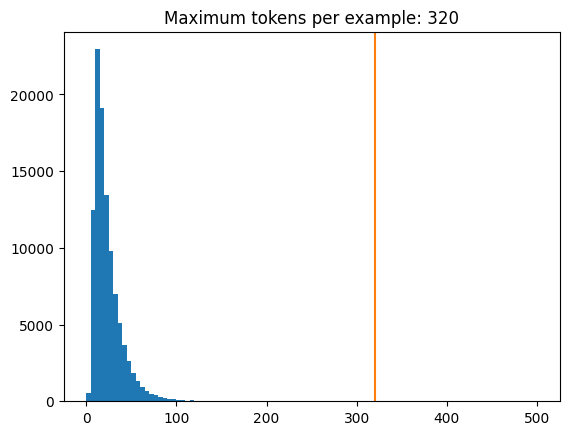

In [14]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training. 

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [15]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training. 

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset 

In [18]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.


<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

This is the same as the [text generation tutorial](text_generation.ipynb),
except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model.
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the `input, output`, pairs to simply be the `Portuguese, English` sequences.
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

In [19]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 86)
(64, 81)
(64, 81)


The `en` and `en_labels` are the same, just shifted by 1:

In [20]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2  476 2569 2626 6010   52 2564 1915  188   15], shape=(10,), dtype=int64)
tf.Tensor([ 476 2569 2626 6010   52 2564 1915  188   15    3], shape=(10,), dtype=int64)


## Define the components

There's a lot going on inside a Transformer. The important things to remember are:

1. It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder.
2. If you work through it step by step it will all make sense.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic. 

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a `tf.keras.layers.Embedding` layer.

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words) instance, `how are you`, `how you are`, `you how are`, and so on, are indistinguishable.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [21]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

(2048, 512)


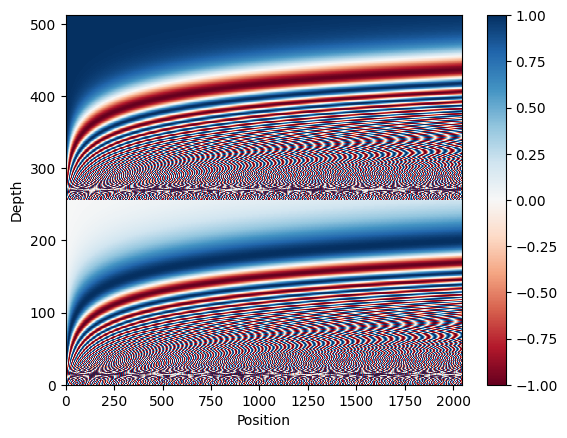

In [22]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

By definition these vectors align well with nearby vectors along the position axis. Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:

(0.0, 1.0)

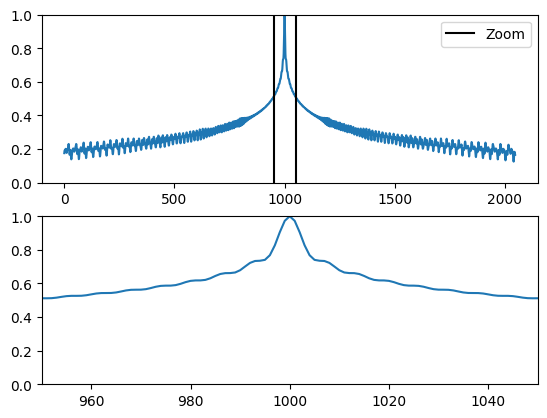

In [23]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [24]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4 and 5.1, uses a single tokenizer and weight matrix for both the source and target languages. This tutorial uses two separate tokenizers and weight matrices.

In [25]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [26]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 81), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer.

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each. 

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs.

Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not).



### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`. 

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [27]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### Attention refresher

Before you get into the specifics of each usage, here is a quick refresher on how attention works:

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

There are two inputs:

1. The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2. The context sequence; the sequence being attended to (left).

The output has the same shape as the query-sequence.

The common comparison is that this operation is like a dictionary lookup.
A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s what sort of information the dictionary has.
- The `value` is that information.

When you look up a `query` in a regular dictionary, the dictionary finds the matching `key`, and returns its associated `value`.
The `query` either has a matching `key` or it doesn't.
You can imagine a **fuzzy** dictionary where the keys don't have to match perfectly.
If you looked up `d["species"]` in the dictionary above, maybe you'd want it to return `"pickup"` since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key.
It combines the `values` based on how well the `query` matches each `key`.

How does that work? In an attention layer the `query`, `key`, and `value` are each vectors.
Instead of doing a hash lookup the attention layer combines the `query` and `key` vectors to determine how well they match, the "attention score".
The layer returns the average across all the `values`, weighted by the "attention scores".

Each location the query-sequence provides a `query` vector.
The context sequence acts as the dictionary. At each location in the context sequence provides a `key` and `value` vector.
The input vectors are not used directly, the `layers.MultiHeadAttention` layer includes `layers.Dense` layers to project the input vectors before using them.


### The cross attention layer

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [28]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

The caricature below shows how information flows through this layer. The columns represent the weighted sum over the context sequence.

For simplicity the residual connections are not shown.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

The output length is the length of the `query` sequence, and not the length of the context `key/value` sequence.

The diagram is further simplified, below. There's no need to draw the entire "Attention weights" matrix.
The point is that each `query` location can see all the `key/value` pairs in the context, but no information is exchanged between the queries.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

Test run it on sample inputs:

In [29]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 86, 512)
(64, 81, 512)


(64, 81, 512)


### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions. 

Before Transformers and self attention, models commonly used RNNs or CNNs to do this task:

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

RNNs and CNNs have their limitations.

- The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
- In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers,  You need to stack a number of Convolution layers to transmit information across the sequence ([Wavenet](https://arxiv.org/abs/1609.03499) reduces this problem by using dilated convolutions).

The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel. 

To implement this layer you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer: 

In [30]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [31]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 86, 512)
(64, 86, 512)


Sticking with the same style as before you could draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for clarity.

It's more compact, and just as accurate to draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### The causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

This needs to be handled differently from the encoder's global self attention layer.  

Like the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation), and the [NMT with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) tutorial, Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this _efficient_, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

A single-direction RNN is causal by definition. To make a causal convolution you just need to pad the input and shift the output so that it aligns correctly (use `layers.Conv1D(padding='causal')`) .

<table>
<tr>
  <th colspan=1>Causal RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways: 

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.
  - For an RNN you just need the RNN-state to account for previous computations (pass `return_state=True` to the RNN layer's constructor).
  - For a CNN you would need to follow the approach of [Fast Wavenet](https://arxiv.org/abs/1611.09482)

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [32]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

The causal mask ensures that each location only has access to the locations that come before it: 

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for simplicity.

The more compact representation of this layer would be:

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

Test out the layer:

In [33]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 81, 512)
(64, 81, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [34]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

Note: When using Keras masks, the output values at invalid locations are not well defined. So the above may not hold for masked regions. 

### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [35]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


Test the layer, the output is the same shape as the input:

In [36]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 81, 512)
(64, 81, 512)


### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the `EncoderLayer`:

In [37]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

And a quick test, the output will have the same shape as the input:

In [38]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 86, 512)


(64, 86, 512)


### The encoder

Next build the encoder.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

Test the encoder:

In [40]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 86)
(64, 86, 512)


### The decoder layer

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:  

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

Test the decoder layer:

In [42]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 81, 512)
(64, 86, 512)
(64, 81, 512)


### The decoder

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>


Define the decoder by extending `tf.keras.layers.Layer`:

In [43]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Test the decoder:

In [44]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 81)
(64, 86, 512)
(64, 81, 512)


In [45]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 81, 86])

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

## The Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities. 

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

<table>
<tr>
  <th colspan=1>A 1-layer transformer</th>
  <th colspan=1>A 4-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The RNN+Attention model</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

Create the `Transformer` by extending `tf.keras.Model`:

> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4, shares the weight matrix between the embedding layer and the final linear layer. To keep things simple, this tutorial uses two separate weight matrices.

In [46]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


In [47]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Try it out

Instantiate the `Transformer` model:

In [48]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Test it:

In [49]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 81)
(64, 86)
(64, 81, 7010)


In [50]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 81, 86)


Print the summary of the model:

In [51]:
transformer.summary()

Model: "transformer"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 encoder_1 (Encoder)         multiple                  3632768   


 decoder_1 (Decoder)         multiple                  5647104   


 dense_38 (Dense)            multiple                  904290    


Total params: 10,184,162


Trainable params: 10,184,162


Non-trainable params: 0


_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [53]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

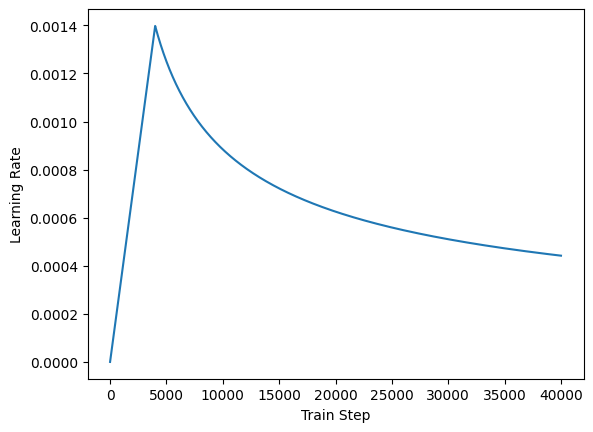

In [54]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [55]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

In [56]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [57]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20


  1/810 [..............................] - ETA: 6:54:34 - loss: 8.8828 - masked_accuracy: 0.0000e+00

  2/810 [..............................] - ETA: 6:49 - loss: 8.8826 - masked_accuracy: 0.0000e+00   

  3/810 [..............................] - ETA: 6:58 - loss: 8.8796 - masked_accuracy: 0.0000e+00

  4/810 [..............................] - ETA: 6:09 - loss: 8.8785 - masked_accuracy: 0.0000e+00

  5/810 [..............................] - ETA: 6:13 - loss: 8.8775 - masked_accuracy: 1.5279e-04

  6/810 [..............................] - ETA: 6:18 - loss: 8.8776 - masked_accuracy: 1.2732e-04

  7/810 [..............................] - ETA: 6:22 - loss: 8.8778 - masked_accuracy: 1.0913e-04

  8/810 [..............................] - ETA: 6:21 - loss: 8.8784 - masked_accuracy: 9.5493e-05

  9/810 [..............................] - ETA: 6:06 - loss: 8.8775 - masked_accuracy: 8.4882e-05

 10/810 [..............................] - ETA: 6:05 - loss: 8.8771 - masked_accuracy: 7.6394e-05

 11/810 [..............................] - ETA: 6:11 - loss: 8.8762 - masked_accuracy: 1.3155e-04

 12/810 [..............................] - ETA: 6:14 - loss: 8.8756 - masked_accuracy: 1.2058e-04

 13/810 [..............................] - ETA: 6:16 - loss: 8.8745 - masked_accuracy: 1.1131e-04

 14/810 [..............................] - ETA: 6:18 - loss: 8.8742 - masked_accuracy: 1.0336e-04

 15/810 [..............................] - ETA: 6:17 - loss: 8.8728 - masked_accuracy: 9.6467e-05

 16/810 [..............................] - ETA: 6:17 - loss: 8.8718 - masked_accuracy: 1.3015e-04

 17/810 [..............................] - ETA: 6:20 - loss: 8.8711 - masked_accuracy: 1.2249e-04

 18/810 [..............................] - ETA: 6:20 - loss: 8.8695 - masked_accuracy: 1.1568e-04

 19/810 [..............................] - ETA: 6:20 - loss: 8.8684 - masked_accuracy: 1.0960e-04

 20/810 [..............................] - ETA: 6:19 - loss: 8.8676 - masked_accuracy: 1.0412e-04

 21/810 [..............................] - ETA: 6:19 - loss: 8.8663 - masked_accuracy: 9.9158e-05

 22/810 [..............................] - ETA: 6:12 - loss: 8.8646 - masked_accuracy: 9.4651e-05

 23/810 [..............................] - ETA: 6:12 - loss: 8.8633 - masked_accuracy: 9.0536e-05

 24/810 [..............................] - ETA: 6:12 - loss: 8.8619 - masked_accuracy: 8.6764e-05

 25/810 [..............................] - ETA: 6:11 - loss: 8.8605 - masked_accuracy: 8.3293e-05

 26/810 [..............................] - ETA: 6:10 - loss: 8.8587 - masked_accuracy: 8.0089e-05

 27/810 [>.............................] - ETA: 6:07 - loss: 8.8571 - masked_accuracy: 1.0172e-04

 28/810 [>.............................] - ETA: 6:07 - loss: 8.8555 - masked_accuracy: 1.2163e-04

 29/810 [>.............................] - ETA: 6:06 - loss: 8.8538 - masked_accuracy: 1.3806e-04

 30/810 [>.............................] - ETA: 6:06 - loss: 8.8514 - masked_accuracy: 1.3345e-04

 31/810 [>.............................] - ETA: 6:06 - loss: 8.8494 - masked_accuracy: 2.1771e-04

 32/810 [>.............................] - ETA: 6:06 - loss: 8.8474 - masked_accuracy: 2.1091e-04

 33/810 [>.............................] - ETA: 6:01 - loss: 8.8451 - masked_accuracy: 2.5161e-04

 34/810 [>.............................] - ETA: 5:57 - loss: 8.8428 - masked_accuracy: 3.2977e-04

 35/810 [>.............................] - ETA: 5:57 - loss: 8.8407 - masked_accuracy: 3.5640e-04

 36/810 [>.............................] - ETA: 5:54 - loss: 8.8388 - masked_accuracy: 4.4275e-04

 37/810 [>.............................] - ETA: 5:53 - loss: 8.8362 - masked_accuracy: 7.8350e-04

 38/810 [>.............................] - ETA: 5:54 - loss: 8.8338 - masked_accuracy: 9.7374e-04

 39/810 [>.............................] - ETA: 5:49 - loss: 8.8317 - masked_accuracy: 0.0012    

 40/810 [>.............................] - ETA: 5:44 - loss: 8.8295 - masked_accuracy: 0.0015

 41/810 [>.............................] - ETA: 5:46 - loss: 8.8274 - masked_accuracy: 0.0017

 42/810 [>.............................] - ETA: 5:43 - loss: 8.8252 - masked_accuracy: 0.0019

 43/810 [>.............................] - ETA: 5:43 - loss: 8.8230 - masked_accuracy: 0.0023

 44/810 [>.............................] - ETA: 5:43 - loss: 8.8207 - masked_accuracy: 0.0028

 45/810 [>.............................] - ETA: 5:43 - loss: 8.8185 - masked_accuracy: 0.0032

 46/810 [>.............................] - ETA: 5:39 - loss: 8.8162 - masked_accuracy: 0.0037

 47/810 [>.............................] - ETA: 5:36 - loss: 8.8138 - masked_accuracy: 0.0043

 48/810 [>.............................] - ETA: 5:33 - loss: 8.8111 - masked_accuracy: 0.0047

 49/810 [>.............................] - ETA: 5:31 - loss: 8.8085 - masked_accuracy: 0.0054

 50/810 [>.............................] - ETA: 5:32 - loss: 8.8062 - masked_accuracy: 0.0060

 51/810 [>.............................] - ETA: 5:32 - loss: 8.8036 - masked_accuracy: 0.0067

 52/810 [>.............................] - ETA: 5:33 - loss: 8.8010 - masked_accuracy: 0.0076

 53/810 [>.............................] - ETA: 5:31 - loss: 8.7987 - masked_accuracy: 0.0082

 54/810 [=>............................] - ETA: 5:31 - loss: 8.7963 - masked_accuracy: 0.0091

 55/810 [=>............................] - ETA: 5:31 - loss: 8.7938 - masked_accuracy: 0.0099

 56/810 [=>............................] - ETA: 5:31 - loss: 8.7913 - masked_accuracy: 0.0107

 57/810 [=>............................] - ETA: 5:31 - loss: 8.7890 - masked_accuracy: 0.0115

 58/810 [=>............................] - ETA: 5:31 - loss: 8.7864 - masked_accuracy: 0.0123

 59/810 [=>............................] - ETA: 5:31 - loss: 8.7838 - masked_accuracy: 0.0130

 60/810 [=>............................] - ETA: 5:31 - loss: 8.7811 - masked_accuracy: 0.0137

 61/810 [=>............................] - ETA: 5:31 - loss: 8.7787 - masked_accuracy: 0.0144

 62/810 [=>............................] - ETA: 5:28 - loss: 8.7762 - masked_accuracy: 0.0149

 63/810 [=>............................] - ETA: 5:26 - loss: 8.7737 - masked_accuracy: 0.0157

 64/810 [=>............................] - ETA: 5:23 - loss: 8.7715 - masked_accuracy: 0.0162

 65/810 [=>............................] - ETA: 5:21 - loss: 8.7690 - masked_accuracy: 0.0168

 66/810 [=>............................] - ETA: 5:21 - loss: 8.7666 - masked_accuracy: 0.0175

 67/810 [=>............................] - ETA: 5:19 - loss: 8.7644 - masked_accuracy: 0.0180

 68/810 [=>............................] - ETA: 5:17 - loss: 8.7619 - masked_accuracy: 0.0187

 69/810 [=>............................] - ETA: 5:13 - loss: 8.7596 - masked_accuracy: 0.0192

 70/810 [=>............................] - ETA: 5:11 - loss: 8.7571 - masked_accuracy: 0.0199

 71/810 [=>............................] - ETA: 5:11 - loss: 8.7546 - masked_accuracy: 0.0205

 72/810 [=>............................] - ETA: 5:10 - loss: 8.7522 - masked_accuracy: 0.0211

 73/810 [=>............................] - ETA: 5:06 - loss: 8.7500 - masked_accuracy: 0.0218

 74/810 [=>............................] - ETA: 5:05 - loss: 8.7477 - masked_accuracy: 0.0224

 75/810 [=>............................] - ETA: 5:05 - loss: 8.7454 - masked_accuracy: 0.0228

 76/810 [=>............................] - ETA: 5:03 - loss: 8.7431 - masked_accuracy: 0.0234

 77/810 [=>............................] - ETA: 5:02 - loss: 8.7408 - masked_accuracy: 0.0239

 78/810 [=>............................] - ETA: 5:02 - loss: 8.7385 - masked_accuracy: 0.0244

 79/810 [=>............................] - ETA: 5:01 - loss: 8.7361 - masked_accuracy: 0.0248

 80/810 [=>............................] - ETA: 5:01 - loss: 8.7337 - masked_accuracy: 0.0252

 81/810 [==>...........................] - ETA: 5:00 - loss: 8.7313 - masked_accuracy: 0.0258

 82/810 [==>...........................] - ETA: 4:58 - loss: 8.7291 - masked_accuracy: 0.0262

 83/810 [==>...........................] - ETA: 4:58 - loss: 8.7269 - masked_accuracy: 0.0266

 84/810 [==>...........................] - ETA: 4:57 - loss: 8.7246 - masked_accuracy: 0.0270

 85/810 [==>...........................] - ETA: 4:55 - loss: 8.7225 - masked_accuracy: 0.0276

 86/810 [==>...........................] - ETA: 4:53 - loss: 8.7202 - masked_accuracy: 0.0278

 87/810 [==>...........................] - ETA: 4:51 - loss: 8.7178 - masked_accuracy: 0.0283

 88/810 [==>...........................] - ETA: 4:52 - loss: 8.7156 - masked_accuracy: 0.0286

 89/810 [==>...........................] - ETA: 4:52 - loss: 8.7135 - masked_accuracy: 0.0289

 90/810 [==>...........................] - ETA: 4:50 - loss: 8.7112 - masked_accuracy: 0.0294

 91/810 [==>...........................] - ETA: 4:49 - loss: 8.7089 - masked_accuracy: 0.0299

 92/810 [==>...........................] - ETA: 4:48 - loss: 8.7066 - masked_accuracy: 0.0303

 93/810 [==>...........................] - ETA: 4:45 - loss: 8.7045 - masked_accuracy: 0.0306

 94/810 [==>...........................] - ETA: 4:45 - loss: 8.7021 - masked_accuracy: 0.0310

 95/810 [==>...........................] - ETA: 4:45 - loss: 8.6998 - masked_accuracy: 0.0314

 96/810 [==>...........................] - ETA: 4:45 - loss: 8.6974 - masked_accuracy: 0.0317

 97/810 [==>...........................] - ETA: 4:45 - loss: 8.6953 - masked_accuracy: 0.0321

 98/810 [==>...........................] - ETA: 4:43 - loss: 8.6930 - masked_accuracy: 0.0323

 99/810 [==>...........................] - ETA: 4:42 - loss: 8.6907 - masked_accuracy: 0.0326

100/810 [==>...........................] - ETA: 4:40 - loss: 8.6884 - masked_accuracy: 0.0329

101/810 [==>...........................] - ETA: 4:40 - loss: 8.6864 - masked_accuracy: 0.0331

102/810 [==>...........................] - ETA: 4:40 - loss: 8.6841 - masked_accuracy: 0.0334

103/810 [==>...........................] - ETA: 4:39 - loss: 8.6819 - masked_accuracy: 0.0336

104/810 [==>...........................] - ETA: 4:38 - loss: 8.6798 - masked_accuracy: 0.0338

105/810 [==>...........................] - ETA: 4:38 - loss: 8.6777 - masked_accuracy: 0.0340

106/810 [==>...........................] - ETA: 4:37 - loss: 8.6754 - masked_accuracy: 0.0342

107/810 [==>...........................] - ETA: 4:37 - loss: 8.6731 - masked_accuracy: 0.0344

108/810 [===>..........................] - ETA: 4:37 - loss: 8.6709 - masked_accuracy: 0.0345

109/810 [===>..........................] - ETA: 4:36 - loss: 8.6684 - masked_accuracy: 0.0347

110/810 [===>..........................] - ETA: 4:35 - loss: 8.6661 - masked_accuracy: 0.0349

111/810 [===>..........................] - ETA: 4:33 - loss: 8.6638 - masked_accuracy: 0.0350

112/810 [===>..........................] - ETA: 4:33 - loss: 8.6614 - masked_accuracy: 0.0351

113/810 [===>..........................] - ETA: 4:31 - loss: 8.6591 - masked_accuracy: 0.0353

114/810 [===>..........................] - ETA: 4:29 - loss: 8.6568 - masked_accuracy: 0.0354

115/810 [===>..........................] - ETA: 4:28 - loss: 8.6546 - masked_accuracy: 0.0355

116/810 [===>..........................] - ETA: 4:26 - loss: 8.6522 - masked_accuracy: 0.0357

117/810 [===>..........................] - ETA: 4:26 - loss: 8.6496 - masked_accuracy: 0.0359

118/810 [===>..........................] - ETA: 4:26 - loss: 8.6473 - masked_accuracy: 0.0361

119/810 [===>..........................] - ETA: 4:24 - loss: 8.6449 - masked_accuracy: 0.0362

120/810 [===>..........................] - ETA: 4:23 - loss: 8.6427 - masked_accuracy: 0.0364

121/810 [===>..........................] - ETA: 4:24 - loss: 8.6404 - masked_accuracy: 0.0364

122/810 [===>..........................] - ETA: 4:23 - loss: 8.6379 - masked_accuracy: 0.0366

123/810 [===>..........................] - ETA: 4:22 - loss: 8.6355 - masked_accuracy: 0.0368

124/810 [===>..........................] - ETA: 4:21 - loss: 8.6331 - masked_accuracy: 0.0369

125/810 [===>..........................] - ETA: 4:21 - loss: 8.6306 - masked_accuracy: 0.0372

126/810 [===>..........................] - ETA: 4:20 - loss: 8.6282 - masked_accuracy: 0.0374

127/810 [===>..........................] - ETA: 4:18 - loss: 8.6260 - masked_accuracy: 0.0375

128/810 [===>..........................] - ETA: 4:17 - loss: 8.6237 - masked_accuracy: 0.0376

129/810 [===>..........................] - ETA: 4:16 - loss: 8.6215 - masked_accuracy: 0.0378

130/810 [===>..........................] - ETA: 4:16 - loss: 8.6190 - masked_accuracy: 0.0379

131/810 [===>..........................] - ETA: 4:15 - loss: 8.6166 - masked_accuracy: 0.0382

132/810 [===>..........................] - ETA: 4:14 - loss: 8.6141 - masked_accuracy: 0.0384

133/810 [===>..........................] - ETA: 4:13 - loss: 8.6115 - masked_accuracy: 0.0386

134/810 [===>..........................] - ETA: 4:12 - loss: 8.6090 - masked_accuracy: 0.0388

135/810 [====>.........................] - ETA: 4:11 - loss: 8.6064 - masked_accuracy: 0.0390

136/810 [====>.........................] - ETA: 4:10 - loss: 8.6039 - masked_accuracy: 0.0392

137/810 [====>.........................] - ETA: 4:10 - loss: 8.6016 - masked_accuracy: 0.0393

138/810 [====>.........................] - ETA: 4:08 - loss: 8.5991 - masked_accuracy: 0.0395

139/810 [====>.........................] - ETA: 4:07 - loss: 8.5967 - masked_accuracy: 0.0396

140/810 [====>.........................] - ETA: 4:05 - loss: 8.5942 - masked_accuracy: 0.0398

141/810 [====>.........................] - ETA: 4:04 - loss: 8.5917 - masked_accuracy: 0.0401

142/810 [====>.........................] - ETA: 4:03 - loss: 8.5891 - masked_accuracy: 0.0403

143/810 [====>.........................] - ETA: 4:02 - loss: 8.5866 - masked_accuracy: 0.0405

144/810 [====>.........................] - ETA: 4:03 - loss: 8.5842 - masked_accuracy: 0.0406

145/810 [====>.........................] - ETA: 4:03 - loss: 8.5816 - masked_accuracy: 0.0409

146/810 [====>.........................] - ETA: 4:02 - loss: 8.5791 - masked_accuracy: 0.0410

147/810 [====>.........................] - ETA: 4:01 - loss: 8.5765 - masked_accuracy: 0.0412

148/810 [====>.........................] - ETA: 4:01 - loss: 8.5740 - masked_accuracy: 0.0414

149/810 [====>.........................] - ETA: 4:00 - loss: 8.5712 - masked_accuracy: 0.0416

150/810 [====>.........................] - ETA: 3:59 - loss: 8.5685 - masked_accuracy: 0.0419

151/810 [====>.........................] - ETA: 3:58 - loss: 8.5659 - masked_accuracy: 0.0420

152/810 [====>.........................] - ETA: 3:56 - loss: 8.5633 - masked_accuracy: 0.0422

153/810 [====>.........................] - ETA: 3:57 - loss: 8.5607 - masked_accuracy: 0.0423

154/810 [====>.........................] - ETA: 3:55 - loss: 8.5581 - masked_accuracy: 0.0426

155/810 [====>.........................] - ETA: 3:55 - loss: 8.5555 - masked_accuracy: 0.0428

156/810 [====>.........................] - ETA: 3:53 - loss: 8.5529 - masked_accuracy: 0.0430

157/810 [====>.........................] - ETA: 3:53 - loss: 8.5501 - masked_accuracy: 0.0433

158/810 [====>.........................] - ETA: 3:53 - loss: 8.5473 - masked_accuracy: 0.0435

159/810 [====>.........................] - ETA: 3:52 - loss: 8.5446 - masked_accuracy: 0.0437

160/810 [====>.........................] - ETA: 3:51 - loss: 8.5418 - masked_accuracy: 0.0439

161/810 [====>.........................] - ETA: 3:51 - loss: 8.5390 - masked_accuracy: 0.0441

162/810 [=====>........................] - ETA: 3:50 - loss: 8.5360 - masked_accuracy: 0.0444

163/810 [=====>........................] - ETA: 3:49 - loss: 8.5331 - masked_accuracy: 0.0447

164/810 [=====>........................] - ETA: 3:49 - loss: 8.5304 - masked_accuracy: 0.0450

165/810 [=====>........................] - ETA: 3:48 - loss: 8.5276 - masked_accuracy: 0.0451

166/810 [=====>........................] - ETA: 3:48 - loss: 8.5246 - masked_accuracy: 0.0454

167/810 [=====>........................] - ETA: 3:46 - loss: 8.5217 - masked_accuracy: 0.0457

168/810 [=====>........................] - ETA: 3:46 - loss: 8.5187 - masked_accuracy: 0.0459

169/810 [=====>........................] - ETA: 3:45 - loss: 8.5159 - masked_accuracy: 0.0461

170/810 [=====>........................] - ETA: 3:44 - loss: 8.5129 - masked_accuracy: 0.0463

171/810 [=====>........................] - ETA: 3:43 - loss: 8.5099 - masked_accuracy: 0.0466

172/810 [=====>........................] - ETA: 3:42 - loss: 8.5072 - masked_accuracy: 0.0469

173/810 [=====>........................] - ETA: 3:41 - loss: 8.5042 - masked_accuracy: 0.0472

174/810 [=====>........................] - ETA: 3:40 - loss: 8.5012 - masked_accuracy: 0.0474

175/810 [=====>........................] - ETA: 3:39 - loss: 8.4982 - masked_accuracy: 0.0477

176/810 [=====>........................] - ETA: 3:39 - loss: 8.4953 - masked_accuracy: 0.0478

177/810 [=====>........................] - ETA: 3:39 - loss: 8.4923 - masked_accuracy: 0.0480

178/810 [=====>........................] - ETA: 3:38 - loss: 8.4894 - masked_accuracy: 0.0482

179/810 [=====>........................] - ETA: 3:37 - loss: 8.4863 - masked_accuracy: 0.0484

180/810 [=====>........................] - ETA: 3:36 - loss: 8.4833 - masked_accuracy: 0.0487

181/810 [=====>........................] - ETA: 3:35 - loss: 8.4803 - masked_accuracy: 0.0488

182/810 [=====>........................] - ETA: 3:34 - loss: 8.4773 - masked_accuracy: 0.0490

183/810 [=====>........................] - ETA: 3:34 - loss: 8.4741 - masked_accuracy: 0.0492

184/810 [=====>........................] - ETA: 3:33 - loss: 8.4711 - masked_accuracy: 0.0493

185/810 [=====>........................] - ETA: 3:32 - loss: 8.4679 - masked_accuracy: 0.0495

186/810 [=====>........................] - ETA: 3:31 - loss: 8.4649 - masked_accuracy: 0.0497

187/810 [=====>........................] - ETA: 3:30 - loss: 8.4617 - masked_accuracy: 0.0499

188/810 [=====>........................] - ETA: 3:29 - loss: 8.4584 - masked_accuracy: 0.0501

189/810 [======>.......................] - ETA: 3:30 - loss: 8.4554 - masked_accuracy: 0.0503

190/810 [======>.......................] - ETA: 3:29 - loss: 8.4524 - masked_accuracy: 0.0504

191/810 [======>.......................] - ETA: 3:29 - loss: 8.4492 - masked_accuracy: 0.0506

192/810 [======>.......................] - ETA: 3:28 - loss: 8.4462 - masked_accuracy: 0.0508

193/810 [======>.......................] - ETA: 3:27 - loss: 8.4430 - masked_accuracy: 0.0510

194/810 [======>.......................] - ETA: 3:26 - loss: 8.4398 - masked_accuracy: 0.0511

195/810 [======>.......................] - ETA: 3:25 - loss: 8.4366 - masked_accuracy: 0.0513

196/810 [======>.......................] - ETA: 3:25 - loss: 8.4334 - masked_accuracy: 0.0515

197/810 [======>.......................] - ETA: 3:24 - loss: 8.4300 - masked_accuracy: 0.0518

198/810 [======>.......................] - ETA: 3:23 - loss: 8.4269 - masked_accuracy: 0.0519

199/810 [======>.......................] - ETA: 3:22 - loss: 8.4235 - masked_accuracy: 0.0521

200/810 [======>.......................] - ETA: 3:22 - loss: 8.4203 - masked_accuracy: 0.0523

201/810 [======>.......................] - ETA: 3:21 - loss: 8.4168 - masked_accuracy: 0.0525

202/810 [======>.......................] - ETA: 3:22 - loss: 8.4135 - masked_accuracy: 0.0526

203/810 [======>.......................] - ETA: 3:21 - loss: 8.4104 - masked_accuracy: 0.0528

204/810 [======>.......................] - ETA: 3:21 - loss: 8.4071 - masked_accuracy: 0.0529

205/810 [======>.......................] - ETA: 3:20 - loss: 8.4036 - masked_accuracy: 0.0531

206/810 [======>.......................] - ETA: 3:20 - loss: 8.4001 - masked_accuracy: 0.0533

207/810 [======>.......................] - ETA: 3:19 - loss: 8.3968 - masked_accuracy: 0.0535

208/810 [======>.......................] - ETA: 3:19 - loss: 8.3934 - masked_accuracy: 0.0535

209/810 [======>.......................] - ETA: 3:18 - loss: 8.3899 - masked_accuracy: 0.0537

210/810 [======>.......................] - ETA: 3:17 - loss: 8.3866 - masked_accuracy: 0.0538

211/810 [======>.......................] - ETA: 3:16 - loss: 8.3831 - masked_accuracy: 0.0540

212/810 [======>.......................] - ETA: 3:16 - loss: 8.3797 - masked_accuracy: 0.0542

213/810 [======>.......................] - ETA: 3:15 - loss: 8.3762 - masked_accuracy: 0.0544

214/810 [======>.......................] - ETA: 3:15 - loss: 8.3728 - masked_accuracy: 0.0545

215/810 [======>.......................] - ETA: 3:15 - loss: 8.3694 - masked_accuracy: 0.0547

216/810 [=======>......................] - ETA: 3:14 - loss: 8.3658 - masked_accuracy: 0.0548

217/810 [=======>......................] - ETA: 3:13 - loss: 8.3623 - masked_accuracy: 0.0550

218/810 [=======>......................] - ETA: 3:13 - loss: 8.3589 - masked_accuracy: 0.0551

219/810 [=======>......................] - ETA: 3:12 - loss: 8.3551 - masked_accuracy: 0.0553

220/810 [=======>......................] - ETA: 3:12 - loss: 8.3517 - masked_accuracy: 0.0554

221/810 [=======>......................] - ETA: 3:12 - loss: 8.3482 - masked_accuracy: 0.0555

222/810 [=======>......................] - ETA: 3:11 - loss: 8.3447 - masked_accuracy: 0.0557

223/810 [=======>......................] - ETA: 3:10 - loss: 8.3411 - masked_accuracy: 0.0559

224/810 [=======>......................] - ETA: 3:10 - loss: 8.3379 - masked_accuracy: 0.0560

225/810 [=======>......................] - ETA: 3:10 - loss: 8.3343 - masked_accuracy: 0.0560

226/810 [=======>......................] - ETA: 3:09 - loss: 8.3308 - masked_accuracy: 0.0562

227/810 [=======>......................] - ETA: 3:08 - loss: 8.3272 - masked_accuracy: 0.0563

228/810 [=======>......................] - ETA: 3:08 - loss: 8.3237 - masked_accuracy: 0.0565

229/810 [=======>......................] - ETA: 3:08 - loss: 8.3200 - masked_accuracy: 0.0566

230/810 [=======>......................] - ETA: 3:08 - loss: 8.3165 - masked_accuracy: 0.0568

231/810 [=======>......................] - ETA: 3:07 - loss: 8.3131 - masked_accuracy: 0.0569

232/810 [=======>......................] - ETA: 3:07 - loss: 8.3095 - masked_accuracy: 0.0570

233/810 [=======>......................] - ETA: 3:07 - loss: 8.3057 - masked_accuracy: 0.0571

234/810 [=======>......................] - ETA: 3:06 - loss: 8.3022 - masked_accuracy: 0.0572

235/810 [=======>......................] - ETA: 3:05 - loss: 8.2985 - masked_accuracy: 0.0574

236/810 [=======>......................] - ETA: 3:05 - loss: 8.2947 - masked_accuracy: 0.0575

237/810 [=======>......................] - ETA: 3:05 - loss: 8.2910 - masked_accuracy: 0.0576

238/810 [=======>......................] - ETA: 3:04 - loss: 8.2872 - masked_accuracy: 0.0577

239/810 [=======>......................] - ETA: 3:04 - loss: 8.2837 - masked_accuracy: 0.0578

240/810 [=======>......................] - ETA: 3:03 - loss: 8.2800 - masked_accuracy: 0.0579

241/810 [=======>......................] - ETA: 3:03 - loss: 8.2764 - masked_accuracy: 0.0581

242/810 [=======>......................] - ETA: 3:02 - loss: 8.2728 - masked_accuracy: 0.0582

243/810 [========>.....................] - ETA: 3:01 - loss: 8.2691 - masked_accuracy: 0.0583

244/810 [========>.....................] - ETA: 3:01 - loss: 8.2653 - masked_accuracy: 0.0584

245/810 [========>.....................] - ETA: 3:00 - loss: 8.2615 - masked_accuracy: 0.0586

246/810 [========>.....................] - ETA: 2:59 - loss: 8.2577 - masked_accuracy: 0.0587

247/810 [========>.....................] - ETA: 2:59 - loss: 8.2540 - masked_accuracy: 0.0588

248/810 [========>.....................] - ETA: 2:58 - loss: 8.2502 - masked_accuracy: 0.0589

249/810 [========>.....................] - ETA: 2:58 - loss: 8.2464 - masked_accuracy: 0.0590

250/810 [========>.....................] - ETA: 2:57 - loss: 8.2427 - masked_accuracy: 0.0591

251/810 [========>.....................] - ETA: 2:57 - loss: 8.2392 - masked_accuracy: 0.0592

252/810 [========>.....................] - ETA: 2:56 - loss: 8.2354 - masked_accuracy: 0.0594

253/810 [========>.....................] - ETA: 2:55 - loss: 8.2317 - masked_accuracy: 0.0595

254/810 [========>.....................] - ETA: 2:55 - loss: 8.2281 - masked_accuracy: 0.0596

255/810 [========>.....................] - ETA: 2:54 - loss: 8.2243 - masked_accuracy: 0.0597

256/810 [========>.....................] - ETA: 2:54 - loss: 8.2204 - masked_accuracy: 0.0598

257/810 [========>.....................] - ETA: 2:53 - loss: 8.2166 - masked_accuracy: 0.0599

258/810 [========>.....................] - ETA: 2:52 - loss: 8.2128 - masked_accuracy: 0.0601

259/810 [========>.....................] - ETA: 2:52 - loss: 8.2093 - masked_accuracy: 0.0602

260/810 [========>.....................] - ETA: 2:51 - loss: 8.2055 - masked_accuracy: 0.0603

261/810 [========>.....................] - ETA: 2:51 - loss: 8.2018 - masked_accuracy: 0.0604

262/810 [========>.....................] - ETA: 2:50 - loss: 8.1981 - masked_accuracy: 0.0604

263/810 [========>.....................] - ETA: 2:50 - loss: 8.1945 - masked_accuracy: 0.0605

264/810 [========>.....................] - ETA: 2:49 - loss: 8.1905 - masked_accuracy: 0.0606

265/810 [========>.....................] - ETA: 2:49 - loss: 8.1866 - masked_accuracy: 0.0607

266/810 [========>.....................] - ETA: 2:48 - loss: 8.1826 - masked_accuracy: 0.0609

267/810 [========>.....................] - ETA: 2:48 - loss: 8.1787 - masked_accuracy: 0.0610

268/810 [========>.....................] - ETA: 2:47 - loss: 8.1749 - masked_accuracy: 0.0611

269/810 [========>.....................] - ETA: 2:47 - loss: 8.1709 - masked_accuracy: 0.0612

270/810 [=========>....................] - ETA: 2:47 - loss: 8.1671 - masked_accuracy: 0.0613

271/810 [=========>....................] - ETA: 2:46 - loss: 8.1632 - masked_accuracy: 0.0614

272/810 [=========>....................] - ETA: 2:46 - loss: 8.1595 - masked_accuracy: 0.0615

273/810 [=========>....................] - ETA: 2:45 - loss: 8.1554 - masked_accuracy: 0.0617

274/810 [=========>....................] - ETA: 2:44 - loss: 8.1515 - masked_accuracy: 0.0618

275/810 [=========>....................] - ETA: 2:44 - loss: 8.1476 - masked_accuracy: 0.0619

276/810 [=========>....................] - ETA: 2:44 - loss: 8.1437 - masked_accuracy: 0.0620

277/810 [=========>....................] - ETA: 2:43 - loss: 8.1396 - masked_accuracy: 0.0621

278/810 [=========>....................] - ETA: 2:43 - loss: 8.1357 - masked_accuracy: 0.0622

279/810 [=========>....................] - ETA: 2:42 - loss: 8.1320 - masked_accuracy: 0.0623

280/810 [=========>....................] - ETA: 2:42 - loss: 8.1281 - masked_accuracy: 0.0623

281/810 [=========>....................] - ETA: 2:41 - loss: 8.1242 - masked_accuracy: 0.0625

282/810 [=========>....................] - ETA: 2:41 - loss: 8.1204 - masked_accuracy: 0.0626

283/810 [=========>....................] - ETA: 2:40 - loss: 8.1167 - masked_accuracy: 0.0627

284/810 [=========>....................] - ETA: 2:40 - loss: 8.1127 - masked_accuracy: 0.0627

285/810 [=========>....................] - ETA: 2:39 - loss: 8.1089 - masked_accuracy: 0.0629

286/810 [=========>....................] - ETA: 2:39 - loss: 8.1051 - masked_accuracy: 0.0630

287/810 [=========>....................] - ETA: 2:38 - loss: 8.1011 - masked_accuracy: 0.0631

288/810 [=========>....................] - ETA: 2:38 - loss: 8.0971 - masked_accuracy: 0.0631

289/810 [=========>....................] - ETA: 2:37 - loss: 8.0930 - masked_accuracy: 0.0633

290/810 [=========>....................] - ETA: 2:37 - loss: 8.0889 - masked_accuracy: 0.0634

291/810 [=========>....................] - ETA: 2:36 - loss: 8.0849 - masked_accuracy: 0.0635

292/810 [=========>....................] - ETA: 2:36 - loss: 8.0811 - masked_accuracy: 0.0635

293/810 [=========>....................] - ETA: 2:35 - loss: 8.0771 - masked_accuracy: 0.0636

294/810 [=========>....................] - ETA: 2:35 - loss: 8.0730 - masked_accuracy: 0.0637

295/810 [=========>....................] - ETA: 2:35 - loss: 8.0690 - masked_accuracy: 0.0639

296/810 [=========>....................] - ETA: 2:34 - loss: 8.0651 - masked_accuracy: 0.0640

297/810 [==========>...................] - ETA: 2:34 - loss: 8.0612 - masked_accuracy: 0.0641

298/810 [==========>...................] - ETA: 2:33 - loss: 8.0571 - masked_accuracy: 0.0641

299/810 [==========>...................] - ETA: 2:33 - loss: 8.0531 - masked_accuracy: 0.0642

300/810 [==========>...................] - ETA: 2:32 - loss: 8.0493 - masked_accuracy: 0.0643

301/810 [==========>...................] - ETA: 2:32 - loss: 8.0456 - masked_accuracy: 0.0644

302/810 [==========>...................] - ETA: 2:31 - loss: 8.0414 - masked_accuracy: 0.0645

303/810 [==========>...................] - ETA: 2:31 - loss: 8.0374 - masked_accuracy: 0.0646

304/810 [==========>...................] - ETA: 2:30 - loss: 8.0331 - masked_accuracy: 0.0647

305/810 [==========>...................] - ETA: 2:30 - loss: 8.0291 - masked_accuracy: 0.0648

306/810 [==========>...................] - ETA: 2:29 - loss: 8.0253 - masked_accuracy: 0.0649

307/810 [==========>...................] - ETA: 2:29 - loss: 8.0212 - masked_accuracy: 0.0650

308/810 [==========>...................] - ETA: 2:29 - loss: 8.0174 - masked_accuracy: 0.0651

309/810 [==========>...................] - ETA: 2:28 - loss: 8.0134 - masked_accuracy: 0.0651

310/810 [==========>...................] - ETA: 2:28 - loss: 8.0093 - masked_accuracy: 0.0652

311/810 [==========>...................] - ETA: 2:27 - loss: 8.0054 - masked_accuracy: 0.0653

312/810 [==========>...................] - ETA: 2:27 - loss: 8.0012 - masked_accuracy: 0.0654

313/810 [==========>...................] - ETA: 2:27 - loss: 7.9971 - masked_accuracy: 0.0655

314/810 [==========>...................] - ETA: 2:26 - loss: 7.9932 - masked_accuracy: 0.0656

315/810 [==========>...................] - ETA: 2:26 - loss: 7.9893 - masked_accuracy: 0.0657

316/810 [==========>...................] - ETA: 2:25 - loss: 7.9852 - masked_accuracy: 0.0658

317/810 [==========>...................] - ETA: 2:24 - loss: 7.9813 - masked_accuracy: 0.0659

318/810 [==========>...................] - ETA: 2:24 - loss: 7.9772 - masked_accuracy: 0.0660

319/810 [==========>...................] - ETA: 2:24 - loss: 7.9732 - masked_accuracy: 0.0661

320/810 [==========>...................] - ETA: 2:23 - loss: 7.9691 - masked_accuracy: 0.0662

321/810 [==========>...................] - ETA: 2:23 - loss: 7.9654 - masked_accuracy: 0.0663

322/810 [==========>...................] - ETA: 2:22 - loss: 7.9617 - masked_accuracy: 0.0663

323/810 [==========>...................] - ETA: 2:22 - loss: 7.9578 - masked_accuracy: 0.0664

324/810 [===========>..................] - ETA: 2:21 - loss: 7.9536 - masked_accuracy: 0.0665

325/810 [===========>..................] - ETA: 2:21 - loss: 7.9496 - masked_accuracy: 0.0666

326/810 [===========>..................] - ETA: 2:20 - loss: 7.9458 - masked_accuracy: 0.0667

327/810 [===========>..................] - ETA: 2:20 - loss: 7.9415 - masked_accuracy: 0.0669

328/810 [===========>..................] - ETA: 2:20 - loss: 7.9374 - masked_accuracy: 0.0670

329/810 [===========>..................] - ETA: 2:20 - loss: 7.9337 - masked_accuracy: 0.0670

330/810 [===========>..................] - ETA: 2:19 - loss: 7.9299 - masked_accuracy: 0.0672

331/810 [===========>..................] - ETA: 2:19 - loss: 7.9259 - masked_accuracy: 0.0673

332/810 [===========>..................] - ETA: 2:18 - loss: 7.9219 - masked_accuracy: 0.0674

333/810 [===========>..................] - ETA: 2:18 - loss: 7.9181 - masked_accuracy: 0.0675

334/810 [===========>..................] - ETA: 2:17 - loss: 7.9142 - masked_accuracy: 0.0675

335/810 [===========>..................] - ETA: 2:17 - loss: 7.9103 - masked_accuracy: 0.0676

336/810 [===========>..................] - ETA: 2:16 - loss: 7.9065 - masked_accuracy: 0.0677

337/810 [===========>..................] - ETA: 2:16 - loss: 7.9027 - masked_accuracy: 0.0678

338/810 [===========>..................] - ETA: 2:15 - loss: 7.8989 - masked_accuracy: 0.0679

339/810 [===========>..................] - ETA: 2:15 - loss: 7.8948 - masked_accuracy: 0.0680

340/810 [===========>..................] - ETA: 2:15 - loss: 7.8910 - masked_accuracy: 0.0681

341/810 [===========>..................] - ETA: 2:14 - loss: 7.8868 - masked_accuracy: 0.0682

342/810 [===========>..................] - ETA: 2:14 - loss: 7.8829 - masked_accuracy: 0.0683

343/810 [===========>..................] - ETA: 2:14 - loss: 7.8788 - masked_accuracy: 0.0684

344/810 [===========>..................] - ETA: 2:13 - loss: 7.8749 - masked_accuracy: 0.0685

345/810 [===========>..................] - ETA: 2:13 - loss: 7.8708 - masked_accuracy: 0.0686

346/810 [===========>..................] - ETA: 2:12 - loss: 7.8667 - masked_accuracy: 0.0687

347/810 [===========>..................] - ETA: 2:12 - loss: 7.8629 - masked_accuracy: 0.0688

348/810 [===========>..................] - ETA: 2:12 - loss: 7.8590 - masked_accuracy: 0.0689

349/810 [===========>..................] - ETA: 2:11 - loss: 7.8553 - masked_accuracy: 0.0690

350/810 [===========>..................] - ETA: 2:11 - loss: 7.8515 - masked_accuracy: 0.0692

351/810 [============>.................] - ETA: 2:10 - loss: 7.8477 - masked_accuracy: 0.0693

352/810 [============>.................] - ETA: 2:10 - loss: 7.8438 - masked_accuracy: 0.0693

353/810 [============>.................] - ETA: 2:09 - loss: 7.8397 - masked_accuracy: 0.0695

354/810 [============>.................] - ETA: 2:09 - loss: 7.8357 - masked_accuracy: 0.0696

355/810 [============>.................] - ETA: 2:09 - loss: 7.8316 - masked_accuracy: 0.0697

356/810 [============>.................] - ETA: 2:08 - loss: 7.8277 - masked_accuracy: 0.0698

357/810 [============>.................] - ETA: 2:08 - loss: 7.8237 - masked_accuracy: 0.0699

358/810 [============>.................] - ETA: 2:08 - loss: 7.8195 - masked_accuracy: 0.0700

359/810 [============>.................] - ETA: 2:07 - loss: 7.8156 - masked_accuracy: 0.0701

360/810 [============>.................] - ETA: 2:07 - loss: 7.8119 - masked_accuracy: 0.0702

361/810 [============>.................] - ETA: 2:07 - loss: 7.8080 - masked_accuracy: 0.0702

362/810 [============>.................] - ETA: 2:06 - loss: 7.8042 - masked_accuracy: 0.0703

363/810 [============>.................] - ETA: 2:06 - loss: 7.8004 - masked_accuracy: 0.0705

364/810 [============>.................] - ETA: 2:05 - loss: 7.7963 - masked_accuracy: 0.0706

365/810 [============>.................] - ETA: 2:05 - loss: 7.7923 - masked_accuracy: 0.0707

366/810 [============>.................] - ETA: 2:05 - loss: 7.7885 - masked_accuracy: 0.0707

367/810 [============>.................] - ETA: 2:04 - loss: 7.7844 - masked_accuracy: 0.0709

368/810 [============>.................] - ETA: 2:04 - loss: 7.7804 - masked_accuracy: 0.0710

369/810 [============>.................] - ETA: 2:03 - loss: 7.7768 - masked_accuracy: 0.0710

370/810 [============>.................] - ETA: 2:03 - loss: 7.7730 - masked_accuracy: 0.0711

371/810 [============>.................] - ETA: 2:03 - loss: 7.7693 - masked_accuracy: 0.0712

372/810 [============>.................] - ETA: 2:02 - loss: 7.7653 - masked_accuracy: 0.0713

373/810 [============>.................] - ETA: 2:02 - loss: 7.7613 - masked_accuracy: 0.0714

374/810 [============>.................] - ETA: 2:01 - loss: 7.7578 - masked_accuracy: 0.0715

375/810 [============>.................] - ETA: 2:01 - loss: 7.7540 - masked_accuracy: 0.0715

376/810 [============>.................] - ETA: 2:01 - loss: 7.7501 - masked_accuracy: 0.0717

377/810 [============>.................] - ETA: 2:00 - loss: 7.7460 - masked_accuracy: 0.0718

378/810 [=============>................] - ETA: 2:00 - loss: 7.7421 - masked_accuracy: 0.0720

379/810 [=============>................] - ETA: 1:59 - loss: 7.7385 - masked_accuracy: 0.0720

380/810 [=============>................] - ETA: 1:59 - loss: 7.7347 - masked_accuracy: 0.0721

381/810 [=============>................] - ETA: 1:59 - loss: 7.7306 - masked_accuracy: 0.0723

382/810 [=============>................] - ETA: 1:58 - loss: 7.7270 - masked_accuracy: 0.0724

383/810 [=============>................] - ETA: 1:58 - loss: 7.7233 - masked_accuracy: 0.0725

384/810 [=============>................] - ETA: 1:58 - loss: 7.7196 - masked_accuracy: 0.0726

385/810 [=============>................] - ETA: 1:57 - loss: 7.7159 - masked_accuracy: 0.0727

386/810 [=============>................] - ETA: 1:57 - loss: 7.7123 - masked_accuracy: 0.0728

387/810 [=============>................] - ETA: 1:57 - loss: 7.7088 - masked_accuracy: 0.0728

388/810 [=============>................] - ETA: 1:56 - loss: 7.7051 - masked_accuracy: 0.0730

389/810 [=============>................] - ETA: 1:56 - loss: 7.7016 - masked_accuracy: 0.0731

390/810 [=============>................] - ETA: 1:56 - loss: 7.6979 - masked_accuracy: 0.0732

391/810 [=============>................] - ETA: 1:55 - loss: 7.6943 - masked_accuracy: 0.0733

392/810 [=============>................] - ETA: 1:55 - loss: 7.6907 - masked_accuracy: 0.0734

393/810 [=============>................] - ETA: 1:54 - loss: 7.6868 - masked_accuracy: 0.0735

394/810 [=============>................] - ETA: 1:54 - loss: 7.6833 - masked_accuracy: 0.0736

395/810 [=============>................] - ETA: 1:54 - loss: 7.6795 - masked_accuracy: 0.0738

396/810 [=============>................] - ETA: 1:53 - loss: 7.6759 - masked_accuracy: 0.0739

397/810 [=============>................] - ETA: 1:53 - loss: 7.6721 - masked_accuracy: 0.0740

398/810 [=============>................] - ETA: 1:52 - loss: 7.6687 - masked_accuracy: 0.0741

399/810 [=============>................] - ETA: 1:52 - loss: 7.6647 - masked_accuracy: 0.0743

400/810 [=============>................] - ETA: 1:52 - loss: 7.6611 - masked_accuracy: 0.0744

401/810 [=============>................] - ETA: 1:51 - loss: 7.6574 - masked_accuracy: 0.0745

402/810 [=============>................] - ETA: 1:51 - loss: 7.6535 - masked_accuracy: 0.0746

403/810 [=============>................] - ETA: 1:51 - loss: 7.6499 - masked_accuracy: 0.0748

404/810 [=============>................] - ETA: 1:50 - loss: 7.6462 - masked_accuracy: 0.0750

405/810 [==============>...............] - ETA: 1:50 - loss: 7.6427 - masked_accuracy: 0.0751

406/810 [==============>...............] - ETA: 1:49 - loss: 7.6389 - masked_accuracy: 0.0752

407/810 [==============>...............] - ETA: 1:49 - loss: 7.6352 - masked_accuracy: 0.0754

408/810 [==============>...............] - ETA: 1:49 - loss: 7.6319 - masked_accuracy: 0.0754

409/810 [==============>...............] - ETA: 1:49 - loss: 7.6282 - masked_accuracy: 0.0756

410/810 [==============>...............] - ETA: 1:49 - loss: 7.6246 - masked_accuracy: 0.0757

411/810 [==============>...............] - ETA: 1:48 - loss: 7.6213 - masked_accuracy: 0.0758

412/810 [==============>...............] - ETA: 1:48 - loss: 7.6178 - masked_accuracy: 0.0760

413/810 [==============>...............] - ETA: 1:47 - loss: 7.6141 - masked_accuracy: 0.0761

414/810 [==============>...............] - ETA: 1:47 - loss: 7.6105 - masked_accuracy: 0.0763

415/810 [==============>...............] - ETA: 1:47 - loss: 7.6072 - masked_accuracy: 0.0764

416/810 [==============>...............] - ETA: 1:46 - loss: 7.6038 - masked_accuracy: 0.0765

417/810 [==============>...............] - ETA: 1:46 - loss: 7.6006 - masked_accuracy: 0.0767

418/810 [==============>...............] - ETA: 1:45 - loss: 7.5971 - masked_accuracy: 0.0768

419/810 [==============>...............] - ETA: 1:45 - loss: 7.5938 - masked_accuracy: 0.0769

420/810 [==============>...............] - ETA: 1:45 - loss: 7.5903 - masked_accuracy: 0.0770

421/810 [==============>...............] - ETA: 1:44 - loss: 7.5873 - masked_accuracy: 0.0772

422/810 [==============>...............] - ETA: 1:44 - loss: 7.5835 - masked_accuracy: 0.0773

423/810 [==============>...............] - ETA: 1:44 - loss: 7.5798 - masked_accuracy: 0.0775

424/810 [==============>...............] - ETA: 1:43 - loss: 7.5766 - masked_accuracy: 0.0776

425/810 [==============>...............] - ETA: 1:43 - loss: 7.5729 - masked_accuracy: 0.0778

426/810 [==============>...............] - ETA: 1:43 - loss: 7.5694 - masked_accuracy: 0.0779

427/810 [==============>...............] - ETA: 1:42 - loss: 7.5662 - masked_accuracy: 0.0780

428/810 [==============>...............] - ETA: 1:42 - loss: 7.5627 - masked_accuracy: 0.0781

429/810 [==============>...............] - ETA: 1:42 - loss: 7.5594 - masked_accuracy: 0.0783

430/810 [==============>...............] - ETA: 1:41 - loss: 7.5560 - masked_accuracy: 0.0784

431/810 [==============>...............] - ETA: 1:41 - loss: 7.5523 - masked_accuracy: 0.0786

432/810 [===============>..............] - ETA: 1:41 - loss: 7.5488 - masked_accuracy: 0.0788

433/810 [===============>..............] - ETA: 1:40 - loss: 7.5454 - masked_accuracy: 0.0790

434/810 [===============>..............] - ETA: 1:40 - loss: 7.5421 - masked_accuracy: 0.0791

435/810 [===============>..............] - ETA: 1:40 - loss: 7.5389 - masked_accuracy: 0.0792

436/810 [===============>..............] - ETA: 1:39 - loss: 7.5359 - masked_accuracy: 0.0794

437/810 [===============>..............] - ETA: 1:39 - loss: 7.5326 - masked_accuracy: 0.0795

438/810 [===============>..............] - ETA: 1:39 - loss: 7.5295 - masked_accuracy: 0.0797

439/810 [===============>..............] - ETA: 1:38 - loss: 7.5262 - masked_accuracy: 0.0798

440/810 [===============>..............] - ETA: 1:38 - loss: 7.5227 - masked_accuracy: 0.0800

441/810 [===============>..............] - ETA: 1:38 - loss: 7.5193 - masked_accuracy: 0.0802

442/810 [===============>..............] - ETA: 1:37 - loss: 7.5162 - masked_accuracy: 0.0804

443/810 [===============>..............] - ETA: 1:37 - loss: 7.5132 - masked_accuracy: 0.0805

444/810 [===============>..............] - ETA: 1:37 - loss: 7.5102 - masked_accuracy: 0.0806

445/810 [===============>..............] - ETA: 1:36 - loss: 7.5069 - masked_accuracy: 0.0808

446/810 [===============>..............] - ETA: 1:36 - loss: 7.5036 - masked_accuracy: 0.0809

447/810 [===============>..............] - ETA: 1:36 - loss: 7.5003 - masked_accuracy: 0.0811

448/810 [===============>..............] - ETA: 1:35 - loss: 7.4968 - masked_accuracy: 0.0812

449/810 [===============>..............] - ETA: 1:35 - loss: 7.4938 - masked_accuracy: 0.0814

450/810 [===============>..............] - ETA: 1:35 - loss: 7.4908 - masked_accuracy: 0.0815

451/810 [===============>..............] - ETA: 1:34 - loss: 7.4876 - masked_accuracy: 0.0817

452/810 [===============>..............] - ETA: 1:34 - loss: 7.4841 - masked_accuracy: 0.0819

453/810 [===============>..............] - ETA: 1:34 - loss: 7.4810 - masked_accuracy: 0.0820

454/810 [===============>..............] - ETA: 1:34 - loss: 7.4774 - masked_accuracy: 0.0822

455/810 [===============>..............] - ETA: 1:33 - loss: 7.4744 - masked_accuracy: 0.0824

456/810 [===============>..............] - ETA: 1:33 - loss: 7.4715 - masked_accuracy: 0.0825

457/810 [===============>..............] - ETA: 1:33 - loss: 7.4684 - masked_accuracy: 0.0827

458/810 [===============>..............] - ETA: 1:32 - loss: 7.4656 - masked_accuracy: 0.0828

459/810 [================>.............] - ETA: 1:32 - loss: 7.4627 - masked_accuracy: 0.0830

460/810 [================>.............] - ETA: 1:32 - loss: 7.4598 - masked_accuracy: 0.0831

461/810 [================>.............] - ETA: 1:31 - loss: 7.4566 - masked_accuracy: 0.0833

462/810 [================>.............] - ETA: 1:31 - loss: 7.4535 - masked_accuracy: 0.0834

463/810 [================>.............] - ETA: 1:31 - loss: 7.4503 - masked_accuracy: 0.0836

464/810 [================>.............] - ETA: 1:30 - loss: 7.4475 - masked_accuracy: 0.0838

465/810 [================>.............] - ETA: 1:30 - loss: 7.4441 - masked_accuracy: 0.0840

466/810 [================>.............] - ETA: 1:30 - loss: 7.4409 - masked_accuracy: 0.0842

467/810 [================>.............] - ETA: 1:30 - loss: 7.4376 - masked_accuracy: 0.0843

468/810 [================>.............] - ETA: 1:29 - loss: 7.4346 - masked_accuracy: 0.0845

469/810 [================>.............] - ETA: 1:29 - loss: 7.4314 - masked_accuracy: 0.0847

470/810 [================>.............] - ETA: 1:29 - loss: 7.4285 - masked_accuracy: 0.0849

471/810 [================>.............] - ETA: 1:28 - loss: 7.4253 - masked_accuracy: 0.0851

472/810 [================>.............] - ETA: 1:28 - loss: 7.4220 - masked_accuracy: 0.0853

473/810 [================>.............] - ETA: 1:28 - loss: 7.4192 - masked_accuracy: 0.0854

474/810 [================>.............] - ETA: 1:27 - loss: 7.4159 - masked_accuracy: 0.0856

475/810 [================>.............] - ETA: 1:27 - loss: 7.4128 - masked_accuracy: 0.0858

476/810 [================>.............] - ETA: 1:27 - loss: 7.4100 - masked_accuracy: 0.0859

477/810 [================>.............] - ETA: 1:26 - loss: 7.4070 - masked_accuracy: 0.0861

478/810 [================>.............] - ETA: 1:26 - loss: 7.4038 - masked_accuracy: 0.0863

479/810 [================>.............] - ETA: 1:26 - loss: 7.4008 - masked_accuracy: 0.0865

480/810 [================>.............] - ETA: 1:25 - loss: 7.3976 - masked_accuracy: 0.0867

481/810 [================>.............] - ETA: 1:25 - loss: 7.3948 - masked_accuracy: 0.0868

482/810 [================>.............] - ETA: 1:25 - loss: 7.3919 - masked_accuracy: 0.0870

483/810 [================>.............] - ETA: 1:24 - loss: 7.3890 - masked_accuracy: 0.0872

484/810 [================>.............] - ETA: 1:24 - loss: 7.3862 - masked_accuracy: 0.0873

485/810 [================>.............] - ETA: 1:24 - loss: 7.3834 - masked_accuracy: 0.0875

486/810 [=================>............] - ETA: 1:24 - loss: 7.3800 - masked_accuracy: 0.0877

487/810 [=================>............] - ETA: 1:23 - loss: 7.3770 - masked_accuracy: 0.0879

488/810 [=================>............] - ETA: 1:23 - loss: 7.3743 - masked_accuracy: 0.0881

489/810 [=================>............] - ETA: 1:23 - loss: 7.3717 - masked_accuracy: 0.0883

490/810 [=================>............] - ETA: 1:22 - loss: 7.3686 - masked_accuracy: 0.0885

491/810 [=================>............] - ETA: 1:22 - loss: 7.3656 - masked_accuracy: 0.0887

492/810 [=================>............] - ETA: 1:22 - loss: 7.3626 - masked_accuracy: 0.0888

493/810 [=================>............] - ETA: 1:21 - loss: 7.3597 - masked_accuracy: 0.0890

494/810 [=================>............] - ETA: 1:21 - loss: 7.3569 - masked_accuracy: 0.0892

495/810 [=================>............] - ETA: 1:21 - loss: 7.3541 - masked_accuracy: 0.0894

496/810 [=================>............] - ETA: 1:21 - loss: 7.3511 - masked_accuracy: 0.0895

497/810 [=================>............] - ETA: 1:20 - loss: 7.3482 - masked_accuracy: 0.0897

498/810 [=================>............] - ETA: 1:20 - loss: 7.3453 - masked_accuracy: 0.0899

499/810 [=================>............] - ETA: 1:20 - loss: 7.3422 - masked_accuracy: 0.0901

500/810 [=================>............] - ETA: 1:19 - loss: 7.3393 - masked_accuracy: 0.0903

501/810 [=================>............] - ETA: 1:19 - loss: 7.3361 - masked_accuracy: 0.0905

502/810 [=================>............] - ETA: 1:19 - loss: 7.3333 - masked_accuracy: 0.0906

503/810 [=================>............] - ETA: 1:18 - loss: 7.3302 - masked_accuracy: 0.0908

504/810 [=================>............] - ETA: 1:18 - loss: 7.3275 - masked_accuracy: 0.0910

505/810 [=================>............] - ETA: 1:18 - loss: 7.3246 - masked_accuracy: 0.0912

506/810 [=================>............] - ETA: 1:18 - loss: 7.3217 - masked_accuracy: 0.0914

507/810 [=================>............] - ETA: 1:17 - loss: 7.3186 - masked_accuracy: 0.0916

508/810 [=================>............] - ETA: 1:17 - loss: 7.3157 - masked_accuracy: 0.0918

509/810 [=================>............] - ETA: 1:17 - loss: 7.3128 - masked_accuracy: 0.0920

510/810 [=================>............] - ETA: 1:16 - loss: 7.3098 - masked_accuracy: 0.0921

511/810 [=================>............] - ETA: 1:16 - loss: 7.3069 - masked_accuracy: 0.0923

512/810 [=================>............] - ETA: 1:16 - loss: 7.3042 - masked_accuracy: 0.0925

513/810 [==================>...........] - ETA: 1:16 - loss: 7.3013 - masked_accuracy: 0.0927

514/810 [==================>...........] - ETA: 1:15 - loss: 7.2987 - masked_accuracy: 0.0928

515/810 [==================>...........] - ETA: 1:15 - loss: 7.2958 - masked_accuracy: 0.0930

516/810 [==================>...........] - ETA: 1:15 - loss: 7.2930 - masked_accuracy: 0.0932

517/810 [==================>...........] - ETA: 1:14 - loss: 7.2901 - masked_accuracy: 0.0934

518/810 [==================>...........] - ETA: 1:14 - loss: 7.2872 - masked_accuracy: 0.0936

519/810 [==================>...........] - ETA: 1:14 - loss: 7.2841 - masked_accuracy: 0.0938

520/810 [==================>...........] - ETA: 1:14 - loss: 7.2813 - masked_accuracy: 0.0940

521/810 [==================>...........] - ETA: 1:13 - loss: 7.2782 - masked_accuracy: 0.0942

522/810 [==================>...........] - ETA: 1:13 - loss: 7.2753 - masked_accuracy: 0.0943

523/810 [==================>...........] - ETA: 1:13 - loss: 7.2725 - masked_accuracy: 0.0945

524/810 [==================>...........] - ETA: 1:12 - loss: 7.2698 - masked_accuracy: 0.0947

525/810 [==================>...........] - ETA: 1:12 - loss: 7.2670 - masked_accuracy: 0.0949

526/810 [==================>...........] - ETA: 1:12 - loss: 7.2641 - masked_accuracy: 0.0951

527/810 [==================>...........] - ETA: 1:11 - loss: 7.2611 - masked_accuracy: 0.0952

528/810 [==================>...........] - ETA: 1:11 - loss: 7.2584 - masked_accuracy: 0.0954

529/810 [==================>...........] - ETA: 1:11 - loss: 7.2558 - masked_accuracy: 0.0955

530/810 [==================>...........] - ETA: 1:11 - loss: 7.2528 - masked_accuracy: 0.0957

531/810 [==================>...........] - ETA: 1:10 - loss: 7.2501 - masked_accuracy: 0.0959

532/810 [==================>...........] - ETA: 1:10 - loss: 7.2473 - masked_accuracy: 0.0961

533/810 [==================>...........] - ETA: 1:10 - loss: 7.2446 - masked_accuracy: 0.0962

534/810 [==================>...........] - ETA: 1:09 - loss: 7.2419 - masked_accuracy: 0.0964

535/810 [==================>...........] - ETA: 1:09 - loss: 7.2386 - masked_accuracy: 0.0965

536/810 [==================>...........] - ETA: 1:09 - loss: 7.2361 - masked_accuracy: 0.0967

537/810 [==================>...........] - ETA: 1:09 - loss: 7.2334 - masked_accuracy: 0.0968

538/810 [==================>...........] - ETA: 1:08 - loss: 7.2305 - masked_accuracy: 0.0970

539/810 [==================>...........] - ETA: 1:08 - loss: 7.2276 - masked_accuracy: 0.0972

540/810 [===================>..........] - ETA: 1:08 - loss: 7.2249 - masked_accuracy: 0.0974

541/810 [===================>..........] - ETA: 1:07 - loss: 7.2224 - masked_accuracy: 0.0975

542/810 [===================>..........] - ETA: 1:07 - loss: 7.2193 - masked_accuracy: 0.0977

543/810 [===================>..........] - ETA: 1:07 - loss: 7.2164 - masked_accuracy: 0.0979

544/810 [===================>..........] - ETA: 1:07 - loss: 7.2138 - masked_accuracy: 0.0980

545/810 [===================>..........] - ETA: 1:06 - loss: 7.2109 - masked_accuracy: 0.0982

546/810 [===================>..........] - ETA: 1:06 - loss: 7.2084 - masked_accuracy: 0.0983

547/810 [===================>..........] - ETA: 1:06 - loss: 7.2055 - masked_accuracy: 0.0985

548/810 [===================>..........] - ETA: 1:05 - loss: 7.2026 - masked_accuracy: 0.0987

549/810 [===================>..........] - ETA: 1:05 - loss: 7.1999 - masked_accuracy: 0.0988

550/810 [===================>..........] - ETA: 1:05 - loss: 7.1972 - masked_accuracy: 0.0990

551/810 [===================>..........] - ETA: 1:05 - loss: 7.1946 - masked_accuracy: 0.0991

552/810 [===================>..........] - ETA: 1:04 - loss: 7.1917 - masked_accuracy: 0.0993

553/810 [===================>..........] - ETA: 1:04 - loss: 7.1890 - masked_accuracy: 0.0995

554/810 [===================>..........] - ETA: 1:04 - loss: 7.1863 - masked_accuracy: 0.0997

555/810 [===================>..........] - ETA: 1:03 - loss: 7.1835 - masked_accuracy: 0.0998

556/810 [===================>..........] - ETA: 1:03 - loss: 7.1808 - masked_accuracy: 0.1000

557/810 [===================>..........] - ETA: 1:03 - loss: 7.1781 - masked_accuracy: 0.1002

558/810 [===================>..........] - ETA: 1:03 - loss: 7.1752 - masked_accuracy: 0.1003

559/810 [===================>..........] - ETA: 1:02 - loss: 7.1724 - masked_accuracy: 0.1005

560/810 [===================>..........] - ETA: 1:02 - loss: 7.1696 - masked_accuracy: 0.1007

561/810 [===================>..........] - ETA: 1:02 - loss: 7.1671 - masked_accuracy: 0.1008

562/810 [===================>..........] - ETA: 1:01 - loss: 7.1644 - masked_accuracy: 0.1010

563/810 [===================>..........] - ETA: 1:01 - loss: 7.1619 - masked_accuracy: 0.1011

564/810 [===================>..........] - ETA: 1:01 - loss: 7.1596 - masked_accuracy: 0.1012

565/810 [===================>..........] - ETA: 1:01 - loss: 7.1567 - masked_accuracy: 0.1014

566/810 [===================>..........] - ETA: 1:00 - loss: 7.1538 - masked_accuracy: 0.1015

567/810 [====================>.........] - ETA: 1:00 - loss: 7.1511 - masked_accuracy: 0.1017

568/810 [====================>.........] - ETA: 1:00 - loss: 7.1486 - masked_accuracy: 0.1019

569/810 [====================>.........] - ETA: 1:00 - loss: 7.1456 - masked_accuracy: 0.1020

570/810 [====================>.........] - ETA: 59s - loss: 7.1427 - masked_accuracy: 0.1022 

571/810 [====================>.........] - ETA: 59s - loss: 7.1401 - masked_accuracy: 0.1024

572/810 [====================>.........] - ETA: 59s - loss: 7.1374 - masked_accuracy: 0.1026

573/810 [====================>.........] - ETA: 58s - loss: 7.1349 - masked_accuracy: 0.1027

574/810 [====================>.........] - ETA: 58s - loss: 7.1324 - masked_accuracy: 0.1029

575/810 [====================>.........] - ETA: 58s - loss: 7.1295 - masked_accuracy: 0.1031

576/810 [====================>.........] - ETA: 58s - loss: 7.1267 - masked_accuracy: 0.1032

577/810 [====================>.........] - ETA: 57s - loss: 7.1241 - masked_accuracy: 0.1034

578/810 [====================>.........] - ETA: 57s - loss: 7.1215 - masked_accuracy: 0.1035

579/810 [====================>.........] - ETA: 57s - loss: 7.1190 - masked_accuracy: 0.1037

580/810 [====================>.........] - ETA: 56s - loss: 7.1167 - masked_accuracy: 0.1038

581/810 [====================>.........] - ETA: 56s - loss: 7.1139 - masked_accuracy: 0.1040

582/810 [====================>.........] - ETA: 56s - loss: 7.1115 - masked_accuracy: 0.1042

583/810 [====================>.........] - ETA: 56s - loss: 7.1091 - masked_accuracy: 0.1043

584/810 [====================>.........] - ETA: 55s - loss: 7.1065 - masked_accuracy: 0.1045

585/810 [====================>.........] - ETA: 55s - loss: 7.1040 - masked_accuracy: 0.1046

586/810 [====================>.........] - ETA: 55s - loss: 7.1011 - masked_accuracy: 0.1048

587/810 [====================>.........] - ETA: 55s - loss: 7.0986 - masked_accuracy: 0.1050

588/810 [====================>.........] - ETA: 54s - loss: 7.0961 - masked_accuracy: 0.1051

589/810 [====================>.........] - ETA: 54s - loss: 7.0937 - masked_accuracy: 0.1053

590/810 [====================>.........] - ETA: 54s - loss: 7.0912 - masked_accuracy: 0.1054

591/810 [====================>.........] - ETA: 54s - loss: 7.0886 - masked_accuracy: 0.1056

592/810 [====================>.........] - ETA: 53s - loss: 7.0860 - masked_accuracy: 0.1058

593/810 [====================>.........] - ETA: 53s - loss: 7.0834 - masked_accuracy: 0.1059

594/810 [=====================>........] - ETA: 53s - loss: 7.0809 - masked_accuracy: 0.1061

595/810 [=====================>........] - ETA: 52s - loss: 7.0780 - masked_accuracy: 0.1063

596/810 [=====================>........] - ETA: 52s - loss: 7.0755 - masked_accuracy: 0.1064

597/810 [=====================>........] - ETA: 52s - loss: 7.0729 - masked_accuracy: 0.1066

598/810 [=====================>........] - ETA: 52s - loss: 7.0706 - masked_accuracy: 0.1067

599/810 [=====================>........] - ETA: 51s - loss: 7.0681 - masked_accuracy: 0.1068

600/810 [=====================>........] - ETA: 51s - loss: 7.0656 - masked_accuracy: 0.1070

601/810 [=====================>........] - ETA: 51s - loss: 7.0628 - masked_accuracy: 0.1072

602/810 [=====================>........] - ETA: 51s - loss: 7.0603 - masked_accuracy: 0.1074

603/810 [=====================>........] - ETA: 50s - loss: 7.0576 - masked_accuracy: 0.1075

604/810 [=====================>........] - ETA: 50s - loss: 7.0554 - masked_accuracy: 0.1076

605/810 [=====================>........] - ETA: 50s - loss: 7.0529 - masked_accuracy: 0.1078

606/810 [=====================>........] - ETA: 50s - loss: 7.0504 - masked_accuracy: 0.1079

607/810 [=====================>........] - ETA: 49s - loss: 7.0476 - masked_accuracy: 0.1081

608/810 [=====================>........] - ETA: 49s - loss: 7.0452 - masked_accuracy: 0.1082

609/810 [=====================>........] - ETA: 49s - loss: 7.0424 - masked_accuracy: 0.1084

610/810 [=====================>........] - ETA: 49s - loss: 7.0401 - masked_accuracy: 0.1085

611/810 [=====================>........] - ETA: 48s - loss: 7.0374 - masked_accuracy: 0.1087

612/810 [=====================>........] - ETA: 48s - loss: 7.0350 - masked_accuracy: 0.1088

613/810 [=====================>........] - ETA: 48s - loss: 7.0324 - masked_accuracy: 0.1090

614/810 [=====================>........] - ETA: 47s - loss: 7.0298 - masked_accuracy: 0.1091

615/810 [=====================>........] - ETA: 47s - loss: 7.0273 - masked_accuracy: 0.1092

616/810 [=====================>........] - ETA: 47s - loss: 7.0245 - masked_accuracy: 0.1094

617/810 [=====================>........] - ETA: 47s - loss: 7.0222 - masked_accuracy: 0.1096

618/810 [=====================>........] - ETA: 46s - loss: 7.0198 - masked_accuracy: 0.1097

619/810 [=====================>........] - ETA: 46s - loss: 7.0175 - masked_accuracy: 0.1098

620/810 [=====================>........] - ETA: 46s - loss: 7.0150 - masked_accuracy: 0.1100

621/810 [======================>.......] - ETA: 46s - loss: 7.0126 - masked_accuracy: 0.1101

622/810 [======================>.......] - ETA: 45s - loss: 7.0100 - masked_accuracy: 0.1103

623/810 [======================>.......] - ETA: 45s - loss: 7.0077 - masked_accuracy: 0.1104

624/810 [======================>.......] - ETA: 45s - loss: 7.0053 - masked_accuracy: 0.1105

625/810 [======================>.......] - ETA: 45s - loss: 7.0030 - masked_accuracy: 0.1107

626/810 [======================>.......] - ETA: 44s - loss: 7.0004 - masked_accuracy: 0.1108

627/810 [======================>.......] - ETA: 44s - loss: 6.9981 - masked_accuracy: 0.1110

628/810 [======================>.......] - ETA: 44s - loss: 6.9959 - masked_accuracy: 0.1111

629/810 [======================>.......] - ETA: 43s - loss: 6.9936 - masked_accuracy: 0.1112

630/810 [======================>.......] - ETA: 43s - loss: 6.9911 - masked_accuracy: 0.1114

631/810 [======================>.......] - ETA: 43s - loss: 6.9886 - masked_accuracy: 0.1115

632/810 [======================>.......] - ETA: 43s - loss: 6.9862 - masked_accuracy: 0.1116

633/810 [======================>.......] - ETA: 42s - loss: 6.9840 - masked_accuracy: 0.1117

634/810 [======================>.......] - ETA: 42s - loss: 6.9817 - masked_accuracy: 0.1119

635/810 [======================>.......] - ETA: 42s - loss: 6.9794 - masked_accuracy: 0.1120

636/810 [======================>.......] - ETA: 42s - loss: 6.9769 - masked_accuracy: 0.1122

637/810 [======================>.......] - ETA: 42s - loss: 6.9746 - masked_accuracy: 0.1123

638/810 [======================>.......] - ETA: 41s - loss: 6.9721 - masked_accuracy: 0.1125

639/810 [======================>.......] - ETA: 41s - loss: 6.9694 - masked_accuracy: 0.1127

640/810 [======================>.......] - ETA: 41s - loss: 6.9669 - masked_accuracy: 0.1128

641/810 [======================>.......] - ETA: 40s - loss: 6.9647 - masked_accuracy: 0.1130

642/810 [======================>.......] - ETA: 40s - loss: 6.9622 - masked_accuracy: 0.1131

643/810 [======================>.......] - ETA: 40s - loss: 6.9600 - masked_accuracy: 0.1133

644/810 [======================>.......] - ETA: 40s - loss: 6.9576 - masked_accuracy: 0.1134

645/810 [======================>.......] - ETA: 39s - loss: 6.9550 - masked_accuracy: 0.1135

646/810 [======================>.......] - ETA: 39s - loss: 6.9525 - masked_accuracy: 0.1137

647/810 [======================>.......] - ETA: 39s - loss: 6.9499 - masked_accuracy: 0.1138

648/810 [=======================>......] - ETA: 39s - loss: 6.9472 - masked_accuracy: 0.1140

649/810 [=======================>......] - ETA: 38s - loss: 6.9451 - masked_accuracy: 0.1141

650/810 [=======================>......] - ETA: 38s - loss: 6.9427 - masked_accuracy: 0.1143

651/810 [=======================>......] - ETA: 38s - loss: 6.9404 - masked_accuracy: 0.1144

652/810 [=======================>......] - ETA: 38s - loss: 6.9379 - masked_accuracy: 0.1146

653/810 [=======================>......] - ETA: 37s - loss: 6.9357 - masked_accuracy: 0.1147

654/810 [=======================>......] - ETA: 37s - loss: 6.9334 - masked_accuracy: 0.1148

655/810 [=======================>......] - ETA: 37s - loss: 6.9310 - masked_accuracy: 0.1150

656/810 [=======================>......] - ETA: 37s - loss: 6.9284 - masked_accuracy: 0.1152

657/810 [=======================>......] - ETA: 36s - loss: 6.9258 - masked_accuracy: 0.1153

658/810 [=======================>......] - ETA: 36s - loss: 6.9236 - masked_accuracy: 0.1155

659/810 [=======================>......] - ETA: 36s - loss: 6.9215 - masked_accuracy: 0.1156

660/810 [=======================>......] - ETA: 36s - loss: 6.9191 - masked_accuracy: 0.1158

661/810 [=======================>......] - ETA: 35s - loss: 6.9169 - masked_accuracy: 0.1159

662/810 [=======================>......] - ETA: 35s - loss: 6.9148 - masked_accuracy: 0.1160

663/810 [=======================>......] - ETA: 35s - loss: 6.9124 - masked_accuracy: 0.1161

664/810 [=======================>......] - ETA: 35s - loss: 6.9097 - masked_accuracy: 0.1163

665/810 [=======================>......] - ETA: 34s - loss: 6.9074 - masked_accuracy: 0.1164

666/810 [=======================>......] - ETA: 34s - loss: 6.9054 - masked_accuracy: 0.1165

667/810 [=======================>......] - ETA: 34s - loss: 6.9031 - masked_accuracy: 0.1167

668/810 [=======================>......] - ETA: 34s - loss: 6.9008 - masked_accuracy: 0.1168

669/810 [=======================>......] - ETA: 33s - loss: 6.8985 - masked_accuracy: 0.1170

670/810 [=======================>......] - ETA: 33s - loss: 6.8961 - masked_accuracy: 0.1171

671/810 [=======================>......] - ETA: 33s - loss: 6.8940 - masked_accuracy: 0.1172

672/810 [=======================>......] - ETA: 33s - loss: 6.8917 - masked_accuracy: 0.1174

673/810 [=======================>......] - ETA: 32s - loss: 6.8894 - masked_accuracy: 0.1175

674/810 [=======================>......] - ETA: 32s - loss: 6.8873 - masked_accuracy: 0.1177

675/810 [========================>.....] - ETA: 32s - loss: 6.8847 - masked_accuracy: 0.1178

676/810 [========================>.....] - ETA: 32s - loss: 6.8823 - masked_accuracy: 0.1179

677/810 [========================>.....] - ETA: 31s - loss: 6.8801 - masked_accuracy: 0.1181

678/810 [========================>.....] - ETA: 31s - loss: 6.8778 - masked_accuracy: 0.1182

679/810 [========================>.....] - ETA: 31s - loss: 6.8753 - masked_accuracy: 0.1184

680/810 [========================>.....] - ETA: 31s - loss: 6.8730 - masked_accuracy: 0.1185

681/810 [========================>.....] - ETA: 30s - loss: 6.8706 - masked_accuracy: 0.1186

682/810 [========================>.....] - ETA: 30s - loss: 6.8683 - masked_accuracy: 0.1188

683/810 [========================>.....] - ETA: 30s - loss: 6.8659 - masked_accuracy: 0.1189

684/810 [========================>.....] - ETA: 30s - loss: 6.8638 - masked_accuracy: 0.1191

685/810 [========================>.....] - ETA: 29s - loss: 6.8619 - masked_accuracy: 0.1192

686/810 [========================>.....] - ETA: 29s - loss: 6.8596 - masked_accuracy: 0.1193

687/810 [========================>.....] - ETA: 29s - loss: 6.8573 - masked_accuracy: 0.1195

688/810 [========================>.....] - ETA: 29s - loss: 6.8550 - masked_accuracy: 0.1196

689/810 [========================>.....] - ETA: 28s - loss: 6.8527 - masked_accuracy: 0.1197

690/810 [========================>.....] - ETA: 28s - loss: 6.8506 - masked_accuracy: 0.1199

691/810 [========================>.....] - ETA: 28s - loss: 6.8481 - masked_accuracy: 0.1201

692/810 [========================>.....] - ETA: 28s - loss: 6.8457 - masked_accuracy: 0.1202

693/810 [========================>.....] - ETA: 27s - loss: 6.8436 - masked_accuracy: 0.1203

694/810 [========================>.....] - ETA: 27s - loss: 6.8414 - masked_accuracy: 0.1205

695/810 [========================>.....] - ETA: 27s - loss: 6.8392 - masked_accuracy: 0.1206

696/810 [========================>.....] - ETA: 27s - loss: 6.8370 - masked_accuracy: 0.1207

697/810 [========================>.....] - ETA: 26s - loss: 6.8346 - masked_accuracy: 0.1209

698/810 [========================>.....] - ETA: 26s - loss: 6.8325 - masked_accuracy: 0.1210

699/810 [========================>.....] - ETA: 26s - loss: 6.8304 - masked_accuracy: 0.1212

700/810 [========================>.....] - ETA: 25s - loss: 6.8283 - masked_accuracy: 0.1213

701/810 [========================>.....] - ETA: 25s - loss: 6.8261 - masked_accuracy: 0.1214

702/810 [=========================>....] - ETA: 25s - loss: 6.8239 - masked_accuracy: 0.1216

703/810 [=========================>....] - ETA: 25s - loss: 6.8218 - masked_accuracy: 0.1217

704/810 [=========================>....] - ETA: 25s - loss: 6.8196 - masked_accuracy: 0.1218

705/810 [=========================>....] - ETA: 24s - loss: 6.8174 - masked_accuracy: 0.1220

706/810 [=========================>....] - ETA: 24s - loss: 6.8150 - masked_accuracy: 0.1221

707/810 [=========================>....] - ETA: 24s - loss: 6.8129 - masked_accuracy: 0.1222

708/810 [=========================>....] - ETA: 24s - loss: 6.8109 - masked_accuracy: 0.1224

709/810 [=========================>....] - ETA: 23s - loss: 6.8084 - masked_accuracy: 0.1226

710/810 [=========================>....] - ETA: 23s - loss: 6.8064 - masked_accuracy: 0.1227

711/810 [=========================>....] - ETA: 23s - loss: 6.8045 - masked_accuracy: 0.1228

712/810 [=========================>....] - ETA: 23s - loss: 6.8026 - masked_accuracy: 0.1229

713/810 [=========================>....] - ETA: 22s - loss: 6.8006 - masked_accuracy: 0.1231

714/810 [=========================>....] - ETA: 22s - loss: 6.7984 - masked_accuracy: 0.1232

715/810 [=========================>....] - ETA: 22s - loss: 6.7959 - masked_accuracy: 0.1234

716/810 [=========================>....] - ETA: 22s - loss: 6.7936 - masked_accuracy: 0.1235

717/810 [=========================>....] - ETA: 21s - loss: 6.7915 - masked_accuracy: 0.1237

718/810 [=========================>....] - ETA: 21s - loss: 6.7895 - masked_accuracy: 0.1238

719/810 [=========================>....] - ETA: 21s - loss: 6.7872 - masked_accuracy: 0.1239

720/810 [=========================>....] - ETA: 21s - loss: 6.7851 - masked_accuracy: 0.1240

721/810 [=========================>....] - ETA: 20s - loss: 6.7827 - masked_accuracy: 0.1242

722/810 [=========================>....] - ETA: 20s - loss: 6.7807 - masked_accuracy: 0.1244

723/810 [=========================>....] - ETA: 20s - loss: 6.7784 - masked_accuracy: 0.1245

724/810 [=========================>....] - ETA: 20s - loss: 6.7765 - masked_accuracy: 0.1246

725/810 [=========================>....] - ETA: 19s - loss: 6.7745 - masked_accuracy: 0.1248

726/810 [=========================>....] - ETA: 19s - loss: 6.7724 - masked_accuracy: 0.1249

727/810 [=========================>....] - ETA: 19s - loss: 6.7702 - masked_accuracy: 0.1250

728/810 [=========================>....] - ETA: 19s - loss: 6.7681 - masked_accuracy: 0.1252

729/810 [==========================>...] - ETA: 18s - loss: 6.7658 - masked_accuracy: 0.1253

730/810 [==========================>...] - ETA: 18s - loss: 6.7637 - masked_accuracy: 0.1254

731/810 [==========================>...] - ETA: 18s - loss: 6.7615 - masked_accuracy: 0.1256

732/810 [==========================>...] - ETA: 18s - loss: 6.7594 - masked_accuracy: 0.1257

733/810 [==========================>...] - ETA: 17s - loss: 6.7576 - masked_accuracy: 0.1258

734/810 [==========================>...] - ETA: 17s - loss: 6.7554 - masked_accuracy: 0.1260

735/810 [==========================>...] - ETA: 17s - loss: 6.7530 - masked_accuracy: 0.1261

736/810 [==========================>...] - ETA: 17s - loss: 6.7509 - masked_accuracy: 0.1263

737/810 [==========================>...] - ETA: 17s - loss: 6.7488 - masked_accuracy: 0.1264

738/810 [==========================>...] - ETA: 16s - loss: 6.7470 - masked_accuracy: 0.1265

739/810 [==========================>...] - ETA: 16s - loss: 6.7447 - masked_accuracy: 0.1267

740/810 [==========================>...] - ETA: 16s - loss: 6.7427 - masked_accuracy: 0.1268

741/810 [==========================>...] - ETA: 16s - loss: 6.7405 - masked_accuracy: 0.1269

742/810 [==========================>...] - ETA: 15s - loss: 6.7385 - masked_accuracy: 0.1271

743/810 [==========================>...] - ETA: 15s - loss: 6.7366 - masked_accuracy: 0.1272

744/810 [==========================>...] - ETA: 15s - loss: 6.7346 - masked_accuracy: 0.1273

745/810 [==========================>...] - ETA: 15s - loss: 6.7321 - masked_accuracy: 0.1275

746/810 [==========================>...] - ETA: 14s - loss: 6.7299 - masked_accuracy: 0.1277

747/810 [==========================>...] - ETA: 14s - loss: 6.7277 - masked_accuracy: 0.1278

748/810 [==========================>...] - ETA: 14s - loss: 6.7254 - masked_accuracy: 0.1280

749/810 [==========================>...] - ETA: 14s - loss: 6.7236 - masked_accuracy: 0.1281

750/810 [==========================>...] - ETA: 13s - loss: 6.7215 - masked_accuracy: 0.1282

751/810 [==========================>...] - ETA: 13s - loss: 6.7196 - masked_accuracy: 0.1284

752/810 [==========================>...] - ETA: 13s - loss: 6.7176 - masked_accuracy: 0.1285

753/810 [==========================>...] - ETA: 13s - loss: 6.7157 - masked_accuracy: 0.1286

754/810 [==========================>...] - ETA: 13s - loss: 6.7135 - masked_accuracy: 0.1287

755/810 [==========================>...] - ETA: 12s - loss: 6.7115 - masked_accuracy: 0.1289

756/810 [===========================>..] - ETA: 12s - loss: 6.7096 - masked_accuracy: 0.1290

757/810 [===========================>..] - ETA: 12s - loss: 6.7074 - masked_accuracy: 0.1292

758/810 [===========================>..] - ETA: 12s - loss: 6.7052 - masked_accuracy: 0.1294

759/810 [===========================>..] - ETA: 11s - loss: 6.7035 - masked_accuracy: 0.1295

760/810 [===========================>..] - ETA: 11s - loss: 6.7015 - masked_accuracy: 0.1296

761/810 [===========================>..] - ETA: 11s - loss: 6.6995 - masked_accuracy: 0.1297

762/810 [===========================>..] - ETA: 11s - loss: 6.6974 - masked_accuracy: 0.1299

763/810 [===========================>..] - ETA: 10s - loss: 6.6954 - masked_accuracy: 0.1300

764/810 [===========================>..] - ETA: 10s - loss: 6.6934 - masked_accuracy: 0.1301

765/810 [===========================>..] - ETA: 10s - loss: 6.6915 - masked_accuracy: 0.1302

766/810 [===========================>..] - ETA: 10s - loss: 6.6895 - masked_accuracy: 0.1304

767/810 [===========================>..] - ETA: 9s - loss: 6.6877 - masked_accuracy: 0.1305 

768/810 [===========================>..] - ETA: 9s - loss: 6.6854 - masked_accuracy: 0.1307

769/810 [===========================>..] - ETA: 9s - loss: 6.6835 - masked_accuracy: 0.1308

770/810 [===========================>..] - ETA: 9s - loss: 6.6816 - masked_accuracy: 0.1309

771/810 [===========================>..] - ETA: 9s - loss: 6.6797 - masked_accuracy: 0.1310

772/810 [===========================>..] - ETA: 8s - loss: 6.6777 - masked_accuracy: 0.1312

773/810 [===========================>..] - ETA: 8s - loss: 6.6756 - masked_accuracy: 0.1313

774/810 [===========================>..] - ETA: 8s - loss: 6.6734 - masked_accuracy: 0.1315

775/810 [===========================>..] - ETA: 8s - loss: 6.6713 - masked_accuracy: 0.1316

776/810 [===========================>..] - ETA: 7s - loss: 6.6694 - masked_accuracy: 0.1318

777/810 [===========================>..] - ETA: 7s - loss: 6.6674 - masked_accuracy: 0.1319

778/810 [===========================>..] - ETA: 7s - loss: 6.6654 - masked_accuracy: 0.1321

779/810 [===========================>..] - ETA: 7s - loss: 6.6634 - masked_accuracy: 0.1322

780/810 [===========================>..] - ETA: 6s - loss: 6.6614 - masked_accuracy: 0.1323

781/810 [===========================>..] - ETA: 6s - loss: 6.6595 - masked_accuracy: 0.1324

782/810 [===========================>..] - ETA: 6s - loss: 6.6575 - masked_accuracy: 0.1326

783/810 [============================>.] - ETA: 6s - loss: 6.6555 - masked_accuracy: 0.1327

784/810 [============================>.] - ETA: 6s - loss: 6.6534 - masked_accuracy: 0.1329

785/810 [============================>.] - ETA: 5s - loss: 6.6513 - masked_accuracy: 0.1330

786/810 [============================>.] - ETA: 5s - loss: 6.6492 - masked_accuracy: 0.1332

787/810 [============================>.] - ETA: 5s - loss: 6.6474 - masked_accuracy: 0.1333

788/810 [============================>.] - ETA: 5s - loss: 6.6454 - masked_accuracy: 0.1334

789/810 [============================>.] - ETA: 4s - loss: 6.6432 - masked_accuracy: 0.1336

790/810 [============================>.] - ETA: 4s - loss: 6.6414 - masked_accuracy: 0.1337

791/810 [============================>.] - ETA: 4s - loss: 6.6394 - masked_accuracy: 0.1338

792/810 [============================>.] - ETA: 4s - loss: 6.6374 - masked_accuracy: 0.1340

793/810 [============================>.] - ETA: 3s - loss: 6.6352 - masked_accuracy: 0.1341

794/810 [============================>.] - ETA: 3s - loss: 6.6335 - masked_accuracy: 0.1342

795/810 [============================>.] - ETA: 3s - loss: 6.6314 - masked_accuracy: 0.1344

796/810 [============================>.] - ETA: 3s - loss: 6.6296 - masked_accuracy: 0.1345

797/810 [============================>.] - ETA: 2s - loss: 6.6273 - masked_accuracy: 0.1347

798/810 [============================>.] - ETA: 2s - loss: 6.6256 - masked_accuracy: 0.1348

799/810 [============================>.] - ETA: 2s - loss: 6.6237 - masked_accuracy: 0.1349

800/810 [============================>.] - ETA: 2s - loss: 6.6221 - masked_accuracy: 0.1350

801/810 [============================>.] - ETA: 2s - loss: 6.6199 - masked_accuracy: 0.1352

802/810 [============================>.] - ETA: 1s - loss: 6.6178 - masked_accuracy: 0.1353

803/810 [============================>.] - ETA: 1s - loss: 6.6157 - masked_accuracy: 0.1355

804/810 [============================>.] - ETA: 1s - loss: 6.6139 - masked_accuracy: 0.1356

805/810 [============================>.] - ETA: 1s - loss: 6.6121 - masked_accuracy: 0.1357

806/810 [============================>.] - ETA: 0s - loss: 6.6100 - masked_accuracy: 0.1359

807/810 [============================>.] - ETA: 0s - loss: 6.6082 - masked_accuracy: 0.1360

808/810 [============================>.] - ETA: 0s - loss: 6.6062 - masked_accuracy: 0.1361

809/810 [============================>.] - ETA: 0s - loss: 6.6044 - masked_accuracy: 0.1363

810/810 [==============================] - ETA: 0s - loss: 6.6041 - masked_accuracy: 0.1364

810/810 [==============================] - 221s 235ms/step - loss: 6.6041 - masked_accuracy: 0.1364 - val_loss: 5.0234 - val_masked_accuracy: 0.2487


Epoch 2/20


  1/810 [..............................] - ETA: 13:37 - loss: 5.2475 - masked_accuracy: 0.2322

  2/810 [..............................] - ETA: 3:05 - loss: 5.2157 - masked_accuracy: 0.2359 

  3/810 [..............................] - ETA: 2:40 - loss: 5.1878 - masked_accuracy: 0.2341

  4/810 [..............................] - ETA: 2:17 - loss: 5.1446 - masked_accuracy: 0.2396

  5/810 [..............................] - ETA: 2:17 - loss: 5.1471 - masked_accuracy: 0.2369

  6/810 [..............................] - ETA: 2:17 - loss: 5.1091 - masked_accuracy: 0.2447

  7/810 [..............................] - ETA: 2:14 - loss: 5.1226 - masked_accuracy: 0.2429

  8/810 [..............................] - ETA: 2:09 - loss: 5.0843 - masked_accuracy: 0.2460

  9/810 [..............................] - ETA: 2:06 - loss: 5.0851 - masked_accuracy: 0.2460

 10/810 [..............................] - ETA: 2:07 - loss: 5.0799 - masked_accuracy: 0.2459

 11/810 [..............................] - ETA: 2:03 - loss: 5.0802 - masked_accuracy: 0.2454

 12/810 [..............................] - ETA: 2:13 - loss: 5.0634 - masked_accuracy: 0.2476

 13/810 [..............................] - ETA: 2:17 - loss: 5.0710 - masked_accuracy: 0.2452

 14/810 [..............................] - ETA: 2:13 - loss: 5.0712 - masked_accuracy: 0.2449

 15/810 [..............................] - ETA: 2:16 - loss: 5.0744 - masked_accuracy: 0.2443

 16/810 [..............................] - ETA: 2:18 - loss: 5.0681 - masked_accuracy: 0.2446

 17/810 [..............................] - ETA: 2:16 - loss: 5.0780 - masked_accuracy: 0.2428

 18/810 [..............................] - ETA: 2:15 - loss: 5.0822 - masked_accuracy: 0.2432

 19/810 [..............................] - ETA: 2:14 - loss: 5.0808 - masked_accuracy: 0.2430

 20/810 [..............................] - ETA: 2:12 - loss: 5.0835 - masked_accuracy: 0.2429

 21/810 [..............................] - ETA: 2:11 - loss: 5.0784 - masked_accuracy: 0.2437

 22/810 [..............................] - ETA: 2:08 - loss: 5.0849 - masked_accuracy: 0.2432

 23/810 [..............................] - ETA: 2:07 - loss: 5.0788 - masked_accuracy: 0.2446

 24/810 [..............................] - ETA: 2:07 - loss: 5.0801 - masked_accuracy: 0.2440

 25/810 [..............................] - ETA: 2:06 - loss: 5.0842 - masked_accuracy: 0.2438

 26/810 [..............................] - ETA: 2:04 - loss: 5.0805 - masked_accuracy: 0.2435

 27/810 [>.............................] - ETA: 2:06 - loss: 5.0800 - masked_accuracy: 0.2430

 28/810 [>.............................] - ETA: 2:06 - loss: 5.0767 - masked_accuracy: 0.2437

 29/810 [>.............................] - ETA: 2:06 - loss: 5.0761 - masked_accuracy: 0.2433

 30/810 [>.............................] - ETA: 2:06 - loss: 5.0741 - masked_accuracy: 0.2435

 31/810 [>.............................] - ETA: 2:06 - loss: 5.0692 - masked_accuracy: 0.2443

 32/810 [>.............................] - ETA: 2:05 - loss: 5.0669 - masked_accuracy: 0.2442

 33/810 [>.............................] - ETA: 2:06 - loss: 5.0614 - masked_accuracy: 0.2448

 34/810 [>.............................] - ETA: 2:05 - loss: 5.0683 - masked_accuracy: 0.2444

 35/810 [>.............................] - ETA: 2:06 - loss: 5.0726 - masked_accuracy: 0.2438

 36/810 [>.............................] - ETA: 2:07 - loss: 5.0736 - masked_accuracy: 0.2433

 37/810 [>.............................] - ETA: 2:07 - loss: 5.0769 - masked_accuracy: 0.2428

 38/810 [>.............................] - ETA: 2:06 - loss: 5.0690 - masked_accuracy: 0.2437

 39/810 [>.............................] - ETA: 2:08 - loss: 5.0718 - masked_accuracy: 0.2432

 40/810 [>.............................] - ETA: 2:07 - loss: 5.0622 - masked_accuracy: 0.2440

 41/810 [>.............................] - ETA: 2:09 - loss: 5.0592 - masked_accuracy: 0.2442

 42/810 [>.............................] - ETA: 2:10 - loss: 5.0627 - masked_accuracy: 0.2439

 43/810 [>.............................] - ETA: 2:15 - loss: 5.0597 - masked_accuracy: 0.2443

 44/810 [>.............................] - ETA: 2:16 - loss: 5.0583 - masked_accuracy: 0.2444

 45/810 [>.............................] - ETA: 2:16 - loss: 5.0576 - masked_accuracy: 0.2442

 46/810 [>.............................] - ETA: 2:15 - loss: 5.0534 - masked_accuracy: 0.2446

 47/810 [>.............................] - ETA: 2:14 - loss: 5.0527 - masked_accuracy: 0.2444

 48/810 [>.............................] - ETA: 2:14 - loss: 5.0530 - masked_accuracy: 0.2443

 49/810 [>.............................] - ETA: 2:14 - loss: 5.0464 - masked_accuracy: 0.2450

 50/810 [>.............................] - ETA: 2:13 - loss: 5.0426 - masked_accuracy: 0.2453

 51/810 [>.............................] - ETA: 2:12 - loss: 5.0430 - masked_accuracy: 0.2451

 52/810 [>.............................] - ETA: 2:12 - loss: 5.0438 - masked_accuracy: 0.2449

 53/810 [>.............................] - ETA: 2:12 - loss: 5.0408 - masked_accuracy: 0.2454

 54/810 [=>............................] - ETA: 2:11 - loss: 5.0424 - masked_accuracy: 0.2455

 55/810 [=>............................] - ETA: 2:12 - loss: 5.0420 - masked_accuracy: 0.2457

 56/810 [=>............................] - ETA: 2:11 - loss: 5.0435 - masked_accuracy: 0.2456

 57/810 [=>............................] - ETA: 2:10 - loss: 5.0415 - masked_accuracy: 0.2459

 58/810 [=>............................] - ETA: 2:11 - loss: 5.0379 - masked_accuracy: 0.2462

 59/810 [=>............................] - ETA: 2:10 - loss: 5.0379 - masked_accuracy: 0.2463

 60/810 [=>............................] - ETA: 2:09 - loss: 5.0369 - masked_accuracy: 0.2466

 61/810 [=>............................] - ETA: 2:09 - loss: 5.0399 - masked_accuracy: 0.2464

 62/810 [=>............................] - ETA: 2:08 - loss: 5.0362 - masked_accuracy: 0.2466

 63/810 [=>............................] - ETA: 2:09 - loss: 5.0341 - masked_accuracy: 0.2467

 64/810 [=>............................] - ETA: 2:09 - loss: 5.0342 - masked_accuracy: 0.2466

 65/810 [=>............................] - ETA: 2:08 - loss: 5.0333 - masked_accuracy: 0.2468

 66/810 [=>............................] - ETA: 2:08 - loss: 5.0323 - masked_accuracy: 0.2469

 67/810 [=>............................] - ETA: 2:08 - loss: 5.0327 - masked_accuracy: 0.2468

 68/810 [=>............................] - ETA: 2:07 - loss: 5.0307 - masked_accuracy: 0.2472

 69/810 [=>............................] - ETA: 2:08 - loss: 5.0299 - masked_accuracy: 0.2473

 70/810 [=>............................] - ETA: 2:08 - loss: 5.0290 - masked_accuracy: 0.2473

 71/810 [=>............................] - ETA: 2:08 - loss: 5.0282 - masked_accuracy: 0.2475

 72/810 [=>............................] - ETA: 2:09 - loss: 5.0290 - masked_accuracy: 0.2473

 73/810 [=>............................] - ETA: 2:12 - loss: 5.0321 - masked_accuracy: 0.2470

 74/810 [=>............................] - ETA: 2:12 - loss: 5.0336 - masked_accuracy: 0.2468

 75/810 [=>............................] - ETA: 2:11 - loss: 5.0348 - masked_accuracy: 0.2468

 76/810 [=>............................] - ETA: 2:10 - loss: 5.0341 - masked_accuracy: 0.2469

 77/810 [=>............................] - ETA: 2:10 - loss: 5.0340 - masked_accuracy: 0.2469

 78/810 [=>............................] - ETA: 2:10 - loss: 5.0319 - masked_accuracy: 0.2471

 79/810 [=>............................] - ETA: 2:09 - loss: 5.0301 - masked_accuracy: 0.2473

 80/810 [=>............................] - ETA: 2:09 - loss: 5.0267 - masked_accuracy: 0.2477

 81/810 [==>...........................] - ETA: 2:09 - loss: 5.0252 - masked_accuracy: 0.2478

 82/810 [==>...........................] - ETA: 2:08 - loss: 5.0240 - masked_accuracy: 0.2479

 83/810 [==>...........................] - ETA: 2:08 - loss: 5.0232 - masked_accuracy: 0.2480

 84/810 [==>...........................] - ETA: 2:07 - loss: 5.0230 - masked_accuracy: 0.2480

 85/810 [==>...........................] - ETA: 2:06 - loss: 5.0231 - masked_accuracy: 0.2479

 86/810 [==>...........................] - ETA: 2:07 - loss: 5.0210 - masked_accuracy: 0.2481

 87/810 [==>...........................] - ETA: 2:07 - loss: 5.0205 - masked_accuracy: 0.2483

 88/810 [==>...........................] - ETA: 2:07 - loss: 5.0204 - masked_accuracy: 0.2481

 89/810 [==>...........................] - ETA: 2:06 - loss: 5.0202 - masked_accuracy: 0.2483

 90/810 [==>...........................] - ETA: 2:07 - loss: 5.0188 - masked_accuracy: 0.2485

 91/810 [==>...........................] - ETA: 2:06 - loss: 5.0173 - masked_accuracy: 0.2486

 92/810 [==>...........................] - ETA: 2:06 - loss: 5.0166 - masked_accuracy: 0.2487

 93/810 [==>...........................] - ETA: 2:05 - loss: 5.0174 - masked_accuracy: 0.2487

 94/810 [==>...........................] - ETA: 2:05 - loss: 5.0166 - masked_accuracy: 0.2487

 95/810 [==>...........................] - ETA: 2:05 - loss: 5.0160 - masked_accuracy: 0.2487

 96/810 [==>...........................] - ETA: 2:04 - loss: 5.0150 - masked_accuracy: 0.2489

 97/810 [==>...........................] - ETA: 2:04 - loss: 5.0135 - masked_accuracy: 0.2490

 98/810 [==>...........................] - ETA: 2:05 - loss: 5.0154 - masked_accuracy: 0.2486

 99/810 [==>...........................] - ETA: 2:06 - loss: 5.0117 - masked_accuracy: 0.2491

100/810 [==>...........................] - ETA: 2:06 - loss: 5.0111 - masked_accuracy: 0.2491

101/810 [==>...........................] - ETA: 2:06 - loss: 5.0118 - masked_accuracy: 0.2491

102/810 [==>...........................] - ETA: 2:05 - loss: 5.0108 - masked_accuracy: 0.2492

103/810 [==>...........................] - ETA: 2:05 - loss: 5.0114 - masked_accuracy: 0.2491

104/810 [==>...........................] - ETA: 2:04 - loss: 5.0087 - masked_accuracy: 0.2493

105/810 [==>...........................] - ETA: 2:05 - loss: 5.0077 - masked_accuracy: 0.2492

106/810 [==>...........................] - ETA: 2:05 - loss: 5.0074 - masked_accuracy: 0.2492

107/810 [==>...........................] - ETA: 2:05 - loss: 5.0068 - masked_accuracy: 0.2493

108/810 [===>..........................] - ETA: 2:05 - loss: 5.0076 - masked_accuracy: 0.2492

109/810 [===>..........................] - ETA: 2:04 - loss: 5.0060 - masked_accuracy: 0.2494

110/810 [===>..........................] - ETA: 2:04 - loss: 5.0040 - masked_accuracy: 0.2496

111/810 [===>..........................] - ETA: 2:04 - loss: 5.0018 - masked_accuracy: 0.2498

112/810 [===>..........................] - ETA: 2:04 - loss: 4.9984 - masked_accuracy: 0.2501

113/810 [===>..........................] - ETA: 2:03 - loss: 4.9976 - masked_accuracy: 0.2502

114/810 [===>..........................] - ETA: 2:04 - loss: 4.9968 - masked_accuracy: 0.2504

115/810 [===>..........................] - ETA: 2:03 - loss: 4.9965 - masked_accuracy: 0.2504

116/810 [===>..........................] - ETA: 2:03 - loss: 4.9954 - masked_accuracy: 0.2506

117/810 [===>..........................] - ETA: 2:02 - loss: 4.9944 - masked_accuracy: 0.2507

118/810 [===>..........................] - ETA: 2:02 - loss: 4.9953 - masked_accuracy: 0.2507

119/810 [===>..........................] - ETA: 2:02 - loss: 4.9954 - masked_accuracy: 0.2507

120/810 [===>..........................] - ETA: 2:02 - loss: 4.9934 - masked_accuracy: 0.2509

121/810 [===>..........................] - ETA: 2:01 - loss: 4.9928 - masked_accuracy: 0.2509

122/810 [===>..........................] - ETA: 2:01 - loss: 4.9927 - masked_accuracy: 0.2509

123/810 [===>..........................] - ETA: 2:01 - loss: 4.9913 - masked_accuracy: 0.2510

124/810 [===>..........................] - ETA: 2:01 - loss: 4.9892 - masked_accuracy: 0.2513

125/810 [===>..........................] - ETA: 2:01 - loss: 4.9868 - masked_accuracy: 0.2516

126/810 [===>..........................] - ETA: 2:01 - loss: 4.9873 - masked_accuracy: 0.2515

127/810 [===>..........................] - ETA: 2:00 - loss: 4.9854 - masked_accuracy: 0.2518

128/810 [===>..........................] - ETA: 2:00 - loss: 4.9857 - masked_accuracy: 0.2518

129/810 [===>..........................] - ETA: 1:59 - loss: 4.9860 - masked_accuracy: 0.2518

130/810 [===>..........................] - ETA: 1:59 - loss: 4.9839 - masked_accuracy: 0.2521

131/810 [===>..........................] - ETA: 1:59 - loss: 4.9838 - masked_accuracy: 0.2521

132/810 [===>..........................] - ETA: 1:59 - loss: 4.9831 - masked_accuracy: 0.2522

133/810 [===>..........................] - ETA: 2:00 - loss: 4.9830 - masked_accuracy: 0.2521

134/810 [===>..........................] - ETA: 1:59 - loss: 4.9819 - masked_accuracy: 0.2523

135/810 [====>.........................] - ETA: 1:59 - loss: 4.9816 - masked_accuracy: 0.2524

136/810 [====>.........................] - ETA: 1:59 - loss: 4.9805 - masked_accuracy: 0.2525

137/810 [====>.........................] - ETA: 1:59 - loss: 4.9797 - masked_accuracy: 0.2526

138/810 [====>.........................] - ETA: 1:58 - loss: 4.9791 - masked_accuracy: 0.2527

139/810 [====>.........................] - ETA: 1:58 - loss: 4.9773 - masked_accuracy: 0.2529

140/810 [====>.........................] - ETA: 1:58 - loss: 4.9764 - masked_accuracy: 0.2531

141/810 [====>.........................] - ETA: 1:58 - loss: 4.9770 - masked_accuracy: 0.2530

142/810 [====>.........................] - ETA: 1:58 - loss: 4.9746 - masked_accuracy: 0.2534

143/810 [====>.........................] - ETA: 1:58 - loss: 4.9730 - masked_accuracy: 0.2536

144/810 [====>.........................] - ETA: 1:57 - loss: 4.9714 - masked_accuracy: 0.2539

145/810 [====>.........................] - ETA: 1:57 - loss: 4.9702 - masked_accuracy: 0.2541

146/810 [====>.........................] - ETA: 1:56 - loss: 4.9695 - masked_accuracy: 0.2543

147/810 [====>.........................] - ETA: 1:56 - loss: 4.9683 - masked_accuracy: 0.2544

148/810 [====>.........................] - ETA: 1:56 - loss: 4.9682 - masked_accuracy: 0.2544

149/810 [====>.........................] - ETA: 1:56 - loss: 4.9664 - masked_accuracy: 0.2546

150/810 [====>.........................] - ETA: 1:56 - loss: 4.9654 - masked_accuracy: 0.2546

151/810 [====>.........................] - ETA: 1:55 - loss: 4.9646 - masked_accuracy: 0.2547

152/810 [====>.........................] - ETA: 1:56 - loss: 4.9645 - masked_accuracy: 0.2547

153/810 [====>.........................] - ETA: 1:55 - loss: 4.9622 - masked_accuracy: 0.2548

154/810 [====>.........................] - ETA: 1:55 - loss: 4.9602 - masked_accuracy: 0.2550

155/810 [====>.........................] - ETA: 1:55 - loss: 4.9582 - masked_accuracy: 0.2553

156/810 [====>.........................] - ETA: 1:55 - loss: 4.9565 - masked_accuracy: 0.2556

157/810 [====>.........................] - ETA: 1:54 - loss: 4.9564 - masked_accuracy: 0.2556

158/810 [====>.........................] - ETA: 1:54 - loss: 4.9555 - masked_accuracy: 0.2557

159/810 [====>.........................] - ETA: 1:54 - loss: 4.9531 - masked_accuracy: 0.2559

160/810 [====>.........................] - ETA: 1:54 - loss: 4.9519 - masked_accuracy: 0.2560

161/810 [====>.........................] - ETA: 1:53 - loss: 4.9514 - masked_accuracy: 0.2561

162/810 [=====>........................] - ETA: 1:53 - loss: 4.9495 - masked_accuracy: 0.2563

163/810 [=====>........................] - ETA: 1:53 - loss: 4.9492 - masked_accuracy: 0.2564

164/810 [=====>........................] - ETA: 1:52 - loss: 4.9491 - masked_accuracy: 0.2564

165/810 [=====>........................] - ETA: 1:52 - loss: 4.9483 - masked_accuracy: 0.2565

166/810 [=====>........................] - ETA: 1:52 - loss: 4.9477 - masked_accuracy: 0.2565

167/810 [=====>........................] - ETA: 1:52 - loss: 4.9473 - masked_accuracy: 0.2565

168/810 [=====>........................] - ETA: 1:51 - loss: 4.9465 - masked_accuracy: 0.2566

169/810 [=====>........................] - ETA: 1:51 - loss: 4.9472 - masked_accuracy: 0.2566

170/810 [=====>........................] - ETA: 1:51 - loss: 4.9460 - masked_accuracy: 0.2567

171/810 [=====>........................] - ETA: 1:51 - loss: 4.9452 - masked_accuracy: 0.2568

172/810 [=====>........................] - ETA: 1:50 - loss: 4.9445 - masked_accuracy: 0.2569

173/810 [=====>........................] - ETA: 1:50 - loss: 4.9445 - masked_accuracy: 0.2569

174/810 [=====>........................] - ETA: 1:50 - loss: 4.9440 - masked_accuracy: 0.2569

175/810 [=====>........................] - ETA: 1:50 - loss: 4.9429 - masked_accuracy: 0.2571

176/810 [=====>........................] - ETA: 1:49 - loss: 4.9417 - masked_accuracy: 0.2573

177/810 [=====>........................] - ETA: 1:49 - loss: 4.9409 - masked_accuracy: 0.2575

178/810 [=====>........................] - ETA: 1:49 - loss: 4.9408 - masked_accuracy: 0.2574

179/810 [=====>........................] - ETA: 1:49 - loss: 4.9406 - masked_accuracy: 0.2574

180/810 [=====>........................] - ETA: 1:48 - loss: 4.9401 - masked_accuracy: 0.2574

181/810 [=====>........................] - ETA: 1:48 - loss: 4.9390 - masked_accuracy: 0.2577

182/810 [=====>........................] - ETA: 1:48 - loss: 4.9386 - masked_accuracy: 0.2577

183/810 [=====>........................] - ETA: 1:48 - loss: 4.9377 - masked_accuracy: 0.2577

184/810 [=====>........................] - ETA: 1:48 - loss: 4.9370 - masked_accuracy: 0.2578

185/810 [=====>........................] - ETA: 1:47 - loss: 4.9360 - masked_accuracy: 0.2579

186/810 [=====>........................] - ETA: 1:47 - loss: 4.9340 - masked_accuracy: 0.2581

187/810 [=====>........................] - ETA: 1:47 - loss: 4.9332 - masked_accuracy: 0.2582

188/810 [=====>........................] - ETA: 1:47 - loss: 4.9331 - masked_accuracy: 0.2583

189/810 [======>.......................] - ETA: 1:46 - loss: 4.9324 - masked_accuracy: 0.2584

190/810 [======>.......................] - ETA: 1:46 - loss: 4.9323 - masked_accuracy: 0.2584

191/810 [======>.......................] - ETA: 1:46 - loss: 4.9308 - masked_accuracy: 0.2587

192/810 [======>.......................] - ETA: 1:46 - loss: 4.9296 - masked_accuracy: 0.2587

193/810 [======>.......................] - ETA: 1:46 - loss: 4.9289 - masked_accuracy: 0.2587

194/810 [======>.......................] - ETA: 1:46 - loss: 4.9279 - masked_accuracy: 0.2588

195/810 [======>.......................] - ETA: 1:46 - loss: 4.9276 - masked_accuracy: 0.2589

196/810 [======>.......................] - ETA: 1:46 - loss: 4.9276 - masked_accuracy: 0.2588

197/810 [======>.......................] - ETA: 1:46 - loss: 4.9270 - masked_accuracy: 0.2589

198/810 [======>.......................] - ETA: 1:46 - loss: 4.9263 - masked_accuracy: 0.2589

199/810 [======>.......................] - ETA: 1:46 - loss: 4.9263 - masked_accuracy: 0.2589

200/810 [======>.......................] - ETA: 1:45 - loss: 4.9255 - masked_accuracy: 0.2590

201/810 [======>.......................] - ETA: 1:45 - loss: 4.9233 - masked_accuracy: 0.2591

202/810 [======>.......................] - ETA: 1:45 - loss: 4.9224 - masked_accuracy: 0.2592

203/810 [======>.......................] - ETA: 1:45 - loss: 4.9205 - masked_accuracy: 0.2594

204/810 [======>.......................] - ETA: 1:45 - loss: 4.9200 - masked_accuracy: 0.2595

205/810 [======>.......................] - ETA: 1:45 - loss: 4.9195 - masked_accuracy: 0.2595

206/810 [======>.......................] - ETA: 1:45 - loss: 4.9181 - masked_accuracy: 0.2596

207/810 [======>.......................] - ETA: 1:45 - loss: 4.9163 - masked_accuracy: 0.2598

208/810 [======>.......................] - ETA: 1:44 - loss: 4.9157 - masked_accuracy: 0.2599

209/810 [======>.......................] - ETA: 1:44 - loss: 4.9155 - masked_accuracy: 0.2599

210/810 [======>.......................] - ETA: 1:44 - loss: 4.9155 - masked_accuracy: 0.2599

211/810 [======>.......................] - ETA: 1:44 - loss: 4.9141 - masked_accuracy: 0.2601

212/810 [======>.......................] - ETA: 1:43 - loss: 4.9129 - masked_accuracy: 0.2602

213/810 [======>.......................] - ETA: 1:43 - loss: 4.9118 - masked_accuracy: 0.2603

214/810 [======>.......................] - ETA: 1:43 - loss: 4.9124 - masked_accuracy: 0.2603

215/810 [======>.......................] - ETA: 1:43 - loss: 4.9116 - masked_accuracy: 0.2605

216/810 [=======>......................] - ETA: 1:42 - loss: 4.9105 - masked_accuracy: 0.2605

217/810 [=======>......................] - ETA: 1:42 - loss: 4.9096 - masked_accuracy: 0.2607

218/810 [=======>......................] - ETA: 1:42 - loss: 4.9093 - masked_accuracy: 0.2608

219/810 [=======>......................] - ETA: 1:42 - loss: 4.9080 - masked_accuracy: 0.2609

220/810 [=======>......................] - ETA: 1:42 - loss: 4.9073 - masked_accuracy: 0.2610

221/810 [=======>......................] - ETA: 1:41 - loss: 4.9072 - masked_accuracy: 0.2611

222/810 [=======>......................] - ETA: 1:41 - loss: 4.9078 - masked_accuracy: 0.2611

223/810 [=======>......................] - ETA: 1:41 - loss: 4.9075 - masked_accuracy: 0.2611

224/810 [=======>......................] - ETA: 1:41 - loss: 4.9074 - masked_accuracy: 0.2611

225/810 [=======>......................] - ETA: 1:41 - loss: 4.9070 - masked_accuracy: 0.2612

226/810 [=======>......................] - ETA: 1:41 - loss: 4.9068 - masked_accuracy: 0.2612

227/810 [=======>......................] - ETA: 1:41 - loss: 4.9050 - masked_accuracy: 0.2613

228/810 [=======>......................] - ETA: 1:40 - loss: 4.9045 - masked_accuracy: 0.2614

229/810 [=======>......................] - ETA: 1:40 - loss: 4.9031 - masked_accuracy: 0.2615

230/810 [=======>......................] - ETA: 1:40 - loss: 4.9025 - masked_accuracy: 0.2616

231/810 [=======>......................] - ETA: 1:40 - loss: 4.9022 - masked_accuracy: 0.2616

232/810 [=======>......................] - ETA: 1:40 - loss: 4.9015 - masked_accuracy: 0.2616

233/810 [=======>......................] - ETA: 1:39 - loss: 4.9002 - masked_accuracy: 0.2617

234/810 [=======>......................] - ETA: 1:39 - loss: 4.8999 - masked_accuracy: 0.2617

235/810 [=======>......................] - ETA: 1:39 - loss: 4.8988 - masked_accuracy: 0.2619

236/810 [=======>......................] - ETA: 1:39 - loss: 4.8991 - masked_accuracy: 0.2619

237/810 [=======>......................] - ETA: 1:39 - loss: 4.8984 - masked_accuracy: 0.2619

238/810 [=======>......................] - ETA: 1:38 - loss: 4.8979 - masked_accuracy: 0.2620

239/810 [=======>......................] - ETA: 1:38 - loss: 4.8970 - masked_accuracy: 0.2621

240/810 [=======>......................] - ETA: 1:38 - loss: 4.8965 - masked_accuracy: 0.2621

241/810 [=======>......................] - ETA: 1:38 - loss: 4.8950 - masked_accuracy: 0.2622

242/810 [=======>......................] - ETA: 1:38 - loss: 4.8950 - masked_accuracy: 0.2622

243/810 [========>.....................] - ETA: 1:38 - loss: 4.8936 - masked_accuracy: 0.2623

244/810 [========>.....................] - ETA: 1:37 - loss: 4.8932 - masked_accuracy: 0.2623

245/810 [========>.....................] - ETA: 1:37 - loss: 4.8917 - masked_accuracy: 0.2625

246/810 [========>.....................] - ETA: 1:37 - loss: 4.8909 - masked_accuracy: 0.2626

247/810 [========>.....................] - ETA: 1:37 - loss: 4.8905 - masked_accuracy: 0.2627

248/810 [========>.....................] - ETA: 1:37 - loss: 4.8913 - masked_accuracy: 0.2626

249/810 [========>.....................] - ETA: 1:37 - loss: 4.8905 - masked_accuracy: 0.2627

250/810 [========>.....................] - ETA: 1:37 - loss: 4.8891 - masked_accuracy: 0.2629

251/810 [========>.....................] - ETA: 1:36 - loss: 4.8880 - masked_accuracy: 0.2629

252/810 [========>.....................] - ETA: 1:36 - loss: 4.8878 - masked_accuracy: 0.2630

253/810 [========>.....................] - ETA: 1:36 - loss: 4.8872 - masked_accuracy: 0.2631

254/810 [========>.....................] - ETA: 1:36 - loss: 4.8859 - masked_accuracy: 0.2632

255/810 [========>.....................] - ETA: 1:36 - loss: 4.8853 - masked_accuracy: 0.2633

256/810 [========>.....................] - ETA: 1:35 - loss: 4.8849 - masked_accuracy: 0.2634

257/810 [========>.....................] - ETA: 1:35 - loss: 4.8847 - masked_accuracy: 0.2634

258/810 [========>.....................] - ETA: 1:35 - loss: 4.8842 - masked_accuracy: 0.2635

259/810 [========>.....................] - ETA: 1:35 - loss: 4.8837 - masked_accuracy: 0.2635

260/810 [========>.....................] - ETA: 1:35 - loss: 4.8824 - masked_accuracy: 0.2637

261/810 [========>.....................] - ETA: 1:35 - loss: 4.8820 - masked_accuracy: 0.2637

262/810 [========>.....................] - ETA: 1:35 - loss: 4.8813 - masked_accuracy: 0.2638

263/810 [========>.....................] - ETA: 1:34 - loss: 4.8812 - masked_accuracy: 0.2638

264/810 [========>.....................] - ETA: 1:34 - loss: 4.8802 - masked_accuracy: 0.2640

265/810 [========>.....................] - ETA: 1:34 - loss: 4.8799 - masked_accuracy: 0.2640

266/810 [========>.....................] - ETA: 1:34 - loss: 4.8791 - masked_accuracy: 0.2641

267/810 [========>.....................] - ETA: 1:33 - loss: 4.8784 - masked_accuracy: 0.2642

268/810 [========>.....................] - ETA: 1:33 - loss: 4.8772 - masked_accuracy: 0.2643

269/810 [========>.....................] - ETA: 1:33 - loss: 4.8767 - masked_accuracy: 0.2644

270/810 [=========>....................] - ETA: 1:33 - loss: 4.8759 - masked_accuracy: 0.2644

271/810 [=========>....................] - ETA: 1:33 - loss: 4.8757 - masked_accuracy: 0.2645

272/810 [=========>....................] - ETA: 1:32 - loss: 4.8752 - masked_accuracy: 0.2645

273/810 [=========>....................] - ETA: 1:32 - loss: 4.8746 - masked_accuracy: 0.2646

274/810 [=========>....................] - ETA: 1:32 - loss: 4.8742 - masked_accuracy: 0.2647

275/810 [=========>....................] - ETA: 1:32 - loss: 4.8740 - masked_accuracy: 0.2647

276/810 [=========>....................] - ETA: 1:32 - loss: 4.8738 - masked_accuracy: 0.2647

277/810 [=========>....................] - ETA: 1:32 - loss: 4.8742 - masked_accuracy: 0.2647

278/810 [=========>....................] - ETA: 1:32 - loss: 4.8746 - masked_accuracy: 0.2646

279/810 [=========>....................] - ETA: 1:31 - loss: 4.8729 - masked_accuracy: 0.2648

280/810 [=========>....................] - ETA: 1:31 - loss: 4.8721 - masked_accuracy: 0.2649

281/810 [=========>....................] - ETA: 1:31 - loss: 4.8712 - masked_accuracy: 0.2650

282/810 [=========>....................] - ETA: 1:31 - loss: 4.8706 - masked_accuracy: 0.2650

283/810 [=========>....................] - ETA: 1:31 - loss: 4.8704 - masked_accuracy: 0.2651

284/810 [=========>....................] - ETA: 1:31 - loss: 4.8701 - masked_accuracy: 0.2651

285/810 [=========>....................] - ETA: 1:30 - loss: 4.8694 - masked_accuracy: 0.2651

286/810 [=========>....................] - ETA: 1:30 - loss: 4.8687 - masked_accuracy: 0.2651

287/810 [=========>....................] - ETA: 1:30 - loss: 4.8677 - masked_accuracy: 0.2653

288/810 [=========>....................] - ETA: 1:30 - loss: 4.8672 - masked_accuracy: 0.2653

289/810 [=========>....................] - ETA: 1:30 - loss: 4.8666 - masked_accuracy: 0.2653

290/810 [=========>....................] - ETA: 1:29 - loss: 4.8655 - masked_accuracy: 0.2654

291/810 [=========>....................] - ETA: 1:29 - loss: 4.8644 - masked_accuracy: 0.2655

292/810 [=========>....................] - ETA: 1:29 - loss: 4.8641 - masked_accuracy: 0.2655

293/810 [=========>....................] - ETA: 1:29 - loss: 4.8635 - masked_accuracy: 0.2656

294/810 [=========>....................] - ETA: 1:29 - loss: 4.8640 - masked_accuracy: 0.2654

295/810 [=========>....................] - ETA: 1:29 - loss: 4.8637 - masked_accuracy: 0.2654

296/810 [=========>....................] - ETA: 1:29 - loss: 4.8631 - masked_accuracy: 0.2655

297/810 [==========>...................] - ETA: 1:28 - loss: 4.8626 - masked_accuracy: 0.2656

298/810 [==========>...................] - ETA: 1:28 - loss: 4.8621 - masked_accuracy: 0.2656

299/810 [==========>...................] - ETA: 1:28 - loss: 4.8613 - masked_accuracy: 0.2658

300/810 [==========>...................] - ETA: 1:28 - loss: 4.8605 - masked_accuracy: 0.2658

301/810 [==========>...................] - ETA: 1:27 - loss: 4.8594 - masked_accuracy: 0.2660

302/810 [==========>...................] - ETA: 1:27 - loss: 4.8588 - masked_accuracy: 0.2660

303/810 [==========>...................] - ETA: 1:27 - loss: 4.8573 - masked_accuracy: 0.2661

304/810 [==========>...................] - ETA: 1:27 - loss: 4.8565 - masked_accuracy: 0.2662

305/810 [==========>...................] - ETA: 1:27 - loss: 4.8556 - masked_accuracy: 0.2663

306/810 [==========>...................] - ETA: 1:27 - loss: 4.8549 - masked_accuracy: 0.2664

307/810 [==========>...................] - ETA: 1:26 - loss: 4.8543 - masked_accuracy: 0.2665

308/810 [==========>...................] - ETA: 1:26 - loss: 4.8539 - masked_accuracy: 0.2665

309/810 [==========>...................] - ETA: 1:26 - loss: 4.8531 - masked_accuracy: 0.2665

310/810 [==========>...................] - ETA: 1:26 - loss: 4.8524 - masked_accuracy: 0.2666

311/810 [==========>...................] - ETA: 1:26 - loss: 4.8514 - masked_accuracy: 0.2667

312/810 [==========>...................] - ETA: 1:25 - loss: 4.8508 - masked_accuracy: 0.2667

313/810 [==========>...................] - ETA: 1:25 - loss: 4.8504 - masked_accuracy: 0.2667

314/810 [==========>...................] - ETA: 1:25 - loss: 4.8502 - masked_accuracy: 0.2667

315/810 [==========>...................] - ETA: 1:25 - loss: 4.8505 - masked_accuracy: 0.2667

316/810 [==========>...................] - ETA: 1:25 - loss: 4.8501 - masked_accuracy: 0.2667

317/810 [==========>...................] - ETA: 1:24 - loss: 4.8493 - masked_accuracy: 0.2668

318/810 [==========>...................] - ETA: 1:24 - loss: 4.8487 - masked_accuracy: 0.2668

319/810 [==========>...................] - ETA: 1:24 - loss: 4.8475 - masked_accuracy: 0.2669

320/810 [==========>...................] - ETA: 1:24 - loss: 4.8461 - masked_accuracy: 0.2671

321/810 [==========>...................] - ETA: 1:24 - loss: 4.8455 - masked_accuracy: 0.2672

322/810 [==========>...................] - ETA: 1:23 - loss: 4.8441 - masked_accuracy: 0.2673

323/810 [==========>...................] - ETA: 1:23 - loss: 4.8434 - masked_accuracy: 0.2674

324/810 [===========>..................] - ETA: 1:23 - loss: 4.8431 - masked_accuracy: 0.2674

325/810 [===========>..................] - ETA: 1:23 - loss: 4.8427 - masked_accuracy: 0.2674

326/810 [===========>..................] - ETA: 1:22 - loss: 4.8427 - masked_accuracy: 0.2675

327/810 [===========>..................] - ETA: 1:22 - loss: 4.8418 - masked_accuracy: 0.2676

328/810 [===========>..................] - ETA: 1:22 - loss: 4.8411 - masked_accuracy: 0.2676

329/810 [===========>..................] - ETA: 1:22 - loss: 4.8407 - masked_accuracy: 0.2677

330/810 [===========>..................] - ETA: 1:22 - loss: 4.8402 - masked_accuracy: 0.2677

331/810 [===========>..................] - ETA: 1:22 - loss: 4.8392 - masked_accuracy: 0.2678

332/810 [===========>..................] - ETA: 1:21 - loss: 4.8387 - masked_accuracy: 0.2678

333/810 [===========>..................] - ETA: 1:21 - loss: 4.8374 - masked_accuracy: 0.2680

334/810 [===========>..................] - ETA: 1:21 - loss: 4.8368 - masked_accuracy: 0.2681

335/810 [===========>..................] - ETA: 1:21 - loss: 4.8362 - masked_accuracy: 0.2681

336/810 [===========>..................] - ETA: 1:21 - loss: 4.8350 - masked_accuracy: 0.2683

337/810 [===========>..................] - ETA: 1:20 - loss: 4.8344 - masked_accuracy: 0.2683

338/810 [===========>..................] - ETA: 1:20 - loss: 4.8339 - masked_accuracy: 0.2683

339/810 [===========>..................] - ETA: 1:20 - loss: 4.8334 - masked_accuracy: 0.2684

340/810 [===========>..................] - ETA: 1:20 - loss: 4.8329 - masked_accuracy: 0.2684

341/810 [===========>..................] - ETA: 1:20 - loss: 4.8324 - masked_accuracy: 0.2683

342/810 [===========>..................] - ETA: 1:20 - loss: 4.8329 - masked_accuracy: 0.2683

343/810 [===========>..................] - ETA: 1:20 - loss: 4.8327 - masked_accuracy: 0.2683

344/810 [===========>..................] - ETA: 1:20 - loss: 4.8316 - masked_accuracy: 0.2684

345/810 [===========>..................] - ETA: 1:20 - loss: 4.8305 - masked_accuracy: 0.2685

346/810 [===========>..................] - ETA: 1:19 - loss: 4.8302 - masked_accuracy: 0.2685

347/810 [===========>..................] - ETA: 1:19 - loss: 4.8297 - masked_accuracy: 0.2686

348/810 [===========>..................] - ETA: 1:19 - loss: 4.8286 - masked_accuracy: 0.2687

349/810 [===========>..................] - ETA: 1:19 - loss: 4.8282 - masked_accuracy: 0.2687

350/810 [===========>..................] - ETA: 1:19 - loss: 4.8274 - masked_accuracy: 0.2688

351/810 [============>.................] - ETA: 1:19 - loss: 4.8270 - masked_accuracy: 0.2688

352/810 [============>.................] - ETA: 1:19 - loss: 4.8268 - masked_accuracy: 0.2688

353/810 [============>.................] - ETA: 1:18 - loss: 4.8260 - masked_accuracy: 0.2689

354/810 [============>.................] - ETA: 1:18 - loss: 4.8256 - masked_accuracy: 0.2690

355/810 [============>.................] - ETA: 1:18 - loss: 4.8252 - masked_accuracy: 0.2690

356/810 [============>.................] - ETA: 1:18 - loss: 4.8248 - masked_accuracy: 0.2691

357/810 [============>.................] - ETA: 1:18 - loss: 4.8244 - masked_accuracy: 0.2691

358/810 [============>.................] - ETA: 1:17 - loss: 4.8231 - masked_accuracy: 0.2693

359/810 [============>.................] - ETA: 1:17 - loss: 4.8230 - masked_accuracy: 0.2693

360/810 [============>.................] - ETA: 1:17 - loss: 4.8230 - masked_accuracy: 0.2693

361/810 [============>.................] - ETA: 1:17 - loss: 4.8225 - masked_accuracy: 0.2693

362/810 [============>.................] - ETA: 1:17 - loss: 4.8218 - masked_accuracy: 0.2694

363/810 [============>.................] - ETA: 1:17 - loss: 4.8216 - masked_accuracy: 0.2694

364/810 [============>.................] - ETA: 1:16 - loss: 4.8209 - masked_accuracy: 0.2694

365/810 [============>.................] - ETA: 1:16 - loss: 4.8203 - masked_accuracy: 0.2695

366/810 [============>.................] - ETA: 1:16 - loss: 4.8193 - masked_accuracy: 0.2696

367/810 [============>.................] - ETA: 1:16 - loss: 4.8190 - masked_accuracy: 0.2696

368/810 [============>.................] - ETA: 1:16 - loss: 4.8189 - masked_accuracy: 0.2696

369/810 [============>.................] - ETA: 1:15 - loss: 4.8180 - masked_accuracy: 0.2697

370/810 [============>.................] - ETA: 1:15 - loss: 4.8170 - masked_accuracy: 0.2699

371/810 [============>.................] - ETA: 1:15 - loss: 4.8162 - masked_accuracy: 0.2699

372/810 [============>.................] - ETA: 1:15 - loss: 4.8162 - masked_accuracy: 0.2699

373/810 [============>.................] - ETA: 1:15 - loss: 4.8154 - masked_accuracy: 0.2700

374/810 [============>.................] - ETA: 1:14 - loss: 4.8151 - masked_accuracy: 0.2701

375/810 [============>.................] - ETA: 1:14 - loss: 4.8142 - masked_accuracy: 0.2701

376/810 [============>.................] - ETA: 1:14 - loss: 4.8134 - masked_accuracy: 0.2702

377/810 [============>.................] - ETA: 1:14 - loss: 4.8124 - masked_accuracy: 0.2703

378/810 [=============>................] - ETA: 1:14 - loss: 4.8116 - masked_accuracy: 0.2704

379/810 [=============>................] - ETA: 1:13 - loss: 4.8110 - masked_accuracy: 0.2705

380/810 [=============>................] - ETA: 1:13 - loss: 4.8095 - masked_accuracy: 0.2706

381/810 [=============>................] - ETA: 1:13 - loss: 4.8092 - masked_accuracy: 0.2706

382/810 [=============>................] - ETA: 1:13 - loss: 4.8088 - masked_accuracy: 0.2706

383/810 [=============>................] - ETA: 1:13 - loss: 4.8084 - masked_accuracy: 0.2707

384/810 [=============>................] - ETA: 1:13 - loss: 4.8078 - masked_accuracy: 0.2707

385/810 [=============>................] - ETA: 1:13 - loss: 4.8072 - masked_accuracy: 0.2708

386/810 [=============>................] - ETA: 1:12 - loss: 4.8071 - masked_accuracy: 0.2708

387/810 [=============>................] - ETA: 1:12 - loss: 4.8067 - masked_accuracy: 0.2708

388/810 [=============>................] - ETA: 1:12 - loss: 4.8060 - masked_accuracy: 0.2709

389/810 [=============>................] - ETA: 1:12 - loss: 4.8050 - masked_accuracy: 0.2711

390/810 [=============>................] - ETA: 1:12 - loss: 4.8046 - masked_accuracy: 0.2712

391/810 [=============>................] - ETA: 1:11 - loss: 4.8036 - masked_accuracy: 0.2713

392/810 [=============>................] - ETA: 1:11 - loss: 4.8034 - masked_accuracy: 0.2714

393/810 [=============>................] - ETA: 1:11 - loss: 4.8026 - masked_accuracy: 0.2715

394/810 [=============>................] - ETA: 1:11 - loss: 4.8026 - masked_accuracy: 0.2715

395/810 [=============>................] - ETA: 1:11 - loss: 4.8017 - masked_accuracy: 0.2716

396/810 [=============>................] - ETA: 1:11 - loss: 4.8004 - masked_accuracy: 0.2717

397/810 [=============>................] - ETA: 1:10 - loss: 4.7994 - masked_accuracy: 0.2718

398/810 [=============>................] - ETA: 1:10 - loss: 4.7986 - masked_accuracy: 0.2719

399/810 [=============>................] - ETA: 1:10 - loss: 4.7976 - masked_accuracy: 0.2720

400/810 [=============>................] - ETA: 1:10 - loss: 4.7969 - masked_accuracy: 0.2721

401/810 [=============>................] - ETA: 1:09 - loss: 4.7962 - masked_accuracy: 0.2722

402/810 [=============>................] - ETA: 1:09 - loss: 4.7958 - masked_accuracy: 0.2722

403/810 [=============>................] - ETA: 1:09 - loss: 4.7951 - masked_accuracy: 0.2723

404/810 [=============>................] - ETA: 1:09 - loss: 4.7945 - masked_accuracy: 0.2724

405/810 [==============>...............] - ETA: 1:09 - loss: 4.7943 - masked_accuracy: 0.2724

406/810 [==============>...............] - ETA: 1:09 - loss: 4.7938 - masked_accuracy: 0.2724

407/810 [==============>...............] - ETA: 1:08 - loss: 4.7932 - masked_accuracy: 0.2725

408/810 [==============>...............] - ETA: 1:08 - loss: 4.7925 - masked_accuracy: 0.2725

409/810 [==============>...............] - ETA: 1:08 - loss: 4.7921 - masked_accuracy: 0.2725

410/810 [==============>...............] - ETA: 1:08 - loss: 4.7915 - masked_accuracy: 0.2725

411/810 [==============>...............] - ETA: 1:08 - loss: 4.7906 - masked_accuracy: 0.2727

412/810 [==============>...............] - ETA: 1:08 - loss: 4.7897 - masked_accuracy: 0.2727

413/810 [==============>...............] - ETA: 1:07 - loss: 4.7890 - masked_accuracy: 0.2728

414/810 [==============>...............] - ETA: 1:07 - loss: 4.7886 - masked_accuracy: 0.2728

415/810 [==============>...............] - ETA: 1:07 - loss: 4.7877 - masked_accuracy: 0.2729

416/810 [==============>...............] - ETA: 1:07 - loss: 4.7871 - masked_accuracy: 0.2730

417/810 [==============>...............] - ETA: 1:07 - loss: 4.7871 - masked_accuracy: 0.2729

418/810 [==============>...............] - ETA: 1:06 - loss: 4.7865 - masked_accuracy: 0.2730

419/810 [==============>...............] - ETA: 1:06 - loss: 4.7863 - masked_accuracy: 0.2730

420/810 [==============>...............] - ETA: 1:06 - loss: 4.7856 - masked_accuracy: 0.2730

421/810 [==============>...............] - ETA: 1:06 - loss: 4.7850 - masked_accuracy: 0.2731

422/810 [==============>...............] - ETA: 1:06 - loss: 4.7841 - masked_accuracy: 0.2732

423/810 [==============>...............] - ETA: 1:05 - loss: 4.7834 - masked_accuracy: 0.2733

424/810 [==============>...............] - ETA: 1:05 - loss: 4.7828 - masked_accuracy: 0.2734

425/810 [==============>...............] - ETA: 1:05 - loss: 4.7823 - masked_accuracy: 0.2734

426/810 [==============>...............] - ETA: 1:05 - loss: 4.7820 - masked_accuracy: 0.2735

427/810 [==============>...............] - ETA: 1:05 - loss: 4.7813 - masked_accuracy: 0.2735

428/810 [==============>...............] - ETA: 1:05 - loss: 4.7806 - masked_accuracy: 0.2736

429/810 [==============>...............] - ETA: 1:04 - loss: 4.7800 - masked_accuracy: 0.2736

430/810 [==============>...............] - ETA: 1:04 - loss: 4.7792 - masked_accuracy: 0.2737

431/810 [==============>...............] - ETA: 1:04 - loss: 4.7779 - masked_accuracy: 0.2739

432/810 [===============>..............] - ETA: 1:04 - loss: 4.7774 - masked_accuracy: 0.2740

433/810 [===============>..............] - ETA: 1:04 - loss: 4.7768 - masked_accuracy: 0.2740

434/810 [===============>..............] - ETA: 1:04 - loss: 4.7764 - masked_accuracy: 0.2741

435/810 [===============>..............] - ETA: 1:03 - loss: 4.7759 - masked_accuracy: 0.2741

436/810 [===============>..............] - ETA: 1:03 - loss: 4.7755 - masked_accuracy: 0.2742

437/810 [===============>..............] - ETA: 1:03 - loss: 4.7751 - masked_accuracy: 0.2742

438/810 [===============>..............] - ETA: 1:03 - loss: 4.7741 - masked_accuracy: 0.2744

439/810 [===============>..............] - ETA: 1:03 - loss: 4.7733 - masked_accuracy: 0.2744

440/810 [===============>..............] - ETA: 1:03 - loss: 4.7725 - masked_accuracy: 0.2745

441/810 [===============>..............] - ETA: 1:02 - loss: 4.7719 - masked_accuracy: 0.2746

442/810 [===============>..............] - ETA: 1:02 - loss: 4.7712 - masked_accuracy: 0.2747

443/810 [===============>..............] - ETA: 1:02 - loss: 4.7710 - masked_accuracy: 0.2747

444/810 [===============>..............] - ETA: 1:02 - loss: 4.7705 - masked_accuracy: 0.2748

445/810 [===============>..............] - ETA: 1:02 - loss: 4.7695 - masked_accuracy: 0.2749

446/810 [===============>..............] - ETA: 1:02 - loss: 4.7691 - masked_accuracy: 0.2749

447/810 [===============>..............] - ETA: 1:02 - loss: 4.7687 - masked_accuracy: 0.2749

448/810 [===============>..............] - ETA: 1:01 - loss: 4.7678 - masked_accuracy: 0.2750

449/810 [===============>..............] - ETA: 1:01 - loss: 4.7672 - masked_accuracy: 0.2751

450/810 [===============>..............] - ETA: 1:01 - loss: 4.7669 - masked_accuracy: 0.2751

451/810 [===============>..............] - ETA: 1:01 - loss: 4.7666 - masked_accuracy: 0.2751

452/810 [===============>..............] - ETA: 1:01 - loss: 4.7658 - masked_accuracy: 0.2752

453/810 [===============>..............] - ETA: 1:00 - loss: 4.7653 - masked_accuracy: 0.2752

454/810 [===============>..............] - ETA: 1:00 - loss: 4.7646 - masked_accuracy: 0.2753

455/810 [===============>..............] - ETA: 1:00 - loss: 4.7636 - masked_accuracy: 0.2754

456/810 [===============>..............] - ETA: 1:00 - loss: 4.7629 - masked_accuracy: 0.2755

457/810 [===============>..............] - ETA: 1:00 - loss: 4.7625 - masked_accuracy: 0.2755

458/810 [===============>..............] - ETA: 1:00 - loss: 4.7618 - masked_accuracy: 0.2756

459/810 [================>.............] - ETA: 59s - loss: 4.7610 - masked_accuracy: 0.2757 

460/810 [================>.............] - ETA: 59s - loss: 4.7601 - masked_accuracy: 0.2758

461/810 [================>.............] - ETA: 59s - loss: 4.7594 - masked_accuracy: 0.2759

462/810 [================>.............] - ETA: 59s - loss: 4.7592 - masked_accuracy: 0.2759

463/810 [================>.............] - ETA: 59s - loss: 4.7587 - masked_accuracy: 0.2759

464/810 [================>.............] - ETA: 58s - loss: 4.7581 - masked_accuracy: 0.2760

465/810 [================>.............] - ETA: 58s - loss: 4.7576 - masked_accuracy: 0.2761

466/810 [================>.............] - ETA: 58s - loss: 4.7571 - masked_accuracy: 0.2762

467/810 [================>.............] - ETA: 58s - loss: 4.7565 - masked_accuracy: 0.2762

468/810 [================>.............] - ETA: 58s - loss: 4.7558 - masked_accuracy: 0.2763

469/810 [================>.............] - ETA: 58s - loss: 4.7549 - masked_accuracy: 0.2764

470/810 [================>.............] - ETA: 57s - loss: 4.7543 - masked_accuracy: 0.2765

471/810 [================>.............] - ETA: 57s - loss: 4.7536 - masked_accuracy: 0.2766

472/810 [================>.............] - ETA: 57s - loss: 4.7533 - masked_accuracy: 0.2766

473/810 [================>.............] - ETA: 57s - loss: 4.7527 - masked_accuracy: 0.2767

474/810 [================>.............] - ETA: 57s - loss: 4.7523 - masked_accuracy: 0.2768

475/810 [================>.............] - ETA: 57s - loss: 4.7516 - masked_accuracy: 0.2768

476/810 [================>.............] - ETA: 56s - loss: 4.7510 - masked_accuracy: 0.2769

477/810 [================>.............] - ETA: 56s - loss: 4.7503 - masked_accuracy: 0.2770

478/810 [================>.............] - ETA: 56s - loss: 4.7498 - masked_accuracy: 0.2770

479/810 [================>.............] - ETA: 56s - loss: 4.7489 - masked_accuracy: 0.2772

480/810 [================>.............] - ETA: 56s - loss: 4.7483 - masked_accuracy: 0.2772

481/810 [================>.............] - ETA: 56s - loss: 4.7478 - masked_accuracy: 0.2773

482/810 [================>.............] - ETA: 55s - loss: 4.7475 - masked_accuracy: 0.2773

483/810 [================>.............] - ETA: 55s - loss: 4.7468 - masked_accuracy: 0.2775

484/810 [================>.............] - ETA: 55s - loss: 4.7466 - masked_accuracy: 0.2775

485/810 [================>.............] - ETA: 55s - loss: 4.7465 - masked_accuracy: 0.2775

486/810 [=================>............] - ETA: 55s - loss: 4.7460 - masked_accuracy: 0.2776

487/810 [=================>............] - ETA: 55s - loss: 4.7453 - masked_accuracy: 0.2777

488/810 [=================>............] - ETA: 54s - loss: 4.7447 - masked_accuracy: 0.2777

489/810 [=================>............] - ETA: 54s - loss: 4.7442 - masked_accuracy: 0.2778

490/810 [=================>............] - ETA: 54s - loss: 4.7431 - masked_accuracy: 0.2779

491/810 [=================>............] - ETA: 54s - loss: 4.7425 - masked_accuracy: 0.2780

492/810 [=================>............] - ETA: 54s - loss: 4.7417 - masked_accuracy: 0.2780

493/810 [=================>............] - ETA: 54s - loss: 4.7412 - masked_accuracy: 0.2781

494/810 [=================>............] - ETA: 53s - loss: 4.7406 - masked_accuracy: 0.2782

495/810 [=================>............] - ETA: 53s - loss: 4.7398 - masked_accuracy: 0.2783

496/810 [=================>............] - ETA: 53s - loss: 4.7391 - masked_accuracy: 0.2783

497/810 [=================>............] - ETA: 53s - loss: 4.7381 - masked_accuracy: 0.2785

498/810 [=================>............] - ETA: 53s - loss: 4.7376 - masked_accuracy: 0.2785

499/810 [=================>............] - ETA: 53s - loss: 4.7372 - masked_accuracy: 0.2786

500/810 [=================>............] - ETA: 52s - loss: 4.7365 - masked_accuracy: 0.2786

501/810 [=================>............] - ETA: 52s - loss: 4.7360 - masked_accuracy: 0.2787

502/810 [=================>............] - ETA: 52s - loss: 4.7356 - masked_accuracy: 0.2787

503/810 [=================>............] - ETA: 52s - loss: 4.7353 - masked_accuracy: 0.2787

504/810 [=================>............] - ETA: 52s - loss: 4.7349 - masked_accuracy: 0.2788

505/810 [=================>............] - ETA: 52s - loss: 4.7343 - masked_accuracy: 0.2789

506/810 [=================>............] - ETA: 51s - loss: 4.7337 - masked_accuracy: 0.2790

507/810 [=================>............] - ETA: 51s - loss: 4.7332 - masked_accuracy: 0.2790

508/810 [=================>............] - ETA: 51s - loss: 4.7328 - masked_accuracy: 0.2790

509/810 [=================>............] - ETA: 51s - loss: 4.7319 - masked_accuracy: 0.2792

510/810 [=================>............] - ETA: 51s - loss: 4.7313 - masked_accuracy: 0.2792

511/810 [=================>............] - ETA: 50s - loss: 4.7308 - masked_accuracy: 0.2793

512/810 [=================>............] - ETA: 50s - loss: 4.7305 - masked_accuracy: 0.2793

513/810 [==================>...........] - ETA: 50s - loss: 4.7294 - masked_accuracy: 0.2794

514/810 [==================>...........] - ETA: 50s - loss: 4.7290 - masked_accuracy: 0.2795

515/810 [==================>...........] - ETA: 50s - loss: 4.7283 - masked_accuracy: 0.2796

516/810 [==================>...........] - ETA: 50s - loss: 4.7276 - masked_accuracy: 0.2797

517/810 [==================>...........] - ETA: 49s - loss: 4.7274 - masked_accuracy: 0.2797

518/810 [==================>...........] - ETA: 49s - loss: 4.7271 - masked_accuracy: 0.2797

519/810 [==================>...........] - ETA: 49s - loss: 4.7262 - masked_accuracy: 0.2798

520/810 [==================>...........] - ETA: 49s - loss: 4.7259 - masked_accuracy: 0.2798

521/810 [==================>...........] - ETA: 49s - loss: 4.7254 - masked_accuracy: 0.2798

522/810 [==================>...........] - ETA: 49s - loss: 4.7253 - masked_accuracy: 0.2799

523/810 [==================>...........] - ETA: 48s - loss: 4.7247 - masked_accuracy: 0.2799

524/810 [==================>...........] - ETA: 48s - loss: 4.7240 - masked_accuracy: 0.2800

525/810 [==================>...........] - ETA: 48s - loss: 4.7236 - masked_accuracy: 0.2800

526/810 [==================>...........] - ETA: 48s - loss: 4.7231 - masked_accuracy: 0.2801

527/810 [==================>...........] - ETA: 48s - loss: 4.7224 - masked_accuracy: 0.2802

528/810 [==================>...........] - ETA: 48s - loss: 4.7224 - masked_accuracy: 0.2801

529/810 [==================>...........] - ETA: 47s - loss: 4.7224 - masked_accuracy: 0.2801

530/810 [==================>...........] - ETA: 47s - loss: 4.7215 - masked_accuracy: 0.2802

531/810 [==================>...........] - ETA: 47s - loss: 4.7207 - masked_accuracy: 0.2803

532/810 [==================>...........] - ETA: 47s - loss: 4.7199 - masked_accuracy: 0.2804

533/810 [==================>...........] - ETA: 47s - loss: 4.7194 - masked_accuracy: 0.2804

534/810 [==================>...........] - ETA: 46s - loss: 4.7188 - masked_accuracy: 0.2805

535/810 [==================>...........] - ETA: 46s - loss: 4.7184 - masked_accuracy: 0.2805

536/810 [==================>...........] - ETA: 46s - loss: 4.7179 - masked_accuracy: 0.2806

537/810 [==================>...........] - ETA: 46s - loss: 4.7171 - masked_accuracy: 0.2807

538/810 [==================>...........] - ETA: 46s - loss: 4.7165 - masked_accuracy: 0.2807

539/810 [==================>...........] - ETA: 46s - loss: 4.7160 - masked_accuracy: 0.2808

540/810 [===================>..........] - ETA: 45s - loss: 4.7156 - masked_accuracy: 0.2808

541/810 [===================>..........] - ETA: 45s - loss: 4.7152 - masked_accuracy: 0.2809

542/810 [===================>..........] - ETA: 45s - loss: 4.7151 - masked_accuracy: 0.2809

543/810 [===================>..........] - ETA: 45s - loss: 4.7142 - masked_accuracy: 0.2810

544/810 [===================>..........] - ETA: 45s - loss: 4.7138 - masked_accuracy: 0.2811

545/810 [===================>..........] - ETA: 45s - loss: 4.7133 - masked_accuracy: 0.2811

546/810 [===================>..........] - ETA: 44s - loss: 4.7126 - masked_accuracy: 0.2812

547/810 [===================>..........] - ETA: 44s - loss: 4.7118 - masked_accuracy: 0.2813

548/810 [===================>..........] - ETA: 44s - loss: 4.7107 - masked_accuracy: 0.2814

549/810 [===================>..........] - ETA: 44s - loss: 4.7108 - masked_accuracy: 0.2814

550/810 [===================>..........] - ETA: 44s - loss: 4.7101 - masked_accuracy: 0.2815

551/810 [===================>..........] - ETA: 44s - loss: 4.7090 - masked_accuracy: 0.2816

552/810 [===================>..........] - ETA: 44s - loss: 4.7082 - masked_accuracy: 0.2817

553/810 [===================>..........] - ETA: 43s - loss: 4.7078 - masked_accuracy: 0.2817

554/810 [===================>..........] - ETA: 43s - loss: 4.7072 - masked_accuracy: 0.2818

555/810 [===================>..........] - ETA: 43s - loss: 4.7063 - masked_accuracy: 0.2819

556/810 [===================>..........] - ETA: 43s - loss: 4.7058 - masked_accuracy: 0.2819

557/810 [===================>..........] - ETA: 43s - loss: 4.7051 - masked_accuracy: 0.2820

558/810 [===================>..........] - ETA: 43s - loss: 4.7046 - masked_accuracy: 0.2821

559/810 [===================>..........] - ETA: 42s - loss: 4.7036 - masked_accuracy: 0.2822

560/810 [===================>..........] - ETA: 42s - loss: 4.7032 - masked_accuracy: 0.2822

561/810 [===================>..........] - ETA: 42s - loss: 4.7029 - masked_accuracy: 0.2822

562/810 [===================>..........] - ETA: 42s - loss: 4.7025 - masked_accuracy: 0.2823

563/810 [===================>..........] - ETA: 42s - loss: 4.7021 - masked_accuracy: 0.2823

564/810 [===================>..........] - ETA: 42s - loss: 4.7017 - masked_accuracy: 0.2824

565/810 [===================>..........] - ETA: 41s - loss: 4.7007 - masked_accuracy: 0.2825

566/810 [===================>..........] - ETA: 41s - loss: 4.7000 - masked_accuracy: 0.2826

567/810 [====================>.........] - ETA: 41s - loss: 4.6991 - masked_accuracy: 0.2826

568/810 [====================>.........] - ETA: 41s - loss: 4.6984 - masked_accuracy: 0.2827

569/810 [====================>.........] - ETA: 41s - loss: 4.6979 - masked_accuracy: 0.2828

570/810 [====================>.........] - ETA: 41s - loss: 4.6974 - masked_accuracy: 0.2828

571/810 [====================>.........] - ETA: 40s - loss: 4.6967 - masked_accuracy: 0.2829

572/810 [====================>.........] - ETA: 40s - loss: 4.6959 - masked_accuracy: 0.2830

573/810 [====================>.........] - ETA: 40s - loss: 4.6952 - masked_accuracy: 0.2831

574/810 [====================>.........] - ETA: 40s - loss: 4.6944 - masked_accuracy: 0.2832

575/810 [====================>.........] - ETA: 40s - loss: 4.6939 - masked_accuracy: 0.2832

576/810 [====================>.........] - ETA: 40s - loss: 4.6934 - masked_accuracy: 0.2833

577/810 [====================>.........] - ETA: 39s - loss: 4.6927 - masked_accuracy: 0.2834

578/810 [====================>.........] - ETA: 39s - loss: 4.6921 - masked_accuracy: 0.2834

579/810 [====================>.........] - ETA: 39s - loss: 4.6908 - masked_accuracy: 0.2836

580/810 [====================>.........] - ETA: 39s - loss: 4.6901 - masked_accuracy: 0.2836

581/810 [====================>.........] - ETA: 39s - loss: 4.6896 - masked_accuracy: 0.2837

582/810 [====================>.........] - ETA: 39s - loss: 4.6894 - masked_accuracy: 0.2837

583/810 [====================>.........] - ETA: 39s - loss: 4.6889 - masked_accuracy: 0.2838

584/810 [====================>.........] - ETA: 38s - loss: 4.6885 - masked_accuracy: 0.2838

585/810 [====================>.........] - ETA: 38s - loss: 4.6880 - masked_accuracy: 0.2838

586/810 [====================>.........] - ETA: 38s - loss: 4.6876 - masked_accuracy: 0.2839

587/810 [====================>.........] - ETA: 38s - loss: 4.6873 - masked_accuracy: 0.2839

588/810 [====================>.........] - ETA: 38s - loss: 4.6868 - masked_accuracy: 0.2840

589/810 [====================>.........] - ETA: 37s - loss: 4.6863 - masked_accuracy: 0.2840

590/810 [====================>.........] - ETA: 37s - loss: 4.6861 - masked_accuracy: 0.2840

591/810 [====================>.........] - ETA: 37s - loss: 4.6852 - masked_accuracy: 0.2841

592/810 [====================>.........] - ETA: 37s - loss: 4.6846 - masked_accuracy: 0.2842

593/810 [====================>.........] - ETA: 37s - loss: 4.6840 - masked_accuracy: 0.2842

594/810 [=====================>........] - ETA: 37s - loss: 4.6837 - masked_accuracy: 0.2842

595/810 [=====================>........] - ETA: 36s - loss: 4.6831 - masked_accuracy: 0.2843

596/810 [=====================>........] - ETA: 36s - loss: 4.6828 - masked_accuracy: 0.2844

597/810 [=====================>........] - ETA: 36s - loss: 4.6821 - masked_accuracy: 0.2844

598/810 [=====================>........] - ETA: 36s - loss: 4.6814 - masked_accuracy: 0.2845

599/810 [=====================>........] - ETA: 36s - loss: 4.6812 - masked_accuracy: 0.2845

600/810 [=====================>........] - ETA: 36s - loss: 4.6807 - masked_accuracy: 0.2846

601/810 [=====================>........] - ETA: 35s - loss: 4.6804 - masked_accuracy: 0.2847

602/810 [=====================>........] - ETA: 35s - loss: 4.6800 - masked_accuracy: 0.2847

603/810 [=====================>........] - ETA: 35s - loss: 4.6795 - masked_accuracy: 0.2848

604/810 [=====================>........] - ETA: 35s - loss: 4.6790 - masked_accuracy: 0.2849

605/810 [=====================>........] - ETA: 35s - loss: 4.6781 - masked_accuracy: 0.2849

606/810 [=====================>........] - ETA: 34s - loss: 4.6775 - masked_accuracy: 0.2851

607/810 [=====================>........] - ETA: 34s - loss: 4.6773 - masked_accuracy: 0.2851

608/810 [=====================>........] - ETA: 34s - loss: 4.6769 - masked_accuracy: 0.2851

609/810 [=====================>........] - ETA: 34s - loss: 4.6764 - masked_accuracy: 0.2852

610/810 [=====================>........] - ETA: 34s - loss: 4.6758 - masked_accuracy: 0.2853

611/810 [=====================>........] - ETA: 34s - loss: 4.6756 - masked_accuracy: 0.2853

612/810 [=====================>........] - ETA: 33s - loss: 4.6748 - masked_accuracy: 0.2854

613/810 [=====================>........] - ETA: 33s - loss: 4.6743 - masked_accuracy: 0.2854

614/810 [=====================>........] - ETA: 33s - loss: 4.6738 - masked_accuracy: 0.2855

615/810 [=====================>........] - ETA: 33s - loss: 4.6728 - masked_accuracy: 0.2856

616/810 [=====================>........] - ETA: 33s - loss: 4.6721 - masked_accuracy: 0.2857

617/810 [=====================>........] - ETA: 33s - loss: 4.6715 - masked_accuracy: 0.2857

618/810 [=====================>........] - ETA: 32s - loss: 4.6709 - masked_accuracy: 0.2858

619/810 [=====================>........] - ETA: 32s - loss: 4.6704 - masked_accuracy: 0.2859

620/810 [=====================>........] - ETA: 32s - loss: 4.6698 - masked_accuracy: 0.2860

621/810 [======================>.......] - ETA: 32s - loss: 4.6696 - masked_accuracy: 0.2860

622/810 [======================>.......] - ETA: 32s - loss: 4.6691 - masked_accuracy: 0.2861

623/810 [======================>.......] - ETA: 32s - loss: 4.6687 - masked_accuracy: 0.2861

624/810 [======================>.......] - ETA: 31s - loss: 4.6683 - masked_accuracy: 0.2862

625/810 [======================>.......] - ETA: 31s - loss: 4.6679 - masked_accuracy: 0.2862

626/810 [======================>.......] - ETA: 31s - loss: 4.6675 - masked_accuracy: 0.2863

627/810 [======================>.......] - ETA: 31s - loss: 4.6669 - masked_accuracy: 0.2864

628/810 [======================>.......] - ETA: 31s - loss: 4.6663 - masked_accuracy: 0.2864

629/810 [======================>.......] - ETA: 31s - loss: 4.6656 - masked_accuracy: 0.2865

630/810 [======================>.......] - ETA: 30s - loss: 4.6651 - masked_accuracy: 0.2865

631/810 [======================>.......] - ETA: 30s - loss: 4.6645 - masked_accuracy: 0.2866

632/810 [======================>.......] - ETA: 30s - loss: 4.6640 - masked_accuracy: 0.2867

633/810 [======================>.......] - ETA: 30s - loss: 4.6635 - masked_accuracy: 0.2868

634/810 [======================>.......] - ETA: 30s - loss: 4.6630 - masked_accuracy: 0.2868

635/810 [======================>.......] - ETA: 30s - loss: 4.6626 - masked_accuracy: 0.2869

636/810 [======================>.......] - ETA: 29s - loss: 4.6618 - masked_accuracy: 0.2870

637/810 [======================>.......] - ETA: 29s - loss: 4.6613 - masked_accuracy: 0.2870

638/810 [======================>.......] - ETA: 29s - loss: 4.6603 - masked_accuracy: 0.2872

639/810 [======================>.......] - ETA: 29s - loss: 4.6597 - masked_accuracy: 0.2872

640/810 [======================>.......] - ETA: 29s - loss: 4.6588 - masked_accuracy: 0.2874

641/810 [======================>.......] - ETA: 29s - loss: 4.6582 - masked_accuracy: 0.2874

642/810 [======================>.......] - ETA: 28s - loss: 4.6576 - masked_accuracy: 0.2875

643/810 [======================>.......] - ETA: 28s - loss: 4.6570 - masked_accuracy: 0.2876

644/810 [======================>.......] - ETA: 28s - loss: 4.6568 - masked_accuracy: 0.2876

645/810 [======================>.......] - ETA: 28s - loss: 4.6562 - masked_accuracy: 0.2877

646/810 [======================>.......] - ETA: 28s - loss: 4.6559 - masked_accuracy: 0.2878

647/810 [======================>.......] - ETA: 28s - loss: 4.6558 - masked_accuracy: 0.2878

648/810 [=======================>......] - ETA: 27s - loss: 4.6554 - masked_accuracy: 0.2878

649/810 [=======================>......] - ETA: 27s - loss: 4.6546 - masked_accuracy: 0.2879

650/810 [=======================>......] - ETA: 27s - loss: 4.6543 - masked_accuracy: 0.2880

651/810 [=======================>......] - ETA: 27s - loss: 4.6535 - masked_accuracy: 0.2881

652/810 [=======================>......] - ETA: 27s - loss: 4.6529 - masked_accuracy: 0.2882

653/810 [=======================>......] - ETA: 27s - loss: 4.6524 - masked_accuracy: 0.2882

654/810 [=======================>......] - ETA: 26s - loss: 4.6522 - masked_accuracy: 0.2883

655/810 [=======================>......] - ETA: 26s - loss: 4.6517 - masked_accuracy: 0.2883

656/810 [=======================>......] - ETA: 26s - loss: 4.6510 - masked_accuracy: 0.2884

657/810 [=======================>......] - ETA: 26s - loss: 4.6504 - masked_accuracy: 0.2885

658/810 [=======================>......] - ETA: 26s - loss: 4.6503 - masked_accuracy: 0.2885

659/810 [=======================>......] - ETA: 26s - loss: 4.6497 - masked_accuracy: 0.2885

660/810 [=======================>......] - ETA: 25s - loss: 4.6491 - masked_accuracy: 0.2886

661/810 [=======================>......] - ETA: 25s - loss: 4.6486 - masked_accuracy: 0.2887

662/810 [=======================>......] - ETA: 25s - loss: 4.6483 - masked_accuracy: 0.2887

663/810 [=======================>......] - ETA: 25s - loss: 4.6478 - masked_accuracy: 0.2887

664/810 [=======================>......] - ETA: 25s - loss: 4.6467 - masked_accuracy: 0.2889

665/810 [=======================>......] - ETA: 25s - loss: 4.6460 - masked_accuracy: 0.2889

666/810 [=======================>......] - ETA: 24s - loss: 4.6457 - masked_accuracy: 0.2889

667/810 [=======================>......] - ETA: 24s - loss: 4.6451 - masked_accuracy: 0.2890

668/810 [=======================>......] - ETA: 24s - loss: 4.6449 - masked_accuracy: 0.2890

669/810 [=======================>......] - ETA: 24s - loss: 4.6442 - masked_accuracy: 0.2891

670/810 [=======================>......] - ETA: 24s - loss: 4.6436 - masked_accuracy: 0.2891

671/810 [=======================>......] - ETA: 24s - loss: 4.6430 - masked_accuracy: 0.2892

672/810 [=======================>......] - ETA: 23s - loss: 4.6428 - masked_accuracy: 0.2893

673/810 [=======================>......] - ETA: 23s - loss: 4.6419 - masked_accuracy: 0.2893

674/810 [=======================>......] - ETA: 23s - loss: 4.6412 - masked_accuracy: 0.2894

675/810 [========================>.....] - ETA: 23s - loss: 4.6410 - masked_accuracy: 0.2894

676/810 [========================>.....] - ETA: 23s - loss: 4.6405 - masked_accuracy: 0.2894

677/810 [========================>.....] - ETA: 23s - loss: 4.6397 - masked_accuracy: 0.2896

678/810 [========================>.....] - ETA: 22s - loss: 4.6388 - masked_accuracy: 0.2896

679/810 [========================>.....] - ETA: 22s - loss: 4.6380 - masked_accuracy: 0.2898

680/810 [========================>.....] - ETA: 22s - loss: 4.6373 - masked_accuracy: 0.2898

681/810 [========================>.....] - ETA: 22s - loss: 4.6366 - masked_accuracy: 0.2899

682/810 [========================>.....] - ETA: 22s - loss: 4.6357 - masked_accuracy: 0.2900

683/810 [========================>.....] - ETA: 21s - loss: 4.6352 - masked_accuracy: 0.2901

684/810 [========================>.....] - ETA: 21s - loss: 4.6347 - masked_accuracy: 0.2901

685/810 [========================>.....] - ETA: 21s - loss: 4.6340 - masked_accuracy: 0.2902

686/810 [========================>.....] - ETA: 21s - loss: 4.6336 - masked_accuracy: 0.2903

687/810 [========================>.....] - ETA: 21s - loss: 4.6333 - masked_accuracy: 0.2903

688/810 [========================>.....] - ETA: 21s - loss: 4.6326 - masked_accuracy: 0.2904

689/810 [========================>.....] - ETA: 20s - loss: 4.6321 - masked_accuracy: 0.2905

690/810 [========================>.....] - ETA: 20s - loss: 4.6319 - masked_accuracy: 0.2905

691/810 [========================>.....] - ETA: 20s - loss: 4.6311 - masked_accuracy: 0.2906

692/810 [========================>.....] - ETA: 20s - loss: 4.6304 - masked_accuracy: 0.2906

693/810 [========================>.....] - ETA: 20s - loss: 4.6297 - masked_accuracy: 0.2907

694/810 [========================>.....] - ETA: 20s - loss: 4.6292 - masked_accuracy: 0.2907

695/810 [========================>.....] - ETA: 19s - loss: 4.6285 - masked_accuracy: 0.2908

696/810 [========================>.....] - ETA: 19s - loss: 4.6281 - masked_accuracy: 0.2908

697/810 [========================>.....] - ETA: 19s - loss: 4.6275 - masked_accuracy: 0.2909

698/810 [========================>.....] - ETA: 19s - loss: 4.6269 - masked_accuracy: 0.2910

699/810 [========================>.....] - ETA: 19s - loss: 4.6265 - masked_accuracy: 0.2910

700/810 [========================>.....] - ETA: 19s - loss: 4.6259 - masked_accuracy: 0.2911

701/810 [========================>.....] - ETA: 18s - loss: 4.6252 - masked_accuracy: 0.2912

702/810 [=========================>....] - ETA: 18s - loss: 4.6249 - masked_accuracy: 0.2912

703/810 [=========================>....] - ETA: 18s - loss: 4.6241 - masked_accuracy: 0.2913

704/810 [=========================>....] - ETA: 18s - loss: 4.6235 - masked_accuracy: 0.2914

705/810 [=========================>....] - ETA: 18s - loss: 4.6230 - masked_accuracy: 0.2915

706/810 [=========================>....] - ETA: 18s - loss: 4.6225 - masked_accuracy: 0.2915

707/810 [=========================>....] - ETA: 17s - loss: 4.6215 - masked_accuracy: 0.2917

708/810 [=========================>....] - ETA: 17s - loss: 4.6212 - masked_accuracy: 0.2917

709/810 [=========================>....] - ETA: 17s - loss: 4.6209 - masked_accuracy: 0.2917

710/810 [=========================>....] - ETA: 17s - loss: 4.6203 - masked_accuracy: 0.2918

711/810 [=========================>....] - ETA: 17s - loss: 4.6196 - masked_accuracy: 0.2918

712/810 [=========================>....] - ETA: 16s - loss: 4.6193 - masked_accuracy: 0.2919

713/810 [=========================>....] - ETA: 16s - loss: 4.6191 - masked_accuracy: 0.2919

714/810 [=========================>....] - ETA: 16s - loss: 4.6184 - masked_accuracy: 0.2919

715/810 [=========================>....] - ETA: 16s - loss: 4.6181 - masked_accuracy: 0.2920

716/810 [=========================>....] - ETA: 16s - loss: 4.6175 - masked_accuracy: 0.2920

717/810 [=========================>....] - ETA: 16s - loss: 4.6172 - masked_accuracy: 0.2921

718/810 [=========================>....] - ETA: 15s - loss: 4.6169 - masked_accuracy: 0.2921

719/810 [=========================>....] - ETA: 15s - loss: 4.6163 - masked_accuracy: 0.2922

720/810 [=========================>....] - ETA: 15s - loss: 4.6158 - masked_accuracy: 0.2922

721/810 [=========================>....] - ETA: 15s - loss: 4.6154 - masked_accuracy: 0.2923

722/810 [=========================>....] - ETA: 15s - loss: 4.6149 - masked_accuracy: 0.2923

723/810 [=========================>....] - ETA: 15s - loss: 4.6142 - masked_accuracy: 0.2924

724/810 [=========================>....] - ETA: 14s - loss: 4.6138 - masked_accuracy: 0.2924

725/810 [=========================>....] - ETA: 14s - loss: 4.6134 - masked_accuracy: 0.2925

726/810 [=========================>....] - ETA: 14s - loss: 4.6129 - masked_accuracy: 0.2925

727/810 [=========================>....] - ETA: 14s - loss: 4.6125 - masked_accuracy: 0.2926

728/810 [=========================>....] - ETA: 14s - loss: 4.6116 - masked_accuracy: 0.2927

729/810 [==========================>...] - ETA: 14s - loss: 4.6111 - masked_accuracy: 0.2927

730/810 [==========================>...] - ETA: 13s - loss: 4.6106 - masked_accuracy: 0.2928

731/810 [==========================>...] - ETA: 13s - loss: 4.6103 - masked_accuracy: 0.2928

732/810 [==========================>...] - ETA: 13s - loss: 4.6095 - masked_accuracy: 0.2929

733/810 [==========================>...] - ETA: 13s - loss: 4.6090 - masked_accuracy: 0.2930

734/810 [==========================>...] - ETA: 13s - loss: 4.6087 - masked_accuracy: 0.2930

735/810 [==========================>...] - ETA: 12s - loss: 4.6083 - masked_accuracy: 0.2930

736/810 [==========================>...] - ETA: 12s - loss: 4.6077 - masked_accuracy: 0.2931

737/810 [==========================>...] - ETA: 12s - loss: 4.6075 - masked_accuracy: 0.2931

738/810 [==========================>...] - ETA: 12s - loss: 4.6068 - masked_accuracy: 0.2932

739/810 [==========================>...] - ETA: 12s - loss: 4.6062 - masked_accuracy: 0.2932

740/810 [==========================>...] - ETA: 12s - loss: 4.6056 - masked_accuracy: 0.2933

741/810 [==========================>...] - ETA: 11s - loss: 4.6048 - masked_accuracy: 0.2934

742/810 [==========================>...] - ETA: 11s - loss: 4.6045 - masked_accuracy: 0.2934

743/810 [==========================>...] - ETA: 11s - loss: 4.6041 - masked_accuracy: 0.2934

744/810 [==========================>...] - ETA: 11s - loss: 4.6034 - masked_accuracy: 0.2935

745/810 [==========================>...] - ETA: 11s - loss: 4.6028 - masked_accuracy: 0.2936

746/810 [==========================>...] - ETA: 11s - loss: 4.6024 - masked_accuracy: 0.2936

747/810 [==========================>...] - ETA: 10s - loss: 4.6017 - masked_accuracy: 0.2937

748/810 [==========================>...] - ETA: 10s - loss: 4.6012 - masked_accuracy: 0.2938

749/810 [==========================>...] - ETA: 10s - loss: 4.6008 - masked_accuracy: 0.2938

750/810 [==========================>...] - ETA: 10s - loss: 4.6001 - masked_accuracy: 0.2939

751/810 [==========================>...] - ETA: 10s - loss: 4.5996 - masked_accuracy: 0.2939

752/810 [==========================>...] - ETA: 10s - loss: 4.5990 - masked_accuracy: 0.2940

753/810 [==========================>...] - ETA: 9s - loss: 4.5985 - masked_accuracy: 0.2941 

754/810 [==========================>...] - ETA: 9s - loss: 4.5980 - masked_accuracy: 0.2941

755/810 [==========================>...] - ETA: 9s - loss: 4.5974 - masked_accuracy: 0.2942

756/810 [===========================>..] - ETA: 9s - loss: 4.5970 - masked_accuracy: 0.2943

757/810 [===========================>..] - ETA: 9s - loss: 4.5966 - masked_accuracy: 0.2943

758/810 [===========================>..] - ETA: 8s - loss: 4.5960 - masked_accuracy: 0.2944

759/810 [===========================>..] - ETA: 8s - loss: 4.5954 - masked_accuracy: 0.2944

760/810 [===========================>..] - ETA: 8s - loss: 4.5949 - masked_accuracy: 0.2945

761/810 [===========================>..] - ETA: 8s - loss: 4.5945 - masked_accuracy: 0.2946

762/810 [===========================>..] - ETA: 8s - loss: 4.5942 - masked_accuracy: 0.2946

763/810 [===========================>..] - ETA: 8s - loss: 4.5938 - masked_accuracy: 0.2946

764/810 [===========================>..] - ETA: 7s - loss: 4.5933 - masked_accuracy: 0.2947

765/810 [===========================>..] - ETA: 7s - loss: 4.5932 - masked_accuracy: 0.2947

766/810 [===========================>..] - ETA: 7s - loss: 4.5926 - masked_accuracy: 0.2948

767/810 [===========================>..] - ETA: 7s - loss: 4.5921 - masked_accuracy: 0.2949

768/810 [===========================>..] - ETA: 7s - loss: 4.5916 - masked_accuracy: 0.2949

769/810 [===========================>..] - ETA: 7s - loss: 4.5911 - masked_accuracy: 0.2950

770/810 [===========================>..] - ETA: 6s - loss: 4.5904 - masked_accuracy: 0.2951

771/810 [===========================>..] - ETA: 6s - loss: 4.5896 - masked_accuracy: 0.2951

772/810 [===========================>..] - ETA: 6s - loss: 4.5892 - masked_accuracy: 0.2952

773/810 [===========================>..] - ETA: 6s - loss: 4.5887 - masked_accuracy: 0.2953

774/810 [===========================>..] - ETA: 6s - loss: 4.5882 - masked_accuracy: 0.2953

775/810 [===========================>..] - ETA: 6s - loss: 4.5876 - masked_accuracy: 0.2954

776/810 [===========================>..] - ETA: 5s - loss: 4.5871 - masked_accuracy: 0.2955

777/810 [===========================>..] - ETA: 5s - loss: 4.5865 - masked_accuracy: 0.2955

778/810 [===========================>..] - ETA: 5s - loss: 4.5863 - masked_accuracy: 0.2956

779/810 [===========================>..] - ETA: 5s - loss: 4.5858 - masked_accuracy: 0.2956

780/810 [===========================>..] - ETA: 5s - loss: 4.5854 - masked_accuracy: 0.2956

781/810 [===========================>..] - ETA: 5s - loss: 4.5849 - masked_accuracy: 0.2957

782/810 [===========================>..] - ETA: 4s - loss: 4.5844 - masked_accuracy: 0.2957

783/810 [============================>.] - ETA: 4s - loss: 4.5838 - masked_accuracy: 0.2958

784/810 [============================>.] - ETA: 4s - loss: 4.5833 - masked_accuracy: 0.2958

785/810 [============================>.] - ETA: 4s - loss: 4.5826 - masked_accuracy: 0.2959

786/810 [============================>.] - ETA: 4s - loss: 4.5822 - masked_accuracy: 0.2959

787/810 [============================>.] - ETA: 3s - loss: 4.5818 - masked_accuracy: 0.2960

788/810 [============================>.] - ETA: 3s - loss: 4.5811 - masked_accuracy: 0.2961

789/810 [============================>.] - ETA: 3s - loss: 4.5807 - masked_accuracy: 0.2961

790/810 [============================>.] - ETA: 3s - loss: 4.5803 - masked_accuracy: 0.2962

791/810 [============================>.] - ETA: 3s - loss: 4.5798 - masked_accuracy: 0.2962

792/810 [============================>.] - ETA: 3s - loss: 4.5795 - masked_accuracy: 0.2963

793/810 [============================>.] - ETA: 2s - loss: 4.5793 - masked_accuracy: 0.2963

794/810 [============================>.] - ETA: 2s - loss: 4.5788 - masked_accuracy: 0.2963

795/810 [============================>.] - ETA: 2s - loss: 4.5786 - masked_accuracy: 0.2964

796/810 [============================>.] - ETA: 2s - loss: 4.5782 - masked_accuracy: 0.2964

797/810 [============================>.] - ETA: 2s - loss: 4.5777 - masked_accuracy: 0.2965

798/810 [============================>.] - ETA: 2s - loss: 4.5776 - masked_accuracy: 0.2965

799/810 [============================>.] - ETA: 1s - loss: 4.5769 - masked_accuracy: 0.2966

800/810 [============================>.] - ETA: 1s - loss: 4.5768 - masked_accuracy: 0.2966

801/810 [============================>.] - ETA: 1s - loss: 4.5763 - masked_accuracy: 0.2966

802/810 [============================>.] - ETA: 1s - loss: 4.5756 - masked_accuracy: 0.2967

803/810 [============================>.] - ETA: 1s - loss: 4.5751 - masked_accuracy: 0.2968

804/810 [============================>.] - ETA: 1s - loss: 4.5749 - masked_accuracy: 0.2968

805/810 [============================>.] - ETA: 0s - loss: 4.5744 - masked_accuracy: 0.2968

806/810 [============================>.] - ETA: 0s - loss: 4.5739 - masked_accuracy: 0.2969

807/810 [============================>.] - ETA: 0s - loss: 4.5735 - masked_accuracy: 0.2969

808/810 [============================>.] - ETA: 0s - loss: 4.5728 - masked_accuracy: 0.2970

809/810 [============================>.] - ETA: 0s - loss: 4.5722 - masked_accuracy: 0.2970

810/810 [==============================] - ETA: 0s - loss: 4.5721 - masked_accuracy: 0.2972

810/810 [==============================] - 143s 176ms/step - loss: 4.5721 - masked_accuracy: 0.2972 - val_loss: 4.0413 - val_masked_accuracy: 0.3598


Epoch 3/20


  1/810 [..............................] - ETA: 10:00 - loss: 4.1898 - masked_accuracy: 0.3443

  2/810 [..............................] - ETA: 2:22 - loss: 4.1674 - masked_accuracy: 0.3406 

  3/810 [..............................] - ETA: 2:35 - loss: 4.1234 - masked_accuracy: 0.3449

  4/810 [..............................] - ETA: 2:20 - loss: 4.1954 - masked_accuracy: 0.3377

  5/810 [..............................] - ETA: 2:16 - loss: 4.1642 - masked_accuracy: 0.3425

  6/810 [..............................] - ETA: 2:09 - loss: 4.1633 - masked_accuracy: 0.3440

  7/810 [..............................] - ETA: 2:02 - loss: 4.1494 - masked_accuracy: 0.3464

  8/810 [..............................] - ETA: 2:00 - loss: 4.1336 - masked_accuracy: 0.3473

  9/810 [..............................] - ETA: 2:01 - loss: 4.1480 - masked_accuracy: 0.3442

 10/810 [..............................] - ETA: 2:08 - loss: 4.1551 - masked_accuracy: 0.3458

 11/810 [..............................] - ETA: 2:09 - loss: 4.1588 - masked_accuracy: 0.3437

 12/810 [..............................] - ETA: 2:09 - loss: 4.1609 - masked_accuracy: 0.3431

 13/810 [..............................] - ETA: 2:13 - loss: 4.1688 - masked_accuracy: 0.3413

 14/810 [..............................] - ETA: 2:14 - loss: 4.1659 - masked_accuracy: 0.3420

 15/810 [..............................] - ETA: 2:11 - loss: 4.1495 - masked_accuracy: 0.3440

 16/810 [..............................] - ETA: 2:10 - loss: 4.1371 - masked_accuracy: 0.3463

 17/810 [..............................] - ETA: 2:09 - loss: 4.1324 - masked_accuracy: 0.3479

 18/810 [..............................] - ETA: 2:12 - loss: 4.1386 - masked_accuracy: 0.3472

 19/810 [..............................] - ETA: 2:11 - loss: 4.1306 - masked_accuracy: 0.3476

 20/810 [..............................] - ETA: 2:11 - loss: 4.1284 - masked_accuracy: 0.3479

 21/810 [..............................] - ETA: 2:22 - loss: 4.1210 - masked_accuracy: 0.3484

 22/810 [..............................] - ETA: 2:21 - loss: 4.1200 - masked_accuracy: 0.3480

 23/810 [..............................] - ETA: 2:22 - loss: 4.1212 - masked_accuracy: 0.3474

 24/810 [..............................] - ETA: 2:24 - loss: 4.1204 - masked_accuracy: 0.3475

 25/810 [..............................] - ETA: 2:22 - loss: 4.1207 - masked_accuracy: 0.3471

 26/810 [..............................] - ETA: 2:22 - loss: 4.1238 - masked_accuracy: 0.3465

 27/810 [>.............................] - ETA: 2:23 - loss: 4.1191 - masked_accuracy: 0.3476

 28/810 [>.............................] - ETA: 2:21 - loss: 4.1198 - masked_accuracy: 0.3475

 29/810 [>.............................] - ETA: 2:19 - loss: 4.1250 - masked_accuracy: 0.3465

 30/810 [>.............................] - ETA: 2:20 - loss: 4.1258 - masked_accuracy: 0.3462

 31/810 [>.............................] - ETA: 2:18 - loss: 4.1283 - masked_accuracy: 0.3462

 32/810 [>.............................] - ETA: 2:17 - loss: 4.1286 - masked_accuracy: 0.3464

 33/810 [>.............................] - ETA: 2:16 - loss: 4.1221 - masked_accuracy: 0.3473

 34/810 [>.............................] - ETA: 2:16 - loss: 4.1231 - masked_accuracy: 0.3475

 35/810 [>.............................] - ETA: 2:15 - loss: 4.1198 - masked_accuracy: 0.3479

 36/810 [>.............................] - ETA: 2:14 - loss: 4.1171 - masked_accuracy: 0.3481

 37/810 [>.............................] - ETA: 2:13 - loss: 4.1198 - masked_accuracy: 0.3479

 38/810 [>.............................] - ETA: 2:13 - loss: 4.1198 - masked_accuracy: 0.3478

 39/810 [>.............................] - ETA: 2:12 - loss: 4.1182 - masked_accuracy: 0.3476

 40/810 [>.............................] - ETA: 2:11 - loss: 4.1162 - masked_accuracy: 0.3479

 41/810 [>.............................] - ETA: 2:11 - loss: 4.1198 - masked_accuracy: 0.3476

 42/810 [>.............................] - ETA: 2:11 - loss: 4.1240 - masked_accuracy: 0.3465

 43/810 [>.............................] - ETA: 2:11 - loss: 4.1251 - masked_accuracy: 0.3465

 44/810 [>.............................] - ETA: 2:12 - loss: 4.1266 - masked_accuracy: 0.3469

 45/810 [>.............................] - ETA: 2:10 - loss: 4.1236 - masked_accuracy: 0.3474

 46/810 [>.............................] - ETA: 2:11 - loss: 4.1214 - masked_accuracy: 0.3476

 47/810 [>.............................] - ETA: 2:10 - loss: 4.1179 - masked_accuracy: 0.3478

 48/810 [>.............................] - ETA: 2:10 - loss: 4.1154 - masked_accuracy: 0.3479

 49/810 [>.............................] - ETA: 2:09 - loss: 4.1136 - masked_accuracy: 0.3482

 50/810 [>.............................] - ETA: 2:09 - loss: 4.1093 - masked_accuracy: 0.3484

 51/810 [>.............................] - ETA: 2:09 - loss: 4.1110 - masked_accuracy: 0.3481

 52/810 [>.............................] - ETA: 2:08 - loss: 4.1096 - masked_accuracy: 0.3485

 53/810 [>.............................] - ETA: 2:09 - loss: 4.1106 - masked_accuracy: 0.3483

 54/810 [=>............................] - ETA: 2:08 - loss: 4.1050 - masked_accuracy: 0.3491

 55/810 [=>............................] - ETA: 2:08 - loss: 4.1024 - masked_accuracy: 0.3494

 56/810 [=>............................] - ETA: 2:09 - loss: 4.1019 - masked_accuracy: 0.3491

 57/810 [=>............................] - ETA: 2:08 - loss: 4.0980 - masked_accuracy: 0.3499

 58/810 [=>............................] - ETA: 2:07 - loss: 4.0985 - masked_accuracy: 0.3497

 59/810 [=>............................] - ETA: 2:06 - loss: 4.0923 - masked_accuracy: 0.3503

 60/810 [=>............................] - ETA: 2:06 - loss: 4.0865 - masked_accuracy: 0.3511

 61/810 [=>............................] - ETA: 2:06 - loss: 4.0878 - masked_accuracy: 0.3505

 62/810 [=>............................] - ETA: 2:06 - loss: 4.0852 - masked_accuracy: 0.3511

 63/810 [=>............................] - ETA: 2:07 - loss: 4.0800 - masked_accuracy: 0.3518

 64/810 [=>............................] - ETA: 2:07 - loss: 4.0790 - masked_accuracy: 0.3517

 65/810 [=>............................] - ETA: 2:07 - loss: 4.0789 - masked_accuracy: 0.3516

 66/810 [=>............................] - ETA: 2:07 - loss: 4.0801 - masked_accuracy: 0.3513

 67/810 [=>............................] - ETA: 2:07 - loss: 4.0774 - masked_accuracy: 0.3519

 68/810 [=>............................] - ETA: 2:06 - loss: 4.0756 - masked_accuracy: 0.3522

 69/810 [=>............................] - ETA: 2:07 - loss: 4.0782 - masked_accuracy: 0.3519

 70/810 [=>............................] - ETA: 2:08 - loss: 4.0778 - masked_accuracy: 0.3518

 71/810 [=>............................] - ETA: 2:08 - loss: 4.0781 - masked_accuracy: 0.3517

 72/810 [=>............................] - ETA: 2:07 - loss: 4.0780 - masked_accuracy: 0.3516

 73/810 [=>............................] - ETA: 2:07 - loss: 4.0741 - masked_accuracy: 0.3521

 74/810 [=>............................] - ETA: 2:07 - loss: 4.0748 - masked_accuracy: 0.3520

 75/810 [=>............................] - ETA: 2:06 - loss: 4.0747 - masked_accuracy: 0.3517

 76/810 [=>............................] - ETA: 2:07 - loss: 4.0724 - masked_accuracy: 0.3520

 77/810 [=>............................] - ETA: 2:06 - loss: 4.0700 - masked_accuracy: 0.3523

 78/810 [=>............................] - ETA: 2:06 - loss: 4.0694 - masked_accuracy: 0.3522

 79/810 [=>............................] - ETA: 2:06 - loss: 4.0703 - masked_accuracy: 0.3520

 80/810 [=>............................] - ETA: 2:07 - loss: 4.0730 - masked_accuracy: 0.3517

 81/810 [==>...........................] - ETA: 2:07 - loss: 4.0728 - masked_accuracy: 0.3518

 82/810 [==>...........................] - ETA: 2:07 - loss: 4.0726 - masked_accuracy: 0.3518

 83/810 [==>...........................] - ETA: 2:07 - loss: 4.0732 - masked_accuracy: 0.3516

 84/810 [==>...........................] - ETA: 2:06 - loss: 4.0737 - masked_accuracy: 0.3517

 85/810 [==>...........................] - ETA: 2:06 - loss: 4.0731 - masked_accuracy: 0.3516

 86/810 [==>...........................] - ETA: 2:06 - loss: 4.0743 - masked_accuracy: 0.3514

 87/810 [==>...........................] - ETA: 2:06 - loss: 4.0754 - masked_accuracy: 0.3513

 88/810 [==>...........................] - ETA: 2:06 - loss: 4.0771 - masked_accuracy: 0.3511

 89/810 [==>...........................] - ETA: 2:05 - loss: 4.0781 - masked_accuracy: 0.3511

 90/810 [==>...........................] - ETA: 2:05 - loss: 4.0748 - masked_accuracy: 0.3514

 91/810 [==>...........................] - ETA: 2:05 - loss: 4.0759 - masked_accuracy: 0.3513

 92/810 [==>...........................] - ETA: 2:05 - loss: 4.0747 - masked_accuracy: 0.3516

 93/810 [==>...........................] - ETA: 2:04 - loss: 4.0753 - masked_accuracy: 0.3515

 94/810 [==>...........................] - ETA: 2:04 - loss: 4.0763 - masked_accuracy: 0.3514

 95/810 [==>...........................] - ETA: 2:04 - loss: 4.0774 - masked_accuracy: 0.3513

 96/810 [==>...........................] - ETA: 2:04 - loss: 4.0777 - masked_accuracy: 0.3514

 97/810 [==>...........................] - ETA: 2:03 - loss: 4.0770 - masked_accuracy: 0.3514

 98/810 [==>...........................] - ETA: 2:02 - loss: 4.0749 - masked_accuracy: 0.3516

 99/810 [==>...........................] - ETA: 2:02 - loss: 4.0741 - masked_accuracy: 0.3518

100/810 [==>...........................] - ETA: 2:03 - loss: 4.0726 - masked_accuracy: 0.3521

101/810 [==>...........................] - ETA: 2:02 - loss: 4.0733 - masked_accuracy: 0.3520

102/810 [==>...........................] - ETA: 2:02 - loss: 4.0723 - masked_accuracy: 0.3522

103/810 [==>...........................] - ETA: 2:01 - loss: 4.0704 - masked_accuracy: 0.3524

104/810 [==>...........................] - ETA: 2:01 - loss: 4.0683 - masked_accuracy: 0.3525

105/810 [==>...........................] - ETA: 2:00 - loss: 4.0687 - masked_accuracy: 0.3524

106/810 [==>...........................] - ETA: 2:00 - loss: 4.0675 - masked_accuracy: 0.3525

107/810 [==>...........................] - ETA: 2:00 - loss: 4.0670 - masked_accuracy: 0.3525

108/810 [===>..........................] - ETA: 2:00 - loss: 4.0681 - masked_accuracy: 0.3524

109/810 [===>..........................] - ETA: 2:00 - loss: 4.0702 - masked_accuracy: 0.3521

110/810 [===>..........................] - ETA: 1:59 - loss: 4.0696 - masked_accuracy: 0.3522

111/810 [===>..........................] - ETA: 1:59 - loss: 4.0676 - masked_accuracy: 0.3525

112/810 [===>..........................] - ETA: 1:59 - loss: 4.0658 - masked_accuracy: 0.3526

113/810 [===>..........................] - ETA: 1:59 - loss: 4.0644 - masked_accuracy: 0.3528

114/810 [===>..........................] - ETA: 1:58 - loss: 4.0665 - masked_accuracy: 0.3527

115/810 [===>..........................] - ETA: 1:58 - loss: 4.0665 - masked_accuracy: 0.3526

116/810 [===>..........................] - ETA: 1:58 - loss: 4.0661 - masked_accuracy: 0.3527

117/810 [===>..........................] - ETA: 1:58 - loss: 4.0661 - masked_accuracy: 0.3526

118/810 [===>..........................] - ETA: 1:58 - loss: 4.0650 - masked_accuracy: 0.3528

119/810 [===>..........................] - ETA: 1:58 - loss: 4.0651 - masked_accuracy: 0.3528

120/810 [===>..........................] - ETA: 1:57 - loss: 4.0633 - masked_accuracy: 0.3530

121/810 [===>..........................] - ETA: 1:58 - loss: 4.0637 - masked_accuracy: 0.3529

122/810 [===>..........................] - ETA: 1:57 - loss: 4.0635 - masked_accuracy: 0.3530

123/810 [===>..........................] - ETA: 1:57 - loss: 4.0631 - masked_accuracy: 0.3531

124/810 [===>..........................] - ETA: 1:57 - loss: 4.0614 - masked_accuracy: 0.3533

125/810 [===>..........................] - ETA: 1:57 - loss: 4.0620 - masked_accuracy: 0.3533

126/810 [===>..........................] - ETA: 1:56 - loss: 4.0611 - masked_accuracy: 0.3535

127/810 [===>..........................] - ETA: 1:56 - loss: 4.0604 - masked_accuracy: 0.3536

128/810 [===>..........................] - ETA: 1:55 - loss: 4.0604 - masked_accuracy: 0.3537

129/810 [===>..........................] - ETA: 1:55 - loss: 4.0589 - masked_accuracy: 0.3538

130/810 [===>..........................] - ETA: 1:55 - loss: 4.0570 - masked_accuracy: 0.3539

131/810 [===>..........................] - ETA: 1:55 - loss: 4.0568 - masked_accuracy: 0.3539

132/810 [===>..........................] - ETA: 1:54 - loss: 4.0575 - masked_accuracy: 0.3539

133/810 [===>..........................] - ETA: 1:54 - loss: 4.0575 - masked_accuracy: 0.3538

134/810 [===>..........................] - ETA: 1:54 - loss: 4.0578 - masked_accuracy: 0.3538

135/810 [====>.........................] - ETA: 1:54 - loss: 4.0573 - masked_accuracy: 0.3539

136/810 [====>.........................] - ETA: 1:54 - loss: 4.0574 - masked_accuracy: 0.3538

137/810 [====>.........................] - ETA: 1:54 - loss: 4.0575 - masked_accuracy: 0.3538

138/810 [====>.........................] - ETA: 1:53 - loss: 4.0591 - masked_accuracy: 0.3536

139/810 [====>.........................] - ETA: 1:54 - loss: 4.0586 - masked_accuracy: 0.3537

140/810 [====>.........................] - ETA: 1:53 - loss: 4.0570 - masked_accuracy: 0.3540

141/810 [====>.........................] - ETA: 1:53 - loss: 4.0594 - masked_accuracy: 0.3537

142/810 [====>.........................] - ETA: 1:53 - loss: 4.0592 - masked_accuracy: 0.3537

143/810 [====>.........................] - ETA: 1:53 - loss: 4.0591 - masked_accuracy: 0.3536

144/810 [====>.........................] - ETA: 1:53 - loss: 4.0592 - masked_accuracy: 0.3536

145/810 [====>.........................] - ETA: 1:53 - loss: 4.0593 - masked_accuracy: 0.3535

146/810 [====>.........................] - ETA: 1:52 - loss: 4.0579 - masked_accuracy: 0.3537

147/810 [====>.........................] - ETA: 1:53 - loss: 4.0583 - masked_accuracy: 0.3537

148/810 [====>.........................] - ETA: 1:53 - loss: 4.0578 - masked_accuracy: 0.3538

149/810 [====>.........................] - ETA: 1:53 - loss: 4.0576 - masked_accuracy: 0.3537

150/810 [====>.........................] - ETA: 1:53 - loss: 4.0580 - masked_accuracy: 0.3536

151/810 [====>.........................] - ETA: 1:52 - loss: 4.0566 - masked_accuracy: 0.3538

152/810 [====>.........................] - ETA: 1:52 - loss: 4.0549 - masked_accuracy: 0.3539

153/810 [====>.........................] - ETA: 1:52 - loss: 4.0542 - masked_accuracy: 0.3540

154/810 [====>.........................] - ETA: 1:52 - loss: 4.0547 - masked_accuracy: 0.3538

155/810 [====>.........................] - ETA: 1:51 - loss: 4.0541 - masked_accuracy: 0.3539

156/810 [====>.........................] - ETA: 1:51 - loss: 4.0550 - masked_accuracy: 0.3538

157/810 [====>.........................] - ETA: 1:51 - loss: 4.0536 - masked_accuracy: 0.3540

158/810 [====>.........................] - ETA: 1:50 - loss: 4.0532 - masked_accuracy: 0.3540

159/810 [====>.........................] - ETA: 1:50 - loss: 4.0520 - masked_accuracy: 0.3542

160/810 [====>.........................] - ETA: 1:50 - loss: 4.0517 - masked_accuracy: 0.3543

161/810 [====>.........................] - ETA: 1:49 - loss: 4.0511 - masked_accuracy: 0.3543

162/810 [=====>........................] - ETA: 1:49 - loss: 4.0500 - masked_accuracy: 0.3544

163/810 [=====>........................] - ETA: 1:49 - loss: 4.0506 - masked_accuracy: 0.3543

164/810 [=====>........................] - ETA: 1:49 - loss: 4.0508 - masked_accuracy: 0.3543

165/810 [=====>........................] - ETA: 1:48 - loss: 4.0492 - masked_accuracy: 0.3544

166/810 [=====>........................] - ETA: 1:48 - loss: 4.0487 - masked_accuracy: 0.3545

167/810 [=====>........................] - ETA: 1:48 - loss: 4.0489 - masked_accuracy: 0.3544

168/810 [=====>........................] - ETA: 1:48 - loss: 4.0484 - masked_accuracy: 0.3544

169/810 [=====>........................] - ETA: 1:48 - loss: 4.0480 - masked_accuracy: 0.3544

170/810 [=====>........................] - ETA: 1:48 - loss: 4.0482 - masked_accuracy: 0.3543

171/810 [=====>........................] - ETA: 1:47 - loss: 4.0478 - masked_accuracy: 0.3543

172/810 [=====>........................] - ETA: 1:47 - loss: 4.0473 - masked_accuracy: 0.3544

173/810 [=====>........................] - ETA: 1:47 - loss: 4.0468 - masked_accuracy: 0.3544

174/810 [=====>........................] - ETA: 1:47 - loss: 4.0455 - masked_accuracy: 0.3546

175/810 [=====>........................] - ETA: 1:47 - loss: 4.0457 - masked_accuracy: 0.3544

176/810 [=====>........................] - ETA: 1:46 - loss: 4.0444 - masked_accuracy: 0.3546

177/810 [=====>........................] - ETA: 1:46 - loss: 4.0449 - masked_accuracy: 0.3546

178/810 [=====>........................] - ETA: 1:46 - loss: 4.0437 - masked_accuracy: 0.3546

179/810 [=====>........................] - ETA: 1:46 - loss: 4.0427 - masked_accuracy: 0.3548

180/810 [=====>........................] - ETA: 1:46 - loss: 4.0409 - masked_accuracy: 0.3549

181/810 [=====>........................] - ETA: 1:45 - loss: 4.0404 - masked_accuracy: 0.3550

182/810 [=====>........................] - ETA: 1:45 - loss: 4.0413 - masked_accuracy: 0.3549

183/810 [=====>........................] - ETA: 1:45 - loss: 4.0400 - masked_accuracy: 0.3550

184/810 [=====>........................] - ETA: 1:45 - loss: 4.0386 - masked_accuracy: 0.3552

185/810 [=====>........................] - ETA: 1:44 - loss: 4.0375 - masked_accuracy: 0.3553

186/810 [=====>........................] - ETA: 1:44 - loss: 4.0383 - masked_accuracy: 0.3552

187/810 [=====>........................] - ETA: 1:44 - loss: 4.0378 - masked_accuracy: 0.3552

188/810 [=====>........................] - ETA: 1:44 - loss: 4.0376 - masked_accuracy: 0.3553

189/810 [======>.......................] - ETA: 1:44 - loss: 4.0370 - masked_accuracy: 0.3552

190/810 [======>.......................] - ETA: 1:44 - loss: 4.0361 - masked_accuracy: 0.3553

191/810 [======>.......................] - ETA: 1:44 - loss: 4.0360 - masked_accuracy: 0.3552

192/810 [======>.......................] - ETA: 1:44 - loss: 4.0351 - masked_accuracy: 0.3553

193/810 [======>.......................] - ETA: 1:44 - loss: 4.0357 - masked_accuracy: 0.3552

194/810 [======>.......................] - ETA: 1:43 - loss: 4.0359 - masked_accuracy: 0.3552

195/810 [======>.......................] - ETA: 1:43 - loss: 4.0355 - masked_accuracy: 0.3552

196/810 [======>.......................] - ETA: 1:43 - loss: 4.0354 - masked_accuracy: 0.3554

197/810 [======>.......................] - ETA: 1:43 - loss: 4.0344 - masked_accuracy: 0.3555

198/810 [======>.......................] - ETA: 1:43 - loss: 4.0333 - masked_accuracy: 0.3557

199/810 [======>.......................] - ETA: 1:43 - loss: 4.0328 - masked_accuracy: 0.3558

200/810 [======>.......................] - ETA: 1:42 - loss: 4.0318 - masked_accuracy: 0.3559

201/810 [======>.......................] - ETA: 1:42 - loss: 4.0320 - masked_accuracy: 0.3559

202/810 [======>.......................] - ETA: 1:42 - loss: 4.0318 - masked_accuracy: 0.3559

203/810 [======>.......................] - ETA: 1:42 - loss: 4.0319 - masked_accuracy: 0.3558

204/810 [======>.......................] - ETA: 1:42 - loss: 4.0329 - masked_accuracy: 0.3557

205/810 [======>.......................] - ETA: 1:42 - loss: 4.0324 - masked_accuracy: 0.3557

206/810 [======>.......................] - ETA: 1:41 - loss: 4.0319 - masked_accuracy: 0.3558

207/810 [======>.......................] - ETA: 1:41 - loss: 4.0311 - masked_accuracy: 0.3560

208/810 [======>.......................] - ETA: 1:41 - loss: 4.0305 - masked_accuracy: 0.3560

209/810 [======>.......................] - ETA: 1:41 - loss: 4.0290 - masked_accuracy: 0.3562

210/810 [======>.......................] - ETA: 1:41 - loss: 4.0305 - masked_accuracy: 0.3560

211/810 [======>.......................] - ETA: 1:41 - loss: 4.0295 - masked_accuracy: 0.3561

212/810 [======>.......................] - ETA: 1:40 - loss: 4.0299 - masked_accuracy: 0.3561

213/810 [======>.......................] - ETA: 1:40 - loss: 4.0303 - masked_accuracy: 0.3560

214/810 [======>.......................] - ETA: 1:40 - loss: 4.0301 - masked_accuracy: 0.3560

215/810 [======>.......................] - ETA: 1:40 - loss: 4.0297 - masked_accuracy: 0.3561

216/810 [=======>......................] - ETA: 1:40 - loss: 4.0289 - masked_accuracy: 0.3562

217/810 [=======>......................] - ETA: 1:39 - loss: 4.0288 - masked_accuracy: 0.3562

218/810 [=======>......................] - ETA: 1:39 - loss: 4.0280 - masked_accuracy: 0.3563

219/810 [=======>......................] - ETA: 1:39 - loss: 4.0267 - masked_accuracy: 0.3565

220/810 [=======>......................] - ETA: 1:39 - loss: 4.0259 - masked_accuracy: 0.3566

221/810 [=======>......................] - ETA: 1:39 - loss: 4.0248 - masked_accuracy: 0.3567

222/810 [=======>......................] - ETA: 1:38 - loss: 4.0248 - masked_accuracy: 0.3567

223/810 [=======>......................] - ETA: 1:38 - loss: 4.0238 - masked_accuracy: 0.3568

224/810 [=======>......................] - ETA: 1:38 - loss: 4.0226 - masked_accuracy: 0.3569

225/810 [=======>......................] - ETA: 1:38 - loss: 4.0216 - masked_accuracy: 0.3572

226/810 [=======>......................] - ETA: 1:38 - loss: 4.0217 - masked_accuracy: 0.3572

227/810 [=======>......................] - ETA: 1:38 - loss: 4.0212 - masked_accuracy: 0.3572

228/810 [=======>......................] - ETA: 1:38 - loss: 4.0205 - masked_accuracy: 0.3573

229/810 [=======>......................] - ETA: 1:37 - loss: 4.0200 - masked_accuracy: 0.3573

230/810 [=======>......................] - ETA: 1:37 - loss: 4.0202 - masked_accuracy: 0.3573

231/810 [=======>......................] - ETA: 1:37 - loss: 4.0204 - masked_accuracy: 0.3573

232/810 [=======>......................] - ETA: 1:37 - loss: 4.0207 - masked_accuracy: 0.3573

233/810 [=======>......................] - ETA: 1:37 - loss: 4.0211 - masked_accuracy: 0.3573

234/810 [=======>......................] - ETA: 1:37 - loss: 4.0217 - masked_accuracy: 0.3572

235/810 [=======>......................] - ETA: 1:37 - loss: 4.0216 - masked_accuracy: 0.3571

236/810 [=======>......................] - ETA: 1:36 - loss: 4.0219 - masked_accuracy: 0.3570

237/810 [=======>......................] - ETA: 1:36 - loss: 4.0219 - masked_accuracy: 0.3570

238/810 [=======>......................] - ETA: 1:36 - loss: 4.0222 - masked_accuracy: 0.3569

239/810 [=======>......................] - ETA: 1:36 - loss: 4.0214 - masked_accuracy: 0.3570

240/810 [=======>......................] - ETA: 1:36 - loss: 4.0208 - masked_accuracy: 0.3571

241/810 [=======>......................] - ETA: 1:36 - loss: 4.0211 - masked_accuracy: 0.3570

242/810 [=======>......................] - ETA: 1:35 - loss: 4.0211 - masked_accuracy: 0.3571

243/810 [========>.....................] - ETA: 1:35 - loss: 4.0200 - masked_accuracy: 0.3572

244/810 [========>.....................] - ETA: 1:35 - loss: 4.0203 - masked_accuracy: 0.3572

245/810 [========>.....................] - ETA: 1:35 - loss: 4.0205 - masked_accuracy: 0.3571

246/810 [========>.....................] - ETA: 1:34 - loss: 4.0200 - masked_accuracy: 0.3572

247/810 [========>.....................] - ETA: 1:34 - loss: 4.0194 - masked_accuracy: 0.3573

248/810 [========>.....................] - ETA: 1:34 - loss: 4.0200 - masked_accuracy: 0.3572

249/810 [========>.....................] - ETA: 1:34 - loss: 4.0206 - masked_accuracy: 0.3571

250/810 [========>.....................] - ETA: 1:34 - loss: 4.0202 - masked_accuracy: 0.3571

251/810 [========>.....................] - ETA: 1:34 - loss: 4.0198 - masked_accuracy: 0.3572

252/810 [========>.....................] - ETA: 1:33 - loss: 4.0202 - masked_accuracy: 0.3572

253/810 [========>.....................] - ETA: 1:33 - loss: 4.0192 - masked_accuracy: 0.3573

254/810 [========>.....................] - ETA: 1:33 - loss: 4.0188 - masked_accuracy: 0.3572

255/810 [========>.....................] - ETA: 1:33 - loss: 4.0185 - masked_accuracy: 0.3572

256/810 [========>.....................] - ETA: 1:33 - loss: 4.0187 - masked_accuracy: 0.3572

257/810 [========>.....................] - ETA: 1:33 - loss: 4.0184 - masked_accuracy: 0.3572

258/810 [========>.....................] - ETA: 1:33 - loss: 4.0182 - masked_accuracy: 0.3572

259/810 [========>.....................] - ETA: 1:32 - loss: 4.0178 - masked_accuracy: 0.3574

260/810 [========>.....................] - ETA: 1:32 - loss: 4.0179 - masked_accuracy: 0.3573

261/810 [========>.....................] - ETA: 1:32 - loss: 4.0177 - masked_accuracy: 0.3574

262/810 [========>.....................] - ETA: 1:32 - loss: 4.0168 - masked_accuracy: 0.3575

263/810 [========>.....................] - ETA: 1:32 - loss: 4.0151 - masked_accuracy: 0.3577

264/810 [========>.....................] - ETA: 1:31 - loss: 4.0136 - masked_accuracy: 0.3579

265/810 [========>.....................] - ETA: 1:31 - loss: 4.0142 - masked_accuracy: 0.3578

266/810 [========>.....................] - ETA: 1:31 - loss: 4.0142 - masked_accuracy: 0.3579

267/810 [========>.....................] - ETA: 1:31 - loss: 4.0137 - masked_accuracy: 0.3579

268/810 [========>.....................] - ETA: 1:31 - loss: 4.0129 - masked_accuracy: 0.3580

269/810 [========>.....................] - ETA: 1:31 - loss: 4.0124 - masked_accuracy: 0.3582

270/810 [=========>....................] - ETA: 1:31 - loss: 4.0128 - masked_accuracy: 0.3581

271/810 [=========>....................] - ETA: 1:30 - loss: 4.0128 - masked_accuracy: 0.3581

272/810 [=========>....................] - ETA: 1:30 - loss: 4.0123 - masked_accuracy: 0.3582

273/810 [=========>....................] - ETA: 1:30 - loss: 4.0110 - masked_accuracy: 0.3584

274/810 [=========>....................] - ETA: 1:30 - loss: 4.0110 - masked_accuracy: 0.3583

275/810 [=========>....................] - ETA: 1:30 - loss: 4.0109 - masked_accuracy: 0.3583

276/810 [=========>....................] - ETA: 1:29 - loss: 4.0101 - masked_accuracy: 0.3584

277/810 [=========>....................] - ETA: 1:29 - loss: 4.0097 - masked_accuracy: 0.3586

278/810 [=========>....................] - ETA: 1:29 - loss: 4.0091 - masked_accuracy: 0.3587

279/810 [=========>....................] - ETA: 1:28 - loss: 4.0096 - masked_accuracy: 0.3586

280/810 [=========>....................] - ETA: 1:28 - loss: 4.0094 - masked_accuracy: 0.3586

281/810 [=========>....................] - ETA: 1:28 - loss: 4.0091 - masked_accuracy: 0.3587

282/810 [=========>....................] - ETA: 1:28 - loss: 4.0084 - masked_accuracy: 0.3588

283/810 [=========>....................] - ETA: 1:28 - loss: 4.0086 - masked_accuracy: 0.3587

284/810 [=========>....................] - ETA: 1:28 - loss: 4.0084 - masked_accuracy: 0.3588

285/810 [=========>....................] - ETA: 1:27 - loss: 4.0076 - masked_accuracy: 0.3588

286/810 [=========>....................] - ETA: 1:27 - loss: 4.0074 - masked_accuracy: 0.3588

287/810 [=========>....................] - ETA: 1:27 - loss: 4.0065 - masked_accuracy: 0.3589

288/810 [=========>....................] - ETA: 1:27 - loss: 4.0051 - masked_accuracy: 0.3591

289/810 [=========>....................] - ETA: 1:27 - loss: 4.0050 - masked_accuracy: 0.3591

290/810 [=========>....................] - ETA: 1:27 - loss: 4.0049 - masked_accuracy: 0.3591

291/810 [=========>....................] - ETA: 1:26 - loss: 4.0042 - masked_accuracy: 0.3592

292/810 [=========>....................] - ETA: 1:26 - loss: 4.0036 - masked_accuracy: 0.3592

293/810 [=========>....................] - ETA: 1:26 - loss: 4.0030 - masked_accuracy: 0.3593

294/810 [=========>....................] - ETA: 1:26 - loss: 4.0020 - masked_accuracy: 0.3594

295/810 [=========>....................] - ETA: 1:25 - loss: 4.0021 - masked_accuracy: 0.3594

296/810 [=========>....................] - ETA: 1:25 - loss: 4.0007 - masked_accuracy: 0.3597

297/810 [==========>...................] - ETA: 1:25 - loss: 4.0001 - masked_accuracy: 0.3596

298/810 [==========>...................] - ETA: 1:25 - loss: 3.9989 - masked_accuracy: 0.3598

299/810 [==========>...................] - ETA: 1:25 - loss: 3.9976 - masked_accuracy: 0.3600

300/810 [==========>...................] - ETA: 1:25 - loss: 3.9970 - masked_accuracy: 0.3601

301/810 [==========>...................] - ETA: 1:25 - loss: 3.9973 - masked_accuracy: 0.3600

302/810 [==========>...................] - ETA: 1:24 - loss: 3.9970 - masked_accuracy: 0.3600

303/810 [==========>...................] - ETA: 1:24 - loss: 3.9967 - masked_accuracy: 0.3600

304/810 [==========>...................] - ETA: 1:24 - loss: 3.9970 - masked_accuracy: 0.3600

305/810 [==========>...................] - ETA: 1:24 - loss: 3.9967 - masked_accuracy: 0.3600

306/810 [==========>...................] - ETA: 1:24 - loss: 3.9958 - masked_accuracy: 0.3601

307/810 [==========>...................] - ETA: 1:23 - loss: 3.9957 - masked_accuracy: 0.3601

308/810 [==========>...................] - ETA: 1:23 - loss: 3.9947 - masked_accuracy: 0.3603

309/810 [==========>...................] - ETA: 1:23 - loss: 3.9941 - masked_accuracy: 0.3603

310/810 [==========>...................] - ETA: 1:23 - loss: 3.9935 - masked_accuracy: 0.3604

311/810 [==========>...................] - ETA: 1:23 - loss: 3.9939 - masked_accuracy: 0.3604

312/810 [==========>...................] - ETA: 1:23 - loss: 3.9934 - masked_accuracy: 0.3604

313/810 [==========>...................] - ETA: 1:23 - loss: 3.9932 - masked_accuracy: 0.3604

314/810 [==========>...................] - ETA: 1:22 - loss: 3.9932 - masked_accuracy: 0.3603

315/810 [==========>...................] - ETA: 1:22 - loss: 3.9926 - masked_accuracy: 0.3604

316/810 [==========>...................] - ETA: 1:22 - loss: 3.9923 - masked_accuracy: 0.3604

317/810 [==========>...................] - ETA: 1:22 - loss: 3.9922 - masked_accuracy: 0.3605

318/810 [==========>...................] - ETA: 1:22 - loss: 3.9926 - masked_accuracy: 0.3604

319/810 [==========>...................] - ETA: 1:22 - loss: 3.9928 - masked_accuracy: 0.3604

320/810 [==========>...................] - ETA: 1:21 - loss: 3.9921 - masked_accuracy: 0.3605

321/810 [==========>...................] - ETA: 1:21 - loss: 3.9915 - masked_accuracy: 0.3606

322/810 [==========>...................] - ETA: 1:21 - loss: 3.9910 - masked_accuracy: 0.3606

323/810 [==========>...................] - ETA: 1:21 - loss: 3.9911 - masked_accuracy: 0.3606

324/810 [===========>..................] - ETA: 1:21 - loss: 3.9905 - masked_accuracy: 0.3607

325/810 [===========>..................] - ETA: 1:20 - loss: 3.9899 - masked_accuracy: 0.3608

326/810 [===========>..................] - ETA: 1:20 - loss: 3.9899 - masked_accuracy: 0.3608

327/810 [===========>..................] - ETA: 1:20 - loss: 3.9889 - masked_accuracy: 0.3609

328/810 [===========>..................] - ETA: 1:20 - loss: 3.9881 - masked_accuracy: 0.3610

329/810 [===========>..................] - ETA: 1:20 - loss: 3.9887 - masked_accuracy: 0.3610

330/810 [===========>..................] - ETA: 1:20 - loss: 3.9881 - masked_accuracy: 0.3611

331/810 [===========>..................] - ETA: 1:20 - loss: 3.9879 - masked_accuracy: 0.3612

332/810 [===========>..................] - ETA: 1:19 - loss: 3.9872 - masked_accuracy: 0.3612

333/810 [===========>..................] - ETA: 1:19 - loss: 3.9873 - masked_accuracy: 0.3612

334/810 [===========>..................] - ETA: 1:19 - loss: 3.9869 - masked_accuracy: 0.3613

335/810 [===========>..................] - ETA: 1:19 - loss: 3.9870 - masked_accuracy: 0.3612

336/810 [===========>..................] - ETA: 1:19 - loss: 3.9868 - masked_accuracy: 0.3612

337/810 [===========>..................] - ETA: 1:19 - loss: 3.9864 - masked_accuracy: 0.3613

338/810 [===========>..................] - ETA: 1:18 - loss: 3.9857 - masked_accuracy: 0.3614

339/810 [===========>..................] - ETA: 1:18 - loss: 3.9849 - masked_accuracy: 0.3615

340/810 [===========>..................] - ETA: 1:18 - loss: 3.9840 - masked_accuracy: 0.3616

341/810 [===========>..................] - ETA: 1:18 - loss: 3.9836 - masked_accuracy: 0.3616

342/810 [===========>..................] - ETA: 1:18 - loss: 3.9837 - masked_accuracy: 0.3616

343/810 [===========>..................] - ETA: 1:18 - loss: 3.9841 - masked_accuracy: 0.3615

344/810 [===========>..................] - ETA: 1:18 - loss: 3.9832 - masked_accuracy: 0.3616

345/810 [===========>..................] - ETA: 1:18 - loss: 3.9824 - masked_accuracy: 0.3617

346/810 [===========>..................] - ETA: 1:18 - loss: 3.9823 - masked_accuracy: 0.3617

347/810 [===========>..................] - ETA: 1:18 - loss: 3.9811 - masked_accuracy: 0.3619

348/810 [===========>..................] - ETA: 1:18 - loss: 3.9815 - masked_accuracy: 0.3618

349/810 [===========>..................] - ETA: 1:18 - loss: 3.9815 - masked_accuracy: 0.3618

350/810 [===========>..................] - ETA: 1:17 - loss: 3.9816 - masked_accuracy: 0.3618

351/810 [============>.................] - ETA: 1:17 - loss: 3.9801 - masked_accuracy: 0.3620

352/810 [============>.................] - ETA: 1:17 - loss: 3.9798 - masked_accuracy: 0.3621

353/810 [============>.................] - ETA: 1:17 - loss: 3.9791 - masked_accuracy: 0.3621

354/810 [============>.................] - ETA: 1:17 - loss: 3.9781 - masked_accuracy: 0.3622

355/810 [============>.................] - ETA: 1:16 - loss: 3.9773 - masked_accuracy: 0.3623

356/810 [============>.................] - ETA: 1:16 - loss: 3.9766 - masked_accuracy: 0.3623

357/810 [============>.................] - ETA: 1:16 - loss: 3.9763 - masked_accuracy: 0.3624

358/810 [============>.................] - ETA: 1:16 - loss: 3.9758 - masked_accuracy: 0.3624

359/810 [============>.................] - ETA: 1:16 - loss: 3.9752 - masked_accuracy: 0.3625

360/810 [============>.................] - ETA: 1:15 - loss: 3.9748 - masked_accuracy: 0.3626

361/810 [============>.................] - ETA: 1:15 - loss: 3.9748 - masked_accuracy: 0.3626

362/810 [============>.................] - ETA: 1:15 - loss: 3.9744 - masked_accuracy: 0.3626

363/810 [============>.................] - ETA: 1:15 - loss: 3.9740 - masked_accuracy: 0.3627

364/810 [============>.................] - ETA: 1:15 - loss: 3.9732 - masked_accuracy: 0.3628

365/810 [============>.................] - ETA: 1:15 - loss: 3.9731 - masked_accuracy: 0.3628

366/810 [============>.................] - ETA: 1:14 - loss: 3.9731 - masked_accuracy: 0.3628

367/810 [============>.................] - ETA: 1:14 - loss: 3.9728 - masked_accuracy: 0.3629

368/810 [============>.................] - ETA: 1:14 - loss: 3.9719 - masked_accuracy: 0.3630

369/810 [============>.................] - ETA: 1:14 - loss: 3.9718 - masked_accuracy: 0.3630

370/810 [============>.................] - ETA: 1:14 - loss: 3.9710 - masked_accuracy: 0.3631

371/810 [============>.................] - ETA: 1:13 - loss: 3.9707 - masked_accuracy: 0.3632

372/810 [============>.................] - ETA: 1:13 - loss: 3.9707 - masked_accuracy: 0.3631

373/810 [============>.................] - ETA: 1:13 - loss: 3.9700 - masked_accuracy: 0.3632

374/810 [============>.................] - ETA: 1:13 - loss: 3.9695 - masked_accuracy: 0.3633

375/810 [============>.................] - ETA: 1:13 - loss: 3.9688 - masked_accuracy: 0.3633

376/810 [============>.................] - ETA: 1:12 - loss: 3.9691 - masked_accuracy: 0.3633

377/810 [============>.................] - ETA: 1:12 - loss: 3.9678 - masked_accuracy: 0.3635

378/810 [=============>................] - ETA: 1:12 - loss: 3.9679 - masked_accuracy: 0.3634

379/810 [=============>................] - ETA: 1:12 - loss: 3.9680 - masked_accuracy: 0.3634

380/810 [=============>................] - ETA: 1:12 - loss: 3.9675 - masked_accuracy: 0.3635

381/810 [=============>................] - ETA: 1:12 - loss: 3.9668 - masked_accuracy: 0.3636

382/810 [=============>................] - ETA: 1:11 - loss: 3.9667 - masked_accuracy: 0.3636

383/810 [=============>................] - ETA: 1:11 - loss: 3.9663 - masked_accuracy: 0.3636

384/810 [=============>................] - ETA: 1:11 - loss: 3.9662 - masked_accuracy: 0.3637

385/810 [=============>................] - ETA: 1:11 - loss: 3.9663 - masked_accuracy: 0.3637

386/810 [=============>................] - ETA: 1:11 - loss: 3.9658 - masked_accuracy: 0.3637

387/810 [=============>................] - ETA: 1:11 - loss: 3.9653 - masked_accuracy: 0.3637

388/810 [=============>................] - ETA: 1:11 - loss: 3.9655 - masked_accuracy: 0.3637

389/810 [=============>................] - ETA: 1:10 - loss: 3.9647 - masked_accuracy: 0.3638

390/810 [=============>................] - ETA: 1:10 - loss: 3.9641 - masked_accuracy: 0.3638

391/810 [=============>................] - ETA: 1:10 - loss: 3.9634 - masked_accuracy: 0.3639

392/810 [=============>................] - ETA: 1:10 - loss: 3.9627 - masked_accuracy: 0.3640

393/810 [=============>................] - ETA: 1:10 - loss: 3.9621 - masked_accuracy: 0.3641

394/810 [=============>................] - ETA: 1:10 - loss: 3.9623 - masked_accuracy: 0.3641

395/810 [=============>................] - ETA: 1:09 - loss: 3.9617 - masked_accuracy: 0.3642

396/810 [=============>................] - ETA: 1:09 - loss: 3.9612 - masked_accuracy: 0.3642

397/810 [=============>................] - ETA: 1:09 - loss: 3.9615 - masked_accuracy: 0.3642

398/810 [=============>................] - ETA: 1:09 - loss: 3.9612 - masked_accuracy: 0.3642

399/810 [=============>................] - ETA: 1:09 - loss: 3.9606 - masked_accuracy: 0.3643

400/810 [=============>................] - ETA: 1:09 - loss: 3.9605 - masked_accuracy: 0.3643

401/810 [=============>................] - ETA: 1:09 - loss: 3.9597 - masked_accuracy: 0.3645

402/810 [=============>................] - ETA: 1:09 - loss: 3.9591 - masked_accuracy: 0.3645

403/810 [=============>................] - ETA: 1:09 - loss: 3.9592 - masked_accuracy: 0.3645

404/810 [=============>................] - ETA: 1:08 - loss: 3.9594 - masked_accuracy: 0.3644

405/810 [==============>...............] - ETA: 1:08 - loss: 3.9588 - masked_accuracy: 0.3645

406/810 [==============>...............] - ETA: 1:08 - loss: 3.9588 - masked_accuracy: 0.3645

407/810 [==============>...............] - ETA: 1:08 - loss: 3.9579 - masked_accuracy: 0.3646

408/810 [==============>...............] - ETA: 1:08 - loss: 3.9578 - masked_accuracy: 0.3646

409/810 [==============>...............] - ETA: 1:08 - loss: 3.9575 - masked_accuracy: 0.3646

410/810 [==============>...............] - ETA: 1:08 - loss: 3.9575 - masked_accuracy: 0.3646

411/810 [==============>...............] - ETA: 1:07 - loss: 3.9571 - masked_accuracy: 0.3647

412/810 [==============>...............] - ETA: 1:07 - loss: 3.9569 - masked_accuracy: 0.3647

413/810 [==============>...............] - ETA: 1:07 - loss: 3.9572 - masked_accuracy: 0.3647

414/810 [==============>...............] - ETA: 1:07 - loss: 3.9565 - masked_accuracy: 0.3648

415/810 [==============>...............] - ETA: 1:07 - loss: 3.9564 - masked_accuracy: 0.3648

416/810 [==============>...............] - ETA: 1:07 - loss: 3.9558 - masked_accuracy: 0.3648

417/810 [==============>...............] - ETA: 1:06 - loss: 3.9555 - masked_accuracy: 0.3648

418/810 [==============>...............] - ETA: 1:06 - loss: 3.9550 - masked_accuracy: 0.3649

419/810 [==============>...............] - ETA: 1:06 - loss: 3.9548 - masked_accuracy: 0.3649

420/810 [==============>...............] - ETA: 1:06 - loss: 3.9546 - masked_accuracy: 0.3650

421/810 [==============>...............] - ETA: 1:06 - loss: 3.9542 - masked_accuracy: 0.3650

422/810 [==============>...............] - ETA: 1:06 - loss: 3.9543 - masked_accuracy: 0.3650

423/810 [==============>...............] - ETA: 1:05 - loss: 3.9539 - masked_accuracy: 0.3650

424/810 [==============>...............] - ETA: 1:05 - loss: 3.9533 - masked_accuracy: 0.3651

425/810 [==============>...............] - ETA: 1:05 - loss: 3.9525 - masked_accuracy: 0.3651

426/810 [==============>...............] - ETA: 1:05 - loss: 3.9524 - masked_accuracy: 0.3651

427/810 [==============>...............] - ETA: 1:05 - loss: 3.9520 - masked_accuracy: 0.3651

428/810 [==============>...............] - ETA: 1:05 - loss: 3.9512 - masked_accuracy: 0.3653

429/810 [==============>...............] - ETA: 1:04 - loss: 3.9503 - masked_accuracy: 0.3654

430/810 [==============>...............] - ETA: 1:04 - loss: 3.9498 - masked_accuracy: 0.3655

431/810 [==============>...............] - ETA: 1:04 - loss: 3.9497 - masked_accuracy: 0.3655

432/810 [===============>..............] - ETA: 1:04 - loss: 3.9491 - masked_accuracy: 0.3656

433/810 [===============>..............] - ETA: 1:04 - loss: 3.9485 - masked_accuracy: 0.3657

434/810 [===============>..............] - ETA: 1:03 - loss: 3.9479 - masked_accuracy: 0.3657

435/810 [===============>..............] - ETA: 1:03 - loss: 3.9474 - masked_accuracy: 0.3658

436/810 [===============>..............] - ETA: 1:03 - loss: 3.9475 - masked_accuracy: 0.3658

437/810 [===============>..............] - ETA: 1:03 - loss: 3.9467 - masked_accuracy: 0.3659

438/810 [===============>..............] - ETA: 1:03 - loss: 3.9465 - masked_accuracy: 0.3659

439/810 [===============>..............] - ETA: 1:03 - loss: 3.9463 - masked_accuracy: 0.3660

440/810 [===============>..............] - ETA: 1:02 - loss: 3.9457 - masked_accuracy: 0.3660

441/810 [===============>..............] - ETA: 1:02 - loss: 3.9459 - masked_accuracy: 0.3660

442/810 [===============>..............] - ETA: 1:02 - loss: 3.9456 - masked_accuracy: 0.3660

443/810 [===============>..............] - ETA: 1:02 - loss: 3.9452 - masked_accuracy: 0.3661

444/810 [===============>..............] - ETA: 1:02 - loss: 3.9444 - masked_accuracy: 0.3662

445/810 [===============>..............] - ETA: 1:02 - loss: 3.9440 - masked_accuracy: 0.3663

446/810 [===============>..............] - ETA: 1:02 - loss: 3.9440 - masked_accuracy: 0.3663

447/810 [===============>..............] - ETA: 1:01 - loss: 3.9433 - masked_accuracy: 0.3664

448/810 [===============>..............] - ETA: 1:01 - loss: 3.9430 - masked_accuracy: 0.3664

449/810 [===============>..............] - ETA: 1:01 - loss: 3.9423 - masked_accuracy: 0.3665

450/810 [===============>..............] - ETA: 1:01 - loss: 3.9417 - masked_accuracy: 0.3666

451/810 [===============>..............] - ETA: 1:01 - loss: 3.9415 - masked_accuracy: 0.3666

452/810 [===============>..............] - ETA: 1:01 - loss: 3.9403 - masked_accuracy: 0.3668

453/810 [===============>..............] - ETA: 1:00 - loss: 3.9396 - masked_accuracy: 0.3669

454/810 [===============>..............] - ETA: 1:00 - loss: 3.9392 - masked_accuracy: 0.3669

455/810 [===============>..............] - ETA: 1:00 - loss: 3.9382 - masked_accuracy: 0.3670

456/810 [===============>..............] - ETA: 1:00 - loss: 3.9380 - masked_accuracy: 0.3670

457/810 [===============>..............] - ETA: 1:00 - loss: 3.9375 - masked_accuracy: 0.3671

458/810 [===============>..............] - ETA: 59s - loss: 3.9373 - masked_accuracy: 0.3671 

459/810 [================>.............] - ETA: 59s - loss: 3.9369 - masked_accuracy: 0.3672

460/810 [================>.............] - ETA: 59s - loss: 3.9366 - masked_accuracy: 0.3672

461/810 [================>.............] - ETA: 59s - loss: 3.9365 - masked_accuracy: 0.3673

462/810 [================>.............] - ETA: 59s - loss: 3.9360 - masked_accuracy: 0.3673

463/810 [================>.............] - ETA: 59s - loss: 3.9360 - masked_accuracy: 0.3673

464/810 [================>.............] - ETA: 58s - loss: 3.9357 - masked_accuracy: 0.3674

465/810 [================>.............] - ETA: 58s - loss: 3.9359 - masked_accuracy: 0.3674

466/810 [================>.............] - ETA: 58s - loss: 3.9357 - masked_accuracy: 0.3673

467/810 [================>.............] - ETA: 58s - loss: 3.9351 - masked_accuracy: 0.3674

468/810 [================>.............] - ETA: 58s - loss: 3.9349 - masked_accuracy: 0.3674

469/810 [================>.............] - ETA: 58s - loss: 3.9347 - masked_accuracy: 0.3674

470/810 [================>.............] - ETA: 57s - loss: 3.9343 - masked_accuracy: 0.3674

471/810 [================>.............] - ETA: 57s - loss: 3.9336 - masked_accuracy: 0.3675

472/810 [================>.............] - ETA: 57s - loss: 3.9330 - masked_accuracy: 0.3676

473/810 [================>.............] - ETA: 57s - loss: 3.9324 - masked_accuracy: 0.3676

474/810 [================>.............] - ETA: 57s - loss: 3.9318 - masked_accuracy: 0.3677

475/810 [================>.............] - ETA: 56s - loss: 3.9307 - masked_accuracy: 0.3678

476/810 [================>.............] - ETA: 56s - loss: 3.9302 - masked_accuracy: 0.3679

477/810 [================>.............] - ETA: 56s - loss: 3.9295 - masked_accuracy: 0.3680

478/810 [================>.............] - ETA: 56s - loss: 3.9291 - masked_accuracy: 0.3681

479/810 [================>.............] - ETA: 56s - loss: 3.9290 - masked_accuracy: 0.3681

480/810 [================>.............] - ETA: 56s - loss: 3.9281 - masked_accuracy: 0.3682

481/810 [================>.............] - ETA: 55s - loss: 3.9275 - masked_accuracy: 0.3682

482/810 [================>.............] - ETA: 55s - loss: 3.9270 - masked_accuracy: 0.3683

483/810 [================>.............] - ETA: 55s - loss: 3.9266 - masked_accuracy: 0.3683

484/810 [================>.............] - ETA: 55s - loss: 3.9263 - masked_accuracy: 0.3684

485/810 [================>.............] - ETA: 55s - loss: 3.9261 - masked_accuracy: 0.3684

486/810 [=================>............] - ETA: 55s - loss: 3.9260 - masked_accuracy: 0.3684

487/810 [=================>............] - ETA: 54s - loss: 3.9251 - masked_accuracy: 0.3685

488/810 [=================>............] - ETA: 54s - loss: 3.9245 - masked_accuracy: 0.3686

489/810 [=================>............] - ETA: 54s - loss: 3.9247 - masked_accuracy: 0.3685

490/810 [=================>............] - ETA: 54s - loss: 3.9249 - masked_accuracy: 0.3685

491/810 [=================>............] - ETA: 54s - loss: 3.9243 - masked_accuracy: 0.3686

492/810 [=================>............] - ETA: 54s - loss: 3.9240 - masked_accuracy: 0.3686

493/810 [=================>............] - ETA: 53s - loss: 3.9235 - masked_accuracy: 0.3687

494/810 [=================>............] - ETA: 53s - loss: 3.9236 - masked_accuracy: 0.3686

495/810 [=================>............] - ETA: 53s - loss: 3.9229 - masked_accuracy: 0.3687

496/810 [=================>............] - ETA: 53s - loss: 3.9224 - masked_accuracy: 0.3688

497/810 [=================>............] - ETA: 53s - loss: 3.9224 - masked_accuracy: 0.3687

498/810 [=================>............] - ETA: 52s - loss: 3.9220 - masked_accuracy: 0.3688

499/810 [=================>............] - ETA: 52s - loss: 3.9218 - masked_accuracy: 0.3688

500/810 [=================>............] - ETA: 52s - loss: 3.9216 - masked_accuracy: 0.3688

501/810 [=================>............] - ETA: 52s - loss: 3.9213 - masked_accuracy: 0.3688

502/810 [=================>............] - ETA: 52s - loss: 3.9213 - masked_accuracy: 0.3688

503/810 [=================>............] - ETA: 52s - loss: 3.9215 - masked_accuracy: 0.3688

504/810 [=================>............] - ETA: 51s - loss: 3.9210 - masked_accuracy: 0.3689

505/810 [=================>............] - ETA: 51s - loss: 3.9207 - masked_accuracy: 0.3689

506/810 [=================>............] - ETA: 51s - loss: 3.9201 - masked_accuracy: 0.3690

507/810 [=================>............] - ETA: 51s - loss: 3.9198 - masked_accuracy: 0.3691

508/810 [=================>............] - ETA: 51s - loss: 3.9197 - masked_accuracy: 0.3691

509/810 [=================>............] - ETA: 51s - loss: 3.9194 - masked_accuracy: 0.3691

510/810 [=================>............] - ETA: 50s - loss: 3.9186 - masked_accuracy: 0.3691

511/810 [=================>............] - ETA: 50s - loss: 3.9178 - masked_accuracy: 0.3692

512/810 [=================>............] - ETA: 50s - loss: 3.9176 - masked_accuracy: 0.3693

513/810 [==================>...........] - ETA: 50s - loss: 3.9177 - masked_accuracy: 0.3692

514/810 [==================>...........] - ETA: 50s - loss: 3.9175 - masked_accuracy: 0.3692

515/810 [==================>...........] - ETA: 50s - loss: 3.9172 - masked_accuracy: 0.3693

516/810 [==================>...........] - ETA: 49s - loss: 3.9167 - masked_accuracy: 0.3694

517/810 [==================>...........] - ETA: 49s - loss: 3.9165 - masked_accuracy: 0.3694

518/810 [==================>...........] - ETA: 49s - loss: 3.9162 - masked_accuracy: 0.3694

519/810 [==================>...........] - ETA: 49s - loss: 3.9153 - masked_accuracy: 0.3695

520/810 [==================>...........] - ETA: 49s - loss: 3.9148 - masked_accuracy: 0.3696

521/810 [==================>...........] - ETA: 49s - loss: 3.9147 - masked_accuracy: 0.3696

522/810 [==================>...........] - ETA: 48s - loss: 3.9143 - masked_accuracy: 0.3697

523/810 [==================>...........] - ETA: 48s - loss: 3.9141 - masked_accuracy: 0.3697

524/810 [==================>...........] - ETA: 48s - loss: 3.9139 - masked_accuracy: 0.3697

525/810 [==================>...........] - ETA: 48s - loss: 3.9140 - masked_accuracy: 0.3697

526/810 [==================>...........] - ETA: 48s - loss: 3.9133 - masked_accuracy: 0.3698

527/810 [==================>...........] - ETA: 48s - loss: 3.9128 - masked_accuracy: 0.3698

528/810 [==================>...........] - ETA: 48s - loss: 3.9127 - masked_accuracy: 0.3698

529/810 [==================>...........] - ETA: 47s - loss: 3.9124 - masked_accuracy: 0.3698

530/810 [==================>...........] - ETA: 47s - loss: 3.9117 - masked_accuracy: 0.3699

531/810 [==================>...........] - ETA: 47s - loss: 3.9115 - masked_accuracy: 0.3700

532/810 [==================>...........] - ETA: 47s - loss: 3.9112 - masked_accuracy: 0.3700

533/810 [==================>...........] - ETA: 47s - loss: 3.9105 - masked_accuracy: 0.3701

534/810 [==================>...........] - ETA: 46s - loss: 3.9104 - masked_accuracy: 0.3701

535/810 [==================>...........] - ETA: 46s - loss: 3.9100 - masked_accuracy: 0.3702

536/810 [==================>...........] - ETA: 46s - loss: 3.9098 - masked_accuracy: 0.3702

537/810 [==================>...........] - ETA: 46s - loss: 3.9097 - masked_accuracy: 0.3702

538/810 [==================>...........] - ETA: 46s - loss: 3.9094 - masked_accuracy: 0.3702

539/810 [==================>...........] - ETA: 46s - loss: 3.9092 - masked_accuracy: 0.3703

540/810 [===================>..........] - ETA: 46s - loss: 3.9087 - masked_accuracy: 0.3703

541/810 [===================>..........] - ETA: 45s - loss: 3.9087 - masked_accuracy: 0.3703

542/810 [===================>..........] - ETA: 45s - loss: 3.9085 - masked_accuracy: 0.3703

543/810 [===================>..........] - ETA: 45s - loss: 3.9081 - masked_accuracy: 0.3704

544/810 [===================>..........] - ETA: 45s - loss: 3.9078 - masked_accuracy: 0.3704

545/810 [===================>..........] - ETA: 45s - loss: 3.9074 - masked_accuracy: 0.3704

546/810 [===================>..........] - ETA: 44s - loss: 3.9070 - masked_accuracy: 0.3705

547/810 [===================>..........] - ETA: 44s - loss: 3.9066 - masked_accuracy: 0.3705

548/810 [===================>..........] - ETA: 44s - loss: 3.9063 - masked_accuracy: 0.3705

549/810 [===================>..........] - ETA: 44s - loss: 3.9062 - masked_accuracy: 0.3705

550/810 [===================>..........] - ETA: 44s - loss: 3.9060 - masked_accuracy: 0.3705

551/810 [===================>..........] - ETA: 44s - loss: 3.9060 - masked_accuracy: 0.3705

552/810 [===================>..........] - ETA: 43s - loss: 3.9053 - masked_accuracy: 0.3706

553/810 [===================>..........] - ETA: 43s - loss: 3.9048 - masked_accuracy: 0.3707

554/810 [===================>..........] - ETA: 43s - loss: 3.9046 - masked_accuracy: 0.3706

555/810 [===================>..........] - ETA: 43s - loss: 3.9047 - masked_accuracy: 0.3706

556/810 [===================>..........] - ETA: 43s - loss: 3.9042 - masked_accuracy: 0.3707

557/810 [===================>..........] - ETA: 43s - loss: 3.9040 - masked_accuracy: 0.3707

558/810 [===================>..........] - ETA: 42s - loss: 3.9037 - masked_accuracy: 0.3708

559/810 [===================>..........] - ETA: 42s - loss: 3.9033 - masked_accuracy: 0.3709

560/810 [===================>..........] - ETA: 42s - loss: 3.9029 - masked_accuracy: 0.3709

561/810 [===================>..........] - ETA: 42s - loss: 3.9023 - masked_accuracy: 0.3710

562/810 [===================>..........] - ETA: 42s - loss: 3.9016 - masked_accuracy: 0.3710

563/810 [===================>..........] - ETA: 42s - loss: 3.9011 - masked_accuracy: 0.3711

564/810 [===================>..........] - ETA: 41s - loss: 3.9007 - masked_accuracy: 0.3711

565/810 [===================>..........] - ETA: 41s - loss: 3.9006 - masked_accuracy: 0.3711

566/810 [===================>..........] - ETA: 41s - loss: 3.9004 - masked_accuracy: 0.3711

567/810 [====================>.........] - ETA: 41s - loss: 3.8998 - masked_accuracy: 0.3713

568/810 [====================>.........] - ETA: 41s - loss: 3.8996 - masked_accuracy: 0.3712

569/810 [====================>.........] - ETA: 41s - loss: 3.8993 - masked_accuracy: 0.3713

570/810 [====================>.........] - ETA: 40s - loss: 3.8990 - masked_accuracy: 0.3713

571/810 [====================>.........] - ETA: 40s - loss: 3.8990 - masked_accuracy: 0.3713

572/810 [====================>.........] - ETA: 40s - loss: 3.8985 - masked_accuracy: 0.3714

573/810 [====================>.........] - ETA: 40s - loss: 3.8981 - masked_accuracy: 0.3714

574/810 [====================>.........] - ETA: 40s - loss: 3.8978 - masked_accuracy: 0.3714

575/810 [====================>.........] - ETA: 40s - loss: 3.8977 - masked_accuracy: 0.3714

576/810 [====================>.........] - ETA: 39s - loss: 3.8971 - masked_accuracy: 0.3715

577/810 [====================>.........] - ETA: 39s - loss: 3.8967 - masked_accuracy: 0.3715

578/810 [====================>.........] - ETA: 39s - loss: 3.8966 - masked_accuracy: 0.3715

579/810 [====================>.........] - ETA: 39s - loss: 3.8961 - masked_accuracy: 0.3716

580/810 [====================>.........] - ETA: 39s - loss: 3.8958 - masked_accuracy: 0.3716

581/810 [====================>.........] - ETA: 38s - loss: 3.8953 - masked_accuracy: 0.3717

582/810 [====================>.........] - ETA: 38s - loss: 3.8948 - masked_accuracy: 0.3718

583/810 [====================>.........] - ETA: 38s - loss: 3.8942 - masked_accuracy: 0.3718

584/810 [====================>.........] - ETA: 38s - loss: 3.8940 - masked_accuracy: 0.3719

585/810 [====================>.........] - ETA: 38s - loss: 3.8937 - masked_accuracy: 0.3719

586/810 [====================>.........] - ETA: 38s - loss: 3.8932 - masked_accuracy: 0.3719

587/810 [====================>.........] - ETA: 37s - loss: 3.8928 - masked_accuracy: 0.3720

588/810 [====================>.........] - ETA: 37s - loss: 3.8925 - masked_accuracy: 0.3720

589/810 [====================>.........] - ETA: 37s - loss: 3.8921 - masked_accuracy: 0.3720

590/810 [====================>.........] - ETA: 37s - loss: 3.8918 - masked_accuracy: 0.3721

591/810 [====================>.........] - ETA: 37s - loss: 3.8911 - masked_accuracy: 0.3722

592/810 [====================>.........] - ETA: 37s - loss: 3.8911 - masked_accuracy: 0.3722

593/810 [====================>.........] - ETA: 36s - loss: 3.8904 - masked_accuracy: 0.3723

594/810 [=====================>........] - ETA: 36s - loss: 3.8898 - masked_accuracy: 0.3724

595/810 [=====================>........] - ETA: 36s - loss: 3.8896 - masked_accuracy: 0.3723

596/810 [=====================>........] - ETA: 36s - loss: 3.8896 - masked_accuracy: 0.3723

597/810 [=====================>........] - ETA: 36s - loss: 3.8892 - masked_accuracy: 0.3724

598/810 [=====================>........] - ETA: 36s - loss: 3.8894 - masked_accuracy: 0.3724

599/810 [=====================>........] - ETA: 35s - loss: 3.8890 - masked_accuracy: 0.3724

600/810 [=====================>........] - ETA: 35s - loss: 3.8886 - masked_accuracy: 0.3724

601/810 [=====================>........] - ETA: 35s - loss: 3.8884 - masked_accuracy: 0.3725

602/810 [=====================>........] - ETA: 35s - loss: 3.8882 - masked_accuracy: 0.3725

603/810 [=====================>........] - ETA: 35s - loss: 3.8880 - masked_accuracy: 0.3726

604/810 [=====================>........] - ETA: 35s - loss: 3.8875 - masked_accuracy: 0.3726

605/810 [=====================>........] - ETA: 34s - loss: 3.8870 - masked_accuracy: 0.3726

606/810 [=====================>........] - ETA: 34s - loss: 3.8865 - masked_accuracy: 0.3727

607/810 [=====================>........] - ETA: 34s - loss: 3.8861 - masked_accuracy: 0.3728

608/810 [=====================>........] - ETA: 34s - loss: 3.8858 - masked_accuracy: 0.3728

609/810 [=====================>........] - ETA: 34s - loss: 3.8856 - masked_accuracy: 0.3728

610/810 [=====================>........] - ETA: 33s - loss: 3.8857 - masked_accuracy: 0.3728

611/810 [=====================>........] - ETA: 33s - loss: 3.8855 - masked_accuracy: 0.3728

612/810 [=====================>........] - ETA: 33s - loss: 3.8852 - masked_accuracy: 0.3728

613/810 [=====================>........] - ETA: 33s - loss: 3.8849 - masked_accuracy: 0.3729

614/810 [=====================>........] - ETA: 33s - loss: 3.8844 - masked_accuracy: 0.3729

615/810 [=====================>........] - ETA: 33s - loss: 3.8838 - masked_accuracy: 0.3730

616/810 [=====================>........] - ETA: 33s - loss: 3.8836 - masked_accuracy: 0.3730

617/810 [=====================>........] - ETA: 32s - loss: 3.8831 - masked_accuracy: 0.3731

618/810 [=====================>........] - ETA: 32s - loss: 3.8828 - masked_accuracy: 0.3731

619/810 [=====================>........] - ETA: 32s - loss: 3.8826 - masked_accuracy: 0.3731

620/810 [=====================>........] - ETA: 32s - loss: 3.8824 - masked_accuracy: 0.3731

621/810 [======================>.......] - ETA: 32s - loss: 3.8823 - masked_accuracy: 0.3731

622/810 [======================>.......] - ETA: 32s - loss: 3.8820 - masked_accuracy: 0.3731

623/810 [======================>.......] - ETA: 31s - loss: 3.8819 - masked_accuracy: 0.3731

624/810 [======================>.......] - ETA: 31s - loss: 3.8819 - masked_accuracy: 0.3731

625/810 [======================>.......] - ETA: 31s - loss: 3.8818 - masked_accuracy: 0.3731

626/810 [======================>.......] - ETA: 31s - loss: 3.8811 - masked_accuracy: 0.3732

627/810 [======================>.......] - ETA: 31s - loss: 3.8808 - masked_accuracy: 0.3733

628/810 [======================>.......] - ETA: 30s - loss: 3.8799 - masked_accuracy: 0.3734

629/810 [======================>.......] - ETA: 30s - loss: 3.8796 - masked_accuracy: 0.3735

630/810 [======================>.......] - ETA: 30s - loss: 3.8795 - masked_accuracy: 0.3735

631/810 [======================>.......] - ETA: 30s - loss: 3.8793 - masked_accuracy: 0.3735

632/810 [======================>.......] - ETA: 30s - loss: 3.8791 - masked_accuracy: 0.3735

633/810 [======================>.......] - ETA: 30s - loss: 3.8782 - masked_accuracy: 0.3736

634/810 [======================>.......] - ETA: 29s - loss: 3.8778 - masked_accuracy: 0.3737

635/810 [======================>.......] - ETA: 29s - loss: 3.8776 - masked_accuracy: 0.3737

636/810 [======================>.......] - ETA: 29s - loss: 3.8774 - masked_accuracy: 0.3737

637/810 [======================>.......] - ETA: 29s - loss: 3.8772 - masked_accuracy: 0.3737

638/810 [======================>.......] - ETA: 29s - loss: 3.8767 - masked_accuracy: 0.3738

639/810 [======================>.......] - ETA: 29s - loss: 3.8760 - masked_accuracy: 0.3739

640/810 [======================>.......] - ETA: 28s - loss: 3.8756 - masked_accuracy: 0.3739

641/810 [======================>.......] - ETA: 28s - loss: 3.8754 - masked_accuracy: 0.3739

642/810 [======================>.......] - ETA: 28s - loss: 3.8751 - masked_accuracy: 0.3739

643/810 [======================>.......] - ETA: 28s - loss: 3.8745 - masked_accuracy: 0.3740

644/810 [======================>.......] - ETA: 28s - loss: 3.8741 - masked_accuracy: 0.3741

645/810 [======================>.......] - ETA: 28s - loss: 3.8733 - masked_accuracy: 0.3742

646/810 [======================>.......] - ETA: 27s - loss: 3.8730 - masked_accuracy: 0.3742

647/810 [======================>.......] - ETA: 27s - loss: 3.8724 - masked_accuracy: 0.3743

648/810 [=======================>......] - ETA: 27s - loss: 3.8721 - masked_accuracy: 0.3743

649/810 [=======================>......] - ETA: 27s - loss: 3.8717 - masked_accuracy: 0.3743

650/810 [=======================>......] - ETA: 27s - loss: 3.8715 - masked_accuracy: 0.3743

651/810 [=======================>......] - ETA: 27s - loss: 3.8715 - masked_accuracy: 0.3744

652/810 [=======================>......] - ETA: 26s - loss: 3.8711 - masked_accuracy: 0.3744

653/810 [=======================>......] - ETA: 26s - loss: 3.8704 - masked_accuracy: 0.3745

654/810 [=======================>......] - ETA: 26s - loss: 3.8700 - masked_accuracy: 0.3746

655/810 [=======================>......] - ETA: 26s - loss: 3.8695 - masked_accuracy: 0.3746

656/810 [=======================>......] - ETA: 26s - loss: 3.8692 - masked_accuracy: 0.3747

657/810 [=======================>......] - ETA: 26s - loss: 3.8687 - masked_accuracy: 0.3748

658/810 [=======================>......] - ETA: 25s - loss: 3.8686 - masked_accuracy: 0.3748

659/810 [=======================>......] - ETA: 25s - loss: 3.8683 - masked_accuracy: 0.3748

660/810 [=======================>......] - ETA: 25s - loss: 3.8681 - masked_accuracy: 0.3748

661/810 [=======================>......] - ETA: 25s - loss: 3.8678 - masked_accuracy: 0.3749

662/810 [=======================>......] - ETA: 25s - loss: 3.8673 - masked_accuracy: 0.3749

663/810 [=======================>......] - ETA: 24s - loss: 3.8669 - masked_accuracy: 0.3750

664/810 [=======================>......] - ETA: 24s - loss: 3.8667 - masked_accuracy: 0.3750

665/810 [=======================>......] - ETA: 24s - loss: 3.8667 - masked_accuracy: 0.3750

666/810 [=======================>......] - ETA: 24s - loss: 3.8664 - masked_accuracy: 0.3750

667/810 [=======================>......] - ETA: 24s - loss: 3.8660 - masked_accuracy: 0.3751

668/810 [=======================>......] - ETA: 24s - loss: 3.8657 - masked_accuracy: 0.3751

669/810 [=======================>......] - ETA: 23s - loss: 3.8652 - masked_accuracy: 0.3752

670/810 [=======================>......] - ETA: 23s - loss: 3.8651 - masked_accuracy: 0.3752

671/810 [=======================>......] - ETA: 23s - loss: 3.8649 - masked_accuracy: 0.3752

672/810 [=======================>......] - ETA: 23s - loss: 3.8645 - masked_accuracy: 0.3753

673/810 [=======================>......] - ETA: 23s - loss: 3.8642 - masked_accuracy: 0.3753

674/810 [=======================>......] - ETA: 23s - loss: 3.8636 - masked_accuracy: 0.3754

675/810 [========================>.....] - ETA: 22s - loss: 3.8631 - masked_accuracy: 0.3755

676/810 [========================>.....] - ETA: 22s - loss: 3.8627 - masked_accuracy: 0.3755

677/810 [========================>.....] - ETA: 22s - loss: 3.8620 - masked_accuracy: 0.3755

678/810 [========================>.....] - ETA: 22s - loss: 3.8618 - masked_accuracy: 0.3755

679/810 [========================>.....] - ETA: 22s - loss: 3.8618 - masked_accuracy: 0.3755

680/810 [========================>.....] - ETA: 22s - loss: 3.8617 - masked_accuracy: 0.3755

681/810 [========================>.....] - ETA: 21s - loss: 3.8611 - masked_accuracy: 0.3756

682/810 [========================>.....] - ETA: 21s - loss: 3.8610 - masked_accuracy: 0.3756

683/810 [========================>.....] - ETA: 21s - loss: 3.8607 - masked_accuracy: 0.3756

684/810 [========================>.....] - ETA: 21s - loss: 3.8604 - masked_accuracy: 0.3757

685/810 [========================>.....] - ETA: 21s - loss: 3.8604 - masked_accuracy: 0.3757

686/810 [========================>.....] - ETA: 21s - loss: 3.8599 - masked_accuracy: 0.3757

687/810 [========================>.....] - ETA: 20s - loss: 3.8596 - masked_accuracy: 0.3757

688/810 [========================>.....] - ETA: 20s - loss: 3.8598 - masked_accuracy: 0.3757

689/810 [========================>.....] - ETA: 20s - loss: 3.8595 - masked_accuracy: 0.3758

690/810 [========================>.....] - ETA: 20s - loss: 3.8591 - masked_accuracy: 0.3758

691/810 [========================>.....] - ETA: 20s - loss: 3.8589 - masked_accuracy: 0.3758

692/810 [========================>.....] - ETA: 20s - loss: 3.8586 - masked_accuracy: 0.3759

693/810 [========================>.....] - ETA: 19s - loss: 3.8583 - masked_accuracy: 0.3759

694/810 [========================>.....] - ETA: 19s - loss: 3.8577 - masked_accuracy: 0.3760

695/810 [========================>.....] - ETA: 19s - loss: 3.8575 - masked_accuracy: 0.3760

696/810 [========================>.....] - ETA: 19s - loss: 3.8576 - masked_accuracy: 0.3760

697/810 [========================>.....] - ETA: 19s - loss: 3.8572 - masked_accuracy: 0.3761

698/810 [========================>.....] - ETA: 19s - loss: 3.8566 - masked_accuracy: 0.3761

699/810 [========================>.....] - ETA: 18s - loss: 3.8557 - masked_accuracy: 0.3762

700/810 [========================>.....] - ETA: 18s - loss: 3.8556 - masked_accuracy: 0.3763

701/810 [========================>.....] - ETA: 18s - loss: 3.8555 - masked_accuracy: 0.3763

702/810 [=========================>....] - ETA: 18s - loss: 3.8551 - masked_accuracy: 0.3763

703/810 [=========================>....] - ETA: 18s - loss: 3.8550 - masked_accuracy: 0.3764

704/810 [=========================>....] - ETA: 18s - loss: 3.8547 - masked_accuracy: 0.3764

705/810 [=========================>....] - ETA: 17s - loss: 3.8541 - masked_accuracy: 0.3765

706/810 [=========================>....] - ETA: 17s - loss: 3.8537 - masked_accuracy: 0.3765

707/810 [=========================>....] - ETA: 17s - loss: 3.8533 - masked_accuracy: 0.3766

708/810 [=========================>....] - ETA: 17s - loss: 3.8528 - masked_accuracy: 0.3766

709/810 [=========================>....] - ETA: 17s - loss: 3.8526 - masked_accuracy: 0.3767

710/810 [=========================>....] - ETA: 17s - loss: 3.8522 - masked_accuracy: 0.3767

711/810 [=========================>....] - ETA: 16s - loss: 3.8518 - masked_accuracy: 0.3767

712/810 [=========================>....] - ETA: 16s - loss: 3.8517 - masked_accuracy: 0.3768

713/810 [=========================>....] - ETA: 16s - loss: 3.8518 - masked_accuracy: 0.3768

714/810 [=========================>....] - ETA: 16s - loss: 3.8516 - masked_accuracy: 0.3768

715/810 [=========================>....] - ETA: 16s - loss: 3.8514 - masked_accuracy: 0.3768

716/810 [=========================>....] - ETA: 16s - loss: 3.8510 - masked_accuracy: 0.3769

717/810 [=========================>....] - ETA: 15s - loss: 3.8506 - masked_accuracy: 0.3769

718/810 [=========================>....] - ETA: 15s - loss: 3.8501 - masked_accuracy: 0.3770

719/810 [=========================>....] - ETA: 15s - loss: 3.8495 - masked_accuracy: 0.3771

720/810 [=========================>....] - ETA: 15s - loss: 3.8490 - masked_accuracy: 0.3771

721/810 [=========================>....] - ETA: 15s - loss: 3.8486 - masked_accuracy: 0.3772

722/810 [=========================>....] - ETA: 15s - loss: 3.8483 - masked_accuracy: 0.3772

723/810 [=========================>....] - ETA: 14s - loss: 3.8479 - masked_accuracy: 0.3772

724/810 [=========================>....] - ETA: 14s - loss: 3.8472 - masked_accuracy: 0.3773

725/810 [=========================>....] - ETA: 14s - loss: 3.8470 - masked_accuracy: 0.3773

726/810 [=========================>....] - ETA: 14s - loss: 3.8467 - masked_accuracy: 0.3774

727/810 [=========================>....] - ETA: 14s - loss: 3.8464 - masked_accuracy: 0.3774

728/810 [=========================>....] - ETA: 14s - loss: 3.8461 - masked_accuracy: 0.3774

729/810 [==========================>...] - ETA: 13s - loss: 3.8457 - masked_accuracy: 0.3775

730/810 [==========================>...] - ETA: 13s - loss: 3.8459 - masked_accuracy: 0.3775

731/810 [==========================>...] - ETA: 13s - loss: 3.8453 - masked_accuracy: 0.3775

732/810 [==========================>...] - ETA: 13s - loss: 3.8452 - masked_accuracy: 0.3775

733/810 [==========================>...] - ETA: 13s - loss: 3.8450 - masked_accuracy: 0.3776

734/810 [==========================>...] - ETA: 12s - loss: 3.8446 - masked_accuracy: 0.3776

735/810 [==========================>...] - ETA: 12s - loss: 3.8446 - masked_accuracy: 0.3776

736/810 [==========================>...] - ETA: 12s - loss: 3.8443 - masked_accuracy: 0.3776

737/810 [==========================>...] - ETA: 12s - loss: 3.8439 - masked_accuracy: 0.3777

738/810 [==========================>...] - ETA: 12s - loss: 3.8435 - masked_accuracy: 0.3777

739/810 [==========================>...] - ETA: 12s - loss: 3.8432 - masked_accuracy: 0.3777

740/810 [==========================>...] - ETA: 11s - loss: 3.8432 - masked_accuracy: 0.3777

741/810 [==========================>...] - ETA: 11s - loss: 3.8429 - masked_accuracy: 0.3778

742/810 [==========================>...] - ETA: 11s - loss: 3.8425 - masked_accuracy: 0.3778

743/810 [==========================>...] - ETA: 11s - loss: 3.8419 - masked_accuracy: 0.3779

744/810 [==========================>...] - ETA: 11s - loss: 3.8412 - masked_accuracy: 0.3779

745/810 [==========================>...] - ETA: 11s - loss: 3.8409 - masked_accuracy: 0.3780

746/810 [==========================>...] - ETA: 10s - loss: 3.8412 - masked_accuracy: 0.3779

747/810 [==========================>...] - ETA: 10s - loss: 3.8408 - masked_accuracy: 0.3780

748/810 [==========================>...] - ETA: 10s - loss: 3.8405 - masked_accuracy: 0.3780

749/810 [==========================>...] - ETA: 10s - loss: 3.8399 - masked_accuracy: 0.3781

750/810 [==========================>...] - ETA: 10s - loss: 3.8394 - masked_accuracy: 0.3782

751/810 [==========================>...] - ETA: 10s - loss: 3.8395 - masked_accuracy: 0.3782

752/810 [==========================>...] - ETA: 9s - loss: 3.8393 - masked_accuracy: 0.3782 

753/810 [==========================>...] - ETA: 9s - loss: 3.8388 - masked_accuracy: 0.3783

754/810 [==========================>...] - ETA: 9s - loss: 3.8386 - masked_accuracy: 0.3783

755/810 [==========================>...] - ETA: 9s - loss: 3.8382 - masked_accuracy: 0.3783

756/810 [===========================>..] - ETA: 9s - loss: 3.8377 - masked_accuracy: 0.3784

757/810 [===========================>..] - ETA: 9s - loss: 3.8374 - masked_accuracy: 0.3784

758/810 [===========================>..] - ETA: 8s - loss: 3.8373 - masked_accuracy: 0.3784

759/810 [===========================>..] - ETA: 8s - loss: 3.8370 - masked_accuracy: 0.3785

760/810 [===========================>..] - ETA: 8s - loss: 3.8369 - masked_accuracy: 0.3785

761/810 [===========================>..] - ETA: 8s - loss: 3.8367 - masked_accuracy: 0.3785

762/810 [===========================>..] - ETA: 8s - loss: 3.8367 - masked_accuracy: 0.3785

763/810 [===========================>..] - ETA: 8s - loss: 3.8364 - masked_accuracy: 0.3785

764/810 [===========================>..] - ETA: 7s - loss: 3.8365 - masked_accuracy: 0.3785

765/810 [===========================>..] - ETA: 7s - loss: 3.8362 - masked_accuracy: 0.3785

766/810 [===========================>..] - ETA: 7s - loss: 3.8360 - masked_accuracy: 0.3785

767/810 [===========================>..] - ETA: 7s - loss: 3.8356 - masked_accuracy: 0.3786

768/810 [===========================>..] - ETA: 7s - loss: 3.8353 - masked_accuracy: 0.3786

769/810 [===========================>..] - ETA: 7s - loss: 3.8348 - masked_accuracy: 0.3787

770/810 [===========================>..] - ETA: 6s - loss: 3.8343 - masked_accuracy: 0.3788

771/810 [===========================>..] - ETA: 6s - loss: 3.8338 - masked_accuracy: 0.3788

772/810 [===========================>..] - ETA: 6s - loss: 3.8336 - masked_accuracy: 0.3788

773/810 [===========================>..] - ETA: 6s - loss: 3.8331 - masked_accuracy: 0.3789

774/810 [===========================>..] - ETA: 6s - loss: 3.8331 - masked_accuracy: 0.3789

775/810 [===========================>..] - ETA: 5s - loss: 3.8331 - masked_accuracy: 0.3789

776/810 [===========================>..] - ETA: 5s - loss: 3.8329 - masked_accuracy: 0.3789

777/810 [===========================>..] - ETA: 5s - loss: 3.8326 - masked_accuracy: 0.3789

778/810 [===========================>..] - ETA: 5s - loss: 3.8321 - masked_accuracy: 0.3790

779/810 [===========================>..] - ETA: 5s - loss: 3.8314 - masked_accuracy: 0.3791

780/810 [===========================>..] - ETA: 5s - loss: 3.8311 - masked_accuracy: 0.3791

781/810 [===========================>..] - ETA: 4s - loss: 3.8309 - masked_accuracy: 0.3791

782/810 [===========================>..] - ETA: 4s - loss: 3.8305 - masked_accuracy: 0.3791

783/810 [============================>.] - ETA: 4s - loss: 3.8303 - masked_accuracy: 0.3791

784/810 [============================>.] - ETA: 4s - loss: 3.8299 - masked_accuracy: 0.3792

785/810 [============================>.] - ETA: 4s - loss: 3.8294 - masked_accuracy: 0.3792

786/810 [============================>.] - ETA: 4s - loss: 3.8291 - masked_accuracy: 0.3793

787/810 [============================>.] - ETA: 3s - loss: 3.8291 - masked_accuracy: 0.3793

788/810 [============================>.] - ETA: 3s - loss: 3.8288 - masked_accuracy: 0.3793

789/810 [============================>.] - ETA: 3s - loss: 3.8288 - masked_accuracy: 0.3793

790/810 [============================>.] - ETA: 3s - loss: 3.8283 - masked_accuracy: 0.3794

791/810 [============================>.] - ETA: 3s - loss: 3.8278 - masked_accuracy: 0.3794

792/810 [============================>.] - ETA: 3s - loss: 3.8275 - masked_accuracy: 0.3795

793/810 [============================>.] - ETA: 2s - loss: 3.8271 - masked_accuracy: 0.3795

794/810 [============================>.] - ETA: 2s - loss: 3.8268 - masked_accuracy: 0.3795

795/810 [============================>.] - ETA: 2s - loss: 3.8264 - masked_accuracy: 0.3796

796/810 [============================>.] - ETA: 2s - loss: 3.8263 - masked_accuracy: 0.3796

797/810 [============================>.] - ETA: 2s - loss: 3.8260 - masked_accuracy: 0.3796

798/810 [============================>.] - ETA: 2s - loss: 3.8260 - masked_accuracy: 0.3796

799/810 [============================>.] - ETA: 1s - loss: 3.8257 - masked_accuracy: 0.3796

800/810 [============================>.] - ETA: 1s - loss: 3.8254 - masked_accuracy: 0.3797

801/810 [============================>.] - ETA: 1s - loss: 3.8250 - masked_accuracy: 0.3797

802/810 [============================>.] - ETA: 1s - loss: 3.8249 - masked_accuracy: 0.3797

803/810 [============================>.] - ETA: 1s - loss: 3.8248 - masked_accuracy: 0.3797

804/810 [============================>.] - ETA: 1s - loss: 3.8241 - masked_accuracy: 0.3798

805/810 [============================>.] - ETA: 0s - loss: 3.8238 - masked_accuracy: 0.3798

806/810 [============================>.] - ETA: 0s - loss: 3.8234 - masked_accuracy: 0.3799

807/810 [============================>.] - ETA: 0s - loss: 3.8232 - masked_accuracy: 0.3799

808/810 [============================>.] - ETA: 0s - loss: 3.8227 - masked_accuracy: 0.3799

809/810 [============================>.] - ETA: 0s - loss: 3.8225 - masked_accuracy: 0.3800

810/810 [==============================] - ETA: 0s - loss: 3.8224 - masked_accuracy: 0.3801

810/810 [==============================] - 142s 174ms/step - loss: 3.8224 - masked_accuracy: 0.3801 - val_loss: 3.4644 - val_masked_accuracy: 0.4299


Epoch 4/20


  1/810 [..............................] - ETA: 10:25 - loss: 3.4226 - masked_accuracy: 0.4145

  2/810 [..............................] - ETA: 2:39 - loss: 3.5899 - masked_accuracy: 0.3994 

  3/810 [..............................] - ETA: 2:21 - loss: 3.5746 - masked_accuracy: 0.4031

  4/810 [..............................] - ETA: 2:09 - loss: 3.5211 - masked_accuracy: 0.4111

  5/810 [..............................] - ETA: 2:20 - loss: 3.4976 - masked_accuracy: 0.4127

  6/810 [..............................] - ETA: 2:09 - loss: 3.4718 - masked_accuracy: 0.4161

  7/810 [..............................] - ETA: 2:06 - loss: 3.5063 - masked_accuracy: 0.4110

  8/810 [..............................] - ETA: 2:03 - loss: 3.4892 - masked_accuracy: 0.4127

  9/810 [..............................] - ETA: 2:03 - loss: 3.4842 - masked_accuracy: 0.4154

 10/810 [..............................] - ETA: 2:04 - loss: 3.4912 - masked_accuracy: 0.4148

 11/810 [..............................] - ETA: 2:03 - loss: 3.5191 - masked_accuracy: 0.4121

 12/810 [..............................] - ETA: 2:04 - loss: 3.5135 - masked_accuracy: 0.4124

 13/810 [..............................] - ETA: 2:04 - loss: 3.5282 - masked_accuracy: 0.4104

 14/810 [..............................] - ETA: 2:04 - loss: 3.5095 - masked_accuracy: 0.4122

 15/810 [..............................] - ETA: 2:03 - loss: 3.5035 - masked_accuracy: 0.4128

 16/810 [..............................] - ETA: 2:02 - loss: 3.5067 - masked_accuracy: 0.4123

 17/810 [..............................] - ETA: 2:01 - loss: 3.5134 - masked_accuracy: 0.4130

 18/810 [..............................] - ETA: 2:01 - loss: 3.5066 - masked_accuracy: 0.4125

 19/810 [..............................] - ETA: 2:01 - loss: 3.5117 - masked_accuracy: 0.4115

 20/810 [..............................] - ETA: 2:02 - loss: 3.5162 - masked_accuracy: 0.4110

 21/810 [..............................] - ETA: 2:03 - loss: 3.5170 - masked_accuracy: 0.4111

 22/810 [..............................] - ETA: 2:04 - loss: 3.5212 - masked_accuracy: 0.4106

 23/810 [..............................] - ETA: 2:04 - loss: 3.5252 - masked_accuracy: 0.4103

 24/810 [..............................] - ETA: 2:07 - loss: 3.5233 - masked_accuracy: 0.4113

 25/810 [..............................] - ETA: 2:05 - loss: 3.5276 - masked_accuracy: 0.4105

 26/810 [..............................] - ETA: 2:05 - loss: 3.5270 - masked_accuracy: 0.4104

 27/810 [>.............................] - ETA: 2:06 - loss: 3.5247 - masked_accuracy: 0.4111

 28/810 [>.............................] - ETA: 2:06 - loss: 3.5247 - masked_accuracy: 0.4108

 29/810 [>.............................] - ETA: 2:05 - loss: 3.5209 - masked_accuracy: 0.4115

 30/810 [>.............................] - ETA: 2:04 - loss: 3.5263 - masked_accuracy: 0.4114

 31/810 [>.............................] - ETA: 2:04 - loss: 3.5273 - masked_accuracy: 0.4112

 32/810 [>.............................] - ETA: 2:03 - loss: 3.5272 - masked_accuracy: 0.4115

 33/810 [>.............................] - ETA: 2:03 - loss: 3.5180 - masked_accuracy: 0.4124

 34/810 [>.............................] - ETA: 2:03 - loss: 3.5211 - masked_accuracy: 0.4120

 35/810 [>.............................] - ETA: 2:04 - loss: 3.5254 - masked_accuracy: 0.4117

 36/810 [>.............................] - ETA: 2:06 - loss: 3.5257 - masked_accuracy: 0.4114

 37/810 [>.............................] - ETA: 2:06 - loss: 3.5264 - masked_accuracy: 0.4109

 38/810 [>.............................] - ETA: 2:06 - loss: 3.5205 - masked_accuracy: 0.4117

 39/810 [>.............................] - ETA: 2:05 - loss: 3.5161 - masked_accuracy: 0.4126

 40/810 [>.............................] - ETA: 2:04 - loss: 3.5206 - masked_accuracy: 0.4123

 41/810 [>.............................] - ETA: 2:05 - loss: 3.5196 - masked_accuracy: 0.4122

 42/810 [>.............................] - ETA: 2:04 - loss: 3.5177 - masked_accuracy: 0.4124

 43/810 [>.............................] - ETA: 2:04 - loss: 3.5176 - masked_accuracy: 0.4123

 44/810 [>.............................] - ETA: 2:05 - loss: 3.5204 - masked_accuracy: 0.4119

 45/810 [>.............................] - ETA: 2:04 - loss: 3.5215 - masked_accuracy: 0.4117

 46/810 [>.............................] - ETA: 2:05 - loss: 3.5276 - masked_accuracy: 0.4107

 47/810 [>.............................] - ETA: 2:05 - loss: 3.5258 - masked_accuracy: 0.4106

 48/810 [>.............................] - ETA: 2:06 - loss: 3.5229 - masked_accuracy: 0.4107

 49/810 [>.............................] - ETA: 2:06 - loss: 3.5176 - masked_accuracy: 0.4112

 50/810 [>.............................] - ETA: 2:05 - loss: 3.5131 - masked_accuracy: 0.4122

 51/810 [>.............................] - ETA: 2:05 - loss: 3.5115 - masked_accuracy: 0.4121

 52/810 [>.............................] - ETA: 2:04 - loss: 3.5060 - masked_accuracy: 0.4129

 53/810 [>.............................] - ETA: 2:04 - loss: 3.5044 - masked_accuracy: 0.4131

 54/810 [=>............................] - ETA: 2:03 - loss: 3.5012 - masked_accuracy: 0.4135

 55/810 [=>............................] - ETA: 2:03 - loss: 3.4932 - masked_accuracy: 0.4144

 56/810 [=>............................] - ETA: 2:03 - loss: 3.4890 - masked_accuracy: 0.4147

 57/810 [=>............................] - ETA: 2:03 - loss: 3.4883 - masked_accuracy: 0.4150

 58/810 [=>............................] - ETA: 2:03 - loss: 3.4866 - masked_accuracy: 0.4151

 59/810 [=>............................] - ETA: 2:02 - loss: 3.4871 - masked_accuracy: 0.4152

 60/810 [=>............................] - ETA: 2:02 - loss: 3.4866 - masked_accuracy: 0.4150

 61/810 [=>............................] - ETA: 2:01 - loss: 3.4861 - masked_accuracy: 0.4149

 62/810 [=>............................] - ETA: 2:01 - loss: 3.4841 - masked_accuracy: 0.4151

 63/810 [=>............................] - ETA: 2:00 - loss: 3.4839 - masked_accuracy: 0.4151

 64/810 [=>............................] - ETA: 2:01 - loss: 3.4764 - masked_accuracy: 0.4159

 65/810 [=>............................] - ETA: 2:01 - loss: 3.4793 - masked_accuracy: 0.4155

 66/810 [=>............................] - ETA: 2:01 - loss: 3.4774 - masked_accuracy: 0.4156

 67/810 [=>............................] - ETA: 2:01 - loss: 3.4751 - masked_accuracy: 0.4161

 68/810 [=>............................] - ETA: 2:01 - loss: 3.4722 - masked_accuracy: 0.4163

 69/810 [=>............................] - ETA: 2:02 - loss: 3.4763 - masked_accuracy: 0.4159

 70/810 [=>............................] - ETA: 2:01 - loss: 3.4788 - masked_accuracy: 0.4157

 71/810 [=>............................] - ETA: 2:01 - loss: 3.4745 - masked_accuracy: 0.4164

 72/810 [=>............................] - ETA: 2:00 - loss: 3.4742 - masked_accuracy: 0.4165

 73/810 [=>............................] - ETA: 2:01 - loss: 3.4740 - masked_accuracy: 0.4164

 74/810 [=>............................] - ETA: 2:00 - loss: 3.4733 - masked_accuracy: 0.4165

 75/810 [=>............................] - ETA: 2:01 - loss: 3.4695 - masked_accuracy: 0.4171

 76/810 [=>............................] - ETA: 2:01 - loss: 3.4690 - masked_accuracy: 0.4172

 77/810 [=>............................] - ETA: 2:00 - loss: 3.4673 - masked_accuracy: 0.4176

 78/810 [=>............................] - ETA: 2:00 - loss: 3.4687 - masked_accuracy: 0.4174

 79/810 [=>............................] - ETA: 2:00 - loss: 3.4702 - masked_accuracy: 0.4173

 80/810 [=>............................] - ETA: 1:59 - loss: 3.4730 - masked_accuracy: 0.4169

 81/810 [==>...........................] - ETA: 1:59 - loss: 3.4734 - masked_accuracy: 0.4169

 82/810 [==>...........................] - ETA: 1:58 - loss: 3.4724 - masked_accuracy: 0.4169

 83/810 [==>...........................] - ETA: 1:58 - loss: 3.4718 - masked_accuracy: 0.4169

 84/810 [==>...........................] - ETA: 1:58 - loss: 3.4704 - masked_accuracy: 0.4171

 85/810 [==>...........................] - ETA: 1:58 - loss: 3.4732 - masked_accuracy: 0.4170

 86/810 [==>...........................] - ETA: 1:57 - loss: 3.4727 - masked_accuracy: 0.4172

 87/810 [==>...........................] - ETA: 1:57 - loss: 3.4710 - masked_accuracy: 0.4176

 88/810 [==>...........................] - ETA: 1:57 - loss: 3.4692 - masked_accuracy: 0.4179

 89/810 [==>...........................] - ETA: 1:56 - loss: 3.4668 - masked_accuracy: 0.4183

 90/810 [==>...........................] - ETA: 1:56 - loss: 3.4659 - masked_accuracy: 0.4183

 91/810 [==>...........................] - ETA: 1:58 - loss: 3.4665 - masked_accuracy: 0.4183

 92/810 [==>...........................] - ETA: 1:58 - loss: 3.4672 - masked_accuracy: 0.4180

 93/810 [==>...........................] - ETA: 1:58 - loss: 3.4641 - masked_accuracy: 0.4185

 94/810 [==>...........................] - ETA: 1:57 - loss: 3.4629 - masked_accuracy: 0.4188

 95/810 [==>...........................] - ETA: 1:57 - loss: 3.4637 - masked_accuracy: 0.4187

 96/810 [==>...........................] - ETA: 1:57 - loss: 3.4650 - masked_accuracy: 0.4184

 97/810 [==>...........................] - ETA: 1:57 - loss: 3.4658 - masked_accuracy: 0.4184

 98/810 [==>...........................] - ETA: 1:57 - loss: 3.4650 - masked_accuracy: 0.4184

 99/810 [==>...........................] - ETA: 1:57 - loss: 3.4642 - masked_accuracy: 0.4185

100/810 [==>...........................] - ETA: 1:56 - loss: 3.4640 - masked_accuracy: 0.4187

101/810 [==>...........................] - ETA: 1:56 - loss: 3.4628 - masked_accuracy: 0.4189

102/810 [==>...........................] - ETA: 1:56 - loss: 3.4616 - masked_accuracy: 0.4190

103/810 [==>...........................] - ETA: 1:56 - loss: 3.4612 - masked_accuracy: 0.4191

104/810 [==>...........................] - ETA: 1:56 - loss: 3.4618 - masked_accuracy: 0.4189

105/810 [==>...........................] - ETA: 1:56 - loss: 3.4619 - masked_accuracy: 0.4188

106/810 [==>...........................] - ETA: 1:55 - loss: 3.4600 - masked_accuracy: 0.4189

107/810 [==>...........................] - ETA: 1:55 - loss: 3.4599 - masked_accuracy: 0.4189

108/810 [===>..........................] - ETA: 1:55 - loss: 3.4605 - masked_accuracy: 0.4187

109/810 [===>..........................] - ETA: 1:55 - loss: 3.4610 - masked_accuracy: 0.4186

110/810 [===>..........................] - ETA: 1:55 - loss: 3.4613 - masked_accuracy: 0.4187

111/810 [===>..........................] - ETA: 1:54 - loss: 3.4609 - masked_accuracy: 0.4188

112/810 [===>..........................] - ETA: 1:55 - loss: 3.4590 - masked_accuracy: 0.4190

113/810 [===>..........................] - ETA: 1:54 - loss: 3.4602 - masked_accuracy: 0.4187

114/810 [===>..........................] - ETA: 1:54 - loss: 3.4580 - masked_accuracy: 0.4190

115/810 [===>..........................] - ETA: 1:54 - loss: 3.4584 - masked_accuracy: 0.4190

116/810 [===>..........................] - ETA: 1:54 - loss: 3.4579 - masked_accuracy: 0.4190

117/810 [===>..........................] - ETA: 1:54 - loss: 3.4592 - masked_accuracy: 0.4190

118/810 [===>..........................] - ETA: 1:54 - loss: 3.4595 - masked_accuracy: 0.4190

119/810 [===>..........................] - ETA: 1:54 - loss: 3.4585 - masked_accuracy: 0.4191

120/810 [===>..........................] - ETA: 1:54 - loss: 3.4586 - masked_accuracy: 0.4191

121/810 [===>..........................] - ETA: 1:53 - loss: 3.4572 - masked_accuracy: 0.4192

122/810 [===>..........................] - ETA: 1:53 - loss: 3.4566 - masked_accuracy: 0.4193

123/810 [===>..........................] - ETA: 1:52 - loss: 3.4574 - masked_accuracy: 0.4193

124/810 [===>..........................] - ETA: 1:52 - loss: 3.4578 - masked_accuracy: 0.4192

125/810 [===>..........................] - ETA: 1:52 - loss: 3.4576 - masked_accuracy: 0.4193

126/810 [===>..........................] - ETA: 1:52 - loss: 3.4589 - masked_accuracy: 0.4191

127/810 [===>..........................] - ETA: 1:52 - loss: 3.4589 - masked_accuracy: 0.4191

128/810 [===>..........................] - ETA: 1:52 - loss: 3.4605 - masked_accuracy: 0.4189

129/810 [===>..........................] - ETA: 1:53 - loss: 3.4605 - masked_accuracy: 0.4190

130/810 [===>..........................] - ETA: 1:53 - loss: 3.4621 - masked_accuracy: 0.4189

131/810 [===>..........................] - ETA: 1:53 - loss: 3.4617 - masked_accuracy: 0.4189

132/810 [===>..........................] - ETA: 1:53 - loss: 3.4615 - masked_accuracy: 0.4189

133/810 [===>..........................] - ETA: 1:53 - loss: 3.4608 - masked_accuracy: 0.4189

134/810 [===>..........................] - ETA: 1:53 - loss: 3.4589 - masked_accuracy: 0.4192

135/810 [====>.........................] - ETA: 1:52 - loss: 3.4578 - masked_accuracy: 0.4193

136/810 [====>.........................] - ETA: 1:52 - loss: 3.4564 - masked_accuracy: 0.4195

137/810 [====>.........................] - ETA: 1:52 - loss: 3.4540 - masked_accuracy: 0.4199

138/810 [====>.........................] - ETA: 1:52 - loss: 3.4557 - masked_accuracy: 0.4196

139/810 [====>.........................] - ETA: 1:52 - loss: 3.4560 - masked_accuracy: 0.4196

140/810 [====>.........................] - ETA: 1:51 - loss: 3.4547 - masked_accuracy: 0.4197

141/810 [====>.........................] - ETA: 1:52 - loss: 3.4538 - masked_accuracy: 0.4199

142/810 [====>.........................] - ETA: 1:51 - loss: 3.4529 - masked_accuracy: 0.4200

143/810 [====>.........................] - ETA: 1:51 - loss: 3.4539 - masked_accuracy: 0.4198

144/810 [====>.........................] - ETA: 1:51 - loss: 3.4552 - masked_accuracy: 0.4197

145/810 [====>.........................] - ETA: 1:51 - loss: 3.4545 - masked_accuracy: 0.4198

146/810 [====>.........................] - ETA: 1:50 - loss: 3.4531 - masked_accuracy: 0.4200

147/810 [====>.........................] - ETA: 1:50 - loss: 3.4529 - masked_accuracy: 0.4200

148/810 [====>.........................] - ETA: 1:50 - loss: 3.4518 - masked_accuracy: 0.4201

149/810 [====>.........................] - ETA: 1:50 - loss: 3.4510 - masked_accuracy: 0.4203

150/810 [====>.........................] - ETA: 1:49 - loss: 3.4501 - masked_accuracy: 0.4205

151/810 [====>.........................] - ETA: 1:49 - loss: 3.4480 - masked_accuracy: 0.4209

152/810 [====>.........................] - ETA: 1:49 - loss: 3.4480 - masked_accuracy: 0.4208

153/810 [====>.........................] - ETA: 1:49 - loss: 3.4474 - masked_accuracy: 0.4209

154/810 [====>.........................] - ETA: 1:49 - loss: 3.4456 - masked_accuracy: 0.4212

155/810 [====>.........................] - ETA: 1:49 - loss: 3.4430 - masked_accuracy: 0.4215

156/810 [====>.........................] - ETA: 1:48 - loss: 3.4428 - masked_accuracy: 0.4215

157/810 [====>.........................] - ETA: 1:48 - loss: 3.4421 - masked_accuracy: 0.4217

158/810 [====>.........................] - ETA: 1:48 - loss: 3.4407 - masked_accuracy: 0.4218

159/810 [====>.........................] - ETA: 1:47 - loss: 3.4395 - masked_accuracy: 0.4220

160/810 [====>.........................] - ETA: 1:47 - loss: 3.4390 - masked_accuracy: 0.4221

161/810 [====>.........................] - ETA: 1:47 - loss: 3.4396 - masked_accuracy: 0.4220

162/810 [=====>........................] - ETA: 1:47 - loss: 3.4392 - masked_accuracy: 0.4221

163/810 [=====>........................] - ETA: 1:46 - loss: 3.4389 - masked_accuracy: 0.4222

164/810 [=====>........................] - ETA: 1:46 - loss: 3.4395 - masked_accuracy: 0.4222

165/810 [=====>........................] - ETA: 1:46 - loss: 3.4396 - masked_accuracy: 0.4220

166/810 [=====>........................] - ETA: 1:46 - loss: 3.4389 - masked_accuracy: 0.4222

167/810 [=====>........................] - ETA: 1:46 - loss: 3.4393 - masked_accuracy: 0.4221

168/810 [=====>........................] - ETA: 1:45 - loss: 3.4413 - masked_accuracy: 0.4218

169/810 [=====>........................] - ETA: 1:45 - loss: 3.4411 - masked_accuracy: 0.4219

170/810 [=====>........................] - ETA: 1:45 - loss: 3.4419 - masked_accuracy: 0.4218

171/810 [=====>........................] - ETA: 1:45 - loss: 3.4423 - masked_accuracy: 0.4217

172/810 [=====>........................] - ETA: 1:44 - loss: 3.4410 - masked_accuracy: 0.4218

173/810 [=====>........................] - ETA: 1:44 - loss: 3.4400 - masked_accuracy: 0.4219

174/810 [=====>........................] - ETA: 1:44 - loss: 3.4403 - masked_accuracy: 0.4219

175/810 [=====>........................] - ETA: 1:44 - loss: 3.4411 - masked_accuracy: 0.4218

176/810 [=====>........................] - ETA: 1:44 - loss: 3.4410 - masked_accuracy: 0.4218

177/810 [=====>........................] - ETA: 1:43 - loss: 3.4393 - masked_accuracy: 0.4220

178/810 [=====>........................] - ETA: 1:43 - loss: 3.4390 - masked_accuracy: 0.4219

179/810 [=====>........................] - ETA: 1:43 - loss: 3.4395 - masked_accuracy: 0.4218

180/810 [=====>........................] - ETA: 1:43 - loss: 3.4393 - masked_accuracy: 0.4218

181/810 [=====>........................] - ETA: 1:43 - loss: 3.4403 - masked_accuracy: 0.4217

182/810 [=====>........................] - ETA: 1:43 - loss: 3.4406 - masked_accuracy: 0.4216

183/810 [=====>........................] - ETA: 1:42 - loss: 3.4402 - masked_accuracy: 0.4217

184/810 [=====>........................] - ETA: 1:42 - loss: 3.4383 - masked_accuracy: 0.4219

185/810 [=====>........................] - ETA: 1:42 - loss: 3.4379 - masked_accuracy: 0.4219

186/810 [=====>........................] - ETA: 1:42 - loss: 3.4374 - masked_accuracy: 0.4220

187/810 [=====>........................] - ETA: 1:41 - loss: 3.4361 - masked_accuracy: 0.4222

188/810 [=====>........................] - ETA: 1:41 - loss: 3.4365 - masked_accuracy: 0.4222

189/810 [======>.......................] - ETA: 1:41 - loss: 3.4354 - masked_accuracy: 0.4224

190/810 [======>.......................] - ETA: 1:41 - loss: 3.4356 - masked_accuracy: 0.4224

191/810 [======>.......................] - ETA: 1:41 - loss: 3.4362 - masked_accuracy: 0.4223

192/810 [======>.......................] - ETA: 1:41 - loss: 3.4368 - masked_accuracy: 0.4222

193/810 [======>.......................] - ETA: 1:41 - loss: 3.4384 - masked_accuracy: 0.4220

194/810 [======>.......................] - ETA: 1:41 - loss: 3.4386 - masked_accuracy: 0.4219

195/810 [======>.......................] - ETA: 1:41 - loss: 3.4388 - masked_accuracy: 0.4218

196/810 [======>.......................] - ETA: 1:41 - loss: 3.4370 - masked_accuracy: 0.4220

197/810 [======>.......................] - ETA: 1:40 - loss: 3.4359 - masked_accuracy: 0.4220

198/810 [======>.......................] - ETA: 1:40 - loss: 3.4353 - masked_accuracy: 0.4221

199/810 [======>.......................] - ETA: 1:40 - loss: 3.4345 - masked_accuracy: 0.4223

200/810 [======>.......................] - ETA: 1:40 - loss: 3.4349 - masked_accuracy: 0.4223

201/810 [======>.......................] - ETA: 1:40 - loss: 3.4352 - masked_accuracy: 0.4222

202/810 [======>.......................] - ETA: 1:40 - loss: 3.4348 - masked_accuracy: 0.4223

203/810 [======>.......................] - ETA: 1:39 - loss: 3.4343 - masked_accuracy: 0.4223

204/810 [======>.......................] - ETA: 1:39 - loss: 3.4340 - masked_accuracy: 0.4225

205/810 [======>.......................] - ETA: 1:39 - loss: 3.4334 - masked_accuracy: 0.4225

206/810 [======>.......................] - ETA: 1:39 - loss: 3.4336 - masked_accuracy: 0.4225

207/810 [======>.......................] - ETA: 1:38 - loss: 3.4335 - masked_accuracy: 0.4224

208/810 [======>.......................] - ETA: 1:38 - loss: 3.4330 - masked_accuracy: 0.4225

209/810 [======>.......................] - ETA: 1:38 - loss: 3.4324 - masked_accuracy: 0.4225

210/810 [======>.......................] - ETA: 1:38 - loss: 3.4311 - masked_accuracy: 0.4227

211/810 [======>.......................] - ETA: 1:38 - loss: 3.4311 - masked_accuracy: 0.4227

212/810 [======>.......................] - ETA: 1:38 - loss: 3.4308 - masked_accuracy: 0.4227

213/810 [======>.......................] - ETA: 1:38 - loss: 3.4319 - masked_accuracy: 0.4226

214/810 [======>.......................] - ETA: 1:37 - loss: 3.4318 - masked_accuracy: 0.4227

215/810 [======>.......................] - ETA: 1:37 - loss: 3.4319 - masked_accuracy: 0.4227

216/810 [=======>......................] - ETA: 1:37 - loss: 3.4304 - masked_accuracy: 0.4229

217/810 [=======>......................] - ETA: 1:37 - loss: 3.4301 - masked_accuracy: 0.4229

218/810 [=======>......................] - ETA: 1:36 - loss: 3.4285 - masked_accuracy: 0.4231

219/810 [=======>......................] - ETA: 1:36 - loss: 3.4275 - masked_accuracy: 0.4232

220/810 [=======>......................] - ETA: 1:36 - loss: 3.4277 - masked_accuracy: 0.4231

221/810 [=======>......................] - ETA: 1:36 - loss: 3.4278 - masked_accuracy: 0.4231

222/810 [=======>......................] - ETA: 1:36 - loss: 3.4272 - masked_accuracy: 0.4231

223/810 [=======>......................] - ETA: 1:36 - loss: 3.4269 - masked_accuracy: 0.4232

224/810 [=======>......................] - ETA: 1:36 - loss: 3.4271 - masked_accuracy: 0.4231

225/810 [=======>......................] - ETA: 1:35 - loss: 3.4269 - masked_accuracy: 0.4231

226/810 [=======>......................] - ETA: 1:35 - loss: 3.4266 - masked_accuracy: 0.4232

227/810 [=======>......................] - ETA: 1:35 - loss: 3.4266 - masked_accuracy: 0.4232

228/810 [=======>......................] - ETA: 1:35 - loss: 3.4267 - masked_accuracy: 0.4231

229/810 [=======>......................] - ETA: 1:35 - loss: 3.4268 - masked_accuracy: 0.4231

230/810 [=======>......................] - ETA: 1:35 - loss: 3.4271 - masked_accuracy: 0.4231

231/810 [=======>......................] - ETA: 1:35 - loss: 3.4270 - masked_accuracy: 0.4231

232/810 [=======>......................] - ETA: 1:34 - loss: 3.4276 - masked_accuracy: 0.4230

233/810 [=======>......................] - ETA: 1:34 - loss: 3.4280 - masked_accuracy: 0.4230

234/810 [=======>......................] - ETA: 1:34 - loss: 3.4269 - masked_accuracy: 0.4231

235/810 [=======>......................] - ETA: 1:34 - loss: 3.4275 - masked_accuracy: 0.4230

236/810 [=======>......................] - ETA: 1:34 - loss: 3.4274 - masked_accuracy: 0.4230

237/810 [=======>......................] - ETA: 1:34 - loss: 3.4278 - masked_accuracy: 0.4230

238/810 [=======>......................] - ETA: 1:34 - loss: 3.4286 - masked_accuracy: 0.4228

239/810 [=======>......................] - ETA: 1:34 - loss: 3.4297 - masked_accuracy: 0.4227

240/810 [=======>......................] - ETA: 1:34 - loss: 3.4279 - masked_accuracy: 0.4230

241/810 [=======>......................] - ETA: 1:33 - loss: 3.4268 - masked_accuracy: 0.4231

242/810 [=======>......................] - ETA: 1:33 - loss: 3.4263 - masked_accuracy: 0.4231

243/810 [========>.....................] - ETA: 1:33 - loss: 3.4256 - masked_accuracy: 0.4232

244/810 [========>.....................] - ETA: 1:33 - loss: 3.4259 - masked_accuracy: 0.4231

245/810 [========>.....................] - ETA: 1:33 - loss: 3.4256 - masked_accuracy: 0.4231

246/810 [========>.....................] - ETA: 1:33 - loss: 3.4260 - masked_accuracy: 0.4231

247/810 [========>.....................] - ETA: 1:33 - loss: 3.4253 - masked_accuracy: 0.4232

248/810 [========>.....................] - ETA: 1:33 - loss: 3.4252 - masked_accuracy: 0.4232

249/810 [========>.....................] - ETA: 1:33 - loss: 3.4250 - masked_accuracy: 0.4233

250/810 [========>.....................] - ETA: 1:32 - loss: 3.4237 - masked_accuracy: 0.4234

251/810 [========>.....................] - ETA: 1:32 - loss: 3.4229 - masked_accuracy: 0.4235

252/810 [========>.....................] - ETA: 1:32 - loss: 3.4217 - masked_accuracy: 0.4237

253/810 [========>.....................] - ETA: 1:32 - loss: 3.4209 - masked_accuracy: 0.4238

254/810 [========>.....................] - ETA: 1:32 - loss: 3.4216 - masked_accuracy: 0.4238

255/810 [========>.....................] - ETA: 1:31 - loss: 3.4216 - masked_accuracy: 0.4238

256/810 [========>.....................] - ETA: 1:31 - loss: 3.4216 - masked_accuracy: 0.4237

257/810 [========>.....................] - ETA: 1:31 - loss: 3.4218 - masked_accuracy: 0.4237

258/810 [========>.....................] - ETA: 1:31 - loss: 3.4226 - masked_accuracy: 0.4236

259/810 [========>.....................] - ETA: 1:31 - loss: 3.4209 - masked_accuracy: 0.4238

260/810 [========>.....................] - ETA: 1:31 - loss: 3.4204 - masked_accuracy: 0.4238

261/810 [========>.....................] - ETA: 1:31 - loss: 3.4210 - masked_accuracy: 0.4238

262/810 [========>.....................] - ETA: 1:31 - loss: 3.4207 - masked_accuracy: 0.4238

263/810 [========>.....................] - ETA: 1:31 - loss: 3.4198 - masked_accuracy: 0.4239

264/810 [========>.....................] - ETA: 1:30 - loss: 3.4184 - masked_accuracy: 0.4240

265/810 [========>.....................] - ETA: 1:30 - loss: 3.4185 - masked_accuracy: 0.4240

266/810 [========>.....................] - ETA: 1:30 - loss: 3.4183 - masked_accuracy: 0.4240

267/810 [========>.....................] - ETA: 1:30 - loss: 3.4181 - masked_accuracy: 0.4240

268/810 [========>.....................] - ETA: 1:30 - loss: 3.4171 - masked_accuracy: 0.4241

269/810 [========>.....................] - ETA: 1:29 - loss: 3.4170 - masked_accuracy: 0.4242

270/810 [=========>....................] - ETA: 1:29 - loss: 3.4166 - masked_accuracy: 0.4242

271/810 [=========>....................] - ETA: 1:29 - loss: 3.4172 - masked_accuracy: 0.4242

272/810 [=========>....................] - ETA: 1:29 - loss: 3.4166 - masked_accuracy: 0.4242

273/810 [=========>....................] - ETA: 1:29 - loss: 3.4166 - masked_accuracy: 0.4242

274/810 [=========>....................] - ETA: 1:28 - loss: 3.4161 - masked_accuracy: 0.4242

275/810 [=========>....................] - ETA: 1:28 - loss: 3.4161 - masked_accuracy: 0.4243

276/810 [=========>....................] - ETA: 1:28 - loss: 3.4155 - masked_accuracy: 0.4244

277/810 [=========>....................] - ETA: 1:28 - loss: 3.4161 - masked_accuracy: 0.4243

278/810 [=========>....................] - ETA: 1:28 - loss: 3.4158 - masked_accuracy: 0.4243

279/810 [=========>....................] - ETA: 1:28 - loss: 3.4149 - masked_accuracy: 0.4245

280/810 [=========>....................] - ETA: 1:28 - loss: 3.4143 - masked_accuracy: 0.4245

281/810 [=========>....................] - ETA: 1:27 - loss: 3.4137 - masked_accuracy: 0.4246

282/810 [=========>....................] - ETA: 1:27 - loss: 3.4132 - masked_accuracy: 0.4247

283/810 [=========>....................] - ETA: 1:27 - loss: 3.4129 - masked_accuracy: 0.4247

284/810 [=========>....................] - ETA: 1:27 - loss: 3.4130 - masked_accuracy: 0.4247

285/810 [=========>....................] - ETA: 1:27 - loss: 3.4127 - masked_accuracy: 0.4248

286/810 [=========>....................] - ETA: 1:26 - loss: 3.4128 - masked_accuracy: 0.4247

287/810 [=========>....................] - ETA: 1:26 - loss: 3.4123 - masked_accuracy: 0.4248

288/810 [=========>....................] - ETA: 1:26 - loss: 3.4117 - masked_accuracy: 0.4249

289/810 [=========>....................] - ETA: 1:26 - loss: 3.4121 - masked_accuracy: 0.4249

290/810 [=========>....................] - ETA: 1:26 - loss: 3.4119 - masked_accuracy: 0.4249

291/810 [=========>....................] - ETA: 1:26 - loss: 3.4112 - masked_accuracy: 0.4250

292/810 [=========>....................] - ETA: 1:26 - loss: 3.4119 - masked_accuracy: 0.4249

293/810 [=========>....................] - ETA: 1:25 - loss: 3.4116 - masked_accuracy: 0.4250

294/810 [=========>....................] - ETA: 1:25 - loss: 3.4109 - masked_accuracy: 0.4250

295/810 [=========>....................] - ETA: 1:25 - loss: 3.4109 - masked_accuracy: 0.4250

296/810 [=========>....................] - ETA: 1:25 - loss: 3.4111 - masked_accuracy: 0.4250

297/810 [==========>...................] - ETA: 1:25 - loss: 3.4113 - masked_accuracy: 0.4249

298/810 [==========>...................] - ETA: 1:24 - loss: 3.4113 - masked_accuracy: 0.4249

299/810 [==========>...................] - ETA: 1:24 - loss: 3.4112 - masked_accuracy: 0.4249

300/810 [==========>...................] - ETA: 1:24 - loss: 3.4113 - masked_accuracy: 0.4249

301/810 [==========>...................] - ETA: 1:24 - loss: 3.4106 - masked_accuracy: 0.4249

302/810 [==========>...................] - ETA: 1:24 - loss: 3.4102 - masked_accuracy: 0.4250

303/810 [==========>...................] - ETA: 1:24 - loss: 3.4105 - masked_accuracy: 0.4250

304/810 [==========>...................] - ETA: 1:23 - loss: 3.4092 - masked_accuracy: 0.4251

305/810 [==========>...................] - ETA: 1:23 - loss: 3.4094 - masked_accuracy: 0.4251

306/810 [==========>...................] - ETA: 1:23 - loss: 3.4095 - masked_accuracy: 0.4251

307/810 [==========>...................] - ETA: 1:23 - loss: 3.4090 - masked_accuracy: 0.4252

308/810 [==========>...................] - ETA: 1:22 - loss: 3.4089 - masked_accuracy: 0.4252

309/810 [==========>...................] - ETA: 1:22 - loss: 3.4088 - masked_accuracy: 0.4252

310/810 [==========>...................] - ETA: 1:22 - loss: 3.4089 - masked_accuracy: 0.4252

311/810 [==========>...................] - ETA: 1:22 - loss: 3.4089 - masked_accuracy: 0.4251

312/810 [==========>...................] - ETA: 1:22 - loss: 3.4085 - masked_accuracy: 0.4252

313/810 [==========>...................] - ETA: 1:22 - loss: 3.4081 - masked_accuracy: 0.4252

314/810 [==========>...................] - ETA: 1:21 - loss: 3.4078 - masked_accuracy: 0.4252

315/810 [==========>...................] - ETA: 1:21 - loss: 3.4074 - masked_accuracy: 0.4252

316/810 [==========>...................] - ETA: 1:21 - loss: 3.4069 - masked_accuracy: 0.4253

317/810 [==========>...................] - ETA: 1:21 - loss: 3.4067 - masked_accuracy: 0.4253

318/810 [==========>...................] - ETA: 1:21 - loss: 3.4075 - masked_accuracy: 0.4252

319/810 [==========>...................] - ETA: 1:21 - loss: 3.4069 - masked_accuracy: 0.4253

320/810 [==========>...................] - ETA: 1:20 - loss: 3.4067 - masked_accuracy: 0.4254

321/810 [==========>...................] - ETA: 1:20 - loss: 3.4069 - masked_accuracy: 0.4254

322/810 [==========>...................] - ETA: 1:20 - loss: 3.4073 - masked_accuracy: 0.4253

323/810 [==========>...................] - ETA: 1:20 - loss: 3.4061 - masked_accuracy: 0.4254

324/810 [===========>..................] - ETA: 1:20 - loss: 3.4052 - masked_accuracy: 0.4255

325/810 [===========>..................] - ETA: 1:20 - loss: 3.4046 - masked_accuracy: 0.4255

326/810 [===========>..................] - ETA: 1:19 - loss: 3.4047 - masked_accuracy: 0.4255

327/810 [===========>..................] - ETA: 1:19 - loss: 3.4039 - masked_accuracy: 0.4256

328/810 [===========>..................] - ETA: 1:19 - loss: 3.4030 - masked_accuracy: 0.4257

329/810 [===========>..................] - ETA: 1:19 - loss: 3.4034 - masked_accuracy: 0.4257

330/810 [===========>..................] - ETA: 1:19 - loss: 3.4037 - masked_accuracy: 0.4256

331/810 [===========>..................] - ETA: 1:18 - loss: 3.4043 - masked_accuracy: 0.4255

332/810 [===========>..................] - ETA: 1:18 - loss: 3.4043 - masked_accuracy: 0.4255

333/810 [===========>..................] - ETA: 1:18 - loss: 3.4045 - masked_accuracy: 0.4255

334/810 [===========>..................] - ETA: 1:18 - loss: 3.4043 - masked_accuracy: 0.4255

335/810 [===========>..................] - ETA: 1:18 - loss: 3.4041 - masked_accuracy: 0.4255

336/810 [===========>..................] - ETA: 1:18 - loss: 3.4036 - masked_accuracy: 0.4256

337/810 [===========>..................] - ETA: 1:17 - loss: 3.4036 - masked_accuracy: 0.4256

338/810 [===========>..................] - ETA: 1:17 - loss: 3.4034 - masked_accuracy: 0.4256

339/810 [===========>..................] - ETA: 1:17 - loss: 3.4031 - masked_accuracy: 0.4256

340/810 [===========>..................] - ETA: 1:17 - loss: 3.4030 - masked_accuracy: 0.4256

341/810 [===========>..................] - ETA: 1:17 - loss: 3.4025 - masked_accuracy: 0.4257

342/810 [===========>..................] - ETA: 1:17 - loss: 3.4024 - masked_accuracy: 0.4257

343/810 [===========>..................] - ETA: 1:17 - loss: 3.4013 - masked_accuracy: 0.4258

344/810 [===========>..................] - ETA: 1:17 - loss: 3.4005 - masked_accuracy: 0.4258

345/810 [===========>..................] - ETA: 1:17 - loss: 3.4006 - masked_accuracy: 0.4258

346/810 [===========>..................] - ETA: 1:17 - loss: 3.4000 - masked_accuracy: 0.4259

347/810 [===========>..................] - ETA: 1:16 - loss: 3.4000 - masked_accuracy: 0.4258

348/810 [===========>..................] - ETA: 1:16 - loss: 3.3996 - masked_accuracy: 0.4259

349/810 [===========>..................] - ETA: 1:16 - loss: 3.3992 - masked_accuracy: 0.4260

350/810 [===========>..................] - ETA: 1:16 - loss: 3.3986 - masked_accuracy: 0.4261

351/810 [============>.................] - ETA: 1:16 - loss: 3.3979 - masked_accuracy: 0.4262

352/810 [============>.................] - ETA: 1:16 - loss: 3.3973 - masked_accuracy: 0.4262

353/810 [============>.................] - ETA: 1:16 - loss: 3.3970 - masked_accuracy: 0.4262

354/810 [============>.................] - ETA: 1:15 - loss: 3.3970 - masked_accuracy: 0.4262

355/810 [============>.................] - ETA: 1:15 - loss: 3.3968 - masked_accuracy: 0.4263

356/810 [============>.................] - ETA: 1:15 - loss: 3.3961 - masked_accuracy: 0.4263

357/810 [============>.................] - ETA: 1:15 - loss: 3.3965 - masked_accuracy: 0.4263

358/810 [============>.................] - ETA: 1:15 - loss: 3.3966 - masked_accuracy: 0.4263

359/810 [============>.................] - ETA: 1:15 - loss: 3.3957 - masked_accuracy: 0.4265

360/810 [============>.................] - ETA: 1:14 - loss: 3.3954 - masked_accuracy: 0.4265

361/810 [============>.................] - ETA: 1:14 - loss: 3.3953 - masked_accuracy: 0.4264

362/810 [============>.................] - ETA: 1:14 - loss: 3.3954 - masked_accuracy: 0.4264

363/810 [============>.................] - ETA: 1:14 - loss: 3.3950 - masked_accuracy: 0.4264

364/810 [============>.................] - ETA: 1:14 - loss: 3.3950 - masked_accuracy: 0.4264

365/810 [============>.................] - ETA: 1:14 - loss: 3.3951 - masked_accuracy: 0.4263

366/810 [============>.................] - ETA: 1:14 - loss: 3.3948 - masked_accuracy: 0.4264

367/810 [============>.................] - ETA: 1:13 - loss: 3.3949 - masked_accuracy: 0.4263

368/810 [============>.................] - ETA: 1:13 - loss: 3.3938 - masked_accuracy: 0.4264

369/810 [============>.................] - ETA: 1:13 - loss: 3.3930 - masked_accuracy: 0.4265

370/810 [============>.................] - ETA: 1:13 - loss: 3.3928 - masked_accuracy: 0.4265

371/810 [============>.................] - ETA: 1:13 - loss: 3.3930 - masked_accuracy: 0.4265

372/810 [============>.................] - ETA: 1:13 - loss: 3.3930 - masked_accuracy: 0.4265

373/810 [============>.................] - ETA: 1:13 - loss: 3.3929 - masked_accuracy: 0.4265

374/810 [============>.................] - ETA: 1:12 - loss: 3.3926 - masked_accuracy: 0.4265

375/810 [============>.................] - ETA: 1:12 - loss: 3.3929 - masked_accuracy: 0.4265

376/810 [============>.................] - ETA: 1:12 - loss: 3.3928 - masked_accuracy: 0.4265

377/810 [============>.................] - ETA: 1:12 - loss: 3.3931 - masked_accuracy: 0.4264

378/810 [=============>................] - ETA: 1:12 - loss: 3.3933 - masked_accuracy: 0.4264

379/810 [=============>................] - ETA: 1:11 - loss: 3.3929 - masked_accuracy: 0.4264

380/810 [=============>................] - ETA: 1:11 - loss: 3.3929 - masked_accuracy: 0.4264

381/810 [=============>................] - ETA: 1:11 - loss: 3.3927 - masked_accuracy: 0.4264

382/810 [=============>................] - ETA: 1:11 - loss: 3.3926 - masked_accuracy: 0.4265

383/810 [=============>................] - ETA: 1:11 - loss: 3.3927 - masked_accuracy: 0.4265

384/810 [=============>................] - ETA: 1:11 - loss: 3.3928 - masked_accuracy: 0.4264

385/810 [=============>................] - ETA: 1:11 - loss: 3.3931 - masked_accuracy: 0.4264

386/810 [=============>................] - ETA: 1:10 - loss: 3.3927 - masked_accuracy: 0.4264

387/810 [=============>................] - ETA: 1:10 - loss: 3.3922 - masked_accuracy: 0.4265

388/810 [=============>................] - ETA: 1:10 - loss: 3.3925 - masked_accuracy: 0.4265

389/810 [=============>................] - ETA: 1:10 - loss: 3.3927 - masked_accuracy: 0.4264

390/810 [=============>................] - ETA: 1:10 - loss: 3.3926 - masked_accuracy: 0.4265

391/810 [=============>................] - ETA: 1:09 - loss: 3.3923 - masked_accuracy: 0.4265

392/810 [=============>................] - ETA: 1:09 - loss: 3.3921 - masked_accuracy: 0.4265

393/810 [=============>................] - ETA: 1:09 - loss: 3.3911 - masked_accuracy: 0.4266

394/810 [=============>................] - ETA: 1:09 - loss: 3.3906 - masked_accuracy: 0.4267

395/810 [=============>................] - ETA: 1:09 - loss: 3.3898 - masked_accuracy: 0.4268

396/810 [=============>................] - ETA: 1:09 - loss: 3.3897 - masked_accuracy: 0.4268

397/810 [=============>................] - ETA: 1:08 - loss: 3.3900 - masked_accuracy: 0.4268

398/810 [=============>................] - ETA: 1:08 - loss: 3.3898 - masked_accuracy: 0.4268

399/810 [=============>................] - ETA: 1:08 - loss: 3.3896 - masked_accuracy: 0.4268

400/810 [=============>................] - ETA: 1:08 - loss: 3.3891 - masked_accuracy: 0.4268

401/810 [=============>................] - ETA: 1:07 - loss: 3.3886 - masked_accuracy: 0.4269

402/810 [=============>................] - ETA: 1:07 - loss: 3.3877 - masked_accuracy: 0.4271

403/810 [=============>................] - ETA: 1:07 - loss: 3.3875 - masked_accuracy: 0.4272

404/810 [=============>................] - ETA: 1:07 - loss: 3.3871 - masked_accuracy: 0.4272

405/810 [==============>...............] - ETA: 1:07 - loss: 3.3868 - masked_accuracy: 0.4272

406/810 [==============>...............] - ETA: 1:07 - loss: 3.3863 - masked_accuracy: 0.4272

407/810 [==============>...............] - ETA: 1:07 - loss: 3.3858 - masked_accuracy: 0.4273

408/810 [==============>...............] - ETA: 1:06 - loss: 3.3857 - masked_accuracy: 0.4273

409/810 [==============>...............] - ETA: 1:06 - loss: 3.3853 - masked_accuracy: 0.4274

410/810 [==============>...............] - ETA: 1:06 - loss: 3.3849 - masked_accuracy: 0.4275

411/810 [==============>...............] - ETA: 1:06 - loss: 3.3849 - masked_accuracy: 0.4274

412/810 [==============>...............] - ETA: 1:06 - loss: 3.3845 - masked_accuracy: 0.4275

413/810 [==============>...............] - ETA: 1:06 - loss: 3.3845 - masked_accuracy: 0.4274

414/810 [==============>...............] - ETA: 1:05 - loss: 3.3842 - masked_accuracy: 0.4275

415/810 [==============>...............] - ETA: 1:05 - loss: 3.3842 - masked_accuracy: 0.4275

416/810 [==============>...............] - ETA: 1:05 - loss: 3.3840 - masked_accuracy: 0.4275

417/810 [==============>...............] - ETA: 1:05 - loss: 3.3839 - masked_accuracy: 0.4276

418/810 [==============>...............] - ETA: 1:05 - loss: 3.3835 - masked_accuracy: 0.4275

419/810 [==============>...............] - ETA: 1:05 - loss: 3.3826 - masked_accuracy: 0.4276

420/810 [==============>...............] - ETA: 1:04 - loss: 3.3820 - masked_accuracy: 0.4277

421/810 [==============>...............] - ETA: 1:04 - loss: 3.3826 - masked_accuracy: 0.4276

422/810 [==============>...............] - ETA: 1:04 - loss: 3.3820 - masked_accuracy: 0.4277

423/810 [==============>...............] - ETA: 1:04 - loss: 3.3822 - masked_accuracy: 0.4277

424/810 [==============>...............] - ETA: 1:04 - loss: 3.3824 - masked_accuracy: 0.4276

425/810 [==============>...............] - ETA: 1:04 - loss: 3.3819 - masked_accuracy: 0.4277

426/810 [==============>...............] - ETA: 1:04 - loss: 3.3819 - masked_accuracy: 0.4277

427/810 [==============>...............] - ETA: 1:03 - loss: 3.3814 - masked_accuracy: 0.4277

428/810 [==============>...............] - ETA: 1:03 - loss: 3.3810 - masked_accuracy: 0.4278

429/810 [==============>...............] - ETA: 1:03 - loss: 3.3809 - masked_accuracy: 0.4279

430/810 [==============>...............] - ETA: 1:03 - loss: 3.3807 - masked_accuracy: 0.4279

431/810 [==============>...............] - ETA: 1:03 - loss: 3.3805 - masked_accuracy: 0.4279

432/810 [===============>..............] - ETA: 1:02 - loss: 3.3805 - masked_accuracy: 0.4279

433/810 [===============>..............] - ETA: 1:02 - loss: 3.3800 - masked_accuracy: 0.4280

434/810 [===============>..............] - ETA: 1:02 - loss: 3.3793 - masked_accuracy: 0.4281

435/810 [===============>..............] - ETA: 1:02 - loss: 3.3791 - masked_accuracy: 0.4281

436/810 [===============>..............] - ETA: 1:02 - loss: 3.3784 - masked_accuracy: 0.4282

437/810 [===============>..............] - ETA: 1:02 - loss: 3.3785 - masked_accuracy: 0.4282

438/810 [===============>..............] - ETA: 1:02 - loss: 3.3782 - masked_accuracy: 0.4282

439/810 [===============>..............] - ETA: 1:01 - loss: 3.3771 - masked_accuracy: 0.4283

440/810 [===============>..............] - ETA: 1:01 - loss: 3.3774 - masked_accuracy: 0.4282

441/810 [===============>..............] - ETA: 1:01 - loss: 3.3771 - masked_accuracy: 0.4283

442/810 [===============>..............] - ETA: 1:01 - loss: 3.3765 - masked_accuracy: 0.4283

443/810 [===============>..............] - ETA: 1:01 - loss: 3.3765 - masked_accuracy: 0.4283

444/810 [===============>..............] - ETA: 1:01 - loss: 3.3761 - masked_accuracy: 0.4284

445/810 [===============>..............] - ETA: 1:00 - loss: 3.3753 - masked_accuracy: 0.4285

446/810 [===============>..............] - ETA: 1:00 - loss: 3.3749 - masked_accuracy: 0.4285

447/810 [===============>..............] - ETA: 1:00 - loss: 3.3744 - masked_accuracy: 0.4286

448/810 [===============>..............] - ETA: 1:00 - loss: 3.3745 - masked_accuracy: 0.4286

449/810 [===============>..............] - ETA: 1:00 - loss: 3.3739 - masked_accuracy: 0.4287

450/810 [===============>..............] - ETA: 1:00 - loss: 3.3734 - masked_accuracy: 0.4288

451/810 [===============>..............] - ETA: 59s - loss: 3.3737 - masked_accuracy: 0.4287 

452/810 [===============>..............] - ETA: 59s - loss: 3.3733 - masked_accuracy: 0.4288

453/810 [===============>..............] - ETA: 59s - loss: 3.3729 - masked_accuracy: 0.4288

454/810 [===============>..............] - ETA: 59s - loss: 3.3721 - masked_accuracy: 0.4289

455/810 [===============>..............] - ETA: 59s - loss: 3.3721 - masked_accuracy: 0.4289

456/810 [===============>..............] - ETA: 58s - loss: 3.3721 - masked_accuracy: 0.4289

457/810 [===============>..............] - ETA: 58s - loss: 3.3718 - masked_accuracy: 0.4289

458/810 [===============>..............] - ETA: 58s - loss: 3.3714 - masked_accuracy: 0.4290

459/810 [================>.............] - ETA: 58s - loss: 3.3715 - masked_accuracy: 0.4290

460/810 [================>.............] - ETA: 58s - loss: 3.3713 - masked_accuracy: 0.4290

461/810 [================>.............] - ETA: 58s - loss: 3.3707 - masked_accuracy: 0.4291

462/810 [================>.............] - ETA: 57s - loss: 3.3710 - masked_accuracy: 0.4290

463/810 [================>.............] - ETA: 57s - loss: 3.3706 - masked_accuracy: 0.4291

464/810 [================>.............] - ETA: 57s - loss: 3.3703 - masked_accuracy: 0.4292

465/810 [================>.............] - ETA: 57s - loss: 3.3703 - masked_accuracy: 0.4292

466/810 [================>.............] - ETA: 57s - loss: 3.3701 - masked_accuracy: 0.4293

467/810 [================>.............] - ETA: 57s - loss: 3.3703 - masked_accuracy: 0.4292

468/810 [================>.............] - ETA: 56s - loss: 3.3702 - masked_accuracy: 0.4292

469/810 [================>.............] - ETA: 56s - loss: 3.3695 - masked_accuracy: 0.4293

470/810 [================>.............] - ETA: 56s - loss: 3.3688 - masked_accuracy: 0.4294

471/810 [================>.............] - ETA: 56s - loss: 3.3684 - masked_accuracy: 0.4295

472/810 [================>.............] - ETA: 56s - loss: 3.3681 - masked_accuracy: 0.4295

473/810 [================>.............] - ETA: 56s - loss: 3.3685 - masked_accuracy: 0.4295

474/810 [================>.............] - ETA: 55s - loss: 3.3684 - masked_accuracy: 0.4295

475/810 [================>.............] - ETA: 55s - loss: 3.3682 - masked_accuracy: 0.4296

476/810 [================>.............] - ETA: 55s - loss: 3.3679 - masked_accuracy: 0.4296

477/810 [================>.............] - ETA: 55s - loss: 3.3681 - masked_accuracy: 0.4296

478/810 [================>.............] - ETA: 55s - loss: 3.3677 - masked_accuracy: 0.4296

479/810 [================>.............] - ETA: 55s - loss: 3.3675 - masked_accuracy: 0.4296

480/810 [================>.............] - ETA: 54s - loss: 3.3669 - masked_accuracy: 0.4297

481/810 [================>.............] - ETA: 54s - loss: 3.3667 - masked_accuracy: 0.4297

482/810 [================>.............] - ETA: 54s - loss: 3.3662 - masked_accuracy: 0.4298

483/810 [================>.............] - ETA: 54s - loss: 3.3659 - masked_accuracy: 0.4298

484/810 [================>.............] - ETA: 54s - loss: 3.3662 - masked_accuracy: 0.4297

485/810 [================>.............] - ETA: 54s - loss: 3.3658 - masked_accuracy: 0.4298

486/810 [=================>............] - ETA: 53s - loss: 3.3655 - masked_accuracy: 0.4298

487/810 [=================>............] - ETA: 53s - loss: 3.3653 - masked_accuracy: 0.4298

488/810 [=================>............] - ETA: 53s - loss: 3.3651 - masked_accuracy: 0.4299

489/810 [=================>............] - ETA: 53s - loss: 3.3652 - masked_accuracy: 0.4298

490/810 [=================>............] - ETA: 53s - loss: 3.3649 - masked_accuracy: 0.4299

491/810 [=================>............] - ETA: 53s - loss: 3.3648 - masked_accuracy: 0.4299

492/810 [=================>............] - ETA: 52s - loss: 3.3647 - masked_accuracy: 0.4299

493/810 [=================>............] - ETA: 52s - loss: 3.3641 - masked_accuracy: 0.4300

494/810 [=================>............] - ETA: 52s - loss: 3.3641 - masked_accuracy: 0.4300

495/810 [=================>............] - ETA: 52s - loss: 3.3634 - masked_accuracy: 0.4301

496/810 [=================>............] - ETA: 52s - loss: 3.3633 - masked_accuracy: 0.4301

497/810 [=================>............] - ETA: 51s - loss: 3.3629 - masked_accuracy: 0.4302

498/810 [=================>............] - ETA: 51s - loss: 3.3631 - masked_accuracy: 0.4302

499/810 [=================>............] - ETA: 51s - loss: 3.3631 - masked_accuracy: 0.4302

500/810 [=================>............] - ETA: 51s - loss: 3.3629 - masked_accuracy: 0.4302

501/810 [=================>............] - ETA: 51s - loss: 3.3624 - masked_accuracy: 0.4302

502/810 [=================>............] - ETA: 51s - loss: 3.3617 - masked_accuracy: 0.4303

503/810 [=================>............] - ETA: 50s - loss: 3.3615 - masked_accuracy: 0.4303

504/810 [=================>............] - ETA: 50s - loss: 3.3610 - masked_accuracy: 0.4304

505/810 [=================>............] - ETA: 50s - loss: 3.3606 - masked_accuracy: 0.4304

506/810 [=================>............] - ETA: 50s - loss: 3.3604 - masked_accuracy: 0.4305

507/810 [=================>............] - ETA: 50s - loss: 3.3598 - masked_accuracy: 0.4305

508/810 [=================>............] - ETA: 50s - loss: 3.3595 - masked_accuracy: 0.4306

509/810 [=================>............] - ETA: 49s - loss: 3.3592 - masked_accuracy: 0.4306

510/810 [=================>............] - ETA: 49s - loss: 3.3593 - masked_accuracy: 0.4306

511/810 [=================>............] - ETA: 49s - loss: 3.3587 - masked_accuracy: 0.4307

512/810 [=================>............] - ETA: 49s - loss: 3.3586 - masked_accuracy: 0.4307

513/810 [==================>...........] - ETA: 49s - loss: 3.3583 - masked_accuracy: 0.4307

514/810 [==================>...........] - ETA: 49s - loss: 3.3578 - masked_accuracy: 0.4308

515/810 [==================>...........] - ETA: 48s - loss: 3.3576 - masked_accuracy: 0.4308

516/810 [==================>...........] - ETA: 48s - loss: 3.3572 - masked_accuracy: 0.4309

517/810 [==================>...........] - ETA: 48s - loss: 3.3572 - masked_accuracy: 0.4309

518/810 [==================>...........] - ETA: 48s - loss: 3.3569 - masked_accuracy: 0.4309

519/810 [==================>...........] - ETA: 48s - loss: 3.3562 - masked_accuracy: 0.4310

520/810 [==================>...........] - ETA: 48s - loss: 3.3554 - masked_accuracy: 0.4311

521/810 [==================>...........] - ETA: 47s - loss: 3.3554 - masked_accuracy: 0.4311

522/810 [==================>...........] - ETA: 47s - loss: 3.3552 - masked_accuracy: 0.4312

523/810 [==================>...........] - ETA: 47s - loss: 3.3548 - masked_accuracy: 0.4312

524/810 [==================>...........] - ETA: 47s - loss: 3.3547 - masked_accuracy: 0.4312

525/810 [==================>...........] - ETA: 47s - loss: 3.3540 - masked_accuracy: 0.4313

526/810 [==================>...........] - ETA: 47s - loss: 3.3539 - masked_accuracy: 0.4313

527/810 [==================>...........] - ETA: 46s - loss: 3.3533 - masked_accuracy: 0.4314

528/810 [==================>...........] - ETA: 46s - loss: 3.3533 - masked_accuracy: 0.4314

529/810 [==================>...........] - ETA: 46s - loss: 3.3527 - masked_accuracy: 0.4315

530/810 [==================>...........] - ETA: 46s - loss: 3.3522 - masked_accuracy: 0.4315

531/810 [==================>...........] - ETA: 46s - loss: 3.3515 - masked_accuracy: 0.4316

532/810 [==================>...........] - ETA: 46s - loss: 3.3515 - masked_accuracy: 0.4316

533/810 [==================>...........] - ETA: 46s - loss: 3.3511 - masked_accuracy: 0.4316

534/810 [==================>...........] - ETA: 45s - loss: 3.3509 - masked_accuracy: 0.4316

535/810 [==================>...........] - ETA: 45s - loss: 3.3506 - masked_accuracy: 0.4317

536/810 [==================>...........] - ETA: 45s - loss: 3.3502 - masked_accuracy: 0.4317

537/810 [==================>...........] - ETA: 45s - loss: 3.3499 - masked_accuracy: 0.4318

538/810 [==================>...........] - ETA: 45s - loss: 3.3496 - masked_accuracy: 0.4318

539/810 [==================>...........] - ETA: 45s - loss: 3.3496 - masked_accuracy: 0.4318

540/810 [===================>..........] - ETA: 44s - loss: 3.3496 - masked_accuracy: 0.4318

541/810 [===================>..........] - ETA: 44s - loss: 3.3491 - masked_accuracy: 0.4319

542/810 [===================>..........] - ETA: 44s - loss: 3.3483 - masked_accuracy: 0.4320

543/810 [===================>..........] - ETA: 44s - loss: 3.3483 - masked_accuracy: 0.4320

544/810 [===================>..........] - ETA: 44s - loss: 3.3482 - masked_accuracy: 0.4319

545/810 [===================>..........] - ETA: 44s - loss: 3.3476 - masked_accuracy: 0.4320

546/810 [===================>..........] - ETA: 43s - loss: 3.3471 - masked_accuracy: 0.4321

547/810 [===================>..........] - ETA: 43s - loss: 3.3471 - masked_accuracy: 0.4321

548/810 [===================>..........] - ETA: 43s - loss: 3.3470 - masked_accuracy: 0.4321

549/810 [===================>..........] - ETA: 43s - loss: 3.3468 - masked_accuracy: 0.4321

550/810 [===================>..........] - ETA: 43s - loss: 3.3464 - masked_accuracy: 0.4322

551/810 [===================>..........] - ETA: 42s - loss: 3.3460 - masked_accuracy: 0.4322

552/810 [===================>..........] - ETA: 42s - loss: 3.3456 - masked_accuracy: 0.4323

553/810 [===================>..........] - ETA: 42s - loss: 3.3457 - masked_accuracy: 0.4322

554/810 [===================>..........] - ETA: 42s - loss: 3.3451 - masked_accuracy: 0.4324

555/810 [===================>..........] - ETA: 42s - loss: 3.3449 - masked_accuracy: 0.4324

556/810 [===================>..........] - ETA: 42s - loss: 3.3444 - masked_accuracy: 0.4324

557/810 [===================>..........] - ETA: 41s - loss: 3.3443 - masked_accuracy: 0.4324

558/810 [===================>..........] - ETA: 41s - loss: 3.3447 - masked_accuracy: 0.4324

559/810 [===================>..........] - ETA: 41s - loss: 3.3450 - masked_accuracy: 0.4323

560/810 [===================>..........] - ETA: 41s - loss: 3.3449 - masked_accuracy: 0.4323

561/810 [===================>..........] - ETA: 41s - loss: 3.3443 - masked_accuracy: 0.4324

562/810 [===================>..........] - ETA: 41s - loss: 3.3440 - masked_accuracy: 0.4325

563/810 [===================>..........] - ETA: 40s - loss: 3.3435 - masked_accuracy: 0.4325

564/810 [===================>..........] - ETA: 40s - loss: 3.3433 - masked_accuracy: 0.4325

565/810 [===================>..........] - ETA: 40s - loss: 3.3432 - masked_accuracy: 0.4326

566/810 [===================>..........] - ETA: 40s - loss: 3.3430 - masked_accuracy: 0.4326

567/810 [====================>.........] - ETA: 40s - loss: 3.3428 - masked_accuracy: 0.4326

568/810 [====================>.........] - ETA: 40s - loss: 3.3425 - masked_accuracy: 0.4326

569/810 [====================>.........] - ETA: 39s - loss: 3.3422 - masked_accuracy: 0.4327

570/810 [====================>.........] - ETA: 39s - loss: 3.3419 - masked_accuracy: 0.4327

571/810 [====================>.........] - ETA: 39s - loss: 3.3416 - masked_accuracy: 0.4327

572/810 [====================>.........] - ETA: 39s - loss: 3.3417 - masked_accuracy: 0.4327

573/810 [====================>.........] - ETA: 39s - loss: 3.3414 - masked_accuracy: 0.4327

574/810 [====================>.........] - ETA: 39s - loss: 3.3410 - masked_accuracy: 0.4328

575/810 [====================>.........] - ETA: 38s - loss: 3.3409 - masked_accuracy: 0.4328

576/810 [====================>.........] - ETA: 38s - loss: 3.3412 - masked_accuracy: 0.4327

577/810 [====================>.........] - ETA: 38s - loss: 3.3409 - masked_accuracy: 0.4327

578/810 [====================>.........] - ETA: 38s - loss: 3.3402 - masked_accuracy: 0.4328

579/810 [====================>.........] - ETA: 38s - loss: 3.3400 - masked_accuracy: 0.4329

580/810 [====================>.........] - ETA: 38s - loss: 3.3397 - masked_accuracy: 0.4329

581/810 [====================>.........] - ETA: 37s - loss: 3.3396 - masked_accuracy: 0.4329

582/810 [====================>.........] - ETA: 37s - loss: 3.3393 - masked_accuracy: 0.4329

583/810 [====================>.........] - ETA: 37s - loss: 3.3394 - masked_accuracy: 0.4329

584/810 [====================>.........] - ETA: 37s - loss: 3.3390 - masked_accuracy: 0.4330

585/810 [====================>.........] - ETA: 37s - loss: 3.3389 - masked_accuracy: 0.4329

586/810 [====================>.........] - ETA: 37s - loss: 3.3387 - masked_accuracy: 0.4330

587/810 [====================>.........] - ETA: 36s - loss: 3.3384 - masked_accuracy: 0.4331

588/810 [====================>.........] - ETA: 36s - loss: 3.3380 - masked_accuracy: 0.4331

589/810 [====================>.........] - ETA: 36s - loss: 3.3375 - masked_accuracy: 0.4332

590/810 [====================>.........] - ETA: 36s - loss: 3.3373 - masked_accuracy: 0.4332

591/810 [====================>.........] - ETA: 36s - loss: 3.3370 - masked_accuracy: 0.4332

592/810 [====================>.........] - ETA: 36s - loss: 3.3367 - masked_accuracy: 0.4332

593/810 [====================>.........] - ETA: 35s - loss: 3.3370 - masked_accuracy: 0.4332

594/810 [=====================>........] - ETA: 35s - loss: 3.3368 - masked_accuracy: 0.4332

595/810 [=====================>........] - ETA: 35s - loss: 3.3368 - masked_accuracy: 0.4332

596/810 [=====================>........] - ETA: 35s - loss: 3.3364 - masked_accuracy: 0.4332

597/810 [=====================>........] - ETA: 35s - loss: 3.3357 - masked_accuracy: 0.4333

598/810 [=====================>........] - ETA: 35s - loss: 3.3357 - masked_accuracy: 0.4333

599/810 [=====================>........] - ETA: 34s - loss: 3.3352 - masked_accuracy: 0.4334

600/810 [=====================>........] - ETA: 34s - loss: 3.3348 - masked_accuracy: 0.4334

601/810 [=====================>........] - ETA: 34s - loss: 3.3345 - masked_accuracy: 0.4335

602/810 [=====================>........] - ETA: 34s - loss: 3.3344 - masked_accuracy: 0.4335

603/810 [=====================>........] - ETA: 34s - loss: 3.3340 - masked_accuracy: 0.4335

604/810 [=====================>........] - ETA: 34s - loss: 3.3340 - masked_accuracy: 0.4335

605/810 [=====================>........] - ETA: 33s - loss: 3.3338 - masked_accuracy: 0.4335

606/810 [=====================>........] - ETA: 33s - loss: 3.3333 - masked_accuracy: 0.4336

607/810 [=====================>........] - ETA: 33s - loss: 3.3335 - masked_accuracy: 0.4335

608/810 [=====================>........] - ETA: 33s - loss: 3.3334 - masked_accuracy: 0.4335

609/810 [=====================>........] - ETA: 33s - loss: 3.3332 - masked_accuracy: 0.4336

610/810 [=====================>........] - ETA: 33s - loss: 3.3329 - masked_accuracy: 0.4336

611/810 [=====================>........] - ETA: 33s - loss: 3.3325 - masked_accuracy: 0.4337

612/810 [=====================>........] - ETA: 32s - loss: 3.3323 - masked_accuracy: 0.4337

613/810 [=====================>........] - ETA: 32s - loss: 3.3319 - masked_accuracy: 0.4338

614/810 [=====================>........] - ETA: 32s - loss: 3.3322 - masked_accuracy: 0.4337

615/810 [=====================>........] - ETA: 32s - loss: 3.3318 - masked_accuracy: 0.4338

616/810 [=====================>........] - ETA: 32s - loss: 3.3315 - masked_accuracy: 0.4338

617/810 [=====================>........] - ETA: 31s - loss: 3.3312 - masked_accuracy: 0.4339

618/810 [=====================>........] - ETA: 31s - loss: 3.3312 - masked_accuracy: 0.4339

619/810 [=====================>........] - ETA: 31s - loss: 3.3307 - masked_accuracy: 0.4339

620/810 [=====================>........] - ETA: 31s - loss: 3.3303 - masked_accuracy: 0.4340

621/810 [======================>.......] - ETA: 31s - loss: 3.3300 - masked_accuracy: 0.4340

622/810 [======================>.......] - ETA: 31s - loss: 3.3295 - masked_accuracy: 0.4341

623/810 [======================>.......] - ETA: 30s - loss: 3.3288 - masked_accuracy: 0.4342

624/810 [======================>.......] - ETA: 30s - loss: 3.3289 - masked_accuracy: 0.4341

625/810 [======================>.......] - ETA: 30s - loss: 3.3286 - masked_accuracy: 0.4342

626/810 [======================>.......] - ETA: 30s - loss: 3.3282 - masked_accuracy: 0.4342

627/810 [======================>.......] - ETA: 30s - loss: 3.3280 - masked_accuracy: 0.4342

628/810 [======================>.......] - ETA: 30s - loss: 3.3275 - masked_accuracy: 0.4343

629/810 [======================>.......] - ETA: 29s - loss: 3.3270 - masked_accuracy: 0.4344

630/810 [======================>.......] - ETA: 29s - loss: 3.3266 - masked_accuracy: 0.4344

631/810 [======================>.......] - ETA: 29s - loss: 3.3262 - masked_accuracy: 0.4345

632/810 [======================>.......] - ETA: 29s - loss: 3.3257 - masked_accuracy: 0.4345

633/810 [======================>.......] - ETA: 29s - loss: 3.3254 - masked_accuracy: 0.4346

634/810 [======================>.......] - ETA: 29s - loss: 3.3253 - masked_accuracy: 0.4346

635/810 [======================>.......] - ETA: 28s - loss: 3.3250 - masked_accuracy: 0.4346

636/810 [======================>.......] - ETA: 28s - loss: 3.3250 - masked_accuracy: 0.4346

637/810 [======================>.......] - ETA: 28s - loss: 3.3245 - masked_accuracy: 0.4347

638/810 [======================>.......] - ETA: 28s - loss: 3.3247 - masked_accuracy: 0.4346

639/810 [======================>.......] - ETA: 28s - loss: 3.3243 - masked_accuracy: 0.4347

640/810 [======================>.......] - ETA: 28s - loss: 3.3241 - masked_accuracy: 0.4347

641/810 [======================>.......] - ETA: 28s - loss: 3.3239 - masked_accuracy: 0.4347

642/810 [======================>.......] - ETA: 27s - loss: 3.3236 - masked_accuracy: 0.4348

643/810 [======================>.......] - ETA: 27s - loss: 3.3235 - masked_accuracy: 0.4348

644/810 [======================>.......] - ETA: 27s - loss: 3.3233 - masked_accuracy: 0.4348

645/810 [======================>.......] - ETA: 27s - loss: 3.3226 - masked_accuracy: 0.4349

646/810 [======================>.......] - ETA: 27s - loss: 3.3225 - masked_accuracy: 0.4349

647/810 [======================>.......] - ETA: 27s - loss: 3.3225 - masked_accuracy: 0.4349

648/810 [=======================>......] - ETA: 26s - loss: 3.3229 - masked_accuracy: 0.4349

649/810 [=======================>......] - ETA: 26s - loss: 3.3228 - masked_accuracy: 0.4349

650/810 [=======================>......] - ETA: 26s - loss: 3.3227 - masked_accuracy: 0.4349

651/810 [=======================>......] - ETA: 26s - loss: 3.3226 - masked_accuracy: 0.4349

652/810 [=======================>......] - ETA: 26s - loss: 3.3224 - masked_accuracy: 0.4349

653/810 [=======================>......] - ETA: 26s - loss: 3.3224 - masked_accuracy: 0.4349

654/810 [=======================>......] - ETA: 25s - loss: 3.3221 - masked_accuracy: 0.4349

655/810 [=======================>......] - ETA: 25s - loss: 3.3217 - masked_accuracy: 0.4350

656/810 [=======================>......] - ETA: 25s - loss: 3.3214 - masked_accuracy: 0.4350

657/810 [=======================>......] - ETA: 25s - loss: 3.3215 - masked_accuracy: 0.4350

658/810 [=======================>......] - ETA: 25s - loss: 3.3211 - masked_accuracy: 0.4350

659/810 [=======================>......] - ETA: 25s - loss: 3.3207 - masked_accuracy: 0.4351

660/810 [=======================>......] - ETA: 24s - loss: 3.3206 - masked_accuracy: 0.4351

661/810 [=======================>......] - ETA: 24s - loss: 3.3203 - masked_accuracy: 0.4351

662/810 [=======================>......] - ETA: 24s - loss: 3.3200 - masked_accuracy: 0.4352

663/810 [=======================>......] - ETA: 24s - loss: 3.3197 - masked_accuracy: 0.4352

664/810 [=======================>......] - ETA: 24s - loss: 3.3190 - masked_accuracy: 0.4353

665/810 [=======================>......] - ETA: 24s - loss: 3.3184 - masked_accuracy: 0.4354

666/810 [=======================>......] - ETA: 23s - loss: 3.3182 - masked_accuracy: 0.4354

667/810 [=======================>......] - ETA: 23s - loss: 3.3180 - masked_accuracy: 0.4354

668/810 [=======================>......] - ETA: 23s - loss: 3.3174 - masked_accuracy: 0.4354

669/810 [=======================>......] - ETA: 23s - loss: 3.3171 - masked_accuracy: 0.4355

670/810 [=======================>......] - ETA: 23s - loss: 3.3167 - masked_accuracy: 0.4356

671/810 [=======================>......] - ETA: 23s - loss: 3.3168 - masked_accuracy: 0.4355

672/810 [=======================>......] - ETA: 22s - loss: 3.3164 - masked_accuracy: 0.4356

673/810 [=======================>......] - ETA: 22s - loss: 3.3164 - masked_accuracy: 0.4356

674/810 [=======================>......] - ETA: 22s - loss: 3.3163 - masked_accuracy: 0.4356

675/810 [========================>.....] - ETA: 22s - loss: 3.3160 - masked_accuracy: 0.4356

676/810 [========================>.....] - ETA: 22s - loss: 3.3154 - masked_accuracy: 0.4357

677/810 [========================>.....] - ETA: 22s - loss: 3.3156 - masked_accuracy: 0.4357

678/810 [========================>.....] - ETA: 21s - loss: 3.3158 - masked_accuracy: 0.4356

679/810 [========================>.....] - ETA: 21s - loss: 3.3155 - masked_accuracy: 0.4357

680/810 [========================>.....] - ETA: 21s - loss: 3.3155 - masked_accuracy: 0.4357

681/810 [========================>.....] - ETA: 21s - loss: 3.3154 - masked_accuracy: 0.4357

682/810 [========================>.....] - ETA: 21s - loss: 3.3149 - masked_accuracy: 0.4357

683/810 [========================>.....] - ETA: 21s - loss: 3.3145 - masked_accuracy: 0.4358

684/810 [========================>.....] - ETA: 20s - loss: 3.3144 - masked_accuracy: 0.4358

685/810 [========================>.....] - ETA: 20s - loss: 3.3143 - masked_accuracy: 0.4358

686/810 [========================>.....] - ETA: 20s - loss: 3.3141 - masked_accuracy: 0.4358

687/810 [========================>.....] - ETA: 20s - loss: 3.3134 - masked_accuracy: 0.4359

688/810 [========================>.....] - ETA: 20s - loss: 3.3126 - masked_accuracy: 0.4360

689/810 [========================>.....] - ETA: 20s - loss: 3.3124 - masked_accuracy: 0.4360

690/810 [========================>.....] - ETA: 19s - loss: 3.3122 - masked_accuracy: 0.4361

691/810 [========================>.....] - ETA: 19s - loss: 3.3116 - masked_accuracy: 0.4361

692/810 [========================>.....] - ETA: 19s - loss: 3.3112 - masked_accuracy: 0.4362

693/810 [========================>.....] - ETA: 19s - loss: 3.3103 - masked_accuracy: 0.4363

694/810 [========================>.....] - ETA: 19s - loss: 3.3103 - masked_accuracy: 0.4363

695/810 [========================>.....] - ETA: 19s - loss: 3.3101 - masked_accuracy: 0.4363

696/810 [========================>.....] - ETA: 18s - loss: 3.3100 - masked_accuracy: 0.4363

697/810 [========================>.....] - ETA: 18s - loss: 3.3097 - masked_accuracy: 0.4363

698/810 [========================>.....] - ETA: 18s - loss: 3.3095 - masked_accuracy: 0.4364

699/810 [========================>.....] - ETA: 18s - loss: 3.3093 - masked_accuracy: 0.4364

700/810 [========================>.....] - ETA: 18s - loss: 3.3093 - masked_accuracy: 0.4364

701/810 [========================>.....] - ETA: 18s - loss: 3.3092 - masked_accuracy: 0.4364

702/810 [=========================>....] - ETA: 17s - loss: 3.3089 - masked_accuracy: 0.4364

703/810 [=========================>....] - ETA: 17s - loss: 3.3084 - masked_accuracy: 0.4365

704/810 [=========================>....] - ETA: 17s - loss: 3.3085 - masked_accuracy: 0.4364

705/810 [=========================>....] - ETA: 17s - loss: 3.3083 - masked_accuracy: 0.4365

706/810 [=========================>....] - ETA: 17s - loss: 3.3079 - masked_accuracy: 0.4365

707/810 [=========================>....] - ETA: 17s - loss: 3.3076 - masked_accuracy: 0.4366

708/810 [=========================>....] - ETA: 16s - loss: 3.3071 - masked_accuracy: 0.4366

709/810 [=========================>....] - ETA: 16s - loss: 3.3069 - masked_accuracy: 0.4367

710/810 [=========================>....] - ETA: 16s - loss: 3.3066 - masked_accuracy: 0.4367

711/810 [=========================>....] - ETA: 16s - loss: 3.3068 - masked_accuracy: 0.4367

712/810 [=========================>....] - ETA: 16s - loss: 3.3067 - masked_accuracy: 0.4367

713/810 [=========================>....] - ETA: 16s - loss: 3.3064 - masked_accuracy: 0.4367

714/810 [=========================>....] - ETA: 15s - loss: 3.3064 - masked_accuracy: 0.4367

715/810 [=========================>....] - ETA: 15s - loss: 3.3062 - masked_accuracy: 0.4367

716/810 [=========================>....] - ETA: 15s - loss: 3.3062 - masked_accuracy: 0.4367

717/810 [=========================>....] - ETA: 15s - loss: 3.3059 - masked_accuracy: 0.4368

718/810 [=========================>....] - ETA: 15s - loss: 3.3057 - masked_accuracy: 0.4368

719/810 [=========================>....] - ETA: 15s - loss: 3.3057 - masked_accuracy: 0.4368

720/810 [=========================>....] - ETA: 14s - loss: 3.3059 - masked_accuracy: 0.4368

721/810 [=========================>....] - ETA: 14s - loss: 3.3056 - masked_accuracy: 0.4368

722/810 [=========================>....] - ETA: 14s - loss: 3.3050 - masked_accuracy: 0.4369

723/810 [=========================>....] - ETA: 14s - loss: 3.3047 - masked_accuracy: 0.4369

724/810 [=========================>....] - ETA: 14s - loss: 3.3045 - masked_accuracy: 0.4369

725/810 [=========================>....] - ETA: 14s - loss: 3.3040 - masked_accuracy: 0.4370

726/810 [=========================>....] - ETA: 14s - loss: 3.3039 - masked_accuracy: 0.4370

727/810 [=========================>....] - ETA: 13s - loss: 3.3036 - masked_accuracy: 0.4370

728/810 [=========================>....] - ETA: 13s - loss: 3.3032 - masked_accuracy: 0.4371

729/810 [==========================>...] - ETA: 13s - loss: 3.3033 - masked_accuracy: 0.4371

730/810 [==========================>...] - ETA: 13s - loss: 3.3028 - masked_accuracy: 0.4372

731/810 [==========================>...] - ETA: 13s - loss: 3.3027 - masked_accuracy: 0.4372

732/810 [==========================>...] - ETA: 12s - loss: 3.3025 - masked_accuracy: 0.4372

733/810 [==========================>...] - ETA: 12s - loss: 3.3025 - masked_accuracy: 0.4372

734/810 [==========================>...] - ETA: 12s - loss: 3.3022 - masked_accuracy: 0.4372

735/810 [==========================>...] - ETA: 12s - loss: 3.3021 - masked_accuracy: 0.4372

736/810 [==========================>...] - ETA: 12s - loss: 3.3019 - masked_accuracy: 0.4372

737/810 [==========================>...] - ETA: 12s - loss: 3.3016 - masked_accuracy: 0.4373

738/810 [==========================>...] - ETA: 12s - loss: 3.3015 - masked_accuracy: 0.4373

739/810 [==========================>...] - ETA: 11s - loss: 3.3014 - masked_accuracy: 0.4373

740/810 [==========================>...] - ETA: 11s - loss: 3.3011 - masked_accuracy: 0.4373

741/810 [==========================>...] - ETA: 11s - loss: 3.3009 - masked_accuracy: 0.4373

742/810 [==========================>...] - ETA: 11s - loss: 3.3007 - masked_accuracy: 0.4374

743/810 [==========================>...] - ETA: 11s - loss: 3.3004 - masked_accuracy: 0.4374

744/810 [==========================>...] - ETA: 11s - loss: 3.3000 - masked_accuracy: 0.4375

745/810 [==========================>...] - ETA: 10s - loss: 3.2997 - masked_accuracy: 0.4375

746/810 [==========================>...] - ETA: 10s - loss: 3.2994 - masked_accuracy: 0.4375

747/810 [==========================>...] - ETA: 10s - loss: 3.2993 - masked_accuracy: 0.4375

748/810 [==========================>...] - ETA: 10s - loss: 3.2992 - masked_accuracy: 0.4376

749/810 [==========================>...] - ETA: 10s - loss: 3.2991 - masked_accuracy: 0.4376

750/810 [==========================>...] - ETA: 10s - loss: 3.2990 - masked_accuracy: 0.4376

751/810 [==========================>...] - ETA: 9s - loss: 3.2989 - masked_accuracy: 0.4376 

752/810 [==========================>...] - ETA: 9s - loss: 3.2987 - masked_accuracy: 0.4376

753/810 [==========================>...] - ETA: 9s - loss: 3.2987 - masked_accuracy: 0.4376

754/810 [==========================>...] - ETA: 9s - loss: 3.2982 - masked_accuracy: 0.4376

755/810 [==========================>...] - ETA: 9s - loss: 3.2981 - masked_accuracy: 0.4376

756/810 [===========================>..] - ETA: 9s - loss: 3.2977 - masked_accuracy: 0.4377

757/810 [===========================>..] - ETA: 8s - loss: 3.2977 - masked_accuracy: 0.4377

758/810 [===========================>..] - ETA: 8s - loss: 3.2976 - masked_accuracy: 0.4377

759/810 [===========================>..] - ETA: 8s - loss: 3.2973 - masked_accuracy: 0.4377

760/810 [===========================>..] - ETA: 8s - loss: 3.2973 - masked_accuracy: 0.4377

761/810 [===========================>..] - ETA: 8s - loss: 3.2971 - masked_accuracy: 0.4377

762/810 [===========================>..] - ETA: 8s - loss: 3.2969 - masked_accuracy: 0.4378

763/810 [===========================>..] - ETA: 7s - loss: 3.2967 - masked_accuracy: 0.4378

764/810 [===========================>..] - ETA: 7s - loss: 3.2964 - masked_accuracy: 0.4379

765/810 [===========================>..] - ETA: 7s - loss: 3.2963 - masked_accuracy: 0.4379

766/810 [===========================>..] - ETA: 7s - loss: 3.2961 - masked_accuracy: 0.4379

767/810 [===========================>..] - ETA: 7s - loss: 3.2961 - masked_accuracy: 0.4379

768/810 [===========================>..] - ETA: 7s - loss: 3.2953 - masked_accuracy: 0.4380

769/810 [===========================>..] - ETA: 6s - loss: 3.2953 - masked_accuracy: 0.4380

770/810 [===========================>..] - ETA: 6s - loss: 3.2952 - masked_accuracy: 0.4380

771/810 [===========================>..] - ETA: 6s - loss: 3.2949 - masked_accuracy: 0.4380

772/810 [===========================>..] - ETA: 6s - loss: 3.2948 - masked_accuracy: 0.4381

773/810 [===========================>..] - ETA: 6s - loss: 3.2944 - masked_accuracy: 0.4381

774/810 [===========================>..] - ETA: 6s - loss: 3.2941 - masked_accuracy: 0.4382

775/810 [===========================>..] - ETA: 5s - loss: 3.2938 - masked_accuracy: 0.4382

776/810 [===========================>..] - ETA: 5s - loss: 3.2934 - masked_accuracy: 0.4382

777/810 [===========================>..] - ETA: 5s - loss: 3.2932 - masked_accuracy: 0.4383

778/810 [===========================>..] - ETA: 5s - loss: 3.2932 - masked_accuracy: 0.4383

779/810 [===========================>..] - ETA: 5s - loss: 3.2928 - masked_accuracy: 0.4383

780/810 [===========================>..] - ETA: 5s - loss: 3.2927 - masked_accuracy: 0.4383

781/810 [===========================>..] - ETA: 4s - loss: 3.2921 - masked_accuracy: 0.4384

782/810 [===========================>..] - ETA: 4s - loss: 3.2921 - masked_accuracy: 0.4384

783/810 [============================>.] - ETA: 4s - loss: 3.2918 - masked_accuracy: 0.4384

784/810 [============================>.] - ETA: 4s - loss: 3.2916 - masked_accuracy: 0.4385

785/810 [============================>.] - ETA: 4s - loss: 3.2915 - masked_accuracy: 0.4384

786/810 [============================>.] - ETA: 4s - loss: 3.2912 - masked_accuracy: 0.4385

787/810 [============================>.] - ETA: 3s - loss: 3.2909 - masked_accuracy: 0.4385

788/810 [============================>.] - ETA: 3s - loss: 3.2908 - masked_accuracy: 0.4385

789/810 [============================>.] - ETA: 3s - loss: 3.2903 - masked_accuracy: 0.4386

790/810 [============================>.] - ETA: 3s - loss: 3.2900 - masked_accuracy: 0.4386

791/810 [============================>.] - ETA: 3s - loss: 3.2897 - masked_accuracy: 0.4387

792/810 [============================>.] - ETA: 3s - loss: 3.2891 - masked_accuracy: 0.4388

793/810 [============================>.] - ETA: 2s - loss: 3.2891 - masked_accuracy: 0.4388

794/810 [============================>.] - ETA: 2s - loss: 3.2887 - masked_accuracy: 0.4388

795/810 [============================>.] - ETA: 2s - loss: 3.2885 - masked_accuracy: 0.4389

796/810 [============================>.] - ETA: 2s - loss: 3.2885 - masked_accuracy: 0.4389

797/810 [============================>.] - ETA: 2s - loss: 3.2886 - masked_accuracy: 0.4388

798/810 [============================>.] - ETA: 2s - loss: 3.2883 - masked_accuracy: 0.4389

799/810 [============================>.] - ETA: 1s - loss: 3.2884 - masked_accuracy: 0.4389

800/810 [============================>.] - ETA: 1s - loss: 3.2880 - masked_accuracy: 0.4389

801/810 [============================>.] - ETA: 1s - loss: 3.2878 - masked_accuracy: 0.4389

802/810 [============================>.] - ETA: 1s - loss: 3.2873 - masked_accuracy: 0.4390

803/810 [============================>.] - ETA: 1s - loss: 3.2873 - masked_accuracy: 0.4390

804/810 [============================>.] - ETA: 1s - loss: 3.2875 - masked_accuracy: 0.4390

805/810 [============================>.] - ETA: 0s - loss: 3.2875 - masked_accuracy: 0.4390

806/810 [============================>.] - ETA: 0s - loss: 3.2872 - masked_accuracy: 0.4390

807/810 [============================>.] - ETA: 0s - loss: 3.2872 - masked_accuracy: 0.4390

808/810 [============================>.] - ETA: 0s - loss: 3.2868 - masked_accuracy: 0.4391

809/810 [============================>.] - ETA: 0s - loss: 3.2867 - masked_accuracy: 0.4391

810/810 [==============================] - ETA: 0s - loss: 3.2867 - masked_accuracy: 0.4391

810/810 [==============================] - 138s 170ms/step - loss: 3.2867 - masked_accuracy: 0.4391 - val_loss: 3.0112 - val_masked_accuracy: 0.4856


Epoch 5/20


  1/810 [..............................] - ETA: 11:19 - loss: 3.1044 - masked_accuracy: 0.4498

  2/810 [..............................] - ETA: 1:43 - loss: 2.9404 - masked_accuracy: 0.4699 

  3/810 [..............................] - ETA: 2:25 - loss: 2.9738 - masked_accuracy: 0.4656

  4/810 [..............................] - ETA: 2:09 - loss: 3.0200 - masked_accuracy: 0.4615

  5/810 [..............................] - ETA: 2:07 - loss: 2.9796 - masked_accuracy: 0.4670

  6/810 [..............................] - ETA: 1:59 - loss: 2.9826 - masked_accuracy: 0.4686

  7/810 [..............................] - ETA: 1:57 - loss: 2.9894 - masked_accuracy: 0.4678

  8/810 [..............................] - ETA: 2:04 - loss: 2.9884 - masked_accuracy: 0.4695

  9/810 [..............................] - ETA: 2:06 - loss: 3.0296 - masked_accuracy: 0.4646

 10/810 [..............................] - ETA: 2:09 - loss: 3.0234 - masked_accuracy: 0.4658

 11/810 [..............................] - ETA: 2:14 - loss: 3.0531 - masked_accuracy: 0.4619

 12/810 [..............................] - ETA: 2:14 - loss: 3.0752 - masked_accuracy: 0.4580

 13/810 [..............................] - ETA: 2:15 - loss: 3.0859 - masked_accuracy: 0.4561

 14/810 [..............................] - ETA: 2:14 - loss: 3.0726 - masked_accuracy: 0.4581

 15/810 [..............................] - ETA: 2:12 - loss: 3.0649 - masked_accuracy: 0.4603

 16/810 [..............................] - ETA: 2:16 - loss: 3.0736 - masked_accuracy: 0.4599

 17/810 [..............................] - ETA: 2:15 - loss: 3.0618 - masked_accuracy: 0.4616

 18/810 [..............................] - ETA: 2:13 - loss: 3.0562 - masked_accuracy: 0.4628

 19/810 [..............................] - ETA: 2:12 - loss: 3.0464 - masked_accuracy: 0.4630

 20/810 [..............................] - ETA: 2:13 - loss: 3.0404 - masked_accuracy: 0.4631

 21/810 [..............................] - ETA: 2:11 - loss: 3.0404 - masked_accuracy: 0.4636

 22/810 [..............................] - ETA: 2:09 - loss: 3.0384 - masked_accuracy: 0.4645

 23/810 [..............................] - ETA: 2:09 - loss: 3.0334 - masked_accuracy: 0.4645

 24/810 [..............................] - ETA: 2:08 - loss: 3.0297 - masked_accuracy: 0.4654

 25/810 [..............................] - ETA: 2:08 - loss: 3.0335 - masked_accuracy: 0.4649

 26/810 [..............................] - ETA: 2:07 - loss: 3.0342 - masked_accuracy: 0.4646

 27/810 [>.............................] - ETA: 2:06 - loss: 3.0297 - masked_accuracy: 0.4653

 28/810 [>.............................] - ETA: 2:07 - loss: 3.0339 - masked_accuracy: 0.4646

 29/810 [>.............................] - ETA: 2:08 - loss: 3.0246 - masked_accuracy: 0.4659

 30/810 [>.............................] - ETA: 2:08 - loss: 3.0268 - masked_accuracy: 0.4654

 31/810 [>.............................] - ETA: 2:09 - loss: 3.0188 - masked_accuracy: 0.4662

 32/810 [>.............................] - ETA: 2:09 - loss: 3.0217 - masked_accuracy: 0.4652

 33/810 [>.............................] - ETA: 2:09 - loss: 3.0191 - masked_accuracy: 0.4662

 34/810 [>.............................] - ETA: 2:09 - loss: 3.0221 - masked_accuracy: 0.4657

 35/810 [>.............................] - ETA: 2:09 - loss: 3.0135 - masked_accuracy: 0.4670

 36/810 [>.............................] - ETA: 2:08 - loss: 3.0129 - masked_accuracy: 0.4668

 37/810 [>.............................] - ETA: 2:08 - loss: 3.0176 - masked_accuracy: 0.4661

 38/810 [>.............................] - ETA: 2:08 - loss: 3.0171 - masked_accuracy: 0.4664

 39/810 [>.............................] - ETA: 2:08 - loss: 3.0183 - masked_accuracy: 0.4663

 40/810 [>.............................] - ETA: 2:09 - loss: 3.0211 - masked_accuracy: 0.4660

 41/810 [>.............................] - ETA: 2:08 - loss: 3.0224 - masked_accuracy: 0.4661

 42/810 [>.............................] - ETA: 2:08 - loss: 3.0253 - masked_accuracy: 0.4656

 43/810 [>.............................] - ETA: 2:07 - loss: 3.0254 - masked_accuracy: 0.4657

 44/810 [>.............................] - ETA: 2:07 - loss: 3.0227 - masked_accuracy: 0.4658

 45/810 [>.............................] - ETA: 2:06 - loss: 3.0152 - masked_accuracy: 0.4671

 46/810 [>.............................] - ETA: 2:05 - loss: 3.0143 - masked_accuracy: 0.4674

 47/810 [>.............................] - ETA: 2:04 - loss: 3.0090 - masked_accuracy: 0.4682

 48/810 [>.............................] - ETA: 2:04 - loss: 3.0112 - masked_accuracy: 0.4683

 49/810 [>.............................] - ETA: 2:05 - loss: 3.0132 - masked_accuracy: 0.4682

 50/810 [>.............................] - ETA: 2:05 - loss: 3.0117 - masked_accuracy: 0.4683

 51/810 [>.............................] - ETA: 2:05 - loss: 3.0073 - masked_accuracy: 0.4689

 52/810 [>.............................] - ETA: 2:04 - loss: 3.0067 - masked_accuracy: 0.4690

 53/810 [>.............................] - ETA: 2:05 - loss: 3.0081 - masked_accuracy: 0.4688

 54/810 [=>............................] - ETA: 2:05 - loss: 3.0060 - masked_accuracy: 0.4692

 55/810 [=>............................] - ETA: 2:05 - loss: 3.0069 - masked_accuracy: 0.4693

 56/810 [=>............................] - ETA: 2:05 - loss: 3.0127 - masked_accuracy: 0.4687

 57/810 [=>............................] - ETA: 2:05 - loss: 3.0075 - masked_accuracy: 0.4693

 58/810 [=>............................] - ETA: 2:05 - loss: 3.0045 - masked_accuracy: 0.4696

 59/810 [=>............................] - ETA: 2:06 - loss: 3.0040 - masked_accuracy: 0.4696

 60/810 [=>............................] - ETA: 2:05 - loss: 3.0074 - masked_accuracy: 0.4690

 61/810 [=>............................] - ETA: 2:05 - loss: 3.0094 - masked_accuracy: 0.4687

 62/810 [=>............................] - ETA: 2:05 - loss: 3.0114 - masked_accuracy: 0.4688

 63/810 [=>............................] - ETA: 2:04 - loss: 3.0093 - masked_accuracy: 0.4689

 64/810 [=>............................] - ETA: 2:03 - loss: 3.0075 - masked_accuracy: 0.4694

 65/810 [=>............................] - ETA: 2:03 - loss: 3.0076 - masked_accuracy: 0.4693

 66/810 [=>............................] - ETA: 2:03 - loss: 3.0050 - masked_accuracy: 0.4697

 67/810 [=>............................] - ETA: 2:02 - loss: 3.0062 - masked_accuracy: 0.4696

 68/810 [=>............................] - ETA: 2:02 - loss: 3.0019 - masked_accuracy: 0.4704

 69/810 [=>............................] - ETA: 2:02 - loss: 2.9987 - masked_accuracy: 0.4710

 70/810 [=>............................] - ETA: 2:02 - loss: 2.9998 - masked_accuracy: 0.4708

 71/810 [=>............................] - ETA: 2:02 - loss: 2.9991 - masked_accuracy: 0.4706

 72/810 [=>............................] - ETA: 2:02 - loss: 2.9995 - masked_accuracy: 0.4709

 73/810 [=>............................] - ETA: 2:03 - loss: 3.0005 - masked_accuracy: 0.4710

 74/810 [=>............................] - ETA: 2:03 - loss: 2.9989 - masked_accuracy: 0.4712

 75/810 [=>............................] - ETA: 2:03 - loss: 2.9959 - masked_accuracy: 0.4716

 76/810 [=>............................] - ETA: 2:03 - loss: 2.9962 - masked_accuracy: 0.4716

 77/810 [=>............................] - ETA: 2:04 - loss: 2.9979 - masked_accuracy: 0.4712

 78/810 [=>............................] - ETA: 2:03 - loss: 2.9947 - masked_accuracy: 0.4716

 79/810 [=>............................] - ETA: 2:04 - loss: 2.9979 - masked_accuracy: 0.4712

 80/810 [=>............................] - ETA: 2:04 - loss: 2.9988 - masked_accuracy: 0.4711

 81/810 [==>...........................] - ETA: 2:04 - loss: 2.9976 - masked_accuracy: 0.4711

 82/810 [==>...........................] - ETA: 2:04 - loss: 2.9981 - masked_accuracy: 0.4711

 83/810 [==>...........................] - ETA: 2:03 - loss: 2.9971 - masked_accuracy: 0.4713

 84/810 [==>...........................] - ETA: 2:03 - loss: 2.9970 - masked_accuracy: 0.4713

 85/810 [==>...........................] - ETA: 2:02 - loss: 2.9949 - masked_accuracy: 0.4715

 86/810 [==>...........................] - ETA: 2:02 - loss: 2.9917 - masked_accuracy: 0.4719

 87/810 [==>...........................] - ETA: 2:01 - loss: 2.9936 - masked_accuracy: 0.4717

 88/810 [==>...........................] - ETA: 2:01 - loss: 2.9937 - masked_accuracy: 0.4716

 89/810 [==>...........................] - ETA: 2:00 - loss: 2.9921 - masked_accuracy: 0.4717

 90/810 [==>...........................] - ETA: 2:00 - loss: 2.9905 - masked_accuracy: 0.4721

 91/810 [==>...........................] - ETA: 2:00 - loss: 2.9895 - masked_accuracy: 0.4722

 92/810 [==>...........................] - ETA: 1:59 - loss: 2.9902 - masked_accuracy: 0.4720

 93/810 [==>...........................] - ETA: 1:59 - loss: 2.9930 - masked_accuracy: 0.4717

 94/810 [==>...........................] - ETA: 2:00 - loss: 2.9918 - masked_accuracy: 0.4719

 95/810 [==>...........................] - ETA: 1:59 - loss: 2.9940 - masked_accuracy: 0.4717

 96/810 [==>...........................] - ETA: 1:59 - loss: 2.9913 - masked_accuracy: 0.4722

 97/810 [==>...........................] - ETA: 1:59 - loss: 2.9885 - masked_accuracy: 0.4724

 98/810 [==>...........................] - ETA: 1:58 - loss: 2.9861 - masked_accuracy: 0.4728

 99/810 [==>...........................] - ETA: 1:58 - loss: 2.9851 - masked_accuracy: 0.4730

100/810 [==>...........................] - ETA: 1:58 - loss: 2.9856 - masked_accuracy: 0.4729

101/810 [==>...........................] - ETA: 1:57 - loss: 2.9849 - masked_accuracy: 0.4729

102/810 [==>...........................] - ETA: 1:57 - loss: 2.9832 - masked_accuracy: 0.4731

103/810 [==>...........................] - ETA: 1:57 - loss: 2.9820 - masked_accuracy: 0.4733

104/810 [==>...........................] - ETA: 1:57 - loss: 2.9839 - masked_accuracy: 0.4731

105/810 [==>...........................] - ETA: 1:57 - loss: 2.9828 - masked_accuracy: 0.4734

106/810 [==>...........................] - ETA: 1:57 - loss: 2.9833 - masked_accuracy: 0.4733

107/810 [==>...........................] - ETA: 1:57 - loss: 2.9835 - masked_accuracy: 0.4732

108/810 [===>..........................] - ETA: 1:57 - loss: 2.9846 - masked_accuracy: 0.4731

109/810 [===>..........................] - ETA: 1:56 - loss: 2.9848 - masked_accuracy: 0.4731

110/810 [===>..........................] - ETA: 1:56 - loss: 2.9835 - masked_accuracy: 0.4733

111/810 [===>..........................] - ETA: 1:57 - loss: 2.9835 - masked_accuracy: 0.4732

112/810 [===>..........................] - ETA: 1:57 - loss: 2.9833 - masked_accuracy: 0.4730

113/810 [===>..........................] - ETA: 1:56 - loss: 2.9817 - masked_accuracy: 0.4733

114/810 [===>..........................] - ETA: 1:56 - loss: 2.9818 - masked_accuracy: 0.4731

115/810 [===>..........................] - ETA: 1:56 - loss: 2.9844 - masked_accuracy: 0.4727

116/810 [===>..........................] - ETA: 1:56 - loss: 2.9859 - masked_accuracy: 0.4725

117/810 [===>..........................] - ETA: 1:56 - loss: 2.9857 - masked_accuracy: 0.4725

118/810 [===>..........................] - ETA: 1:56 - loss: 2.9851 - masked_accuracy: 0.4725

119/810 [===>..........................] - ETA: 1:56 - loss: 2.9833 - masked_accuracy: 0.4728

120/810 [===>..........................] - ETA: 1:55 - loss: 2.9825 - masked_accuracy: 0.4730

121/810 [===>..........................] - ETA: 1:55 - loss: 2.9832 - masked_accuracy: 0.4729

122/810 [===>..........................] - ETA: 1:55 - loss: 2.9837 - masked_accuracy: 0.4729

123/810 [===>..........................] - ETA: 1:55 - loss: 2.9844 - masked_accuracy: 0.4726

124/810 [===>..........................] - ETA: 1:55 - loss: 2.9844 - masked_accuracy: 0.4727

125/810 [===>..........................] - ETA: 1:54 - loss: 2.9847 - masked_accuracy: 0.4727

126/810 [===>..........................] - ETA: 1:54 - loss: 2.9841 - masked_accuracy: 0.4729

127/810 [===>..........................] - ETA: 1:54 - loss: 2.9848 - masked_accuracy: 0.4728

128/810 [===>..........................] - ETA: 1:54 - loss: 2.9845 - masked_accuracy: 0.4727

129/810 [===>..........................] - ETA: 1:54 - loss: 2.9849 - masked_accuracy: 0.4727

130/810 [===>..........................] - ETA: 1:54 - loss: 2.9852 - masked_accuracy: 0.4725

131/810 [===>..........................] - ETA: 1:54 - loss: 2.9868 - masked_accuracy: 0.4722

132/810 [===>..........................] - ETA: 1:54 - loss: 2.9850 - masked_accuracy: 0.4723

133/810 [===>..........................] - ETA: 1:53 - loss: 2.9827 - masked_accuracy: 0.4727

134/810 [===>..........................] - ETA: 1:53 - loss: 2.9829 - masked_accuracy: 0.4726

135/810 [====>.........................] - ETA: 1:53 - loss: 2.9836 - masked_accuracy: 0.4724

136/810 [====>.........................] - ETA: 1:53 - loss: 2.9821 - masked_accuracy: 0.4728

137/810 [====>.........................] - ETA: 1:53 - loss: 2.9826 - masked_accuracy: 0.4728

138/810 [====>.........................] - ETA: 1:52 - loss: 2.9806 - masked_accuracy: 0.4730

139/810 [====>.........................] - ETA: 1:52 - loss: 2.9812 - masked_accuracy: 0.4728

140/810 [====>.........................] - ETA: 1:52 - loss: 2.9803 - masked_accuracy: 0.4729

141/810 [====>.........................] - ETA: 1:52 - loss: 2.9818 - masked_accuracy: 0.4727

142/810 [====>.........................] - ETA: 1:52 - loss: 2.9829 - masked_accuracy: 0.4724

143/810 [====>.........................] - ETA: 1:52 - loss: 2.9830 - masked_accuracy: 0.4724

144/810 [====>.........................] - ETA: 1:52 - loss: 2.9837 - masked_accuracy: 0.4723

145/810 [====>.........................] - ETA: 1:51 - loss: 2.9836 - masked_accuracy: 0.4722

146/810 [====>.........................] - ETA: 1:51 - loss: 2.9832 - masked_accuracy: 0.4722

147/810 [====>.........................] - ETA: 1:51 - loss: 2.9833 - masked_accuracy: 0.4721

148/810 [====>.........................] - ETA: 1:51 - loss: 2.9823 - masked_accuracy: 0.4722

149/810 [====>.........................] - ETA: 1:50 - loss: 2.9817 - masked_accuracy: 0.4723

150/810 [====>.........................] - ETA: 1:50 - loss: 2.9815 - masked_accuracy: 0.4722

151/810 [====>.........................] - ETA: 1:50 - loss: 2.9806 - masked_accuracy: 0.4722

152/810 [====>.........................] - ETA: 1:50 - loss: 2.9814 - masked_accuracy: 0.4721

153/810 [====>.........................] - ETA: 1:49 - loss: 2.9786 - masked_accuracy: 0.4725

154/810 [====>.........................] - ETA: 1:49 - loss: 2.9779 - masked_accuracy: 0.4727

155/810 [====>.........................] - ETA: 1:50 - loss: 2.9795 - masked_accuracy: 0.4724

156/810 [====>.........................] - ETA: 1:49 - loss: 2.9772 - masked_accuracy: 0.4727

157/810 [====>.........................] - ETA: 1:49 - loss: 2.9776 - masked_accuracy: 0.4727

158/810 [====>.........................] - ETA: 1:49 - loss: 2.9774 - masked_accuracy: 0.4727

159/810 [====>.........................] - ETA: 1:49 - loss: 2.9769 - masked_accuracy: 0.4728

160/810 [====>.........................] - ETA: 1:48 - loss: 2.9772 - masked_accuracy: 0.4728

161/810 [====>.........................] - ETA: 1:48 - loss: 2.9762 - masked_accuracy: 0.4729

162/810 [=====>........................] - ETA: 1:48 - loss: 2.9759 - masked_accuracy: 0.4730

163/810 [=====>........................] - ETA: 1:48 - loss: 2.9763 - masked_accuracy: 0.4730

164/810 [=====>........................] - ETA: 1:47 - loss: 2.9764 - masked_accuracy: 0.4730

165/810 [=====>........................] - ETA: 1:48 - loss: 2.9783 - masked_accuracy: 0.4728

166/810 [=====>........................] - ETA: 1:48 - loss: 2.9779 - masked_accuracy: 0.4728

167/810 [=====>........................] - ETA: 1:48 - loss: 2.9769 - masked_accuracy: 0.4730

168/810 [=====>........................] - ETA: 1:48 - loss: 2.9762 - masked_accuracy: 0.4731

169/810 [=====>........................] - ETA: 1:48 - loss: 2.9751 - masked_accuracy: 0.4732

170/810 [=====>........................] - ETA: 1:47 - loss: 2.9742 - masked_accuracy: 0.4734

171/810 [=====>........................] - ETA: 1:47 - loss: 2.9744 - masked_accuracy: 0.4734

172/810 [=====>........................] - ETA: 1:47 - loss: 2.9734 - masked_accuracy: 0.4737

173/810 [=====>........................] - ETA: 1:47 - loss: 2.9740 - masked_accuracy: 0.4736

174/810 [=====>........................] - ETA: 1:46 - loss: 2.9744 - masked_accuracy: 0.4736

175/810 [=====>........................] - ETA: 1:46 - loss: 2.9735 - masked_accuracy: 0.4737

176/810 [=====>........................] - ETA: 1:46 - loss: 2.9723 - masked_accuracy: 0.4739

177/810 [=====>........................] - ETA: 1:46 - loss: 2.9737 - masked_accuracy: 0.4737

178/810 [=====>........................] - ETA: 1:45 - loss: 2.9736 - masked_accuracy: 0.4738

179/810 [=====>........................] - ETA: 1:45 - loss: 2.9736 - masked_accuracy: 0.4738

180/810 [=====>........................] - ETA: 1:45 - loss: 2.9726 - masked_accuracy: 0.4739

181/810 [=====>........................] - ETA: 1:45 - loss: 2.9720 - masked_accuracy: 0.4740

182/810 [=====>........................] - ETA: 1:44 - loss: 2.9722 - masked_accuracy: 0.4740

183/810 [=====>........................] - ETA: 1:44 - loss: 2.9725 - masked_accuracy: 0.4740

184/810 [=====>........................] - ETA: 1:44 - loss: 2.9728 - masked_accuracy: 0.4739

185/810 [=====>........................] - ETA: 1:44 - loss: 2.9719 - masked_accuracy: 0.4740

186/810 [=====>........................] - ETA: 1:44 - loss: 2.9710 - masked_accuracy: 0.4743

187/810 [=====>........................] - ETA: 1:43 - loss: 2.9699 - masked_accuracy: 0.4743

188/810 [=====>........................] - ETA: 1:43 - loss: 2.9697 - masked_accuracy: 0.4745

189/810 [======>.......................] - ETA: 1:43 - loss: 2.9700 - masked_accuracy: 0.4745

190/810 [======>.......................] - ETA: 1:42 - loss: 2.9694 - masked_accuracy: 0.4746

191/810 [======>.......................] - ETA: 1:42 - loss: 2.9707 - masked_accuracy: 0.4743

192/810 [======>.......................] - ETA: 1:42 - loss: 2.9715 - masked_accuracy: 0.4743

193/810 [======>.......................] - ETA: 1:42 - loss: 2.9713 - masked_accuracy: 0.4744

194/810 [======>.......................] - ETA: 1:42 - loss: 2.9713 - masked_accuracy: 0.4744

195/810 [======>.......................] - ETA: 1:42 - loss: 2.9714 - masked_accuracy: 0.4743

196/810 [======>.......................] - ETA: 1:42 - loss: 2.9726 - masked_accuracy: 0.4741

197/810 [======>.......................] - ETA: 1:42 - loss: 2.9719 - masked_accuracy: 0.4743

198/810 [======>.......................] - ETA: 1:41 - loss: 2.9728 - masked_accuracy: 0.4741

199/810 [======>.......................] - ETA: 1:42 - loss: 2.9723 - masked_accuracy: 0.4742

200/810 [======>.......................] - ETA: 1:41 - loss: 2.9725 - masked_accuracy: 0.4742

201/810 [======>.......................] - ETA: 1:41 - loss: 2.9736 - masked_accuracy: 0.4740

202/810 [======>.......................] - ETA: 1:41 - loss: 2.9739 - masked_accuracy: 0.4740

203/810 [======>.......................] - ETA: 1:41 - loss: 2.9736 - masked_accuracy: 0.4740

204/810 [======>.......................] - ETA: 1:40 - loss: 2.9728 - masked_accuracy: 0.4742

205/810 [======>.......................] - ETA: 1:40 - loss: 2.9726 - masked_accuracy: 0.4742

206/810 [======>.......................] - ETA: 1:40 - loss: 2.9727 - masked_accuracy: 0.4742

207/810 [======>.......................] - ETA: 1:40 - loss: 2.9735 - masked_accuracy: 0.4741

208/810 [======>.......................] - ETA: 1:40 - loss: 2.9740 - masked_accuracy: 0.4741

209/810 [======>.......................] - ETA: 1:39 - loss: 2.9748 - masked_accuracy: 0.4740

210/810 [======>.......................] - ETA: 1:39 - loss: 2.9745 - masked_accuracy: 0.4740

211/810 [======>.......................] - ETA: 1:39 - loss: 2.9749 - masked_accuracy: 0.4739

212/810 [======>.......................] - ETA: 1:39 - loss: 2.9747 - masked_accuracy: 0.4739

213/810 [======>.......................] - ETA: 1:38 - loss: 2.9739 - masked_accuracy: 0.4740

214/810 [======>.......................] - ETA: 1:38 - loss: 2.9738 - masked_accuracy: 0.4739

215/810 [======>.......................] - ETA: 1:38 - loss: 2.9737 - masked_accuracy: 0.4740

216/810 [=======>......................] - ETA: 1:38 - loss: 2.9723 - masked_accuracy: 0.4743

217/810 [=======>......................] - ETA: 1:38 - loss: 2.9724 - masked_accuracy: 0.4743

218/810 [=======>......................] - ETA: 1:37 - loss: 2.9721 - masked_accuracy: 0.4744

219/810 [=======>......................] - ETA: 1:37 - loss: 2.9728 - masked_accuracy: 0.4743

220/810 [=======>......................] - ETA: 1:37 - loss: 2.9737 - masked_accuracy: 0.4742

221/810 [=======>......................] - ETA: 1:37 - loss: 2.9733 - masked_accuracy: 0.4742

222/810 [=======>......................] - ETA: 1:37 - loss: 2.9723 - masked_accuracy: 0.4743

223/810 [=======>......................] - ETA: 1:37 - loss: 2.9725 - masked_accuracy: 0.4743

224/810 [=======>......................] - ETA: 1:37 - loss: 2.9724 - masked_accuracy: 0.4744

225/810 [=======>......................] - ETA: 1:37 - loss: 2.9728 - masked_accuracy: 0.4743

226/810 [=======>......................] - ETA: 1:37 - loss: 2.9732 - masked_accuracy: 0.4742

227/810 [=======>......................] - ETA: 1:36 - loss: 2.9737 - masked_accuracy: 0.4741

228/810 [=======>......................] - ETA: 1:36 - loss: 2.9742 - masked_accuracy: 0.4741

229/810 [=======>......................] - ETA: 1:36 - loss: 2.9730 - masked_accuracy: 0.4742

230/810 [=======>......................] - ETA: 1:36 - loss: 2.9725 - masked_accuracy: 0.4743

231/810 [=======>......................] - ETA: 1:36 - loss: 2.9732 - masked_accuracy: 0.4742

232/810 [=======>......................] - ETA: 1:36 - loss: 2.9735 - masked_accuracy: 0.4741

233/810 [=======>......................] - ETA: 1:36 - loss: 2.9737 - masked_accuracy: 0.4741

234/810 [=======>......................] - ETA: 1:36 - loss: 2.9734 - masked_accuracy: 0.4740

235/810 [=======>......................] - ETA: 1:35 - loss: 2.9738 - masked_accuracy: 0.4738

236/810 [=======>......................] - ETA: 1:35 - loss: 2.9738 - masked_accuracy: 0.4738

237/810 [=======>......................] - ETA: 1:35 - loss: 2.9741 - masked_accuracy: 0.4737

238/810 [=======>......................] - ETA: 1:35 - loss: 2.9745 - masked_accuracy: 0.4737

239/810 [=======>......................] - ETA: 1:35 - loss: 2.9736 - masked_accuracy: 0.4737

240/810 [=======>......................] - ETA: 1:35 - loss: 2.9741 - masked_accuracy: 0.4737

241/810 [=======>......................] - ETA: 1:34 - loss: 2.9742 - masked_accuracy: 0.4737

242/810 [=======>......................] - ETA: 1:34 - loss: 2.9741 - masked_accuracy: 0.4737

243/810 [========>.....................] - ETA: 1:34 - loss: 2.9741 - masked_accuracy: 0.4736

244/810 [========>.....................] - ETA: 1:34 - loss: 2.9745 - masked_accuracy: 0.4735

245/810 [========>.....................] - ETA: 1:34 - loss: 2.9748 - masked_accuracy: 0.4735

246/810 [========>.....................] - ETA: 1:34 - loss: 2.9752 - masked_accuracy: 0.4734

247/810 [========>.....................] - ETA: 1:34 - loss: 2.9750 - masked_accuracy: 0.4734

248/810 [========>.....................] - ETA: 1:33 - loss: 2.9742 - masked_accuracy: 0.4735

249/810 [========>.....................] - ETA: 1:33 - loss: 2.9746 - masked_accuracy: 0.4735

250/810 [========>.....................] - ETA: 1:33 - loss: 2.9736 - masked_accuracy: 0.4737

251/810 [========>.....................] - ETA: 1:33 - loss: 2.9733 - masked_accuracy: 0.4737

252/810 [========>.....................] - ETA: 1:33 - loss: 2.9736 - masked_accuracy: 0.4736

253/810 [========>.....................] - ETA: 1:33 - loss: 2.9731 - masked_accuracy: 0.4735

254/810 [========>.....................] - ETA: 1:32 - loss: 2.9729 - masked_accuracy: 0.4736

255/810 [========>.....................] - ETA: 1:32 - loss: 2.9723 - masked_accuracy: 0.4737

256/810 [========>.....................] - ETA: 1:32 - loss: 2.9724 - masked_accuracy: 0.4737

257/810 [========>.....................] - ETA: 1:32 - loss: 2.9713 - masked_accuracy: 0.4738

258/810 [========>.....................] - ETA: 1:32 - loss: 2.9706 - masked_accuracy: 0.4739

259/810 [========>.....................] - ETA: 1:32 - loss: 2.9702 - masked_accuracy: 0.4739

260/810 [========>.....................] - ETA: 1:31 - loss: 2.9704 - masked_accuracy: 0.4740

261/810 [========>.....................] - ETA: 1:31 - loss: 2.9710 - masked_accuracy: 0.4739

262/810 [========>.....................] - ETA: 1:31 - loss: 2.9718 - masked_accuracy: 0.4738

263/810 [========>.....................] - ETA: 1:31 - loss: 2.9708 - masked_accuracy: 0.4739

264/810 [========>.....................] - ETA: 1:31 - loss: 2.9706 - masked_accuracy: 0.4739

265/810 [========>.....................] - ETA: 1:31 - loss: 2.9706 - masked_accuracy: 0.4739

266/810 [========>.....................] - ETA: 1:30 - loss: 2.9697 - masked_accuracy: 0.4740

267/810 [========>.....................] - ETA: 1:30 - loss: 2.9698 - masked_accuracy: 0.4740

268/810 [========>.....................] - ETA: 1:30 - loss: 2.9692 - masked_accuracy: 0.4741

269/810 [========>.....................] - ETA: 1:30 - loss: 2.9686 - masked_accuracy: 0.4742

270/810 [=========>....................] - ETA: 1:30 - loss: 2.9691 - masked_accuracy: 0.4741

271/810 [=========>....................] - ETA: 1:29 - loss: 2.9691 - masked_accuracy: 0.4742

272/810 [=========>....................] - ETA: 1:29 - loss: 2.9679 - masked_accuracy: 0.4743

273/810 [=========>....................] - ETA: 1:29 - loss: 2.9682 - masked_accuracy: 0.4743

274/810 [=========>....................] - ETA: 1:29 - loss: 2.9681 - masked_accuracy: 0.4743

275/810 [=========>....................] - ETA: 1:29 - loss: 2.9671 - masked_accuracy: 0.4744

276/810 [=========>....................] - ETA: 1:29 - loss: 2.9673 - masked_accuracy: 0.4743

277/810 [=========>....................] - ETA: 1:29 - loss: 2.9671 - masked_accuracy: 0.4744

278/810 [=========>....................] - ETA: 1:28 - loss: 2.9672 - masked_accuracy: 0.4743

279/810 [=========>....................] - ETA: 1:28 - loss: 2.9667 - masked_accuracy: 0.4744

280/810 [=========>....................] - ETA: 1:28 - loss: 2.9665 - masked_accuracy: 0.4744

281/810 [=========>....................] - ETA: 1:28 - loss: 2.9663 - masked_accuracy: 0.4744

282/810 [=========>....................] - ETA: 1:27 - loss: 2.9662 - masked_accuracy: 0.4745

283/810 [=========>....................] - ETA: 1:27 - loss: 2.9658 - masked_accuracy: 0.4745

284/810 [=========>....................] - ETA: 1:27 - loss: 2.9662 - masked_accuracy: 0.4743

285/810 [=========>....................] - ETA: 1:27 - loss: 2.9661 - masked_accuracy: 0.4743

286/810 [=========>....................] - ETA: 1:27 - loss: 2.9669 - masked_accuracy: 0.4742

287/810 [=========>....................] - ETA: 1:27 - loss: 2.9667 - masked_accuracy: 0.4743

288/810 [=========>....................] - ETA: 1:26 - loss: 2.9668 - masked_accuracy: 0.4742

289/810 [=========>....................] - ETA: 1:26 - loss: 2.9665 - masked_accuracy: 0.4743

290/810 [=========>....................] - ETA: 1:26 - loss: 2.9657 - masked_accuracy: 0.4745

291/810 [=========>....................] - ETA: 1:26 - loss: 2.9650 - masked_accuracy: 0.4746

292/810 [=========>....................] - ETA: 1:26 - loss: 2.9654 - masked_accuracy: 0.4746

293/810 [=========>....................] - ETA: 1:26 - loss: 2.9653 - masked_accuracy: 0.4746

294/810 [=========>....................] - ETA: 1:26 - loss: 2.9646 - masked_accuracy: 0.4746

295/810 [=========>....................] - ETA: 1:25 - loss: 2.9637 - masked_accuracy: 0.4748

296/810 [=========>....................] - ETA: 1:25 - loss: 2.9642 - masked_accuracy: 0.4747

297/810 [==========>...................] - ETA: 1:25 - loss: 2.9639 - masked_accuracy: 0.4748

298/810 [==========>...................] - ETA: 1:25 - loss: 2.9636 - masked_accuracy: 0.4749

299/810 [==========>...................] - ETA: 1:24 - loss: 2.9629 - masked_accuracy: 0.4750

300/810 [==========>...................] - ETA: 1:24 - loss: 2.9621 - masked_accuracy: 0.4751

301/810 [==========>...................] - ETA: 1:24 - loss: 2.9621 - masked_accuracy: 0.4751

302/810 [==========>...................] - ETA: 1:24 - loss: 2.9623 - masked_accuracy: 0.4751

303/810 [==========>...................] - ETA: 1:24 - loss: 2.9632 - masked_accuracy: 0.4750

304/810 [==========>...................] - ETA: 1:24 - loss: 2.9634 - masked_accuracy: 0.4751

305/810 [==========>...................] - ETA: 1:24 - loss: 2.9631 - masked_accuracy: 0.4751

306/810 [==========>...................] - ETA: 1:23 - loss: 2.9629 - masked_accuracy: 0.4752

307/810 [==========>...................] - ETA: 1:23 - loss: 2.9616 - masked_accuracy: 0.4753

308/810 [==========>...................] - ETA: 1:23 - loss: 2.9611 - masked_accuracy: 0.4754

309/810 [==========>...................] - ETA: 1:23 - loss: 2.9615 - masked_accuracy: 0.4753

310/810 [==========>...................] - ETA: 1:23 - loss: 2.9618 - masked_accuracy: 0.4753

311/810 [==========>...................] - ETA: 1:22 - loss: 2.9611 - masked_accuracy: 0.4754

312/810 [==========>...................] - ETA: 1:22 - loss: 2.9607 - masked_accuracy: 0.4755

313/810 [==========>...................] - ETA: 1:22 - loss: 2.9609 - masked_accuracy: 0.4754

314/810 [==========>...................] - ETA: 1:22 - loss: 2.9608 - masked_accuracy: 0.4753

315/810 [==========>...................] - ETA: 1:22 - loss: 2.9611 - masked_accuracy: 0.4753

316/810 [==========>...................] - ETA: 1:22 - loss: 2.9602 - masked_accuracy: 0.4755

317/810 [==========>...................] - ETA: 1:21 - loss: 2.9600 - masked_accuracy: 0.4755

318/810 [==========>...................] - ETA: 1:21 - loss: 2.9599 - masked_accuracy: 0.4756

319/810 [==========>...................] - ETA: 1:21 - loss: 2.9601 - masked_accuracy: 0.4755

320/810 [==========>...................] - ETA: 1:21 - loss: 2.9600 - masked_accuracy: 0.4755

321/810 [==========>...................] - ETA: 1:21 - loss: 2.9608 - masked_accuracy: 0.4754

322/810 [==========>...................] - ETA: 1:21 - loss: 2.9601 - masked_accuracy: 0.4755

323/810 [==========>...................] - ETA: 1:21 - loss: 2.9595 - masked_accuracy: 0.4757

324/810 [===========>..................] - ETA: 1:20 - loss: 2.9591 - masked_accuracy: 0.4757

325/810 [===========>..................] - ETA: 1:20 - loss: 2.9596 - masked_accuracy: 0.4757

326/810 [===========>..................] - ETA: 1:20 - loss: 2.9595 - masked_accuracy: 0.4757

327/810 [===========>..................] - ETA: 1:20 - loss: 2.9594 - masked_accuracy: 0.4757

328/810 [===========>..................] - ETA: 1:20 - loss: 2.9600 - masked_accuracy: 0.4756

329/810 [===========>..................] - ETA: 1:19 - loss: 2.9598 - masked_accuracy: 0.4756

330/810 [===========>..................] - ETA: 1:19 - loss: 2.9597 - masked_accuracy: 0.4756

331/810 [===========>..................] - ETA: 1:19 - loss: 2.9595 - masked_accuracy: 0.4755

332/810 [===========>..................] - ETA: 1:19 - loss: 2.9585 - masked_accuracy: 0.4756

333/810 [===========>..................] - ETA: 1:19 - loss: 2.9587 - masked_accuracy: 0.4756

334/810 [===========>..................] - ETA: 1:19 - loss: 2.9590 - masked_accuracy: 0.4755

335/810 [===========>..................] - ETA: 1:19 - loss: 2.9591 - masked_accuracy: 0.4755

336/810 [===========>..................] - ETA: 1:18 - loss: 2.9596 - masked_accuracy: 0.4755

337/810 [===========>..................] - ETA: 1:18 - loss: 2.9593 - masked_accuracy: 0.4755

338/810 [===========>..................] - ETA: 1:18 - loss: 2.9587 - masked_accuracy: 0.4755

339/810 [===========>..................] - ETA: 1:18 - loss: 2.9589 - masked_accuracy: 0.4755

340/810 [===========>..................] - ETA: 1:18 - loss: 2.9593 - masked_accuracy: 0.4754

341/810 [===========>..................] - ETA: 1:18 - loss: 2.9590 - masked_accuracy: 0.4755

342/810 [===========>..................] - ETA: 1:17 - loss: 2.9588 - masked_accuracy: 0.4755

343/810 [===========>..................] - ETA: 1:17 - loss: 2.9583 - masked_accuracy: 0.4756

344/810 [===========>..................] - ETA: 1:17 - loss: 2.9573 - masked_accuracy: 0.4757

345/810 [===========>..................] - ETA: 1:17 - loss: 2.9576 - masked_accuracy: 0.4757

346/810 [===========>..................] - ETA: 1:17 - loss: 2.9575 - masked_accuracy: 0.4756

347/810 [===========>..................] - ETA: 1:16 - loss: 2.9570 - masked_accuracy: 0.4757

348/810 [===========>..................] - ETA: 1:16 - loss: 2.9567 - masked_accuracy: 0.4757

349/810 [===========>..................] - ETA: 1:16 - loss: 2.9567 - masked_accuracy: 0.4757

350/810 [===========>..................] - ETA: 1:16 - loss: 2.9562 - masked_accuracy: 0.4758

351/810 [============>.................] - ETA: 1:16 - loss: 2.9565 - masked_accuracy: 0.4758

352/810 [============>.................] - ETA: 1:16 - loss: 2.9574 - masked_accuracy: 0.4757

353/810 [============>.................] - ETA: 1:16 - loss: 2.9573 - masked_accuracy: 0.4757

354/810 [============>.................] - ETA: 1:15 - loss: 2.9568 - masked_accuracy: 0.4758

355/810 [============>.................] - ETA: 1:15 - loss: 2.9571 - masked_accuracy: 0.4757

356/810 [============>.................] - ETA: 1:15 - loss: 2.9568 - masked_accuracy: 0.4758

357/810 [============>.................] - ETA: 1:15 - loss: 2.9567 - masked_accuracy: 0.4757

358/810 [============>.................] - ETA: 1:15 - loss: 2.9561 - masked_accuracy: 0.4759

359/810 [============>.................] - ETA: 1:15 - loss: 2.9556 - masked_accuracy: 0.4760

360/810 [============>.................] - ETA: 1:14 - loss: 2.9551 - masked_accuracy: 0.4760

361/810 [============>.................] - ETA: 1:14 - loss: 2.9552 - masked_accuracy: 0.4760

362/810 [============>.................] - ETA: 1:14 - loss: 2.9541 - masked_accuracy: 0.4761

363/810 [============>.................] - ETA: 1:14 - loss: 2.9533 - masked_accuracy: 0.4763

364/810 [============>.................] - ETA: 1:14 - loss: 2.9529 - masked_accuracy: 0.4763

365/810 [============>.................] - ETA: 1:13 - loss: 2.9526 - masked_accuracy: 0.4763

366/810 [============>.................] - ETA: 1:13 - loss: 2.9523 - masked_accuracy: 0.4764

367/810 [============>.................] - ETA: 1:13 - loss: 2.9521 - masked_accuracy: 0.4764

368/810 [============>.................] - ETA: 1:13 - loss: 2.9513 - masked_accuracy: 0.4765

369/810 [============>.................] - ETA: 1:13 - loss: 2.9512 - masked_accuracy: 0.4766

370/810 [============>.................] - ETA: 1:13 - loss: 2.9513 - masked_accuracy: 0.4765

371/810 [============>.................] - ETA: 1:12 - loss: 2.9513 - masked_accuracy: 0.4765

372/810 [============>.................] - ETA: 1:12 - loss: 2.9516 - masked_accuracy: 0.4764

373/810 [============>.................] - ETA: 1:12 - loss: 2.9517 - masked_accuracy: 0.4764

374/810 [============>.................] - ETA: 1:12 - loss: 2.9510 - masked_accuracy: 0.4765

375/810 [============>.................] - ETA: 1:12 - loss: 2.9507 - masked_accuracy: 0.4766

376/810 [============>.................] - ETA: 1:12 - loss: 2.9505 - masked_accuracy: 0.4766

377/810 [============>.................] - ETA: 1:11 - loss: 2.9502 - masked_accuracy: 0.4766

378/810 [=============>................] - ETA: 1:11 - loss: 2.9498 - masked_accuracy: 0.4767

379/810 [=============>................] - ETA: 1:11 - loss: 2.9500 - masked_accuracy: 0.4767

380/810 [=============>................] - ETA: 1:11 - loss: 2.9508 - masked_accuracy: 0.4766

381/810 [=============>................] - ETA: 1:11 - loss: 2.9504 - masked_accuracy: 0.4767

382/810 [=============>................] - ETA: 1:11 - loss: 2.9504 - masked_accuracy: 0.4766

383/810 [=============>................] - ETA: 1:10 - loss: 2.9500 - masked_accuracy: 0.4767

384/810 [=============>................] - ETA: 1:10 - loss: 2.9498 - masked_accuracy: 0.4768

385/810 [=============>................] - ETA: 1:10 - loss: 2.9497 - masked_accuracy: 0.4768

386/810 [=============>................] - ETA: 1:10 - loss: 2.9496 - masked_accuracy: 0.4768

387/810 [=============>................] - ETA: 1:10 - loss: 2.9500 - masked_accuracy: 0.4768

388/810 [=============>................] - ETA: 1:10 - loss: 2.9505 - masked_accuracy: 0.4767

389/810 [=============>................] - ETA: 1:09 - loss: 2.9503 - masked_accuracy: 0.4767

390/810 [=============>................] - ETA: 1:09 - loss: 2.9504 - masked_accuracy: 0.4767

391/810 [=============>................] - ETA: 1:09 - loss: 2.9500 - masked_accuracy: 0.4767

392/810 [=============>................] - ETA: 1:09 - loss: 2.9498 - masked_accuracy: 0.4767

393/810 [=============>................] - ETA: 1:09 - loss: 2.9494 - masked_accuracy: 0.4768

394/810 [=============>................] - ETA: 1:09 - loss: 2.9493 - masked_accuracy: 0.4769

395/810 [=============>................] - ETA: 1:08 - loss: 2.9493 - masked_accuracy: 0.4769

396/810 [=============>................] - ETA: 1:08 - loss: 2.9492 - masked_accuracy: 0.4769

397/810 [=============>................] - ETA: 1:08 - loss: 2.9490 - masked_accuracy: 0.4769

398/810 [=============>................] - ETA: 1:08 - loss: 2.9488 - masked_accuracy: 0.4769

399/810 [=============>................] - ETA: 1:08 - loss: 2.9485 - masked_accuracy: 0.4770

400/810 [=============>................] - ETA: 1:08 - loss: 2.9492 - masked_accuracy: 0.4768

401/810 [=============>................] - ETA: 1:07 - loss: 2.9487 - masked_accuracy: 0.4769

402/810 [=============>................] - ETA: 1:07 - loss: 2.9482 - masked_accuracy: 0.4770

403/810 [=============>................] - ETA: 1:07 - loss: 2.9484 - masked_accuracy: 0.4769

404/810 [=============>................] - ETA: 1:07 - loss: 2.9483 - masked_accuracy: 0.4769

405/810 [==============>...............] - ETA: 1:07 - loss: 2.9478 - masked_accuracy: 0.4770

406/810 [==============>...............] - ETA: 1:07 - loss: 2.9476 - masked_accuracy: 0.4770

407/810 [==============>...............] - ETA: 1:06 - loss: 2.9474 - masked_accuracy: 0.4770

408/810 [==============>...............] - ETA: 1:06 - loss: 2.9465 - masked_accuracy: 0.4771

409/810 [==============>...............] - ETA: 1:06 - loss: 2.9460 - masked_accuracy: 0.4772

410/810 [==============>...............] - ETA: 1:06 - loss: 2.9457 - masked_accuracy: 0.4772

411/810 [==============>...............] - ETA: 1:06 - loss: 2.9458 - masked_accuracy: 0.4772

412/810 [==============>...............] - ETA: 1:05 - loss: 2.9462 - masked_accuracy: 0.4772

413/810 [==============>...............] - ETA: 1:05 - loss: 2.9463 - masked_accuracy: 0.4772

414/810 [==============>...............] - ETA: 1:05 - loss: 2.9457 - masked_accuracy: 0.4773

415/810 [==============>...............] - ETA: 1:05 - loss: 2.9449 - masked_accuracy: 0.4773

416/810 [==============>...............] - ETA: 1:05 - loss: 2.9450 - masked_accuracy: 0.4773

417/810 [==============>...............] - ETA: 1:05 - loss: 2.9448 - masked_accuracy: 0.4774

418/810 [==============>...............] - ETA: 1:04 - loss: 2.9452 - masked_accuracy: 0.4773

419/810 [==============>...............] - ETA: 1:04 - loss: 2.9450 - masked_accuracy: 0.4774

420/810 [==============>...............] - ETA: 1:04 - loss: 2.9441 - masked_accuracy: 0.4775

421/810 [==============>...............] - ETA: 1:04 - loss: 2.9439 - masked_accuracy: 0.4775

422/810 [==============>...............] - ETA: 1:04 - loss: 2.9435 - masked_accuracy: 0.4775

423/810 [==============>...............] - ETA: 1:03 - loss: 2.9422 - masked_accuracy: 0.4777

424/810 [==============>...............] - ETA: 1:03 - loss: 2.9417 - masked_accuracy: 0.4778

425/810 [==============>...............] - ETA: 1:03 - loss: 2.9411 - masked_accuracy: 0.4779

426/810 [==============>...............] - ETA: 1:03 - loss: 2.9406 - masked_accuracy: 0.4780

427/810 [==============>...............] - ETA: 1:03 - loss: 2.9401 - masked_accuracy: 0.4780

428/810 [==============>...............] - ETA: 1:03 - loss: 2.9400 - masked_accuracy: 0.4780

429/810 [==============>...............] - ETA: 1:02 - loss: 2.9398 - masked_accuracy: 0.4780

430/810 [==============>...............] - ETA: 1:02 - loss: 2.9394 - masked_accuracy: 0.4781

431/810 [==============>...............] - ETA: 1:02 - loss: 2.9392 - masked_accuracy: 0.4781

432/810 [===============>..............] - ETA: 1:02 - loss: 2.9391 - masked_accuracy: 0.4781

433/810 [===============>..............] - ETA: 1:02 - loss: 2.9389 - masked_accuracy: 0.4781

434/810 [===============>..............] - ETA: 1:02 - loss: 2.9388 - masked_accuracy: 0.4782

435/810 [===============>..............] - ETA: 1:01 - loss: 2.9386 - masked_accuracy: 0.4782

436/810 [===============>..............] - ETA: 1:01 - loss: 2.9380 - masked_accuracy: 0.4784

437/810 [===============>..............] - ETA: 1:01 - loss: 2.9381 - masked_accuracy: 0.4784

438/810 [===============>..............] - ETA: 1:01 - loss: 2.9377 - masked_accuracy: 0.4784

439/810 [===============>..............] - ETA: 1:01 - loss: 2.9373 - masked_accuracy: 0.4784

440/810 [===============>..............] - ETA: 1:01 - loss: 2.9375 - masked_accuracy: 0.4784

441/810 [===============>..............] - ETA: 1:00 - loss: 2.9372 - masked_accuracy: 0.4785

442/810 [===============>..............] - ETA: 1:00 - loss: 2.9370 - masked_accuracy: 0.4785

443/810 [===============>..............] - ETA: 1:00 - loss: 2.9365 - masked_accuracy: 0.4786

444/810 [===============>..............] - ETA: 1:00 - loss: 2.9362 - masked_accuracy: 0.4786

445/810 [===============>..............] - ETA: 1:00 - loss: 2.9360 - masked_accuracy: 0.4786

446/810 [===============>..............] - ETA: 59s - loss: 2.9368 - masked_accuracy: 0.4785 

447/810 [===============>..............] - ETA: 59s - loss: 2.9368 - masked_accuracy: 0.4785

448/810 [===============>..............] - ETA: 59s - loss: 2.9366 - masked_accuracy: 0.4786

449/810 [===============>..............] - ETA: 59s - loss: 2.9363 - masked_accuracy: 0.4786

450/810 [===============>..............] - ETA: 59s - loss: 2.9369 - masked_accuracy: 0.4785

451/810 [===============>..............] - ETA: 59s - loss: 2.9367 - masked_accuracy: 0.4785

452/810 [===============>..............] - ETA: 58s - loss: 2.9367 - masked_accuracy: 0.4785

453/810 [===============>..............] - ETA: 58s - loss: 2.9366 - masked_accuracy: 0.4785

454/810 [===============>..............] - ETA: 58s - loss: 2.9368 - masked_accuracy: 0.4785

455/810 [===============>..............] - ETA: 58s - loss: 2.9364 - masked_accuracy: 0.4786

456/810 [===============>..............] - ETA: 58s - loss: 2.9365 - masked_accuracy: 0.4785

457/810 [===============>..............] - ETA: 58s - loss: 2.9370 - masked_accuracy: 0.4785

458/810 [===============>..............] - ETA: 58s - loss: 2.9367 - masked_accuracy: 0.4786

459/810 [================>.............] - ETA: 57s - loss: 2.9361 - masked_accuracy: 0.4786

460/810 [================>.............] - ETA: 57s - loss: 2.9363 - masked_accuracy: 0.4786

461/810 [================>.............] - ETA: 57s - loss: 2.9365 - masked_accuracy: 0.4785

462/810 [================>.............] - ETA: 57s - loss: 2.9361 - masked_accuracy: 0.4786

463/810 [================>.............] - ETA: 57s - loss: 2.9361 - masked_accuracy: 0.4786

464/810 [================>.............] - ETA: 57s - loss: 2.9357 - masked_accuracy: 0.4787

465/810 [================>.............] - ETA: 56s - loss: 2.9358 - masked_accuracy: 0.4786

466/810 [================>.............] - ETA: 56s - loss: 2.9361 - masked_accuracy: 0.4787

467/810 [================>.............] - ETA: 56s - loss: 2.9359 - masked_accuracy: 0.4787

468/810 [================>.............] - ETA: 56s - loss: 2.9355 - masked_accuracy: 0.4787

469/810 [================>.............] - ETA: 56s - loss: 2.9353 - masked_accuracy: 0.4787

470/810 [================>.............] - ETA: 56s - loss: 2.9347 - masked_accuracy: 0.4788

471/810 [================>.............] - ETA: 55s - loss: 2.9347 - masked_accuracy: 0.4788

472/810 [================>.............] - ETA: 55s - loss: 2.9349 - masked_accuracy: 0.4788

473/810 [================>.............] - ETA: 55s - loss: 2.9348 - masked_accuracy: 0.4788

474/810 [================>.............] - ETA: 55s - loss: 2.9350 - masked_accuracy: 0.4787

475/810 [================>.............] - ETA: 55s - loss: 2.9349 - masked_accuracy: 0.4788

476/810 [================>.............] - ETA: 55s - loss: 2.9349 - masked_accuracy: 0.4788

477/810 [================>.............] - ETA: 54s - loss: 2.9350 - masked_accuracy: 0.4787

478/810 [================>.............] - ETA: 54s - loss: 2.9344 - masked_accuracy: 0.4788

479/810 [================>.............] - ETA: 54s - loss: 2.9342 - masked_accuracy: 0.4788

480/810 [================>.............] - ETA: 54s - loss: 2.9342 - masked_accuracy: 0.4788

481/810 [================>.............] - ETA: 54s - loss: 2.9341 - masked_accuracy: 0.4788

482/810 [================>.............] - ETA: 54s - loss: 2.9345 - masked_accuracy: 0.4788

483/810 [================>.............] - ETA: 53s - loss: 2.9344 - masked_accuracy: 0.4788

484/810 [================>.............] - ETA: 53s - loss: 2.9344 - masked_accuracy: 0.4788

485/810 [================>.............] - ETA: 53s - loss: 2.9346 - masked_accuracy: 0.4787

486/810 [=================>............] - ETA: 53s - loss: 2.9346 - masked_accuracy: 0.4787

487/810 [=================>............] - ETA: 53s - loss: 2.9343 - masked_accuracy: 0.4788

488/810 [=================>............] - ETA: 53s - loss: 2.9341 - masked_accuracy: 0.4788

489/810 [=================>............] - ETA: 53s - loss: 2.9339 - masked_accuracy: 0.4788

490/810 [=================>............] - ETA: 52s - loss: 2.9341 - masked_accuracy: 0.4787

491/810 [=================>............] - ETA: 52s - loss: 2.9340 - masked_accuracy: 0.4788

492/810 [=================>............] - ETA: 52s - loss: 2.9342 - masked_accuracy: 0.4787

493/810 [=================>............] - ETA: 52s - loss: 2.9342 - masked_accuracy: 0.4787

494/810 [=================>............] - ETA: 52s - loss: 2.9339 - masked_accuracy: 0.4787

495/810 [=================>............] - ETA: 52s - loss: 2.9338 - masked_accuracy: 0.4788

496/810 [=================>............] - ETA: 51s - loss: 2.9339 - masked_accuracy: 0.4787

497/810 [=================>............] - ETA: 51s - loss: 2.9334 - masked_accuracy: 0.4788

498/810 [=================>............] - ETA: 51s - loss: 2.9335 - masked_accuracy: 0.4788

499/810 [=================>............] - ETA: 51s - loss: 2.9335 - masked_accuracy: 0.4788

500/810 [=================>............] - ETA: 51s - loss: 2.9333 - masked_accuracy: 0.4788

501/810 [=================>............] - ETA: 51s - loss: 2.9328 - masked_accuracy: 0.4789

502/810 [=================>............] - ETA: 50s - loss: 2.9326 - masked_accuracy: 0.4789

503/810 [=================>............] - ETA: 50s - loss: 2.9322 - masked_accuracy: 0.4790

504/810 [=================>............] - ETA: 50s - loss: 2.9318 - masked_accuracy: 0.4791

505/810 [=================>............] - ETA: 50s - loss: 2.9315 - masked_accuracy: 0.4791

506/810 [=================>............] - ETA: 50s - loss: 2.9314 - masked_accuracy: 0.4791

507/810 [=================>............] - ETA: 50s - loss: 2.9315 - masked_accuracy: 0.4791

508/810 [=================>............] - ETA: 49s - loss: 2.9310 - masked_accuracy: 0.4792

509/810 [=================>............] - ETA: 49s - loss: 2.9306 - masked_accuracy: 0.4792

510/810 [=================>............] - ETA: 49s - loss: 2.9308 - masked_accuracy: 0.4792

511/810 [=================>............] - ETA: 49s - loss: 2.9308 - masked_accuracy: 0.4792

512/810 [=================>............] - ETA: 49s - loss: 2.9309 - masked_accuracy: 0.4792

513/810 [==================>...........] - ETA: 49s - loss: 2.9307 - masked_accuracy: 0.4792

514/810 [==================>...........] - ETA: 48s - loss: 2.9308 - masked_accuracy: 0.4792

515/810 [==================>...........] - ETA: 48s - loss: 2.9305 - masked_accuracy: 0.4793

516/810 [==================>...........] - ETA: 48s - loss: 2.9303 - masked_accuracy: 0.4793

517/810 [==================>...........] - ETA: 48s - loss: 2.9299 - masked_accuracy: 0.4794

518/810 [==================>...........] - ETA: 48s - loss: 2.9294 - masked_accuracy: 0.4794

519/810 [==================>...........] - ETA: 48s - loss: 2.9291 - masked_accuracy: 0.4795

520/810 [==================>...........] - ETA: 47s - loss: 2.9286 - masked_accuracy: 0.4795

521/810 [==================>...........] - ETA: 47s - loss: 2.9285 - masked_accuracy: 0.4796

522/810 [==================>...........] - ETA: 47s - loss: 2.9289 - masked_accuracy: 0.4795

523/810 [==================>...........] - ETA: 47s - loss: 2.9291 - masked_accuracy: 0.4795

524/810 [==================>...........] - ETA: 47s - loss: 2.9293 - masked_accuracy: 0.4795

525/810 [==================>...........] - ETA: 47s - loss: 2.9295 - masked_accuracy: 0.4794

526/810 [==================>...........] - ETA: 46s - loss: 2.9294 - masked_accuracy: 0.4795

527/810 [==================>...........] - ETA: 46s - loss: 2.9293 - masked_accuracy: 0.4794

528/810 [==================>...........] - ETA: 46s - loss: 2.9295 - masked_accuracy: 0.4794

529/810 [==================>...........] - ETA: 46s - loss: 2.9296 - masked_accuracy: 0.4794

530/810 [==================>...........] - ETA: 46s - loss: 2.9298 - masked_accuracy: 0.4794

531/810 [==================>...........] - ETA: 46s - loss: 2.9295 - masked_accuracy: 0.4794

532/810 [==================>...........] - ETA: 46s - loss: 2.9297 - masked_accuracy: 0.4794

533/810 [==================>...........] - ETA: 45s - loss: 2.9297 - masked_accuracy: 0.4793

534/810 [==================>...........] - ETA: 45s - loss: 2.9301 - masked_accuracy: 0.4793

535/810 [==================>...........] - ETA: 45s - loss: 2.9298 - masked_accuracy: 0.4793

536/810 [==================>...........] - ETA: 45s - loss: 2.9296 - masked_accuracy: 0.4793

537/810 [==================>...........] - ETA: 45s - loss: 2.9298 - masked_accuracy: 0.4793

538/810 [==================>...........] - ETA: 45s - loss: 2.9300 - masked_accuracy: 0.4793

539/810 [==================>...........] - ETA: 44s - loss: 2.9295 - masked_accuracy: 0.4794

540/810 [===================>..........] - ETA: 44s - loss: 2.9297 - masked_accuracy: 0.4794

541/810 [===================>..........] - ETA: 44s - loss: 2.9296 - masked_accuracy: 0.4794

542/810 [===================>..........] - ETA: 44s - loss: 2.9296 - masked_accuracy: 0.4794

543/810 [===================>..........] - ETA: 44s - loss: 2.9291 - masked_accuracy: 0.4795

544/810 [===================>..........] - ETA: 44s - loss: 2.9291 - masked_accuracy: 0.4794

545/810 [===================>..........] - ETA: 43s - loss: 2.9293 - masked_accuracy: 0.4794

546/810 [===================>..........] - ETA: 43s - loss: 2.9292 - masked_accuracy: 0.4795

547/810 [===================>..........] - ETA: 43s - loss: 2.9286 - masked_accuracy: 0.4795

548/810 [===================>..........] - ETA: 43s - loss: 2.9283 - masked_accuracy: 0.4795

549/810 [===================>..........] - ETA: 43s - loss: 2.9283 - masked_accuracy: 0.4795

550/810 [===================>..........] - ETA: 43s - loss: 2.9287 - masked_accuracy: 0.4795

551/810 [===================>..........] - ETA: 42s - loss: 2.9284 - masked_accuracy: 0.4795

552/810 [===================>..........] - ETA: 42s - loss: 2.9284 - masked_accuracy: 0.4795

553/810 [===================>..........] - ETA: 42s - loss: 2.9283 - masked_accuracy: 0.4795

554/810 [===================>..........] - ETA: 42s - loss: 2.9285 - masked_accuracy: 0.4795

555/810 [===================>..........] - ETA: 42s - loss: 2.9283 - masked_accuracy: 0.4796

556/810 [===================>..........] - ETA: 42s - loss: 2.9280 - masked_accuracy: 0.4796

557/810 [===================>..........] - ETA: 41s - loss: 2.9274 - masked_accuracy: 0.4797

558/810 [===================>..........] - ETA: 41s - loss: 2.9269 - masked_accuracy: 0.4798

559/810 [===================>..........] - ETA: 41s - loss: 2.9271 - masked_accuracy: 0.4798

560/810 [===================>..........] - ETA: 41s - loss: 2.9272 - masked_accuracy: 0.4798

561/810 [===================>..........] - ETA: 41s - loss: 2.9269 - masked_accuracy: 0.4798

562/810 [===================>..........] - ETA: 41s - loss: 2.9267 - masked_accuracy: 0.4798

563/810 [===================>..........] - ETA: 40s - loss: 2.9267 - masked_accuracy: 0.4798

564/810 [===================>..........] - ETA: 40s - loss: 2.9268 - masked_accuracy: 0.4798

565/810 [===================>..........] - ETA: 40s - loss: 2.9268 - masked_accuracy: 0.4798

566/810 [===================>..........] - ETA: 40s - loss: 2.9268 - masked_accuracy: 0.4798

567/810 [====================>.........] - ETA: 40s - loss: 2.9267 - masked_accuracy: 0.4797

568/810 [====================>.........] - ETA: 40s - loss: 2.9265 - masked_accuracy: 0.4798

569/810 [====================>.........] - ETA: 39s - loss: 2.9261 - masked_accuracy: 0.4798

570/810 [====================>.........] - ETA: 39s - loss: 2.9259 - masked_accuracy: 0.4799

571/810 [====================>.........] - ETA: 39s - loss: 2.9258 - masked_accuracy: 0.4799

572/810 [====================>.........] - ETA: 39s - loss: 2.9254 - masked_accuracy: 0.4800

573/810 [====================>.........] - ETA: 39s - loss: 2.9256 - masked_accuracy: 0.4800

574/810 [====================>.........] - ETA: 39s - loss: 2.9255 - masked_accuracy: 0.4800

575/810 [====================>.........] - ETA: 38s - loss: 2.9254 - masked_accuracy: 0.4800

576/810 [====================>.........] - ETA: 38s - loss: 2.9250 - masked_accuracy: 0.4801

577/810 [====================>.........] - ETA: 38s - loss: 2.9249 - masked_accuracy: 0.4801

578/810 [====================>.........] - ETA: 38s - loss: 2.9244 - masked_accuracy: 0.4802

579/810 [====================>.........] - ETA: 38s - loss: 2.9244 - masked_accuracy: 0.4802

580/810 [====================>.........] - ETA: 38s - loss: 2.9241 - masked_accuracy: 0.4802

581/810 [====================>.........] - ETA: 37s - loss: 2.9241 - masked_accuracy: 0.4802

582/810 [====================>.........] - ETA: 37s - loss: 2.9238 - masked_accuracy: 0.4802

583/810 [====================>.........] - ETA: 37s - loss: 2.9237 - masked_accuracy: 0.4802

584/810 [====================>.........] - ETA: 37s - loss: 2.9230 - masked_accuracy: 0.4803

585/810 [====================>.........] - ETA: 37s - loss: 2.9230 - masked_accuracy: 0.4803

586/810 [====================>.........] - ETA: 37s - loss: 2.9226 - masked_accuracy: 0.4804

587/810 [====================>.........] - ETA: 36s - loss: 2.9224 - masked_accuracy: 0.4804

588/810 [====================>.........] - ETA: 36s - loss: 2.9223 - masked_accuracy: 0.4804

589/810 [====================>.........] - ETA: 36s - loss: 2.9220 - masked_accuracy: 0.4805

590/810 [====================>.........] - ETA: 36s - loss: 2.9217 - masked_accuracy: 0.4805

591/810 [====================>.........] - ETA: 36s - loss: 2.9216 - masked_accuracy: 0.4805

592/810 [====================>.........] - ETA: 36s - loss: 2.9216 - masked_accuracy: 0.4805

593/810 [====================>.........] - ETA: 35s - loss: 2.9214 - masked_accuracy: 0.4806

594/810 [=====================>........] - ETA: 35s - loss: 2.9214 - masked_accuracy: 0.4806

595/810 [=====================>........] - ETA: 35s - loss: 2.9212 - masked_accuracy: 0.4806

596/810 [=====================>........] - ETA: 35s - loss: 2.9209 - masked_accuracy: 0.4806

597/810 [=====================>........] - ETA: 35s - loss: 2.9205 - masked_accuracy: 0.4807

598/810 [=====================>........] - ETA: 35s - loss: 2.9201 - masked_accuracy: 0.4808

599/810 [=====================>........] - ETA: 34s - loss: 2.9199 - masked_accuracy: 0.4808

600/810 [=====================>........] - ETA: 34s - loss: 2.9196 - masked_accuracy: 0.4809

601/810 [=====================>........] - ETA: 34s - loss: 2.9196 - masked_accuracy: 0.4809

602/810 [=====================>........] - ETA: 34s - loss: 2.9195 - masked_accuracy: 0.4809

603/810 [=====================>........] - ETA: 34s - loss: 2.9199 - masked_accuracy: 0.4808

604/810 [=====================>........] - ETA: 34s - loss: 2.9195 - masked_accuracy: 0.4809

605/810 [=====================>........] - ETA: 33s - loss: 2.9196 - masked_accuracy: 0.4809

606/810 [=====================>........] - ETA: 33s - loss: 2.9198 - masked_accuracy: 0.4809

607/810 [=====================>........] - ETA: 33s - loss: 2.9197 - masked_accuracy: 0.4809

608/810 [=====================>........] - ETA: 33s - loss: 2.9199 - masked_accuracy: 0.4809

609/810 [=====================>........] - ETA: 33s - loss: 2.9200 - masked_accuracy: 0.4809

610/810 [=====================>........] - ETA: 33s - loss: 2.9195 - masked_accuracy: 0.4809

611/810 [=====================>........] - ETA: 32s - loss: 2.9195 - masked_accuracy: 0.4809

612/810 [=====================>........] - ETA: 32s - loss: 2.9195 - masked_accuracy: 0.4809

613/810 [=====================>........] - ETA: 32s - loss: 2.9195 - masked_accuracy: 0.4809

614/810 [=====================>........] - ETA: 32s - loss: 2.9195 - masked_accuracy: 0.4809

615/810 [=====================>........] - ETA: 32s - loss: 2.9194 - masked_accuracy: 0.4809

616/810 [=====================>........] - ETA: 32s - loss: 2.9193 - masked_accuracy: 0.4809

617/810 [=====================>........] - ETA: 31s - loss: 2.9193 - masked_accuracy: 0.4809

618/810 [=====================>........] - ETA: 31s - loss: 2.9195 - masked_accuracy: 0.4809

619/810 [=====================>........] - ETA: 31s - loss: 2.9196 - masked_accuracy: 0.4809

620/810 [=====================>........] - ETA: 31s - loss: 2.9193 - masked_accuracy: 0.4809

621/810 [======================>.......] - ETA: 31s - loss: 2.9195 - masked_accuracy: 0.4809

622/810 [======================>.......] - ETA: 31s - loss: 2.9193 - masked_accuracy: 0.4809

623/810 [======================>.......] - ETA: 30s - loss: 2.9191 - masked_accuracy: 0.4809

624/810 [======================>.......] - ETA: 30s - loss: 2.9191 - masked_accuracy: 0.4809

625/810 [======================>.......] - ETA: 30s - loss: 2.9193 - masked_accuracy: 0.4809

626/810 [======================>.......] - ETA: 30s - loss: 2.9191 - masked_accuracy: 0.4810

627/810 [======================>.......] - ETA: 30s - loss: 2.9188 - masked_accuracy: 0.4810

628/810 [======================>.......] - ETA: 30s - loss: 2.9182 - masked_accuracy: 0.4811

629/810 [======================>.......] - ETA: 30s - loss: 2.9180 - masked_accuracy: 0.4811

630/810 [======================>.......] - ETA: 29s - loss: 2.9180 - masked_accuracy: 0.4811

631/810 [======================>.......] - ETA: 29s - loss: 2.9183 - masked_accuracy: 0.4811

632/810 [======================>.......] - ETA: 29s - loss: 2.9180 - masked_accuracy: 0.4811

633/810 [======================>.......] - ETA: 29s - loss: 2.9181 - masked_accuracy: 0.4811

634/810 [======================>.......] - ETA: 29s - loss: 2.9182 - masked_accuracy: 0.4811

635/810 [======================>.......] - ETA: 28s - loss: 2.9180 - masked_accuracy: 0.4811

636/810 [======================>.......] - ETA: 28s - loss: 2.9180 - masked_accuracy: 0.4811

637/810 [======================>.......] - ETA: 28s - loss: 2.9179 - masked_accuracy: 0.4811

638/810 [======================>.......] - ETA: 28s - loss: 2.9177 - masked_accuracy: 0.4811

639/810 [======================>.......] - ETA: 28s - loss: 2.9175 - masked_accuracy: 0.4811

640/810 [======================>.......] - ETA: 28s - loss: 2.9179 - masked_accuracy: 0.4811

641/810 [======================>.......] - ETA: 27s - loss: 2.9175 - masked_accuracy: 0.4811

642/810 [======================>.......] - ETA: 27s - loss: 2.9176 - masked_accuracy: 0.4811

643/810 [======================>.......] - ETA: 27s - loss: 2.9175 - masked_accuracy: 0.4811

644/810 [======================>.......] - ETA: 27s - loss: 2.9175 - masked_accuracy: 0.4811

645/810 [======================>.......] - ETA: 27s - loss: 2.9172 - masked_accuracy: 0.4812

646/810 [======================>.......] - ETA: 27s - loss: 2.9177 - masked_accuracy: 0.4811

647/810 [======================>.......] - ETA: 26s - loss: 2.9173 - masked_accuracy: 0.4811

648/810 [=======================>......] - ETA: 26s - loss: 2.9168 - masked_accuracy: 0.4812

649/810 [=======================>......] - ETA: 26s - loss: 2.9168 - masked_accuracy: 0.4812

650/810 [=======================>......] - ETA: 26s - loss: 2.9167 - masked_accuracy: 0.4812

651/810 [=======================>......] - ETA: 26s - loss: 2.9167 - masked_accuracy: 0.4812

652/810 [=======================>......] - ETA: 26s - loss: 2.9165 - masked_accuracy: 0.4812

653/810 [=======================>......] - ETA: 26s - loss: 2.9162 - masked_accuracy: 0.4812

654/810 [=======================>......] - ETA: 25s - loss: 2.9158 - masked_accuracy: 0.4813

655/810 [=======================>......] - ETA: 25s - loss: 2.9156 - masked_accuracy: 0.4813

656/810 [=======================>......] - ETA: 25s - loss: 2.9153 - masked_accuracy: 0.4813

657/810 [=======================>......] - ETA: 25s - loss: 2.9153 - masked_accuracy: 0.4813

658/810 [=======================>......] - ETA: 25s - loss: 2.9152 - masked_accuracy: 0.4813

659/810 [=======================>......] - ETA: 25s - loss: 2.9153 - masked_accuracy: 0.4813

660/810 [=======================>......] - ETA: 24s - loss: 2.9155 - masked_accuracy: 0.4813

661/810 [=======================>......] - ETA: 24s - loss: 2.9152 - masked_accuracy: 0.4813

662/810 [=======================>......] - ETA: 24s - loss: 2.9152 - masked_accuracy: 0.4813

663/810 [=======================>......] - ETA: 24s - loss: 2.9147 - masked_accuracy: 0.4814

664/810 [=======================>......] - ETA: 24s - loss: 2.9148 - masked_accuracy: 0.4814

665/810 [=======================>......] - ETA: 24s - loss: 2.9149 - masked_accuracy: 0.4814

666/810 [=======================>......] - ETA: 23s - loss: 2.9147 - masked_accuracy: 0.4814

667/810 [=======================>......] - ETA: 23s - loss: 2.9145 - masked_accuracy: 0.4815

668/810 [=======================>......] - ETA: 23s - loss: 2.9143 - masked_accuracy: 0.4815

669/810 [=======================>......] - ETA: 23s - loss: 2.9142 - masked_accuracy: 0.4815

670/810 [=======================>......] - ETA: 23s - loss: 2.9143 - masked_accuracy: 0.4815

671/810 [=======================>......] - ETA: 23s - loss: 2.9140 - masked_accuracy: 0.4815

672/810 [=======================>......] - ETA: 22s - loss: 2.9138 - masked_accuracy: 0.4815

673/810 [=======================>......] - ETA: 22s - loss: 2.9140 - masked_accuracy: 0.4815

674/810 [=======================>......] - ETA: 22s - loss: 2.9142 - masked_accuracy: 0.4815

675/810 [========================>.....] - ETA: 22s - loss: 2.9140 - masked_accuracy: 0.4815

676/810 [========================>.....] - ETA: 22s - loss: 2.9140 - masked_accuracy: 0.4815

677/810 [========================>.....] - ETA: 22s - loss: 2.9137 - masked_accuracy: 0.4816

678/810 [========================>.....] - ETA: 21s - loss: 2.9135 - masked_accuracy: 0.4816

679/810 [========================>.....] - ETA: 21s - loss: 2.9133 - masked_accuracy: 0.4816

680/810 [========================>.....] - ETA: 21s - loss: 2.9131 - masked_accuracy: 0.4817

681/810 [========================>.....] - ETA: 21s - loss: 2.9129 - masked_accuracy: 0.4817

682/810 [========================>.....] - ETA: 21s - loss: 2.9125 - masked_accuracy: 0.4817

683/810 [========================>.....] - ETA: 21s - loss: 2.9126 - masked_accuracy: 0.4817

684/810 [========================>.....] - ETA: 20s - loss: 2.9120 - masked_accuracy: 0.4818

685/810 [========================>.....] - ETA: 20s - loss: 2.9120 - masked_accuracy: 0.4818

686/810 [========================>.....] - ETA: 20s - loss: 2.9119 - masked_accuracy: 0.4818

687/810 [========================>.....] - ETA: 20s - loss: 2.9117 - masked_accuracy: 0.4819

688/810 [========================>.....] - ETA: 20s - loss: 2.9116 - masked_accuracy: 0.4819

689/810 [========================>.....] - ETA: 20s - loss: 2.9114 - masked_accuracy: 0.4819

690/810 [========================>.....] - ETA: 19s - loss: 2.9113 - masked_accuracy: 0.4819

691/810 [========================>.....] - ETA: 19s - loss: 2.9113 - masked_accuracy: 0.4819

692/810 [========================>.....] - ETA: 19s - loss: 2.9113 - masked_accuracy: 0.4819

693/810 [========================>.....] - ETA: 19s - loss: 2.9113 - masked_accuracy: 0.4819

694/810 [========================>.....] - ETA: 19s - loss: 2.9111 - masked_accuracy: 0.4820

695/810 [========================>.....] - ETA: 19s - loss: 2.9109 - masked_accuracy: 0.4820

696/810 [========================>.....] - ETA: 18s - loss: 2.9106 - masked_accuracy: 0.4820

697/810 [========================>.....] - ETA: 18s - loss: 2.9106 - masked_accuracy: 0.4820

698/810 [========================>.....] - ETA: 18s - loss: 2.9105 - masked_accuracy: 0.4820

699/810 [========================>.....] - ETA: 18s - loss: 2.9108 - masked_accuracy: 0.4820

700/810 [========================>.....] - ETA: 18s - loss: 2.9107 - masked_accuracy: 0.4820

701/810 [========================>.....] - ETA: 18s - loss: 2.9106 - masked_accuracy: 0.4820

702/810 [=========================>....] - ETA: 17s - loss: 2.9103 - masked_accuracy: 0.4821

703/810 [=========================>....] - ETA: 17s - loss: 2.9100 - masked_accuracy: 0.4821

704/810 [=========================>....] - ETA: 17s - loss: 2.9099 - masked_accuracy: 0.4822

705/810 [=========================>....] - ETA: 17s - loss: 2.9099 - masked_accuracy: 0.4822

706/810 [=========================>....] - ETA: 17s - loss: 2.9100 - masked_accuracy: 0.4821

707/810 [=========================>....] - ETA: 17s - loss: 2.9099 - masked_accuracy: 0.4821

708/810 [=========================>....] - ETA: 16s - loss: 2.9099 - masked_accuracy: 0.4822

709/810 [=========================>....] - ETA: 16s - loss: 2.9100 - masked_accuracy: 0.4821

710/810 [=========================>....] - ETA: 16s - loss: 2.9097 - masked_accuracy: 0.4821

711/810 [=========================>....] - ETA: 16s - loss: 2.9096 - masked_accuracy: 0.4821

712/810 [=========================>....] - ETA: 16s - loss: 2.9093 - masked_accuracy: 0.4822

713/810 [=========================>....] - ETA: 16s - loss: 2.9093 - masked_accuracy: 0.4822

714/810 [=========================>....] - ETA: 15s - loss: 2.9090 - masked_accuracy: 0.4822

715/810 [=========================>....] - ETA: 15s - loss: 2.9087 - masked_accuracy: 0.4823

716/810 [=========================>....] - ETA: 15s - loss: 2.9083 - masked_accuracy: 0.4823

717/810 [=========================>....] - ETA: 15s - loss: 2.9079 - masked_accuracy: 0.4824

718/810 [=========================>....] - ETA: 15s - loss: 2.9079 - masked_accuracy: 0.4824

719/810 [=========================>....] - ETA: 15s - loss: 2.9077 - masked_accuracy: 0.4824

720/810 [=========================>....] - ETA: 14s - loss: 2.9076 - masked_accuracy: 0.4824

721/810 [=========================>....] - ETA: 14s - loss: 2.9076 - masked_accuracy: 0.4824

722/810 [=========================>....] - ETA: 14s - loss: 2.9073 - masked_accuracy: 0.4825

723/810 [=========================>....] - ETA: 14s - loss: 2.9075 - masked_accuracy: 0.4824

724/810 [=========================>....] - ETA: 14s - loss: 2.9073 - masked_accuracy: 0.4824

725/810 [=========================>....] - ETA: 14s - loss: 2.9072 - masked_accuracy: 0.4824

726/810 [=========================>....] - ETA: 13s - loss: 2.9068 - masked_accuracy: 0.4825

727/810 [=========================>....] - ETA: 13s - loss: 2.9071 - masked_accuracy: 0.4824

728/810 [=========================>....] - ETA: 13s - loss: 2.9071 - masked_accuracy: 0.4824

729/810 [==========================>...] - ETA: 13s - loss: 2.9076 - masked_accuracy: 0.4824

730/810 [==========================>...] - ETA: 13s - loss: 2.9076 - masked_accuracy: 0.4823

731/810 [==========================>...] - ETA: 13s - loss: 2.9070 - masked_accuracy: 0.4824

732/810 [==========================>...] - ETA: 12s - loss: 2.9068 - masked_accuracy: 0.4824

733/810 [==========================>...] - ETA: 12s - loss: 2.9066 - masked_accuracy: 0.4824

734/810 [==========================>...] - ETA: 12s - loss: 2.9066 - masked_accuracy: 0.4824

735/810 [==========================>...] - ETA: 12s - loss: 2.9064 - masked_accuracy: 0.4824

736/810 [==========================>...] - ETA: 12s - loss: 2.9064 - masked_accuracy: 0.4824

737/810 [==========================>...] - ETA: 12s - loss: 2.9064 - masked_accuracy: 0.4824

738/810 [==========================>...] - ETA: 11s - loss: 2.9066 - masked_accuracy: 0.4824

739/810 [==========================>...] - ETA: 11s - loss: 2.9067 - masked_accuracy: 0.4824

740/810 [==========================>...] - ETA: 11s - loss: 2.9065 - masked_accuracy: 0.4824

741/810 [==========================>...] - ETA: 11s - loss: 2.9062 - masked_accuracy: 0.4824

742/810 [==========================>...] - ETA: 11s - loss: 2.9056 - masked_accuracy: 0.4825

743/810 [==========================>...] - ETA: 11s - loss: 2.9055 - masked_accuracy: 0.4825

744/810 [==========================>...] - ETA: 10s - loss: 2.9056 - masked_accuracy: 0.4825

745/810 [==========================>...] - ETA: 10s - loss: 2.9055 - masked_accuracy: 0.4825

746/810 [==========================>...] - ETA: 10s - loss: 2.9052 - masked_accuracy: 0.4825

747/810 [==========================>...] - ETA: 10s - loss: 2.9052 - masked_accuracy: 0.4825

748/810 [==========================>...] - ETA: 10s - loss: 2.9048 - masked_accuracy: 0.4826

749/810 [==========================>...] - ETA: 10s - loss: 2.9046 - masked_accuracy: 0.4826

750/810 [==========================>...] - ETA: 9s - loss: 2.9044 - masked_accuracy: 0.4827 

751/810 [==========================>...] - ETA: 9s - loss: 2.9045 - masked_accuracy: 0.4827

752/810 [==========================>...] - ETA: 9s - loss: 2.9043 - masked_accuracy: 0.4827

753/810 [==========================>...] - ETA: 9s - loss: 2.9040 - masked_accuracy: 0.4827

754/810 [==========================>...] - ETA: 9s - loss: 2.9035 - masked_accuracy: 0.4828

755/810 [==========================>...] - ETA: 9s - loss: 2.9033 - masked_accuracy: 0.4828

756/810 [===========================>..] - ETA: 8s - loss: 2.9031 - masked_accuracy: 0.4828

757/810 [===========================>..] - ETA: 8s - loss: 2.9033 - masked_accuracy: 0.4827

758/810 [===========================>..] - ETA: 8s - loss: 2.9030 - masked_accuracy: 0.4828

759/810 [===========================>..] - ETA: 8s - loss: 2.9031 - masked_accuracy: 0.4828

760/810 [===========================>..] - ETA: 8s - loss: 2.9032 - masked_accuracy: 0.4827

761/810 [===========================>..] - ETA: 8s - loss: 2.9028 - masked_accuracy: 0.4828

762/810 [===========================>..] - ETA: 7s - loss: 2.9023 - masked_accuracy: 0.4828

763/810 [===========================>..] - ETA: 7s - loss: 2.9024 - masked_accuracy: 0.4828

764/810 [===========================>..] - ETA: 7s - loss: 2.9022 - masked_accuracy: 0.4829

765/810 [===========================>..] - ETA: 7s - loss: 2.9018 - masked_accuracy: 0.4829

766/810 [===========================>..] - ETA: 7s - loss: 2.9017 - masked_accuracy: 0.4829

767/810 [===========================>..] - ETA: 7s - loss: 2.9014 - masked_accuracy: 0.4830

768/810 [===========================>..] - ETA: 6s - loss: 2.9009 - masked_accuracy: 0.4830

769/810 [===========================>..] - ETA: 6s - loss: 2.9007 - masked_accuracy: 0.4831

770/810 [===========================>..] - ETA: 6s - loss: 2.9006 - masked_accuracy: 0.4831

771/810 [===========================>..] - ETA: 6s - loss: 2.9004 - masked_accuracy: 0.4831

772/810 [===========================>..] - ETA: 6s - loss: 2.9003 - masked_accuracy: 0.4831

773/810 [===========================>..] - ETA: 6s - loss: 2.9003 - masked_accuracy: 0.4831

774/810 [===========================>..] - ETA: 5s - loss: 2.9001 - masked_accuracy: 0.4831

775/810 [===========================>..] - ETA: 5s - loss: 2.8998 - masked_accuracy: 0.4832

776/810 [===========================>..] - ETA: 5s - loss: 2.8996 - masked_accuracy: 0.4832

777/810 [===========================>..] - ETA: 5s - loss: 2.8994 - masked_accuracy: 0.4832

778/810 [===========================>..] - ETA: 5s - loss: 2.8993 - masked_accuracy: 0.4832

779/810 [===========================>..] - ETA: 5s - loss: 2.8992 - masked_accuracy: 0.4832

780/810 [===========================>..] - ETA: 4s - loss: 2.8991 - masked_accuracy: 0.4832

781/810 [===========================>..] - ETA: 4s - loss: 2.8991 - masked_accuracy: 0.4832

782/810 [===========================>..] - ETA: 4s - loss: 2.8990 - masked_accuracy: 0.4832

783/810 [============================>.] - ETA: 4s - loss: 2.8988 - masked_accuracy: 0.4833

784/810 [============================>.] - ETA: 4s - loss: 2.8990 - masked_accuracy: 0.4832

785/810 [============================>.] - ETA: 4s - loss: 2.8987 - masked_accuracy: 0.4833

786/810 [============================>.] - ETA: 3s - loss: 2.8982 - masked_accuracy: 0.4833

787/810 [============================>.] - ETA: 3s - loss: 2.8982 - masked_accuracy: 0.4833

788/810 [============================>.] - ETA: 3s - loss: 2.8983 - masked_accuracy: 0.4833

789/810 [============================>.] - ETA: 3s - loss: 2.8980 - masked_accuracy: 0.4834

790/810 [============================>.] - ETA: 3s - loss: 2.8980 - masked_accuracy: 0.4834

791/810 [============================>.] - ETA: 3s - loss: 2.8979 - masked_accuracy: 0.4834

792/810 [============================>.] - ETA: 2s - loss: 2.8976 - masked_accuracy: 0.4834

793/810 [============================>.] - ETA: 2s - loss: 2.8974 - masked_accuracy: 0.4834

794/810 [============================>.] - ETA: 2s - loss: 2.8970 - masked_accuracy: 0.4835

795/810 [============================>.] - ETA: 2s - loss: 2.8970 - masked_accuracy: 0.4835

796/810 [============================>.] - ETA: 2s - loss: 2.8965 - masked_accuracy: 0.4835

797/810 [============================>.] - ETA: 2s - loss: 2.8965 - masked_accuracy: 0.4835

798/810 [============================>.] - ETA: 1s - loss: 2.8965 - masked_accuracy: 0.4835

799/810 [============================>.] - ETA: 1s - loss: 2.8963 - masked_accuracy: 0.4835

800/810 [============================>.] - ETA: 1s - loss: 2.8963 - masked_accuracy: 0.4835

801/810 [============================>.] - ETA: 1s - loss: 2.8961 - masked_accuracy: 0.4836

802/810 [============================>.] - ETA: 1s - loss: 2.8957 - masked_accuracy: 0.4836

803/810 [============================>.] - ETA: 1s - loss: 2.8955 - masked_accuracy: 0.4837

804/810 [============================>.] - ETA: 0s - loss: 2.8956 - masked_accuracy: 0.4837

805/810 [============================>.] - ETA: 0s - loss: 2.8955 - masked_accuracy: 0.4836

806/810 [============================>.] - ETA: 0s - loss: 2.8954 - masked_accuracy: 0.4837

807/810 [============================>.] - ETA: 0s - loss: 2.8956 - masked_accuracy: 0.4836

808/810 [============================>.] - ETA: 0s - loss: 2.8954 - masked_accuracy: 0.4836

809/810 [============================>.] - ETA: 0s - loss: 2.8952 - masked_accuracy: 0.4837

810/810 [==============================] - ETA: 0s - loss: 2.8953 - masked_accuracy: 0.4836

810/810 [==============================] - 138s 169ms/step - loss: 2.8953 - masked_accuracy: 0.4836 - val_loss: 2.7537 - val_masked_accuracy: 0.5178


Epoch 6/20


  1/810 [..............................] - ETA: 10:21 - loss: 2.3247 - masked_accuracy: 0.5633

  2/810 [..............................] - ETA: 1:39 - loss: 2.4374 - masked_accuracy: 0.5469 

  3/810 [..............................] - ETA: 1:58 - loss: 2.6566 - masked_accuracy: 0.5146

  4/810 [..............................] - ETA: 2:19 - loss: 2.6602 - masked_accuracy: 0.5137

  5/810 [..............................] - ETA: 2:11 - loss: 2.6529 - masked_accuracy: 0.5119

  6/810 [..............................] - ETA: 2:14 - loss: 2.6523 - masked_accuracy: 0.5131

  7/810 [..............................] - ETA: 2:10 - loss: 2.6800 - masked_accuracy: 0.5103

  8/810 [..............................] - ETA: 2:11 - loss: 2.6996 - masked_accuracy: 0.5084

  9/810 [..............................] - ETA: 2:10 - loss: 2.6891 - masked_accuracy: 0.5079

 10/810 [..............................] - ETA: 2:11 - loss: 2.7086 - masked_accuracy: 0.5045

 11/810 [..............................] - ETA: 2:07 - loss: 2.7040 - masked_accuracy: 0.5058

 12/810 [..............................] - ETA: 2:06 - loss: 2.6797 - masked_accuracy: 0.5064

 13/810 [..............................] - ETA: 2:05 - loss: 2.6761 - masked_accuracy: 0.5066

 14/810 [..............................] - ETA: 2:05 - loss: 2.6944 - masked_accuracy: 0.5045

 15/810 [..............................] - ETA: 2:05 - loss: 2.6902 - masked_accuracy: 0.5053

 16/810 [..............................] - ETA: 2:04 - loss: 2.6872 - masked_accuracy: 0.5055

 17/810 [..............................] - ETA: 2:05 - loss: 2.6786 - masked_accuracy: 0.5063

 18/810 [..............................] - ETA: 2:03 - loss: 2.6834 - masked_accuracy: 0.5055

 19/810 [..............................] - ETA: 2:01 - loss: 2.6750 - masked_accuracy: 0.5058

 20/810 [..............................] - ETA: 2:01 - loss: 2.6825 - masked_accuracy: 0.5047

 21/810 [..............................] - ETA: 2:01 - loss: 2.6847 - masked_accuracy: 0.5041

 22/810 [..............................] - ETA: 1:59 - loss: 2.6873 - masked_accuracy: 0.5042

 23/810 [..............................] - ETA: 1:58 - loss: 2.6972 - masked_accuracy: 0.5024

 24/810 [..............................] - ETA: 2:01 - loss: 2.6955 - masked_accuracy: 0.5025

 25/810 [..............................] - ETA: 2:02 - loss: 2.6968 - masked_accuracy: 0.5022

 26/810 [..............................] - ETA: 2:04 - loss: 2.6927 - masked_accuracy: 0.5026

 27/810 [>.............................] - ETA: 2:04 - loss: 2.6997 - masked_accuracy: 0.5019

 28/810 [>.............................] - ETA: 2:06 - loss: 2.6990 - masked_accuracy: 0.5021

 29/810 [>.............................] - ETA: 2:05 - loss: 2.7006 - masked_accuracy: 0.5019

 30/810 [>.............................] - ETA: 2:07 - loss: 2.7040 - masked_accuracy: 0.5010

 31/810 [>.............................] - ETA: 2:08 - loss: 2.7036 - masked_accuracy: 0.5005

 32/810 [>.............................] - ETA: 2:07 - loss: 2.6991 - masked_accuracy: 0.5012

 33/810 [>.............................] - ETA: 2:08 - loss: 2.7028 - masked_accuracy: 0.5005

 34/810 [>.............................] - ETA: 2:09 - loss: 2.7040 - masked_accuracy: 0.5001

 35/810 [>.............................] - ETA: 2:09 - loss: 2.7055 - masked_accuracy: 0.5000

 36/810 [>.............................] - ETA: 2:10 - loss: 2.7082 - masked_accuracy: 0.4999

 37/810 [>.............................] - ETA: 2:09 - loss: 2.7012 - masked_accuracy: 0.5011

 38/810 [>.............................] - ETA: 2:09 - loss: 2.6998 - masked_accuracy: 0.5019

 39/810 [>.............................] - ETA: 2:08 - loss: 2.6947 - masked_accuracy: 0.5024

 40/810 [>.............................] - ETA: 2:10 - loss: 2.6985 - masked_accuracy: 0.5016

 41/810 [>.............................] - ETA: 2:09 - loss: 2.7007 - masked_accuracy: 0.5015

 42/810 [>.............................] - ETA: 2:09 - loss: 2.7039 - masked_accuracy: 0.5009

 43/810 [>.............................] - ETA: 2:08 - loss: 2.7023 - masked_accuracy: 0.5011

 44/810 [>.............................] - ETA: 2:07 - loss: 2.6970 - masked_accuracy: 0.5014

 45/810 [>.............................] - ETA: 2:08 - loss: 2.6998 - masked_accuracy: 0.5012

 46/810 [>.............................] - ETA: 2:07 - loss: 2.6985 - masked_accuracy: 0.5016

 47/810 [>.............................] - ETA: 2:08 - loss: 2.6940 - masked_accuracy: 0.5024

 48/810 [>.............................] - ETA: 2:07 - loss: 2.6898 - masked_accuracy: 0.5034

 49/810 [>.............................] - ETA: 2:06 - loss: 2.6920 - masked_accuracy: 0.5033

 50/810 [>.............................] - ETA: 2:05 - loss: 2.6936 - masked_accuracy: 0.5031

 51/810 [>.............................] - ETA: 2:06 - loss: 2.6958 - masked_accuracy: 0.5033

 52/810 [>.............................] - ETA: 2:05 - loss: 2.6951 - masked_accuracy: 0.5034

 53/810 [>.............................] - ETA: 2:06 - loss: 2.6981 - masked_accuracy: 0.5029

 54/810 [=>............................] - ETA: 2:05 - loss: 2.6965 - masked_accuracy: 0.5035

 55/810 [=>............................] - ETA: 2:05 - loss: 2.6931 - masked_accuracy: 0.5042

 56/810 [=>............................] - ETA: 2:05 - loss: 2.6906 - masked_accuracy: 0.5044

 57/810 [=>............................] - ETA: 2:04 - loss: 2.6863 - masked_accuracy: 0.5053

 58/810 [=>............................] - ETA: 2:04 - loss: 2.6846 - masked_accuracy: 0.5056

 59/810 [=>............................] - ETA: 2:04 - loss: 2.6846 - masked_accuracy: 0.5058

 60/810 [=>............................] - ETA: 2:04 - loss: 2.6861 - masked_accuracy: 0.5058

 61/810 [=>............................] - ETA: 2:03 - loss: 2.6864 - masked_accuracy: 0.5053

 62/810 [=>............................] - ETA: 2:04 - loss: 2.6900 - masked_accuracy: 0.5048

 63/810 [=>............................] - ETA: 2:04 - loss: 2.6902 - masked_accuracy: 0.5049

 64/810 [=>............................] - ETA: 2:03 - loss: 2.6892 - masked_accuracy: 0.5052

 65/810 [=>............................] - ETA: 2:03 - loss: 2.6896 - masked_accuracy: 0.5050

 66/810 [=>............................] - ETA: 2:03 - loss: 2.6883 - masked_accuracy: 0.5052

 67/810 [=>............................] - ETA: 2:03 - loss: 2.6882 - masked_accuracy: 0.5053

 68/810 [=>............................] - ETA: 2:03 - loss: 2.6890 - masked_accuracy: 0.5053

 69/810 [=>............................] - ETA: 2:02 - loss: 2.6865 - masked_accuracy: 0.5058

 70/810 [=>............................] - ETA: 2:02 - loss: 2.6858 - masked_accuracy: 0.5057

 71/810 [=>............................] - ETA: 2:03 - loss: 2.6866 - masked_accuracy: 0.5056

 72/810 [=>............................] - ETA: 2:03 - loss: 2.6844 - masked_accuracy: 0.5059

 73/810 [=>............................] - ETA: 2:02 - loss: 2.6816 - masked_accuracy: 0.5064

 74/810 [=>............................] - ETA: 2:02 - loss: 2.6838 - masked_accuracy: 0.5061

 75/810 [=>............................] - ETA: 2:02 - loss: 2.6844 - masked_accuracy: 0.5062

 76/810 [=>............................] - ETA: 2:01 - loss: 2.6774 - masked_accuracy: 0.5072

 77/810 [=>............................] - ETA: 2:01 - loss: 2.6731 - masked_accuracy: 0.5079

 78/810 [=>............................] - ETA: 2:00 - loss: 2.6708 - masked_accuracy: 0.5084

 79/810 [=>............................] - ETA: 2:00 - loss: 2.6679 - masked_accuracy: 0.5088

 80/810 [=>............................] - ETA: 1:59 - loss: 2.6647 - masked_accuracy: 0.5091

 81/810 [==>...........................] - ETA: 1:59 - loss: 2.6647 - masked_accuracy: 0.5091

 82/810 [==>...........................] - ETA: 1:59 - loss: 2.6625 - masked_accuracy: 0.5093

 83/810 [==>...........................] - ETA: 1:58 - loss: 2.6626 - masked_accuracy: 0.5095

 84/810 [==>...........................] - ETA: 1:58 - loss: 2.6637 - masked_accuracy: 0.5093

 85/810 [==>...........................] - ETA: 1:58 - loss: 2.6658 - masked_accuracy: 0.5091

 86/810 [==>...........................] - ETA: 1:58 - loss: 2.6646 - masked_accuracy: 0.5094

 87/810 [==>...........................] - ETA: 1:57 - loss: 2.6627 - masked_accuracy: 0.5096

 88/810 [==>...........................] - ETA: 1:58 - loss: 2.6610 - masked_accuracy: 0.5096

 89/810 [==>...........................] - ETA: 1:58 - loss: 2.6610 - masked_accuracy: 0.5097

 90/810 [==>...........................] - ETA: 1:58 - loss: 2.6602 - masked_accuracy: 0.5098

 91/810 [==>...........................] - ETA: 1:57 - loss: 2.6612 - masked_accuracy: 0.5098

 92/810 [==>...........................] - ETA: 1:58 - loss: 2.6605 - masked_accuracy: 0.5098

 93/810 [==>...........................] - ETA: 1:57 - loss: 2.6606 - masked_accuracy: 0.5101

 94/810 [==>...........................] - ETA: 1:57 - loss: 2.6579 - masked_accuracy: 0.5106

 95/810 [==>...........................] - ETA: 1:57 - loss: 2.6576 - masked_accuracy: 0.5104

 96/810 [==>...........................] - ETA: 1:57 - loss: 2.6565 - masked_accuracy: 0.5105

 97/810 [==>...........................] - ETA: 1:57 - loss: 2.6556 - masked_accuracy: 0.5105

 98/810 [==>...........................] - ETA: 1:56 - loss: 2.6528 - masked_accuracy: 0.5108

 99/810 [==>...........................] - ETA: 1:57 - loss: 2.6537 - masked_accuracy: 0.5107

100/810 [==>...........................] - ETA: 1:56 - loss: 2.6551 - masked_accuracy: 0.5105

101/810 [==>...........................] - ETA: 1:57 - loss: 2.6557 - masked_accuracy: 0.5102

102/810 [==>...........................] - ETA: 1:56 - loss: 2.6545 - masked_accuracy: 0.5104

103/810 [==>...........................] - ETA: 1:56 - loss: 2.6548 - masked_accuracy: 0.5103

104/810 [==>...........................] - ETA: 1:56 - loss: 2.6544 - masked_accuracy: 0.5104

105/810 [==>...........................] - ETA: 1:56 - loss: 2.6529 - masked_accuracy: 0.5106

106/810 [==>...........................] - ETA: 1:56 - loss: 2.6534 - masked_accuracy: 0.5104

107/810 [==>...........................] - ETA: 1:56 - loss: 2.6557 - masked_accuracy: 0.5101

108/810 [===>..........................] - ETA: 1:55 - loss: 2.6559 - masked_accuracy: 0.5101

109/810 [===>..........................] - ETA: 1:55 - loss: 2.6582 - masked_accuracy: 0.5097

110/810 [===>..........................] - ETA: 1:55 - loss: 2.6576 - masked_accuracy: 0.5097

111/810 [===>..........................] - ETA: 1:55 - loss: 2.6577 - masked_accuracy: 0.5097

112/810 [===>..........................] - ETA: 1:54 - loss: 2.6585 - masked_accuracy: 0.5095

113/810 [===>..........................] - ETA: 1:55 - loss: 2.6605 - masked_accuracy: 0.5092

114/810 [===>..........................] - ETA: 1:55 - loss: 2.6603 - masked_accuracy: 0.5093

115/810 [===>..........................] - ETA: 1:54 - loss: 2.6623 - masked_accuracy: 0.5090

116/810 [===>..........................] - ETA: 1:54 - loss: 2.6628 - masked_accuracy: 0.5089

117/810 [===>..........................] - ETA: 1:54 - loss: 2.6617 - masked_accuracy: 0.5092

118/810 [===>..........................] - ETA: 1:54 - loss: 2.6621 - masked_accuracy: 0.5092

119/810 [===>..........................] - ETA: 1:54 - loss: 2.6619 - masked_accuracy: 0.5091

120/810 [===>..........................] - ETA: 1:54 - loss: 2.6622 - masked_accuracy: 0.5091

121/810 [===>..........................] - ETA: 1:54 - loss: 2.6611 - masked_accuracy: 0.5093

122/810 [===>..........................] - ETA: 1:54 - loss: 2.6621 - masked_accuracy: 0.5091

123/810 [===>..........................] - ETA: 1:53 - loss: 2.6611 - masked_accuracy: 0.5092

124/810 [===>..........................] - ETA: 1:53 - loss: 2.6591 - masked_accuracy: 0.5096

125/810 [===>..........................] - ETA: 1:53 - loss: 2.6567 - masked_accuracy: 0.5100

126/810 [===>..........................] - ETA: 1:53 - loss: 2.6551 - masked_accuracy: 0.5103

127/810 [===>..........................] - ETA: 1:53 - loss: 2.6580 - masked_accuracy: 0.5098

128/810 [===>..........................] - ETA: 1:52 - loss: 2.6566 - masked_accuracy: 0.5100

129/810 [===>..........................] - ETA: 1:52 - loss: 2.6560 - masked_accuracy: 0.5101

130/810 [===>..........................] - ETA: 1:52 - loss: 2.6559 - masked_accuracy: 0.5102

131/810 [===>..........................] - ETA: 1:51 - loss: 2.6545 - masked_accuracy: 0.5105

132/810 [===>..........................] - ETA: 1:52 - loss: 2.6553 - masked_accuracy: 0.5103

133/810 [===>..........................] - ETA: 1:51 - loss: 2.6555 - masked_accuracy: 0.5103

134/810 [===>..........................] - ETA: 1:51 - loss: 2.6546 - masked_accuracy: 0.5105

135/810 [====>.........................] - ETA: 1:51 - loss: 2.6539 - masked_accuracy: 0.5106

136/810 [====>.........................] - ETA: 1:51 - loss: 2.6537 - masked_accuracy: 0.5108

137/810 [====>.........................] - ETA: 1:51 - loss: 2.6528 - masked_accuracy: 0.5109

138/810 [====>.........................] - ETA: 1:51 - loss: 2.6537 - masked_accuracy: 0.5106

139/810 [====>.........................] - ETA: 1:50 - loss: 2.6524 - masked_accuracy: 0.5109

140/810 [====>.........................] - ETA: 1:50 - loss: 2.6525 - masked_accuracy: 0.5108

141/810 [====>.........................] - ETA: 1:50 - loss: 2.6532 - masked_accuracy: 0.5109

142/810 [====>.........................] - ETA: 1:50 - loss: 2.6535 - masked_accuracy: 0.5108

143/810 [====>.........................] - ETA: 1:49 - loss: 2.6531 - masked_accuracy: 0.5109

144/810 [====>.........................] - ETA: 1:49 - loss: 2.6536 - masked_accuracy: 0.5109

145/810 [====>.........................] - ETA: 1:49 - loss: 2.6536 - masked_accuracy: 0.5110

146/810 [====>.........................] - ETA: 1:49 - loss: 2.6544 - masked_accuracy: 0.5108

147/810 [====>.........................] - ETA: 1:49 - loss: 2.6549 - masked_accuracy: 0.5108

148/810 [====>.........................] - ETA: 1:49 - loss: 2.6558 - masked_accuracy: 0.5106

149/810 [====>.........................] - ETA: 1:48 - loss: 2.6550 - masked_accuracy: 0.5108

150/810 [====>.........................] - ETA: 1:48 - loss: 2.6563 - masked_accuracy: 0.5106

151/810 [====>.........................] - ETA: 1:48 - loss: 2.6564 - masked_accuracy: 0.5106

152/810 [====>.........................] - ETA: 1:47 - loss: 2.6551 - masked_accuracy: 0.5109

153/810 [====>.........................] - ETA: 1:47 - loss: 2.6545 - masked_accuracy: 0.5111

154/810 [====>.........................] - ETA: 1:47 - loss: 2.6556 - masked_accuracy: 0.5110

155/810 [====>.........................] - ETA: 1:47 - loss: 2.6572 - masked_accuracy: 0.5107

156/810 [====>.........................] - ETA: 1:47 - loss: 2.6580 - masked_accuracy: 0.5106

157/810 [====>.........................] - ETA: 1:47 - loss: 2.6578 - masked_accuracy: 0.5106

158/810 [====>.........................] - ETA: 1:47 - loss: 2.6584 - masked_accuracy: 0.5105

159/810 [====>.........................] - ETA: 1:46 - loss: 2.6584 - masked_accuracy: 0.5106

160/810 [====>.........................] - ETA: 1:46 - loss: 2.6577 - masked_accuracy: 0.5108

161/810 [====>.........................] - ETA: 1:46 - loss: 2.6573 - masked_accuracy: 0.5110

162/810 [=====>........................] - ETA: 1:46 - loss: 2.6574 - masked_accuracy: 0.5109

163/810 [=====>........................] - ETA: 1:46 - loss: 2.6587 - masked_accuracy: 0.5106

164/810 [=====>........................] - ETA: 1:45 - loss: 2.6578 - masked_accuracy: 0.5107

165/810 [=====>........................] - ETA: 1:45 - loss: 2.6572 - masked_accuracy: 0.5108

166/810 [=====>........................] - ETA: 1:45 - loss: 2.6564 - masked_accuracy: 0.5109

167/810 [=====>........................] - ETA: 1:45 - loss: 2.6555 - masked_accuracy: 0.5110

168/810 [=====>........................] - ETA: 1:45 - loss: 2.6551 - masked_accuracy: 0.5110

169/810 [=====>........................] - ETA: 1:45 - loss: 2.6540 - masked_accuracy: 0.5113

170/810 [=====>........................] - ETA: 1:44 - loss: 2.6539 - masked_accuracy: 0.5114

171/810 [=====>........................] - ETA: 1:44 - loss: 2.6535 - masked_accuracy: 0.5113

172/810 [=====>........................] - ETA: 1:44 - loss: 2.6536 - masked_accuracy: 0.5113

173/810 [=====>........................] - ETA: 1:44 - loss: 2.6517 - masked_accuracy: 0.5116

174/810 [=====>........................] - ETA: 1:43 - loss: 2.6506 - masked_accuracy: 0.5117

175/810 [=====>........................] - ETA: 1:43 - loss: 2.6517 - masked_accuracy: 0.5115

176/810 [=====>........................] - ETA: 1:43 - loss: 2.6509 - masked_accuracy: 0.5116

177/810 [=====>........................] - ETA: 1:43 - loss: 2.6511 - masked_accuracy: 0.5116

178/810 [=====>........................] - ETA: 1:43 - loss: 2.6512 - masked_accuracy: 0.5115

179/810 [=====>........................] - ETA: 1:42 - loss: 2.6511 - masked_accuracy: 0.5115

180/810 [=====>........................] - ETA: 1:42 - loss: 2.6520 - masked_accuracy: 0.5115

181/810 [=====>........................] - ETA: 1:42 - loss: 2.6516 - masked_accuracy: 0.5115

182/810 [=====>........................] - ETA: 1:42 - loss: 2.6505 - masked_accuracy: 0.5116

183/810 [=====>........................] - ETA: 1:42 - loss: 2.6507 - masked_accuracy: 0.5116

184/810 [=====>........................] - ETA: 1:42 - loss: 2.6515 - masked_accuracy: 0.5115

185/810 [=====>........................] - ETA: 1:41 - loss: 2.6530 - masked_accuracy: 0.5114

186/810 [=====>........................] - ETA: 1:41 - loss: 2.6519 - masked_accuracy: 0.5116

187/810 [=====>........................] - ETA: 1:41 - loss: 2.6519 - masked_accuracy: 0.5116

188/810 [=====>........................] - ETA: 1:41 - loss: 2.6517 - masked_accuracy: 0.5117

189/810 [======>.......................] - ETA: 1:40 - loss: 2.6515 - masked_accuracy: 0.5118

190/810 [======>.......................] - ETA: 1:40 - loss: 2.6516 - masked_accuracy: 0.5117

191/810 [======>.......................] - ETA: 1:40 - loss: 2.6514 - masked_accuracy: 0.5117

192/810 [======>.......................] - ETA: 1:40 - loss: 2.6529 - masked_accuracy: 0.5115

193/810 [======>.......................] - ETA: 1:40 - loss: 2.6531 - masked_accuracy: 0.5116

194/810 [======>.......................] - ETA: 1:40 - loss: 2.6524 - masked_accuracy: 0.5116

195/810 [======>.......................] - ETA: 1:40 - loss: 2.6525 - masked_accuracy: 0.5115

196/810 [======>.......................] - ETA: 1:40 - loss: 2.6524 - masked_accuracy: 0.5115

197/810 [======>.......................] - ETA: 1:39 - loss: 2.6507 - masked_accuracy: 0.5118

198/810 [======>.......................] - ETA: 1:39 - loss: 2.6511 - masked_accuracy: 0.5117

199/810 [======>.......................] - ETA: 1:39 - loss: 2.6518 - masked_accuracy: 0.5115

200/810 [======>.......................] - ETA: 1:39 - loss: 2.6503 - masked_accuracy: 0.5117

201/810 [======>.......................] - ETA: 1:39 - loss: 2.6505 - masked_accuracy: 0.5117

202/810 [======>.......................] - ETA: 1:38 - loss: 2.6506 - masked_accuracy: 0.5117

203/810 [======>.......................] - ETA: 1:38 - loss: 2.6504 - masked_accuracy: 0.5118

204/810 [======>.......................] - ETA: 1:38 - loss: 2.6508 - masked_accuracy: 0.5117

205/810 [======>.......................] - ETA: 1:38 - loss: 2.6509 - masked_accuracy: 0.5117

206/810 [======>.......................] - ETA: 1:38 - loss: 2.6508 - masked_accuracy: 0.5117

207/810 [======>.......................] - ETA: 1:38 - loss: 2.6503 - masked_accuracy: 0.5118

208/810 [======>.......................] - ETA: 1:37 - loss: 2.6510 - masked_accuracy: 0.5117

209/810 [======>.......................] - ETA: 1:37 - loss: 2.6510 - masked_accuracy: 0.5117

210/810 [======>.......................] - ETA: 1:37 - loss: 2.6496 - masked_accuracy: 0.5119

211/810 [======>.......................] - ETA: 1:37 - loss: 2.6489 - masked_accuracy: 0.5120

212/810 [======>.......................] - ETA: 1:36 - loss: 2.6484 - masked_accuracy: 0.5120

213/810 [======>.......................] - ETA: 1:36 - loss: 2.6484 - masked_accuracy: 0.5120

214/810 [======>.......................] - ETA: 1:36 - loss: 2.6470 - masked_accuracy: 0.5122

215/810 [======>.......................] - ETA: 1:36 - loss: 2.6471 - masked_accuracy: 0.5122

216/810 [=======>......................] - ETA: 1:36 - loss: 2.6464 - masked_accuracy: 0.5123

217/810 [=======>......................] - ETA: 1:35 - loss: 2.6466 - masked_accuracy: 0.5123

218/810 [=======>......................] - ETA: 1:35 - loss: 2.6465 - masked_accuracy: 0.5123

219/810 [=======>......................] - ETA: 1:35 - loss: 2.6461 - masked_accuracy: 0.5123

220/810 [=======>......................] - ETA: 1:35 - loss: 2.6464 - masked_accuracy: 0.5123

221/810 [=======>......................] - ETA: 1:35 - loss: 2.6460 - masked_accuracy: 0.5123

222/810 [=======>......................] - ETA: 1:35 - loss: 2.6461 - masked_accuracy: 0.5124

223/810 [=======>......................] - ETA: 1:34 - loss: 2.6463 - masked_accuracy: 0.5123

224/810 [=======>......................] - ETA: 1:34 - loss: 2.6456 - masked_accuracy: 0.5124

225/810 [=======>......................] - ETA: 1:34 - loss: 2.6463 - masked_accuracy: 0.5123

226/810 [=======>......................] - ETA: 1:34 - loss: 2.6459 - masked_accuracy: 0.5125

227/810 [=======>......................] - ETA: 1:34 - loss: 2.6457 - masked_accuracy: 0.5125

228/810 [=======>......................] - ETA: 1:34 - loss: 2.6469 - masked_accuracy: 0.5124

229/810 [=======>......................] - ETA: 1:33 - loss: 2.6457 - masked_accuracy: 0.5126

230/810 [=======>......................] - ETA: 1:33 - loss: 2.6457 - masked_accuracy: 0.5126

231/810 [=======>......................] - ETA: 1:33 - loss: 2.6455 - masked_accuracy: 0.5126

232/810 [=======>......................] - ETA: 1:33 - loss: 2.6448 - masked_accuracy: 0.5127

233/810 [=======>......................] - ETA: 1:33 - loss: 2.6453 - masked_accuracy: 0.5127

234/810 [=======>......................] - ETA: 1:33 - loss: 2.6450 - masked_accuracy: 0.5128

235/810 [=======>......................] - ETA: 1:33 - loss: 2.6448 - masked_accuracy: 0.5128

236/810 [=======>......................] - ETA: 1:32 - loss: 2.6444 - masked_accuracy: 0.5128

237/810 [=======>......................] - ETA: 1:32 - loss: 2.6444 - masked_accuracy: 0.5129

238/810 [=======>......................] - ETA: 1:32 - loss: 2.6439 - masked_accuracy: 0.5129

239/810 [=======>......................] - ETA: 1:32 - loss: 2.6435 - masked_accuracy: 0.5130

240/810 [=======>......................] - ETA: 1:32 - loss: 2.6439 - masked_accuracy: 0.5130

241/810 [=======>......................] - ETA: 1:32 - loss: 2.6431 - masked_accuracy: 0.5131

242/810 [=======>......................] - ETA: 1:31 - loss: 2.6428 - masked_accuracy: 0.5133

243/810 [========>.....................] - ETA: 1:31 - loss: 2.6428 - masked_accuracy: 0.5133

244/810 [========>.....................] - ETA: 1:31 - loss: 2.6433 - masked_accuracy: 0.5133

245/810 [========>.....................] - ETA: 1:31 - loss: 2.6434 - masked_accuracy: 0.5133

246/810 [========>.....................] - ETA: 1:31 - loss: 2.6437 - masked_accuracy: 0.5133

247/810 [========>.....................] - ETA: 1:31 - loss: 2.6445 - masked_accuracy: 0.5132

248/810 [========>.....................] - ETA: 1:31 - loss: 2.6451 - masked_accuracy: 0.5130

249/810 [========>.....................] - ETA: 1:31 - loss: 2.6452 - masked_accuracy: 0.5130

250/810 [========>.....................] - ETA: 1:30 - loss: 2.6452 - masked_accuracy: 0.5130

251/810 [========>.....................] - ETA: 1:30 - loss: 2.6458 - masked_accuracy: 0.5130

252/810 [========>.....................] - ETA: 1:30 - loss: 2.6466 - masked_accuracy: 0.5128

253/810 [========>.....................] - ETA: 1:30 - loss: 2.6460 - masked_accuracy: 0.5129

254/810 [========>.....................] - ETA: 1:30 - loss: 2.6450 - masked_accuracy: 0.5131

255/810 [========>.....................] - ETA: 1:30 - loss: 2.6440 - masked_accuracy: 0.5132

256/810 [========>.....................] - ETA: 1:29 - loss: 2.6437 - masked_accuracy: 0.5132

257/810 [========>.....................] - ETA: 1:29 - loss: 2.6434 - masked_accuracy: 0.5132

258/810 [========>.....................] - ETA: 1:29 - loss: 2.6429 - masked_accuracy: 0.5133

259/810 [========>.....................] - ETA: 1:29 - loss: 2.6432 - masked_accuracy: 0.5132

260/810 [========>.....................] - ETA: 1:29 - loss: 2.6437 - masked_accuracy: 0.5131

261/810 [========>.....................] - ETA: 1:28 - loss: 2.6439 - masked_accuracy: 0.5131

262/810 [========>.....................] - ETA: 1:28 - loss: 2.6440 - masked_accuracy: 0.5131

263/810 [========>.....................] - ETA: 1:28 - loss: 2.6444 - masked_accuracy: 0.5131

264/810 [========>.....................] - ETA: 1:28 - loss: 2.6452 - masked_accuracy: 0.5130

265/810 [========>.....................] - ETA: 1:28 - loss: 2.6446 - masked_accuracy: 0.5130

266/810 [========>.....................] - ETA: 1:28 - loss: 2.6450 - masked_accuracy: 0.5130

267/810 [========>.....................] - ETA: 1:28 - loss: 2.6445 - masked_accuracy: 0.5131

268/810 [========>.....................] - ETA: 1:27 - loss: 2.6446 - masked_accuracy: 0.5131

269/810 [========>.....................] - ETA: 1:27 - loss: 2.6459 - masked_accuracy: 0.5129

270/810 [=========>....................] - ETA: 1:27 - loss: 2.6463 - masked_accuracy: 0.5129

271/810 [=========>....................] - ETA: 1:27 - loss: 2.6468 - masked_accuracy: 0.5128

272/810 [=========>....................] - ETA: 1:27 - loss: 2.6470 - masked_accuracy: 0.5127

273/810 [=========>....................] - ETA: 1:27 - loss: 2.6474 - masked_accuracy: 0.5127

274/810 [=========>....................] - ETA: 1:27 - loss: 2.6481 - masked_accuracy: 0.5126

275/810 [=========>....................] - ETA: 1:27 - loss: 2.6478 - masked_accuracy: 0.5127

276/810 [=========>....................] - ETA: 1:26 - loss: 2.6481 - masked_accuracy: 0.5125

277/810 [=========>....................] - ETA: 1:26 - loss: 2.6476 - masked_accuracy: 0.5126

278/810 [=========>....................] - ETA: 1:26 - loss: 2.6481 - masked_accuracy: 0.5125

279/810 [=========>....................] - ETA: 1:26 - loss: 2.6465 - masked_accuracy: 0.5128

280/810 [=========>....................] - ETA: 1:26 - loss: 2.6458 - masked_accuracy: 0.5129

281/810 [=========>....................] - ETA: 1:26 - loss: 2.6456 - masked_accuracy: 0.5129

282/810 [=========>....................] - ETA: 1:25 - loss: 2.6455 - masked_accuracy: 0.5129

283/810 [=========>....................] - ETA: 1:25 - loss: 2.6455 - masked_accuracy: 0.5129

284/810 [=========>....................] - ETA: 1:25 - loss: 2.6450 - masked_accuracy: 0.5130

285/810 [=========>....................] - ETA: 1:25 - loss: 2.6434 - masked_accuracy: 0.5132

286/810 [=========>....................] - ETA: 1:25 - loss: 2.6433 - masked_accuracy: 0.5132

287/810 [=========>....................] - ETA: 1:25 - loss: 2.6431 - masked_accuracy: 0.5132

288/810 [=========>....................] - ETA: 1:24 - loss: 2.6437 - masked_accuracy: 0.5131

289/810 [=========>....................] - ETA: 1:24 - loss: 2.6439 - masked_accuracy: 0.5131

290/810 [=========>....................] - ETA: 1:24 - loss: 2.6435 - masked_accuracy: 0.5132

291/810 [=========>....................] - ETA: 1:24 - loss: 2.6433 - masked_accuracy: 0.5132

292/810 [=========>....................] - ETA: 1:24 - loss: 2.6435 - masked_accuracy: 0.5132

293/810 [=========>....................] - ETA: 1:23 - loss: 2.6427 - masked_accuracy: 0.5133

294/810 [=========>....................] - ETA: 1:23 - loss: 2.6418 - masked_accuracy: 0.5135

295/810 [=========>....................] - ETA: 1:23 - loss: 2.6415 - masked_accuracy: 0.5135

296/810 [=========>....................] - ETA: 1:23 - loss: 2.6411 - masked_accuracy: 0.5135

297/810 [==========>...................] - ETA: 1:23 - loss: 2.6417 - masked_accuracy: 0.5134

298/810 [==========>...................] - ETA: 1:23 - loss: 2.6419 - masked_accuracy: 0.5134

299/810 [==========>...................] - ETA: 1:23 - loss: 2.6426 - masked_accuracy: 0.5133

300/810 [==========>...................] - ETA: 1:22 - loss: 2.6425 - masked_accuracy: 0.5133

301/810 [==========>...................] - ETA: 1:22 - loss: 2.6437 - masked_accuracy: 0.5132

302/810 [==========>...................] - ETA: 1:22 - loss: 2.6432 - masked_accuracy: 0.5132

303/810 [==========>...................] - ETA: 1:22 - loss: 2.6424 - masked_accuracy: 0.5133

304/810 [==========>...................] - ETA: 1:22 - loss: 2.6429 - masked_accuracy: 0.5133

305/810 [==========>...................] - ETA: 1:22 - loss: 2.6426 - masked_accuracy: 0.5133

306/810 [==========>...................] - ETA: 1:22 - loss: 2.6429 - masked_accuracy: 0.5133

307/810 [==========>...................] - ETA: 1:21 - loss: 2.6428 - masked_accuracy: 0.5133

308/810 [==========>...................] - ETA: 1:21 - loss: 2.6425 - masked_accuracy: 0.5134

309/810 [==========>...................] - ETA: 1:21 - loss: 2.6427 - masked_accuracy: 0.5133

310/810 [==========>...................] - ETA: 1:21 - loss: 2.6419 - masked_accuracy: 0.5134

311/810 [==========>...................] - ETA: 1:21 - loss: 2.6417 - masked_accuracy: 0.5135

312/810 [==========>...................] - ETA: 1:20 - loss: 2.6415 - masked_accuracy: 0.5135

313/810 [==========>...................] - ETA: 1:20 - loss: 2.6416 - masked_accuracy: 0.5135

314/810 [==========>...................] - ETA: 1:20 - loss: 2.6415 - masked_accuracy: 0.5136

315/810 [==========>...................] - ETA: 1:20 - loss: 2.6421 - masked_accuracy: 0.5135

316/810 [==========>...................] - ETA: 1:20 - loss: 2.6422 - masked_accuracy: 0.5136

317/810 [==========>...................] - ETA: 1:20 - loss: 2.6422 - masked_accuracy: 0.5136

318/810 [==========>...................] - ETA: 1:20 - loss: 2.6421 - masked_accuracy: 0.5135

319/810 [==========>...................] - ETA: 1:20 - loss: 2.6419 - masked_accuracy: 0.5136

320/810 [==========>...................] - ETA: 1:19 - loss: 2.6418 - masked_accuracy: 0.5136

321/810 [==========>...................] - ETA: 1:19 - loss: 2.6425 - masked_accuracy: 0.5136

322/810 [==========>...................] - ETA: 1:19 - loss: 2.6423 - masked_accuracy: 0.5136

323/810 [==========>...................] - ETA: 1:19 - loss: 2.6427 - masked_accuracy: 0.5136

324/810 [===========>..................] - ETA: 1:19 - loss: 2.6428 - masked_accuracy: 0.5135

325/810 [===========>..................] - ETA: 1:19 - loss: 2.6423 - masked_accuracy: 0.5136

326/810 [===========>..................] - ETA: 1:19 - loss: 2.6425 - masked_accuracy: 0.5136

327/810 [===========>..................] - ETA: 1:18 - loss: 2.6430 - masked_accuracy: 0.5135

328/810 [===========>..................] - ETA: 1:18 - loss: 2.6437 - masked_accuracy: 0.5135

329/810 [===========>..................] - ETA: 1:18 - loss: 2.6439 - masked_accuracy: 0.5134

330/810 [===========>..................] - ETA: 1:18 - loss: 2.6437 - masked_accuracy: 0.5135

331/810 [===========>..................] - ETA: 1:18 - loss: 2.6436 - masked_accuracy: 0.5135

332/810 [===========>..................] - ETA: 1:18 - loss: 2.6430 - masked_accuracy: 0.5136

333/810 [===========>..................] - ETA: 1:17 - loss: 2.6429 - masked_accuracy: 0.5136

334/810 [===========>..................] - ETA: 1:17 - loss: 2.6426 - masked_accuracy: 0.5137

335/810 [===========>..................] - ETA: 1:17 - loss: 2.6423 - masked_accuracy: 0.5137

336/810 [===========>..................] - ETA: 1:17 - loss: 2.6420 - masked_accuracy: 0.5138

337/810 [===========>..................] - ETA: 1:17 - loss: 2.6420 - masked_accuracy: 0.5138

338/810 [===========>..................] - ETA: 1:17 - loss: 2.6422 - masked_accuracy: 0.5138

339/810 [===========>..................] - ETA: 1:16 - loss: 2.6422 - masked_accuracy: 0.5137

340/810 [===========>..................] - ETA: 1:16 - loss: 2.6411 - masked_accuracy: 0.5139

341/810 [===========>..................] - ETA: 1:16 - loss: 2.6408 - masked_accuracy: 0.5140

342/810 [===========>..................] - ETA: 1:16 - loss: 2.6407 - masked_accuracy: 0.5140

343/810 [===========>..................] - ETA: 1:16 - loss: 2.6407 - masked_accuracy: 0.5139

344/810 [===========>..................] - ETA: 1:15 - loss: 2.6398 - masked_accuracy: 0.5141

345/810 [===========>..................] - ETA: 1:15 - loss: 2.6395 - masked_accuracy: 0.5141

346/810 [===========>..................] - ETA: 1:15 - loss: 2.6392 - masked_accuracy: 0.5142

347/810 [===========>..................] - ETA: 1:15 - loss: 2.6393 - masked_accuracy: 0.5142

348/810 [===========>..................] - ETA: 1:15 - loss: 2.6391 - masked_accuracy: 0.5142

349/810 [===========>..................] - ETA: 1:15 - loss: 2.6389 - masked_accuracy: 0.5143

350/810 [===========>..................] - ETA: 1:14 - loss: 2.6389 - masked_accuracy: 0.5142

351/810 [============>.................] - ETA: 1:14 - loss: 2.6381 - masked_accuracy: 0.5143

352/810 [============>.................] - ETA: 1:14 - loss: 2.6385 - masked_accuracy: 0.5143

353/810 [============>.................] - ETA: 1:14 - loss: 2.6380 - masked_accuracy: 0.5144

354/810 [============>.................] - ETA: 1:14 - loss: 2.6382 - masked_accuracy: 0.5143

355/810 [============>.................] - ETA: 1:14 - loss: 2.6385 - masked_accuracy: 0.5143

356/810 [============>.................] - ETA: 1:14 - loss: 2.6385 - masked_accuracy: 0.5143

357/810 [============>.................] - ETA: 1:13 - loss: 2.6381 - masked_accuracy: 0.5143

358/810 [============>.................] - ETA: 1:13 - loss: 2.6372 - masked_accuracy: 0.5144

359/810 [============>.................] - ETA: 1:13 - loss: 2.6365 - masked_accuracy: 0.5145

360/810 [============>.................] - ETA: 1:13 - loss: 2.6367 - masked_accuracy: 0.5145

361/810 [============>.................] - ETA: 1:13 - loss: 2.6367 - masked_accuracy: 0.5145

362/810 [============>.................] - ETA: 1:12 - loss: 2.6363 - masked_accuracy: 0.5146

363/810 [============>.................] - ETA: 1:12 - loss: 2.6363 - masked_accuracy: 0.5146

364/810 [============>.................] - ETA: 1:12 - loss: 2.6357 - masked_accuracy: 0.5147

365/810 [============>.................] - ETA: 1:12 - loss: 2.6359 - masked_accuracy: 0.5147

366/810 [============>.................] - ETA: 1:12 - loss: 2.6357 - masked_accuracy: 0.5147

367/810 [============>.................] - ETA: 1:12 - loss: 2.6357 - masked_accuracy: 0.5147

368/810 [============>.................] - ETA: 1:12 - loss: 2.6354 - masked_accuracy: 0.5147

369/810 [============>.................] - ETA: 1:12 - loss: 2.6352 - masked_accuracy: 0.5148

370/810 [============>.................] - ETA: 1:11 - loss: 2.6352 - masked_accuracy: 0.5147

371/810 [============>.................] - ETA: 1:11 - loss: 2.6356 - masked_accuracy: 0.5147

372/810 [============>.................] - ETA: 1:11 - loss: 2.6353 - masked_accuracy: 0.5147

373/810 [============>.................] - ETA: 1:11 - loss: 2.6351 - masked_accuracy: 0.5147

374/810 [============>.................] - ETA: 1:11 - loss: 2.6353 - masked_accuracy: 0.5147

375/810 [============>.................] - ETA: 1:11 - loss: 2.6354 - masked_accuracy: 0.5146

376/810 [============>.................] - ETA: 1:10 - loss: 2.6356 - masked_accuracy: 0.5146

377/810 [============>.................] - ETA: 1:10 - loss: 2.6358 - masked_accuracy: 0.5146

378/810 [=============>................] - ETA: 1:10 - loss: 2.6355 - masked_accuracy: 0.5146

379/810 [=============>................] - ETA: 1:10 - loss: 2.6350 - masked_accuracy: 0.5147

380/810 [=============>................] - ETA: 1:10 - loss: 2.6350 - masked_accuracy: 0.5147

381/810 [=============>................] - ETA: 1:10 - loss: 2.6354 - masked_accuracy: 0.5146

382/810 [=============>................] - ETA: 1:10 - loss: 2.6349 - masked_accuracy: 0.5146

383/810 [=============>................] - ETA: 1:09 - loss: 2.6344 - masked_accuracy: 0.5147

384/810 [=============>................] - ETA: 1:09 - loss: 2.6341 - masked_accuracy: 0.5148

385/810 [=============>................] - ETA: 1:09 - loss: 2.6337 - masked_accuracy: 0.5148

386/810 [=============>................] - ETA: 1:09 - loss: 2.6333 - masked_accuracy: 0.5149

387/810 [=============>................] - ETA: 1:09 - loss: 2.6337 - masked_accuracy: 0.5148

388/810 [=============>................] - ETA: 1:09 - loss: 2.6341 - masked_accuracy: 0.5148

389/810 [=============>................] - ETA: 1:08 - loss: 2.6338 - masked_accuracy: 0.5148

390/810 [=============>................] - ETA: 1:08 - loss: 2.6334 - masked_accuracy: 0.5149

391/810 [=============>................] - ETA: 1:08 - loss: 2.6336 - masked_accuracy: 0.5148

392/810 [=============>................] - ETA: 1:08 - loss: 2.6332 - masked_accuracy: 0.5149

393/810 [=============>................] - ETA: 1:08 - loss: 2.6331 - masked_accuracy: 0.5149

394/810 [=============>................] - ETA: 1:07 - loss: 2.6328 - masked_accuracy: 0.5149

395/810 [=============>................] - ETA: 1:07 - loss: 2.6322 - masked_accuracy: 0.5150

396/810 [=============>................] - ETA: 1:07 - loss: 2.6324 - masked_accuracy: 0.5150

397/810 [=============>................] - ETA: 1:07 - loss: 2.6327 - masked_accuracy: 0.5150

398/810 [=============>................] - ETA: 1:07 - loss: 2.6321 - masked_accuracy: 0.5151

399/810 [=============>................] - ETA: 1:07 - loss: 2.6318 - masked_accuracy: 0.5151

400/810 [=============>................] - ETA: 1:06 - loss: 2.6317 - masked_accuracy: 0.5152

401/810 [=============>................] - ETA: 1:06 - loss: 2.6312 - masked_accuracy: 0.5152

402/810 [=============>................] - ETA: 1:06 - loss: 2.6309 - masked_accuracy: 0.5152

403/810 [=============>................] - ETA: 1:06 - loss: 2.6307 - masked_accuracy: 0.5152

404/810 [=============>................] - ETA: 1:06 - loss: 2.6304 - masked_accuracy: 0.5152

405/810 [==============>...............] - ETA: 1:06 - loss: 2.6301 - masked_accuracy: 0.5153

406/810 [==============>...............] - ETA: 1:05 - loss: 2.6297 - masked_accuracy: 0.5154

407/810 [==============>...............] - ETA: 1:05 - loss: 2.6294 - masked_accuracy: 0.5154

408/810 [==============>...............] - ETA: 1:05 - loss: 2.6297 - masked_accuracy: 0.5154

409/810 [==============>...............] - ETA: 1:05 - loss: 2.6294 - masked_accuracy: 0.5154

410/810 [==============>...............] - ETA: 1:05 - loss: 2.6297 - masked_accuracy: 0.5153

411/810 [==============>...............] - ETA: 1:05 - loss: 2.6298 - masked_accuracy: 0.5153

412/810 [==============>...............] - ETA: 1:04 - loss: 2.6301 - masked_accuracy: 0.5153

413/810 [==============>...............] - ETA: 1:04 - loss: 2.6299 - masked_accuracy: 0.5153

414/810 [==============>...............] - ETA: 1:04 - loss: 2.6301 - masked_accuracy: 0.5153

415/810 [==============>...............] - ETA: 1:04 - loss: 2.6300 - masked_accuracy: 0.5153

416/810 [==============>...............] - ETA: 1:04 - loss: 2.6300 - masked_accuracy: 0.5153

417/810 [==============>...............] - ETA: 1:04 - loss: 2.6297 - masked_accuracy: 0.5154

418/810 [==============>...............] - ETA: 1:04 - loss: 2.6296 - masked_accuracy: 0.5154

419/810 [==============>...............] - ETA: 1:03 - loss: 2.6296 - masked_accuracy: 0.5153

420/810 [==============>...............] - ETA: 1:03 - loss: 2.6292 - masked_accuracy: 0.5154

421/810 [==============>...............] - ETA: 1:03 - loss: 2.6293 - masked_accuracy: 0.5154

422/810 [==============>...............] - ETA: 1:03 - loss: 2.6290 - masked_accuracy: 0.5154

423/810 [==============>...............] - ETA: 1:03 - loss: 2.6288 - masked_accuracy: 0.5154

424/810 [==============>...............] - ETA: 1:03 - loss: 2.6288 - masked_accuracy: 0.5154

425/810 [==============>...............] - ETA: 1:02 - loss: 2.6288 - masked_accuracy: 0.5154

426/810 [==============>...............] - ETA: 1:02 - loss: 2.6286 - masked_accuracy: 0.5154

427/810 [==============>...............] - ETA: 1:02 - loss: 2.6281 - masked_accuracy: 0.5155

428/810 [==============>...............] - ETA: 1:02 - loss: 2.6288 - masked_accuracy: 0.5154

429/810 [==============>...............] - ETA: 1:02 - loss: 2.6285 - masked_accuracy: 0.5155

430/810 [==============>...............] - ETA: 1:02 - loss: 2.6283 - masked_accuracy: 0.5155

431/810 [==============>...............] - ETA: 1:01 - loss: 2.6283 - masked_accuracy: 0.5155

432/810 [===============>..............] - ETA: 1:01 - loss: 2.6279 - masked_accuracy: 0.5156

433/810 [===============>..............] - ETA: 1:01 - loss: 2.6281 - masked_accuracy: 0.5156

434/810 [===============>..............] - ETA: 1:01 - loss: 2.6279 - masked_accuracy: 0.5156

435/810 [===============>..............] - ETA: 1:01 - loss: 2.6275 - masked_accuracy: 0.5156

436/810 [===============>..............] - ETA: 1:01 - loss: 2.6277 - masked_accuracy: 0.5156

437/810 [===============>..............] - ETA: 1:00 - loss: 2.6274 - masked_accuracy: 0.5156

438/810 [===============>..............] - ETA: 1:00 - loss: 2.6272 - masked_accuracy: 0.5157

439/810 [===============>..............] - ETA: 1:00 - loss: 2.6272 - masked_accuracy: 0.5157

440/810 [===============>..............] - ETA: 1:00 - loss: 2.6273 - masked_accuracy: 0.5157

441/810 [===============>..............] - ETA: 1:00 - loss: 2.6271 - masked_accuracy: 0.5157

442/810 [===============>..............] - ETA: 1:00 - loss: 2.6272 - masked_accuracy: 0.5158

443/810 [===============>..............] - ETA: 59s - loss: 2.6272 - masked_accuracy: 0.5158 

444/810 [===============>..............] - ETA: 59s - loss: 2.6272 - masked_accuracy: 0.5157

445/810 [===============>..............] - ETA: 59s - loss: 2.6274 - masked_accuracy: 0.5157

446/810 [===============>..............] - ETA: 59s - loss: 2.6276 - masked_accuracy: 0.5157

447/810 [===============>..............] - ETA: 59s - loss: 2.6276 - masked_accuracy: 0.5156

448/810 [===============>..............] - ETA: 58s - loss: 2.6275 - masked_accuracy: 0.5157

449/810 [===============>..............] - ETA: 58s - loss: 2.6274 - masked_accuracy: 0.5157

450/810 [===============>..............] - ETA: 58s - loss: 2.6272 - masked_accuracy: 0.5157

451/810 [===============>..............] - ETA: 58s - loss: 2.6269 - masked_accuracy: 0.5157

452/810 [===============>..............] - ETA: 58s - loss: 2.6265 - masked_accuracy: 0.5158

453/810 [===============>..............] - ETA: 58s - loss: 2.6259 - masked_accuracy: 0.5159

454/810 [===============>..............] - ETA: 57s - loss: 2.6259 - masked_accuracy: 0.5158

455/810 [===============>..............] - ETA: 57s - loss: 2.6256 - masked_accuracy: 0.5159

456/810 [===============>..............] - ETA: 57s - loss: 2.6253 - masked_accuracy: 0.5159

457/810 [===============>..............] - ETA: 57s - loss: 2.6249 - masked_accuracy: 0.5160

458/810 [===============>..............] - ETA: 57s - loss: 2.6248 - masked_accuracy: 0.5160

459/810 [================>.............] - ETA: 57s - loss: 2.6245 - masked_accuracy: 0.5160

460/810 [================>.............] - ETA: 56s - loss: 2.6241 - masked_accuracy: 0.5161

461/810 [================>.............] - ETA: 56s - loss: 2.6239 - masked_accuracy: 0.5161

462/810 [================>.............] - ETA: 56s - loss: 2.6236 - masked_accuracy: 0.5161

463/810 [================>.............] - ETA: 56s - loss: 2.6229 - masked_accuracy: 0.5162

464/810 [================>.............] - ETA: 56s - loss: 2.6225 - masked_accuracy: 0.5163

465/810 [================>.............] - ETA: 56s - loss: 2.6219 - masked_accuracy: 0.5164

466/810 [================>.............] - ETA: 55s - loss: 2.6216 - masked_accuracy: 0.5165

467/810 [================>.............] - ETA: 55s - loss: 2.6215 - masked_accuracy: 0.5165

468/810 [================>.............] - ETA: 55s - loss: 2.6215 - masked_accuracy: 0.5165

469/810 [================>.............] - ETA: 55s - loss: 2.6218 - masked_accuracy: 0.5164

470/810 [================>.............] - ETA: 55s - loss: 2.6214 - masked_accuracy: 0.5165

471/810 [================>.............] - ETA: 55s - loss: 2.6212 - masked_accuracy: 0.5165

472/810 [================>.............] - ETA: 55s - loss: 2.6208 - masked_accuracy: 0.5166

473/810 [================>.............] - ETA: 54s - loss: 2.6205 - masked_accuracy: 0.5166

474/810 [================>.............] - ETA: 54s - loss: 2.6202 - masked_accuracy: 0.5166

475/810 [================>.............] - ETA: 54s - loss: 2.6201 - masked_accuracy: 0.5166

476/810 [================>.............] - ETA: 54s - loss: 2.6194 - masked_accuracy: 0.5167

477/810 [================>.............] - ETA: 54s - loss: 2.6196 - masked_accuracy: 0.5167

478/810 [================>.............] - ETA: 54s - loss: 2.6197 - masked_accuracy: 0.5166

479/810 [================>.............] - ETA: 53s - loss: 2.6197 - masked_accuracy: 0.5166

480/810 [================>.............] - ETA: 53s - loss: 2.6191 - masked_accuracy: 0.5167

481/810 [================>.............] - ETA: 53s - loss: 2.6190 - masked_accuracy: 0.5167

482/810 [================>.............] - ETA: 53s - loss: 2.6186 - masked_accuracy: 0.5168

483/810 [================>.............] - ETA: 53s - loss: 2.6184 - masked_accuracy: 0.5168

484/810 [================>.............] - ETA: 53s - loss: 2.6180 - masked_accuracy: 0.5168

485/810 [================>.............] - ETA: 52s - loss: 2.6181 - masked_accuracy: 0.5168

486/810 [=================>............] - ETA: 52s - loss: 2.6176 - masked_accuracy: 0.5169

487/810 [=================>............] - ETA: 52s - loss: 2.6179 - masked_accuracy: 0.5168

488/810 [=================>............] - ETA: 52s - loss: 2.6178 - masked_accuracy: 0.5168

489/810 [=================>............] - ETA: 52s - loss: 2.6178 - masked_accuracy: 0.5168

490/810 [=================>............] - ETA: 52s - loss: 2.6176 - masked_accuracy: 0.5168

491/810 [=================>............] - ETA: 51s - loss: 2.6169 - masked_accuracy: 0.5169

492/810 [=================>............] - ETA: 51s - loss: 2.6165 - masked_accuracy: 0.5170

493/810 [=================>............] - ETA: 51s - loss: 2.6158 - masked_accuracy: 0.5171

494/810 [=================>............] - ETA: 51s - loss: 2.6160 - masked_accuracy: 0.5171

495/810 [=================>............] - ETA: 51s - loss: 2.6158 - masked_accuracy: 0.5171

496/810 [=================>............] - ETA: 50s - loss: 2.6157 - masked_accuracy: 0.5171

497/810 [=================>............] - ETA: 50s - loss: 2.6150 - masked_accuracy: 0.5172

498/810 [=================>............] - ETA: 50s - loss: 2.6151 - masked_accuracy: 0.5172

499/810 [=================>............] - ETA: 50s - loss: 2.6153 - masked_accuracy: 0.5172

500/810 [=================>............] - ETA: 50s - loss: 2.6155 - masked_accuracy: 0.5171

501/810 [=================>............] - ETA: 50s - loss: 2.6156 - masked_accuracy: 0.5171

502/810 [=================>............] - ETA: 50s - loss: 2.6155 - masked_accuracy: 0.5171

503/810 [=================>............] - ETA: 49s - loss: 2.6154 - masked_accuracy: 0.5171

504/810 [=================>............] - ETA: 49s - loss: 2.6154 - masked_accuracy: 0.5172

505/810 [=================>............] - ETA: 49s - loss: 2.6154 - masked_accuracy: 0.5172

506/810 [=================>............] - ETA: 49s - loss: 2.6152 - masked_accuracy: 0.5172

507/810 [=================>............] - ETA: 49s - loss: 2.6150 - masked_accuracy: 0.5172

508/810 [=================>............] - ETA: 49s - loss: 2.6147 - masked_accuracy: 0.5173

509/810 [=================>............] - ETA: 48s - loss: 2.6148 - masked_accuracy: 0.5173

510/810 [=================>............] - ETA: 48s - loss: 2.6144 - masked_accuracy: 0.5173

511/810 [=================>............] - ETA: 48s - loss: 2.6143 - masked_accuracy: 0.5173

512/810 [=================>............] - ETA: 48s - loss: 2.6144 - masked_accuracy: 0.5174

513/810 [==================>...........] - ETA: 48s - loss: 2.6146 - masked_accuracy: 0.5173

514/810 [==================>...........] - ETA: 48s - loss: 2.6146 - masked_accuracy: 0.5174

515/810 [==================>...........] - ETA: 47s - loss: 2.6147 - masked_accuracy: 0.5173

516/810 [==================>...........] - ETA: 47s - loss: 2.6146 - masked_accuracy: 0.5174

517/810 [==================>...........] - ETA: 47s - loss: 2.6149 - masked_accuracy: 0.5174

518/810 [==================>...........] - ETA: 47s - loss: 2.6143 - masked_accuracy: 0.5175

519/810 [==================>...........] - ETA: 47s - loss: 2.6141 - masked_accuracy: 0.5175

520/810 [==================>...........] - ETA: 47s - loss: 2.6140 - masked_accuracy: 0.5175

521/810 [==================>...........] - ETA: 47s - loss: 2.6142 - masked_accuracy: 0.5175

522/810 [==================>...........] - ETA: 46s - loss: 2.6144 - masked_accuracy: 0.5175

523/810 [==================>...........] - ETA: 46s - loss: 2.6141 - masked_accuracy: 0.5175

524/810 [==================>...........] - ETA: 46s - loss: 2.6140 - masked_accuracy: 0.5176

525/810 [==================>...........] - ETA: 46s - loss: 2.6137 - masked_accuracy: 0.5176

526/810 [==================>...........] - ETA: 46s - loss: 2.6137 - masked_accuracy: 0.5176

527/810 [==================>...........] - ETA: 46s - loss: 2.6134 - masked_accuracy: 0.5177

528/810 [==================>...........] - ETA: 45s - loss: 2.6136 - masked_accuracy: 0.5176

529/810 [==================>...........] - ETA: 45s - loss: 2.6134 - masked_accuracy: 0.5177

530/810 [==================>...........] - ETA: 45s - loss: 2.6136 - masked_accuracy: 0.5176

531/810 [==================>...........] - ETA: 45s - loss: 2.6132 - masked_accuracy: 0.5177

532/810 [==================>...........] - ETA: 45s - loss: 2.6131 - masked_accuracy: 0.5177

533/810 [==================>...........] - ETA: 45s - loss: 2.6131 - masked_accuracy: 0.5177

534/810 [==================>...........] - ETA: 44s - loss: 2.6127 - masked_accuracy: 0.5177

535/810 [==================>...........] - ETA: 44s - loss: 2.6128 - masked_accuracy: 0.5177

536/810 [==================>...........] - ETA: 44s - loss: 2.6122 - masked_accuracy: 0.5178

537/810 [==================>...........] - ETA: 44s - loss: 2.6120 - masked_accuracy: 0.5178

538/810 [==================>...........] - ETA: 44s - loss: 2.6124 - masked_accuracy: 0.5178

539/810 [==================>...........] - ETA: 44s - loss: 2.6121 - masked_accuracy: 0.5178

540/810 [===================>..........] - ETA: 43s - loss: 2.6119 - masked_accuracy: 0.5179

541/810 [===================>..........] - ETA: 43s - loss: 2.6115 - masked_accuracy: 0.5180

542/810 [===================>..........] - ETA: 43s - loss: 2.6114 - masked_accuracy: 0.5180

543/810 [===================>..........] - ETA: 43s - loss: 2.6110 - masked_accuracy: 0.5180

544/810 [===================>..........] - ETA: 43s - loss: 2.6109 - masked_accuracy: 0.5180

545/810 [===================>..........] - ETA: 43s - loss: 2.6109 - masked_accuracy: 0.5180

546/810 [===================>..........] - ETA: 42s - loss: 2.6111 - masked_accuracy: 0.5180

547/810 [===================>..........] - ETA: 42s - loss: 2.6105 - masked_accuracy: 0.5181

548/810 [===================>..........] - ETA: 42s - loss: 2.6101 - masked_accuracy: 0.5181

549/810 [===================>..........] - ETA: 42s - loss: 2.6098 - masked_accuracy: 0.5181

550/810 [===================>..........] - ETA: 42s - loss: 2.6098 - masked_accuracy: 0.5181

551/810 [===================>..........] - ETA: 42s - loss: 2.6097 - masked_accuracy: 0.5181

552/810 [===================>..........] - ETA: 41s - loss: 2.6090 - masked_accuracy: 0.5182

553/810 [===================>..........] - ETA: 41s - loss: 2.6091 - masked_accuracy: 0.5182

554/810 [===================>..........] - ETA: 41s - loss: 2.6090 - masked_accuracy: 0.5182

555/810 [===================>..........] - ETA: 41s - loss: 2.6092 - masked_accuracy: 0.5182

556/810 [===================>..........] - ETA: 41s - loss: 2.6092 - masked_accuracy: 0.5182

557/810 [===================>..........] - ETA: 41s - loss: 2.6085 - masked_accuracy: 0.5183

558/810 [===================>..........] - ETA: 40s - loss: 2.6079 - masked_accuracy: 0.5183

559/810 [===================>..........] - ETA: 40s - loss: 2.6076 - masked_accuracy: 0.5184

560/810 [===================>..........] - ETA: 40s - loss: 2.6076 - masked_accuracy: 0.5184

561/810 [===================>..........] - ETA: 40s - loss: 2.6074 - masked_accuracy: 0.5184

562/810 [===================>..........] - ETA: 40s - loss: 2.6075 - masked_accuracy: 0.5184

563/810 [===================>..........] - ETA: 40s - loss: 2.6069 - masked_accuracy: 0.5185

564/810 [===================>..........] - ETA: 39s - loss: 2.6064 - masked_accuracy: 0.5185

565/810 [===================>..........] - ETA: 39s - loss: 2.6063 - masked_accuracy: 0.5185

566/810 [===================>..........] - ETA: 39s - loss: 2.6063 - masked_accuracy: 0.5186

567/810 [====================>.........] - ETA: 39s - loss: 2.6065 - masked_accuracy: 0.5186

568/810 [====================>.........] - ETA: 39s - loss: 2.6064 - masked_accuracy: 0.5186

569/810 [====================>.........] - ETA: 39s - loss: 2.6061 - masked_accuracy: 0.5186

570/810 [====================>.........] - ETA: 39s - loss: 2.6063 - masked_accuracy: 0.5186

571/810 [====================>.........] - ETA: 38s - loss: 2.6060 - masked_accuracy: 0.5186

572/810 [====================>.........] - ETA: 38s - loss: 2.6060 - masked_accuracy: 0.5186

573/810 [====================>.........] - ETA: 38s - loss: 2.6059 - masked_accuracy: 0.5186

574/810 [====================>.........] - ETA: 38s - loss: 2.6061 - masked_accuracy: 0.5186

575/810 [====================>.........] - ETA: 38s - loss: 2.6063 - masked_accuracy: 0.5185

576/810 [====================>.........] - ETA: 38s - loss: 2.6065 - masked_accuracy: 0.5185

577/810 [====================>.........] - ETA: 38s - loss: 2.6065 - masked_accuracy: 0.5185

578/810 [====================>.........] - ETA: 37s - loss: 2.6062 - masked_accuracy: 0.5185

579/810 [====================>.........] - ETA: 37s - loss: 2.6064 - masked_accuracy: 0.5184

580/810 [====================>.........] - ETA: 37s - loss: 2.6064 - masked_accuracy: 0.5184

581/810 [====================>.........] - ETA: 37s - loss: 2.6066 - masked_accuracy: 0.5184

582/810 [====================>.........] - ETA: 37s - loss: 2.6064 - masked_accuracy: 0.5184

583/810 [====================>.........] - ETA: 37s - loss: 2.6063 - masked_accuracy: 0.5184

584/810 [====================>.........] - ETA: 36s - loss: 2.6067 - masked_accuracy: 0.5184

585/810 [====================>.........] - ETA: 36s - loss: 2.6065 - masked_accuracy: 0.5184

586/810 [====================>.........] - ETA: 36s - loss: 2.6061 - masked_accuracy: 0.5185

587/810 [====================>.........] - ETA: 36s - loss: 2.6058 - masked_accuracy: 0.5185

588/810 [====================>.........] - ETA: 36s - loss: 2.6061 - masked_accuracy: 0.5185

589/810 [====================>.........] - ETA: 36s - loss: 2.6064 - masked_accuracy: 0.5184

590/810 [====================>.........] - ETA: 35s - loss: 2.6062 - masked_accuracy: 0.5184

591/810 [====================>.........] - ETA: 35s - loss: 2.6061 - masked_accuracy: 0.5184

592/810 [====================>.........] - ETA: 35s - loss: 2.6064 - masked_accuracy: 0.5184

593/810 [====================>.........] - ETA: 35s - loss: 2.6065 - masked_accuracy: 0.5183

594/810 [=====================>........] - ETA: 35s - loss: 2.6065 - masked_accuracy: 0.5183

595/810 [=====================>........] - ETA: 35s - loss: 2.6058 - masked_accuracy: 0.5184

596/810 [=====================>........] - ETA: 35s - loss: 2.6063 - masked_accuracy: 0.5184

597/810 [=====================>........] - ETA: 34s - loss: 2.6058 - masked_accuracy: 0.5184

598/810 [=====================>........] - ETA: 34s - loss: 2.6060 - masked_accuracy: 0.5184

599/810 [=====================>........] - ETA: 34s - loss: 2.6059 - masked_accuracy: 0.5184

600/810 [=====================>........] - ETA: 34s - loss: 2.6058 - masked_accuracy: 0.5184

601/810 [=====================>........] - ETA: 34s - loss: 2.6056 - masked_accuracy: 0.5184

602/810 [=====================>........] - ETA: 34s - loss: 2.6055 - masked_accuracy: 0.5185

603/810 [=====================>........] - ETA: 33s - loss: 2.6051 - masked_accuracy: 0.5185

604/810 [=====================>........] - ETA: 33s - loss: 2.6055 - masked_accuracy: 0.5185

605/810 [=====================>........] - ETA: 33s - loss: 2.6048 - masked_accuracy: 0.5186

606/810 [=====================>........] - ETA: 33s - loss: 2.6045 - masked_accuracy: 0.5186

607/810 [=====================>........] - ETA: 33s - loss: 2.6043 - masked_accuracy: 0.5186

608/810 [=====================>........] - ETA: 33s - loss: 2.6042 - masked_accuracy: 0.5186

609/810 [=====================>........] - ETA: 32s - loss: 2.6037 - masked_accuracy: 0.5187

610/810 [=====================>........] - ETA: 32s - loss: 2.6034 - masked_accuracy: 0.5187

611/810 [=====================>........] - ETA: 32s - loss: 2.6034 - masked_accuracy: 0.5187

612/810 [=====================>........] - ETA: 32s - loss: 2.6030 - masked_accuracy: 0.5188

613/810 [=====================>........] - ETA: 32s - loss: 2.6030 - masked_accuracy: 0.5187

614/810 [=====================>........] - ETA: 32s - loss: 2.6026 - masked_accuracy: 0.5188

615/810 [=====================>........] - ETA: 31s - loss: 2.6022 - masked_accuracy: 0.5189

616/810 [=====================>........] - ETA: 31s - loss: 2.6019 - masked_accuracy: 0.5189

617/810 [=====================>........] - ETA: 31s - loss: 2.6017 - masked_accuracy: 0.5190

618/810 [=====================>........] - ETA: 31s - loss: 2.6016 - masked_accuracy: 0.5190

619/810 [=====================>........] - ETA: 31s - loss: 2.6011 - masked_accuracy: 0.5191

620/810 [=====================>........] - ETA: 31s - loss: 2.6015 - masked_accuracy: 0.5190

621/810 [======================>.......] - ETA: 30s - loss: 2.6016 - masked_accuracy: 0.5190

622/810 [======================>.......] - ETA: 30s - loss: 2.6016 - masked_accuracy: 0.5190

623/810 [======================>.......] - ETA: 30s - loss: 2.6016 - masked_accuracy: 0.5190

624/810 [======================>.......] - ETA: 30s - loss: 2.6017 - masked_accuracy: 0.5190

625/810 [======================>.......] - ETA: 30s - loss: 2.6018 - masked_accuracy: 0.5190

626/810 [======================>.......] - ETA: 30s - loss: 2.6012 - masked_accuracy: 0.5191

627/810 [======================>.......] - ETA: 29s - loss: 2.6008 - masked_accuracy: 0.5191

628/810 [======================>.......] - ETA: 29s - loss: 2.6007 - masked_accuracy: 0.5191

629/810 [======================>.......] - ETA: 29s - loss: 2.6006 - masked_accuracy: 0.5191

630/810 [======================>.......] - ETA: 29s - loss: 2.6002 - masked_accuracy: 0.5192

631/810 [======================>.......] - ETA: 29s - loss: 2.6000 - masked_accuracy: 0.5192

632/810 [======================>.......] - ETA: 29s - loss: 2.5999 - masked_accuracy: 0.5192

633/810 [======================>.......] - ETA: 28s - loss: 2.6002 - masked_accuracy: 0.5192

634/810 [======================>.......] - ETA: 28s - loss: 2.6003 - masked_accuracy: 0.5191

635/810 [======================>.......] - ETA: 28s - loss: 2.6003 - masked_accuracy: 0.5191

636/810 [======================>.......] - ETA: 28s - loss: 2.6003 - masked_accuracy: 0.5191

637/810 [======================>.......] - ETA: 28s - loss: 2.5998 - masked_accuracy: 0.5192

638/810 [======================>.......] - ETA: 28s - loss: 2.5998 - masked_accuracy: 0.5192

639/810 [======================>.......] - ETA: 27s - loss: 2.5995 - masked_accuracy: 0.5192

640/810 [======================>.......] - ETA: 27s - loss: 2.5994 - masked_accuracy: 0.5192

641/810 [======================>.......] - ETA: 27s - loss: 2.5993 - masked_accuracy: 0.5192

642/810 [======================>.......] - ETA: 27s - loss: 2.5991 - masked_accuracy: 0.5193

643/810 [======================>.......] - ETA: 27s - loss: 2.5989 - masked_accuracy: 0.5194

644/810 [======================>.......] - ETA: 27s - loss: 2.5988 - masked_accuracy: 0.5194

645/810 [======================>.......] - ETA: 27s - loss: 2.5988 - masked_accuracy: 0.5194

646/810 [======================>.......] - ETA: 26s - loss: 2.5989 - masked_accuracy: 0.5194

647/810 [======================>.......] - ETA: 26s - loss: 2.5991 - masked_accuracy: 0.5193

648/810 [=======================>......] - ETA: 26s - loss: 2.5990 - masked_accuracy: 0.5194

649/810 [=======================>......] - ETA: 26s - loss: 2.5990 - masked_accuracy: 0.5194

650/810 [=======================>......] - ETA: 26s - loss: 2.5991 - masked_accuracy: 0.5193

651/810 [=======================>......] - ETA: 26s - loss: 2.5991 - masked_accuracy: 0.5194

652/810 [=======================>......] - ETA: 25s - loss: 2.5988 - masked_accuracy: 0.5194

653/810 [=======================>......] - ETA: 25s - loss: 2.5987 - masked_accuracy: 0.5194

654/810 [=======================>......] - ETA: 25s - loss: 2.5986 - masked_accuracy: 0.5194

655/810 [=======================>......] - ETA: 25s - loss: 2.5983 - masked_accuracy: 0.5194

656/810 [=======================>......] - ETA: 25s - loss: 2.5982 - masked_accuracy: 0.5194

657/810 [=======================>......] - ETA: 25s - loss: 2.5983 - masked_accuracy: 0.5194

658/810 [=======================>......] - ETA: 24s - loss: 2.5980 - masked_accuracy: 0.5195

659/810 [=======================>......] - ETA: 24s - loss: 2.5979 - masked_accuracy: 0.5194

660/810 [=======================>......] - ETA: 24s - loss: 2.5976 - masked_accuracy: 0.5195

661/810 [=======================>......] - ETA: 24s - loss: 2.5978 - masked_accuracy: 0.5195

662/810 [=======================>......] - ETA: 24s - loss: 2.5977 - masked_accuracy: 0.5195

663/810 [=======================>......] - ETA: 24s - loss: 2.5976 - masked_accuracy: 0.5195

664/810 [=======================>......] - ETA: 23s - loss: 2.5974 - masked_accuracy: 0.5196

665/810 [=======================>......] - ETA: 23s - loss: 2.5973 - masked_accuracy: 0.5196

666/810 [=======================>......] - ETA: 23s - loss: 2.5971 - masked_accuracy: 0.5196

667/810 [=======================>......] - ETA: 23s - loss: 2.5968 - masked_accuracy: 0.5196

668/810 [=======================>......] - ETA: 23s - loss: 2.5967 - masked_accuracy: 0.5196

669/810 [=======================>......] - ETA: 23s - loss: 2.5965 - masked_accuracy: 0.5196

670/810 [=======================>......] - ETA: 22s - loss: 2.5965 - masked_accuracy: 0.5197

671/810 [=======================>......] - ETA: 22s - loss: 2.5961 - masked_accuracy: 0.5197

672/810 [=======================>......] - ETA: 22s - loss: 2.5961 - masked_accuracy: 0.5197

673/810 [=======================>......] - ETA: 22s - loss: 2.5959 - masked_accuracy: 0.5198

674/810 [=======================>......] - ETA: 22s - loss: 2.5956 - masked_accuracy: 0.5198

675/810 [========================>.....] - ETA: 22s - loss: 2.5958 - masked_accuracy: 0.5197

676/810 [========================>.....] - ETA: 21s - loss: 2.5962 - masked_accuracy: 0.5197

677/810 [========================>.....] - ETA: 21s - loss: 2.5960 - masked_accuracy: 0.5197

678/810 [========================>.....] - ETA: 21s - loss: 2.5958 - masked_accuracy: 0.5197

679/810 [========================>.....] - ETA: 21s - loss: 2.5957 - masked_accuracy: 0.5197

680/810 [========================>.....] - ETA: 21s - loss: 2.5955 - masked_accuracy: 0.5197

681/810 [========================>.....] - ETA: 21s - loss: 2.5953 - masked_accuracy: 0.5198

682/810 [========================>.....] - ETA: 21s - loss: 2.5952 - masked_accuracy: 0.5198

683/810 [========================>.....] - ETA: 20s - loss: 2.5952 - masked_accuracy: 0.5198

684/810 [========================>.....] - ETA: 20s - loss: 2.5952 - masked_accuracy: 0.5198

685/810 [========================>.....] - ETA: 20s - loss: 2.5953 - masked_accuracy: 0.5197

686/810 [========================>.....] - ETA: 20s - loss: 2.5951 - masked_accuracy: 0.5198

687/810 [========================>.....] - ETA: 20s - loss: 2.5950 - masked_accuracy: 0.5198

688/810 [========================>.....] - ETA: 20s - loss: 2.5952 - masked_accuracy: 0.5198

689/810 [========================>.....] - ETA: 19s - loss: 2.5951 - masked_accuracy: 0.5198

690/810 [========================>.....] - ETA: 19s - loss: 2.5951 - masked_accuracy: 0.5198

691/810 [========================>.....] - ETA: 19s - loss: 2.5949 - masked_accuracy: 0.5198

692/810 [========================>.....] - ETA: 19s - loss: 2.5948 - masked_accuracy: 0.5198

693/810 [========================>.....] - ETA: 19s - loss: 2.5946 - masked_accuracy: 0.5199

694/810 [========================>.....] - ETA: 19s - loss: 2.5945 - masked_accuracy: 0.5199

695/810 [========================>.....] - ETA: 18s - loss: 2.5944 - masked_accuracy: 0.5199

696/810 [========================>.....] - ETA: 18s - loss: 2.5942 - masked_accuracy: 0.5199

697/810 [========================>.....] - ETA: 18s - loss: 2.5940 - masked_accuracy: 0.5200

698/810 [========================>.....] - ETA: 18s - loss: 2.5937 - masked_accuracy: 0.5200

699/810 [========================>.....] - ETA: 18s - loss: 2.5937 - masked_accuracy: 0.5200

700/810 [========================>.....] - ETA: 18s - loss: 2.5939 - masked_accuracy: 0.5200

701/810 [========================>.....] - ETA: 17s - loss: 2.5937 - masked_accuracy: 0.5200

702/810 [=========================>....] - ETA: 17s - loss: 2.5936 - masked_accuracy: 0.5200

703/810 [=========================>....] - ETA: 17s - loss: 2.5937 - masked_accuracy: 0.5200

704/810 [=========================>....] - ETA: 17s - loss: 2.5938 - masked_accuracy: 0.5200

705/810 [=========================>....] - ETA: 17s - loss: 2.5934 - masked_accuracy: 0.5200

706/810 [=========================>....] - ETA: 17s - loss: 2.5935 - masked_accuracy: 0.5200

707/810 [=========================>....] - ETA: 16s - loss: 2.5931 - masked_accuracy: 0.5201

708/810 [=========================>....] - ETA: 16s - loss: 2.5931 - masked_accuracy: 0.5200

709/810 [=========================>....] - ETA: 16s - loss: 2.5929 - masked_accuracy: 0.5201

710/810 [=========================>....] - ETA: 16s - loss: 2.5929 - masked_accuracy: 0.5201

711/810 [=========================>....] - ETA: 16s - loss: 2.5925 - masked_accuracy: 0.5201

712/810 [=========================>....] - ETA: 16s - loss: 2.5924 - masked_accuracy: 0.5201

713/810 [=========================>....] - ETA: 15s - loss: 2.5923 - masked_accuracy: 0.5202

714/810 [=========================>....] - ETA: 15s - loss: 2.5927 - masked_accuracy: 0.5201

715/810 [=========================>....] - ETA: 15s - loss: 2.5924 - masked_accuracy: 0.5202

716/810 [=========================>....] - ETA: 15s - loss: 2.5924 - masked_accuracy: 0.5202

717/810 [=========================>....] - ETA: 15s - loss: 2.5921 - masked_accuracy: 0.5202

718/810 [=========================>....] - ETA: 15s - loss: 2.5923 - masked_accuracy: 0.5202

719/810 [=========================>....] - ETA: 14s - loss: 2.5921 - masked_accuracy: 0.5202

720/810 [=========================>....] - ETA: 14s - loss: 2.5920 - masked_accuracy: 0.5202

721/810 [=========================>....] - ETA: 14s - loss: 2.5917 - masked_accuracy: 0.5202

722/810 [=========================>....] - ETA: 14s - loss: 2.5912 - masked_accuracy: 0.5203

723/810 [=========================>....] - ETA: 14s - loss: 2.5907 - masked_accuracy: 0.5204

724/810 [=========================>....] - ETA: 14s - loss: 2.5904 - masked_accuracy: 0.5204

725/810 [=========================>....] - ETA: 13s - loss: 2.5902 - masked_accuracy: 0.5204

726/810 [=========================>....] - ETA: 13s - loss: 2.5902 - masked_accuracy: 0.5204

727/810 [=========================>....] - ETA: 13s - loss: 2.5901 - masked_accuracy: 0.5205

728/810 [=========================>....] - ETA: 13s - loss: 2.5900 - masked_accuracy: 0.5205

729/810 [==========================>...] - ETA: 13s - loss: 2.5902 - masked_accuracy: 0.5205

730/810 [==========================>...] - ETA: 13s - loss: 2.5898 - masked_accuracy: 0.5205

731/810 [==========================>...] - ETA: 12s - loss: 2.5893 - masked_accuracy: 0.5206

732/810 [==========================>...] - ETA: 12s - loss: 2.5892 - masked_accuracy: 0.5206

733/810 [==========================>...] - ETA: 12s - loss: 2.5890 - masked_accuracy: 0.5206

734/810 [==========================>...] - ETA: 12s - loss: 2.5888 - masked_accuracy: 0.5206

735/810 [==========================>...] - ETA: 12s - loss: 2.5885 - masked_accuracy: 0.5207

736/810 [==========================>...] - ETA: 12s - loss: 2.5881 - masked_accuracy: 0.5207

737/810 [==========================>...] - ETA: 11s - loss: 2.5879 - masked_accuracy: 0.5208

738/810 [==========================>...] - ETA: 11s - loss: 2.5878 - masked_accuracy: 0.5208

739/810 [==========================>...] - ETA: 11s - loss: 2.5877 - masked_accuracy: 0.5208

740/810 [==========================>...] - ETA: 11s - loss: 2.5876 - masked_accuracy: 0.5208

741/810 [==========================>...] - ETA: 11s - loss: 2.5877 - masked_accuracy: 0.5208

742/810 [==========================>...] - ETA: 11s - loss: 2.5874 - masked_accuracy: 0.5208

743/810 [==========================>...] - ETA: 10s - loss: 2.5872 - masked_accuracy: 0.5209

744/810 [==========================>...] - ETA: 10s - loss: 2.5870 - masked_accuracy: 0.5209

745/810 [==========================>...] - ETA: 10s - loss: 2.5868 - masked_accuracy: 0.5209

746/810 [==========================>...] - ETA: 10s - loss: 2.5871 - masked_accuracy: 0.5209

747/810 [==========================>...] - ETA: 10s - loss: 2.5870 - masked_accuracy: 0.5209

748/810 [==========================>...] - ETA: 10s - loss: 2.5869 - masked_accuracy: 0.5209

749/810 [==========================>...] - ETA: 10s - loss: 2.5870 - masked_accuracy: 0.5209

750/810 [==========================>...] - ETA: 9s - loss: 2.5870 - masked_accuracy: 0.5209 

751/810 [==========================>...] - ETA: 9s - loss: 2.5871 - masked_accuracy: 0.5209

752/810 [==========================>...] - ETA: 9s - loss: 2.5871 - masked_accuracy: 0.5209

753/810 [==========================>...] - ETA: 9s - loss: 2.5871 - masked_accuracy: 0.5209

754/810 [==========================>...] - ETA: 9s - loss: 2.5870 - masked_accuracy: 0.5209

755/810 [==========================>...] - ETA: 9s - loss: 2.5868 - masked_accuracy: 0.5209

756/810 [===========================>..] - ETA: 8s - loss: 2.5864 - masked_accuracy: 0.5210

757/810 [===========================>..] - ETA: 8s - loss: 2.5864 - masked_accuracy: 0.5210

758/810 [===========================>..] - ETA: 8s - loss: 2.5865 - masked_accuracy: 0.5210

759/810 [===========================>..] - ETA: 8s - loss: 2.5863 - masked_accuracy: 0.5210

760/810 [===========================>..] - ETA: 8s - loss: 2.5861 - masked_accuracy: 0.5210

761/810 [===========================>..] - ETA: 8s - loss: 2.5861 - masked_accuracy: 0.5210

762/810 [===========================>..] - ETA: 7s - loss: 2.5859 - masked_accuracy: 0.5211

763/810 [===========================>..] - ETA: 7s - loss: 2.5859 - masked_accuracy: 0.5211

764/810 [===========================>..] - ETA: 7s - loss: 2.5861 - masked_accuracy: 0.5210

765/810 [===========================>..] - ETA: 7s - loss: 2.5860 - masked_accuracy: 0.5211

766/810 [===========================>..] - ETA: 7s - loss: 2.5862 - masked_accuracy: 0.5210

767/810 [===========================>..] - ETA: 7s - loss: 2.5861 - masked_accuracy: 0.5211

768/810 [===========================>..] - ETA: 6s - loss: 2.5858 - masked_accuracy: 0.5211

769/810 [===========================>..] - ETA: 6s - loss: 2.5853 - masked_accuracy: 0.5211

770/810 [===========================>..] - ETA: 6s - loss: 2.5852 - masked_accuracy: 0.5212

771/810 [===========================>..] - ETA: 6s - loss: 2.5851 - masked_accuracy: 0.5212

772/810 [===========================>..] - ETA: 6s - loss: 2.5850 - masked_accuracy: 0.5212

773/810 [===========================>..] - ETA: 6s - loss: 2.5849 - masked_accuracy: 0.5212

774/810 [===========================>..] - ETA: 5s - loss: 2.5848 - masked_accuracy: 0.5212

775/810 [===========================>..] - ETA: 5s - loss: 2.5848 - masked_accuracy: 0.5212

776/810 [===========================>..] - ETA: 5s - loss: 2.5846 - masked_accuracy: 0.5213

777/810 [===========================>..] - ETA: 5s - loss: 2.5842 - masked_accuracy: 0.5213

778/810 [===========================>..] - ETA: 5s - loss: 2.5840 - masked_accuracy: 0.5214

779/810 [===========================>..] - ETA: 5s - loss: 2.5837 - masked_accuracy: 0.5214

780/810 [===========================>..] - ETA: 4s - loss: 2.5835 - masked_accuracy: 0.5215

781/810 [===========================>..] - ETA: 4s - loss: 2.5838 - masked_accuracy: 0.5214

782/810 [===========================>..] - ETA: 4s - loss: 2.5839 - masked_accuracy: 0.5214

783/810 [============================>.] - ETA: 4s - loss: 2.5839 - masked_accuracy: 0.5214

784/810 [============================>.] - ETA: 4s - loss: 2.5842 - masked_accuracy: 0.5214

785/810 [============================>.] - ETA: 4s - loss: 2.5841 - masked_accuracy: 0.5214

786/810 [============================>.] - ETA: 3s - loss: 2.5843 - masked_accuracy: 0.5214

787/810 [============================>.] - ETA: 3s - loss: 2.5843 - masked_accuracy: 0.5213

788/810 [============================>.] - ETA: 3s - loss: 2.5844 - masked_accuracy: 0.5213

789/810 [============================>.] - ETA: 3s - loss: 2.5841 - masked_accuracy: 0.5214

790/810 [============================>.] - ETA: 3s - loss: 2.5838 - masked_accuracy: 0.5214

791/810 [============================>.] - ETA: 3s - loss: 2.5837 - masked_accuracy: 0.5214

792/810 [============================>.] - ETA: 2s - loss: 2.5833 - masked_accuracy: 0.5215

793/810 [============================>.] - ETA: 2s - loss: 2.5832 - masked_accuracy: 0.5215

794/810 [============================>.] - ETA: 2s - loss: 2.5833 - masked_accuracy: 0.5215

795/810 [============================>.] - ETA: 2s - loss: 2.5831 - masked_accuracy: 0.5215

796/810 [============================>.] - ETA: 2s - loss: 2.5832 - masked_accuracy: 0.5215

797/810 [============================>.] - ETA: 2s - loss: 2.5831 - masked_accuracy: 0.5215

798/810 [============================>.] - ETA: 1s - loss: 2.5829 - masked_accuracy: 0.5216

799/810 [============================>.] - ETA: 1s - loss: 2.5830 - masked_accuracy: 0.5215

800/810 [============================>.] - ETA: 1s - loss: 2.5832 - masked_accuracy: 0.5215

801/810 [============================>.] - ETA: 1s - loss: 2.5831 - masked_accuracy: 0.5216

802/810 [============================>.] - ETA: 1s - loss: 2.5829 - masked_accuracy: 0.5216

803/810 [============================>.] - ETA: 1s - loss: 2.5829 - masked_accuracy: 0.5216

804/810 [============================>.] - ETA: 0s - loss: 2.5828 - masked_accuracy: 0.5216

805/810 [============================>.] - ETA: 0s - loss: 2.5826 - masked_accuracy: 0.5216

806/810 [============================>.] - ETA: 0s - loss: 2.5824 - masked_accuracy: 0.5216

807/810 [============================>.] - ETA: 0s - loss: 2.5822 - masked_accuracy: 0.5217

808/810 [============================>.] - ETA: 0s - loss: 2.5821 - masked_accuracy: 0.5217

809/810 [============================>.] - ETA: 0s - loss: 2.5820 - masked_accuracy: 0.5217

810/810 [==============================] - ETA: 0s - loss: 2.5819 - masked_accuracy: 0.5219

810/810 [==============================] - 137s 169ms/step - loss: 2.5819 - masked_accuracy: 0.5219 - val_loss: 2.4747 - val_masked_accuracy: 0.5547


Epoch 7/20


  1/810 [..............................] - ETA: 9:46 - loss: 2.2112 - masked_accuracy: 0.5766

  2/810 [..............................] - ETA: 1:32 - loss: 2.2737 - masked_accuracy: 0.5613

  3/810 [..............................] - ETA: 1:33 - loss: 2.3104 - masked_accuracy: 0.5544

  4/810 [..............................] - ETA: 1:44 - loss: 2.2971 - masked_accuracy: 0.5533

  5/810 [..............................] - ETA: 2:04 - loss: 2.3124 - masked_accuracy: 0.5487

  6/810 [..............................] - ETA: 2:00 - loss: 2.2832 - masked_accuracy: 0.5528

  7/810 [..............................] - ETA: 2:01 - loss: 2.2887 - masked_accuracy: 0.5543

  8/810 [..............................] - ETA: 2:06 - loss: 2.3141 - masked_accuracy: 0.5510

  9/810 [..............................] - ETA: 2:00 - loss: 2.2949 - masked_accuracy: 0.5535

 10/810 [..............................] - ETA: 1:58 - loss: 2.2790 - masked_accuracy: 0.5569

 11/810 [..............................] - ETA: 2:02 - loss: 2.2960 - masked_accuracy: 0.5546

 12/810 [..............................] - ETA: 2:02 - loss: 2.2956 - masked_accuracy: 0.5552

 13/810 [..............................] - ETA: 2:01 - loss: 2.2958 - masked_accuracy: 0.5549

 14/810 [..............................] - ETA: 2:00 - loss: 2.2952 - masked_accuracy: 0.5558

 15/810 [..............................] - ETA: 1:59 - loss: 2.2991 - masked_accuracy: 0.5544

 16/810 [..............................] - ETA: 1:57 - loss: 2.2998 - masked_accuracy: 0.5547

 17/810 [..............................] - ETA: 1:54 - loss: 2.2902 - masked_accuracy: 0.5568

 18/810 [..............................] - ETA: 1:58 - loss: 2.3014 - masked_accuracy: 0.5552

 19/810 [..............................] - ETA: 2:01 - loss: 2.3083 - masked_accuracy: 0.5542

 20/810 [..............................] - ETA: 2:03 - loss: 2.3165 - masked_accuracy: 0.5522

 21/810 [..............................] - ETA: 2:04 - loss: 2.3212 - masked_accuracy: 0.5509

 22/810 [..............................] - ETA: 2:04 - loss: 2.3141 - masked_accuracy: 0.5523

 23/810 [..............................] - ETA: 2:02 - loss: 2.3114 - masked_accuracy: 0.5526

 24/810 [..............................] - ETA: 2:03 - loss: 2.3111 - masked_accuracy: 0.5526

 25/810 [..............................] - ETA: 2:05 - loss: 2.3226 - masked_accuracy: 0.5515

 26/810 [..............................] - ETA: 2:07 - loss: 2.3208 - masked_accuracy: 0.5512

 27/810 [>.............................] - ETA: 2:08 - loss: 2.3292 - masked_accuracy: 0.5505

 28/810 [>.............................] - ETA: 2:07 - loss: 2.3300 - masked_accuracy: 0.5505

 29/810 [>.............................] - ETA: 2:06 - loss: 2.3294 - masked_accuracy: 0.5507

 30/810 [>.............................] - ETA: 2:04 - loss: 2.3261 - masked_accuracy: 0.5517

 31/810 [>.............................] - ETA: 2:03 - loss: 2.3205 - masked_accuracy: 0.5528

 32/810 [>.............................] - ETA: 2:02 - loss: 2.3201 - masked_accuracy: 0.5532

 33/810 [>.............................] - ETA: 2:02 - loss: 2.3221 - masked_accuracy: 0.5529

 34/810 [>.............................] - ETA: 2:02 - loss: 2.3190 - masked_accuracy: 0.5534

 35/810 [>.............................] - ETA: 2:02 - loss: 2.3180 - masked_accuracy: 0.5535

 36/810 [>.............................] - ETA: 2:01 - loss: 2.3228 - masked_accuracy: 0.5528

 37/810 [>.............................] - ETA: 2:02 - loss: 2.3156 - masked_accuracy: 0.5542

 38/810 [>.............................] - ETA: 2:01 - loss: 2.3159 - masked_accuracy: 0.5545

 39/810 [>.............................] - ETA: 2:00 - loss: 2.3126 - masked_accuracy: 0.5548

 40/810 [>.............................] - ETA: 2:00 - loss: 2.3124 - masked_accuracy: 0.5548

 41/810 [>.............................] - ETA: 1:59 - loss: 2.3097 - masked_accuracy: 0.5556

 42/810 [>.............................] - ETA: 1:59 - loss: 2.3114 - masked_accuracy: 0.5558

 43/810 [>.............................] - ETA: 1:59 - loss: 2.3139 - masked_accuracy: 0.5553

 44/810 [>.............................] - ETA: 1:58 - loss: 2.3163 - masked_accuracy: 0.5548

 45/810 [>.............................] - ETA: 1:58 - loss: 2.3149 - masked_accuracy: 0.5549

 46/810 [>.............................] - ETA: 1:59 - loss: 2.3180 - masked_accuracy: 0.5546

 47/810 [>.............................] - ETA: 1:59 - loss: 2.3182 - masked_accuracy: 0.5549

 48/810 [>.............................] - ETA: 1:59 - loss: 2.3204 - masked_accuracy: 0.5545

 49/810 [>.............................] - ETA: 1:59 - loss: 2.3262 - masked_accuracy: 0.5536

 50/810 [>.............................] - ETA: 1:58 - loss: 2.3256 - masked_accuracy: 0.5535

 51/810 [>.............................] - ETA: 1:58 - loss: 2.3249 - masked_accuracy: 0.5536

 52/810 [>.............................] - ETA: 1:57 - loss: 2.3234 - masked_accuracy: 0.5539

 53/810 [>.............................] - ETA: 1:57 - loss: 2.3262 - masked_accuracy: 0.5536

 54/810 [=>............................] - ETA: 1:57 - loss: 2.3273 - masked_accuracy: 0.5535

 55/810 [=>............................] - ETA: 1:57 - loss: 2.3291 - masked_accuracy: 0.5532

 56/810 [=>............................] - ETA: 1:56 - loss: 2.3300 - masked_accuracy: 0.5531

 57/810 [=>............................] - ETA: 2:01 - loss: 2.3355 - masked_accuracy: 0.5523

 58/810 [=>............................] - ETA: 2:01 - loss: 2.3371 - masked_accuracy: 0.5522

 59/810 [=>............................] - ETA: 2:00 - loss: 2.3375 - masked_accuracy: 0.5520

 60/810 [=>............................] - ETA: 2:00 - loss: 2.3397 - masked_accuracy: 0.5515

 61/810 [=>............................] - ETA: 2:01 - loss: 2.3386 - masked_accuracy: 0.5516

 62/810 [=>............................] - ETA: 2:00 - loss: 2.3384 - masked_accuracy: 0.5518

 63/810 [=>............................] - ETA: 1:59 - loss: 2.3352 - masked_accuracy: 0.5522

 64/810 [=>............................] - ETA: 1:59 - loss: 2.3342 - masked_accuracy: 0.5524

 65/810 [=>............................] - ETA: 1:59 - loss: 2.3345 - masked_accuracy: 0.5522

 66/810 [=>............................] - ETA: 1:58 - loss: 2.3351 - masked_accuracy: 0.5523

 67/810 [=>............................] - ETA: 1:58 - loss: 2.3353 - masked_accuracy: 0.5524

 68/810 [=>............................] - ETA: 1:57 - loss: 2.3325 - masked_accuracy: 0.5528

 69/810 [=>............................] - ETA: 1:57 - loss: 2.3333 - masked_accuracy: 0.5526

 70/810 [=>............................] - ETA: 1:57 - loss: 2.3323 - masked_accuracy: 0.5528

 71/810 [=>............................] - ETA: 1:58 - loss: 2.3317 - masked_accuracy: 0.5530

 72/810 [=>............................] - ETA: 1:57 - loss: 2.3347 - masked_accuracy: 0.5526

 73/810 [=>............................] - ETA: 1:57 - loss: 2.3323 - masked_accuracy: 0.5529

 74/810 [=>............................] - ETA: 1:57 - loss: 2.3344 - masked_accuracy: 0.5525

 75/810 [=>............................] - ETA: 1:57 - loss: 2.3360 - masked_accuracy: 0.5522

 76/810 [=>............................] - ETA: 1:56 - loss: 2.3405 - masked_accuracy: 0.5514

 77/810 [=>............................] - ETA: 1:56 - loss: 2.3381 - masked_accuracy: 0.5517

 78/810 [=>............................] - ETA: 1:57 - loss: 2.3392 - masked_accuracy: 0.5516

 79/810 [=>............................] - ETA: 1:56 - loss: 2.3401 - masked_accuracy: 0.5514

 80/810 [=>............................] - ETA: 1:56 - loss: 2.3407 - masked_accuracy: 0.5512

 81/810 [==>...........................] - ETA: 1:56 - loss: 2.3432 - masked_accuracy: 0.5510

 82/810 [==>...........................] - ETA: 1:56 - loss: 2.3396 - masked_accuracy: 0.5516

 83/810 [==>...........................] - ETA: 1:56 - loss: 2.3408 - masked_accuracy: 0.5515

 84/810 [==>...........................] - ETA: 1:56 - loss: 2.3407 - masked_accuracy: 0.5515

 85/810 [==>...........................] - ETA: 1:56 - loss: 2.3402 - masked_accuracy: 0.5515

 86/810 [==>...........................] - ETA: 1:56 - loss: 2.3401 - masked_accuracy: 0.5515

 87/810 [==>...........................] - ETA: 1:56 - loss: 2.3393 - masked_accuracy: 0.5516

 88/810 [==>...........................] - ETA: 1:56 - loss: 2.3382 - masked_accuracy: 0.5518

 89/810 [==>...........................] - ETA: 1:57 - loss: 2.3396 - masked_accuracy: 0.5516

 90/810 [==>...........................] - ETA: 1:56 - loss: 2.3384 - masked_accuracy: 0.5518

 91/810 [==>...........................] - ETA: 1:56 - loss: 2.3378 - masked_accuracy: 0.5519

 92/810 [==>...........................] - ETA: 1:56 - loss: 2.3370 - masked_accuracy: 0.5520

 93/810 [==>...........................] - ETA: 1:56 - loss: 2.3383 - masked_accuracy: 0.5519

 94/810 [==>...........................] - ETA: 1:56 - loss: 2.3396 - masked_accuracy: 0.5517

 95/810 [==>...........................] - ETA: 1:56 - loss: 2.3414 - masked_accuracy: 0.5515

 96/810 [==>...........................] - ETA: 1:55 - loss: 2.3418 - masked_accuracy: 0.5514

 97/810 [==>...........................] - ETA: 1:55 - loss: 2.3421 - masked_accuracy: 0.5514

 98/810 [==>...........................] - ETA: 1:55 - loss: 2.3423 - masked_accuracy: 0.5512

 99/810 [==>...........................] - ETA: 1:55 - loss: 2.3408 - masked_accuracy: 0.5515

100/810 [==>...........................] - ETA: 1:54 - loss: 2.3408 - masked_accuracy: 0.5516

101/810 [==>...........................] - ETA: 1:54 - loss: 2.3410 - masked_accuracy: 0.5516

102/810 [==>...........................] - ETA: 1:54 - loss: 2.3399 - masked_accuracy: 0.5518

103/810 [==>...........................] - ETA: 1:54 - loss: 2.3376 - masked_accuracy: 0.5522

104/810 [==>...........................] - ETA: 1:54 - loss: 2.3375 - masked_accuracy: 0.5523

105/810 [==>...........................] - ETA: 1:54 - loss: 2.3368 - masked_accuracy: 0.5524

106/810 [==>...........................] - ETA: 1:53 - loss: 2.3337 - masked_accuracy: 0.5527

107/810 [==>...........................] - ETA: 1:53 - loss: 2.3325 - masked_accuracy: 0.5529

108/810 [===>..........................] - ETA: 1:53 - loss: 2.3310 - masked_accuracy: 0.5532

109/810 [===>..........................] - ETA: 1:53 - loss: 2.3287 - masked_accuracy: 0.5537

110/810 [===>..........................] - ETA: 1:52 - loss: 2.3299 - masked_accuracy: 0.5535

111/810 [===>..........................] - ETA: 1:52 - loss: 2.3307 - masked_accuracy: 0.5534

112/810 [===>..........................] - ETA: 1:52 - loss: 2.3316 - masked_accuracy: 0.5532

113/810 [===>..........................] - ETA: 1:52 - loss: 2.3326 - masked_accuracy: 0.5531

114/810 [===>..........................] - ETA: 1:52 - loss: 2.3318 - masked_accuracy: 0.5534

115/810 [===>..........................] - ETA: 1:51 - loss: 2.3318 - masked_accuracy: 0.5533

116/810 [===>..........................] - ETA: 1:51 - loss: 2.3309 - masked_accuracy: 0.5535

117/810 [===>..........................] - ETA: 1:51 - loss: 2.3312 - masked_accuracy: 0.5536

118/810 [===>..........................] - ETA: 1:51 - loss: 2.3320 - masked_accuracy: 0.5534

119/810 [===>..........................] - ETA: 1:51 - loss: 2.3312 - masked_accuracy: 0.5535

120/810 [===>..........................] - ETA: 1:51 - loss: 2.3298 - masked_accuracy: 0.5538

121/810 [===>..........................] - ETA: 1:50 - loss: 2.3297 - masked_accuracy: 0.5538

122/810 [===>..........................] - ETA: 1:50 - loss: 2.3299 - masked_accuracy: 0.5538

123/810 [===>..........................] - ETA: 1:50 - loss: 2.3296 - masked_accuracy: 0.5537

124/810 [===>..........................] - ETA: 1:49 - loss: 2.3267 - masked_accuracy: 0.5541

125/810 [===>..........................] - ETA: 1:50 - loss: 2.3267 - masked_accuracy: 0.5540

126/810 [===>..........................] - ETA: 1:50 - loss: 2.3284 - masked_accuracy: 0.5538

127/810 [===>..........................] - ETA: 1:49 - loss: 2.3263 - masked_accuracy: 0.5542

128/810 [===>..........................] - ETA: 1:49 - loss: 2.3277 - masked_accuracy: 0.5539

129/810 [===>..........................] - ETA: 1:49 - loss: 2.3259 - masked_accuracy: 0.5543

130/810 [===>..........................] - ETA: 1:49 - loss: 2.3258 - masked_accuracy: 0.5542

131/810 [===>..........................] - ETA: 1:49 - loss: 2.3267 - masked_accuracy: 0.5540

132/810 [===>..........................] - ETA: 1:49 - loss: 2.3270 - masked_accuracy: 0.5540

133/810 [===>..........................] - ETA: 1:48 - loss: 2.3274 - masked_accuracy: 0.5540

134/810 [===>..........................] - ETA: 1:48 - loss: 2.3271 - masked_accuracy: 0.5542

135/810 [====>.........................] - ETA: 1:48 - loss: 2.3274 - masked_accuracy: 0.5542

136/810 [====>.........................] - ETA: 1:47 - loss: 2.3266 - masked_accuracy: 0.5543

137/810 [====>.........................] - ETA: 1:47 - loss: 2.3276 - masked_accuracy: 0.5541

138/810 [====>.........................] - ETA: 1:47 - loss: 2.3282 - masked_accuracy: 0.5538

139/810 [====>.........................] - ETA: 1:47 - loss: 2.3291 - masked_accuracy: 0.5537

140/810 [====>.........................] - ETA: 1:47 - loss: 2.3280 - masked_accuracy: 0.5539

141/810 [====>.........................] - ETA: 1:47 - loss: 2.3278 - masked_accuracy: 0.5538

142/810 [====>.........................] - ETA: 1:46 - loss: 2.3270 - masked_accuracy: 0.5539

143/810 [====>.........................] - ETA: 1:46 - loss: 2.3262 - masked_accuracy: 0.5541

144/810 [====>.........................] - ETA: 1:46 - loss: 2.3263 - masked_accuracy: 0.5540

145/810 [====>.........................] - ETA: 1:46 - loss: 2.3260 - masked_accuracy: 0.5540

146/810 [====>.........................] - ETA: 1:46 - loss: 2.3262 - masked_accuracy: 0.5540

147/810 [====>.........................] - ETA: 1:45 - loss: 2.3266 - masked_accuracy: 0.5539

148/810 [====>.........................] - ETA: 1:45 - loss: 2.3259 - masked_accuracy: 0.5540

149/810 [====>.........................] - ETA: 1:45 - loss: 2.3254 - masked_accuracy: 0.5541

150/810 [====>.........................] - ETA: 1:45 - loss: 2.3254 - masked_accuracy: 0.5541

151/810 [====>.........................] - ETA: 1:45 - loss: 2.3257 - masked_accuracy: 0.5541

152/810 [====>.........................] - ETA: 1:45 - loss: 2.3267 - masked_accuracy: 0.5539

153/810 [====>.........................] - ETA: 1:44 - loss: 2.3268 - masked_accuracy: 0.5539

154/810 [====>.........................] - ETA: 1:44 - loss: 2.3268 - masked_accuracy: 0.5539

155/810 [====>.........................] - ETA: 1:44 - loss: 2.3277 - masked_accuracy: 0.5537

156/810 [====>.........................] - ETA: 1:44 - loss: 2.3280 - masked_accuracy: 0.5536

157/810 [====>.........................] - ETA: 1:44 - loss: 2.3274 - masked_accuracy: 0.5537

158/810 [====>.........................] - ETA: 1:44 - loss: 2.3294 - masked_accuracy: 0.5535

159/810 [====>.........................] - ETA: 1:44 - loss: 2.3293 - masked_accuracy: 0.5533

160/810 [====>.........................] - ETA: 1:44 - loss: 2.3296 - masked_accuracy: 0.5534

161/810 [====>.........................] - ETA: 1:44 - loss: 2.3307 - masked_accuracy: 0.5532

162/810 [=====>........................] - ETA: 1:44 - loss: 2.3307 - masked_accuracy: 0.5532

163/810 [=====>........................] - ETA: 1:44 - loss: 2.3319 - masked_accuracy: 0.5531

164/810 [=====>........................] - ETA: 1:44 - loss: 2.3338 - masked_accuracy: 0.5528

165/810 [=====>........................] - ETA: 1:44 - loss: 2.3343 - masked_accuracy: 0.5527

166/810 [=====>........................] - ETA: 1:44 - loss: 2.3348 - masked_accuracy: 0.5527

167/810 [=====>........................] - ETA: 1:43 - loss: 2.3353 - masked_accuracy: 0.5526

168/810 [=====>........................] - ETA: 1:43 - loss: 2.3350 - masked_accuracy: 0.5526

169/810 [=====>........................] - ETA: 1:43 - loss: 2.3357 - masked_accuracy: 0.5525

170/810 [=====>........................] - ETA: 1:43 - loss: 2.3366 - masked_accuracy: 0.5524

171/810 [=====>........................] - ETA: 1:43 - loss: 2.3374 - masked_accuracy: 0.5522

172/810 [=====>........................] - ETA: 1:43 - loss: 2.3374 - masked_accuracy: 0.5523

173/810 [=====>........................] - ETA: 1:43 - loss: 2.3373 - masked_accuracy: 0.5523

174/810 [=====>........................] - ETA: 1:43 - loss: 2.3366 - masked_accuracy: 0.5524

175/810 [=====>........................] - ETA: 1:43 - loss: 2.3370 - masked_accuracy: 0.5524

176/810 [=====>........................] - ETA: 1:43 - loss: 2.3358 - masked_accuracy: 0.5525

177/810 [=====>........................] - ETA: 1:43 - loss: 2.3359 - masked_accuracy: 0.5525

178/810 [=====>........................] - ETA: 1:43 - loss: 2.3362 - masked_accuracy: 0.5524

179/810 [=====>........................] - ETA: 1:42 - loss: 2.3370 - masked_accuracy: 0.5523

180/810 [=====>........................] - ETA: 1:42 - loss: 2.3362 - masked_accuracy: 0.5524

181/810 [=====>........................] - ETA: 1:42 - loss: 2.3355 - masked_accuracy: 0.5525

182/810 [=====>........................] - ETA: 1:42 - loss: 2.3351 - masked_accuracy: 0.5526

183/810 [=====>........................] - ETA: 1:42 - loss: 2.3362 - masked_accuracy: 0.5525

184/810 [=====>........................] - ETA: 1:41 - loss: 2.3369 - masked_accuracy: 0.5523

185/810 [=====>........................] - ETA: 1:41 - loss: 2.3363 - masked_accuracy: 0.5523

186/810 [=====>........................] - ETA: 1:41 - loss: 2.3351 - masked_accuracy: 0.5525

187/810 [=====>........................] - ETA: 1:41 - loss: 2.3365 - masked_accuracy: 0.5522

188/810 [=====>........................] - ETA: 1:41 - loss: 2.3379 - masked_accuracy: 0.5521

189/810 [======>.......................] - ETA: 1:41 - loss: 2.3384 - masked_accuracy: 0.5520

190/810 [======>.......................] - ETA: 1:41 - loss: 2.3384 - masked_accuracy: 0.5520

191/810 [======>.......................] - ETA: 1:40 - loss: 2.3379 - masked_accuracy: 0.5521

192/810 [======>.......................] - ETA: 1:40 - loss: 2.3382 - masked_accuracy: 0.5520

193/810 [======>.......................] - ETA: 1:40 - loss: 2.3380 - masked_accuracy: 0.5520

194/810 [======>.......................] - ETA: 1:40 - loss: 2.3373 - masked_accuracy: 0.5521

195/810 [======>.......................] - ETA: 1:40 - loss: 2.3365 - masked_accuracy: 0.5522

196/810 [======>.......................] - ETA: 1:39 - loss: 2.3356 - masked_accuracy: 0.5523

197/810 [======>.......................] - ETA: 1:39 - loss: 2.3365 - masked_accuracy: 0.5521

198/810 [======>.......................] - ETA: 1:39 - loss: 2.3370 - masked_accuracy: 0.5521

199/810 [======>.......................] - ETA: 1:39 - loss: 2.3355 - masked_accuracy: 0.5523

200/810 [======>.......................] - ETA: 1:39 - loss: 2.3362 - masked_accuracy: 0.5521

201/810 [======>.......................] - ETA: 1:39 - loss: 2.3368 - masked_accuracy: 0.5520

202/810 [======>.......................] - ETA: 1:39 - loss: 2.3373 - masked_accuracy: 0.5520

203/810 [======>.......................] - ETA: 1:39 - loss: 2.3369 - masked_accuracy: 0.5519

204/810 [======>.......................] - ETA: 1:38 - loss: 2.3356 - masked_accuracy: 0.5522

205/810 [======>.......................] - ETA: 1:38 - loss: 2.3358 - masked_accuracy: 0.5522

206/810 [======>.......................] - ETA: 1:38 - loss: 2.3357 - masked_accuracy: 0.5521

207/810 [======>.......................] - ETA: 1:38 - loss: 2.3358 - masked_accuracy: 0.5520

208/810 [======>.......................] - ETA: 1:38 - loss: 2.3366 - masked_accuracy: 0.5519

209/810 [======>.......................] - ETA: 1:38 - loss: 2.3377 - masked_accuracy: 0.5518

210/810 [======>.......................] - ETA: 1:38 - loss: 2.3374 - masked_accuracy: 0.5518

211/810 [======>.......................] - ETA: 1:37 - loss: 2.3378 - masked_accuracy: 0.5518

212/810 [======>.......................] - ETA: 1:37 - loss: 2.3375 - masked_accuracy: 0.5519

213/810 [======>.......................] - ETA: 1:37 - loss: 2.3370 - masked_accuracy: 0.5519

214/810 [======>.......................] - ETA: 1:37 - loss: 2.3360 - masked_accuracy: 0.5521

215/810 [======>.......................] - ETA: 1:36 - loss: 2.3367 - masked_accuracy: 0.5520

216/810 [=======>......................] - ETA: 1:36 - loss: 2.3367 - masked_accuracy: 0.5520

217/810 [=======>......................] - ETA: 1:36 - loss: 2.3364 - masked_accuracy: 0.5520

218/810 [=======>......................] - ETA: 1:36 - loss: 2.3369 - masked_accuracy: 0.5519

219/810 [=======>......................] - ETA: 1:36 - loss: 2.3368 - masked_accuracy: 0.5519

220/810 [=======>......................] - ETA: 1:35 - loss: 2.3362 - masked_accuracy: 0.5520

221/810 [=======>......................] - ETA: 1:35 - loss: 2.3357 - masked_accuracy: 0.5521

222/810 [=======>......................] - ETA: 1:35 - loss: 2.3357 - masked_accuracy: 0.5521

223/810 [=======>......................] - ETA: 1:35 - loss: 2.3356 - masked_accuracy: 0.5521

224/810 [=======>......................] - ETA: 1:35 - loss: 2.3359 - masked_accuracy: 0.5520

225/810 [=======>......................] - ETA: 1:35 - loss: 2.3357 - masked_accuracy: 0.5521

226/810 [=======>......................] - ETA: 1:35 - loss: 2.3360 - masked_accuracy: 0.5521

227/810 [=======>......................] - ETA: 1:35 - loss: 2.3357 - masked_accuracy: 0.5521

228/810 [=======>......................] - ETA: 1:35 - loss: 2.3355 - masked_accuracy: 0.5522

229/810 [=======>......................] - ETA: 1:35 - loss: 2.3348 - masked_accuracy: 0.5523

230/810 [=======>......................] - ETA: 1:34 - loss: 2.3350 - masked_accuracy: 0.5523

231/810 [=======>......................] - ETA: 1:34 - loss: 2.3344 - masked_accuracy: 0.5524

232/810 [=======>......................] - ETA: 1:34 - loss: 2.3334 - masked_accuracy: 0.5525

233/810 [=======>......................] - ETA: 1:34 - loss: 2.3334 - masked_accuracy: 0.5525

234/810 [=======>......................] - ETA: 1:34 - loss: 2.3324 - masked_accuracy: 0.5527

235/810 [=======>......................] - ETA: 1:34 - loss: 2.3321 - masked_accuracy: 0.5527

236/810 [=======>......................] - ETA: 1:33 - loss: 2.3310 - masked_accuracy: 0.5529

237/810 [=======>......................] - ETA: 1:33 - loss: 2.3311 - masked_accuracy: 0.5529

238/810 [=======>......................] - ETA: 1:33 - loss: 2.3314 - masked_accuracy: 0.5529

239/810 [=======>......................] - ETA: 1:33 - loss: 2.3315 - masked_accuracy: 0.5529

240/810 [=======>......................] - ETA: 1:33 - loss: 2.3300 - masked_accuracy: 0.5530

241/810 [=======>......................] - ETA: 1:32 - loss: 2.3304 - masked_accuracy: 0.5529

242/810 [=======>......................] - ETA: 1:32 - loss: 2.3292 - masked_accuracy: 0.5531

243/810 [========>.....................] - ETA: 1:32 - loss: 2.3290 - masked_accuracy: 0.5531

244/810 [========>.....................] - ETA: 1:32 - loss: 2.3297 - masked_accuracy: 0.5530

245/810 [========>.....................] - ETA: 1:32 - loss: 2.3299 - masked_accuracy: 0.5529

246/810 [========>.....................] - ETA: 1:32 - loss: 2.3300 - masked_accuracy: 0.5529

247/810 [========>.....................] - ETA: 1:32 - loss: 2.3293 - masked_accuracy: 0.5530

248/810 [========>.....................] - ETA: 1:31 - loss: 2.3289 - masked_accuracy: 0.5531

249/810 [========>.....................] - ETA: 1:31 - loss: 2.3285 - masked_accuracy: 0.5532

250/810 [========>.....................] - ETA: 1:31 - loss: 2.3284 - masked_accuracy: 0.5532

251/810 [========>.....................] - ETA: 1:31 - loss: 2.3289 - masked_accuracy: 0.5531

252/810 [========>.....................] - ETA: 1:31 - loss: 2.3289 - masked_accuracy: 0.5530

253/810 [========>.....................] - ETA: 1:31 - loss: 2.3290 - masked_accuracy: 0.5531

254/810 [========>.....................] - ETA: 1:30 - loss: 2.3285 - masked_accuracy: 0.5532

255/810 [========>.....................] - ETA: 1:30 - loss: 2.3293 - masked_accuracy: 0.5531

256/810 [========>.....................] - ETA: 1:30 - loss: 2.3295 - masked_accuracy: 0.5531

257/810 [========>.....................] - ETA: 1:30 - loss: 2.3297 - masked_accuracy: 0.5531

258/810 [========>.....................] - ETA: 1:30 - loss: 2.3294 - masked_accuracy: 0.5531

259/810 [========>.....................] - ETA: 1:30 - loss: 2.3290 - masked_accuracy: 0.5532

260/810 [========>.....................] - ETA: 1:30 - loss: 2.3290 - masked_accuracy: 0.5531

261/810 [========>.....................] - ETA: 1:29 - loss: 2.3288 - masked_accuracy: 0.5531

262/810 [========>.....................] - ETA: 1:29 - loss: 2.3289 - masked_accuracy: 0.5531

263/810 [========>.....................] - ETA: 1:29 - loss: 2.3294 - masked_accuracy: 0.5531

264/810 [========>.....................] - ETA: 1:29 - loss: 2.3288 - masked_accuracy: 0.5532

265/810 [========>.....................] - ETA: 1:29 - loss: 2.3284 - masked_accuracy: 0.5532

266/810 [========>.....................] - ETA: 1:29 - loss: 2.3287 - masked_accuracy: 0.5532

267/810 [========>.....................] - ETA: 1:29 - loss: 2.3282 - masked_accuracy: 0.5533

268/810 [========>.....................] - ETA: 1:29 - loss: 2.3278 - masked_accuracy: 0.5534

269/810 [========>.....................] - ETA: 1:29 - loss: 2.3284 - masked_accuracy: 0.5532

270/810 [=========>....................] - ETA: 1:28 - loss: 2.3281 - masked_accuracy: 0.5533

271/810 [=========>....................] - ETA: 1:28 - loss: 2.3287 - masked_accuracy: 0.5532

272/810 [=========>....................] - ETA: 1:28 - loss: 2.3284 - masked_accuracy: 0.5532

273/810 [=========>....................] - ETA: 1:28 - loss: 2.3284 - masked_accuracy: 0.5533

274/810 [=========>....................] - ETA: 1:28 - loss: 2.3291 - masked_accuracy: 0.5531

275/810 [=========>....................] - ETA: 1:28 - loss: 2.3289 - masked_accuracy: 0.5531

276/810 [=========>....................] - ETA: 1:28 - loss: 2.3290 - masked_accuracy: 0.5531

277/810 [=========>....................] - ETA: 1:27 - loss: 2.3284 - masked_accuracy: 0.5533

278/810 [=========>....................] - ETA: 1:27 - loss: 2.3280 - masked_accuracy: 0.5533

279/810 [=========>....................] - ETA: 1:27 - loss: 2.3282 - masked_accuracy: 0.5533

280/810 [=========>....................] - ETA: 1:27 - loss: 2.3278 - masked_accuracy: 0.5533

281/810 [=========>....................] - ETA: 1:27 - loss: 2.3270 - masked_accuracy: 0.5535

282/810 [=========>....................] - ETA: 1:27 - loss: 2.3266 - masked_accuracy: 0.5535

283/810 [=========>....................] - ETA: 1:26 - loss: 2.3275 - masked_accuracy: 0.5533

284/810 [=========>....................] - ETA: 1:26 - loss: 2.3285 - masked_accuracy: 0.5532

285/810 [=========>....................] - ETA: 1:26 - loss: 2.3284 - masked_accuracy: 0.5532

286/810 [=========>....................] - ETA: 1:26 - loss: 2.3280 - masked_accuracy: 0.5532

287/810 [=========>....................] - ETA: 1:26 - loss: 2.3273 - masked_accuracy: 0.5534

288/810 [=========>....................] - ETA: 1:26 - loss: 2.3278 - masked_accuracy: 0.5533

289/810 [=========>....................] - ETA: 1:26 - loss: 2.3278 - masked_accuracy: 0.5532

290/810 [=========>....................] - ETA: 1:26 - loss: 2.3281 - masked_accuracy: 0.5532

291/810 [=========>....................] - ETA: 1:25 - loss: 2.3283 - masked_accuracy: 0.5532

292/810 [=========>....................] - ETA: 1:25 - loss: 2.3279 - masked_accuracy: 0.5533

293/810 [=========>....................] - ETA: 1:25 - loss: 2.3281 - masked_accuracy: 0.5532

294/810 [=========>....................] - ETA: 1:25 - loss: 2.3283 - masked_accuracy: 0.5532

295/810 [=========>....................] - ETA: 1:25 - loss: 2.3285 - masked_accuracy: 0.5532

296/810 [=========>....................] - ETA: 1:25 - loss: 2.3281 - masked_accuracy: 0.5533

297/810 [==========>...................] - ETA: 1:24 - loss: 2.3275 - masked_accuracy: 0.5533

298/810 [==========>...................] - ETA: 1:24 - loss: 2.3283 - masked_accuracy: 0.5532

299/810 [==========>...................] - ETA: 1:24 - loss: 2.3276 - masked_accuracy: 0.5534

300/810 [==========>...................] - ETA: 1:24 - loss: 2.3274 - masked_accuracy: 0.5534

301/810 [==========>...................] - ETA: 1:24 - loss: 2.3270 - masked_accuracy: 0.5535

302/810 [==========>...................] - ETA: 1:24 - loss: 2.3265 - masked_accuracy: 0.5536

303/810 [==========>...................] - ETA: 1:24 - loss: 2.3271 - masked_accuracy: 0.5535

304/810 [==========>...................] - ETA: 1:24 - loss: 2.3270 - masked_accuracy: 0.5535

305/810 [==========>...................] - ETA: 1:23 - loss: 2.3271 - masked_accuracy: 0.5534

306/810 [==========>...................] - ETA: 1:23 - loss: 2.3279 - masked_accuracy: 0.5533

307/810 [==========>...................] - ETA: 1:23 - loss: 2.3282 - masked_accuracy: 0.5532

308/810 [==========>...................] - ETA: 1:23 - loss: 2.3278 - masked_accuracy: 0.5533

309/810 [==========>...................] - ETA: 1:23 - loss: 2.3279 - masked_accuracy: 0.5532

310/810 [==========>...................] - ETA: 1:22 - loss: 2.3279 - masked_accuracy: 0.5532

311/810 [==========>...................] - ETA: 1:22 - loss: 2.3274 - masked_accuracy: 0.5533

312/810 [==========>...................] - ETA: 1:22 - loss: 2.3276 - masked_accuracy: 0.5533

313/810 [==========>...................] - ETA: 1:22 - loss: 2.3277 - masked_accuracy: 0.5533

314/810 [==========>...................] - ETA: 1:22 - loss: 2.3280 - masked_accuracy: 0.5532

315/810 [==========>...................] - ETA: 1:22 - loss: 2.3280 - masked_accuracy: 0.5532

316/810 [==========>...................] - ETA: 1:21 - loss: 2.3275 - masked_accuracy: 0.5533

317/810 [==========>...................] - ETA: 1:21 - loss: 2.3282 - masked_accuracy: 0.5532

318/810 [==========>...................] - ETA: 1:21 - loss: 2.3277 - masked_accuracy: 0.5533

319/810 [==========>...................] - ETA: 1:21 - loss: 2.3283 - masked_accuracy: 0.5533

320/810 [==========>...................] - ETA: 1:21 - loss: 2.3279 - masked_accuracy: 0.5533

321/810 [==========>...................] - ETA: 1:21 - loss: 2.3283 - masked_accuracy: 0.5533

322/810 [==========>...................] - ETA: 1:20 - loss: 2.3275 - masked_accuracy: 0.5534

323/810 [==========>...................] - ETA: 1:20 - loss: 2.3274 - masked_accuracy: 0.5535

324/810 [===========>..................] - ETA: 1:20 - loss: 2.3273 - masked_accuracy: 0.5535

325/810 [===========>..................] - ETA: 1:20 - loss: 2.3280 - masked_accuracy: 0.5534

326/810 [===========>..................] - ETA: 1:20 - loss: 2.3278 - masked_accuracy: 0.5535

327/810 [===========>..................] - ETA: 1:20 - loss: 2.3277 - masked_accuracy: 0.5535

328/810 [===========>..................] - ETA: 1:19 - loss: 2.3275 - masked_accuracy: 0.5535

329/810 [===========>..................] - ETA: 1:19 - loss: 2.3282 - masked_accuracy: 0.5534

330/810 [===========>..................] - ETA: 1:19 - loss: 2.3287 - masked_accuracy: 0.5534

331/810 [===========>..................] - ETA: 1:19 - loss: 2.3294 - masked_accuracy: 0.5532

332/810 [===========>..................] - ETA: 1:19 - loss: 2.3293 - masked_accuracy: 0.5533

333/810 [===========>..................] - ETA: 1:19 - loss: 2.3291 - masked_accuracy: 0.5533

334/810 [===========>..................] - ETA: 1:18 - loss: 2.3297 - masked_accuracy: 0.5532

335/810 [===========>..................] - ETA: 1:18 - loss: 2.3301 - masked_accuracy: 0.5532

336/810 [===========>..................] - ETA: 1:18 - loss: 2.3299 - masked_accuracy: 0.5532

337/810 [===========>..................] - ETA: 1:18 - loss: 2.3298 - masked_accuracy: 0.5532

338/810 [===========>..................] - ETA: 1:18 - loss: 2.3295 - masked_accuracy: 0.5533

339/810 [===========>..................] - ETA: 1:17 - loss: 2.3294 - masked_accuracy: 0.5532

340/810 [===========>..................] - ETA: 1:17 - loss: 2.3296 - masked_accuracy: 0.5532

341/810 [===========>..................] - ETA: 1:17 - loss: 2.3295 - masked_accuracy: 0.5532

342/810 [===========>..................] - ETA: 1:17 - loss: 2.3294 - masked_accuracy: 0.5533

343/810 [===========>..................] - ETA: 1:17 - loss: 2.3295 - masked_accuracy: 0.5533

344/810 [===========>..................] - ETA: 1:17 - loss: 2.3295 - masked_accuracy: 0.5533

345/810 [===========>..................] - ETA: 1:16 - loss: 2.3301 - masked_accuracy: 0.5532

346/810 [===========>..................] - ETA: 1:16 - loss: 2.3308 - masked_accuracy: 0.5531

347/810 [===========>..................] - ETA: 1:16 - loss: 2.3304 - masked_accuracy: 0.5532

348/810 [===========>..................] - ETA: 1:16 - loss: 2.3298 - masked_accuracy: 0.5532

349/810 [===========>..................] - ETA: 1:16 - loss: 2.3293 - masked_accuracy: 0.5533

350/810 [===========>..................] - ETA: 1:16 - loss: 2.3292 - masked_accuracy: 0.5533

351/810 [============>.................] - ETA: 1:15 - loss: 2.3288 - masked_accuracy: 0.5534

352/810 [============>.................] - ETA: 1:15 - loss: 2.3288 - masked_accuracy: 0.5534

353/810 [============>.................] - ETA: 1:15 - loss: 2.3286 - masked_accuracy: 0.5534

354/810 [============>.................] - ETA: 1:15 - loss: 2.3289 - masked_accuracy: 0.5534

355/810 [============>.................] - ETA: 1:15 - loss: 2.3287 - masked_accuracy: 0.5534

356/810 [============>.................] - ETA: 1:14 - loss: 2.3282 - masked_accuracy: 0.5535

357/810 [============>.................] - ETA: 1:14 - loss: 2.3278 - masked_accuracy: 0.5536

358/810 [============>.................] - ETA: 1:14 - loss: 2.3274 - masked_accuracy: 0.5536

359/810 [============>.................] - ETA: 1:14 - loss: 2.3273 - masked_accuracy: 0.5536

360/810 [============>.................] - ETA: 1:14 - loss: 2.3270 - masked_accuracy: 0.5536

361/810 [============>.................] - ETA: 1:14 - loss: 2.3271 - masked_accuracy: 0.5536

362/810 [============>.................] - ETA: 1:13 - loss: 2.3271 - masked_accuracy: 0.5536

363/810 [============>.................] - ETA: 1:13 - loss: 2.3268 - masked_accuracy: 0.5537

364/810 [============>.................] - ETA: 1:13 - loss: 2.3268 - masked_accuracy: 0.5537

365/810 [============>.................] - ETA: 1:13 - loss: 2.3268 - masked_accuracy: 0.5537

366/810 [============>.................] - ETA: 1:13 - loss: 2.3265 - masked_accuracy: 0.5538

367/810 [============>.................] - ETA: 1:13 - loss: 2.3267 - masked_accuracy: 0.5537

368/810 [============>.................] - ETA: 1:12 - loss: 2.3267 - masked_accuracy: 0.5537

369/810 [============>.................] - ETA: 1:12 - loss: 2.3271 - masked_accuracy: 0.5537

370/810 [============>.................] - ETA: 1:12 - loss: 2.3271 - masked_accuracy: 0.5537

371/810 [============>.................] - ETA: 1:12 - loss: 2.3270 - masked_accuracy: 0.5537

372/810 [============>.................] - ETA: 1:12 - loss: 2.3269 - masked_accuracy: 0.5537

373/810 [============>.................] - ETA: 1:12 - loss: 2.3268 - masked_accuracy: 0.5537

374/810 [============>.................] - ETA: 1:11 - loss: 2.3266 - masked_accuracy: 0.5537

375/810 [============>.................] - ETA: 1:11 - loss: 2.3262 - masked_accuracy: 0.5538

376/810 [============>.................] - ETA: 1:11 - loss: 2.3256 - masked_accuracy: 0.5539

377/810 [============>.................] - ETA: 1:11 - loss: 2.3255 - masked_accuracy: 0.5539

378/810 [=============>................] - ETA: 1:11 - loss: 2.3249 - masked_accuracy: 0.5539

379/810 [=============>................] - ETA: 1:10 - loss: 2.3244 - masked_accuracy: 0.5540

380/810 [=============>................] - ETA: 1:10 - loss: 2.3248 - masked_accuracy: 0.5540

381/810 [=============>................] - ETA: 1:10 - loss: 2.3247 - masked_accuracy: 0.5540

382/810 [=============>................] - ETA: 1:10 - loss: 2.3251 - masked_accuracy: 0.5539

383/810 [=============>................] - ETA: 1:10 - loss: 2.3245 - masked_accuracy: 0.5540

384/810 [=============>................] - ETA: 1:10 - loss: 2.3246 - masked_accuracy: 0.5540

385/810 [=============>................] - ETA: 1:10 - loss: 2.3251 - masked_accuracy: 0.5539

386/810 [=============>................] - ETA: 1:09 - loss: 2.3252 - masked_accuracy: 0.5539

387/810 [=============>................] - ETA: 1:09 - loss: 2.3255 - masked_accuracy: 0.5538

388/810 [=============>................] - ETA: 1:09 - loss: 2.3250 - masked_accuracy: 0.5539

389/810 [=============>................] - ETA: 1:09 - loss: 2.3249 - masked_accuracy: 0.5539

390/810 [=============>................] - ETA: 1:09 - loss: 2.3253 - masked_accuracy: 0.5538

391/810 [=============>................] - ETA: 1:09 - loss: 2.3255 - masked_accuracy: 0.5538

392/810 [=============>................] - ETA: 1:08 - loss: 2.3257 - masked_accuracy: 0.5538

393/810 [=============>................] - ETA: 1:08 - loss: 2.3257 - masked_accuracy: 0.5538

394/810 [=============>................] - ETA: 1:08 - loss: 2.3261 - masked_accuracy: 0.5538

395/810 [=============>................] - ETA: 1:08 - loss: 2.3259 - masked_accuracy: 0.5538

396/810 [=============>................] - ETA: 1:08 - loss: 2.3261 - masked_accuracy: 0.5538

397/810 [=============>................] - ETA: 1:08 - loss: 2.3257 - masked_accuracy: 0.5538

398/810 [=============>................] - ETA: 1:07 - loss: 2.3257 - masked_accuracy: 0.5538

399/810 [=============>................] - ETA: 1:07 - loss: 2.3253 - masked_accuracy: 0.5539

400/810 [=============>................] - ETA: 1:07 - loss: 2.3254 - masked_accuracy: 0.5538

401/810 [=============>................] - ETA: 1:07 - loss: 2.3253 - masked_accuracy: 0.5539

402/810 [=============>................] - ETA: 1:07 - loss: 2.3254 - masked_accuracy: 0.5538

403/810 [=============>................] - ETA: 1:07 - loss: 2.3252 - masked_accuracy: 0.5538

404/810 [=============>................] - ETA: 1:06 - loss: 2.3248 - masked_accuracy: 0.5539

405/810 [==============>...............] - ETA: 1:06 - loss: 2.3250 - masked_accuracy: 0.5538

406/810 [==============>...............] - ETA: 1:06 - loss: 2.3251 - masked_accuracy: 0.5538

407/810 [==============>...............] - ETA: 1:06 - loss: 2.3252 - masked_accuracy: 0.5538

408/810 [==============>...............] - ETA: 1:06 - loss: 2.3250 - masked_accuracy: 0.5538

409/810 [==============>...............] - ETA: 1:06 - loss: 2.3251 - masked_accuracy: 0.5538

410/810 [==============>...............] - ETA: 1:06 - loss: 2.3251 - masked_accuracy: 0.5538

411/810 [==============>...............] - ETA: 1:05 - loss: 2.3242 - masked_accuracy: 0.5539

412/810 [==============>...............] - ETA: 1:05 - loss: 2.3240 - masked_accuracy: 0.5539

413/810 [==============>...............] - ETA: 1:05 - loss: 2.3251 - masked_accuracy: 0.5538

414/810 [==============>...............] - ETA: 1:05 - loss: 2.3251 - masked_accuracy: 0.5538

415/810 [==============>...............] - ETA: 1:05 - loss: 2.3254 - masked_accuracy: 0.5537

416/810 [==============>...............] - ETA: 1:05 - loss: 2.3252 - masked_accuracy: 0.5537

417/810 [==============>...............] - ETA: 1:04 - loss: 2.3256 - masked_accuracy: 0.5537

418/810 [==============>...............] - ETA: 1:04 - loss: 2.3255 - masked_accuracy: 0.5537

419/810 [==============>...............] - ETA: 1:04 - loss: 2.3257 - masked_accuracy: 0.5536

420/810 [==============>...............] - ETA: 1:04 - loss: 2.3252 - masked_accuracy: 0.5537

421/810 [==============>...............] - ETA: 1:04 - loss: 2.3254 - masked_accuracy: 0.5537

422/810 [==============>...............] - ETA: 1:04 - loss: 2.3248 - masked_accuracy: 0.5538

423/810 [==============>...............] - ETA: 1:04 - loss: 2.3248 - masked_accuracy: 0.5538

424/810 [==============>...............] - ETA: 1:03 - loss: 2.3249 - masked_accuracy: 0.5538

425/810 [==============>...............] - ETA: 1:03 - loss: 2.3248 - masked_accuracy: 0.5538

426/810 [==============>...............] - ETA: 1:03 - loss: 2.3254 - masked_accuracy: 0.5537

427/810 [==============>...............] - ETA: 1:03 - loss: 2.3257 - masked_accuracy: 0.5536

428/810 [==============>...............] - ETA: 1:03 - loss: 2.3256 - masked_accuracy: 0.5536

429/810 [==============>...............] - ETA: 1:03 - loss: 2.3256 - masked_accuracy: 0.5536

430/810 [==============>...............] - ETA: 1:02 - loss: 2.3253 - masked_accuracy: 0.5536

431/810 [==============>...............] - ETA: 1:02 - loss: 2.3253 - masked_accuracy: 0.5536

432/810 [===============>..............] - ETA: 1:02 - loss: 2.3251 - masked_accuracy: 0.5536

433/810 [===============>..............] - ETA: 1:02 - loss: 2.3249 - masked_accuracy: 0.5537

434/810 [===============>..............] - ETA: 1:02 - loss: 2.3248 - masked_accuracy: 0.5537

435/810 [===============>..............] - ETA: 1:02 - loss: 2.3244 - masked_accuracy: 0.5538

436/810 [===============>..............] - ETA: 1:01 - loss: 2.3248 - masked_accuracy: 0.5537

437/810 [===============>..............] - ETA: 1:01 - loss: 2.3247 - masked_accuracy: 0.5537

438/810 [===============>..............] - ETA: 1:01 - loss: 2.3257 - masked_accuracy: 0.5536

439/810 [===============>..............] - ETA: 1:01 - loss: 2.3255 - masked_accuracy: 0.5536

440/810 [===============>..............] - ETA: 1:01 - loss: 2.3254 - masked_accuracy: 0.5536

441/810 [===============>..............] - ETA: 1:01 - loss: 2.3257 - masked_accuracy: 0.5536

442/810 [===============>..............] - ETA: 1:01 - loss: 2.3257 - masked_accuracy: 0.5536

443/810 [===============>..............] - ETA: 1:01 - loss: 2.3253 - masked_accuracy: 0.5537

444/810 [===============>..............] - ETA: 1:01 - loss: 2.3255 - masked_accuracy: 0.5537

445/810 [===============>..............] - ETA: 1:00 - loss: 2.3251 - masked_accuracy: 0.5537

446/810 [===============>..............] - ETA: 1:00 - loss: 2.3245 - masked_accuracy: 0.5538

447/810 [===============>..............] - ETA: 1:00 - loss: 2.3238 - masked_accuracy: 0.5539

448/810 [===============>..............] - ETA: 1:00 - loss: 2.3236 - masked_accuracy: 0.5540

449/810 [===============>..............] - ETA: 1:00 - loss: 2.3236 - masked_accuracy: 0.5540

450/810 [===============>..............] - ETA: 1:00 - loss: 2.3234 - masked_accuracy: 0.5540

451/810 [===============>..............] - ETA: 59s - loss: 2.3225 - masked_accuracy: 0.5541 

452/810 [===============>..............] - ETA: 59s - loss: 2.3225 - masked_accuracy: 0.5542

453/810 [===============>..............] - ETA: 59s - loss: 2.3228 - masked_accuracy: 0.5542

454/810 [===============>..............] - ETA: 59s - loss: 2.3225 - masked_accuracy: 0.5542

455/810 [===============>..............] - ETA: 59s - loss: 2.3225 - masked_accuracy: 0.5542

456/810 [===============>..............] - ETA: 59s - loss: 2.3227 - masked_accuracy: 0.5542

457/810 [===============>..............] - ETA: 58s - loss: 2.3228 - masked_accuracy: 0.5542

458/810 [===============>..............] - ETA: 58s - loss: 2.3228 - masked_accuracy: 0.5542

459/810 [================>.............] - ETA: 58s - loss: 2.3228 - masked_accuracy: 0.5541

460/810 [================>.............] - ETA: 58s - loss: 2.3227 - masked_accuracy: 0.5541

461/810 [================>.............] - ETA: 58s - loss: 2.3231 - masked_accuracy: 0.5541

462/810 [================>.............] - ETA: 58s - loss: 2.3231 - masked_accuracy: 0.5541

463/810 [================>.............] - ETA: 58s - loss: 2.3233 - masked_accuracy: 0.5541

464/810 [================>.............] - ETA: 57s - loss: 2.3236 - masked_accuracy: 0.5540

465/810 [================>.............] - ETA: 57s - loss: 2.3236 - masked_accuracy: 0.5540

466/810 [================>.............] - ETA: 57s - loss: 2.3236 - masked_accuracy: 0.5540

467/810 [================>.............] - ETA: 57s - loss: 2.3235 - masked_accuracy: 0.5541

468/810 [================>.............] - ETA: 57s - loss: 2.3232 - masked_accuracy: 0.5541

469/810 [================>.............] - ETA: 57s - loss: 2.3231 - masked_accuracy: 0.5541

470/810 [================>.............] - ETA: 57s - loss: 2.3231 - masked_accuracy: 0.5541

471/810 [================>.............] - ETA: 56s - loss: 2.3230 - masked_accuracy: 0.5541

472/810 [================>.............] - ETA: 56s - loss: 2.3233 - masked_accuracy: 0.5540

473/810 [================>.............] - ETA: 56s - loss: 2.3232 - masked_accuracy: 0.5540

474/810 [================>.............] - ETA: 56s - loss: 2.3231 - masked_accuracy: 0.5540

475/810 [================>.............] - ETA: 56s - loss: 2.3229 - masked_accuracy: 0.5541

476/810 [================>.............] - ETA: 56s - loss: 2.3230 - masked_accuracy: 0.5540

477/810 [================>.............] - ETA: 55s - loss: 2.3224 - masked_accuracy: 0.5542

478/810 [================>.............] - ETA: 55s - loss: 2.3227 - masked_accuracy: 0.5542

479/810 [================>.............] - ETA: 55s - loss: 2.3226 - masked_accuracy: 0.5542

480/810 [================>.............] - ETA: 55s - loss: 2.3227 - masked_accuracy: 0.5542

481/810 [================>.............] - ETA: 55s - loss: 2.3230 - masked_accuracy: 0.5541

482/810 [================>.............] - ETA: 55s - loss: 2.3225 - masked_accuracy: 0.5542

483/810 [================>.............] - ETA: 54s - loss: 2.3226 - masked_accuracy: 0.5543

484/810 [================>.............] - ETA: 54s - loss: 2.3226 - masked_accuracy: 0.5542

485/810 [================>.............] - ETA: 54s - loss: 2.3227 - masked_accuracy: 0.5542

486/810 [=================>............] - ETA: 54s - loss: 2.3224 - masked_accuracy: 0.5542

487/810 [=================>............] - ETA: 54s - loss: 2.3221 - masked_accuracy: 0.5542

488/810 [=================>............] - ETA: 53s - loss: 2.3223 - masked_accuracy: 0.5542

489/810 [=================>............] - ETA: 53s - loss: 2.3225 - masked_accuracy: 0.5542

490/810 [=================>............] - ETA: 53s - loss: 2.3227 - masked_accuracy: 0.5542

491/810 [=================>............] - ETA: 53s - loss: 2.3227 - masked_accuracy: 0.5542

492/810 [=================>............] - ETA: 53s - loss: 2.3229 - masked_accuracy: 0.5542

493/810 [=================>............] - ETA: 53s - loss: 2.3232 - masked_accuracy: 0.5541

494/810 [=================>............] - ETA: 53s - loss: 2.3228 - masked_accuracy: 0.5542

495/810 [=================>............] - ETA: 52s - loss: 2.3228 - masked_accuracy: 0.5542

496/810 [=================>............] - ETA: 52s - loss: 2.3228 - masked_accuracy: 0.5543

497/810 [=================>............] - ETA: 52s - loss: 2.3228 - masked_accuracy: 0.5542

498/810 [=================>............] - ETA: 52s - loss: 2.3229 - masked_accuracy: 0.5542

499/810 [=================>............] - ETA: 52s - loss: 2.3230 - masked_accuracy: 0.5542

500/810 [=================>............] - ETA: 52s - loss: 2.3227 - masked_accuracy: 0.5543

501/810 [=================>............] - ETA: 51s - loss: 2.3225 - masked_accuracy: 0.5543

502/810 [=================>............] - ETA: 51s - loss: 2.3225 - masked_accuracy: 0.5543

503/810 [=================>............] - ETA: 51s - loss: 2.3224 - masked_accuracy: 0.5543

504/810 [=================>............] - ETA: 51s - loss: 2.3228 - masked_accuracy: 0.5543

505/810 [=================>............] - ETA: 51s - loss: 2.3230 - masked_accuracy: 0.5542

506/810 [=================>............] - ETA: 51s - loss: 2.3233 - masked_accuracy: 0.5542

507/810 [=================>............] - ETA: 51s - loss: 2.3229 - masked_accuracy: 0.5542

508/810 [=================>............] - ETA: 50s - loss: 2.3229 - masked_accuracy: 0.5542

509/810 [=================>............] - ETA: 50s - loss: 2.3232 - masked_accuracy: 0.5542

510/810 [=================>............] - ETA: 50s - loss: 2.3229 - masked_accuracy: 0.5543

511/810 [=================>............] - ETA: 50s - loss: 2.3227 - masked_accuracy: 0.5543

512/810 [=================>............] - ETA: 50s - loss: 2.3224 - masked_accuracy: 0.5543

513/810 [==================>...........] - ETA: 49s - loss: 2.3226 - masked_accuracy: 0.5543

514/810 [==================>...........] - ETA: 49s - loss: 2.3226 - masked_accuracy: 0.5543

515/810 [==================>...........] - ETA: 49s - loss: 2.3228 - masked_accuracy: 0.5543

516/810 [==================>...........] - ETA: 49s - loss: 2.3229 - masked_accuracy: 0.5543

517/810 [==================>...........] - ETA: 49s - loss: 2.3232 - masked_accuracy: 0.5542

518/810 [==================>...........] - ETA: 49s - loss: 2.3231 - masked_accuracy: 0.5542

519/810 [==================>...........] - ETA: 48s - loss: 2.3229 - masked_accuracy: 0.5542

520/810 [==================>...........] - ETA: 48s - loss: 2.3231 - masked_accuracy: 0.5542

521/810 [==================>...........] - ETA: 48s - loss: 2.3229 - masked_accuracy: 0.5542

522/810 [==================>...........] - ETA: 48s - loss: 2.3229 - masked_accuracy: 0.5542

523/810 [==================>...........] - ETA: 48s - loss: 2.3229 - masked_accuracy: 0.5542

524/810 [==================>...........] - ETA: 48s - loss: 2.3230 - masked_accuracy: 0.5542

525/810 [==================>...........] - ETA: 47s - loss: 2.3228 - masked_accuracy: 0.5543

526/810 [==================>...........] - ETA: 47s - loss: 2.3227 - masked_accuracy: 0.5543

527/810 [==================>...........] - ETA: 47s - loss: 2.3225 - masked_accuracy: 0.5543

528/810 [==================>...........] - ETA: 47s - loss: 2.3225 - masked_accuracy: 0.5543

529/810 [==================>...........] - ETA: 47s - loss: 2.3221 - masked_accuracy: 0.5544

530/810 [==================>...........] - ETA: 47s - loss: 2.3223 - masked_accuracy: 0.5543

531/810 [==================>...........] - ETA: 46s - loss: 2.3227 - masked_accuracy: 0.5543

532/810 [==================>...........] - ETA: 46s - loss: 2.3224 - masked_accuracy: 0.5544

533/810 [==================>...........] - ETA: 46s - loss: 2.3217 - masked_accuracy: 0.5545

534/810 [==================>...........] - ETA: 46s - loss: 2.3213 - masked_accuracy: 0.5546

535/810 [==================>...........] - ETA: 46s - loss: 2.3213 - masked_accuracy: 0.5546

536/810 [==================>...........] - ETA: 46s - loss: 2.3210 - masked_accuracy: 0.5546

537/810 [==================>...........] - ETA: 45s - loss: 2.3209 - masked_accuracy: 0.5546

538/810 [==================>...........] - ETA: 45s - loss: 2.3208 - masked_accuracy: 0.5546

539/810 [==================>...........] - ETA: 45s - loss: 2.3208 - masked_accuracy: 0.5546

540/810 [===================>..........] - ETA: 45s - loss: 2.3205 - masked_accuracy: 0.5546

541/810 [===================>..........] - ETA: 45s - loss: 2.3203 - masked_accuracy: 0.5546

542/810 [===================>..........] - ETA: 45s - loss: 2.3203 - masked_accuracy: 0.5546

543/810 [===================>..........] - ETA: 44s - loss: 2.3203 - masked_accuracy: 0.5546

544/810 [===================>..........] - ETA: 44s - loss: 2.3201 - masked_accuracy: 0.5546

545/810 [===================>..........] - ETA: 44s - loss: 2.3201 - masked_accuracy: 0.5546

546/810 [===================>..........] - ETA: 44s - loss: 2.3195 - masked_accuracy: 0.5547

547/810 [===================>..........] - ETA: 44s - loss: 2.3193 - masked_accuracy: 0.5548

548/810 [===================>..........] - ETA: 44s - loss: 2.3193 - masked_accuracy: 0.5548

549/810 [===================>..........] - ETA: 43s - loss: 2.3191 - masked_accuracy: 0.5548

550/810 [===================>..........] - ETA: 43s - loss: 2.3191 - masked_accuracy: 0.5548

551/810 [===================>..........] - ETA: 43s - loss: 2.3191 - masked_accuracy: 0.5548

552/810 [===================>..........] - ETA: 43s - loss: 2.3190 - masked_accuracy: 0.5548

553/810 [===================>..........] - ETA: 43s - loss: 2.3189 - masked_accuracy: 0.5549

554/810 [===================>..........] - ETA: 43s - loss: 2.3190 - masked_accuracy: 0.5548

555/810 [===================>..........] - ETA: 42s - loss: 2.3187 - masked_accuracy: 0.5549

556/810 [===================>..........] - ETA: 42s - loss: 2.3186 - masked_accuracy: 0.5549

557/810 [===================>..........] - ETA: 42s - loss: 2.3185 - masked_accuracy: 0.5549

558/810 [===================>..........] - ETA: 42s - loss: 2.3184 - masked_accuracy: 0.5549

559/810 [===================>..........] - ETA: 42s - loss: 2.3184 - masked_accuracy: 0.5549

560/810 [===================>..........] - ETA: 41s - loss: 2.3185 - masked_accuracy: 0.5549

561/810 [===================>..........] - ETA: 41s - loss: 2.3186 - masked_accuracy: 0.5549

562/810 [===================>..........] - ETA: 41s - loss: 2.3188 - masked_accuracy: 0.5548

563/810 [===================>..........] - ETA: 41s - loss: 2.3189 - masked_accuracy: 0.5549

564/810 [===================>..........] - ETA: 41s - loss: 2.3185 - masked_accuracy: 0.5549

565/810 [===================>..........] - ETA: 41s - loss: 2.3189 - masked_accuracy: 0.5549

566/810 [===================>..........] - ETA: 40s - loss: 2.3188 - masked_accuracy: 0.5549

567/810 [====================>.........] - ETA: 40s - loss: 2.3188 - masked_accuracy: 0.5549

568/810 [====================>.........] - ETA: 40s - loss: 2.3190 - masked_accuracy: 0.5548

569/810 [====================>.........] - ETA: 40s - loss: 2.3193 - masked_accuracy: 0.5548

570/810 [====================>.........] - ETA: 40s - loss: 2.3194 - masked_accuracy: 0.5547

571/810 [====================>.........] - ETA: 40s - loss: 2.3189 - masked_accuracy: 0.5548

572/810 [====================>.........] - ETA: 39s - loss: 2.3191 - masked_accuracy: 0.5548

573/810 [====================>.........] - ETA: 39s - loss: 2.3189 - masked_accuracy: 0.5548

574/810 [====================>.........] - ETA: 39s - loss: 2.3188 - masked_accuracy: 0.5548

575/810 [====================>.........] - ETA: 39s - loss: 2.3190 - masked_accuracy: 0.5548

576/810 [====================>.........] - ETA: 39s - loss: 2.3191 - masked_accuracy: 0.5548

577/810 [====================>.........] - ETA: 39s - loss: 2.3189 - masked_accuracy: 0.5548

578/810 [====================>.........] - ETA: 38s - loss: 2.3189 - masked_accuracy: 0.5548

579/810 [====================>.........] - ETA: 38s - loss: 2.3193 - masked_accuracy: 0.5547

580/810 [====================>.........] - ETA: 38s - loss: 2.3196 - masked_accuracy: 0.5547

581/810 [====================>.........] - ETA: 38s - loss: 2.3198 - masked_accuracy: 0.5546

582/810 [====================>.........] - ETA: 38s - loss: 2.3202 - masked_accuracy: 0.5546

583/810 [====================>.........] - ETA: 38s - loss: 2.3203 - masked_accuracy: 0.5546

584/810 [====================>.........] - ETA: 37s - loss: 2.3200 - masked_accuracy: 0.5546

585/810 [====================>.........] - ETA: 37s - loss: 2.3199 - masked_accuracy: 0.5546

586/810 [====================>.........] - ETA: 37s - loss: 2.3202 - masked_accuracy: 0.5546

587/810 [====================>.........] - ETA: 37s - loss: 2.3202 - masked_accuracy: 0.5546

588/810 [====================>.........] - ETA: 37s - loss: 2.3201 - masked_accuracy: 0.5546

589/810 [====================>.........] - ETA: 37s - loss: 2.3201 - masked_accuracy: 0.5546

590/810 [====================>.........] - ETA: 36s - loss: 2.3201 - masked_accuracy: 0.5547

591/810 [====================>.........] - ETA: 36s - loss: 2.3199 - masked_accuracy: 0.5547

592/810 [====================>.........] - ETA: 36s - loss: 2.3202 - masked_accuracy: 0.5546

593/810 [====================>.........] - ETA: 36s - loss: 2.3201 - masked_accuracy: 0.5546

594/810 [=====================>........] - ETA: 36s - loss: 2.3199 - masked_accuracy: 0.5547

595/810 [=====================>........] - ETA: 36s - loss: 2.3203 - masked_accuracy: 0.5546

596/810 [=====================>........] - ETA: 35s - loss: 2.3197 - masked_accuracy: 0.5547

597/810 [=====================>........] - ETA: 35s - loss: 2.3198 - masked_accuracy: 0.5547

598/810 [=====================>........] - ETA: 35s - loss: 2.3197 - masked_accuracy: 0.5547

599/810 [=====================>........] - ETA: 35s - loss: 2.3195 - masked_accuracy: 0.5547

600/810 [=====================>........] - ETA: 35s - loss: 2.3193 - masked_accuracy: 0.5548

601/810 [=====================>........] - ETA: 35s - loss: 2.3197 - masked_accuracy: 0.5547

602/810 [=====================>........] - ETA: 35s - loss: 2.3201 - masked_accuracy: 0.5547

603/810 [=====================>........] - ETA: 34s - loss: 2.3202 - masked_accuracy: 0.5547

604/810 [=====================>........] - ETA: 34s - loss: 2.3200 - masked_accuracy: 0.5547

605/810 [=====================>........] - ETA: 34s - loss: 2.3198 - masked_accuracy: 0.5547

606/810 [=====================>........] - ETA: 34s - loss: 2.3196 - masked_accuracy: 0.5548

607/810 [=====================>........] - ETA: 34s - loss: 2.3194 - masked_accuracy: 0.5548

608/810 [=====================>........] - ETA: 33s - loss: 2.3195 - masked_accuracy: 0.5548

609/810 [=====================>........] - ETA: 33s - loss: 2.3197 - masked_accuracy: 0.5548

610/810 [=====================>........] - ETA: 33s - loss: 2.3197 - masked_accuracy: 0.5548

611/810 [=====================>........] - ETA: 33s - loss: 2.3195 - masked_accuracy: 0.5548

612/810 [=====================>........] - ETA: 33s - loss: 2.3194 - masked_accuracy: 0.5548

613/810 [=====================>........] - ETA: 33s - loss: 2.3195 - masked_accuracy: 0.5548

614/810 [=====================>........] - ETA: 32s - loss: 2.3188 - masked_accuracy: 0.5549

615/810 [=====================>........] - ETA: 32s - loss: 2.3192 - masked_accuracy: 0.5549

616/810 [=====================>........] - ETA: 32s - loss: 2.3188 - masked_accuracy: 0.5549

617/810 [=====================>........] - ETA: 32s - loss: 2.3188 - masked_accuracy: 0.5549

618/810 [=====================>........] - ETA: 32s - loss: 2.3185 - masked_accuracy: 0.5550

619/810 [=====================>........] - ETA: 32s - loss: 2.3184 - masked_accuracy: 0.5550

620/810 [=====================>........] - ETA: 31s - loss: 2.3179 - masked_accuracy: 0.5551

621/810 [======================>.......] - ETA: 31s - loss: 2.3174 - masked_accuracy: 0.5552

622/810 [======================>.......] - ETA: 31s - loss: 2.3176 - masked_accuracy: 0.5551

623/810 [======================>.......] - ETA: 31s - loss: 2.3176 - masked_accuracy: 0.5551

624/810 [======================>.......] - ETA: 31s - loss: 2.3176 - masked_accuracy: 0.5551

625/810 [======================>.......] - ETA: 31s - loss: 2.3177 - masked_accuracy: 0.5551

626/810 [======================>.......] - ETA: 30s - loss: 2.3175 - masked_accuracy: 0.5551

627/810 [======================>.......] - ETA: 30s - loss: 2.3175 - masked_accuracy: 0.5552

628/810 [======================>.......] - ETA: 30s - loss: 2.3173 - masked_accuracy: 0.5552

629/810 [======================>.......] - ETA: 30s - loss: 2.3172 - masked_accuracy: 0.5552

630/810 [======================>.......] - ETA: 30s - loss: 2.3172 - masked_accuracy: 0.5552

631/810 [======================>.......] - ETA: 30s - loss: 2.3170 - masked_accuracy: 0.5553

632/810 [======================>.......] - ETA: 29s - loss: 2.3168 - masked_accuracy: 0.5553

633/810 [======================>.......] - ETA: 29s - loss: 2.3165 - masked_accuracy: 0.5554

634/810 [======================>.......] - ETA: 29s - loss: 2.3161 - masked_accuracy: 0.5554

635/810 [======================>.......] - ETA: 29s - loss: 2.3158 - masked_accuracy: 0.5555

636/810 [======================>.......] - ETA: 29s - loss: 2.3158 - masked_accuracy: 0.5555

637/810 [======================>.......] - ETA: 29s - loss: 2.3162 - masked_accuracy: 0.5554

638/810 [======================>.......] - ETA: 28s - loss: 2.3160 - masked_accuracy: 0.5555

639/810 [======================>.......] - ETA: 28s - loss: 2.3158 - masked_accuracy: 0.5555

640/810 [======================>.......] - ETA: 28s - loss: 2.3157 - masked_accuracy: 0.5555

641/810 [======================>.......] - ETA: 28s - loss: 2.3158 - masked_accuracy: 0.5555

642/810 [======================>.......] - ETA: 28s - loss: 2.3157 - masked_accuracy: 0.5555

643/810 [======================>.......] - ETA: 28s - loss: 2.3154 - masked_accuracy: 0.5555

644/810 [======================>.......] - ETA: 27s - loss: 2.3150 - masked_accuracy: 0.5556

645/810 [======================>.......] - ETA: 27s - loss: 2.3150 - masked_accuracy: 0.5556

646/810 [======================>.......] - ETA: 27s - loss: 2.3147 - masked_accuracy: 0.5557

647/810 [======================>.......] - ETA: 27s - loss: 2.3144 - masked_accuracy: 0.5557

648/810 [=======================>......] - ETA: 27s - loss: 2.3143 - masked_accuracy: 0.5557

649/810 [=======================>......] - ETA: 27s - loss: 2.3142 - masked_accuracy: 0.5557

650/810 [=======================>......] - ETA: 26s - loss: 2.3139 - masked_accuracy: 0.5558

651/810 [=======================>......] - ETA: 26s - loss: 2.3142 - masked_accuracy: 0.5557

652/810 [=======================>......] - ETA: 26s - loss: 2.3142 - masked_accuracy: 0.5557

653/810 [=======================>......] - ETA: 26s - loss: 2.3144 - masked_accuracy: 0.5557

654/810 [=======================>......] - ETA: 26s - loss: 2.3144 - masked_accuracy: 0.5557

655/810 [=======================>......] - ETA: 26s - loss: 2.3144 - masked_accuracy: 0.5557

656/810 [=======================>......] - ETA: 25s - loss: 2.3145 - masked_accuracy: 0.5557

657/810 [=======================>......] - ETA: 25s - loss: 2.3146 - masked_accuracy: 0.5557

658/810 [=======================>......] - ETA: 25s - loss: 2.3148 - masked_accuracy: 0.5557

659/810 [=======================>......] - ETA: 25s - loss: 2.3148 - masked_accuracy: 0.5557

660/810 [=======================>......] - ETA: 25s - loss: 2.3146 - masked_accuracy: 0.5557

661/810 [=======================>......] - ETA: 25s - loss: 2.3148 - masked_accuracy: 0.5557

662/810 [=======================>......] - ETA: 24s - loss: 2.3145 - masked_accuracy: 0.5558

663/810 [=======================>......] - ETA: 24s - loss: 2.3143 - masked_accuracy: 0.5558

664/810 [=======================>......] - ETA: 24s - loss: 2.3145 - masked_accuracy: 0.5557

665/810 [=======================>......] - ETA: 24s - loss: 2.3142 - masked_accuracy: 0.5558

666/810 [=======================>......] - ETA: 24s - loss: 2.3142 - masked_accuracy: 0.5558

667/810 [=======================>......] - ETA: 24s - loss: 2.3140 - masked_accuracy: 0.5558

668/810 [=======================>......] - ETA: 23s - loss: 2.3143 - masked_accuracy: 0.5558

669/810 [=======================>......] - ETA: 23s - loss: 2.3144 - masked_accuracy: 0.5558

670/810 [=======================>......] - ETA: 23s - loss: 2.3147 - masked_accuracy: 0.5557

671/810 [=======================>......] - ETA: 23s - loss: 2.3144 - masked_accuracy: 0.5558

672/810 [=======================>......] - ETA: 23s - loss: 2.3142 - masked_accuracy: 0.5558

673/810 [=======================>......] - ETA: 23s - loss: 2.3141 - masked_accuracy: 0.5558

674/810 [=======================>......] - ETA: 22s - loss: 2.3138 - masked_accuracy: 0.5559

675/810 [========================>.....] - ETA: 22s - loss: 2.3139 - masked_accuracy: 0.5559

676/810 [========================>.....] - ETA: 22s - loss: 2.3138 - masked_accuracy: 0.5559

677/810 [========================>.....] - ETA: 22s - loss: 2.3138 - masked_accuracy: 0.5559

678/810 [========================>.....] - ETA: 22s - loss: 2.3136 - masked_accuracy: 0.5560

679/810 [========================>.....] - ETA: 22s - loss: 2.3132 - masked_accuracy: 0.5560

680/810 [========================>.....] - ETA: 21s - loss: 2.3133 - masked_accuracy: 0.5560

681/810 [========================>.....] - ETA: 21s - loss: 2.3135 - masked_accuracy: 0.5560

682/810 [========================>.....] - ETA: 21s - loss: 2.3133 - masked_accuracy: 0.5560

683/810 [========================>.....] - ETA: 21s - loss: 2.3131 - masked_accuracy: 0.5560

684/810 [========================>.....] - ETA: 21s - loss: 2.3130 - masked_accuracy: 0.5560

685/810 [========================>.....] - ETA: 21s - loss: 2.3128 - masked_accuracy: 0.5561

686/810 [========================>.....] - ETA: 20s - loss: 2.3127 - masked_accuracy: 0.5561

687/810 [========================>.....] - ETA: 20s - loss: 2.3129 - masked_accuracy: 0.5560

688/810 [========================>.....] - ETA: 20s - loss: 2.3129 - masked_accuracy: 0.5560

689/810 [========================>.....] - ETA: 20s - loss: 2.3127 - masked_accuracy: 0.5561

690/810 [========================>.....] - ETA: 20s - loss: 2.3125 - masked_accuracy: 0.5561

691/810 [========================>.....] - ETA: 20s - loss: 2.3120 - masked_accuracy: 0.5562

692/810 [========================>.....] - ETA: 19s - loss: 2.3122 - masked_accuracy: 0.5562

693/810 [========================>.....] - ETA: 19s - loss: 2.3122 - masked_accuracy: 0.5562

694/810 [========================>.....] - ETA: 19s - loss: 2.3123 - masked_accuracy: 0.5562

695/810 [========================>.....] - ETA: 19s - loss: 2.3120 - masked_accuracy: 0.5562

696/810 [========================>.....] - ETA: 19s - loss: 2.3121 - masked_accuracy: 0.5562

697/810 [========================>.....] - ETA: 18s - loss: 2.3123 - masked_accuracy: 0.5562

698/810 [========================>.....] - ETA: 18s - loss: 2.3123 - masked_accuracy: 0.5562

699/810 [========================>.....] - ETA: 18s - loss: 2.3121 - masked_accuracy: 0.5562

700/810 [========================>.....] - ETA: 18s - loss: 2.3121 - masked_accuracy: 0.5562

701/810 [========================>.....] - ETA: 18s - loss: 2.3124 - masked_accuracy: 0.5562

702/810 [=========================>....] - ETA: 18s - loss: 2.3122 - masked_accuracy: 0.5562

703/810 [=========================>....] - ETA: 17s - loss: 2.3124 - masked_accuracy: 0.5562

704/810 [=========================>....] - ETA: 17s - loss: 2.3123 - masked_accuracy: 0.5562

705/810 [=========================>....] - ETA: 17s - loss: 2.3122 - masked_accuracy: 0.5562

706/810 [=========================>....] - ETA: 17s - loss: 2.3121 - masked_accuracy: 0.5562

707/810 [=========================>....] - ETA: 17s - loss: 2.3122 - masked_accuracy: 0.5562

708/810 [=========================>....] - ETA: 17s - loss: 2.3119 - masked_accuracy: 0.5563

709/810 [=========================>....] - ETA: 16s - loss: 2.3118 - masked_accuracy: 0.5563

710/810 [=========================>....] - ETA: 16s - loss: 2.3119 - masked_accuracy: 0.5563

711/810 [=========================>....] - ETA: 16s - loss: 2.3119 - masked_accuracy: 0.5563

712/810 [=========================>....] - ETA: 16s - loss: 2.3118 - masked_accuracy: 0.5563

713/810 [=========================>....] - ETA: 16s - loss: 2.3116 - masked_accuracy: 0.5564

714/810 [=========================>....] - ETA: 16s - loss: 2.3116 - masked_accuracy: 0.5563

715/810 [=========================>....] - ETA: 15s - loss: 2.3114 - masked_accuracy: 0.5563

716/810 [=========================>....] - ETA: 15s - loss: 2.3117 - masked_accuracy: 0.5563

717/810 [=========================>....] - ETA: 15s - loss: 2.3116 - masked_accuracy: 0.5563

718/810 [=========================>....] - ETA: 15s - loss: 2.3116 - masked_accuracy: 0.5563

719/810 [=========================>....] - ETA: 15s - loss: 2.3112 - masked_accuracy: 0.5564

720/810 [=========================>....] - ETA: 15s - loss: 2.3112 - masked_accuracy: 0.5564

721/810 [=========================>....] - ETA: 14s - loss: 2.3114 - masked_accuracy: 0.5564

722/810 [=========================>....] - ETA: 14s - loss: 2.3113 - masked_accuracy: 0.5564

723/810 [=========================>....] - ETA: 14s - loss: 2.3110 - masked_accuracy: 0.5564

724/810 [=========================>....] - ETA: 14s - loss: 2.3109 - masked_accuracy: 0.5564

725/810 [=========================>....] - ETA: 14s - loss: 2.3108 - masked_accuracy: 0.5564

726/810 [=========================>....] - ETA: 14s - loss: 2.3108 - masked_accuracy: 0.5565

727/810 [=========================>....] - ETA: 13s - loss: 2.3108 - masked_accuracy: 0.5565

728/810 [=========================>....] - ETA: 13s - loss: 2.3110 - masked_accuracy: 0.5565

729/810 [==========================>...] - ETA: 13s - loss: 2.3110 - masked_accuracy: 0.5565

730/810 [==========================>...] - ETA: 13s - loss: 2.3110 - masked_accuracy: 0.5565

731/810 [==========================>...] - ETA: 13s - loss: 2.3107 - masked_accuracy: 0.5566

732/810 [==========================>...] - ETA: 13s - loss: 2.3107 - masked_accuracy: 0.5566

733/810 [==========================>...] - ETA: 12s - loss: 2.3106 - masked_accuracy: 0.5566

734/810 [==========================>...] - ETA: 12s - loss: 2.3104 - masked_accuracy: 0.5566

735/810 [==========================>...] - ETA: 12s - loss: 2.3104 - masked_accuracy: 0.5566

736/810 [==========================>...] - ETA: 12s - loss: 2.3104 - masked_accuracy: 0.5566

737/810 [==========================>...] - ETA: 12s - loss: 2.3104 - masked_accuracy: 0.5565

738/810 [==========================>...] - ETA: 12s - loss: 2.3101 - masked_accuracy: 0.5566

739/810 [==========================>...] - ETA: 11s - loss: 2.3103 - masked_accuracy: 0.5566

740/810 [==========================>...] - ETA: 11s - loss: 2.3104 - masked_accuracy: 0.5566

741/810 [==========================>...] - ETA: 11s - loss: 2.3108 - masked_accuracy: 0.5565

742/810 [==========================>...] - ETA: 11s - loss: 2.3107 - masked_accuracy: 0.5565

743/810 [==========================>...] - ETA: 11s - loss: 2.3106 - masked_accuracy: 0.5565

744/810 [==========================>...] - ETA: 11s - loss: 2.3102 - masked_accuracy: 0.5566

745/810 [==========================>...] - ETA: 10s - loss: 2.3101 - masked_accuracy: 0.5566

746/810 [==========================>...] - ETA: 10s - loss: 2.3099 - masked_accuracy: 0.5566

747/810 [==========================>...] - ETA: 10s - loss: 2.3097 - masked_accuracy: 0.5566

748/810 [==========================>...] - ETA: 10s - loss: 2.3096 - masked_accuracy: 0.5567

749/810 [==========================>...] - ETA: 10s - loss: 2.3093 - masked_accuracy: 0.5567

750/810 [==========================>...] - ETA: 10s - loss: 2.3096 - masked_accuracy: 0.5567

751/810 [==========================>...] - ETA: 9s - loss: 2.3095 - masked_accuracy: 0.5567 

752/810 [==========================>...] - ETA: 9s - loss: 2.3098 - masked_accuracy: 0.5566

753/810 [==========================>...] - ETA: 9s - loss: 2.3097 - masked_accuracy: 0.5566

754/810 [==========================>...] - ETA: 9s - loss: 2.3097 - masked_accuracy: 0.5566

755/810 [==========================>...] - ETA: 9s - loss: 2.3102 - masked_accuracy: 0.5566

756/810 [===========================>..] - ETA: 9s - loss: 2.3100 - masked_accuracy: 0.5566

757/810 [===========================>..] - ETA: 8s - loss: 2.3101 - masked_accuracy: 0.5566

758/810 [===========================>..] - ETA: 8s - loss: 2.3102 - masked_accuracy: 0.5566

759/810 [===========================>..] - ETA: 8s - loss: 2.3102 - masked_accuracy: 0.5566

760/810 [===========================>..] - ETA: 8s - loss: 2.3102 - masked_accuracy: 0.5566

761/810 [===========================>..] - ETA: 8s - loss: 2.3105 - masked_accuracy: 0.5565

762/810 [===========================>..] - ETA: 8s - loss: 2.3109 - masked_accuracy: 0.5565

763/810 [===========================>..] - ETA: 7s - loss: 2.3107 - masked_accuracy: 0.5565

764/810 [===========================>..] - ETA: 7s - loss: 2.3106 - masked_accuracy: 0.5565

765/810 [===========================>..] - ETA: 7s - loss: 2.3109 - masked_accuracy: 0.5565

766/810 [===========================>..] - ETA: 7s - loss: 2.3105 - masked_accuracy: 0.5565

767/810 [===========================>..] - ETA: 7s - loss: 2.3103 - masked_accuracy: 0.5566

768/810 [===========================>..] - ETA: 7s - loss: 2.3104 - masked_accuracy: 0.5566

769/810 [===========================>..] - ETA: 6s - loss: 2.3102 - masked_accuracy: 0.5566

770/810 [===========================>..] - ETA: 6s - loss: 2.3099 - masked_accuracy: 0.5566

771/810 [===========================>..] - ETA: 6s - loss: 2.3098 - masked_accuracy: 0.5567

772/810 [===========================>..] - ETA: 6s - loss: 2.3097 - masked_accuracy: 0.5567

773/810 [===========================>..] - ETA: 6s - loss: 2.3099 - masked_accuracy: 0.5567

774/810 [===========================>..] - ETA: 6s - loss: 2.3099 - masked_accuracy: 0.5567

775/810 [===========================>..] - ETA: 5s - loss: 2.3101 - masked_accuracy: 0.5566

776/810 [===========================>..] - ETA: 5s - loss: 2.3101 - masked_accuracy: 0.5566

777/810 [===========================>..] - ETA: 5s - loss: 2.3100 - masked_accuracy: 0.5567

778/810 [===========================>..] - ETA: 5s - loss: 2.3100 - masked_accuracy: 0.5567

779/810 [===========================>..] - ETA: 5s - loss: 2.3097 - masked_accuracy: 0.5567

780/810 [===========================>..] - ETA: 5s - loss: 2.3097 - masked_accuracy: 0.5567

781/810 [===========================>..] - ETA: 4s - loss: 2.3100 - masked_accuracy: 0.5567

782/810 [===========================>..] - ETA: 4s - loss: 2.3099 - masked_accuracy: 0.5567

783/810 [============================>.] - ETA: 4s - loss: 2.3098 - masked_accuracy: 0.5567

784/810 [============================>.] - ETA: 4s - loss: 2.3098 - masked_accuracy: 0.5567

785/810 [============================>.] - ETA: 4s - loss: 2.3096 - masked_accuracy: 0.5568

786/810 [============================>.] - ETA: 4s - loss: 2.3095 - masked_accuracy: 0.5568

787/810 [============================>.] - ETA: 3s - loss: 2.3097 - masked_accuracy: 0.5567

788/810 [============================>.] - ETA: 3s - loss: 2.3095 - masked_accuracy: 0.5568

789/810 [============================>.] - ETA: 3s - loss: 2.3094 - masked_accuracy: 0.5568

790/810 [============================>.] - ETA: 3s - loss: 2.3095 - masked_accuracy: 0.5568

791/810 [============================>.] - ETA: 3s - loss: 2.3094 - masked_accuracy: 0.5568

792/810 [============================>.] - ETA: 3s - loss: 2.3094 - masked_accuracy: 0.5568

793/810 [============================>.] - ETA: 2s - loss: 2.3096 - masked_accuracy: 0.5568

794/810 [============================>.] - ETA: 2s - loss: 2.3095 - masked_accuracy: 0.5568

795/810 [============================>.] - ETA: 2s - loss: 2.3096 - masked_accuracy: 0.5568

796/810 [============================>.] - ETA: 2s - loss: 2.3097 - masked_accuracy: 0.5568

797/810 [============================>.] - ETA: 2s - loss: 2.3098 - masked_accuracy: 0.5568

798/810 [============================>.] - ETA: 2s - loss: 2.3098 - masked_accuracy: 0.5568

799/810 [============================>.] - ETA: 1s - loss: 2.3097 - masked_accuracy: 0.5568

800/810 [============================>.] - ETA: 1s - loss: 2.3096 - masked_accuracy: 0.5568

801/810 [============================>.] - ETA: 1s - loss: 2.3097 - masked_accuracy: 0.5568

802/810 [============================>.] - ETA: 1s - loss: 2.3097 - masked_accuracy: 0.5568

803/810 [============================>.] - ETA: 1s - loss: 2.3098 - masked_accuracy: 0.5568

804/810 [============================>.] - ETA: 1s - loss: 2.3098 - masked_accuracy: 0.5568

805/810 [============================>.] - ETA: 0s - loss: 2.3099 - masked_accuracy: 0.5568

806/810 [============================>.] - ETA: 0s - loss: 2.3098 - masked_accuracy: 0.5568

807/810 [============================>.] - ETA: 0s - loss: 2.3099 - masked_accuracy: 0.5568

808/810 [============================>.] - ETA: 0s - loss: 2.3097 - masked_accuracy: 0.5568

809/810 [============================>.] - ETA: 0s - loss: 2.3098 - masked_accuracy: 0.5568

810/810 [==============================] - ETA: 0s - loss: 2.3098 - masked_accuracy: 0.5568

810/810 [==============================] - 139s 171ms/step - loss: 2.3098 - masked_accuracy: 0.5568 - val_loss: 2.3421 - val_masked_accuracy: 0.5737


Epoch 8/20


  1/810 [..............................] - ETA: 8:49 - loss: 2.1634 - masked_accuracy: 0.5881

  2/810 [..............................] - ETA: 1:50 - loss: 2.1410 - masked_accuracy: 0.5830

  3/810 [..............................] - ETA: 1:52 - loss: 2.1264 - masked_accuracy: 0.5869

  4/810 [..............................] - ETA: 1:58 - loss: 2.1611 - masked_accuracy: 0.5769

  5/810 [..............................] - ETA: 1:54 - loss: 2.1520 - masked_accuracy: 0.5784

  6/810 [..............................] - ETA: 2:07 - loss: 2.1532 - masked_accuracy: 0.5781

  7/810 [..............................] - ETA: 2:16 - loss: 2.1673 - masked_accuracy: 0.5761

  8/810 [..............................] - ETA: 2:22 - loss: 2.1810 - masked_accuracy: 0.5725

  9/810 [..............................] - ETA: 2:18 - loss: 2.1959 - masked_accuracy: 0.5706

 10/810 [..............................] - ETA: 2:15 - loss: 2.2088 - masked_accuracy: 0.5682

 11/810 [..............................] - ETA: 2:13 - loss: 2.1981 - masked_accuracy: 0.5699

 12/810 [..............................] - ETA: 2:24 - loss: 2.2043 - masked_accuracy: 0.5681

 13/810 [..............................] - ETA: 2:27 - loss: 2.2027 - masked_accuracy: 0.5696

 14/810 [..............................] - ETA: 2:25 - loss: 2.1938 - masked_accuracy: 0.5715

 15/810 [..............................] - ETA: 2:24 - loss: 2.1750 - masked_accuracy: 0.5744

 16/810 [..............................] - ETA: 2:20 - loss: 2.1605 - masked_accuracy: 0.5762

 17/810 [..............................] - ETA: 2:19 - loss: 2.1555 - masked_accuracy: 0.5770

 18/810 [..............................] - ETA: 2:18 - loss: 2.1448 - masked_accuracy: 0.5783

 19/810 [..............................] - ETA: 2:16 - loss: 2.1501 - masked_accuracy: 0.5775

 20/810 [..............................] - ETA: 2:15 - loss: 2.1443 - masked_accuracy: 0.5781

 21/810 [..............................] - ETA: 2:13 - loss: 2.1348 - masked_accuracy: 0.5794

 22/810 [..............................] - ETA: 2:12 - loss: 2.1362 - masked_accuracy: 0.5784

 23/810 [..............................] - ETA: 2:12 - loss: 2.1404 - masked_accuracy: 0.5776

 24/810 [..............................] - ETA: 2:12 - loss: 2.1406 - masked_accuracy: 0.5779

 25/810 [..............................] - ETA: 2:10 - loss: 2.1358 - masked_accuracy: 0.5785

 26/810 [..............................] - ETA: 2:09 - loss: 2.1299 - masked_accuracy: 0.5791

 27/810 [>.............................] - ETA: 2:09 - loss: 2.1270 - masked_accuracy: 0.5796

 28/810 [>.............................] - ETA: 2:09 - loss: 2.1328 - masked_accuracy: 0.5787

 29/810 [>.............................] - ETA: 2:08 - loss: 2.1336 - masked_accuracy: 0.5787

 30/810 [>.............................] - ETA: 2:07 - loss: 2.1356 - masked_accuracy: 0.5785

 31/810 [>.............................] - ETA: 2:08 - loss: 2.1345 - masked_accuracy: 0.5788

 32/810 [>.............................] - ETA: 2:07 - loss: 2.1401 - masked_accuracy: 0.5780

 33/810 [>.............................] - ETA: 2:08 - loss: 2.1447 - masked_accuracy: 0.5772

 34/810 [>.............................] - ETA: 2:07 - loss: 2.1413 - masked_accuracy: 0.5783

 35/810 [>.............................] - ETA: 2:08 - loss: 2.1447 - masked_accuracy: 0.5779

 36/810 [>.............................] - ETA: 2:07 - loss: 2.1456 - masked_accuracy: 0.5779

 37/810 [>.............................] - ETA: 2:06 - loss: 2.1446 - masked_accuracy: 0.5778

 38/810 [>.............................] - ETA: 2:06 - loss: 2.1503 - masked_accuracy: 0.5764

 39/810 [>.............................] - ETA: 2:06 - loss: 2.1506 - masked_accuracy: 0.5766

 40/810 [>.............................] - ETA: 2:07 - loss: 2.1505 - masked_accuracy: 0.5767

 41/810 [>.............................] - ETA: 2:07 - loss: 2.1550 - masked_accuracy: 0.5756

 42/810 [>.............................] - ETA: 2:06 - loss: 2.1540 - masked_accuracy: 0.5756

 43/810 [>.............................] - ETA: 2:06 - loss: 2.1501 - masked_accuracy: 0.5763

 44/810 [>.............................] - ETA: 2:05 - loss: 2.1477 - masked_accuracy: 0.5765

 45/810 [>.............................] - ETA: 2:04 - loss: 2.1467 - masked_accuracy: 0.5766

 46/810 [>.............................] - ETA: 2:05 - loss: 2.1522 - masked_accuracy: 0.5756

 47/810 [>.............................] - ETA: 2:06 - loss: 2.1526 - masked_accuracy: 0.5758

 48/810 [>.............................] - ETA: 2:06 - loss: 2.1564 - masked_accuracy: 0.5755

 49/810 [>.............................] - ETA: 2:06 - loss: 2.1577 - masked_accuracy: 0.5751

 50/810 [>.............................] - ETA: 2:05 - loss: 2.1592 - masked_accuracy: 0.5750

 51/810 [>.............................] - ETA: 2:05 - loss: 2.1587 - masked_accuracy: 0.5748

 52/810 [>.............................] - ETA: 2:04 - loss: 2.1568 - masked_accuracy: 0.5750

 53/810 [>.............................] - ETA: 2:03 - loss: 2.1542 - masked_accuracy: 0.5752

 54/810 [=>............................] - ETA: 2:03 - loss: 2.1582 - masked_accuracy: 0.5749

 55/810 [=>............................] - ETA: 2:03 - loss: 2.1576 - masked_accuracy: 0.5749

 56/810 [=>............................] - ETA: 2:03 - loss: 2.1546 - masked_accuracy: 0.5752

 57/810 [=>............................] - ETA: 2:03 - loss: 2.1545 - masked_accuracy: 0.5752

 58/810 [=>............................] - ETA: 2:02 - loss: 2.1549 - masked_accuracy: 0.5754

 59/810 [=>............................] - ETA: 2:01 - loss: 2.1529 - masked_accuracy: 0.5756

 60/810 [=>............................] - ETA: 2:01 - loss: 2.1526 - masked_accuracy: 0.5758

 61/810 [=>............................] - ETA: 2:02 - loss: 2.1528 - masked_accuracy: 0.5759

 62/810 [=>............................] - ETA: 2:01 - loss: 2.1547 - masked_accuracy: 0.5755

 63/810 [=>............................] - ETA: 2:01 - loss: 2.1519 - masked_accuracy: 0.5759

 64/810 [=>............................] - ETA: 2:01 - loss: 2.1491 - masked_accuracy: 0.5763

 65/810 [=>............................] - ETA: 2:01 - loss: 2.1474 - masked_accuracy: 0.5765

 66/810 [=>............................] - ETA: 2:01 - loss: 2.1488 - masked_accuracy: 0.5763

 67/810 [=>............................] - ETA: 2:00 - loss: 2.1456 - masked_accuracy: 0.5766

 68/810 [=>............................] - ETA: 2:00 - loss: 2.1451 - masked_accuracy: 0.5768

 69/810 [=>............................] - ETA: 1:59 - loss: 2.1447 - masked_accuracy: 0.5769

 70/810 [=>............................] - ETA: 1:59 - loss: 2.1420 - masked_accuracy: 0.5773

 71/810 [=>............................] - ETA: 1:59 - loss: 2.1429 - masked_accuracy: 0.5771

 72/810 [=>............................] - ETA: 1:59 - loss: 2.1423 - masked_accuracy: 0.5773

 73/810 [=>............................] - ETA: 2:00 - loss: 2.1458 - masked_accuracy: 0.5767

 74/810 [=>............................] - ETA: 2:00 - loss: 2.1430 - masked_accuracy: 0.5773

 75/810 [=>............................] - ETA: 2:00 - loss: 2.1441 - masked_accuracy: 0.5769

 76/810 [=>............................] - ETA: 2:00 - loss: 2.1454 - masked_accuracy: 0.5769

 77/810 [=>............................] - ETA: 1:59 - loss: 2.1472 - masked_accuracy: 0.5766

 78/810 [=>............................] - ETA: 1:59 - loss: 2.1462 - masked_accuracy: 0.5766

 79/810 [=>............................] - ETA: 1:59 - loss: 2.1464 - masked_accuracy: 0.5763

 80/810 [=>............................] - ETA: 1:59 - loss: 2.1462 - masked_accuracy: 0.5765

 81/810 [==>...........................] - ETA: 2:00 - loss: 2.1456 - masked_accuracy: 0.5766

 82/810 [==>...........................] - ETA: 1:59 - loss: 2.1454 - masked_accuracy: 0.5767

 83/810 [==>...........................] - ETA: 1:59 - loss: 2.1467 - masked_accuracy: 0.5766

 84/810 [==>...........................] - ETA: 1:59 - loss: 2.1451 - masked_accuracy: 0.5768

 85/810 [==>...........................] - ETA: 1:58 - loss: 2.1438 - masked_accuracy: 0.5770

 86/810 [==>...........................] - ETA: 1:59 - loss: 2.1444 - masked_accuracy: 0.5768

 87/810 [==>...........................] - ETA: 1:59 - loss: 2.1422 - masked_accuracy: 0.5771

 88/810 [==>...........................] - ETA: 1:59 - loss: 2.1440 - masked_accuracy: 0.5768

 89/810 [==>...........................] - ETA: 1:58 - loss: 2.1422 - masked_accuracy: 0.5771

 90/810 [==>...........................] - ETA: 1:58 - loss: 2.1419 - masked_accuracy: 0.5771

 91/810 [==>...........................] - ETA: 1:58 - loss: 2.1385 - masked_accuracy: 0.5776

 92/810 [==>...........................] - ETA: 1:57 - loss: 2.1371 - masked_accuracy: 0.5778

 93/810 [==>...........................] - ETA: 1:57 - loss: 2.1358 - masked_accuracy: 0.5780

 94/810 [==>...........................] - ETA: 1:57 - loss: 2.1376 - masked_accuracy: 0.5778

 95/810 [==>...........................] - ETA: 1:57 - loss: 2.1375 - masked_accuracy: 0.5777

 96/810 [==>...........................] - ETA: 1:57 - loss: 2.1373 - masked_accuracy: 0.5778

 97/810 [==>...........................] - ETA: 1:57 - loss: 2.1367 - masked_accuracy: 0.5778

 98/810 [==>...........................] - ETA: 1:56 - loss: 2.1373 - masked_accuracy: 0.5776

 99/810 [==>...........................] - ETA: 1:56 - loss: 2.1381 - masked_accuracy: 0.5776

100/810 [==>...........................] - ETA: 1:55 - loss: 2.1372 - masked_accuracy: 0.5778

101/810 [==>...........................] - ETA: 1:55 - loss: 2.1358 - masked_accuracy: 0.5782

102/810 [==>...........................] - ETA: 1:55 - loss: 2.1336 - masked_accuracy: 0.5785

103/810 [==>...........................] - ETA: 1:55 - loss: 2.1343 - masked_accuracy: 0.5783

104/810 [==>...........................] - ETA: 1:55 - loss: 2.1354 - masked_accuracy: 0.5782

105/810 [==>...........................] - ETA: 1:55 - loss: 2.1351 - masked_accuracy: 0.5782

106/810 [==>...........................] - ETA: 1:55 - loss: 2.1355 - masked_accuracy: 0.5781

107/810 [==>...........................] - ETA: 1:55 - loss: 2.1331 - masked_accuracy: 0.5787

108/810 [===>..........................] - ETA: 1:55 - loss: 2.1332 - masked_accuracy: 0.5786

109/810 [===>..........................] - ETA: 1:54 - loss: 2.1338 - masked_accuracy: 0.5786

110/810 [===>..........................] - ETA: 1:54 - loss: 2.1334 - masked_accuracy: 0.5787

111/810 [===>..........................] - ETA: 1:55 - loss: 2.1345 - masked_accuracy: 0.5786

112/810 [===>..........................] - ETA: 1:55 - loss: 2.1344 - masked_accuracy: 0.5785

113/810 [===>..........................] - ETA: 1:55 - loss: 2.1347 - masked_accuracy: 0.5785

114/810 [===>..........................] - ETA: 1:54 - loss: 2.1350 - masked_accuracy: 0.5784

115/810 [===>..........................] - ETA: 1:54 - loss: 2.1329 - masked_accuracy: 0.5786

116/810 [===>..........................] - ETA: 1:54 - loss: 2.1322 - masked_accuracy: 0.5786

117/810 [===>..........................] - ETA: 1:54 - loss: 2.1310 - masked_accuracy: 0.5789

118/810 [===>..........................] - ETA: 1:53 - loss: 2.1316 - masked_accuracy: 0.5788

119/810 [===>..........................] - ETA: 1:53 - loss: 2.1315 - masked_accuracy: 0.5789

120/810 [===>..........................] - ETA: 1:53 - loss: 2.1336 - masked_accuracy: 0.5785

121/810 [===>..........................] - ETA: 1:53 - loss: 2.1326 - masked_accuracy: 0.5788

122/810 [===>..........................] - ETA: 1:53 - loss: 2.1334 - masked_accuracy: 0.5788

123/810 [===>..........................] - ETA: 1:53 - loss: 2.1345 - masked_accuracy: 0.5787

124/810 [===>..........................] - ETA: 1:53 - loss: 2.1337 - masked_accuracy: 0.5789

125/810 [===>..........................] - ETA: 1:53 - loss: 2.1337 - masked_accuracy: 0.5790

126/810 [===>..........................] - ETA: 1:52 - loss: 2.1358 - masked_accuracy: 0.5786

127/810 [===>..........................] - ETA: 1:52 - loss: 2.1357 - masked_accuracy: 0.5785

128/810 [===>..........................] - ETA: 1:52 - loss: 2.1366 - masked_accuracy: 0.5784

129/810 [===>..........................] - ETA: 1:52 - loss: 2.1362 - masked_accuracy: 0.5784

130/810 [===>..........................] - ETA: 1:52 - loss: 2.1365 - masked_accuracy: 0.5783

131/810 [===>..........................] - ETA: 1:51 - loss: 2.1359 - masked_accuracy: 0.5783

132/810 [===>..........................] - ETA: 1:51 - loss: 2.1349 - masked_accuracy: 0.5785

133/810 [===>..........................] - ETA: 1:51 - loss: 2.1338 - masked_accuracy: 0.5788

134/810 [===>..........................] - ETA: 1:50 - loss: 2.1328 - masked_accuracy: 0.5789

135/810 [====>.........................] - ETA: 1:50 - loss: 2.1329 - masked_accuracy: 0.5791

136/810 [====>.........................] - ETA: 1:49 - loss: 2.1331 - masked_accuracy: 0.5790

137/810 [====>.........................] - ETA: 1:49 - loss: 2.1324 - masked_accuracy: 0.5791

138/810 [====>.........................] - ETA: 1:49 - loss: 2.1317 - masked_accuracy: 0.5791

139/810 [====>.........................] - ETA: 1:49 - loss: 2.1321 - masked_accuracy: 0.5790

140/810 [====>.........................] - ETA: 1:49 - loss: 2.1345 - masked_accuracy: 0.5786

141/810 [====>.........................] - ETA: 1:48 - loss: 2.1337 - masked_accuracy: 0.5788

142/810 [====>.........................] - ETA: 1:48 - loss: 2.1313 - masked_accuracy: 0.5791

143/810 [====>.........................] - ETA: 1:48 - loss: 2.1307 - masked_accuracy: 0.5792

144/810 [====>.........................] - ETA: 1:48 - loss: 2.1299 - masked_accuracy: 0.5794

145/810 [====>.........................] - ETA: 1:47 - loss: 2.1304 - masked_accuracy: 0.5793

146/810 [====>.........................] - ETA: 1:47 - loss: 2.1294 - masked_accuracy: 0.5795

147/810 [====>.........................] - ETA: 1:47 - loss: 2.1294 - masked_accuracy: 0.5796

148/810 [====>.........................] - ETA: 1:46 - loss: 2.1281 - masked_accuracy: 0.5798

149/810 [====>.........................] - ETA: 1:46 - loss: 2.1287 - masked_accuracy: 0.5798

150/810 [====>.........................] - ETA: 1:46 - loss: 2.1291 - masked_accuracy: 0.5798

151/810 [====>.........................] - ETA: 1:46 - loss: 2.1280 - masked_accuracy: 0.5800

152/810 [====>.........................] - ETA: 1:46 - loss: 2.1282 - masked_accuracy: 0.5799

153/810 [====>.........................] - ETA: 1:46 - loss: 2.1274 - masked_accuracy: 0.5801

154/810 [====>.........................] - ETA: 1:46 - loss: 2.1287 - masked_accuracy: 0.5799

155/810 [====>.........................] - ETA: 1:46 - loss: 2.1300 - masked_accuracy: 0.5797

156/810 [====>.........................] - ETA: 1:45 - loss: 2.1297 - masked_accuracy: 0.5798

157/810 [====>.........................] - ETA: 1:45 - loss: 2.1309 - masked_accuracy: 0.5797

158/810 [====>.........................] - ETA: 1:45 - loss: 2.1306 - masked_accuracy: 0.5798

159/810 [====>.........................] - ETA: 1:45 - loss: 2.1292 - masked_accuracy: 0.5800

160/810 [====>.........................] - ETA: 1:45 - loss: 2.1304 - masked_accuracy: 0.5798

161/810 [====>.........................] - ETA: 1:45 - loss: 2.1310 - masked_accuracy: 0.5798

162/810 [=====>........................] - ETA: 1:45 - loss: 2.1292 - masked_accuracy: 0.5801

163/810 [=====>........................] - ETA: 1:45 - loss: 2.1301 - masked_accuracy: 0.5800

164/810 [=====>........................] - ETA: 1:44 - loss: 2.1301 - masked_accuracy: 0.5799

165/810 [=====>........................] - ETA: 1:44 - loss: 2.1304 - masked_accuracy: 0.5799

166/810 [=====>........................] - ETA: 1:44 - loss: 2.1303 - masked_accuracy: 0.5799

167/810 [=====>........................] - ETA: 1:44 - loss: 2.1296 - masked_accuracy: 0.5800

168/810 [=====>........................] - ETA: 1:43 - loss: 2.1289 - masked_accuracy: 0.5801

169/810 [=====>........................] - ETA: 1:43 - loss: 2.1287 - masked_accuracy: 0.5801

170/810 [=====>........................] - ETA: 1:43 - loss: 2.1292 - masked_accuracy: 0.5799

171/810 [=====>........................] - ETA: 1:43 - loss: 2.1289 - masked_accuracy: 0.5798

172/810 [=====>........................] - ETA: 1:43 - loss: 2.1272 - masked_accuracy: 0.5802

173/810 [=====>........................] - ETA: 1:43 - loss: 2.1274 - masked_accuracy: 0.5800

174/810 [=====>........................] - ETA: 1:43 - loss: 2.1265 - masked_accuracy: 0.5802

175/810 [=====>........................] - ETA: 1:42 - loss: 2.1265 - masked_accuracy: 0.5802

176/810 [=====>........................] - ETA: 1:42 - loss: 2.1267 - masked_accuracy: 0.5801

177/810 [=====>........................] - ETA: 1:42 - loss: 2.1272 - masked_accuracy: 0.5801

178/810 [=====>........................] - ETA: 1:42 - loss: 2.1272 - masked_accuracy: 0.5802

179/810 [=====>........................] - ETA: 1:41 - loss: 2.1273 - masked_accuracy: 0.5801

180/810 [=====>........................] - ETA: 1:41 - loss: 2.1281 - masked_accuracy: 0.5800

181/810 [=====>........................] - ETA: 1:41 - loss: 2.1282 - masked_accuracy: 0.5800

182/810 [=====>........................] - ETA: 1:41 - loss: 2.1288 - masked_accuracy: 0.5798

183/810 [=====>........................] - ETA: 1:41 - loss: 2.1286 - masked_accuracy: 0.5798

184/810 [=====>........................] - ETA: 1:40 - loss: 2.1276 - masked_accuracy: 0.5800

185/810 [=====>........................] - ETA: 1:40 - loss: 2.1275 - masked_accuracy: 0.5801

186/810 [=====>........................] - ETA: 1:40 - loss: 2.1267 - masked_accuracy: 0.5802

187/810 [=====>........................] - ETA: 1:40 - loss: 2.1276 - masked_accuracy: 0.5801

188/810 [=====>........................] - ETA: 1:40 - loss: 2.1271 - masked_accuracy: 0.5802

189/810 [======>.......................] - ETA: 1:40 - loss: 2.1278 - masked_accuracy: 0.5801

190/810 [======>.......................] - ETA: 1:40 - loss: 2.1267 - masked_accuracy: 0.5803

191/810 [======>.......................] - ETA: 1:40 - loss: 2.1277 - masked_accuracy: 0.5802

192/810 [======>.......................] - ETA: 1:40 - loss: 2.1269 - masked_accuracy: 0.5804

193/810 [======>.......................] - ETA: 1:39 - loss: 2.1256 - masked_accuracy: 0.5806

194/810 [======>.......................] - ETA: 1:39 - loss: 2.1261 - masked_accuracy: 0.5805

195/810 [======>.......................] - ETA: 1:39 - loss: 2.1271 - masked_accuracy: 0.5803

196/810 [======>.......................] - ETA: 1:39 - loss: 2.1273 - masked_accuracy: 0.5803

197/810 [======>.......................] - ETA: 1:39 - loss: 2.1278 - masked_accuracy: 0.5802

198/810 [======>.......................] - ETA: 1:39 - loss: 2.1285 - masked_accuracy: 0.5801

199/810 [======>.......................] - ETA: 1:39 - loss: 2.1290 - masked_accuracy: 0.5801

200/810 [======>.......................] - ETA: 1:39 - loss: 2.1286 - masked_accuracy: 0.5802

201/810 [======>.......................] - ETA: 1:39 - loss: 2.1288 - masked_accuracy: 0.5801

202/810 [======>.......................] - ETA: 1:38 - loss: 2.1295 - masked_accuracy: 0.5800

203/810 [======>.......................] - ETA: 1:38 - loss: 2.1290 - masked_accuracy: 0.5801

204/810 [======>.......................] - ETA: 1:38 - loss: 2.1295 - masked_accuracy: 0.5801

205/810 [======>.......................] - ETA: 1:38 - loss: 2.1289 - masked_accuracy: 0.5801

206/810 [======>.......................] - ETA: 1:38 - loss: 2.1282 - masked_accuracy: 0.5802

207/810 [======>.......................] - ETA: 1:38 - loss: 2.1277 - masked_accuracy: 0.5803

208/810 [======>.......................] - ETA: 1:38 - loss: 2.1271 - masked_accuracy: 0.5804

209/810 [======>.......................] - ETA: 1:37 - loss: 2.1276 - masked_accuracy: 0.5803

210/810 [======>.......................] - ETA: 1:37 - loss: 2.1280 - masked_accuracy: 0.5803

211/810 [======>.......................] - ETA: 1:37 - loss: 2.1283 - masked_accuracy: 0.5803

212/810 [======>.......................] - ETA: 1:37 - loss: 2.1288 - masked_accuracy: 0.5803

213/810 [======>.......................] - ETA: 1:37 - loss: 2.1288 - masked_accuracy: 0.5802

214/810 [======>.......................] - ETA: 1:37 - loss: 2.1283 - masked_accuracy: 0.5802

215/810 [======>.......................] - ETA: 1:37 - loss: 2.1277 - masked_accuracy: 0.5803

216/810 [=======>......................] - ETA: 1:37 - loss: 2.1285 - masked_accuracy: 0.5801

217/810 [=======>......................] - ETA: 1:37 - loss: 2.1288 - masked_accuracy: 0.5800

218/810 [=======>......................] - ETA: 1:36 - loss: 2.1279 - masked_accuracy: 0.5801

219/810 [=======>......................] - ETA: 1:36 - loss: 2.1285 - masked_accuracy: 0.5799

220/810 [=======>......................] - ETA: 1:36 - loss: 2.1284 - masked_accuracy: 0.5799

221/810 [=======>......................] - ETA: 1:36 - loss: 2.1292 - masked_accuracy: 0.5798

222/810 [=======>......................] - ETA: 1:35 - loss: 2.1299 - masked_accuracy: 0.5797

223/810 [=======>......................] - ETA: 1:35 - loss: 2.1300 - masked_accuracy: 0.5797

224/810 [=======>......................] - ETA: 1:35 - loss: 2.1307 - masked_accuracy: 0.5796

225/810 [=======>......................] - ETA: 1:35 - loss: 2.1301 - masked_accuracy: 0.5797

226/810 [=======>......................] - ETA: 1:35 - loss: 2.1302 - masked_accuracy: 0.5797

227/810 [=======>......................] - ETA: 1:35 - loss: 2.1312 - masked_accuracy: 0.5796

228/810 [=======>......................] - ETA: 1:35 - loss: 2.1322 - masked_accuracy: 0.5795

229/810 [=======>......................] - ETA: 1:35 - loss: 2.1314 - masked_accuracy: 0.5796

230/810 [=======>......................] - ETA: 1:35 - loss: 2.1323 - masked_accuracy: 0.5795

231/810 [=======>......................] - ETA: 1:34 - loss: 2.1316 - masked_accuracy: 0.5796

232/810 [=======>......................] - ETA: 1:34 - loss: 2.1320 - masked_accuracy: 0.5796

233/810 [=======>......................] - ETA: 1:34 - loss: 2.1320 - masked_accuracy: 0.5796

234/810 [=======>......................] - ETA: 1:34 - loss: 2.1326 - masked_accuracy: 0.5795

235/810 [=======>......................] - ETA: 1:34 - loss: 2.1310 - masked_accuracy: 0.5797

236/810 [=======>......................] - ETA: 1:33 - loss: 2.1306 - masked_accuracy: 0.5797

237/810 [=======>......................] - ETA: 1:33 - loss: 2.1311 - masked_accuracy: 0.5797

238/810 [=======>......................] - ETA: 1:33 - loss: 2.1308 - masked_accuracy: 0.5797

239/810 [=======>......................] - ETA: 1:33 - loss: 2.1305 - masked_accuracy: 0.5797

240/810 [=======>......................] - ETA: 1:33 - loss: 2.1302 - masked_accuracy: 0.5798

241/810 [=======>......................] - ETA: 1:33 - loss: 2.1295 - masked_accuracy: 0.5799

242/810 [=======>......................] - ETA: 1:32 - loss: 2.1291 - masked_accuracy: 0.5799

243/810 [========>.....................] - ETA: 1:32 - loss: 2.1281 - masked_accuracy: 0.5802

244/810 [========>.....................] - ETA: 1:32 - loss: 2.1285 - masked_accuracy: 0.5801

245/810 [========>.....................] - ETA: 1:32 - loss: 2.1284 - masked_accuracy: 0.5800

246/810 [========>.....................] - ETA: 1:32 - loss: 2.1287 - masked_accuracy: 0.5800

247/810 [========>.....................] - ETA: 1:32 - loss: 2.1293 - masked_accuracy: 0.5799

248/810 [========>.....................] - ETA: 1:31 - loss: 2.1292 - masked_accuracy: 0.5799

249/810 [========>.....................] - ETA: 1:31 - loss: 2.1289 - masked_accuracy: 0.5799

250/810 [========>.....................] - ETA: 1:31 - loss: 2.1290 - masked_accuracy: 0.5799

251/810 [========>.....................] - ETA: 1:31 - loss: 2.1285 - masked_accuracy: 0.5800

252/810 [========>.....................] - ETA: 1:31 - loss: 2.1287 - masked_accuracy: 0.5801

253/810 [========>.....................] - ETA: 1:31 - loss: 2.1279 - masked_accuracy: 0.5802

254/810 [========>.....................] - ETA: 1:30 - loss: 2.1280 - masked_accuracy: 0.5802

255/810 [========>.....................] - ETA: 1:30 - loss: 2.1276 - masked_accuracy: 0.5803

256/810 [========>.....................] - ETA: 1:30 - loss: 2.1275 - masked_accuracy: 0.5803

257/810 [========>.....................] - ETA: 1:30 - loss: 2.1268 - masked_accuracy: 0.5804

258/810 [========>.....................] - ETA: 1:30 - loss: 2.1271 - masked_accuracy: 0.5804

259/810 [========>.....................] - ETA: 1:30 - loss: 2.1279 - masked_accuracy: 0.5803

260/810 [========>.....................] - ETA: 1:29 - loss: 2.1287 - masked_accuracy: 0.5801

261/810 [========>.....................] - ETA: 1:29 - loss: 2.1287 - masked_accuracy: 0.5802

262/810 [========>.....................] - ETA: 1:29 - loss: 2.1291 - masked_accuracy: 0.5802

263/810 [========>.....................] - ETA: 1:29 - loss: 2.1289 - masked_accuracy: 0.5802

264/810 [========>.....................] - ETA: 1:29 - loss: 2.1294 - masked_accuracy: 0.5801

265/810 [========>.....................] - ETA: 1:29 - loss: 2.1296 - masked_accuracy: 0.5801

266/810 [========>.....................] - ETA: 1:29 - loss: 2.1292 - masked_accuracy: 0.5801

267/810 [========>.....................] - ETA: 1:28 - loss: 2.1299 - masked_accuracy: 0.5800

268/810 [========>.....................] - ETA: 1:28 - loss: 2.1302 - masked_accuracy: 0.5799

269/810 [========>.....................] - ETA: 1:28 - loss: 2.1304 - masked_accuracy: 0.5799

270/810 [=========>....................] - ETA: 1:28 - loss: 2.1301 - masked_accuracy: 0.5800

271/810 [=========>....................] - ETA: 1:28 - loss: 2.1298 - masked_accuracy: 0.5801

272/810 [=========>....................] - ETA: 1:28 - loss: 2.1294 - masked_accuracy: 0.5801

273/810 [=========>....................] - ETA: 1:27 - loss: 2.1298 - masked_accuracy: 0.5801

274/810 [=========>....................] - ETA: 1:27 - loss: 2.1295 - masked_accuracy: 0.5802

275/810 [=========>....................] - ETA: 1:27 - loss: 2.1295 - masked_accuracy: 0.5802

276/810 [=========>....................] - ETA: 1:27 - loss: 2.1291 - masked_accuracy: 0.5803

277/810 [=========>....................] - ETA: 1:27 - loss: 2.1289 - masked_accuracy: 0.5803

278/810 [=========>....................] - ETA: 1:26 - loss: 2.1291 - masked_accuracy: 0.5802

279/810 [=========>....................] - ETA: 1:26 - loss: 2.1285 - masked_accuracy: 0.5804

280/810 [=========>....................] - ETA: 1:26 - loss: 2.1286 - masked_accuracy: 0.5803

281/810 [=========>....................] - ETA: 1:26 - loss: 2.1287 - masked_accuracy: 0.5804

282/810 [=========>....................] - ETA: 1:26 - loss: 2.1290 - masked_accuracy: 0.5803

283/810 [=========>....................] - ETA: 1:26 - loss: 2.1293 - masked_accuracy: 0.5803

284/810 [=========>....................] - ETA: 1:26 - loss: 2.1294 - masked_accuracy: 0.5803

285/810 [=========>....................] - ETA: 1:26 - loss: 2.1287 - masked_accuracy: 0.5804

286/810 [=========>....................] - ETA: 1:25 - loss: 2.1289 - masked_accuracy: 0.5804

287/810 [=========>....................] - ETA: 1:25 - loss: 2.1290 - masked_accuracy: 0.5804

288/810 [=========>....................] - ETA: 1:25 - loss: 2.1277 - masked_accuracy: 0.5806

289/810 [=========>....................] - ETA: 1:25 - loss: 2.1277 - masked_accuracy: 0.5806

290/810 [=========>....................] - ETA: 1:25 - loss: 2.1270 - masked_accuracy: 0.5807

291/810 [=========>....................] - ETA: 1:25 - loss: 2.1265 - masked_accuracy: 0.5808

292/810 [=========>....................] - ETA: 1:24 - loss: 2.1262 - masked_accuracy: 0.5809

293/810 [=========>....................] - ETA: 1:24 - loss: 2.1261 - masked_accuracy: 0.5809

294/810 [=========>....................] - ETA: 1:24 - loss: 2.1261 - masked_accuracy: 0.5809

295/810 [=========>....................] - ETA: 1:24 - loss: 2.1261 - masked_accuracy: 0.5809

296/810 [=========>....................] - ETA: 1:23 - loss: 2.1258 - masked_accuracy: 0.5809

297/810 [==========>...................] - ETA: 1:23 - loss: 2.1254 - masked_accuracy: 0.5809

298/810 [==========>...................] - ETA: 1:23 - loss: 2.1247 - masked_accuracy: 0.5810

299/810 [==========>...................] - ETA: 1:23 - loss: 2.1253 - masked_accuracy: 0.5808

300/810 [==========>...................] - ETA: 1:23 - loss: 2.1255 - masked_accuracy: 0.5808

301/810 [==========>...................] - ETA: 1:22 - loss: 2.1250 - masked_accuracy: 0.5809

302/810 [==========>...................] - ETA: 1:22 - loss: 2.1253 - masked_accuracy: 0.5808

303/810 [==========>...................] - ETA: 1:22 - loss: 2.1254 - masked_accuracy: 0.5808

304/810 [==========>...................] - ETA: 1:22 - loss: 2.1257 - masked_accuracy: 0.5808

305/810 [==========>...................] - ETA: 1:22 - loss: 2.1258 - masked_accuracy: 0.5807

306/810 [==========>...................] - ETA: 1:21 - loss: 2.1252 - masked_accuracy: 0.5808

307/810 [==========>...................] - ETA: 1:21 - loss: 2.1249 - masked_accuracy: 0.5809

308/810 [==========>...................] - ETA: 1:21 - loss: 2.1247 - masked_accuracy: 0.5809

309/810 [==========>...................] - ETA: 1:21 - loss: 2.1246 - masked_accuracy: 0.5809

310/810 [==========>...................] - ETA: 1:21 - loss: 2.1249 - masked_accuracy: 0.5808

311/810 [==========>...................] - ETA: 1:21 - loss: 2.1249 - masked_accuracy: 0.5808

312/810 [==========>...................] - ETA: 1:21 - loss: 2.1258 - masked_accuracy: 0.5806

313/810 [==========>...................] - ETA: 1:20 - loss: 2.1262 - masked_accuracy: 0.5806

314/810 [==========>...................] - ETA: 1:20 - loss: 2.1260 - masked_accuracy: 0.5806

315/810 [==========>...................] - ETA: 1:20 - loss: 2.1257 - masked_accuracy: 0.5807

316/810 [==========>...................] - ETA: 1:20 - loss: 2.1260 - masked_accuracy: 0.5806

317/810 [==========>...................] - ETA: 1:20 - loss: 2.1260 - masked_accuracy: 0.5806

318/810 [==========>...................] - ETA: 1:20 - loss: 2.1263 - masked_accuracy: 0.5806

319/810 [==========>...................] - ETA: 1:19 - loss: 2.1252 - masked_accuracy: 0.5808

320/810 [==========>...................] - ETA: 1:19 - loss: 2.1252 - masked_accuracy: 0.5808

321/810 [==========>...................] - ETA: 1:19 - loss: 2.1254 - masked_accuracy: 0.5808

322/810 [==========>...................] - ETA: 1:19 - loss: 2.1253 - masked_accuracy: 0.5808

323/810 [==========>...................] - ETA: 1:19 - loss: 2.1248 - masked_accuracy: 0.5809

324/810 [===========>..................] - ETA: 1:18 - loss: 2.1251 - masked_accuracy: 0.5808

325/810 [===========>..................] - ETA: 1:18 - loss: 2.1244 - masked_accuracy: 0.5810

326/810 [===========>..................] - ETA: 1:18 - loss: 2.1244 - masked_accuracy: 0.5810

327/810 [===========>..................] - ETA: 1:18 - loss: 2.1241 - masked_accuracy: 0.5810

328/810 [===========>..................] - ETA: 1:18 - loss: 2.1246 - masked_accuracy: 0.5810

329/810 [===========>..................] - ETA: 1:18 - loss: 2.1239 - masked_accuracy: 0.5810

330/810 [===========>..................] - ETA: 1:17 - loss: 2.1238 - masked_accuracy: 0.5811

331/810 [===========>..................] - ETA: 1:17 - loss: 2.1239 - masked_accuracy: 0.5811

332/810 [===========>..................] - ETA: 1:17 - loss: 2.1242 - masked_accuracy: 0.5810

333/810 [===========>..................] - ETA: 1:17 - loss: 2.1240 - masked_accuracy: 0.5810

334/810 [===========>..................] - ETA: 1:17 - loss: 2.1239 - masked_accuracy: 0.5810

335/810 [===========>..................] - ETA: 1:17 - loss: 2.1235 - masked_accuracy: 0.5811

336/810 [===========>..................] - ETA: 1:17 - loss: 2.1228 - masked_accuracy: 0.5812

337/810 [===========>..................] - ETA: 1:16 - loss: 2.1232 - masked_accuracy: 0.5812

338/810 [===========>..................] - ETA: 1:16 - loss: 2.1228 - masked_accuracy: 0.5812

339/810 [===========>..................] - ETA: 1:16 - loss: 2.1224 - masked_accuracy: 0.5813

340/810 [===========>..................] - ETA: 1:16 - loss: 2.1217 - masked_accuracy: 0.5814

341/810 [===========>..................] - ETA: 1:16 - loss: 2.1216 - masked_accuracy: 0.5814

342/810 [===========>..................] - ETA: 1:16 - loss: 2.1220 - masked_accuracy: 0.5813

343/810 [===========>..................] - ETA: 1:15 - loss: 2.1226 - masked_accuracy: 0.5813

344/810 [===========>..................] - ETA: 1:15 - loss: 2.1227 - masked_accuracy: 0.5812

345/810 [===========>..................] - ETA: 1:15 - loss: 2.1226 - masked_accuracy: 0.5813

346/810 [===========>..................] - ETA: 1:15 - loss: 2.1226 - masked_accuracy: 0.5813

347/810 [===========>..................] - ETA: 1:15 - loss: 2.1223 - masked_accuracy: 0.5814

348/810 [===========>..................] - ETA: 1:15 - loss: 2.1219 - masked_accuracy: 0.5814

349/810 [===========>..................] - ETA: 1:14 - loss: 2.1218 - masked_accuracy: 0.5815

350/810 [===========>..................] - ETA: 1:14 - loss: 2.1221 - masked_accuracy: 0.5815

351/810 [============>.................] - ETA: 1:14 - loss: 2.1218 - masked_accuracy: 0.5816

352/810 [============>.................] - ETA: 1:14 - loss: 2.1215 - masked_accuracy: 0.5816

353/810 [============>.................] - ETA: 1:14 - loss: 2.1217 - masked_accuracy: 0.5815

354/810 [============>.................] - ETA: 1:14 - loss: 2.1212 - masked_accuracy: 0.5816

355/810 [============>.................] - ETA: 1:14 - loss: 2.1211 - masked_accuracy: 0.5817

356/810 [============>.................] - ETA: 1:13 - loss: 2.1213 - masked_accuracy: 0.5817

357/810 [============>.................] - ETA: 1:13 - loss: 2.1219 - masked_accuracy: 0.5817

358/810 [============>.................] - ETA: 1:13 - loss: 2.1218 - masked_accuracy: 0.5817

359/810 [============>.................] - ETA: 1:13 - loss: 2.1220 - masked_accuracy: 0.5816

360/810 [============>.................] - ETA: 1:13 - loss: 2.1220 - masked_accuracy: 0.5816

361/810 [============>.................] - ETA: 1:13 - loss: 2.1223 - masked_accuracy: 0.5816

362/810 [============>.................] - ETA: 1:12 - loss: 2.1220 - masked_accuracy: 0.5817

363/810 [============>.................] - ETA: 1:12 - loss: 2.1218 - masked_accuracy: 0.5817

364/810 [============>.................] - ETA: 1:12 - loss: 2.1216 - masked_accuracy: 0.5817

365/810 [============>.................] - ETA: 1:12 - loss: 2.1219 - masked_accuracy: 0.5816

366/810 [============>.................] - ETA: 1:12 - loss: 2.1218 - masked_accuracy: 0.5817

367/810 [============>.................] - ETA: 1:12 - loss: 2.1224 - masked_accuracy: 0.5815

368/810 [============>.................] - ETA: 1:11 - loss: 2.1230 - masked_accuracy: 0.5815

369/810 [============>.................] - ETA: 1:11 - loss: 2.1223 - masked_accuracy: 0.5816

370/810 [============>.................] - ETA: 1:11 - loss: 2.1226 - masked_accuracy: 0.5815

371/810 [============>.................] - ETA: 1:11 - loss: 2.1229 - masked_accuracy: 0.5815

372/810 [============>.................] - ETA: 1:11 - loss: 2.1232 - masked_accuracy: 0.5814

373/810 [============>.................] - ETA: 1:11 - loss: 2.1235 - masked_accuracy: 0.5814

374/810 [============>.................] - ETA: 1:11 - loss: 2.1239 - masked_accuracy: 0.5813

375/810 [============>.................] - ETA: 1:10 - loss: 2.1238 - masked_accuracy: 0.5813

376/810 [============>.................] - ETA: 1:10 - loss: 2.1238 - masked_accuracy: 0.5813

377/810 [============>.................] - ETA: 1:10 - loss: 2.1240 - masked_accuracy: 0.5812

378/810 [=============>................] - ETA: 1:10 - loss: 2.1246 - masked_accuracy: 0.5811

379/810 [=============>................] - ETA: 1:10 - loss: 2.1248 - masked_accuracy: 0.5811

380/810 [=============>................] - ETA: 1:10 - loss: 2.1245 - masked_accuracy: 0.5811

381/810 [=============>................] - ETA: 1:09 - loss: 2.1244 - masked_accuracy: 0.5811

382/810 [=============>................] - ETA: 1:09 - loss: 2.1238 - masked_accuracy: 0.5811

383/810 [=============>................] - ETA: 1:09 - loss: 2.1240 - masked_accuracy: 0.5811

384/810 [=============>................] - ETA: 1:09 - loss: 2.1238 - masked_accuracy: 0.5811

385/810 [=============>................] - ETA: 1:09 - loss: 2.1242 - masked_accuracy: 0.5810

386/810 [=============>................] - ETA: 1:09 - loss: 2.1240 - masked_accuracy: 0.5810

387/810 [=============>................] - ETA: 1:08 - loss: 2.1244 - masked_accuracy: 0.5810

388/810 [=============>................] - ETA: 1:08 - loss: 2.1250 - masked_accuracy: 0.5809

389/810 [=============>................] - ETA: 1:08 - loss: 2.1251 - masked_accuracy: 0.5809

390/810 [=============>................] - ETA: 1:08 - loss: 2.1254 - masked_accuracy: 0.5809

391/810 [=============>................] - ETA: 1:08 - loss: 2.1251 - masked_accuracy: 0.5809

392/810 [=============>................] - ETA: 1:08 - loss: 2.1253 - masked_accuracy: 0.5809

393/810 [=============>................] - ETA: 1:08 - loss: 2.1252 - masked_accuracy: 0.5808

394/810 [=============>................] - ETA: 1:07 - loss: 2.1247 - masked_accuracy: 0.5809

395/810 [=============>................] - ETA: 1:07 - loss: 2.1250 - masked_accuracy: 0.5809

396/810 [=============>................] - ETA: 1:07 - loss: 2.1250 - masked_accuracy: 0.5809

397/810 [=============>................] - ETA: 1:07 - loss: 2.1249 - masked_accuracy: 0.5809

398/810 [=============>................] - ETA: 1:07 - loss: 2.1250 - masked_accuracy: 0.5809

399/810 [=============>................] - ETA: 1:07 - loss: 2.1249 - masked_accuracy: 0.5809

400/810 [=============>................] - ETA: 1:07 - loss: 2.1246 - masked_accuracy: 0.5810

401/810 [=============>................] - ETA: 1:06 - loss: 2.1244 - masked_accuracy: 0.5811

402/810 [=============>................] - ETA: 1:06 - loss: 2.1248 - masked_accuracy: 0.5810

403/810 [=============>................] - ETA: 1:06 - loss: 2.1248 - masked_accuracy: 0.5810

404/810 [=============>................] - ETA: 1:06 - loss: 2.1247 - masked_accuracy: 0.5810

405/810 [==============>...............] - ETA: 1:06 - loss: 2.1246 - masked_accuracy: 0.5810

406/810 [==============>...............] - ETA: 1:06 - loss: 2.1244 - masked_accuracy: 0.5811

407/810 [==============>...............] - ETA: 1:06 - loss: 2.1248 - masked_accuracy: 0.5810

408/810 [==============>...............] - ETA: 1:05 - loss: 2.1252 - masked_accuracy: 0.5810

409/810 [==============>...............] - ETA: 1:05 - loss: 2.1251 - masked_accuracy: 0.5810

410/810 [==============>...............] - ETA: 1:05 - loss: 2.1248 - masked_accuracy: 0.5810

411/810 [==============>...............] - ETA: 1:05 - loss: 2.1244 - masked_accuracy: 0.5810

412/810 [==============>...............] - ETA: 1:05 - loss: 2.1244 - masked_accuracy: 0.5810

413/810 [==============>...............] - ETA: 1:04 - loss: 2.1240 - masked_accuracy: 0.5811

414/810 [==============>...............] - ETA: 1:04 - loss: 2.1235 - masked_accuracy: 0.5811

415/810 [==============>...............] - ETA: 1:04 - loss: 2.1238 - masked_accuracy: 0.5811

416/810 [==============>...............] - ETA: 1:04 - loss: 2.1240 - masked_accuracy: 0.5811

417/810 [==============>...............] - ETA: 1:04 - loss: 2.1238 - masked_accuracy: 0.5811

418/810 [==============>...............] - ETA: 1:04 - loss: 2.1234 - masked_accuracy: 0.5812

419/810 [==============>...............] - ETA: 1:04 - loss: 2.1238 - masked_accuracy: 0.5811

420/810 [==============>...............] - ETA: 1:03 - loss: 2.1241 - masked_accuracy: 0.5811

421/810 [==============>...............] - ETA: 1:03 - loss: 2.1241 - masked_accuracy: 0.5811

422/810 [==============>...............] - ETA: 1:03 - loss: 2.1242 - masked_accuracy: 0.5811

423/810 [==============>...............] - ETA: 1:03 - loss: 2.1248 - masked_accuracy: 0.5810

424/810 [==============>...............] - ETA: 1:03 - loss: 2.1242 - masked_accuracy: 0.5811

425/810 [==============>...............] - ETA: 1:03 - loss: 2.1247 - masked_accuracy: 0.5810

426/810 [==============>...............] - ETA: 1:03 - loss: 2.1245 - masked_accuracy: 0.5811

427/810 [==============>...............] - ETA: 1:02 - loss: 2.1246 - masked_accuracy: 0.5811

428/810 [==============>...............] - ETA: 1:02 - loss: 2.1247 - masked_accuracy: 0.5810

429/810 [==============>...............] - ETA: 1:02 - loss: 2.1243 - masked_accuracy: 0.5811

430/810 [==============>...............] - ETA: 1:02 - loss: 2.1243 - masked_accuracy: 0.5811

431/810 [==============>...............] - ETA: 1:02 - loss: 2.1243 - masked_accuracy: 0.5811

432/810 [===============>..............] - ETA: 1:02 - loss: 2.1238 - masked_accuracy: 0.5812

433/810 [===============>..............] - ETA: 1:01 - loss: 2.1237 - masked_accuracy: 0.5812

434/810 [===============>..............] - ETA: 1:01 - loss: 2.1243 - masked_accuracy: 0.5811

435/810 [===============>..............] - ETA: 1:01 - loss: 2.1243 - masked_accuracy: 0.5811

436/810 [===============>..............] - ETA: 1:01 - loss: 2.1245 - masked_accuracy: 0.5811

437/810 [===============>..............] - ETA: 1:01 - loss: 2.1243 - masked_accuracy: 0.5811

438/810 [===============>..............] - ETA: 1:01 - loss: 2.1240 - masked_accuracy: 0.5812

439/810 [===============>..............] - ETA: 1:00 - loss: 2.1241 - masked_accuracy: 0.5811

440/810 [===============>..............] - ETA: 1:00 - loss: 2.1245 - masked_accuracy: 0.5811

441/810 [===============>..............] - ETA: 1:00 - loss: 2.1240 - masked_accuracy: 0.5811

442/810 [===============>..............] - ETA: 1:00 - loss: 2.1238 - masked_accuracy: 0.5812

443/810 [===============>..............] - ETA: 1:00 - loss: 2.1238 - masked_accuracy: 0.5812

444/810 [===============>..............] - ETA: 1:00 - loss: 2.1241 - masked_accuracy: 0.5811

445/810 [===============>..............] - ETA: 59s - loss: 2.1238 - masked_accuracy: 0.5811 

446/810 [===============>..............] - ETA: 59s - loss: 2.1234 - masked_accuracy: 0.5812

447/810 [===============>..............] - ETA: 59s - loss: 2.1233 - masked_accuracy: 0.5812

448/810 [===============>..............] - ETA: 59s - loss: 2.1231 - masked_accuracy: 0.5812

449/810 [===============>..............] - ETA: 59s - loss: 2.1235 - masked_accuracy: 0.5811

450/810 [===============>..............] - ETA: 59s - loss: 2.1234 - masked_accuracy: 0.5811

451/810 [===============>..............] - ETA: 59s - loss: 2.1233 - masked_accuracy: 0.5811

452/810 [===============>..............] - ETA: 58s - loss: 2.1234 - masked_accuracy: 0.5811

453/810 [===============>..............] - ETA: 58s - loss: 2.1233 - masked_accuracy: 0.5812

454/810 [===============>..............] - ETA: 58s - loss: 2.1228 - masked_accuracy: 0.5812

455/810 [===============>..............] - ETA: 58s - loss: 2.1226 - masked_accuracy: 0.5813

456/810 [===============>..............] - ETA: 58s - loss: 2.1227 - masked_accuracy: 0.5812

457/810 [===============>..............] - ETA: 58s - loss: 2.1226 - masked_accuracy: 0.5813

458/810 [===============>..............] - ETA: 57s - loss: 2.1226 - masked_accuracy: 0.5813

459/810 [================>.............] - ETA: 57s - loss: 2.1226 - masked_accuracy: 0.5813

460/810 [================>.............] - ETA: 57s - loss: 2.1227 - masked_accuracy: 0.5812

461/810 [================>.............] - ETA: 57s - loss: 2.1228 - masked_accuracy: 0.5812

462/810 [================>.............] - ETA: 57s - loss: 2.1227 - masked_accuracy: 0.5812

463/810 [================>.............] - ETA: 57s - loss: 2.1223 - masked_accuracy: 0.5813

464/810 [================>.............] - ETA: 56s - loss: 2.1219 - masked_accuracy: 0.5813

465/810 [================>.............] - ETA: 56s - loss: 2.1218 - masked_accuracy: 0.5813

466/810 [================>.............] - ETA: 56s - loss: 2.1215 - masked_accuracy: 0.5813

467/810 [================>.............] - ETA: 56s - loss: 2.1213 - masked_accuracy: 0.5814

468/810 [================>.............] - ETA: 56s - loss: 2.1210 - masked_accuracy: 0.5814

469/810 [================>.............] - ETA: 55s - loss: 2.1208 - masked_accuracy: 0.5815

470/810 [================>.............] - ETA: 55s - loss: 2.1203 - masked_accuracy: 0.5816

471/810 [================>.............] - ETA: 55s - loss: 2.1197 - masked_accuracy: 0.5817

472/810 [================>.............] - ETA: 55s - loss: 2.1195 - masked_accuracy: 0.5817

473/810 [================>.............] - ETA: 55s - loss: 2.1197 - masked_accuracy: 0.5817

474/810 [================>.............] - ETA: 55s - loss: 2.1200 - masked_accuracy: 0.5816

475/810 [================>.............] - ETA: 54s - loss: 2.1197 - masked_accuracy: 0.5817

476/810 [================>.............] - ETA: 54s - loss: 2.1196 - masked_accuracy: 0.5817

477/810 [================>.............] - ETA: 54s - loss: 2.1190 - masked_accuracy: 0.5818

478/810 [================>.............] - ETA: 54s - loss: 2.1189 - masked_accuracy: 0.5819

479/810 [================>.............] - ETA: 54s - loss: 2.1183 - masked_accuracy: 0.5819

480/810 [================>.............] - ETA: 54s - loss: 2.1183 - masked_accuracy: 0.5819

481/810 [================>.............] - ETA: 53s - loss: 2.1182 - masked_accuracy: 0.5820

482/810 [================>.............] - ETA: 53s - loss: 2.1181 - masked_accuracy: 0.5820

483/810 [================>.............] - ETA: 53s - loss: 2.1181 - masked_accuracy: 0.5819

484/810 [================>.............] - ETA: 53s - loss: 2.1187 - masked_accuracy: 0.5819

485/810 [================>.............] - ETA: 53s - loss: 2.1186 - masked_accuracy: 0.5819

486/810 [=================>............] - ETA: 53s - loss: 2.1187 - masked_accuracy: 0.5819

487/810 [=================>............] - ETA: 53s - loss: 2.1186 - masked_accuracy: 0.5819

488/810 [=================>............] - ETA: 52s - loss: 2.1188 - masked_accuracy: 0.5819

489/810 [=================>............] - ETA: 52s - loss: 2.1190 - masked_accuracy: 0.5818

490/810 [=================>............] - ETA: 52s - loss: 2.1187 - masked_accuracy: 0.5819

491/810 [=================>............] - ETA: 52s - loss: 2.1186 - masked_accuracy: 0.5819

492/810 [=================>............] - ETA: 52s - loss: 2.1188 - masked_accuracy: 0.5819

493/810 [=================>............] - ETA: 52s - loss: 2.1189 - masked_accuracy: 0.5818

494/810 [=================>............] - ETA: 51s - loss: 2.1187 - masked_accuracy: 0.5819

495/810 [=================>............] - ETA: 51s - loss: 2.1187 - masked_accuracy: 0.5819

496/810 [=================>............] - ETA: 51s - loss: 2.1188 - masked_accuracy: 0.5819

497/810 [=================>............] - ETA: 51s - loss: 2.1191 - masked_accuracy: 0.5818

498/810 [=================>............] - ETA: 51s - loss: 2.1191 - masked_accuracy: 0.5818

499/810 [=================>............] - ETA: 50s - loss: 2.1193 - masked_accuracy: 0.5818

500/810 [=================>............] - ETA: 50s - loss: 2.1192 - masked_accuracy: 0.5818

501/810 [=================>............] - ETA: 50s - loss: 2.1187 - masked_accuracy: 0.5819

502/810 [=================>............] - ETA: 50s - loss: 2.1188 - masked_accuracy: 0.5819

503/810 [=================>............] - ETA: 50s - loss: 2.1188 - masked_accuracy: 0.5819

504/810 [=================>............] - ETA: 50s - loss: 2.1185 - masked_accuracy: 0.5820

505/810 [=================>............] - ETA: 49s - loss: 2.1186 - masked_accuracy: 0.5820

506/810 [=================>............] - ETA: 49s - loss: 2.1186 - masked_accuracy: 0.5820

507/810 [=================>............] - ETA: 49s - loss: 2.1185 - masked_accuracy: 0.5820

508/810 [=================>............] - ETA: 49s - loss: 2.1184 - masked_accuracy: 0.5820

509/810 [=================>............] - ETA: 49s - loss: 2.1183 - masked_accuracy: 0.5820

510/810 [=================>............] - ETA: 49s - loss: 2.1184 - masked_accuracy: 0.5820

511/810 [=================>............] - ETA: 48s - loss: 2.1181 - masked_accuracy: 0.5820

512/810 [=================>............] - ETA: 48s - loss: 2.1185 - masked_accuracy: 0.5820

513/810 [==================>...........] - ETA: 48s - loss: 2.1182 - masked_accuracy: 0.5821

514/810 [==================>...........] - ETA: 48s - loss: 2.1184 - masked_accuracy: 0.5820

515/810 [==================>...........] - ETA: 48s - loss: 2.1186 - masked_accuracy: 0.5820

516/810 [==================>...........] - ETA: 48s - loss: 2.1186 - masked_accuracy: 0.5820

517/810 [==================>...........] - ETA: 48s - loss: 2.1190 - masked_accuracy: 0.5819

518/810 [==================>...........] - ETA: 47s - loss: 2.1183 - masked_accuracy: 0.5821

519/810 [==================>...........] - ETA: 47s - loss: 2.1184 - masked_accuracy: 0.5820

520/810 [==================>...........] - ETA: 47s - loss: 2.1187 - masked_accuracy: 0.5820

521/810 [==================>...........] - ETA: 47s - loss: 2.1190 - masked_accuracy: 0.5819

522/810 [==================>...........] - ETA: 47s - loss: 2.1192 - masked_accuracy: 0.5819

523/810 [==================>...........] - ETA: 47s - loss: 2.1190 - masked_accuracy: 0.5820

524/810 [==================>...........] - ETA: 46s - loss: 2.1187 - masked_accuracy: 0.5820

525/810 [==================>...........] - ETA: 46s - loss: 2.1189 - masked_accuracy: 0.5820

526/810 [==================>...........] - ETA: 46s - loss: 2.1188 - masked_accuracy: 0.5820

527/810 [==================>...........] - ETA: 46s - loss: 2.1186 - masked_accuracy: 0.5820

528/810 [==================>...........] - ETA: 46s - loss: 2.1185 - masked_accuracy: 0.5821

529/810 [==================>...........] - ETA: 46s - loss: 2.1188 - masked_accuracy: 0.5820

530/810 [==================>...........] - ETA: 45s - loss: 2.1189 - masked_accuracy: 0.5820

531/810 [==================>...........] - ETA: 45s - loss: 2.1188 - masked_accuracy: 0.5820

532/810 [==================>...........] - ETA: 45s - loss: 2.1185 - masked_accuracy: 0.5821

533/810 [==================>...........] - ETA: 45s - loss: 2.1185 - masked_accuracy: 0.5821

534/810 [==================>...........] - ETA: 45s - loss: 2.1189 - masked_accuracy: 0.5820

535/810 [==================>...........] - ETA: 45s - loss: 2.1189 - masked_accuracy: 0.5820

536/810 [==================>...........] - ETA: 44s - loss: 2.1190 - masked_accuracy: 0.5820

537/810 [==================>...........] - ETA: 44s - loss: 2.1192 - masked_accuracy: 0.5820

538/810 [==================>...........] - ETA: 44s - loss: 2.1193 - masked_accuracy: 0.5820

539/810 [==================>...........] - ETA: 44s - loss: 2.1190 - masked_accuracy: 0.5820

540/810 [===================>..........] - ETA: 44s - loss: 2.1186 - masked_accuracy: 0.5820

541/810 [===================>..........] - ETA: 44s - loss: 2.1189 - masked_accuracy: 0.5820

542/810 [===================>..........] - ETA: 43s - loss: 2.1190 - masked_accuracy: 0.5819

543/810 [===================>..........] - ETA: 43s - loss: 2.1192 - masked_accuracy: 0.5819

544/810 [===================>..........] - ETA: 43s - loss: 2.1192 - masked_accuracy: 0.5819

545/810 [===================>..........] - ETA: 43s - loss: 2.1190 - masked_accuracy: 0.5819

546/810 [===================>..........] - ETA: 43s - loss: 2.1192 - masked_accuracy: 0.5819

547/810 [===================>..........] - ETA: 43s - loss: 2.1194 - masked_accuracy: 0.5819

548/810 [===================>..........] - ETA: 42s - loss: 2.1194 - masked_accuracy: 0.5819

549/810 [===================>..........] - ETA: 42s - loss: 2.1192 - masked_accuracy: 0.5819

550/810 [===================>..........] - ETA: 42s - loss: 2.1192 - masked_accuracy: 0.5819

551/810 [===================>..........] - ETA: 42s - loss: 2.1192 - masked_accuracy: 0.5818

552/810 [===================>..........] - ETA: 42s - loss: 2.1193 - masked_accuracy: 0.5818

553/810 [===================>..........] - ETA: 42s - loss: 2.1192 - masked_accuracy: 0.5818

554/810 [===================>..........] - ETA: 41s - loss: 2.1191 - masked_accuracy: 0.5819

555/810 [===================>..........] - ETA: 41s - loss: 2.1193 - masked_accuracy: 0.5818

556/810 [===================>..........] - ETA: 41s - loss: 2.1192 - masked_accuracy: 0.5818

557/810 [===================>..........] - ETA: 41s - loss: 2.1192 - masked_accuracy: 0.5819

558/810 [===================>..........] - ETA: 41s - loss: 2.1195 - masked_accuracy: 0.5818

559/810 [===================>..........] - ETA: 41s - loss: 2.1193 - masked_accuracy: 0.5819

560/810 [===================>..........] - ETA: 40s - loss: 2.1193 - masked_accuracy: 0.5819

561/810 [===================>..........] - ETA: 40s - loss: 2.1195 - masked_accuracy: 0.5818

562/810 [===================>..........] - ETA: 40s - loss: 2.1196 - masked_accuracy: 0.5818

563/810 [===================>..........] - ETA: 40s - loss: 2.1198 - masked_accuracy: 0.5818

564/810 [===================>..........] - ETA: 40s - loss: 2.1198 - masked_accuracy: 0.5818

565/810 [===================>..........] - ETA: 40s - loss: 2.1191 - masked_accuracy: 0.5819

566/810 [===================>..........] - ETA: 39s - loss: 2.1188 - masked_accuracy: 0.5820

567/810 [====================>.........] - ETA: 39s - loss: 2.1188 - masked_accuracy: 0.5819

568/810 [====================>.........] - ETA: 39s - loss: 2.1189 - masked_accuracy: 0.5819

569/810 [====================>.........] - ETA: 39s - loss: 2.1185 - masked_accuracy: 0.5820

570/810 [====================>.........] - ETA: 39s - loss: 2.1183 - masked_accuracy: 0.5820

571/810 [====================>.........] - ETA: 39s - loss: 2.1185 - masked_accuracy: 0.5820

572/810 [====================>.........] - ETA: 39s - loss: 2.1184 - masked_accuracy: 0.5820

573/810 [====================>.........] - ETA: 38s - loss: 2.1183 - masked_accuracy: 0.5820

574/810 [====================>.........] - ETA: 38s - loss: 2.1185 - masked_accuracy: 0.5819

575/810 [====================>.........] - ETA: 38s - loss: 2.1186 - masked_accuracy: 0.5819

576/810 [====================>.........] - ETA: 38s - loss: 2.1187 - masked_accuracy: 0.5819

577/810 [====================>.........] - ETA: 38s - loss: 2.1192 - masked_accuracy: 0.5818

578/810 [====================>.........] - ETA: 38s - loss: 2.1191 - masked_accuracy: 0.5819

579/810 [====================>.........] - ETA: 37s - loss: 2.1189 - masked_accuracy: 0.5819

580/810 [====================>.........] - ETA: 37s - loss: 2.1186 - masked_accuracy: 0.5820

581/810 [====================>.........] - ETA: 37s - loss: 2.1186 - masked_accuracy: 0.5820

582/810 [====================>.........] - ETA: 37s - loss: 2.1186 - masked_accuracy: 0.5820

583/810 [====================>.........] - ETA: 37s - loss: 2.1186 - masked_accuracy: 0.5820

584/810 [====================>.........] - ETA: 37s - loss: 2.1184 - masked_accuracy: 0.5820

585/810 [====================>.........] - ETA: 36s - loss: 2.1181 - masked_accuracy: 0.5821

586/810 [====================>.........] - ETA: 36s - loss: 2.1182 - masked_accuracy: 0.5821

587/810 [====================>.........] - ETA: 36s - loss: 2.1180 - masked_accuracy: 0.5821

588/810 [====================>.........] - ETA: 36s - loss: 2.1177 - masked_accuracy: 0.5821

589/810 [====================>.........] - ETA: 36s - loss: 2.1173 - masked_accuracy: 0.5822

590/810 [====================>.........] - ETA: 36s - loss: 2.1175 - masked_accuracy: 0.5822

591/810 [====================>.........] - ETA: 35s - loss: 2.1175 - masked_accuracy: 0.5822

592/810 [====================>.........] - ETA: 35s - loss: 2.1177 - masked_accuracy: 0.5821

593/810 [====================>.........] - ETA: 35s - loss: 2.1178 - masked_accuracy: 0.5821

594/810 [=====================>........] - ETA: 35s - loss: 2.1181 - masked_accuracy: 0.5821

595/810 [=====================>........] - ETA: 35s - loss: 2.1181 - masked_accuracy: 0.5821

596/810 [=====================>........] - ETA: 35s - loss: 2.1185 - masked_accuracy: 0.5820

597/810 [=====================>........] - ETA: 34s - loss: 2.1180 - masked_accuracy: 0.5821

598/810 [=====================>........] - ETA: 34s - loss: 2.1181 - masked_accuracy: 0.5821

599/810 [=====================>........] - ETA: 34s - loss: 2.1181 - masked_accuracy: 0.5821

600/810 [=====================>........] - ETA: 34s - loss: 2.1179 - masked_accuracy: 0.5821

601/810 [=====================>........] - ETA: 34s - loss: 2.1179 - masked_accuracy: 0.5821

602/810 [=====================>........] - ETA: 34s - loss: 2.1178 - masked_accuracy: 0.5821

603/810 [=====================>........] - ETA: 33s - loss: 2.1176 - masked_accuracy: 0.5822

604/810 [=====================>........] - ETA: 33s - loss: 2.1173 - masked_accuracy: 0.5822

605/810 [=====================>........] - ETA: 33s - loss: 2.1173 - masked_accuracy: 0.5822

606/810 [=====================>........] - ETA: 33s - loss: 2.1177 - masked_accuracy: 0.5822

607/810 [=====================>........] - ETA: 33s - loss: 2.1175 - masked_accuracy: 0.5822

608/810 [=====================>........] - ETA: 33s - loss: 2.1171 - masked_accuracy: 0.5823

609/810 [=====================>........] - ETA: 32s - loss: 2.1170 - masked_accuracy: 0.5823

610/810 [=====================>........] - ETA: 32s - loss: 2.1166 - masked_accuracy: 0.5824

611/810 [=====================>........] - ETA: 32s - loss: 2.1165 - masked_accuracy: 0.5824

612/810 [=====================>........] - ETA: 32s - loss: 2.1165 - masked_accuracy: 0.5824

613/810 [=====================>........] - ETA: 32s - loss: 2.1170 - masked_accuracy: 0.5823

614/810 [=====================>........] - ETA: 32s - loss: 2.1170 - masked_accuracy: 0.5823

615/810 [=====================>........] - ETA: 32s - loss: 2.1171 - masked_accuracy: 0.5823

616/810 [=====================>........] - ETA: 31s - loss: 2.1169 - masked_accuracy: 0.5823

617/810 [=====================>........] - ETA: 31s - loss: 2.1173 - masked_accuracy: 0.5823

618/810 [=====================>........] - ETA: 31s - loss: 2.1175 - masked_accuracy: 0.5822

619/810 [=====================>........] - ETA: 31s - loss: 2.1177 - masked_accuracy: 0.5822

620/810 [=====================>........] - ETA: 31s - loss: 2.1179 - masked_accuracy: 0.5822

621/810 [======================>.......] - ETA: 31s - loss: 2.1178 - masked_accuracy: 0.5822

622/810 [======================>.......] - ETA: 30s - loss: 2.1180 - masked_accuracy: 0.5822

623/810 [======================>.......] - ETA: 30s - loss: 2.1181 - masked_accuracy: 0.5822

624/810 [======================>.......] - ETA: 30s - loss: 2.1184 - masked_accuracy: 0.5821

625/810 [======================>.......] - ETA: 30s - loss: 2.1183 - masked_accuracy: 0.5822

626/810 [======================>.......] - ETA: 30s - loss: 2.1180 - masked_accuracy: 0.5822

627/810 [======================>.......] - ETA: 30s - loss: 2.1181 - masked_accuracy: 0.5822

628/810 [======================>.......] - ETA: 29s - loss: 2.1180 - masked_accuracy: 0.5822

629/810 [======================>.......] - ETA: 29s - loss: 2.1179 - masked_accuracy: 0.5822

630/810 [======================>.......] - ETA: 29s - loss: 2.1183 - masked_accuracy: 0.5822

631/810 [======================>.......] - ETA: 29s - loss: 2.1183 - masked_accuracy: 0.5821

632/810 [======================>.......] - ETA: 29s - loss: 2.1184 - masked_accuracy: 0.5821

633/810 [======================>.......] - ETA: 29s - loss: 2.1186 - masked_accuracy: 0.5821

634/810 [======================>.......] - ETA: 28s - loss: 2.1185 - masked_accuracy: 0.5821

635/810 [======================>.......] - ETA: 28s - loss: 2.1187 - masked_accuracy: 0.5821

636/810 [======================>.......] - ETA: 28s - loss: 2.1188 - masked_accuracy: 0.5821

637/810 [======================>.......] - ETA: 28s - loss: 2.1183 - masked_accuracy: 0.5822

638/810 [======================>.......] - ETA: 28s - loss: 2.1184 - masked_accuracy: 0.5822

639/810 [======================>.......] - ETA: 28s - loss: 2.1184 - masked_accuracy: 0.5822

640/810 [======================>.......] - ETA: 27s - loss: 2.1183 - masked_accuracy: 0.5822

641/810 [======================>.......] - ETA: 27s - loss: 2.1183 - masked_accuracy: 0.5822

642/810 [======================>.......] - ETA: 27s - loss: 2.1182 - masked_accuracy: 0.5823

643/810 [======================>.......] - ETA: 27s - loss: 2.1184 - masked_accuracy: 0.5822

644/810 [======================>.......] - ETA: 27s - loss: 2.1182 - masked_accuracy: 0.5823

645/810 [======================>.......] - ETA: 27s - loss: 2.1183 - masked_accuracy: 0.5823

646/810 [======================>.......] - ETA: 27s - loss: 2.1187 - masked_accuracy: 0.5822

647/810 [======================>.......] - ETA: 26s - loss: 2.1187 - masked_accuracy: 0.5822

648/810 [=======================>......] - ETA: 26s - loss: 2.1185 - masked_accuracy: 0.5823

649/810 [=======================>......] - ETA: 26s - loss: 2.1188 - masked_accuracy: 0.5822

650/810 [=======================>......] - ETA: 26s - loss: 2.1189 - masked_accuracy: 0.5822

651/810 [=======================>......] - ETA: 26s - loss: 2.1190 - masked_accuracy: 0.5822

652/810 [=======================>......] - ETA: 26s - loss: 2.1189 - masked_accuracy: 0.5822

653/810 [=======================>......] - ETA: 25s - loss: 2.1190 - masked_accuracy: 0.5822

654/810 [=======================>......] - ETA: 25s - loss: 2.1191 - masked_accuracy: 0.5822

655/810 [=======================>......] - ETA: 25s - loss: 2.1192 - masked_accuracy: 0.5822

656/810 [=======================>......] - ETA: 25s - loss: 2.1193 - masked_accuracy: 0.5822

657/810 [=======================>......] - ETA: 25s - loss: 2.1194 - masked_accuracy: 0.5822

658/810 [=======================>......] - ETA: 25s - loss: 2.1195 - masked_accuracy: 0.5822

659/810 [=======================>......] - ETA: 24s - loss: 2.1194 - masked_accuracy: 0.5822

660/810 [=======================>......] - ETA: 24s - loss: 2.1193 - masked_accuracy: 0.5822

661/810 [=======================>......] - ETA: 24s - loss: 2.1192 - masked_accuracy: 0.5823

662/810 [=======================>......] - ETA: 24s - loss: 2.1194 - masked_accuracy: 0.5822

663/810 [=======================>......] - ETA: 24s - loss: 2.1196 - masked_accuracy: 0.5822

664/810 [=======================>......] - ETA: 24s - loss: 2.1194 - masked_accuracy: 0.5823

665/810 [=======================>......] - ETA: 23s - loss: 2.1194 - masked_accuracy: 0.5823

666/810 [=======================>......] - ETA: 23s - loss: 2.1192 - masked_accuracy: 0.5823

667/810 [=======================>......] - ETA: 23s - loss: 2.1192 - masked_accuracy: 0.5823

668/810 [=======================>......] - ETA: 23s - loss: 2.1189 - masked_accuracy: 0.5824

669/810 [=======================>......] - ETA: 23s - loss: 2.1188 - masked_accuracy: 0.5824

670/810 [=======================>......] - ETA: 23s - loss: 2.1187 - masked_accuracy: 0.5824

671/810 [=======================>......] - ETA: 22s - loss: 2.1186 - masked_accuracy: 0.5824

672/810 [=======================>......] - ETA: 22s - loss: 2.1186 - masked_accuracy: 0.5825

673/810 [=======================>......] - ETA: 22s - loss: 2.1179 - masked_accuracy: 0.5826

674/810 [=======================>......] - ETA: 22s - loss: 2.1181 - masked_accuracy: 0.5826

675/810 [========================>.....] - ETA: 22s - loss: 2.1180 - masked_accuracy: 0.5826

676/810 [========================>.....] - ETA: 21s - loss: 2.1182 - masked_accuracy: 0.5825

677/810 [========================>.....] - ETA: 21s - loss: 2.1181 - masked_accuracy: 0.5825

678/810 [========================>.....] - ETA: 21s - loss: 2.1182 - masked_accuracy: 0.5825

679/810 [========================>.....] - ETA: 21s - loss: 2.1181 - masked_accuracy: 0.5826

680/810 [========================>.....] - ETA: 21s - loss: 2.1183 - masked_accuracy: 0.5825

681/810 [========================>.....] - ETA: 21s - loss: 2.1182 - masked_accuracy: 0.5826

682/810 [========================>.....] - ETA: 21s - loss: 2.1184 - masked_accuracy: 0.5825

683/810 [========================>.....] - ETA: 20s - loss: 2.1181 - masked_accuracy: 0.5826

684/810 [========================>.....] - ETA: 20s - loss: 2.1180 - masked_accuracy: 0.5826

685/810 [========================>.....] - ETA: 20s - loss: 2.1179 - masked_accuracy: 0.5826

686/810 [========================>.....] - ETA: 20s - loss: 2.1180 - masked_accuracy: 0.5826

687/810 [========================>.....] - ETA: 20s - loss: 2.1180 - masked_accuracy: 0.5826

688/810 [========================>.....] - ETA: 20s - loss: 2.1181 - masked_accuracy: 0.5826

689/810 [========================>.....] - ETA: 19s - loss: 2.1182 - masked_accuracy: 0.5826

690/810 [========================>.....] - ETA: 19s - loss: 2.1182 - masked_accuracy: 0.5825

691/810 [========================>.....] - ETA: 19s - loss: 2.1183 - masked_accuracy: 0.5826

692/810 [========================>.....] - ETA: 19s - loss: 2.1180 - masked_accuracy: 0.5826

693/810 [========================>.....] - ETA: 19s - loss: 2.1176 - masked_accuracy: 0.5827

694/810 [========================>.....] - ETA: 19s - loss: 2.1176 - masked_accuracy: 0.5827

695/810 [========================>.....] - ETA: 18s - loss: 2.1174 - masked_accuracy: 0.5827

696/810 [========================>.....] - ETA: 18s - loss: 2.1172 - masked_accuracy: 0.5827

697/810 [========================>.....] - ETA: 18s - loss: 2.1172 - masked_accuracy: 0.5827

698/810 [========================>.....] - ETA: 18s - loss: 2.1171 - masked_accuracy: 0.5827

699/810 [========================>.....] - ETA: 18s - loss: 2.1171 - masked_accuracy: 0.5827

700/810 [========================>.....] - ETA: 18s - loss: 2.1170 - masked_accuracy: 0.5827

701/810 [========================>.....] - ETA: 17s - loss: 2.1169 - masked_accuracy: 0.5827

702/810 [=========================>....] - ETA: 17s - loss: 2.1167 - masked_accuracy: 0.5827

703/810 [=========================>....] - ETA: 17s - loss: 2.1165 - masked_accuracy: 0.5828

704/810 [=========================>....] - ETA: 17s - loss: 2.1167 - masked_accuracy: 0.5827

705/810 [=========================>....] - ETA: 17s - loss: 2.1170 - masked_accuracy: 0.5827

706/810 [=========================>....] - ETA: 17s - loss: 2.1170 - masked_accuracy: 0.5827

707/810 [=========================>....] - ETA: 16s - loss: 2.1171 - masked_accuracy: 0.5827

708/810 [=========================>....] - ETA: 16s - loss: 2.1171 - masked_accuracy: 0.5827

709/810 [=========================>....] - ETA: 16s - loss: 2.1169 - masked_accuracy: 0.5827

710/810 [=========================>....] - ETA: 16s - loss: 2.1173 - masked_accuracy: 0.5826

711/810 [=========================>....] - ETA: 16s - loss: 2.1173 - masked_accuracy: 0.5827

712/810 [=========================>....] - ETA: 16s - loss: 2.1171 - masked_accuracy: 0.5827

713/810 [=========================>....] - ETA: 15s - loss: 2.1170 - masked_accuracy: 0.5827

714/810 [=========================>....] - ETA: 15s - loss: 2.1172 - masked_accuracy: 0.5826

715/810 [=========================>....] - ETA: 15s - loss: 2.1174 - masked_accuracy: 0.5826

716/810 [=========================>....] - ETA: 15s - loss: 2.1175 - masked_accuracy: 0.5826

717/810 [=========================>....] - ETA: 15s - loss: 2.1175 - masked_accuracy: 0.5826

718/810 [=========================>....] - ETA: 15s - loss: 2.1173 - masked_accuracy: 0.5826

719/810 [=========================>....] - ETA: 14s - loss: 2.1171 - masked_accuracy: 0.5826

720/810 [=========================>....] - ETA: 14s - loss: 2.1170 - masked_accuracy: 0.5826

721/810 [=========================>....] - ETA: 14s - loss: 2.1174 - masked_accuracy: 0.5826

722/810 [=========================>....] - ETA: 14s - loss: 2.1175 - masked_accuracy: 0.5826

723/810 [=========================>....] - ETA: 14s - loss: 2.1173 - masked_accuracy: 0.5827

724/810 [=========================>....] - ETA: 14s - loss: 2.1177 - masked_accuracy: 0.5826

725/810 [=========================>....] - ETA: 14s - loss: 2.1178 - masked_accuracy: 0.5826

726/810 [=========================>....] - ETA: 13s - loss: 2.1180 - masked_accuracy: 0.5825

727/810 [=========================>....] - ETA: 13s - loss: 2.1184 - masked_accuracy: 0.5825

728/810 [=========================>....] - ETA: 13s - loss: 2.1184 - masked_accuracy: 0.5825

729/810 [==========================>...] - ETA: 13s - loss: 2.1186 - masked_accuracy: 0.5824

730/810 [==========================>...] - ETA: 13s - loss: 2.1185 - masked_accuracy: 0.5825

731/810 [==========================>...] - ETA: 13s - loss: 2.1186 - masked_accuracy: 0.5825

732/810 [==========================>...] - ETA: 12s - loss: 2.1183 - masked_accuracy: 0.5825

733/810 [==========================>...] - ETA: 12s - loss: 2.1180 - masked_accuracy: 0.5825

734/810 [==========================>...] - ETA: 12s - loss: 2.1179 - masked_accuracy: 0.5825

735/810 [==========================>...] - ETA: 12s - loss: 2.1178 - masked_accuracy: 0.5825

736/810 [==========================>...] - ETA: 12s - loss: 2.1175 - masked_accuracy: 0.5826

737/810 [==========================>...] - ETA: 12s - loss: 2.1177 - masked_accuracy: 0.5825

738/810 [==========================>...] - ETA: 11s - loss: 2.1178 - masked_accuracy: 0.5825

739/810 [==========================>...] - ETA: 11s - loss: 2.1175 - masked_accuracy: 0.5826

740/810 [==========================>...] - ETA: 11s - loss: 2.1174 - masked_accuracy: 0.5826

741/810 [==========================>...] - ETA: 11s - loss: 2.1170 - masked_accuracy: 0.5826

742/810 [==========================>...] - ETA: 11s - loss: 2.1169 - masked_accuracy: 0.5827

743/810 [==========================>...] - ETA: 11s - loss: 2.1170 - masked_accuracy: 0.5826

744/810 [==========================>...] - ETA: 10s - loss: 2.1172 - masked_accuracy: 0.5826

745/810 [==========================>...] - ETA: 10s - loss: 2.1171 - masked_accuracy: 0.5826

746/810 [==========================>...] - ETA: 10s - loss: 2.1170 - masked_accuracy: 0.5827

747/810 [==========================>...] - ETA: 10s - loss: 2.1169 - masked_accuracy: 0.5827

748/810 [==========================>...] - ETA: 10s - loss: 2.1170 - masked_accuracy: 0.5827

749/810 [==========================>...] - ETA: 10s - loss: 2.1170 - masked_accuracy: 0.5827

750/810 [==========================>...] - ETA: 9s - loss: 2.1170 - masked_accuracy: 0.5827 

751/810 [==========================>...] - ETA: 9s - loss: 2.1170 - masked_accuracy: 0.5827

752/810 [==========================>...] - ETA: 9s - loss: 2.1172 - masked_accuracy: 0.5826

753/810 [==========================>...] - ETA: 9s - loss: 2.1173 - masked_accuracy: 0.5826

754/810 [==========================>...] - ETA: 9s - loss: 2.1173 - masked_accuracy: 0.5826

755/810 [==========================>...] - ETA: 9s - loss: 2.1172 - masked_accuracy: 0.5826

756/810 [===========================>..] - ETA: 8s - loss: 2.1172 - masked_accuracy: 0.5826

757/810 [===========================>..] - ETA: 8s - loss: 2.1170 - masked_accuracy: 0.5826

758/810 [===========================>..] - ETA: 8s - loss: 2.1167 - masked_accuracy: 0.5827

759/810 [===========================>..] - ETA: 8s - loss: 2.1169 - masked_accuracy: 0.5826

760/810 [===========================>..] - ETA: 8s - loss: 2.1166 - masked_accuracy: 0.5827

761/810 [===========================>..] - ETA: 8s - loss: 2.1167 - masked_accuracy: 0.5827

762/810 [===========================>..] - ETA: 7s - loss: 2.1169 - masked_accuracy: 0.5827

763/810 [===========================>..] - ETA: 7s - loss: 2.1168 - masked_accuracy: 0.5827

764/810 [===========================>..] - ETA: 7s - loss: 2.1165 - masked_accuracy: 0.5827

765/810 [===========================>..] - ETA: 7s - loss: 2.1165 - masked_accuracy: 0.5827

766/810 [===========================>..] - ETA: 7s - loss: 2.1162 - masked_accuracy: 0.5828

767/810 [===========================>..] - ETA: 7s - loss: 2.1161 - masked_accuracy: 0.5828

768/810 [===========================>..] - ETA: 6s - loss: 2.1162 - masked_accuracy: 0.5828

769/810 [===========================>..] - ETA: 6s - loss: 2.1159 - masked_accuracy: 0.5828

770/810 [===========================>..] - ETA: 6s - loss: 2.1160 - masked_accuracy: 0.5828

771/810 [===========================>..] - ETA: 6s - loss: 2.1158 - masked_accuracy: 0.5828

772/810 [===========================>..] - ETA: 6s - loss: 2.1160 - masked_accuracy: 0.5828

773/810 [===========================>..] - ETA: 6s - loss: 2.1160 - masked_accuracy: 0.5828

774/810 [===========================>..] - ETA: 5s - loss: 2.1161 - masked_accuracy: 0.5828

775/810 [===========================>..] - ETA: 5s - loss: 2.1163 - masked_accuracy: 0.5827

776/810 [===========================>..] - ETA: 5s - loss: 2.1163 - masked_accuracy: 0.5827

777/810 [===========================>..] - ETA: 5s - loss: 2.1165 - masked_accuracy: 0.5827

778/810 [===========================>..] - ETA: 5s - loss: 2.1167 - masked_accuracy: 0.5827

779/810 [===========================>..] - ETA: 5s - loss: 2.1172 - masked_accuracy: 0.5826

780/810 [===========================>..] - ETA: 4s - loss: 2.1170 - masked_accuracy: 0.5826

781/810 [===========================>..] - ETA: 4s - loss: 2.1169 - masked_accuracy: 0.5827

782/810 [===========================>..] - ETA: 4s - loss: 2.1169 - masked_accuracy: 0.5827

783/810 [============================>.] - ETA: 4s - loss: 2.1171 - masked_accuracy: 0.5826

784/810 [============================>.] - ETA: 4s - loss: 2.1168 - masked_accuracy: 0.5827

785/810 [============================>.] - ETA: 4s - loss: 2.1167 - masked_accuracy: 0.5827

786/810 [============================>.] - ETA: 3s - loss: 2.1163 - masked_accuracy: 0.5828

787/810 [============================>.] - ETA: 3s - loss: 2.1163 - masked_accuracy: 0.5828

788/810 [============================>.] - ETA: 3s - loss: 2.1163 - masked_accuracy: 0.5828

789/810 [============================>.] - ETA: 3s - loss: 2.1162 - masked_accuracy: 0.5828

790/810 [============================>.] - ETA: 3s - loss: 2.1163 - masked_accuracy: 0.5828

791/810 [============================>.] - ETA: 3s - loss: 2.1165 - masked_accuracy: 0.5828

792/810 [============================>.] - ETA: 2s - loss: 2.1164 - masked_accuracy: 0.5828

793/810 [============================>.] - ETA: 2s - loss: 2.1162 - masked_accuracy: 0.5828

794/810 [============================>.] - ETA: 2s - loss: 2.1161 - masked_accuracy: 0.5829

795/810 [============================>.] - ETA: 2s - loss: 2.1160 - masked_accuracy: 0.5829

796/810 [============================>.] - ETA: 2s - loss: 2.1161 - masked_accuracy: 0.5829

797/810 [============================>.] - ETA: 2s - loss: 2.1158 - masked_accuracy: 0.5829

798/810 [============================>.] - ETA: 1s - loss: 2.1162 - masked_accuracy: 0.5829

799/810 [============================>.] - ETA: 1s - loss: 2.1161 - masked_accuracy: 0.5829

800/810 [============================>.] - ETA: 1s - loss: 2.1163 - masked_accuracy: 0.5829

801/810 [============================>.] - ETA: 1s - loss: 2.1163 - masked_accuracy: 0.5829

802/810 [============================>.] - ETA: 1s - loss: 2.1164 - masked_accuracy: 0.5829

803/810 [============================>.] - ETA: 1s - loss: 2.1166 - masked_accuracy: 0.5829

804/810 [============================>.] - ETA: 0s - loss: 2.1169 - masked_accuracy: 0.5829

805/810 [============================>.] - ETA: 0s - loss: 2.1168 - masked_accuracy: 0.5829

806/810 [============================>.] - ETA: 0s - loss: 2.1169 - masked_accuracy: 0.5829

807/810 [============================>.] - ETA: 0s - loss: 2.1170 - masked_accuracy: 0.5829

808/810 [============================>.] - ETA: 0s - loss: 2.1169 - masked_accuracy: 0.5829

809/810 [============================>.] - ETA: 0s - loss: 2.1170 - masked_accuracy: 0.5828

810/810 [==============================] - ETA: 0s - loss: 2.1171 - masked_accuracy: 0.5827

810/810 [==============================] - 137s 169ms/step - loss: 2.1171 - masked_accuracy: 0.5827 - val_loss: 2.2398 - val_masked_accuracy: 0.5884


Epoch 9/20


  1/810 [..............................] - ETA: 8:50 - loss: 1.8812 - masked_accuracy: 0.6208

  2/810 [..............................] - ETA: 1:52 - loss: 1.8832 - masked_accuracy: 0.6161

  3/810 [..............................] - ETA: 1:50 - loss: 1.9664 - masked_accuracy: 0.6019

  4/810 [..............................] - ETA: 1:46 - loss: 1.9450 - masked_accuracy: 0.6050

  5/810 [..............................] - ETA: 2:03 - loss: 1.9373 - masked_accuracy: 0.6060

  6/810 [..............................] - ETA: 2:00 - loss: 1.9502 - masked_accuracy: 0.6046

  7/810 [..............................] - ETA: 2:01 - loss: 1.9505 - masked_accuracy: 0.6052

  8/810 [..............................] - ETA: 2:10 - loss: 1.9910 - masked_accuracy: 0.5979

  9/810 [..............................] - ETA: 2:17 - loss: 2.0034 - masked_accuracy: 0.5966

 10/810 [..............................] - ETA: 2:15 - loss: 1.9972 - masked_accuracy: 0.5975

 11/810 [..............................] - ETA: 2:14 - loss: 1.9877 - masked_accuracy: 0.5996

 12/810 [..............................] - ETA: 2:12 - loss: 1.9690 - masked_accuracy: 0.6021

 13/810 [..............................] - ETA: 2:10 - loss: 1.9699 - masked_accuracy: 0.6001

 14/810 [..............................] - ETA: 2:13 - loss: 1.9802 - masked_accuracy: 0.5996

 15/810 [..............................] - ETA: 2:10 - loss: 1.9698 - masked_accuracy: 0.6026

 16/810 [..............................] - ETA: 2:09 - loss: 1.9558 - masked_accuracy: 0.6049

 17/810 [..............................] - ETA: 2:10 - loss: 1.9670 - masked_accuracy: 0.6032

 18/810 [..............................] - ETA: 2:07 - loss: 1.9734 - masked_accuracy: 0.6028

 19/810 [..............................] - ETA: 2:06 - loss: 1.9638 - masked_accuracy: 0.6045

 20/810 [..............................] - ETA: 2:06 - loss: 1.9677 - masked_accuracy: 0.6036

 21/810 [..............................] - ETA: 2:06 - loss: 1.9663 - masked_accuracy: 0.6030

 22/810 [..............................] - ETA: 2:05 - loss: 1.9586 - masked_accuracy: 0.6041

 23/810 [..............................] - ETA: 2:05 - loss: 1.9572 - masked_accuracy: 0.6038

 24/810 [..............................] - ETA: 2:03 - loss: 1.9560 - masked_accuracy: 0.6041

 25/810 [..............................] - ETA: 2:03 - loss: 1.9540 - masked_accuracy: 0.6035

 26/810 [..............................] - ETA: 2:03 - loss: 1.9619 - masked_accuracy: 0.6022

 27/810 [>.............................] - ETA: 2:02 - loss: 1.9543 - masked_accuracy: 0.6029

 28/810 [>.............................] - ETA: 2:02 - loss: 1.9515 - masked_accuracy: 0.6035

 29/810 [>.............................] - ETA: 2:02 - loss: 1.9439 - masked_accuracy: 0.6048

 30/810 [>.............................] - ETA: 2:03 - loss: 1.9470 - masked_accuracy: 0.6043

 31/810 [>.............................] - ETA: 2:02 - loss: 1.9439 - masked_accuracy: 0.6046

 32/810 [>.............................] - ETA: 2:02 - loss: 1.9375 - masked_accuracy: 0.6055

 33/810 [>.............................] - ETA: 2:01 - loss: 1.9411 - masked_accuracy: 0.6047

 34/810 [>.............................] - ETA: 2:01 - loss: 1.9410 - masked_accuracy: 0.6048

 35/810 [>.............................] - ETA: 2:03 - loss: 1.9434 - masked_accuracy: 0.6050

 36/810 [>.............................] - ETA: 2:02 - loss: 1.9367 - masked_accuracy: 0.6060

 37/810 [>.............................] - ETA: 2:02 - loss: 1.9365 - masked_accuracy: 0.6059

 38/810 [>.............................] - ETA: 2:01 - loss: 1.9418 - masked_accuracy: 0.6053

 39/810 [>.............................] - ETA: 2:03 - loss: 1.9391 - masked_accuracy: 0.6058

 40/810 [>.............................] - ETA: 2:02 - loss: 1.9387 - masked_accuracy: 0.6059

 41/810 [>.............................] - ETA: 2:02 - loss: 1.9344 - masked_accuracy: 0.6065

 42/810 [>.............................] - ETA: 2:03 - loss: 1.9367 - masked_accuracy: 0.6058

 43/810 [>.............................] - ETA: 2:04 - loss: 1.9378 - masked_accuracy: 0.6056

 44/810 [>.............................] - ETA: 2:04 - loss: 1.9361 - masked_accuracy: 0.6059

 45/810 [>.............................] - ETA: 2:05 - loss: 1.9315 - masked_accuracy: 0.6067

 46/810 [>.............................] - ETA: 2:04 - loss: 1.9316 - masked_accuracy: 0.6068

 47/810 [>.............................] - ETA: 2:04 - loss: 1.9307 - masked_accuracy: 0.6066

 48/810 [>.............................] - ETA: 2:03 - loss: 1.9335 - masked_accuracy: 0.6060

 49/810 [>.............................] - ETA: 2:03 - loss: 1.9314 - masked_accuracy: 0.6061

 50/810 [>.............................] - ETA: 2:04 - loss: 1.9342 - masked_accuracy: 0.6059

 51/810 [>.............................] - ETA: 2:03 - loss: 1.9357 - masked_accuracy: 0.6056

 52/810 [>.............................] - ETA: 2:02 - loss: 1.9325 - masked_accuracy: 0.6063

 53/810 [>.............................] - ETA: 2:03 - loss: 1.9331 - masked_accuracy: 0.6065

 54/810 [=>............................] - ETA: 2:04 - loss: 1.9355 - masked_accuracy: 0.6064

 55/810 [=>............................] - ETA: 2:03 - loss: 1.9369 - masked_accuracy: 0.6063

 56/810 [=>............................] - ETA: 2:03 - loss: 1.9407 - masked_accuracy: 0.6056

 57/810 [=>............................] - ETA: 2:04 - loss: 1.9422 - masked_accuracy: 0.6056

 58/810 [=>............................] - ETA: 2:04 - loss: 1.9423 - masked_accuracy: 0.6057

 59/810 [=>............................] - ETA: 2:05 - loss: 1.9398 - masked_accuracy: 0.6060

 60/810 [=>............................] - ETA: 2:05 - loss: 1.9386 - masked_accuracy: 0.6062

 61/810 [=>............................] - ETA: 2:04 - loss: 1.9369 - masked_accuracy: 0.6065

 62/810 [=>............................] - ETA: 2:04 - loss: 1.9362 - masked_accuracy: 0.6066

 63/810 [=>............................] - ETA: 2:03 - loss: 1.9352 - masked_accuracy: 0.6064

 64/810 [=>............................] - ETA: 2:03 - loss: 1.9359 - masked_accuracy: 0.6062

 65/810 [=>............................] - ETA: 2:02 - loss: 1.9362 - masked_accuracy: 0.6061

 66/810 [=>............................] - ETA: 2:02 - loss: 1.9396 - masked_accuracy: 0.6055

 67/810 [=>............................] - ETA: 2:02 - loss: 1.9385 - masked_accuracy: 0.6059

 68/810 [=>............................] - ETA: 2:01 - loss: 1.9397 - masked_accuracy: 0.6057

 69/810 [=>............................] - ETA: 2:01 - loss: 1.9386 - masked_accuracy: 0.6059

 70/810 [=>............................] - ETA: 2:00 - loss: 1.9375 - masked_accuracy: 0.6063

 71/810 [=>............................] - ETA: 2:00 - loss: 1.9374 - masked_accuracy: 0.6062

 72/810 [=>............................] - ETA: 1:59 - loss: 1.9371 - masked_accuracy: 0.6062

 73/810 [=>............................] - ETA: 1:59 - loss: 1.9379 - masked_accuracy: 0.6061

 74/810 [=>............................] - ETA: 1:59 - loss: 1.9387 - masked_accuracy: 0.6060

 75/810 [=>............................] - ETA: 1:58 - loss: 1.9378 - masked_accuracy: 0.6060

 76/810 [=>............................] - ETA: 1:58 - loss: 1.9377 - masked_accuracy: 0.6059

 77/810 [=>............................] - ETA: 1:58 - loss: 1.9394 - masked_accuracy: 0.6056

 78/810 [=>............................] - ETA: 1:58 - loss: 1.9421 - masked_accuracy: 0.6053

 79/810 [=>............................] - ETA: 1:58 - loss: 1.9448 - masked_accuracy: 0.6049

 80/810 [=>............................] - ETA: 1:58 - loss: 1.9431 - masked_accuracy: 0.6053

 81/810 [==>...........................] - ETA: 1:58 - loss: 1.9427 - masked_accuracy: 0.6054

 82/810 [==>...........................] - ETA: 1:58 - loss: 1.9418 - masked_accuracy: 0.6056

 83/810 [==>...........................] - ETA: 1:57 - loss: 1.9419 - masked_accuracy: 0.6055

 84/810 [==>...........................] - ETA: 1:57 - loss: 1.9417 - masked_accuracy: 0.6058

 85/810 [==>...........................] - ETA: 1:57 - loss: 1.9395 - masked_accuracy: 0.6060

 86/810 [==>...........................] - ETA: 1:56 - loss: 1.9406 - masked_accuracy: 0.6057

 87/810 [==>...........................] - ETA: 1:56 - loss: 1.9429 - masked_accuracy: 0.6054

 88/810 [==>...........................] - ETA: 1:56 - loss: 1.9434 - masked_accuracy: 0.6052

 89/810 [==>...........................] - ETA: 1:56 - loss: 1.9427 - masked_accuracy: 0.6053

 90/810 [==>...........................] - ETA: 1:56 - loss: 1.9441 - masked_accuracy: 0.6051

 91/810 [==>...........................] - ETA: 1:56 - loss: 1.9433 - masked_accuracy: 0.6049

 92/810 [==>...........................] - ETA: 1:56 - loss: 1.9412 - masked_accuracy: 0.6051

 93/810 [==>...........................] - ETA: 1:56 - loss: 1.9427 - masked_accuracy: 0.6048

 94/810 [==>...........................] - ETA: 1:56 - loss: 1.9438 - masked_accuracy: 0.6046

 95/810 [==>...........................] - ETA: 1:55 - loss: 1.9415 - masked_accuracy: 0.6050

 96/810 [==>...........................] - ETA: 1:55 - loss: 1.9418 - masked_accuracy: 0.6049

 97/810 [==>...........................] - ETA: 1:55 - loss: 1.9413 - masked_accuracy: 0.6050

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.9418 - masked_accuracy: 0.6049

 99/810 [==>...........................] - ETA: 1:55 - loss: 1.9417 - masked_accuracy: 0.6052

100/810 [==>...........................] - ETA: 1:55 - loss: 1.9422 - masked_accuracy: 0.6052

101/810 [==>...........................] - ETA: 1:55 - loss: 1.9414 - masked_accuracy: 0.6055

102/810 [==>...........................] - ETA: 1:54 - loss: 1.9427 - masked_accuracy: 0.6053

103/810 [==>...........................] - ETA: 1:54 - loss: 1.9435 - masked_accuracy: 0.6051

104/810 [==>...........................] - ETA: 1:54 - loss: 1.9424 - masked_accuracy: 0.6051

105/810 [==>...........................] - ETA: 1:54 - loss: 1.9433 - masked_accuracy: 0.6049

106/810 [==>...........................] - ETA: 1:54 - loss: 1.9435 - masked_accuracy: 0.6049

107/810 [==>...........................] - ETA: 1:54 - loss: 1.9435 - masked_accuracy: 0.6048

108/810 [===>..........................] - ETA: 1:53 - loss: 1.9441 - masked_accuracy: 0.6046

109/810 [===>..........................] - ETA: 1:53 - loss: 1.9459 - masked_accuracy: 0.6043

110/810 [===>..........................] - ETA: 1:53 - loss: 1.9462 - masked_accuracy: 0.6043

111/810 [===>..........................] - ETA: 1:53 - loss: 1.9460 - masked_accuracy: 0.6044

112/810 [===>..........................] - ETA: 1:53 - loss: 1.9459 - masked_accuracy: 0.6044

113/810 [===>..........................] - ETA: 1:52 - loss: 1.9457 - masked_accuracy: 0.6043

114/810 [===>..........................] - ETA: 1:52 - loss: 1.9462 - masked_accuracy: 0.6042

115/810 [===>..........................] - ETA: 1:52 - loss: 1.9482 - masked_accuracy: 0.6039

116/810 [===>..........................] - ETA: 1:52 - loss: 1.9495 - masked_accuracy: 0.6038

117/810 [===>..........................] - ETA: 1:52 - loss: 1.9500 - masked_accuracy: 0.6038

118/810 [===>..........................] - ETA: 1:52 - loss: 1.9537 - masked_accuracy: 0.6034

119/810 [===>..........................] - ETA: 1:52 - loss: 1.9539 - masked_accuracy: 0.6033

120/810 [===>..........................] - ETA: 1:52 - loss: 1.9541 - masked_accuracy: 0.6033

121/810 [===>..........................] - ETA: 1:51 - loss: 1.9541 - masked_accuracy: 0.6035

122/810 [===>..........................] - ETA: 1:51 - loss: 1.9537 - masked_accuracy: 0.6035

123/810 [===>..........................] - ETA: 1:51 - loss: 1.9534 - masked_accuracy: 0.6036

124/810 [===>..........................] - ETA: 1:51 - loss: 1.9531 - masked_accuracy: 0.6036

125/810 [===>..........................] - ETA: 1:51 - loss: 1.9520 - masked_accuracy: 0.6038

126/810 [===>..........................] - ETA: 1:51 - loss: 1.9515 - masked_accuracy: 0.6039

127/810 [===>..........................] - ETA: 1:51 - loss: 1.9517 - masked_accuracy: 0.6038

128/810 [===>..........................] - ETA: 1:50 - loss: 1.9506 - masked_accuracy: 0.6041

129/810 [===>..........................] - ETA: 1:51 - loss: 1.9516 - masked_accuracy: 0.6040

130/810 [===>..........................] - ETA: 1:50 - loss: 1.9519 - masked_accuracy: 0.6041

131/810 [===>..........................] - ETA: 1:50 - loss: 1.9519 - masked_accuracy: 0.6040

132/810 [===>..........................] - ETA: 1:50 - loss: 1.9520 - masked_accuracy: 0.6041

133/810 [===>..........................] - ETA: 1:49 - loss: 1.9522 - masked_accuracy: 0.6041

134/810 [===>..........................] - ETA: 1:49 - loss: 1.9510 - masked_accuracy: 0.6044

135/810 [====>.........................] - ETA: 1:49 - loss: 1.9499 - masked_accuracy: 0.6046

136/810 [====>.........................] - ETA: 1:49 - loss: 1.9508 - masked_accuracy: 0.6044

137/810 [====>.........................] - ETA: 1:49 - loss: 1.9511 - masked_accuracy: 0.6044

138/810 [====>.........................] - ETA: 1:49 - loss: 1.9516 - masked_accuracy: 0.6043

139/810 [====>.........................] - ETA: 1:49 - loss: 1.9500 - masked_accuracy: 0.6046

140/810 [====>.........................] - ETA: 1:49 - loss: 1.9491 - masked_accuracy: 0.6047

141/810 [====>.........................] - ETA: 1:48 - loss: 1.9501 - masked_accuracy: 0.6045

142/810 [====>.........................] - ETA: 1:48 - loss: 1.9503 - masked_accuracy: 0.6044

143/810 [====>.........................] - ETA: 1:48 - loss: 1.9502 - masked_accuracy: 0.6045

144/810 [====>.........................] - ETA: 1:48 - loss: 1.9497 - masked_accuracy: 0.6047

145/810 [====>.........................] - ETA: 1:48 - loss: 1.9492 - masked_accuracy: 0.6048

146/810 [====>.........................] - ETA: 1:48 - loss: 1.9511 - masked_accuracy: 0.6044

147/810 [====>.........................] - ETA: 1:48 - loss: 1.9509 - masked_accuracy: 0.6046

148/810 [====>.........................] - ETA: 1:47 - loss: 1.9501 - masked_accuracy: 0.6048

149/810 [====>.........................] - ETA: 1:47 - loss: 1.9502 - masked_accuracy: 0.6047

150/810 [====>.........................] - ETA: 1:47 - loss: 1.9510 - masked_accuracy: 0.6046

151/810 [====>.........................] - ETA: 1:47 - loss: 1.9506 - masked_accuracy: 0.6047

152/810 [====>.........................] - ETA: 1:47 - loss: 1.9528 - masked_accuracy: 0.6043

153/810 [====>.........................] - ETA: 1:47 - loss: 1.9531 - masked_accuracy: 0.6042

154/810 [====>.........................] - ETA: 1:47 - loss: 1.9531 - masked_accuracy: 0.6042

155/810 [====>.........................] - ETA: 1:46 - loss: 1.9523 - masked_accuracy: 0.6045

156/810 [====>.........................] - ETA: 1:46 - loss: 1.9522 - masked_accuracy: 0.6045

157/810 [====>.........................] - ETA: 1:46 - loss: 1.9526 - masked_accuracy: 0.6045

158/810 [====>.........................] - ETA: 1:46 - loss: 1.9520 - masked_accuracy: 0.6046

159/810 [====>.........................] - ETA: 1:45 - loss: 1.9516 - masked_accuracy: 0.6047

160/810 [====>.........................] - ETA: 1:45 - loss: 1.9532 - masked_accuracy: 0.6045

161/810 [====>.........................] - ETA: 1:45 - loss: 1.9537 - masked_accuracy: 0.6044

162/810 [=====>........................] - ETA: 1:45 - loss: 1.9533 - masked_accuracy: 0.6045

163/810 [=====>........................] - ETA: 1:45 - loss: 1.9549 - masked_accuracy: 0.6043

164/810 [=====>........................] - ETA: 1:45 - loss: 1.9552 - masked_accuracy: 0.6042

165/810 [=====>........................] - ETA: 1:45 - loss: 1.9548 - masked_accuracy: 0.6044

166/810 [=====>........................] - ETA: 1:45 - loss: 1.9548 - masked_accuracy: 0.6044

167/810 [=====>........................] - ETA: 1:44 - loss: 1.9537 - masked_accuracy: 0.6045

168/810 [=====>........................] - ETA: 1:44 - loss: 1.9555 - masked_accuracy: 0.6043

169/810 [=====>........................] - ETA: 1:44 - loss: 1.9552 - masked_accuracy: 0.6043

170/810 [=====>........................] - ETA: 1:44 - loss: 1.9561 - masked_accuracy: 0.6042

171/810 [=====>........................] - ETA: 1:43 - loss: 1.9562 - masked_accuracy: 0.6042

172/810 [=====>........................] - ETA: 1:43 - loss: 1.9563 - masked_accuracy: 0.6042

173/810 [=====>........................] - ETA: 1:43 - loss: 1.9566 - masked_accuracy: 0.6041

174/810 [=====>........................] - ETA: 1:43 - loss: 1.9569 - masked_accuracy: 0.6040

175/810 [=====>........................] - ETA: 1:43 - loss: 1.9564 - masked_accuracy: 0.6041

176/810 [=====>........................] - ETA: 1:43 - loss: 1.9565 - masked_accuracy: 0.6041

177/810 [=====>........................] - ETA: 1:43 - loss: 1.9562 - masked_accuracy: 0.6042

178/810 [=====>........................] - ETA: 1:43 - loss: 1.9561 - masked_accuracy: 0.6043

179/810 [=====>........................] - ETA: 1:42 - loss: 1.9554 - masked_accuracy: 0.6044

180/810 [=====>........................] - ETA: 1:42 - loss: 1.9561 - masked_accuracy: 0.6042

181/810 [=====>........................] - ETA: 1:42 - loss: 1.9557 - masked_accuracy: 0.6044

182/810 [=====>........................] - ETA: 1:42 - loss: 1.9548 - masked_accuracy: 0.6045

183/810 [=====>........................] - ETA: 1:42 - loss: 1.9546 - masked_accuracy: 0.6047

184/810 [=====>........................] - ETA: 1:41 - loss: 1.9541 - masked_accuracy: 0.6049

185/810 [=====>........................] - ETA: 1:41 - loss: 1.9546 - masked_accuracy: 0.6047

186/810 [=====>........................] - ETA: 1:41 - loss: 1.9559 - masked_accuracy: 0.6045

187/810 [=====>........................] - ETA: 1:41 - loss: 1.9560 - masked_accuracy: 0.6045

188/810 [=====>........................] - ETA: 1:41 - loss: 1.9562 - masked_accuracy: 0.6045

189/810 [======>.......................] - ETA: 1:40 - loss: 1.9558 - masked_accuracy: 0.6046

190/810 [======>.......................] - ETA: 1:40 - loss: 1.9572 - masked_accuracy: 0.6044

191/810 [======>.......................] - ETA: 1:40 - loss: 1.9567 - masked_accuracy: 0.6045

192/810 [======>.......................] - ETA: 1:40 - loss: 1.9569 - masked_accuracy: 0.6045

193/810 [======>.......................] - ETA: 1:40 - loss: 1.9569 - masked_accuracy: 0.6044

194/810 [======>.......................] - ETA: 1:40 - loss: 1.9563 - masked_accuracy: 0.6045

195/810 [======>.......................] - ETA: 1:40 - loss: 1.9570 - masked_accuracy: 0.6044

196/810 [======>.......................] - ETA: 1:40 - loss: 1.9573 - masked_accuracy: 0.6043

197/810 [======>.......................] - ETA: 1:40 - loss: 1.9574 - masked_accuracy: 0.6043

198/810 [======>.......................] - ETA: 1:39 - loss: 1.9569 - masked_accuracy: 0.6045

199/810 [======>.......................] - ETA: 1:40 - loss: 1.9581 - masked_accuracy: 0.6043

200/810 [======>.......................] - ETA: 1:39 - loss: 1.9572 - masked_accuracy: 0.6045

201/810 [======>.......................] - ETA: 1:39 - loss: 1.9572 - masked_accuracy: 0.6045

202/810 [======>.......................] - ETA: 1:39 - loss: 1.9581 - masked_accuracy: 0.6042

203/810 [======>.......................] - ETA: 1:39 - loss: 1.9568 - masked_accuracy: 0.6045

204/810 [======>.......................] - ETA: 1:39 - loss: 1.9569 - masked_accuracy: 0.6044

205/810 [======>.......................] - ETA: 1:39 - loss: 1.9576 - masked_accuracy: 0.6044

206/810 [======>.......................] - ETA: 1:39 - loss: 1.9579 - masked_accuracy: 0.6043

207/810 [======>.......................] - ETA: 1:38 - loss: 1.9574 - masked_accuracy: 0.6043

208/810 [======>.......................] - ETA: 1:38 - loss: 1.9578 - masked_accuracy: 0.6044

209/810 [======>.......................] - ETA: 1:38 - loss: 1.9584 - masked_accuracy: 0.6043

210/810 [======>.......................] - ETA: 1:38 - loss: 1.9576 - masked_accuracy: 0.6045

211/810 [======>.......................] - ETA: 1:38 - loss: 1.9571 - masked_accuracy: 0.6046

212/810 [======>.......................] - ETA: 1:37 - loss: 1.9569 - masked_accuracy: 0.6046

213/810 [======>.......................] - ETA: 1:37 - loss: 1.9576 - masked_accuracy: 0.6045

214/810 [======>.......................] - ETA: 1:37 - loss: 1.9584 - masked_accuracy: 0.6044

215/810 [======>.......................] - ETA: 1:37 - loss: 1.9592 - masked_accuracy: 0.6044

216/810 [=======>......................] - ETA: 1:37 - loss: 1.9591 - masked_accuracy: 0.6044

217/810 [=======>......................] - ETA: 1:36 - loss: 1.9595 - masked_accuracy: 0.6043

218/810 [=======>......................] - ETA: 1:36 - loss: 1.9591 - masked_accuracy: 0.6044

219/810 [=======>......................] - ETA: 1:36 - loss: 1.9590 - masked_accuracy: 0.6044

220/810 [=======>......................] - ETA: 1:36 - loss: 1.9587 - masked_accuracy: 0.6045

221/810 [=======>......................] - ETA: 1:36 - loss: 1.9584 - masked_accuracy: 0.6045

222/810 [=======>......................] - ETA: 1:36 - loss: 1.9586 - masked_accuracy: 0.6045

223/810 [=======>......................] - ETA: 1:35 - loss: 1.9589 - masked_accuracy: 0.6044

224/810 [=======>......................] - ETA: 1:35 - loss: 1.9592 - masked_accuracy: 0.6043

225/810 [=======>......................] - ETA: 1:35 - loss: 1.9586 - masked_accuracy: 0.6044

226/810 [=======>......................] - ETA: 1:35 - loss: 1.9579 - masked_accuracy: 0.6045

227/810 [=======>......................] - ETA: 1:35 - loss: 1.9578 - masked_accuracy: 0.6045

228/810 [=======>......................] - ETA: 1:35 - loss: 1.9577 - masked_accuracy: 0.6045

229/810 [=======>......................] - ETA: 1:35 - loss: 1.9573 - masked_accuracy: 0.6046

230/810 [=======>......................] - ETA: 1:35 - loss: 1.9592 - masked_accuracy: 0.6043

231/810 [=======>......................] - ETA: 1:35 - loss: 1.9595 - masked_accuracy: 0.6043

232/810 [=======>......................] - ETA: 1:34 - loss: 1.9602 - masked_accuracy: 0.6043

233/810 [=======>......................] - ETA: 1:34 - loss: 1.9602 - masked_accuracy: 0.6043

234/810 [=======>......................] - ETA: 1:34 - loss: 1.9596 - masked_accuracy: 0.6045

235/810 [=======>......................] - ETA: 1:34 - loss: 1.9592 - masked_accuracy: 0.6045

236/810 [=======>......................] - ETA: 1:34 - loss: 1.9586 - masked_accuracy: 0.6046

237/810 [=======>......................] - ETA: 1:33 - loss: 1.9592 - masked_accuracy: 0.6045

238/810 [=======>......................] - ETA: 1:33 - loss: 1.9605 - masked_accuracy: 0.6043

239/810 [=======>......................] - ETA: 1:33 - loss: 1.9607 - masked_accuracy: 0.6042

240/810 [=======>......................] - ETA: 1:33 - loss: 1.9613 - masked_accuracy: 0.6041

241/810 [=======>......................] - ETA: 1:33 - loss: 1.9607 - masked_accuracy: 0.6042

242/810 [=======>......................] - ETA: 1:33 - loss: 1.9594 - masked_accuracy: 0.6044

243/810 [========>.....................] - ETA: 1:33 - loss: 1.9598 - masked_accuracy: 0.6043

244/810 [========>.....................] - ETA: 1:33 - loss: 1.9605 - masked_accuracy: 0.6042

245/810 [========>.....................] - ETA: 1:32 - loss: 1.9598 - masked_accuracy: 0.6043

246/810 [========>.....................] - ETA: 1:32 - loss: 1.9606 - masked_accuracy: 0.6042

247/810 [========>.....................] - ETA: 1:32 - loss: 1.9610 - masked_accuracy: 0.6042

248/810 [========>.....................] - ETA: 1:32 - loss: 1.9617 - masked_accuracy: 0.6041

249/810 [========>.....................] - ETA: 1:32 - loss: 1.9621 - masked_accuracy: 0.6040

250/810 [========>.....................] - ETA: 1:31 - loss: 1.9626 - masked_accuracy: 0.6039

251/810 [========>.....................] - ETA: 1:31 - loss: 1.9629 - masked_accuracy: 0.6037

252/810 [========>.....................] - ETA: 1:31 - loss: 1.9626 - masked_accuracy: 0.6038

253/810 [========>.....................] - ETA: 1:31 - loss: 1.9628 - masked_accuracy: 0.6037

254/810 [========>.....................] - ETA: 1:31 - loss: 1.9624 - masked_accuracy: 0.6037

255/810 [========>.....................] - ETA: 1:31 - loss: 1.9625 - masked_accuracy: 0.6036

256/810 [========>.....................] - ETA: 1:30 - loss: 1.9623 - masked_accuracy: 0.6037

257/810 [========>.....................] - ETA: 1:30 - loss: 1.9623 - masked_accuracy: 0.6037

258/810 [========>.....................] - ETA: 1:30 - loss: 1.9621 - masked_accuracy: 0.6037

259/810 [========>.....................] - ETA: 1:30 - loss: 1.9626 - masked_accuracy: 0.6037

260/810 [========>.....................] - ETA: 1:30 - loss: 1.9631 - masked_accuracy: 0.6036

261/810 [========>.....................] - ETA: 1:29 - loss: 1.9632 - masked_accuracy: 0.6036

262/810 [========>.....................] - ETA: 1:29 - loss: 1.9626 - masked_accuracy: 0.6038

263/810 [========>.....................] - ETA: 1:29 - loss: 1.9634 - masked_accuracy: 0.6036

264/810 [========>.....................] - ETA: 1:29 - loss: 1.9633 - masked_accuracy: 0.6036

265/810 [========>.....................] - ETA: 1:29 - loss: 1.9629 - masked_accuracy: 0.6037

266/810 [========>.....................] - ETA: 1:29 - loss: 1.9630 - masked_accuracy: 0.6036

267/810 [========>.....................] - ETA: 1:28 - loss: 1.9631 - masked_accuracy: 0.6036

268/810 [========>.....................] - ETA: 1:28 - loss: 1.9633 - masked_accuracy: 0.6035

269/810 [========>.....................] - ETA: 1:28 - loss: 1.9639 - masked_accuracy: 0.6034

270/810 [=========>....................] - ETA: 1:28 - loss: 1.9634 - masked_accuracy: 0.6035

271/810 [=========>....................] - ETA: 1:28 - loss: 1.9633 - masked_accuracy: 0.6035

272/810 [=========>....................] - ETA: 1:28 - loss: 1.9629 - masked_accuracy: 0.6035

273/810 [=========>....................] - ETA: 1:27 - loss: 1.9637 - masked_accuracy: 0.6034

274/810 [=========>....................] - ETA: 1:27 - loss: 1.9641 - masked_accuracy: 0.6034

275/810 [=========>....................] - ETA: 1:27 - loss: 1.9641 - masked_accuracy: 0.6034

276/810 [=========>....................] - ETA: 1:27 - loss: 1.9638 - masked_accuracy: 0.6034

277/810 [=========>....................] - ETA: 1:27 - loss: 1.9638 - masked_accuracy: 0.6034

278/810 [=========>....................] - ETA: 1:26 - loss: 1.9641 - masked_accuracy: 0.6034

279/810 [=========>....................] - ETA: 1:26 - loss: 1.9636 - masked_accuracy: 0.6035

280/810 [=========>....................] - ETA: 1:26 - loss: 1.9632 - masked_accuracy: 0.6035

281/810 [=========>....................] - ETA: 1:26 - loss: 1.9636 - masked_accuracy: 0.6035

282/810 [=========>....................] - ETA: 1:26 - loss: 1.9651 - masked_accuracy: 0.6033

283/810 [=========>....................] - ETA: 1:26 - loss: 1.9659 - masked_accuracy: 0.6032

284/810 [=========>....................] - ETA: 1:26 - loss: 1.9656 - masked_accuracy: 0.6031

285/810 [=========>....................] - ETA: 1:25 - loss: 1.9650 - masked_accuracy: 0.6032

286/810 [=========>....................] - ETA: 1:25 - loss: 1.9652 - masked_accuracy: 0.6032

287/810 [=========>....................] - ETA: 1:25 - loss: 1.9652 - masked_accuracy: 0.6031

288/810 [=========>....................] - ETA: 1:25 - loss: 1.9649 - masked_accuracy: 0.6032

289/810 [=========>....................] - ETA: 1:25 - loss: 1.9654 - masked_accuracy: 0.6031

290/810 [=========>....................] - ETA: 1:25 - loss: 1.9655 - masked_accuracy: 0.6030

291/810 [=========>....................] - ETA: 1:25 - loss: 1.9665 - masked_accuracy: 0.6029

292/810 [=========>....................] - ETA: 1:24 - loss: 1.9667 - masked_accuracy: 0.6029

293/810 [=========>....................] - ETA: 1:24 - loss: 1.9669 - masked_accuracy: 0.6028

294/810 [=========>....................] - ETA: 1:24 - loss: 1.9665 - masked_accuracy: 0.6029

295/810 [=========>....................] - ETA: 1:24 - loss: 1.9664 - masked_accuracy: 0.6029

296/810 [=========>....................] - ETA: 1:24 - loss: 1.9665 - masked_accuracy: 0.6028

297/810 [==========>...................] - ETA: 1:24 - loss: 1.9666 - masked_accuracy: 0.6028

298/810 [==========>...................] - ETA: 1:23 - loss: 1.9656 - masked_accuracy: 0.6029

299/810 [==========>...................] - ETA: 1:23 - loss: 1.9660 - masked_accuracy: 0.6028

300/810 [==========>...................] - ETA: 1:23 - loss: 1.9660 - masked_accuracy: 0.6027

301/810 [==========>...................] - ETA: 1:23 - loss: 1.9657 - masked_accuracy: 0.6028

302/810 [==========>...................] - ETA: 1:23 - loss: 1.9659 - masked_accuracy: 0.6028

303/810 [==========>...................] - ETA: 1:23 - loss: 1.9659 - masked_accuracy: 0.6028

304/810 [==========>...................] - ETA: 1:23 - loss: 1.9653 - masked_accuracy: 0.6029

305/810 [==========>...................] - ETA: 1:22 - loss: 1.9653 - masked_accuracy: 0.6028

306/810 [==========>...................] - ETA: 1:22 - loss: 1.9653 - masked_accuracy: 0.6029

307/810 [==========>...................] - ETA: 1:22 - loss: 1.9653 - masked_accuracy: 0.6029

308/810 [==========>...................] - ETA: 1:22 - loss: 1.9654 - masked_accuracy: 0.6029

309/810 [==========>...................] - ETA: 1:22 - loss: 1.9654 - masked_accuracy: 0.6029

310/810 [==========>...................] - ETA: 1:21 - loss: 1.9648 - masked_accuracy: 0.6030

311/810 [==========>...................] - ETA: 1:21 - loss: 1.9645 - masked_accuracy: 0.6031

312/810 [==========>...................] - ETA: 1:21 - loss: 1.9642 - masked_accuracy: 0.6031

313/810 [==========>...................] - ETA: 1:21 - loss: 1.9641 - masked_accuracy: 0.6031

314/810 [==========>...................] - ETA: 1:21 - loss: 1.9647 - masked_accuracy: 0.6030

315/810 [==========>...................] - ETA: 1:21 - loss: 1.9652 - masked_accuracy: 0.6029

316/810 [==========>...................] - ETA: 1:20 - loss: 1.9647 - masked_accuracy: 0.6030

317/810 [==========>...................] - ETA: 1:20 - loss: 1.9652 - masked_accuracy: 0.6029

318/810 [==========>...................] - ETA: 1:20 - loss: 1.9654 - masked_accuracy: 0.6029

319/810 [==========>...................] - ETA: 1:20 - loss: 1.9658 - masked_accuracy: 0.6028

320/810 [==========>...................] - ETA: 1:20 - loss: 1.9658 - masked_accuracy: 0.6028

321/810 [==========>...................] - ETA: 1:19 - loss: 1.9660 - masked_accuracy: 0.6028

322/810 [==========>...................] - ETA: 1:19 - loss: 1.9660 - masked_accuracy: 0.6029

323/810 [==========>...................] - ETA: 1:19 - loss: 1.9657 - masked_accuracy: 0.6029

324/810 [===========>..................] - ETA: 1:19 - loss: 1.9658 - masked_accuracy: 0.6029

325/810 [===========>..................] - ETA: 1:19 - loss: 1.9657 - masked_accuracy: 0.6029

326/810 [===========>..................] - ETA: 1:19 - loss: 1.9662 - masked_accuracy: 0.6028

327/810 [===========>..................] - ETA: 1:19 - loss: 1.9660 - masked_accuracy: 0.6029

328/810 [===========>..................] - ETA: 1:19 - loss: 1.9663 - masked_accuracy: 0.6029

329/810 [===========>..................] - ETA: 1:18 - loss: 1.9660 - masked_accuracy: 0.6029

330/810 [===========>..................] - ETA: 1:18 - loss: 1.9655 - masked_accuracy: 0.6030

331/810 [===========>..................] - ETA: 1:18 - loss: 1.9648 - masked_accuracy: 0.6031

332/810 [===========>..................] - ETA: 1:18 - loss: 1.9644 - masked_accuracy: 0.6032

333/810 [===========>..................] - ETA: 1:18 - loss: 1.9644 - masked_accuracy: 0.6031

334/810 [===========>..................] - ETA: 1:17 - loss: 1.9647 - masked_accuracy: 0.6030

335/810 [===========>..................] - ETA: 1:17 - loss: 1.9650 - masked_accuracy: 0.6030

336/810 [===========>..................] - ETA: 1:17 - loss: 1.9653 - masked_accuracy: 0.6029

337/810 [===========>..................] - ETA: 1:17 - loss: 1.9652 - masked_accuracy: 0.6029

338/810 [===========>..................] - ETA: 1:17 - loss: 1.9648 - masked_accuracy: 0.6030

339/810 [===========>..................] - ETA: 1:17 - loss: 1.9649 - masked_accuracy: 0.6030

340/810 [===========>..................] - ETA: 1:17 - loss: 1.9647 - masked_accuracy: 0.6030

341/810 [===========>..................] - ETA: 1:16 - loss: 1.9643 - masked_accuracy: 0.6031

342/810 [===========>..................] - ETA: 1:16 - loss: 1.9638 - masked_accuracy: 0.6032

343/810 [===========>..................] - ETA: 1:16 - loss: 1.9643 - masked_accuracy: 0.6031

344/810 [===========>..................] - ETA: 1:16 - loss: 1.9638 - masked_accuracy: 0.6032

345/810 [===========>..................] - ETA: 1:16 - loss: 1.9641 - masked_accuracy: 0.6031

346/810 [===========>..................] - ETA: 1:16 - loss: 1.9641 - masked_accuracy: 0.6031

347/810 [===========>..................] - ETA: 1:15 - loss: 1.9640 - masked_accuracy: 0.6031

348/810 [===========>..................] - ETA: 1:15 - loss: 1.9638 - masked_accuracy: 0.6031

349/810 [===========>..................] - ETA: 1:15 - loss: 1.9640 - masked_accuracy: 0.6031

350/810 [===========>..................] - ETA: 1:15 - loss: 1.9638 - masked_accuracy: 0.6032

351/810 [============>.................] - ETA: 1:15 - loss: 1.9646 - masked_accuracy: 0.6030

352/810 [============>.................] - ETA: 1:15 - loss: 1.9644 - masked_accuracy: 0.6031

353/810 [============>.................] - ETA: 1:15 - loss: 1.9651 - masked_accuracy: 0.6029

354/810 [============>.................] - ETA: 1:14 - loss: 1.9655 - masked_accuracy: 0.6029

355/810 [============>.................] - ETA: 1:14 - loss: 1.9659 - masked_accuracy: 0.6028

356/810 [============>.................] - ETA: 1:14 - loss: 1.9657 - masked_accuracy: 0.6029

357/810 [============>.................] - ETA: 1:14 - loss: 1.9658 - masked_accuracy: 0.6029

358/810 [============>.................] - ETA: 1:14 - loss: 1.9660 - masked_accuracy: 0.6029

359/810 [============>.................] - ETA: 1:14 - loss: 1.9660 - masked_accuracy: 0.6029

360/810 [============>.................] - ETA: 1:13 - loss: 1.9657 - masked_accuracy: 0.6029

361/810 [============>.................] - ETA: 1:13 - loss: 1.9662 - masked_accuracy: 0.6029

362/810 [============>.................] - ETA: 1:13 - loss: 1.9664 - masked_accuracy: 0.6028

363/810 [============>.................] - ETA: 1:13 - loss: 1.9665 - masked_accuracy: 0.6028

364/810 [============>.................] - ETA: 1:13 - loss: 1.9672 - masked_accuracy: 0.6027

365/810 [============>.................] - ETA: 1:13 - loss: 1.9668 - masked_accuracy: 0.6027

366/810 [============>.................] - ETA: 1:13 - loss: 1.9669 - masked_accuracy: 0.6027

367/810 [============>.................] - ETA: 1:12 - loss: 1.9667 - masked_accuracy: 0.6028

368/810 [============>.................] - ETA: 1:12 - loss: 1.9665 - masked_accuracy: 0.6028

369/810 [============>.................] - ETA: 1:12 - loss: 1.9670 - masked_accuracy: 0.6027

370/810 [============>.................] - ETA: 1:12 - loss: 1.9669 - masked_accuracy: 0.6027

371/810 [============>.................] - ETA: 1:12 - loss: 1.9665 - masked_accuracy: 0.6028

372/810 [============>.................] - ETA: 1:12 - loss: 1.9666 - masked_accuracy: 0.6028

373/810 [============>.................] - ETA: 1:11 - loss: 1.9664 - masked_accuracy: 0.6029

374/810 [============>.................] - ETA: 1:11 - loss: 1.9660 - masked_accuracy: 0.6029

375/810 [============>.................] - ETA: 1:11 - loss: 1.9663 - masked_accuracy: 0.6029

376/810 [============>.................] - ETA: 1:11 - loss: 1.9665 - masked_accuracy: 0.6029

377/810 [============>.................] - ETA: 1:11 - loss: 1.9668 - masked_accuracy: 0.6028

378/810 [=============>................] - ETA: 1:11 - loss: 1.9670 - masked_accuracy: 0.6028

379/810 [=============>................] - ETA: 1:10 - loss: 1.9671 - masked_accuracy: 0.6028

380/810 [=============>................] - ETA: 1:10 - loss: 1.9673 - masked_accuracy: 0.6027

381/810 [=============>................] - ETA: 1:10 - loss: 1.9671 - masked_accuracy: 0.6028

382/810 [=============>................] - ETA: 1:10 - loss: 1.9675 - masked_accuracy: 0.6027

383/810 [=============>................] - ETA: 1:10 - loss: 1.9671 - masked_accuracy: 0.6027

384/810 [=============>................] - ETA: 1:10 - loss: 1.9669 - masked_accuracy: 0.6028

385/810 [=============>................] - ETA: 1:10 - loss: 1.9671 - masked_accuracy: 0.6027

386/810 [=============>................] - ETA: 1:09 - loss: 1.9664 - masked_accuracy: 0.6028

387/810 [=============>................] - ETA: 1:09 - loss: 1.9661 - masked_accuracy: 0.6029

388/810 [=============>................] - ETA: 1:09 - loss: 1.9662 - masked_accuracy: 0.6029

389/810 [=============>................] - ETA: 1:09 - loss: 1.9668 - masked_accuracy: 0.6028

390/810 [=============>................] - ETA: 1:09 - loss: 1.9665 - masked_accuracy: 0.6029

391/810 [=============>................] - ETA: 1:09 - loss: 1.9669 - masked_accuracy: 0.6028

392/810 [=============>................] - ETA: 1:08 - loss: 1.9663 - masked_accuracy: 0.6029

393/810 [=============>................] - ETA: 1:08 - loss: 1.9663 - masked_accuracy: 0.6029

394/810 [=============>................] - ETA: 1:08 - loss: 1.9661 - masked_accuracy: 0.6029

395/810 [=============>................] - ETA: 1:08 - loss: 1.9665 - masked_accuracy: 0.6028

396/810 [=============>................] - ETA: 1:08 - loss: 1.9658 - masked_accuracy: 0.6030

397/810 [=============>................] - ETA: 1:08 - loss: 1.9656 - masked_accuracy: 0.6030

398/810 [=============>................] - ETA: 1:08 - loss: 1.9658 - masked_accuracy: 0.6030

399/810 [=============>................] - ETA: 1:08 - loss: 1.9657 - masked_accuracy: 0.6030

400/810 [=============>................] - ETA: 1:07 - loss: 1.9659 - masked_accuracy: 0.6030

401/810 [=============>................] - ETA: 1:07 - loss: 1.9652 - masked_accuracy: 0.6032

402/810 [=============>................] - ETA: 1:07 - loss: 1.9654 - masked_accuracy: 0.6031

403/810 [=============>................] - ETA: 1:07 - loss: 1.9656 - masked_accuracy: 0.6031

404/810 [=============>................] - ETA: 1:07 - loss: 1.9656 - masked_accuracy: 0.6031

405/810 [==============>...............] - ETA: 1:07 - loss: 1.9654 - masked_accuracy: 0.6031

406/810 [==============>...............] - ETA: 1:07 - loss: 1.9652 - masked_accuracy: 0.6032

407/810 [==============>...............] - ETA: 1:06 - loss: 1.9658 - masked_accuracy: 0.6031

408/810 [==============>...............] - ETA: 1:06 - loss: 1.9659 - masked_accuracy: 0.6031

409/810 [==============>...............] - ETA: 1:06 - loss: 1.9663 - masked_accuracy: 0.6030

410/810 [==============>...............] - ETA: 1:06 - loss: 1.9659 - masked_accuracy: 0.6031

411/810 [==============>...............] - ETA: 1:06 - loss: 1.9662 - masked_accuracy: 0.6030

412/810 [==============>...............] - ETA: 1:06 - loss: 1.9661 - masked_accuracy: 0.6030

413/810 [==============>...............] - ETA: 1:06 - loss: 1.9664 - masked_accuracy: 0.6030

414/810 [==============>...............] - ETA: 1:05 - loss: 1.9668 - masked_accuracy: 0.6029

415/810 [==============>...............] - ETA: 1:05 - loss: 1.9665 - masked_accuracy: 0.6029

416/810 [==============>...............] - ETA: 1:05 - loss: 1.9664 - masked_accuracy: 0.6030

417/810 [==============>...............] - ETA: 1:05 - loss: 1.9663 - masked_accuracy: 0.6030

418/810 [==============>...............] - ETA: 1:05 - loss: 1.9664 - masked_accuracy: 0.6030

419/810 [==============>...............] - ETA: 1:04 - loss: 1.9662 - masked_accuracy: 0.6030

420/810 [==============>...............] - ETA: 1:04 - loss: 1.9658 - masked_accuracy: 0.6031

421/810 [==============>...............] - ETA: 1:04 - loss: 1.9660 - masked_accuracy: 0.6031

422/810 [==============>...............] - ETA: 1:04 - loss: 1.9659 - masked_accuracy: 0.6031

423/810 [==============>...............] - ETA: 1:04 - loss: 1.9656 - masked_accuracy: 0.6032

424/810 [==============>...............] - ETA: 1:04 - loss: 1.9658 - masked_accuracy: 0.6031

425/810 [==============>...............] - ETA: 1:04 - loss: 1.9656 - masked_accuracy: 0.6031

426/810 [==============>...............] - ETA: 1:03 - loss: 1.9655 - masked_accuracy: 0.6031

427/810 [==============>...............] - ETA: 1:03 - loss: 1.9656 - masked_accuracy: 0.6031

428/810 [==============>...............] - ETA: 1:03 - loss: 1.9658 - masked_accuracy: 0.6031

429/810 [==============>...............] - ETA: 1:03 - loss: 1.9657 - masked_accuracy: 0.6031

430/810 [==============>...............] - ETA: 1:03 - loss: 1.9659 - masked_accuracy: 0.6031

431/810 [==============>...............] - ETA: 1:03 - loss: 1.9655 - masked_accuracy: 0.6031

432/810 [===============>..............] - ETA: 1:03 - loss: 1.9653 - masked_accuracy: 0.6032

433/810 [===============>..............] - ETA: 1:02 - loss: 1.9654 - masked_accuracy: 0.6031

434/810 [===============>..............] - ETA: 1:02 - loss: 1.9652 - masked_accuracy: 0.6032

435/810 [===============>..............] - ETA: 1:02 - loss: 1.9653 - masked_accuracy: 0.6031

436/810 [===============>..............] - ETA: 1:02 - loss: 1.9653 - masked_accuracy: 0.6031

437/810 [===============>..............] - ETA: 1:02 - loss: 1.9650 - masked_accuracy: 0.6032

438/810 [===============>..............] - ETA: 1:01 - loss: 1.9653 - masked_accuracy: 0.6032

439/810 [===============>..............] - ETA: 1:01 - loss: 1.9655 - masked_accuracy: 0.6031

440/810 [===============>..............] - ETA: 1:01 - loss: 1.9655 - masked_accuracy: 0.6031

441/810 [===============>..............] - ETA: 1:01 - loss: 1.9659 - masked_accuracy: 0.6031

442/810 [===============>..............] - ETA: 1:01 - loss: 1.9654 - masked_accuracy: 0.6031

443/810 [===============>..............] - ETA: 1:01 - loss: 1.9657 - masked_accuracy: 0.6031

444/810 [===============>..............] - ETA: 1:00 - loss: 1.9657 - masked_accuracy: 0.6030

445/810 [===============>..............] - ETA: 1:00 - loss: 1.9655 - masked_accuracy: 0.6031

446/810 [===============>..............] - ETA: 1:00 - loss: 1.9655 - masked_accuracy: 0.6030

447/810 [===============>..............] - ETA: 1:00 - loss: 1.9656 - masked_accuracy: 0.6031

448/810 [===============>..............] - ETA: 1:00 - loss: 1.9660 - masked_accuracy: 0.6030

449/810 [===============>..............] - ETA: 1:00 - loss: 1.9658 - masked_accuracy: 0.6030

450/810 [===============>..............] - ETA: 59s - loss: 1.9657 - masked_accuracy: 0.6031 

451/810 [===============>..............] - ETA: 59s - loss: 1.9659 - masked_accuracy: 0.6030

452/810 [===============>..............] - ETA: 59s - loss: 1.9659 - masked_accuracy: 0.6030

453/810 [===============>..............] - ETA: 59s - loss: 1.9659 - masked_accuracy: 0.6031

454/810 [===============>..............] - ETA: 59s - loss: 1.9658 - masked_accuracy: 0.6031

455/810 [===============>..............] - ETA: 59s - loss: 1.9658 - masked_accuracy: 0.6030

456/810 [===============>..............] - ETA: 58s - loss: 1.9662 - masked_accuracy: 0.6030

457/810 [===============>..............] - ETA: 58s - loss: 1.9662 - masked_accuracy: 0.6029

458/810 [===============>..............] - ETA: 58s - loss: 1.9665 - masked_accuracy: 0.6029

459/810 [================>.............] - ETA: 58s - loss: 1.9664 - masked_accuracy: 0.6029

460/810 [================>.............] - ETA: 58s - loss: 1.9665 - masked_accuracy: 0.6029

461/810 [================>.............] - ETA: 58s - loss: 1.9666 - masked_accuracy: 0.6029

462/810 [================>.............] - ETA: 58s - loss: 1.9666 - masked_accuracy: 0.6029

463/810 [================>.............] - ETA: 57s - loss: 1.9666 - masked_accuracy: 0.6029

464/810 [================>.............] - ETA: 57s - loss: 1.9667 - masked_accuracy: 0.6028

465/810 [================>.............] - ETA: 57s - loss: 1.9662 - masked_accuracy: 0.6029

466/810 [================>.............] - ETA: 57s - loss: 1.9659 - masked_accuracy: 0.6030

467/810 [================>.............] - ETA: 57s - loss: 1.9660 - masked_accuracy: 0.6030

468/810 [================>.............] - ETA: 56s - loss: 1.9659 - masked_accuracy: 0.6030

469/810 [================>.............] - ETA: 56s - loss: 1.9660 - masked_accuracy: 0.6030

470/810 [================>.............] - ETA: 56s - loss: 1.9662 - masked_accuracy: 0.6029

471/810 [================>.............] - ETA: 56s - loss: 1.9663 - masked_accuracy: 0.6029

472/810 [================>.............] - ETA: 56s - loss: 1.9661 - masked_accuracy: 0.6030

473/810 [================>.............] - ETA: 56s - loss: 1.9659 - masked_accuracy: 0.6030

474/810 [================>.............] - ETA: 55s - loss: 1.9659 - masked_accuracy: 0.6030

475/810 [================>.............] - ETA: 55s - loss: 1.9659 - masked_accuracy: 0.6030

476/810 [================>.............] - ETA: 55s - loss: 1.9661 - masked_accuracy: 0.6030

477/810 [================>.............] - ETA: 55s - loss: 1.9662 - masked_accuracy: 0.6029

478/810 [================>.............] - ETA: 55s - loss: 1.9660 - masked_accuracy: 0.6030

479/810 [================>.............] - ETA: 55s - loss: 1.9656 - masked_accuracy: 0.6031

480/810 [================>.............] - ETA: 54s - loss: 1.9656 - masked_accuracy: 0.6031

481/810 [================>.............] - ETA: 54s - loss: 1.9657 - masked_accuracy: 0.6031

482/810 [================>.............] - ETA: 54s - loss: 1.9654 - masked_accuracy: 0.6031

483/810 [================>.............] - ETA: 54s - loss: 1.9649 - masked_accuracy: 0.6032

484/810 [================>.............] - ETA: 54s - loss: 1.9648 - masked_accuracy: 0.6032

485/810 [================>.............] - ETA: 54s - loss: 1.9647 - masked_accuracy: 0.6032

486/810 [=================>............] - ETA: 53s - loss: 1.9644 - masked_accuracy: 0.6033

487/810 [=================>............] - ETA: 53s - loss: 1.9644 - masked_accuracy: 0.6033

488/810 [=================>............] - ETA: 53s - loss: 1.9644 - masked_accuracy: 0.6033

489/810 [=================>............] - ETA: 53s - loss: 1.9646 - masked_accuracy: 0.6032

490/810 [=================>............] - ETA: 53s - loss: 1.9646 - masked_accuracy: 0.6033

491/810 [=================>............] - ETA: 53s - loss: 1.9650 - masked_accuracy: 0.6032

492/810 [=================>............] - ETA: 53s - loss: 1.9651 - masked_accuracy: 0.6032

493/810 [=================>............] - ETA: 52s - loss: 1.9648 - masked_accuracy: 0.6032

494/810 [=================>............] - ETA: 52s - loss: 1.9649 - masked_accuracy: 0.6032

495/810 [=================>............] - ETA: 52s - loss: 1.9653 - masked_accuracy: 0.6032

496/810 [=================>............] - ETA: 52s - loss: 1.9654 - masked_accuracy: 0.6032

497/810 [=================>............] - ETA: 52s - loss: 1.9652 - masked_accuracy: 0.6032

498/810 [=================>............] - ETA: 51s - loss: 1.9654 - masked_accuracy: 0.6032

499/810 [=================>............] - ETA: 51s - loss: 1.9650 - masked_accuracy: 0.6032

500/810 [=================>............] - ETA: 51s - loss: 1.9654 - masked_accuracy: 0.6032

501/810 [=================>............] - ETA: 51s - loss: 1.9653 - masked_accuracy: 0.6032

502/810 [=================>............] - ETA: 51s - loss: 1.9653 - masked_accuracy: 0.6032

503/810 [=================>............] - ETA: 51s - loss: 1.9658 - masked_accuracy: 0.6031

504/810 [=================>............] - ETA: 51s - loss: 1.9663 - masked_accuracy: 0.6030

505/810 [=================>............] - ETA: 50s - loss: 1.9662 - masked_accuracy: 0.6031

506/810 [=================>............] - ETA: 50s - loss: 1.9663 - masked_accuracy: 0.6030

507/810 [=================>............] - ETA: 50s - loss: 1.9663 - masked_accuracy: 0.6031

508/810 [=================>............] - ETA: 50s - loss: 1.9666 - masked_accuracy: 0.6030

509/810 [=================>............] - ETA: 50s - loss: 1.9668 - masked_accuracy: 0.6030

510/810 [=================>............] - ETA: 50s - loss: 1.9666 - masked_accuracy: 0.6031

511/810 [=================>............] - ETA: 49s - loss: 1.9671 - masked_accuracy: 0.6030

512/810 [=================>............] - ETA: 49s - loss: 1.9672 - masked_accuracy: 0.6030

513/810 [==================>...........] - ETA: 49s - loss: 1.9670 - masked_accuracy: 0.6030

514/810 [==================>...........] - ETA: 49s - loss: 1.9667 - masked_accuracy: 0.6031

515/810 [==================>...........] - ETA: 49s - loss: 1.9667 - masked_accuracy: 0.6031

516/810 [==================>...........] - ETA: 49s - loss: 1.9663 - masked_accuracy: 0.6031

517/810 [==================>...........] - ETA: 48s - loss: 1.9659 - masked_accuracy: 0.6032

518/810 [==================>...........] - ETA: 48s - loss: 1.9659 - masked_accuracy: 0.6032

519/810 [==================>...........] - ETA: 48s - loss: 1.9661 - masked_accuracy: 0.6031

520/810 [==================>...........] - ETA: 48s - loss: 1.9663 - masked_accuracy: 0.6031

521/810 [==================>...........] - ETA: 48s - loss: 1.9660 - masked_accuracy: 0.6032

522/810 [==================>...........] - ETA: 48s - loss: 1.9666 - masked_accuracy: 0.6031

523/810 [==================>...........] - ETA: 47s - loss: 1.9668 - masked_accuracy: 0.6030

524/810 [==================>...........] - ETA: 47s - loss: 1.9668 - masked_accuracy: 0.6030

525/810 [==================>...........] - ETA: 47s - loss: 1.9668 - masked_accuracy: 0.6030

526/810 [==================>...........] - ETA: 47s - loss: 1.9669 - masked_accuracy: 0.6030

527/810 [==================>...........] - ETA: 47s - loss: 1.9670 - masked_accuracy: 0.6030

528/810 [==================>...........] - ETA: 47s - loss: 1.9669 - masked_accuracy: 0.6030

529/810 [==================>...........] - ETA: 46s - loss: 1.9667 - masked_accuracy: 0.6030

530/810 [==================>...........] - ETA: 46s - loss: 1.9666 - masked_accuracy: 0.6030

531/810 [==================>...........] - ETA: 46s - loss: 1.9663 - masked_accuracy: 0.6031

532/810 [==================>...........] - ETA: 46s - loss: 1.9663 - masked_accuracy: 0.6031

533/810 [==================>...........] - ETA: 46s - loss: 1.9665 - masked_accuracy: 0.6031

534/810 [==================>...........] - ETA: 46s - loss: 1.9661 - masked_accuracy: 0.6031

535/810 [==================>...........] - ETA: 45s - loss: 1.9664 - masked_accuracy: 0.6031

536/810 [==================>...........] - ETA: 45s - loss: 1.9664 - masked_accuracy: 0.6031

537/810 [==================>...........] - ETA: 45s - loss: 1.9664 - masked_accuracy: 0.6031

538/810 [==================>...........] - ETA: 45s - loss: 1.9665 - masked_accuracy: 0.6031

539/810 [==================>...........] - ETA: 45s - loss: 1.9663 - masked_accuracy: 0.6031

540/810 [===================>..........] - ETA: 45s - loss: 1.9662 - masked_accuracy: 0.6031

541/810 [===================>..........] - ETA: 44s - loss: 1.9663 - masked_accuracy: 0.6031

542/810 [===================>..........] - ETA: 44s - loss: 1.9663 - masked_accuracy: 0.6031

543/810 [===================>..........] - ETA: 44s - loss: 1.9665 - masked_accuracy: 0.6030

544/810 [===================>..........] - ETA: 44s - loss: 1.9667 - masked_accuracy: 0.6030

545/810 [===================>..........] - ETA: 44s - loss: 1.9669 - masked_accuracy: 0.6030

546/810 [===================>..........] - ETA: 44s - loss: 1.9668 - masked_accuracy: 0.6030

547/810 [===================>..........] - ETA: 43s - loss: 1.9669 - masked_accuracy: 0.6030

548/810 [===================>..........] - ETA: 43s - loss: 1.9670 - masked_accuracy: 0.6030

549/810 [===================>..........] - ETA: 43s - loss: 1.9666 - masked_accuracy: 0.6031

550/810 [===================>..........] - ETA: 43s - loss: 1.9668 - masked_accuracy: 0.6030

551/810 [===================>..........] - ETA: 43s - loss: 1.9667 - masked_accuracy: 0.6031

552/810 [===================>..........] - ETA: 43s - loss: 1.9668 - masked_accuracy: 0.6030

553/810 [===================>..........] - ETA: 43s - loss: 1.9667 - masked_accuracy: 0.6030

554/810 [===================>..........] - ETA: 42s - loss: 1.9667 - masked_accuracy: 0.6030

555/810 [===================>..........] - ETA: 42s - loss: 1.9666 - masked_accuracy: 0.6031

556/810 [===================>..........] - ETA: 42s - loss: 1.9669 - masked_accuracy: 0.6030

557/810 [===================>..........] - ETA: 42s - loss: 1.9671 - masked_accuracy: 0.6030

558/810 [===================>..........] - ETA: 42s - loss: 1.9670 - masked_accuracy: 0.6030

559/810 [===================>..........] - ETA: 41s - loss: 1.9671 - masked_accuracy: 0.6030

560/810 [===================>..........] - ETA: 41s - loss: 1.9670 - masked_accuracy: 0.6030

561/810 [===================>..........] - ETA: 41s - loss: 1.9674 - masked_accuracy: 0.6029

562/810 [===================>..........] - ETA: 41s - loss: 1.9673 - masked_accuracy: 0.6030

563/810 [===================>..........] - ETA: 41s - loss: 1.9673 - masked_accuracy: 0.6030

564/810 [===================>..........] - ETA: 41s - loss: 1.9672 - masked_accuracy: 0.6030

565/810 [===================>..........] - ETA: 40s - loss: 1.9675 - masked_accuracy: 0.6029

566/810 [===================>..........] - ETA: 40s - loss: 1.9673 - masked_accuracy: 0.6030

567/810 [====================>.........] - ETA: 40s - loss: 1.9672 - masked_accuracy: 0.6030

568/810 [====================>.........] - ETA: 40s - loss: 1.9673 - masked_accuracy: 0.6030

569/810 [====================>.........] - ETA: 40s - loss: 1.9671 - masked_accuracy: 0.6030

570/810 [====================>.........] - ETA: 40s - loss: 1.9672 - masked_accuracy: 0.6030

571/810 [====================>.........] - ETA: 39s - loss: 1.9668 - masked_accuracy: 0.6031

572/810 [====================>.........] - ETA: 39s - loss: 1.9666 - masked_accuracy: 0.6031

573/810 [====================>.........] - ETA: 39s - loss: 1.9666 - masked_accuracy: 0.6031

574/810 [====================>.........] - ETA: 39s - loss: 1.9667 - masked_accuracy: 0.6031

575/810 [====================>.........] - ETA: 39s - loss: 1.9665 - masked_accuracy: 0.6031

576/810 [====================>.........] - ETA: 39s - loss: 1.9664 - masked_accuracy: 0.6031

577/810 [====================>.........] - ETA: 38s - loss: 1.9665 - masked_accuracy: 0.6031

578/810 [====================>.........] - ETA: 38s - loss: 1.9665 - masked_accuracy: 0.6031

579/810 [====================>.........] - ETA: 38s - loss: 1.9666 - masked_accuracy: 0.6031

580/810 [====================>.........] - ETA: 38s - loss: 1.9671 - masked_accuracy: 0.6030

581/810 [====================>.........] - ETA: 38s - loss: 1.9669 - masked_accuracy: 0.6030

582/810 [====================>.........] - ETA: 38s - loss: 1.9670 - masked_accuracy: 0.6030

583/810 [====================>.........] - ETA: 37s - loss: 1.9668 - masked_accuracy: 0.6031

584/810 [====================>.........] - ETA: 37s - loss: 1.9667 - masked_accuracy: 0.6031

585/810 [====================>.........] - ETA: 37s - loss: 1.9661 - masked_accuracy: 0.6032

586/810 [====================>.........] - ETA: 37s - loss: 1.9664 - masked_accuracy: 0.6031

587/810 [====================>.........] - ETA: 37s - loss: 1.9661 - masked_accuracy: 0.6032

588/810 [====================>.........] - ETA: 36s - loss: 1.9663 - masked_accuracy: 0.6031

589/810 [====================>.........] - ETA: 36s - loss: 1.9665 - masked_accuracy: 0.6031

590/810 [====================>.........] - ETA: 36s - loss: 1.9667 - masked_accuracy: 0.6031

591/810 [====================>.........] - ETA: 36s - loss: 1.9669 - masked_accuracy: 0.6030

592/810 [====================>.........] - ETA: 36s - loss: 1.9668 - masked_accuracy: 0.6031

593/810 [====================>.........] - ETA: 36s - loss: 1.9667 - masked_accuracy: 0.6031

594/810 [=====================>........] - ETA: 35s - loss: 1.9667 - masked_accuracy: 0.6031

595/810 [=====================>........] - ETA: 35s - loss: 1.9668 - masked_accuracy: 0.6031

596/810 [=====================>........] - ETA: 35s - loss: 1.9671 - masked_accuracy: 0.6031

597/810 [=====================>........] - ETA: 35s - loss: 1.9669 - masked_accuracy: 0.6031

598/810 [=====================>........] - ETA: 35s - loss: 1.9671 - masked_accuracy: 0.6031

599/810 [=====================>........] - ETA: 35s - loss: 1.9671 - masked_accuracy: 0.6030

600/810 [=====================>........] - ETA: 34s - loss: 1.9673 - masked_accuracy: 0.6030

601/810 [=====================>........] - ETA: 34s - loss: 1.9672 - masked_accuracy: 0.6030

602/810 [=====================>........] - ETA: 34s - loss: 1.9674 - masked_accuracy: 0.6030

603/810 [=====================>........] - ETA: 34s - loss: 1.9673 - masked_accuracy: 0.6030

604/810 [=====================>........] - ETA: 34s - loss: 1.9674 - masked_accuracy: 0.6030

605/810 [=====================>........] - ETA: 34s - loss: 1.9674 - masked_accuracy: 0.6030

606/810 [=====================>........] - ETA: 34s - loss: 1.9671 - masked_accuracy: 0.6030

607/810 [=====================>........] - ETA: 33s - loss: 1.9675 - masked_accuracy: 0.6029

608/810 [=====================>........] - ETA: 33s - loss: 1.9678 - masked_accuracy: 0.6029

609/810 [=====================>........] - ETA: 33s - loss: 1.9678 - masked_accuracy: 0.6028

610/810 [=====================>........] - ETA: 33s - loss: 1.9677 - masked_accuracy: 0.6029

611/810 [=====================>........] - ETA: 33s - loss: 1.9677 - masked_accuracy: 0.6028

612/810 [=====================>........] - ETA: 33s - loss: 1.9676 - masked_accuracy: 0.6029

613/810 [=====================>........] - ETA: 32s - loss: 1.9678 - masked_accuracy: 0.6028

614/810 [=====================>........] - ETA: 32s - loss: 1.9677 - masked_accuracy: 0.6028

615/810 [=====================>........] - ETA: 32s - loss: 1.9676 - masked_accuracy: 0.6029

616/810 [=====================>........] - ETA: 32s - loss: 1.9674 - masked_accuracy: 0.6029

617/810 [=====================>........] - ETA: 32s - loss: 1.9672 - masked_accuracy: 0.6029

618/810 [=====================>........] - ETA: 32s - loss: 1.9674 - masked_accuracy: 0.6029

619/810 [=====================>........] - ETA: 31s - loss: 1.9672 - masked_accuracy: 0.6029

620/810 [=====================>........] - ETA: 31s - loss: 1.9672 - masked_accuracy: 0.6030

621/810 [======================>.......] - ETA: 31s - loss: 1.9672 - masked_accuracy: 0.6030

622/810 [======================>.......] - ETA: 31s - loss: 1.9669 - masked_accuracy: 0.6030

623/810 [======================>.......] - ETA: 31s - loss: 1.9670 - masked_accuracy: 0.6030

624/810 [======================>.......] - ETA: 31s - loss: 1.9667 - masked_accuracy: 0.6031

625/810 [======================>.......] - ETA: 30s - loss: 1.9671 - masked_accuracy: 0.6030

626/810 [======================>.......] - ETA: 30s - loss: 1.9673 - masked_accuracy: 0.6029

627/810 [======================>.......] - ETA: 30s - loss: 1.9675 - masked_accuracy: 0.6029

628/810 [======================>.......] - ETA: 30s - loss: 1.9671 - masked_accuracy: 0.6030

629/810 [======================>.......] - ETA: 30s - loss: 1.9667 - masked_accuracy: 0.6031

630/810 [======================>.......] - ETA: 29s - loss: 1.9667 - masked_accuracy: 0.6031

631/810 [======================>.......] - ETA: 29s - loss: 1.9665 - masked_accuracy: 0.6031

632/810 [======================>.......] - ETA: 29s - loss: 1.9666 - masked_accuracy: 0.6031

633/810 [======================>.......] - ETA: 29s - loss: 1.9667 - masked_accuracy: 0.6031

634/810 [======================>.......] - ETA: 29s - loss: 1.9668 - masked_accuracy: 0.6031

635/810 [======================>.......] - ETA: 29s - loss: 1.9668 - masked_accuracy: 0.6031

636/810 [======================>.......] - ETA: 28s - loss: 1.9669 - masked_accuracy: 0.6031

637/810 [======================>.......] - ETA: 28s - loss: 1.9668 - masked_accuracy: 0.6031

638/810 [======================>.......] - ETA: 28s - loss: 1.9668 - masked_accuracy: 0.6031

639/810 [======================>.......] - ETA: 28s - loss: 1.9670 - masked_accuracy: 0.6031

640/810 [======================>.......] - ETA: 28s - loss: 1.9670 - masked_accuracy: 0.6031

641/810 [======================>.......] - ETA: 28s - loss: 1.9671 - masked_accuracy: 0.6030

642/810 [======================>.......] - ETA: 27s - loss: 1.9671 - masked_accuracy: 0.6030

643/810 [======================>.......] - ETA: 27s - loss: 1.9671 - masked_accuracy: 0.6030

644/810 [======================>.......] - ETA: 27s - loss: 1.9672 - masked_accuracy: 0.6030

645/810 [======================>.......] - ETA: 27s - loss: 1.9676 - masked_accuracy: 0.6030

646/810 [======================>.......] - ETA: 27s - loss: 1.9675 - masked_accuracy: 0.6030

647/810 [======================>.......] - ETA: 27s - loss: 1.9674 - masked_accuracy: 0.6030

648/810 [=======================>......] - ETA: 26s - loss: 1.9675 - masked_accuracy: 0.6030

649/810 [=======================>......] - ETA: 26s - loss: 1.9674 - masked_accuracy: 0.6030

650/810 [=======================>......] - ETA: 26s - loss: 1.9672 - masked_accuracy: 0.6030

651/810 [=======================>......] - ETA: 26s - loss: 1.9674 - masked_accuracy: 0.6030

652/810 [=======================>......] - ETA: 26s - loss: 1.9675 - masked_accuracy: 0.6030

653/810 [=======================>......] - ETA: 26s - loss: 1.9677 - masked_accuracy: 0.6030

654/810 [=======================>......] - ETA: 25s - loss: 1.9676 - masked_accuracy: 0.6030

655/810 [=======================>......] - ETA: 25s - loss: 1.9678 - masked_accuracy: 0.6030

656/810 [=======================>......] - ETA: 25s - loss: 1.9679 - masked_accuracy: 0.6030

657/810 [=======================>......] - ETA: 25s - loss: 1.9679 - masked_accuracy: 0.6030

658/810 [=======================>......] - ETA: 25s - loss: 1.9679 - masked_accuracy: 0.6030

659/810 [=======================>......] - ETA: 25s - loss: 1.9680 - masked_accuracy: 0.6030

660/810 [=======================>......] - ETA: 24s - loss: 1.9681 - masked_accuracy: 0.6030

661/810 [=======================>......] - ETA: 24s - loss: 1.9684 - masked_accuracy: 0.6029

662/810 [=======================>......] - ETA: 24s - loss: 1.9683 - masked_accuracy: 0.6030

663/810 [=======================>......] - ETA: 24s - loss: 1.9682 - masked_accuracy: 0.6030

664/810 [=======================>......] - ETA: 24s - loss: 1.9682 - masked_accuracy: 0.6030

665/810 [=======================>......] - ETA: 24s - loss: 1.9685 - masked_accuracy: 0.6030

666/810 [=======================>......] - ETA: 23s - loss: 1.9683 - masked_accuracy: 0.6030

667/810 [=======================>......] - ETA: 23s - loss: 1.9684 - masked_accuracy: 0.6029

668/810 [=======================>......] - ETA: 23s - loss: 1.9681 - masked_accuracy: 0.6030

669/810 [=======================>......] - ETA: 23s - loss: 1.9681 - masked_accuracy: 0.6030

670/810 [=======================>......] - ETA: 23s - loss: 1.9682 - masked_accuracy: 0.6030

671/810 [=======================>......] - ETA: 23s - loss: 1.9680 - masked_accuracy: 0.6030

672/810 [=======================>......] - ETA: 23s - loss: 1.9681 - masked_accuracy: 0.6030

673/810 [=======================>......] - ETA: 22s - loss: 1.9680 - masked_accuracy: 0.6030

674/810 [=======================>......] - ETA: 22s - loss: 1.9682 - masked_accuracy: 0.6030

675/810 [========================>.....] - ETA: 22s - loss: 1.9684 - masked_accuracy: 0.6030

676/810 [========================>.....] - ETA: 22s - loss: 1.9684 - masked_accuracy: 0.6030

677/810 [========================>.....] - ETA: 22s - loss: 1.9683 - masked_accuracy: 0.6030

678/810 [========================>.....] - ETA: 22s - loss: 1.9681 - masked_accuracy: 0.6031

679/810 [========================>.....] - ETA: 21s - loss: 1.9680 - masked_accuracy: 0.6031

680/810 [========================>.....] - ETA: 21s - loss: 1.9675 - masked_accuracy: 0.6032

681/810 [========================>.....] - ETA: 21s - loss: 1.9675 - masked_accuracy: 0.6032

682/810 [========================>.....] - ETA: 21s - loss: 1.9674 - masked_accuracy: 0.6032

683/810 [========================>.....] - ETA: 21s - loss: 1.9677 - masked_accuracy: 0.6032

684/810 [========================>.....] - ETA: 21s - loss: 1.9676 - masked_accuracy: 0.6032

685/810 [========================>.....] - ETA: 20s - loss: 1.9676 - masked_accuracy: 0.6032

686/810 [========================>.....] - ETA: 20s - loss: 1.9678 - masked_accuracy: 0.6031

687/810 [========================>.....] - ETA: 20s - loss: 1.9678 - masked_accuracy: 0.6031

688/810 [========================>.....] - ETA: 20s - loss: 1.9678 - masked_accuracy: 0.6032

689/810 [========================>.....] - ETA: 20s - loss: 1.9678 - masked_accuracy: 0.6032

690/810 [========================>.....] - ETA: 20s - loss: 1.9683 - masked_accuracy: 0.6031

691/810 [========================>.....] - ETA: 19s - loss: 1.9683 - masked_accuracy: 0.6031

692/810 [========================>.....] - ETA: 19s - loss: 1.9684 - masked_accuracy: 0.6031

693/810 [========================>.....] - ETA: 19s - loss: 1.9681 - masked_accuracy: 0.6031

694/810 [========================>.....] - ETA: 19s - loss: 1.9682 - masked_accuracy: 0.6031

695/810 [========================>.....] - ETA: 19s - loss: 1.9680 - masked_accuracy: 0.6031

696/810 [========================>.....] - ETA: 18s - loss: 1.9682 - masked_accuracy: 0.6031

697/810 [========================>.....] - ETA: 18s - loss: 1.9683 - masked_accuracy: 0.6031

698/810 [========================>.....] - ETA: 18s - loss: 1.9684 - masked_accuracy: 0.6031

699/810 [========================>.....] - ETA: 18s - loss: 1.9682 - masked_accuracy: 0.6031

700/810 [========================>.....] - ETA: 18s - loss: 1.9681 - masked_accuracy: 0.6031

701/810 [========================>.....] - ETA: 18s - loss: 1.9680 - masked_accuracy: 0.6031

702/810 [=========================>....] - ETA: 18s - loss: 1.9679 - masked_accuracy: 0.6032

703/810 [=========================>....] - ETA: 17s - loss: 1.9681 - masked_accuracy: 0.6031

704/810 [=========================>....] - ETA: 17s - loss: 1.9680 - masked_accuracy: 0.6032

705/810 [=========================>....] - ETA: 17s - loss: 1.9682 - masked_accuracy: 0.6031

706/810 [=========================>....] - ETA: 17s - loss: 1.9681 - masked_accuracy: 0.6032

707/810 [=========================>....] - ETA: 17s - loss: 1.9681 - masked_accuracy: 0.6032

708/810 [=========================>....] - ETA: 16s - loss: 1.9680 - masked_accuracy: 0.6032

709/810 [=========================>....] - ETA: 16s - loss: 1.9679 - masked_accuracy: 0.6032

710/810 [=========================>....] - ETA: 16s - loss: 1.9682 - masked_accuracy: 0.6031

711/810 [=========================>....] - ETA: 16s - loss: 1.9683 - masked_accuracy: 0.6032

712/810 [=========================>....] - ETA: 16s - loss: 1.9684 - masked_accuracy: 0.6031

713/810 [=========================>....] - ETA: 16s - loss: 1.9685 - masked_accuracy: 0.6031

714/810 [=========================>....] - ETA: 16s - loss: 1.9686 - masked_accuracy: 0.6031

715/810 [=========================>....] - ETA: 15s - loss: 1.9683 - masked_accuracy: 0.6032

716/810 [=========================>....] - ETA: 15s - loss: 1.9683 - masked_accuracy: 0.6032

717/810 [=========================>....] - ETA: 15s - loss: 1.9681 - masked_accuracy: 0.6032

718/810 [=========================>....] - ETA: 15s - loss: 1.9682 - masked_accuracy: 0.6032

719/810 [=========================>....] - ETA: 15s - loss: 1.9683 - masked_accuracy: 0.6032

720/810 [=========================>....] - ETA: 14s - loss: 1.9681 - masked_accuracy: 0.6032

721/810 [=========================>....] - ETA: 14s - loss: 1.9682 - masked_accuracy: 0.6032

722/810 [=========================>....] - ETA: 14s - loss: 1.9682 - masked_accuracy: 0.6032

723/810 [=========================>....] - ETA: 14s - loss: 1.9678 - masked_accuracy: 0.6032

724/810 [=========================>....] - ETA: 14s - loss: 1.9679 - masked_accuracy: 0.6032

725/810 [=========================>....] - ETA: 14s - loss: 1.9680 - masked_accuracy: 0.6032

726/810 [=========================>....] - ETA: 13s - loss: 1.9679 - masked_accuracy: 0.6032

727/810 [=========================>....] - ETA: 13s - loss: 1.9678 - masked_accuracy: 0.6032

728/810 [=========================>....] - ETA: 13s - loss: 1.9679 - masked_accuracy: 0.6032

729/810 [==========================>...] - ETA: 13s - loss: 1.9678 - masked_accuracy: 0.6032

730/810 [==========================>...] - ETA: 13s - loss: 1.9676 - masked_accuracy: 0.6032

731/810 [==========================>...] - ETA: 13s - loss: 1.9675 - masked_accuracy: 0.6032

732/810 [==========================>...] - ETA: 12s - loss: 1.9676 - masked_accuracy: 0.6033

733/810 [==========================>...] - ETA: 12s - loss: 1.9676 - masked_accuracy: 0.6033

734/810 [==========================>...] - ETA: 12s - loss: 1.9676 - masked_accuracy: 0.6033

735/810 [==========================>...] - ETA: 12s - loss: 1.9674 - masked_accuracy: 0.6033

736/810 [==========================>...] - ETA: 12s - loss: 1.9675 - masked_accuracy: 0.6033

737/810 [==========================>...] - ETA: 12s - loss: 1.9677 - masked_accuracy: 0.6033

738/810 [==========================>...] - ETA: 11s - loss: 1.9674 - masked_accuracy: 0.6033

739/810 [==========================>...] - ETA: 11s - loss: 1.9674 - masked_accuracy: 0.6034

740/810 [==========================>...] - ETA: 11s - loss: 1.9674 - masked_accuracy: 0.6034

741/810 [==========================>...] - ETA: 11s - loss: 1.9674 - masked_accuracy: 0.6034

742/810 [==========================>...] - ETA: 11s - loss: 1.9675 - masked_accuracy: 0.6034

743/810 [==========================>...] - ETA: 11s - loss: 1.9676 - masked_accuracy: 0.6033

744/810 [==========================>...] - ETA: 10s - loss: 1.9675 - masked_accuracy: 0.6034

745/810 [==========================>...] - ETA: 10s - loss: 1.9673 - masked_accuracy: 0.6034

746/810 [==========================>...] - ETA: 10s - loss: 1.9675 - masked_accuracy: 0.6034

747/810 [==========================>...] - ETA: 10s - loss: 1.9676 - masked_accuracy: 0.6033

748/810 [==========================>...] - ETA: 10s - loss: 1.9674 - masked_accuracy: 0.6034

749/810 [==========================>...] - ETA: 10s - loss: 1.9676 - masked_accuracy: 0.6034

750/810 [==========================>...] - ETA: 9s - loss: 1.9676 - masked_accuracy: 0.6034 

751/810 [==========================>...] - ETA: 9s - loss: 1.9677 - masked_accuracy: 0.6034

752/810 [==========================>...] - ETA: 9s - loss: 1.9677 - masked_accuracy: 0.6034

753/810 [==========================>...] - ETA: 9s - loss: 1.9676 - masked_accuracy: 0.6034

754/810 [==========================>...] - ETA: 9s - loss: 1.9678 - masked_accuracy: 0.6033

755/810 [==========================>...] - ETA: 9s - loss: 1.9675 - masked_accuracy: 0.6034

756/810 [===========================>..] - ETA: 8s - loss: 1.9676 - masked_accuracy: 0.6034

757/810 [===========================>..] - ETA: 8s - loss: 1.9676 - masked_accuracy: 0.6034

758/810 [===========================>..] - ETA: 8s - loss: 1.9675 - masked_accuracy: 0.6034

759/810 [===========================>..] - ETA: 8s - loss: 1.9674 - masked_accuracy: 0.6035

760/810 [===========================>..] - ETA: 8s - loss: 1.9676 - masked_accuracy: 0.6034

761/810 [===========================>..] - ETA: 8s - loss: 1.9677 - masked_accuracy: 0.6034

762/810 [===========================>..] - ETA: 7s - loss: 1.9676 - masked_accuracy: 0.6034

763/810 [===========================>..] - ETA: 7s - loss: 1.9676 - masked_accuracy: 0.6034

764/810 [===========================>..] - ETA: 7s - loss: 1.9674 - masked_accuracy: 0.6035

765/810 [===========================>..] - ETA: 7s - loss: 1.9674 - masked_accuracy: 0.6035

766/810 [===========================>..] - ETA: 7s - loss: 1.9675 - masked_accuracy: 0.6035

767/810 [===========================>..] - ETA: 7s - loss: 1.9673 - masked_accuracy: 0.6035

768/810 [===========================>..] - ETA: 6s - loss: 1.9676 - masked_accuracy: 0.6035

769/810 [===========================>..] - ETA: 6s - loss: 1.9674 - masked_accuracy: 0.6035

770/810 [===========================>..] - ETA: 6s - loss: 1.9674 - masked_accuracy: 0.6035

771/810 [===========================>..] - ETA: 6s - loss: 1.9676 - masked_accuracy: 0.6035

772/810 [===========================>..] - ETA: 6s - loss: 1.9675 - masked_accuracy: 0.6035

773/810 [===========================>..] - ETA: 6s - loss: 1.9679 - masked_accuracy: 0.6034

774/810 [===========================>..] - ETA: 5s - loss: 1.9677 - masked_accuracy: 0.6035

775/810 [===========================>..] - ETA: 5s - loss: 1.9678 - masked_accuracy: 0.6035

776/810 [===========================>..] - ETA: 5s - loss: 1.9681 - masked_accuracy: 0.6034

777/810 [===========================>..] - ETA: 5s - loss: 1.9682 - masked_accuracy: 0.6034

778/810 [===========================>..] - ETA: 5s - loss: 1.9680 - masked_accuracy: 0.6034

779/810 [===========================>..] - ETA: 5s - loss: 1.9678 - masked_accuracy: 0.6035

780/810 [===========================>..] - ETA: 4s - loss: 1.9678 - masked_accuracy: 0.6035

781/810 [===========================>..] - ETA: 4s - loss: 1.9678 - masked_accuracy: 0.6035

782/810 [===========================>..] - ETA: 4s - loss: 1.9681 - masked_accuracy: 0.6034

783/810 [============================>.] - ETA: 4s - loss: 1.9682 - masked_accuracy: 0.6034

784/810 [============================>.] - ETA: 4s - loss: 1.9683 - masked_accuracy: 0.6034

785/810 [============================>.] - ETA: 4s - loss: 1.9684 - masked_accuracy: 0.6034

786/810 [============================>.] - ETA: 3s - loss: 1.9685 - masked_accuracy: 0.6034

787/810 [============================>.] - ETA: 3s - loss: 1.9685 - masked_accuracy: 0.6034

788/810 [============================>.] - ETA: 3s - loss: 1.9685 - masked_accuracy: 0.6034

789/810 [============================>.] - ETA: 3s - loss: 1.9684 - masked_accuracy: 0.6034

790/810 [============================>.] - ETA: 3s - loss: 1.9687 - masked_accuracy: 0.6033

791/810 [============================>.] - ETA: 3s - loss: 1.9691 - masked_accuracy: 0.6033

792/810 [============================>.] - ETA: 2s - loss: 1.9693 - masked_accuracy: 0.6032

793/810 [============================>.] - ETA: 2s - loss: 1.9693 - masked_accuracy: 0.6032

794/810 [============================>.] - ETA: 2s - loss: 1.9691 - masked_accuracy: 0.6032

795/810 [============================>.] - ETA: 2s - loss: 1.9692 - masked_accuracy: 0.6032

796/810 [============================>.] - ETA: 2s - loss: 1.9694 - masked_accuracy: 0.6032

797/810 [============================>.] - ETA: 2s - loss: 1.9693 - masked_accuracy: 0.6032

798/810 [============================>.] - ETA: 1s - loss: 1.9691 - masked_accuracy: 0.6032

799/810 [============================>.] - ETA: 1s - loss: 1.9692 - masked_accuracy: 0.6032

800/810 [============================>.] - ETA: 1s - loss: 1.9695 - masked_accuracy: 0.6032

801/810 [============================>.] - ETA: 1s - loss: 1.9696 - masked_accuracy: 0.6032

802/810 [============================>.] - ETA: 1s - loss: 1.9696 - masked_accuracy: 0.6032

803/810 [============================>.] - ETA: 1s - loss: 1.9694 - masked_accuracy: 0.6032

804/810 [============================>.] - ETA: 0s - loss: 1.9694 - masked_accuracy: 0.6032

805/810 [============================>.] - ETA: 0s - loss: 1.9694 - masked_accuracy: 0.6032

806/810 [============================>.] - ETA: 0s - loss: 1.9694 - masked_accuracy: 0.6032

807/810 [============================>.] - ETA: 0s - loss: 1.9691 - masked_accuracy: 0.6032

808/810 [============================>.] - ETA: 0s - loss: 1.9691 - masked_accuracy: 0.6032

809/810 [============================>.] - ETA: 0s - loss: 1.9692 - masked_accuracy: 0.6032

810/810 [==============================] - ETA: 0s - loss: 1.9693 - masked_accuracy: 0.6032

810/810 [==============================] - 138s 169ms/step - loss: 1.9693 - masked_accuracy: 0.6032 - val_loss: 2.1602 - val_masked_accuracy: 0.6010


Epoch 10/20


  1/810 [..............................] - ETA: 10:12 - loss: 1.6958 - masked_accuracy: 0.6417

  2/810 [..............................] - ETA: 2:01 - loss: 1.7523 - masked_accuracy: 0.6335 

  3/810 [..............................] - ETA: 2:34 - loss: 1.8097 - masked_accuracy: 0.6232

  4/810 [..............................] - ETA: 2:27 - loss: 1.7848 - masked_accuracy: 0.6284

  5/810 [..............................] - ETA: 2:27 - loss: 1.7648 - masked_accuracy: 0.6323

  6/810 [..............................] - ETA: 2:19 - loss: 1.7761 - masked_accuracy: 0.6316

  7/810 [..............................] - ETA: 2:13 - loss: 1.7826 - masked_accuracy: 0.6290

  8/810 [..............................] - ETA: 2:15 - loss: 1.8057 - masked_accuracy: 0.6247

  9/810 [..............................] - ETA: 2:20 - loss: 1.8207 - masked_accuracy: 0.6234

 10/810 [..............................] - ETA: 2:17 - loss: 1.8258 - masked_accuracy: 0.6223

 11/810 [..............................] - ETA: 2:15 - loss: 1.8229 - masked_accuracy: 0.6218

 12/810 [..............................] - ETA: 2:14 - loss: 1.8111 - masked_accuracy: 0.6228

 13/810 [..............................] - ETA: 2:14 - loss: 1.8171 - masked_accuracy: 0.6215

 14/810 [..............................] - ETA: 2:14 - loss: 1.8181 - masked_accuracy: 0.6210

 15/810 [..............................] - ETA: 2:17 - loss: 1.8378 - masked_accuracy: 0.6177

 16/810 [..............................] - ETA: 2:14 - loss: 1.8367 - masked_accuracy: 0.6176

 17/810 [..............................] - ETA: 2:14 - loss: 1.8387 - masked_accuracy: 0.6182

 18/810 [..............................] - ETA: 2:13 - loss: 1.8286 - masked_accuracy: 0.6201

 19/810 [..............................] - ETA: 2:09 - loss: 1.8223 - masked_accuracy: 0.6207

 20/810 [..............................] - ETA: 2:08 - loss: 1.8154 - masked_accuracy: 0.6224

 21/810 [..............................] - ETA: 2:08 - loss: 1.8175 - masked_accuracy: 0.6225

 22/810 [..............................] - ETA: 2:10 - loss: 1.8138 - masked_accuracy: 0.6234

 23/810 [..............................] - ETA: 2:10 - loss: 1.8116 - masked_accuracy: 0.6236

 24/810 [..............................] - ETA: 2:08 - loss: 1.8062 - masked_accuracy: 0.6240

 25/810 [..............................] - ETA: 2:07 - loss: 1.7995 - masked_accuracy: 0.6247

 26/810 [..............................] - ETA: 2:05 - loss: 1.7989 - masked_accuracy: 0.6250

 27/810 [>.............................] - ETA: 2:07 - loss: 1.7999 - masked_accuracy: 0.6247

 28/810 [>.............................] - ETA: 2:06 - loss: 1.7965 - masked_accuracy: 0.6249

 29/810 [>.............................] - ETA: 2:06 - loss: 1.7961 - masked_accuracy: 0.6251

 30/810 [>.............................] - ETA: 2:07 - loss: 1.7966 - masked_accuracy: 0.6250

 31/810 [>.............................] - ETA: 2:09 - loss: 1.8039 - masked_accuracy: 0.6241

 32/810 [>.............................] - ETA: 2:10 - loss: 1.8080 - masked_accuracy: 0.6232

 33/810 [>.............................] - ETA: 2:09 - loss: 1.8061 - masked_accuracy: 0.6232

 34/810 [>.............................] - ETA: 2:09 - loss: 1.8108 - masked_accuracy: 0.6222

 35/810 [>.............................] - ETA: 2:09 - loss: 1.8092 - masked_accuracy: 0.6228

 36/810 [>.............................] - ETA: 2:09 - loss: 1.8125 - masked_accuracy: 0.6225

 37/810 [>.............................] - ETA: 2:07 - loss: 1.8064 - masked_accuracy: 0.6231

 38/810 [>.............................] - ETA: 2:07 - loss: 1.8075 - masked_accuracy: 0.6229

 39/810 [>.............................] - ETA: 2:07 - loss: 1.8080 - masked_accuracy: 0.6232

 40/810 [>.............................] - ETA: 2:07 - loss: 1.8035 - masked_accuracy: 0.6236

 41/810 [>.............................] - ETA: 2:07 - loss: 1.8016 - masked_accuracy: 0.6242

 42/810 [>.............................] - ETA: 2:08 - loss: 1.8001 - masked_accuracy: 0.6247

 43/810 [>.............................] - ETA: 2:09 - loss: 1.8028 - masked_accuracy: 0.6242

 44/810 [>.............................] - ETA: 2:07 - loss: 1.8011 - masked_accuracy: 0.6248

 45/810 [>.............................] - ETA: 2:07 - loss: 1.7988 - masked_accuracy: 0.6251

 46/810 [>.............................] - ETA: 2:06 - loss: 1.7965 - masked_accuracy: 0.6253

 47/810 [>.............................] - ETA: 2:06 - loss: 1.7993 - masked_accuracy: 0.6249

 48/810 [>.............................] - ETA: 2:06 - loss: 1.7994 - masked_accuracy: 0.6248

 49/810 [>.............................] - ETA: 2:05 - loss: 1.7995 - masked_accuracy: 0.6250

 50/810 [>.............................] - ETA: 2:04 - loss: 1.7970 - masked_accuracy: 0.6253

 51/810 [>.............................] - ETA: 2:04 - loss: 1.7983 - masked_accuracy: 0.6249

 52/810 [>.............................] - ETA: 2:04 - loss: 1.7991 - masked_accuracy: 0.6249

 53/810 [>.............................] - ETA: 2:03 - loss: 1.8016 - masked_accuracy: 0.6248

 54/810 [=>............................] - ETA: 2:03 - loss: 1.7972 - masked_accuracy: 0.6255

 55/810 [=>............................] - ETA: 2:04 - loss: 1.8001 - masked_accuracy: 0.6254

 56/810 [=>............................] - ETA: 2:04 - loss: 1.7986 - masked_accuracy: 0.6255

 57/810 [=>............................] - ETA: 2:05 - loss: 1.7966 - masked_accuracy: 0.6260

 58/810 [=>............................] - ETA: 2:04 - loss: 1.7981 - masked_accuracy: 0.6260

 59/810 [=>............................] - ETA: 2:04 - loss: 1.7977 - masked_accuracy: 0.6261

 60/810 [=>............................] - ETA: 2:04 - loss: 1.7992 - masked_accuracy: 0.6259

 61/810 [=>............................] - ETA: 2:03 - loss: 1.8008 - masked_accuracy: 0.6258

 62/810 [=>............................] - ETA: 2:04 - loss: 1.8011 - masked_accuracy: 0.6258

 63/810 [=>............................] - ETA: 2:05 - loss: 1.8022 - masked_accuracy: 0.6256

 64/810 [=>............................] - ETA: 2:04 - loss: 1.8028 - masked_accuracy: 0.6255

 65/810 [=>............................] - ETA: 2:03 - loss: 1.8070 - masked_accuracy: 0.6249

 66/810 [=>............................] - ETA: 2:03 - loss: 1.8044 - masked_accuracy: 0.6254

 67/810 [=>............................] - ETA: 2:04 - loss: 1.8046 - masked_accuracy: 0.6252

 68/810 [=>............................] - ETA: 2:03 - loss: 1.8047 - masked_accuracy: 0.6252

 69/810 [=>............................] - ETA: 2:03 - loss: 1.8051 - masked_accuracy: 0.6253

 70/810 [=>............................] - ETA: 2:03 - loss: 1.8059 - masked_accuracy: 0.6251

 71/810 [=>............................] - ETA: 2:04 - loss: 1.8072 - masked_accuracy: 0.6250

 72/810 [=>............................] - ETA: 2:03 - loss: 1.8068 - masked_accuracy: 0.6251

 73/810 [=>............................] - ETA: 2:03 - loss: 1.8101 - masked_accuracy: 0.6246

 74/810 [=>............................] - ETA: 2:02 - loss: 1.8091 - masked_accuracy: 0.6247

 75/810 [=>............................] - ETA: 2:02 - loss: 1.8100 - masked_accuracy: 0.6246

 76/810 [=>............................] - ETA: 2:01 - loss: 1.8093 - masked_accuracy: 0.6246

 77/810 [=>............................] - ETA: 2:02 - loss: 1.8100 - masked_accuracy: 0.6245

 78/810 [=>............................] - ETA: 2:02 - loss: 1.8138 - masked_accuracy: 0.6239

 79/810 [=>............................] - ETA: 2:02 - loss: 1.8132 - masked_accuracy: 0.6241

 80/810 [=>............................] - ETA: 2:01 - loss: 1.8146 - masked_accuracy: 0.6238

 81/810 [==>...........................] - ETA: 2:01 - loss: 1.8145 - masked_accuracy: 0.6238

 82/810 [==>...........................] - ETA: 2:02 - loss: 1.8145 - masked_accuracy: 0.6239

 83/810 [==>...........................] - ETA: 2:02 - loss: 1.8144 - masked_accuracy: 0.6240

 84/810 [==>...........................] - ETA: 2:02 - loss: 1.8166 - masked_accuracy: 0.6236

 85/810 [==>...........................] - ETA: 2:02 - loss: 1.8160 - masked_accuracy: 0.6239

 86/810 [==>...........................] - ETA: 2:02 - loss: 1.8153 - masked_accuracy: 0.6242

 87/810 [==>...........................] - ETA: 2:01 - loss: 1.8161 - masked_accuracy: 0.6242

 88/810 [==>...........................] - ETA: 2:01 - loss: 1.8181 - masked_accuracy: 0.6241

 89/810 [==>...........................] - ETA: 2:01 - loss: 1.8196 - masked_accuracy: 0.6238

 90/810 [==>...........................] - ETA: 2:01 - loss: 1.8218 - masked_accuracy: 0.6234

 91/810 [==>...........................] - ETA: 2:01 - loss: 1.8225 - masked_accuracy: 0.6233

 92/810 [==>...........................] - ETA: 2:01 - loss: 1.8238 - masked_accuracy: 0.6230

 93/810 [==>...........................] - ETA: 2:01 - loss: 1.8257 - masked_accuracy: 0.6227

 94/810 [==>...........................] - ETA: 2:00 - loss: 1.8247 - masked_accuracy: 0.6229

 95/810 [==>...........................] - ETA: 2:00 - loss: 1.8247 - masked_accuracy: 0.6228

 96/810 [==>...........................] - ETA: 1:59 - loss: 1.8228 - masked_accuracy: 0.6230

 97/810 [==>...........................] - ETA: 1:59 - loss: 1.8197 - masked_accuracy: 0.6235

 98/810 [==>...........................] - ETA: 1:59 - loss: 1.8203 - masked_accuracy: 0.6235

 99/810 [==>...........................] - ETA: 1:58 - loss: 1.8177 - masked_accuracy: 0.6239

100/810 [==>...........................] - ETA: 1:58 - loss: 1.8173 - masked_accuracy: 0.6240

101/810 [==>...........................] - ETA: 1:57 - loss: 1.8191 - masked_accuracy: 0.6237

102/810 [==>...........................] - ETA: 1:57 - loss: 1.8187 - masked_accuracy: 0.6237

103/810 [==>...........................] - ETA: 1:57 - loss: 1.8192 - masked_accuracy: 0.6236

104/810 [==>...........................] - ETA: 1:56 - loss: 1.8193 - masked_accuracy: 0.6237

105/810 [==>...........................] - ETA: 1:56 - loss: 1.8186 - masked_accuracy: 0.6237

106/810 [==>...........................] - ETA: 1:56 - loss: 1.8183 - masked_accuracy: 0.6238

107/810 [==>...........................] - ETA: 1:55 - loss: 1.8191 - masked_accuracy: 0.6236

108/810 [===>..........................] - ETA: 1:55 - loss: 1.8191 - masked_accuracy: 0.6237

109/810 [===>..........................] - ETA: 1:55 - loss: 1.8203 - masked_accuracy: 0.6235

110/810 [===>..........................] - ETA: 1:55 - loss: 1.8203 - masked_accuracy: 0.6236

111/810 [===>..........................] - ETA: 1:54 - loss: 1.8195 - masked_accuracy: 0.6237

112/810 [===>..........................] - ETA: 1:54 - loss: 1.8194 - masked_accuracy: 0.6237

113/810 [===>..........................] - ETA: 1:54 - loss: 1.8199 - masked_accuracy: 0.6236

114/810 [===>..........................] - ETA: 1:54 - loss: 1.8193 - masked_accuracy: 0.6237

115/810 [===>..........................] - ETA: 1:54 - loss: 1.8188 - masked_accuracy: 0.6237

116/810 [===>..........................] - ETA: 1:54 - loss: 1.8186 - masked_accuracy: 0.6237

117/810 [===>..........................] - ETA: 1:54 - loss: 1.8182 - masked_accuracy: 0.6237

118/810 [===>..........................] - ETA: 1:54 - loss: 1.8176 - masked_accuracy: 0.6238

119/810 [===>..........................] - ETA: 1:54 - loss: 1.8178 - masked_accuracy: 0.6239

120/810 [===>..........................] - ETA: 1:54 - loss: 1.8182 - masked_accuracy: 0.6238

121/810 [===>..........................] - ETA: 1:54 - loss: 1.8171 - masked_accuracy: 0.6239

122/810 [===>..........................] - ETA: 1:54 - loss: 1.8170 - masked_accuracy: 0.6239

123/810 [===>..........................] - ETA: 1:53 - loss: 1.8172 - masked_accuracy: 0.6240

124/810 [===>..........................] - ETA: 1:53 - loss: 1.8163 - masked_accuracy: 0.6240

125/810 [===>..........................] - ETA: 1:52 - loss: 1.8156 - masked_accuracy: 0.6241

126/810 [===>..........................] - ETA: 1:53 - loss: 1.8161 - masked_accuracy: 0.6240

127/810 [===>..........................] - ETA: 1:52 - loss: 1.8165 - masked_accuracy: 0.6241

128/810 [===>..........................] - ETA: 1:52 - loss: 1.8178 - masked_accuracy: 0.6239

129/810 [===>..........................] - ETA: 1:52 - loss: 1.8165 - masked_accuracy: 0.6241

130/810 [===>..........................] - ETA: 1:52 - loss: 1.8168 - masked_accuracy: 0.6241

131/810 [===>..........................] - ETA: 1:52 - loss: 1.8152 - masked_accuracy: 0.6243

132/810 [===>..........................] - ETA: 1:51 - loss: 1.8150 - masked_accuracy: 0.6244

133/810 [===>..........................] - ETA: 1:51 - loss: 1.8160 - masked_accuracy: 0.6241

134/810 [===>..........................] - ETA: 1:51 - loss: 1.8150 - masked_accuracy: 0.6242

135/810 [====>.........................] - ETA: 1:51 - loss: 1.8146 - masked_accuracy: 0.6243

136/810 [====>.........................] - ETA: 1:51 - loss: 1.8149 - masked_accuracy: 0.6243

137/810 [====>.........................] - ETA: 1:50 - loss: 1.8164 - masked_accuracy: 0.6240

138/810 [====>.........................] - ETA: 1:50 - loss: 1.8172 - masked_accuracy: 0.6240

139/810 [====>.........................] - ETA: 1:50 - loss: 1.8176 - masked_accuracy: 0.6240

140/810 [====>.........................] - ETA: 1:50 - loss: 1.8179 - masked_accuracy: 0.6240

141/810 [====>.........................] - ETA: 1:50 - loss: 1.8180 - masked_accuracy: 0.6240

142/810 [====>.........................] - ETA: 1:50 - loss: 1.8186 - masked_accuracy: 0.6238

143/810 [====>.........................] - ETA: 1:50 - loss: 1.8180 - masked_accuracy: 0.6239

144/810 [====>.........................] - ETA: 1:50 - loss: 1.8180 - masked_accuracy: 0.6239

145/810 [====>.........................] - ETA: 1:49 - loss: 1.8172 - masked_accuracy: 0.6240

146/810 [====>.........................] - ETA: 1:49 - loss: 1.8174 - masked_accuracy: 0.6239

147/810 [====>.........................] - ETA: 1:49 - loss: 1.8173 - masked_accuracy: 0.6238

148/810 [====>.........................] - ETA: 1:49 - loss: 1.8175 - masked_accuracy: 0.6238

149/810 [====>.........................] - ETA: 1:48 - loss: 1.8181 - masked_accuracy: 0.6237

150/810 [====>.........................] - ETA: 1:48 - loss: 1.8180 - masked_accuracy: 0.6237

151/810 [====>.........................] - ETA: 1:47 - loss: 1.8182 - masked_accuracy: 0.6237

152/810 [====>.........................] - ETA: 1:48 - loss: 1.8176 - masked_accuracy: 0.6238

153/810 [====>.........................] - ETA: 1:47 - loss: 1.8188 - masked_accuracy: 0.6237

154/810 [====>.........................] - ETA: 1:47 - loss: 1.8187 - masked_accuracy: 0.6237

155/810 [====>.........................] - ETA: 1:47 - loss: 1.8193 - masked_accuracy: 0.6237

156/810 [====>.........................] - ETA: 1:47 - loss: 1.8190 - masked_accuracy: 0.6237

157/810 [====>.........................] - ETA: 1:47 - loss: 1.8174 - masked_accuracy: 0.6239

158/810 [====>.........................] - ETA: 1:46 - loss: 1.8175 - masked_accuracy: 0.6240

159/810 [====>.........................] - ETA: 1:46 - loss: 1.8177 - masked_accuracy: 0.6239

160/810 [====>.........................] - ETA: 1:46 - loss: 1.8185 - masked_accuracy: 0.6237

161/810 [====>.........................] - ETA: 1:46 - loss: 1.8186 - masked_accuracy: 0.6237

162/810 [=====>........................] - ETA: 1:45 - loss: 1.8187 - masked_accuracy: 0.6236

163/810 [=====>........................] - ETA: 1:45 - loss: 1.8191 - masked_accuracy: 0.6236

164/810 [=====>........................] - ETA: 1:45 - loss: 1.8193 - masked_accuracy: 0.6236

165/810 [=====>........................] - ETA: 1:45 - loss: 1.8196 - masked_accuracy: 0.6235

166/810 [=====>........................] - ETA: 1:45 - loss: 1.8191 - masked_accuracy: 0.6236

167/810 [=====>........................] - ETA: 1:44 - loss: 1.8187 - masked_accuracy: 0.6236

168/810 [=====>........................] - ETA: 1:44 - loss: 1.8200 - masked_accuracy: 0.6234

169/810 [=====>........................] - ETA: 1:44 - loss: 1.8208 - masked_accuracy: 0.6233

170/810 [=====>........................] - ETA: 1:44 - loss: 1.8198 - masked_accuracy: 0.6236

171/810 [=====>........................] - ETA: 1:44 - loss: 1.8202 - masked_accuracy: 0.6234

172/810 [=====>........................] - ETA: 1:44 - loss: 1.8206 - masked_accuracy: 0.6233

173/810 [=====>........................] - ETA: 1:44 - loss: 1.8208 - masked_accuracy: 0.6234

174/810 [=====>........................] - ETA: 1:44 - loss: 1.8206 - masked_accuracy: 0.6234

175/810 [=====>........................] - ETA: 1:44 - loss: 1.8203 - masked_accuracy: 0.6235

176/810 [=====>........................] - ETA: 1:43 - loss: 1.8210 - masked_accuracy: 0.6234

177/810 [=====>........................] - ETA: 1:43 - loss: 1.8204 - masked_accuracy: 0.6235

178/810 [=====>........................] - ETA: 1:43 - loss: 1.8212 - masked_accuracy: 0.6233

179/810 [=====>........................] - ETA: 1:43 - loss: 1.8216 - masked_accuracy: 0.6233

180/810 [=====>........................] - ETA: 1:43 - loss: 1.8229 - masked_accuracy: 0.6231

181/810 [=====>........................] - ETA: 1:43 - loss: 1.8235 - masked_accuracy: 0.6230

182/810 [=====>........................] - ETA: 1:43 - loss: 1.8232 - masked_accuracy: 0.6231

183/810 [=====>........................] - ETA: 1:43 - loss: 1.8230 - masked_accuracy: 0.6231

184/810 [=====>........................] - ETA: 1:42 - loss: 1.8235 - masked_accuracy: 0.6231

185/810 [=====>........................] - ETA: 1:42 - loss: 1.8240 - masked_accuracy: 0.6230

186/810 [=====>........................] - ETA: 1:42 - loss: 1.8247 - masked_accuracy: 0.6229

187/810 [=====>........................] - ETA: 1:42 - loss: 1.8253 - masked_accuracy: 0.6228

188/810 [=====>........................] - ETA: 1:42 - loss: 1.8260 - masked_accuracy: 0.6227

189/810 [======>.......................] - ETA: 1:42 - loss: 1.8263 - masked_accuracy: 0.6226

190/810 [======>.......................] - ETA: 1:41 - loss: 1.8252 - masked_accuracy: 0.6228

191/810 [======>.......................] - ETA: 1:41 - loss: 1.8247 - masked_accuracy: 0.6229

192/810 [======>.......................] - ETA: 1:41 - loss: 1.8234 - masked_accuracy: 0.6231

193/810 [======>.......................] - ETA: 1:41 - loss: 1.8244 - masked_accuracy: 0.6229

194/810 [======>.......................] - ETA: 1:41 - loss: 1.8241 - masked_accuracy: 0.6229

195/810 [======>.......................] - ETA: 1:41 - loss: 1.8248 - masked_accuracy: 0.6229

196/810 [======>.......................] - ETA: 1:41 - loss: 1.8249 - masked_accuracy: 0.6229

197/810 [======>.......................] - ETA: 1:40 - loss: 1.8252 - masked_accuracy: 0.6228

198/810 [======>.......................] - ETA: 1:40 - loss: 1.8254 - masked_accuracy: 0.6229

199/810 [======>.......................] - ETA: 1:40 - loss: 1.8253 - masked_accuracy: 0.6229

200/810 [======>.......................] - ETA: 1:40 - loss: 1.8260 - masked_accuracy: 0.6228

201/810 [======>.......................] - ETA: 1:40 - loss: 1.8257 - masked_accuracy: 0.6229

202/810 [======>.......................] - ETA: 1:39 - loss: 1.8262 - masked_accuracy: 0.6227

203/810 [======>.......................] - ETA: 1:39 - loss: 1.8263 - masked_accuracy: 0.6227

204/810 [======>.......................] - ETA: 1:39 - loss: 1.8254 - masked_accuracy: 0.6228

205/810 [======>.......................] - ETA: 1:39 - loss: 1.8255 - masked_accuracy: 0.6228

206/810 [======>.......................] - ETA: 1:39 - loss: 1.8259 - masked_accuracy: 0.6227

207/810 [======>.......................] - ETA: 1:38 - loss: 1.8248 - masked_accuracy: 0.6229

208/810 [======>.......................] - ETA: 1:38 - loss: 1.8250 - masked_accuracy: 0.6228

209/810 [======>.......................] - ETA: 1:38 - loss: 1.8256 - masked_accuracy: 0.6227

210/810 [======>.......................] - ETA: 1:38 - loss: 1.8265 - masked_accuracy: 0.6226

211/810 [======>.......................] - ETA: 1:38 - loss: 1.8268 - masked_accuracy: 0.6226

212/810 [======>.......................] - ETA: 1:38 - loss: 1.8269 - masked_accuracy: 0.6227

213/810 [======>.......................] - ETA: 1:37 - loss: 1.8263 - masked_accuracy: 0.6228

214/810 [======>.......................] - ETA: 1:37 - loss: 1.8261 - masked_accuracy: 0.6228

215/810 [======>.......................] - ETA: 1:37 - loss: 1.8266 - masked_accuracy: 0.6227

216/810 [=======>......................] - ETA: 1:37 - loss: 1.8260 - masked_accuracy: 0.6229

217/810 [=======>......................] - ETA: 1:37 - loss: 1.8268 - masked_accuracy: 0.6228

218/810 [=======>......................] - ETA: 1:37 - loss: 1.8270 - masked_accuracy: 0.6228

219/810 [=======>......................] - ETA: 1:37 - loss: 1.8268 - masked_accuracy: 0.6229

220/810 [=======>......................] - ETA: 1:36 - loss: 1.8264 - masked_accuracy: 0.6229

221/810 [=======>......................] - ETA: 1:36 - loss: 1.8264 - masked_accuracy: 0.6228

222/810 [=======>......................] - ETA: 1:36 - loss: 1.8269 - masked_accuracy: 0.6228

223/810 [=======>......................] - ETA: 1:36 - loss: 1.8274 - masked_accuracy: 0.6227

224/810 [=======>......................] - ETA: 1:36 - loss: 1.8274 - masked_accuracy: 0.6227

225/810 [=======>......................] - ETA: 1:36 - loss: 1.8283 - masked_accuracy: 0.6225

226/810 [=======>......................] - ETA: 1:35 - loss: 1.8289 - masked_accuracy: 0.6224

227/810 [=======>......................] - ETA: 1:35 - loss: 1.8286 - masked_accuracy: 0.6224

228/810 [=======>......................] - ETA: 1:35 - loss: 1.8288 - masked_accuracy: 0.6223

229/810 [=======>......................] - ETA: 1:35 - loss: 1.8293 - masked_accuracy: 0.6222

230/810 [=======>......................] - ETA: 1:34 - loss: 1.8301 - masked_accuracy: 0.6221

231/810 [=======>......................] - ETA: 1:34 - loss: 1.8296 - masked_accuracy: 0.6222

232/810 [=======>......................] - ETA: 1:34 - loss: 1.8295 - masked_accuracy: 0.6222

233/810 [=======>......................] - ETA: 1:34 - loss: 1.8290 - masked_accuracy: 0.6224

234/810 [=======>......................] - ETA: 1:34 - loss: 1.8294 - masked_accuracy: 0.6223

235/810 [=======>......................] - ETA: 1:34 - loss: 1.8290 - masked_accuracy: 0.6224

236/810 [=======>......................] - ETA: 1:34 - loss: 1.8290 - masked_accuracy: 0.6224

237/810 [=======>......................] - ETA: 1:33 - loss: 1.8292 - masked_accuracy: 0.6224

238/810 [=======>......................] - ETA: 1:33 - loss: 1.8295 - masked_accuracy: 0.6223

239/810 [=======>......................] - ETA: 1:33 - loss: 1.8297 - masked_accuracy: 0.6223

240/810 [=======>......................] - ETA: 1:33 - loss: 1.8302 - masked_accuracy: 0.6222

241/810 [=======>......................] - ETA: 1:33 - loss: 1.8305 - masked_accuracy: 0.6222

242/810 [=======>......................] - ETA: 1:33 - loss: 1.8307 - masked_accuracy: 0.6222

243/810 [========>.....................] - ETA: 1:32 - loss: 1.8296 - masked_accuracy: 0.6224

244/810 [========>.....................] - ETA: 1:32 - loss: 1.8297 - masked_accuracy: 0.6224

245/810 [========>.....................] - ETA: 1:32 - loss: 1.8305 - masked_accuracy: 0.6223

246/810 [========>.....................] - ETA: 1:32 - loss: 1.8309 - masked_accuracy: 0.6222

247/810 [========>.....................] - ETA: 1:32 - loss: 1.8306 - masked_accuracy: 0.6223

248/810 [========>.....................] - ETA: 1:31 - loss: 1.8302 - masked_accuracy: 0.6224

249/810 [========>.....................] - ETA: 1:31 - loss: 1.8304 - masked_accuracy: 0.6224

250/810 [========>.....................] - ETA: 1:31 - loss: 1.8304 - masked_accuracy: 0.6224

251/810 [========>.....................] - ETA: 1:31 - loss: 1.8308 - masked_accuracy: 0.6224

252/810 [========>.....................] - ETA: 1:31 - loss: 1.8306 - masked_accuracy: 0.6224

253/810 [========>.....................] - ETA: 1:31 - loss: 1.8313 - masked_accuracy: 0.6222

254/810 [========>.....................] - ETA: 1:30 - loss: 1.8320 - masked_accuracy: 0.6221

255/810 [========>.....................] - ETA: 1:30 - loss: 1.8318 - masked_accuracy: 0.6222

256/810 [========>.....................] - ETA: 1:30 - loss: 1.8324 - masked_accuracy: 0.6221

257/810 [========>.....................] - ETA: 1:30 - loss: 1.8322 - masked_accuracy: 0.6221

258/810 [========>.....................] - ETA: 1:30 - loss: 1.8319 - masked_accuracy: 0.6221

259/810 [========>.....................] - ETA: 1:29 - loss: 1.8324 - masked_accuracy: 0.6221

260/810 [========>.....................] - ETA: 1:29 - loss: 1.8328 - masked_accuracy: 0.6221

261/810 [========>.....................] - ETA: 1:29 - loss: 1.8326 - masked_accuracy: 0.6221

262/810 [========>.....................] - ETA: 1:29 - loss: 1.8323 - masked_accuracy: 0.6221

263/810 [========>.....................] - ETA: 1:29 - loss: 1.8317 - masked_accuracy: 0.6222

264/810 [========>.....................] - ETA: 1:29 - loss: 1.8315 - masked_accuracy: 0.6223

265/810 [========>.....................] - ETA: 1:28 - loss: 1.8314 - masked_accuracy: 0.6223

266/810 [========>.....................] - ETA: 1:28 - loss: 1.8322 - masked_accuracy: 0.6222

267/810 [========>.....................] - ETA: 1:28 - loss: 1.8318 - masked_accuracy: 0.6223

268/810 [========>.....................] - ETA: 1:28 - loss: 1.8315 - masked_accuracy: 0.6223

269/810 [========>.....................] - ETA: 1:28 - loss: 1.8310 - masked_accuracy: 0.6224

270/810 [=========>....................] - ETA: 1:27 - loss: 1.8317 - masked_accuracy: 0.6222

271/810 [=========>....................] - ETA: 1:27 - loss: 1.8319 - masked_accuracy: 0.6222

272/810 [=========>....................] - ETA: 1:27 - loss: 1.8318 - masked_accuracy: 0.6222

273/810 [=========>....................] - ETA: 1:27 - loss: 1.8321 - masked_accuracy: 0.6221

274/810 [=========>....................] - ETA: 1:27 - loss: 1.8321 - masked_accuracy: 0.6221

275/810 [=========>....................] - ETA: 1:27 - loss: 1.8325 - masked_accuracy: 0.6220

276/810 [=========>....................] - ETA: 1:26 - loss: 1.8318 - masked_accuracy: 0.6221

277/810 [=========>....................] - ETA: 1:26 - loss: 1.8318 - masked_accuracy: 0.6221

278/810 [=========>....................] - ETA: 1:26 - loss: 1.8314 - masked_accuracy: 0.6221

279/810 [=========>....................] - ETA: 1:26 - loss: 1.8311 - masked_accuracy: 0.6222

280/810 [=========>....................] - ETA: 1:26 - loss: 1.8310 - masked_accuracy: 0.6222

281/810 [=========>....................] - ETA: 1:25 - loss: 1.8309 - masked_accuracy: 0.6222

282/810 [=========>....................] - ETA: 1:25 - loss: 1.8305 - masked_accuracy: 0.6223

283/810 [=========>....................] - ETA: 1:25 - loss: 1.8306 - masked_accuracy: 0.6224

284/810 [=========>....................] - ETA: 1:25 - loss: 1.8307 - masked_accuracy: 0.6224

285/810 [=========>....................] - ETA: 1:25 - loss: 1.8302 - masked_accuracy: 0.6224

286/810 [=========>....................] - ETA: 1:24 - loss: 1.8304 - masked_accuracy: 0.6224

287/810 [=========>....................] - ETA: 1:24 - loss: 1.8307 - masked_accuracy: 0.6223

288/810 [=========>....................] - ETA: 1:24 - loss: 1.8310 - masked_accuracy: 0.6223

289/810 [=========>....................] - ETA: 1:24 - loss: 1.8325 - masked_accuracy: 0.6221

290/810 [=========>....................] - ETA: 1:24 - loss: 1.8328 - masked_accuracy: 0.6220

291/810 [=========>....................] - ETA: 1:24 - loss: 1.8326 - masked_accuracy: 0.6220

292/810 [=========>....................] - ETA: 1:23 - loss: 1.8326 - masked_accuracy: 0.6220

293/810 [=========>....................] - ETA: 1:23 - loss: 1.8324 - masked_accuracy: 0.6220

294/810 [=========>....................] - ETA: 1:23 - loss: 1.8324 - masked_accuracy: 0.6220

295/810 [=========>....................] - ETA: 1:23 - loss: 1.8327 - masked_accuracy: 0.6219

296/810 [=========>....................] - ETA: 1:23 - loss: 1.8326 - masked_accuracy: 0.6219

297/810 [==========>...................] - ETA: 1:23 - loss: 1.8328 - masked_accuracy: 0.6219

298/810 [==========>...................] - ETA: 1:22 - loss: 1.8333 - masked_accuracy: 0.6218

299/810 [==========>...................] - ETA: 1:22 - loss: 1.8332 - masked_accuracy: 0.6218

300/810 [==========>...................] - ETA: 1:22 - loss: 1.8335 - masked_accuracy: 0.6218

301/810 [==========>...................] - ETA: 1:22 - loss: 1.8338 - masked_accuracy: 0.6217

302/810 [==========>...................] - ETA: 1:22 - loss: 1.8337 - masked_accuracy: 0.6218

303/810 [==========>...................] - ETA: 1:22 - loss: 1.8336 - masked_accuracy: 0.6218

304/810 [==========>...................] - ETA: 1:22 - loss: 1.8335 - masked_accuracy: 0.6218

305/810 [==========>...................] - ETA: 1:21 - loss: 1.8342 - masked_accuracy: 0.6217

306/810 [==========>...................] - ETA: 1:21 - loss: 1.8341 - masked_accuracy: 0.6217

307/810 [==========>...................] - ETA: 1:21 - loss: 1.8337 - masked_accuracy: 0.6218

308/810 [==========>...................] - ETA: 1:21 - loss: 1.8344 - masked_accuracy: 0.6217

309/810 [==========>...................] - ETA: 1:21 - loss: 1.8347 - masked_accuracy: 0.6216

310/810 [==========>...................] - ETA: 1:21 - loss: 1.8348 - masked_accuracy: 0.6216

311/810 [==========>...................] - ETA: 1:21 - loss: 1.8346 - masked_accuracy: 0.6216

312/810 [==========>...................] - ETA: 1:21 - loss: 1.8342 - masked_accuracy: 0.6217

313/810 [==========>...................] - ETA: 1:20 - loss: 1.8344 - masked_accuracy: 0.6217

314/810 [==========>...................] - ETA: 1:20 - loss: 1.8347 - masked_accuracy: 0.6217

315/810 [==========>...................] - ETA: 1:20 - loss: 1.8344 - masked_accuracy: 0.6217

316/810 [==========>...................] - ETA: 1:20 - loss: 1.8343 - masked_accuracy: 0.6217

317/810 [==========>...................] - ETA: 1:20 - loss: 1.8346 - masked_accuracy: 0.6217

318/810 [==========>...................] - ETA: 1:20 - loss: 1.8355 - masked_accuracy: 0.6215

319/810 [==========>...................] - ETA: 1:19 - loss: 1.8358 - masked_accuracy: 0.6214

320/810 [==========>...................] - ETA: 1:19 - loss: 1.8362 - masked_accuracy: 0.6214

321/810 [==========>...................] - ETA: 1:19 - loss: 1.8365 - masked_accuracy: 0.6213

322/810 [==========>...................] - ETA: 1:19 - loss: 1.8368 - masked_accuracy: 0.6213

323/810 [==========>...................] - ETA: 1:19 - loss: 1.8371 - masked_accuracy: 0.6212

324/810 [===========>..................] - ETA: 1:19 - loss: 1.8375 - masked_accuracy: 0.6212

325/810 [===========>..................] - ETA: 1:19 - loss: 1.8380 - masked_accuracy: 0.6211

326/810 [===========>..................] - ETA: 1:18 - loss: 1.8384 - masked_accuracy: 0.6210

327/810 [===========>..................] - ETA: 1:18 - loss: 1.8386 - masked_accuracy: 0.6210

328/810 [===========>..................] - ETA: 1:18 - loss: 1.8390 - masked_accuracy: 0.6209

329/810 [===========>..................] - ETA: 1:18 - loss: 1.8392 - masked_accuracy: 0.6209

330/810 [===========>..................] - ETA: 1:18 - loss: 1.8391 - masked_accuracy: 0.6209

331/810 [===========>..................] - ETA: 1:18 - loss: 1.8394 - masked_accuracy: 0.6209

332/810 [===========>..................] - ETA: 1:17 - loss: 1.8403 - masked_accuracy: 0.6207

333/810 [===========>..................] - ETA: 1:17 - loss: 1.8399 - masked_accuracy: 0.6208

334/810 [===========>..................] - ETA: 1:17 - loss: 1.8407 - masked_accuracy: 0.6207

335/810 [===========>..................] - ETA: 1:17 - loss: 1.8404 - masked_accuracy: 0.6207

336/810 [===========>..................] - ETA: 1:17 - loss: 1.8405 - masked_accuracy: 0.6207

337/810 [===========>..................] - ETA: 1:17 - loss: 1.8402 - masked_accuracy: 0.6208

338/810 [===========>..................] - ETA: 1:17 - loss: 1.8399 - masked_accuracy: 0.6208

339/810 [===========>..................] - ETA: 1:16 - loss: 1.8399 - masked_accuracy: 0.6208

340/810 [===========>..................] - ETA: 1:16 - loss: 1.8397 - masked_accuracy: 0.6209

341/810 [===========>..................] - ETA: 1:16 - loss: 1.8397 - masked_accuracy: 0.6209

342/810 [===========>..................] - ETA: 1:16 - loss: 1.8401 - masked_accuracy: 0.6208

343/810 [===========>..................] - ETA: 1:16 - loss: 1.8403 - masked_accuracy: 0.6208

344/810 [===========>..................] - ETA: 1:16 - loss: 1.8402 - masked_accuracy: 0.6208

345/810 [===========>..................] - ETA: 1:15 - loss: 1.8399 - masked_accuracy: 0.6209

346/810 [===========>..................] - ETA: 1:15 - loss: 1.8395 - masked_accuracy: 0.6210

347/810 [===========>..................] - ETA: 1:15 - loss: 1.8395 - masked_accuracy: 0.6210

348/810 [===========>..................] - ETA: 1:15 - loss: 1.8395 - masked_accuracy: 0.6210

349/810 [===========>..................] - ETA: 1:15 - loss: 1.8398 - masked_accuracy: 0.6210

350/810 [===========>..................] - ETA: 1:15 - loss: 1.8399 - masked_accuracy: 0.6209

351/810 [============>.................] - ETA: 1:15 - loss: 1.8399 - masked_accuracy: 0.6209

352/810 [============>.................] - ETA: 1:14 - loss: 1.8395 - masked_accuracy: 0.6210

353/810 [============>.................] - ETA: 1:14 - loss: 1.8396 - masked_accuracy: 0.6210

354/810 [============>.................] - ETA: 1:14 - loss: 1.8391 - masked_accuracy: 0.6210

355/810 [============>.................] - ETA: 1:14 - loss: 1.8390 - masked_accuracy: 0.6210

356/810 [============>.................] - ETA: 1:14 - loss: 1.8394 - masked_accuracy: 0.6210

357/810 [============>.................] - ETA: 1:14 - loss: 1.8393 - masked_accuracy: 0.6210

358/810 [============>.................] - ETA: 1:13 - loss: 1.8392 - masked_accuracy: 0.6210

359/810 [============>.................] - ETA: 1:13 - loss: 1.8384 - masked_accuracy: 0.6211

360/810 [============>.................] - ETA: 1:13 - loss: 1.8383 - masked_accuracy: 0.6212

361/810 [============>.................] - ETA: 1:13 - loss: 1.8388 - masked_accuracy: 0.6211

362/810 [============>.................] - ETA: 1:13 - loss: 1.8387 - masked_accuracy: 0.6212

363/810 [============>.................] - ETA: 1:13 - loss: 1.8384 - masked_accuracy: 0.6212

364/810 [============>.................] - ETA: 1:13 - loss: 1.8383 - masked_accuracy: 0.6212

365/810 [============>.................] - ETA: 1:13 - loss: 1.8380 - masked_accuracy: 0.6213

366/810 [============>.................] - ETA: 1:13 - loss: 1.8384 - masked_accuracy: 0.6213

367/810 [============>.................] - ETA: 1:12 - loss: 1.8384 - masked_accuracy: 0.6213

368/810 [============>.................] - ETA: 1:12 - loss: 1.8385 - masked_accuracy: 0.6212

369/810 [============>.................] - ETA: 1:12 - loss: 1.8387 - masked_accuracy: 0.6212

370/810 [============>.................] - ETA: 1:12 - loss: 1.8387 - masked_accuracy: 0.6212

371/810 [============>.................] - ETA: 1:12 - loss: 1.8390 - masked_accuracy: 0.6212

372/810 [============>.................] - ETA: 1:12 - loss: 1.8392 - masked_accuracy: 0.6212

373/810 [============>.................] - ETA: 1:11 - loss: 1.8388 - masked_accuracy: 0.6213

374/810 [============>.................] - ETA: 1:11 - loss: 1.8388 - masked_accuracy: 0.6213

375/810 [============>.................] - ETA: 1:11 - loss: 1.8381 - masked_accuracy: 0.6214

376/810 [============>.................] - ETA: 1:11 - loss: 1.8383 - masked_accuracy: 0.6214

377/810 [============>.................] - ETA: 1:11 - loss: 1.8381 - masked_accuracy: 0.6214

378/810 [=============>................] - ETA: 1:11 - loss: 1.8378 - masked_accuracy: 0.6215

379/810 [=============>................] - ETA: 1:10 - loss: 1.8374 - masked_accuracy: 0.6216

380/810 [=============>................] - ETA: 1:10 - loss: 1.8376 - masked_accuracy: 0.6215

381/810 [=============>................] - ETA: 1:10 - loss: 1.8375 - masked_accuracy: 0.6215

382/810 [=============>................] - ETA: 1:10 - loss: 1.8377 - masked_accuracy: 0.6215

383/810 [=============>................] - ETA: 1:10 - loss: 1.8377 - masked_accuracy: 0.6215

384/810 [=============>................] - ETA: 1:10 - loss: 1.8374 - masked_accuracy: 0.6216

385/810 [=============>................] - ETA: 1:10 - loss: 1.8377 - masked_accuracy: 0.6215

386/810 [=============>................] - ETA: 1:09 - loss: 1.8374 - masked_accuracy: 0.6216

387/810 [=============>................] - ETA: 1:09 - loss: 1.8375 - masked_accuracy: 0.6216

388/810 [=============>................] - ETA: 1:09 - loss: 1.8378 - masked_accuracy: 0.6215

389/810 [=============>................] - ETA: 1:09 - loss: 1.8375 - masked_accuracy: 0.6215

390/810 [=============>................] - ETA: 1:09 - loss: 1.8371 - masked_accuracy: 0.6216

391/810 [=============>................] - ETA: 1:09 - loss: 1.8371 - masked_accuracy: 0.6216

392/810 [=============>................] - ETA: 1:08 - loss: 1.8376 - masked_accuracy: 0.6215

393/810 [=============>................] - ETA: 1:08 - loss: 1.8383 - masked_accuracy: 0.6214

394/810 [=============>................] - ETA: 1:08 - loss: 1.8389 - masked_accuracy: 0.6213

395/810 [=============>................] - ETA: 1:08 - loss: 1.8390 - masked_accuracy: 0.6213

396/810 [=============>................] - ETA: 1:08 - loss: 1.8394 - masked_accuracy: 0.6212

397/810 [=============>................] - ETA: 1:08 - loss: 1.8394 - masked_accuracy: 0.6212

398/810 [=============>................] - ETA: 1:08 - loss: 1.8393 - masked_accuracy: 0.6212

399/810 [=============>................] - ETA: 1:07 - loss: 1.8392 - masked_accuracy: 0.6212

400/810 [=============>................] - ETA: 1:07 - loss: 1.8393 - masked_accuracy: 0.6212

401/810 [=============>................] - ETA: 1:07 - loss: 1.8391 - masked_accuracy: 0.6212

402/810 [=============>................] - ETA: 1:07 - loss: 1.8389 - masked_accuracy: 0.6212

403/810 [=============>................] - ETA: 1:07 - loss: 1.8388 - masked_accuracy: 0.6212

404/810 [=============>................] - ETA: 1:07 - loss: 1.8384 - masked_accuracy: 0.6213

405/810 [==============>...............] - ETA: 1:07 - loss: 1.8386 - masked_accuracy: 0.6213

406/810 [==============>...............] - ETA: 1:06 - loss: 1.8388 - masked_accuracy: 0.6212

407/810 [==============>...............] - ETA: 1:06 - loss: 1.8388 - masked_accuracy: 0.6212

408/810 [==============>...............] - ETA: 1:06 - loss: 1.8389 - masked_accuracy: 0.6212

409/810 [==============>...............] - ETA: 1:06 - loss: 1.8390 - masked_accuracy: 0.6212

410/810 [==============>...............] - ETA: 1:06 - loss: 1.8399 - masked_accuracy: 0.6211

411/810 [==============>...............] - ETA: 1:06 - loss: 1.8400 - masked_accuracy: 0.6210

412/810 [==============>...............] - ETA: 1:06 - loss: 1.8399 - masked_accuracy: 0.6211

413/810 [==============>...............] - ETA: 1:05 - loss: 1.8397 - masked_accuracy: 0.6211

414/810 [==============>...............] - ETA: 1:05 - loss: 1.8393 - masked_accuracy: 0.6212

415/810 [==============>...............] - ETA: 1:05 - loss: 1.8390 - masked_accuracy: 0.6212

416/810 [==============>...............] - ETA: 1:05 - loss: 1.8391 - masked_accuracy: 0.6212

417/810 [==============>...............] - ETA: 1:05 - loss: 1.8392 - masked_accuracy: 0.6212

418/810 [==============>...............] - ETA: 1:05 - loss: 1.8393 - masked_accuracy: 0.6212

419/810 [==============>...............] - ETA: 1:04 - loss: 1.8392 - masked_accuracy: 0.6212

420/810 [==============>...............] - ETA: 1:04 - loss: 1.8391 - masked_accuracy: 0.6212

421/810 [==============>...............] - ETA: 1:04 - loss: 1.8390 - masked_accuracy: 0.6212

422/810 [==============>...............] - ETA: 1:04 - loss: 1.8391 - masked_accuracy: 0.6212

423/810 [==============>...............] - ETA: 1:04 - loss: 1.8387 - masked_accuracy: 0.6212

424/810 [==============>...............] - ETA: 1:04 - loss: 1.8384 - masked_accuracy: 0.6212

425/810 [==============>...............] - ETA: 1:03 - loss: 1.8386 - masked_accuracy: 0.6212

426/810 [==============>...............] - ETA: 1:03 - loss: 1.8388 - masked_accuracy: 0.6211

427/810 [==============>...............] - ETA: 1:03 - loss: 1.8390 - masked_accuracy: 0.6211

428/810 [==============>...............] - ETA: 1:03 - loss: 1.8394 - masked_accuracy: 0.6211

429/810 [==============>...............] - ETA: 1:03 - loss: 1.8396 - masked_accuracy: 0.6210

430/810 [==============>...............] - ETA: 1:03 - loss: 1.8396 - masked_accuracy: 0.6210

431/810 [==============>...............] - ETA: 1:02 - loss: 1.8397 - masked_accuracy: 0.6210

432/810 [===============>..............] - ETA: 1:02 - loss: 1.8397 - masked_accuracy: 0.6209

433/810 [===============>..............] - ETA: 1:02 - loss: 1.8401 - masked_accuracy: 0.6209

434/810 [===============>..............] - ETA: 1:02 - loss: 1.8399 - masked_accuracy: 0.6209

435/810 [===============>..............] - ETA: 1:02 - loss: 1.8398 - masked_accuracy: 0.6209

436/810 [===============>..............] - ETA: 1:01 - loss: 1.8398 - masked_accuracy: 0.6209

437/810 [===============>..............] - ETA: 1:01 - loss: 1.8400 - masked_accuracy: 0.6209

438/810 [===============>..............] - ETA: 1:01 - loss: 1.8400 - masked_accuracy: 0.6209

439/810 [===============>..............] - ETA: 1:01 - loss: 1.8400 - masked_accuracy: 0.6209

440/810 [===============>..............] - ETA: 1:01 - loss: 1.8402 - masked_accuracy: 0.6209

441/810 [===============>..............] - ETA: 1:01 - loss: 1.8401 - masked_accuracy: 0.6209

442/810 [===============>..............] - ETA: 1:01 - loss: 1.8398 - masked_accuracy: 0.6209

443/810 [===============>..............] - ETA: 1:00 - loss: 1.8399 - masked_accuracy: 0.6209

444/810 [===============>..............] - ETA: 1:00 - loss: 1.8401 - masked_accuracy: 0.6208

445/810 [===============>..............] - ETA: 1:00 - loss: 1.8401 - masked_accuracy: 0.6208

446/810 [===============>..............] - ETA: 1:00 - loss: 1.8403 - masked_accuracy: 0.6208

447/810 [===============>..............] - ETA: 1:00 - loss: 1.8404 - masked_accuracy: 0.6208

448/810 [===============>..............] - ETA: 1:00 - loss: 1.8405 - masked_accuracy: 0.6208

449/810 [===============>..............] - ETA: 59s - loss: 1.8407 - masked_accuracy: 0.6208 

450/810 [===============>..............] - ETA: 59s - loss: 1.8407 - masked_accuracy: 0.6208

451/810 [===============>..............] - ETA: 59s - loss: 1.8405 - masked_accuracy: 0.6208

452/810 [===============>..............] - ETA: 59s - loss: 1.8403 - masked_accuracy: 0.6208

453/810 [===============>..............] - ETA: 59s - loss: 1.8403 - masked_accuracy: 0.6209

454/810 [===============>..............] - ETA: 59s - loss: 1.8403 - masked_accuracy: 0.6208

455/810 [===============>..............] - ETA: 59s - loss: 1.8407 - masked_accuracy: 0.6208

456/810 [===============>..............] - ETA: 58s - loss: 1.8408 - masked_accuracy: 0.6208

457/810 [===============>..............] - ETA: 58s - loss: 1.8404 - masked_accuracy: 0.6209

458/810 [===============>..............] - ETA: 58s - loss: 1.8406 - masked_accuracy: 0.6208

459/810 [================>.............] - ETA: 58s - loss: 1.8403 - masked_accuracy: 0.6209

460/810 [================>.............] - ETA: 58s - loss: 1.8402 - masked_accuracy: 0.6209

461/810 [================>.............] - ETA: 58s - loss: 1.8405 - masked_accuracy: 0.6209

462/810 [================>.............] - ETA: 57s - loss: 1.8404 - masked_accuracy: 0.6209

463/810 [================>.............] - ETA: 57s - loss: 1.8401 - masked_accuracy: 0.6209

464/810 [================>.............] - ETA: 57s - loss: 1.8403 - masked_accuracy: 0.6209

465/810 [================>.............] - ETA: 57s - loss: 1.8406 - masked_accuracy: 0.6208

466/810 [================>.............] - ETA: 57s - loss: 1.8408 - masked_accuracy: 0.6208

467/810 [================>.............] - ETA: 57s - loss: 1.8408 - masked_accuracy: 0.6208

468/810 [================>.............] - ETA: 57s - loss: 1.8410 - masked_accuracy: 0.6208

469/810 [================>.............] - ETA: 56s - loss: 1.8411 - masked_accuracy: 0.6208

470/810 [================>.............] - ETA: 56s - loss: 1.8416 - masked_accuracy: 0.6207

471/810 [================>.............] - ETA: 56s - loss: 1.8416 - masked_accuracy: 0.6207

472/810 [================>.............] - ETA: 56s - loss: 1.8411 - masked_accuracy: 0.6208

473/810 [================>.............] - ETA: 56s - loss: 1.8414 - masked_accuracy: 0.6208

474/810 [================>.............] - ETA: 56s - loss: 1.8409 - masked_accuracy: 0.6209

475/810 [================>.............] - ETA: 55s - loss: 1.8410 - masked_accuracy: 0.6208

476/810 [================>.............] - ETA: 55s - loss: 1.8411 - masked_accuracy: 0.6209

477/810 [================>.............] - ETA: 55s - loss: 1.8408 - masked_accuracy: 0.6208

478/810 [================>.............] - ETA: 55s - loss: 1.8408 - masked_accuracy: 0.6208

479/810 [================>.............] - ETA: 55s - loss: 1.8409 - masked_accuracy: 0.6208

480/810 [================>.............] - ETA: 55s - loss: 1.8409 - masked_accuracy: 0.6209

481/810 [================>.............] - ETA: 54s - loss: 1.8405 - masked_accuracy: 0.6210

482/810 [================>.............] - ETA: 54s - loss: 1.8411 - masked_accuracy: 0.6209

483/810 [================>.............] - ETA: 54s - loss: 1.8409 - masked_accuracy: 0.6209

484/810 [================>.............] - ETA: 54s - loss: 1.8407 - masked_accuracy: 0.6210

485/810 [================>.............] - ETA: 54s - loss: 1.8406 - masked_accuracy: 0.6210

486/810 [=================>............] - ETA: 54s - loss: 1.8405 - masked_accuracy: 0.6210

487/810 [=================>............] - ETA: 53s - loss: 1.8405 - masked_accuracy: 0.6210

488/810 [=================>............] - ETA: 53s - loss: 1.8401 - masked_accuracy: 0.6211

489/810 [=================>............] - ETA: 53s - loss: 1.8404 - masked_accuracy: 0.6210

490/810 [=================>............] - ETA: 53s - loss: 1.8407 - masked_accuracy: 0.6210

491/810 [=================>............] - ETA: 53s - loss: 1.8408 - masked_accuracy: 0.6210

492/810 [=================>............] - ETA: 53s - loss: 1.8412 - masked_accuracy: 0.6209

493/810 [=================>............] - ETA: 53s - loss: 1.8411 - masked_accuracy: 0.6210

494/810 [=================>............] - ETA: 52s - loss: 1.8409 - masked_accuracy: 0.6210

495/810 [=================>............] - ETA: 52s - loss: 1.8413 - masked_accuracy: 0.6209

496/810 [=================>............] - ETA: 52s - loss: 1.8413 - masked_accuracy: 0.6210

497/810 [=================>............] - ETA: 52s - loss: 1.8409 - masked_accuracy: 0.6210

498/810 [=================>............] - ETA: 52s - loss: 1.8410 - masked_accuracy: 0.6210

499/810 [=================>............] - ETA: 51s - loss: 1.8407 - masked_accuracy: 0.6211

500/810 [=================>............] - ETA: 51s - loss: 1.8408 - masked_accuracy: 0.6211

501/810 [=================>............] - ETA: 51s - loss: 1.8408 - masked_accuracy: 0.6211

502/810 [=================>............] - ETA: 51s - loss: 1.8405 - masked_accuracy: 0.6211

503/810 [=================>............] - ETA: 51s - loss: 1.8406 - masked_accuracy: 0.6211

504/810 [=================>............] - ETA: 51s - loss: 1.8403 - masked_accuracy: 0.6211

505/810 [=================>............] - ETA: 50s - loss: 1.8405 - masked_accuracy: 0.6212

506/810 [=================>............] - ETA: 50s - loss: 1.8406 - masked_accuracy: 0.6211

507/810 [=================>............] - ETA: 50s - loss: 1.8410 - masked_accuracy: 0.6211

508/810 [=================>............] - ETA: 50s - loss: 1.8409 - masked_accuracy: 0.6211

509/810 [=================>............] - ETA: 50s - loss: 1.8412 - masked_accuracy: 0.6210

510/810 [=================>............] - ETA: 50s - loss: 1.8411 - masked_accuracy: 0.6210

511/810 [=================>............] - ETA: 49s - loss: 1.8412 - masked_accuracy: 0.6210

512/810 [=================>............] - ETA: 49s - loss: 1.8414 - masked_accuracy: 0.6210

513/810 [==================>...........] - ETA: 49s - loss: 1.8414 - masked_accuracy: 0.6210

514/810 [==================>...........] - ETA: 49s - loss: 1.8413 - masked_accuracy: 0.6210

515/810 [==================>...........] - ETA: 49s - loss: 1.8413 - masked_accuracy: 0.6210

516/810 [==================>...........] - ETA: 49s - loss: 1.8416 - masked_accuracy: 0.6210

517/810 [==================>...........] - ETA: 48s - loss: 1.8415 - masked_accuracy: 0.6210

518/810 [==================>...........] - ETA: 48s - loss: 1.8414 - masked_accuracy: 0.6210

519/810 [==================>...........] - ETA: 48s - loss: 1.8414 - masked_accuracy: 0.6210

520/810 [==================>...........] - ETA: 48s - loss: 1.8415 - masked_accuracy: 0.6210

521/810 [==================>...........] - ETA: 48s - loss: 1.8418 - masked_accuracy: 0.6209

522/810 [==================>...........] - ETA: 48s - loss: 1.8415 - masked_accuracy: 0.6210

523/810 [==================>...........] - ETA: 47s - loss: 1.8412 - masked_accuracy: 0.6210

524/810 [==================>...........] - ETA: 47s - loss: 1.8412 - masked_accuracy: 0.6210

525/810 [==================>...........] - ETA: 47s - loss: 1.8412 - masked_accuracy: 0.6210

526/810 [==================>...........] - ETA: 47s - loss: 1.8415 - masked_accuracy: 0.6210

527/810 [==================>...........] - ETA: 47s - loss: 1.8422 - masked_accuracy: 0.6209

528/810 [==================>...........] - ETA: 47s - loss: 1.8421 - masked_accuracy: 0.6209

529/810 [==================>...........] - ETA: 47s - loss: 1.8420 - masked_accuracy: 0.6209

530/810 [==================>...........] - ETA: 46s - loss: 1.8421 - masked_accuracy: 0.6209

531/810 [==================>...........] - ETA: 46s - loss: 1.8425 - masked_accuracy: 0.6208

532/810 [==================>...........] - ETA: 46s - loss: 1.8425 - masked_accuracy: 0.6208

533/810 [==================>...........] - ETA: 46s - loss: 1.8426 - masked_accuracy: 0.6208

534/810 [==================>...........] - ETA: 46s - loss: 1.8428 - masked_accuracy: 0.6208

535/810 [==================>...........] - ETA: 46s - loss: 1.8429 - masked_accuracy: 0.6208

536/810 [==================>...........] - ETA: 45s - loss: 1.8429 - masked_accuracy: 0.6207

537/810 [==================>...........] - ETA: 45s - loss: 1.8428 - masked_accuracy: 0.6208

538/810 [==================>...........] - ETA: 45s - loss: 1.8426 - masked_accuracy: 0.6208

539/810 [==================>...........] - ETA: 45s - loss: 1.8429 - masked_accuracy: 0.6208

540/810 [===================>..........] - ETA: 45s - loss: 1.8430 - masked_accuracy: 0.6208

541/810 [===================>..........] - ETA: 45s - loss: 1.8434 - masked_accuracy: 0.6207

542/810 [===================>..........] - ETA: 44s - loss: 1.8433 - masked_accuracy: 0.6207

543/810 [===================>..........] - ETA: 44s - loss: 1.8435 - masked_accuracy: 0.6207

544/810 [===================>..........] - ETA: 44s - loss: 1.8437 - masked_accuracy: 0.6206

545/810 [===================>..........] - ETA: 44s - loss: 1.8436 - masked_accuracy: 0.6207

546/810 [===================>..........] - ETA: 44s - loss: 1.8433 - masked_accuracy: 0.6207

547/810 [===================>..........] - ETA: 44s - loss: 1.8433 - masked_accuracy: 0.6207

548/810 [===================>..........] - ETA: 43s - loss: 1.8430 - masked_accuracy: 0.6207

549/810 [===================>..........] - ETA: 43s - loss: 1.8434 - masked_accuracy: 0.6207

550/810 [===================>..........] - ETA: 43s - loss: 1.8435 - masked_accuracy: 0.6206

551/810 [===================>..........] - ETA: 43s - loss: 1.8439 - masked_accuracy: 0.6206

552/810 [===================>..........] - ETA: 43s - loss: 1.8440 - masked_accuracy: 0.6205

553/810 [===================>..........] - ETA: 43s - loss: 1.8442 - masked_accuracy: 0.6205

554/810 [===================>..........] - ETA: 42s - loss: 1.8443 - masked_accuracy: 0.6205

555/810 [===================>..........] - ETA: 42s - loss: 1.8444 - masked_accuracy: 0.6205

556/810 [===================>..........] - ETA: 42s - loss: 1.8442 - masked_accuracy: 0.6205

557/810 [===================>..........] - ETA: 42s - loss: 1.8439 - masked_accuracy: 0.6206

558/810 [===================>..........] - ETA: 42s - loss: 1.8435 - masked_accuracy: 0.6206

559/810 [===================>..........] - ETA: 42s - loss: 1.8433 - masked_accuracy: 0.6207

560/810 [===================>..........] - ETA: 41s - loss: 1.8436 - masked_accuracy: 0.6206

561/810 [===================>..........] - ETA: 41s - loss: 1.8435 - masked_accuracy: 0.6206

562/810 [===================>..........] - ETA: 41s - loss: 1.8433 - masked_accuracy: 0.6207

563/810 [===================>..........] - ETA: 41s - loss: 1.8437 - masked_accuracy: 0.6206

564/810 [===================>..........] - ETA: 41s - loss: 1.8438 - masked_accuracy: 0.6206

565/810 [===================>..........] - ETA: 41s - loss: 1.8441 - masked_accuracy: 0.6206

566/810 [===================>..........] - ETA: 40s - loss: 1.8437 - masked_accuracy: 0.6206

567/810 [====================>.........] - ETA: 40s - loss: 1.8436 - masked_accuracy: 0.6207

568/810 [====================>.........] - ETA: 40s - loss: 1.8436 - masked_accuracy: 0.6207

569/810 [====================>.........] - ETA: 40s - loss: 1.8439 - masked_accuracy: 0.6206

570/810 [====================>.........] - ETA: 40s - loss: 1.8440 - masked_accuracy: 0.6207

571/810 [====================>.........] - ETA: 40s - loss: 1.8441 - masked_accuracy: 0.6206

572/810 [====================>.........] - ETA: 39s - loss: 1.8444 - masked_accuracy: 0.6206

573/810 [====================>.........] - ETA: 39s - loss: 1.8447 - masked_accuracy: 0.6205

574/810 [====================>.........] - ETA: 39s - loss: 1.8445 - masked_accuracy: 0.6205

575/810 [====================>.........] - ETA: 39s - loss: 1.8448 - masked_accuracy: 0.6205

576/810 [====================>.........] - ETA: 39s - loss: 1.8446 - masked_accuracy: 0.6205

577/810 [====================>.........] - ETA: 39s - loss: 1.8447 - masked_accuracy: 0.6205

578/810 [====================>.........] - ETA: 38s - loss: 1.8450 - masked_accuracy: 0.6204

579/810 [====================>.........] - ETA: 38s - loss: 1.8447 - masked_accuracy: 0.6205

580/810 [====================>.........] - ETA: 38s - loss: 1.8445 - masked_accuracy: 0.6205

581/810 [====================>.........] - ETA: 38s - loss: 1.8446 - masked_accuracy: 0.6205

582/810 [====================>.........] - ETA: 38s - loss: 1.8446 - masked_accuracy: 0.6205

583/810 [====================>.........] - ETA: 38s - loss: 1.8446 - masked_accuracy: 0.6205

584/810 [====================>.........] - ETA: 37s - loss: 1.8443 - masked_accuracy: 0.6206

585/810 [====================>.........] - ETA: 37s - loss: 1.8444 - masked_accuracy: 0.6206

586/810 [====================>.........] - ETA: 37s - loss: 1.8444 - masked_accuracy: 0.6206

587/810 [====================>.........] - ETA: 37s - loss: 1.8443 - masked_accuracy: 0.6206

588/810 [====================>.........] - ETA: 37s - loss: 1.8447 - masked_accuracy: 0.6205

589/810 [====================>.........] - ETA: 37s - loss: 1.8444 - masked_accuracy: 0.6206

590/810 [====================>.........] - ETA: 36s - loss: 1.8445 - masked_accuracy: 0.6206

591/810 [====================>.........] - ETA: 36s - loss: 1.8447 - masked_accuracy: 0.6206

592/810 [====================>.........] - ETA: 36s - loss: 1.8446 - masked_accuracy: 0.6206

593/810 [====================>.........] - ETA: 36s - loss: 1.8443 - masked_accuracy: 0.6207

594/810 [=====================>........] - ETA: 36s - loss: 1.8445 - masked_accuracy: 0.6207

595/810 [=====================>........] - ETA: 36s - loss: 1.8445 - masked_accuracy: 0.6207

596/810 [=====================>........] - ETA: 35s - loss: 1.8442 - masked_accuracy: 0.6207

597/810 [=====================>........] - ETA: 35s - loss: 1.8441 - masked_accuracy: 0.6207

598/810 [=====================>........] - ETA: 35s - loss: 1.8442 - masked_accuracy: 0.6207

599/810 [=====================>........] - ETA: 35s - loss: 1.8439 - masked_accuracy: 0.6208

600/810 [=====================>........] - ETA: 35s - loss: 1.8437 - masked_accuracy: 0.6208

601/810 [=====================>........] - ETA: 35s - loss: 1.8439 - masked_accuracy: 0.6208

602/810 [=====================>........] - ETA: 34s - loss: 1.8441 - masked_accuracy: 0.6207

603/810 [=====================>........] - ETA: 34s - loss: 1.8442 - masked_accuracy: 0.6207

604/810 [=====================>........] - ETA: 34s - loss: 1.8439 - masked_accuracy: 0.6208

605/810 [=====================>........] - ETA: 34s - loss: 1.8436 - masked_accuracy: 0.6208

606/810 [=====================>........] - ETA: 34s - loss: 1.8441 - masked_accuracy: 0.6208

607/810 [=====================>........] - ETA: 34s - loss: 1.8439 - masked_accuracy: 0.6208

608/810 [=====================>........] - ETA: 33s - loss: 1.8442 - masked_accuracy: 0.6207

609/810 [=====================>........] - ETA: 33s - loss: 1.8441 - masked_accuracy: 0.6207

610/810 [=====================>........] - ETA: 33s - loss: 1.8438 - masked_accuracy: 0.6208

611/810 [=====================>........] - ETA: 33s - loss: 1.8439 - masked_accuracy: 0.6208

612/810 [=====================>........] - ETA: 33s - loss: 1.8435 - masked_accuracy: 0.6208

613/810 [=====================>........] - ETA: 33s - loss: 1.8437 - masked_accuracy: 0.6208

614/810 [=====================>........] - ETA: 32s - loss: 1.8436 - masked_accuracy: 0.6208

615/810 [=====================>........] - ETA: 32s - loss: 1.8438 - masked_accuracy: 0.6208

616/810 [=====================>........] - ETA: 32s - loss: 1.8439 - masked_accuracy: 0.6207

617/810 [=====================>........] - ETA: 32s - loss: 1.8439 - masked_accuracy: 0.6207

618/810 [=====================>........] - ETA: 32s - loss: 1.8439 - masked_accuracy: 0.6208

619/810 [=====================>........] - ETA: 32s - loss: 1.8438 - masked_accuracy: 0.6208

620/810 [=====================>........] - ETA: 31s - loss: 1.8439 - masked_accuracy: 0.6208

621/810 [======================>.......] - ETA: 31s - loss: 1.8441 - masked_accuracy: 0.6207

622/810 [======================>.......] - ETA: 31s - loss: 1.8441 - masked_accuracy: 0.6207

623/810 [======================>.......] - ETA: 31s - loss: 1.8442 - masked_accuracy: 0.6207

624/810 [======================>.......] - ETA: 31s - loss: 1.8442 - masked_accuracy: 0.6207

625/810 [======================>.......] - ETA: 31s - loss: 1.8441 - masked_accuracy: 0.6207

626/810 [======================>.......] - ETA: 30s - loss: 1.8440 - masked_accuracy: 0.6207

627/810 [======================>.......] - ETA: 30s - loss: 1.8443 - masked_accuracy: 0.6207

628/810 [======================>.......] - ETA: 30s - loss: 1.8446 - masked_accuracy: 0.6206

629/810 [======================>.......] - ETA: 30s - loss: 1.8445 - masked_accuracy: 0.6206

630/810 [======================>.......] - ETA: 30s - loss: 1.8447 - masked_accuracy: 0.6206

631/810 [======================>.......] - ETA: 30s - loss: 1.8450 - masked_accuracy: 0.6206

632/810 [======================>.......] - ETA: 29s - loss: 1.8450 - masked_accuracy: 0.6206

633/810 [======================>.......] - ETA: 29s - loss: 1.8453 - masked_accuracy: 0.6205

634/810 [======================>.......] - ETA: 29s - loss: 1.8454 - masked_accuracy: 0.6205

635/810 [======================>.......] - ETA: 29s - loss: 1.8454 - masked_accuracy: 0.6205

636/810 [======================>.......] - ETA: 29s - loss: 1.8454 - masked_accuracy: 0.6205

637/810 [======================>.......] - ETA: 29s - loss: 1.8454 - masked_accuracy: 0.6205

638/810 [======================>.......] - ETA: 28s - loss: 1.8455 - masked_accuracy: 0.6204

639/810 [======================>.......] - ETA: 28s - loss: 1.8454 - masked_accuracy: 0.6205

640/810 [======================>.......] - ETA: 28s - loss: 1.8453 - masked_accuracy: 0.6205

641/810 [======================>.......] - ETA: 28s - loss: 1.8454 - masked_accuracy: 0.6205

642/810 [======================>.......] - ETA: 28s - loss: 1.8455 - masked_accuracy: 0.6205

643/810 [======================>.......] - ETA: 28s - loss: 1.8456 - masked_accuracy: 0.6205

644/810 [======================>.......] - ETA: 27s - loss: 1.8454 - masked_accuracy: 0.6205

645/810 [======================>.......] - ETA: 27s - loss: 1.8454 - masked_accuracy: 0.6205

646/810 [======================>.......] - ETA: 27s - loss: 1.8453 - masked_accuracy: 0.6206

647/810 [======================>.......] - ETA: 27s - loss: 1.8451 - masked_accuracy: 0.6206

648/810 [=======================>......] - ETA: 27s - loss: 1.8450 - masked_accuracy: 0.6206

649/810 [=======================>......] - ETA: 27s - loss: 1.8453 - masked_accuracy: 0.6205

650/810 [=======================>......] - ETA: 26s - loss: 1.8452 - masked_accuracy: 0.6206

651/810 [=======================>......] - ETA: 26s - loss: 1.8452 - masked_accuracy: 0.6206

652/810 [=======================>......] - ETA: 26s - loss: 1.8453 - masked_accuracy: 0.6206

653/810 [=======================>......] - ETA: 26s - loss: 1.8451 - masked_accuracy: 0.6206

654/810 [=======================>......] - ETA: 26s - loss: 1.8454 - masked_accuracy: 0.6206

655/810 [=======================>......] - ETA: 26s - loss: 1.8456 - masked_accuracy: 0.6205

656/810 [=======================>......] - ETA: 25s - loss: 1.8456 - masked_accuracy: 0.6205

657/810 [=======================>......] - ETA: 25s - loss: 1.8455 - masked_accuracy: 0.6206

658/810 [=======================>......] - ETA: 25s - loss: 1.8454 - masked_accuracy: 0.6206

659/810 [=======================>......] - ETA: 25s - loss: 1.8455 - masked_accuracy: 0.6206

660/810 [=======================>......] - ETA: 25s - loss: 1.8456 - masked_accuracy: 0.6206

661/810 [=======================>......] - ETA: 24s - loss: 1.8455 - masked_accuracy: 0.6206

662/810 [=======================>......] - ETA: 24s - loss: 1.8453 - masked_accuracy: 0.6206

663/810 [=======================>......] - ETA: 24s - loss: 1.8452 - masked_accuracy: 0.6206

664/810 [=======================>......] - ETA: 24s - loss: 1.8451 - masked_accuracy: 0.6206

665/810 [=======================>......] - ETA: 24s - loss: 1.8452 - masked_accuracy: 0.6207

666/810 [=======================>......] - ETA: 24s - loss: 1.8452 - masked_accuracy: 0.6206

667/810 [=======================>......] - ETA: 23s - loss: 1.8455 - masked_accuracy: 0.6206

668/810 [=======================>......] - ETA: 23s - loss: 1.8459 - masked_accuracy: 0.6205

669/810 [=======================>......] - ETA: 23s - loss: 1.8459 - masked_accuracy: 0.6205

670/810 [=======================>......] - ETA: 23s - loss: 1.8457 - masked_accuracy: 0.6206

671/810 [=======================>......] - ETA: 23s - loss: 1.8462 - masked_accuracy: 0.6205

672/810 [=======================>......] - ETA: 23s - loss: 1.8463 - masked_accuracy: 0.6204

673/810 [=======================>......] - ETA: 22s - loss: 1.8464 - masked_accuracy: 0.6204

674/810 [=======================>......] - ETA: 22s - loss: 1.8463 - masked_accuracy: 0.6204

675/810 [========================>.....] - ETA: 22s - loss: 1.8463 - masked_accuracy: 0.6204

676/810 [========================>.....] - ETA: 22s - loss: 1.8463 - masked_accuracy: 0.6204

677/810 [========================>.....] - ETA: 22s - loss: 1.8462 - masked_accuracy: 0.6205

678/810 [========================>.....] - ETA: 22s - loss: 1.8460 - masked_accuracy: 0.6205

679/810 [========================>.....] - ETA: 21s - loss: 1.8459 - masked_accuracy: 0.6205

680/810 [========================>.....] - ETA: 21s - loss: 1.8458 - masked_accuracy: 0.6205

681/810 [========================>.....] - ETA: 21s - loss: 1.8458 - masked_accuracy: 0.6205

682/810 [========================>.....] - ETA: 21s - loss: 1.8459 - masked_accuracy: 0.6205

683/810 [========================>.....] - ETA: 21s - loss: 1.8461 - masked_accuracy: 0.6205

684/810 [========================>.....] - ETA: 21s - loss: 1.8460 - masked_accuracy: 0.6205

685/810 [========================>.....] - ETA: 20s - loss: 1.8461 - masked_accuracy: 0.6204

686/810 [========================>.....] - ETA: 20s - loss: 1.8461 - masked_accuracy: 0.6204

687/810 [========================>.....] - ETA: 20s - loss: 1.8462 - masked_accuracy: 0.6204

688/810 [========================>.....] - ETA: 20s - loss: 1.8462 - masked_accuracy: 0.6204

689/810 [========================>.....] - ETA: 20s - loss: 1.8460 - masked_accuracy: 0.6204

690/810 [========================>.....] - ETA: 20s - loss: 1.8460 - masked_accuracy: 0.6205

691/810 [========================>.....] - ETA: 19s - loss: 1.8462 - masked_accuracy: 0.6204

692/810 [========================>.....] - ETA: 19s - loss: 1.8461 - masked_accuracy: 0.6204

693/810 [========================>.....] - ETA: 19s - loss: 1.8459 - masked_accuracy: 0.6205

694/810 [========================>.....] - ETA: 19s - loss: 1.8460 - masked_accuracy: 0.6205

695/810 [========================>.....] - ETA: 19s - loss: 1.8461 - masked_accuracy: 0.6205

696/810 [========================>.....] - ETA: 19s - loss: 1.8462 - masked_accuracy: 0.6204

697/810 [========================>.....] - ETA: 18s - loss: 1.8463 - masked_accuracy: 0.6204

698/810 [========================>.....] - ETA: 18s - loss: 1.8462 - masked_accuracy: 0.6205

699/810 [========================>.....] - ETA: 18s - loss: 1.8463 - masked_accuracy: 0.6204

700/810 [========================>.....] - ETA: 18s - loss: 1.8463 - masked_accuracy: 0.6204

701/810 [========================>.....] - ETA: 18s - loss: 1.8465 - masked_accuracy: 0.6204

702/810 [=========================>....] - ETA: 18s - loss: 1.8464 - masked_accuracy: 0.6204

703/810 [=========================>....] - ETA: 17s - loss: 1.8464 - masked_accuracy: 0.6204

704/810 [=========================>....] - ETA: 17s - loss: 1.8466 - masked_accuracy: 0.6204

705/810 [=========================>....] - ETA: 17s - loss: 1.8468 - masked_accuracy: 0.6204

706/810 [=========================>....] - ETA: 17s - loss: 1.8466 - masked_accuracy: 0.6204

707/810 [=========================>....] - ETA: 17s - loss: 1.8467 - masked_accuracy: 0.6204

708/810 [=========================>....] - ETA: 17s - loss: 1.8467 - masked_accuracy: 0.6204

709/810 [=========================>....] - ETA: 16s - loss: 1.8465 - masked_accuracy: 0.6204

710/810 [=========================>....] - ETA: 16s - loss: 1.8464 - masked_accuracy: 0.6205

711/810 [=========================>....] - ETA: 16s - loss: 1.8465 - masked_accuracy: 0.6205

712/810 [=========================>....] - ETA: 16s - loss: 1.8467 - masked_accuracy: 0.6204

713/810 [=========================>....] - ETA: 16s - loss: 1.8467 - masked_accuracy: 0.6205

714/810 [=========================>....] - ETA: 16s - loss: 1.8468 - masked_accuracy: 0.6204

715/810 [=========================>....] - ETA: 15s - loss: 1.8468 - masked_accuracy: 0.6204

716/810 [=========================>....] - ETA: 15s - loss: 1.8468 - masked_accuracy: 0.6204

717/810 [=========================>....] - ETA: 15s - loss: 1.8466 - masked_accuracy: 0.6205

718/810 [=========================>....] - ETA: 15s - loss: 1.8465 - masked_accuracy: 0.6205

719/810 [=========================>....] - ETA: 15s - loss: 1.8468 - masked_accuracy: 0.6205

720/810 [=========================>....] - ETA: 15s - loss: 1.8468 - masked_accuracy: 0.6205

721/810 [=========================>....] - ETA: 14s - loss: 1.8470 - masked_accuracy: 0.6204

722/810 [=========================>....] - ETA: 14s - loss: 1.8471 - masked_accuracy: 0.6204

723/810 [=========================>....] - ETA: 14s - loss: 1.8474 - masked_accuracy: 0.6204

724/810 [=========================>....] - ETA: 14s - loss: 1.8476 - masked_accuracy: 0.6204

725/810 [=========================>....] - ETA: 14s - loss: 1.8475 - masked_accuracy: 0.6204

726/810 [=========================>....] - ETA: 14s - loss: 1.8477 - masked_accuracy: 0.6203

727/810 [=========================>....] - ETA: 13s - loss: 1.8480 - masked_accuracy: 0.6203

728/810 [=========================>....] - ETA: 13s - loss: 1.8480 - masked_accuracy: 0.6203

729/810 [==========================>...] - ETA: 13s - loss: 1.8479 - masked_accuracy: 0.6203

730/810 [==========================>...] - ETA: 13s - loss: 1.8477 - masked_accuracy: 0.6203

731/810 [==========================>...] - ETA: 13s - loss: 1.8476 - masked_accuracy: 0.6203

732/810 [==========================>...] - ETA: 13s - loss: 1.8476 - masked_accuracy: 0.6204

733/810 [==========================>...] - ETA: 12s - loss: 1.8476 - masked_accuracy: 0.6204

734/810 [==========================>...] - ETA: 12s - loss: 1.8477 - masked_accuracy: 0.6203

735/810 [==========================>...] - ETA: 12s - loss: 1.8476 - masked_accuracy: 0.6204

736/810 [==========================>...] - ETA: 12s - loss: 1.8476 - masked_accuracy: 0.6203

737/810 [==========================>...] - ETA: 12s - loss: 1.8478 - masked_accuracy: 0.6203

738/810 [==========================>...] - ETA: 12s - loss: 1.8477 - masked_accuracy: 0.6204

739/810 [==========================>...] - ETA: 11s - loss: 1.8477 - masked_accuracy: 0.6204

740/810 [==========================>...] - ETA: 11s - loss: 1.8479 - masked_accuracy: 0.6204

741/810 [==========================>...] - ETA: 11s - loss: 1.8477 - masked_accuracy: 0.6204

742/810 [==========================>...] - ETA: 11s - loss: 1.8477 - masked_accuracy: 0.6204

743/810 [==========================>...] - ETA: 11s - loss: 1.8479 - masked_accuracy: 0.6204

744/810 [==========================>...] - ETA: 11s - loss: 1.8481 - masked_accuracy: 0.6203

745/810 [==========================>...] - ETA: 10s - loss: 1.8483 - masked_accuracy: 0.6203

746/810 [==========================>...] - ETA: 10s - loss: 1.8484 - masked_accuracy: 0.6203

747/810 [==========================>...] - ETA: 10s - loss: 1.8483 - masked_accuracy: 0.6203

748/810 [==========================>...] - ETA: 10s - loss: 1.8484 - masked_accuracy: 0.6203

749/810 [==========================>...] - ETA: 10s - loss: 1.8486 - masked_accuracy: 0.6202

750/810 [==========================>...] - ETA: 10s - loss: 1.8487 - masked_accuracy: 0.6202

751/810 [==========================>...] - ETA: 9s - loss: 1.8487 - masked_accuracy: 0.6202 

752/810 [==========================>...] - ETA: 9s - loss: 1.8486 - masked_accuracy: 0.6203

753/810 [==========================>...] - ETA: 9s - loss: 1.8486 - masked_accuracy: 0.6203

754/810 [==========================>...] - ETA: 9s - loss: 1.8487 - masked_accuracy: 0.6203

755/810 [==========================>...] - ETA: 9s - loss: 1.8488 - masked_accuracy: 0.6202

756/810 [===========================>..] - ETA: 9s - loss: 1.8487 - masked_accuracy: 0.6203

757/810 [===========================>..] - ETA: 8s - loss: 1.8487 - masked_accuracy: 0.6203

758/810 [===========================>..] - ETA: 8s - loss: 1.8489 - masked_accuracy: 0.6202

759/810 [===========================>..] - ETA: 8s - loss: 1.8488 - masked_accuracy: 0.6203

760/810 [===========================>..] - ETA: 8s - loss: 1.8488 - masked_accuracy: 0.6203

761/810 [===========================>..] - ETA: 8s - loss: 1.8488 - masked_accuracy: 0.6203

762/810 [===========================>..] - ETA: 8s - loss: 1.8488 - masked_accuracy: 0.6203

763/810 [===========================>..] - ETA: 7s - loss: 1.8490 - masked_accuracy: 0.6202

764/810 [===========================>..] - ETA: 7s - loss: 1.8491 - masked_accuracy: 0.6202

765/810 [===========================>..] - ETA: 7s - loss: 1.8491 - masked_accuracy: 0.6202

766/810 [===========================>..] - ETA: 7s - loss: 1.8491 - masked_accuracy: 0.6202

767/810 [===========================>..] - ETA: 7s - loss: 1.8490 - masked_accuracy: 0.6202

768/810 [===========================>..] - ETA: 7s - loss: 1.8490 - masked_accuracy: 0.6202

769/810 [===========================>..] - ETA: 6s - loss: 1.8489 - masked_accuracy: 0.6203

770/810 [===========================>..] - ETA: 6s - loss: 1.8488 - masked_accuracy: 0.6203

771/810 [===========================>..] - ETA: 6s - loss: 1.8489 - masked_accuracy: 0.6202

772/810 [===========================>..] - ETA: 6s - loss: 1.8491 - masked_accuracy: 0.6202

773/810 [===========================>..] - ETA: 6s - loss: 1.8491 - masked_accuracy: 0.6202

774/810 [===========================>..] - ETA: 6s - loss: 1.8490 - masked_accuracy: 0.6202

775/810 [===========================>..] - ETA: 5s - loss: 1.8491 - masked_accuracy: 0.6202

776/810 [===========================>..] - ETA: 5s - loss: 1.8490 - masked_accuracy: 0.6202

777/810 [===========================>..] - ETA: 5s - loss: 1.8490 - masked_accuracy: 0.6202

778/810 [===========================>..] - ETA: 5s - loss: 1.8490 - masked_accuracy: 0.6202

779/810 [===========================>..] - ETA: 5s - loss: 1.8490 - masked_accuracy: 0.6202

780/810 [===========================>..] - ETA: 5s - loss: 1.8487 - masked_accuracy: 0.6203

781/810 [===========================>..] - ETA: 4s - loss: 1.8488 - masked_accuracy: 0.6202

782/810 [===========================>..] - ETA: 4s - loss: 1.8489 - masked_accuracy: 0.6202

783/810 [============================>.] - ETA: 4s - loss: 1.8490 - masked_accuracy: 0.6202

784/810 [============================>.] - ETA: 4s - loss: 1.8491 - masked_accuracy: 0.6202

785/810 [============================>.] - ETA: 4s - loss: 1.8493 - masked_accuracy: 0.6202

786/810 [============================>.] - ETA: 4s - loss: 1.8492 - masked_accuracy: 0.6202

787/810 [============================>.] - ETA: 3s - loss: 1.8493 - masked_accuracy: 0.6202

788/810 [============================>.] - ETA: 3s - loss: 1.8491 - masked_accuracy: 0.6202

789/810 [============================>.] - ETA: 3s - loss: 1.8491 - masked_accuracy: 0.6202

790/810 [============================>.] - ETA: 3s - loss: 1.8488 - masked_accuracy: 0.6202

791/810 [============================>.] - ETA: 3s - loss: 1.8490 - masked_accuracy: 0.6202

792/810 [============================>.] - ETA: 3s - loss: 1.8491 - masked_accuracy: 0.6202

793/810 [============================>.] - ETA: 2s - loss: 1.8492 - masked_accuracy: 0.6202

794/810 [============================>.] - ETA: 2s - loss: 1.8494 - masked_accuracy: 0.6201

795/810 [============================>.] - ETA: 2s - loss: 1.8496 - masked_accuracy: 0.6201

796/810 [============================>.] - ETA: 2s - loss: 1.8498 - masked_accuracy: 0.6201

797/810 [============================>.] - ETA: 2s - loss: 1.8500 - masked_accuracy: 0.6200

798/810 [============================>.] - ETA: 2s - loss: 1.8499 - masked_accuracy: 0.6200

799/810 [============================>.] - ETA: 1s - loss: 1.8502 - masked_accuracy: 0.6200

800/810 [============================>.] - ETA: 1s - loss: 1.8501 - masked_accuracy: 0.6200

801/810 [============================>.] - ETA: 1s - loss: 1.8499 - masked_accuracy: 0.6200

802/810 [============================>.] - ETA: 1s - loss: 1.8499 - masked_accuracy: 0.6200

803/810 [============================>.] - ETA: 1s - loss: 1.8495 - masked_accuracy: 0.6201

804/810 [============================>.] - ETA: 1s - loss: 1.8495 - masked_accuracy: 0.6201

805/810 [============================>.] - ETA: 0s - loss: 1.8495 - masked_accuracy: 0.6201

806/810 [============================>.] - ETA: 0s - loss: 1.8496 - masked_accuracy: 0.6201

807/810 [============================>.] - ETA: 0s - loss: 1.8494 - masked_accuracy: 0.6201

808/810 [============================>.] - ETA: 0s - loss: 1.8493 - masked_accuracy: 0.6202

809/810 [============================>.] - ETA: 0s - loss: 1.8495 - masked_accuracy: 0.6201

810/810 [==============================] - ETA: 0s - loss: 1.8496 - masked_accuracy: 0.6201

810/810 [==============================] - 138s 170ms/step - loss: 1.8496 - masked_accuracy: 0.6201 - val_loss: 2.1370 - val_masked_accuracy: 0.6047


Epoch 11/20


  1/810 [..............................] - ETA: 8:18 - loss: 1.5295 - masked_accuracy: 0.6900

  2/810 [..............................] - ETA: 1:46 - loss: 1.5027 - masked_accuracy: 0.6874

  3/810 [..............................] - ETA: 1:53 - loss: 1.5616 - masked_accuracy: 0.6709

  4/810 [..............................] - ETA: 1:58 - loss: 1.6055 - masked_accuracy: 0.6610

  5/810 [..............................] - ETA: 1:54 - loss: 1.6193 - masked_accuracy: 0.6575

  6/810 [..............................] - ETA: 1:50 - loss: 1.6599 - masked_accuracy: 0.6531

  7/810 [..............................] - ETA: 1:58 - loss: 1.6423 - masked_accuracy: 0.6550

  8/810 [..............................] - ETA: 1:57 - loss: 1.6423 - masked_accuracy: 0.6564

  9/810 [..............................] - ETA: 1:54 - loss: 1.6388 - masked_accuracy: 0.6568

 10/810 [..............................] - ETA: 1:52 - loss: 1.6472 - masked_accuracy: 0.6542

 11/810 [..............................] - ETA: 1:52 - loss: 1.6501 - masked_accuracy: 0.6531

 12/810 [..............................] - ETA: 1:51 - loss: 1.6564 - masked_accuracy: 0.6524

 13/810 [..............................] - ETA: 1:50 - loss: 1.6537 - masked_accuracy: 0.6534

 14/810 [..............................] - ETA: 1:52 - loss: 1.6700 - masked_accuracy: 0.6492

 15/810 [..............................] - ETA: 1:50 - loss: 1.6759 - masked_accuracy: 0.6489

 16/810 [..............................] - ETA: 1:51 - loss: 1.6806 - masked_accuracy: 0.6486

 17/810 [..............................] - ETA: 1:55 - loss: 1.6901 - masked_accuracy: 0.6466

 18/810 [..............................] - ETA: 1:56 - loss: 1.7011 - masked_accuracy: 0.6452

 19/810 [..............................] - ETA: 1:58 - loss: 1.7014 - masked_accuracy: 0.6445

 20/810 [..............................] - ETA: 1:58 - loss: 1.6999 - masked_accuracy: 0.6443

 21/810 [..............................] - ETA: 1:57 - loss: 1.7021 - masked_accuracy: 0.6434

 22/810 [..............................] - ETA: 1:56 - loss: 1.6938 - masked_accuracy: 0.6444

 23/810 [..............................] - ETA: 1:55 - loss: 1.6912 - masked_accuracy: 0.6452

 24/810 [..............................] - ETA: 1:56 - loss: 1.6980 - masked_accuracy: 0.6438

 25/810 [..............................] - ETA: 1:59 - loss: 1.6986 - masked_accuracy: 0.6434

 26/810 [..............................] - ETA: 2:00 - loss: 1.6999 - masked_accuracy: 0.6435

 27/810 [>.............................] - ETA: 2:00 - loss: 1.6980 - masked_accuracy: 0.6435

 28/810 [>.............................] - ETA: 1:59 - loss: 1.6963 - masked_accuracy: 0.6441

 29/810 [>.............................] - ETA: 1:58 - loss: 1.6960 - masked_accuracy: 0.6440

 30/810 [>.............................] - ETA: 1:58 - loss: 1.6962 - masked_accuracy: 0.6439

 31/810 [>.............................] - ETA: 1:59 - loss: 1.6929 - masked_accuracy: 0.6443

 32/810 [>.............................] - ETA: 2:00 - loss: 1.6950 - masked_accuracy: 0.6436

 33/810 [>.............................] - ETA: 1:59 - loss: 1.6952 - masked_accuracy: 0.6436

 34/810 [>.............................] - ETA: 1:59 - loss: 1.6969 - masked_accuracy: 0.6434

 35/810 [>.............................] - ETA: 2:00 - loss: 1.7002 - masked_accuracy: 0.6430

 36/810 [>.............................] - ETA: 1:59 - loss: 1.6961 - masked_accuracy: 0.6435

 37/810 [>.............................] - ETA: 1:59 - loss: 1.6935 - masked_accuracy: 0.6436

 38/810 [>.............................] - ETA: 2:00 - loss: 1.6943 - masked_accuracy: 0.6433

 39/810 [>.............................] - ETA: 1:59 - loss: 1.6954 - masked_accuracy: 0.6433

 40/810 [>.............................] - ETA: 2:01 - loss: 1.6930 - masked_accuracy: 0.6436

 41/810 [>.............................] - ETA: 2:00 - loss: 1.6918 - masked_accuracy: 0.6437

 42/810 [>.............................] - ETA: 2:00 - loss: 1.6925 - masked_accuracy: 0.6435

 43/810 [>.............................] - ETA: 1:59 - loss: 1.6914 - masked_accuracy: 0.6438

 44/810 [>.............................] - ETA: 1:58 - loss: 1.6924 - masked_accuracy: 0.6435

 45/810 [>.............................] - ETA: 1:58 - loss: 1.6932 - masked_accuracy: 0.6434

 46/810 [>.............................] - ETA: 1:58 - loss: 1.6949 - masked_accuracy: 0.6430

 47/810 [>.............................] - ETA: 1:59 - loss: 1.6955 - masked_accuracy: 0.6430

 48/810 [>.............................] - ETA: 1:59 - loss: 1.6965 - masked_accuracy: 0.6430

 49/810 [>.............................] - ETA: 1:59 - loss: 1.6947 - masked_accuracy: 0.6436

 50/810 [>.............................] - ETA: 1:59 - loss: 1.6945 - masked_accuracy: 0.6435

 51/810 [>.............................] - ETA: 1:59 - loss: 1.6910 - masked_accuracy: 0.6442

 52/810 [>.............................] - ETA: 1:59 - loss: 1.6905 - masked_accuracy: 0.6441

 53/810 [>.............................] - ETA: 1:59 - loss: 1.6925 - masked_accuracy: 0.6437

 54/810 [=>............................] - ETA: 1:59 - loss: 1.6949 - masked_accuracy: 0.6433

 55/810 [=>............................] - ETA: 2:00 - loss: 1.6987 - masked_accuracy: 0.6427

 56/810 [=>............................] - ETA: 1:59 - loss: 1.6967 - masked_accuracy: 0.6433

 57/810 [=>............................] - ETA: 1:59 - loss: 1.6961 - masked_accuracy: 0.6435

 58/810 [=>............................] - ETA: 1:59 - loss: 1.6967 - masked_accuracy: 0.6433

 59/810 [=>............................] - ETA: 2:00 - loss: 1.7005 - masked_accuracy: 0.6424

 60/810 [=>............................] - ETA: 2:00 - loss: 1.7021 - masked_accuracy: 0.6422

 61/810 [=>............................] - ETA: 2:00 - loss: 1.7011 - masked_accuracy: 0.6423

 62/810 [=>............................] - ETA: 2:00 - loss: 1.7023 - masked_accuracy: 0.6420

 63/810 [=>............................] - ETA: 1:59 - loss: 1.7006 - masked_accuracy: 0.6425

 64/810 [=>............................] - ETA: 1:59 - loss: 1.7039 - masked_accuracy: 0.6419

 65/810 [=>............................] - ETA: 1:59 - loss: 1.7048 - masked_accuracy: 0.6419

 66/810 [=>............................] - ETA: 1:59 - loss: 1.7026 - masked_accuracy: 0.6422

 67/810 [=>............................] - ETA: 1:58 - loss: 1.7012 - masked_accuracy: 0.6426

 68/810 [=>............................] - ETA: 1:58 - loss: 1.7015 - masked_accuracy: 0.6424

 69/810 [=>............................] - ETA: 1:58 - loss: 1.7026 - masked_accuracy: 0.6423

 70/810 [=>............................] - ETA: 1:58 - loss: 1.7031 - masked_accuracy: 0.6423

 71/810 [=>............................] - ETA: 1:58 - loss: 1.7044 - masked_accuracy: 0.6421

 72/810 [=>............................] - ETA: 1:57 - loss: 1.7035 - masked_accuracy: 0.6424

 73/810 [=>............................] - ETA: 1:57 - loss: 1.7050 - masked_accuracy: 0.6421

 74/810 [=>............................] - ETA: 1:58 - loss: 1.7061 - masked_accuracy: 0.6418

 75/810 [=>............................] - ETA: 1:58 - loss: 1.7049 - masked_accuracy: 0.6419

 76/810 [=>............................] - ETA: 1:58 - loss: 1.7085 - masked_accuracy: 0.6414

 77/810 [=>............................] - ETA: 1:58 - loss: 1.7064 - masked_accuracy: 0.6418

 78/810 [=>............................] - ETA: 1:57 - loss: 1.7060 - masked_accuracy: 0.6417

 79/810 [=>............................] - ETA: 1:58 - loss: 1.7054 - masked_accuracy: 0.6419

 80/810 [=>............................] - ETA: 1:57 - loss: 1.7037 - masked_accuracy: 0.6420

 81/810 [==>...........................] - ETA: 1:57 - loss: 1.7025 - masked_accuracy: 0.6423

 82/810 [==>...........................] - ETA: 1:57 - loss: 1.7009 - masked_accuracy: 0.6426

 83/810 [==>...........................] - ETA: 1:57 - loss: 1.7002 - masked_accuracy: 0.6426

 84/810 [==>...........................] - ETA: 1:56 - loss: 1.7007 - masked_accuracy: 0.6424

 85/810 [==>...........................] - ETA: 1:57 - loss: 1.7021 - masked_accuracy: 0.6421

 86/810 [==>...........................] - ETA: 1:56 - loss: 1.7022 - masked_accuracy: 0.6421

 87/810 [==>...........................] - ETA: 1:57 - loss: 1.7055 - masked_accuracy: 0.6416

 88/810 [==>...........................] - ETA: 1:56 - loss: 1.7051 - masked_accuracy: 0.6417

 89/810 [==>...........................] - ETA: 1:56 - loss: 1.7058 - masked_accuracy: 0.6415

 90/810 [==>...........................] - ETA: 1:55 - loss: 1.7054 - masked_accuracy: 0.6414

 91/810 [==>...........................] - ETA: 1:55 - loss: 1.7037 - masked_accuracy: 0.6418

 92/810 [==>...........................] - ETA: 1:55 - loss: 1.7037 - masked_accuracy: 0.6417

 93/810 [==>...........................] - ETA: 1:55 - loss: 1.7038 - masked_accuracy: 0.6416

 94/810 [==>...........................] - ETA: 1:54 - loss: 1.7036 - masked_accuracy: 0.6416

 95/810 [==>...........................] - ETA: 1:54 - loss: 1.7025 - masked_accuracy: 0.6418

 96/810 [==>...........................] - ETA: 1:54 - loss: 1.7027 - masked_accuracy: 0.6417

 97/810 [==>...........................] - ETA: 1:54 - loss: 1.7048 - masked_accuracy: 0.6413

 98/810 [==>...........................] - ETA: 1:55 - loss: 1.7050 - masked_accuracy: 0.6413

 99/810 [==>...........................] - ETA: 1:55 - loss: 1.7061 - masked_accuracy: 0.6411

100/810 [==>...........................] - ETA: 1:55 - loss: 1.7057 - masked_accuracy: 0.6410

101/810 [==>...........................] - ETA: 1:54 - loss: 1.7049 - masked_accuracy: 0.6411

102/810 [==>...........................] - ETA: 1:54 - loss: 1.7049 - masked_accuracy: 0.6413

103/810 [==>...........................] - ETA: 1:54 - loss: 1.7062 - masked_accuracy: 0.6411

104/810 [==>...........................] - ETA: 1:54 - loss: 1.7062 - masked_accuracy: 0.6413

105/810 [==>...........................] - ETA: 1:54 - loss: 1.7077 - masked_accuracy: 0.6411

106/810 [==>...........................] - ETA: 1:54 - loss: 1.7078 - masked_accuracy: 0.6410

107/810 [==>...........................] - ETA: 1:53 - loss: 1.7087 - masked_accuracy: 0.6409

108/810 [===>..........................] - ETA: 1:53 - loss: 1.7093 - masked_accuracy: 0.6407

109/810 [===>..........................] - ETA: 1:54 - loss: 1.7106 - masked_accuracy: 0.6406

110/810 [===>..........................] - ETA: 1:53 - loss: 1.7116 - masked_accuracy: 0.6406

111/810 [===>..........................] - ETA: 1:53 - loss: 1.7126 - masked_accuracy: 0.6403

112/810 [===>..........................] - ETA: 1:53 - loss: 1.7119 - masked_accuracy: 0.6404

113/810 [===>..........................] - ETA: 1:53 - loss: 1.7141 - masked_accuracy: 0.6400

114/810 [===>..........................] - ETA: 1:53 - loss: 1.7144 - masked_accuracy: 0.6400

115/810 [===>..........................] - ETA: 1:52 - loss: 1.7144 - masked_accuracy: 0.6400

116/810 [===>..........................] - ETA: 1:52 - loss: 1.7149 - masked_accuracy: 0.6398

117/810 [===>..........................] - ETA: 1:52 - loss: 1.7153 - masked_accuracy: 0.6397

118/810 [===>..........................] - ETA: 1:52 - loss: 1.7150 - masked_accuracy: 0.6397

119/810 [===>..........................] - ETA: 1:52 - loss: 1.7146 - masked_accuracy: 0.6397

120/810 [===>..........................] - ETA: 1:52 - loss: 1.7142 - masked_accuracy: 0.6397

121/810 [===>..........................] - ETA: 1:52 - loss: 1.7141 - masked_accuracy: 0.6397

122/810 [===>..........................] - ETA: 1:52 - loss: 1.7145 - masked_accuracy: 0.6396

123/810 [===>..........................] - ETA: 1:51 - loss: 1.7131 - masked_accuracy: 0.6398

124/810 [===>..........................] - ETA: 1:51 - loss: 1.7135 - masked_accuracy: 0.6398

125/810 [===>..........................] - ETA: 1:52 - loss: 1.7131 - masked_accuracy: 0.6400

126/810 [===>..........................] - ETA: 1:51 - loss: 1.7132 - masked_accuracy: 0.6401

127/810 [===>..........................] - ETA: 1:52 - loss: 1.7131 - masked_accuracy: 0.6402

128/810 [===>..........................] - ETA: 1:51 - loss: 1.7137 - masked_accuracy: 0.6401

129/810 [===>..........................] - ETA: 1:51 - loss: 1.7145 - masked_accuracy: 0.6398

130/810 [===>..........................] - ETA: 1:51 - loss: 1.7147 - masked_accuracy: 0.6397

131/810 [===>..........................] - ETA: 1:51 - loss: 1.7138 - masked_accuracy: 0.6399

132/810 [===>..........................] - ETA: 1:51 - loss: 1.7141 - masked_accuracy: 0.6399

133/810 [===>..........................] - ETA: 1:50 - loss: 1.7146 - masked_accuracy: 0.6399

134/810 [===>..........................] - ETA: 1:50 - loss: 1.7155 - masked_accuracy: 0.6397

135/810 [====>.........................] - ETA: 1:50 - loss: 1.7155 - masked_accuracy: 0.6398

136/810 [====>.........................] - ETA: 1:50 - loss: 1.7151 - masked_accuracy: 0.6399

137/810 [====>.........................] - ETA: 1:50 - loss: 1.7149 - masked_accuracy: 0.6399

138/810 [====>.........................] - ETA: 1:50 - loss: 1.7147 - masked_accuracy: 0.6400

139/810 [====>.........................] - ETA: 1:50 - loss: 1.7151 - masked_accuracy: 0.6399

140/810 [====>.........................] - ETA: 1:49 - loss: 1.7147 - masked_accuracy: 0.6400

141/810 [====>.........................] - ETA: 1:49 - loss: 1.7147 - masked_accuracy: 0.6400

142/810 [====>.........................] - ETA: 1:49 - loss: 1.7150 - masked_accuracy: 0.6399

143/810 [====>.........................] - ETA: 1:49 - loss: 1.7161 - masked_accuracy: 0.6397

144/810 [====>.........................] - ETA: 1:48 - loss: 1.7164 - masked_accuracy: 0.6397

145/810 [====>.........................] - ETA: 1:48 - loss: 1.7160 - masked_accuracy: 0.6398

146/810 [====>.........................] - ETA: 1:48 - loss: 1.7162 - masked_accuracy: 0.6397

147/810 [====>.........................] - ETA: 1:48 - loss: 1.7156 - masked_accuracy: 0.6399

148/810 [====>.........................] - ETA: 1:48 - loss: 1.7157 - masked_accuracy: 0.6399

149/810 [====>.........................] - ETA: 1:48 - loss: 1.7167 - masked_accuracy: 0.6397

150/810 [====>.........................] - ETA: 1:47 - loss: 1.7163 - masked_accuracy: 0.6399

151/810 [====>.........................] - ETA: 1:47 - loss: 1.7167 - masked_accuracy: 0.6398

152/810 [====>.........................] - ETA: 1:47 - loss: 1.7158 - masked_accuracy: 0.6399

153/810 [====>.........................] - ETA: 1:47 - loss: 1.7158 - masked_accuracy: 0.6399

154/810 [====>.........................] - ETA: 1:46 - loss: 1.7151 - masked_accuracy: 0.6400

155/810 [====>.........................] - ETA: 1:46 - loss: 1.7156 - masked_accuracy: 0.6400

156/810 [====>.........................] - ETA: 1:46 - loss: 1.7161 - masked_accuracy: 0.6399

157/810 [====>.........................] - ETA: 1:46 - loss: 1.7160 - masked_accuracy: 0.6400

158/810 [====>.........................] - ETA: 1:46 - loss: 1.7150 - masked_accuracy: 0.6401

159/810 [====>.........................] - ETA: 1:46 - loss: 1.7155 - masked_accuracy: 0.6400

160/810 [====>.........................] - ETA: 1:46 - loss: 1.7152 - masked_accuracy: 0.6401

161/810 [====>.........................] - ETA: 1:45 - loss: 1.7158 - masked_accuracy: 0.6400

162/810 [=====>........................] - ETA: 1:45 - loss: 1.7165 - masked_accuracy: 0.6399

163/810 [=====>........................] - ETA: 1:45 - loss: 1.7163 - masked_accuracy: 0.6400

164/810 [=====>........................] - ETA: 1:45 - loss: 1.7156 - masked_accuracy: 0.6400

165/810 [=====>........................] - ETA: 1:45 - loss: 1.7162 - masked_accuracy: 0.6400

166/810 [=====>........................] - ETA: 1:45 - loss: 1.7157 - masked_accuracy: 0.6400

167/810 [=====>........................] - ETA: 1:44 - loss: 1.7148 - masked_accuracy: 0.6402

168/810 [=====>........................] - ETA: 1:45 - loss: 1.7153 - masked_accuracy: 0.6400

169/810 [=====>........................] - ETA: 1:44 - loss: 1.7151 - masked_accuracy: 0.6400

170/810 [=====>........................] - ETA: 1:44 - loss: 1.7158 - masked_accuracy: 0.6398

171/810 [=====>........................] - ETA: 1:44 - loss: 1.7161 - masked_accuracy: 0.6399

172/810 [=====>........................] - ETA: 1:43 - loss: 1.7169 - masked_accuracy: 0.6398

173/810 [=====>........................] - ETA: 1:43 - loss: 1.7170 - masked_accuracy: 0.6397

174/810 [=====>........................] - ETA: 1:43 - loss: 1.7175 - masked_accuracy: 0.6396

175/810 [=====>........................] - ETA: 1:43 - loss: 1.7173 - masked_accuracy: 0.6396

176/810 [=====>........................] - ETA: 1:43 - loss: 1.7172 - masked_accuracy: 0.6396

177/810 [=====>........................] - ETA: 1:43 - loss: 1.7174 - masked_accuracy: 0.6395

178/810 [=====>........................] - ETA: 1:42 - loss: 1.7178 - masked_accuracy: 0.6395

179/810 [=====>........................] - ETA: 1:42 - loss: 1.7182 - masked_accuracy: 0.6394

180/810 [=====>........................] - ETA: 1:42 - loss: 1.7186 - masked_accuracy: 0.6394

181/810 [=====>........................] - ETA: 1:42 - loss: 1.7182 - masked_accuracy: 0.6394

182/810 [=====>........................] - ETA: 1:42 - loss: 1.7183 - masked_accuracy: 0.6394

183/810 [=====>........................] - ETA: 1:42 - loss: 1.7194 - masked_accuracy: 0.6392

184/810 [=====>........................] - ETA: 1:41 - loss: 1.7203 - masked_accuracy: 0.6390

185/810 [=====>........................] - ETA: 1:41 - loss: 1.7210 - masked_accuracy: 0.6389

186/810 [=====>........................] - ETA: 1:41 - loss: 1.7205 - masked_accuracy: 0.6390

187/810 [=====>........................] - ETA: 1:41 - loss: 1.7206 - masked_accuracy: 0.6389

188/810 [=====>........................] - ETA: 1:41 - loss: 1.7205 - masked_accuracy: 0.6390

189/810 [======>.......................] - ETA: 1:41 - loss: 1.7203 - masked_accuracy: 0.6390

190/810 [======>.......................] - ETA: 1:41 - loss: 1.7204 - masked_accuracy: 0.6390

191/810 [======>.......................] - ETA: 1:40 - loss: 1.7210 - masked_accuracy: 0.6388

192/810 [======>.......................] - ETA: 1:40 - loss: 1.7208 - masked_accuracy: 0.6389

193/810 [======>.......................] - ETA: 1:40 - loss: 1.7211 - masked_accuracy: 0.6388

194/810 [======>.......................] - ETA: 1:40 - loss: 1.7209 - masked_accuracy: 0.6389

195/810 [======>.......................] - ETA: 1:40 - loss: 1.7208 - masked_accuracy: 0.6389

196/810 [======>.......................] - ETA: 1:39 - loss: 1.7213 - masked_accuracy: 0.6387

197/810 [======>.......................] - ETA: 1:39 - loss: 1.7227 - masked_accuracy: 0.6384

198/810 [======>.......................] - ETA: 1:39 - loss: 1.7225 - masked_accuracy: 0.6385

199/810 [======>.......................] - ETA: 1:39 - loss: 1.7230 - masked_accuracy: 0.6383

200/810 [======>.......................] - ETA: 1:39 - loss: 1.7224 - masked_accuracy: 0.6384

201/810 [======>.......................] - ETA: 1:39 - loss: 1.7226 - masked_accuracy: 0.6385

202/810 [======>.......................] - ETA: 1:39 - loss: 1.7216 - masked_accuracy: 0.6386

203/810 [======>.......................] - ETA: 1:38 - loss: 1.7222 - masked_accuracy: 0.6386

204/810 [======>.......................] - ETA: 1:38 - loss: 1.7218 - masked_accuracy: 0.6386

205/810 [======>.......................] - ETA: 1:38 - loss: 1.7227 - masked_accuracy: 0.6384

206/810 [======>.......................] - ETA: 1:38 - loss: 1.7235 - masked_accuracy: 0.6383

207/810 [======>.......................] - ETA: 1:38 - loss: 1.7233 - masked_accuracy: 0.6384

208/810 [======>.......................] - ETA: 1:38 - loss: 1.7228 - masked_accuracy: 0.6384

209/810 [======>.......................] - ETA: 1:38 - loss: 1.7231 - masked_accuracy: 0.6385

210/810 [======>.......................] - ETA: 1:37 - loss: 1.7232 - masked_accuracy: 0.6385

211/810 [======>.......................] - ETA: 1:37 - loss: 1.7234 - masked_accuracy: 0.6384

212/810 [======>.......................] - ETA: 1:37 - loss: 1.7242 - masked_accuracy: 0.6383

213/810 [======>.......................] - ETA: 1:37 - loss: 1.7240 - masked_accuracy: 0.6383

214/810 [======>.......................] - ETA: 1:37 - loss: 1.7233 - masked_accuracy: 0.6384

215/810 [======>.......................] - ETA: 1:36 - loss: 1.7230 - masked_accuracy: 0.6384

216/810 [=======>......................] - ETA: 1:36 - loss: 1.7235 - masked_accuracy: 0.6383

217/810 [=======>......................] - ETA: 1:36 - loss: 1.7243 - masked_accuracy: 0.6382

218/810 [=======>......................] - ETA: 1:36 - loss: 1.7233 - masked_accuracy: 0.6384

219/810 [=======>......................] - ETA: 1:36 - loss: 1.7238 - masked_accuracy: 0.6383

220/810 [=======>......................] - ETA: 1:36 - loss: 1.7237 - masked_accuracy: 0.6383

221/810 [=======>......................] - ETA: 1:36 - loss: 1.7239 - masked_accuracy: 0.6382

222/810 [=======>......................] - ETA: 1:36 - loss: 1.7226 - masked_accuracy: 0.6385

223/810 [=======>......................] - ETA: 1:36 - loss: 1.7229 - masked_accuracy: 0.6384

224/810 [=======>......................] - ETA: 1:36 - loss: 1.7228 - masked_accuracy: 0.6384

225/810 [=======>......................] - ETA: 1:35 - loss: 1.7235 - masked_accuracy: 0.6383

226/810 [=======>......................] - ETA: 1:35 - loss: 1.7236 - masked_accuracy: 0.6383

227/810 [=======>......................] - ETA: 1:35 - loss: 1.7234 - masked_accuracy: 0.6383

228/810 [=======>......................] - ETA: 1:35 - loss: 1.7231 - masked_accuracy: 0.6384

229/810 [=======>......................] - ETA: 1:35 - loss: 1.7236 - masked_accuracy: 0.6383

230/810 [=======>......................] - ETA: 1:35 - loss: 1.7232 - masked_accuracy: 0.6384

231/810 [=======>......................] - ETA: 1:34 - loss: 1.7234 - masked_accuracy: 0.6384

232/810 [=======>......................] - ETA: 1:34 - loss: 1.7237 - masked_accuracy: 0.6383

233/810 [=======>......................] - ETA: 1:34 - loss: 1.7241 - masked_accuracy: 0.6382

234/810 [=======>......................] - ETA: 1:34 - loss: 1.7246 - masked_accuracy: 0.6381

235/810 [=======>......................] - ETA: 1:34 - loss: 1.7240 - masked_accuracy: 0.6382

236/810 [=======>......................] - ETA: 1:34 - loss: 1.7250 - masked_accuracy: 0.6380

237/810 [=======>......................] - ETA: 1:34 - loss: 1.7249 - masked_accuracy: 0.6381

238/810 [=======>......................] - ETA: 1:34 - loss: 1.7250 - masked_accuracy: 0.6381

239/810 [=======>......................] - ETA: 1:33 - loss: 1.7249 - masked_accuracy: 0.6380

240/810 [=======>......................] - ETA: 1:33 - loss: 1.7248 - masked_accuracy: 0.6380

241/810 [=======>......................] - ETA: 1:33 - loss: 1.7254 - masked_accuracy: 0.6380

242/810 [=======>......................] - ETA: 1:33 - loss: 1.7259 - masked_accuracy: 0.6379

243/810 [========>.....................] - ETA: 1:32 - loss: 1.7258 - masked_accuracy: 0.6380

244/810 [========>.....................] - ETA: 1:32 - loss: 1.7262 - masked_accuracy: 0.6379

245/810 [========>.....................] - ETA: 1:32 - loss: 1.7260 - masked_accuracy: 0.6380

246/810 [========>.....................] - ETA: 1:32 - loss: 1.7259 - masked_accuracy: 0.6380

247/810 [========>.....................] - ETA: 1:32 - loss: 1.7252 - masked_accuracy: 0.6381

248/810 [========>.....................] - ETA: 1:31 - loss: 1.7261 - masked_accuracy: 0.6379

249/810 [========>.....................] - ETA: 1:31 - loss: 1.7262 - masked_accuracy: 0.6379

250/810 [========>.....................] - ETA: 1:31 - loss: 1.7261 - masked_accuracy: 0.6380

251/810 [========>.....................] - ETA: 1:31 - loss: 1.7265 - masked_accuracy: 0.6379

252/810 [========>.....................] - ETA: 1:31 - loss: 1.7272 - masked_accuracy: 0.6378

253/810 [========>.....................] - ETA: 1:31 - loss: 1.7271 - masked_accuracy: 0.6378

254/810 [========>.....................] - ETA: 1:31 - loss: 1.7274 - masked_accuracy: 0.6377

255/810 [========>.....................] - ETA: 1:30 - loss: 1.7275 - masked_accuracy: 0.6378

256/810 [========>.....................] - ETA: 1:30 - loss: 1.7277 - masked_accuracy: 0.6377

257/810 [========>.....................] - ETA: 1:30 - loss: 1.7269 - masked_accuracy: 0.6378

258/810 [========>.....................] - ETA: 1:30 - loss: 1.7271 - masked_accuracy: 0.6378

259/810 [========>.....................] - ETA: 1:30 - loss: 1.7269 - masked_accuracy: 0.6378

260/810 [========>.....................] - ETA: 1:30 - loss: 1.7267 - masked_accuracy: 0.6378

261/810 [========>.....................] - ETA: 1:30 - loss: 1.7269 - masked_accuracy: 0.6378

262/810 [========>.....................] - ETA: 1:30 - loss: 1.7268 - masked_accuracy: 0.6378

263/810 [========>.....................] - ETA: 1:29 - loss: 1.7262 - masked_accuracy: 0.6379

264/810 [========>.....................] - ETA: 1:29 - loss: 1.7258 - masked_accuracy: 0.6380

265/810 [========>.....................] - ETA: 1:29 - loss: 1.7262 - masked_accuracy: 0.6379

266/810 [========>.....................] - ETA: 1:29 - loss: 1.7259 - masked_accuracy: 0.6379

267/810 [========>.....................] - ETA: 1:29 - loss: 1.7260 - masked_accuracy: 0.6379

268/810 [========>.....................] - ETA: 1:28 - loss: 1.7256 - masked_accuracy: 0.6380

269/810 [========>.....................] - ETA: 1:28 - loss: 1.7260 - masked_accuracy: 0.6379

270/810 [=========>....................] - ETA: 1:28 - loss: 1.7258 - masked_accuracy: 0.6380

271/810 [=========>....................] - ETA: 1:28 - loss: 1.7259 - masked_accuracy: 0.6380

272/810 [=========>....................] - ETA: 1:27 - loss: 1.7260 - masked_accuracy: 0.6380

273/810 [=========>....................] - ETA: 1:27 - loss: 1.7262 - masked_accuracy: 0.6379

274/810 [=========>....................] - ETA: 1:27 - loss: 1.7257 - masked_accuracy: 0.6380

275/810 [=========>....................] - ETA: 1:27 - loss: 1.7251 - masked_accuracy: 0.6381

276/810 [=========>....................] - ETA: 1:27 - loss: 1.7253 - masked_accuracy: 0.6381

277/810 [=========>....................] - ETA: 1:26 - loss: 1.7247 - masked_accuracy: 0.6382

278/810 [=========>....................] - ETA: 1:26 - loss: 1.7251 - masked_accuracy: 0.6382

279/810 [=========>....................] - ETA: 1:26 - loss: 1.7250 - masked_accuracy: 0.6382

280/810 [=========>....................] - ETA: 1:26 - loss: 1.7250 - masked_accuracy: 0.6381

281/810 [=========>....................] - ETA: 1:26 - loss: 1.7257 - masked_accuracy: 0.6380

282/810 [=========>....................] - ETA: 1:26 - loss: 1.7257 - masked_accuracy: 0.6380

283/810 [=========>....................] - ETA: 1:26 - loss: 1.7254 - masked_accuracy: 0.6381

284/810 [=========>....................] - ETA: 1:25 - loss: 1.7251 - masked_accuracy: 0.6382

285/810 [=========>....................] - ETA: 1:25 - loss: 1.7250 - masked_accuracy: 0.6382

286/810 [=========>....................] - ETA: 1:25 - loss: 1.7249 - masked_accuracy: 0.6382

287/810 [=========>....................] - ETA: 1:25 - loss: 1.7255 - masked_accuracy: 0.6381

288/810 [=========>....................] - ETA: 1:25 - loss: 1.7258 - masked_accuracy: 0.6381

289/810 [=========>....................] - ETA: 1:24 - loss: 1.7257 - masked_accuracy: 0.6381

290/810 [=========>....................] - ETA: 1:24 - loss: 1.7256 - masked_accuracy: 0.6381

291/810 [=========>....................] - ETA: 1:24 - loss: 1.7259 - masked_accuracy: 0.6381

292/810 [=========>....................] - ETA: 1:24 - loss: 1.7259 - masked_accuracy: 0.6380

293/810 [=========>....................] - ETA: 1:24 - loss: 1.7265 - masked_accuracy: 0.6380

294/810 [=========>....................] - ETA: 1:24 - loss: 1.7266 - masked_accuracy: 0.6380

295/810 [=========>....................] - ETA: 1:24 - loss: 1.7270 - masked_accuracy: 0.6379

296/810 [=========>....................] - ETA: 1:23 - loss: 1.7265 - masked_accuracy: 0.6380

297/810 [==========>...................] - ETA: 1:23 - loss: 1.7267 - masked_accuracy: 0.6380

298/810 [==========>...................] - ETA: 1:23 - loss: 1.7265 - masked_accuracy: 0.6380

299/810 [==========>...................] - ETA: 1:23 - loss: 1.7263 - masked_accuracy: 0.6380

300/810 [==========>...................] - ETA: 1:23 - loss: 1.7266 - masked_accuracy: 0.6380

301/810 [==========>...................] - ETA: 1:22 - loss: 1.7270 - masked_accuracy: 0.6379

302/810 [==========>...................] - ETA: 1:22 - loss: 1.7271 - masked_accuracy: 0.6379

303/810 [==========>...................] - ETA: 1:22 - loss: 1.7268 - masked_accuracy: 0.6380

304/810 [==========>...................] - ETA: 1:22 - loss: 1.7270 - masked_accuracy: 0.6380

305/810 [==========>...................] - ETA: 1:22 - loss: 1.7268 - masked_accuracy: 0.6380

306/810 [==========>...................] - ETA: 1:22 - loss: 1.7272 - masked_accuracy: 0.6380

307/810 [==========>...................] - ETA: 1:21 - loss: 1.7274 - masked_accuracy: 0.6379

308/810 [==========>...................] - ETA: 1:21 - loss: 1.7277 - masked_accuracy: 0.6379

309/810 [==========>...................] - ETA: 1:21 - loss: 1.7280 - masked_accuracy: 0.6378

310/810 [==========>...................] - ETA: 1:21 - loss: 1.7288 - masked_accuracy: 0.6377

311/810 [==========>...................] - ETA: 1:21 - loss: 1.7288 - masked_accuracy: 0.6377

312/810 [==========>...................] - ETA: 1:21 - loss: 1.7282 - masked_accuracy: 0.6378

313/810 [==========>...................] - ETA: 1:21 - loss: 1.7285 - masked_accuracy: 0.6378

314/810 [==========>...................] - ETA: 1:20 - loss: 1.7292 - masked_accuracy: 0.6376

315/810 [==========>...................] - ETA: 1:20 - loss: 1.7286 - masked_accuracy: 0.6377

316/810 [==========>...................] - ETA: 1:20 - loss: 1.7294 - masked_accuracy: 0.6376

317/810 [==========>...................] - ETA: 1:20 - loss: 1.7293 - masked_accuracy: 0.6376

318/810 [==========>...................] - ETA: 1:20 - loss: 1.7296 - masked_accuracy: 0.6376

319/810 [==========>...................] - ETA: 1:20 - loss: 1.7299 - masked_accuracy: 0.6375

320/810 [==========>...................] - ETA: 1:20 - loss: 1.7298 - masked_accuracy: 0.6375

321/810 [==========>...................] - ETA: 1:19 - loss: 1.7298 - masked_accuracy: 0.6376

322/810 [==========>...................] - ETA: 1:19 - loss: 1.7297 - masked_accuracy: 0.6376

323/810 [==========>...................] - ETA: 1:19 - loss: 1.7293 - masked_accuracy: 0.6377

324/810 [===========>..................] - ETA: 1:19 - loss: 1.7301 - masked_accuracy: 0.6375

325/810 [===========>..................] - ETA: 1:19 - loss: 1.7302 - masked_accuracy: 0.6375

326/810 [===========>..................] - ETA: 1:19 - loss: 1.7302 - masked_accuracy: 0.6375

327/810 [===========>..................] - ETA: 1:19 - loss: 1.7299 - masked_accuracy: 0.6375

328/810 [===========>..................] - ETA: 1:19 - loss: 1.7296 - masked_accuracy: 0.6375

329/810 [===========>..................] - ETA: 1:18 - loss: 1.7301 - masked_accuracy: 0.6375

330/810 [===========>..................] - ETA: 1:18 - loss: 1.7302 - masked_accuracy: 0.6374

331/810 [===========>..................] - ETA: 1:18 - loss: 1.7298 - masked_accuracy: 0.6375

332/810 [===========>..................] - ETA: 1:18 - loss: 1.7301 - masked_accuracy: 0.6375

333/810 [===========>..................] - ETA: 1:18 - loss: 1.7303 - masked_accuracy: 0.6375

334/810 [===========>..................] - ETA: 1:18 - loss: 1.7304 - masked_accuracy: 0.6375

335/810 [===========>..................] - ETA: 1:17 - loss: 1.7304 - masked_accuracy: 0.6375

336/810 [===========>..................] - ETA: 1:17 - loss: 1.7306 - masked_accuracy: 0.6374

337/810 [===========>..................] - ETA: 1:17 - loss: 1.7308 - masked_accuracy: 0.6375

338/810 [===========>..................] - ETA: 1:17 - loss: 1.7311 - masked_accuracy: 0.6375

339/810 [===========>..................] - ETA: 1:17 - loss: 1.7312 - masked_accuracy: 0.6374

340/810 [===========>..................] - ETA: 1:17 - loss: 1.7315 - masked_accuracy: 0.6374

341/810 [===========>..................] - ETA: 1:17 - loss: 1.7311 - masked_accuracy: 0.6375

342/810 [===========>..................] - ETA: 1:17 - loss: 1.7311 - masked_accuracy: 0.6375

343/810 [===========>..................] - ETA: 1:16 - loss: 1.7311 - masked_accuracy: 0.6375

344/810 [===========>..................] - ETA: 1:16 - loss: 1.7312 - masked_accuracy: 0.6375

345/810 [===========>..................] - ETA: 1:16 - loss: 1.7310 - masked_accuracy: 0.6376

346/810 [===========>..................] - ETA: 1:16 - loss: 1.7308 - masked_accuracy: 0.6376

347/810 [===========>..................] - ETA: 1:16 - loss: 1.7311 - masked_accuracy: 0.6376

348/810 [===========>..................] - ETA: 1:15 - loss: 1.7313 - masked_accuracy: 0.6375

349/810 [===========>..................] - ETA: 1:15 - loss: 1.7313 - masked_accuracy: 0.6376

350/810 [===========>..................] - ETA: 1:15 - loss: 1.7313 - masked_accuracy: 0.6376

351/810 [============>.................] - ETA: 1:15 - loss: 1.7317 - masked_accuracy: 0.6376

352/810 [============>.................] - ETA: 1:15 - loss: 1.7319 - masked_accuracy: 0.6376

353/810 [============>.................] - ETA: 1:15 - loss: 1.7322 - masked_accuracy: 0.6375

354/810 [============>.................] - ETA: 1:14 - loss: 1.7326 - masked_accuracy: 0.6374

355/810 [============>.................] - ETA: 1:14 - loss: 1.7320 - masked_accuracy: 0.6375

356/810 [============>.................] - ETA: 1:14 - loss: 1.7314 - masked_accuracy: 0.6376

357/810 [============>.................] - ETA: 1:14 - loss: 1.7315 - masked_accuracy: 0.6376

358/810 [============>.................] - ETA: 1:14 - loss: 1.7316 - masked_accuracy: 0.6376

359/810 [============>.................] - ETA: 1:13 - loss: 1.7317 - masked_accuracy: 0.6376

360/810 [============>.................] - ETA: 1:13 - loss: 1.7320 - masked_accuracy: 0.6375

361/810 [============>.................] - ETA: 1:13 - loss: 1.7325 - masked_accuracy: 0.6374

362/810 [============>.................] - ETA: 1:13 - loss: 1.7329 - masked_accuracy: 0.6374

363/810 [============>.................] - ETA: 1:13 - loss: 1.7331 - masked_accuracy: 0.6373

364/810 [============>.................] - ETA: 1:13 - loss: 1.7329 - masked_accuracy: 0.6373

365/810 [============>.................] - ETA: 1:12 - loss: 1.7332 - masked_accuracy: 0.6373

366/810 [============>.................] - ETA: 1:12 - loss: 1.7329 - masked_accuracy: 0.6373

367/810 [============>.................] - ETA: 1:12 - loss: 1.7329 - masked_accuracy: 0.6373

368/810 [============>.................] - ETA: 1:12 - loss: 1.7334 - masked_accuracy: 0.6372

369/810 [============>.................] - ETA: 1:12 - loss: 1.7336 - masked_accuracy: 0.6372

370/810 [============>.................] - ETA: 1:12 - loss: 1.7338 - masked_accuracy: 0.6371

371/810 [============>.................] - ETA: 1:11 - loss: 1.7340 - masked_accuracy: 0.6371

372/810 [============>.................] - ETA: 1:11 - loss: 1.7334 - masked_accuracy: 0.6372

373/810 [============>.................] - ETA: 1:11 - loss: 1.7328 - masked_accuracy: 0.6374

374/810 [============>.................] - ETA: 1:11 - loss: 1.7333 - masked_accuracy: 0.6373

375/810 [============>.................] - ETA: 1:11 - loss: 1.7335 - masked_accuracy: 0.6373

376/810 [============>.................] - ETA: 1:11 - loss: 1.7337 - masked_accuracy: 0.6373

377/810 [============>.................] - ETA: 1:11 - loss: 1.7340 - masked_accuracy: 0.6372

378/810 [=============>................] - ETA: 1:10 - loss: 1.7342 - masked_accuracy: 0.6371

379/810 [=============>................] - ETA: 1:10 - loss: 1.7337 - masked_accuracy: 0.6372

380/810 [=============>................] - ETA: 1:10 - loss: 1.7340 - masked_accuracy: 0.6372

381/810 [=============>................] - ETA: 1:10 - loss: 1.7343 - masked_accuracy: 0.6371

382/810 [=============>................] - ETA: 1:10 - loss: 1.7342 - masked_accuracy: 0.6371

383/810 [=============>................] - ETA: 1:09 - loss: 1.7345 - masked_accuracy: 0.6371

384/810 [=============>................] - ETA: 1:09 - loss: 1.7350 - masked_accuracy: 0.6370

385/810 [=============>................] - ETA: 1:09 - loss: 1.7349 - masked_accuracy: 0.6370

386/810 [=============>................] - ETA: 1:09 - loss: 1.7350 - masked_accuracy: 0.6370

387/810 [=============>................] - ETA: 1:09 - loss: 1.7353 - masked_accuracy: 0.6370

388/810 [=============>................] - ETA: 1:09 - loss: 1.7353 - masked_accuracy: 0.6370

389/810 [=============>................] - ETA: 1:09 - loss: 1.7350 - masked_accuracy: 0.6370

390/810 [=============>................] - ETA: 1:08 - loss: 1.7352 - masked_accuracy: 0.6370

391/810 [=============>................] - ETA: 1:08 - loss: 1.7352 - masked_accuracy: 0.6370

392/810 [=============>................] - ETA: 1:08 - loss: 1.7351 - masked_accuracy: 0.6370

393/810 [=============>................] - ETA: 1:08 - loss: 1.7347 - masked_accuracy: 0.6371

394/810 [=============>................] - ETA: 1:08 - loss: 1.7347 - masked_accuracy: 0.6371

395/810 [=============>................] - ETA: 1:07 - loss: 1.7347 - masked_accuracy: 0.6371

396/810 [=============>................] - ETA: 1:07 - loss: 1.7345 - masked_accuracy: 0.6371

397/810 [=============>................] - ETA: 1:07 - loss: 1.7338 - masked_accuracy: 0.6372

398/810 [=============>................] - ETA: 1:07 - loss: 1.7342 - masked_accuracy: 0.6371

399/810 [=============>................] - ETA: 1:07 - loss: 1.7341 - masked_accuracy: 0.6372

400/810 [=============>................] - ETA: 1:07 - loss: 1.7338 - masked_accuracy: 0.6372

401/810 [=============>................] - ETA: 1:06 - loss: 1.7339 - masked_accuracy: 0.6371

402/810 [=============>................] - ETA: 1:06 - loss: 1.7338 - masked_accuracy: 0.6371

403/810 [=============>................] - ETA: 1:06 - loss: 1.7335 - masked_accuracy: 0.6372

404/810 [=============>................] - ETA: 1:06 - loss: 1.7334 - masked_accuracy: 0.6372

405/810 [==============>...............] - ETA: 1:06 - loss: 1.7332 - masked_accuracy: 0.6372

406/810 [==============>...............] - ETA: 1:06 - loss: 1.7327 - masked_accuracy: 0.6373

407/810 [==============>...............] - ETA: 1:05 - loss: 1.7330 - masked_accuracy: 0.6372

408/810 [==============>...............] - ETA: 1:05 - loss: 1.7330 - masked_accuracy: 0.6372

409/810 [==============>...............] - ETA: 1:05 - loss: 1.7332 - masked_accuracy: 0.6372

410/810 [==============>...............] - ETA: 1:05 - loss: 1.7330 - masked_accuracy: 0.6373

411/810 [==============>...............] - ETA: 1:05 - loss: 1.7329 - masked_accuracy: 0.6373

412/810 [==============>...............] - ETA: 1:05 - loss: 1.7328 - masked_accuracy: 0.6373

413/810 [==============>...............] - ETA: 1:04 - loss: 1.7329 - masked_accuracy: 0.6373

414/810 [==============>...............] - ETA: 1:04 - loss: 1.7327 - masked_accuracy: 0.6374

415/810 [==============>...............] - ETA: 1:04 - loss: 1.7323 - masked_accuracy: 0.6374

416/810 [==============>...............] - ETA: 1:04 - loss: 1.7322 - masked_accuracy: 0.6375

417/810 [==============>...............] - ETA: 1:04 - loss: 1.7324 - masked_accuracy: 0.6375

418/810 [==============>...............] - ETA: 1:04 - loss: 1.7321 - masked_accuracy: 0.6375

419/810 [==============>...............] - ETA: 1:03 - loss: 1.7323 - masked_accuracy: 0.6375

420/810 [==============>...............] - ETA: 1:03 - loss: 1.7321 - masked_accuracy: 0.6375

421/810 [==============>...............] - ETA: 1:03 - loss: 1.7321 - masked_accuracy: 0.6375

422/810 [==============>...............] - ETA: 1:03 - loss: 1.7319 - masked_accuracy: 0.6375

423/810 [==============>...............] - ETA: 1:03 - loss: 1.7318 - masked_accuracy: 0.6376

424/810 [==============>...............] - ETA: 1:03 - loss: 1.7319 - masked_accuracy: 0.6375

425/810 [==============>...............] - ETA: 1:02 - loss: 1.7320 - masked_accuracy: 0.6375

426/810 [==============>...............] - ETA: 1:02 - loss: 1.7318 - masked_accuracy: 0.6375

427/810 [==============>...............] - ETA: 1:02 - loss: 1.7320 - masked_accuracy: 0.6375

428/810 [==============>...............] - ETA: 1:02 - loss: 1.7324 - masked_accuracy: 0.6374

429/810 [==============>...............] - ETA: 1:02 - loss: 1.7325 - masked_accuracy: 0.6373

430/810 [==============>...............] - ETA: 1:02 - loss: 1.7324 - masked_accuracy: 0.6373

431/810 [==============>...............] - ETA: 1:02 - loss: 1.7327 - masked_accuracy: 0.6373

432/810 [===============>..............] - ETA: 1:01 - loss: 1.7325 - masked_accuracy: 0.6374

433/810 [===============>..............] - ETA: 1:01 - loss: 1.7327 - masked_accuracy: 0.6374

434/810 [===============>..............] - ETA: 1:01 - loss: 1.7329 - masked_accuracy: 0.6373

435/810 [===============>..............] - ETA: 1:01 - loss: 1.7331 - masked_accuracy: 0.6373

436/810 [===============>..............] - ETA: 1:01 - loss: 1.7332 - masked_accuracy: 0.6373

437/810 [===============>..............] - ETA: 1:01 - loss: 1.7332 - masked_accuracy: 0.6373

438/810 [===============>..............] - ETA: 1:00 - loss: 1.7331 - masked_accuracy: 0.6373

439/810 [===============>..............] - ETA: 1:00 - loss: 1.7331 - masked_accuracy: 0.6373

440/810 [===============>..............] - ETA: 1:00 - loss: 1.7330 - masked_accuracy: 0.6373

441/810 [===============>..............] - ETA: 1:00 - loss: 1.7333 - masked_accuracy: 0.6373

442/810 [===============>..............] - ETA: 1:00 - loss: 1.7334 - masked_accuracy: 0.6372

443/810 [===============>..............] - ETA: 1:00 - loss: 1.7333 - masked_accuracy: 0.6373

444/810 [===============>..............] - ETA: 59s - loss: 1.7337 - masked_accuracy: 0.6372 

445/810 [===============>..............] - ETA: 59s - loss: 1.7337 - masked_accuracy: 0.6372

446/810 [===============>..............] - ETA: 59s - loss: 1.7338 - masked_accuracy: 0.6371

447/810 [===============>..............] - ETA: 59s - loss: 1.7338 - masked_accuracy: 0.6371

448/810 [===============>..............] - ETA: 59s - loss: 1.7340 - masked_accuracy: 0.6370

449/810 [===============>..............] - ETA: 59s - loss: 1.7340 - masked_accuracy: 0.6371

450/810 [===============>..............] - ETA: 58s - loss: 1.7344 - masked_accuracy: 0.6370

451/810 [===============>..............] - ETA: 58s - loss: 1.7344 - masked_accuracy: 0.6369

452/810 [===============>..............] - ETA: 58s - loss: 1.7340 - masked_accuracy: 0.6370

453/810 [===============>..............] - ETA: 58s - loss: 1.7341 - masked_accuracy: 0.6369

454/810 [===============>..............] - ETA: 58s - loss: 1.7339 - masked_accuracy: 0.6370

455/810 [===============>..............] - ETA: 57s - loss: 1.7340 - masked_accuracy: 0.6369

456/810 [===============>..............] - ETA: 57s - loss: 1.7342 - masked_accuracy: 0.6368

457/810 [===============>..............] - ETA: 57s - loss: 1.7346 - masked_accuracy: 0.6368

458/810 [===============>..............] - ETA: 57s - loss: 1.7345 - masked_accuracy: 0.6368

459/810 [================>.............] - ETA: 57s - loss: 1.7348 - masked_accuracy: 0.6368

460/810 [================>.............] - ETA: 57s - loss: 1.7347 - masked_accuracy: 0.6368

461/810 [================>.............] - ETA: 56s - loss: 1.7349 - masked_accuracy: 0.6368

462/810 [================>.............] - ETA: 56s - loss: 1.7352 - masked_accuracy: 0.6367

463/810 [================>.............] - ETA: 56s - loss: 1.7353 - masked_accuracy: 0.6367

464/810 [================>.............] - ETA: 56s - loss: 1.7352 - masked_accuracy: 0.6367

465/810 [================>.............] - ETA: 56s - loss: 1.7351 - masked_accuracy: 0.6368

466/810 [================>.............] - ETA: 56s - loss: 1.7349 - masked_accuracy: 0.6368

467/810 [================>.............] - ETA: 56s - loss: 1.7351 - masked_accuracy: 0.6368

468/810 [================>.............] - ETA: 55s - loss: 1.7350 - masked_accuracy: 0.6367

469/810 [================>.............] - ETA: 55s - loss: 1.7351 - masked_accuracy: 0.6367

470/810 [================>.............] - ETA: 55s - loss: 1.7354 - masked_accuracy: 0.6367

471/810 [================>.............] - ETA: 55s - loss: 1.7354 - masked_accuracy: 0.6367

472/810 [================>.............] - ETA: 55s - loss: 1.7353 - masked_accuracy: 0.6367

473/810 [================>.............] - ETA: 55s - loss: 1.7350 - masked_accuracy: 0.6368

474/810 [================>.............] - ETA: 54s - loss: 1.7346 - masked_accuracy: 0.6369

475/810 [================>.............] - ETA: 54s - loss: 1.7344 - masked_accuracy: 0.6369

476/810 [================>.............] - ETA: 54s - loss: 1.7345 - masked_accuracy: 0.6369

477/810 [================>.............] - ETA: 54s - loss: 1.7345 - masked_accuracy: 0.6368

478/810 [================>.............] - ETA: 54s - loss: 1.7343 - masked_accuracy: 0.6369

479/810 [================>.............] - ETA: 54s - loss: 1.7345 - masked_accuracy: 0.6369

480/810 [================>.............] - ETA: 53s - loss: 1.7344 - masked_accuracy: 0.6369

481/810 [================>.............] - ETA: 53s - loss: 1.7344 - masked_accuracy: 0.6369

482/810 [================>.............] - ETA: 53s - loss: 1.7342 - masked_accuracy: 0.6369

483/810 [================>.............] - ETA: 53s - loss: 1.7344 - masked_accuracy: 0.6369

484/810 [================>.............] - ETA: 53s - loss: 1.7342 - masked_accuracy: 0.6370

485/810 [================>.............] - ETA: 53s - loss: 1.7344 - masked_accuracy: 0.6369

486/810 [=================>............] - ETA: 52s - loss: 1.7345 - masked_accuracy: 0.6369

487/810 [=================>............] - ETA: 52s - loss: 1.7345 - masked_accuracy: 0.6369

488/810 [=================>............] - ETA: 52s - loss: 1.7347 - masked_accuracy: 0.6369

489/810 [=================>............] - ETA: 52s - loss: 1.7346 - masked_accuracy: 0.6369

490/810 [=================>............] - ETA: 52s - loss: 1.7347 - masked_accuracy: 0.6368

491/810 [=================>............] - ETA: 52s - loss: 1.7345 - masked_accuracy: 0.6369

492/810 [=================>............] - ETA: 51s - loss: 1.7346 - masked_accuracy: 0.6368

493/810 [=================>............] - ETA: 51s - loss: 1.7344 - masked_accuracy: 0.6368

494/810 [=================>............] - ETA: 51s - loss: 1.7347 - masked_accuracy: 0.6368

495/810 [=================>............] - ETA: 51s - loss: 1.7347 - masked_accuracy: 0.6368

496/810 [=================>............] - ETA: 51s - loss: 1.7349 - masked_accuracy: 0.6368

497/810 [=================>............] - ETA: 51s - loss: 1.7348 - masked_accuracy: 0.6368

498/810 [=================>............] - ETA: 50s - loss: 1.7348 - masked_accuracy: 0.6369

499/810 [=================>............] - ETA: 50s - loss: 1.7344 - masked_accuracy: 0.6369

500/810 [=================>............] - ETA: 50s - loss: 1.7343 - masked_accuracy: 0.6369

501/810 [=================>............] - ETA: 50s - loss: 1.7342 - masked_accuracy: 0.6369

502/810 [=================>............] - ETA: 50s - loss: 1.7344 - masked_accuracy: 0.6369

503/810 [=================>............] - ETA: 50s - loss: 1.7344 - masked_accuracy: 0.6369

504/810 [=================>............] - ETA: 49s - loss: 1.7343 - masked_accuracy: 0.6369

505/810 [=================>............] - ETA: 49s - loss: 1.7348 - masked_accuracy: 0.6369

506/810 [=================>............] - ETA: 49s - loss: 1.7351 - masked_accuracy: 0.6369

507/810 [=================>............] - ETA: 49s - loss: 1.7348 - masked_accuracy: 0.6369

508/810 [=================>............] - ETA: 49s - loss: 1.7350 - masked_accuracy: 0.6369

509/810 [=================>............] - ETA: 49s - loss: 1.7351 - masked_accuracy: 0.6369

510/810 [=================>............] - ETA: 49s - loss: 1.7351 - masked_accuracy: 0.6369

511/810 [=================>............] - ETA: 48s - loss: 1.7356 - masked_accuracy: 0.6368

512/810 [=================>............] - ETA: 48s - loss: 1.7355 - masked_accuracy: 0.6368

513/810 [==================>...........] - ETA: 48s - loss: 1.7354 - masked_accuracy: 0.6368

514/810 [==================>...........] - ETA: 48s - loss: 1.7352 - masked_accuracy: 0.6369

515/810 [==================>...........] - ETA: 48s - loss: 1.7352 - masked_accuracy: 0.6369

516/810 [==================>...........] - ETA: 48s - loss: 1.7353 - masked_accuracy: 0.6368

517/810 [==================>...........] - ETA: 47s - loss: 1.7353 - masked_accuracy: 0.6368

518/810 [==================>...........] - ETA: 47s - loss: 1.7354 - masked_accuracy: 0.6369

519/810 [==================>...........] - ETA: 47s - loss: 1.7353 - masked_accuracy: 0.6369

520/810 [==================>...........] - ETA: 47s - loss: 1.7352 - masked_accuracy: 0.6369

521/810 [==================>...........] - ETA: 47s - loss: 1.7355 - masked_accuracy: 0.6369

522/810 [==================>...........] - ETA: 47s - loss: 1.7357 - masked_accuracy: 0.6369

523/810 [==================>...........] - ETA: 46s - loss: 1.7360 - masked_accuracy: 0.6368

524/810 [==================>...........] - ETA: 46s - loss: 1.7363 - masked_accuracy: 0.6368

525/810 [==================>...........] - ETA: 46s - loss: 1.7367 - masked_accuracy: 0.6367

526/810 [==================>...........] - ETA: 46s - loss: 1.7367 - masked_accuracy: 0.6367

527/810 [==================>...........] - ETA: 46s - loss: 1.7366 - masked_accuracy: 0.6367

528/810 [==================>...........] - ETA: 46s - loss: 1.7365 - masked_accuracy: 0.6367

529/810 [==================>...........] - ETA: 46s - loss: 1.7364 - masked_accuracy: 0.6367

530/810 [==================>...........] - ETA: 45s - loss: 1.7367 - masked_accuracy: 0.6367

531/810 [==================>...........] - ETA: 45s - loss: 1.7367 - masked_accuracy: 0.6367

532/810 [==================>...........] - ETA: 45s - loss: 1.7367 - masked_accuracy: 0.6367

533/810 [==================>...........] - ETA: 45s - loss: 1.7371 - masked_accuracy: 0.6367

534/810 [==================>...........] - ETA: 45s - loss: 1.7368 - masked_accuracy: 0.6368

535/810 [==================>...........] - ETA: 45s - loss: 1.7370 - masked_accuracy: 0.6367

536/810 [==================>...........] - ETA: 44s - loss: 1.7373 - masked_accuracy: 0.6367

537/810 [==================>...........] - ETA: 44s - loss: 1.7374 - masked_accuracy: 0.6367

538/810 [==================>...........] - ETA: 44s - loss: 1.7375 - masked_accuracy: 0.6367

539/810 [==================>...........] - ETA: 44s - loss: 1.7375 - masked_accuracy: 0.6367

540/810 [===================>..........] - ETA: 44s - loss: 1.7376 - masked_accuracy: 0.6367

541/810 [===================>..........] - ETA: 44s - loss: 1.7375 - masked_accuracy: 0.6367

542/810 [===================>..........] - ETA: 43s - loss: 1.7378 - masked_accuracy: 0.6367

543/810 [===================>..........] - ETA: 43s - loss: 1.7379 - masked_accuracy: 0.6367

544/810 [===================>..........] - ETA: 43s - loss: 1.7379 - masked_accuracy: 0.6367

545/810 [===================>..........] - ETA: 43s - loss: 1.7380 - masked_accuracy: 0.6366

546/810 [===================>..........] - ETA: 43s - loss: 1.7381 - masked_accuracy: 0.6366

547/810 [===================>..........] - ETA: 43s - loss: 1.7384 - masked_accuracy: 0.6366

548/810 [===================>..........] - ETA: 42s - loss: 1.7383 - masked_accuracy: 0.6366

549/810 [===================>..........] - ETA: 42s - loss: 1.7381 - masked_accuracy: 0.6366

550/810 [===================>..........] - ETA: 42s - loss: 1.7381 - masked_accuracy: 0.6366

551/810 [===================>..........] - ETA: 42s - loss: 1.7383 - masked_accuracy: 0.6366

552/810 [===================>..........] - ETA: 42s - loss: 1.7384 - masked_accuracy: 0.6366

553/810 [===================>..........] - ETA: 42s - loss: 1.7386 - masked_accuracy: 0.6365

554/810 [===================>..........] - ETA: 41s - loss: 1.7388 - masked_accuracy: 0.6365

555/810 [===================>..........] - ETA: 41s - loss: 1.7386 - masked_accuracy: 0.6366

556/810 [===================>..........] - ETA: 41s - loss: 1.7388 - masked_accuracy: 0.6365

557/810 [===================>..........] - ETA: 41s - loss: 1.7386 - masked_accuracy: 0.6365

558/810 [===================>..........] - ETA: 41s - loss: 1.7387 - masked_accuracy: 0.6365

559/810 [===================>..........] - ETA: 41s - loss: 1.7385 - masked_accuracy: 0.6366

560/810 [===================>..........] - ETA: 41s - loss: 1.7388 - masked_accuracy: 0.6365

561/810 [===================>..........] - ETA: 40s - loss: 1.7385 - masked_accuracy: 0.6365

562/810 [===================>..........] - ETA: 40s - loss: 1.7389 - masked_accuracy: 0.6365

563/810 [===================>..........] - ETA: 40s - loss: 1.7386 - masked_accuracy: 0.6365

564/810 [===================>..........] - ETA: 40s - loss: 1.7388 - masked_accuracy: 0.6364

565/810 [===================>..........] - ETA: 40s - loss: 1.7391 - masked_accuracy: 0.6364

566/810 [===================>..........] - ETA: 40s - loss: 1.7392 - masked_accuracy: 0.6364

567/810 [====================>.........] - ETA: 39s - loss: 1.7391 - masked_accuracy: 0.6364

568/810 [====================>.........] - ETA: 39s - loss: 1.7389 - masked_accuracy: 0.6364

569/810 [====================>.........] - ETA: 39s - loss: 1.7391 - masked_accuracy: 0.6364

570/810 [====================>.........] - ETA: 39s - loss: 1.7392 - masked_accuracy: 0.6363

571/810 [====================>.........] - ETA: 39s - loss: 1.7391 - masked_accuracy: 0.6364

572/810 [====================>.........] - ETA: 39s - loss: 1.7391 - masked_accuracy: 0.6363

573/810 [====================>.........] - ETA: 38s - loss: 1.7393 - masked_accuracy: 0.6363

574/810 [====================>.........] - ETA: 38s - loss: 1.7392 - masked_accuracy: 0.6363

575/810 [====================>.........] - ETA: 38s - loss: 1.7392 - masked_accuracy: 0.6363

576/810 [====================>.........] - ETA: 38s - loss: 1.7392 - masked_accuracy: 0.6363

577/810 [====================>.........] - ETA: 38s - loss: 1.7391 - masked_accuracy: 0.6363

578/810 [====================>.........] - ETA: 38s - loss: 1.7388 - masked_accuracy: 0.6364

579/810 [====================>.........] - ETA: 37s - loss: 1.7384 - masked_accuracy: 0.6365

580/810 [====================>.........] - ETA: 37s - loss: 1.7386 - masked_accuracy: 0.6364

581/810 [====================>.........] - ETA: 37s - loss: 1.7385 - masked_accuracy: 0.6365

582/810 [====================>.........] - ETA: 37s - loss: 1.7385 - masked_accuracy: 0.6365

583/810 [====================>.........] - ETA: 37s - loss: 1.7384 - masked_accuracy: 0.6365

584/810 [====================>.........] - ETA: 37s - loss: 1.7383 - masked_accuracy: 0.6365

585/810 [====================>.........] - ETA: 36s - loss: 1.7381 - masked_accuracy: 0.6365

586/810 [====================>.........] - ETA: 36s - loss: 1.7380 - masked_accuracy: 0.6365

587/810 [====================>.........] - ETA: 36s - loss: 1.7381 - masked_accuracy: 0.6365

588/810 [====================>.........] - ETA: 36s - loss: 1.7384 - masked_accuracy: 0.6364

589/810 [====================>.........] - ETA: 36s - loss: 1.7386 - masked_accuracy: 0.6364

590/810 [====================>.........] - ETA: 36s - loss: 1.7387 - masked_accuracy: 0.6364

591/810 [====================>.........] - ETA: 35s - loss: 1.7387 - masked_accuracy: 0.6364

592/810 [====================>.........] - ETA: 35s - loss: 1.7387 - masked_accuracy: 0.6364

593/810 [====================>.........] - ETA: 35s - loss: 1.7388 - masked_accuracy: 0.6364

594/810 [=====================>........] - ETA: 35s - loss: 1.7387 - masked_accuracy: 0.6364

595/810 [=====================>........] - ETA: 35s - loss: 1.7389 - masked_accuracy: 0.6364

596/810 [=====================>........] - ETA: 35s - loss: 1.7391 - masked_accuracy: 0.6363

597/810 [=====================>........] - ETA: 35s - loss: 1.7394 - masked_accuracy: 0.6363

598/810 [=====================>........] - ETA: 34s - loss: 1.7397 - masked_accuracy: 0.6362

599/810 [=====================>........] - ETA: 34s - loss: 1.7395 - masked_accuracy: 0.6363

600/810 [=====================>........] - ETA: 34s - loss: 1.7397 - masked_accuracy: 0.6362

601/810 [=====================>........] - ETA: 34s - loss: 1.7397 - masked_accuracy: 0.6362

602/810 [=====================>........] - ETA: 34s - loss: 1.7395 - masked_accuracy: 0.6363

603/810 [=====================>........] - ETA: 34s - loss: 1.7395 - masked_accuracy: 0.6363

604/810 [=====================>........] - ETA: 33s - loss: 1.7395 - masked_accuracy: 0.6363

605/810 [=====================>........] - ETA: 33s - loss: 1.7396 - masked_accuracy: 0.6363

606/810 [=====================>........] - ETA: 33s - loss: 1.7398 - masked_accuracy: 0.6362

607/810 [=====================>........] - ETA: 33s - loss: 1.7400 - masked_accuracy: 0.6362

608/810 [=====================>........] - ETA: 33s - loss: 1.7401 - masked_accuracy: 0.6362

609/810 [=====================>........] - ETA: 33s - loss: 1.7404 - masked_accuracy: 0.6361

610/810 [=====================>........] - ETA: 32s - loss: 1.7405 - masked_accuracy: 0.6361

611/810 [=====================>........] - ETA: 32s - loss: 1.7409 - masked_accuracy: 0.6360

612/810 [=====================>........] - ETA: 32s - loss: 1.7412 - masked_accuracy: 0.6359

613/810 [=====================>........] - ETA: 32s - loss: 1.7413 - masked_accuracy: 0.6359

614/810 [=====================>........] - ETA: 32s - loss: 1.7412 - masked_accuracy: 0.6359

615/810 [=====================>........] - ETA: 32s - loss: 1.7408 - masked_accuracy: 0.6360

616/810 [=====================>........] - ETA: 31s - loss: 1.7407 - masked_accuracy: 0.6360

617/810 [=====================>........] - ETA: 31s - loss: 1.7407 - masked_accuracy: 0.6360

618/810 [=====================>........] - ETA: 31s - loss: 1.7412 - masked_accuracy: 0.6360

619/810 [=====================>........] - ETA: 31s - loss: 1.7410 - masked_accuracy: 0.6360

620/810 [=====================>........] - ETA: 31s - loss: 1.7411 - masked_accuracy: 0.6360

621/810 [======================>.......] - ETA: 31s - loss: 1.7413 - masked_accuracy: 0.6360

622/810 [======================>.......] - ETA: 31s - loss: 1.7410 - masked_accuracy: 0.6360

623/810 [======================>.......] - ETA: 30s - loss: 1.7409 - masked_accuracy: 0.6360

624/810 [======================>.......] - ETA: 30s - loss: 1.7411 - masked_accuracy: 0.6360

625/810 [======================>.......] - ETA: 30s - loss: 1.7413 - masked_accuracy: 0.6359

626/810 [======================>.......] - ETA: 30s - loss: 1.7414 - masked_accuracy: 0.6359

627/810 [======================>.......] - ETA: 30s - loss: 1.7416 - masked_accuracy: 0.6358

628/810 [======================>.......] - ETA: 29s - loss: 1.7415 - masked_accuracy: 0.6358

629/810 [======================>.......] - ETA: 29s - loss: 1.7415 - masked_accuracy: 0.6359

630/810 [======================>.......] - ETA: 29s - loss: 1.7416 - masked_accuracy: 0.6358

631/810 [======================>.......] - ETA: 29s - loss: 1.7415 - masked_accuracy: 0.6359

632/810 [======================>.......] - ETA: 29s - loss: 1.7416 - masked_accuracy: 0.6359

633/810 [======================>.......] - ETA: 29s - loss: 1.7414 - masked_accuracy: 0.6359

634/810 [======================>.......] - ETA: 28s - loss: 1.7418 - masked_accuracy: 0.6358

635/810 [======================>.......] - ETA: 28s - loss: 1.7416 - masked_accuracy: 0.6359

636/810 [======================>.......] - ETA: 28s - loss: 1.7415 - masked_accuracy: 0.6359

637/810 [======================>.......] - ETA: 28s - loss: 1.7418 - masked_accuracy: 0.6358

638/810 [======================>.......] - ETA: 28s - loss: 1.7420 - masked_accuracy: 0.6358

639/810 [======================>.......] - ETA: 28s - loss: 1.7420 - masked_accuracy: 0.6358

640/810 [======================>.......] - ETA: 27s - loss: 1.7418 - masked_accuracy: 0.6358

641/810 [======================>.......] - ETA: 27s - loss: 1.7415 - masked_accuracy: 0.6359

642/810 [======================>.......] - ETA: 27s - loss: 1.7416 - masked_accuracy: 0.6359

643/810 [======================>.......] - ETA: 27s - loss: 1.7415 - masked_accuracy: 0.6359

644/810 [======================>.......] - ETA: 27s - loss: 1.7416 - masked_accuracy: 0.6359

645/810 [======================>.......] - ETA: 27s - loss: 1.7416 - masked_accuracy: 0.6358

646/810 [======================>.......] - ETA: 26s - loss: 1.7417 - masked_accuracy: 0.6358

647/810 [======================>.......] - ETA: 26s - loss: 1.7416 - masked_accuracy: 0.6358

648/810 [=======================>......] - ETA: 26s - loss: 1.7417 - masked_accuracy: 0.6358

649/810 [=======================>......] - ETA: 26s - loss: 1.7418 - masked_accuracy: 0.6358

650/810 [=======================>......] - ETA: 26s - loss: 1.7418 - masked_accuracy: 0.6358

651/810 [=======================>......] - ETA: 26s - loss: 1.7420 - masked_accuracy: 0.6358

652/810 [=======================>......] - ETA: 25s - loss: 1.7422 - masked_accuracy: 0.6358

653/810 [=======================>......] - ETA: 25s - loss: 1.7424 - masked_accuracy: 0.6357

654/810 [=======================>......] - ETA: 25s - loss: 1.7423 - masked_accuracy: 0.6357

655/810 [=======================>......] - ETA: 25s - loss: 1.7421 - masked_accuracy: 0.6358

656/810 [=======================>......] - ETA: 25s - loss: 1.7423 - masked_accuracy: 0.6358

657/810 [=======================>......] - ETA: 25s - loss: 1.7420 - masked_accuracy: 0.6358

658/810 [=======================>......] - ETA: 24s - loss: 1.7420 - masked_accuracy: 0.6358

659/810 [=======================>......] - ETA: 24s - loss: 1.7418 - masked_accuracy: 0.6359

660/810 [=======================>......] - ETA: 24s - loss: 1.7421 - masked_accuracy: 0.6358

661/810 [=======================>......] - ETA: 24s - loss: 1.7422 - masked_accuracy: 0.6358

662/810 [=======================>......] - ETA: 24s - loss: 1.7420 - masked_accuracy: 0.6358

663/810 [=======================>......] - ETA: 24s - loss: 1.7418 - masked_accuracy: 0.6359

664/810 [=======================>......] - ETA: 23s - loss: 1.7421 - masked_accuracy: 0.6358

665/810 [=======================>......] - ETA: 23s - loss: 1.7419 - masked_accuracy: 0.6359

666/810 [=======================>......] - ETA: 23s - loss: 1.7419 - masked_accuracy: 0.6359

667/810 [=======================>......] - ETA: 23s - loss: 1.7424 - masked_accuracy: 0.6358

668/810 [=======================>......] - ETA: 23s - loss: 1.7423 - masked_accuracy: 0.6358

669/810 [=======================>......] - ETA: 23s - loss: 1.7423 - masked_accuracy: 0.6358

670/810 [=======================>......] - ETA: 22s - loss: 1.7421 - masked_accuracy: 0.6359

671/810 [=======================>......] - ETA: 22s - loss: 1.7423 - masked_accuracy: 0.6358

672/810 [=======================>......] - ETA: 22s - loss: 1.7424 - masked_accuracy: 0.6358

673/810 [=======================>......] - ETA: 22s - loss: 1.7424 - masked_accuracy: 0.6358

674/810 [=======================>......] - ETA: 22s - loss: 1.7426 - masked_accuracy: 0.6358

675/810 [========================>.....] - ETA: 22s - loss: 1.7429 - masked_accuracy: 0.6357

676/810 [========================>.....] - ETA: 21s - loss: 1.7428 - masked_accuracy: 0.6358

677/810 [========================>.....] - ETA: 21s - loss: 1.7429 - masked_accuracy: 0.6358

678/810 [========================>.....] - ETA: 21s - loss: 1.7430 - masked_accuracy: 0.6358

679/810 [========================>.....] - ETA: 21s - loss: 1.7432 - masked_accuracy: 0.6357

680/810 [========================>.....] - ETA: 21s - loss: 1.7431 - masked_accuracy: 0.6358

681/810 [========================>.....] - ETA: 21s - loss: 1.7433 - masked_accuracy: 0.6358

682/810 [========================>.....] - ETA: 21s - loss: 1.7433 - masked_accuracy: 0.6358

683/810 [========================>.....] - ETA: 20s - loss: 1.7433 - masked_accuracy: 0.6358

684/810 [========================>.....] - ETA: 20s - loss: 1.7433 - masked_accuracy: 0.6358

685/810 [========================>.....] - ETA: 20s - loss: 1.7435 - masked_accuracy: 0.6357

686/810 [========================>.....] - ETA: 20s - loss: 1.7439 - masked_accuracy: 0.6357

687/810 [========================>.....] - ETA: 20s - loss: 1.7440 - masked_accuracy: 0.6356

688/810 [========================>.....] - ETA: 20s - loss: 1.7441 - masked_accuracy: 0.6356

689/810 [========================>.....] - ETA: 19s - loss: 1.7443 - masked_accuracy: 0.6356

690/810 [========================>.....] - ETA: 19s - loss: 1.7442 - masked_accuracy: 0.6356

691/810 [========================>.....] - ETA: 19s - loss: 1.7442 - masked_accuracy: 0.6356

692/810 [========================>.....] - ETA: 19s - loss: 1.7444 - masked_accuracy: 0.6356

693/810 [========================>.....] - ETA: 19s - loss: 1.7447 - masked_accuracy: 0.6356

694/810 [========================>.....] - ETA: 19s - loss: 1.7451 - masked_accuracy: 0.6355

695/810 [========================>.....] - ETA: 18s - loss: 1.7451 - masked_accuracy: 0.6355

696/810 [========================>.....] - ETA: 18s - loss: 1.7452 - masked_accuracy: 0.6355

697/810 [========================>.....] - ETA: 18s - loss: 1.7453 - masked_accuracy: 0.6354

698/810 [========================>.....] - ETA: 18s - loss: 1.7457 - masked_accuracy: 0.6354

699/810 [========================>.....] - ETA: 18s - loss: 1.7457 - masked_accuracy: 0.6354

700/810 [========================>.....] - ETA: 18s - loss: 1.7459 - masked_accuracy: 0.6353

701/810 [========================>.....] - ETA: 17s - loss: 1.7461 - masked_accuracy: 0.6353

702/810 [=========================>....] - ETA: 17s - loss: 1.7463 - masked_accuracy: 0.6353

703/810 [=========================>....] - ETA: 17s - loss: 1.7463 - masked_accuracy: 0.6352

704/810 [=========================>....] - ETA: 17s - loss: 1.7463 - masked_accuracy: 0.6352

705/810 [=========================>....] - ETA: 17s - loss: 1.7462 - masked_accuracy: 0.6352

706/810 [=========================>....] - ETA: 17s - loss: 1.7465 - masked_accuracy: 0.6352

707/810 [=========================>....] - ETA: 16s - loss: 1.7462 - masked_accuracy: 0.6352

708/810 [=========================>....] - ETA: 16s - loss: 1.7462 - masked_accuracy: 0.6352

709/810 [=========================>....] - ETA: 16s - loss: 1.7465 - masked_accuracy: 0.6352

710/810 [=========================>....] - ETA: 16s - loss: 1.7465 - masked_accuracy: 0.6352

711/810 [=========================>....] - ETA: 16s - loss: 1.7466 - masked_accuracy: 0.6352

712/810 [=========================>....] - ETA: 16s - loss: 1.7465 - masked_accuracy: 0.6352

713/810 [=========================>....] - ETA: 15s - loss: 1.7467 - masked_accuracy: 0.6352

714/810 [=========================>....] - ETA: 15s - loss: 1.7469 - masked_accuracy: 0.6352

715/810 [=========================>....] - ETA: 15s - loss: 1.7470 - masked_accuracy: 0.6351

716/810 [=========================>....] - ETA: 15s - loss: 1.7472 - masked_accuracy: 0.6351

717/810 [=========================>....] - ETA: 15s - loss: 1.7473 - masked_accuracy: 0.6351

718/810 [=========================>....] - ETA: 15s - loss: 1.7474 - masked_accuracy: 0.6351

719/810 [=========================>....] - ETA: 15s - loss: 1.7477 - masked_accuracy: 0.6351

720/810 [=========================>....] - ETA: 14s - loss: 1.7479 - masked_accuracy: 0.6351

721/810 [=========================>....] - ETA: 14s - loss: 1.7479 - masked_accuracy: 0.6351

722/810 [=========================>....] - ETA: 14s - loss: 1.7482 - masked_accuracy: 0.6350

723/810 [=========================>....] - ETA: 14s - loss: 1.7484 - masked_accuracy: 0.6350

724/810 [=========================>....] - ETA: 14s - loss: 1.7484 - masked_accuracy: 0.6350

725/810 [=========================>....] - ETA: 14s - loss: 1.7484 - masked_accuracy: 0.6350

726/810 [=========================>....] - ETA: 13s - loss: 1.7486 - masked_accuracy: 0.6349

727/810 [=========================>....] - ETA: 13s - loss: 1.7486 - masked_accuracy: 0.6349

728/810 [=========================>....] - ETA: 13s - loss: 1.7487 - masked_accuracy: 0.6349

729/810 [==========================>...] - ETA: 13s - loss: 1.7494 - masked_accuracy: 0.6348

730/810 [==========================>...] - ETA: 13s - loss: 1.7494 - masked_accuracy: 0.6348

731/810 [==========================>...] - ETA: 13s - loss: 1.7494 - masked_accuracy: 0.6348

732/810 [==========================>...] - ETA: 12s - loss: 1.7494 - masked_accuracy: 0.6348

733/810 [==========================>...] - ETA: 12s - loss: 1.7494 - masked_accuracy: 0.6348

734/810 [==========================>...] - ETA: 12s - loss: 1.7494 - masked_accuracy: 0.6348

735/810 [==========================>...] - ETA: 12s - loss: 1.7493 - masked_accuracy: 0.6348

736/810 [==========================>...] - ETA: 12s - loss: 1.7491 - masked_accuracy: 0.6348

737/810 [==========================>...] - ETA: 12s - loss: 1.7492 - masked_accuracy: 0.6348

738/810 [==========================>...] - ETA: 11s - loss: 1.7494 - masked_accuracy: 0.6348

739/810 [==========================>...] - ETA: 11s - loss: 1.7494 - masked_accuracy: 0.6348

740/810 [==========================>...] - ETA: 11s - loss: 1.7493 - masked_accuracy: 0.6348

741/810 [==========================>...] - ETA: 11s - loss: 1.7492 - masked_accuracy: 0.6348

742/810 [==========================>...] - ETA: 11s - loss: 1.7494 - masked_accuracy: 0.6348

743/810 [==========================>...] - ETA: 11s - loss: 1.7496 - masked_accuracy: 0.6348

744/810 [==========================>...] - ETA: 10s - loss: 1.7495 - masked_accuracy: 0.6348

745/810 [==========================>...] - ETA: 10s - loss: 1.7492 - masked_accuracy: 0.6349

746/810 [==========================>...] - ETA: 10s - loss: 1.7496 - masked_accuracy: 0.6348

747/810 [==========================>...] - ETA: 10s - loss: 1.7497 - masked_accuracy: 0.6348

748/810 [==========================>...] - ETA: 10s - loss: 1.7497 - masked_accuracy: 0.6348

749/810 [==========================>...] - ETA: 10s - loss: 1.7497 - masked_accuracy: 0.6348

750/810 [==========================>...] - ETA: 9s - loss: 1.7502 - masked_accuracy: 0.6347 

751/810 [==========================>...] - ETA: 9s - loss: 1.7502 - masked_accuracy: 0.6347

752/810 [==========================>...] - ETA: 9s - loss: 1.7505 - masked_accuracy: 0.6347

753/810 [==========================>...] - ETA: 9s - loss: 1.7507 - masked_accuracy: 0.6346

754/810 [==========================>...] - ETA: 9s - loss: 1.7505 - masked_accuracy: 0.6347

755/810 [==========================>...] - ETA: 9s - loss: 1.7502 - masked_accuracy: 0.6347

756/810 [===========================>..] - ETA: 8s - loss: 1.7504 - masked_accuracy: 0.6347

757/810 [===========================>..] - ETA: 8s - loss: 1.7507 - masked_accuracy: 0.6347

758/810 [===========================>..] - ETA: 8s - loss: 1.7509 - masked_accuracy: 0.6346

759/810 [===========================>..] - ETA: 8s - loss: 1.7509 - masked_accuracy: 0.6346

760/810 [===========================>..] - ETA: 8s - loss: 1.7509 - masked_accuracy: 0.6346

761/810 [===========================>..] - ETA: 8s - loss: 1.7511 - masked_accuracy: 0.6346

762/810 [===========================>..] - ETA: 7s - loss: 1.7514 - masked_accuracy: 0.6346

763/810 [===========================>..] - ETA: 7s - loss: 1.7513 - masked_accuracy: 0.6346

764/810 [===========================>..] - ETA: 7s - loss: 1.7512 - masked_accuracy: 0.6346

765/810 [===========================>..] - ETA: 7s - loss: 1.7509 - masked_accuracy: 0.6346

766/810 [===========================>..] - ETA: 7s - loss: 1.7509 - masked_accuracy: 0.6346

767/810 [===========================>..] - ETA: 7s - loss: 1.7510 - masked_accuracy: 0.6346

768/810 [===========================>..] - ETA: 6s - loss: 1.7510 - masked_accuracy: 0.6346

769/810 [===========================>..] - ETA: 6s - loss: 1.7512 - masked_accuracy: 0.6346

770/810 [===========================>..] - ETA: 6s - loss: 1.7514 - masked_accuracy: 0.6346

771/810 [===========================>..] - ETA: 6s - loss: 1.7516 - masked_accuracy: 0.6345

772/810 [===========================>..] - ETA: 6s - loss: 1.7518 - masked_accuracy: 0.6345

773/810 [===========================>..] - ETA: 6s - loss: 1.7520 - masked_accuracy: 0.6345

774/810 [===========================>..] - ETA: 5s - loss: 1.7523 - masked_accuracy: 0.6344

775/810 [===========================>..] - ETA: 5s - loss: 1.7521 - masked_accuracy: 0.6344

776/810 [===========================>..] - ETA: 5s - loss: 1.7523 - masked_accuracy: 0.6344

777/810 [===========================>..] - ETA: 5s - loss: 1.7526 - masked_accuracy: 0.6343

778/810 [===========================>..] - ETA: 5s - loss: 1.7529 - masked_accuracy: 0.6343

779/810 [===========================>..] - ETA: 5s - loss: 1.7530 - masked_accuracy: 0.6343

780/810 [===========================>..] - ETA: 4s - loss: 1.7531 - masked_accuracy: 0.6343

781/810 [===========================>..] - ETA: 4s - loss: 1.7531 - masked_accuracy: 0.6343

782/810 [===========================>..] - ETA: 4s - loss: 1.7532 - masked_accuracy: 0.6343

783/810 [============================>.] - ETA: 4s - loss: 1.7532 - masked_accuracy: 0.6343

784/810 [============================>.] - ETA: 4s - loss: 1.7529 - masked_accuracy: 0.6343

785/810 [============================>.] - ETA: 4s - loss: 1.7531 - masked_accuracy: 0.6343

786/810 [============================>.] - ETA: 3s - loss: 1.7531 - masked_accuracy: 0.6343

787/810 [============================>.] - ETA: 3s - loss: 1.7531 - masked_accuracy: 0.6343

788/810 [============================>.] - ETA: 3s - loss: 1.7528 - masked_accuracy: 0.6343

789/810 [============================>.] - ETA: 3s - loss: 1.7528 - masked_accuracy: 0.6343

790/810 [============================>.] - ETA: 3s - loss: 1.7526 - masked_accuracy: 0.6343

791/810 [============================>.] - ETA: 3s - loss: 1.7528 - masked_accuracy: 0.6343

792/810 [============================>.] - ETA: 2s - loss: 1.7528 - masked_accuracy: 0.6343

793/810 [============================>.] - ETA: 2s - loss: 1.7530 - masked_accuracy: 0.6342

794/810 [============================>.] - ETA: 2s - loss: 1.7530 - masked_accuracy: 0.6343

795/810 [============================>.] - ETA: 2s - loss: 1.7532 - masked_accuracy: 0.6342

796/810 [============================>.] - ETA: 2s - loss: 1.7533 - masked_accuracy: 0.6342

797/810 [============================>.] - ETA: 2s - loss: 1.7534 - masked_accuracy: 0.6342

798/810 [============================>.] - ETA: 1s - loss: 1.7533 - masked_accuracy: 0.6342

799/810 [============================>.] - ETA: 1s - loss: 1.7533 - masked_accuracy: 0.6343

800/810 [============================>.] - ETA: 1s - loss: 1.7532 - masked_accuracy: 0.6343

801/810 [============================>.] - ETA: 1s - loss: 1.7532 - masked_accuracy: 0.6343

802/810 [============================>.] - ETA: 1s - loss: 1.7530 - masked_accuracy: 0.6343

803/810 [============================>.] - ETA: 1s - loss: 1.7532 - masked_accuracy: 0.6343

804/810 [============================>.] - ETA: 0s - loss: 1.7533 - masked_accuracy: 0.6343

805/810 [============================>.] - ETA: 0s - loss: 1.7535 - masked_accuracy: 0.6342

806/810 [============================>.] - ETA: 0s - loss: 1.7535 - masked_accuracy: 0.6342

807/810 [============================>.] - ETA: 0s - loss: 1.7534 - masked_accuracy: 0.6342

808/810 [============================>.] - ETA: 0s - loss: 1.7532 - masked_accuracy: 0.6343

809/810 [============================>.] - ETA: 0s - loss: 1.7535 - masked_accuracy: 0.6342

810/810 [==============================] - ETA: 0s - loss: 1.7535 - masked_accuracy: 0.6342

810/810 [==============================] - 137s 169ms/step - loss: 1.7535 - masked_accuracy: 0.6342 - val_loss: 2.0962 - val_masked_accuracy: 0.6122


Epoch 12/20


  1/810 [..............................] - ETA: 9:26 - loss: 1.6093 - masked_accuracy: 0.6654

  2/810 [..............................] - ETA: 1:47 - loss: 1.6409 - masked_accuracy: 0.6555

  3/810 [..............................] - ETA: 1:38 - loss: 1.6420 - masked_accuracy: 0.6483

  4/810 [..............................] - ETA: 1:42 - loss: 1.6477 - masked_accuracy: 0.6445

  5/810 [..............................] - ETA: 1:46 - loss: 1.6376 - masked_accuracy: 0.6452

  6/810 [..............................] - ETA: 1:48 - loss: 1.6402 - masked_accuracy: 0.6442

  7/810 [..............................] - ETA: 1:50 - loss: 1.6223 - masked_accuracy: 0.6485

  8/810 [..............................] - ETA: 1:52 - loss: 1.6151 - masked_accuracy: 0.6509

  9/810 [..............................] - ETA: 1:57 - loss: 1.6210 - masked_accuracy: 0.6501

 10/810 [..............................] - ETA: 2:00 - loss: 1.6142 - masked_accuracy: 0.6506

 11/810 [..............................] - ETA: 2:05 - loss: 1.6222 - masked_accuracy: 0.6498

 12/810 [..............................] - ETA: 2:04 - loss: 1.6178 - masked_accuracy: 0.6503

 13/810 [..............................] - ETA: 2:02 - loss: 1.6147 - masked_accuracy: 0.6512

 14/810 [..............................] - ETA: 1:59 - loss: 1.6161 - masked_accuracy: 0.6518

 15/810 [..............................] - ETA: 2:01 - loss: 1.6216 - masked_accuracy: 0.6515

 16/810 [..............................] - ETA: 2:00 - loss: 1.6194 - masked_accuracy: 0.6518

 17/810 [..............................] - ETA: 1:59 - loss: 1.6133 - masked_accuracy: 0.6522

 18/810 [..............................] - ETA: 2:00 - loss: 1.6187 - masked_accuracy: 0.6516

 19/810 [..............................] - ETA: 2:01 - loss: 1.6325 - masked_accuracy: 0.6495

 20/810 [..............................] - ETA: 2:04 - loss: 1.6353 - masked_accuracy: 0.6498

 21/810 [..............................] - ETA: 2:03 - loss: 1.6404 - masked_accuracy: 0.6490

 22/810 [..............................] - ETA: 2:04 - loss: 1.6400 - masked_accuracy: 0.6491

 23/810 [..............................] - ETA: 2:06 - loss: 1.6407 - masked_accuracy: 0.6488

 24/810 [..............................] - ETA: 2:05 - loss: 1.6372 - masked_accuracy: 0.6490

 25/810 [..............................] - ETA: 2:04 - loss: 1.6322 - masked_accuracy: 0.6504

 26/810 [..............................] - ETA: 2:03 - loss: 1.6338 - masked_accuracy: 0.6500

 27/810 [>.............................] - ETA: 2:03 - loss: 1.6311 - masked_accuracy: 0.6498

 28/810 [>.............................] - ETA: 2:02 - loss: 1.6341 - masked_accuracy: 0.6493

 29/810 [>.............................] - ETA: 2:01 - loss: 1.6284 - masked_accuracy: 0.6504

 30/810 [>.............................] - ETA: 2:00 - loss: 1.6238 - masked_accuracy: 0.6509

 31/810 [>.............................] - ETA: 2:00 - loss: 1.6252 - masked_accuracy: 0.6505

 32/810 [>.............................] - ETA: 2:00 - loss: 1.6225 - masked_accuracy: 0.6514

 33/810 [>.............................] - ETA: 2:01 - loss: 1.6273 - masked_accuracy: 0.6507

 34/810 [>.............................] - ETA: 2:02 - loss: 1.6258 - masked_accuracy: 0.6516

 35/810 [>.............................] - ETA: 2:02 - loss: 1.6280 - masked_accuracy: 0.6514

 36/810 [>.............................] - ETA: 2:02 - loss: 1.6228 - masked_accuracy: 0.6526

 37/810 [>.............................] - ETA: 2:01 - loss: 1.6187 - masked_accuracy: 0.6534

 38/810 [>.............................] - ETA: 2:00 - loss: 1.6174 - masked_accuracy: 0.6538

 39/810 [>.............................] - ETA: 2:02 - loss: 1.6167 - masked_accuracy: 0.6537

 40/810 [>.............................] - ETA: 2:02 - loss: 1.6172 - masked_accuracy: 0.6536

 41/810 [>.............................] - ETA: 2:01 - loss: 1.6146 - masked_accuracy: 0.6543

 42/810 [>.............................] - ETA: 2:01 - loss: 1.6113 - masked_accuracy: 0.6551

 43/810 [>.............................] - ETA: 2:01 - loss: 1.6114 - masked_accuracy: 0.6551

 44/810 [>.............................] - ETA: 2:00 - loss: 1.6097 - masked_accuracy: 0.6555

 45/810 [>.............................] - ETA: 2:00 - loss: 1.6111 - masked_accuracy: 0.6549

 46/810 [>.............................] - ETA: 2:01 - loss: 1.6131 - masked_accuracy: 0.6545

 47/810 [>.............................] - ETA: 2:00 - loss: 1.6109 - masked_accuracy: 0.6551

 48/810 [>.............................] - ETA: 2:00 - loss: 1.6069 - masked_accuracy: 0.6559

 49/810 [>.............................] - ETA: 1:59 - loss: 1.6070 - masked_accuracy: 0.6559

 50/810 [>.............................] - ETA: 2:00 - loss: 1.6120 - masked_accuracy: 0.6552

 51/810 [>.............................] - ETA: 2:00 - loss: 1.6119 - masked_accuracy: 0.6551

 52/810 [>.............................] - ETA: 2:00 - loss: 1.6157 - masked_accuracy: 0.6542

 53/810 [>.............................] - ETA: 2:01 - loss: 1.6169 - masked_accuracy: 0.6542

 54/810 [=>............................] - ETA: 2:01 - loss: 1.6173 - masked_accuracy: 0.6543

 55/810 [=>............................] - ETA: 2:01 - loss: 1.6202 - masked_accuracy: 0.6539

 56/810 [=>............................] - ETA: 2:01 - loss: 1.6226 - masked_accuracy: 0.6537

 57/810 [=>............................] - ETA: 2:02 - loss: 1.6260 - masked_accuracy: 0.6531

 58/810 [=>............................] - ETA: 2:02 - loss: 1.6270 - masked_accuracy: 0.6528

 59/810 [=>............................] - ETA: 2:01 - loss: 1.6282 - masked_accuracy: 0.6529

 60/810 [=>............................] - ETA: 2:01 - loss: 1.6300 - masked_accuracy: 0.6526

 61/810 [=>............................] - ETA: 2:00 - loss: 1.6301 - masked_accuracy: 0.6525

 62/810 [=>............................] - ETA: 2:00 - loss: 1.6297 - masked_accuracy: 0.6525

 63/810 [=>............................] - ETA: 2:00 - loss: 1.6277 - masked_accuracy: 0.6530

 64/810 [=>............................] - ETA: 1:59 - loss: 1.6245 - masked_accuracy: 0.6534

 65/810 [=>............................] - ETA: 1:59 - loss: 1.6267 - masked_accuracy: 0.6530

 66/810 [=>............................] - ETA: 2:00 - loss: 1.6274 - masked_accuracy: 0.6529

 67/810 [=>............................] - ETA: 1:59 - loss: 1.6256 - masked_accuracy: 0.6532

 68/810 [=>............................] - ETA: 2:00 - loss: 1.6265 - masked_accuracy: 0.6530

 69/810 [=>............................] - ETA: 1:59 - loss: 1.6254 - masked_accuracy: 0.6531

 70/810 [=>............................] - ETA: 1:59 - loss: 1.6242 - masked_accuracy: 0.6533

 71/810 [=>............................] - ETA: 1:58 - loss: 1.6226 - masked_accuracy: 0.6536

 72/810 [=>............................] - ETA: 1:58 - loss: 1.6237 - masked_accuracy: 0.6533

 73/810 [=>............................] - ETA: 1:57 - loss: 1.6230 - masked_accuracy: 0.6535

 74/810 [=>............................] - ETA: 1:57 - loss: 1.6232 - masked_accuracy: 0.6534

 75/810 [=>............................] - ETA: 1:58 - loss: 1.6227 - masked_accuracy: 0.6536

 76/810 [=>............................] - ETA: 1:58 - loss: 1.6233 - masked_accuracy: 0.6533

 77/810 [=>............................] - ETA: 1:58 - loss: 1.6228 - masked_accuracy: 0.6536

 78/810 [=>............................] - ETA: 1:58 - loss: 1.6245 - masked_accuracy: 0.6533

 79/810 [=>............................] - ETA: 1:58 - loss: 1.6236 - masked_accuracy: 0.6535

 80/810 [=>............................] - ETA: 1:57 - loss: 1.6202 - masked_accuracy: 0.6541

 81/810 [==>...........................] - ETA: 1:57 - loss: 1.6214 - masked_accuracy: 0.6541

 82/810 [==>...........................] - ETA: 1:57 - loss: 1.6221 - masked_accuracy: 0.6538

 83/810 [==>...........................] - ETA: 1:57 - loss: 1.6211 - masked_accuracy: 0.6538

 84/810 [==>...........................] - ETA: 1:57 - loss: 1.6205 - masked_accuracy: 0.6540

 85/810 [==>...........................] - ETA: 1:57 - loss: 1.6202 - masked_accuracy: 0.6539

 86/810 [==>...........................] - ETA: 1:57 - loss: 1.6204 - masked_accuracy: 0.6540

 87/810 [==>...........................] - ETA: 1:56 - loss: 1.6204 - masked_accuracy: 0.6541

 88/810 [==>...........................] - ETA: 1:56 - loss: 1.6200 - masked_accuracy: 0.6541

 89/810 [==>...........................] - ETA: 1:57 - loss: 1.6214 - masked_accuracy: 0.6540

 90/810 [==>...........................] - ETA: 1:57 - loss: 1.6252 - masked_accuracy: 0.6531

 91/810 [==>...........................] - ETA: 1:56 - loss: 1.6264 - masked_accuracy: 0.6528

 92/810 [==>...........................] - ETA: 1:56 - loss: 1.6280 - masked_accuracy: 0.6525

 93/810 [==>...........................] - ETA: 1:56 - loss: 1.6292 - masked_accuracy: 0.6524

 94/810 [==>...........................] - ETA: 1:56 - loss: 1.6308 - masked_accuracy: 0.6521

 95/810 [==>...........................] - ETA: 1:55 - loss: 1.6299 - masked_accuracy: 0.6524

 96/810 [==>...........................] - ETA: 1:55 - loss: 1.6300 - masked_accuracy: 0.6523

 97/810 [==>...........................] - ETA: 1:54 - loss: 1.6306 - masked_accuracy: 0.6522

 98/810 [==>...........................] - ETA: 1:54 - loss: 1.6295 - masked_accuracy: 0.6524

 99/810 [==>...........................] - ETA: 1:54 - loss: 1.6282 - masked_accuracy: 0.6526

100/810 [==>...........................] - ETA: 1:54 - loss: 1.6279 - masked_accuracy: 0.6527

101/810 [==>...........................] - ETA: 1:53 - loss: 1.6289 - masked_accuracy: 0.6525

102/810 [==>...........................] - ETA: 1:53 - loss: 1.6285 - masked_accuracy: 0.6525

103/810 [==>...........................] - ETA: 1:53 - loss: 1.6276 - masked_accuracy: 0.6526

104/810 [==>...........................] - ETA: 1:53 - loss: 1.6268 - masked_accuracy: 0.6528

105/810 [==>...........................] - ETA: 1:53 - loss: 1.6248 - masked_accuracy: 0.6532

106/810 [==>...........................] - ETA: 1:54 - loss: 1.6255 - masked_accuracy: 0.6530

107/810 [==>...........................] - ETA: 1:54 - loss: 1.6284 - masked_accuracy: 0.6527

108/810 [===>..........................] - ETA: 1:54 - loss: 1.6287 - masked_accuracy: 0.6528

109/810 [===>..........................] - ETA: 1:54 - loss: 1.6277 - masked_accuracy: 0.6529

110/810 [===>..........................] - ETA: 1:53 - loss: 1.6290 - masked_accuracy: 0.6527

111/810 [===>..........................] - ETA: 1:53 - loss: 1.6298 - masked_accuracy: 0.6526

112/810 [===>..........................] - ETA: 1:53 - loss: 1.6279 - masked_accuracy: 0.6530

113/810 [===>..........................] - ETA: 1:53 - loss: 1.6285 - masked_accuracy: 0.6529

114/810 [===>..........................] - ETA: 1:54 - loss: 1.6299 - masked_accuracy: 0.6527

115/810 [===>..........................] - ETA: 1:54 - loss: 1.6304 - masked_accuracy: 0.6527

116/810 [===>..........................] - ETA: 1:53 - loss: 1.6291 - masked_accuracy: 0.6529

117/810 [===>..........................] - ETA: 1:53 - loss: 1.6300 - masked_accuracy: 0.6527

118/810 [===>..........................] - ETA: 1:53 - loss: 1.6310 - masked_accuracy: 0.6525

119/810 [===>..........................] - ETA: 1:53 - loss: 1.6309 - masked_accuracy: 0.6525

120/810 [===>..........................] - ETA: 1:53 - loss: 1.6302 - masked_accuracy: 0.6525

121/810 [===>..........................] - ETA: 1:52 - loss: 1.6316 - masked_accuracy: 0.6524

122/810 [===>..........................] - ETA: 1:52 - loss: 1.6321 - masked_accuracy: 0.6523

123/810 [===>..........................] - ETA: 1:52 - loss: 1.6319 - masked_accuracy: 0.6524

124/810 [===>..........................] - ETA: 1:52 - loss: 1.6322 - masked_accuracy: 0.6524

125/810 [===>..........................] - ETA: 1:51 - loss: 1.6325 - masked_accuracy: 0.6522

126/810 [===>..........................] - ETA: 1:51 - loss: 1.6315 - masked_accuracy: 0.6524

127/810 [===>..........................] - ETA: 1:51 - loss: 1.6331 - masked_accuracy: 0.6521

128/810 [===>..........................] - ETA: 1:51 - loss: 1.6340 - masked_accuracy: 0.6520

129/810 [===>..........................] - ETA: 1:51 - loss: 1.6353 - masked_accuracy: 0.6517

130/810 [===>..........................] - ETA: 1:51 - loss: 1.6345 - masked_accuracy: 0.6517

131/810 [===>..........................] - ETA: 1:51 - loss: 1.6342 - masked_accuracy: 0.6517

132/810 [===>..........................] - ETA: 1:50 - loss: 1.6337 - masked_accuracy: 0.6518

133/810 [===>..........................] - ETA: 1:50 - loss: 1.6341 - masked_accuracy: 0.6517

134/810 [===>..........................] - ETA: 1:50 - loss: 1.6346 - masked_accuracy: 0.6516

135/810 [====>.........................] - ETA: 1:50 - loss: 1.6348 - masked_accuracy: 0.6516

136/810 [====>.........................] - ETA: 1:50 - loss: 1.6355 - masked_accuracy: 0.6515

137/810 [====>.........................] - ETA: 1:50 - loss: 1.6353 - masked_accuracy: 0.6516

138/810 [====>.........................] - ETA: 1:49 - loss: 1.6354 - masked_accuracy: 0.6516

139/810 [====>.........................] - ETA: 1:49 - loss: 1.6353 - masked_accuracy: 0.6515

140/810 [====>.........................] - ETA: 1:49 - loss: 1.6349 - masked_accuracy: 0.6515

141/810 [====>.........................] - ETA: 1:49 - loss: 1.6348 - masked_accuracy: 0.6514

142/810 [====>.........................] - ETA: 1:49 - loss: 1.6353 - masked_accuracy: 0.6513

143/810 [====>.........................] - ETA: 1:49 - loss: 1.6357 - masked_accuracy: 0.6511

144/810 [====>.........................] - ETA: 1:49 - loss: 1.6353 - masked_accuracy: 0.6512

145/810 [====>.........................] - ETA: 1:49 - loss: 1.6363 - masked_accuracy: 0.6511

146/810 [====>.........................] - ETA: 1:49 - loss: 1.6367 - masked_accuracy: 0.6510

147/810 [====>.........................] - ETA: 1:49 - loss: 1.6359 - masked_accuracy: 0.6512

148/810 [====>.........................] - ETA: 1:48 - loss: 1.6359 - masked_accuracy: 0.6512

149/810 [====>.........................] - ETA: 1:48 - loss: 1.6356 - masked_accuracy: 0.6512

150/810 [====>.........................] - ETA: 1:48 - loss: 1.6349 - masked_accuracy: 0.6513

151/810 [====>.........................] - ETA: 1:48 - loss: 1.6347 - masked_accuracy: 0.6513

152/810 [====>.........................] - ETA: 1:48 - loss: 1.6343 - masked_accuracy: 0.6514

153/810 [====>.........................] - ETA: 1:47 - loss: 1.6350 - masked_accuracy: 0.6513

154/810 [====>.........................] - ETA: 1:47 - loss: 1.6356 - masked_accuracy: 0.6512

155/810 [====>.........................] - ETA: 1:47 - loss: 1.6369 - masked_accuracy: 0.6510

156/810 [====>.........................] - ETA: 1:47 - loss: 1.6358 - masked_accuracy: 0.6512

157/810 [====>.........................] - ETA: 1:46 - loss: 1.6349 - masked_accuracy: 0.6513

158/810 [====>.........................] - ETA: 1:46 - loss: 1.6349 - masked_accuracy: 0.6513

159/810 [====>.........................] - ETA: 1:46 - loss: 1.6354 - masked_accuracy: 0.6512

160/810 [====>.........................] - ETA: 1:46 - loss: 1.6353 - masked_accuracy: 0.6512

161/810 [====>.........................] - ETA: 1:46 - loss: 1.6356 - masked_accuracy: 0.6511

162/810 [=====>........................] - ETA: 1:46 - loss: 1.6355 - masked_accuracy: 0.6512

163/810 [=====>........................] - ETA: 1:46 - loss: 1.6361 - masked_accuracy: 0.6510

164/810 [=====>........................] - ETA: 1:46 - loss: 1.6358 - masked_accuracy: 0.6510

165/810 [=====>........................] - ETA: 1:46 - loss: 1.6371 - masked_accuracy: 0.6509

166/810 [=====>........................] - ETA: 1:45 - loss: 1.6370 - masked_accuracy: 0.6508

167/810 [=====>........................] - ETA: 1:45 - loss: 1.6372 - masked_accuracy: 0.6508

168/810 [=====>........................] - ETA: 1:45 - loss: 1.6378 - masked_accuracy: 0.6506

169/810 [=====>........................] - ETA: 1:45 - loss: 1.6384 - masked_accuracy: 0.6505

170/810 [=====>........................] - ETA: 1:45 - loss: 1.6382 - masked_accuracy: 0.6505

171/810 [=====>........................] - ETA: 1:45 - loss: 1.6395 - masked_accuracy: 0.6503

172/810 [=====>........................] - ETA: 1:45 - loss: 1.6402 - masked_accuracy: 0.6502

173/810 [=====>........................] - ETA: 1:45 - loss: 1.6410 - masked_accuracy: 0.6501

174/810 [=====>........................] - ETA: 1:45 - loss: 1.6406 - masked_accuracy: 0.6502

175/810 [=====>........................] - ETA: 1:45 - loss: 1.6414 - masked_accuracy: 0.6501

176/810 [=====>........................] - ETA: 1:45 - loss: 1.6408 - masked_accuracy: 0.6502

177/810 [=====>........................] - ETA: 1:44 - loss: 1.6413 - masked_accuracy: 0.6501

178/810 [=====>........................] - ETA: 1:44 - loss: 1.6425 - masked_accuracy: 0.6499

179/810 [=====>........................] - ETA: 1:44 - loss: 1.6423 - masked_accuracy: 0.6500

180/810 [=====>........................] - ETA: 1:44 - loss: 1.6426 - masked_accuracy: 0.6499

181/810 [=====>........................] - ETA: 1:43 - loss: 1.6425 - masked_accuracy: 0.6499

182/810 [=====>........................] - ETA: 1:43 - loss: 1.6435 - masked_accuracy: 0.6498

183/810 [=====>........................] - ETA: 1:43 - loss: 1.6435 - masked_accuracy: 0.6498

184/810 [=====>........................] - ETA: 1:43 - loss: 1.6435 - masked_accuracy: 0.6499

185/810 [=====>........................] - ETA: 1:43 - loss: 1.6436 - masked_accuracy: 0.6499

186/810 [=====>........................] - ETA: 1:42 - loss: 1.6425 - masked_accuracy: 0.6502

187/810 [=====>........................] - ETA: 1:42 - loss: 1.6421 - masked_accuracy: 0.6503

188/810 [=====>........................] - ETA: 1:42 - loss: 1.6419 - masked_accuracy: 0.6503

189/810 [======>.......................] - ETA: 1:41 - loss: 1.6420 - masked_accuracy: 0.6503

190/810 [======>.......................] - ETA: 1:41 - loss: 1.6427 - masked_accuracy: 0.6502

191/810 [======>.......................] - ETA: 1:41 - loss: 1.6442 - masked_accuracy: 0.6499

192/810 [======>.......................] - ETA: 1:41 - loss: 1.6449 - masked_accuracy: 0.6498

193/810 [======>.......................] - ETA: 1:41 - loss: 1.6446 - masked_accuracy: 0.6499

194/810 [======>.......................] - ETA: 1:41 - loss: 1.6449 - masked_accuracy: 0.6498

195/810 [======>.......................] - ETA: 1:41 - loss: 1.6452 - masked_accuracy: 0.6498

196/810 [======>.......................] - ETA: 1:41 - loss: 1.6452 - masked_accuracy: 0.6498

197/810 [======>.......................] - ETA: 1:40 - loss: 1.6453 - masked_accuracy: 0.6498

198/810 [======>.......................] - ETA: 1:40 - loss: 1.6458 - masked_accuracy: 0.6497

199/810 [======>.......................] - ETA: 1:40 - loss: 1.6458 - masked_accuracy: 0.6497

200/810 [======>.......................] - ETA: 1:40 - loss: 1.6451 - masked_accuracy: 0.6497

201/810 [======>.......................] - ETA: 1:40 - loss: 1.6452 - masked_accuracy: 0.6498

202/810 [======>.......................] - ETA: 1:40 - loss: 1.6449 - masked_accuracy: 0.6497

203/810 [======>.......................] - ETA: 1:40 - loss: 1.6446 - masked_accuracy: 0.6498

204/810 [======>.......................] - ETA: 1:40 - loss: 1.6455 - masked_accuracy: 0.6497

205/810 [======>.......................] - ETA: 1:40 - loss: 1.6455 - masked_accuracy: 0.6496

206/810 [======>.......................] - ETA: 1:39 - loss: 1.6461 - masked_accuracy: 0.6496

207/810 [======>.......................] - ETA: 1:39 - loss: 1.6449 - masked_accuracy: 0.6498

208/810 [======>.......................] - ETA: 1:39 - loss: 1.6449 - masked_accuracy: 0.6498

209/810 [======>.......................] - ETA: 1:39 - loss: 1.6446 - masked_accuracy: 0.6499

210/810 [======>.......................] - ETA: 1:39 - loss: 1.6447 - masked_accuracy: 0.6499

211/810 [======>.......................] - ETA: 1:39 - loss: 1.6449 - masked_accuracy: 0.6499

212/810 [======>.......................] - ETA: 1:38 - loss: 1.6447 - masked_accuracy: 0.6498

213/810 [======>.......................] - ETA: 1:38 - loss: 1.6446 - masked_accuracy: 0.6498

214/810 [======>.......................] - ETA: 1:38 - loss: 1.6444 - masked_accuracy: 0.6499

215/810 [======>.......................] - ETA: 1:38 - loss: 1.6447 - masked_accuracy: 0.6498

216/810 [=======>......................] - ETA: 1:37 - loss: 1.6438 - masked_accuracy: 0.6500

217/810 [=======>......................] - ETA: 1:37 - loss: 1.6434 - masked_accuracy: 0.6500

218/810 [=======>......................] - ETA: 1:37 - loss: 1.6431 - masked_accuracy: 0.6501

219/810 [=======>......................] - ETA: 1:37 - loss: 1.6439 - masked_accuracy: 0.6500

220/810 [=======>......................] - ETA: 1:37 - loss: 1.6442 - masked_accuracy: 0.6499

221/810 [=======>......................] - ETA: 1:37 - loss: 1.6443 - masked_accuracy: 0.6499

222/810 [=======>......................] - ETA: 1:36 - loss: 1.6437 - masked_accuracy: 0.6500

223/810 [=======>......................] - ETA: 1:36 - loss: 1.6437 - masked_accuracy: 0.6501

224/810 [=======>......................] - ETA: 1:36 - loss: 1.6442 - masked_accuracy: 0.6500

225/810 [=======>......................] - ETA: 1:36 - loss: 1.6439 - masked_accuracy: 0.6501

226/810 [=======>......................] - ETA: 1:36 - loss: 1.6448 - masked_accuracy: 0.6500

227/810 [=======>......................] - ETA: 1:36 - loss: 1.6448 - masked_accuracy: 0.6500

228/810 [=======>......................] - ETA: 1:36 - loss: 1.6451 - masked_accuracy: 0.6500

229/810 [=======>......................] - ETA: 1:36 - loss: 1.6457 - masked_accuracy: 0.6499

230/810 [=======>......................] - ETA: 1:36 - loss: 1.6468 - masked_accuracy: 0.6496

231/810 [=======>......................] - ETA: 1:36 - loss: 1.6467 - masked_accuracy: 0.6496

232/810 [=======>......................] - ETA: 1:35 - loss: 1.6471 - masked_accuracy: 0.6496

233/810 [=======>......................] - ETA: 1:35 - loss: 1.6473 - masked_accuracy: 0.6495

234/810 [=======>......................] - ETA: 1:35 - loss: 1.6471 - masked_accuracy: 0.6495

235/810 [=======>......................] - ETA: 1:35 - loss: 1.6466 - masked_accuracy: 0.6496

236/810 [=======>......................] - ETA: 1:35 - loss: 1.6466 - masked_accuracy: 0.6497

237/810 [=======>......................] - ETA: 1:34 - loss: 1.6467 - masked_accuracy: 0.6497

238/810 [=======>......................] - ETA: 1:34 - loss: 1.6464 - masked_accuracy: 0.6497

239/810 [=======>......................] - ETA: 1:34 - loss: 1.6475 - masked_accuracy: 0.6495

240/810 [=======>......................] - ETA: 1:34 - loss: 1.6475 - masked_accuracy: 0.6495

241/810 [=======>......................] - ETA: 1:34 - loss: 1.6470 - masked_accuracy: 0.6495

242/810 [=======>......................] - ETA: 1:33 - loss: 1.6476 - masked_accuracy: 0.6495

243/810 [========>.....................] - ETA: 1:33 - loss: 1.6468 - masked_accuracy: 0.6496

244/810 [========>.....................] - ETA: 1:33 - loss: 1.6465 - masked_accuracy: 0.6496

245/810 [========>.....................] - ETA: 1:33 - loss: 1.6466 - masked_accuracy: 0.6496

246/810 [========>.....................] - ETA: 1:33 - loss: 1.6466 - masked_accuracy: 0.6495

247/810 [========>.....................] - ETA: 1:33 - loss: 1.6475 - masked_accuracy: 0.6494

248/810 [========>.....................] - ETA: 1:32 - loss: 1.6479 - masked_accuracy: 0.6493

249/810 [========>.....................] - ETA: 1:32 - loss: 1.6483 - masked_accuracy: 0.6492

250/810 [========>.....................] - ETA: 1:32 - loss: 1.6485 - masked_accuracy: 0.6492

251/810 [========>.....................] - ETA: 1:32 - loss: 1.6488 - masked_accuracy: 0.6492

252/810 [========>.....................] - ETA: 1:32 - loss: 1.6496 - masked_accuracy: 0.6491

253/810 [========>.....................] - ETA: 1:31 - loss: 1.6494 - masked_accuracy: 0.6491

254/810 [========>.....................] - ETA: 1:31 - loss: 1.6489 - masked_accuracy: 0.6493

255/810 [========>.....................] - ETA: 1:31 - loss: 1.6495 - masked_accuracy: 0.6493

256/810 [========>.....................] - ETA: 1:31 - loss: 1.6490 - masked_accuracy: 0.6493

257/810 [========>.....................] - ETA: 1:30 - loss: 1.6485 - masked_accuracy: 0.6495

258/810 [========>.....................] - ETA: 1:30 - loss: 1.6489 - masked_accuracy: 0.6494

259/810 [========>.....................] - ETA: 1:30 - loss: 1.6490 - masked_accuracy: 0.6494

260/810 [========>.....................] - ETA: 1:30 - loss: 1.6491 - masked_accuracy: 0.6494

261/810 [========>.....................] - ETA: 1:30 - loss: 1.6494 - masked_accuracy: 0.6493

262/810 [========>.....................] - ETA: 1:30 - loss: 1.6487 - masked_accuracy: 0.6494

263/810 [========>.....................] - ETA: 1:29 - loss: 1.6489 - masked_accuracy: 0.6493

264/810 [========>.....................] - ETA: 1:29 - loss: 1.6493 - masked_accuracy: 0.6493

265/810 [========>.....................] - ETA: 1:29 - loss: 1.6496 - masked_accuracy: 0.6493

266/810 [========>.....................] - ETA: 1:29 - loss: 1.6490 - masked_accuracy: 0.6494

267/810 [========>.....................] - ETA: 1:29 - loss: 1.6490 - masked_accuracy: 0.6494

268/810 [========>.....................] - ETA: 1:28 - loss: 1.6486 - masked_accuracy: 0.6494

269/810 [========>.....................] - ETA: 1:28 - loss: 1.6489 - masked_accuracy: 0.6493

270/810 [=========>....................] - ETA: 1:28 - loss: 1.6490 - masked_accuracy: 0.6494

271/810 [=========>....................] - ETA: 1:28 - loss: 1.6495 - masked_accuracy: 0.6493

272/810 [=========>....................] - ETA: 1:28 - loss: 1.6497 - masked_accuracy: 0.6492

273/810 [=========>....................] - ETA: 1:28 - loss: 1.6504 - masked_accuracy: 0.6491

274/810 [=========>....................] - ETA: 1:28 - loss: 1.6503 - masked_accuracy: 0.6491

275/810 [=========>....................] - ETA: 1:27 - loss: 1.6504 - masked_accuracy: 0.6490

276/810 [=========>....................] - ETA: 1:27 - loss: 1.6502 - masked_accuracy: 0.6491

277/810 [=========>....................] - ETA: 1:27 - loss: 1.6501 - masked_accuracy: 0.6491

278/810 [=========>....................] - ETA: 1:27 - loss: 1.6495 - masked_accuracy: 0.6492

279/810 [=========>....................] - ETA: 1:27 - loss: 1.6498 - masked_accuracy: 0.6492

280/810 [=========>....................] - ETA: 1:27 - loss: 1.6503 - masked_accuracy: 0.6490

281/810 [=========>....................] - ETA: 1:26 - loss: 1.6504 - masked_accuracy: 0.6490

282/810 [=========>....................] - ETA: 1:26 - loss: 1.6503 - masked_accuracy: 0.6490

283/810 [=========>....................] - ETA: 1:26 - loss: 1.6501 - masked_accuracy: 0.6490

284/810 [=========>....................] - ETA: 1:26 - loss: 1.6506 - masked_accuracy: 0.6490

285/810 [=========>....................] - ETA: 1:26 - loss: 1.6503 - masked_accuracy: 0.6491

286/810 [=========>....................] - ETA: 1:26 - loss: 1.6514 - masked_accuracy: 0.6489

287/810 [=========>....................] - ETA: 1:26 - loss: 1.6515 - masked_accuracy: 0.6489

288/810 [=========>....................] - ETA: 1:25 - loss: 1.6513 - masked_accuracy: 0.6489

289/810 [=========>....................] - ETA: 1:25 - loss: 1.6512 - masked_accuracy: 0.6489

290/810 [=========>....................] - ETA: 1:25 - loss: 1.6509 - masked_accuracy: 0.6489

291/810 [=========>....................] - ETA: 1:25 - loss: 1.6511 - masked_accuracy: 0.6489

292/810 [=========>....................] - ETA: 1:25 - loss: 1.6502 - masked_accuracy: 0.6490

293/810 [=========>....................] - ETA: 1:25 - loss: 1.6497 - masked_accuracy: 0.6491

294/810 [=========>....................] - ETA: 1:24 - loss: 1.6499 - masked_accuracy: 0.6490

295/810 [=========>....................] - ETA: 1:24 - loss: 1.6494 - masked_accuracy: 0.6491

296/810 [=========>....................] - ETA: 1:24 - loss: 1.6499 - masked_accuracy: 0.6491

297/810 [==========>...................] - ETA: 1:24 - loss: 1.6505 - masked_accuracy: 0.6490

298/810 [==========>...................] - ETA: 1:24 - loss: 1.6507 - masked_accuracy: 0.6489

299/810 [==========>...................] - ETA: 1:24 - loss: 1.6506 - masked_accuracy: 0.6490

300/810 [==========>...................] - ETA: 1:23 - loss: 1.6501 - masked_accuracy: 0.6491

301/810 [==========>...................] - ETA: 1:23 - loss: 1.6503 - masked_accuracy: 0.6491

302/810 [==========>...................] - ETA: 1:23 - loss: 1.6503 - masked_accuracy: 0.6491

303/810 [==========>...................] - ETA: 1:23 - loss: 1.6502 - masked_accuracy: 0.6491

304/810 [==========>...................] - ETA: 1:23 - loss: 1.6506 - masked_accuracy: 0.6490

305/810 [==========>...................] - ETA: 1:23 - loss: 1.6504 - masked_accuracy: 0.6491

306/810 [==========>...................] - ETA: 1:23 - loss: 1.6501 - masked_accuracy: 0.6491

307/810 [==========>...................] - ETA: 1:22 - loss: 1.6500 - masked_accuracy: 0.6492

308/810 [==========>...................] - ETA: 1:22 - loss: 1.6502 - masked_accuracy: 0.6492

309/810 [==========>...................] - ETA: 1:22 - loss: 1.6506 - masked_accuracy: 0.6491

310/810 [==========>...................] - ETA: 1:22 - loss: 1.6509 - masked_accuracy: 0.6490

311/810 [==========>...................] - ETA: 1:22 - loss: 1.6514 - masked_accuracy: 0.6489

312/810 [==========>...................] - ETA: 1:22 - loss: 1.6515 - masked_accuracy: 0.6489

313/810 [==========>...................] - ETA: 1:21 - loss: 1.6511 - masked_accuracy: 0.6490

314/810 [==========>...................] - ETA: 1:21 - loss: 1.6510 - masked_accuracy: 0.6490

315/810 [==========>...................] - ETA: 1:21 - loss: 1.6509 - masked_accuracy: 0.6491

316/810 [==========>...................] - ETA: 1:21 - loss: 1.6504 - masked_accuracy: 0.6491

317/810 [==========>...................] - ETA: 1:21 - loss: 1.6504 - masked_accuracy: 0.6491

318/810 [==========>...................] - ETA: 1:20 - loss: 1.6500 - masked_accuracy: 0.6492

319/810 [==========>...................] - ETA: 1:20 - loss: 1.6498 - masked_accuracy: 0.6492

320/810 [==========>...................] - ETA: 1:20 - loss: 1.6499 - masked_accuracy: 0.6492

321/810 [==========>...................] - ETA: 1:20 - loss: 1.6508 - masked_accuracy: 0.6491

322/810 [==========>...................] - ETA: 1:20 - loss: 1.6507 - masked_accuracy: 0.6491

323/810 [==========>...................] - ETA: 1:20 - loss: 1.6511 - masked_accuracy: 0.6490

324/810 [===========>..................] - ETA: 1:19 - loss: 1.6507 - masked_accuracy: 0.6490

325/810 [===========>..................] - ETA: 1:19 - loss: 1.6505 - masked_accuracy: 0.6490

326/810 [===========>..................] - ETA: 1:19 - loss: 1.6503 - masked_accuracy: 0.6491

327/810 [===========>..................] - ETA: 1:19 - loss: 1.6502 - masked_accuracy: 0.6490

328/810 [===========>..................] - ETA: 1:19 - loss: 1.6503 - masked_accuracy: 0.6491

329/810 [===========>..................] - ETA: 1:18 - loss: 1.6507 - masked_accuracy: 0.6490

330/810 [===========>..................] - ETA: 1:18 - loss: 1.6510 - masked_accuracy: 0.6490

331/810 [===========>..................] - ETA: 1:18 - loss: 1.6510 - masked_accuracy: 0.6490

332/810 [===========>..................] - ETA: 1:18 - loss: 1.6515 - masked_accuracy: 0.6489

333/810 [===========>..................] - ETA: 1:18 - loss: 1.6513 - masked_accuracy: 0.6489

334/810 [===========>..................] - ETA: 1:18 - loss: 1.6516 - masked_accuracy: 0.6489

335/810 [===========>..................] - ETA: 1:18 - loss: 1.6520 - masked_accuracy: 0.6488

336/810 [===========>..................] - ETA: 1:17 - loss: 1.6519 - masked_accuracy: 0.6488

337/810 [===========>..................] - ETA: 1:17 - loss: 1.6515 - masked_accuracy: 0.6489

338/810 [===========>..................] - ETA: 1:17 - loss: 1.6516 - masked_accuracy: 0.6489

339/810 [===========>..................] - ETA: 1:17 - loss: 1.6516 - masked_accuracy: 0.6489

340/810 [===========>..................] - ETA: 1:17 - loss: 1.6517 - masked_accuracy: 0.6489

341/810 [===========>..................] - ETA: 1:17 - loss: 1.6515 - masked_accuracy: 0.6489

342/810 [===========>..................] - ETA: 1:17 - loss: 1.6516 - masked_accuracy: 0.6489

343/810 [===========>..................] - ETA: 1:16 - loss: 1.6517 - masked_accuracy: 0.6488

344/810 [===========>..................] - ETA: 1:16 - loss: 1.6517 - masked_accuracy: 0.6489

345/810 [===========>..................] - ETA: 1:16 - loss: 1.6518 - masked_accuracy: 0.6488

346/810 [===========>..................] - ETA: 1:16 - loss: 1.6517 - masked_accuracy: 0.6488

347/810 [===========>..................] - ETA: 1:16 - loss: 1.6518 - masked_accuracy: 0.6488

348/810 [===========>..................] - ETA: 1:16 - loss: 1.6519 - masked_accuracy: 0.6488

349/810 [===========>..................] - ETA: 1:16 - loss: 1.6519 - masked_accuracy: 0.6488

350/810 [===========>..................] - ETA: 1:15 - loss: 1.6515 - masked_accuracy: 0.6489

351/810 [============>.................] - ETA: 1:15 - loss: 1.6517 - masked_accuracy: 0.6489

352/810 [============>.................] - ETA: 1:15 - loss: 1.6518 - masked_accuracy: 0.6488

353/810 [============>.................] - ETA: 1:15 - loss: 1.6516 - masked_accuracy: 0.6489

354/810 [============>.................] - ETA: 1:15 - loss: 1.6514 - masked_accuracy: 0.6489

355/810 [============>.................] - ETA: 1:14 - loss: 1.6511 - masked_accuracy: 0.6489

356/810 [============>.................] - ETA: 1:14 - loss: 1.6511 - masked_accuracy: 0.6489

357/810 [============>.................] - ETA: 1:14 - loss: 1.6511 - masked_accuracy: 0.6490

358/810 [============>.................] - ETA: 1:14 - loss: 1.6514 - masked_accuracy: 0.6489

359/810 [============>.................] - ETA: 1:14 - loss: 1.6516 - masked_accuracy: 0.6489

360/810 [============>.................] - ETA: 1:14 - loss: 1.6516 - masked_accuracy: 0.6489

361/810 [============>.................] - ETA: 1:14 - loss: 1.6512 - masked_accuracy: 0.6490

362/810 [============>.................] - ETA: 1:13 - loss: 1.6514 - masked_accuracy: 0.6489

363/810 [============>.................] - ETA: 1:13 - loss: 1.6514 - masked_accuracy: 0.6490

364/810 [============>.................] - ETA: 1:13 - loss: 1.6514 - masked_accuracy: 0.6489

365/810 [============>.................] - ETA: 1:13 - loss: 1.6514 - masked_accuracy: 0.6489

366/810 [============>.................] - ETA: 1:13 - loss: 1.6515 - masked_accuracy: 0.6489

367/810 [============>.................] - ETA: 1:13 - loss: 1.6517 - masked_accuracy: 0.6489

368/810 [============>.................] - ETA: 1:12 - loss: 1.6524 - masked_accuracy: 0.6488

369/810 [============>.................] - ETA: 1:12 - loss: 1.6525 - masked_accuracy: 0.6488

370/810 [============>.................] - ETA: 1:12 - loss: 1.6528 - masked_accuracy: 0.6487

371/810 [============>.................] - ETA: 1:12 - loss: 1.6527 - masked_accuracy: 0.6487

372/810 [============>.................] - ETA: 1:12 - loss: 1.6528 - masked_accuracy: 0.6486

373/810 [============>.................] - ETA: 1:12 - loss: 1.6532 - masked_accuracy: 0.6486

374/810 [============>.................] - ETA: 1:11 - loss: 1.6529 - masked_accuracy: 0.6487

375/810 [============>.................] - ETA: 1:11 - loss: 1.6529 - masked_accuracy: 0.6486

376/810 [============>.................] - ETA: 1:11 - loss: 1.6524 - masked_accuracy: 0.6487

377/810 [============>.................] - ETA: 1:11 - loss: 1.6528 - masked_accuracy: 0.6486

378/810 [=============>................] - ETA: 1:11 - loss: 1.6526 - masked_accuracy: 0.6486

379/810 [=============>................] - ETA: 1:11 - loss: 1.6527 - masked_accuracy: 0.6486

380/810 [=============>................] - ETA: 1:10 - loss: 1.6526 - masked_accuracy: 0.6486

381/810 [=============>................] - ETA: 1:10 - loss: 1.6526 - masked_accuracy: 0.6486

382/810 [=============>................] - ETA: 1:10 - loss: 1.6532 - masked_accuracy: 0.6485

383/810 [=============>................] - ETA: 1:10 - loss: 1.6531 - masked_accuracy: 0.6485

384/810 [=============>................] - ETA: 1:10 - loss: 1.6534 - masked_accuracy: 0.6485

385/810 [=============>................] - ETA: 1:10 - loss: 1.6534 - masked_accuracy: 0.6484

386/810 [=============>................] - ETA: 1:10 - loss: 1.6536 - masked_accuracy: 0.6483

387/810 [=============>................] - ETA: 1:10 - loss: 1.6539 - masked_accuracy: 0.6483

388/810 [=============>................] - ETA: 1:09 - loss: 1.6537 - masked_accuracy: 0.6484

389/810 [=============>................] - ETA: 1:09 - loss: 1.6535 - masked_accuracy: 0.6484

390/810 [=============>................] - ETA: 1:09 - loss: 1.6534 - masked_accuracy: 0.6484

391/810 [=============>................] - ETA: 1:09 - loss: 1.6535 - masked_accuracy: 0.6484

392/810 [=============>................] - ETA: 1:09 - loss: 1.6534 - masked_accuracy: 0.6484

393/810 [=============>................] - ETA: 1:08 - loss: 1.6532 - masked_accuracy: 0.6485

394/810 [=============>................] - ETA: 1:08 - loss: 1.6532 - masked_accuracy: 0.6485

395/810 [=============>................] - ETA: 1:08 - loss: 1.6531 - masked_accuracy: 0.6485

396/810 [=============>................] - ETA: 1:08 - loss: 1.6535 - masked_accuracy: 0.6484

397/810 [=============>................] - ETA: 1:08 - loss: 1.6533 - masked_accuracy: 0.6484

398/810 [=============>................] - ETA: 1:08 - loss: 1.6535 - masked_accuracy: 0.6484

399/810 [=============>................] - ETA: 1:07 - loss: 1.6537 - masked_accuracy: 0.6484

400/810 [=============>................] - ETA: 1:07 - loss: 1.6537 - masked_accuracy: 0.6484

401/810 [=============>................] - ETA: 1:07 - loss: 1.6535 - masked_accuracy: 0.6484

402/810 [=============>................] - ETA: 1:07 - loss: 1.6531 - masked_accuracy: 0.6485

403/810 [=============>................] - ETA: 1:07 - loss: 1.6533 - masked_accuracy: 0.6485

404/810 [=============>................] - ETA: 1:07 - loss: 1.6535 - masked_accuracy: 0.6484

405/810 [==============>...............] - ETA: 1:06 - loss: 1.6534 - masked_accuracy: 0.6485

406/810 [==============>...............] - ETA: 1:06 - loss: 1.6534 - masked_accuracy: 0.6484

407/810 [==============>...............] - ETA: 1:06 - loss: 1.6534 - masked_accuracy: 0.6485

408/810 [==============>...............] - ETA: 1:06 - loss: 1.6533 - masked_accuracy: 0.6485

409/810 [==============>...............] - ETA: 1:06 - loss: 1.6531 - masked_accuracy: 0.6485

410/810 [==============>...............] - ETA: 1:06 - loss: 1.6534 - masked_accuracy: 0.6485

411/810 [==============>...............] - ETA: 1:06 - loss: 1.6535 - masked_accuracy: 0.6485

412/810 [==============>...............] - ETA: 1:06 - loss: 1.6535 - masked_accuracy: 0.6485

413/810 [==============>...............] - ETA: 1:05 - loss: 1.6533 - masked_accuracy: 0.6485

414/810 [==============>...............] - ETA: 1:05 - loss: 1.6534 - masked_accuracy: 0.6485

415/810 [==============>...............] - ETA: 1:05 - loss: 1.6534 - masked_accuracy: 0.6486

416/810 [==============>...............] - ETA: 1:05 - loss: 1.6534 - masked_accuracy: 0.6485

417/810 [==============>...............] - ETA: 1:05 - loss: 1.6535 - masked_accuracy: 0.6485

418/810 [==============>...............] - ETA: 1:04 - loss: 1.6534 - masked_accuracy: 0.6486

419/810 [==============>...............] - ETA: 1:04 - loss: 1.6533 - masked_accuracy: 0.6486

420/810 [==============>...............] - ETA: 1:04 - loss: 1.6532 - masked_accuracy: 0.6486

421/810 [==============>...............] - ETA: 1:04 - loss: 1.6531 - masked_accuracy: 0.6486

422/810 [==============>...............] - ETA: 1:04 - loss: 1.6531 - masked_accuracy: 0.6486

423/810 [==============>...............] - ETA: 1:04 - loss: 1.6532 - masked_accuracy: 0.6486

424/810 [==============>...............] - ETA: 1:03 - loss: 1.6536 - masked_accuracy: 0.6485

425/810 [==============>...............] - ETA: 1:03 - loss: 1.6534 - masked_accuracy: 0.6486

426/810 [==============>...............] - ETA: 1:03 - loss: 1.6533 - masked_accuracy: 0.6486

427/810 [==============>...............] - ETA: 1:03 - loss: 1.6534 - masked_accuracy: 0.6486

428/810 [==============>...............] - ETA: 1:03 - loss: 1.6541 - masked_accuracy: 0.6485

429/810 [==============>...............] - ETA: 1:03 - loss: 1.6541 - masked_accuracy: 0.6485

430/810 [==============>...............] - ETA: 1:02 - loss: 1.6538 - masked_accuracy: 0.6485

431/810 [==============>...............] - ETA: 1:02 - loss: 1.6540 - masked_accuracy: 0.6485

432/810 [===============>..............] - ETA: 1:02 - loss: 1.6537 - masked_accuracy: 0.6485

433/810 [===============>..............] - ETA: 1:02 - loss: 1.6540 - masked_accuracy: 0.6485

434/810 [===============>..............] - ETA: 1:02 - loss: 1.6540 - masked_accuracy: 0.6485

435/810 [===============>..............] - ETA: 1:01 - loss: 1.6538 - masked_accuracy: 0.6485

436/810 [===============>..............] - ETA: 1:01 - loss: 1.6536 - masked_accuracy: 0.6485

437/810 [===============>..............] - ETA: 1:01 - loss: 1.6539 - masked_accuracy: 0.6485

438/810 [===============>..............] - ETA: 1:01 - loss: 1.6540 - masked_accuracy: 0.6485

439/810 [===============>..............] - ETA: 1:01 - loss: 1.6540 - masked_accuracy: 0.6485

440/810 [===============>..............] - ETA: 1:01 - loss: 1.6539 - masked_accuracy: 0.6485

441/810 [===============>..............] - ETA: 1:01 - loss: 1.6539 - masked_accuracy: 0.6485

442/810 [===============>..............] - ETA: 1:00 - loss: 1.6544 - masked_accuracy: 0.6485

443/810 [===============>..............] - ETA: 1:00 - loss: 1.6544 - masked_accuracy: 0.6484

444/810 [===============>..............] - ETA: 1:00 - loss: 1.6543 - masked_accuracy: 0.6485

445/810 [===============>..............] - ETA: 1:00 - loss: 1.6544 - masked_accuracy: 0.6484

446/810 [===============>..............] - ETA: 1:00 - loss: 1.6550 - masked_accuracy: 0.6484

447/810 [===============>..............] - ETA: 1:00 - loss: 1.6552 - masked_accuracy: 0.6484

448/810 [===============>..............] - ETA: 59s - loss: 1.6551 - masked_accuracy: 0.6484 

449/810 [===============>..............] - ETA: 59s - loss: 1.6552 - masked_accuracy: 0.6484

450/810 [===============>..............] - ETA: 59s - loss: 1.6553 - masked_accuracy: 0.6484

451/810 [===============>..............] - ETA: 59s - loss: 1.6553 - masked_accuracy: 0.6484

452/810 [===============>..............] - ETA: 59s - loss: 1.6558 - masked_accuracy: 0.6484

453/810 [===============>..............] - ETA: 59s - loss: 1.6560 - masked_accuracy: 0.6483

454/810 [===============>..............] - ETA: 58s - loss: 1.6563 - masked_accuracy: 0.6483

455/810 [===============>..............] - ETA: 58s - loss: 1.6564 - masked_accuracy: 0.6482

456/810 [===============>..............] - ETA: 58s - loss: 1.6565 - masked_accuracy: 0.6482

457/810 [===============>..............] - ETA: 58s - loss: 1.6564 - masked_accuracy: 0.6482

458/810 [===============>..............] - ETA: 58s - loss: 1.6568 - masked_accuracy: 0.6481

459/810 [================>.............] - ETA: 58s - loss: 1.6567 - masked_accuracy: 0.6482

460/810 [================>.............] - ETA: 57s - loss: 1.6568 - masked_accuracy: 0.6482

461/810 [================>.............] - ETA: 57s - loss: 1.6567 - masked_accuracy: 0.6482

462/810 [================>.............] - ETA: 57s - loss: 1.6566 - masked_accuracy: 0.6482

463/810 [================>.............] - ETA: 57s - loss: 1.6564 - masked_accuracy: 0.6482

464/810 [================>.............] - ETA: 57s - loss: 1.6566 - masked_accuracy: 0.6482

465/810 [================>.............] - ETA: 57s - loss: 1.6564 - masked_accuracy: 0.6482

466/810 [================>.............] - ETA: 56s - loss: 1.6565 - masked_accuracy: 0.6482

467/810 [================>.............] - ETA: 56s - loss: 1.6565 - masked_accuracy: 0.6482

468/810 [================>.............] - ETA: 56s - loss: 1.6565 - masked_accuracy: 0.6482

469/810 [================>.............] - ETA: 56s - loss: 1.6564 - masked_accuracy: 0.6482

470/810 [================>.............] - ETA: 56s - loss: 1.6565 - masked_accuracy: 0.6482

471/810 [================>.............] - ETA: 56s - loss: 1.6565 - masked_accuracy: 0.6482

472/810 [================>.............] - ETA: 55s - loss: 1.6566 - masked_accuracy: 0.6481

473/810 [================>.............] - ETA: 55s - loss: 1.6565 - masked_accuracy: 0.6482

474/810 [================>.............] - ETA: 55s - loss: 1.6566 - masked_accuracy: 0.6482

475/810 [================>.............] - ETA: 55s - loss: 1.6567 - masked_accuracy: 0.6482

476/810 [================>.............] - ETA: 55s - loss: 1.6570 - masked_accuracy: 0.6481

477/810 [================>.............] - ETA: 55s - loss: 1.6572 - masked_accuracy: 0.6481

478/810 [================>.............] - ETA: 55s - loss: 1.6574 - masked_accuracy: 0.6480

479/810 [================>.............] - ETA: 54s - loss: 1.6574 - masked_accuracy: 0.6481

480/810 [================>.............] - ETA: 54s - loss: 1.6575 - masked_accuracy: 0.6481

481/810 [================>.............] - ETA: 54s - loss: 1.6576 - masked_accuracy: 0.6480

482/810 [================>.............] - ETA: 54s - loss: 1.6576 - masked_accuracy: 0.6480

483/810 [================>.............] - ETA: 54s - loss: 1.6577 - masked_accuracy: 0.6480

484/810 [================>.............] - ETA: 54s - loss: 1.6577 - masked_accuracy: 0.6480

485/810 [================>.............] - ETA: 53s - loss: 1.6582 - masked_accuracy: 0.6480

486/810 [=================>............] - ETA: 53s - loss: 1.6584 - masked_accuracy: 0.6479

487/810 [=================>............] - ETA: 53s - loss: 1.6585 - masked_accuracy: 0.6479

488/810 [=================>............] - ETA: 53s - loss: 1.6584 - masked_accuracy: 0.6479

489/810 [=================>............] - ETA: 53s - loss: 1.6582 - masked_accuracy: 0.6479

490/810 [=================>............] - ETA: 53s - loss: 1.6584 - masked_accuracy: 0.6479

491/810 [=================>............] - ETA: 52s - loss: 1.6586 - masked_accuracy: 0.6479

492/810 [=================>............] - ETA: 52s - loss: 1.6586 - masked_accuracy: 0.6479

493/810 [=================>............] - ETA: 52s - loss: 1.6586 - masked_accuracy: 0.6479

494/810 [=================>............] - ETA: 52s - loss: 1.6585 - masked_accuracy: 0.6479

495/810 [=================>............] - ETA: 52s - loss: 1.6584 - masked_accuracy: 0.6479

496/810 [=================>............] - ETA: 52s - loss: 1.6582 - masked_accuracy: 0.6480

497/810 [=================>............] - ETA: 51s - loss: 1.6584 - masked_accuracy: 0.6479

498/810 [=================>............] - ETA: 51s - loss: 1.6584 - masked_accuracy: 0.6479

499/810 [=================>............] - ETA: 51s - loss: 1.6586 - masked_accuracy: 0.6479

500/810 [=================>............] - ETA: 51s - loss: 1.6589 - masked_accuracy: 0.6479

501/810 [=================>............] - ETA: 51s - loss: 1.6586 - masked_accuracy: 0.6479

502/810 [=================>............] - ETA: 51s - loss: 1.6586 - masked_accuracy: 0.6479

503/810 [=================>............] - ETA: 51s - loss: 1.6589 - masked_accuracy: 0.6478

504/810 [=================>............] - ETA: 50s - loss: 1.6588 - masked_accuracy: 0.6479

505/810 [=================>............] - ETA: 50s - loss: 1.6590 - masked_accuracy: 0.6479

506/810 [=================>............] - ETA: 50s - loss: 1.6591 - masked_accuracy: 0.6479

507/810 [=================>............] - ETA: 50s - loss: 1.6590 - masked_accuracy: 0.6479

508/810 [=================>............] - ETA: 50s - loss: 1.6589 - masked_accuracy: 0.6479

509/810 [=================>............] - ETA: 50s - loss: 1.6589 - masked_accuracy: 0.6479

510/810 [=================>............] - ETA: 49s - loss: 1.6587 - masked_accuracy: 0.6479

511/810 [=================>............] - ETA: 49s - loss: 1.6587 - masked_accuracy: 0.6479

512/810 [=================>............] - ETA: 49s - loss: 1.6587 - masked_accuracy: 0.6479

513/810 [==================>...........] - ETA: 49s - loss: 1.6585 - masked_accuracy: 0.6480

514/810 [==================>...........] - ETA: 49s - loss: 1.6584 - masked_accuracy: 0.6480

515/810 [==================>...........] - ETA: 49s - loss: 1.6586 - masked_accuracy: 0.6480

516/810 [==================>...........] - ETA: 48s - loss: 1.6587 - masked_accuracy: 0.6479

517/810 [==================>...........] - ETA: 48s - loss: 1.6588 - masked_accuracy: 0.6479

518/810 [==================>...........] - ETA: 48s - loss: 1.6588 - masked_accuracy: 0.6479

519/810 [==================>...........] - ETA: 48s - loss: 1.6589 - masked_accuracy: 0.6479

520/810 [==================>...........] - ETA: 48s - loss: 1.6587 - masked_accuracy: 0.6480

521/810 [==================>...........] - ETA: 48s - loss: 1.6589 - masked_accuracy: 0.6479

522/810 [==================>...........] - ETA: 47s - loss: 1.6589 - masked_accuracy: 0.6479

523/810 [==================>...........] - ETA: 47s - loss: 1.6589 - masked_accuracy: 0.6479

524/810 [==================>...........] - ETA: 47s - loss: 1.6588 - masked_accuracy: 0.6480

525/810 [==================>...........] - ETA: 47s - loss: 1.6586 - masked_accuracy: 0.6480

526/810 [==================>...........] - ETA: 47s - loss: 1.6585 - masked_accuracy: 0.6480

527/810 [==================>...........] - ETA: 46s - loss: 1.6585 - masked_accuracy: 0.6480

528/810 [==================>...........] - ETA: 46s - loss: 1.6587 - masked_accuracy: 0.6480

529/810 [==================>...........] - ETA: 46s - loss: 1.6589 - masked_accuracy: 0.6479

530/810 [==================>...........] - ETA: 46s - loss: 1.6590 - masked_accuracy: 0.6479

531/810 [==================>...........] - ETA: 46s - loss: 1.6588 - masked_accuracy: 0.6479

532/810 [==================>...........] - ETA: 46s - loss: 1.6588 - masked_accuracy: 0.6479

533/810 [==================>...........] - ETA: 45s - loss: 1.6587 - masked_accuracy: 0.6480

534/810 [==================>...........] - ETA: 45s - loss: 1.6587 - masked_accuracy: 0.6480

535/810 [==================>...........] - ETA: 45s - loss: 1.6587 - masked_accuracy: 0.6480

536/810 [==================>...........] - ETA: 45s - loss: 1.6586 - masked_accuracy: 0.6480

537/810 [==================>...........] - ETA: 45s - loss: 1.6585 - masked_accuracy: 0.6480

538/810 [==================>...........] - ETA: 45s - loss: 1.6584 - masked_accuracy: 0.6480

539/810 [==================>...........] - ETA: 44s - loss: 1.6586 - masked_accuracy: 0.6480

540/810 [===================>..........] - ETA: 44s - loss: 1.6588 - masked_accuracy: 0.6480

541/810 [===================>..........] - ETA: 44s - loss: 1.6586 - masked_accuracy: 0.6480

542/810 [===================>..........] - ETA: 44s - loss: 1.6584 - masked_accuracy: 0.6480

543/810 [===================>..........] - ETA: 44s - loss: 1.6586 - masked_accuracy: 0.6480

544/810 [===================>..........] - ETA: 44s - loss: 1.6584 - masked_accuracy: 0.6480

545/810 [===================>..........] - ETA: 43s - loss: 1.6583 - masked_accuracy: 0.6480

546/810 [===================>..........] - ETA: 43s - loss: 1.6584 - masked_accuracy: 0.6480

547/810 [===================>..........] - ETA: 43s - loss: 1.6586 - masked_accuracy: 0.6480

548/810 [===================>..........] - ETA: 43s - loss: 1.6588 - masked_accuracy: 0.6480

549/810 [===================>..........] - ETA: 43s - loss: 1.6590 - masked_accuracy: 0.6479

550/810 [===================>..........] - ETA: 43s - loss: 1.6590 - masked_accuracy: 0.6479

551/810 [===================>..........] - ETA: 42s - loss: 1.6591 - masked_accuracy: 0.6479

552/810 [===================>..........] - ETA: 42s - loss: 1.6591 - masked_accuracy: 0.6479

553/810 [===================>..........] - ETA: 42s - loss: 1.6590 - masked_accuracy: 0.6479

554/810 [===================>..........] - ETA: 42s - loss: 1.6591 - masked_accuracy: 0.6479

555/810 [===================>..........] - ETA: 42s - loss: 1.6593 - masked_accuracy: 0.6478

556/810 [===================>..........] - ETA: 42s - loss: 1.6592 - masked_accuracy: 0.6479

557/810 [===================>..........] - ETA: 41s - loss: 1.6594 - masked_accuracy: 0.6478

558/810 [===================>..........] - ETA: 41s - loss: 1.6594 - masked_accuracy: 0.6478

559/810 [===================>..........] - ETA: 41s - loss: 1.6594 - masked_accuracy: 0.6479

560/810 [===================>..........] - ETA: 41s - loss: 1.6597 - masked_accuracy: 0.6478

561/810 [===================>..........] - ETA: 41s - loss: 1.6597 - masked_accuracy: 0.6478

562/810 [===================>..........] - ETA: 41s - loss: 1.6598 - masked_accuracy: 0.6478

563/810 [===================>..........] - ETA: 41s - loss: 1.6596 - masked_accuracy: 0.6478

564/810 [===================>..........] - ETA: 40s - loss: 1.6598 - masked_accuracy: 0.6478

565/810 [===================>..........] - ETA: 40s - loss: 1.6596 - masked_accuracy: 0.6478

566/810 [===================>..........] - ETA: 40s - loss: 1.6596 - masked_accuracy: 0.6478

567/810 [====================>.........] - ETA: 40s - loss: 1.6595 - masked_accuracy: 0.6478

568/810 [====================>.........] - ETA: 40s - loss: 1.6593 - masked_accuracy: 0.6478

569/810 [====================>.........] - ETA: 40s - loss: 1.6594 - masked_accuracy: 0.6478

570/810 [====================>.........] - ETA: 39s - loss: 1.6592 - masked_accuracy: 0.6479

571/810 [====================>.........] - ETA: 39s - loss: 1.6595 - masked_accuracy: 0.6478

572/810 [====================>.........] - ETA: 39s - loss: 1.6595 - masked_accuracy: 0.6478

573/810 [====================>.........] - ETA: 39s - loss: 1.6597 - masked_accuracy: 0.6478

574/810 [====================>.........] - ETA: 39s - loss: 1.6596 - masked_accuracy: 0.6479

575/810 [====================>.........] - ETA: 39s - loss: 1.6596 - masked_accuracy: 0.6479

576/810 [====================>.........] - ETA: 38s - loss: 1.6598 - masked_accuracy: 0.6478

577/810 [====================>.........] - ETA: 38s - loss: 1.6602 - masked_accuracy: 0.6478

578/810 [====================>.........] - ETA: 38s - loss: 1.6601 - masked_accuracy: 0.6478

579/810 [====================>.........] - ETA: 38s - loss: 1.6602 - masked_accuracy: 0.6478

580/810 [====================>.........] - ETA: 38s - loss: 1.6603 - masked_accuracy: 0.6477

581/810 [====================>.........] - ETA: 38s - loss: 1.6605 - masked_accuracy: 0.6477

582/810 [====================>.........] - ETA: 37s - loss: 1.6603 - masked_accuracy: 0.6477

583/810 [====================>.........] - ETA: 37s - loss: 1.6604 - masked_accuracy: 0.6477

584/810 [====================>.........] - ETA: 37s - loss: 1.6602 - masked_accuracy: 0.6477

585/810 [====================>.........] - ETA: 37s - loss: 1.6603 - masked_accuracy: 0.6477

586/810 [====================>.........] - ETA: 37s - loss: 1.6605 - masked_accuracy: 0.6477

587/810 [====================>.........] - ETA: 37s - loss: 1.6603 - masked_accuracy: 0.6477

588/810 [====================>.........] - ETA: 36s - loss: 1.6600 - masked_accuracy: 0.6478

589/810 [====================>.........] - ETA: 36s - loss: 1.6603 - masked_accuracy: 0.6478

590/810 [====================>.........] - ETA: 36s - loss: 1.6605 - masked_accuracy: 0.6478

591/810 [====================>.........] - ETA: 36s - loss: 1.6613 - masked_accuracy: 0.6476

592/810 [====================>.........] - ETA: 36s - loss: 1.6613 - masked_accuracy: 0.6476

593/810 [====================>.........] - ETA: 35s - loss: 1.6614 - masked_accuracy: 0.6476

594/810 [=====================>........] - ETA: 35s - loss: 1.6614 - masked_accuracy: 0.6476

595/810 [=====================>........] - ETA: 35s - loss: 1.6614 - masked_accuracy: 0.6476

596/810 [=====================>........] - ETA: 35s - loss: 1.6614 - masked_accuracy: 0.6477

597/810 [=====================>........] - ETA: 35s - loss: 1.6616 - masked_accuracy: 0.6476

598/810 [=====================>........] - ETA: 35s - loss: 1.6615 - masked_accuracy: 0.6476

599/810 [=====================>........] - ETA: 34s - loss: 1.6614 - masked_accuracy: 0.6477

600/810 [=====================>........] - ETA: 34s - loss: 1.6615 - masked_accuracy: 0.6476

601/810 [=====================>........] - ETA: 34s - loss: 1.6617 - masked_accuracy: 0.6476

602/810 [=====================>........] - ETA: 34s - loss: 1.6613 - masked_accuracy: 0.6477

603/810 [=====================>........] - ETA: 34s - loss: 1.6616 - masked_accuracy: 0.6476

604/810 [=====================>........] - ETA: 34s - loss: 1.6617 - masked_accuracy: 0.6476

605/810 [=====================>........] - ETA: 33s - loss: 1.6616 - masked_accuracy: 0.6476

606/810 [=====================>........] - ETA: 33s - loss: 1.6614 - masked_accuracy: 0.6476

607/810 [=====================>........] - ETA: 33s - loss: 1.6615 - masked_accuracy: 0.6477

608/810 [=====================>........] - ETA: 33s - loss: 1.6615 - masked_accuracy: 0.6476

609/810 [=====================>........] - ETA: 33s - loss: 1.6616 - masked_accuracy: 0.6476

610/810 [=====================>........] - ETA: 33s - loss: 1.6617 - masked_accuracy: 0.6476

611/810 [=====================>........] - ETA: 32s - loss: 1.6614 - masked_accuracy: 0.6477

612/810 [=====================>........] - ETA: 32s - loss: 1.6613 - masked_accuracy: 0.6477

613/810 [=====================>........] - ETA: 32s - loss: 1.6611 - masked_accuracy: 0.6477

614/810 [=====================>........] - ETA: 32s - loss: 1.6610 - masked_accuracy: 0.6477

615/810 [=====================>........] - ETA: 32s - loss: 1.6610 - masked_accuracy: 0.6477

616/810 [=====================>........] - ETA: 32s - loss: 1.6611 - masked_accuracy: 0.6477

617/810 [=====================>........] - ETA: 31s - loss: 1.6613 - masked_accuracy: 0.6477

618/810 [=====================>........] - ETA: 31s - loss: 1.6614 - masked_accuracy: 0.6477

619/810 [=====================>........] - ETA: 31s - loss: 1.6615 - masked_accuracy: 0.6477

620/810 [=====================>........] - ETA: 31s - loss: 1.6614 - masked_accuracy: 0.6477

621/810 [======================>.......] - ETA: 31s - loss: 1.6614 - masked_accuracy: 0.6477

622/810 [======================>.......] - ETA: 31s - loss: 1.6615 - masked_accuracy: 0.6477

623/810 [======================>.......] - ETA: 31s - loss: 1.6613 - masked_accuracy: 0.6477

624/810 [======================>.......] - ETA: 30s - loss: 1.6612 - masked_accuracy: 0.6477

625/810 [======================>.......] - ETA: 30s - loss: 1.6613 - masked_accuracy: 0.6477

626/810 [======================>.......] - ETA: 30s - loss: 1.6611 - masked_accuracy: 0.6478

627/810 [======================>.......] - ETA: 30s - loss: 1.6612 - masked_accuracy: 0.6478

628/810 [======================>.......] - ETA: 30s - loss: 1.6613 - masked_accuracy: 0.6478

629/810 [======================>.......] - ETA: 30s - loss: 1.6610 - masked_accuracy: 0.6478

630/810 [======================>.......] - ETA: 29s - loss: 1.6610 - masked_accuracy: 0.6478

631/810 [======================>.......] - ETA: 29s - loss: 1.6610 - masked_accuracy: 0.6478

632/810 [======================>.......] - ETA: 29s - loss: 1.6614 - masked_accuracy: 0.6478

633/810 [======================>.......] - ETA: 29s - loss: 1.6614 - masked_accuracy: 0.6478

634/810 [======================>.......] - ETA: 29s - loss: 1.6616 - masked_accuracy: 0.6477

635/810 [======================>.......] - ETA: 29s - loss: 1.6616 - masked_accuracy: 0.6477

636/810 [======================>.......] - ETA: 28s - loss: 1.6621 - masked_accuracy: 0.6477

637/810 [======================>.......] - ETA: 28s - loss: 1.6619 - masked_accuracy: 0.6477

638/810 [======================>.......] - ETA: 28s - loss: 1.6622 - masked_accuracy: 0.6477

639/810 [======================>.......] - ETA: 28s - loss: 1.6623 - masked_accuracy: 0.6477

640/810 [======================>.......] - ETA: 28s - loss: 1.6627 - masked_accuracy: 0.6476

641/810 [======================>.......] - ETA: 28s - loss: 1.6628 - masked_accuracy: 0.6476

642/810 [======================>.......] - ETA: 27s - loss: 1.6628 - masked_accuracy: 0.6476

643/810 [======================>.......] - ETA: 27s - loss: 1.6627 - masked_accuracy: 0.6476

644/810 [======================>.......] - ETA: 27s - loss: 1.6629 - masked_accuracy: 0.6476

645/810 [======================>.......] - ETA: 27s - loss: 1.6629 - masked_accuracy: 0.6476

646/810 [======================>.......] - ETA: 27s - loss: 1.6633 - masked_accuracy: 0.6475

647/810 [======================>.......] - ETA: 27s - loss: 1.6635 - masked_accuracy: 0.6475

648/810 [=======================>......] - ETA: 26s - loss: 1.6633 - masked_accuracy: 0.6475

649/810 [=======================>......] - ETA: 26s - loss: 1.6635 - masked_accuracy: 0.6475

650/810 [=======================>......] - ETA: 26s - loss: 1.6635 - masked_accuracy: 0.6475

651/810 [=======================>......] - ETA: 26s - loss: 1.6637 - masked_accuracy: 0.6474

652/810 [=======================>......] - ETA: 26s - loss: 1.6637 - masked_accuracy: 0.6474

653/810 [=======================>......] - ETA: 26s - loss: 1.6636 - masked_accuracy: 0.6474

654/810 [=======================>......] - ETA: 25s - loss: 1.6636 - masked_accuracy: 0.6474

655/810 [=======================>......] - ETA: 25s - loss: 1.6637 - masked_accuracy: 0.6474

656/810 [=======================>......] - ETA: 25s - loss: 1.6639 - masked_accuracy: 0.6474

657/810 [=======================>......] - ETA: 25s - loss: 1.6640 - masked_accuracy: 0.6474

658/810 [=======================>......] - ETA: 25s - loss: 1.6640 - masked_accuracy: 0.6474

659/810 [=======================>......] - ETA: 25s - loss: 1.6639 - masked_accuracy: 0.6474

660/810 [=======================>......] - ETA: 24s - loss: 1.6639 - masked_accuracy: 0.6474

661/810 [=======================>......] - ETA: 24s - loss: 1.6641 - masked_accuracy: 0.6474

662/810 [=======================>......] - ETA: 24s - loss: 1.6641 - masked_accuracy: 0.6474

663/810 [=======================>......] - ETA: 24s - loss: 1.6638 - masked_accuracy: 0.6474

664/810 [=======================>......] - ETA: 24s - loss: 1.6637 - masked_accuracy: 0.6475

665/810 [=======================>......] - ETA: 24s - loss: 1.6640 - masked_accuracy: 0.6474

666/810 [=======================>......] - ETA: 23s - loss: 1.6639 - masked_accuracy: 0.6474

667/810 [=======================>......] - ETA: 23s - loss: 1.6643 - masked_accuracy: 0.6474

668/810 [=======================>......] - ETA: 23s - loss: 1.6644 - masked_accuracy: 0.6473

669/810 [=======================>......] - ETA: 23s - loss: 1.6645 - masked_accuracy: 0.6474

670/810 [=======================>......] - ETA: 23s - loss: 1.6648 - masked_accuracy: 0.6473

671/810 [=======================>......] - ETA: 23s - loss: 1.6647 - masked_accuracy: 0.6473

672/810 [=======================>......] - ETA: 22s - loss: 1.6648 - masked_accuracy: 0.6473

673/810 [=======================>......] - ETA: 22s - loss: 1.6651 - masked_accuracy: 0.6472

674/810 [=======================>......] - ETA: 22s - loss: 1.6651 - masked_accuracy: 0.6472

675/810 [========================>.....] - ETA: 22s - loss: 1.6650 - masked_accuracy: 0.6472

676/810 [========================>.....] - ETA: 22s - loss: 1.6648 - masked_accuracy: 0.6472

677/810 [========================>.....] - ETA: 22s - loss: 1.6647 - masked_accuracy: 0.6473

678/810 [========================>.....] - ETA: 21s - loss: 1.6650 - masked_accuracy: 0.6472

679/810 [========================>.....] - ETA: 21s - loss: 1.6651 - masked_accuracy: 0.6472

680/810 [========================>.....] - ETA: 21s - loss: 1.6649 - masked_accuracy: 0.6472

681/810 [========================>.....] - ETA: 21s - loss: 1.6650 - masked_accuracy: 0.6472

682/810 [========================>.....] - ETA: 21s - loss: 1.6653 - masked_accuracy: 0.6472

683/810 [========================>.....] - ETA: 21s - loss: 1.6653 - masked_accuracy: 0.6471

684/810 [========================>.....] - ETA: 20s - loss: 1.6653 - masked_accuracy: 0.6471

685/810 [========================>.....] - ETA: 20s - loss: 1.6650 - masked_accuracy: 0.6472

686/810 [========================>.....] - ETA: 20s - loss: 1.6650 - masked_accuracy: 0.6472

687/810 [========================>.....] - ETA: 20s - loss: 1.6651 - masked_accuracy: 0.6472

688/810 [========================>.....] - ETA: 20s - loss: 1.6649 - masked_accuracy: 0.6472

689/810 [========================>.....] - ETA: 20s - loss: 1.6650 - masked_accuracy: 0.6472

690/810 [========================>.....] - ETA: 19s - loss: 1.6652 - masked_accuracy: 0.6472

691/810 [========================>.....] - ETA: 19s - loss: 1.6653 - masked_accuracy: 0.6472

692/810 [========================>.....] - ETA: 19s - loss: 1.6652 - masked_accuracy: 0.6472

693/810 [========================>.....] - ETA: 19s - loss: 1.6651 - masked_accuracy: 0.6472

694/810 [========================>.....] - ETA: 19s - loss: 1.6653 - masked_accuracy: 0.6472

695/810 [========================>.....] - ETA: 19s - loss: 1.6656 - masked_accuracy: 0.6471

696/810 [========================>.....] - ETA: 18s - loss: 1.6655 - masked_accuracy: 0.6472

697/810 [========================>.....] - ETA: 18s - loss: 1.6656 - masked_accuracy: 0.6472

698/810 [========================>.....] - ETA: 18s - loss: 1.6655 - masked_accuracy: 0.6472

699/810 [========================>.....] - ETA: 18s - loss: 1.6656 - masked_accuracy: 0.6472

700/810 [========================>.....] - ETA: 18s - loss: 1.6657 - masked_accuracy: 0.6472

701/810 [========================>.....] - ETA: 18s - loss: 1.6657 - masked_accuracy: 0.6472

702/810 [=========================>....] - ETA: 17s - loss: 1.6659 - masked_accuracy: 0.6471

703/810 [=========================>....] - ETA: 17s - loss: 1.6659 - masked_accuracy: 0.6472

704/810 [=========================>....] - ETA: 17s - loss: 1.6659 - masked_accuracy: 0.6472

705/810 [=========================>....] - ETA: 17s - loss: 1.6657 - masked_accuracy: 0.6472

706/810 [=========================>....] - ETA: 17s - loss: 1.6658 - masked_accuracy: 0.6472

707/810 [=========================>....] - ETA: 17s - loss: 1.6659 - masked_accuracy: 0.6472

708/810 [=========================>....] - ETA: 16s - loss: 1.6658 - masked_accuracy: 0.6472

709/810 [=========================>....] - ETA: 16s - loss: 1.6660 - masked_accuracy: 0.6472

710/810 [=========================>....] - ETA: 16s - loss: 1.6659 - masked_accuracy: 0.6472

711/810 [=========================>....] - ETA: 16s - loss: 1.6660 - masked_accuracy: 0.6472

712/810 [=========================>....] - ETA: 16s - loss: 1.6660 - masked_accuracy: 0.6472

713/810 [=========================>....] - ETA: 16s - loss: 1.6660 - masked_accuracy: 0.6472

714/810 [=========================>....] - ETA: 15s - loss: 1.6660 - masked_accuracy: 0.6472

715/810 [=========================>....] - ETA: 15s - loss: 1.6658 - masked_accuracy: 0.6472

716/810 [=========================>....] - ETA: 15s - loss: 1.6658 - masked_accuracy: 0.6472

717/810 [=========================>....] - ETA: 15s - loss: 1.6662 - masked_accuracy: 0.6472

718/810 [=========================>....] - ETA: 15s - loss: 1.6665 - masked_accuracy: 0.6471

719/810 [=========================>....] - ETA: 15s - loss: 1.6665 - masked_accuracy: 0.6471

720/810 [=========================>....] - ETA: 14s - loss: 1.6667 - masked_accuracy: 0.6471

721/810 [=========================>....] - ETA: 14s - loss: 1.6665 - masked_accuracy: 0.6471

722/810 [=========================>....] - ETA: 14s - loss: 1.6664 - masked_accuracy: 0.6471

723/810 [=========================>....] - ETA: 14s - loss: 1.6663 - masked_accuracy: 0.6471

724/810 [=========================>....] - ETA: 14s - loss: 1.6659 - masked_accuracy: 0.6472

725/810 [=========================>....] - ETA: 14s - loss: 1.6658 - masked_accuracy: 0.6472

726/810 [=========================>....] - ETA: 13s - loss: 1.6659 - masked_accuracy: 0.6472

727/810 [=========================>....] - ETA: 13s - loss: 1.6661 - masked_accuracy: 0.6472

728/810 [=========================>....] - ETA: 13s - loss: 1.6661 - masked_accuracy: 0.6472

729/810 [==========================>...] - ETA: 13s - loss: 1.6663 - masked_accuracy: 0.6471

730/810 [==========================>...] - ETA: 13s - loss: 1.6663 - masked_accuracy: 0.6471

731/810 [==========================>...] - ETA: 13s - loss: 1.6663 - masked_accuracy: 0.6471

732/810 [==========================>...] - ETA: 12s - loss: 1.6662 - masked_accuracy: 0.6472

733/810 [==========================>...] - ETA: 12s - loss: 1.6664 - masked_accuracy: 0.6471

734/810 [==========================>...] - ETA: 12s - loss: 1.6663 - masked_accuracy: 0.6471

735/810 [==========================>...] - ETA: 12s - loss: 1.6665 - masked_accuracy: 0.6471

736/810 [==========================>...] - ETA: 12s - loss: 1.6666 - masked_accuracy: 0.6471

737/810 [==========================>...] - ETA: 12s - loss: 1.6665 - masked_accuracy: 0.6471

738/810 [==========================>...] - ETA: 11s - loss: 1.6666 - masked_accuracy: 0.6471

739/810 [==========================>...] - ETA: 11s - loss: 1.6666 - masked_accuracy: 0.6471

740/810 [==========================>...] - ETA: 11s - loss: 1.6667 - masked_accuracy: 0.6471

741/810 [==========================>...] - ETA: 11s - loss: 1.6667 - masked_accuracy: 0.6471

742/810 [==========================>...] - ETA: 11s - loss: 1.6668 - masked_accuracy: 0.6471

743/810 [==========================>...] - ETA: 11s - loss: 1.6667 - masked_accuracy: 0.6471

744/810 [==========================>...] - ETA: 10s - loss: 1.6667 - masked_accuracy: 0.6471

745/810 [==========================>...] - ETA: 10s - loss: 1.6666 - masked_accuracy: 0.6471

746/810 [==========================>...] - ETA: 10s - loss: 1.6668 - masked_accuracy: 0.6470

747/810 [==========================>...] - ETA: 10s - loss: 1.6669 - masked_accuracy: 0.6470

748/810 [==========================>...] - ETA: 10s - loss: 1.6670 - masked_accuracy: 0.6470

749/810 [==========================>...] - ETA: 10s - loss: 1.6671 - masked_accuracy: 0.6470

750/810 [==========================>...] - ETA: 9s - loss: 1.6671 - masked_accuracy: 0.6470 

751/810 [==========================>...] - ETA: 9s - loss: 1.6671 - masked_accuracy: 0.6470

752/810 [==========================>...] - ETA: 9s - loss: 1.6673 - masked_accuracy: 0.6469

753/810 [==========================>...] - ETA: 9s - loss: 1.6671 - masked_accuracy: 0.6470

754/810 [==========================>...] - ETA: 9s - loss: 1.6671 - masked_accuracy: 0.6470

755/810 [==========================>...] - ETA: 9s - loss: 1.6674 - masked_accuracy: 0.6469

756/810 [===========================>..] - ETA: 8s - loss: 1.6675 - masked_accuracy: 0.6469

757/810 [===========================>..] - ETA: 8s - loss: 1.6672 - masked_accuracy: 0.6469

758/810 [===========================>..] - ETA: 8s - loss: 1.6671 - masked_accuracy: 0.6469

759/810 [===========================>..] - ETA: 8s - loss: 1.6669 - masked_accuracy: 0.6470

760/810 [===========================>..] - ETA: 8s - loss: 1.6672 - masked_accuracy: 0.6469

761/810 [===========================>..] - ETA: 8s - loss: 1.6674 - masked_accuracy: 0.6469

762/810 [===========================>..] - ETA: 7s - loss: 1.6675 - masked_accuracy: 0.6469

763/810 [===========================>..] - ETA: 7s - loss: 1.6677 - masked_accuracy: 0.6468

764/810 [===========================>..] - ETA: 7s - loss: 1.6678 - masked_accuracy: 0.6468

765/810 [===========================>..] - ETA: 7s - loss: 1.6679 - masked_accuracy: 0.6468

766/810 [===========================>..] - ETA: 7s - loss: 1.6680 - masked_accuracy: 0.6468

767/810 [===========================>..] - ETA: 7s - loss: 1.6682 - masked_accuracy: 0.6468

768/810 [===========================>..] - ETA: 6s - loss: 1.6682 - masked_accuracy: 0.6468

769/810 [===========================>..] - ETA: 6s - loss: 1.6682 - masked_accuracy: 0.6468

770/810 [===========================>..] - ETA: 6s - loss: 1.6682 - masked_accuracy: 0.6468

771/810 [===========================>..] - ETA: 6s - loss: 1.6683 - masked_accuracy: 0.6468

772/810 [===========================>..] - ETA: 6s - loss: 1.6682 - masked_accuracy: 0.6468

773/810 [===========================>..] - ETA: 6s - loss: 1.6683 - masked_accuracy: 0.6467

774/810 [===========================>..] - ETA: 5s - loss: 1.6685 - masked_accuracy: 0.6467

775/810 [===========================>..] - ETA: 5s - loss: 1.6687 - masked_accuracy: 0.6466

776/810 [===========================>..] - ETA: 5s - loss: 1.6688 - masked_accuracy: 0.6466

777/810 [===========================>..] - ETA: 5s - loss: 1.6688 - masked_accuracy: 0.6466

778/810 [===========================>..] - ETA: 5s - loss: 1.6690 - masked_accuracy: 0.6466

779/810 [===========================>..] - ETA: 5s - loss: 1.6691 - masked_accuracy: 0.6466

780/810 [===========================>..] - ETA: 4s - loss: 1.6693 - masked_accuracy: 0.6466

781/810 [===========================>..] - ETA: 4s - loss: 1.6694 - masked_accuracy: 0.6465

782/810 [===========================>..] - ETA: 4s - loss: 1.6693 - masked_accuracy: 0.6465

783/810 [============================>.] - ETA: 4s - loss: 1.6692 - masked_accuracy: 0.6466

784/810 [============================>.] - ETA: 4s - loss: 1.6694 - masked_accuracy: 0.6465

785/810 [============================>.] - ETA: 4s - loss: 1.6694 - masked_accuracy: 0.6465

786/810 [============================>.] - ETA: 3s - loss: 1.6696 - masked_accuracy: 0.6465

787/810 [============================>.] - ETA: 3s - loss: 1.6695 - masked_accuracy: 0.6465

788/810 [============================>.] - ETA: 3s - loss: 1.6695 - masked_accuracy: 0.6465

789/810 [============================>.] - ETA: 3s - loss: 1.6696 - masked_accuracy: 0.6465

790/810 [============================>.] - ETA: 3s - loss: 1.6698 - masked_accuracy: 0.6465

791/810 [============================>.] - ETA: 3s - loss: 1.6700 - masked_accuracy: 0.6464

792/810 [============================>.] - ETA: 2s - loss: 1.6698 - masked_accuracy: 0.6465

793/810 [============================>.] - ETA: 2s - loss: 1.6697 - masked_accuracy: 0.6465

794/810 [============================>.] - ETA: 2s - loss: 1.6698 - masked_accuracy: 0.6465

795/810 [============================>.] - ETA: 2s - loss: 1.6702 - masked_accuracy: 0.6464

796/810 [============================>.] - ETA: 2s - loss: 1.6700 - masked_accuracy: 0.6464

797/810 [============================>.] - ETA: 2s - loss: 1.6700 - masked_accuracy: 0.6464

798/810 [============================>.] - ETA: 1s - loss: 1.6699 - masked_accuracy: 0.6465

799/810 [============================>.] - ETA: 1s - loss: 1.6700 - masked_accuracy: 0.6464

800/810 [============================>.] - ETA: 1s - loss: 1.6701 - masked_accuracy: 0.6464

801/810 [============================>.] - ETA: 1s - loss: 1.6701 - masked_accuracy: 0.6465

802/810 [============================>.] - ETA: 1s - loss: 1.6701 - masked_accuracy: 0.6465

803/810 [============================>.] - ETA: 1s - loss: 1.6699 - masked_accuracy: 0.6465

804/810 [============================>.] - ETA: 0s - loss: 1.6702 - masked_accuracy: 0.6464

805/810 [============================>.] - ETA: 0s - loss: 1.6703 - masked_accuracy: 0.6464

806/810 [============================>.] - ETA: 0s - loss: 1.6704 - masked_accuracy: 0.6464

807/810 [============================>.] - ETA: 0s - loss: 1.6703 - masked_accuracy: 0.6464

808/810 [============================>.] - ETA: 0s - loss: 1.6703 - masked_accuracy: 0.6464

809/810 [============================>.] - ETA: 0s - loss: 1.6701 - masked_accuracy: 0.6465

810/810 [==============================] - ETA: 0s - loss: 1.6701 - masked_accuracy: 0.6464

810/810 [==============================] - 137s 169ms/step - loss: 1.6701 - masked_accuracy: 0.6464 - val_loss: 2.0678 - val_masked_accuracy: 0.6183


Epoch 13/20


  1/810 [..............................] - ETA: 10:40 - loss: 1.5567 - masked_accuracy: 0.6492

  2/810 [..............................] - ETA: 2:07 - loss: 1.6186 - masked_accuracy: 0.6437 

  3/810 [..............................] - ETA: 1:49 - loss: 1.5032 - masked_accuracy: 0.6663

  4/810 [..............................] - ETA: 1:51 - loss: 1.5176 - masked_accuracy: 0.6658

  5/810 [..............................] - ETA: 2:00 - loss: 1.5180 - masked_accuracy: 0.6665

  6/810 [..............................] - ETA: 2:05 - loss: 1.5280 - masked_accuracy: 0.6648

  7/810 [..............................] - ETA: 2:15 - loss: 1.5495 - masked_accuracy: 0.6607

  8/810 [..............................] - ETA: 2:09 - loss: 1.5564 - masked_accuracy: 0.6584

  9/810 [..............................] - ETA: 2:08 - loss: 1.5647 - masked_accuracy: 0.6583

 10/810 [..............................] - ETA: 2:14 - loss: 1.5560 - masked_accuracy: 0.6597

 11/810 [..............................] - ETA: 2:11 - loss: 1.5553 - masked_accuracy: 0.6591

 12/810 [..............................] - ETA: 2:14 - loss: 1.5714 - masked_accuracy: 0.6581

 13/810 [..............................] - ETA: 2:10 - loss: 1.5685 - masked_accuracy: 0.6585

 14/810 [..............................] - ETA: 2:10 - loss: 1.5586 - masked_accuracy: 0.6613

 15/810 [..............................] - ETA: 2:10 - loss: 1.5667 - masked_accuracy: 0.6586

 16/810 [..............................] - ETA: 2:12 - loss: 1.5662 - masked_accuracy: 0.6589

 17/810 [..............................] - ETA: 2:10 - loss: 1.5674 - masked_accuracy: 0.6593

 18/810 [..............................] - ETA: 2:09 - loss: 1.5698 - masked_accuracy: 0.6587

 19/810 [..............................] - ETA: 2:07 - loss: 1.5739 - masked_accuracy: 0.6585

 20/810 [..............................] - ETA: 2:07 - loss: 1.5631 - masked_accuracy: 0.6604

 21/810 [..............................] - ETA: 2:06 - loss: 1.5603 - masked_accuracy: 0.6610

 22/810 [..............................] - ETA: 2:07 - loss: 1.5583 - masked_accuracy: 0.6615

 23/810 [..............................] - ETA: 2:06 - loss: 1.5536 - masked_accuracy: 0.6622

 24/810 [..............................] - ETA: 2:08 - loss: 1.5553 - masked_accuracy: 0.6625

 25/810 [..............................] - ETA: 2:07 - loss: 1.5524 - masked_accuracy: 0.6631

 26/810 [..............................] - ETA: 2:05 - loss: 1.5514 - masked_accuracy: 0.6632

 27/810 [>.............................] - ETA: 2:04 - loss: 1.5477 - masked_accuracy: 0.6638

 28/810 [>.............................] - ETA: 2:03 - loss: 1.5447 - masked_accuracy: 0.6642

 29/810 [>.............................] - ETA: 2:03 - loss: 1.5404 - masked_accuracy: 0.6653

 30/810 [>.............................] - ETA: 2:04 - loss: 1.5406 - masked_accuracy: 0.6657

 31/810 [>.............................] - ETA: 2:05 - loss: 1.5480 - masked_accuracy: 0.6647

 32/810 [>.............................] - ETA: 2:05 - loss: 1.5500 - masked_accuracy: 0.6647

 33/810 [>.............................] - ETA: 2:05 - loss: 1.5499 - masked_accuracy: 0.6649

 34/810 [>.............................] - ETA: 2:04 - loss: 1.5507 - masked_accuracy: 0.6650

 35/810 [>.............................] - ETA: 2:04 - loss: 1.5545 - masked_accuracy: 0.6644

 36/810 [>.............................] - ETA: 2:04 - loss: 1.5558 - masked_accuracy: 0.6641

 37/810 [>.............................] - ETA: 2:03 - loss: 1.5564 - masked_accuracy: 0.6636

 38/810 [>.............................] - ETA: 2:03 - loss: 1.5542 - masked_accuracy: 0.6645

 39/810 [>.............................] - ETA: 2:02 - loss: 1.5521 - masked_accuracy: 0.6650

 40/810 [>.............................] - ETA: 2:03 - loss: 1.5543 - masked_accuracy: 0.6648

 41/810 [>.............................] - ETA: 2:02 - loss: 1.5497 - masked_accuracy: 0.6653

 42/810 [>.............................] - ETA: 2:02 - loss: 1.5512 - masked_accuracy: 0.6648

 43/810 [>.............................] - ETA: 2:03 - loss: 1.5546 - masked_accuracy: 0.6643

 44/810 [>.............................] - ETA: 2:02 - loss: 1.5567 - masked_accuracy: 0.6639

 45/810 [>.............................] - ETA: 2:02 - loss: 1.5602 - masked_accuracy: 0.6629

 46/810 [>.............................] - ETA: 2:01 - loss: 1.5564 - masked_accuracy: 0.6636

 47/810 [>.............................] - ETA: 2:01 - loss: 1.5574 - masked_accuracy: 0.6637

 48/810 [>.............................] - ETA: 2:01 - loss: 1.5579 - masked_accuracy: 0.6641

 49/810 [>.............................] - ETA: 2:01 - loss: 1.5566 - masked_accuracy: 0.6643

 50/810 [>.............................] - ETA: 2:00 - loss: 1.5537 - masked_accuracy: 0.6649

 51/810 [>.............................] - ETA: 2:00 - loss: 1.5515 - masked_accuracy: 0.6651

 52/810 [>.............................] - ETA: 2:00 - loss: 1.5503 - masked_accuracy: 0.6653

 53/810 [>.............................] - ETA: 1:59 - loss: 1.5521 - masked_accuracy: 0.6652

 54/810 [=>............................] - ETA: 1:59 - loss: 1.5513 - masked_accuracy: 0.6653

 55/810 [=>............................] - ETA: 1:59 - loss: 1.5490 - masked_accuracy: 0.6661

 56/810 [=>............................] - ETA: 1:58 - loss: 1.5465 - masked_accuracy: 0.6665

 57/810 [=>............................] - ETA: 1:58 - loss: 1.5464 - masked_accuracy: 0.6666

 58/810 [=>............................] - ETA: 1:59 - loss: 1.5449 - masked_accuracy: 0.6664

 59/810 [=>............................] - ETA: 1:59 - loss: 1.5467 - masked_accuracy: 0.6661

 60/810 [=>............................] - ETA: 1:58 - loss: 1.5467 - masked_accuracy: 0.6661

 61/810 [=>............................] - ETA: 1:58 - loss: 1.5445 - masked_accuracy: 0.6665

 62/810 [=>............................] - ETA: 1:58 - loss: 1.5454 - masked_accuracy: 0.6664

 63/810 [=>............................] - ETA: 1:58 - loss: 1.5462 - masked_accuracy: 0.6660

 64/810 [=>............................] - ETA: 1:58 - loss: 1.5448 - masked_accuracy: 0.6663

 65/810 [=>............................] - ETA: 1:58 - loss: 1.5459 - masked_accuracy: 0.6663

 66/810 [=>............................] - ETA: 1:57 - loss: 1.5451 - masked_accuracy: 0.6665

 67/810 [=>............................] - ETA: 1:57 - loss: 1.5451 - masked_accuracy: 0.6665

 68/810 [=>............................] - ETA: 1:57 - loss: 1.5455 - masked_accuracy: 0.6663

 69/810 [=>............................] - ETA: 1:57 - loss: 1.5449 - masked_accuracy: 0.6665

 70/810 [=>............................] - ETA: 1:56 - loss: 1.5450 - masked_accuracy: 0.6665

 71/810 [=>............................] - ETA: 1:56 - loss: 1.5451 - masked_accuracy: 0.6664

 72/810 [=>............................] - ETA: 1:55 - loss: 1.5457 - masked_accuracy: 0.6665

 73/810 [=>............................] - ETA: 1:55 - loss: 1.5446 - masked_accuracy: 0.6666

 74/810 [=>............................] - ETA: 1:55 - loss: 1.5437 - masked_accuracy: 0.6668

 75/810 [=>............................] - ETA: 1:55 - loss: 1.5435 - masked_accuracy: 0.6666

 76/810 [=>............................] - ETA: 1:55 - loss: 1.5426 - masked_accuracy: 0.6667

 77/810 [=>............................] - ETA: 1:56 - loss: 1.5439 - masked_accuracy: 0.6666

 78/810 [=>............................] - ETA: 1:56 - loss: 1.5446 - masked_accuracy: 0.6665

 79/810 [=>............................] - ETA: 1:56 - loss: 1.5417 - masked_accuracy: 0.6670

 80/810 [=>............................] - ETA: 1:55 - loss: 1.5413 - masked_accuracy: 0.6673

 81/810 [==>...........................] - ETA: 1:55 - loss: 1.5408 - masked_accuracy: 0.6674

 82/810 [==>...........................] - ETA: 1:55 - loss: 1.5418 - masked_accuracy: 0.6673

 83/810 [==>...........................] - ETA: 1:55 - loss: 1.5410 - masked_accuracy: 0.6675

 84/810 [==>...........................] - ETA: 1:54 - loss: 1.5418 - masked_accuracy: 0.6674

 85/810 [==>...........................] - ETA: 1:54 - loss: 1.5425 - masked_accuracy: 0.6671

 86/810 [==>...........................] - ETA: 1:54 - loss: 1.5421 - masked_accuracy: 0.6671

 87/810 [==>...........................] - ETA: 1:53 - loss: 1.5413 - masked_accuracy: 0.6675

 88/810 [==>...........................] - ETA: 1:54 - loss: 1.5413 - masked_accuracy: 0.6675

 89/810 [==>...........................] - ETA: 1:53 - loss: 1.5407 - masked_accuracy: 0.6675

 90/810 [==>...........................] - ETA: 1:53 - loss: 1.5390 - masked_accuracy: 0.6678

 91/810 [==>...........................] - ETA: 1:53 - loss: 1.5388 - masked_accuracy: 0.6681

 92/810 [==>...........................] - ETA: 1:53 - loss: 1.5401 - masked_accuracy: 0.6680

 93/810 [==>...........................] - ETA: 1:53 - loss: 1.5401 - masked_accuracy: 0.6677

 94/810 [==>...........................] - ETA: 1:53 - loss: 1.5395 - masked_accuracy: 0.6676

 95/810 [==>...........................] - ETA: 1:53 - loss: 1.5391 - masked_accuracy: 0.6679

 96/810 [==>...........................] - ETA: 1:52 - loss: 1.5385 - masked_accuracy: 0.6680

 97/810 [==>...........................] - ETA: 1:52 - loss: 1.5391 - masked_accuracy: 0.6678

 98/810 [==>...........................] - ETA: 1:52 - loss: 1.5399 - masked_accuracy: 0.6676

 99/810 [==>...........................] - ETA: 1:52 - loss: 1.5400 - masked_accuracy: 0.6675

100/810 [==>...........................] - ETA: 1:53 - loss: 1.5401 - masked_accuracy: 0.6675

101/810 [==>...........................] - ETA: 1:53 - loss: 1.5400 - masked_accuracy: 0.6675

102/810 [==>...........................] - ETA: 1:52 - loss: 1.5405 - masked_accuracy: 0.6675

103/810 [==>...........................] - ETA: 1:53 - loss: 1.5406 - masked_accuracy: 0.6674

104/810 [==>...........................] - ETA: 1:53 - loss: 1.5416 - masked_accuracy: 0.6672

105/810 [==>...........................] - ETA: 1:53 - loss: 1.5435 - masked_accuracy: 0.6668

106/810 [==>...........................] - ETA: 1:53 - loss: 1.5444 - masked_accuracy: 0.6666

107/810 [==>...........................] - ETA: 1:53 - loss: 1.5436 - masked_accuracy: 0.6668

108/810 [===>..........................] - ETA: 1:53 - loss: 1.5444 - masked_accuracy: 0.6664

109/810 [===>..........................] - ETA: 1:53 - loss: 1.5438 - masked_accuracy: 0.6665

110/810 [===>..........................] - ETA: 1:53 - loss: 1.5433 - masked_accuracy: 0.6666

111/810 [===>..........................] - ETA: 1:53 - loss: 1.5447 - masked_accuracy: 0.6664

112/810 [===>..........................] - ETA: 1:53 - loss: 1.5454 - masked_accuracy: 0.6663

113/810 [===>..........................] - ETA: 1:53 - loss: 1.5472 - masked_accuracy: 0.6661

114/810 [===>..........................] - ETA: 1:53 - loss: 1.5478 - masked_accuracy: 0.6660

115/810 [===>..........................] - ETA: 1:53 - loss: 1.5470 - masked_accuracy: 0.6661

116/810 [===>..........................] - ETA: 1:53 - loss: 1.5469 - masked_accuracy: 0.6661

117/810 [===>..........................] - ETA: 1:53 - loss: 1.5463 - masked_accuracy: 0.6661

118/810 [===>..........................] - ETA: 1:53 - loss: 1.5469 - masked_accuracy: 0.6658

119/810 [===>..........................] - ETA: 1:53 - loss: 1.5479 - masked_accuracy: 0.6656

120/810 [===>..........................] - ETA: 1:52 - loss: 1.5470 - masked_accuracy: 0.6656

121/810 [===>..........................] - ETA: 1:52 - loss: 1.5466 - masked_accuracy: 0.6655

122/810 [===>..........................] - ETA: 1:52 - loss: 1.5464 - masked_accuracy: 0.6655

123/810 [===>..........................] - ETA: 1:52 - loss: 1.5463 - masked_accuracy: 0.6654

124/810 [===>..........................] - ETA: 1:51 - loss: 1.5449 - masked_accuracy: 0.6656

125/810 [===>..........................] - ETA: 1:51 - loss: 1.5447 - masked_accuracy: 0.6657

126/810 [===>..........................] - ETA: 1:51 - loss: 1.5458 - masked_accuracy: 0.6654

127/810 [===>..........................] - ETA: 1:51 - loss: 1.5449 - masked_accuracy: 0.6656

128/810 [===>..........................] - ETA: 1:51 - loss: 1.5455 - masked_accuracy: 0.6653

129/810 [===>..........................] - ETA: 1:51 - loss: 1.5464 - masked_accuracy: 0.6651

130/810 [===>..........................] - ETA: 1:50 - loss: 1.5464 - masked_accuracy: 0.6652

131/810 [===>..........................] - ETA: 1:50 - loss: 1.5457 - masked_accuracy: 0.6654

132/810 [===>..........................] - ETA: 1:50 - loss: 1.5470 - masked_accuracy: 0.6652

133/810 [===>..........................] - ETA: 1:50 - loss: 1.5475 - masked_accuracy: 0.6650

134/810 [===>..........................] - ETA: 1:50 - loss: 1.5492 - masked_accuracy: 0.6647

135/810 [====>.........................] - ETA: 1:50 - loss: 1.5483 - masked_accuracy: 0.6649

136/810 [====>.........................] - ETA: 1:50 - loss: 1.5488 - masked_accuracy: 0.6649

137/810 [====>.........................] - ETA: 1:50 - loss: 1.5487 - masked_accuracy: 0.6648

138/810 [====>.........................] - ETA: 1:50 - loss: 1.5486 - masked_accuracy: 0.6649

139/810 [====>.........................] - ETA: 1:50 - loss: 1.5481 - masked_accuracy: 0.6650

140/810 [====>.........................] - ETA: 1:49 - loss: 1.5469 - masked_accuracy: 0.6652

141/810 [====>.........................] - ETA: 1:49 - loss: 1.5474 - masked_accuracy: 0.6652

142/810 [====>.........................] - ETA: 1:49 - loss: 1.5478 - masked_accuracy: 0.6651

143/810 [====>.........................] - ETA: 1:49 - loss: 1.5491 - masked_accuracy: 0.6649

144/810 [====>.........................] - ETA: 1:49 - loss: 1.5481 - masked_accuracy: 0.6651

145/810 [====>.........................] - ETA: 1:48 - loss: 1.5488 - masked_accuracy: 0.6649

146/810 [====>.........................] - ETA: 1:48 - loss: 1.5478 - masked_accuracy: 0.6651

147/810 [====>.........................] - ETA: 1:48 - loss: 1.5488 - masked_accuracy: 0.6650

148/810 [====>.........................] - ETA: 1:48 - loss: 1.5489 - masked_accuracy: 0.6650

149/810 [====>.........................] - ETA: 1:48 - loss: 1.5495 - masked_accuracy: 0.6648

150/810 [====>.........................] - ETA: 1:47 - loss: 1.5502 - masked_accuracy: 0.6647

151/810 [====>.........................] - ETA: 1:47 - loss: 1.5507 - masked_accuracy: 0.6647

152/810 [====>.........................] - ETA: 1:47 - loss: 1.5517 - masked_accuracy: 0.6645

153/810 [====>.........................] - ETA: 1:47 - loss: 1.5514 - masked_accuracy: 0.6646

154/810 [====>.........................] - ETA: 1:47 - loss: 1.5517 - masked_accuracy: 0.6646

155/810 [====>.........................] - ETA: 1:47 - loss: 1.5521 - masked_accuracy: 0.6646

156/810 [====>.........................] - ETA: 1:47 - loss: 1.5528 - masked_accuracy: 0.6645

157/810 [====>.........................] - ETA: 1:47 - loss: 1.5523 - masked_accuracy: 0.6645

158/810 [====>.........................] - ETA: 1:46 - loss: 1.5517 - masked_accuracy: 0.6646

159/810 [====>.........................] - ETA: 1:46 - loss: 1.5520 - masked_accuracy: 0.6646

160/810 [====>.........................] - ETA: 1:46 - loss: 1.5521 - masked_accuracy: 0.6644

161/810 [====>.........................] - ETA: 1:46 - loss: 1.5511 - masked_accuracy: 0.6646

162/810 [=====>........................] - ETA: 1:46 - loss: 1.5511 - masked_accuracy: 0.6646

163/810 [=====>........................] - ETA: 1:45 - loss: 1.5515 - masked_accuracy: 0.6646

164/810 [=====>........................] - ETA: 1:45 - loss: 1.5519 - masked_accuracy: 0.6646

165/810 [=====>........................] - ETA: 1:45 - loss: 1.5509 - masked_accuracy: 0.6648

166/810 [=====>........................] - ETA: 1:45 - loss: 1.5505 - masked_accuracy: 0.6650

167/810 [=====>........................] - ETA: 1:45 - loss: 1.5500 - masked_accuracy: 0.6650

168/810 [=====>........................] - ETA: 1:44 - loss: 1.5492 - masked_accuracy: 0.6652

169/810 [=====>........................] - ETA: 1:44 - loss: 1.5500 - masked_accuracy: 0.6650

170/810 [=====>........................] - ETA: 1:44 - loss: 1.5495 - masked_accuracy: 0.6651

171/810 [=====>........................] - ETA: 1:44 - loss: 1.5496 - masked_accuracy: 0.6651

172/810 [=====>........................] - ETA: 1:44 - loss: 1.5500 - masked_accuracy: 0.6650

173/810 [=====>........................] - ETA: 1:44 - loss: 1.5507 - masked_accuracy: 0.6649

174/810 [=====>........................] - ETA: 1:44 - loss: 1.5516 - masked_accuracy: 0.6647

175/810 [=====>........................] - ETA: 1:44 - loss: 1.5512 - masked_accuracy: 0.6648

176/810 [=====>........................] - ETA: 1:44 - loss: 1.5514 - masked_accuracy: 0.6647

177/810 [=====>........................] - ETA: 1:44 - loss: 1.5507 - masked_accuracy: 0.6648

178/810 [=====>........................] - ETA: 1:44 - loss: 1.5511 - masked_accuracy: 0.6648

179/810 [=====>........................] - ETA: 1:43 - loss: 1.5510 - masked_accuracy: 0.6649

180/810 [=====>........................] - ETA: 1:43 - loss: 1.5507 - masked_accuracy: 0.6649

181/810 [=====>........................] - ETA: 1:43 - loss: 1.5508 - masked_accuracy: 0.6648

182/810 [=====>........................] - ETA: 1:43 - loss: 1.5510 - masked_accuracy: 0.6648

183/810 [=====>........................] - ETA: 1:43 - loss: 1.5510 - masked_accuracy: 0.6648

184/810 [=====>........................] - ETA: 1:43 - loss: 1.5513 - masked_accuracy: 0.6648

185/810 [=====>........................] - ETA: 1:43 - loss: 1.5517 - masked_accuracy: 0.6647

186/810 [=====>........................] - ETA: 1:43 - loss: 1.5521 - masked_accuracy: 0.6647

187/810 [=====>........................] - ETA: 1:42 - loss: 1.5525 - masked_accuracy: 0.6646

188/810 [=====>........................] - ETA: 1:42 - loss: 1.5529 - masked_accuracy: 0.6647

189/810 [======>.......................] - ETA: 1:42 - loss: 1.5524 - masked_accuracy: 0.6648

190/810 [======>.......................] - ETA: 1:42 - loss: 1.5517 - masked_accuracy: 0.6649

191/810 [======>.......................] - ETA: 1:42 - loss: 1.5523 - masked_accuracy: 0.6648

192/810 [======>.......................] - ETA: 1:42 - loss: 1.5524 - masked_accuracy: 0.6647

193/810 [======>.......................] - ETA: 1:41 - loss: 1.5525 - masked_accuracy: 0.6647

194/810 [======>.......................] - ETA: 1:42 - loss: 1.5535 - masked_accuracy: 0.6645

195/810 [======>.......................] - ETA: 1:41 - loss: 1.5541 - masked_accuracy: 0.6644

196/810 [======>.......................] - ETA: 1:41 - loss: 1.5548 - masked_accuracy: 0.6644

197/810 [======>.......................] - ETA: 1:41 - loss: 1.5550 - masked_accuracy: 0.6643

198/810 [======>.......................] - ETA: 1:41 - loss: 1.5554 - masked_accuracy: 0.6642

199/810 [======>.......................] - ETA: 1:41 - loss: 1.5562 - masked_accuracy: 0.6641

200/810 [======>.......................] - ETA: 1:41 - loss: 1.5559 - masked_accuracy: 0.6642

201/810 [======>.......................] - ETA: 1:40 - loss: 1.5557 - masked_accuracy: 0.6643

202/810 [======>.......................] - ETA: 1:40 - loss: 1.5555 - masked_accuracy: 0.6643

203/810 [======>.......................] - ETA: 1:40 - loss: 1.5557 - masked_accuracy: 0.6643

204/810 [======>.......................] - ETA: 1:40 - loss: 1.5558 - masked_accuracy: 0.6643

205/810 [======>.......................] - ETA: 1:40 - loss: 1.5561 - masked_accuracy: 0.6642

206/810 [======>.......................] - ETA: 1:39 - loss: 1.5560 - masked_accuracy: 0.6642

207/810 [======>.......................] - ETA: 1:39 - loss: 1.5558 - masked_accuracy: 0.6642

208/810 [======>.......................] - ETA: 1:39 - loss: 1.5559 - masked_accuracy: 0.6641

209/810 [======>.......................] - ETA: 1:39 - loss: 1.5553 - masked_accuracy: 0.6642

210/810 [======>.......................] - ETA: 1:39 - loss: 1.5549 - masked_accuracy: 0.6643

211/810 [======>.......................] - ETA: 1:38 - loss: 1.5563 - masked_accuracy: 0.6640

212/810 [======>.......................] - ETA: 1:38 - loss: 1.5572 - masked_accuracy: 0.6639

213/810 [======>.......................] - ETA: 1:38 - loss: 1.5570 - masked_accuracy: 0.6639

214/810 [======>.......................] - ETA: 1:38 - loss: 1.5571 - masked_accuracy: 0.6639

215/810 [======>.......................] - ETA: 1:38 - loss: 1.5572 - masked_accuracy: 0.6639

216/810 [=======>......................] - ETA: 1:38 - loss: 1.5572 - masked_accuracy: 0.6639

217/810 [=======>......................] - ETA: 1:38 - loss: 1.5575 - masked_accuracy: 0.6638

218/810 [=======>......................] - ETA: 1:37 - loss: 1.5580 - masked_accuracy: 0.6638

219/810 [=======>......................] - ETA: 1:37 - loss: 1.5579 - masked_accuracy: 0.6637

220/810 [=======>......................] - ETA: 1:37 - loss: 1.5584 - masked_accuracy: 0.6637

221/810 [=======>......................] - ETA: 1:37 - loss: 1.5582 - masked_accuracy: 0.6637

222/810 [=======>......................] - ETA: 1:36 - loss: 1.5585 - masked_accuracy: 0.6636

223/810 [=======>......................] - ETA: 1:36 - loss: 1.5588 - masked_accuracy: 0.6635

224/810 [=======>......................] - ETA: 1:36 - loss: 1.5588 - masked_accuracy: 0.6635

225/810 [=======>......................] - ETA: 1:36 - loss: 1.5601 - masked_accuracy: 0.6633

226/810 [=======>......................] - ETA: 1:36 - loss: 1.5600 - masked_accuracy: 0.6633

227/810 [=======>......................] - ETA: 1:36 - loss: 1.5596 - masked_accuracy: 0.6634

228/810 [=======>......................] - ETA: 1:35 - loss: 1.5594 - masked_accuracy: 0.6635

229/810 [=======>......................] - ETA: 1:35 - loss: 1.5596 - masked_accuracy: 0.6634

230/810 [=======>......................] - ETA: 1:35 - loss: 1.5593 - masked_accuracy: 0.6635

231/810 [=======>......................] - ETA: 1:35 - loss: 1.5594 - masked_accuracy: 0.6634

232/810 [=======>......................] - ETA: 1:34 - loss: 1.5588 - masked_accuracy: 0.6635

233/810 [=======>......................] - ETA: 1:34 - loss: 1.5597 - masked_accuracy: 0.6634

234/810 [=======>......................] - ETA: 1:34 - loss: 1.5590 - masked_accuracy: 0.6636

235/810 [=======>......................] - ETA: 1:34 - loss: 1.5597 - masked_accuracy: 0.6635

236/810 [=======>......................] - ETA: 1:34 - loss: 1.5606 - masked_accuracy: 0.6633

237/810 [=======>......................] - ETA: 1:34 - loss: 1.5608 - masked_accuracy: 0.6633

238/810 [=======>......................] - ETA: 1:34 - loss: 1.5608 - masked_accuracy: 0.6633

239/810 [=======>......................] - ETA: 1:34 - loss: 1.5609 - masked_accuracy: 0.6633

240/810 [=======>......................] - ETA: 1:33 - loss: 1.5613 - masked_accuracy: 0.6632

241/810 [=======>......................] - ETA: 1:33 - loss: 1.5617 - masked_accuracy: 0.6631

242/810 [=======>......................] - ETA: 1:33 - loss: 1.5628 - masked_accuracy: 0.6630

243/810 [========>.....................] - ETA: 1:33 - loss: 1.5634 - masked_accuracy: 0.6629

244/810 [========>.....................] - ETA: 1:33 - loss: 1.5638 - masked_accuracy: 0.6628

245/810 [========>.....................] - ETA: 1:33 - loss: 1.5636 - masked_accuracy: 0.6628

246/810 [========>.....................] - ETA: 1:33 - loss: 1.5639 - masked_accuracy: 0.6628

247/810 [========>.....................] - ETA: 1:33 - loss: 1.5640 - masked_accuracy: 0.6627

248/810 [========>.....................] - ETA: 1:32 - loss: 1.5637 - masked_accuracy: 0.6628

249/810 [========>.....................] - ETA: 1:32 - loss: 1.5642 - masked_accuracy: 0.6626

250/810 [========>.....................] - ETA: 1:32 - loss: 1.5647 - masked_accuracy: 0.6626

251/810 [========>.....................] - ETA: 1:32 - loss: 1.5640 - masked_accuracy: 0.6627

252/810 [========>.....................] - ETA: 1:32 - loss: 1.5638 - masked_accuracy: 0.6628

253/810 [========>.....................] - ETA: 1:32 - loss: 1.5639 - masked_accuracy: 0.6628

254/810 [========>.....................] - ETA: 1:32 - loss: 1.5648 - masked_accuracy: 0.6627

255/810 [========>.....................] - ETA: 1:31 - loss: 1.5649 - masked_accuracy: 0.6626

256/810 [========>.....................] - ETA: 1:31 - loss: 1.5654 - masked_accuracy: 0.6626

257/810 [========>.....................] - ETA: 1:31 - loss: 1.5652 - masked_accuracy: 0.6626

258/810 [========>.....................] - ETA: 1:31 - loss: 1.5644 - masked_accuracy: 0.6628

259/810 [========>.....................] - ETA: 1:31 - loss: 1.5645 - masked_accuracy: 0.6628

260/810 [========>.....................] - ETA: 1:31 - loss: 1.5640 - masked_accuracy: 0.6629

261/810 [========>.....................] - ETA: 1:30 - loss: 1.5646 - masked_accuracy: 0.6628

262/810 [========>.....................] - ETA: 1:30 - loss: 1.5649 - masked_accuracy: 0.6627

263/810 [========>.....................] - ETA: 1:30 - loss: 1.5652 - masked_accuracy: 0.6626

264/810 [========>.....................] - ETA: 1:30 - loss: 1.5656 - masked_accuracy: 0.6626

265/810 [========>.....................] - ETA: 1:30 - loss: 1.5649 - masked_accuracy: 0.6627

266/810 [========>.....................] - ETA: 1:30 - loss: 1.5654 - masked_accuracy: 0.6626

267/810 [========>.....................] - ETA: 1:30 - loss: 1.5651 - masked_accuracy: 0.6626

268/810 [========>.....................] - ETA: 1:29 - loss: 1.5653 - masked_accuracy: 0.6626

269/810 [========>.....................] - ETA: 1:29 - loss: 1.5650 - masked_accuracy: 0.6626

270/810 [=========>....................] - ETA: 1:29 - loss: 1.5650 - masked_accuracy: 0.6626

271/810 [=========>....................] - ETA: 1:29 - loss: 1.5649 - masked_accuracy: 0.6626

272/810 [=========>....................] - ETA: 1:29 - loss: 1.5650 - masked_accuracy: 0.6626

273/810 [=========>....................] - ETA: 1:28 - loss: 1.5653 - masked_accuracy: 0.6625

274/810 [=========>....................] - ETA: 1:28 - loss: 1.5658 - masked_accuracy: 0.6624

275/810 [=========>....................] - ETA: 1:28 - loss: 1.5654 - masked_accuracy: 0.6625

276/810 [=========>....................] - ETA: 1:28 - loss: 1.5651 - masked_accuracy: 0.6625

277/810 [=========>....................] - ETA: 1:28 - loss: 1.5648 - masked_accuracy: 0.6626

278/810 [=========>....................] - ETA: 1:28 - loss: 1.5651 - masked_accuracy: 0.6625

279/810 [=========>....................] - ETA: 1:28 - loss: 1.5651 - masked_accuracy: 0.6625

280/810 [=========>....................] - ETA: 1:27 - loss: 1.5646 - masked_accuracy: 0.6626

281/810 [=========>....................] - ETA: 1:27 - loss: 1.5648 - masked_accuracy: 0.6626

282/810 [=========>....................] - ETA: 1:27 - loss: 1.5644 - masked_accuracy: 0.6627

283/810 [=========>....................] - ETA: 1:27 - loss: 1.5649 - masked_accuracy: 0.6626

284/810 [=========>....................] - ETA: 1:27 - loss: 1.5649 - masked_accuracy: 0.6626

285/810 [=========>....................] - ETA: 1:27 - loss: 1.5647 - masked_accuracy: 0.6625

286/810 [=========>....................] - ETA: 1:26 - loss: 1.5647 - masked_accuracy: 0.6625

287/810 [=========>....................] - ETA: 1:26 - loss: 1.5649 - masked_accuracy: 0.6625

288/810 [=========>....................] - ETA: 1:26 - loss: 1.5649 - masked_accuracy: 0.6625

289/810 [=========>....................] - ETA: 1:26 - loss: 1.5658 - masked_accuracy: 0.6624

290/810 [=========>....................] - ETA: 1:26 - loss: 1.5658 - masked_accuracy: 0.6624

291/810 [=========>....................] - ETA: 1:26 - loss: 1.5659 - masked_accuracy: 0.6624

292/810 [=========>....................] - ETA: 1:25 - loss: 1.5662 - masked_accuracy: 0.6623

293/810 [=========>....................] - ETA: 1:25 - loss: 1.5661 - masked_accuracy: 0.6623

294/810 [=========>....................] - ETA: 1:25 - loss: 1.5668 - masked_accuracy: 0.6622

295/810 [=========>....................] - ETA: 1:25 - loss: 1.5668 - masked_accuracy: 0.6622

296/810 [=========>....................] - ETA: 1:25 - loss: 1.5671 - masked_accuracy: 0.6622

297/810 [==========>...................] - ETA: 1:25 - loss: 1.5673 - masked_accuracy: 0.6621

298/810 [==========>...................] - ETA: 1:24 - loss: 1.5667 - masked_accuracy: 0.6622

299/810 [==========>...................] - ETA: 1:24 - loss: 1.5663 - masked_accuracy: 0.6622

300/810 [==========>...................] - ETA: 1:24 - loss: 1.5664 - masked_accuracy: 0.6622

301/810 [==========>...................] - ETA: 1:24 - loss: 1.5663 - masked_accuracy: 0.6622

302/810 [==========>...................] - ETA: 1:24 - loss: 1.5662 - masked_accuracy: 0.6622

303/810 [==========>...................] - ETA: 1:23 - loss: 1.5667 - masked_accuracy: 0.6621

304/810 [==========>...................] - ETA: 1:23 - loss: 1.5671 - masked_accuracy: 0.6620

305/810 [==========>...................] - ETA: 1:23 - loss: 1.5668 - masked_accuracy: 0.6620

306/810 [==========>...................] - ETA: 1:23 - loss: 1.5669 - masked_accuracy: 0.6620

307/810 [==========>...................] - ETA: 1:23 - loss: 1.5669 - masked_accuracy: 0.6620

308/810 [==========>...................] - ETA: 1:23 - loss: 1.5675 - masked_accuracy: 0.6620

309/810 [==========>...................] - ETA: 1:22 - loss: 1.5679 - masked_accuracy: 0.6619

310/810 [==========>...................] - ETA: 1:22 - loss: 1.5684 - masked_accuracy: 0.6618

311/810 [==========>...................] - ETA: 1:22 - loss: 1.5682 - masked_accuracy: 0.6619

312/810 [==========>...................] - ETA: 1:22 - loss: 1.5680 - masked_accuracy: 0.6618

313/810 [==========>...................] - ETA: 1:22 - loss: 1.5677 - masked_accuracy: 0.6619

314/810 [==========>...................] - ETA: 1:22 - loss: 1.5675 - masked_accuracy: 0.6619

315/810 [==========>...................] - ETA: 1:21 - loss: 1.5676 - masked_accuracy: 0.6619

316/810 [==========>...................] - ETA: 1:21 - loss: 1.5676 - masked_accuracy: 0.6619

317/810 [==========>...................] - ETA: 1:21 - loss: 1.5675 - masked_accuracy: 0.6619

318/810 [==========>...................] - ETA: 1:21 - loss: 1.5679 - masked_accuracy: 0.6618

319/810 [==========>...................] - ETA: 1:21 - loss: 1.5684 - masked_accuracy: 0.6617

320/810 [==========>...................] - ETA: 1:21 - loss: 1.5686 - masked_accuracy: 0.6617

321/810 [==========>...................] - ETA: 1:20 - loss: 1.5686 - masked_accuracy: 0.6617

322/810 [==========>...................] - ETA: 1:20 - loss: 1.5684 - masked_accuracy: 0.6616

323/810 [==========>...................] - ETA: 1:20 - loss: 1.5689 - masked_accuracy: 0.6616

324/810 [===========>..................] - ETA: 1:20 - loss: 1.5687 - masked_accuracy: 0.6616

325/810 [===========>..................] - ETA: 1:20 - loss: 1.5686 - masked_accuracy: 0.6616

326/810 [===========>..................] - ETA: 1:20 - loss: 1.5687 - masked_accuracy: 0.6616

327/810 [===========>..................] - ETA: 1:19 - loss: 1.5691 - masked_accuracy: 0.6615

328/810 [===========>..................] - ETA: 1:19 - loss: 1.5691 - masked_accuracy: 0.6615

329/810 [===========>..................] - ETA: 1:19 - loss: 1.5691 - masked_accuracy: 0.6615

330/810 [===========>..................] - ETA: 1:19 - loss: 1.5691 - masked_accuracy: 0.6615

331/810 [===========>..................] - ETA: 1:19 - loss: 1.5688 - masked_accuracy: 0.6615

332/810 [===========>..................] - ETA: 1:19 - loss: 1.5686 - masked_accuracy: 0.6615

333/810 [===========>..................] - ETA: 1:18 - loss: 1.5691 - masked_accuracy: 0.6615

334/810 [===========>..................] - ETA: 1:18 - loss: 1.5687 - masked_accuracy: 0.6615

335/810 [===========>..................] - ETA: 1:18 - loss: 1.5681 - masked_accuracy: 0.6617

336/810 [===========>..................] - ETA: 1:18 - loss: 1.5681 - masked_accuracy: 0.6616

337/810 [===========>..................] - ETA: 1:17 - loss: 1.5682 - masked_accuracy: 0.6616

338/810 [===========>..................] - ETA: 1:17 - loss: 1.5681 - masked_accuracy: 0.6617

339/810 [===========>..................] - ETA: 1:17 - loss: 1.5679 - masked_accuracy: 0.6617

340/810 [===========>..................] - ETA: 1:17 - loss: 1.5678 - masked_accuracy: 0.6617

341/810 [===========>..................] - ETA: 1:17 - loss: 1.5682 - masked_accuracy: 0.6617

342/810 [===========>..................] - ETA: 1:17 - loss: 1.5686 - masked_accuracy: 0.6616

343/810 [===========>..................] - ETA: 1:16 - loss: 1.5689 - masked_accuracy: 0.6616

344/810 [===========>..................] - ETA: 1:16 - loss: 1.5688 - masked_accuracy: 0.6616

345/810 [===========>..................] - ETA: 1:16 - loss: 1.5694 - masked_accuracy: 0.6615

346/810 [===========>..................] - ETA: 1:16 - loss: 1.5700 - masked_accuracy: 0.6614

347/810 [===========>..................] - ETA: 1:16 - loss: 1.5698 - masked_accuracy: 0.6614

348/810 [===========>..................] - ETA: 1:16 - loss: 1.5695 - masked_accuracy: 0.6614

349/810 [===========>..................] - ETA: 1:16 - loss: 1.5696 - masked_accuracy: 0.6614

350/810 [===========>..................] - ETA: 1:15 - loss: 1.5697 - masked_accuracy: 0.6613

351/810 [============>.................] - ETA: 1:15 - loss: 1.5696 - masked_accuracy: 0.6613

352/810 [============>.................] - ETA: 1:15 - loss: 1.5696 - masked_accuracy: 0.6613

353/810 [============>.................] - ETA: 1:15 - loss: 1.5698 - masked_accuracy: 0.6613

354/810 [============>.................] - ETA: 1:15 - loss: 1.5703 - masked_accuracy: 0.6612

355/810 [============>.................] - ETA: 1:15 - loss: 1.5703 - masked_accuracy: 0.6612

356/810 [============>.................] - ETA: 1:14 - loss: 1.5706 - masked_accuracy: 0.6612

357/810 [============>.................] - ETA: 1:14 - loss: 1.5700 - masked_accuracy: 0.6613

358/810 [============>.................] - ETA: 1:14 - loss: 1.5700 - masked_accuracy: 0.6613

359/810 [============>.................] - ETA: 1:14 - loss: 1.5700 - masked_accuracy: 0.6613

360/810 [============>.................] - ETA: 1:14 - loss: 1.5698 - masked_accuracy: 0.6613

361/810 [============>.................] - ETA: 1:14 - loss: 1.5698 - masked_accuracy: 0.6613

362/810 [============>.................] - ETA: 1:13 - loss: 1.5695 - masked_accuracy: 0.6613

363/810 [============>.................] - ETA: 1:13 - loss: 1.5703 - masked_accuracy: 0.6612

364/810 [============>.................] - ETA: 1:13 - loss: 1.5705 - masked_accuracy: 0.6612

365/810 [============>.................] - ETA: 1:13 - loss: 1.5706 - masked_accuracy: 0.6611

366/810 [============>.................] - ETA: 1:13 - loss: 1.5707 - masked_accuracy: 0.6611

367/810 [============>.................] - ETA: 1:13 - loss: 1.5709 - masked_accuracy: 0.6611

368/810 [============>.................] - ETA: 1:12 - loss: 1.5707 - masked_accuracy: 0.6611

369/810 [============>.................] - ETA: 1:12 - loss: 1.5711 - masked_accuracy: 0.6610

370/810 [============>.................] - ETA: 1:12 - loss: 1.5712 - masked_accuracy: 0.6611

371/810 [============>.................] - ETA: 1:12 - loss: 1.5712 - masked_accuracy: 0.6611

372/810 [============>.................] - ETA: 1:12 - loss: 1.5714 - masked_accuracy: 0.6610

373/810 [============>.................] - ETA: 1:12 - loss: 1.5708 - masked_accuracy: 0.6611

374/810 [============>.................] - ETA: 1:12 - loss: 1.5708 - masked_accuracy: 0.6611

375/810 [============>.................] - ETA: 1:11 - loss: 1.5708 - masked_accuracy: 0.6611

376/810 [============>.................] - ETA: 1:11 - loss: 1.5706 - masked_accuracy: 0.6611

377/810 [============>.................] - ETA: 1:11 - loss: 1.5705 - masked_accuracy: 0.6611

378/810 [=============>................] - ETA: 1:11 - loss: 1.5705 - masked_accuracy: 0.6611

379/810 [=============>................] - ETA: 1:11 - loss: 1.5705 - masked_accuracy: 0.6611

380/810 [=============>................] - ETA: 1:10 - loss: 1.5706 - masked_accuracy: 0.6611

381/810 [=============>................] - ETA: 1:10 - loss: 1.5703 - masked_accuracy: 0.6612

382/810 [=============>................] - ETA: 1:10 - loss: 1.5701 - masked_accuracy: 0.6612

383/810 [=============>................] - ETA: 1:10 - loss: 1.5702 - masked_accuracy: 0.6612

384/810 [=============>................] - ETA: 1:10 - loss: 1.5705 - masked_accuracy: 0.6612

385/810 [=============>................] - ETA: 1:10 - loss: 1.5704 - masked_accuracy: 0.6612

386/810 [=============>................] - ETA: 1:10 - loss: 1.5708 - masked_accuracy: 0.6611

387/810 [=============>................] - ETA: 1:09 - loss: 1.5703 - masked_accuracy: 0.6611

388/810 [=============>................] - ETA: 1:09 - loss: 1.5708 - masked_accuracy: 0.6610

389/810 [=============>................] - ETA: 1:09 - loss: 1.5710 - masked_accuracy: 0.6610

390/810 [=============>................] - ETA: 1:09 - loss: 1.5710 - masked_accuracy: 0.6610

391/810 [=============>................] - ETA: 1:09 - loss: 1.5710 - masked_accuracy: 0.6610

392/810 [=============>................] - ETA: 1:09 - loss: 1.5712 - masked_accuracy: 0.6610

393/810 [=============>................] - ETA: 1:08 - loss: 1.5714 - masked_accuracy: 0.6610

394/810 [=============>................] - ETA: 1:08 - loss: 1.5716 - masked_accuracy: 0.6610

395/810 [=============>................] - ETA: 1:08 - loss: 1.5723 - masked_accuracy: 0.6609

396/810 [=============>................] - ETA: 1:08 - loss: 1.5728 - masked_accuracy: 0.6608

397/810 [=============>................] - ETA: 1:08 - loss: 1.5729 - masked_accuracy: 0.6608

398/810 [=============>................] - ETA: 1:08 - loss: 1.5731 - masked_accuracy: 0.6607

399/810 [=============>................] - ETA: 1:08 - loss: 1.5730 - masked_accuracy: 0.6607

400/810 [=============>................] - ETA: 1:07 - loss: 1.5737 - masked_accuracy: 0.6606

401/810 [=============>................] - ETA: 1:07 - loss: 1.5739 - masked_accuracy: 0.6605

402/810 [=============>................] - ETA: 1:07 - loss: 1.5744 - masked_accuracy: 0.6604

403/810 [=============>................] - ETA: 1:07 - loss: 1.5745 - masked_accuracy: 0.6604

404/810 [=============>................] - ETA: 1:07 - loss: 1.5748 - masked_accuracy: 0.6604

405/810 [==============>...............] - ETA: 1:06 - loss: 1.5751 - masked_accuracy: 0.6604

406/810 [==============>...............] - ETA: 1:06 - loss: 1.5754 - masked_accuracy: 0.6603

407/810 [==============>...............] - ETA: 1:06 - loss: 1.5755 - masked_accuracy: 0.6603

408/810 [==============>...............] - ETA: 1:06 - loss: 1.5758 - masked_accuracy: 0.6603

409/810 [==============>...............] - ETA: 1:06 - loss: 1.5756 - masked_accuracy: 0.6603

410/810 [==============>...............] - ETA: 1:06 - loss: 1.5757 - masked_accuracy: 0.6602

411/810 [==============>...............] - ETA: 1:06 - loss: 1.5759 - masked_accuracy: 0.6602

412/810 [==============>...............] - ETA: 1:05 - loss: 1.5760 - masked_accuracy: 0.6602

413/810 [==============>...............] - ETA: 1:05 - loss: 1.5756 - masked_accuracy: 0.6603

414/810 [==============>...............] - ETA: 1:05 - loss: 1.5755 - masked_accuracy: 0.6602

415/810 [==============>...............] - ETA: 1:05 - loss: 1.5757 - masked_accuracy: 0.6602

416/810 [==============>...............] - ETA: 1:05 - loss: 1.5759 - masked_accuracy: 0.6602

417/810 [==============>...............] - ETA: 1:05 - loss: 1.5760 - masked_accuracy: 0.6602

418/810 [==============>...............] - ETA: 1:04 - loss: 1.5760 - masked_accuracy: 0.6602

419/810 [==============>...............] - ETA: 1:04 - loss: 1.5765 - masked_accuracy: 0.6601

420/810 [==============>...............] - ETA: 1:04 - loss: 1.5761 - masked_accuracy: 0.6602

421/810 [==============>...............] - ETA: 1:04 - loss: 1.5761 - masked_accuracy: 0.6602

422/810 [==============>...............] - ETA: 1:04 - loss: 1.5761 - masked_accuracy: 0.6602

423/810 [==============>...............] - ETA: 1:04 - loss: 1.5759 - masked_accuracy: 0.6602

424/810 [==============>...............] - ETA: 1:03 - loss: 1.5756 - masked_accuracy: 0.6603

425/810 [==============>...............] - ETA: 1:03 - loss: 1.5756 - masked_accuracy: 0.6603

426/810 [==============>...............] - ETA: 1:03 - loss: 1.5757 - masked_accuracy: 0.6603

427/810 [==============>...............] - ETA: 1:03 - loss: 1.5756 - masked_accuracy: 0.6603

428/810 [==============>...............] - ETA: 1:03 - loss: 1.5753 - masked_accuracy: 0.6604

429/810 [==============>...............] - ETA: 1:02 - loss: 1.5754 - masked_accuracy: 0.6604

430/810 [==============>...............] - ETA: 1:02 - loss: 1.5753 - masked_accuracy: 0.6604

431/810 [==============>...............] - ETA: 1:02 - loss: 1.5755 - masked_accuracy: 0.6603

432/810 [===============>..............] - ETA: 1:02 - loss: 1.5757 - masked_accuracy: 0.6603

433/810 [===============>..............] - ETA: 1:02 - loss: 1.5759 - masked_accuracy: 0.6603

434/810 [===============>..............] - ETA: 1:02 - loss: 1.5755 - masked_accuracy: 0.6604

435/810 [===============>..............] - ETA: 1:01 - loss: 1.5758 - masked_accuracy: 0.6603

436/810 [===============>..............] - ETA: 1:01 - loss: 1.5760 - masked_accuracy: 0.6603

437/810 [===============>..............] - ETA: 1:01 - loss: 1.5761 - masked_accuracy: 0.6602

438/810 [===============>..............] - ETA: 1:01 - loss: 1.5762 - masked_accuracy: 0.6602

439/810 [===============>..............] - ETA: 1:01 - loss: 1.5761 - masked_accuracy: 0.6602

440/810 [===============>..............] - ETA: 1:01 - loss: 1.5764 - masked_accuracy: 0.6602

441/810 [===============>..............] - ETA: 1:01 - loss: 1.5763 - masked_accuracy: 0.6602

442/810 [===============>..............] - ETA: 1:00 - loss: 1.5763 - masked_accuracy: 0.6601

443/810 [===============>..............] - ETA: 1:00 - loss: 1.5763 - masked_accuracy: 0.6601

444/810 [===============>..............] - ETA: 1:00 - loss: 1.5764 - masked_accuracy: 0.6601

445/810 [===============>..............] - ETA: 1:00 - loss: 1.5767 - masked_accuracy: 0.6601

446/810 [===============>..............] - ETA: 1:00 - loss: 1.5768 - masked_accuracy: 0.6601

447/810 [===============>..............] - ETA: 1:00 - loss: 1.5767 - masked_accuracy: 0.6601

448/810 [===============>..............] - ETA: 1:00 - loss: 1.5768 - masked_accuracy: 0.6601

449/810 [===============>..............] - ETA: 59s - loss: 1.5769 - masked_accuracy: 0.6601 

450/810 [===============>..............] - ETA: 59s - loss: 1.5768 - masked_accuracy: 0.6601

451/810 [===============>..............] - ETA: 59s - loss: 1.5769 - masked_accuracy: 0.6601

452/810 [===============>..............] - ETA: 59s - loss: 1.5770 - masked_accuracy: 0.6601

453/810 [===============>..............] - ETA: 59s - loss: 1.5776 - masked_accuracy: 0.6600

454/810 [===============>..............] - ETA: 59s - loss: 1.5775 - masked_accuracy: 0.6601

455/810 [===============>..............] - ETA: 58s - loss: 1.5773 - masked_accuracy: 0.6601

456/810 [===============>..............] - ETA: 58s - loss: 1.5771 - masked_accuracy: 0.6602

457/810 [===============>..............] - ETA: 58s - loss: 1.5770 - masked_accuracy: 0.6602

458/810 [===============>..............] - ETA: 58s - loss: 1.5765 - masked_accuracy: 0.6603

459/810 [================>.............] - ETA: 58s - loss: 1.5766 - masked_accuracy: 0.6602

460/810 [================>.............] - ETA: 58s - loss: 1.5768 - masked_accuracy: 0.6602

461/810 [================>.............] - ETA: 57s - loss: 1.5768 - masked_accuracy: 0.6602

462/810 [================>.............] - ETA: 57s - loss: 1.5772 - masked_accuracy: 0.6601

463/810 [================>.............] - ETA: 57s - loss: 1.5775 - masked_accuracy: 0.6600

464/810 [================>.............] - ETA: 57s - loss: 1.5776 - masked_accuracy: 0.6600

465/810 [================>.............] - ETA: 57s - loss: 1.5778 - masked_accuracy: 0.6600

466/810 [================>.............] - ETA: 57s - loss: 1.5778 - masked_accuracy: 0.6600

467/810 [================>.............] - ETA: 56s - loss: 1.5777 - masked_accuracy: 0.6600

468/810 [================>.............] - ETA: 56s - loss: 1.5782 - masked_accuracy: 0.6599

469/810 [================>.............] - ETA: 56s - loss: 1.5784 - masked_accuracy: 0.6599

470/810 [================>.............] - ETA: 56s - loss: 1.5783 - masked_accuracy: 0.6599

471/810 [================>.............] - ETA: 56s - loss: 1.5783 - masked_accuracy: 0.6599

472/810 [================>.............] - ETA: 56s - loss: 1.5783 - masked_accuracy: 0.6599

473/810 [================>.............] - ETA: 55s - loss: 1.5785 - masked_accuracy: 0.6599

474/810 [================>.............] - ETA: 55s - loss: 1.5785 - masked_accuracy: 0.6599

475/810 [================>.............] - ETA: 55s - loss: 1.5785 - masked_accuracy: 0.6599

476/810 [================>.............] - ETA: 55s - loss: 1.5785 - masked_accuracy: 0.6599

477/810 [================>.............] - ETA: 55s - loss: 1.5787 - masked_accuracy: 0.6599

478/810 [================>.............] - ETA: 55s - loss: 1.5791 - masked_accuracy: 0.6598

479/810 [================>.............] - ETA: 54s - loss: 1.5795 - masked_accuracy: 0.6597

480/810 [================>.............] - ETA: 54s - loss: 1.5795 - masked_accuracy: 0.6597

481/810 [================>.............] - ETA: 54s - loss: 1.5792 - masked_accuracy: 0.6598

482/810 [================>.............] - ETA: 54s - loss: 1.5793 - masked_accuracy: 0.6598

483/810 [================>.............] - ETA: 54s - loss: 1.5795 - masked_accuracy: 0.6597

484/810 [================>.............] - ETA: 54s - loss: 1.5797 - masked_accuracy: 0.6597

485/810 [================>.............] - ETA: 53s - loss: 1.5798 - masked_accuracy: 0.6597

486/810 [=================>............] - ETA: 53s - loss: 1.5795 - masked_accuracy: 0.6597

487/810 [=================>............] - ETA: 53s - loss: 1.5798 - masked_accuracy: 0.6597

488/810 [=================>............] - ETA: 53s - loss: 1.5796 - masked_accuracy: 0.6597

489/810 [=================>............] - ETA: 53s - loss: 1.5802 - masked_accuracy: 0.6596

490/810 [=================>............] - ETA: 53s - loss: 1.5801 - masked_accuracy: 0.6596

491/810 [=================>............] - ETA: 52s - loss: 1.5803 - masked_accuracy: 0.6596

492/810 [=================>............] - ETA: 52s - loss: 1.5801 - masked_accuracy: 0.6596

493/810 [=================>............] - ETA: 52s - loss: 1.5802 - masked_accuracy: 0.6596

494/810 [=================>............] - ETA: 52s - loss: 1.5802 - masked_accuracy: 0.6596

495/810 [=================>............] - ETA: 52s - loss: 1.5802 - masked_accuracy: 0.6596

496/810 [=================>............] - ETA: 52s - loss: 1.5801 - masked_accuracy: 0.6597

497/810 [=================>............] - ETA: 52s - loss: 1.5800 - masked_accuracy: 0.6597

498/810 [=================>............] - ETA: 51s - loss: 1.5799 - masked_accuracy: 0.6597

499/810 [=================>............] - ETA: 51s - loss: 1.5800 - masked_accuracy: 0.6597

500/810 [=================>............] - ETA: 51s - loss: 1.5804 - masked_accuracy: 0.6596

501/810 [=================>............] - ETA: 51s - loss: 1.5802 - masked_accuracy: 0.6596

502/810 [=================>............] - ETA: 51s - loss: 1.5802 - masked_accuracy: 0.6596

503/810 [=================>............] - ETA: 50s - loss: 1.5802 - masked_accuracy: 0.6596

504/810 [=================>............] - ETA: 50s - loss: 1.5800 - masked_accuracy: 0.6597

505/810 [=================>............] - ETA: 50s - loss: 1.5799 - masked_accuracy: 0.6597

506/810 [=================>............] - ETA: 50s - loss: 1.5797 - masked_accuracy: 0.6597

507/810 [=================>............] - ETA: 50s - loss: 1.5798 - masked_accuracy: 0.6597

508/810 [=================>............] - ETA: 50s - loss: 1.5798 - masked_accuracy: 0.6597

509/810 [=================>............] - ETA: 50s - loss: 1.5801 - masked_accuracy: 0.6596

510/810 [=================>............] - ETA: 49s - loss: 1.5803 - masked_accuracy: 0.6596

511/810 [=================>............] - ETA: 49s - loss: 1.5805 - masked_accuracy: 0.6596

512/810 [=================>............] - ETA: 49s - loss: 1.5807 - masked_accuracy: 0.6595

513/810 [==================>...........] - ETA: 49s - loss: 1.5805 - masked_accuracy: 0.6595

514/810 [==================>...........] - ETA: 49s - loss: 1.5804 - masked_accuracy: 0.6595

515/810 [==================>...........] - ETA: 49s - loss: 1.5808 - masked_accuracy: 0.6595

516/810 [==================>...........] - ETA: 48s - loss: 1.5811 - masked_accuracy: 0.6594

517/810 [==================>...........] - ETA: 48s - loss: 1.5814 - masked_accuracy: 0.6593

518/810 [==================>...........] - ETA: 48s - loss: 1.5816 - masked_accuracy: 0.6593

519/810 [==================>...........] - ETA: 48s - loss: 1.5817 - masked_accuracy: 0.6593

520/810 [==================>...........] - ETA: 48s - loss: 1.5815 - masked_accuracy: 0.6594

521/810 [==================>...........] - ETA: 48s - loss: 1.5814 - masked_accuracy: 0.6594

522/810 [==================>...........] - ETA: 47s - loss: 1.5813 - masked_accuracy: 0.6594

523/810 [==================>...........] - ETA: 47s - loss: 1.5813 - masked_accuracy: 0.6594

524/810 [==================>...........] - ETA: 47s - loss: 1.5814 - masked_accuracy: 0.6594

525/810 [==================>...........] - ETA: 47s - loss: 1.5815 - masked_accuracy: 0.6594

526/810 [==================>...........] - ETA: 47s - loss: 1.5817 - masked_accuracy: 0.6594

527/810 [==================>...........] - ETA: 47s - loss: 1.5814 - masked_accuracy: 0.6595

528/810 [==================>...........] - ETA: 46s - loss: 1.5811 - masked_accuracy: 0.6595

529/810 [==================>...........] - ETA: 46s - loss: 1.5811 - masked_accuracy: 0.6595

530/810 [==================>...........] - ETA: 46s - loss: 1.5820 - masked_accuracy: 0.6593

531/810 [==================>...........] - ETA: 46s - loss: 1.5819 - masked_accuracy: 0.6594

532/810 [==================>...........] - ETA: 46s - loss: 1.5818 - masked_accuracy: 0.6594

533/810 [==================>...........] - ETA: 46s - loss: 1.5818 - masked_accuracy: 0.6594

534/810 [==================>...........] - ETA: 45s - loss: 1.5818 - masked_accuracy: 0.6594

535/810 [==================>...........] - ETA: 45s - loss: 1.5816 - masked_accuracy: 0.6594

536/810 [==================>...........] - ETA: 45s - loss: 1.5816 - masked_accuracy: 0.6594

537/810 [==================>...........] - ETA: 45s - loss: 1.5818 - masked_accuracy: 0.6594

538/810 [==================>...........] - ETA: 45s - loss: 1.5820 - masked_accuracy: 0.6593

539/810 [==================>...........] - ETA: 45s - loss: 1.5818 - masked_accuracy: 0.6593

540/810 [===================>..........] - ETA: 44s - loss: 1.5816 - masked_accuracy: 0.6594

541/810 [===================>..........] - ETA: 44s - loss: 1.5817 - masked_accuracy: 0.6594

542/810 [===================>..........] - ETA: 44s - loss: 1.5815 - masked_accuracy: 0.6594

543/810 [===================>..........] - ETA: 44s - loss: 1.5812 - masked_accuracy: 0.6595

544/810 [===================>..........] - ETA: 44s - loss: 1.5809 - masked_accuracy: 0.6596

545/810 [===================>..........] - ETA: 44s - loss: 1.5814 - masked_accuracy: 0.6595

546/810 [===================>..........] - ETA: 43s - loss: 1.5814 - masked_accuracy: 0.6595

547/810 [===================>..........] - ETA: 43s - loss: 1.5815 - masked_accuracy: 0.6595

548/810 [===================>..........] - ETA: 43s - loss: 1.5811 - masked_accuracy: 0.6595

549/810 [===================>..........] - ETA: 43s - loss: 1.5813 - masked_accuracy: 0.6595

550/810 [===================>..........] - ETA: 43s - loss: 1.5812 - masked_accuracy: 0.6595

551/810 [===================>..........] - ETA: 43s - loss: 1.5815 - masked_accuracy: 0.6594

552/810 [===================>..........] - ETA: 42s - loss: 1.5815 - masked_accuracy: 0.6594

553/810 [===================>..........] - ETA: 42s - loss: 1.5816 - masked_accuracy: 0.6594

554/810 [===================>..........] - ETA: 42s - loss: 1.5814 - masked_accuracy: 0.6595

555/810 [===================>..........] - ETA: 42s - loss: 1.5813 - masked_accuracy: 0.6595

556/810 [===================>..........] - ETA: 42s - loss: 1.5811 - masked_accuracy: 0.6595

557/810 [===================>..........] - ETA: 41s - loss: 1.5812 - masked_accuracy: 0.6595

558/810 [===================>..........] - ETA: 41s - loss: 1.5812 - masked_accuracy: 0.6595

559/810 [===================>..........] - ETA: 41s - loss: 1.5812 - masked_accuracy: 0.6595

560/810 [===================>..........] - ETA: 41s - loss: 1.5809 - masked_accuracy: 0.6595

561/810 [===================>..........] - ETA: 41s - loss: 1.5810 - masked_accuracy: 0.6595

562/810 [===================>..........] - ETA: 41s - loss: 1.5807 - masked_accuracy: 0.6595

563/810 [===================>..........] - ETA: 40s - loss: 1.5807 - masked_accuracy: 0.6595

564/810 [===================>..........] - ETA: 40s - loss: 1.5804 - masked_accuracy: 0.6596

565/810 [===================>..........] - ETA: 40s - loss: 1.5804 - masked_accuracy: 0.6596

566/810 [===================>..........] - ETA: 40s - loss: 1.5804 - masked_accuracy: 0.6596

567/810 [====================>.........] - ETA: 40s - loss: 1.5801 - masked_accuracy: 0.6596

568/810 [====================>.........] - ETA: 40s - loss: 1.5803 - masked_accuracy: 0.6596

569/810 [====================>.........] - ETA: 39s - loss: 1.5805 - masked_accuracy: 0.6596

570/810 [====================>.........] - ETA: 39s - loss: 1.5801 - masked_accuracy: 0.6597

571/810 [====================>.........] - ETA: 39s - loss: 1.5804 - masked_accuracy: 0.6596

572/810 [====================>.........] - ETA: 39s - loss: 1.5805 - masked_accuracy: 0.6596

573/810 [====================>.........] - ETA: 39s - loss: 1.5803 - masked_accuracy: 0.6596

574/810 [====================>.........] - ETA: 39s - loss: 1.5805 - masked_accuracy: 0.6596

575/810 [====================>.........] - ETA: 39s - loss: 1.5804 - masked_accuracy: 0.6596

576/810 [====================>.........] - ETA: 38s - loss: 1.5803 - masked_accuracy: 0.6596

577/810 [====================>.........] - ETA: 38s - loss: 1.5803 - masked_accuracy: 0.6596

578/810 [====================>.........] - ETA: 38s - loss: 1.5802 - masked_accuracy: 0.6596

579/810 [====================>.........] - ETA: 38s - loss: 1.5804 - masked_accuracy: 0.6596

580/810 [====================>.........] - ETA: 38s - loss: 1.5806 - masked_accuracy: 0.6596

581/810 [====================>.........] - ETA: 38s - loss: 1.5808 - masked_accuracy: 0.6595

582/810 [====================>.........] - ETA: 37s - loss: 1.5807 - masked_accuracy: 0.6596

583/810 [====================>.........] - ETA: 37s - loss: 1.5805 - masked_accuracy: 0.6596

584/810 [====================>.........] - ETA: 37s - loss: 1.5808 - masked_accuracy: 0.6595

585/810 [====================>.........] - ETA: 37s - loss: 1.5807 - masked_accuracy: 0.6596

586/810 [====================>.........] - ETA: 37s - loss: 1.5810 - masked_accuracy: 0.6595

587/810 [====================>.........] - ETA: 37s - loss: 1.5813 - masked_accuracy: 0.6594

588/810 [====================>.........] - ETA: 36s - loss: 1.5813 - masked_accuracy: 0.6594

589/810 [====================>.........] - ETA: 36s - loss: 1.5814 - masked_accuracy: 0.6594

590/810 [====================>.........] - ETA: 36s - loss: 1.5813 - masked_accuracy: 0.6594

591/810 [====================>.........] - ETA: 36s - loss: 1.5815 - masked_accuracy: 0.6594

592/810 [====================>.........] - ETA: 36s - loss: 1.5818 - masked_accuracy: 0.6594

593/810 [====================>.........] - ETA: 36s - loss: 1.5822 - masked_accuracy: 0.6593

594/810 [=====================>........] - ETA: 35s - loss: 1.5822 - masked_accuracy: 0.6593

595/810 [=====================>........] - ETA: 35s - loss: 1.5821 - masked_accuracy: 0.6593

596/810 [=====================>........] - ETA: 35s - loss: 1.5822 - masked_accuracy: 0.6593

597/810 [=====================>........] - ETA: 35s - loss: 1.5823 - masked_accuracy: 0.6593

598/810 [=====================>........] - ETA: 35s - loss: 1.5821 - masked_accuracy: 0.6593

599/810 [=====================>........] - ETA: 35s - loss: 1.5823 - masked_accuracy: 0.6593

600/810 [=====================>........] - ETA: 34s - loss: 1.5823 - masked_accuracy: 0.6593

601/810 [=====================>........] - ETA: 34s - loss: 1.5823 - masked_accuracy: 0.6593

602/810 [=====================>........] - ETA: 34s - loss: 1.5823 - masked_accuracy: 0.6593

603/810 [=====================>........] - ETA: 34s - loss: 1.5821 - masked_accuracy: 0.6594

604/810 [=====================>........] - ETA: 34s - loss: 1.5822 - masked_accuracy: 0.6593

605/810 [=====================>........] - ETA: 33s - loss: 1.5825 - masked_accuracy: 0.6593

606/810 [=====================>........] - ETA: 33s - loss: 1.5824 - masked_accuracy: 0.6593

607/810 [=====================>........] - ETA: 33s - loss: 1.5827 - masked_accuracy: 0.6593

608/810 [=====================>........] - ETA: 33s - loss: 1.5827 - masked_accuracy: 0.6593

609/810 [=====================>........] - ETA: 33s - loss: 1.5829 - masked_accuracy: 0.6592

610/810 [=====================>........] - ETA: 33s - loss: 1.5829 - masked_accuracy: 0.6592

611/810 [=====================>........] - ETA: 33s - loss: 1.5829 - masked_accuracy: 0.6592

612/810 [=====================>........] - ETA: 32s - loss: 1.5827 - masked_accuracy: 0.6592

613/810 [=====================>........] - ETA: 32s - loss: 1.5829 - masked_accuracy: 0.6591

614/810 [=====================>........] - ETA: 32s - loss: 1.5830 - masked_accuracy: 0.6591

615/810 [=====================>........] - ETA: 32s - loss: 1.5828 - masked_accuracy: 0.6592

616/810 [=====================>........] - ETA: 32s - loss: 1.5827 - masked_accuracy: 0.6592

617/810 [=====================>........] - ETA: 32s - loss: 1.5827 - masked_accuracy: 0.6592

618/810 [=====================>........] - ETA: 31s - loss: 1.5828 - masked_accuracy: 0.6592

619/810 [=====================>........] - ETA: 31s - loss: 1.5830 - masked_accuracy: 0.6591

620/810 [=====================>........] - ETA: 31s - loss: 1.5828 - masked_accuracy: 0.6591

621/810 [======================>.......] - ETA: 31s - loss: 1.5829 - masked_accuracy: 0.6591

622/810 [======================>.......] - ETA: 31s - loss: 1.5829 - masked_accuracy: 0.6591

623/810 [======================>.......] - ETA: 31s - loss: 1.5831 - masked_accuracy: 0.6591

624/810 [======================>.......] - ETA: 30s - loss: 1.5833 - masked_accuracy: 0.6591

625/810 [======================>.......] - ETA: 30s - loss: 1.5833 - masked_accuracy: 0.6591

626/810 [======================>.......] - ETA: 30s - loss: 1.5836 - masked_accuracy: 0.6590

627/810 [======================>.......] - ETA: 30s - loss: 1.5838 - masked_accuracy: 0.6590

628/810 [======================>.......] - ETA: 30s - loss: 1.5840 - masked_accuracy: 0.6590

629/810 [======================>.......] - ETA: 30s - loss: 1.5838 - masked_accuracy: 0.6590

630/810 [======================>.......] - ETA: 29s - loss: 1.5840 - masked_accuracy: 0.6590

631/810 [======================>.......] - ETA: 29s - loss: 1.5840 - masked_accuracy: 0.6590

632/810 [======================>.......] - ETA: 29s - loss: 1.5841 - masked_accuracy: 0.6590

633/810 [======================>.......] - ETA: 29s - loss: 1.5837 - masked_accuracy: 0.6591

634/810 [======================>.......] - ETA: 29s - loss: 1.5840 - masked_accuracy: 0.6590

635/810 [======================>.......] - ETA: 29s - loss: 1.5840 - masked_accuracy: 0.6590

636/810 [======================>.......] - ETA: 28s - loss: 1.5843 - masked_accuracy: 0.6590

637/810 [======================>.......] - ETA: 28s - loss: 1.5845 - masked_accuracy: 0.6590

638/810 [======================>.......] - ETA: 28s - loss: 1.5846 - masked_accuracy: 0.6589

639/810 [======================>.......] - ETA: 28s - loss: 1.5849 - masked_accuracy: 0.6589

640/810 [======================>.......] - ETA: 28s - loss: 1.5849 - masked_accuracy: 0.6589

641/810 [======================>.......] - ETA: 28s - loss: 1.5850 - masked_accuracy: 0.6589

642/810 [======================>.......] - ETA: 27s - loss: 1.5849 - masked_accuracy: 0.6589

643/810 [======================>.......] - ETA: 27s - loss: 1.5849 - masked_accuracy: 0.6589

644/810 [======================>.......] - ETA: 27s - loss: 1.5850 - masked_accuracy: 0.6589

645/810 [======================>.......] - ETA: 27s - loss: 1.5846 - masked_accuracy: 0.6590

646/810 [======================>.......] - ETA: 27s - loss: 1.5846 - masked_accuracy: 0.6590

647/810 [======================>.......] - ETA: 27s - loss: 1.5848 - masked_accuracy: 0.6590

648/810 [=======================>......] - ETA: 26s - loss: 1.5846 - masked_accuracy: 0.6590

649/810 [=======================>......] - ETA: 26s - loss: 1.5851 - masked_accuracy: 0.6589

650/810 [=======================>......] - ETA: 26s - loss: 1.5852 - masked_accuracy: 0.6589

651/810 [=======================>......] - ETA: 26s - loss: 1.5852 - masked_accuracy: 0.6589

652/810 [=======================>......] - ETA: 26s - loss: 1.5854 - masked_accuracy: 0.6589

653/810 [=======================>......] - ETA: 26s - loss: 1.5851 - masked_accuracy: 0.6589

654/810 [=======================>......] - ETA: 25s - loss: 1.5851 - masked_accuracy: 0.6590

655/810 [=======================>......] - ETA: 25s - loss: 1.5854 - masked_accuracy: 0.6589

656/810 [=======================>......] - ETA: 25s - loss: 1.5851 - masked_accuracy: 0.6590

657/810 [=======================>......] - ETA: 25s - loss: 1.5852 - masked_accuracy: 0.6590

658/810 [=======================>......] - ETA: 25s - loss: 1.5851 - masked_accuracy: 0.6590

659/810 [=======================>......] - ETA: 25s - loss: 1.5852 - masked_accuracy: 0.6590

660/810 [=======================>......] - ETA: 24s - loss: 1.5853 - masked_accuracy: 0.6590

661/810 [=======================>......] - ETA: 24s - loss: 1.5854 - masked_accuracy: 0.6590

662/810 [=======================>......] - ETA: 24s - loss: 1.5852 - masked_accuracy: 0.6590

663/810 [=======================>......] - ETA: 24s - loss: 1.5854 - masked_accuracy: 0.6590

664/810 [=======================>......] - ETA: 24s - loss: 1.5853 - masked_accuracy: 0.6590

665/810 [=======================>......] - ETA: 24s - loss: 1.5853 - masked_accuracy: 0.6590

666/810 [=======================>......] - ETA: 23s - loss: 1.5854 - masked_accuracy: 0.6590

667/810 [=======================>......] - ETA: 23s - loss: 1.5855 - masked_accuracy: 0.6590

668/810 [=======================>......] - ETA: 23s - loss: 1.5855 - masked_accuracy: 0.6590

669/810 [=======================>......] - ETA: 23s - loss: 1.5856 - masked_accuracy: 0.6590

670/810 [=======================>......] - ETA: 23s - loss: 1.5855 - masked_accuracy: 0.6591

671/810 [=======================>......] - ETA: 23s - loss: 1.5856 - masked_accuracy: 0.6590

672/810 [=======================>......] - ETA: 22s - loss: 1.5856 - masked_accuracy: 0.6590

673/810 [=======================>......] - ETA: 22s - loss: 1.5856 - masked_accuracy: 0.6590

674/810 [=======================>......] - ETA: 22s - loss: 1.5855 - masked_accuracy: 0.6591

675/810 [========================>.....] - ETA: 22s - loss: 1.5858 - masked_accuracy: 0.6590

676/810 [========================>.....] - ETA: 22s - loss: 1.5861 - masked_accuracy: 0.6590

677/810 [========================>.....] - ETA: 22s - loss: 1.5861 - masked_accuracy: 0.6590

678/810 [========================>.....] - ETA: 21s - loss: 1.5865 - masked_accuracy: 0.6589

679/810 [========================>.....] - ETA: 21s - loss: 1.5865 - masked_accuracy: 0.6589

680/810 [========================>.....] - ETA: 21s - loss: 1.5864 - masked_accuracy: 0.6589

681/810 [========================>.....] - ETA: 21s - loss: 1.5865 - masked_accuracy: 0.6589

682/810 [========================>.....] - ETA: 21s - loss: 1.5868 - masked_accuracy: 0.6589

683/810 [========================>.....] - ETA: 21s - loss: 1.5867 - masked_accuracy: 0.6589

684/810 [========================>.....] - ETA: 20s - loss: 1.5870 - masked_accuracy: 0.6589

685/810 [========================>.....] - ETA: 20s - loss: 1.5870 - masked_accuracy: 0.6588

686/810 [========================>.....] - ETA: 20s - loss: 1.5871 - masked_accuracy: 0.6588

687/810 [========================>.....] - ETA: 20s - loss: 1.5873 - masked_accuracy: 0.6588

688/810 [========================>.....] - ETA: 20s - loss: 1.5875 - masked_accuracy: 0.6588

689/810 [========================>.....] - ETA: 20s - loss: 1.5880 - masked_accuracy: 0.6587

690/810 [========================>.....] - ETA: 19s - loss: 1.5884 - masked_accuracy: 0.6587

691/810 [========================>.....] - ETA: 19s - loss: 1.5882 - masked_accuracy: 0.6587

692/810 [========================>.....] - ETA: 19s - loss: 1.5884 - masked_accuracy: 0.6587

693/810 [========================>.....] - ETA: 19s - loss: 1.5882 - masked_accuracy: 0.6587

694/810 [========================>.....] - ETA: 19s - loss: 1.5880 - masked_accuracy: 0.6587

695/810 [========================>.....] - ETA: 19s - loss: 1.5879 - masked_accuracy: 0.6588

696/810 [========================>.....] - ETA: 18s - loss: 1.5880 - masked_accuracy: 0.6588

697/810 [========================>.....] - ETA: 18s - loss: 1.5883 - masked_accuracy: 0.6587

698/810 [========================>.....] - ETA: 18s - loss: 1.5882 - masked_accuracy: 0.6587

699/810 [========================>.....] - ETA: 18s - loss: 1.5885 - masked_accuracy: 0.6587

700/810 [========================>.....] - ETA: 18s - loss: 1.5886 - masked_accuracy: 0.6586

701/810 [========================>.....] - ETA: 18s - loss: 1.5887 - masked_accuracy: 0.6586

702/810 [=========================>....] - ETA: 17s - loss: 1.5886 - masked_accuracy: 0.6587

703/810 [=========================>....] - ETA: 17s - loss: 1.5886 - masked_accuracy: 0.6587

704/810 [=========================>....] - ETA: 17s - loss: 1.5884 - masked_accuracy: 0.6587

705/810 [=========================>....] - ETA: 17s - loss: 1.5885 - masked_accuracy: 0.6587

706/810 [=========================>....] - ETA: 17s - loss: 1.5886 - masked_accuracy: 0.6587

707/810 [=========================>....] - ETA: 17s - loss: 1.5885 - masked_accuracy: 0.6587

708/810 [=========================>....] - ETA: 16s - loss: 1.5885 - masked_accuracy: 0.6587

709/810 [=========================>....] - ETA: 16s - loss: 1.5884 - masked_accuracy: 0.6587

710/810 [=========================>....] - ETA: 16s - loss: 1.5884 - masked_accuracy: 0.6587

711/810 [=========================>....] - ETA: 16s - loss: 1.5885 - masked_accuracy: 0.6587

712/810 [=========================>....] - ETA: 16s - loss: 1.5887 - masked_accuracy: 0.6587

713/810 [=========================>....] - ETA: 16s - loss: 1.5888 - masked_accuracy: 0.6586

714/810 [=========================>....] - ETA: 15s - loss: 1.5888 - masked_accuracy: 0.6587

715/810 [=========================>....] - ETA: 15s - loss: 1.5887 - masked_accuracy: 0.6586

716/810 [=========================>....] - ETA: 15s - loss: 1.5887 - masked_accuracy: 0.6586

717/810 [=========================>....] - ETA: 15s - loss: 1.5892 - masked_accuracy: 0.6585

718/810 [=========================>....] - ETA: 15s - loss: 1.5892 - masked_accuracy: 0.6586

719/810 [=========================>....] - ETA: 15s - loss: 1.5895 - masked_accuracy: 0.6585

720/810 [=========================>....] - ETA: 14s - loss: 1.5896 - masked_accuracy: 0.6585

721/810 [=========================>....] - ETA: 14s - loss: 1.5895 - masked_accuracy: 0.6585

722/810 [=========================>....] - ETA: 14s - loss: 1.5897 - masked_accuracy: 0.6585

723/810 [=========================>....] - ETA: 14s - loss: 1.5897 - masked_accuracy: 0.6584

724/810 [=========================>....] - ETA: 14s - loss: 1.5898 - masked_accuracy: 0.6584

725/810 [=========================>....] - ETA: 14s - loss: 1.5898 - masked_accuracy: 0.6584

726/810 [=========================>....] - ETA: 13s - loss: 1.5897 - masked_accuracy: 0.6584

727/810 [=========================>....] - ETA: 13s - loss: 1.5898 - masked_accuracy: 0.6584

728/810 [=========================>....] - ETA: 13s - loss: 1.5902 - masked_accuracy: 0.6583

729/810 [==========================>...] - ETA: 13s - loss: 1.5904 - masked_accuracy: 0.6583

730/810 [==========================>...] - ETA: 13s - loss: 1.5908 - masked_accuracy: 0.6582

731/810 [==========================>...] - ETA: 13s - loss: 1.5909 - masked_accuracy: 0.6582

732/810 [==========================>...] - ETA: 12s - loss: 1.5908 - masked_accuracy: 0.6582

733/810 [==========================>...] - ETA: 12s - loss: 1.5908 - masked_accuracy: 0.6582

734/810 [==========================>...] - ETA: 12s - loss: 1.5909 - masked_accuracy: 0.6582

735/810 [==========================>...] - ETA: 12s - loss: 1.5907 - masked_accuracy: 0.6582

736/810 [==========================>...] - ETA: 12s - loss: 1.5908 - masked_accuracy: 0.6582

737/810 [==========================>...] - ETA: 12s - loss: 1.5907 - masked_accuracy: 0.6582

738/810 [==========================>...] - ETA: 11s - loss: 1.5906 - masked_accuracy: 0.6583

739/810 [==========================>...] - ETA: 11s - loss: 1.5906 - masked_accuracy: 0.6583

740/810 [==========================>...] - ETA: 11s - loss: 1.5906 - masked_accuracy: 0.6583

741/810 [==========================>...] - ETA: 11s - loss: 1.5907 - masked_accuracy: 0.6583

742/810 [==========================>...] - ETA: 11s - loss: 1.5906 - masked_accuracy: 0.6583

743/810 [==========================>...] - ETA: 11s - loss: 1.5905 - masked_accuracy: 0.6583

744/810 [==========================>...] - ETA: 10s - loss: 1.5908 - masked_accuracy: 0.6583

745/810 [==========================>...] - ETA: 10s - loss: 1.5907 - masked_accuracy: 0.6583

746/810 [==========================>...] - ETA: 10s - loss: 1.5907 - masked_accuracy: 0.6583

747/810 [==========================>...] - ETA: 10s - loss: 1.5907 - masked_accuracy: 0.6584

748/810 [==========================>...] - ETA: 10s - loss: 1.5907 - masked_accuracy: 0.6583

749/810 [==========================>...] - ETA: 10s - loss: 1.5908 - masked_accuracy: 0.6583

750/810 [==========================>...] - ETA: 9s - loss: 1.5909 - masked_accuracy: 0.6583 

751/810 [==========================>...] - ETA: 9s - loss: 1.5908 - masked_accuracy: 0.6583

752/810 [==========================>...] - ETA: 9s - loss: 1.5910 - masked_accuracy: 0.6583

753/810 [==========================>...] - ETA: 9s - loss: 1.5912 - masked_accuracy: 0.6583

754/810 [==========================>...] - ETA: 9s - loss: 1.5912 - masked_accuracy: 0.6583

755/810 [==========================>...] - ETA: 9s - loss: 1.5915 - masked_accuracy: 0.6582

756/810 [===========================>..] - ETA: 8s - loss: 1.5913 - masked_accuracy: 0.6582

757/810 [===========================>..] - ETA: 8s - loss: 1.5913 - masked_accuracy: 0.6582

758/810 [===========================>..] - ETA: 8s - loss: 1.5914 - masked_accuracy: 0.6582

759/810 [===========================>..] - ETA: 8s - loss: 1.5913 - masked_accuracy: 0.6582

760/810 [===========================>..] - ETA: 8s - loss: 1.5914 - masked_accuracy: 0.6582

761/810 [===========================>..] - ETA: 8s - loss: 1.5914 - masked_accuracy: 0.6582

762/810 [===========================>..] - ETA: 7s - loss: 1.5915 - masked_accuracy: 0.6582

763/810 [===========================>..] - ETA: 7s - loss: 1.5917 - masked_accuracy: 0.6582

764/810 [===========================>..] - ETA: 7s - loss: 1.5917 - masked_accuracy: 0.6582

765/810 [===========================>..] - ETA: 7s - loss: 1.5917 - masked_accuracy: 0.6582

766/810 [===========================>..] - ETA: 7s - loss: 1.5918 - masked_accuracy: 0.6582

767/810 [===========================>..] - ETA: 7s - loss: 1.5919 - masked_accuracy: 0.6581

768/810 [===========================>..] - ETA: 6s - loss: 1.5920 - masked_accuracy: 0.6581

769/810 [===========================>..] - ETA: 6s - loss: 1.5922 - masked_accuracy: 0.6581

770/810 [===========================>..] - ETA: 6s - loss: 1.5921 - masked_accuracy: 0.6581

771/810 [===========================>..] - ETA: 6s - loss: 1.5921 - masked_accuracy: 0.6581

772/810 [===========================>..] - ETA: 6s - loss: 1.5921 - masked_accuracy: 0.6581

773/810 [===========================>..] - ETA: 6s - loss: 1.5920 - masked_accuracy: 0.6581

774/810 [===========================>..] - ETA: 5s - loss: 1.5923 - masked_accuracy: 0.6581

775/810 [===========================>..] - ETA: 5s - loss: 1.5926 - masked_accuracy: 0.6580

776/810 [===========================>..] - ETA: 5s - loss: 1.5925 - masked_accuracy: 0.6580

777/810 [===========================>..] - ETA: 5s - loss: 1.5926 - masked_accuracy: 0.6580

778/810 [===========================>..] - ETA: 5s - loss: 1.5927 - masked_accuracy: 0.6580

779/810 [===========================>..] - ETA: 5s - loss: 1.5927 - masked_accuracy: 0.6580

780/810 [===========================>..] - ETA: 4s - loss: 1.5928 - masked_accuracy: 0.6580

781/810 [===========================>..] - ETA: 4s - loss: 1.5928 - masked_accuracy: 0.6580

782/810 [===========================>..] - ETA: 4s - loss: 1.5927 - masked_accuracy: 0.6580

783/810 [============================>.] - ETA: 4s - loss: 1.5926 - masked_accuracy: 0.6580

784/810 [============================>.] - ETA: 4s - loss: 1.5926 - masked_accuracy: 0.6580

785/810 [============================>.] - ETA: 4s - loss: 1.5927 - masked_accuracy: 0.6580

786/810 [============================>.] - ETA: 3s - loss: 1.5926 - masked_accuracy: 0.6580

787/810 [============================>.] - ETA: 3s - loss: 1.5927 - masked_accuracy: 0.6580

788/810 [============================>.] - ETA: 3s - loss: 1.5928 - masked_accuracy: 0.6580

789/810 [============================>.] - ETA: 3s - loss: 1.5929 - masked_accuracy: 0.6580

790/810 [============================>.] - ETA: 3s - loss: 1.5929 - masked_accuracy: 0.6580

791/810 [============================>.] - ETA: 3s - loss: 1.5929 - masked_accuracy: 0.6580

792/810 [============================>.] - ETA: 2s - loss: 1.5929 - masked_accuracy: 0.6579

793/810 [============================>.] - ETA: 2s - loss: 1.5930 - masked_accuracy: 0.6579

794/810 [============================>.] - ETA: 2s - loss: 1.5929 - masked_accuracy: 0.6580

795/810 [============================>.] - ETA: 2s - loss: 1.5928 - masked_accuracy: 0.6580

796/810 [============================>.] - ETA: 2s - loss: 1.5932 - masked_accuracy: 0.6579

797/810 [============================>.] - ETA: 2s - loss: 1.5933 - masked_accuracy: 0.6579

798/810 [============================>.] - ETA: 1s - loss: 1.5934 - masked_accuracy: 0.6579

799/810 [============================>.] - ETA: 1s - loss: 1.5936 - masked_accuracy: 0.6579

800/810 [============================>.] - ETA: 1s - loss: 1.5937 - masked_accuracy: 0.6578

801/810 [============================>.] - ETA: 1s - loss: 1.5936 - masked_accuracy: 0.6579

802/810 [============================>.] - ETA: 1s - loss: 1.5934 - masked_accuracy: 0.6579

803/810 [============================>.] - ETA: 1s - loss: 1.5936 - masked_accuracy: 0.6579

804/810 [============================>.] - ETA: 0s - loss: 1.5938 - masked_accuracy: 0.6578

805/810 [============================>.] - ETA: 0s - loss: 1.5939 - masked_accuracy: 0.6578

806/810 [============================>.] - ETA: 0s - loss: 1.5942 - masked_accuracy: 0.6578

807/810 [============================>.] - ETA: 0s - loss: 1.5943 - masked_accuracy: 0.6577

808/810 [============================>.] - ETA: 0s - loss: 1.5946 - masked_accuracy: 0.6577

809/810 [============================>.] - ETA: 0s - loss: 1.5945 - masked_accuracy: 0.6577

810/810 [==============================] - ETA: 0s - loss: 1.5946 - masked_accuracy: 0.6577

810/810 [==============================] - 137s 168ms/step - loss: 1.5946 - masked_accuracy: 0.6577 - val_loss: 2.0633 - val_masked_accuracy: 0.6204


Epoch 14/20


  1/810 [..............................] - ETA: 9:06 - loss: 1.4605 - masked_accuracy: 0.6727

  2/810 [..............................] - ETA: 3:07 - loss: 1.5832 - masked_accuracy: 0.6578

  3/810 [..............................] - ETA: 2:37 - loss: 1.5379 - masked_accuracy: 0.6590

  4/810 [..............................] - ETA: 2:28 - loss: 1.5261 - masked_accuracy: 0.6596

  5/810 [..............................] - ETA: 2:34 - loss: 1.5156 - masked_accuracy: 0.6632

  6/810 [..............................] - ETA: 2:28 - loss: 1.5338 - masked_accuracy: 0.6632

  7/810 [..............................] - ETA: 2:33 - loss: 1.5370 - masked_accuracy: 0.6648

  8/810 [..............................] - ETA: 2:30 - loss: 1.5259 - masked_accuracy: 0.6661

  9/810 [..............................] - ETA: 2:26 - loss: 1.5186 - masked_accuracy: 0.6676

 10/810 [..............................] - ETA: 2:24 - loss: 1.5262 - masked_accuracy: 0.6661

 11/810 [..............................] - ETA: 2:23 - loss: 1.5282 - masked_accuracy: 0.6657

 12/810 [..............................] - ETA: 2:21 - loss: 1.5303 - masked_accuracy: 0.6645

 13/810 [..............................] - ETA: 2:18 - loss: 1.5282 - masked_accuracy: 0.6667

 14/810 [..............................] - ETA: 2:16 - loss: 1.5201 - masked_accuracy: 0.6676

 15/810 [..............................] - ETA: 2:12 - loss: 1.5171 - masked_accuracy: 0.6679

 16/810 [..............................] - ETA: 2:11 - loss: 1.5172 - masked_accuracy: 0.6681

 17/810 [..............................] - ETA: 2:14 - loss: 1.5287 - masked_accuracy: 0.6657

 18/810 [..............................] - ETA: 2:13 - loss: 1.5254 - masked_accuracy: 0.6657

 19/810 [..............................] - ETA: 2:14 - loss: 1.5235 - masked_accuracy: 0.6666

 20/810 [..............................] - ETA: 2:13 - loss: 1.5222 - masked_accuracy: 0.6667

 21/810 [..............................] - ETA: 2:11 - loss: 1.5198 - masked_accuracy: 0.6670

 22/810 [..............................] - ETA: 2:12 - loss: 1.5230 - masked_accuracy: 0.6668

 23/810 [..............................] - ETA: 2:12 - loss: 1.5204 - masked_accuracy: 0.6668

 24/810 [..............................] - ETA: 2:12 - loss: 1.5233 - masked_accuracy: 0.6664

 25/810 [..............................] - ETA: 2:13 - loss: 1.5203 - masked_accuracy: 0.6677

 26/810 [..............................] - ETA: 2:11 - loss: 1.5154 - masked_accuracy: 0.6687

 27/810 [>.............................] - ETA: 2:10 - loss: 1.5162 - masked_accuracy: 0.6690

 28/810 [>.............................] - ETA: 2:08 - loss: 1.5164 - masked_accuracy: 0.6690

 29/810 [>.............................] - ETA: 2:07 - loss: 1.5157 - masked_accuracy: 0.6694

 30/810 [>.............................] - ETA: 2:07 - loss: 1.5206 - masked_accuracy: 0.6687

 31/810 [>.............................] - ETA: 2:07 - loss: 1.5167 - masked_accuracy: 0.6694

 32/810 [>.............................] - ETA: 2:07 - loss: 1.5166 - masked_accuracy: 0.6694

 33/810 [>.............................] - ETA: 2:06 - loss: 1.5143 - masked_accuracy: 0.6700

 34/810 [>.............................] - ETA: 2:05 - loss: 1.5121 - masked_accuracy: 0.6708

 35/810 [>.............................] - ETA: 2:04 - loss: 1.5079 - masked_accuracy: 0.6717

 36/810 [>.............................] - ETA: 2:04 - loss: 1.5088 - masked_accuracy: 0.6718

 37/810 [>.............................] - ETA: 2:04 - loss: 1.5075 - masked_accuracy: 0.6722

 38/810 [>.............................] - ETA: 2:03 - loss: 1.5082 - masked_accuracy: 0.6720

 39/810 [>.............................] - ETA: 2:03 - loss: 1.5059 - masked_accuracy: 0.6724

 40/810 [>.............................] - ETA: 2:03 - loss: 1.5019 - masked_accuracy: 0.6728

 41/810 [>.............................] - ETA: 2:03 - loss: 1.5018 - masked_accuracy: 0.6730

 42/810 [>.............................] - ETA: 2:03 - loss: 1.5005 - masked_accuracy: 0.6735

 43/810 [>.............................] - ETA: 2:04 - loss: 1.4980 - masked_accuracy: 0.6740

 44/810 [>.............................] - ETA: 2:04 - loss: 1.4969 - masked_accuracy: 0.6742

 45/810 [>.............................] - ETA: 2:04 - loss: 1.4958 - masked_accuracy: 0.6746

 46/810 [>.............................] - ETA: 2:04 - loss: 1.4900 - masked_accuracy: 0.6757

 47/810 [>.............................] - ETA: 2:04 - loss: 1.4918 - masked_accuracy: 0.6754

 48/810 [>.............................] - ETA: 2:04 - loss: 1.4921 - masked_accuracy: 0.6753

 49/810 [>.............................] - ETA: 2:03 - loss: 1.4942 - masked_accuracy: 0.6749

 50/810 [>.............................] - ETA: 2:04 - loss: 1.4928 - masked_accuracy: 0.6751

 51/810 [>.............................] - ETA: 2:05 - loss: 1.4967 - masked_accuracy: 0.6742

 52/810 [>.............................] - ETA: 2:05 - loss: 1.4952 - masked_accuracy: 0.6747

 53/810 [>.............................] - ETA: 2:04 - loss: 1.4957 - masked_accuracy: 0.6747

 54/810 [=>............................] - ETA: 2:04 - loss: 1.4950 - masked_accuracy: 0.6748

 55/810 [=>............................] - ETA: 2:03 - loss: 1.4966 - masked_accuracy: 0.6747

 56/810 [=>............................] - ETA: 2:03 - loss: 1.4933 - masked_accuracy: 0.6753

 57/810 [=>............................] - ETA: 2:02 - loss: 1.4938 - masked_accuracy: 0.6753

 58/810 [=>............................] - ETA: 2:02 - loss: 1.4959 - masked_accuracy: 0.6750

 59/810 [=>............................] - ETA: 2:01 - loss: 1.4961 - masked_accuracy: 0.6749

 60/810 [=>............................] - ETA: 2:02 - loss: 1.4969 - masked_accuracy: 0.6749

 61/810 [=>............................] - ETA: 2:02 - loss: 1.4963 - masked_accuracy: 0.6750

 62/810 [=>............................] - ETA: 2:02 - loss: 1.4962 - masked_accuracy: 0.6748

 63/810 [=>............................] - ETA: 2:01 - loss: 1.4956 - masked_accuracy: 0.6751

 64/810 [=>............................] - ETA: 2:01 - loss: 1.4940 - masked_accuracy: 0.6753

 65/810 [=>............................] - ETA: 2:01 - loss: 1.4942 - masked_accuracy: 0.6754

 66/810 [=>............................] - ETA: 2:01 - loss: 1.4961 - masked_accuracy: 0.6750

 67/810 [=>............................] - ETA: 2:01 - loss: 1.4944 - masked_accuracy: 0.6750

 68/810 [=>............................] - ETA: 2:01 - loss: 1.4962 - masked_accuracy: 0.6749

 69/810 [=>............................] - ETA: 2:01 - loss: 1.4967 - masked_accuracy: 0.6746

 70/810 [=>............................] - ETA: 2:01 - loss: 1.4956 - masked_accuracy: 0.6749

 71/810 [=>............................] - ETA: 2:00 - loss: 1.4946 - masked_accuracy: 0.6750

 72/810 [=>............................] - ETA: 2:00 - loss: 1.4959 - masked_accuracy: 0.6749

 73/810 [=>............................] - ETA: 2:00 - loss: 1.4949 - masked_accuracy: 0.6749

 74/810 [=>............................] - ETA: 2:00 - loss: 1.4936 - masked_accuracy: 0.6751

 75/810 [=>............................] - ETA: 2:01 - loss: 1.4942 - masked_accuracy: 0.6751

 76/810 [=>............................] - ETA: 2:00 - loss: 1.4932 - masked_accuracy: 0.6753

 77/810 [=>............................] - ETA: 1:59 - loss: 1.4935 - masked_accuracy: 0.6754

 78/810 [=>............................] - ETA: 2:00 - loss: 1.4936 - masked_accuracy: 0.6753

 79/810 [=>............................] - ETA: 1:59 - loss: 1.4918 - masked_accuracy: 0.6757

 80/810 [=>............................] - ETA: 1:59 - loss: 1.4927 - masked_accuracy: 0.6755

 81/810 [==>...........................] - ETA: 1:59 - loss: 1.4925 - masked_accuracy: 0.6754

 82/810 [==>...........................] - ETA: 1:59 - loss: 1.4942 - masked_accuracy: 0.6752

 83/810 [==>...........................] - ETA: 1:58 - loss: 1.4952 - masked_accuracy: 0.6749

 84/810 [==>...........................] - ETA: 1:59 - loss: 1.4962 - masked_accuracy: 0.6746

 85/810 [==>...........................] - ETA: 1:58 - loss: 1.4972 - masked_accuracy: 0.6744

 86/810 [==>...........................] - ETA: 1:58 - loss: 1.4967 - masked_accuracy: 0.6745

 87/810 [==>...........................] - ETA: 1:59 - loss: 1.4958 - masked_accuracy: 0.6748

 88/810 [==>...........................] - ETA: 1:58 - loss: 1.4956 - masked_accuracy: 0.6748

 89/810 [==>...........................] - ETA: 1:58 - loss: 1.4955 - masked_accuracy: 0.6748

 90/810 [==>...........................] - ETA: 1:58 - loss: 1.4977 - masked_accuracy: 0.6744

 91/810 [==>...........................] - ETA: 1:58 - loss: 1.4952 - masked_accuracy: 0.6748

 92/810 [==>...........................] - ETA: 1:58 - loss: 1.4952 - masked_accuracy: 0.6747

 93/810 [==>...........................] - ETA: 1:58 - loss: 1.4956 - masked_accuracy: 0.6745

 94/810 [==>...........................] - ETA: 1:57 - loss: 1.4959 - masked_accuracy: 0.6744

 95/810 [==>...........................] - ETA: 1:57 - loss: 1.4950 - masked_accuracy: 0.6746

 96/810 [==>...........................] - ETA: 1:57 - loss: 1.4959 - masked_accuracy: 0.6744

 97/810 [==>...........................] - ETA: 1:56 - loss: 1.4950 - masked_accuracy: 0.6747

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.4938 - masked_accuracy: 0.6750

 99/810 [==>...........................] - ETA: 1:55 - loss: 1.4935 - masked_accuracy: 0.6752

100/810 [==>...........................] - ETA: 1:55 - loss: 1.4926 - masked_accuracy: 0.6752

101/810 [==>...........................] - ETA: 1:55 - loss: 1.4928 - masked_accuracy: 0.6752

102/810 [==>...........................] - ETA: 1:55 - loss: 1.4935 - masked_accuracy: 0.6749

103/810 [==>...........................] - ETA: 1:55 - loss: 1.4947 - masked_accuracy: 0.6746

104/810 [==>...........................] - ETA: 1:55 - loss: 1.4953 - masked_accuracy: 0.6746

105/810 [==>...........................] - ETA: 1:54 - loss: 1.4960 - masked_accuracy: 0.6744

106/810 [==>...........................] - ETA: 1:54 - loss: 1.4958 - masked_accuracy: 0.6744

107/810 [==>...........................] - ETA: 1:54 - loss: 1.4966 - masked_accuracy: 0.6742

108/810 [===>..........................] - ETA: 1:54 - loss: 1.4973 - masked_accuracy: 0.6740

109/810 [===>..........................] - ETA: 1:54 - loss: 1.4963 - masked_accuracy: 0.6742

110/810 [===>..........................] - ETA: 1:53 - loss: 1.4961 - masked_accuracy: 0.6742

111/810 [===>..........................] - ETA: 1:53 - loss: 1.4960 - masked_accuracy: 0.6742

112/810 [===>..........................] - ETA: 1:53 - loss: 1.4953 - masked_accuracy: 0.6744

113/810 [===>..........................] - ETA: 1:53 - loss: 1.4944 - masked_accuracy: 0.6745

114/810 [===>..........................] - ETA: 1:53 - loss: 1.4953 - masked_accuracy: 0.6744

115/810 [===>..........................] - ETA: 1:53 - loss: 1.4948 - masked_accuracy: 0.6745

116/810 [===>..........................] - ETA: 1:52 - loss: 1.4954 - masked_accuracy: 0.6744

117/810 [===>..........................] - ETA: 1:52 - loss: 1.4961 - masked_accuracy: 0.6742

118/810 [===>..........................] - ETA: 1:52 - loss: 1.4962 - masked_accuracy: 0.6741

119/810 [===>..........................] - ETA: 1:52 - loss: 1.4960 - masked_accuracy: 0.6741

120/810 [===>..........................] - ETA: 1:52 - loss: 1.4959 - masked_accuracy: 0.6741

121/810 [===>..........................] - ETA: 1:52 - loss: 1.4957 - masked_accuracy: 0.6741

122/810 [===>..........................] - ETA: 1:51 - loss: 1.4956 - masked_accuracy: 0.6740

123/810 [===>..........................] - ETA: 1:51 - loss: 1.4953 - masked_accuracy: 0.6739

124/810 [===>..........................] - ETA: 1:51 - loss: 1.4943 - masked_accuracy: 0.6741

125/810 [===>..........................] - ETA: 1:52 - loss: 1.4947 - masked_accuracy: 0.6741

126/810 [===>..........................] - ETA: 1:52 - loss: 1.4959 - masked_accuracy: 0.6738

127/810 [===>..........................] - ETA: 1:51 - loss: 1.4957 - masked_accuracy: 0.6739

128/810 [===>..........................] - ETA: 1:51 - loss: 1.4951 - masked_accuracy: 0.6740

129/810 [===>..........................] - ETA: 1:51 - loss: 1.4958 - masked_accuracy: 0.6737

130/810 [===>..........................] - ETA: 1:51 - loss: 1.4953 - masked_accuracy: 0.6738

131/810 [===>..........................] - ETA: 1:51 - loss: 1.4950 - masked_accuracy: 0.6738

132/810 [===>..........................] - ETA: 1:50 - loss: 1.4959 - masked_accuracy: 0.6737

133/810 [===>..........................] - ETA: 1:51 - loss: 1.4951 - masked_accuracy: 0.6738

134/810 [===>..........................] - ETA: 1:50 - loss: 1.4959 - masked_accuracy: 0.6736

135/810 [====>.........................] - ETA: 1:50 - loss: 1.4972 - masked_accuracy: 0.6733

136/810 [====>.........................] - ETA: 1:50 - loss: 1.4981 - masked_accuracy: 0.6732

137/810 [====>.........................] - ETA: 1:49 - loss: 1.4998 - masked_accuracy: 0.6730

138/810 [====>.........................] - ETA: 1:49 - loss: 1.5000 - masked_accuracy: 0.6729

139/810 [====>.........................] - ETA: 1:49 - loss: 1.4998 - masked_accuracy: 0.6729

140/810 [====>.........................] - ETA: 1:49 - loss: 1.5005 - masked_accuracy: 0.6727

141/810 [====>.........................] - ETA: 1:49 - loss: 1.4997 - masked_accuracy: 0.6729

142/810 [====>.........................] - ETA: 1:49 - loss: 1.5002 - masked_accuracy: 0.6728

143/810 [====>.........................] - ETA: 1:48 - loss: 1.5006 - masked_accuracy: 0.6728

144/810 [====>.........................] - ETA: 1:48 - loss: 1.5003 - masked_accuracy: 0.6728

145/810 [====>.........................] - ETA: 1:48 - loss: 1.5010 - masked_accuracy: 0.6727

146/810 [====>.........................] - ETA: 1:48 - loss: 1.5012 - masked_accuracy: 0.6727

147/810 [====>.........................] - ETA: 1:48 - loss: 1.5013 - masked_accuracy: 0.6727

148/810 [====>.........................] - ETA: 1:48 - loss: 1.5007 - masked_accuracy: 0.6727

149/810 [====>.........................] - ETA: 1:48 - loss: 1.5007 - masked_accuracy: 0.6728

150/810 [====>.........................] - ETA: 1:48 - loss: 1.5016 - masked_accuracy: 0.6725

151/810 [====>.........................] - ETA: 1:48 - loss: 1.5010 - masked_accuracy: 0.6726

152/810 [====>.........................] - ETA: 1:47 - loss: 1.5010 - masked_accuracy: 0.6726

153/810 [====>.........................] - ETA: 1:47 - loss: 1.5019 - masked_accuracy: 0.6724

154/810 [====>.........................] - ETA: 1:47 - loss: 1.5022 - masked_accuracy: 0.6723

155/810 [====>.........................] - ETA: 1:47 - loss: 1.5027 - masked_accuracy: 0.6722

156/810 [====>.........................] - ETA: 1:46 - loss: 1.5032 - masked_accuracy: 0.6721

157/810 [====>.........................] - ETA: 1:46 - loss: 1.5021 - masked_accuracy: 0.6722

158/810 [====>.........................] - ETA: 1:46 - loss: 1.5011 - masked_accuracy: 0.6724

159/810 [====>.........................] - ETA: 1:46 - loss: 1.5024 - masked_accuracy: 0.6722

160/810 [====>.........................] - ETA: 1:45 - loss: 1.5022 - masked_accuracy: 0.6722

161/810 [====>.........................] - ETA: 1:45 - loss: 1.5015 - masked_accuracy: 0.6723

162/810 [=====>........................] - ETA: 1:45 - loss: 1.5005 - masked_accuracy: 0.6725

163/810 [=====>........................] - ETA: 1:45 - loss: 1.5008 - masked_accuracy: 0.6725

164/810 [=====>........................] - ETA: 1:45 - loss: 1.5003 - masked_accuracy: 0.6726

165/810 [=====>........................] - ETA: 1:44 - loss: 1.4996 - masked_accuracy: 0.6727

166/810 [=====>........................] - ETA: 1:44 - loss: 1.4997 - masked_accuracy: 0.6727

167/810 [=====>........................] - ETA: 1:44 - loss: 1.4992 - masked_accuracy: 0.6728

168/810 [=====>........................] - ETA: 1:44 - loss: 1.4995 - masked_accuracy: 0.6728

169/810 [=====>........................] - ETA: 1:44 - loss: 1.4995 - masked_accuracy: 0.6727

170/810 [=====>........................] - ETA: 1:44 - loss: 1.4992 - masked_accuracy: 0.6728

171/810 [=====>........................] - ETA: 1:43 - loss: 1.4983 - masked_accuracy: 0.6730

172/810 [=====>........................] - ETA: 1:43 - loss: 1.4976 - masked_accuracy: 0.6731

173/810 [=====>........................] - ETA: 1:43 - loss: 1.4980 - masked_accuracy: 0.6730

174/810 [=====>........................] - ETA: 1:43 - loss: 1.4980 - masked_accuracy: 0.6730

175/810 [=====>........................] - ETA: 1:43 - loss: 1.4984 - masked_accuracy: 0.6729

176/810 [=====>........................] - ETA: 1:43 - loss: 1.4987 - masked_accuracy: 0.6728

177/810 [=====>........................] - ETA: 1:43 - loss: 1.4983 - masked_accuracy: 0.6729

178/810 [=====>........................] - ETA: 1:42 - loss: 1.4980 - masked_accuracy: 0.6730

179/810 [=====>........................] - ETA: 1:42 - loss: 1.4976 - masked_accuracy: 0.6730

180/810 [=====>........................] - ETA: 1:42 - loss: 1.4977 - masked_accuracy: 0.6730

181/810 [=====>........................] - ETA: 1:42 - loss: 1.4981 - masked_accuracy: 0.6730

182/810 [=====>........................] - ETA: 1:42 - loss: 1.4986 - masked_accuracy: 0.6729

183/810 [=====>........................] - ETA: 1:42 - loss: 1.4983 - masked_accuracy: 0.6730

184/810 [=====>........................] - ETA: 1:41 - loss: 1.4975 - masked_accuracy: 0.6732

185/810 [=====>........................] - ETA: 1:41 - loss: 1.4975 - masked_accuracy: 0.6732

186/810 [=====>........................] - ETA: 1:41 - loss: 1.4975 - masked_accuracy: 0.6732

187/810 [=====>........................] - ETA: 1:41 - loss: 1.4976 - masked_accuracy: 0.6731

188/810 [=====>........................] - ETA: 1:40 - loss: 1.4979 - masked_accuracy: 0.6731

189/810 [======>.......................] - ETA: 1:40 - loss: 1.4982 - masked_accuracy: 0.6731

190/810 [======>.......................] - ETA: 1:40 - loss: 1.4984 - masked_accuracy: 0.6731

191/810 [======>.......................] - ETA: 1:40 - loss: 1.4983 - masked_accuracy: 0.6732

192/810 [======>.......................] - ETA: 1:40 - loss: 1.4979 - masked_accuracy: 0.6733

193/810 [======>.......................] - ETA: 1:40 - loss: 1.4977 - masked_accuracy: 0.6732

194/810 [======>.......................] - ETA: 1:39 - loss: 1.4980 - masked_accuracy: 0.6732

195/810 [======>.......................] - ETA: 1:39 - loss: 1.4971 - masked_accuracy: 0.6733

196/810 [======>.......................] - ETA: 1:39 - loss: 1.4971 - masked_accuracy: 0.6733

197/810 [======>.......................] - ETA: 1:39 - loss: 1.4983 - masked_accuracy: 0.6731

198/810 [======>.......................] - ETA: 1:39 - loss: 1.4985 - masked_accuracy: 0.6730

199/810 [======>.......................] - ETA: 1:39 - loss: 1.4981 - masked_accuracy: 0.6731

200/810 [======>.......................] - ETA: 1:39 - loss: 1.4986 - masked_accuracy: 0.6730

201/810 [======>.......................] - ETA: 1:39 - loss: 1.4981 - masked_accuracy: 0.6732

202/810 [======>.......................] - ETA: 1:39 - loss: 1.4984 - masked_accuracy: 0.6731

203/810 [======>.......................] - ETA: 1:38 - loss: 1.4972 - masked_accuracy: 0.6733

204/810 [======>.......................] - ETA: 1:38 - loss: 1.4970 - masked_accuracy: 0.6733

205/810 [======>.......................] - ETA: 1:38 - loss: 1.4967 - masked_accuracy: 0.6735

206/810 [======>.......................] - ETA: 1:38 - loss: 1.4973 - masked_accuracy: 0.6734

207/810 [======>.......................] - ETA: 1:38 - loss: 1.4985 - masked_accuracy: 0.6731

208/810 [======>.......................] - ETA: 1:38 - loss: 1.4999 - masked_accuracy: 0.6729

209/810 [======>.......................] - ETA: 1:38 - loss: 1.4999 - masked_accuracy: 0.6729

210/810 [======>.......................] - ETA: 1:38 - loss: 1.4996 - masked_accuracy: 0.6729

211/810 [======>.......................] - ETA: 1:38 - loss: 1.4994 - masked_accuracy: 0.6729

212/810 [======>.......................] - ETA: 1:38 - loss: 1.4990 - masked_accuracy: 0.6729

213/810 [======>.......................] - ETA: 1:38 - loss: 1.4989 - masked_accuracy: 0.6729

214/810 [======>.......................] - ETA: 1:38 - loss: 1.4994 - masked_accuracy: 0.6729

215/810 [======>.......................] - ETA: 1:37 - loss: 1.4991 - masked_accuracy: 0.6729

216/810 [=======>......................] - ETA: 1:37 - loss: 1.4992 - masked_accuracy: 0.6729

217/810 [=======>......................] - ETA: 1:37 - loss: 1.4994 - masked_accuracy: 0.6728

218/810 [=======>......................] - ETA: 1:37 - loss: 1.4991 - masked_accuracy: 0.6729

219/810 [=======>......................] - ETA: 1:36 - loss: 1.4991 - masked_accuracy: 0.6729

220/810 [=======>......................] - ETA: 1:36 - loss: 1.4991 - masked_accuracy: 0.6729

221/810 [=======>......................] - ETA: 1:36 - loss: 1.4998 - masked_accuracy: 0.6728

222/810 [=======>......................] - ETA: 1:36 - loss: 1.4998 - masked_accuracy: 0.6728

223/810 [=======>......................] - ETA: 1:36 - loss: 1.4995 - masked_accuracy: 0.6728

224/810 [=======>......................] - ETA: 1:35 - loss: 1.4998 - masked_accuracy: 0.6728

225/810 [=======>......................] - ETA: 1:35 - loss: 1.5002 - masked_accuracy: 0.6727

226/810 [=======>......................] - ETA: 1:35 - loss: 1.5003 - masked_accuracy: 0.6727

227/810 [=======>......................] - ETA: 1:35 - loss: 1.5001 - masked_accuracy: 0.6728

228/810 [=======>......................] - ETA: 1:35 - loss: 1.5010 - masked_accuracy: 0.6726

229/810 [=======>......................] - ETA: 1:35 - loss: 1.5010 - masked_accuracy: 0.6725

230/810 [=======>......................] - ETA: 1:34 - loss: 1.5010 - masked_accuracy: 0.6725

231/810 [=======>......................] - ETA: 1:34 - loss: 1.5009 - masked_accuracy: 0.6725

232/810 [=======>......................] - ETA: 1:34 - loss: 1.5007 - masked_accuracy: 0.6725

233/810 [=======>......................] - ETA: 1:34 - loss: 1.5016 - masked_accuracy: 0.6724

234/810 [=======>......................] - ETA: 1:34 - loss: 1.5016 - masked_accuracy: 0.6724

235/810 [=======>......................] - ETA: 1:34 - loss: 1.5010 - masked_accuracy: 0.6724

236/810 [=======>......................] - ETA: 1:34 - loss: 1.5009 - masked_accuracy: 0.6724

237/810 [=======>......................] - ETA: 1:33 - loss: 1.5012 - masked_accuracy: 0.6724

238/810 [=======>......................] - ETA: 1:33 - loss: 1.5006 - masked_accuracy: 0.6724

239/810 [=======>......................] - ETA: 1:33 - loss: 1.5004 - masked_accuracy: 0.6724

240/810 [=======>......................] - ETA: 1:33 - loss: 1.5005 - masked_accuracy: 0.6724

241/810 [=======>......................] - ETA: 1:33 - loss: 1.5004 - masked_accuracy: 0.6724

242/810 [=======>......................] - ETA: 1:33 - loss: 1.5004 - masked_accuracy: 0.6724

243/810 [========>.....................] - ETA: 1:33 - loss: 1.5005 - masked_accuracy: 0.6724

244/810 [========>.....................] - ETA: 1:33 - loss: 1.5007 - masked_accuracy: 0.6724

245/810 [========>.....................] - ETA: 1:32 - loss: 1.5011 - masked_accuracy: 0.6723

246/810 [========>.....................] - ETA: 1:32 - loss: 1.5013 - masked_accuracy: 0.6723

247/810 [========>.....................] - ETA: 1:32 - loss: 1.5015 - masked_accuracy: 0.6723

248/810 [========>.....................] - ETA: 1:32 - loss: 1.5017 - masked_accuracy: 0.6722

249/810 [========>.....................] - ETA: 1:32 - loss: 1.5025 - masked_accuracy: 0.6721

250/810 [========>.....................] - ETA: 1:32 - loss: 1.5028 - masked_accuracy: 0.6720

251/810 [========>.....................] - ETA: 1:32 - loss: 1.5030 - masked_accuracy: 0.6719

252/810 [========>.....................] - ETA: 1:32 - loss: 1.5034 - masked_accuracy: 0.6719

253/810 [========>.....................] - ETA: 1:31 - loss: 1.5032 - masked_accuracy: 0.6720

254/810 [========>.....................] - ETA: 1:31 - loss: 1.5024 - masked_accuracy: 0.6721

255/810 [========>.....................] - ETA: 1:31 - loss: 1.5023 - masked_accuracy: 0.6722

256/810 [========>.....................] - ETA: 1:31 - loss: 1.5023 - masked_accuracy: 0.6721

257/810 [========>.....................] - ETA: 1:30 - loss: 1.5028 - masked_accuracy: 0.6720

258/810 [========>.....................] - ETA: 1:30 - loss: 1.5031 - masked_accuracy: 0.6720

259/810 [========>.....................] - ETA: 1:30 - loss: 1.5031 - masked_accuracy: 0.6720

260/810 [========>.....................] - ETA: 1:30 - loss: 1.5036 - masked_accuracy: 0.6720

261/810 [========>.....................] - ETA: 1:30 - loss: 1.5033 - masked_accuracy: 0.6720

262/810 [========>.....................] - ETA: 1:30 - loss: 1.5032 - masked_accuracy: 0.6720

263/810 [========>.....................] - ETA: 1:30 - loss: 1.5029 - masked_accuracy: 0.6720

264/810 [========>.....................] - ETA: 1:29 - loss: 1.5027 - masked_accuracy: 0.6721

265/810 [========>.....................] - ETA: 1:29 - loss: 1.5028 - masked_accuracy: 0.6720

266/810 [========>.....................] - ETA: 1:29 - loss: 1.5028 - masked_accuracy: 0.6720

267/810 [========>.....................] - ETA: 1:29 - loss: 1.5032 - masked_accuracy: 0.6719

268/810 [========>.....................] - ETA: 1:29 - loss: 1.5036 - masked_accuracy: 0.6719

269/810 [========>.....................] - ETA: 1:29 - loss: 1.5041 - masked_accuracy: 0.6718

270/810 [=========>....................] - ETA: 1:29 - loss: 1.5036 - masked_accuracy: 0.6719

271/810 [=========>....................] - ETA: 1:29 - loss: 1.5033 - masked_accuracy: 0.6719

272/810 [=========>....................] - ETA: 1:28 - loss: 1.5037 - masked_accuracy: 0.6719

273/810 [=========>....................] - ETA: 1:28 - loss: 1.5041 - masked_accuracy: 0.6718

274/810 [=========>....................] - ETA: 1:28 - loss: 1.5039 - masked_accuracy: 0.6719

275/810 [=========>....................] - ETA: 1:28 - loss: 1.5038 - masked_accuracy: 0.6719

276/810 [=========>....................] - ETA: 1:28 - loss: 1.5035 - masked_accuracy: 0.6719

277/810 [=========>....................] - ETA: 1:27 - loss: 1.5030 - masked_accuracy: 0.6720

278/810 [=========>....................] - ETA: 1:27 - loss: 1.5034 - masked_accuracy: 0.6719

279/810 [=========>....................] - ETA: 1:27 - loss: 1.5034 - masked_accuracy: 0.6720

280/810 [=========>....................] - ETA: 1:27 - loss: 1.5032 - masked_accuracy: 0.6720

281/810 [=========>....................] - ETA: 1:27 - loss: 1.5033 - masked_accuracy: 0.6720

282/810 [=========>....................] - ETA: 1:26 - loss: 1.5036 - masked_accuracy: 0.6719

283/810 [=========>....................] - ETA: 1:26 - loss: 1.5039 - masked_accuracy: 0.6719

284/810 [=========>....................] - ETA: 1:26 - loss: 1.5043 - masked_accuracy: 0.6718

285/810 [=========>....................] - ETA: 1:26 - loss: 1.5037 - masked_accuracy: 0.6718

286/810 [=========>....................] - ETA: 1:26 - loss: 1.5036 - masked_accuracy: 0.6719

287/810 [=========>....................] - ETA: 1:26 - loss: 1.5034 - masked_accuracy: 0.6719

288/810 [=========>....................] - ETA: 1:26 - loss: 1.5035 - masked_accuracy: 0.6719

289/810 [=========>....................] - ETA: 1:25 - loss: 1.5039 - masked_accuracy: 0.6718

290/810 [=========>....................] - ETA: 1:25 - loss: 1.5047 - masked_accuracy: 0.6717

291/810 [=========>....................] - ETA: 1:25 - loss: 1.5045 - masked_accuracy: 0.6717

292/810 [=========>....................] - ETA: 1:25 - loss: 1.5048 - masked_accuracy: 0.6717

293/810 [=========>....................] - ETA: 1:25 - loss: 1.5045 - masked_accuracy: 0.6718

294/810 [=========>....................] - ETA: 1:25 - loss: 1.5047 - masked_accuracy: 0.6717

295/810 [=========>....................] - ETA: 1:24 - loss: 1.5046 - masked_accuracy: 0.6717

296/810 [=========>....................] - ETA: 1:24 - loss: 1.5048 - masked_accuracy: 0.6717

297/810 [==========>...................] - ETA: 1:24 - loss: 1.5047 - masked_accuracy: 0.6717

298/810 [==========>...................] - ETA: 1:24 - loss: 1.5051 - masked_accuracy: 0.6716

299/810 [==========>...................] - ETA: 1:24 - loss: 1.5052 - masked_accuracy: 0.6716

300/810 [==========>...................] - ETA: 1:24 - loss: 1.5049 - masked_accuracy: 0.6717

301/810 [==========>...................] - ETA: 1:23 - loss: 1.5050 - masked_accuracy: 0.6717

302/810 [==========>...................] - ETA: 1:23 - loss: 1.5053 - masked_accuracy: 0.6716

303/810 [==========>...................] - ETA: 1:23 - loss: 1.5052 - masked_accuracy: 0.6717

304/810 [==========>...................] - ETA: 1:23 - loss: 1.5051 - masked_accuracy: 0.6717

305/810 [==========>...................] - ETA: 1:23 - loss: 1.5046 - masked_accuracy: 0.6718

306/810 [==========>...................] - ETA: 1:22 - loss: 1.5047 - masked_accuracy: 0.6718

307/810 [==========>...................] - ETA: 1:22 - loss: 1.5046 - masked_accuracy: 0.6718

308/810 [==========>...................] - ETA: 1:22 - loss: 1.5043 - masked_accuracy: 0.6718

309/810 [==========>...................] - ETA: 1:22 - loss: 1.5047 - masked_accuracy: 0.6717

310/810 [==========>...................] - ETA: 1:22 - loss: 1.5046 - masked_accuracy: 0.6718

311/810 [==========>...................] - ETA: 1:22 - loss: 1.5042 - masked_accuracy: 0.6719

312/810 [==========>...................] - ETA: 1:21 - loss: 1.5043 - masked_accuracy: 0.6718

313/810 [==========>...................] - ETA: 1:21 - loss: 1.5044 - masked_accuracy: 0.6718

314/810 [==========>...................] - ETA: 1:21 - loss: 1.5043 - masked_accuracy: 0.6718

315/810 [==========>...................] - ETA: 1:21 - loss: 1.5049 - masked_accuracy: 0.6716

316/810 [==========>...................] - ETA: 1:21 - loss: 1.5047 - masked_accuracy: 0.6717

317/810 [==========>...................] - ETA: 1:21 - loss: 1.5045 - masked_accuracy: 0.6717

318/810 [==========>...................] - ETA: 1:21 - loss: 1.5053 - masked_accuracy: 0.6716

319/810 [==========>...................] - ETA: 1:20 - loss: 1.5055 - masked_accuracy: 0.6715

320/810 [==========>...................] - ETA: 1:20 - loss: 1.5054 - masked_accuracy: 0.6715

321/810 [==========>...................] - ETA: 1:20 - loss: 1.5059 - masked_accuracy: 0.6714

322/810 [==========>...................] - ETA: 1:20 - loss: 1.5061 - masked_accuracy: 0.6713

323/810 [==========>...................] - ETA: 1:20 - loss: 1.5065 - masked_accuracy: 0.6713

324/810 [===========>..................] - ETA: 1:20 - loss: 1.5068 - masked_accuracy: 0.6712

325/810 [===========>..................] - ETA: 1:20 - loss: 1.5069 - masked_accuracy: 0.6712

326/810 [===========>..................] - ETA: 1:19 - loss: 1.5074 - masked_accuracy: 0.6711

327/810 [===========>..................] - ETA: 1:19 - loss: 1.5076 - masked_accuracy: 0.6711

328/810 [===========>..................] - ETA: 1:19 - loss: 1.5078 - masked_accuracy: 0.6710

329/810 [===========>..................] - ETA: 1:19 - loss: 1.5078 - masked_accuracy: 0.6710

330/810 [===========>..................] - ETA: 1:19 - loss: 1.5078 - masked_accuracy: 0.6710

331/810 [===========>..................] - ETA: 1:18 - loss: 1.5081 - masked_accuracy: 0.6710

332/810 [===========>..................] - ETA: 1:18 - loss: 1.5082 - masked_accuracy: 0.6710

333/810 [===========>..................] - ETA: 1:18 - loss: 1.5080 - masked_accuracy: 0.6710

334/810 [===========>..................] - ETA: 1:18 - loss: 1.5083 - masked_accuracy: 0.6710

335/810 [===========>..................] - ETA: 1:18 - loss: 1.5089 - masked_accuracy: 0.6709

336/810 [===========>..................] - ETA: 1:17 - loss: 1.5091 - masked_accuracy: 0.6709

337/810 [===========>..................] - ETA: 1:17 - loss: 1.5093 - masked_accuracy: 0.6709

338/810 [===========>..................] - ETA: 1:17 - loss: 1.5093 - masked_accuracy: 0.6709

339/810 [===========>..................] - ETA: 1:17 - loss: 1.5094 - masked_accuracy: 0.6709

340/810 [===========>..................] - ETA: 1:17 - loss: 1.5097 - masked_accuracy: 0.6708

341/810 [===========>..................] - ETA: 1:17 - loss: 1.5100 - masked_accuracy: 0.6708

342/810 [===========>..................] - ETA: 1:16 - loss: 1.5100 - masked_accuracy: 0.6708

343/810 [===========>..................] - ETA: 1:16 - loss: 1.5105 - masked_accuracy: 0.6707

344/810 [===========>..................] - ETA: 1:16 - loss: 1.5106 - masked_accuracy: 0.6706

345/810 [===========>..................] - ETA: 1:16 - loss: 1.5106 - masked_accuracy: 0.6707

346/810 [===========>..................] - ETA: 1:16 - loss: 1.5107 - masked_accuracy: 0.6706

347/810 [===========>..................] - ETA: 1:16 - loss: 1.5109 - masked_accuracy: 0.6706

348/810 [===========>..................] - ETA: 1:16 - loss: 1.5106 - masked_accuracy: 0.6706

349/810 [===========>..................] - ETA: 1:15 - loss: 1.5103 - masked_accuracy: 0.6707

350/810 [===========>..................] - ETA: 1:15 - loss: 1.5103 - masked_accuracy: 0.6707

351/810 [============>.................] - ETA: 1:15 - loss: 1.5104 - masked_accuracy: 0.6707

352/810 [============>.................] - ETA: 1:15 - loss: 1.5102 - masked_accuracy: 0.6707

353/810 [============>.................] - ETA: 1:15 - loss: 1.5099 - masked_accuracy: 0.6708

354/810 [============>.................] - ETA: 1:15 - loss: 1.5098 - masked_accuracy: 0.6708

355/810 [============>.................] - ETA: 1:14 - loss: 1.5099 - masked_accuracy: 0.6707

356/810 [============>.................] - ETA: 1:14 - loss: 1.5095 - masked_accuracy: 0.6708

357/810 [============>.................] - ETA: 1:14 - loss: 1.5097 - masked_accuracy: 0.6708

358/810 [============>.................] - ETA: 1:14 - loss: 1.5097 - masked_accuracy: 0.6708

359/810 [============>.................] - ETA: 1:14 - loss: 1.5098 - masked_accuracy: 0.6708

360/810 [============>.................] - ETA: 1:14 - loss: 1.5095 - masked_accuracy: 0.6709

361/810 [============>.................] - ETA: 1:14 - loss: 1.5097 - masked_accuracy: 0.6709

362/810 [============>.................] - ETA: 1:13 - loss: 1.5098 - masked_accuracy: 0.6709

363/810 [============>.................] - ETA: 1:13 - loss: 1.5101 - masked_accuracy: 0.6708

364/810 [============>.................] - ETA: 1:13 - loss: 1.5102 - masked_accuracy: 0.6708

365/810 [============>.................] - ETA: 1:13 - loss: 1.5105 - masked_accuracy: 0.6708

366/810 [============>.................] - ETA: 1:13 - loss: 1.5111 - masked_accuracy: 0.6707

367/810 [============>.................] - ETA: 1:12 - loss: 1.5113 - masked_accuracy: 0.6706

368/810 [============>.................] - ETA: 1:12 - loss: 1.5112 - masked_accuracy: 0.6706

369/810 [============>.................] - ETA: 1:12 - loss: 1.5113 - masked_accuracy: 0.6706

370/810 [============>.................] - ETA: 1:12 - loss: 1.5112 - masked_accuracy: 0.6706

371/810 [============>.................] - ETA: 1:12 - loss: 1.5110 - masked_accuracy: 0.6707

372/810 [============>.................] - ETA: 1:12 - loss: 1.5112 - masked_accuracy: 0.6706

373/810 [============>.................] - ETA: 1:11 - loss: 1.5113 - masked_accuracy: 0.6706

374/810 [============>.................] - ETA: 1:11 - loss: 1.5116 - masked_accuracy: 0.6706

375/810 [============>.................] - ETA: 1:11 - loss: 1.5116 - masked_accuracy: 0.6706

376/810 [============>.................] - ETA: 1:11 - loss: 1.5118 - masked_accuracy: 0.6707

377/810 [============>.................] - ETA: 1:11 - loss: 1.5118 - masked_accuracy: 0.6707

378/810 [=============>................] - ETA: 1:11 - loss: 1.5119 - masked_accuracy: 0.6707

379/810 [=============>................] - ETA: 1:10 - loss: 1.5117 - masked_accuracy: 0.6707

380/810 [=============>................] - ETA: 1:10 - loss: 1.5117 - masked_accuracy: 0.6706

381/810 [=============>................] - ETA: 1:10 - loss: 1.5116 - masked_accuracy: 0.6707

382/810 [=============>................] - ETA: 1:10 - loss: 1.5118 - masked_accuracy: 0.6707

383/810 [=============>................] - ETA: 1:10 - loss: 1.5118 - masked_accuracy: 0.6707

384/810 [=============>................] - ETA: 1:10 - loss: 1.5120 - masked_accuracy: 0.6706

385/810 [=============>................] - ETA: 1:10 - loss: 1.5122 - masked_accuracy: 0.6706

386/810 [=============>................] - ETA: 1:09 - loss: 1.5121 - masked_accuracy: 0.6706

387/810 [=============>................] - ETA: 1:09 - loss: 1.5117 - masked_accuracy: 0.6707

388/810 [=============>................] - ETA: 1:09 - loss: 1.5119 - masked_accuracy: 0.6707

389/810 [=============>................] - ETA: 1:09 - loss: 1.5121 - masked_accuracy: 0.6706

390/810 [=============>................] - ETA: 1:09 - loss: 1.5122 - masked_accuracy: 0.6706

391/810 [=============>................] - ETA: 1:09 - loss: 1.5126 - masked_accuracy: 0.6705

392/810 [=============>................] - ETA: 1:09 - loss: 1.5127 - masked_accuracy: 0.6705

393/810 [=============>................] - ETA: 1:08 - loss: 1.5130 - masked_accuracy: 0.6704

394/810 [=============>................] - ETA: 1:08 - loss: 1.5128 - masked_accuracy: 0.6705

395/810 [=============>................] - ETA: 1:08 - loss: 1.5130 - masked_accuracy: 0.6704

396/810 [=============>................] - ETA: 1:08 - loss: 1.5134 - masked_accuracy: 0.6703

397/810 [=============>................] - ETA: 1:08 - loss: 1.5137 - masked_accuracy: 0.6703

398/810 [=============>................] - ETA: 1:08 - loss: 1.5141 - masked_accuracy: 0.6702

399/810 [=============>................] - ETA: 1:07 - loss: 1.5142 - masked_accuracy: 0.6701

400/810 [=============>................] - ETA: 1:07 - loss: 1.5139 - masked_accuracy: 0.6702

401/810 [=============>................] - ETA: 1:07 - loss: 1.5140 - masked_accuracy: 0.6702

402/810 [=============>................] - ETA: 1:07 - loss: 1.5142 - masked_accuracy: 0.6701

403/810 [=============>................] - ETA: 1:07 - loss: 1.5142 - masked_accuracy: 0.6701

404/810 [=============>................] - ETA: 1:07 - loss: 1.5140 - masked_accuracy: 0.6701

405/810 [==============>...............] - ETA: 1:06 - loss: 1.5139 - masked_accuracy: 0.6702

406/810 [==============>...............] - ETA: 1:06 - loss: 1.5139 - masked_accuracy: 0.6702

407/810 [==============>...............] - ETA: 1:06 - loss: 1.5131 - masked_accuracy: 0.6703

408/810 [==============>...............] - ETA: 1:06 - loss: 1.5130 - masked_accuracy: 0.6704

409/810 [==============>...............] - ETA: 1:06 - loss: 1.5130 - masked_accuracy: 0.6704

410/810 [==============>...............] - ETA: 1:06 - loss: 1.5132 - masked_accuracy: 0.6704

411/810 [==============>...............] - ETA: 1:05 - loss: 1.5134 - masked_accuracy: 0.6703

412/810 [==============>...............] - ETA: 1:05 - loss: 1.5137 - masked_accuracy: 0.6703

413/810 [==============>...............] - ETA: 1:05 - loss: 1.5142 - masked_accuracy: 0.6702

414/810 [==============>...............] - ETA: 1:05 - loss: 1.5146 - masked_accuracy: 0.6701

415/810 [==============>...............] - ETA: 1:05 - loss: 1.5150 - masked_accuracy: 0.6701

416/810 [==============>...............] - ETA: 1:04 - loss: 1.5152 - masked_accuracy: 0.6700

417/810 [==============>...............] - ETA: 1:04 - loss: 1.5153 - masked_accuracy: 0.6700

418/810 [==============>...............] - ETA: 1:04 - loss: 1.5156 - masked_accuracy: 0.6700

419/810 [==============>...............] - ETA: 1:04 - loss: 1.5162 - masked_accuracy: 0.6698

420/810 [==============>...............] - ETA: 1:04 - loss: 1.5158 - masked_accuracy: 0.6699

421/810 [==============>...............] - ETA: 1:04 - loss: 1.5161 - masked_accuracy: 0.6698

422/810 [==============>...............] - ETA: 1:03 - loss: 1.5157 - masked_accuracy: 0.6699

423/810 [==============>...............] - ETA: 1:03 - loss: 1.5155 - masked_accuracy: 0.6700

424/810 [==============>...............] - ETA: 1:03 - loss: 1.5157 - masked_accuracy: 0.6700

425/810 [==============>...............] - ETA: 1:03 - loss: 1.5155 - masked_accuracy: 0.6700

426/810 [==============>...............] - ETA: 1:03 - loss: 1.5157 - masked_accuracy: 0.6699

427/810 [==============>...............] - ETA: 1:03 - loss: 1.5159 - masked_accuracy: 0.6699

428/810 [==============>...............] - ETA: 1:02 - loss: 1.5158 - masked_accuracy: 0.6700

429/810 [==============>...............] - ETA: 1:02 - loss: 1.5157 - masked_accuracy: 0.6699

430/810 [==============>...............] - ETA: 1:02 - loss: 1.5158 - masked_accuracy: 0.6699

431/810 [==============>...............] - ETA: 1:02 - loss: 1.5160 - masked_accuracy: 0.6699

432/810 [===============>..............] - ETA: 1:02 - loss: 1.5156 - masked_accuracy: 0.6700

433/810 [===============>..............] - ETA: 1:02 - loss: 1.5156 - masked_accuracy: 0.6700

434/810 [===============>..............] - ETA: 1:01 - loss: 1.5156 - masked_accuracy: 0.6700

435/810 [===============>..............] - ETA: 1:01 - loss: 1.5157 - masked_accuracy: 0.6699

436/810 [===============>..............] - ETA: 1:01 - loss: 1.5157 - masked_accuracy: 0.6699

437/810 [===============>..............] - ETA: 1:01 - loss: 1.5159 - masked_accuracy: 0.6699

438/810 [===============>..............] - ETA: 1:01 - loss: 1.5162 - masked_accuracy: 0.6698

439/810 [===============>..............] - ETA: 1:01 - loss: 1.5162 - masked_accuracy: 0.6698

440/810 [===============>..............] - ETA: 1:01 - loss: 1.5161 - masked_accuracy: 0.6699

441/810 [===============>..............] - ETA: 1:00 - loss: 1.5162 - masked_accuracy: 0.6698

442/810 [===============>..............] - ETA: 1:00 - loss: 1.5165 - masked_accuracy: 0.6698

443/810 [===============>..............] - ETA: 1:00 - loss: 1.5164 - masked_accuracy: 0.6698

444/810 [===============>..............] - ETA: 1:00 - loss: 1.5167 - masked_accuracy: 0.6698

445/810 [===============>..............] - ETA: 1:00 - loss: 1.5165 - masked_accuracy: 0.6698

446/810 [===============>..............] - ETA: 1:00 - loss: 1.5165 - masked_accuracy: 0.6698

447/810 [===============>..............] - ETA: 59s - loss: 1.5167 - masked_accuracy: 0.6698 

448/810 [===============>..............] - ETA: 59s - loss: 1.5167 - masked_accuracy: 0.6698

449/810 [===============>..............] - ETA: 59s - loss: 1.5167 - masked_accuracy: 0.6698

450/810 [===============>..............] - ETA: 59s - loss: 1.5169 - masked_accuracy: 0.6697

451/810 [===============>..............] - ETA: 59s - loss: 1.5171 - masked_accuracy: 0.6697

452/810 [===============>..............] - ETA: 59s - loss: 1.5169 - masked_accuracy: 0.6698

453/810 [===============>..............] - ETA: 58s - loss: 1.5169 - masked_accuracy: 0.6697

454/810 [===============>..............] - ETA: 58s - loss: 1.5168 - masked_accuracy: 0.6697

455/810 [===============>..............] - ETA: 58s - loss: 1.5167 - masked_accuracy: 0.6697

456/810 [===============>..............] - ETA: 58s - loss: 1.5170 - masked_accuracy: 0.6697

457/810 [===============>..............] - ETA: 58s - loss: 1.5171 - masked_accuracy: 0.6697

458/810 [===============>..............] - ETA: 58s - loss: 1.5174 - masked_accuracy: 0.6696

459/810 [================>.............] - ETA: 57s - loss: 1.5173 - masked_accuracy: 0.6696

460/810 [================>.............] - ETA: 57s - loss: 1.5173 - masked_accuracy: 0.6696

461/810 [================>.............] - ETA: 57s - loss: 1.5175 - masked_accuracy: 0.6696

462/810 [================>.............] - ETA: 57s - loss: 1.5175 - masked_accuracy: 0.6696

463/810 [================>.............] - ETA: 57s - loss: 1.5172 - masked_accuracy: 0.6697

464/810 [================>.............] - ETA: 57s - loss: 1.5174 - masked_accuracy: 0.6697

465/810 [================>.............] - ETA: 56s - loss: 1.5172 - masked_accuracy: 0.6697

466/810 [================>.............] - ETA: 56s - loss: 1.5174 - masked_accuracy: 0.6697

467/810 [================>.............] - ETA: 56s - loss: 1.5174 - masked_accuracy: 0.6697

468/810 [================>.............] - ETA: 56s - loss: 1.5173 - masked_accuracy: 0.6697

469/810 [================>.............] - ETA: 56s - loss: 1.5174 - masked_accuracy: 0.6697

470/810 [================>.............] - ETA: 56s - loss: 1.5175 - masked_accuracy: 0.6697

471/810 [================>.............] - ETA: 55s - loss: 1.5178 - masked_accuracy: 0.6696

472/810 [================>.............] - ETA: 55s - loss: 1.5178 - masked_accuracy: 0.6696

473/810 [================>.............] - ETA: 55s - loss: 1.5177 - masked_accuracy: 0.6697

474/810 [================>.............] - ETA: 55s - loss: 1.5178 - masked_accuracy: 0.6697

475/810 [================>.............] - ETA: 55s - loss: 1.5174 - masked_accuracy: 0.6697

476/810 [================>.............] - ETA: 55s - loss: 1.5177 - masked_accuracy: 0.6697

477/810 [================>.............] - ETA: 54s - loss: 1.5175 - masked_accuracy: 0.6697

478/810 [================>.............] - ETA: 54s - loss: 1.5177 - masked_accuracy: 0.6697

479/810 [================>.............] - ETA: 54s - loss: 1.5180 - masked_accuracy: 0.6696

480/810 [================>.............] - ETA: 54s - loss: 1.5182 - masked_accuracy: 0.6696

481/810 [================>.............] - ETA: 54s - loss: 1.5182 - masked_accuracy: 0.6696

482/810 [================>.............] - ETA: 54s - loss: 1.5178 - masked_accuracy: 0.6696

483/810 [================>.............] - ETA: 53s - loss: 1.5177 - masked_accuracy: 0.6696

484/810 [================>.............] - ETA: 53s - loss: 1.5176 - masked_accuracy: 0.6697

485/810 [================>.............] - ETA: 53s - loss: 1.5178 - masked_accuracy: 0.6696

486/810 [=================>............] - ETA: 53s - loss: 1.5177 - masked_accuracy: 0.6696

487/810 [=================>............] - ETA: 53s - loss: 1.5174 - masked_accuracy: 0.6697

488/810 [=================>............] - ETA: 53s - loss: 1.5174 - masked_accuracy: 0.6696

489/810 [=================>............] - ETA: 53s - loss: 1.5173 - masked_accuracy: 0.6697

490/810 [=================>............] - ETA: 52s - loss: 1.5173 - masked_accuracy: 0.6697

491/810 [=================>............] - ETA: 52s - loss: 1.5173 - masked_accuracy: 0.6697

492/810 [=================>............] - ETA: 52s - loss: 1.5170 - masked_accuracy: 0.6697

493/810 [=================>............] - ETA: 52s - loss: 1.5171 - masked_accuracy: 0.6697

494/810 [=================>............] - ETA: 52s - loss: 1.5170 - masked_accuracy: 0.6697

495/810 [=================>............] - ETA: 52s - loss: 1.5170 - masked_accuracy: 0.6697

496/810 [=================>............] - ETA: 51s - loss: 1.5169 - masked_accuracy: 0.6698

497/810 [=================>............] - ETA: 51s - loss: 1.5167 - masked_accuracy: 0.6698

498/810 [=================>............] - ETA: 51s - loss: 1.5163 - masked_accuracy: 0.6699

499/810 [=================>............] - ETA: 51s - loss: 1.5165 - masked_accuracy: 0.6698

500/810 [=================>............] - ETA: 51s - loss: 1.5169 - masked_accuracy: 0.6698

501/810 [=================>............] - ETA: 51s - loss: 1.5169 - masked_accuracy: 0.6697

502/810 [=================>............] - ETA: 50s - loss: 1.5170 - masked_accuracy: 0.6697

503/810 [=================>............] - ETA: 50s - loss: 1.5166 - masked_accuracy: 0.6698

504/810 [=================>............] - ETA: 50s - loss: 1.5166 - masked_accuracy: 0.6698

505/810 [=================>............] - ETA: 50s - loss: 1.5166 - masked_accuracy: 0.6698

506/810 [=================>............] - ETA: 50s - loss: 1.5165 - masked_accuracy: 0.6698

507/810 [=================>............] - ETA: 49s - loss: 1.5166 - masked_accuracy: 0.6698

508/810 [=================>............] - ETA: 49s - loss: 1.5167 - masked_accuracy: 0.6698

509/810 [=================>............] - ETA: 49s - loss: 1.5169 - masked_accuracy: 0.6697

510/810 [=================>............] - ETA: 49s - loss: 1.5172 - masked_accuracy: 0.6697

511/810 [=================>............] - ETA: 49s - loss: 1.5169 - masked_accuracy: 0.6697

512/810 [=================>............] - ETA: 49s - loss: 1.5170 - masked_accuracy: 0.6696

513/810 [==================>...........] - ETA: 48s - loss: 1.5170 - masked_accuracy: 0.6697

514/810 [==================>...........] - ETA: 48s - loss: 1.5171 - masked_accuracy: 0.6697

515/810 [==================>...........] - ETA: 48s - loss: 1.5173 - masked_accuracy: 0.6696

516/810 [==================>...........] - ETA: 48s - loss: 1.5174 - masked_accuracy: 0.6696

517/810 [==================>...........] - ETA: 48s - loss: 1.5174 - masked_accuracy: 0.6696

518/810 [==================>...........] - ETA: 48s - loss: 1.5172 - masked_accuracy: 0.6697

519/810 [==================>...........] - ETA: 47s - loss: 1.5173 - masked_accuracy: 0.6696

520/810 [==================>...........] - ETA: 47s - loss: 1.5175 - masked_accuracy: 0.6696

521/810 [==================>...........] - ETA: 47s - loss: 1.5174 - masked_accuracy: 0.6696

522/810 [==================>...........] - ETA: 47s - loss: 1.5172 - masked_accuracy: 0.6696

523/810 [==================>...........] - ETA: 47s - loss: 1.5173 - masked_accuracy: 0.6696

524/810 [==================>...........] - ETA: 47s - loss: 1.5173 - masked_accuracy: 0.6696

525/810 [==================>...........] - ETA: 46s - loss: 1.5171 - masked_accuracy: 0.6696

526/810 [==================>...........] - ETA: 46s - loss: 1.5173 - masked_accuracy: 0.6696

527/810 [==================>...........] - ETA: 46s - loss: 1.5177 - masked_accuracy: 0.6696

528/810 [==================>...........] - ETA: 46s - loss: 1.5178 - masked_accuracy: 0.6696

529/810 [==================>...........] - ETA: 46s - loss: 1.5179 - masked_accuracy: 0.6696

530/810 [==================>...........] - ETA: 45s - loss: 1.5181 - masked_accuracy: 0.6695

531/810 [==================>...........] - ETA: 45s - loss: 1.5184 - masked_accuracy: 0.6695

532/810 [==================>...........] - ETA: 45s - loss: 1.5188 - masked_accuracy: 0.6694

533/810 [==================>...........] - ETA: 45s - loss: 1.5187 - masked_accuracy: 0.6694

534/810 [==================>...........] - ETA: 45s - loss: 1.5187 - masked_accuracy: 0.6694

535/810 [==================>...........] - ETA: 45s - loss: 1.5185 - masked_accuracy: 0.6694

536/810 [==================>...........] - ETA: 44s - loss: 1.5183 - masked_accuracy: 0.6695

537/810 [==================>...........] - ETA: 44s - loss: 1.5183 - masked_accuracy: 0.6694

538/810 [==================>...........] - ETA: 44s - loss: 1.5185 - masked_accuracy: 0.6694

539/810 [==================>...........] - ETA: 44s - loss: 1.5187 - masked_accuracy: 0.6694

540/810 [===================>..........] - ETA: 44s - loss: 1.5187 - masked_accuracy: 0.6694

541/810 [===================>..........] - ETA: 44s - loss: 1.5189 - masked_accuracy: 0.6693

542/810 [===================>..........] - ETA: 43s - loss: 1.5192 - masked_accuracy: 0.6692

543/810 [===================>..........] - ETA: 43s - loss: 1.5193 - masked_accuracy: 0.6692

544/810 [===================>..........] - ETA: 43s - loss: 1.5191 - masked_accuracy: 0.6693

545/810 [===================>..........] - ETA: 43s - loss: 1.5193 - masked_accuracy: 0.6693

546/810 [===================>..........] - ETA: 43s - loss: 1.5191 - masked_accuracy: 0.6693

547/810 [===================>..........] - ETA: 43s - loss: 1.5192 - masked_accuracy: 0.6693

548/810 [===================>..........] - ETA: 42s - loss: 1.5188 - masked_accuracy: 0.6693

549/810 [===================>..........] - ETA: 42s - loss: 1.5189 - masked_accuracy: 0.6694

550/810 [===================>..........] - ETA: 42s - loss: 1.5189 - masked_accuracy: 0.6694

551/810 [===================>..........] - ETA: 42s - loss: 1.5191 - masked_accuracy: 0.6694

552/810 [===================>..........] - ETA: 42s - loss: 1.5192 - masked_accuracy: 0.6693

553/810 [===================>..........] - ETA: 42s - loss: 1.5193 - masked_accuracy: 0.6693

554/810 [===================>..........] - ETA: 41s - loss: 1.5195 - masked_accuracy: 0.6693

555/810 [===================>..........] - ETA: 41s - loss: 1.5199 - masked_accuracy: 0.6692

556/810 [===================>..........] - ETA: 41s - loss: 1.5202 - masked_accuracy: 0.6691

557/810 [===================>..........] - ETA: 41s - loss: 1.5200 - masked_accuracy: 0.6692

558/810 [===================>..........] - ETA: 41s - loss: 1.5201 - masked_accuracy: 0.6692

559/810 [===================>..........] - ETA: 41s - loss: 1.5199 - masked_accuracy: 0.6692

560/810 [===================>..........] - ETA: 41s - loss: 1.5197 - masked_accuracy: 0.6692

561/810 [===================>..........] - ETA: 40s - loss: 1.5197 - masked_accuracy: 0.6692

562/810 [===================>..........] - ETA: 40s - loss: 1.5201 - masked_accuracy: 0.6691

563/810 [===================>..........] - ETA: 40s - loss: 1.5201 - masked_accuracy: 0.6691

564/810 [===================>..........] - ETA: 40s - loss: 1.5202 - masked_accuracy: 0.6691

565/810 [===================>..........] - ETA: 40s - loss: 1.5201 - masked_accuracy: 0.6691

566/810 [===================>..........] - ETA: 40s - loss: 1.5197 - masked_accuracy: 0.6692

567/810 [====================>.........] - ETA: 39s - loss: 1.5197 - masked_accuracy: 0.6692

568/810 [====================>.........] - ETA: 39s - loss: 1.5197 - masked_accuracy: 0.6693

569/810 [====================>.........] - ETA: 39s - loss: 1.5201 - masked_accuracy: 0.6692

570/810 [====================>.........] - ETA: 39s - loss: 1.5201 - masked_accuracy: 0.6692

571/810 [====================>.........] - ETA: 39s - loss: 1.5204 - masked_accuracy: 0.6692

572/810 [====================>.........] - ETA: 39s - loss: 1.5203 - masked_accuracy: 0.6692

573/810 [====================>.........] - ETA: 38s - loss: 1.5204 - masked_accuracy: 0.6692

574/810 [====================>.........] - ETA: 38s - loss: 1.5205 - masked_accuracy: 0.6691

575/810 [====================>.........] - ETA: 38s - loss: 1.5205 - masked_accuracy: 0.6691

576/810 [====================>.........] - ETA: 38s - loss: 1.5203 - masked_accuracy: 0.6691

577/810 [====================>.........] - ETA: 38s - loss: 1.5205 - masked_accuracy: 0.6691

578/810 [====================>.........] - ETA: 38s - loss: 1.5204 - masked_accuracy: 0.6691

579/810 [====================>.........] - ETA: 37s - loss: 1.5205 - masked_accuracy: 0.6691

580/810 [====================>.........] - ETA: 37s - loss: 1.5205 - masked_accuracy: 0.6691

581/810 [====================>.........] - ETA: 37s - loss: 1.5204 - masked_accuracy: 0.6691

582/810 [====================>.........] - ETA: 37s - loss: 1.5206 - masked_accuracy: 0.6691

583/810 [====================>.........] - ETA: 37s - loss: 1.5209 - masked_accuracy: 0.6690

584/810 [====================>.........] - ETA: 37s - loss: 1.5212 - masked_accuracy: 0.6690

585/810 [====================>.........] - ETA: 37s - loss: 1.5215 - masked_accuracy: 0.6689

586/810 [====================>.........] - ETA: 36s - loss: 1.5215 - masked_accuracy: 0.6689

587/810 [====================>.........] - ETA: 36s - loss: 1.5217 - masked_accuracy: 0.6689

588/810 [====================>.........] - ETA: 36s - loss: 1.5218 - masked_accuracy: 0.6689

589/810 [====================>.........] - ETA: 36s - loss: 1.5216 - masked_accuracy: 0.6689

590/810 [====================>.........] - ETA: 36s - loss: 1.5216 - masked_accuracy: 0.6689

591/810 [====================>.........] - ETA: 36s - loss: 1.5219 - masked_accuracy: 0.6688

592/810 [====================>.........] - ETA: 35s - loss: 1.5222 - masked_accuracy: 0.6688

593/810 [====================>.........] - ETA: 35s - loss: 1.5224 - masked_accuracy: 0.6688

594/810 [=====================>........] - ETA: 35s - loss: 1.5224 - masked_accuracy: 0.6688

595/810 [=====================>........] - ETA: 35s - loss: 1.5225 - masked_accuracy: 0.6687

596/810 [=====================>........] - ETA: 35s - loss: 1.5229 - masked_accuracy: 0.6687

597/810 [=====================>........] - ETA: 35s - loss: 1.5229 - masked_accuracy: 0.6687

598/810 [=====================>........] - ETA: 34s - loss: 1.5229 - masked_accuracy: 0.6687

599/810 [=====================>........] - ETA: 34s - loss: 1.5230 - masked_accuracy: 0.6687

600/810 [=====================>........] - ETA: 34s - loss: 1.5231 - masked_accuracy: 0.6687

601/810 [=====================>........] - ETA: 34s - loss: 1.5232 - masked_accuracy: 0.6686

602/810 [=====================>........] - ETA: 34s - loss: 1.5231 - masked_accuracy: 0.6687

603/810 [=====================>........] - ETA: 34s - loss: 1.5229 - masked_accuracy: 0.6687

604/810 [=====================>........] - ETA: 33s - loss: 1.5230 - masked_accuracy: 0.6687

605/810 [=====================>........] - ETA: 33s - loss: 1.5231 - masked_accuracy: 0.6687

606/810 [=====================>........] - ETA: 33s - loss: 1.5228 - masked_accuracy: 0.6687

607/810 [=====================>........] - ETA: 33s - loss: 1.5226 - masked_accuracy: 0.6688

608/810 [=====================>........] - ETA: 33s - loss: 1.5228 - masked_accuracy: 0.6687

609/810 [=====================>........] - ETA: 33s - loss: 1.5227 - masked_accuracy: 0.6687

610/810 [=====================>........] - ETA: 32s - loss: 1.5228 - masked_accuracy: 0.6687

611/810 [=====================>........] - ETA: 32s - loss: 1.5228 - masked_accuracy: 0.6687

612/810 [=====================>........] - ETA: 32s - loss: 1.5228 - masked_accuracy: 0.6687

613/810 [=====================>........] - ETA: 32s - loss: 1.5227 - masked_accuracy: 0.6688

614/810 [=====================>........] - ETA: 32s - loss: 1.5227 - masked_accuracy: 0.6688

615/810 [=====================>........] - ETA: 32s - loss: 1.5226 - masked_accuracy: 0.6688

616/810 [=====================>........] - ETA: 31s - loss: 1.5228 - masked_accuracy: 0.6687

617/810 [=====================>........] - ETA: 31s - loss: 1.5232 - masked_accuracy: 0.6687

618/810 [=====================>........] - ETA: 31s - loss: 1.5232 - masked_accuracy: 0.6687

619/810 [=====================>........] - ETA: 31s - loss: 1.5236 - masked_accuracy: 0.6686

620/810 [=====================>........] - ETA: 31s - loss: 1.5236 - masked_accuracy: 0.6686

621/810 [======================>.......] - ETA: 31s - loss: 1.5239 - masked_accuracy: 0.6686

622/810 [======================>.......] - ETA: 30s - loss: 1.5238 - masked_accuracy: 0.6686

623/810 [======================>.......] - ETA: 30s - loss: 1.5239 - masked_accuracy: 0.6686

624/810 [======================>.......] - ETA: 30s - loss: 1.5242 - masked_accuracy: 0.6685

625/810 [======================>.......] - ETA: 30s - loss: 1.5243 - masked_accuracy: 0.6685

626/810 [======================>.......] - ETA: 30s - loss: 1.5241 - masked_accuracy: 0.6686

627/810 [======================>.......] - ETA: 30s - loss: 1.5241 - masked_accuracy: 0.6685

628/810 [======================>.......] - ETA: 29s - loss: 1.5243 - masked_accuracy: 0.6685

629/810 [======================>.......] - ETA: 29s - loss: 1.5244 - masked_accuracy: 0.6685

630/810 [======================>.......] - ETA: 29s - loss: 1.5247 - masked_accuracy: 0.6684

631/810 [======================>.......] - ETA: 29s - loss: 1.5246 - masked_accuracy: 0.6684

632/810 [======================>.......] - ETA: 29s - loss: 1.5249 - masked_accuracy: 0.6684

633/810 [======================>.......] - ETA: 29s - loss: 1.5252 - masked_accuracy: 0.6683

634/810 [======================>.......] - ETA: 29s - loss: 1.5252 - masked_accuracy: 0.6683

635/810 [======================>.......] - ETA: 28s - loss: 1.5251 - masked_accuracy: 0.6684

636/810 [======================>.......] - ETA: 28s - loss: 1.5253 - masked_accuracy: 0.6683

637/810 [======================>.......] - ETA: 28s - loss: 1.5255 - masked_accuracy: 0.6683

638/810 [======================>.......] - ETA: 28s - loss: 1.5254 - masked_accuracy: 0.6683

639/810 [======================>.......] - ETA: 28s - loss: 1.5254 - masked_accuracy: 0.6683

640/810 [======================>.......] - ETA: 28s - loss: 1.5256 - masked_accuracy: 0.6682

641/810 [======================>.......] - ETA: 27s - loss: 1.5256 - masked_accuracy: 0.6682

642/810 [======================>.......] - ETA: 27s - loss: 1.5255 - masked_accuracy: 0.6682

643/810 [======================>.......] - ETA: 27s - loss: 1.5255 - masked_accuracy: 0.6683

644/810 [======================>.......] - ETA: 27s - loss: 1.5255 - masked_accuracy: 0.6682

645/810 [======================>.......] - ETA: 27s - loss: 1.5255 - masked_accuracy: 0.6682

646/810 [======================>.......] - ETA: 27s - loss: 1.5256 - masked_accuracy: 0.6682

647/810 [======================>.......] - ETA: 26s - loss: 1.5257 - masked_accuracy: 0.6682

648/810 [=======================>......] - ETA: 26s - loss: 1.5256 - masked_accuracy: 0.6683

649/810 [=======================>......] - ETA: 26s - loss: 1.5256 - masked_accuracy: 0.6683

650/810 [=======================>......] - ETA: 26s - loss: 1.5254 - masked_accuracy: 0.6683

651/810 [=======================>......] - ETA: 26s - loss: 1.5256 - masked_accuracy: 0.6683

652/810 [=======================>......] - ETA: 26s - loss: 1.5255 - masked_accuracy: 0.6683

653/810 [=======================>......] - ETA: 25s - loss: 1.5257 - masked_accuracy: 0.6682

654/810 [=======================>......] - ETA: 25s - loss: 1.5257 - masked_accuracy: 0.6682

655/810 [=======================>......] - ETA: 25s - loss: 1.5259 - masked_accuracy: 0.6682

656/810 [=======================>......] - ETA: 25s - loss: 1.5257 - masked_accuracy: 0.6682

657/810 [=======================>......] - ETA: 25s - loss: 1.5259 - masked_accuracy: 0.6682

658/810 [=======================>......] - ETA: 25s - loss: 1.5260 - masked_accuracy: 0.6682

659/810 [=======================>......] - ETA: 24s - loss: 1.5260 - masked_accuracy: 0.6682

660/810 [=======================>......] - ETA: 24s - loss: 1.5261 - masked_accuracy: 0.6682

661/810 [=======================>......] - ETA: 24s - loss: 1.5259 - masked_accuracy: 0.6682

662/810 [=======================>......] - ETA: 24s - loss: 1.5259 - masked_accuracy: 0.6682

663/810 [=======================>......] - ETA: 24s - loss: 1.5260 - masked_accuracy: 0.6682

664/810 [=======================>......] - ETA: 24s - loss: 1.5261 - masked_accuracy: 0.6682

665/810 [=======================>......] - ETA: 23s - loss: 1.5263 - masked_accuracy: 0.6681

666/810 [=======================>......] - ETA: 23s - loss: 1.5264 - masked_accuracy: 0.6681

667/810 [=======================>......] - ETA: 23s - loss: 1.5265 - masked_accuracy: 0.6681

668/810 [=======================>......] - ETA: 23s - loss: 1.5265 - masked_accuracy: 0.6681

669/810 [=======================>......] - ETA: 23s - loss: 1.5265 - masked_accuracy: 0.6681

670/810 [=======================>......] - ETA: 23s - loss: 1.5265 - masked_accuracy: 0.6681

671/810 [=======================>......] - ETA: 22s - loss: 1.5265 - masked_accuracy: 0.6681

672/810 [=======================>......] - ETA: 22s - loss: 1.5266 - masked_accuracy: 0.6681

673/810 [=======================>......] - ETA: 22s - loss: 1.5267 - masked_accuracy: 0.6681

674/810 [=======================>......] - ETA: 22s - loss: 1.5268 - masked_accuracy: 0.6680

675/810 [========================>.....] - ETA: 22s - loss: 1.5269 - masked_accuracy: 0.6680

676/810 [========================>.....] - ETA: 22s - loss: 1.5268 - masked_accuracy: 0.6680

677/810 [========================>.....] - ETA: 21s - loss: 1.5269 - masked_accuracy: 0.6680

678/810 [========================>.....] - ETA: 21s - loss: 1.5269 - masked_accuracy: 0.6680

679/810 [========================>.....] - ETA: 21s - loss: 1.5270 - masked_accuracy: 0.6680

680/810 [========================>.....] - ETA: 21s - loss: 1.5269 - masked_accuracy: 0.6680

681/810 [========================>.....] - ETA: 21s - loss: 1.5270 - masked_accuracy: 0.6680

682/810 [========================>.....] - ETA: 21s - loss: 1.5270 - masked_accuracy: 0.6680

683/810 [========================>.....] - ETA: 20s - loss: 1.5270 - masked_accuracy: 0.6680

684/810 [========================>.....] - ETA: 20s - loss: 1.5271 - masked_accuracy: 0.6680

685/810 [========================>.....] - ETA: 20s - loss: 1.5271 - masked_accuracy: 0.6680

686/810 [========================>.....] - ETA: 20s - loss: 1.5271 - masked_accuracy: 0.6680

687/810 [========================>.....] - ETA: 20s - loss: 1.5271 - masked_accuracy: 0.6680

688/810 [========================>.....] - ETA: 20s - loss: 1.5272 - masked_accuracy: 0.6680

689/810 [========================>.....] - ETA: 19s - loss: 1.5271 - masked_accuracy: 0.6680

690/810 [========================>.....] - ETA: 19s - loss: 1.5270 - masked_accuracy: 0.6680

691/810 [========================>.....] - ETA: 19s - loss: 1.5271 - masked_accuracy: 0.6680

692/810 [========================>.....] - ETA: 19s - loss: 1.5273 - masked_accuracy: 0.6680

693/810 [========================>.....] - ETA: 19s - loss: 1.5275 - masked_accuracy: 0.6680

694/810 [========================>.....] - ETA: 19s - loss: 1.5276 - masked_accuracy: 0.6679

695/810 [========================>.....] - ETA: 18s - loss: 1.5277 - masked_accuracy: 0.6679

696/810 [========================>.....] - ETA: 18s - loss: 1.5280 - masked_accuracy: 0.6679

697/810 [========================>.....] - ETA: 18s - loss: 1.5280 - masked_accuracy: 0.6679

698/810 [========================>.....] - ETA: 18s - loss: 1.5278 - masked_accuracy: 0.6679

699/810 [========================>.....] - ETA: 18s - loss: 1.5278 - masked_accuracy: 0.6679

700/810 [========================>.....] - ETA: 18s - loss: 1.5281 - masked_accuracy: 0.6678

701/810 [========================>.....] - ETA: 18s - loss: 1.5282 - masked_accuracy: 0.6678

702/810 [=========================>....] - ETA: 17s - loss: 1.5281 - masked_accuracy: 0.6678

703/810 [=========================>....] - ETA: 17s - loss: 1.5282 - masked_accuracy: 0.6678

704/810 [=========================>....] - ETA: 17s - loss: 1.5280 - masked_accuracy: 0.6679

705/810 [=========================>....] - ETA: 17s - loss: 1.5279 - masked_accuracy: 0.6679

706/810 [=========================>....] - ETA: 17s - loss: 1.5278 - masked_accuracy: 0.6679

707/810 [=========================>....] - ETA: 17s - loss: 1.5277 - masked_accuracy: 0.6679

708/810 [=========================>....] - ETA: 16s - loss: 1.5278 - masked_accuracy: 0.6679

709/810 [=========================>....] - ETA: 16s - loss: 1.5280 - masked_accuracy: 0.6679

710/810 [=========================>....] - ETA: 16s - loss: 1.5280 - masked_accuracy: 0.6679

711/810 [=========================>....] - ETA: 16s - loss: 1.5280 - masked_accuracy: 0.6679

712/810 [=========================>....] - ETA: 16s - loss: 1.5281 - masked_accuracy: 0.6679

713/810 [=========================>....] - ETA: 16s - loss: 1.5280 - masked_accuracy: 0.6679

714/810 [=========================>....] - ETA: 15s - loss: 1.5281 - masked_accuracy: 0.6679

715/810 [=========================>....] - ETA: 15s - loss: 1.5280 - masked_accuracy: 0.6679

716/810 [=========================>....] - ETA: 15s - loss: 1.5283 - masked_accuracy: 0.6678

717/810 [=========================>....] - ETA: 15s - loss: 1.5283 - masked_accuracy: 0.6678

718/810 [=========================>....] - ETA: 15s - loss: 1.5284 - masked_accuracy: 0.6678

719/810 [=========================>....] - ETA: 15s - loss: 1.5284 - masked_accuracy: 0.6678

720/810 [=========================>....] - ETA: 14s - loss: 1.5283 - masked_accuracy: 0.6678

721/810 [=========================>....] - ETA: 14s - loss: 1.5281 - masked_accuracy: 0.6679

722/810 [=========================>....] - ETA: 14s - loss: 1.5283 - masked_accuracy: 0.6679

723/810 [=========================>....] - ETA: 14s - loss: 1.5284 - masked_accuracy: 0.6678

724/810 [=========================>....] - ETA: 14s - loss: 1.5284 - masked_accuracy: 0.6679

725/810 [=========================>....] - ETA: 14s - loss: 1.5282 - masked_accuracy: 0.6679

726/810 [=========================>....] - ETA: 13s - loss: 1.5284 - masked_accuracy: 0.6679

727/810 [=========================>....] - ETA: 13s - loss: 1.5285 - masked_accuracy: 0.6679

728/810 [=========================>....] - ETA: 13s - loss: 1.5286 - masked_accuracy: 0.6678

729/810 [==========================>...] - ETA: 13s - loss: 1.5287 - masked_accuracy: 0.6678

730/810 [==========================>...] - ETA: 13s - loss: 1.5289 - masked_accuracy: 0.6678

731/810 [==========================>...] - ETA: 13s - loss: 1.5290 - masked_accuracy: 0.6678

732/810 [==========================>...] - ETA: 12s - loss: 1.5289 - masked_accuracy: 0.6677

733/810 [==========================>...] - ETA: 12s - loss: 1.5288 - masked_accuracy: 0.6678

734/810 [==========================>...] - ETA: 12s - loss: 1.5286 - masked_accuracy: 0.6678

735/810 [==========================>...] - ETA: 12s - loss: 1.5285 - masked_accuracy: 0.6678

736/810 [==========================>...] - ETA: 12s - loss: 1.5283 - masked_accuracy: 0.6679

737/810 [==========================>...] - ETA: 12s - loss: 1.5284 - masked_accuracy: 0.6678

738/810 [==========================>...] - ETA: 11s - loss: 1.5285 - masked_accuracy: 0.6678

739/810 [==========================>...] - ETA: 11s - loss: 1.5288 - masked_accuracy: 0.6678

740/810 [==========================>...] - ETA: 11s - loss: 1.5286 - masked_accuracy: 0.6678

741/810 [==========================>...] - ETA: 11s - loss: 1.5289 - masked_accuracy: 0.6677

742/810 [==========================>...] - ETA: 11s - loss: 1.5289 - masked_accuracy: 0.6677

743/810 [==========================>...] - ETA: 11s - loss: 1.5288 - masked_accuracy: 0.6677

744/810 [==========================>...] - ETA: 10s - loss: 1.5287 - masked_accuracy: 0.6678

745/810 [==========================>...] - ETA: 10s - loss: 1.5287 - masked_accuracy: 0.6678

746/810 [==========================>...] - ETA: 10s - loss: 1.5291 - masked_accuracy: 0.6677

747/810 [==========================>...] - ETA: 10s - loss: 1.5293 - masked_accuracy: 0.6677

748/810 [==========================>...] - ETA: 10s - loss: 1.5292 - masked_accuracy: 0.6677

749/810 [==========================>...] - ETA: 10s - loss: 1.5294 - masked_accuracy: 0.6677

750/810 [==========================>...] - ETA: 9s - loss: 1.5293 - masked_accuracy: 0.6677 

751/810 [==========================>...] - ETA: 9s - loss: 1.5294 - masked_accuracy: 0.6677

752/810 [==========================>...] - ETA: 9s - loss: 1.5294 - masked_accuracy: 0.6677

753/810 [==========================>...] - ETA: 9s - loss: 1.5294 - masked_accuracy: 0.6677

754/810 [==========================>...] - ETA: 9s - loss: 1.5295 - masked_accuracy: 0.6676

755/810 [==========================>...] - ETA: 9s - loss: 1.5297 - masked_accuracy: 0.6676

756/810 [===========================>..] - ETA: 8s - loss: 1.5297 - masked_accuracy: 0.6676

757/810 [===========================>..] - ETA: 8s - loss: 1.5297 - masked_accuracy: 0.6676

758/810 [===========================>..] - ETA: 8s - loss: 1.5297 - masked_accuracy: 0.6676

759/810 [===========================>..] - ETA: 8s - loss: 1.5297 - masked_accuracy: 0.6676

760/810 [===========================>..] - ETA: 8s - loss: 1.5297 - masked_accuracy: 0.6676

761/810 [===========================>..] - ETA: 8s - loss: 1.5298 - masked_accuracy: 0.6676

762/810 [===========================>..] - ETA: 7s - loss: 1.5299 - masked_accuracy: 0.6676

763/810 [===========================>..] - ETA: 7s - loss: 1.5298 - masked_accuracy: 0.6676

764/810 [===========================>..] - ETA: 7s - loss: 1.5301 - masked_accuracy: 0.6675

765/810 [===========================>..] - ETA: 7s - loss: 1.5303 - masked_accuracy: 0.6675

766/810 [===========================>..] - ETA: 7s - loss: 1.5303 - masked_accuracy: 0.6675

767/810 [===========================>..] - ETA: 7s - loss: 1.5305 - masked_accuracy: 0.6675

768/810 [===========================>..] - ETA: 6s - loss: 1.5306 - masked_accuracy: 0.6675

769/810 [===========================>..] - ETA: 6s - loss: 1.5308 - masked_accuracy: 0.6674

770/810 [===========================>..] - ETA: 6s - loss: 1.5308 - masked_accuracy: 0.6674

771/810 [===========================>..] - ETA: 6s - loss: 1.5308 - masked_accuracy: 0.6675

772/810 [===========================>..] - ETA: 6s - loss: 1.5308 - masked_accuracy: 0.6675

773/810 [===========================>..] - ETA: 6s - loss: 1.5309 - masked_accuracy: 0.6674

774/810 [===========================>..] - ETA: 5s - loss: 1.5311 - masked_accuracy: 0.6674

775/810 [===========================>..] - ETA: 5s - loss: 1.5311 - masked_accuracy: 0.6674

776/810 [===========================>..] - ETA: 5s - loss: 1.5310 - masked_accuracy: 0.6674

777/810 [===========================>..] - ETA: 5s - loss: 1.5311 - masked_accuracy: 0.6674

778/810 [===========================>..] - ETA: 5s - loss: 1.5311 - masked_accuracy: 0.6674

779/810 [===========================>..] - ETA: 5s - loss: 1.5312 - masked_accuracy: 0.6674

780/810 [===========================>..] - ETA: 4s - loss: 1.5313 - masked_accuracy: 0.6674

781/810 [===========================>..] - ETA: 4s - loss: 1.5314 - masked_accuracy: 0.6673

782/810 [===========================>..] - ETA: 4s - loss: 1.5314 - masked_accuracy: 0.6673

783/810 [============================>.] - ETA: 4s - loss: 1.5311 - masked_accuracy: 0.6674

784/810 [============================>.] - ETA: 4s - loss: 1.5310 - masked_accuracy: 0.6675

785/810 [============================>.] - ETA: 4s - loss: 1.5312 - masked_accuracy: 0.6674

786/810 [============================>.] - ETA: 3s - loss: 1.5314 - masked_accuracy: 0.6674

787/810 [============================>.] - ETA: 3s - loss: 1.5313 - masked_accuracy: 0.6674

788/810 [============================>.] - ETA: 3s - loss: 1.5315 - masked_accuracy: 0.6674

789/810 [============================>.] - ETA: 3s - loss: 1.5316 - masked_accuracy: 0.6674

790/810 [============================>.] - ETA: 3s - loss: 1.5320 - masked_accuracy: 0.6673

791/810 [============================>.] - ETA: 3s - loss: 1.5318 - masked_accuracy: 0.6674

792/810 [============================>.] - ETA: 2s - loss: 1.5317 - masked_accuracy: 0.6674

793/810 [============================>.] - ETA: 2s - loss: 1.5319 - masked_accuracy: 0.6673

794/810 [============================>.] - ETA: 2s - loss: 1.5320 - masked_accuracy: 0.6673

795/810 [============================>.] - ETA: 2s - loss: 1.5320 - masked_accuracy: 0.6673

796/810 [============================>.] - ETA: 2s - loss: 1.5319 - masked_accuracy: 0.6673

797/810 [============================>.] - ETA: 2s - loss: 1.5318 - masked_accuracy: 0.6673

798/810 [============================>.] - ETA: 1s - loss: 1.5317 - masked_accuracy: 0.6674

799/810 [============================>.] - ETA: 1s - loss: 1.5318 - masked_accuracy: 0.6673

800/810 [============================>.] - ETA: 1s - loss: 1.5318 - masked_accuracy: 0.6674

801/810 [============================>.] - ETA: 1s - loss: 1.5317 - masked_accuracy: 0.6674

802/810 [============================>.] - ETA: 1s - loss: 1.5319 - masked_accuracy: 0.6673

803/810 [============================>.] - ETA: 1s - loss: 1.5318 - masked_accuracy: 0.6673

804/810 [============================>.] - ETA: 0s - loss: 1.5320 - masked_accuracy: 0.6673

805/810 [============================>.] - ETA: 0s - loss: 1.5319 - masked_accuracy: 0.6673

806/810 [============================>.] - ETA: 0s - loss: 1.5319 - masked_accuracy: 0.6673

807/810 [============================>.] - ETA: 0s - loss: 1.5317 - masked_accuracy: 0.6674

808/810 [============================>.] - ETA: 0s - loss: 1.5317 - masked_accuracy: 0.6674

809/810 [============================>.] - ETA: 0s - loss: 1.5317 - masked_accuracy: 0.6674

810/810 [==============================] - ETA: 0s - loss: 1.5317 - masked_accuracy: 0.6674

810/810 [==============================] - 136s 168ms/step - loss: 1.5317 - masked_accuracy: 0.6674 - val_loss: 2.0655 - val_masked_accuracy: 0.6206


Epoch 15/20


  1/810 [..............................] - ETA: 10:01 - loss: 1.5119 - masked_accuracy: 0.6698

  2/810 [..............................] - ETA: 1:42 - loss: 1.4455 - masked_accuracy: 0.6760 

  3/810 [..............................] - ETA: 2:01 - loss: 1.4338 - masked_accuracy: 0.6791

  4/810 [..............................] - ETA: 2:14 - loss: 1.4819 - masked_accuracy: 0.6715

  5/810 [..............................] - ETA: 2:08 - loss: 1.4572 - masked_accuracy: 0.6752

  6/810 [..............................] - ETA: 2:06 - loss: 1.4717 - masked_accuracy: 0.6716

  7/810 [..............................] - ETA: 2:01 - loss: 1.4439 - masked_accuracy: 0.6761

  8/810 [..............................] - ETA: 2:01 - loss: 1.4475 - masked_accuracy: 0.6743

  9/810 [..............................] - ETA: 2:02 - loss: 1.4610 - masked_accuracy: 0.6728

 10/810 [..............................] - ETA: 2:03 - loss: 1.4622 - masked_accuracy: 0.6731

 11/810 [..............................] - ETA: 2:03 - loss: 1.4527 - masked_accuracy: 0.6760

 12/810 [..............................] - ETA: 2:02 - loss: 1.4436 - masked_accuracy: 0.6771

 13/810 [..............................] - ETA: 2:01 - loss: 1.4310 - masked_accuracy: 0.6801

 14/810 [..............................] - ETA: 2:03 - loss: 1.4360 - masked_accuracy: 0.6802

 15/810 [..............................] - ETA: 2:01 - loss: 1.4293 - masked_accuracy: 0.6826

 16/810 [..............................] - ETA: 2:01 - loss: 1.4327 - masked_accuracy: 0.6815

 17/810 [..............................] - ETA: 2:03 - loss: 1.4375 - masked_accuracy: 0.6808

 18/810 [..............................] - ETA: 2:01 - loss: 1.4347 - masked_accuracy: 0.6814

 19/810 [..............................] - ETA: 2:04 - loss: 1.4329 - masked_accuracy: 0.6816

 20/810 [..............................] - ETA: 2:03 - loss: 1.4349 - masked_accuracy: 0.6800

 21/810 [..............................] - ETA: 2:04 - loss: 1.4419 - masked_accuracy: 0.6785

 22/810 [..............................] - ETA: 2:04 - loss: 1.4347 - masked_accuracy: 0.6799

 23/810 [..............................] - ETA: 2:02 - loss: 1.4302 - masked_accuracy: 0.6809

 24/810 [..............................] - ETA: 2:05 - loss: 1.4307 - masked_accuracy: 0.6803

 25/810 [..............................] - ETA: 2:05 - loss: 1.4278 - masked_accuracy: 0.6807

 26/810 [..............................] - ETA: 2:03 - loss: 1.4235 - masked_accuracy: 0.6814

 27/810 [>.............................] - ETA: 2:03 - loss: 1.4200 - masked_accuracy: 0.6822

 28/810 [>.............................] - ETA: 2:03 - loss: 1.4215 - masked_accuracy: 0.6823

 29/810 [>.............................] - ETA: 2:04 - loss: 1.4209 - masked_accuracy: 0.6826

 30/810 [>.............................] - ETA: 2:05 - loss: 1.4214 - masked_accuracy: 0.6825

 31/810 [>.............................] - ETA: 2:04 - loss: 1.4247 - masked_accuracy: 0.6822

 32/810 [>.............................] - ETA: 2:04 - loss: 1.4193 - masked_accuracy: 0.6829

 33/810 [>.............................] - ETA: 2:05 - loss: 1.4183 - masked_accuracy: 0.6832

 34/810 [>.............................] - ETA: 2:04 - loss: 1.4180 - masked_accuracy: 0.6833

 35/810 [>.............................] - ETA: 2:04 - loss: 1.4249 - masked_accuracy: 0.6822

 36/810 [>.............................] - ETA: 2:04 - loss: 1.4263 - masked_accuracy: 0.6819

 37/810 [>.............................] - ETA: 2:04 - loss: 1.4265 - masked_accuracy: 0.6818

 38/810 [>.............................] - ETA: 2:04 - loss: 1.4256 - masked_accuracy: 0.6820

 39/810 [>.............................] - ETA: 2:05 - loss: 1.4246 - masked_accuracy: 0.6822

 40/810 [>.............................] - ETA: 2:05 - loss: 1.4229 - masked_accuracy: 0.6825

 41/810 [>.............................] - ETA: 2:05 - loss: 1.4196 - masked_accuracy: 0.6829

 42/810 [>.............................] - ETA: 2:04 - loss: 1.4176 - masked_accuracy: 0.6834

 43/810 [>.............................] - ETA: 2:05 - loss: 1.4149 - masked_accuracy: 0.6838

 44/810 [>.............................] - ETA: 2:05 - loss: 1.4145 - masked_accuracy: 0.6838

 45/810 [>.............................] - ETA: 2:04 - loss: 1.4144 - masked_accuracy: 0.6840

 46/810 [>.............................] - ETA: 2:03 - loss: 1.4143 - masked_accuracy: 0.6837

 47/810 [>.............................] - ETA: 2:02 - loss: 1.4169 - masked_accuracy: 0.6831

 48/810 [>.............................] - ETA: 2:03 - loss: 1.4147 - masked_accuracy: 0.6835

 49/810 [>.............................] - ETA: 2:03 - loss: 1.4110 - masked_accuracy: 0.6843

 50/810 [>.............................] - ETA: 2:04 - loss: 1.4115 - masked_accuracy: 0.6843

 51/810 [>.............................] - ETA: 2:03 - loss: 1.4110 - masked_accuracy: 0.6844

 52/810 [>.............................] - ETA: 2:02 - loss: 1.4124 - masked_accuracy: 0.6841

 53/810 [>.............................] - ETA: 2:02 - loss: 1.4113 - masked_accuracy: 0.6843

 54/810 [=>............................] - ETA: 2:02 - loss: 1.4112 - masked_accuracy: 0.6845

 55/810 [=>............................] - ETA: 2:01 - loss: 1.4121 - masked_accuracy: 0.6844

 56/810 [=>............................] - ETA: 2:01 - loss: 1.4121 - masked_accuracy: 0.6844

 57/810 [=>............................] - ETA: 2:01 - loss: 1.4105 - masked_accuracy: 0.6847

 58/810 [=>............................] - ETA: 2:02 - loss: 1.4120 - masked_accuracy: 0.6845

 59/810 [=>............................] - ETA: 2:02 - loss: 1.4135 - masked_accuracy: 0.6844

 60/810 [=>............................] - ETA: 2:02 - loss: 1.4139 - masked_accuracy: 0.6843

 61/810 [=>............................] - ETA: 2:02 - loss: 1.4123 - masked_accuracy: 0.6846

 62/810 [=>............................] - ETA: 2:02 - loss: 1.4134 - masked_accuracy: 0.6842

 63/810 [=>............................] - ETA: 2:01 - loss: 1.4139 - masked_accuracy: 0.6841

 64/810 [=>............................] - ETA: 2:02 - loss: 1.4149 - masked_accuracy: 0.6840

 65/810 [=>............................] - ETA: 2:01 - loss: 1.4169 - masked_accuracy: 0.6839

 66/810 [=>............................] - ETA: 2:01 - loss: 1.4172 - masked_accuracy: 0.6837

 67/810 [=>............................] - ETA: 2:00 - loss: 1.4167 - masked_accuracy: 0.6838

 68/810 [=>............................] - ETA: 2:00 - loss: 1.4154 - masked_accuracy: 0.6841

 69/810 [=>............................] - ETA: 2:00 - loss: 1.4170 - masked_accuracy: 0.6840

 70/810 [=>............................] - ETA: 2:00 - loss: 1.4167 - masked_accuracy: 0.6840

 71/810 [=>............................] - ETA: 1:59 - loss: 1.4162 - masked_accuracy: 0.6842

 72/810 [=>............................] - ETA: 1:59 - loss: 1.4162 - masked_accuracy: 0.6843

 73/810 [=>............................] - ETA: 1:59 - loss: 1.4148 - masked_accuracy: 0.6846

 74/810 [=>............................] - ETA: 1:59 - loss: 1.4154 - masked_accuracy: 0.6845

 75/810 [=>............................] - ETA: 1:58 - loss: 1.4161 - masked_accuracy: 0.6845

 76/810 [=>............................] - ETA: 1:59 - loss: 1.4182 - masked_accuracy: 0.6843

 77/810 [=>............................] - ETA: 1:58 - loss: 1.4183 - masked_accuracy: 0.6843

 78/810 [=>............................] - ETA: 1:58 - loss: 1.4166 - masked_accuracy: 0.6846

 79/810 [=>............................] - ETA: 1:57 - loss: 1.4157 - masked_accuracy: 0.6847

 80/810 [=>............................] - ETA: 1:58 - loss: 1.4154 - masked_accuracy: 0.6847

 81/810 [==>...........................] - ETA: 1:58 - loss: 1.4166 - masked_accuracy: 0.6846

 82/810 [==>...........................] - ETA: 1:58 - loss: 1.4170 - masked_accuracy: 0.6846

 83/810 [==>...........................] - ETA: 1:58 - loss: 1.4180 - masked_accuracy: 0.6844

 84/810 [==>...........................] - ETA: 1:58 - loss: 1.4164 - masked_accuracy: 0.6847

 85/810 [==>...........................] - ETA: 1:58 - loss: 1.4162 - masked_accuracy: 0.6847

 86/810 [==>...........................] - ETA: 1:57 - loss: 1.4171 - masked_accuracy: 0.6847

 87/810 [==>...........................] - ETA: 1:57 - loss: 1.4179 - masked_accuracy: 0.6846

 88/810 [==>...........................] - ETA: 1:56 - loss: 1.4172 - masked_accuracy: 0.6846

 89/810 [==>...........................] - ETA: 1:57 - loss: 1.4185 - masked_accuracy: 0.6844

 90/810 [==>...........................] - ETA: 1:57 - loss: 1.4198 - masked_accuracy: 0.6842

 91/810 [==>...........................] - ETA: 1:57 - loss: 1.4205 - masked_accuracy: 0.6840

 92/810 [==>...........................] - ETA: 1:56 - loss: 1.4202 - masked_accuracy: 0.6840

 93/810 [==>...........................] - ETA: 1:56 - loss: 1.4225 - masked_accuracy: 0.6835

 94/810 [==>...........................] - ETA: 1:56 - loss: 1.4238 - masked_accuracy: 0.6834

 95/810 [==>...........................] - ETA: 1:56 - loss: 1.4235 - masked_accuracy: 0.6835

 96/810 [==>...........................] - ETA: 1:56 - loss: 1.4248 - masked_accuracy: 0.6834

 97/810 [==>...........................] - ETA: 1:56 - loss: 1.4248 - masked_accuracy: 0.6833

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.4253 - masked_accuracy: 0.6833

 99/810 [==>...........................] - ETA: 1:56 - loss: 1.4265 - masked_accuracy: 0.6831

100/810 [==>...........................] - ETA: 1:56 - loss: 1.4277 - masked_accuracy: 0.6829

101/810 [==>...........................] - ETA: 1:56 - loss: 1.4259 - masked_accuracy: 0.6832

102/810 [==>...........................] - ETA: 1:56 - loss: 1.4267 - masked_accuracy: 0.6830

103/810 [==>...........................] - ETA: 1:56 - loss: 1.4281 - masked_accuracy: 0.6827

104/810 [==>...........................] - ETA: 1:55 - loss: 1.4285 - masked_accuracy: 0.6826

105/810 [==>...........................] - ETA: 1:56 - loss: 1.4276 - masked_accuracy: 0.6828

106/810 [==>...........................] - ETA: 1:55 - loss: 1.4272 - masked_accuracy: 0.6829

107/810 [==>...........................] - ETA: 1:56 - loss: 1.4278 - masked_accuracy: 0.6827

108/810 [===>..........................] - ETA: 1:56 - loss: 1.4269 - masked_accuracy: 0.6828

109/810 [===>..........................] - ETA: 1:56 - loss: 1.4280 - masked_accuracy: 0.6827

110/810 [===>..........................] - ETA: 1:55 - loss: 1.4284 - masked_accuracy: 0.6825

111/810 [===>..........................] - ETA: 1:56 - loss: 1.4292 - masked_accuracy: 0.6824

112/810 [===>..........................] - ETA: 1:56 - loss: 1.4301 - masked_accuracy: 0.6821

113/810 [===>..........................] - ETA: 1:56 - loss: 1.4315 - masked_accuracy: 0.6820

114/810 [===>..........................] - ETA: 1:56 - loss: 1.4306 - masked_accuracy: 0.6823

115/810 [===>..........................] - ETA: 1:55 - loss: 1.4297 - masked_accuracy: 0.6827

116/810 [===>..........................] - ETA: 1:55 - loss: 1.4310 - masked_accuracy: 0.6825

117/810 [===>..........................] - ETA: 1:55 - loss: 1.4321 - masked_accuracy: 0.6823

118/810 [===>..........................] - ETA: 1:55 - loss: 1.4325 - masked_accuracy: 0.6822

119/810 [===>..........................] - ETA: 1:55 - loss: 1.4316 - masked_accuracy: 0.6824

120/810 [===>..........................] - ETA: 1:55 - loss: 1.4332 - masked_accuracy: 0.6821

121/810 [===>..........................] - ETA: 1:55 - loss: 1.4347 - masked_accuracy: 0.6819

122/810 [===>..........................] - ETA: 1:55 - loss: 1.4349 - masked_accuracy: 0.6820

123/810 [===>..........................] - ETA: 1:54 - loss: 1.4341 - masked_accuracy: 0.6820

124/810 [===>..........................] - ETA: 1:54 - loss: 1.4340 - masked_accuracy: 0.6821

125/810 [===>..........................] - ETA: 1:54 - loss: 1.4337 - masked_accuracy: 0.6822

126/810 [===>..........................] - ETA: 1:54 - loss: 1.4331 - masked_accuracy: 0.6823

127/810 [===>..........................] - ETA: 1:53 - loss: 1.4332 - masked_accuracy: 0.6823

128/810 [===>..........................] - ETA: 1:53 - loss: 1.4314 - masked_accuracy: 0.6827

129/810 [===>..........................] - ETA: 1:53 - loss: 1.4313 - masked_accuracy: 0.6827

130/810 [===>..........................] - ETA: 1:53 - loss: 1.4308 - masked_accuracy: 0.6827

131/810 [===>..........................] - ETA: 1:53 - loss: 1.4297 - masked_accuracy: 0.6828

132/810 [===>..........................] - ETA: 1:52 - loss: 1.4309 - masked_accuracy: 0.6826

133/810 [===>..........................] - ETA: 1:52 - loss: 1.4301 - masked_accuracy: 0.6828

134/810 [===>..........................] - ETA: 1:52 - loss: 1.4301 - masked_accuracy: 0.6828

135/810 [====>.........................] - ETA: 1:52 - loss: 1.4304 - masked_accuracy: 0.6828

136/810 [====>.........................] - ETA: 1:52 - loss: 1.4320 - masked_accuracy: 0.6825

137/810 [====>.........................] - ETA: 1:51 - loss: 1.4317 - masked_accuracy: 0.6825

138/810 [====>.........................] - ETA: 1:51 - loss: 1.4323 - masked_accuracy: 0.6825

139/810 [====>.........................] - ETA: 1:51 - loss: 1.4323 - masked_accuracy: 0.6824

140/810 [====>.........................] - ETA: 1:51 - loss: 1.4305 - masked_accuracy: 0.6826

141/810 [====>.........................] - ETA: 1:51 - loss: 1.4305 - masked_accuracy: 0.6826

142/810 [====>.........................] - ETA: 1:51 - loss: 1.4292 - masked_accuracy: 0.6827

143/810 [====>.........................] - ETA: 1:51 - loss: 1.4299 - masked_accuracy: 0.6826

144/810 [====>.........................] - ETA: 1:51 - loss: 1.4308 - masked_accuracy: 0.6825

145/810 [====>.........................] - ETA: 1:51 - loss: 1.4303 - masked_accuracy: 0.6826

146/810 [====>.........................] - ETA: 1:51 - loss: 1.4307 - masked_accuracy: 0.6824

147/810 [====>.........................] - ETA: 1:50 - loss: 1.4316 - masked_accuracy: 0.6823

148/810 [====>.........................] - ETA: 1:50 - loss: 1.4305 - masked_accuracy: 0.6825

149/810 [====>.........................] - ETA: 1:50 - loss: 1.4306 - masked_accuracy: 0.6824

150/810 [====>.........................] - ETA: 1:50 - loss: 1.4304 - masked_accuracy: 0.6825

151/810 [====>.........................] - ETA: 1:50 - loss: 1.4307 - masked_accuracy: 0.6826

152/810 [====>.........................] - ETA: 1:49 - loss: 1.4308 - masked_accuracy: 0.6825

153/810 [====>.........................] - ETA: 1:49 - loss: 1.4313 - masked_accuracy: 0.6824

154/810 [====>.........................] - ETA: 1:49 - loss: 1.4320 - masked_accuracy: 0.6823

155/810 [====>.........................] - ETA: 1:49 - loss: 1.4324 - masked_accuracy: 0.6823

156/810 [====>.........................] - ETA: 1:49 - loss: 1.4322 - masked_accuracy: 0.6824

157/810 [====>.........................] - ETA: 1:49 - loss: 1.4324 - masked_accuracy: 0.6823

158/810 [====>.........................] - ETA: 1:49 - loss: 1.4329 - masked_accuracy: 0.6822

159/810 [====>.........................] - ETA: 1:48 - loss: 1.4333 - masked_accuracy: 0.6821

160/810 [====>.........................] - ETA: 1:48 - loss: 1.4328 - masked_accuracy: 0.6821

161/810 [====>.........................] - ETA: 1:48 - loss: 1.4328 - masked_accuracy: 0.6821

162/810 [=====>........................] - ETA: 1:48 - loss: 1.4326 - masked_accuracy: 0.6822

163/810 [=====>........................] - ETA: 1:48 - loss: 1.4329 - masked_accuracy: 0.6822

164/810 [=====>........................] - ETA: 1:48 - loss: 1.4333 - masked_accuracy: 0.6821

165/810 [=====>........................] - ETA: 1:48 - loss: 1.4327 - masked_accuracy: 0.6823

166/810 [=====>........................] - ETA: 1:48 - loss: 1.4325 - masked_accuracy: 0.6822

167/810 [=====>........................] - ETA: 1:47 - loss: 1.4325 - masked_accuracy: 0.6823

168/810 [=====>........................] - ETA: 1:47 - loss: 1.4329 - masked_accuracy: 0.6821

169/810 [=====>........................] - ETA: 1:47 - loss: 1.4326 - masked_accuracy: 0.6822

170/810 [=====>........................] - ETA: 1:47 - loss: 1.4327 - masked_accuracy: 0.6822

171/810 [=====>........................] - ETA: 1:46 - loss: 1.4326 - masked_accuracy: 0.6822

172/810 [=====>........................] - ETA: 1:46 - loss: 1.4333 - masked_accuracy: 0.6822

173/810 [=====>........................] - ETA: 1:46 - loss: 1.4338 - masked_accuracy: 0.6821

174/810 [=====>........................] - ETA: 1:46 - loss: 1.4334 - masked_accuracy: 0.6821

175/810 [=====>........................] - ETA: 1:46 - loss: 1.4329 - masked_accuracy: 0.6823

176/810 [=====>........................] - ETA: 1:45 - loss: 1.4329 - masked_accuracy: 0.6822

177/810 [=====>........................] - ETA: 1:45 - loss: 1.4336 - masked_accuracy: 0.6821

178/810 [=====>........................] - ETA: 1:45 - loss: 1.4336 - masked_accuracy: 0.6821

179/810 [=====>........................] - ETA: 1:45 - loss: 1.4342 - masked_accuracy: 0.6820

180/810 [=====>........................] - ETA: 1:45 - loss: 1.4339 - masked_accuracy: 0.6820

181/810 [=====>........................] - ETA: 1:45 - loss: 1.4339 - masked_accuracy: 0.6820

182/810 [=====>........................] - ETA: 1:45 - loss: 1.4343 - masked_accuracy: 0.6820

183/810 [=====>........................] - ETA: 1:44 - loss: 1.4340 - masked_accuracy: 0.6820

184/810 [=====>........................] - ETA: 1:44 - loss: 1.4342 - masked_accuracy: 0.6820

185/810 [=====>........................] - ETA: 1:44 - loss: 1.4344 - masked_accuracy: 0.6820

186/810 [=====>........................] - ETA: 1:44 - loss: 1.4348 - masked_accuracy: 0.6818

187/810 [=====>........................] - ETA: 1:44 - loss: 1.4349 - masked_accuracy: 0.6819

188/810 [=====>........................] - ETA: 1:44 - loss: 1.4357 - masked_accuracy: 0.6817

189/810 [======>.......................] - ETA: 1:44 - loss: 1.4356 - masked_accuracy: 0.6818

190/810 [======>.......................] - ETA: 1:43 - loss: 1.4355 - masked_accuracy: 0.6818

191/810 [======>.......................] - ETA: 1:43 - loss: 1.4361 - masked_accuracy: 0.6817

192/810 [======>.......................] - ETA: 1:43 - loss: 1.4366 - masked_accuracy: 0.6817

193/810 [======>.......................] - ETA: 1:43 - loss: 1.4368 - masked_accuracy: 0.6816

194/810 [======>.......................] - ETA: 1:43 - loss: 1.4370 - masked_accuracy: 0.6815

195/810 [======>.......................] - ETA: 1:43 - loss: 1.4366 - masked_accuracy: 0.6816

196/810 [======>.......................] - ETA: 1:43 - loss: 1.4379 - masked_accuracy: 0.6814

197/810 [======>.......................] - ETA: 1:43 - loss: 1.4387 - masked_accuracy: 0.6813

198/810 [======>.......................] - ETA: 1:43 - loss: 1.4384 - masked_accuracy: 0.6813

199/810 [======>.......................] - ETA: 1:42 - loss: 1.4382 - masked_accuracy: 0.6814

200/810 [======>.......................] - ETA: 1:42 - loss: 1.4386 - masked_accuracy: 0.6814

201/810 [======>.......................] - ETA: 1:42 - loss: 1.4388 - masked_accuracy: 0.6813

202/810 [======>.......................] - ETA: 1:42 - loss: 1.4389 - masked_accuracy: 0.6812

203/810 [======>.......................] - ETA: 1:42 - loss: 1.4391 - masked_accuracy: 0.6812

204/810 [======>.......................] - ETA: 1:42 - loss: 1.4384 - masked_accuracy: 0.6813

205/810 [======>.......................] - ETA: 1:42 - loss: 1.4393 - masked_accuracy: 0.6812

206/810 [======>.......................] - ETA: 1:41 - loss: 1.4383 - masked_accuracy: 0.6813

207/810 [======>.......................] - ETA: 1:41 - loss: 1.4375 - masked_accuracy: 0.6814

208/810 [======>.......................] - ETA: 1:41 - loss: 1.4378 - masked_accuracy: 0.6814

209/810 [======>.......................] - ETA: 1:41 - loss: 1.4377 - masked_accuracy: 0.6814

210/810 [======>.......................] - ETA: 1:41 - loss: 1.4379 - masked_accuracy: 0.6813

211/810 [======>.......................] - ETA: 1:40 - loss: 1.4375 - masked_accuracy: 0.6814

212/810 [======>.......................] - ETA: 1:40 - loss: 1.4375 - masked_accuracy: 0.6814

213/810 [======>.......................] - ETA: 1:40 - loss: 1.4370 - masked_accuracy: 0.6815

214/810 [======>.......................] - ETA: 1:40 - loss: 1.4373 - masked_accuracy: 0.6814

215/810 [======>.......................] - ETA: 1:40 - loss: 1.4369 - masked_accuracy: 0.6815

216/810 [=======>......................] - ETA: 1:39 - loss: 1.4361 - masked_accuracy: 0.6816

217/810 [=======>......................] - ETA: 1:39 - loss: 1.4361 - masked_accuracy: 0.6816

218/810 [=======>......................] - ETA: 1:39 - loss: 1.4364 - masked_accuracy: 0.6815

219/810 [=======>......................] - ETA: 1:39 - loss: 1.4365 - masked_accuracy: 0.6816

220/810 [=======>......................] - ETA: 1:39 - loss: 1.4366 - masked_accuracy: 0.6815

221/810 [=======>......................] - ETA: 1:38 - loss: 1.4366 - masked_accuracy: 0.6815

222/810 [=======>......................] - ETA: 1:38 - loss: 1.4374 - masked_accuracy: 0.6814

223/810 [=======>......................] - ETA: 1:38 - loss: 1.4377 - masked_accuracy: 0.6813

224/810 [=======>......................] - ETA: 1:38 - loss: 1.4382 - masked_accuracy: 0.6812

225/810 [=======>......................] - ETA: 1:38 - loss: 1.4383 - masked_accuracy: 0.6811

226/810 [=======>......................] - ETA: 1:38 - loss: 1.4372 - masked_accuracy: 0.6813

227/810 [=======>......................] - ETA: 1:38 - loss: 1.4375 - masked_accuracy: 0.6812

228/810 [=======>......................] - ETA: 1:38 - loss: 1.4376 - masked_accuracy: 0.6812

229/810 [=======>......................] - ETA: 1:38 - loss: 1.4382 - masked_accuracy: 0.6811

230/810 [=======>......................] - ETA: 1:37 - loss: 1.4390 - masked_accuracy: 0.6809

231/810 [=======>......................] - ETA: 1:37 - loss: 1.4386 - masked_accuracy: 0.6811

232/810 [=======>......................] - ETA: 1:37 - loss: 1.4387 - masked_accuracy: 0.6811

233/810 [=======>......................] - ETA: 1:37 - loss: 1.4391 - masked_accuracy: 0.6810

234/810 [=======>......................] - ETA: 1:37 - loss: 1.4391 - masked_accuracy: 0.6810

235/810 [=======>......................] - ETA: 1:37 - loss: 1.4396 - masked_accuracy: 0.6810

236/810 [=======>......................] - ETA: 1:36 - loss: 1.4395 - masked_accuracy: 0.6810

237/810 [=======>......................] - ETA: 1:36 - loss: 1.4395 - masked_accuracy: 0.6810

238/810 [=======>......................] - ETA: 1:36 - loss: 1.4399 - masked_accuracy: 0.6809

239/810 [=======>......................] - ETA: 1:36 - loss: 1.4400 - masked_accuracy: 0.6809

240/810 [=======>......................] - ETA: 1:36 - loss: 1.4401 - masked_accuracy: 0.6809

241/810 [=======>......................] - ETA: 1:35 - loss: 1.4405 - masked_accuracy: 0.6809

242/810 [=======>......................] - ETA: 1:35 - loss: 1.4414 - masked_accuracy: 0.6807

243/810 [========>.....................] - ETA: 1:35 - loss: 1.4414 - masked_accuracy: 0.6807

244/810 [========>.....................] - ETA: 1:35 - loss: 1.4405 - masked_accuracy: 0.6810

245/810 [========>.....................] - ETA: 1:35 - loss: 1.4408 - masked_accuracy: 0.6809

246/810 [========>.....................] - ETA: 1:35 - loss: 1.4415 - masked_accuracy: 0.6808

247/810 [========>.....................] - ETA: 1:34 - loss: 1.4417 - masked_accuracy: 0.6808

248/810 [========>.....................] - ETA: 1:34 - loss: 1.4417 - masked_accuracy: 0.6808

249/810 [========>.....................] - ETA: 1:34 - loss: 1.4421 - masked_accuracy: 0.6807

250/810 [========>.....................] - ETA: 1:34 - loss: 1.4427 - masked_accuracy: 0.6806

251/810 [========>.....................] - ETA: 1:34 - loss: 1.4425 - masked_accuracy: 0.6806

252/810 [========>.....................] - ETA: 1:34 - loss: 1.4431 - masked_accuracy: 0.6805

253/810 [========>.....................] - ETA: 1:33 - loss: 1.4439 - masked_accuracy: 0.6803

254/810 [========>.....................] - ETA: 1:33 - loss: 1.4438 - masked_accuracy: 0.6804

255/810 [========>.....................] - ETA: 1:33 - loss: 1.4448 - masked_accuracy: 0.6802

256/810 [========>.....................] - ETA: 1:33 - loss: 1.4447 - masked_accuracy: 0.6802

257/810 [========>.....................] - ETA: 1:33 - loss: 1.4445 - masked_accuracy: 0.6802

258/810 [========>.....................] - ETA: 1:32 - loss: 1.4452 - masked_accuracy: 0.6801

259/810 [========>.....................] - ETA: 1:32 - loss: 1.4452 - masked_accuracy: 0.6801

260/810 [========>.....................] - ETA: 1:32 - loss: 1.4456 - masked_accuracy: 0.6800

261/810 [========>.....................] - ETA: 1:32 - loss: 1.4455 - masked_accuracy: 0.6801

262/810 [========>.....................] - ETA: 1:32 - loss: 1.4456 - masked_accuracy: 0.6801

263/810 [========>.....................] - ETA: 1:31 - loss: 1.4460 - masked_accuracy: 0.6800

264/810 [========>.....................] - ETA: 1:31 - loss: 1.4461 - masked_accuracy: 0.6801

265/810 [========>.....................] - ETA: 1:31 - loss: 1.4458 - masked_accuracy: 0.6801

266/810 [========>.....................] - ETA: 1:31 - loss: 1.4453 - masked_accuracy: 0.6802

267/810 [========>.....................] - ETA: 1:31 - loss: 1.4451 - masked_accuracy: 0.6802

268/810 [========>.....................] - ETA: 1:30 - loss: 1.4458 - masked_accuracy: 0.6802

269/810 [========>.....................] - ETA: 1:30 - loss: 1.4457 - masked_accuracy: 0.6801

270/810 [=========>....................] - ETA: 1:30 - loss: 1.4463 - masked_accuracy: 0.6800

271/810 [=========>....................] - ETA: 1:30 - loss: 1.4465 - masked_accuracy: 0.6801

272/810 [=========>....................] - ETA: 1:30 - loss: 1.4461 - masked_accuracy: 0.6801

273/810 [=========>....................] - ETA: 1:30 - loss: 1.4459 - masked_accuracy: 0.6801

274/810 [=========>....................] - ETA: 1:29 - loss: 1.4457 - masked_accuracy: 0.6801

275/810 [=========>....................] - ETA: 1:29 - loss: 1.4459 - masked_accuracy: 0.6801

276/810 [=========>....................] - ETA: 1:29 - loss: 1.4456 - masked_accuracy: 0.6802

277/810 [=========>....................] - ETA: 1:29 - loss: 1.4457 - masked_accuracy: 0.6802

278/810 [=========>....................] - ETA: 1:29 - loss: 1.4455 - masked_accuracy: 0.6802

279/810 [=========>....................] - ETA: 1:29 - loss: 1.4456 - masked_accuracy: 0.6802

280/810 [=========>....................] - ETA: 1:28 - loss: 1.4461 - masked_accuracy: 0.6801

281/810 [=========>....................] - ETA: 1:28 - loss: 1.4457 - masked_accuracy: 0.6802

282/810 [=========>....................] - ETA: 1:28 - loss: 1.4457 - masked_accuracy: 0.6802

283/810 [=========>....................] - ETA: 1:28 - loss: 1.4458 - masked_accuracy: 0.6802

284/810 [=========>....................] - ETA: 1:28 - loss: 1.4458 - masked_accuracy: 0.6801

285/810 [=========>....................] - ETA: 1:27 - loss: 1.4458 - masked_accuracy: 0.6801

286/810 [=========>....................] - ETA: 1:27 - loss: 1.4463 - masked_accuracy: 0.6800

287/810 [=========>....................] - ETA: 1:27 - loss: 1.4459 - masked_accuracy: 0.6801

288/810 [=========>....................] - ETA: 1:27 - loss: 1.4459 - masked_accuracy: 0.6800

289/810 [=========>....................] - ETA: 1:27 - loss: 1.4457 - masked_accuracy: 0.6801

290/810 [=========>....................] - ETA: 1:27 - loss: 1.4460 - masked_accuracy: 0.6800

291/810 [=========>....................] - ETA: 1:26 - loss: 1.4452 - masked_accuracy: 0.6802

292/810 [=========>....................] - ETA: 1:26 - loss: 1.4452 - masked_accuracy: 0.6802

293/810 [=========>....................] - ETA: 1:26 - loss: 1.4448 - masked_accuracy: 0.6802

294/810 [=========>....................] - ETA: 1:26 - loss: 1.4452 - masked_accuracy: 0.6801

295/810 [=========>....................] - ETA: 1:26 - loss: 1.4457 - masked_accuracy: 0.6801

296/810 [=========>....................] - ETA: 1:26 - loss: 1.4455 - masked_accuracy: 0.6801

297/810 [==========>...................] - ETA: 1:25 - loss: 1.4450 - masked_accuracy: 0.6802

298/810 [==========>...................] - ETA: 1:25 - loss: 1.4451 - masked_accuracy: 0.6802

299/810 [==========>...................] - ETA: 1:25 - loss: 1.4449 - masked_accuracy: 0.6802

300/810 [==========>...................] - ETA: 1:25 - loss: 1.4455 - masked_accuracy: 0.6802

301/810 [==========>...................] - ETA: 1:25 - loss: 1.4457 - masked_accuracy: 0.6801

302/810 [==========>...................] - ETA: 1:25 - loss: 1.4462 - masked_accuracy: 0.6801

303/810 [==========>...................] - ETA: 1:24 - loss: 1.4463 - masked_accuracy: 0.6801

304/810 [==========>...................] - ETA: 1:24 - loss: 1.4462 - masked_accuracy: 0.6801

305/810 [==========>...................] - ETA: 1:24 - loss: 1.4470 - masked_accuracy: 0.6799

306/810 [==========>...................] - ETA: 1:24 - loss: 1.4473 - masked_accuracy: 0.6799

307/810 [==========>...................] - ETA: 1:24 - loss: 1.4474 - masked_accuracy: 0.6799

308/810 [==========>...................] - ETA: 1:24 - loss: 1.4474 - masked_accuracy: 0.6799

309/810 [==========>...................] - ETA: 1:23 - loss: 1.4477 - masked_accuracy: 0.6799

310/810 [==========>...................] - ETA: 1:23 - loss: 1.4481 - masked_accuracy: 0.6798

311/810 [==========>...................] - ETA: 1:23 - loss: 1.4480 - masked_accuracy: 0.6799

312/810 [==========>...................] - ETA: 1:23 - loss: 1.4485 - masked_accuracy: 0.6798

313/810 [==========>...................] - ETA: 1:23 - loss: 1.4485 - masked_accuracy: 0.6798

314/810 [==========>...................] - ETA: 1:23 - loss: 1.4490 - masked_accuracy: 0.6797

315/810 [==========>...................] - ETA: 1:23 - loss: 1.4489 - masked_accuracy: 0.6797

316/810 [==========>...................] - ETA: 1:22 - loss: 1.4493 - masked_accuracy: 0.6797

317/810 [==========>...................] - ETA: 1:22 - loss: 1.4492 - masked_accuracy: 0.6797

318/810 [==========>...................] - ETA: 1:22 - loss: 1.4488 - masked_accuracy: 0.6797

319/810 [==========>...................] - ETA: 1:22 - loss: 1.4488 - masked_accuracy: 0.6797

320/810 [==========>...................] - ETA: 1:22 - loss: 1.4503 - masked_accuracy: 0.6795

321/810 [==========>...................] - ETA: 1:22 - loss: 1.4502 - masked_accuracy: 0.6795

322/810 [==========>...................] - ETA: 1:22 - loss: 1.4506 - masked_accuracy: 0.6795

323/810 [==========>...................] - ETA: 1:21 - loss: 1.4502 - masked_accuracy: 0.6795

324/810 [===========>..................] - ETA: 1:21 - loss: 1.4505 - masked_accuracy: 0.6795

325/810 [===========>..................] - ETA: 1:21 - loss: 1.4511 - masked_accuracy: 0.6794

326/810 [===========>..................] - ETA: 1:21 - loss: 1.4513 - masked_accuracy: 0.6793

327/810 [===========>..................] - ETA: 1:21 - loss: 1.4514 - masked_accuracy: 0.6793

328/810 [===========>..................] - ETA: 1:20 - loss: 1.4515 - masked_accuracy: 0.6793

329/810 [===========>..................] - ETA: 1:20 - loss: 1.4515 - masked_accuracy: 0.6793

330/810 [===========>..................] - ETA: 1:20 - loss: 1.4510 - masked_accuracy: 0.6794

331/810 [===========>..................] - ETA: 1:20 - loss: 1.4509 - masked_accuracy: 0.6794

332/810 [===========>..................] - ETA: 1:20 - loss: 1.4510 - masked_accuracy: 0.6794

333/810 [===========>..................] - ETA: 1:20 - loss: 1.4507 - masked_accuracy: 0.6795

334/810 [===========>..................] - ETA: 1:19 - loss: 1.4509 - masked_accuracy: 0.6794

335/810 [===========>..................] - ETA: 1:19 - loss: 1.4509 - masked_accuracy: 0.6795

336/810 [===========>..................] - ETA: 1:19 - loss: 1.4512 - masked_accuracy: 0.6794

337/810 [===========>..................] - ETA: 1:19 - loss: 1.4512 - masked_accuracy: 0.6794

338/810 [===========>..................] - ETA: 1:19 - loss: 1.4509 - masked_accuracy: 0.6795

339/810 [===========>..................] - ETA: 1:19 - loss: 1.4513 - masked_accuracy: 0.6794

340/810 [===========>..................] - ETA: 1:18 - loss: 1.4516 - masked_accuracy: 0.6794

341/810 [===========>..................] - ETA: 1:18 - loss: 1.4517 - masked_accuracy: 0.6794

342/810 [===========>..................] - ETA: 1:18 - loss: 1.4515 - masked_accuracy: 0.6794

343/810 [===========>..................] - ETA: 1:18 - loss: 1.4512 - masked_accuracy: 0.6795

344/810 [===========>..................] - ETA: 1:18 - loss: 1.4516 - masked_accuracy: 0.6795

345/810 [===========>..................] - ETA: 1:18 - loss: 1.4516 - masked_accuracy: 0.6795

346/810 [===========>..................] - ETA: 1:17 - loss: 1.4515 - masked_accuracy: 0.6795

347/810 [===========>..................] - ETA: 1:17 - loss: 1.4514 - masked_accuracy: 0.6795

348/810 [===========>..................] - ETA: 1:17 - loss: 1.4517 - masked_accuracy: 0.6795

349/810 [===========>..................] - ETA: 1:17 - loss: 1.4517 - masked_accuracy: 0.6795

350/810 [===========>..................] - ETA: 1:17 - loss: 1.4515 - masked_accuracy: 0.6796

351/810 [============>.................] - ETA: 1:16 - loss: 1.4516 - masked_accuracy: 0.6795

352/810 [============>.................] - ETA: 1:16 - loss: 1.4517 - masked_accuracy: 0.6795

353/810 [============>.................] - ETA: 1:16 - loss: 1.4521 - masked_accuracy: 0.6794

354/810 [============>.................] - ETA: 1:16 - loss: 1.4520 - masked_accuracy: 0.6794

355/810 [============>.................] - ETA: 1:16 - loss: 1.4519 - masked_accuracy: 0.6795

356/810 [============>.................] - ETA: 1:16 - loss: 1.4524 - masked_accuracy: 0.6794

357/810 [============>.................] - ETA: 1:15 - loss: 1.4523 - masked_accuracy: 0.6794

358/810 [============>.................] - ETA: 1:15 - loss: 1.4521 - masked_accuracy: 0.6794

359/810 [============>.................] - ETA: 1:15 - loss: 1.4531 - masked_accuracy: 0.6793

360/810 [============>.................] - ETA: 1:15 - loss: 1.4532 - masked_accuracy: 0.6792

361/810 [============>.................] - ETA: 1:15 - loss: 1.4533 - masked_accuracy: 0.6792

362/810 [============>.................] - ETA: 1:15 - loss: 1.4534 - masked_accuracy: 0.6792

363/810 [============>.................] - ETA: 1:15 - loss: 1.4535 - masked_accuracy: 0.6792

364/810 [============>.................] - ETA: 1:14 - loss: 1.4535 - masked_accuracy: 0.6792

365/810 [============>.................] - ETA: 1:14 - loss: 1.4537 - masked_accuracy: 0.6792

366/810 [============>.................] - ETA: 1:14 - loss: 1.4538 - masked_accuracy: 0.6792

367/810 [============>.................] - ETA: 1:14 - loss: 1.4542 - masked_accuracy: 0.6791

368/810 [============>.................] - ETA: 1:14 - loss: 1.4547 - masked_accuracy: 0.6789

369/810 [============>.................] - ETA: 1:13 - loss: 1.4545 - masked_accuracy: 0.6790

370/810 [============>.................] - ETA: 1:13 - loss: 1.4542 - masked_accuracy: 0.6790

371/810 [============>.................] - ETA: 1:13 - loss: 1.4540 - masked_accuracy: 0.6791

372/810 [============>.................] - ETA: 1:13 - loss: 1.4543 - masked_accuracy: 0.6791

373/810 [============>.................] - ETA: 1:13 - loss: 1.4543 - masked_accuracy: 0.6791

374/810 [============>.................] - ETA: 1:13 - loss: 1.4541 - masked_accuracy: 0.6791

375/810 [============>.................] - ETA: 1:12 - loss: 1.4544 - masked_accuracy: 0.6790

376/810 [============>.................] - ETA: 1:12 - loss: 1.4550 - masked_accuracy: 0.6789

377/810 [============>.................] - ETA: 1:12 - loss: 1.4550 - masked_accuracy: 0.6789

378/810 [=============>................] - ETA: 1:12 - loss: 1.4548 - masked_accuracy: 0.6790

379/810 [=============>................] - ETA: 1:12 - loss: 1.4547 - masked_accuracy: 0.6790

380/810 [=============>................] - ETA: 1:12 - loss: 1.4545 - masked_accuracy: 0.6791

381/810 [=============>................] - ETA: 1:11 - loss: 1.4547 - masked_accuracy: 0.6790

382/810 [=============>................] - ETA: 1:11 - loss: 1.4553 - masked_accuracy: 0.6790

383/810 [=============>................] - ETA: 1:11 - loss: 1.4554 - masked_accuracy: 0.6789

384/810 [=============>................] - ETA: 1:11 - loss: 1.4552 - masked_accuracy: 0.6790

385/810 [=============>................] - ETA: 1:11 - loss: 1.4556 - masked_accuracy: 0.6789

386/810 [=============>................] - ETA: 1:11 - loss: 1.4557 - masked_accuracy: 0.6789

387/810 [=============>................] - ETA: 1:10 - loss: 1.4559 - masked_accuracy: 0.6788

388/810 [=============>................] - ETA: 1:10 - loss: 1.4560 - masked_accuracy: 0.6788

389/810 [=============>................] - ETA: 1:10 - loss: 1.4561 - masked_accuracy: 0.6788

390/810 [=============>................] - ETA: 1:10 - loss: 1.4561 - masked_accuracy: 0.6788

391/810 [=============>................] - ETA: 1:10 - loss: 1.4561 - masked_accuracy: 0.6788

392/810 [=============>................] - ETA: 1:10 - loss: 1.4561 - masked_accuracy: 0.6787

393/810 [=============>................] - ETA: 1:09 - loss: 1.4562 - masked_accuracy: 0.6787

394/810 [=============>................] - ETA: 1:09 - loss: 1.4562 - masked_accuracy: 0.6787

395/810 [=============>................] - ETA: 1:09 - loss: 1.4560 - masked_accuracy: 0.6788

396/810 [=============>................] - ETA: 1:09 - loss: 1.4559 - masked_accuracy: 0.6788

397/810 [=============>................] - ETA: 1:09 - loss: 1.4559 - masked_accuracy: 0.6788

398/810 [=============>................] - ETA: 1:08 - loss: 1.4557 - masked_accuracy: 0.6788

399/810 [=============>................] - ETA: 1:08 - loss: 1.4562 - masked_accuracy: 0.6787

400/810 [=============>................] - ETA: 1:08 - loss: 1.4566 - masked_accuracy: 0.6786

401/810 [=============>................] - ETA: 1:08 - loss: 1.4567 - masked_accuracy: 0.6785

402/810 [=============>................] - ETA: 1:08 - loss: 1.4562 - masked_accuracy: 0.6786

403/810 [=============>................] - ETA: 1:07 - loss: 1.4561 - masked_accuracy: 0.6786

404/810 [=============>................] - ETA: 1:07 - loss: 1.4561 - masked_accuracy: 0.6787

405/810 [==============>...............] - ETA: 1:07 - loss: 1.4564 - masked_accuracy: 0.6786

406/810 [==============>...............] - ETA: 1:07 - loss: 1.4564 - masked_accuracy: 0.6786

407/810 [==============>...............] - ETA: 1:07 - loss: 1.4565 - masked_accuracy: 0.6786

408/810 [==============>...............] - ETA: 1:07 - loss: 1.4569 - masked_accuracy: 0.6786

409/810 [==============>...............] - ETA: 1:07 - loss: 1.4574 - masked_accuracy: 0.6785

410/810 [==============>...............] - ETA: 1:06 - loss: 1.4576 - masked_accuracy: 0.6784

411/810 [==============>...............] - ETA: 1:06 - loss: 1.4576 - masked_accuracy: 0.6785

412/810 [==============>...............] - ETA: 1:06 - loss: 1.4574 - masked_accuracy: 0.6785

413/810 [==============>...............] - ETA: 1:06 - loss: 1.4573 - masked_accuracy: 0.6785

414/810 [==============>...............] - ETA: 1:06 - loss: 1.4576 - masked_accuracy: 0.6785

415/810 [==============>...............] - ETA: 1:05 - loss: 1.4576 - masked_accuracy: 0.6785

416/810 [==============>...............] - ETA: 1:05 - loss: 1.4578 - masked_accuracy: 0.6784

417/810 [==============>...............] - ETA: 1:05 - loss: 1.4579 - masked_accuracy: 0.6784

418/810 [==============>...............] - ETA: 1:05 - loss: 1.4582 - masked_accuracy: 0.6783

419/810 [==============>...............] - ETA: 1:05 - loss: 1.4581 - masked_accuracy: 0.6783

420/810 [==============>...............] - ETA: 1:05 - loss: 1.4583 - masked_accuracy: 0.6783

421/810 [==============>...............] - ETA: 1:05 - loss: 1.4583 - masked_accuracy: 0.6783

422/810 [==============>...............] - ETA: 1:04 - loss: 1.4585 - masked_accuracy: 0.6783

423/810 [==============>...............] - ETA: 1:04 - loss: 1.4582 - masked_accuracy: 0.6784

424/810 [==============>...............] - ETA: 1:04 - loss: 1.4588 - masked_accuracy: 0.6783

425/810 [==============>...............] - ETA: 1:04 - loss: 1.4586 - masked_accuracy: 0.6783

426/810 [==============>...............] - ETA: 1:04 - loss: 1.4591 - masked_accuracy: 0.6782

427/810 [==============>...............] - ETA: 1:04 - loss: 1.4589 - masked_accuracy: 0.6782

428/810 [==============>...............] - ETA: 1:03 - loss: 1.4588 - masked_accuracy: 0.6783

429/810 [==============>...............] - ETA: 1:03 - loss: 1.4588 - masked_accuracy: 0.6783

430/810 [==============>...............] - ETA: 1:03 - loss: 1.4583 - masked_accuracy: 0.6784

431/810 [==============>...............] - ETA: 1:03 - loss: 1.4584 - masked_accuracy: 0.6784

432/810 [===============>..............] - ETA: 1:03 - loss: 1.4590 - masked_accuracy: 0.6783

433/810 [===============>..............] - ETA: 1:03 - loss: 1.4592 - masked_accuracy: 0.6783

434/810 [===============>..............] - ETA: 1:02 - loss: 1.4594 - masked_accuracy: 0.6783

435/810 [===============>..............] - ETA: 1:02 - loss: 1.4592 - masked_accuracy: 0.6783

436/810 [===============>..............] - ETA: 1:02 - loss: 1.4596 - masked_accuracy: 0.6782

437/810 [===============>..............] - ETA: 1:02 - loss: 1.4597 - masked_accuracy: 0.6782

438/810 [===============>..............] - ETA: 1:02 - loss: 1.4597 - masked_accuracy: 0.6782

439/810 [===============>..............] - ETA: 1:02 - loss: 1.4598 - masked_accuracy: 0.6782

440/810 [===============>..............] - ETA: 1:01 - loss: 1.4598 - masked_accuracy: 0.6782

441/810 [===============>..............] - ETA: 1:01 - loss: 1.4599 - masked_accuracy: 0.6782

442/810 [===============>..............] - ETA: 1:01 - loss: 1.4599 - masked_accuracy: 0.6782

443/810 [===============>..............] - ETA: 1:01 - loss: 1.4601 - masked_accuracy: 0.6782

444/810 [===============>..............] - ETA: 1:01 - loss: 1.4603 - masked_accuracy: 0.6781

445/810 [===============>..............] - ETA: 1:01 - loss: 1.4604 - masked_accuracy: 0.6781

446/810 [===============>..............] - ETA: 1:00 - loss: 1.4603 - masked_accuracy: 0.6782

447/810 [===============>..............] - ETA: 1:00 - loss: 1.4604 - masked_accuracy: 0.6782

448/810 [===============>..............] - ETA: 1:00 - loss: 1.4600 - masked_accuracy: 0.6782

449/810 [===============>..............] - ETA: 1:00 - loss: 1.4602 - masked_accuracy: 0.6782

450/810 [===============>..............] - ETA: 1:00 - loss: 1.4601 - masked_accuracy: 0.6782

451/810 [===============>..............] - ETA: 1:00 - loss: 1.4599 - masked_accuracy: 0.6783

452/810 [===============>..............] - ETA: 59s - loss: 1.4600 - masked_accuracy: 0.6782 

453/810 [===============>..............] - ETA: 59s - loss: 1.4600 - masked_accuracy: 0.6782

454/810 [===============>..............] - ETA: 59s - loss: 1.4598 - masked_accuracy: 0.6783

455/810 [===============>..............] - ETA: 59s - loss: 1.4598 - masked_accuracy: 0.6783

456/810 [===============>..............] - ETA: 59s - loss: 1.4597 - masked_accuracy: 0.6783

457/810 [===============>..............] - ETA: 58s - loss: 1.4596 - masked_accuracy: 0.6783

458/810 [===============>..............] - ETA: 58s - loss: 1.4598 - masked_accuracy: 0.6783

459/810 [================>.............] - ETA: 58s - loss: 1.4600 - masked_accuracy: 0.6783

460/810 [================>.............] - ETA: 58s - loss: 1.4604 - masked_accuracy: 0.6782

461/810 [================>.............] - ETA: 58s - loss: 1.4607 - masked_accuracy: 0.6782

462/810 [================>.............] - ETA: 58s - loss: 1.4608 - masked_accuracy: 0.6782

463/810 [================>.............] - ETA: 57s - loss: 1.4611 - masked_accuracy: 0.6782

464/810 [================>.............] - ETA: 57s - loss: 1.4609 - masked_accuracy: 0.6782

465/810 [================>.............] - ETA: 57s - loss: 1.4607 - masked_accuracy: 0.6782

466/810 [================>.............] - ETA: 57s - loss: 1.4611 - masked_accuracy: 0.6781

467/810 [================>.............] - ETA: 57s - loss: 1.4607 - masked_accuracy: 0.6782

468/810 [================>.............] - ETA: 57s - loss: 1.4606 - masked_accuracy: 0.6782

469/810 [================>.............] - ETA: 56s - loss: 1.4607 - masked_accuracy: 0.6782

470/810 [================>.............] - ETA: 56s - loss: 1.4607 - masked_accuracy: 0.6782

471/810 [================>.............] - ETA: 56s - loss: 1.4607 - masked_accuracy: 0.6782

472/810 [================>.............] - ETA: 56s - loss: 1.4607 - masked_accuracy: 0.6782

473/810 [================>.............] - ETA: 56s - loss: 1.4609 - masked_accuracy: 0.6782

474/810 [================>.............] - ETA: 56s - loss: 1.4612 - masked_accuracy: 0.6781

475/810 [================>.............] - ETA: 55s - loss: 1.4614 - masked_accuracy: 0.6781

476/810 [================>.............] - ETA: 55s - loss: 1.4613 - masked_accuracy: 0.6781

477/810 [================>.............] - ETA: 55s - loss: 1.4613 - masked_accuracy: 0.6781

478/810 [================>.............] - ETA: 55s - loss: 1.4614 - masked_accuracy: 0.6781

479/810 [================>.............] - ETA: 55s - loss: 1.4616 - masked_accuracy: 0.6781

480/810 [================>.............] - ETA: 55s - loss: 1.4621 - masked_accuracy: 0.6780

481/810 [================>.............] - ETA: 55s - loss: 1.4623 - masked_accuracy: 0.6780

482/810 [================>.............] - ETA: 54s - loss: 1.4624 - masked_accuracy: 0.6780

483/810 [================>.............] - ETA: 54s - loss: 1.4621 - masked_accuracy: 0.6780

484/810 [================>.............] - ETA: 54s - loss: 1.4624 - masked_accuracy: 0.6780

485/810 [================>.............] - ETA: 54s - loss: 1.4622 - masked_accuracy: 0.6780

486/810 [=================>............] - ETA: 54s - loss: 1.4624 - masked_accuracy: 0.6780

487/810 [=================>............] - ETA: 54s - loss: 1.4622 - masked_accuracy: 0.6780

488/810 [=================>............] - ETA: 53s - loss: 1.4620 - masked_accuracy: 0.6780

489/810 [=================>............] - ETA: 53s - loss: 1.4617 - masked_accuracy: 0.6780

490/810 [=================>............] - ETA: 53s - loss: 1.4615 - masked_accuracy: 0.6780

491/810 [=================>............] - ETA: 53s - loss: 1.4617 - masked_accuracy: 0.6780

492/810 [=================>............] - ETA: 53s - loss: 1.4619 - masked_accuracy: 0.6780

493/810 [=================>............] - ETA: 52s - loss: 1.4620 - masked_accuracy: 0.6780

494/810 [=================>............] - ETA: 52s - loss: 1.4617 - masked_accuracy: 0.6780

495/810 [=================>............] - ETA: 52s - loss: 1.4620 - masked_accuracy: 0.6780

496/810 [=================>............] - ETA: 52s - loss: 1.4616 - masked_accuracy: 0.6781

497/810 [=================>............] - ETA: 52s - loss: 1.4616 - masked_accuracy: 0.6781

498/810 [=================>............] - ETA: 52s - loss: 1.4620 - masked_accuracy: 0.6780

499/810 [=================>............] - ETA: 51s - loss: 1.4622 - masked_accuracy: 0.6780

500/810 [=================>............] - ETA: 51s - loss: 1.4622 - masked_accuracy: 0.6779

501/810 [=================>............] - ETA: 51s - loss: 1.4621 - masked_accuracy: 0.6780

502/810 [=================>............] - ETA: 51s - loss: 1.4622 - masked_accuracy: 0.6779

503/810 [=================>............] - ETA: 51s - loss: 1.4619 - masked_accuracy: 0.6780

504/810 [=================>............] - ETA: 51s - loss: 1.4617 - masked_accuracy: 0.6780

505/810 [=================>............] - ETA: 51s - loss: 1.4616 - masked_accuracy: 0.6781

506/810 [=================>............] - ETA: 50s - loss: 1.4614 - masked_accuracy: 0.6781

507/810 [=================>............] - ETA: 50s - loss: 1.4610 - masked_accuracy: 0.6781

508/810 [=================>............] - ETA: 50s - loss: 1.4608 - masked_accuracy: 0.6782

509/810 [=================>............] - ETA: 50s - loss: 1.4608 - masked_accuracy: 0.6782

510/810 [=================>............] - ETA: 50s - loss: 1.4609 - masked_accuracy: 0.6782

511/810 [=================>............] - ETA: 49s - loss: 1.4606 - masked_accuracy: 0.6782

512/810 [=================>............] - ETA: 49s - loss: 1.4608 - masked_accuracy: 0.6782

513/810 [==================>...........] - ETA: 49s - loss: 1.4607 - masked_accuracy: 0.6783

514/810 [==================>...........] - ETA: 49s - loss: 1.4607 - masked_accuracy: 0.6783

515/810 [==================>...........] - ETA: 49s - loss: 1.4607 - masked_accuracy: 0.6782

516/810 [==================>...........] - ETA: 49s - loss: 1.4613 - masked_accuracy: 0.6781

517/810 [==================>...........] - ETA: 48s - loss: 1.4612 - masked_accuracy: 0.6782

518/810 [==================>...........] - ETA: 48s - loss: 1.4613 - masked_accuracy: 0.6781

519/810 [==================>...........] - ETA: 48s - loss: 1.4615 - masked_accuracy: 0.6781

520/810 [==================>...........] - ETA: 48s - loss: 1.4616 - masked_accuracy: 0.6781

521/810 [==================>...........] - ETA: 48s - loss: 1.4616 - masked_accuracy: 0.6781

522/810 [==================>...........] - ETA: 48s - loss: 1.4617 - masked_accuracy: 0.6781

523/810 [==================>...........] - ETA: 47s - loss: 1.4617 - masked_accuracy: 0.6781

524/810 [==================>...........] - ETA: 47s - loss: 1.4618 - masked_accuracy: 0.6781

525/810 [==================>...........] - ETA: 47s - loss: 1.4619 - masked_accuracy: 0.6781

526/810 [==================>...........] - ETA: 47s - loss: 1.4620 - masked_accuracy: 0.6781

527/810 [==================>...........] - ETA: 47s - loss: 1.4619 - masked_accuracy: 0.6781

528/810 [==================>...........] - ETA: 47s - loss: 1.4619 - masked_accuracy: 0.6781

529/810 [==================>...........] - ETA: 46s - loss: 1.4619 - masked_accuracy: 0.6781

530/810 [==================>...........] - ETA: 46s - loss: 1.4620 - masked_accuracy: 0.6781

531/810 [==================>...........] - ETA: 46s - loss: 1.4624 - masked_accuracy: 0.6780

532/810 [==================>...........] - ETA: 46s - loss: 1.4625 - masked_accuracy: 0.6780

533/810 [==================>...........] - ETA: 46s - loss: 1.4626 - masked_accuracy: 0.6780

534/810 [==================>...........] - ETA: 46s - loss: 1.4626 - masked_accuracy: 0.6780

535/810 [==================>...........] - ETA: 46s - loss: 1.4625 - masked_accuracy: 0.6780

536/810 [==================>...........] - ETA: 46s - loss: 1.4624 - masked_accuracy: 0.6780

537/810 [==================>...........] - ETA: 45s - loss: 1.4625 - masked_accuracy: 0.6780

538/810 [==================>...........] - ETA: 45s - loss: 1.4626 - masked_accuracy: 0.6780

539/810 [==================>...........] - ETA: 45s - loss: 1.4630 - masked_accuracy: 0.6779

540/810 [===================>..........] - ETA: 45s - loss: 1.4633 - masked_accuracy: 0.6779

541/810 [===================>..........] - ETA: 45s - loss: 1.4634 - masked_accuracy: 0.6779

542/810 [===================>..........] - ETA: 45s - loss: 1.4636 - masked_accuracy: 0.6778

543/810 [===================>..........] - ETA: 44s - loss: 1.4635 - masked_accuracy: 0.6778

544/810 [===================>..........] - ETA: 44s - loss: 1.4635 - masked_accuracy: 0.6779

545/810 [===================>..........] - ETA: 44s - loss: 1.4636 - masked_accuracy: 0.6778

546/810 [===================>..........] - ETA: 44s - loss: 1.4637 - masked_accuracy: 0.6778

547/810 [===================>..........] - ETA: 44s - loss: 1.4637 - masked_accuracy: 0.6778

548/810 [===================>..........] - ETA: 44s - loss: 1.4639 - masked_accuracy: 0.6778

549/810 [===================>..........] - ETA: 43s - loss: 1.4642 - masked_accuracy: 0.6777

550/810 [===================>..........] - ETA: 43s - loss: 1.4642 - masked_accuracy: 0.6778

551/810 [===================>..........] - ETA: 43s - loss: 1.4641 - masked_accuracy: 0.6778

552/810 [===================>..........] - ETA: 43s - loss: 1.4640 - masked_accuracy: 0.6778

553/810 [===================>..........] - ETA: 43s - loss: 1.4639 - masked_accuracy: 0.6778

554/810 [===================>..........] - ETA: 43s - loss: 1.4638 - masked_accuracy: 0.6778

555/810 [===================>..........] - ETA: 42s - loss: 1.4637 - masked_accuracy: 0.6779

556/810 [===================>..........] - ETA: 42s - loss: 1.4640 - masked_accuracy: 0.6778

557/810 [===================>..........] - ETA: 42s - loss: 1.4640 - masked_accuracy: 0.6778

558/810 [===================>..........] - ETA: 42s - loss: 1.4640 - masked_accuracy: 0.6779

559/810 [===================>..........] - ETA: 42s - loss: 1.4638 - masked_accuracy: 0.6779

560/810 [===================>..........] - ETA: 42s - loss: 1.4638 - masked_accuracy: 0.6779

561/810 [===================>..........] - ETA: 41s - loss: 1.4640 - masked_accuracy: 0.6779

562/810 [===================>..........] - ETA: 41s - loss: 1.4641 - masked_accuracy: 0.6779

563/810 [===================>..........] - ETA: 41s - loss: 1.4644 - masked_accuracy: 0.6778

564/810 [===================>..........] - ETA: 41s - loss: 1.4646 - masked_accuracy: 0.6777

565/810 [===================>..........] - ETA: 41s - loss: 1.4651 - masked_accuracy: 0.6777

566/810 [===================>..........] - ETA: 41s - loss: 1.4651 - masked_accuracy: 0.6777

567/810 [====================>.........] - ETA: 40s - loss: 1.4652 - masked_accuracy: 0.6777

568/810 [====================>.........] - ETA: 40s - loss: 1.4652 - masked_accuracy: 0.6777

569/810 [====================>.........] - ETA: 40s - loss: 1.4652 - masked_accuracy: 0.6776

570/810 [====================>.........] - ETA: 40s - loss: 1.4652 - masked_accuracy: 0.6776

571/810 [====================>.........] - ETA: 40s - loss: 1.4653 - masked_accuracy: 0.6776

572/810 [====================>.........] - ETA: 40s - loss: 1.4654 - masked_accuracy: 0.6776

573/810 [====================>.........] - ETA: 39s - loss: 1.4653 - masked_accuracy: 0.6776

574/810 [====================>.........] - ETA: 39s - loss: 1.4656 - masked_accuracy: 0.6776

575/810 [====================>.........] - ETA: 39s - loss: 1.4655 - masked_accuracy: 0.6776

576/810 [====================>.........] - ETA: 39s - loss: 1.4658 - masked_accuracy: 0.6775

577/810 [====================>.........] - ETA: 39s - loss: 1.4658 - masked_accuracy: 0.6775

578/810 [====================>.........] - ETA: 39s - loss: 1.4657 - masked_accuracy: 0.6776

579/810 [====================>.........] - ETA: 38s - loss: 1.4656 - masked_accuracy: 0.6776

580/810 [====================>.........] - ETA: 38s - loss: 1.4659 - masked_accuracy: 0.6775

581/810 [====================>.........] - ETA: 38s - loss: 1.4659 - masked_accuracy: 0.6775

582/810 [====================>.........] - ETA: 38s - loss: 1.4663 - masked_accuracy: 0.6775

583/810 [====================>.........] - ETA: 38s - loss: 1.4661 - masked_accuracy: 0.6775

584/810 [====================>.........] - ETA: 38s - loss: 1.4661 - masked_accuracy: 0.6775

585/810 [====================>.........] - ETA: 37s - loss: 1.4660 - masked_accuracy: 0.6775

586/810 [====================>.........] - ETA: 37s - loss: 1.4657 - masked_accuracy: 0.6775

587/810 [====================>.........] - ETA: 37s - loss: 1.4657 - masked_accuracy: 0.6775

588/810 [====================>.........] - ETA: 37s - loss: 1.4657 - masked_accuracy: 0.6775

589/810 [====================>.........] - ETA: 37s - loss: 1.4660 - masked_accuracy: 0.6775

590/810 [====================>.........] - ETA: 36s - loss: 1.4661 - masked_accuracy: 0.6775

591/810 [====================>.........] - ETA: 36s - loss: 1.4664 - masked_accuracy: 0.6774

592/810 [====================>.........] - ETA: 36s - loss: 1.4663 - masked_accuracy: 0.6774

593/810 [====================>.........] - ETA: 36s - loss: 1.4663 - masked_accuracy: 0.6774

594/810 [=====================>........] - ETA: 36s - loss: 1.4665 - masked_accuracy: 0.6774

595/810 [=====================>........] - ETA: 36s - loss: 1.4666 - masked_accuracy: 0.6773

596/810 [=====================>........] - ETA: 35s - loss: 1.4667 - masked_accuracy: 0.6773

597/810 [=====================>........] - ETA: 35s - loss: 1.4667 - masked_accuracy: 0.6773

598/810 [=====================>........] - ETA: 35s - loss: 1.4666 - masked_accuracy: 0.6774

599/810 [=====================>........] - ETA: 35s - loss: 1.4669 - masked_accuracy: 0.6773

600/810 [=====================>........] - ETA: 35s - loss: 1.4670 - masked_accuracy: 0.6773

601/810 [=====================>........] - ETA: 35s - loss: 1.4668 - masked_accuracy: 0.6774

602/810 [=====================>........] - ETA: 34s - loss: 1.4666 - masked_accuracy: 0.6774

603/810 [=====================>........] - ETA: 34s - loss: 1.4666 - masked_accuracy: 0.6774

604/810 [=====================>........] - ETA: 34s - loss: 1.4666 - masked_accuracy: 0.6774

605/810 [=====================>........] - ETA: 34s - loss: 1.4663 - masked_accuracy: 0.6775

606/810 [=====================>........] - ETA: 34s - loss: 1.4664 - masked_accuracy: 0.6774

607/810 [=====================>........] - ETA: 34s - loss: 1.4663 - masked_accuracy: 0.6775

608/810 [=====================>........] - ETA: 33s - loss: 1.4665 - masked_accuracy: 0.6774

609/810 [=====================>........] - ETA: 33s - loss: 1.4667 - masked_accuracy: 0.6774

610/810 [=====================>........] - ETA: 33s - loss: 1.4666 - masked_accuracy: 0.6774

611/810 [=====================>........] - ETA: 33s - loss: 1.4668 - masked_accuracy: 0.6774

612/810 [=====================>........] - ETA: 33s - loss: 1.4667 - masked_accuracy: 0.6774

613/810 [=====================>........] - ETA: 33s - loss: 1.4665 - masked_accuracy: 0.6775

614/810 [=====================>........] - ETA: 32s - loss: 1.4666 - masked_accuracy: 0.6775

615/810 [=====================>........] - ETA: 32s - loss: 1.4665 - masked_accuracy: 0.6775

616/810 [=====================>........] - ETA: 32s - loss: 1.4665 - masked_accuracy: 0.6775

617/810 [=====================>........] - ETA: 32s - loss: 1.4665 - masked_accuracy: 0.6775

618/810 [=====================>........] - ETA: 32s - loss: 1.4664 - masked_accuracy: 0.6775

619/810 [=====================>........] - ETA: 32s - loss: 1.4664 - masked_accuracy: 0.6775

620/810 [=====================>........] - ETA: 31s - loss: 1.4663 - masked_accuracy: 0.6775

621/810 [======================>.......] - ETA: 31s - loss: 1.4664 - masked_accuracy: 0.6775

622/810 [======================>.......] - ETA: 31s - loss: 1.4668 - masked_accuracy: 0.6775

623/810 [======================>.......] - ETA: 31s - loss: 1.4669 - masked_accuracy: 0.6774

624/810 [======================>.......] - ETA: 31s - loss: 1.4669 - masked_accuracy: 0.6775

625/810 [======================>.......] - ETA: 30s - loss: 1.4671 - masked_accuracy: 0.6774

626/810 [======================>.......] - ETA: 30s - loss: 1.4670 - masked_accuracy: 0.6775

627/810 [======================>.......] - ETA: 30s - loss: 1.4671 - masked_accuracy: 0.6775

628/810 [======================>.......] - ETA: 30s - loss: 1.4669 - masked_accuracy: 0.6775

629/810 [======================>.......] - ETA: 30s - loss: 1.4671 - masked_accuracy: 0.6775

630/810 [======================>.......] - ETA: 30s - loss: 1.4671 - masked_accuracy: 0.6775

631/810 [======================>.......] - ETA: 29s - loss: 1.4671 - masked_accuracy: 0.6775

632/810 [======================>.......] - ETA: 29s - loss: 1.4671 - masked_accuracy: 0.6775

633/810 [======================>.......] - ETA: 29s - loss: 1.4672 - masked_accuracy: 0.6775

634/810 [======================>.......] - ETA: 29s - loss: 1.4672 - masked_accuracy: 0.6775

635/810 [======================>.......] - ETA: 29s - loss: 1.4671 - masked_accuracy: 0.6775

636/810 [======================>.......] - ETA: 29s - loss: 1.4674 - masked_accuracy: 0.6775

637/810 [======================>.......] - ETA: 28s - loss: 1.4673 - masked_accuracy: 0.6775

638/810 [======================>.......] - ETA: 28s - loss: 1.4676 - masked_accuracy: 0.6774

639/810 [======================>.......] - ETA: 28s - loss: 1.4676 - masked_accuracy: 0.6774

640/810 [======================>.......] - ETA: 28s - loss: 1.4678 - masked_accuracy: 0.6774

641/810 [======================>.......] - ETA: 28s - loss: 1.4680 - masked_accuracy: 0.6774

642/810 [======================>.......] - ETA: 28s - loss: 1.4679 - masked_accuracy: 0.6774

643/810 [======================>.......] - ETA: 27s - loss: 1.4681 - masked_accuracy: 0.6773

644/810 [======================>.......] - ETA: 27s - loss: 1.4681 - masked_accuracy: 0.6774

645/810 [======================>.......] - ETA: 27s - loss: 1.4682 - masked_accuracy: 0.6773

646/810 [======================>.......] - ETA: 27s - loss: 1.4682 - masked_accuracy: 0.6773

647/810 [======================>.......] - ETA: 27s - loss: 1.4682 - masked_accuracy: 0.6773

648/810 [=======================>......] - ETA: 27s - loss: 1.4682 - masked_accuracy: 0.6773

649/810 [=======================>......] - ETA: 26s - loss: 1.4680 - masked_accuracy: 0.6773

650/810 [=======================>......] - ETA: 26s - loss: 1.4677 - masked_accuracy: 0.6774

651/810 [=======================>......] - ETA: 26s - loss: 1.4679 - masked_accuracy: 0.6774

652/810 [=======================>......] - ETA: 26s - loss: 1.4680 - masked_accuracy: 0.6774

653/810 [=======================>......] - ETA: 26s - loss: 1.4681 - masked_accuracy: 0.6773

654/810 [=======================>......] - ETA: 26s - loss: 1.4682 - masked_accuracy: 0.6773

655/810 [=======================>......] - ETA: 25s - loss: 1.4682 - masked_accuracy: 0.6773

656/810 [=======================>......] - ETA: 25s - loss: 1.4683 - masked_accuracy: 0.6773

657/810 [=======================>......] - ETA: 25s - loss: 1.4683 - masked_accuracy: 0.6773

658/810 [=======================>......] - ETA: 25s - loss: 1.4682 - masked_accuracy: 0.6773

659/810 [=======================>......] - ETA: 25s - loss: 1.4684 - masked_accuracy: 0.6773

660/810 [=======================>......] - ETA: 25s - loss: 1.4684 - masked_accuracy: 0.6773

661/810 [=======================>......] - ETA: 24s - loss: 1.4685 - masked_accuracy: 0.6773

662/810 [=======================>......] - ETA: 24s - loss: 1.4687 - masked_accuracy: 0.6773

663/810 [=======================>......] - ETA: 24s - loss: 1.4688 - masked_accuracy: 0.6773

664/810 [=======================>......] - ETA: 24s - loss: 1.4687 - masked_accuracy: 0.6773

665/810 [=======================>......] - ETA: 24s - loss: 1.4686 - masked_accuracy: 0.6773

666/810 [=======================>......] - ETA: 23s - loss: 1.4686 - masked_accuracy: 0.6773

667/810 [=======================>......] - ETA: 23s - loss: 1.4687 - masked_accuracy: 0.6773

668/810 [=======================>......] - ETA: 23s - loss: 1.4686 - masked_accuracy: 0.6773

669/810 [=======================>......] - ETA: 23s - loss: 1.4685 - masked_accuracy: 0.6773

670/810 [=======================>......] - ETA: 23s - loss: 1.4688 - masked_accuracy: 0.6773

671/810 [=======================>......] - ETA: 23s - loss: 1.4689 - masked_accuracy: 0.6773

672/810 [=======================>......] - ETA: 22s - loss: 1.4689 - masked_accuracy: 0.6773

673/810 [=======================>......] - ETA: 22s - loss: 1.4690 - masked_accuracy: 0.6773

674/810 [=======================>......] - ETA: 22s - loss: 1.4691 - masked_accuracy: 0.6772

675/810 [========================>.....] - ETA: 22s - loss: 1.4692 - masked_accuracy: 0.6772

676/810 [========================>.....] - ETA: 22s - loss: 1.4692 - masked_accuracy: 0.6772

677/810 [========================>.....] - ETA: 22s - loss: 1.4693 - masked_accuracy: 0.6772

678/810 [========================>.....] - ETA: 21s - loss: 1.4695 - masked_accuracy: 0.6772

679/810 [========================>.....] - ETA: 21s - loss: 1.4695 - masked_accuracy: 0.6772

680/810 [========================>.....] - ETA: 21s - loss: 1.4696 - masked_accuracy: 0.6771

681/810 [========================>.....] - ETA: 21s - loss: 1.4695 - masked_accuracy: 0.6771

682/810 [========================>.....] - ETA: 21s - loss: 1.4695 - masked_accuracy: 0.6771

683/810 [========================>.....] - ETA: 21s - loss: 1.4697 - masked_accuracy: 0.6771

684/810 [========================>.....] - ETA: 20s - loss: 1.4696 - masked_accuracy: 0.6772

685/810 [========================>.....] - ETA: 20s - loss: 1.4694 - masked_accuracy: 0.6772

686/810 [========================>.....] - ETA: 20s - loss: 1.4695 - masked_accuracy: 0.6772

687/810 [========================>.....] - ETA: 20s - loss: 1.4695 - masked_accuracy: 0.6771

688/810 [========================>.....] - ETA: 20s - loss: 1.4699 - masked_accuracy: 0.6771

689/810 [========================>.....] - ETA: 20s - loss: 1.4698 - masked_accuracy: 0.6771

690/810 [========================>.....] - ETA: 19s - loss: 1.4699 - masked_accuracy: 0.6771

691/810 [========================>.....] - ETA: 19s - loss: 1.4699 - masked_accuracy: 0.6771

692/810 [========================>.....] - ETA: 19s - loss: 1.4701 - masked_accuracy: 0.6771

693/810 [========================>.....] - ETA: 19s - loss: 1.4704 - masked_accuracy: 0.6770

694/810 [========================>.....] - ETA: 19s - loss: 1.4705 - masked_accuracy: 0.6770

695/810 [========================>.....] - ETA: 19s - loss: 1.4705 - masked_accuracy: 0.6770

696/810 [========================>.....] - ETA: 18s - loss: 1.4704 - masked_accuracy: 0.6770

697/810 [========================>.....] - ETA: 18s - loss: 1.4704 - masked_accuracy: 0.6770

698/810 [========================>.....] - ETA: 18s - loss: 1.4706 - masked_accuracy: 0.6770

699/810 [========================>.....] - ETA: 18s - loss: 1.4707 - masked_accuracy: 0.6770

700/810 [========================>.....] - ETA: 18s - loss: 1.4708 - masked_accuracy: 0.6770

701/810 [========================>.....] - ETA: 18s - loss: 1.4709 - masked_accuracy: 0.6770

702/810 [=========================>....] - ETA: 17s - loss: 1.4708 - masked_accuracy: 0.6770

703/810 [=========================>....] - ETA: 17s - loss: 1.4708 - masked_accuracy: 0.6770

704/810 [=========================>....] - ETA: 17s - loss: 1.4709 - masked_accuracy: 0.6770

705/810 [=========================>....] - ETA: 17s - loss: 1.4711 - masked_accuracy: 0.6770

706/810 [=========================>....] - ETA: 17s - loss: 1.4710 - masked_accuracy: 0.6770

707/810 [=========================>....] - ETA: 17s - loss: 1.4710 - masked_accuracy: 0.6770

708/810 [=========================>....] - ETA: 16s - loss: 1.4711 - masked_accuracy: 0.6770

709/810 [=========================>....] - ETA: 16s - loss: 1.4710 - masked_accuracy: 0.6770

710/810 [=========================>....] - ETA: 16s - loss: 1.4712 - masked_accuracy: 0.6770

711/810 [=========================>....] - ETA: 16s - loss: 1.4713 - masked_accuracy: 0.6770

712/810 [=========================>....] - ETA: 16s - loss: 1.4712 - masked_accuracy: 0.6770

713/810 [=========================>....] - ETA: 16s - loss: 1.4711 - masked_accuracy: 0.6770

714/810 [=========================>....] - ETA: 15s - loss: 1.4712 - masked_accuracy: 0.6770

715/810 [=========================>....] - ETA: 15s - loss: 1.4711 - masked_accuracy: 0.6770

716/810 [=========================>....] - ETA: 15s - loss: 1.4713 - masked_accuracy: 0.6769

717/810 [=========================>....] - ETA: 15s - loss: 1.4714 - masked_accuracy: 0.6770

718/810 [=========================>....] - ETA: 15s - loss: 1.4717 - masked_accuracy: 0.6769

719/810 [=========================>....] - ETA: 15s - loss: 1.4719 - masked_accuracy: 0.6769

720/810 [=========================>....] - ETA: 14s - loss: 1.4719 - masked_accuracy: 0.6769

721/810 [=========================>....] - ETA: 14s - loss: 1.4720 - masked_accuracy: 0.6769

722/810 [=========================>....] - ETA: 14s - loss: 1.4721 - masked_accuracy: 0.6769

723/810 [=========================>....] - ETA: 14s - loss: 1.4720 - masked_accuracy: 0.6769

724/810 [=========================>....] - ETA: 14s - loss: 1.4721 - masked_accuracy: 0.6769

725/810 [=========================>....] - ETA: 14s - loss: 1.4722 - masked_accuracy: 0.6769

726/810 [=========================>....] - ETA: 13s - loss: 1.4722 - masked_accuracy: 0.6769

727/810 [=========================>....] - ETA: 13s - loss: 1.4722 - masked_accuracy: 0.6769

728/810 [=========================>....] - ETA: 13s - loss: 1.4722 - masked_accuracy: 0.6768

729/810 [==========================>...] - ETA: 13s - loss: 1.4722 - masked_accuracy: 0.6769

730/810 [==========================>...] - ETA: 13s - loss: 1.4723 - masked_accuracy: 0.6769

731/810 [==========================>...] - ETA: 13s - loss: 1.4722 - masked_accuracy: 0.6769

732/810 [==========================>...] - ETA: 12s - loss: 1.4724 - masked_accuracy: 0.6768

733/810 [==========================>...] - ETA: 12s - loss: 1.4723 - masked_accuracy: 0.6769

734/810 [==========================>...] - ETA: 12s - loss: 1.4725 - masked_accuracy: 0.6768

735/810 [==========================>...] - ETA: 12s - loss: 1.4727 - masked_accuracy: 0.6768

736/810 [==========================>...] - ETA: 12s - loss: 1.4729 - masked_accuracy: 0.6768

737/810 [==========================>...] - ETA: 12s - loss: 1.4729 - masked_accuracy: 0.6768

738/810 [==========================>...] - ETA: 11s - loss: 1.4729 - masked_accuracy: 0.6767

739/810 [==========================>...] - ETA: 11s - loss: 1.4729 - masked_accuracy: 0.6767

740/810 [==========================>...] - ETA: 11s - loss: 1.4729 - masked_accuracy: 0.6768

741/810 [==========================>...] - ETA: 11s - loss: 1.4729 - masked_accuracy: 0.6767

742/810 [==========================>...] - ETA: 11s - loss: 1.4729 - masked_accuracy: 0.6767

743/810 [==========================>...] - ETA: 11s - loss: 1.4729 - masked_accuracy: 0.6767

744/810 [==========================>...] - ETA: 10s - loss: 1.4732 - masked_accuracy: 0.6767

745/810 [==========================>...] - ETA: 10s - loss: 1.4733 - masked_accuracy: 0.6767

746/810 [==========================>...] - ETA: 10s - loss: 1.4734 - masked_accuracy: 0.6767

747/810 [==========================>...] - ETA: 10s - loss: 1.4732 - masked_accuracy: 0.6767

748/810 [==========================>...] - ETA: 10s - loss: 1.4733 - masked_accuracy: 0.6767

749/810 [==========================>...] - ETA: 10s - loss: 1.4734 - masked_accuracy: 0.6767

750/810 [==========================>...] - ETA: 9s - loss: 1.4734 - masked_accuracy: 0.6766 

751/810 [==========================>...] - ETA: 9s - loss: 1.4735 - masked_accuracy: 0.6766

752/810 [==========================>...] - ETA: 9s - loss: 1.4735 - masked_accuracy: 0.6766

753/810 [==========================>...] - ETA: 9s - loss: 1.4736 - masked_accuracy: 0.6766

754/810 [==========================>...] - ETA: 9s - loss: 1.4736 - masked_accuracy: 0.6766

755/810 [==========================>...] - ETA: 9s - loss: 1.4736 - masked_accuracy: 0.6766

756/810 [===========================>..] - ETA: 8s - loss: 1.4737 - masked_accuracy: 0.6766

757/810 [===========================>..] - ETA: 8s - loss: 1.4739 - masked_accuracy: 0.6766

758/810 [===========================>..] - ETA: 8s - loss: 1.4739 - masked_accuracy: 0.6766

759/810 [===========================>..] - ETA: 8s - loss: 1.4740 - masked_accuracy: 0.6766

760/810 [===========================>..] - ETA: 8s - loss: 1.4740 - masked_accuracy: 0.6766

761/810 [===========================>..] - ETA: 8s - loss: 1.4742 - masked_accuracy: 0.6765

762/810 [===========================>..] - ETA: 7s - loss: 1.4742 - masked_accuracy: 0.6766

763/810 [===========================>..] - ETA: 7s - loss: 1.4743 - masked_accuracy: 0.6765

764/810 [===========================>..] - ETA: 7s - loss: 1.4743 - masked_accuracy: 0.6765

765/810 [===========================>..] - ETA: 7s - loss: 1.4743 - masked_accuracy: 0.6765

766/810 [===========================>..] - ETA: 7s - loss: 1.4743 - masked_accuracy: 0.6765

767/810 [===========================>..] - ETA: 7s - loss: 1.4744 - masked_accuracy: 0.6765

768/810 [===========================>..] - ETA: 6s - loss: 1.4745 - masked_accuracy: 0.6764

769/810 [===========================>..] - ETA: 6s - loss: 1.4749 - masked_accuracy: 0.6764

770/810 [===========================>..] - ETA: 6s - loss: 1.4750 - masked_accuracy: 0.6763

771/810 [===========================>..] - ETA: 6s - loss: 1.4749 - masked_accuracy: 0.6764

772/810 [===========================>..] - ETA: 6s - loss: 1.4749 - masked_accuracy: 0.6764

773/810 [===========================>..] - ETA: 6s - loss: 1.4750 - masked_accuracy: 0.6764

774/810 [===========================>..] - ETA: 5s - loss: 1.4751 - masked_accuracy: 0.6763

775/810 [===========================>..] - ETA: 5s - loss: 1.4751 - masked_accuracy: 0.6763

776/810 [===========================>..] - ETA: 5s - loss: 1.4749 - masked_accuracy: 0.6764

777/810 [===========================>..] - ETA: 5s - loss: 1.4750 - masked_accuracy: 0.6763

778/810 [===========================>..] - ETA: 5s - loss: 1.4752 - masked_accuracy: 0.6763

779/810 [===========================>..] - ETA: 5s - loss: 1.4754 - masked_accuracy: 0.6763

780/810 [===========================>..] - ETA: 4s - loss: 1.4753 - masked_accuracy: 0.6763

781/810 [===========================>..] - ETA: 4s - loss: 1.4754 - masked_accuracy: 0.6763

782/810 [===========================>..] - ETA: 4s - loss: 1.4754 - masked_accuracy: 0.6763

783/810 [============================>.] - ETA: 4s - loss: 1.4755 - masked_accuracy: 0.6763

784/810 [============================>.] - ETA: 4s - loss: 1.4757 - masked_accuracy: 0.6763

785/810 [============================>.] - ETA: 4s - loss: 1.4757 - masked_accuracy: 0.6763

786/810 [============================>.] - ETA: 3s - loss: 1.4760 - masked_accuracy: 0.6762

787/810 [============================>.] - ETA: 3s - loss: 1.4761 - masked_accuracy: 0.6762

788/810 [============================>.] - ETA: 3s - loss: 1.4762 - masked_accuracy: 0.6762

789/810 [============================>.] - ETA: 3s - loss: 1.4764 - masked_accuracy: 0.6762

790/810 [============================>.] - ETA: 3s - loss: 1.4763 - masked_accuracy: 0.6762

791/810 [============================>.] - ETA: 3s - loss: 1.4764 - masked_accuracy: 0.6762

792/810 [============================>.] - ETA: 2s - loss: 1.4764 - masked_accuracy: 0.6762

793/810 [============================>.] - ETA: 2s - loss: 1.4765 - masked_accuracy: 0.6762

794/810 [============================>.] - ETA: 2s - loss: 1.4766 - masked_accuracy: 0.6761

795/810 [============================>.] - ETA: 2s - loss: 1.4767 - masked_accuracy: 0.6761

796/810 [============================>.] - ETA: 2s - loss: 1.4768 - masked_accuracy: 0.6761

797/810 [============================>.] - ETA: 2s - loss: 1.4769 - masked_accuracy: 0.6761

798/810 [============================>.] - ETA: 1s - loss: 1.4769 - masked_accuracy: 0.6761

799/810 [============================>.] - ETA: 1s - loss: 1.4771 - masked_accuracy: 0.6761

800/810 [============================>.] - ETA: 1s - loss: 1.4771 - masked_accuracy: 0.6761

801/810 [============================>.] - ETA: 1s - loss: 1.4770 - masked_accuracy: 0.6761

802/810 [============================>.] - ETA: 1s - loss: 1.4768 - masked_accuracy: 0.6761

803/810 [============================>.] - ETA: 1s - loss: 1.4768 - masked_accuracy: 0.6761

804/810 [============================>.] - ETA: 0s - loss: 1.4767 - masked_accuracy: 0.6761

805/810 [============================>.] - ETA: 0s - loss: 1.4768 - masked_accuracy: 0.6761

806/810 [============================>.] - ETA: 0s - loss: 1.4768 - masked_accuracy: 0.6761

807/810 [============================>.] - ETA: 0s - loss: 1.4766 - masked_accuracy: 0.6762

808/810 [============================>.] - ETA: 0s - loss: 1.4765 - masked_accuracy: 0.6762

809/810 [============================>.] - ETA: 0s - loss: 1.4763 - masked_accuracy: 0.6762

810/810 [==============================] - ETA: 0s - loss: 1.4763 - masked_accuracy: 0.6762

810/810 [==============================] - 138s 169ms/step - loss: 1.4763 - masked_accuracy: 0.6762 - val_loss: 2.0582 - val_masked_accuracy: 0.6231


Epoch 16/20


  1/810 [..............................] - ETA: 10:29 - loss: 1.3997 - masked_accuracy: 0.6914

  2/810 [..............................] - ETA: 2:47 - loss: 1.3412 - masked_accuracy: 0.6980 

  3/810 [..............................] - ETA: 2:57 - loss: 1.4121 - masked_accuracy: 0.6803

  4/810 [..............................] - ETA: 2:59 - loss: 1.4292 - masked_accuracy: 0.6772

  5/810 [..............................] - ETA: 2:46 - loss: 1.4003 - masked_accuracy: 0.6846

  6/810 [..............................] - ETA: 2:38 - loss: 1.4049 - masked_accuracy: 0.6846

  7/810 [..............................] - ETA: 2:27 - loss: 1.3922 - masked_accuracy: 0.6876

  8/810 [..............................] - ETA: 2:28 - loss: 1.3912 - masked_accuracy: 0.6895

  9/810 [..............................] - ETA: 2:23 - loss: 1.3917 - masked_accuracy: 0.6888

 10/810 [..............................] - ETA: 2:23 - loss: 1.3904 - masked_accuracy: 0.6884

 11/810 [..............................] - ETA: 2:17 - loss: 1.3765 - masked_accuracy: 0.6917

 12/810 [..............................] - ETA: 2:16 - loss: 1.3689 - masked_accuracy: 0.6924

 13/810 [..............................] - ETA: 2:20 - loss: 1.3638 - masked_accuracy: 0.6940

 14/810 [..............................] - ETA: 2:21 - loss: 1.3754 - masked_accuracy: 0.6916

 15/810 [..............................] - ETA: 2:21 - loss: 1.3707 - masked_accuracy: 0.6911

 16/810 [..............................] - ETA: 2:19 - loss: 1.3664 - masked_accuracy: 0.6919

 17/810 [..............................] - ETA: 2:20 - loss: 1.3723 - masked_accuracy: 0.6908

 18/810 [..............................] - ETA: 2:17 - loss: 1.3727 - masked_accuracy: 0.6910

 19/810 [..............................] - ETA: 2:15 - loss: 1.3771 - masked_accuracy: 0.6899

 20/810 [..............................] - ETA: 2:16 - loss: 1.3769 - masked_accuracy: 0.6901

 21/810 [..............................] - ETA: 2:18 - loss: 1.3860 - masked_accuracy: 0.6880

 22/810 [..............................] - ETA: 2:16 - loss: 1.3836 - masked_accuracy: 0.6890

 23/810 [..............................] - ETA: 2:14 - loss: 1.3694 - masked_accuracy: 0.6925

 24/810 [..............................] - ETA: 2:14 - loss: 1.3719 - masked_accuracy: 0.6925

 25/810 [..............................] - ETA: 2:14 - loss: 1.3689 - masked_accuracy: 0.6928

 26/810 [..............................] - ETA: 2:14 - loss: 1.3668 - masked_accuracy: 0.6931

 27/810 [>.............................] - ETA: 2:13 - loss: 1.3724 - masked_accuracy: 0.6919

 28/810 [>.............................] - ETA: 2:12 - loss: 1.3796 - masked_accuracy: 0.6907

 29/810 [>.............................] - ETA: 2:10 - loss: 1.3767 - masked_accuracy: 0.6915

 30/810 [>.............................] - ETA: 2:10 - loss: 1.3750 - masked_accuracy: 0.6924

 31/810 [>.............................] - ETA: 2:11 - loss: 1.3750 - masked_accuracy: 0.6922

 32/810 [>.............................] - ETA: 2:10 - loss: 1.3710 - masked_accuracy: 0.6928

 33/810 [>.............................] - ETA: 2:10 - loss: 1.3712 - masked_accuracy: 0.6928

 34/810 [>.............................] - ETA: 2:10 - loss: 1.3705 - masked_accuracy: 0.6929

 35/810 [>.............................] - ETA: 2:11 - loss: 1.3763 - masked_accuracy: 0.6917

 36/810 [>.............................] - ETA: 2:11 - loss: 1.3778 - masked_accuracy: 0.6911

 37/810 [>.............................] - ETA: 2:11 - loss: 1.3784 - masked_accuracy: 0.6908

 38/810 [>.............................] - ETA: 2:10 - loss: 1.3761 - masked_accuracy: 0.6912

 39/810 [>.............................] - ETA: 2:08 - loss: 1.3747 - masked_accuracy: 0.6913

 40/810 [>.............................] - ETA: 2:08 - loss: 1.3779 - masked_accuracy: 0.6906

 41/810 [>.............................] - ETA: 2:08 - loss: 1.3798 - masked_accuracy: 0.6899

 42/810 [>.............................] - ETA: 2:07 - loss: 1.3783 - masked_accuracy: 0.6903

 43/810 [>.............................] - ETA: 2:07 - loss: 1.3803 - masked_accuracy: 0.6903

 44/810 [>.............................] - ETA: 2:07 - loss: 1.3793 - masked_accuracy: 0.6902

 45/810 [>.............................] - ETA: 2:06 - loss: 1.3824 - masked_accuracy: 0.6897

 46/810 [>.............................] - ETA: 2:05 - loss: 1.3811 - masked_accuracy: 0.6898

 47/810 [>.............................] - ETA: 2:04 - loss: 1.3807 - masked_accuracy: 0.6898

 48/810 [>.............................] - ETA: 2:04 - loss: 1.3824 - masked_accuracy: 0.6892

 49/810 [>.............................] - ETA: 2:03 - loss: 1.3818 - masked_accuracy: 0.6895

 50/810 [>.............................] - ETA: 2:03 - loss: 1.3811 - masked_accuracy: 0.6895

 51/810 [>.............................] - ETA: 2:03 - loss: 1.3783 - masked_accuracy: 0.6899

 52/810 [>.............................] - ETA: 2:02 - loss: 1.3796 - masked_accuracy: 0.6897

 53/810 [>.............................] - ETA: 2:02 - loss: 1.3782 - masked_accuracy: 0.6902

 54/810 [=>............................] - ETA: 2:02 - loss: 1.3788 - masked_accuracy: 0.6902

 55/810 [=>............................] - ETA: 2:02 - loss: 1.3769 - masked_accuracy: 0.6906

 56/810 [=>............................] - ETA: 2:01 - loss: 1.3776 - masked_accuracy: 0.6905

 57/810 [=>............................] - ETA: 2:01 - loss: 1.3779 - masked_accuracy: 0.6904

 58/810 [=>............................] - ETA: 2:01 - loss: 1.3773 - masked_accuracy: 0.6906

 59/810 [=>............................] - ETA: 2:01 - loss: 1.3789 - masked_accuracy: 0.6902

 60/810 [=>............................] - ETA: 2:00 - loss: 1.3788 - masked_accuracy: 0.6904

 61/810 [=>............................] - ETA: 2:00 - loss: 1.3771 - masked_accuracy: 0.6906

 62/810 [=>............................] - ETA: 1:59 - loss: 1.3787 - masked_accuracy: 0.6902

 63/810 [=>............................] - ETA: 1:59 - loss: 1.3758 - masked_accuracy: 0.6909

 64/810 [=>............................] - ETA: 1:58 - loss: 1.3754 - masked_accuracy: 0.6911

 65/810 [=>............................] - ETA: 1:58 - loss: 1.3757 - masked_accuracy: 0.6912

 66/810 [=>............................] - ETA: 1:58 - loss: 1.3756 - masked_accuracy: 0.6911

 67/810 [=>............................] - ETA: 1:58 - loss: 1.3752 - masked_accuracy: 0.6914

 68/810 [=>............................] - ETA: 1:57 - loss: 1.3754 - masked_accuracy: 0.6913

 69/810 [=>............................] - ETA: 1:57 - loss: 1.3760 - masked_accuracy: 0.6913

 70/810 [=>............................] - ETA: 1:57 - loss: 1.3753 - masked_accuracy: 0.6916

 71/810 [=>............................] - ETA: 1:57 - loss: 1.3752 - masked_accuracy: 0.6917

 72/810 [=>............................] - ETA: 1:58 - loss: 1.3761 - masked_accuracy: 0.6915

 73/810 [=>............................] - ETA: 1:57 - loss: 1.3768 - masked_accuracy: 0.6915

 74/810 [=>............................] - ETA: 1:57 - loss: 1.3767 - masked_accuracy: 0.6915

 75/810 [=>............................] - ETA: 1:57 - loss: 1.3750 - masked_accuracy: 0.6916

 76/810 [=>............................] - ETA: 1:57 - loss: 1.3753 - masked_accuracy: 0.6916

 77/810 [=>............................] - ETA: 1:58 - loss: 1.3753 - masked_accuracy: 0.6916

 78/810 [=>............................] - ETA: 1:58 - loss: 1.3749 - masked_accuracy: 0.6918

 79/810 [=>............................] - ETA: 1:58 - loss: 1.3726 - masked_accuracy: 0.6921

 80/810 [=>............................] - ETA: 1:58 - loss: 1.3720 - masked_accuracy: 0.6922

 81/810 [==>...........................] - ETA: 1:57 - loss: 1.3722 - masked_accuracy: 0.6922

 82/810 [==>...........................] - ETA: 1:57 - loss: 1.3721 - masked_accuracy: 0.6922

 83/810 [==>...........................] - ETA: 1:57 - loss: 1.3722 - masked_accuracy: 0.6923

 84/810 [==>...........................] - ETA: 1:57 - loss: 1.3710 - masked_accuracy: 0.6924

 85/810 [==>...........................] - ETA: 1:56 - loss: 1.3718 - masked_accuracy: 0.6923

 86/810 [==>...........................] - ETA: 1:56 - loss: 1.3728 - masked_accuracy: 0.6922

 87/810 [==>...........................] - ETA: 1:56 - loss: 1.3738 - masked_accuracy: 0.6920

 88/810 [==>...........................] - ETA: 1:56 - loss: 1.3738 - masked_accuracy: 0.6921

 89/810 [==>...........................] - ETA: 1:56 - loss: 1.3732 - masked_accuracy: 0.6922

 90/810 [==>...........................] - ETA: 1:56 - loss: 1.3746 - masked_accuracy: 0.6920

 91/810 [==>...........................] - ETA: 1:55 - loss: 1.3758 - masked_accuracy: 0.6919

 92/810 [==>...........................] - ETA: 1:55 - loss: 1.3774 - masked_accuracy: 0.6915

 93/810 [==>...........................] - ETA: 1:55 - loss: 1.3779 - masked_accuracy: 0.6914

 94/810 [==>...........................] - ETA: 1:55 - loss: 1.3781 - masked_accuracy: 0.6913

 95/810 [==>...........................] - ETA: 1:54 - loss: 1.3784 - masked_accuracy: 0.6913

 96/810 [==>...........................] - ETA: 1:54 - loss: 1.3786 - masked_accuracy: 0.6911

 97/810 [==>...........................] - ETA: 1:54 - loss: 1.3773 - masked_accuracy: 0.6914

 98/810 [==>...........................] - ETA: 1:54 - loss: 1.3772 - masked_accuracy: 0.6915

 99/810 [==>...........................] - ETA: 1:54 - loss: 1.3759 - masked_accuracy: 0.6917

100/810 [==>...........................] - ETA: 1:53 - loss: 1.3773 - masked_accuracy: 0.6914

101/810 [==>...........................] - ETA: 1:53 - loss: 1.3783 - masked_accuracy: 0.6911

102/810 [==>...........................] - ETA: 1:54 - loss: 1.3799 - masked_accuracy: 0.6909

103/810 [==>...........................] - ETA: 1:53 - loss: 1.3798 - masked_accuracy: 0.6908

104/810 [==>...........................] - ETA: 1:53 - loss: 1.3798 - masked_accuracy: 0.6910

105/810 [==>...........................] - ETA: 1:54 - loss: 1.3799 - masked_accuracy: 0.6909

106/810 [==>...........................] - ETA: 1:54 - loss: 1.3785 - masked_accuracy: 0.6912

107/810 [==>...........................] - ETA: 1:53 - loss: 1.3772 - masked_accuracy: 0.6914

108/810 [===>..........................] - ETA: 1:53 - loss: 1.3757 - masked_accuracy: 0.6917

109/810 [===>..........................] - ETA: 1:53 - loss: 1.3771 - masked_accuracy: 0.6914

110/810 [===>..........................] - ETA: 1:53 - loss: 1.3776 - masked_accuracy: 0.6913

111/810 [===>..........................] - ETA: 1:53 - loss: 1.3782 - masked_accuracy: 0.6911

112/810 [===>..........................] - ETA: 1:52 - loss: 1.3781 - masked_accuracy: 0.6911

113/810 [===>..........................] - ETA: 1:52 - loss: 1.3784 - masked_accuracy: 0.6912

114/810 [===>..........................] - ETA: 1:52 - loss: 1.3789 - masked_accuracy: 0.6912

115/810 [===>..........................] - ETA: 1:52 - loss: 1.3797 - masked_accuracy: 0.6910

116/810 [===>..........................] - ETA: 1:51 - loss: 1.3804 - masked_accuracy: 0.6911

117/810 [===>..........................] - ETA: 1:51 - loss: 1.3794 - masked_accuracy: 0.6913

118/810 [===>..........................] - ETA: 1:51 - loss: 1.3812 - masked_accuracy: 0.6910

119/810 [===>..........................] - ETA: 1:51 - loss: 1.3820 - masked_accuracy: 0.6909

120/810 [===>..........................] - ETA: 1:51 - loss: 1.3822 - masked_accuracy: 0.6910

121/810 [===>..........................] - ETA: 1:50 - loss: 1.3828 - masked_accuracy: 0.6910

122/810 [===>..........................] - ETA: 1:50 - loss: 1.3822 - masked_accuracy: 0.6911

123/810 [===>..........................] - ETA: 1:50 - loss: 1.3823 - masked_accuracy: 0.6911

124/810 [===>..........................] - ETA: 1:49 - loss: 1.3819 - masked_accuracy: 0.6910

125/810 [===>..........................] - ETA: 1:49 - loss: 1.3828 - masked_accuracy: 0.6909

126/810 [===>..........................] - ETA: 1:49 - loss: 1.3830 - masked_accuracy: 0.6910

127/810 [===>..........................] - ETA: 1:48 - loss: 1.3833 - masked_accuracy: 0.6909

128/810 [===>..........................] - ETA: 1:48 - loss: 1.3835 - masked_accuracy: 0.6909

129/810 [===>..........................] - ETA: 1:48 - loss: 1.3834 - masked_accuracy: 0.6909

130/810 [===>..........................] - ETA: 1:48 - loss: 1.3838 - masked_accuracy: 0.6908

131/810 [===>..........................] - ETA: 1:47 - loss: 1.3832 - masked_accuracy: 0.6909

132/810 [===>..........................] - ETA: 1:47 - loss: 1.3840 - masked_accuracy: 0.6907

133/810 [===>..........................] - ETA: 1:47 - loss: 1.3841 - masked_accuracy: 0.6908

134/810 [===>..........................] - ETA: 1:47 - loss: 1.3836 - masked_accuracy: 0.6909

135/810 [====>.........................] - ETA: 1:47 - loss: 1.3834 - masked_accuracy: 0.6909

136/810 [====>.........................] - ETA: 1:47 - loss: 1.3835 - masked_accuracy: 0.6909

137/810 [====>.........................] - ETA: 1:47 - loss: 1.3831 - masked_accuracy: 0.6910

138/810 [====>.........................] - ETA: 1:47 - loss: 1.3831 - masked_accuracy: 0.6910

139/810 [====>.........................] - ETA: 1:47 - loss: 1.3823 - masked_accuracy: 0.6911

140/810 [====>.........................] - ETA: 1:46 - loss: 1.3824 - masked_accuracy: 0.6912

141/810 [====>.........................] - ETA: 1:46 - loss: 1.3809 - masked_accuracy: 0.6914

142/810 [====>.........................] - ETA: 1:46 - loss: 1.3806 - masked_accuracy: 0.6916

143/810 [====>.........................] - ETA: 1:46 - loss: 1.3803 - masked_accuracy: 0.6916

144/810 [====>.........................] - ETA: 1:46 - loss: 1.3814 - masked_accuracy: 0.6913

145/810 [====>.........................] - ETA: 1:46 - loss: 1.3823 - masked_accuracy: 0.6910

146/810 [====>.........................] - ETA: 1:45 - loss: 1.3833 - masked_accuracy: 0.6909

147/810 [====>.........................] - ETA: 1:45 - loss: 1.3829 - masked_accuracy: 0.6909

148/810 [====>.........................] - ETA: 1:45 - loss: 1.3827 - masked_accuracy: 0.6909

149/810 [====>.........................] - ETA: 1:45 - loss: 1.3822 - masked_accuracy: 0.6910

150/810 [====>.........................] - ETA: 1:45 - loss: 1.3820 - masked_accuracy: 0.6910

151/810 [====>.........................] - ETA: 1:45 - loss: 1.3821 - masked_accuracy: 0.6910

152/810 [====>.........................] - ETA: 1:44 - loss: 1.3815 - masked_accuracy: 0.6912

153/810 [====>.........................] - ETA: 1:44 - loss: 1.3805 - masked_accuracy: 0.6914

154/810 [====>.........................] - ETA: 1:44 - loss: 1.3807 - masked_accuracy: 0.6913

155/810 [====>.........................] - ETA: 1:44 - loss: 1.3816 - masked_accuracy: 0.6911

156/810 [====>.........................] - ETA: 1:44 - loss: 1.3818 - masked_accuracy: 0.6910

157/810 [====>.........................] - ETA: 1:44 - loss: 1.3807 - masked_accuracy: 0.6913

158/810 [====>.........................] - ETA: 1:43 - loss: 1.3798 - masked_accuracy: 0.6914

159/810 [====>.........................] - ETA: 1:43 - loss: 1.3794 - masked_accuracy: 0.6915

160/810 [====>.........................] - ETA: 1:43 - loss: 1.3799 - masked_accuracy: 0.6914

161/810 [====>.........................] - ETA: 1:43 - loss: 1.3797 - masked_accuracy: 0.6915

162/810 [=====>........................] - ETA: 1:43 - loss: 1.3810 - masked_accuracy: 0.6912

163/810 [=====>........................] - ETA: 1:42 - loss: 1.3812 - masked_accuracy: 0.6912

164/810 [=====>........................] - ETA: 1:43 - loss: 1.3815 - masked_accuracy: 0.6911

165/810 [=====>........................] - ETA: 1:42 - loss: 1.3815 - masked_accuracy: 0.6912

166/810 [=====>........................] - ETA: 1:42 - loss: 1.3818 - masked_accuracy: 0.6911

167/810 [=====>........................] - ETA: 1:42 - loss: 1.3809 - masked_accuracy: 0.6913

168/810 [=====>........................] - ETA: 1:42 - loss: 1.3818 - masked_accuracy: 0.6911

169/810 [=====>........................] - ETA: 1:42 - loss: 1.3816 - masked_accuracy: 0.6912

170/810 [=====>........................] - ETA: 1:42 - loss: 1.3813 - masked_accuracy: 0.6912

171/810 [=====>........................] - ETA: 1:42 - loss: 1.3822 - masked_accuracy: 0.6911

172/810 [=====>........................] - ETA: 1:42 - loss: 1.3828 - masked_accuracy: 0.6909

173/810 [=====>........................] - ETA: 1:41 - loss: 1.3830 - masked_accuracy: 0.6909

174/810 [=====>........................] - ETA: 1:41 - loss: 1.3832 - masked_accuracy: 0.6909

175/810 [=====>........................] - ETA: 1:41 - loss: 1.3836 - masked_accuracy: 0.6908

176/810 [=====>........................] - ETA: 1:41 - loss: 1.3835 - masked_accuracy: 0.6908

177/810 [=====>........................] - ETA: 1:41 - loss: 1.3827 - masked_accuracy: 0.6910

178/810 [=====>........................] - ETA: 1:41 - loss: 1.3827 - masked_accuracy: 0.6910

179/810 [=====>........................] - ETA: 1:40 - loss: 1.3825 - masked_accuracy: 0.6910

180/810 [=====>........................] - ETA: 1:40 - loss: 1.3831 - masked_accuracy: 0.6909

181/810 [=====>........................] - ETA: 1:40 - loss: 1.3830 - masked_accuracy: 0.6909

182/810 [=====>........................] - ETA: 1:40 - loss: 1.3833 - masked_accuracy: 0.6909

183/810 [=====>........................] - ETA: 1:40 - loss: 1.3839 - masked_accuracy: 0.6908

184/810 [=====>........................] - ETA: 1:40 - loss: 1.3843 - masked_accuracy: 0.6908

185/810 [=====>........................] - ETA: 1:39 - loss: 1.3846 - masked_accuracy: 0.6907

186/810 [=====>........................] - ETA: 1:39 - loss: 1.3845 - masked_accuracy: 0.6907

187/810 [=====>........................] - ETA: 1:39 - loss: 1.3847 - masked_accuracy: 0.6907

188/810 [=====>........................] - ETA: 1:39 - loss: 1.3850 - masked_accuracy: 0.6906

189/810 [======>.......................] - ETA: 1:39 - loss: 1.3841 - masked_accuracy: 0.6908

190/810 [======>.......................] - ETA: 1:38 - loss: 1.3840 - masked_accuracy: 0.6908

191/810 [======>.......................] - ETA: 1:38 - loss: 1.3844 - masked_accuracy: 0.6907

192/810 [======>.......................] - ETA: 1:38 - loss: 1.3849 - masked_accuracy: 0.6906

193/810 [======>.......................] - ETA: 1:39 - loss: 1.3860 - masked_accuracy: 0.6903

194/810 [======>.......................] - ETA: 1:39 - loss: 1.3868 - masked_accuracy: 0.6902

195/810 [======>.......................] - ETA: 1:39 - loss: 1.3862 - masked_accuracy: 0.6903

196/810 [======>.......................] - ETA: 1:39 - loss: 1.3864 - masked_accuracy: 0.6903

197/810 [======>.......................] - ETA: 1:38 - loss: 1.3867 - masked_accuracy: 0.6902

198/810 [======>.......................] - ETA: 1:38 - loss: 1.3868 - masked_accuracy: 0.6902

199/810 [======>.......................] - ETA: 1:38 - loss: 1.3861 - masked_accuracy: 0.6903

200/810 [======>.......................] - ETA: 1:38 - loss: 1.3861 - masked_accuracy: 0.6902

201/810 [======>.......................] - ETA: 1:38 - loss: 1.3863 - masked_accuracy: 0.6902

202/810 [======>.......................] - ETA: 1:37 - loss: 1.3864 - masked_accuracy: 0.6902

203/810 [======>.......................] - ETA: 1:37 - loss: 1.3858 - masked_accuracy: 0.6903

204/810 [======>.......................] - ETA: 1:37 - loss: 1.3856 - masked_accuracy: 0.6904

205/810 [======>.......................] - ETA: 1:37 - loss: 1.3856 - masked_accuracy: 0.6904

206/810 [======>.......................] - ETA: 1:37 - loss: 1.3854 - masked_accuracy: 0.6904

207/810 [======>.......................] - ETA: 1:36 - loss: 1.3863 - masked_accuracy: 0.6903

208/810 [======>.......................] - ETA: 1:36 - loss: 1.3864 - masked_accuracy: 0.6904

209/810 [======>.......................] - ETA: 1:36 - loss: 1.3863 - masked_accuracy: 0.6904

210/810 [======>.......................] - ETA: 1:36 - loss: 1.3865 - masked_accuracy: 0.6905

211/810 [======>.......................] - ETA: 1:35 - loss: 1.3862 - masked_accuracy: 0.6906

212/810 [======>.......................] - ETA: 1:35 - loss: 1.3866 - masked_accuracy: 0.6905

213/810 [======>.......................] - ETA: 1:35 - loss: 1.3875 - masked_accuracy: 0.6904

214/810 [======>.......................] - ETA: 1:35 - loss: 1.3878 - masked_accuracy: 0.6903

215/810 [======>.......................] - ETA: 1:35 - loss: 1.3882 - masked_accuracy: 0.6902

216/810 [=======>......................] - ETA: 1:35 - loss: 1.3883 - masked_accuracy: 0.6902

217/810 [=======>......................] - ETA: 1:35 - loss: 1.3885 - masked_accuracy: 0.6901

218/810 [=======>......................] - ETA: 1:35 - loss: 1.3883 - masked_accuracy: 0.6901

219/810 [=======>......................] - ETA: 1:35 - loss: 1.3875 - masked_accuracy: 0.6902

220/810 [=======>......................] - ETA: 1:35 - loss: 1.3877 - masked_accuracy: 0.6902

221/810 [=======>......................] - ETA: 1:34 - loss: 1.3880 - masked_accuracy: 0.6901

222/810 [=======>......................] - ETA: 1:34 - loss: 1.3882 - masked_accuracy: 0.6901

223/810 [=======>......................] - ETA: 1:34 - loss: 1.3883 - masked_accuracy: 0.6900

224/810 [=======>......................] - ETA: 1:34 - loss: 1.3885 - masked_accuracy: 0.6900

225/810 [=======>......................] - ETA: 1:34 - loss: 1.3884 - masked_accuracy: 0.6900

226/810 [=======>......................] - ETA: 1:33 - loss: 1.3883 - masked_accuracy: 0.6900

227/810 [=======>......................] - ETA: 1:33 - loss: 1.3882 - masked_accuracy: 0.6900

228/810 [=======>......................] - ETA: 1:33 - loss: 1.3879 - masked_accuracy: 0.6901

229/810 [=======>......................] - ETA: 1:33 - loss: 1.3878 - masked_accuracy: 0.6901

230/810 [=======>......................] - ETA: 1:33 - loss: 1.3879 - masked_accuracy: 0.6900

231/810 [=======>......................] - ETA: 1:33 - loss: 1.3876 - masked_accuracy: 0.6900

232/810 [=======>......................] - ETA: 1:33 - loss: 1.3883 - masked_accuracy: 0.6899

233/810 [=======>......................] - ETA: 1:32 - loss: 1.3883 - masked_accuracy: 0.6899

234/810 [=======>......................] - ETA: 1:32 - loss: 1.3882 - masked_accuracy: 0.6900

235/810 [=======>......................] - ETA: 1:32 - loss: 1.3884 - masked_accuracy: 0.6899

236/810 [=======>......................] - ETA: 1:32 - loss: 1.3881 - masked_accuracy: 0.6900

237/810 [=======>......................] - ETA: 1:32 - loss: 1.3881 - masked_accuracy: 0.6899

238/810 [=======>......................] - ETA: 1:32 - loss: 1.3886 - masked_accuracy: 0.6898

239/810 [=======>......................] - ETA: 1:32 - loss: 1.3890 - masked_accuracy: 0.6897

240/810 [=======>......................] - ETA: 1:32 - loss: 1.3893 - masked_accuracy: 0.6896

241/810 [=======>......................] - ETA: 1:31 - loss: 1.3888 - masked_accuracy: 0.6897

242/810 [=======>......................] - ETA: 1:32 - loss: 1.3895 - masked_accuracy: 0.6897

243/810 [========>.....................] - ETA: 1:31 - loss: 1.3903 - masked_accuracy: 0.6895

244/810 [========>.....................] - ETA: 1:31 - loss: 1.3905 - masked_accuracy: 0.6895

245/810 [========>.....................] - ETA: 1:31 - loss: 1.3918 - masked_accuracy: 0.6892

246/810 [========>.....................] - ETA: 1:31 - loss: 1.3919 - masked_accuracy: 0.6892

247/810 [========>.....................] - ETA: 1:31 - loss: 1.3922 - masked_accuracy: 0.6891

248/810 [========>.....................] - ETA: 1:31 - loss: 1.3920 - masked_accuracy: 0.6891

249/810 [========>.....................] - ETA: 1:30 - loss: 1.3912 - masked_accuracy: 0.6893

250/810 [========>.....................] - ETA: 1:30 - loss: 1.3915 - masked_accuracy: 0.6892

251/810 [========>.....................] - ETA: 1:30 - loss: 1.3917 - masked_accuracy: 0.6892

252/810 [========>.....................] - ETA: 1:30 - loss: 1.3911 - masked_accuracy: 0.6893

253/810 [========>.....................] - ETA: 1:30 - loss: 1.3917 - masked_accuracy: 0.6892

254/810 [========>.....................] - ETA: 1:30 - loss: 1.3915 - masked_accuracy: 0.6893

255/810 [========>.....................] - ETA: 1:30 - loss: 1.3915 - masked_accuracy: 0.6893

256/810 [========>.....................] - ETA: 1:30 - loss: 1.3920 - masked_accuracy: 0.6893

257/810 [========>.....................] - ETA: 1:30 - loss: 1.3921 - masked_accuracy: 0.6892

258/810 [========>.....................] - ETA: 1:30 - loss: 1.3929 - masked_accuracy: 0.6891

259/810 [========>.....................] - ETA: 1:29 - loss: 1.3928 - masked_accuracy: 0.6891

260/810 [========>.....................] - ETA: 1:29 - loss: 1.3927 - masked_accuracy: 0.6891

261/810 [========>.....................] - ETA: 1:29 - loss: 1.3925 - masked_accuracy: 0.6892

262/810 [========>.....................] - ETA: 1:29 - loss: 1.3926 - masked_accuracy: 0.6892

263/810 [========>.....................] - ETA: 1:29 - loss: 1.3924 - masked_accuracy: 0.6892

264/810 [========>.....................] - ETA: 1:29 - loss: 1.3931 - masked_accuracy: 0.6891

265/810 [========>.....................] - ETA: 1:28 - loss: 1.3931 - masked_accuracy: 0.6891

266/810 [========>.....................] - ETA: 1:28 - loss: 1.3926 - masked_accuracy: 0.6891

267/810 [========>.....................] - ETA: 1:28 - loss: 1.3926 - masked_accuracy: 0.6891

268/810 [========>.....................] - ETA: 1:28 - loss: 1.3927 - masked_accuracy: 0.6891

269/810 [========>.....................] - ETA: 1:28 - loss: 1.3932 - masked_accuracy: 0.6890

270/810 [=========>....................] - ETA: 1:27 - loss: 1.3929 - masked_accuracy: 0.6890

271/810 [=========>....................] - ETA: 1:27 - loss: 1.3929 - masked_accuracy: 0.6890

272/810 [=========>....................] - ETA: 1:27 - loss: 1.3933 - masked_accuracy: 0.6890

273/810 [=========>....................] - ETA: 1:27 - loss: 1.3933 - masked_accuracy: 0.6890

274/810 [=========>....................] - ETA: 1:27 - loss: 1.3934 - masked_accuracy: 0.6890

275/810 [=========>....................] - ETA: 1:27 - loss: 1.3944 - masked_accuracy: 0.6889

276/810 [=========>....................] - ETA: 1:26 - loss: 1.3941 - masked_accuracy: 0.6889

277/810 [=========>....................] - ETA: 1:26 - loss: 1.3939 - masked_accuracy: 0.6890

278/810 [=========>....................] - ETA: 1:26 - loss: 1.3934 - masked_accuracy: 0.6890

279/810 [=========>....................] - ETA: 1:26 - loss: 1.3941 - masked_accuracy: 0.6889

280/810 [=========>....................] - ETA: 1:26 - loss: 1.3936 - masked_accuracy: 0.6890

281/810 [=========>....................] - ETA: 1:25 - loss: 1.3940 - masked_accuracy: 0.6889

282/810 [=========>....................] - ETA: 1:25 - loss: 1.3941 - masked_accuracy: 0.6889

283/810 [=========>....................] - ETA: 1:25 - loss: 1.3934 - masked_accuracy: 0.6891

284/810 [=========>....................] - ETA: 1:25 - loss: 1.3933 - masked_accuracy: 0.6891

285/810 [=========>....................] - ETA: 1:25 - loss: 1.3934 - masked_accuracy: 0.6891

286/810 [=========>....................] - ETA: 1:25 - loss: 1.3938 - masked_accuracy: 0.6890

287/810 [=========>....................] - ETA: 1:25 - loss: 1.3929 - masked_accuracy: 0.6891

288/810 [=========>....................] - ETA: 1:25 - loss: 1.3929 - masked_accuracy: 0.6891

289/810 [=========>....................] - ETA: 1:24 - loss: 1.3932 - masked_accuracy: 0.6890

290/810 [=========>....................] - ETA: 1:24 - loss: 1.3929 - masked_accuracy: 0.6891

291/810 [=========>....................] - ETA: 1:24 - loss: 1.3926 - masked_accuracy: 0.6892

292/810 [=========>....................] - ETA: 1:24 - loss: 1.3926 - masked_accuracy: 0.6892

293/810 [=========>....................] - ETA: 1:24 - loss: 1.3923 - masked_accuracy: 0.6892

294/810 [=========>....................] - ETA: 1:23 - loss: 1.3926 - masked_accuracy: 0.6891

295/810 [=========>....................] - ETA: 1:23 - loss: 1.3928 - masked_accuracy: 0.6891

296/810 [=========>....................] - ETA: 1:23 - loss: 1.3927 - masked_accuracy: 0.6891

297/810 [==========>...................] - ETA: 1:23 - loss: 1.3925 - masked_accuracy: 0.6892

298/810 [==========>...................] - ETA: 1:23 - loss: 1.3931 - masked_accuracy: 0.6891

299/810 [==========>...................] - ETA: 1:23 - loss: 1.3929 - masked_accuracy: 0.6891

300/810 [==========>...................] - ETA: 1:23 - loss: 1.3930 - masked_accuracy: 0.6892

301/810 [==========>...................] - ETA: 1:22 - loss: 1.3927 - masked_accuracy: 0.6892

302/810 [==========>...................] - ETA: 1:22 - loss: 1.3922 - masked_accuracy: 0.6893

303/810 [==========>...................] - ETA: 1:22 - loss: 1.3924 - masked_accuracy: 0.6892

304/810 [==========>...................] - ETA: 1:22 - loss: 1.3930 - masked_accuracy: 0.6891

305/810 [==========>...................] - ETA: 1:22 - loss: 1.3927 - masked_accuracy: 0.6892

306/810 [==========>...................] - ETA: 1:22 - loss: 1.3928 - masked_accuracy: 0.6891

307/810 [==========>...................] - ETA: 1:21 - loss: 1.3936 - masked_accuracy: 0.6890

308/810 [==========>...................] - ETA: 1:21 - loss: 1.3934 - masked_accuracy: 0.6890

309/810 [==========>...................] - ETA: 1:21 - loss: 1.3935 - masked_accuracy: 0.6889

310/810 [==========>...................] - ETA: 1:21 - loss: 1.3939 - masked_accuracy: 0.6889

311/810 [==========>...................] - ETA: 1:21 - loss: 1.3940 - masked_accuracy: 0.6888

312/810 [==========>...................] - ETA: 1:21 - loss: 1.3941 - masked_accuracy: 0.6888

313/810 [==========>...................] - ETA: 1:20 - loss: 1.3939 - masked_accuracy: 0.6888

314/810 [==========>...................] - ETA: 1:20 - loss: 1.3940 - masked_accuracy: 0.6888

315/810 [==========>...................] - ETA: 1:20 - loss: 1.3942 - masked_accuracy: 0.6887

316/810 [==========>...................] - ETA: 1:20 - loss: 1.3947 - masked_accuracy: 0.6886

317/810 [==========>...................] - ETA: 1:20 - loss: 1.3945 - masked_accuracy: 0.6887

318/810 [==========>...................] - ETA: 1:19 - loss: 1.3949 - masked_accuracy: 0.6886

319/810 [==========>...................] - ETA: 1:19 - loss: 1.3953 - masked_accuracy: 0.6885

320/810 [==========>...................] - ETA: 1:19 - loss: 1.3956 - masked_accuracy: 0.6885

321/810 [==========>...................] - ETA: 1:19 - loss: 1.3958 - masked_accuracy: 0.6884

322/810 [==========>...................] - ETA: 1:19 - loss: 1.3954 - masked_accuracy: 0.6886

323/810 [==========>...................] - ETA: 1:19 - loss: 1.3957 - masked_accuracy: 0.6885

324/810 [===========>..................] - ETA: 1:19 - loss: 1.3960 - masked_accuracy: 0.6885

325/810 [===========>..................] - ETA: 1:18 - loss: 1.3958 - masked_accuracy: 0.6885

326/810 [===========>..................] - ETA: 1:18 - loss: 1.3954 - masked_accuracy: 0.6886

327/810 [===========>..................] - ETA: 1:18 - loss: 1.3952 - masked_accuracy: 0.6886

328/810 [===========>..................] - ETA: 1:18 - loss: 1.3954 - masked_accuracy: 0.6886

329/810 [===========>..................] - ETA: 1:18 - loss: 1.3954 - masked_accuracy: 0.6886

330/810 [===========>..................] - ETA: 1:18 - loss: 1.3962 - masked_accuracy: 0.6884

331/810 [===========>..................] - ETA: 1:17 - loss: 1.3960 - masked_accuracy: 0.6885

332/810 [===========>..................] - ETA: 1:17 - loss: 1.3958 - masked_accuracy: 0.6885

333/810 [===========>..................] - ETA: 1:17 - loss: 1.3956 - masked_accuracy: 0.6885

334/810 [===========>..................] - ETA: 1:17 - loss: 1.3964 - masked_accuracy: 0.6884

335/810 [===========>..................] - ETA: 1:17 - loss: 1.3963 - masked_accuracy: 0.6884

336/810 [===========>..................] - ETA: 1:17 - loss: 1.3964 - masked_accuracy: 0.6884

337/810 [===========>..................] - ETA: 1:17 - loss: 1.3965 - masked_accuracy: 0.6883

338/810 [===========>..................] - ETA: 1:16 - loss: 1.3964 - masked_accuracy: 0.6883

339/810 [===========>..................] - ETA: 1:16 - loss: 1.3964 - masked_accuracy: 0.6884

340/810 [===========>..................] - ETA: 1:16 - loss: 1.3957 - masked_accuracy: 0.6885

341/810 [===========>..................] - ETA: 1:16 - loss: 1.3960 - masked_accuracy: 0.6884

342/810 [===========>..................] - ETA: 1:16 - loss: 1.3959 - masked_accuracy: 0.6884

343/810 [===========>..................] - ETA: 1:16 - loss: 1.3961 - masked_accuracy: 0.6884

344/810 [===========>..................] - ETA: 1:15 - loss: 1.3964 - masked_accuracy: 0.6884

345/810 [===========>..................] - ETA: 1:15 - loss: 1.3963 - masked_accuracy: 0.6884

346/810 [===========>..................] - ETA: 1:15 - loss: 1.3968 - masked_accuracy: 0.6884

347/810 [===========>..................] - ETA: 1:15 - loss: 1.3969 - masked_accuracy: 0.6883

348/810 [===========>..................] - ETA: 1:15 - loss: 1.3973 - masked_accuracy: 0.6882

349/810 [===========>..................] - ETA: 1:15 - loss: 1.3974 - masked_accuracy: 0.6882

350/810 [===========>..................] - ETA: 1:15 - loss: 1.3975 - masked_accuracy: 0.6882

351/810 [============>.................] - ETA: 1:14 - loss: 1.3968 - masked_accuracy: 0.6883

352/810 [============>.................] - ETA: 1:14 - loss: 1.3973 - masked_accuracy: 0.6883

353/810 [============>.................] - ETA: 1:14 - loss: 1.3971 - masked_accuracy: 0.6883

354/810 [============>.................] - ETA: 1:14 - loss: 1.3970 - masked_accuracy: 0.6883

355/810 [============>.................] - ETA: 1:14 - loss: 1.3969 - masked_accuracy: 0.6883

356/810 [============>.................] - ETA: 1:13 - loss: 1.3968 - masked_accuracy: 0.6884

357/810 [============>.................] - ETA: 1:13 - loss: 1.3966 - masked_accuracy: 0.6884

358/810 [============>.................] - ETA: 1:13 - loss: 1.3970 - masked_accuracy: 0.6884

359/810 [============>.................] - ETA: 1:13 - loss: 1.3969 - masked_accuracy: 0.6884

360/810 [============>.................] - ETA: 1:13 - loss: 1.3972 - masked_accuracy: 0.6884

361/810 [============>.................] - ETA: 1:13 - loss: 1.3974 - masked_accuracy: 0.6884

362/810 [============>.................] - ETA: 1:12 - loss: 1.3975 - masked_accuracy: 0.6884

363/810 [============>.................] - ETA: 1:12 - loss: 1.3984 - masked_accuracy: 0.6882

364/810 [============>.................] - ETA: 1:12 - loss: 1.3985 - masked_accuracy: 0.6881

365/810 [============>.................] - ETA: 1:12 - loss: 1.3986 - masked_accuracy: 0.6881

366/810 [============>.................] - ETA: 1:12 - loss: 1.3990 - masked_accuracy: 0.6881

367/810 [============>.................] - ETA: 1:12 - loss: 1.3997 - masked_accuracy: 0.6879

368/810 [============>.................] - ETA: 1:11 - loss: 1.4000 - masked_accuracy: 0.6879

369/810 [============>.................] - ETA: 1:11 - loss: 1.4000 - masked_accuracy: 0.6879

370/810 [============>.................] - ETA: 1:11 - loss: 1.4005 - masked_accuracy: 0.6878

371/810 [============>.................] - ETA: 1:11 - loss: 1.4005 - masked_accuracy: 0.6878

372/810 [============>.................] - ETA: 1:11 - loss: 1.4005 - masked_accuracy: 0.6878

373/810 [============>.................] - ETA: 1:11 - loss: 1.4005 - masked_accuracy: 0.6878

374/810 [============>.................] - ETA: 1:10 - loss: 1.4005 - masked_accuracy: 0.6878

375/810 [============>.................] - ETA: 1:10 - loss: 1.4009 - masked_accuracy: 0.6877

376/810 [============>.................] - ETA: 1:10 - loss: 1.4010 - masked_accuracy: 0.6878

377/810 [============>.................] - ETA: 1:10 - loss: 1.4008 - masked_accuracy: 0.6878

378/810 [=============>................] - ETA: 1:10 - loss: 1.4007 - masked_accuracy: 0.6878

379/810 [=============>................] - ETA: 1:10 - loss: 1.4002 - masked_accuracy: 0.6879

380/810 [=============>................] - ETA: 1:09 - loss: 1.3999 - masked_accuracy: 0.6880

381/810 [=============>................] - ETA: 1:09 - loss: 1.4000 - masked_accuracy: 0.6879

382/810 [=============>................] - ETA: 1:09 - loss: 1.3998 - masked_accuracy: 0.6879

383/810 [=============>................] - ETA: 1:09 - loss: 1.3999 - masked_accuracy: 0.6879

384/810 [=============>................] - ETA: 1:09 - loss: 1.4002 - masked_accuracy: 0.6879

385/810 [=============>................] - ETA: 1:09 - loss: 1.4002 - masked_accuracy: 0.6879

386/810 [=============>................] - ETA: 1:08 - loss: 1.4004 - masked_accuracy: 0.6878

387/810 [=============>................] - ETA: 1:08 - loss: 1.4004 - masked_accuracy: 0.6878

388/810 [=============>................] - ETA: 1:08 - loss: 1.4007 - masked_accuracy: 0.6878

389/810 [=============>................] - ETA: 1:08 - loss: 1.4005 - masked_accuracy: 0.6878

390/810 [=============>................] - ETA: 1:08 - loss: 1.4005 - masked_accuracy: 0.6878

391/810 [=============>................] - ETA: 1:08 - loss: 1.4005 - masked_accuracy: 0.6878

392/810 [=============>................] - ETA: 1:08 - loss: 1.4008 - masked_accuracy: 0.6877

393/810 [=============>................] - ETA: 1:07 - loss: 1.4007 - masked_accuracy: 0.6877

394/810 [=============>................] - ETA: 1:07 - loss: 1.4007 - masked_accuracy: 0.6877

395/810 [=============>................] - ETA: 1:07 - loss: 1.4006 - masked_accuracy: 0.6877

396/810 [=============>................] - ETA: 1:07 - loss: 1.4006 - masked_accuracy: 0.6877

397/810 [=============>................] - ETA: 1:07 - loss: 1.4009 - masked_accuracy: 0.6877

398/810 [=============>................] - ETA: 1:07 - loss: 1.4010 - masked_accuracy: 0.6877

399/810 [=============>................] - ETA: 1:06 - loss: 1.4012 - masked_accuracy: 0.6876

400/810 [=============>................] - ETA: 1:06 - loss: 1.4009 - masked_accuracy: 0.6877

401/810 [=============>................] - ETA: 1:06 - loss: 1.4011 - masked_accuracy: 0.6876

402/810 [=============>................] - ETA: 1:06 - loss: 1.4009 - masked_accuracy: 0.6877

403/810 [=============>................] - ETA: 1:06 - loss: 1.4014 - masked_accuracy: 0.6876

404/810 [=============>................] - ETA: 1:06 - loss: 1.4013 - masked_accuracy: 0.6876

405/810 [==============>...............] - ETA: 1:05 - loss: 1.4014 - masked_accuracy: 0.6876

406/810 [==============>...............] - ETA: 1:05 - loss: 1.4012 - masked_accuracy: 0.6876

407/810 [==============>...............] - ETA: 1:05 - loss: 1.4013 - masked_accuracy: 0.6876

408/810 [==============>...............] - ETA: 1:05 - loss: 1.4015 - masked_accuracy: 0.6875

409/810 [==============>...............] - ETA: 1:05 - loss: 1.4015 - masked_accuracy: 0.6875

410/810 [==============>...............] - ETA: 1:05 - loss: 1.4015 - masked_accuracy: 0.6875

411/810 [==============>...............] - ETA: 1:04 - loss: 1.4017 - masked_accuracy: 0.6875

412/810 [==============>...............] - ETA: 1:04 - loss: 1.4016 - masked_accuracy: 0.6875

413/810 [==============>...............] - ETA: 1:04 - loss: 1.4013 - masked_accuracy: 0.6876

414/810 [==============>...............] - ETA: 1:04 - loss: 1.4013 - masked_accuracy: 0.6876

415/810 [==============>...............] - ETA: 1:04 - loss: 1.4016 - masked_accuracy: 0.6875

416/810 [==============>...............] - ETA: 1:04 - loss: 1.4019 - masked_accuracy: 0.6875

417/810 [==============>...............] - ETA: 1:03 - loss: 1.4019 - masked_accuracy: 0.6875

418/810 [==============>...............] - ETA: 1:03 - loss: 1.4021 - masked_accuracy: 0.6874

419/810 [==============>...............] - ETA: 1:03 - loss: 1.4021 - masked_accuracy: 0.6874

420/810 [==============>...............] - ETA: 1:03 - loss: 1.4022 - masked_accuracy: 0.6874

421/810 [==============>...............] - ETA: 1:03 - loss: 1.4023 - masked_accuracy: 0.6873

422/810 [==============>...............] - ETA: 1:03 - loss: 1.4024 - masked_accuracy: 0.6873

423/810 [==============>...............] - ETA: 1:03 - loss: 1.4022 - masked_accuracy: 0.6874

424/810 [==============>...............] - ETA: 1:02 - loss: 1.4023 - masked_accuracy: 0.6874

425/810 [==============>...............] - ETA: 1:02 - loss: 1.4021 - masked_accuracy: 0.6874

426/810 [==============>...............] - ETA: 1:02 - loss: 1.4024 - masked_accuracy: 0.6874

427/810 [==============>...............] - ETA: 1:02 - loss: 1.4025 - masked_accuracy: 0.6873

428/810 [==============>...............] - ETA: 1:02 - loss: 1.4025 - masked_accuracy: 0.6873

429/810 [==============>...............] - ETA: 1:02 - loss: 1.4024 - masked_accuracy: 0.6873

430/810 [==============>...............] - ETA: 1:01 - loss: 1.4024 - masked_accuracy: 0.6874

431/810 [==============>...............] - ETA: 1:01 - loss: 1.4023 - masked_accuracy: 0.6874

432/810 [===============>..............] - ETA: 1:01 - loss: 1.4022 - masked_accuracy: 0.6874

433/810 [===============>..............] - ETA: 1:01 - loss: 1.4022 - masked_accuracy: 0.6874

434/810 [===============>..............] - ETA: 1:01 - loss: 1.4018 - masked_accuracy: 0.6875

435/810 [===============>..............] - ETA: 1:01 - loss: 1.4022 - masked_accuracy: 0.6874

436/810 [===============>..............] - ETA: 1:00 - loss: 1.4021 - masked_accuracy: 0.6874

437/810 [===============>..............] - ETA: 1:00 - loss: 1.4021 - masked_accuracy: 0.6874

438/810 [===============>..............] - ETA: 1:00 - loss: 1.4023 - masked_accuracy: 0.6874

439/810 [===============>..............] - ETA: 1:00 - loss: 1.4024 - masked_accuracy: 0.6874

440/810 [===============>..............] - ETA: 1:00 - loss: 1.4024 - masked_accuracy: 0.6874

441/810 [===============>..............] - ETA: 1:00 - loss: 1.4022 - masked_accuracy: 0.6875

442/810 [===============>..............] - ETA: 59s - loss: 1.4019 - masked_accuracy: 0.6875 

443/810 [===============>..............] - ETA: 59s - loss: 1.4019 - masked_accuracy: 0.6875

444/810 [===============>..............] - ETA: 59s - loss: 1.4019 - masked_accuracy: 0.6875

445/810 [===============>..............] - ETA: 59s - loss: 1.4021 - masked_accuracy: 0.6875

446/810 [===============>..............] - ETA: 59s - loss: 1.4019 - masked_accuracy: 0.6875

447/810 [===============>..............] - ETA: 59s - loss: 1.4021 - masked_accuracy: 0.6875

448/810 [===============>..............] - ETA: 58s - loss: 1.4022 - masked_accuracy: 0.6875

449/810 [===============>..............] - ETA: 58s - loss: 1.4022 - masked_accuracy: 0.6875

450/810 [===============>..............] - ETA: 58s - loss: 1.4018 - masked_accuracy: 0.6876

451/810 [===============>..............] - ETA: 58s - loss: 1.4021 - masked_accuracy: 0.6875

452/810 [===============>..............] - ETA: 58s - loss: 1.4021 - masked_accuracy: 0.6875

453/810 [===============>..............] - ETA: 58s - loss: 1.4018 - masked_accuracy: 0.6875

454/810 [===============>..............] - ETA: 57s - loss: 1.4019 - masked_accuracy: 0.6875

455/810 [===============>..............] - ETA: 57s - loss: 1.4017 - masked_accuracy: 0.6876

456/810 [===============>..............] - ETA: 57s - loss: 1.4014 - masked_accuracy: 0.6876

457/810 [===============>..............] - ETA: 57s - loss: 1.4016 - masked_accuracy: 0.6876

458/810 [===============>..............] - ETA: 57s - loss: 1.4015 - masked_accuracy: 0.6876

459/810 [================>.............] - ETA: 57s - loss: 1.4018 - masked_accuracy: 0.6876

460/810 [================>.............] - ETA: 56s - loss: 1.4015 - masked_accuracy: 0.6876

461/810 [================>.............] - ETA: 56s - loss: 1.4016 - masked_accuracy: 0.6876

462/810 [================>.............] - ETA: 56s - loss: 1.4019 - masked_accuracy: 0.6875

463/810 [================>.............] - ETA: 56s - loss: 1.4022 - masked_accuracy: 0.6874

464/810 [================>.............] - ETA: 56s - loss: 1.4025 - masked_accuracy: 0.6874

465/810 [================>.............] - ETA: 56s - loss: 1.4028 - masked_accuracy: 0.6873

466/810 [================>.............] - ETA: 55s - loss: 1.4031 - masked_accuracy: 0.6873

467/810 [================>.............] - ETA: 55s - loss: 1.4032 - masked_accuracy: 0.6873

468/810 [================>.............] - ETA: 55s - loss: 1.4031 - masked_accuracy: 0.6873

469/810 [================>.............] - ETA: 55s - loss: 1.4033 - masked_accuracy: 0.6873

470/810 [================>.............] - ETA: 55s - loss: 1.4031 - masked_accuracy: 0.6873

471/810 [================>.............] - ETA: 55s - loss: 1.4034 - masked_accuracy: 0.6873

472/810 [================>.............] - ETA: 55s - loss: 1.4037 - masked_accuracy: 0.6872

473/810 [================>.............] - ETA: 54s - loss: 1.4040 - masked_accuracy: 0.6871

474/810 [================>.............] - ETA: 54s - loss: 1.4039 - masked_accuracy: 0.6872

475/810 [================>.............] - ETA: 54s - loss: 1.4037 - masked_accuracy: 0.6872

476/810 [================>.............] - ETA: 54s - loss: 1.4041 - masked_accuracy: 0.6871

477/810 [================>.............] - ETA: 54s - loss: 1.4040 - masked_accuracy: 0.6871

478/810 [================>.............] - ETA: 54s - loss: 1.4040 - masked_accuracy: 0.6871

479/810 [================>.............] - ETA: 53s - loss: 1.4040 - masked_accuracy: 0.6872

480/810 [================>.............] - ETA: 53s - loss: 1.4041 - masked_accuracy: 0.6871

481/810 [================>.............] - ETA: 53s - loss: 1.4041 - masked_accuracy: 0.6871

482/810 [================>.............] - ETA: 53s - loss: 1.4041 - masked_accuracy: 0.6871

483/810 [================>.............] - ETA: 53s - loss: 1.4041 - masked_accuracy: 0.6871

484/810 [================>.............] - ETA: 53s - loss: 1.4042 - masked_accuracy: 0.6871

485/810 [================>.............] - ETA: 52s - loss: 1.4043 - masked_accuracy: 0.6871

486/810 [=================>............] - ETA: 52s - loss: 1.4044 - masked_accuracy: 0.6871

487/810 [=================>............] - ETA: 52s - loss: 1.4046 - masked_accuracy: 0.6871

488/810 [=================>............] - ETA: 52s - loss: 1.4046 - masked_accuracy: 0.6870

489/810 [=================>............] - ETA: 52s - loss: 1.4049 - masked_accuracy: 0.6869

490/810 [=================>............] - ETA: 52s - loss: 1.4046 - masked_accuracy: 0.6870

491/810 [=================>............] - ETA: 51s - loss: 1.4048 - masked_accuracy: 0.6870

492/810 [=================>............] - ETA: 51s - loss: 1.4050 - masked_accuracy: 0.6870

493/810 [=================>............] - ETA: 51s - loss: 1.4051 - masked_accuracy: 0.6869

494/810 [=================>............] - ETA: 51s - loss: 1.4052 - masked_accuracy: 0.6870

495/810 [=================>............] - ETA: 51s - loss: 1.4052 - masked_accuracy: 0.6870

496/810 [=================>............] - ETA: 51s - loss: 1.4050 - masked_accuracy: 0.6870

497/810 [=================>............] - ETA: 50s - loss: 1.4052 - masked_accuracy: 0.6870

498/810 [=================>............] - ETA: 50s - loss: 1.4054 - masked_accuracy: 0.6869

499/810 [=================>............] - ETA: 50s - loss: 1.4054 - masked_accuracy: 0.6869

500/810 [=================>............] - ETA: 50s - loss: 1.4054 - masked_accuracy: 0.6869

501/810 [=================>............] - ETA: 50s - loss: 1.4056 - masked_accuracy: 0.6869

502/810 [=================>............] - ETA: 50s - loss: 1.4055 - masked_accuracy: 0.6869

503/810 [=================>............] - ETA: 49s - loss: 1.4054 - masked_accuracy: 0.6868

504/810 [=================>............] - ETA: 49s - loss: 1.4056 - masked_accuracy: 0.6868

505/810 [=================>............] - ETA: 49s - loss: 1.4055 - masked_accuracy: 0.6868

506/810 [=================>............] - ETA: 49s - loss: 1.4057 - masked_accuracy: 0.6868

507/810 [=================>............] - ETA: 49s - loss: 1.4059 - masked_accuracy: 0.6868

508/810 [=================>............] - ETA: 49s - loss: 1.4059 - masked_accuracy: 0.6868

509/810 [=================>............] - ETA: 49s - loss: 1.4059 - masked_accuracy: 0.6868

510/810 [=================>............] - ETA: 48s - loss: 1.4062 - masked_accuracy: 0.6867

511/810 [=================>............] - ETA: 48s - loss: 1.4065 - masked_accuracy: 0.6867

512/810 [=================>............] - ETA: 48s - loss: 1.4066 - masked_accuracy: 0.6867

513/810 [==================>...........] - ETA: 48s - loss: 1.4067 - masked_accuracy: 0.6867

514/810 [==================>...........] - ETA: 48s - loss: 1.4064 - masked_accuracy: 0.6867

515/810 [==================>...........] - ETA: 48s - loss: 1.4063 - masked_accuracy: 0.6867

516/810 [==================>...........] - ETA: 47s - loss: 1.4063 - masked_accuracy: 0.6867

517/810 [==================>...........] - ETA: 47s - loss: 1.4065 - masked_accuracy: 0.6867

518/810 [==================>...........] - ETA: 47s - loss: 1.4064 - masked_accuracy: 0.6867

519/810 [==================>...........] - ETA: 47s - loss: 1.4067 - masked_accuracy: 0.6867

520/810 [==================>...........] - ETA: 47s - loss: 1.4068 - masked_accuracy: 0.6866

521/810 [==================>...........] - ETA: 47s - loss: 1.4068 - masked_accuracy: 0.6866

522/810 [==================>...........] - ETA: 46s - loss: 1.4066 - masked_accuracy: 0.6867

523/810 [==================>...........] - ETA: 46s - loss: 1.4066 - masked_accuracy: 0.6866

524/810 [==================>...........] - ETA: 46s - loss: 1.4067 - masked_accuracy: 0.6866

525/810 [==================>...........] - ETA: 46s - loss: 1.4068 - masked_accuracy: 0.6866

526/810 [==================>...........] - ETA: 46s - loss: 1.4069 - masked_accuracy: 0.6866

527/810 [==================>...........] - ETA: 46s - loss: 1.4070 - masked_accuracy: 0.6866

528/810 [==================>...........] - ETA: 45s - loss: 1.4071 - masked_accuracy: 0.6866

529/810 [==================>...........] - ETA: 45s - loss: 1.4072 - masked_accuracy: 0.6866

530/810 [==================>...........] - ETA: 45s - loss: 1.4073 - masked_accuracy: 0.6865

531/810 [==================>...........] - ETA: 45s - loss: 1.4072 - masked_accuracy: 0.6866

532/810 [==================>...........] - ETA: 45s - loss: 1.4074 - masked_accuracy: 0.6865

533/810 [==================>...........] - ETA: 45s - loss: 1.4075 - masked_accuracy: 0.6865

534/810 [==================>...........] - ETA: 45s - loss: 1.4074 - masked_accuracy: 0.6865

535/810 [==================>...........] - ETA: 44s - loss: 1.4074 - masked_accuracy: 0.6866

536/810 [==================>...........] - ETA: 44s - loss: 1.4075 - masked_accuracy: 0.6866

537/810 [==================>...........] - ETA: 44s - loss: 1.4074 - masked_accuracy: 0.6866

538/810 [==================>...........] - ETA: 44s - loss: 1.4075 - masked_accuracy: 0.6865

539/810 [==================>...........] - ETA: 44s - loss: 1.4078 - masked_accuracy: 0.6865

540/810 [===================>..........] - ETA: 44s - loss: 1.4077 - masked_accuracy: 0.6865

541/810 [===================>..........] - ETA: 43s - loss: 1.4074 - masked_accuracy: 0.6866

542/810 [===================>..........] - ETA: 43s - loss: 1.4075 - masked_accuracy: 0.6866

543/810 [===================>..........] - ETA: 43s - loss: 1.4075 - masked_accuracy: 0.6865

544/810 [===================>..........] - ETA: 43s - loss: 1.4074 - masked_accuracy: 0.6865

545/810 [===================>..........] - ETA: 43s - loss: 1.4075 - masked_accuracy: 0.6865

546/810 [===================>..........] - ETA: 43s - loss: 1.4076 - masked_accuracy: 0.6865

547/810 [===================>..........] - ETA: 43s - loss: 1.4077 - masked_accuracy: 0.6865

548/810 [===================>..........] - ETA: 42s - loss: 1.4075 - masked_accuracy: 0.6866

549/810 [===================>..........] - ETA: 42s - loss: 1.4077 - masked_accuracy: 0.6866

550/810 [===================>..........] - ETA: 42s - loss: 1.4078 - masked_accuracy: 0.6865

551/810 [===================>..........] - ETA: 42s - loss: 1.4077 - masked_accuracy: 0.6866

552/810 [===================>..........] - ETA: 42s - loss: 1.4077 - masked_accuracy: 0.6866

553/810 [===================>..........] - ETA: 42s - loss: 1.4076 - masked_accuracy: 0.6866

554/810 [===================>..........] - ETA: 41s - loss: 1.4076 - masked_accuracy: 0.6866

555/810 [===================>..........] - ETA: 41s - loss: 1.4074 - masked_accuracy: 0.6866

556/810 [===================>..........] - ETA: 41s - loss: 1.4076 - masked_accuracy: 0.6866

557/810 [===================>..........] - ETA: 41s - loss: 1.4079 - masked_accuracy: 0.6866

558/810 [===================>..........] - ETA: 41s - loss: 1.4076 - masked_accuracy: 0.6866

559/810 [===================>..........] - ETA: 41s - loss: 1.4075 - masked_accuracy: 0.6866

560/810 [===================>..........] - ETA: 40s - loss: 1.4074 - masked_accuracy: 0.6867

561/810 [===================>..........] - ETA: 40s - loss: 1.4073 - masked_accuracy: 0.6867

562/810 [===================>..........] - ETA: 40s - loss: 1.4075 - masked_accuracy: 0.6866

563/810 [===================>..........] - ETA: 40s - loss: 1.4076 - masked_accuracy: 0.6866

564/810 [===================>..........] - ETA: 40s - loss: 1.4076 - masked_accuracy: 0.6866

565/810 [===================>..........] - ETA: 40s - loss: 1.4077 - masked_accuracy: 0.6866

566/810 [===================>..........] - ETA: 40s - loss: 1.4079 - masked_accuracy: 0.6866

567/810 [====================>.........] - ETA: 39s - loss: 1.4080 - masked_accuracy: 0.6865

568/810 [====================>.........] - ETA: 39s - loss: 1.4079 - masked_accuracy: 0.6865

569/810 [====================>.........] - ETA: 39s - loss: 1.4080 - masked_accuracy: 0.6865

570/810 [====================>.........] - ETA: 39s - loss: 1.4080 - masked_accuracy: 0.6865

571/810 [====================>.........] - ETA: 39s - loss: 1.4081 - masked_accuracy: 0.6866

572/810 [====================>.........] - ETA: 39s - loss: 1.4084 - masked_accuracy: 0.6865

573/810 [====================>.........] - ETA: 38s - loss: 1.4085 - masked_accuracy: 0.6865

574/810 [====================>.........] - ETA: 38s - loss: 1.4086 - masked_accuracy: 0.6865

575/810 [====================>.........] - ETA: 38s - loss: 1.4088 - masked_accuracy: 0.6864

576/810 [====================>.........] - ETA: 38s - loss: 1.4089 - masked_accuracy: 0.6864

577/810 [====================>.........] - ETA: 38s - loss: 1.4086 - masked_accuracy: 0.6864

578/810 [====================>.........] - ETA: 38s - loss: 1.4089 - masked_accuracy: 0.6863

579/810 [====================>.........] - ETA: 38s - loss: 1.4089 - masked_accuracy: 0.6863

580/810 [====================>.........] - ETA: 37s - loss: 1.4088 - masked_accuracy: 0.6863

581/810 [====================>.........] - ETA: 37s - loss: 1.4088 - masked_accuracy: 0.6863

582/810 [====================>.........] - ETA: 37s - loss: 1.4089 - masked_accuracy: 0.6863

583/810 [====================>.........] - ETA: 37s - loss: 1.4090 - masked_accuracy: 0.6863

584/810 [====================>.........] - ETA: 37s - loss: 1.4089 - masked_accuracy: 0.6863

585/810 [====================>.........] - ETA: 37s - loss: 1.4087 - masked_accuracy: 0.6864

586/810 [====================>.........] - ETA: 36s - loss: 1.4087 - masked_accuracy: 0.6864

587/810 [====================>.........] - ETA: 36s - loss: 1.4085 - masked_accuracy: 0.6864

588/810 [====================>.........] - ETA: 36s - loss: 1.4088 - masked_accuracy: 0.6863

589/810 [====================>.........] - ETA: 36s - loss: 1.4092 - masked_accuracy: 0.6863

590/810 [====================>.........] - ETA: 36s - loss: 1.4092 - masked_accuracy: 0.6863

591/810 [====================>.........] - ETA: 36s - loss: 1.4096 - masked_accuracy: 0.6862

592/810 [====================>.........] - ETA: 35s - loss: 1.4095 - masked_accuracy: 0.6862

593/810 [====================>.........] - ETA: 35s - loss: 1.4092 - masked_accuracy: 0.6863

594/810 [=====================>........] - ETA: 35s - loss: 1.4090 - masked_accuracy: 0.6863

595/810 [=====================>........] - ETA: 35s - loss: 1.4092 - masked_accuracy: 0.6863

596/810 [=====================>........] - ETA: 35s - loss: 1.4091 - masked_accuracy: 0.6863

597/810 [=====================>........] - ETA: 35s - loss: 1.4093 - masked_accuracy: 0.6863

598/810 [=====================>........] - ETA: 35s - loss: 1.4095 - masked_accuracy: 0.6862

599/810 [=====================>........] - ETA: 34s - loss: 1.4097 - masked_accuracy: 0.6862

600/810 [=====================>........] - ETA: 34s - loss: 1.4097 - masked_accuracy: 0.6862

601/810 [=====================>........] - ETA: 34s - loss: 1.4100 - masked_accuracy: 0.6861

602/810 [=====================>........] - ETA: 34s - loss: 1.4100 - masked_accuracy: 0.6861

603/810 [=====================>........] - ETA: 34s - loss: 1.4101 - masked_accuracy: 0.6861

604/810 [=====================>........] - ETA: 33s - loss: 1.4103 - masked_accuracy: 0.6861

605/810 [=====================>........] - ETA: 33s - loss: 1.4105 - masked_accuracy: 0.6860

606/810 [=====================>........] - ETA: 33s - loss: 1.4104 - masked_accuracy: 0.6861

607/810 [=====================>........] - ETA: 33s - loss: 1.4105 - masked_accuracy: 0.6861

608/810 [=====================>........] - ETA: 33s - loss: 1.4107 - masked_accuracy: 0.6860

609/810 [=====================>........] - ETA: 33s - loss: 1.4107 - masked_accuracy: 0.6860

610/810 [=====================>........] - ETA: 33s - loss: 1.4108 - masked_accuracy: 0.6860

611/810 [=====================>........] - ETA: 32s - loss: 1.4110 - masked_accuracy: 0.6860

612/810 [=====================>........] - ETA: 32s - loss: 1.4111 - masked_accuracy: 0.6860

613/810 [=====================>........] - ETA: 32s - loss: 1.4111 - masked_accuracy: 0.6860

614/810 [=====================>........] - ETA: 32s - loss: 1.4109 - masked_accuracy: 0.6860

615/810 [=====================>........] - ETA: 32s - loss: 1.4111 - masked_accuracy: 0.6860

616/810 [=====================>........] - ETA: 32s - loss: 1.4112 - masked_accuracy: 0.6860

617/810 [=====================>........] - ETA: 31s - loss: 1.4115 - masked_accuracy: 0.6859

618/810 [=====================>........] - ETA: 31s - loss: 1.4117 - masked_accuracy: 0.6858

619/810 [=====================>........] - ETA: 31s - loss: 1.4118 - masked_accuracy: 0.6858

620/810 [=====================>........] - ETA: 31s - loss: 1.4117 - masked_accuracy: 0.6858

621/810 [======================>.......] - ETA: 31s - loss: 1.4119 - masked_accuracy: 0.6858

622/810 [======================>.......] - ETA: 31s - loss: 1.4121 - masked_accuracy: 0.6857

623/810 [======================>.......] - ETA: 30s - loss: 1.4123 - masked_accuracy: 0.6857

624/810 [======================>.......] - ETA: 30s - loss: 1.4123 - masked_accuracy: 0.6857

625/810 [======================>.......] - ETA: 30s - loss: 1.4125 - masked_accuracy: 0.6857

626/810 [======================>.......] - ETA: 30s - loss: 1.4124 - masked_accuracy: 0.6857

627/810 [======================>.......] - ETA: 30s - loss: 1.4128 - masked_accuracy: 0.6857

628/810 [======================>.......] - ETA: 30s - loss: 1.4130 - masked_accuracy: 0.6856

629/810 [======================>.......] - ETA: 29s - loss: 1.4128 - masked_accuracy: 0.6857

630/810 [======================>.......] - ETA: 29s - loss: 1.4128 - masked_accuracy: 0.6857

631/810 [======================>.......] - ETA: 29s - loss: 1.4130 - masked_accuracy: 0.6856

632/810 [======================>.......] - ETA: 29s - loss: 1.4130 - masked_accuracy: 0.6856

633/810 [======================>.......] - ETA: 29s - loss: 1.4133 - masked_accuracy: 0.6856

634/810 [======================>.......] - ETA: 29s - loss: 1.4134 - masked_accuracy: 0.6856

635/810 [======================>.......] - ETA: 28s - loss: 1.4134 - masked_accuracy: 0.6855

636/810 [======================>.......] - ETA: 28s - loss: 1.4135 - masked_accuracy: 0.6855

637/810 [======================>.......] - ETA: 28s - loss: 1.4136 - masked_accuracy: 0.6855

638/810 [======================>.......] - ETA: 28s - loss: 1.4135 - masked_accuracy: 0.6855

639/810 [======================>.......] - ETA: 28s - loss: 1.4136 - masked_accuracy: 0.6855

640/810 [======================>.......] - ETA: 28s - loss: 1.4137 - masked_accuracy: 0.6855

641/810 [======================>.......] - ETA: 27s - loss: 1.4138 - masked_accuracy: 0.6855

642/810 [======================>.......] - ETA: 27s - loss: 1.4138 - masked_accuracy: 0.6855

643/810 [======================>.......] - ETA: 27s - loss: 1.4139 - masked_accuracy: 0.6855

644/810 [======================>.......] - ETA: 27s - loss: 1.4138 - masked_accuracy: 0.6855

645/810 [======================>.......] - ETA: 27s - loss: 1.4140 - masked_accuracy: 0.6855

646/810 [======================>.......] - ETA: 27s - loss: 1.4140 - masked_accuracy: 0.6855

647/810 [======================>.......] - ETA: 26s - loss: 1.4141 - masked_accuracy: 0.6855

648/810 [=======================>......] - ETA: 26s - loss: 1.4143 - masked_accuracy: 0.6855

649/810 [=======================>......] - ETA: 26s - loss: 1.4142 - masked_accuracy: 0.6855

650/810 [=======================>......] - ETA: 26s - loss: 1.4141 - masked_accuracy: 0.6855

651/810 [=======================>......] - ETA: 26s - loss: 1.4142 - masked_accuracy: 0.6855

652/810 [=======================>......] - ETA: 26s - loss: 1.4142 - masked_accuracy: 0.6855

653/810 [=======================>......] - ETA: 25s - loss: 1.4141 - masked_accuracy: 0.6855

654/810 [=======================>......] - ETA: 25s - loss: 1.4140 - masked_accuracy: 0.6855

655/810 [=======================>......] - ETA: 25s - loss: 1.4141 - masked_accuracy: 0.6855

656/810 [=======================>......] - ETA: 25s - loss: 1.4145 - masked_accuracy: 0.6854

657/810 [=======================>......] - ETA: 25s - loss: 1.4143 - masked_accuracy: 0.6855

658/810 [=======================>......] - ETA: 25s - loss: 1.4147 - masked_accuracy: 0.6854

659/810 [=======================>......] - ETA: 24s - loss: 1.4150 - masked_accuracy: 0.6853

660/810 [=======================>......] - ETA: 24s - loss: 1.4150 - masked_accuracy: 0.6853

661/810 [=======================>......] - ETA: 24s - loss: 1.4150 - masked_accuracy: 0.6853

662/810 [=======================>......] - ETA: 24s - loss: 1.4151 - masked_accuracy: 0.6853

663/810 [=======================>......] - ETA: 24s - loss: 1.4153 - masked_accuracy: 0.6853

664/810 [=======================>......] - ETA: 24s - loss: 1.4155 - masked_accuracy: 0.6853

665/810 [=======================>......] - ETA: 24s - loss: 1.4155 - masked_accuracy: 0.6853

666/810 [=======================>......] - ETA: 23s - loss: 1.4155 - masked_accuracy: 0.6853

667/810 [=======================>......] - ETA: 23s - loss: 1.4154 - masked_accuracy: 0.6853

668/810 [=======================>......] - ETA: 23s - loss: 1.4157 - masked_accuracy: 0.6852

669/810 [=======================>......] - ETA: 23s - loss: 1.4160 - masked_accuracy: 0.6852

670/810 [=======================>......] - ETA: 23s - loss: 1.4160 - masked_accuracy: 0.6852

671/810 [=======================>......] - ETA: 23s - loss: 1.4161 - masked_accuracy: 0.6851

672/810 [=======================>......] - ETA: 22s - loss: 1.4161 - masked_accuracy: 0.6852

673/810 [=======================>......] - ETA: 22s - loss: 1.4162 - masked_accuracy: 0.6851

674/810 [=======================>......] - ETA: 22s - loss: 1.4164 - masked_accuracy: 0.6851

675/810 [========================>.....] - ETA: 22s - loss: 1.4167 - masked_accuracy: 0.6850

676/810 [========================>.....] - ETA: 22s - loss: 1.4167 - masked_accuracy: 0.6850

677/810 [========================>.....] - ETA: 21s - loss: 1.4167 - masked_accuracy: 0.6850

678/810 [========================>.....] - ETA: 21s - loss: 1.4169 - masked_accuracy: 0.6850

679/810 [========================>.....] - ETA: 21s - loss: 1.4170 - masked_accuracy: 0.6850

680/810 [========================>.....] - ETA: 21s - loss: 1.4171 - masked_accuracy: 0.6849

681/810 [========================>.....] - ETA: 21s - loss: 1.4172 - masked_accuracy: 0.6849

682/810 [========================>.....] - ETA: 21s - loss: 1.4171 - masked_accuracy: 0.6850

683/810 [========================>.....] - ETA: 21s - loss: 1.4172 - masked_accuracy: 0.6849

684/810 [========================>.....] - ETA: 20s - loss: 1.4174 - masked_accuracy: 0.6849

685/810 [========================>.....] - ETA: 20s - loss: 1.4176 - masked_accuracy: 0.6849

686/810 [========================>.....] - ETA: 20s - loss: 1.4177 - masked_accuracy: 0.6849

687/810 [========================>.....] - ETA: 20s - loss: 1.4180 - masked_accuracy: 0.6848

688/810 [========================>.....] - ETA: 20s - loss: 1.4179 - masked_accuracy: 0.6848

689/810 [========================>.....] - ETA: 20s - loss: 1.4180 - masked_accuracy: 0.6848

690/810 [========================>.....] - ETA: 19s - loss: 1.4181 - masked_accuracy: 0.6848

691/810 [========================>.....] - ETA: 19s - loss: 1.4180 - masked_accuracy: 0.6848

692/810 [========================>.....] - ETA: 19s - loss: 1.4181 - masked_accuracy: 0.6848

693/810 [========================>.....] - ETA: 19s - loss: 1.4181 - masked_accuracy: 0.6848

694/810 [========================>.....] - ETA: 19s - loss: 1.4182 - masked_accuracy: 0.6848

695/810 [========================>.....] - ETA: 19s - loss: 1.4181 - masked_accuracy: 0.6848

696/810 [========================>.....] - ETA: 18s - loss: 1.4182 - masked_accuracy: 0.6848

697/810 [========================>.....] - ETA: 18s - loss: 1.4183 - masked_accuracy: 0.6847

698/810 [========================>.....] - ETA: 18s - loss: 1.4184 - masked_accuracy: 0.6847

699/810 [========================>.....] - ETA: 18s - loss: 1.4185 - masked_accuracy: 0.6847

700/810 [========================>.....] - ETA: 18s - loss: 1.4185 - masked_accuracy: 0.6847

701/810 [========================>.....] - ETA: 18s - loss: 1.4185 - masked_accuracy: 0.6847

702/810 [=========================>....] - ETA: 17s - loss: 1.4186 - masked_accuracy: 0.6847

703/810 [=========================>....] - ETA: 17s - loss: 1.4186 - masked_accuracy: 0.6847

704/810 [=========================>....] - ETA: 17s - loss: 1.4190 - masked_accuracy: 0.6846

705/810 [=========================>....] - ETA: 17s - loss: 1.4190 - masked_accuracy: 0.6846

706/810 [=========================>....] - ETA: 17s - loss: 1.4190 - masked_accuracy: 0.6846

707/810 [=========================>....] - ETA: 17s - loss: 1.4193 - masked_accuracy: 0.6846

708/810 [=========================>....] - ETA: 16s - loss: 1.4194 - masked_accuracy: 0.6846

709/810 [=========================>....] - ETA: 16s - loss: 1.4194 - masked_accuracy: 0.6846

710/810 [=========================>....] - ETA: 16s - loss: 1.4193 - masked_accuracy: 0.6846

711/810 [=========================>....] - ETA: 16s - loss: 1.4192 - masked_accuracy: 0.6846

712/810 [=========================>....] - ETA: 16s - loss: 1.4192 - masked_accuracy: 0.6846

713/810 [=========================>....] - ETA: 16s - loss: 1.4194 - masked_accuracy: 0.6846

714/810 [=========================>....] - ETA: 15s - loss: 1.4192 - masked_accuracy: 0.6846

715/810 [=========================>....] - ETA: 15s - loss: 1.4192 - masked_accuracy: 0.6846

716/810 [=========================>....] - ETA: 15s - loss: 1.4193 - masked_accuracy: 0.6846

717/810 [=========================>....] - ETA: 15s - loss: 1.4194 - masked_accuracy: 0.6846

718/810 [=========================>....] - ETA: 15s - loss: 1.4193 - masked_accuracy: 0.6846

719/810 [=========================>....] - ETA: 15s - loss: 1.4191 - masked_accuracy: 0.6846

720/810 [=========================>....] - ETA: 14s - loss: 1.4191 - masked_accuracy: 0.6846

721/810 [=========================>....] - ETA: 14s - loss: 1.4192 - masked_accuracy: 0.6846

722/810 [=========================>....] - ETA: 14s - loss: 1.4194 - masked_accuracy: 0.6846

723/810 [=========================>....] - ETA: 14s - loss: 1.4194 - masked_accuracy: 0.6846

724/810 [=========================>....] - ETA: 14s - loss: 1.4194 - masked_accuracy: 0.6846

725/810 [=========================>....] - ETA: 14s - loss: 1.4196 - masked_accuracy: 0.6845

726/810 [=========================>....] - ETA: 13s - loss: 1.4197 - masked_accuracy: 0.6845

727/810 [=========================>....] - ETA: 13s - loss: 1.4198 - masked_accuracy: 0.6845

728/810 [=========================>....] - ETA: 13s - loss: 1.4198 - masked_accuracy: 0.6845

729/810 [==========================>...] - ETA: 13s - loss: 1.4200 - masked_accuracy: 0.6845

730/810 [==========================>...] - ETA: 13s - loss: 1.4201 - masked_accuracy: 0.6844

731/810 [==========================>...] - ETA: 13s - loss: 1.4203 - masked_accuracy: 0.6844

732/810 [==========================>...] - ETA: 12s - loss: 1.4204 - masked_accuracy: 0.6844

733/810 [==========================>...] - ETA: 12s - loss: 1.4205 - masked_accuracy: 0.6844

734/810 [==========================>...] - ETA: 12s - loss: 1.4204 - masked_accuracy: 0.6844

735/810 [==========================>...] - ETA: 12s - loss: 1.4204 - masked_accuracy: 0.6844

736/810 [==========================>...] - ETA: 12s - loss: 1.4205 - masked_accuracy: 0.6844

737/810 [==========================>...] - ETA: 12s - loss: 1.4204 - masked_accuracy: 0.6844

738/810 [==========================>...] - ETA: 11s - loss: 1.4206 - masked_accuracy: 0.6844

739/810 [==========================>...] - ETA: 11s - loss: 1.4206 - masked_accuracy: 0.6844

740/810 [==========================>...] - ETA: 11s - loss: 1.4205 - masked_accuracy: 0.6844

741/810 [==========================>...] - ETA: 11s - loss: 1.4205 - masked_accuracy: 0.6844

742/810 [==========================>...] - ETA: 11s - loss: 1.4206 - masked_accuracy: 0.6844

743/810 [==========================>...] - ETA: 11s - loss: 1.4206 - masked_accuracy: 0.6844

744/810 [==========================>...] - ETA: 10s - loss: 1.4204 - masked_accuracy: 0.6845

745/810 [==========================>...] - ETA: 10s - loss: 1.4205 - masked_accuracy: 0.6845

746/810 [==========================>...] - ETA: 10s - loss: 1.4207 - masked_accuracy: 0.6844

747/810 [==========================>...] - ETA: 10s - loss: 1.4205 - masked_accuracy: 0.6844

748/810 [==========================>...] - ETA: 10s - loss: 1.4205 - masked_accuracy: 0.6844

749/810 [==========================>...] - ETA: 10s - loss: 1.4208 - masked_accuracy: 0.6844

750/810 [==========================>...] - ETA: 9s - loss: 1.4208 - masked_accuracy: 0.6844 

751/810 [==========================>...] - ETA: 9s - loss: 1.4211 - masked_accuracy: 0.6843

752/810 [==========================>...] - ETA: 9s - loss: 1.4210 - masked_accuracy: 0.6844

753/810 [==========================>...] - ETA: 9s - loss: 1.4210 - masked_accuracy: 0.6844

754/810 [==========================>...] - ETA: 9s - loss: 1.4211 - masked_accuracy: 0.6844

755/810 [==========================>...] - ETA: 9s - loss: 1.4211 - masked_accuracy: 0.6844

756/810 [===========================>..] - ETA: 8s - loss: 1.4211 - masked_accuracy: 0.6844

757/810 [===========================>..] - ETA: 8s - loss: 1.4210 - masked_accuracy: 0.6844

758/810 [===========================>..] - ETA: 8s - loss: 1.4213 - masked_accuracy: 0.6843

759/810 [===========================>..] - ETA: 8s - loss: 1.4214 - masked_accuracy: 0.6843

760/810 [===========================>..] - ETA: 8s - loss: 1.4215 - masked_accuracy: 0.6843

761/810 [===========================>..] - ETA: 8s - loss: 1.4216 - masked_accuracy: 0.6843

762/810 [===========================>..] - ETA: 7s - loss: 1.4217 - masked_accuracy: 0.6843

763/810 [===========================>..] - ETA: 7s - loss: 1.4216 - masked_accuracy: 0.6843

764/810 [===========================>..] - ETA: 7s - loss: 1.4218 - masked_accuracy: 0.6843

765/810 [===========================>..] - ETA: 7s - loss: 1.4217 - masked_accuracy: 0.6843

766/810 [===========================>..] - ETA: 7s - loss: 1.4217 - masked_accuracy: 0.6843

767/810 [===========================>..] - ETA: 7s - loss: 1.4218 - masked_accuracy: 0.6843

768/810 [===========================>..] - ETA: 6s - loss: 1.4221 - masked_accuracy: 0.6842

769/810 [===========================>..] - ETA: 6s - loss: 1.4220 - masked_accuracy: 0.6842

770/810 [===========================>..] - ETA: 6s - loss: 1.4219 - masked_accuracy: 0.6843

771/810 [===========================>..] - ETA: 6s - loss: 1.4221 - masked_accuracy: 0.6843

772/810 [===========================>..] - ETA: 6s - loss: 1.4221 - masked_accuracy: 0.6842

773/810 [===========================>..] - ETA: 6s - loss: 1.4223 - masked_accuracy: 0.6842

774/810 [===========================>..] - ETA: 5s - loss: 1.4224 - masked_accuracy: 0.6842

775/810 [===========================>..] - ETA: 5s - loss: 1.4226 - masked_accuracy: 0.6842

776/810 [===========================>..] - ETA: 5s - loss: 1.4230 - masked_accuracy: 0.6841

777/810 [===========================>..] - ETA: 5s - loss: 1.4230 - masked_accuracy: 0.6841

778/810 [===========================>..] - ETA: 5s - loss: 1.4229 - masked_accuracy: 0.6841

779/810 [===========================>..] - ETA: 5s - loss: 1.4229 - masked_accuracy: 0.6841

780/810 [===========================>..] - ETA: 4s - loss: 1.4229 - masked_accuracy: 0.6841

781/810 [===========================>..] - ETA: 4s - loss: 1.4229 - masked_accuracy: 0.6841

782/810 [===========================>..] - ETA: 4s - loss: 1.4230 - masked_accuracy: 0.6841

783/810 [============================>.] - ETA: 4s - loss: 1.4230 - masked_accuracy: 0.6841

784/810 [============================>.] - ETA: 4s - loss: 1.4228 - masked_accuracy: 0.6842

785/810 [============================>.] - ETA: 4s - loss: 1.4229 - masked_accuracy: 0.6842

786/810 [============================>.] - ETA: 3s - loss: 1.4229 - masked_accuracy: 0.6842

787/810 [============================>.] - ETA: 3s - loss: 1.4230 - masked_accuracy: 0.6841

788/810 [============================>.] - ETA: 3s - loss: 1.4229 - masked_accuracy: 0.6842

789/810 [============================>.] - ETA: 3s - loss: 1.4230 - masked_accuracy: 0.6842

790/810 [============================>.] - ETA: 3s - loss: 1.4230 - masked_accuracy: 0.6841

791/810 [============================>.] - ETA: 3s - loss: 1.4233 - masked_accuracy: 0.6841

792/810 [============================>.] - ETA: 2s - loss: 1.4232 - masked_accuracy: 0.6841

793/810 [============================>.] - ETA: 2s - loss: 1.4234 - masked_accuracy: 0.6841

794/810 [============================>.] - ETA: 2s - loss: 1.4234 - masked_accuracy: 0.6841

795/810 [============================>.] - ETA: 2s - loss: 1.4235 - masked_accuracy: 0.6841

796/810 [============================>.] - ETA: 2s - loss: 1.4235 - masked_accuracy: 0.6840

797/810 [============================>.] - ETA: 2s - loss: 1.4237 - masked_accuracy: 0.6840

798/810 [============================>.] - ETA: 1s - loss: 1.4237 - masked_accuracy: 0.6840

799/810 [============================>.] - ETA: 1s - loss: 1.4238 - masked_accuracy: 0.6840

800/810 [============================>.] - ETA: 1s - loss: 1.4239 - masked_accuracy: 0.6840

801/810 [============================>.] - ETA: 1s - loss: 1.4242 - masked_accuracy: 0.6839

802/810 [============================>.] - ETA: 1s - loss: 1.4243 - masked_accuracy: 0.6839

803/810 [============================>.] - ETA: 1s - loss: 1.4242 - masked_accuracy: 0.6839

804/810 [============================>.] - ETA: 0s - loss: 1.4245 - masked_accuracy: 0.6839

805/810 [============================>.] - ETA: 0s - loss: 1.4245 - masked_accuracy: 0.6839

806/810 [============================>.] - ETA: 0s - loss: 1.4247 - masked_accuracy: 0.6839

807/810 [============================>.] - ETA: 0s - loss: 1.4247 - masked_accuracy: 0.6839

808/810 [============================>.] - ETA: 0s - loss: 1.4247 - masked_accuracy: 0.6839

809/810 [============================>.] - ETA: 0s - loss: 1.4248 - masked_accuracy: 0.6839

810/810 [==============================] - ETA: 0s - loss: 1.4248 - masked_accuracy: 0.6839

810/810 [==============================] - 136s 168ms/step - loss: 1.4248 - masked_accuracy: 0.6839 - val_loss: 2.0513 - val_masked_accuracy: 0.6275


Epoch 17/20


  1/810 [..............................] - ETA: 11:05 - loss: 1.2610 - masked_accuracy: 0.7149

  2/810 [..............................] - ETA: 2:01 - loss: 1.2542 - masked_accuracy: 0.7141 

  3/810 [..............................] - ETA: 1:59 - loss: 1.3069 - masked_accuracy: 0.7032

  4/810 [..............................] - ETA: 2:01 - loss: 1.3096 - masked_accuracy: 0.7042

  5/810 [..............................] - ETA: 1:55 - loss: 1.3195 - masked_accuracy: 0.7022

  6/810 [..............................] - ETA: 1:53 - loss: 1.3088 - masked_accuracy: 0.7053

  7/810 [..............................] - ETA: 1:55 - loss: 1.3125 - masked_accuracy: 0.7060

  8/810 [..............................] - ETA: 1:52 - loss: 1.2988 - masked_accuracy: 0.7074

  9/810 [..............................] - ETA: 1:54 - loss: 1.3081 - masked_accuracy: 0.7071

 10/810 [..............................] - ETA: 1:53 - loss: 1.3041 - masked_accuracy: 0.7068

 11/810 [..............................] - ETA: 1:54 - loss: 1.3051 - masked_accuracy: 0.7066

 12/810 [..............................] - ETA: 1:54 - loss: 1.3056 - masked_accuracy: 0.7060

 13/810 [..............................] - ETA: 1:54 - loss: 1.3085 - masked_accuracy: 0.7062

 14/810 [..............................] - ETA: 1:54 - loss: 1.3122 - masked_accuracy: 0.7054

 15/810 [..............................] - ETA: 1:53 - loss: 1.3142 - masked_accuracy: 0.7052

 16/810 [..............................] - ETA: 1:53 - loss: 1.3083 - masked_accuracy: 0.7067

 17/810 [..............................] - ETA: 1:53 - loss: 1.3093 - masked_accuracy: 0.7063

 18/810 [..............................] - ETA: 1:55 - loss: 1.3131 - masked_accuracy: 0.7058

 19/810 [..............................] - ETA: 1:56 - loss: 1.3141 - masked_accuracy: 0.7056

 20/810 [..............................] - ETA: 1:54 - loss: 1.3180 - masked_accuracy: 0.7046

 21/810 [..............................] - ETA: 1:53 - loss: 1.3165 - masked_accuracy: 0.7049

 22/810 [..............................] - ETA: 1:56 - loss: 1.3205 - masked_accuracy: 0.7038

 23/810 [..............................] - ETA: 1:57 - loss: 1.3212 - masked_accuracy: 0.7040

 24/810 [..............................] - ETA: 1:56 - loss: 1.3221 - masked_accuracy: 0.7044

 25/810 [..............................] - ETA: 1:56 - loss: 1.3211 - masked_accuracy: 0.7049

 26/810 [..............................] - ETA: 1:55 - loss: 1.3168 - masked_accuracy: 0.7052

 27/810 [>.............................] - ETA: 1:56 - loss: 1.3170 - masked_accuracy: 0.7051

 28/810 [>.............................] - ETA: 1:55 - loss: 1.3121 - masked_accuracy: 0.7064

 29/810 [>.............................] - ETA: 1:55 - loss: 1.3088 - masked_accuracy: 0.7067

 30/810 [>.............................] - ETA: 1:54 - loss: 1.3093 - masked_accuracy: 0.7063

 31/810 [>.............................] - ETA: 1:54 - loss: 1.3124 - masked_accuracy: 0.7054

 32/810 [>.............................] - ETA: 1:56 - loss: 1.3110 - masked_accuracy: 0.7058

 33/810 [>.............................] - ETA: 1:57 - loss: 1.3143 - masked_accuracy: 0.7052

 34/810 [>.............................] - ETA: 1:58 - loss: 1.3167 - masked_accuracy: 0.7041

 35/810 [>.............................] - ETA: 1:58 - loss: 1.3141 - masked_accuracy: 0.7045

 36/810 [>.............................] - ETA: 1:57 - loss: 1.3157 - masked_accuracy: 0.7043

 37/810 [>.............................] - ETA: 1:58 - loss: 1.3164 - masked_accuracy: 0.7043

 38/810 [>.............................] - ETA: 1:57 - loss: 1.3168 - masked_accuracy: 0.7039

 39/810 [>.............................] - ETA: 1:57 - loss: 1.3160 - masked_accuracy: 0.7039

 40/810 [>.............................] - ETA: 1:56 - loss: 1.3172 - masked_accuracy: 0.7037

 41/810 [>.............................] - ETA: 1:56 - loss: 1.3203 - masked_accuracy: 0.7031

 42/810 [>.............................] - ETA: 1:56 - loss: 1.3208 - masked_accuracy: 0.7030

 43/810 [>.............................] - ETA: 1:55 - loss: 1.3193 - masked_accuracy: 0.7030

 44/810 [>.............................] - ETA: 1:57 - loss: 1.3192 - masked_accuracy: 0.7029

 45/810 [>.............................] - ETA: 1:56 - loss: 1.3196 - masked_accuracy: 0.7032

 46/810 [>.............................] - ETA: 1:55 - loss: 1.3214 - masked_accuracy: 0.7029

 47/810 [>.............................] - ETA: 1:57 - loss: 1.3226 - masked_accuracy: 0.7027

 48/810 [>.............................] - ETA: 1:57 - loss: 1.3271 - masked_accuracy: 0.7020

 49/810 [>.............................] - ETA: 1:57 - loss: 1.3261 - masked_accuracy: 0.7020

 50/810 [>.............................] - ETA: 1:57 - loss: 1.3288 - masked_accuracy: 0.7014

 51/810 [>.............................] - ETA: 1:57 - loss: 1.3265 - masked_accuracy: 0.7018

 52/810 [>.............................] - ETA: 1:56 - loss: 1.3256 - masked_accuracy: 0.7022

 53/810 [>.............................] - ETA: 1:57 - loss: 1.3272 - masked_accuracy: 0.7018

 54/810 [=>............................] - ETA: 1:58 - loss: 1.3270 - masked_accuracy: 0.7019

 55/810 [=>............................] - ETA: 1:58 - loss: 1.3268 - masked_accuracy: 0.7021

 56/810 [=>............................] - ETA: 1:58 - loss: 1.3260 - masked_accuracy: 0.7023

 57/810 [=>............................] - ETA: 1:58 - loss: 1.3306 - masked_accuracy: 0.7015

 58/810 [=>............................] - ETA: 1:59 - loss: 1.3298 - masked_accuracy: 0.7017

 59/810 [=>............................] - ETA: 1:59 - loss: 1.3311 - masked_accuracy: 0.7015

 60/810 [=>............................] - ETA: 1:58 - loss: 1.3293 - masked_accuracy: 0.7019

 61/810 [=>............................] - ETA: 1:57 - loss: 1.3277 - masked_accuracy: 0.7020

 62/810 [=>............................] - ETA: 1:58 - loss: 1.3291 - masked_accuracy: 0.7017

 63/810 [=>............................] - ETA: 1:58 - loss: 1.3286 - masked_accuracy: 0.7016

 64/810 [=>............................] - ETA: 1:58 - loss: 1.3293 - masked_accuracy: 0.7015

 65/810 [=>............................] - ETA: 1:58 - loss: 1.3293 - masked_accuracy: 0.7015

 66/810 [=>............................] - ETA: 1:57 - loss: 1.3279 - masked_accuracy: 0.7016

 67/810 [=>............................] - ETA: 1:57 - loss: 1.3280 - masked_accuracy: 0.7014

 68/810 [=>............................] - ETA: 1:57 - loss: 1.3262 - masked_accuracy: 0.7017

 69/810 [=>............................] - ETA: 1:56 - loss: 1.3257 - masked_accuracy: 0.7017

 70/810 [=>............................] - ETA: 1:56 - loss: 1.3233 - masked_accuracy: 0.7022

 71/810 [=>............................] - ETA: 1:56 - loss: 1.3250 - masked_accuracy: 0.7019

 72/810 [=>............................] - ETA: 1:56 - loss: 1.3271 - masked_accuracy: 0.7013

 73/810 [=>............................] - ETA: 1:56 - loss: 1.3286 - masked_accuracy: 0.7008

 74/810 [=>............................] - ETA: 1:56 - loss: 1.3276 - masked_accuracy: 0.7010

 75/810 [=>............................] - ETA: 1:56 - loss: 1.3265 - masked_accuracy: 0.7012

 76/810 [=>............................] - ETA: 1:56 - loss: 1.3250 - masked_accuracy: 0.7017

 77/810 [=>............................] - ETA: 1:56 - loss: 1.3255 - masked_accuracy: 0.7014

 78/810 [=>............................] - ETA: 1:55 - loss: 1.3261 - masked_accuracy: 0.7010

 79/810 [=>............................] - ETA: 1:55 - loss: 1.3257 - masked_accuracy: 0.7010

 80/810 [=>............................] - ETA: 1:55 - loss: 1.3247 - masked_accuracy: 0.7011

 81/810 [==>...........................] - ETA: 1:55 - loss: 1.3236 - masked_accuracy: 0.7013

 82/810 [==>...........................] - ETA: 1:54 - loss: 1.3241 - masked_accuracy: 0.7012

 83/810 [==>...........................] - ETA: 1:54 - loss: 1.3227 - masked_accuracy: 0.7015

 84/810 [==>...........................] - ETA: 1:53 - loss: 1.3213 - masked_accuracy: 0.7018

 85/810 [==>...........................] - ETA: 1:54 - loss: 1.3214 - masked_accuracy: 0.7019

 86/810 [==>...........................] - ETA: 1:54 - loss: 1.3234 - masked_accuracy: 0.7015

 87/810 [==>...........................] - ETA: 1:55 - loss: 1.3221 - masked_accuracy: 0.7017

 88/810 [==>...........................] - ETA: 1:54 - loss: 1.3219 - masked_accuracy: 0.7017

 89/810 [==>...........................] - ETA: 1:54 - loss: 1.3218 - masked_accuracy: 0.7017

 90/810 [==>...........................] - ETA: 1:54 - loss: 1.3224 - masked_accuracy: 0.7016

 91/810 [==>...........................] - ETA: 1:53 - loss: 1.3211 - masked_accuracy: 0.7019

 92/810 [==>...........................] - ETA: 1:53 - loss: 1.3223 - masked_accuracy: 0.7017

 93/810 [==>...........................] - ETA: 1:53 - loss: 1.3216 - masked_accuracy: 0.7018

 94/810 [==>...........................] - ETA: 1:53 - loss: 1.3216 - masked_accuracy: 0.7017

 95/810 [==>...........................] - ETA: 1:52 - loss: 1.3212 - masked_accuracy: 0.7018

 96/810 [==>...........................] - ETA: 1:52 - loss: 1.3228 - masked_accuracy: 0.7016

 97/810 [==>...........................] - ETA: 1:52 - loss: 1.3247 - masked_accuracy: 0.7012

 98/810 [==>...........................] - ETA: 1:52 - loss: 1.3232 - masked_accuracy: 0.7016

 99/810 [==>...........................] - ETA: 1:52 - loss: 1.3242 - masked_accuracy: 0.7015

100/810 [==>...........................] - ETA: 1:52 - loss: 1.3251 - masked_accuracy: 0.7015

101/810 [==>...........................] - ETA: 1:52 - loss: 1.3247 - masked_accuracy: 0.7015

102/810 [==>...........................] - ETA: 1:52 - loss: 1.3258 - masked_accuracy: 0.7013

103/810 [==>...........................] - ETA: 1:52 - loss: 1.3251 - masked_accuracy: 0.7014

104/810 [==>...........................] - ETA: 1:52 - loss: 1.3250 - masked_accuracy: 0.7015

105/810 [==>...........................] - ETA: 1:52 - loss: 1.3251 - masked_accuracy: 0.7015

106/810 [==>...........................] - ETA: 1:52 - loss: 1.3261 - masked_accuracy: 0.7014

107/810 [==>...........................] - ETA: 1:52 - loss: 1.3255 - masked_accuracy: 0.7015

108/810 [===>..........................] - ETA: 1:52 - loss: 1.3265 - masked_accuracy: 0.7013

109/810 [===>..........................] - ETA: 1:52 - loss: 1.3268 - masked_accuracy: 0.7011

110/810 [===>..........................] - ETA: 1:51 - loss: 1.3270 - masked_accuracy: 0.7011

111/810 [===>..........................] - ETA: 1:51 - loss: 1.3277 - masked_accuracy: 0.7009

112/810 [===>..........................] - ETA: 1:51 - loss: 1.3295 - masked_accuracy: 0.7006

113/810 [===>..........................] - ETA: 1:51 - loss: 1.3306 - masked_accuracy: 0.7004

114/810 [===>..........................] - ETA: 1:51 - loss: 1.3311 - masked_accuracy: 0.7003

115/810 [===>..........................] - ETA: 1:51 - loss: 1.3302 - masked_accuracy: 0.7005

116/810 [===>..........................] - ETA: 1:51 - loss: 1.3295 - masked_accuracy: 0.7006

117/810 [===>..........................] - ETA: 1:51 - loss: 1.3300 - masked_accuracy: 0.7006

118/810 [===>..........................] - ETA: 1:51 - loss: 1.3300 - masked_accuracy: 0.7006

119/810 [===>..........................] - ETA: 1:51 - loss: 1.3317 - masked_accuracy: 0.7004

120/810 [===>..........................] - ETA: 1:51 - loss: 1.3318 - masked_accuracy: 0.7003

121/810 [===>..........................] - ETA: 1:51 - loss: 1.3317 - masked_accuracy: 0.7002

122/810 [===>..........................] - ETA: 1:51 - loss: 1.3315 - masked_accuracy: 0.7002

123/810 [===>..........................] - ETA: 1:51 - loss: 1.3318 - masked_accuracy: 0.7001

124/810 [===>..........................] - ETA: 1:50 - loss: 1.3322 - masked_accuracy: 0.6999

125/810 [===>..........................] - ETA: 1:50 - loss: 1.3328 - masked_accuracy: 0.6997

126/810 [===>..........................] - ETA: 1:50 - loss: 1.3319 - masked_accuracy: 0.6998

127/810 [===>..........................] - ETA: 1:50 - loss: 1.3313 - masked_accuracy: 0.6999

128/810 [===>..........................] - ETA: 1:49 - loss: 1.3315 - masked_accuracy: 0.6999

129/810 [===>..........................] - ETA: 1:49 - loss: 1.3323 - masked_accuracy: 0.6998

130/810 [===>..........................] - ETA: 1:49 - loss: 1.3328 - masked_accuracy: 0.6998

131/810 [===>..........................] - ETA: 1:49 - loss: 1.3329 - masked_accuracy: 0.6998

132/810 [===>..........................] - ETA: 1:49 - loss: 1.3328 - masked_accuracy: 0.6998

133/810 [===>..........................] - ETA: 1:49 - loss: 1.3335 - masked_accuracy: 0.6997

134/810 [===>..........................] - ETA: 1:49 - loss: 1.3340 - masked_accuracy: 0.6996

135/810 [====>.........................] - ETA: 1:48 - loss: 1.3342 - masked_accuracy: 0.6997

136/810 [====>.........................] - ETA: 1:48 - loss: 1.3349 - masked_accuracy: 0.6996

137/810 [====>.........................] - ETA: 1:48 - loss: 1.3347 - masked_accuracy: 0.6996

138/810 [====>.........................] - ETA: 1:48 - loss: 1.3345 - masked_accuracy: 0.6995

139/810 [====>.........................] - ETA: 1:48 - loss: 1.3350 - masked_accuracy: 0.6994

140/810 [====>.........................] - ETA: 1:48 - loss: 1.3344 - masked_accuracy: 0.6994

141/810 [====>.........................] - ETA: 1:48 - loss: 1.3347 - masked_accuracy: 0.6994

142/810 [====>.........................] - ETA: 1:48 - loss: 1.3345 - masked_accuracy: 0.6995

143/810 [====>.........................] - ETA: 1:48 - loss: 1.3350 - masked_accuracy: 0.6994

144/810 [====>.........................] - ETA: 1:48 - loss: 1.3342 - masked_accuracy: 0.6996

145/810 [====>.........................] - ETA: 1:48 - loss: 1.3343 - masked_accuracy: 0.6997

146/810 [====>.........................] - ETA: 1:48 - loss: 1.3336 - masked_accuracy: 0.6998

147/810 [====>.........................] - ETA: 1:47 - loss: 1.3336 - masked_accuracy: 0.6998

148/810 [====>.........................] - ETA: 1:47 - loss: 1.3328 - masked_accuracy: 0.6999

149/810 [====>.........................] - ETA: 1:47 - loss: 1.3332 - masked_accuracy: 0.6998

150/810 [====>.........................] - ETA: 1:47 - loss: 1.3341 - masked_accuracy: 0.6997

151/810 [====>.........................] - ETA: 1:47 - loss: 1.3348 - masked_accuracy: 0.6995

152/810 [====>.........................] - ETA: 1:47 - loss: 1.3348 - masked_accuracy: 0.6996

153/810 [====>.........................] - ETA: 1:47 - loss: 1.3346 - masked_accuracy: 0.6996

154/810 [====>.........................] - ETA: 1:47 - loss: 1.3333 - masked_accuracy: 0.6999

155/810 [====>.........................] - ETA: 1:46 - loss: 1.3328 - masked_accuracy: 0.7000

156/810 [====>.........................] - ETA: 1:46 - loss: 1.3334 - masked_accuracy: 0.6999

157/810 [====>.........................] - ETA: 1:46 - loss: 1.3336 - masked_accuracy: 0.6998

158/810 [====>.........................] - ETA: 1:45 - loss: 1.3339 - masked_accuracy: 0.6997

159/810 [====>.........................] - ETA: 1:45 - loss: 1.3341 - masked_accuracy: 0.6996

160/810 [====>.........................] - ETA: 1:45 - loss: 1.3345 - masked_accuracy: 0.6995

161/810 [====>.........................] - ETA: 1:45 - loss: 1.3351 - masked_accuracy: 0.6993

162/810 [=====>........................] - ETA: 1:44 - loss: 1.3357 - masked_accuracy: 0.6993

163/810 [=====>........................] - ETA: 1:44 - loss: 1.3367 - masked_accuracy: 0.6990

164/810 [=====>........................] - ETA: 1:44 - loss: 1.3362 - masked_accuracy: 0.6990

165/810 [=====>........................] - ETA: 1:44 - loss: 1.3368 - masked_accuracy: 0.6989

166/810 [=====>........................] - ETA: 1:44 - loss: 1.3368 - masked_accuracy: 0.6989

167/810 [=====>........................] - ETA: 1:44 - loss: 1.3371 - masked_accuracy: 0.6988

168/810 [=====>........................] - ETA: 1:44 - loss: 1.3375 - masked_accuracy: 0.6988

169/810 [=====>........................] - ETA: 1:44 - loss: 1.3378 - masked_accuracy: 0.6987

170/810 [=====>........................] - ETA: 1:43 - loss: 1.3389 - masked_accuracy: 0.6985

171/810 [=====>........................] - ETA: 1:43 - loss: 1.3389 - masked_accuracy: 0.6986

172/810 [=====>........................] - ETA: 1:43 - loss: 1.3391 - masked_accuracy: 0.6985

173/810 [=====>........................] - ETA: 1:43 - loss: 1.3396 - masked_accuracy: 0.6984

174/810 [=====>........................] - ETA: 1:43 - loss: 1.3395 - masked_accuracy: 0.6984

175/810 [=====>........................] - ETA: 1:43 - loss: 1.3392 - masked_accuracy: 0.6983

176/810 [=====>........................] - ETA: 1:42 - loss: 1.3394 - masked_accuracy: 0.6983

177/810 [=====>........................] - ETA: 1:42 - loss: 1.3392 - masked_accuracy: 0.6983

178/810 [=====>........................] - ETA: 1:42 - loss: 1.3398 - masked_accuracy: 0.6983

179/810 [=====>........................] - ETA: 1:42 - loss: 1.3402 - masked_accuracy: 0.6982

180/810 [=====>........................] - ETA: 1:42 - loss: 1.3401 - masked_accuracy: 0.6982

181/810 [=====>........................] - ETA: 1:42 - loss: 1.3403 - masked_accuracy: 0.6981

182/810 [=====>........................] - ETA: 1:42 - loss: 1.3406 - masked_accuracy: 0.6981

183/810 [=====>........................] - ETA: 1:42 - loss: 1.3407 - masked_accuracy: 0.6981

184/810 [=====>........................] - ETA: 1:41 - loss: 1.3410 - masked_accuracy: 0.6979

185/810 [=====>........................] - ETA: 1:41 - loss: 1.3411 - masked_accuracy: 0.6978

186/810 [=====>........................] - ETA: 1:41 - loss: 1.3416 - masked_accuracy: 0.6978

187/810 [=====>........................] - ETA: 1:41 - loss: 1.3413 - masked_accuracy: 0.6979

188/810 [=====>........................] - ETA: 1:41 - loss: 1.3412 - masked_accuracy: 0.6979

189/810 [======>.......................] - ETA: 1:41 - loss: 1.3413 - masked_accuracy: 0.6979

190/810 [======>.......................] - ETA: 1:40 - loss: 1.3426 - masked_accuracy: 0.6977

191/810 [======>.......................] - ETA: 1:40 - loss: 1.3429 - masked_accuracy: 0.6976

192/810 [======>.......................] - ETA: 1:40 - loss: 1.3430 - masked_accuracy: 0.6976

193/810 [======>.......................] - ETA: 1:40 - loss: 1.3432 - masked_accuracy: 0.6975

194/810 [======>.......................] - ETA: 1:40 - loss: 1.3442 - masked_accuracy: 0.6973

195/810 [======>.......................] - ETA: 1:39 - loss: 1.3444 - masked_accuracy: 0.6972

196/810 [======>.......................] - ETA: 1:39 - loss: 1.3440 - masked_accuracy: 0.6974

197/810 [======>.......................] - ETA: 1:39 - loss: 1.3435 - masked_accuracy: 0.6975

198/810 [======>.......................] - ETA: 1:39 - loss: 1.3434 - masked_accuracy: 0.6975

199/810 [======>.......................] - ETA: 1:39 - loss: 1.3432 - masked_accuracy: 0.6975

200/810 [======>.......................] - ETA: 1:39 - loss: 1.3431 - masked_accuracy: 0.6976

201/810 [======>.......................] - ETA: 1:38 - loss: 1.3431 - masked_accuracy: 0.6977

202/810 [======>.......................] - ETA: 1:38 - loss: 1.3433 - masked_accuracy: 0.6976

203/810 [======>.......................] - ETA: 1:38 - loss: 1.3434 - masked_accuracy: 0.6976

204/810 [======>.......................] - ETA: 1:38 - loss: 1.3436 - masked_accuracy: 0.6976

205/810 [======>.......................] - ETA: 1:38 - loss: 1.3440 - masked_accuracy: 0.6975

206/810 [======>.......................] - ETA: 1:38 - loss: 1.3439 - masked_accuracy: 0.6975

207/810 [======>.......................] - ETA: 1:38 - loss: 1.3448 - masked_accuracy: 0.6973

208/810 [======>.......................] - ETA: 1:38 - loss: 1.3450 - masked_accuracy: 0.6974

209/810 [======>.......................] - ETA: 1:37 - loss: 1.3448 - masked_accuracy: 0.6974

210/810 [======>.......................] - ETA: 1:37 - loss: 1.3451 - masked_accuracy: 0.6973

211/810 [======>.......................] - ETA: 1:37 - loss: 1.3450 - masked_accuracy: 0.6973

212/810 [======>.......................] - ETA: 1:37 - loss: 1.3448 - masked_accuracy: 0.6974

213/810 [======>.......................] - ETA: 1:37 - loss: 1.3450 - masked_accuracy: 0.6974

214/810 [======>.......................] - ETA: 1:37 - loss: 1.3458 - masked_accuracy: 0.6972

215/810 [======>.......................] - ETA: 1:37 - loss: 1.3459 - masked_accuracy: 0.6971

216/810 [=======>......................] - ETA: 1:36 - loss: 1.3452 - masked_accuracy: 0.6973

217/810 [=======>......................] - ETA: 1:36 - loss: 1.3460 - masked_accuracy: 0.6971

218/810 [=======>......................] - ETA: 1:36 - loss: 1.3461 - masked_accuracy: 0.6972

219/810 [=======>......................] - ETA: 1:36 - loss: 1.3460 - masked_accuracy: 0.6971

220/810 [=======>......................] - ETA: 1:36 - loss: 1.3464 - masked_accuracy: 0.6971

221/810 [=======>......................] - ETA: 1:36 - loss: 1.3479 - masked_accuracy: 0.6969

222/810 [=======>......................] - ETA: 1:35 - loss: 1.3480 - masked_accuracy: 0.6969

223/810 [=======>......................] - ETA: 1:35 - loss: 1.3483 - masked_accuracy: 0.6968

224/810 [=======>......................] - ETA: 1:35 - loss: 1.3482 - masked_accuracy: 0.6968

225/810 [=======>......................] - ETA: 1:35 - loss: 1.3478 - masked_accuracy: 0.6969

226/810 [=======>......................] - ETA: 1:35 - loss: 1.3476 - masked_accuracy: 0.6969

227/810 [=======>......................] - ETA: 1:34 - loss: 1.3476 - masked_accuracy: 0.6969

228/810 [=======>......................] - ETA: 1:34 - loss: 1.3475 - masked_accuracy: 0.6969

229/810 [=======>......................] - ETA: 1:34 - loss: 1.3480 - masked_accuracy: 0.6969

230/810 [=======>......................] - ETA: 1:34 - loss: 1.3479 - masked_accuracy: 0.6969

231/810 [=======>......................] - ETA: 1:34 - loss: 1.3489 - masked_accuracy: 0.6967

232/810 [=======>......................] - ETA: 1:33 - loss: 1.3492 - masked_accuracy: 0.6966

233/810 [=======>......................] - ETA: 1:33 - loss: 1.3493 - masked_accuracy: 0.6967

234/810 [=======>......................] - ETA: 1:33 - loss: 1.3490 - masked_accuracy: 0.6968

235/810 [=======>......................] - ETA: 1:33 - loss: 1.3488 - masked_accuracy: 0.6968

236/810 [=======>......................] - ETA: 1:33 - loss: 1.3491 - masked_accuracy: 0.6968

237/810 [=======>......................] - ETA: 1:33 - loss: 1.3490 - masked_accuracy: 0.6968

238/810 [=======>......................] - ETA: 1:32 - loss: 1.3494 - masked_accuracy: 0.6967

239/810 [=======>......................] - ETA: 1:32 - loss: 1.3496 - masked_accuracy: 0.6967

240/810 [=======>......................] - ETA: 1:32 - loss: 1.3502 - masked_accuracy: 0.6966

241/810 [=======>......................] - ETA: 1:32 - loss: 1.3498 - masked_accuracy: 0.6966

242/810 [=======>......................] - ETA: 1:32 - loss: 1.3502 - masked_accuracy: 0.6965

243/810 [========>.....................] - ETA: 1:31 - loss: 1.3501 - masked_accuracy: 0.6965

244/810 [========>.....................] - ETA: 1:31 - loss: 1.3501 - masked_accuracy: 0.6966

245/810 [========>.....................] - ETA: 1:31 - loss: 1.3493 - masked_accuracy: 0.6967

246/810 [========>.....................] - ETA: 1:31 - loss: 1.3497 - masked_accuracy: 0.6967

247/810 [========>.....................] - ETA: 1:31 - loss: 1.3495 - masked_accuracy: 0.6967

248/810 [========>.....................] - ETA: 1:31 - loss: 1.3494 - masked_accuracy: 0.6967

249/810 [========>.....................] - ETA: 1:31 - loss: 1.3504 - masked_accuracy: 0.6965

250/810 [========>.....................] - ETA: 1:31 - loss: 1.3499 - masked_accuracy: 0.6966

251/810 [========>.....................] - ETA: 1:30 - loss: 1.3497 - masked_accuracy: 0.6966

252/810 [========>.....................] - ETA: 1:30 - loss: 1.3504 - masked_accuracy: 0.6965

253/810 [========>.....................] - ETA: 1:30 - loss: 1.3508 - masked_accuracy: 0.6964

254/810 [========>.....................] - ETA: 1:30 - loss: 1.3511 - masked_accuracy: 0.6964

255/810 [========>.....................] - ETA: 1:30 - loss: 1.3513 - masked_accuracy: 0.6963

256/810 [========>.....................] - ETA: 1:30 - loss: 1.3514 - masked_accuracy: 0.6963

257/810 [========>.....................] - ETA: 1:30 - loss: 1.3513 - masked_accuracy: 0.6963

258/810 [========>.....................] - ETA: 1:30 - loss: 1.3522 - masked_accuracy: 0.6962

259/810 [========>.....................] - ETA: 1:30 - loss: 1.3520 - masked_accuracy: 0.6963

260/810 [========>.....................] - ETA: 1:29 - loss: 1.3520 - masked_accuracy: 0.6962

261/810 [========>.....................] - ETA: 1:29 - loss: 1.3519 - masked_accuracy: 0.6963

262/810 [========>.....................] - ETA: 1:29 - loss: 1.3511 - masked_accuracy: 0.6964

263/810 [========>.....................] - ETA: 1:29 - loss: 1.3517 - masked_accuracy: 0.6962

264/810 [========>.....................] - ETA: 1:29 - loss: 1.3517 - masked_accuracy: 0.6963

265/810 [========>.....................] - ETA: 1:29 - loss: 1.3521 - masked_accuracy: 0.6962

266/810 [========>.....................] - ETA: 1:28 - loss: 1.3517 - masked_accuracy: 0.6963

267/810 [========>.....................] - ETA: 1:28 - loss: 1.3523 - masked_accuracy: 0.6962

268/810 [========>.....................] - ETA: 1:28 - loss: 1.3523 - masked_accuracy: 0.6962

269/810 [========>.....................] - ETA: 1:28 - loss: 1.3522 - masked_accuracy: 0.6962

270/810 [=========>....................] - ETA: 1:28 - loss: 1.3520 - masked_accuracy: 0.6962

271/810 [=========>....................] - ETA: 1:28 - loss: 1.3517 - masked_accuracy: 0.6963

272/810 [=========>....................] - ETA: 1:27 - loss: 1.3522 - masked_accuracy: 0.6962

273/810 [=========>....................] - ETA: 1:27 - loss: 1.3519 - masked_accuracy: 0.6962

274/810 [=========>....................] - ETA: 1:27 - loss: 1.3523 - masked_accuracy: 0.6961

275/810 [=========>....................] - ETA: 1:27 - loss: 1.3529 - masked_accuracy: 0.6960

276/810 [=========>....................] - ETA: 1:27 - loss: 1.3525 - masked_accuracy: 0.6960

277/810 [=========>....................] - ETA: 1:26 - loss: 1.3530 - masked_accuracy: 0.6960

278/810 [=========>....................] - ETA: 1:26 - loss: 1.3526 - masked_accuracy: 0.6961

279/810 [=========>....................] - ETA: 1:26 - loss: 1.3523 - masked_accuracy: 0.6961

280/810 [=========>....................] - ETA: 1:26 - loss: 1.3518 - masked_accuracy: 0.6963

281/810 [=========>....................] - ETA: 1:26 - loss: 1.3519 - masked_accuracy: 0.6962

282/810 [=========>....................] - ETA: 1:26 - loss: 1.3520 - masked_accuracy: 0.6962

283/810 [=========>....................] - ETA: 1:25 - loss: 1.3518 - masked_accuracy: 0.6962

284/810 [=========>....................] - ETA: 1:25 - loss: 1.3518 - masked_accuracy: 0.6962

285/810 [=========>....................] - ETA: 1:25 - loss: 1.3522 - masked_accuracy: 0.6962

286/810 [=========>....................] - ETA: 1:25 - loss: 1.3524 - masked_accuracy: 0.6961

287/810 [=========>....................] - ETA: 1:24 - loss: 1.3522 - masked_accuracy: 0.6961

288/810 [=========>....................] - ETA: 1:24 - loss: 1.3524 - masked_accuracy: 0.6961

289/810 [=========>....................] - ETA: 1:24 - loss: 1.3525 - masked_accuracy: 0.6960

290/810 [=========>....................] - ETA: 1:24 - loss: 1.3526 - masked_accuracy: 0.6960

291/810 [=========>....................] - ETA: 1:24 - loss: 1.3527 - masked_accuracy: 0.6960

292/810 [=========>....................] - ETA: 1:24 - loss: 1.3526 - masked_accuracy: 0.6960

293/810 [=========>....................] - ETA: 1:24 - loss: 1.3533 - masked_accuracy: 0.6959

294/810 [=========>....................] - ETA: 1:24 - loss: 1.3534 - masked_accuracy: 0.6958

295/810 [=========>....................] - ETA: 1:23 - loss: 1.3538 - masked_accuracy: 0.6957

296/810 [=========>....................] - ETA: 1:23 - loss: 1.3539 - masked_accuracy: 0.6957

297/810 [==========>...................] - ETA: 1:23 - loss: 1.3544 - masked_accuracy: 0.6955

298/810 [==========>...................] - ETA: 1:23 - loss: 1.3548 - masked_accuracy: 0.6955

299/810 [==========>...................] - ETA: 1:23 - loss: 1.3549 - masked_accuracy: 0.6955

300/810 [==========>...................] - ETA: 1:23 - loss: 1.3549 - masked_accuracy: 0.6955

301/810 [==========>...................] - ETA: 1:23 - loss: 1.3550 - masked_accuracy: 0.6955

302/810 [==========>...................] - ETA: 1:22 - loss: 1.3551 - masked_accuracy: 0.6955

303/810 [==========>...................] - ETA: 1:22 - loss: 1.3556 - masked_accuracy: 0.6953

304/810 [==========>...................] - ETA: 1:22 - loss: 1.3552 - masked_accuracy: 0.6954

305/810 [==========>...................] - ETA: 1:22 - loss: 1.3549 - masked_accuracy: 0.6955

306/810 [==========>...................] - ETA: 1:22 - loss: 1.3546 - masked_accuracy: 0.6955

307/810 [==========>...................] - ETA: 1:22 - loss: 1.3542 - masked_accuracy: 0.6956

308/810 [==========>...................] - ETA: 1:21 - loss: 1.3536 - masked_accuracy: 0.6957

309/810 [==========>...................] - ETA: 1:21 - loss: 1.3535 - masked_accuracy: 0.6957

310/810 [==========>...................] - ETA: 1:21 - loss: 1.3538 - masked_accuracy: 0.6957

311/810 [==========>...................] - ETA: 1:21 - loss: 1.3539 - masked_accuracy: 0.6957

312/810 [==========>...................] - ETA: 1:21 - loss: 1.3544 - masked_accuracy: 0.6956

313/810 [==========>...................] - ETA: 1:20 - loss: 1.3545 - masked_accuracy: 0.6956

314/810 [==========>...................] - ETA: 1:20 - loss: 1.3550 - masked_accuracy: 0.6955

315/810 [==========>...................] - ETA: 1:20 - loss: 1.3551 - masked_accuracy: 0.6954

316/810 [==========>...................] - ETA: 1:20 - loss: 1.3552 - masked_accuracy: 0.6954

317/810 [==========>...................] - ETA: 1:20 - loss: 1.3553 - masked_accuracy: 0.6954

318/810 [==========>...................] - ETA: 1:20 - loss: 1.3548 - masked_accuracy: 0.6955

319/810 [==========>...................] - ETA: 1:20 - loss: 1.3550 - masked_accuracy: 0.6954

320/810 [==========>...................] - ETA: 1:20 - loss: 1.3556 - masked_accuracy: 0.6953

321/810 [==========>...................] - ETA: 1:19 - loss: 1.3556 - masked_accuracy: 0.6953

322/810 [==========>...................] - ETA: 1:19 - loss: 1.3553 - masked_accuracy: 0.6953

323/810 [==========>...................] - ETA: 1:19 - loss: 1.3554 - masked_accuracy: 0.6953

324/810 [===========>..................] - ETA: 1:19 - loss: 1.3551 - masked_accuracy: 0.6954

325/810 [===========>..................] - ETA: 1:19 - loss: 1.3545 - masked_accuracy: 0.6954

326/810 [===========>..................] - ETA: 1:18 - loss: 1.3549 - masked_accuracy: 0.6954

327/810 [===========>..................] - ETA: 1:18 - loss: 1.3544 - masked_accuracy: 0.6955

328/810 [===========>..................] - ETA: 1:18 - loss: 1.3547 - masked_accuracy: 0.6954

329/810 [===========>..................] - ETA: 1:18 - loss: 1.3546 - masked_accuracy: 0.6954

330/810 [===========>..................] - ETA: 1:17 - loss: 1.3548 - masked_accuracy: 0.6954

331/810 [===========>..................] - ETA: 1:17 - loss: 1.3550 - masked_accuracy: 0.6953

332/810 [===========>..................] - ETA: 1:17 - loss: 1.3554 - masked_accuracy: 0.6953

333/810 [===========>..................] - ETA: 1:17 - loss: 1.3557 - masked_accuracy: 0.6953

334/810 [===========>..................] - ETA: 1:17 - loss: 1.3558 - masked_accuracy: 0.6953

335/810 [===========>..................] - ETA: 1:17 - loss: 1.3561 - masked_accuracy: 0.6953

336/810 [===========>..................] - ETA: 1:17 - loss: 1.3565 - masked_accuracy: 0.6951

337/810 [===========>..................] - ETA: 1:16 - loss: 1.3564 - masked_accuracy: 0.6952

338/810 [===========>..................] - ETA: 1:16 - loss: 1.3566 - masked_accuracy: 0.6951

339/810 [===========>..................] - ETA: 1:16 - loss: 1.3569 - masked_accuracy: 0.6951

340/810 [===========>..................] - ETA: 1:16 - loss: 1.3568 - masked_accuracy: 0.6951

341/810 [===========>..................] - ETA: 1:16 - loss: 1.3571 - masked_accuracy: 0.6951

342/810 [===========>..................] - ETA: 1:15 - loss: 1.3566 - masked_accuracy: 0.6952

343/810 [===========>..................] - ETA: 1:15 - loss: 1.3566 - masked_accuracy: 0.6952

344/810 [===========>..................] - ETA: 1:15 - loss: 1.3563 - masked_accuracy: 0.6952

345/810 [===========>..................] - ETA: 1:15 - loss: 1.3564 - masked_accuracy: 0.6951

346/810 [===========>..................] - ETA: 1:15 - loss: 1.3563 - masked_accuracy: 0.6951

347/810 [===========>..................] - ETA: 1:15 - loss: 1.3564 - masked_accuracy: 0.6952

348/810 [===========>..................] - ETA: 1:15 - loss: 1.3562 - masked_accuracy: 0.6952

349/810 [===========>..................] - ETA: 1:14 - loss: 1.3564 - masked_accuracy: 0.6952

350/810 [===========>..................] - ETA: 1:14 - loss: 1.3564 - masked_accuracy: 0.6951

351/810 [============>.................] - ETA: 1:14 - loss: 1.3569 - masked_accuracy: 0.6950

352/810 [============>.................] - ETA: 1:14 - loss: 1.3572 - masked_accuracy: 0.6950

353/810 [============>.................] - ETA: 1:14 - loss: 1.3572 - masked_accuracy: 0.6950

354/810 [============>.................] - ETA: 1:14 - loss: 1.3572 - masked_accuracy: 0.6950

355/810 [============>.................] - ETA: 1:13 - loss: 1.3575 - masked_accuracy: 0.6949

356/810 [============>.................] - ETA: 1:13 - loss: 1.3573 - masked_accuracy: 0.6950

357/810 [============>.................] - ETA: 1:13 - loss: 1.3572 - masked_accuracy: 0.6950

358/810 [============>.................] - ETA: 1:13 - loss: 1.3574 - masked_accuracy: 0.6950

359/810 [============>.................] - ETA: 1:13 - loss: 1.3575 - masked_accuracy: 0.6950

360/810 [============>.................] - ETA: 1:13 - loss: 1.3579 - masked_accuracy: 0.6949

361/810 [============>.................] - ETA: 1:12 - loss: 1.3581 - masked_accuracy: 0.6949

362/810 [============>.................] - ETA: 1:12 - loss: 1.3581 - masked_accuracy: 0.6949

363/810 [============>.................] - ETA: 1:12 - loss: 1.3580 - masked_accuracy: 0.6949

364/810 [============>.................] - ETA: 1:12 - loss: 1.3579 - masked_accuracy: 0.6949

365/810 [============>.................] - ETA: 1:12 - loss: 1.3582 - masked_accuracy: 0.6949

366/810 [============>.................] - ETA: 1:12 - loss: 1.3586 - masked_accuracy: 0.6948

367/810 [============>.................] - ETA: 1:12 - loss: 1.3590 - masked_accuracy: 0.6947

368/810 [============>.................] - ETA: 1:11 - loss: 1.3586 - masked_accuracy: 0.6948

369/810 [============>.................] - ETA: 1:11 - loss: 1.3586 - masked_accuracy: 0.6948

370/810 [============>.................] - ETA: 1:11 - loss: 1.3585 - masked_accuracy: 0.6948

371/810 [============>.................] - ETA: 1:11 - loss: 1.3586 - masked_accuracy: 0.6948

372/810 [============>.................] - ETA: 1:11 - loss: 1.3585 - masked_accuracy: 0.6948

373/810 [============>.................] - ETA: 1:11 - loss: 1.3583 - masked_accuracy: 0.6948

374/810 [============>.................] - ETA: 1:10 - loss: 1.3582 - masked_accuracy: 0.6949

375/810 [============>.................] - ETA: 1:10 - loss: 1.3583 - masked_accuracy: 0.6949

376/810 [============>.................] - ETA: 1:10 - loss: 1.3583 - masked_accuracy: 0.6948

377/810 [============>.................] - ETA: 1:10 - loss: 1.3580 - masked_accuracy: 0.6949

378/810 [=============>................] - ETA: 1:10 - loss: 1.3582 - masked_accuracy: 0.6949

379/810 [=============>................] - ETA: 1:10 - loss: 1.3585 - masked_accuracy: 0.6948

380/810 [=============>................] - ETA: 1:10 - loss: 1.3587 - masked_accuracy: 0.6948

381/810 [=============>................] - ETA: 1:10 - loss: 1.3592 - masked_accuracy: 0.6947

382/810 [=============>................] - ETA: 1:09 - loss: 1.3590 - masked_accuracy: 0.6948

383/810 [=============>................] - ETA: 1:09 - loss: 1.3589 - masked_accuracy: 0.6948

384/810 [=============>................] - ETA: 1:09 - loss: 1.3586 - masked_accuracy: 0.6948

385/810 [=============>................] - ETA: 1:09 - loss: 1.3587 - masked_accuracy: 0.6948

386/810 [=============>................] - ETA: 1:09 - loss: 1.3588 - masked_accuracy: 0.6948

387/810 [=============>................] - ETA: 1:08 - loss: 1.3583 - masked_accuracy: 0.6949

388/810 [=============>................] - ETA: 1:08 - loss: 1.3584 - masked_accuracy: 0.6948

389/810 [=============>................] - ETA: 1:08 - loss: 1.3585 - masked_accuracy: 0.6948

390/810 [=============>................] - ETA: 1:08 - loss: 1.3586 - masked_accuracy: 0.6948

391/810 [=============>................] - ETA: 1:08 - loss: 1.3583 - masked_accuracy: 0.6949

392/810 [=============>................] - ETA: 1:08 - loss: 1.3583 - masked_accuracy: 0.6949

393/810 [=============>................] - ETA: 1:08 - loss: 1.3583 - masked_accuracy: 0.6949

394/810 [=============>................] - ETA: 1:07 - loss: 1.3582 - masked_accuracy: 0.6949

395/810 [=============>................] - ETA: 1:07 - loss: 1.3580 - masked_accuracy: 0.6950

396/810 [=============>................] - ETA: 1:07 - loss: 1.3581 - masked_accuracy: 0.6949

397/810 [=============>................] - ETA: 1:07 - loss: 1.3580 - masked_accuracy: 0.6949

398/810 [=============>................] - ETA: 1:07 - loss: 1.3580 - masked_accuracy: 0.6950

399/810 [=============>................] - ETA: 1:07 - loss: 1.3582 - masked_accuracy: 0.6949

400/810 [=============>................] - ETA: 1:06 - loss: 1.3582 - masked_accuracy: 0.6949

401/810 [=============>................] - ETA: 1:06 - loss: 1.3585 - masked_accuracy: 0.6948

402/810 [=============>................] - ETA: 1:06 - loss: 1.3585 - masked_accuracy: 0.6948

403/810 [=============>................] - ETA: 1:06 - loss: 1.3583 - masked_accuracy: 0.6949

404/810 [=============>................] - ETA: 1:06 - loss: 1.3586 - masked_accuracy: 0.6948

405/810 [==============>...............] - ETA: 1:06 - loss: 1.3588 - masked_accuracy: 0.6947

406/810 [==============>...............] - ETA: 1:06 - loss: 1.3590 - masked_accuracy: 0.6947

407/810 [==============>...............] - ETA: 1:05 - loss: 1.3594 - masked_accuracy: 0.6946

408/810 [==============>...............] - ETA: 1:05 - loss: 1.3602 - masked_accuracy: 0.6945

409/810 [==============>...............] - ETA: 1:05 - loss: 1.3602 - masked_accuracy: 0.6945

410/810 [==============>...............] - ETA: 1:05 - loss: 1.3602 - masked_accuracy: 0.6946

411/810 [==============>...............] - ETA: 1:05 - loss: 1.3604 - masked_accuracy: 0.6945

412/810 [==============>...............] - ETA: 1:05 - loss: 1.3601 - masked_accuracy: 0.6945

413/810 [==============>...............] - ETA: 1:04 - loss: 1.3602 - masked_accuracy: 0.6945

414/810 [==============>...............] - ETA: 1:04 - loss: 1.3604 - masked_accuracy: 0.6945

415/810 [==============>...............] - ETA: 1:04 - loss: 1.3604 - masked_accuracy: 0.6945

416/810 [==============>...............] - ETA: 1:04 - loss: 1.3601 - masked_accuracy: 0.6945

417/810 [==============>...............] - ETA: 1:04 - loss: 1.3603 - masked_accuracy: 0.6945

418/810 [==============>...............] - ETA: 1:04 - loss: 1.3601 - masked_accuracy: 0.6946

419/810 [==============>...............] - ETA: 1:03 - loss: 1.3599 - masked_accuracy: 0.6946

420/810 [==============>...............] - ETA: 1:03 - loss: 1.3602 - masked_accuracy: 0.6946

421/810 [==============>...............] - ETA: 1:03 - loss: 1.3603 - masked_accuracy: 0.6945

422/810 [==============>...............] - ETA: 1:03 - loss: 1.3603 - masked_accuracy: 0.6945

423/810 [==============>...............] - ETA: 1:03 - loss: 1.3606 - masked_accuracy: 0.6945

424/810 [==============>...............] - ETA: 1:03 - loss: 1.3606 - masked_accuracy: 0.6945

425/810 [==============>...............] - ETA: 1:03 - loss: 1.3607 - masked_accuracy: 0.6945

426/810 [==============>...............] - ETA: 1:02 - loss: 1.3610 - masked_accuracy: 0.6944

427/810 [==============>...............] - ETA: 1:02 - loss: 1.3610 - masked_accuracy: 0.6944

428/810 [==============>...............] - ETA: 1:02 - loss: 1.3607 - masked_accuracy: 0.6945

429/810 [==============>...............] - ETA: 1:02 - loss: 1.3605 - masked_accuracy: 0.6945

430/810 [==============>...............] - ETA: 1:02 - loss: 1.3610 - masked_accuracy: 0.6944

431/810 [==============>...............] - ETA: 1:01 - loss: 1.3614 - masked_accuracy: 0.6944

432/810 [===============>..............] - ETA: 1:01 - loss: 1.3612 - masked_accuracy: 0.6944

433/810 [===============>..............] - ETA: 1:01 - loss: 1.3607 - masked_accuracy: 0.6944

434/810 [===============>..............] - ETA: 1:01 - loss: 1.3610 - masked_accuracy: 0.6944

435/810 [===============>..............] - ETA: 1:01 - loss: 1.3612 - masked_accuracy: 0.6943

436/810 [===============>..............] - ETA: 1:01 - loss: 1.3611 - masked_accuracy: 0.6944

437/810 [===============>..............] - ETA: 1:01 - loss: 1.3610 - masked_accuracy: 0.6944

438/810 [===============>..............] - ETA: 1:00 - loss: 1.3614 - masked_accuracy: 0.6943

439/810 [===============>..............] - ETA: 1:00 - loss: 1.3613 - masked_accuracy: 0.6943

440/810 [===============>..............] - ETA: 1:00 - loss: 1.3612 - masked_accuracy: 0.6944

441/810 [===============>..............] - ETA: 1:00 - loss: 1.3614 - masked_accuracy: 0.6943

442/810 [===============>..............] - ETA: 1:00 - loss: 1.3619 - masked_accuracy: 0.6943

443/810 [===============>..............] - ETA: 1:00 - loss: 1.3620 - masked_accuracy: 0.6942

444/810 [===============>..............] - ETA: 1:00 - loss: 1.3618 - masked_accuracy: 0.6943

445/810 [===============>..............] - ETA: 59s - loss: 1.3619 - masked_accuracy: 0.6943 

446/810 [===============>..............] - ETA: 59s - loss: 1.3622 - masked_accuracy: 0.6942

447/810 [===============>..............] - ETA: 59s - loss: 1.3625 - masked_accuracy: 0.6941

448/810 [===============>..............] - ETA: 59s - loss: 1.3632 - masked_accuracy: 0.6940

449/810 [===============>..............] - ETA: 59s - loss: 1.3636 - masked_accuracy: 0.6939

450/810 [===============>..............] - ETA: 59s - loss: 1.3638 - masked_accuracy: 0.6939

451/810 [===============>..............] - ETA: 58s - loss: 1.3639 - masked_accuracy: 0.6939

452/810 [===============>..............] - ETA: 58s - loss: 1.3643 - masked_accuracy: 0.6938

453/810 [===============>..............] - ETA: 58s - loss: 1.3645 - masked_accuracy: 0.6938

454/810 [===============>..............] - ETA: 58s - loss: 1.3647 - masked_accuracy: 0.6938

455/810 [===============>..............] - ETA: 58s - loss: 1.3650 - masked_accuracy: 0.6938

456/810 [===============>..............] - ETA: 58s - loss: 1.3648 - masked_accuracy: 0.6938

457/810 [===============>..............] - ETA: 58s - loss: 1.3649 - masked_accuracy: 0.6938

458/810 [===============>..............] - ETA: 57s - loss: 1.3648 - masked_accuracy: 0.6938

459/810 [================>.............] - ETA: 57s - loss: 1.3649 - masked_accuracy: 0.6938

460/810 [================>.............] - ETA: 57s - loss: 1.3648 - masked_accuracy: 0.6938

461/810 [================>.............] - ETA: 57s - loss: 1.3648 - masked_accuracy: 0.6937

462/810 [================>.............] - ETA: 57s - loss: 1.3651 - masked_accuracy: 0.6937

463/810 [================>.............] - ETA: 57s - loss: 1.3649 - masked_accuracy: 0.6937

464/810 [================>.............] - ETA: 56s - loss: 1.3645 - masked_accuracy: 0.6938

465/810 [================>.............] - ETA: 56s - loss: 1.3644 - masked_accuracy: 0.6938

466/810 [================>.............] - ETA: 56s - loss: 1.3644 - masked_accuracy: 0.6938

467/810 [================>.............] - ETA: 56s - loss: 1.3644 - masked_accuracy: 0.6938

468/810 [================>.............] - ETA: 56s - loss: 1.3645 - masked_accuracy: 0.6938

469/810 [================>.............] - ETA: 55s - loss: 1.3642 - masked_accuracy: 0.6938

470/810 [================>.............] - ETA: 55s - loss: 1.3643 - masked_accuracy: 0.6938

471/810 [================>.............] - ETA: 55s - loss: 1.3640 - masked_accuracy: 0.6938

472/810 [================>.............] - ETA: 55s - loss: 1.3640 - masked_accuracy: 0.6938

473/810 [================>.............] - ETA: 55s - loss: 1.3640 - masked_accuracy: 0.6938

474/810 [================>.............] - ETA: 55s - loss: 1.3639 - masked_accuracy: 0.6939

475/810 [================>.............] - ETA: 54s - loss: 1.3639 - masked_accuracy: 0.6938

476/810 [================>.............] - ETA: 54s - loss: 1.3639 - masked_accuracy: 0.6938

477/810 [================>.............] - ETA: 54s - loss: 1.3640 - masked_accuracy: 0.6938

478/810 [================>.............] - ETA: 54s - loss: 1.3640 - masked_accuracy: 0.6938

479/810 [================>.............] - ETA: 54s - loss: 1.3640 - masked_accuracy: 0.6939

480/810 [================>.............] - ETA: 54s - loss: 1.3638 - masked_accuracy: 0.6939

481/810 [================>.............] - ETA: 54s - loss: 1.3641 - masked_accuracy: 0.6939

482/810 [================>.............] - ETA: 53s - loss: 1.3639 - masked_accuracy: 0.6939

483/810 [================>.............] - ETA: 53s - loss: 1.3639 - masked_accuracy: 0.6939

484/810 [================>.............] - ETA: 53s - loss: 1.3638 - masked_accuracy: 0.6938

485/810 [================>.............] - ETA: 53s - loss: 1.3636 - masked_accuracy: 0.6939

486/810 [=================>............] - ETA: 53s - loss: 1.3637 - masked_accuracy: 0.6939

487/810 [=================>............] - ETA: 53s - loss: 1.3639 - masked_accuracy: 0.6938

488/810 [=================>............] - ETA: 53s - loss: 1.3639 - masked_accuracy: 0.6938

489/810 [=================>............] - ETA: 52s - loss: 1.3642 - masked_accuracy: 0.6938

490/810 [=================>............] - ETA: 52s - loss: 1.3640 - masked_accuracy: 0.6938

491/810 [=================>............] - ETA: 52s - loss: 1.3640 - masked_accuracy: 0.6939

492/810 [=================>............] - ETA: 52s - loss: 1.3641 - masked_accuracy: 0.6938

493/810 [=================>............] - ETA: 52s - loss: 1.3642 - masked_accuracy: 0.6938

494/810 [=================>............] - ETA: 51s - loss: 1.3642 - masked_accuracy: 0.6939

495/810 [=================>............] - ETA: 51s - loss: 1.3644 - masked_accuracy: 0.6939

496/810 [=================>............] - ETA: 51s - loss: 1.3645 - masked_accuracy: 0.6938

497/810 [=================>............] - ETA: 51s - loss: 1.3644 - masked_accuracy: 0.6939

498/810 [=================>............] - ETA: 51s - loss: 1.3646 - masked_accuracy: 0.6939

499/810 [=================>............] - ETA: 51s - loss: 1.3643 - masked_accuracy: 0.6939

500/810 [=================>............] - ETA: 50s - loss: 1.3646 - masked_accuracy: 0.6938

501/810 [=================>............] - ETA: 50s - loss: 1.3646 - masked_accuracy: 0.6939

502/810 [=================>............] - ETA: 50s - loss: 1.3646 - masked_accuracy: 0.6939

503/810 [=================>............] - ETA: 50s - loss: 1.3643 - masked_accuracy: 0.6939

504/810 [=================>............] - ETA: 50s - loss: 1.3643 - masked_accuracy: 0.6939

505/810 [=================>............] - ETA: 50s - loss: 1.3641 - masked_accuracy: 0.6940

506/810 [=================>............] - ETA: 50s - loss: 1.3646 - masked_accuracy: 0.6939

507/810 [=================>............] - ETA: 49s - loss: 1.3649 - masked_accuracy: 0.6939

508/810 [=================>............] - ETA: 49s - loss: 1.3647 - masked_accuracy: 0.6939

509/810 [=================>............] - ETA: 49s - loss: 1.3650 - masked_accuracy: 0.6939

510/810 [=================>............] - ETA: 49s - loss: 1.3649 - masked_accuracy: 0.6939

511/810 [=================>............] - ETA: 49s - loss: 1.3647 - masked_accuracy: 0.6939

512/810 [=================>............] - ETA: 48s - loss: 1.3647 - masked_accuracy: 0.6939

513/810 [==================>...........] - ETA: 48s - loss: 1.3644 - masked_accuracy: 0.6940

514/810 [==================>...........] - ETA: 48s - loss: 1.3644 - masked_accuracy: 0.6940

515/810 [==================>...........] - ETA: 48s - loss: 1.3645 - masked_accuracy: 0.6940

516/810 [==================>...........] - ETA: 48s - loss: 1.3646 - masked_accuracy: 0.6940

517/810 [==================>...........] - ETA: 48s - loss: 1.3648 - masked_accuracy: 0.6939

518/810 [==================>...........] - ETA: 47s - loss: 1.3646 - masked_accuracy: 0.6940

519/810 [==================>...........] - ETA: 47s - loss: 1.3644 - masked_accuracy: 0.6940

520/810 [==================>...........] - ETA: 47s - loss: 1.3646 - masked_accuracy: 0.6940

521/810 [==================>...........] - ETA: 47s - loss: 1.3645 - masked_accuracy: 0.6940

522/810 [==================>...........] - ETA: 47s - loss: 1.3644 - masked_accuracy: 0.6940

523/810 [==================>...........] - ETA: 47s - loss: 1.3643 - masked_accuracy: 0.6940

524/810 [==================>...........] - ETA: 46s - loss: 1.3642 - masked_accuracy: 0.6940

525/810 [==================>...........] - ETA: 46s - loss: 1.3642 - masked_accuracy: 0.6940

526/810 [==================>...........] - ETA: 46s - loss: 1.3640 - masked_accuracy: 0.6941

527/810 [==================>...........] - ETA: 46s - loss: 1.3642 - masked_accuracy: 0.6940

528/810 [==================>...........] - ETA: 46s - loss: 1.3642 - masked_accuracy: 0.6940

529/810 [==================>...........] - ETA: 46s - loss: 1.3643 - masked_accuracy: 0.6940

530/810 [==================>...........] - ETA: 45s - loss: 1.3646 - masked_accuracy: 0.6940

531/810 [==================>...........] - ETA: 45s - loss: 1.3647 - masked_accuracy: 0.6939

532/810 [==================>...........] - ETA: 45s - loss: 1.3646 - masked_accuracy: 0.6940

533/810 [==================>...........] - ETA: 45s - loss: 1.3646 - masked_accuracy: 0.6940

534/810 [==================>...........] - ETA: 45s - loss: 1.3648 - masked_accuracy: 0.6939

535/810 [==================>...........] - ETA: 45s - loss: 1.3649 - masked_accuracy: 0.6939

536/810 [==================>...........] - ETA: 44s - loss: 1.3651 - masked_accuracy: 0.6939

537/810 [==================>...........] - ETA: 44s - loss: 1.3651 - masked_accuracy: 0.6939

538/810 [==================>...........] - ETA: 44s - loss: 1.3651 - masked_accuracy: 0.6939

539/810 [==================>...........] - ETA: 44s - loss: 1.3651 - masked_accuracy: 0.6939

540/810 [===================>..........] - ETA: 44s - loss: 1.3655 - masked_accuracy: 0.6938

541/810 [===================>..........] - ETA: 44s - loss: 1.3656 - masked_accuracy: 0.6938

542/810 [===================>..........] - ETA: 44s - loss: 1.3655 - masked_accuracy: 0.6938

543/810 [===================>..........] - ETA: 43s - loss: 1.3655 - masked_accuracy: 0.6938

544/810 [===================>..........] - ETA: 43s - loss: 1.3655 - masked_accuracy: 0.6938

545/810 [===================>..........] - ETA: 43s - loss: 1.3653 - masked_accuracy: 0.6939

546/810 [===================>..........] - ETA: 43s - loss: 1.3652 - masked_accuracy: 0.6939

547/810 [===================>..........] - ETA: 43s - loss: 1.3655 - masked_accuracy: 0.6939

548/810 [===================>..........] - ETA: 43s - loss: 1.3654 - masked_accuracy: 0.6939

549/810 [===================>..........] - ETA: 42s - loss: 1.3652 - masked_accuracy: 0.6939

550/810 [===================>..........] - ETA: 42s - loss: 1.3649 - masked_accuracy: 0.6940

551/810 [===================>..........] - ETA: 42s - loss: 1.3649 - masked_accuracy: 0.6940

552/810 [===================>..........] - ETA: 42s - loss: 1.3649 - masked_accuracy: 0.6940

553/810 [===================>..........] - ETA: 42s - loss: 1.3650 - masked_accuracy: 0.6939

554/810 [===================>..........] - ETA: 41s - loss: 1.3650 - masked_accuracy: 0.6939

555/810 [===================>..........] - ETA: 41s - loss: 1.3649 - masked_accuracy: 0.6940

556/810 [===================>..........] - ETA: 41s - loss: 1.3652 - masked_accuracy: 0.6939

557/810 [===================>..........] - ETA: 41s - loss: 1.3655 - masked_accuracy: 0.6938

558/810 [===================>..........] - ETA: 41s - loss: 1.3656 - masked_accuracy: 0.6938

559/810 [===================>..........] - ETA: 41s - loss: 1.3658 - masked_accuracy: 0.6938

560/810 [===================>..........] - ETA: 41s - loss: 1.3657 - masked_accuracy: 0.6938

561/810 [===================>..........] - ETA: 40s - loss: 1.3660 - masked_accuracy: 0.6937

562/810 [===================>..........] - ETA: 40s - loss: 1.3660 - masked_accuracy: 0.6937

563/810 [===================>..........] - ETA: 40s - loss: 1.3663 - masked_accuracy: 0.6937

564/810 [===================>..........] - ETA: 40s - loss: 1.3665 - masked_accuracy: 0.6937

565/810 [===================>..........] - ETA: 40s - loss: 1.3665 - masked_accuracy: 0.6937

566/810 [===================>..........] - ETA: 40s - loss: 1.3666 - masked_accuracy: 0.6936

567/810 [====================>.........] - ETA: 39s - loss: 1.3667 - masked_accuracy: 0.6936

568/810 [====================>.........] - ETA: 39s - loss: 1.3668 - masked_accuracy: 0.6936

569/810 [====================>.........] - ETA: 39s - loss: 1.3670 - masked_accuracy: 0.6936

570/810 [====================>.........] - ETA: 39s - loss: 1.3668 - masked_accuracy: 0.6936

571/810 [====================>.........] - ETA: 39s - loss: 1.3668 - masked_accuracy: 0.6936

572/810 [====================>.........] - ETA: 39s - loss: 1.3670 - masked_accuracy: 0.6936

573/810 [====================>.........] - ETA: 39s - loss: 1.3670 - masked_accuracy: 0.6936

574/810 [====================>.........] - ETA: 38s - loss: 1.3673 - masked_accuracy: 0.6936

575/810 [====================>.........] - ETA: 38s - loss: 1.3675 - masked_accuracy: 0.6935

576/810 [====================>.........] - ETA: 38s - loss: 1.3678 - masked_accuracy: 0.6934

577/810 [====================>.........] - ETA: 38s - loss: 1.3679 - masked_accuracy: 0.6934

578/810 [====================>.........] - ETA: 38s - loss: 1.3678 - masked_accuracy: 0.6935

579/810 [====================>.........] - ETA: 38s - loss: 1.3680 - masked_accuracy: 0.6934

580/810 [====================>.........] - ETA: 37s - loss: 1.3681 - masked_accuracy: 0.6934

581/810 [====================>.........] - ETA: 37s - loss: 1.3682 - masked_accuracy: 0.6934

582/810 [====================>.........] - ETA: 37s - loss: 1.3683 - masked_accuracy: 0.6934

583/810 [====================>.........] - ETA: 37s - loss: 1.3683 - masked_accuracy: 0.6934

584/810 [====================>.........] - ETA: 37s - loss: 1.3683 - masked_accuracy: 0.6934

585/810 [====================>.........] - ETA: 37s - loss: 1.3684 - masked_accuracy: 0.6933

586/810 [====================>.........] - ETA: 36s - loss: 1.3686 - masked_accuracy: 0.6933

587/810 [====================>.........] - ETA: 36s - loss: 1.3686 - masked_accuracy: 0.6933

588/810 [====================>.........] - ETA: 36s - loss: 1.3689 - masked_accuracy: 0.6932

589/810 [====================>.........] - ETA: 36s - loss: 1.3691 - masked_accuracy: 0.6932

590/810 [====================>.........] - ETA: 36s - loss: 1.3691 - masked_accuracy: 0.6932

591/810 [====================>.........] - ETA: 36s - loss: 1.3692 - masked_accuracy: 0.6932

592/810 [====================>.........] - ETA: 35s - loss: 1.3693 - masked_accuracy: 0.6932

593/810 [====================>.........] - ETA: 35s - loss: 1.3692 - masked_accuracy: 0.6932

594/810 [=====================>........] - ETA: 35s - loss: 1.3693 - masked_accuracy: 0.6932

595/810 [=====================>........] - ETA: 35s - loss: 1.3692 - masked_accuracy: 0.6932

596/810 [=====================>........] - ETA: 35s - loss: 1.3692 - masked_accuracy: 0.6932

597/810 [=====================>........] - ETA: 35s - loss: 1.3694 - masked_accuracy: 0.6932

598/810 [=====================>........] - ETA: 34s - loss: 1.3692 - masked_accuracy: 0.6932

599/810 [=====================>........] - ETA: 34s - loss: 1.3693 - masked_accuracy: 0.6932

600/810 [=====================>........] - ETA: 34s - loss: 1.3694 - masked_accuracy: 0.6931

601/810 [=====================>........] - ETA: 34s - loss: 1.3691 - masked_accuracy: 0.6932

602/810 [=====================>........] - ETA: 34s - loss: 1.3692 - masked_accuracy: 0.6932

603/810 [=====================>........] - ETA: 34s - loss: 1.3692 - masked_accuracy: 0.6932

604/810 [=====================>........] - ETA: 33s - loss: 1.3693 - masked_accuracy: 0.6932

605/810 [=====================>........] - ETA: 33s - loss: 1.3696 - masked_accuracy: 0.6931

606/810 [=====================>........] - ETA: 33s - loss: 1.3695 - masked_accuracy: 0.6931

607/810 [=====================>........] - ETA: 33s - loss: 1.3697 - masked_accuracy: 0.6931

608/810 [=====================>........] - ETA: 33s - loss: 1.3699 - masked_accuracy: 0.6930

609/810 [=====================>........] - ETA: 33s - loss: 1.3701 - masked_accuracy: 0.6930

610/810 [=====================>........] - ETA: 32s - loss: 1.3700 - masked_accuracy: 0.6930

611/810 [=====================>........] - ETA: 32s - loss: 1.3700 - masked_accuracy: 0.6930

612/810 [=====================>........] - ETA: 32s - loss: 1.3698 - masked_accuracy: 0.6930

613/810 [=====================>........] - ETA: 32s - loss: 1.3698 - masked_accuracy: 0.6930

614/810 [=====================>........] - ETA: 32s - loss: 1.3697 - masked_accuracy: 0.6930

615/810 [=====================>........] - ETA: 32s - loss: 1.3696 - masked_accuracy: 0.6930

616/810 [=====================>........] - ETA: 31s - loss: 1.3699 - masked_accuracy: 0.6930

617/810 [=====================>........] - ETA: 31s - loss: 1.3698 - masked_accuracy: 0.6930

618/810 [=====================>........] - ETA: 31s - loss: 1.3699 - masked_accuracy: 0.6930

619/810 [=====================>........] - ETA: 31s - loss: 1.3699 - masked_accuracy: 0.6930

620/810 [=====================>........] - ETA: 31s - loss: 1.3699 - masked_accuracy: 0.6930

621/810 [======================>.......] - ETA: 31s - loss: 1.3698 - masked_accuracy: 0.6930

622/810 [======================>.......] - ETA: 30s - loss: 1.3695 - masked_accuracy: 0.6930

623/810 [======================>.......] - ETA: 30s - loss: 1.3696 - masked_accuracy: 0.6930

624/810 [======================>.......] - ETA: 30s - loss: 1.3695 - masked_accuracy: 0.6930

625/810 [======================>.......] - ETA: 30s - loss: 1.3696 - masked_accuracy: 0.6930

626/810 [======================>.......] - ETA: 30s - loss: 1.3697 - masked_accuracy: 0.6930

627/810 [======================>.......] - ETA: 30s - loss: 1.3698 - masked_accuracy: 0.6930

628/810 [======================>.......] - ETA: 29s - loss: 1.3697 - masked_accuracy: 0.6930

629/810 [======================>.......] - ETA: 29s - loss: 1.3697 - masked_accuracy: 0.6930

630/810 [======================>.......] - ETA: 29s - loss: 1.3696 - masked_accuracy: 0.6930

631/810 [======================>.......] - ETA: 29s - loss: 1.3697 - masked_accuracy: 0.6930

632/810 [======================>.......] - ETA: 29s - loss: 1.3697 - masked_accuracy: 0.6930

633/810 [======================>.......] - ETA: 29s - loss: 1.3700 - masked_accuracy: 0.6929

634/810 [======================>.......] - ETA: 28s - loss: 1.3701 - masked_accuracy: 0.6929

635/810 [======================>.......] - ETA: 28s - loss: 1.3701 - masked_accuracy: 0.6929

636/810 [======================>.......] - ETA: 28s - loss: 1.3701 - masked_accuracy: 0.6929

637/810 [======================>.......] - ETA: 28s - loss: 1.3701 - masked_accuracy: 0.6929

638/810 [======================>.......] - ETA: 28s - loss: 1.3704 - masked_accuracy: 0.6929

639/810 [======================>.......] - ETA: 28s - loss: 1.3704 - masked_accuracy: 0.6929

640/810 [======================>.......] - ETA: 27s - loss: 1.3704 - masked_accuracy: 0.6929

641/810 [======================>.......] - ETA: 27s - loss: 1.3702 - masked_accuracy: 0.6929

642/810 [======================>.......] - ETA: 27s - loss: 1.3702 - masked_accuracy: 0.6929

643/810 [======================>.......] - ETA: 27s - loss: 1.3702 - masked_accuracy: 0.6929

644/810 [======================>.......] - ETA: 27s - loss: 1.3703 - masked_accuracy: 0.6929

645/810 [======================>.......] - ETA: 27s - loss: 1.3702 - masked_accuracy: 0.6929

646/810 [======================>.......] - ETA: 26s - loss: 1.3703 - masked_accuracy: 0.6929

647/810 [======================>.......] - ETA: 26s - loss: 1.3704 - masked_accuracy: 0.6929

648/810 [=======================>......] - ETA: 26s - loss: 1.3706 - masked_accuracy: 0.6929

649/810 [=======================>......] - ETA: 26s - loss: 1.3708 - masked_accuracy: 0.6928

650/810 [=======================>......] - ETA: 26s - loss: 1.3711 - masked_accuracy: 0.6928

651/810 [=======================>......] - ETA: 26s - loss: 1.3714 - masked_accuracy: 0.6927

652/810 [=======================>......] - ETA: 26s - loss: 1.3716 - masked_accuracy: 0.6927

653/810 [=======================>......] - ETA: 25s - loss: 1.3717 - masked_accuracy: 0.6927

654/810 [=======================>......] - ETA: 25s - loss: 1.3715 - masked_accuracy: 0.6927

655/810 [=======================>......] - ETA: 25s - loss: 1.3714 - masked_accuracy: 0.6927

656/810 [=======================>......] - ETA: 25s - loss: 1.3715 - masked_accuracy: 0.6927

657/810 [=======================>......] - ETA: 25s - loss: 1.3715 - masked_accuracy: 0.6927

658/810 [=======================>......] - ETA: 25s - loss: 1.3716 - masked_accuracy: 0.6927

659/810 [=======================>......] - ETA: 24s - loss: 1.3718 - masked_accuracy: 0.6927

660/810 [=======================>......] - ETA: 24s - loss: 1.3720 - masked_accuracy: 0.6926

661/810 [=======================>......] - ETA: 24s - loss: 1.3722 - masked_accuracy: 0.6925

662/810 [=======================>......] - ETA: 24s - loss: 1.3724 - masked_accuracy: 0.6925

663/810 [=======================>......] - ETA: 24s - loss: 1.3725 - masked_accuracy: 0.6925

664/810 [=======================>......] - ETA: 24s - loss: 1.3726 - masked_accuracy: 0.6925

665/810 [=======================>......] - ETA: 23s - loss: 1.3725 - masked_accuracy: 0.6925

666/810 [=======================>......] - ETA: 23s - loss: 1.3725 - masked_accuracy: 0.6925

667/810 [=======================>......] - ETA: 23s - loss: 1.3725 - masked_accuracy: 0.6925

668/810 [=======================>......] - ETA: 23s - loss: 1.3726 - masked_accuracy: 0.6925

669/810 [=======================>......] - ETA: 23s - loss: 1.3726 - masked_accuracy: 0.6925

670/810 [=======================>......] - ETA: 23s - loss: 1.3726 - masked_accuracy: 0.6925

671/810 [=======================>......] - ETA: 22s - loss: 1.3725 - masked_accuracy: 0.6925

672/810 [=======================>......] - ETA: 22s - loss: 1.3726 - masked_accuracy: 0.6925

673/810 [=======================>......] - ETA: 22s - loss: 1.3726 - masked_accuracy: 0.6925

674/810 [=======================>......] - ETA: 22s - loss: 1.3727 - masked_accuracy: 0.6925

675/810 [========================>.....] - ETA: 22s - loss: 1.3727 - masked_accuracy: 0.6925

676/810 [========================>.....] - ETA: 22s - loss: 1.3726 - masked_accuracy: 0.6925

677/810 [========================>.....] - ETA: 21s - loss: 1.3726 - masked_accuracy: 0.6925

678/810 [========================>.....] - ETA: 21s - loss: 1.3726 - masked_accuracy: 0.6925

679/810 [========================>.....] - ETA: 21s - loss: 1.3727 - masked_accuracy: 0.6925

680/810 [========================>.....] - ETA: 21s - loss: 1.3728 - masked_accuracy: 0.6925

681/810 [========================>.....] - ETA: 21s - loss: 1.3727 - masked_accuracy: 0.6925

682/810 [========================>.....] - ETA: 21s - loss: 1.3727 - masked_accuracy: 0.6925

683/810 [========================>.....] - ETA: 20s - loss: 1.3729 - masked_accuracy: 0.6925

684/810 [========================>.....] - ETA: 20s - loss: 1.3732 - masked_accuracy: 0.6924

685/810 [========================>.....] - ETA: 20s - loss: 1.3729 - masked_accuracy: 0.6925

686/810 [========================>.....] - ETA: 20s - loss: 1.3729 - masked_accuracy: 0.6925

687/810 [========================>.....] - ETA: 20s - loss: 1.3731 - masked_accuracy: 0.6924

688/810 [========================>.....] - ETA: 20s - loss: 1.3729 - masked_accuracy: 0.6925

689/810 [========================>.....] - ETA: 19s - loss: 1.3727 - masked_accuracy: 0.6925

690/810 [========================>.....] - ETA: 19s - loss: 1.3728 - masked_accuracy: 0.6925

691/810 [========================>.....] - ETA: 19s - loss: 1.3730 - masked_accuracy: 0.6924

692/810 [========================>.....] - ETA: 19s - loss: 1.3731 - masked_accuracy: 0.6924

693/810 [========================>.....] - ETA: 19s - loss: 1.3730 - masked_accuracy: 0.6924

694/810 [========================>.....] - ETA: 19s - loss: 1.3731 - masked_accuracy: 0.6924

695/810 [========================>.....] - ETA: 18s - loss: 1.3732 - masked_accuracy: 0.6923

696/810 [========================>.....] - ETA: 18s - loss: 1.3732 - masked_accuracy: 0.6923

697/810 [========================>.....] - ETA: 18s - loss: 1.3733 - masked_accuracy: 0.6923

698/810 [========================>.....] - ETA: 18s - loss: 1.3731 - masked_accuracy: 0.6924

699/810 [========================>.....] - ETA: 18s - loss: 1.3729 - masked_accuracy: 0.6924

700/810 [========================>.....] - ETA: 18s - loss: 1.3728 - masked_accuracy: 0.6924

701/810 [========================>.....] - ETA: 17s - loss: 1.3730 - masked_accuracy: 0.6924

702/810 [=========================>....] - ETA: 17s - loss: 1.3730 - masked_accuracy: 0.6924

703/810 [=========================>....] - ETA: 17s - loss: 1.3730 - masked_accuracy: 0.6924

704/810 [=========================>....] - ETA: 17s - loss: 1.3730 - masked_accuracy: 0.6924

705/810 [=========================>....] - ETA: 17s - loss: 1.3732 - masked_accuracy: 0.6924

706/810 [=========================>....] - ETA: 17s - loss: 1.3734 - masked_accuracy: 0.6923

707/810 [=========================>....] - ETA: 16s - loss: 1.3736 - masked_accuracy: 0.6923

708/810 [=========================>....] - ETA: 16s - loss: 1.3735 - masked_accuracy: 0.6923

709/810 [=========================>....] - ETA: 16s - loss: 1.3737 - masked_accuracy: 0.6923

710/810 [=========================>....] - ETA: 16s - loss: 1.3734 - masked_accuracy: 0.6923

711/810 [=========================>....] - ETA: 16s - loss: 1.3734 - masked_accuracy: 0.6923

712/810 [=========================>....] - ETA: 16s - loss: 1.3734 - masked_accuracy: 0.6923

713/810 [=========================>....] - ETA: 15s - loss: 1.3737 - masked_accuracy: 0.6922

714/810 [=========================>....] - ETA: 15s - loss: 1.3738 - masked_accuracy: 0.6922

715/810 [=========================>....] - ETA: 15s - loss: 1.3741 - masked_accuracy: 0.6922

716/810 [=========================>....] - ETA: 15s - loss: 1.3743 - masked_accuracy: 0.6922

717/810 [=========================>....] - ETA: 15s - loss: 1.3745 - masked_accuracy: 0.6921

718/810 [=========================>....] - ETA: 15s - loss: 1.3747 - masked_accuracy: 0.6921

719/810 [=========================>....] - ETA: 14s - loss: 1.3746 - masked_accuracy: 0.6921

720/810 [=========================>....] - ETA: 14s - loss: 1.3747 - masked_accuracy: 0.6921

721/810 [=========================>....] - ETA: 14s - loss: 1.3746 - masked_accuracy: 0.6921

722/810 [=========================>....] - ETA: 14s - loss: 1.3746 - masked_accuracy: 0.6921

723/810 [=========================>....] - ETA: 14s - loss: 1.3746 - masked_accuracy: 0.6921

724/810 [=========================>....] - ETA: 14s - loss: 1.3746 - masked_accuracy: 0.6921

725/810 [=========================>....] - ETA: 13s - loss: 1.3748 - masked_accuracy: 0.6921

726/810 [=========================>....] - ETA: 13s - loss: 1.3749 - masked_accuracy: 0.6921

727/810 [=========================>....] - ETA: 13s - loss: 1.3752 - masked_accuracy: 0.6920

728/810 [=========================>....] - ETA: 13s - loss: 1.3752 - masked_accuracy: 0.6920

729/810 [==========================>...] - ETA: 13s - loss: 1.3751 - masked_accuracy: 0.6921

730/810 [==========================>...] - ETA: 13s - loss: 1.3752 - masked_accuracy: 0.6920

731/810 [==========================>...] - ETA: 12s - loss: 1.3756 - masked_accuracy: 0.6920

732/810 [==========================>...] - ETA: 12s - loss: 1.3754 - masked_accuracy: 0.6920

733/810 [==========================>...] - ETA: 12s - loss: 1.3753 - masked_accuracy: 0.6920

734/810 [==========================>...] - ETA: 12s - loss: 1.3754 - masked_accuracy: 0.6920

735/810 [==========================>...] - ETA: 12s - loss: 1.3754 - masked_accuracy: 0.6920

736/810 [==========================>...] - ETA: 12s - loss: 1.3755 - masked_accuracy: 0.6920

737/810 [==========================>...] - ETA: 11s - loss: 1.3755 - masked_accuracy: 0.6920

738/810 [==========================>...] - ETA: 11s - loss: 1.3757 - masked_accuracy: 0.6919

739/810 [==========================>...] - ETA: 11s - loss: 1.3756 - masked_accuracy: 0.6920

740/810 [==========================>...] - ETA: 11s - loss: 1.3757 - masked_accuracy: 0.6919

741/810 [==========================>...] - ETA: 11s - loss: 1.3758 - masked_accuracy: 0.6919

742/810 [==========================>...] - ETA: 11s - loss: 1.3758 - masked_accuracy: 0.6919

743/810 [==========================>...] - ETA: 10s - loss: 1.3759 - masked_accuracy: 0.6919

744/810 [==========================>...] - ETA: 10s - loss: 1.3759 - masked_accuracy: 0.6919

745/810 [==========================>...] - ETA: 10s - loss: 1.3757 - masked_accuracy: 0.6920

746/810 [==========================>...] - ETA: 10s - loss: 1.3757 - masked_accuracy: 0.6919

747/810 [==========================>...] - ETA: 10s - loss: 1.3758 - masked_accuracy: 0.6919

748/810 [==========================>...] - ETA: 10s - loss: 1.3759 - masked_accuracy: 0.6919

749/810 [==========================>...] - ETA: 9s - loss: 1.3761 - masked_accuracy: 0.6919 

750/810 [==========================>...] - ETA: 9s - loss: 1.3762 - masked_accuracy: 0.6918

751/810 [==========================>...] - ETA: 9s - loss: 1.3763 - masked_accuracy: 0.6918

752/810 [==========================>...] - ETA: 9s - loss: 1.3764 - masked_accuracy: 0.6918

753/810 [==========================>...] - ETA: 9s - loss: 1.3765 - masked_accuracy: 0.6918

754/810 [==========================>...] - ETA: 9s - loss: 1.3765 - masked_accuracy: 0.6918

755/810 [==========================>...] - ETA: 9s - loss: 1.3765 - masked_accuracy: 0.6918

756/810 [===========================>..] - ETA: 8s - loss: 1.3765 - masked_accuracy: 0.6918

757/810 [===========================>..] - ETA: 8s - loss: 1.3766 - masked_accuracy: 0.6918

758/810 [===========================>..] - ETA: 8s - loss: 1.3767 - masked_accuracy: 0.6918

759/810 [===========================>..] - ETA: 8s - loss: 1.3766 - masked_accuracy: 0.6918

760/810 [===========================>..] - ETA: 8s - loss: 1.3768 - masked_accuracy: 0.6918

761/810 [===========================>..] - ETA: 8s - loss: 1.3769 - masked_accuracy: 0.6917

762/810 [===========================>..] - ETA: 7s - loss: 1.3768 - masked_accuracy: 0.6918

763/810 [===========================>..] - ETA: 7s - loss: 1.3767 - masked_accuracy: 0.6918

764/810 [===========================>..] - ETA: 7s - loss: 1.3769 - masked_accuracy: 0.6917

765/810 [===========================>..] - ETA: 7s - loss: 1.3770 - masked_accuracy: 0.6918

766/810 [===========================>..] - ETA: 7s - loss: 1.3771 - masked_accuracy: 0.6917

767/810 [===========================>..] - ETA: 7s - loss: 1.3772 - masked_accuracy: 0.6917

768/810 [===========================>..] - ETA: 6s - loss: 1.3772 - masked_accuracy: 0.6917

769/810 [===========================>..] - ETA: 6s - loss: 1.3774 - masked_accuracy: 0.6917

770/810 [===========================>..] - ETA: 6s - loss: 1.3775 - masked_accuracy: 0.6916

771/810 [===========================>..] - ETA: 6s - loss: 1.3775 - masked_accuracy: 0.6916

772/810 [===========================>..] - ETA: 6s - loss: 1.3775 - masked_accuracy: 0.6916

773/810 [===========================>..] - ETA: 6s - loss: 1.3777 - masked_accuracy: 0.6916

774/810 [===========================>..] - ETA: 5s - loss: 1.3778 - masked_accuracy: 0.6916

775/810 [===========================>..] - ETA: 5s - loss: 1.3780 - masked_accuracy: 0.6915

776/810 [===========================>..] - ETA: 5s - loss: 1.3780 - masked_accuracy: 0.6915

777/810 [===========================>..] - ETA: 5s - loss: 1.3781 - masked_accuracy: 0.6915

778/810 [===========================>..] - ETA: 5s - loss: 1.3780 - masked_accuracy: 0.6915

779/810 [===========================>..] - ETA: 5s - loss: 1.3781 - masked_accuracy: 0.6915

780/810 [===========================>..] - ETA: 4s - loss: 1.3781 - masked_accuracy: 0.6915

781/810 [===========================>..] - ETA: 4s - loss: 1.3782 - masked_accuracy: 0.6915

782/810 [===========================>..] - ETA: 4s - loss: 1.3782 - masked_accuracy: 0.6915

783/810 [============================>.] - ETA: 4s - loss: 1.3780 - masked_accuracy: 0.6915

784/810 [============================>.] - ETA: 4s - loss: 1.3779 - masked_accuracy: 0.6915

785/810 [============================>.] - ETA: 4s - loss: 1.3779 - masked_accuracy: 0.6915

786/810 [============================>.] - ETA: 3s - loss: 1.3780 - masked_accuracy: 0.6915

787/810 [============================>.] - ETA: 3s - loss: 1.3780 - masked_accuracy: 0.6915

788/810 [============================>.] - ETA: 3s - loss: 1.3781 - masked_accuracy: 0.6915

789/810 [============================>.] - ETA: 3s - loss: 1.3781 - masked_accuracy: 0.6915

790/810 [============================>.] - ETA: 3s - loss: 1.3784 - masked_accuracy: 0.6914

791/810 [============================>.] - ETA: 3s - loss: 1.3785 - masked_accuracy: 0.6914

792/810 [============================>.] - ETA: 2s - loss: 1.3785 - masked_accuracy: 0.6914

793/810 [============================>.] - ETA: 2s - loss: 1.3787 - masked_accuracy: 0.6914

794/810 [============================>.] - ETA: 2s - loss: 1.3788 - masked_accuracy: 0.6914

795/810 [============================>.] - ETA: 2s - loss: 1.3789 - masked_accuracy: 0.6913

796/810 [============================>.] - ETA: 2s - loss: 1.3789 - masked_accuracy: 0.6913

797/810 [============================>.] - ETA: 2s - loss: 1.3788 - masked_accuracy: 0.6914

798/810 [============================>.] - ETA: 1s - loss: 1.3788 - masked_accuracy: 0.6914

799/810 [============================>.] - ETA: 1s - loss: 1.3787 - masked_accuracy: 0.6914

800/810 [============================>.] - ETA: 1s - loss: 1.3786 - masked_accuracy: 0.6914

801/810 [============================>.] - ETA: 1s - loss: 1.3787 - masked_accuracy: 0.6914

802/810 [============================>.] - ETA: 1s - loss: 1.3788 - masked_accuracy: 0.6914

803/810 [============================>.] - ETA: 1s - loss: 1.3787 - masked_accuracy: 0.6914

804/810 [============================>.] - ETA: 0s - loss: 1.3789 - masked_accuracy: 0.6914

805/810 [============================>.] - ETA: 0s - loss: 1.3789 - masked_accuracy: 0.6914

806/810 [============================>.] - ETA: 0s - loss: 1.3789 - masked_accuracy: 0.6914

807/810 [============================>.] - ETA: 0s - loss: 1.3790 - masked_accuracy: 0.6914

808/810 [============================>.] - ETA: 0s - loss: 1.3793 - masked_accuracy: 0.6913

809/810 [============================>.] - ETA: 0s - loss: 1.3792 - masked_accuracy: 0.6914

810/810 [==============================] - ETA: 0s - loss: 1.3791 - masked_accuracy: 0.6914

810/810 [==============================] - 136s 167ms/step - loss: 1.3791 - masked_accuracy: 0.6914 - val_loss: 2.0398 - val_masked_accuracy: 0.6283


Epoch 18/20


  1/810 [..............................] - ETA: 11:09 - loss: 1.3732 - masked_accuracy: 0.6942

  2/810 [..............................] - ETA: 2:37 - loss: 1.3315 - masked_accuracy: 0.6984 

  3/810 [..............................] - ETA: 2:16 - loss: 1.2842 - masked_accuracy: 0.7048

  4/810 [..............................] - ETA: 2:14 - loss: 1.2725 - masked_accuracy: 0.7096

  5/810 [..............................] - ETA: 2:08 - loss: 1.2550 - masked_accuracy: 0.7131

  6/810 [..............................] - ETA: 2:07 - loss: 1.2723 - masked_accuracy: 0.7093

  7/810 [..............................] - ETA: 2:08 - loss: 1.2742 - masked_accuracy: 0.7098

  8/810 [..............................] - ETA: 2:10 - loss: 1.2706 - masked_accuracy: 0.7106

  9/810 [..............................] - ETA: 2:10 - loss: 1.2715 - masked_accuracy: 0.7097

 10/810 [..............................] - ETA: 2:07 - loss: 1.2674 - masked_accuracy: 0.7093

 11/810 [..............................] - ETA: 2:04 - loss: 1.2706 - masked_accuracy: 0.7088

 12/810 [..............................] - ETA: 2:07 - loss: 1.2760 - masked_accuracy: 0.7076

 13/810 [..............................] - ETA: 2:09 - loss: 1.2714 - masked_accuracy: 0.7091

 14/810 [..............................] - ETA: 2:07 - loss: 1.2624 - masked_accuracy: 0.7109

 15/810 [..............................] - ETA: 2:09 - loss: 1.2695 - masked_accuracy: 0.7097

 16/810 [..............................] - ETA: 2:09 - loss: 1.2754 - masked_accuracy: 0.7093

 17/810 [..............................] - ETA: 2:12 - loss: 1.2736 - masked_accuracy: 0.7097

 18/810 [..............................] - ETA: 2:15 - loss: 1.2799 - masked_accuracy: 0.7084

 19/810 [..............................] - ETA: 2:17 - loss: 1.2793 - masked_accuracy: 0.7084

 20/810 [..............................] - ETA: 2:19 - loss: 1.2880 - masked_accuracy: 0.7067

 21/810 [..............................] - ETA: 2:17 - loss: 1.2843 - masked_accuracy: 0.7071

 22/810 [..............................] - ETA: 2:16 - loss: 1.2802 - masked_accuracy: 0.7083

 23/810 [..............................] - ETA: 2:15 - loss: 1.2786 - masked_accuracy: 0.7083

 24/810 [..............................] - ETA: 2:15 - loss: 1.2793 - masked_accuracy: 0.7087

 25/810 [..............................] - ETA: 2:13 - loss: 1.2782 - masked_accuracy: 0.7083

 26/810 [..............................] - ETA: 2:15 - loss: 1.2860 - masked_accuracy: 0.7067

 27/810 [>.............................] - ETA: 2:14 - loss: 1.2782 - masked_accuracy: 0.7081

 28/810 [>.............................] - ETA: 2:14 - loss: 1.2751 - masked_accuracy: 0.7089

 29/810 [>.............................] - ETA: 2:15 - loss: 1.2802 - masked_accuracy: 0.7075

 30/810 [>.............................] - ETA: 2:13 - loss: 1.2809 - masked_accuracy: 0.7071

 31/810 [>.............................] - ETA: 2:15 - loss: 1.2860 - masked_accuracy: 0.7063

 32/810 [>.............................] - ETA: 2:13 - loss: 1.2821 - masked_accuracy: 0.7070

 33/810 [>.............................] - ETA: 2:12 - loss: 1.2794 - masked_accuracy: 0.7078

 34/810 [>.............................] - ETA: 2:13 - loss: 1.2810 - masked_accuracy: 0.7074

 35/810 [>.............................] - ETA: 2:13 - loss: 1.2831 - masked_accuracy: 0.7071

 36/810 [>.............................] - ETA: 2:12 - loss: 1.2790 - masked_accuracy: 0.7076

 37/810 [>.............................] - ETA: 2:11 - loss: 1.2744 - masked_accuracy: 0.7083

 38/810 [>.............................] - ETA: 2:10 - loss: 1.2760 - masked_accuracy: 0.7082

 39/810 [>.............................] - ETA: 2:11 - loss: 1.2763 - masked_accuracy: 0.7083

 40/810 [>.............................] - ETA: 2:11 - loss: 1.2740 - masked_accuracy: 0.7088

 41/810 [>.............................] - ETA: 2:10 - loss: 1.2743 - masked_accuracy: 0.7089

 42/810 [>.............................] - ETA: 2:09 - loss: 1.2743 - masked_accuracy: 0.7086

 43/810 [>.............................] - ETA: 2:08 - loss: 1.2755 - masked_accuracy: 0.7084

 44/810 [>.............................] - ETA: 2:09 - loss: 1.2743 - masked_accuracy: 0.7085

 45/810 [>.............................] - ETA: 2:08 - loss: 1.2749 - masked_accuracy: 0.7086

 46/810 [>.............................] - ETA: 2:07 - loss: 1.2756 - masked_accuracy: 0.7085

 47/810 [>.............................] - ETA: 2:08 - loss: 1.2733 - masked_accuracy: 0.7088

 48/810 [>.............................] - ETA: 2:07 - loss: 1.2709 - masked_accuracy: 0.7093

 49/810 [>.............................] - ETA: 2:08 - loss: 1.2707 - masked_accuracy: 0.7092

 50/810 [>.............................] - ETA: 2:07 - loss: 1.2714 - masked_accuracy: 0.7093

 51/810 [>.............................] - ETA: 2:06 - loss: 1.2712 - masked_accuracy: 0.7093

 52/810 [>.............................] - ETA: 2:06 - loss: 1.2743 - masked_accuracy: 0.7087

 53/810 [>.............................] - ETA: 2:06 - loss: 1.2766 - masked_accuracy: 0.7082

 54/810 [=>............................] - ETA: 2:06 - loss: 1.2749 - masked_accuracy: 0.7086

 55/810 [=>............................] - ETA: 2:05 - loss: 1.2755 - masked_accuracy: 0.7085

 56/810 [=>............................] - ETA: 2:06 - loss: 1.2762 - masked_accuracy: 0.7083

 57/810 [=>............................] - ETA: 2:06 - loss: 1.2763 - masked_accuracy: 0.7084

 58/810 [=>............................] - ETA: 2:06 - loss: 1.2764 - masked_accuracy: 0.7084

 59/810 [=>............................] - ETA: 2:05 - loss: 1.2738 - masked_accuracy: 0.7090

 60/810 [=>............................] - ETA: 2:04 - loss: 1.2754 - masked_accuracy: 0.7086

 61/810 [=>............................] - ETA: 2:04 - loss: 1.2727 - masked_accuracy: 0.7089

 62/810 [=>............................] - ETA: 2:03 - loss: 1.2724 - masked_accuracy: 0.7089

 63/810 [=>............................] - ETA: 2:02 - loss: 1.2740 - masked_accuracy: 0.7086

 64/810 [=>............................] - ETA: 2:02 - loss: 1.2720 - masked_accuracy: 0.7089

 65/810 [=>............................] - ETA: 2:01 - loss: 1.2720 - masked_accuracy: 0.7090

 66/810 [=>............................] - ETA: 2:01 - loss: 1.2714 - masked_accuracy: 0.7091

 67/810 [=>............................] - ETA: 2:01 - loss: 1.2725 - masked_accuracy: 0.7090

 68/810 [=>............................] - ETA: 2:00 - loss: 1.2710 - masked_accuracy: 0.7094

 69/810 [=>............................] - ETA: 2:00 - loss: 1.2725 - masked_accuracy: 0.7090

 70/810 [=>............................] - ETA: 2:00 - loss: 1.2727 - masked_accuracy: 0.7090

 71/810 [=>............................] - ETA: 2:00 - loss: 1.2759 - masked_accuracy: 0.7084

 72/810 [=>............................] - ETA: 2:00 - loss: 1.2746 - masked_accuracy: 0.7086

 73/810 [=>............................] - ETA: 2:00 - loss: 1.2724 - masked_accuracy: 0.7090

 74/810 [=>............................] - ETA: 1:59 - loss: 1.2741 - masked_accuracy: 0.7090

 75/810 [=>............................] - ETA: 2:00 - loss: 1.2738 - masked_accuracy: 0.7090

 76/810 [=>............................] - ETA: 1:59 - loss: 1.2738 - masked_accuracy: 0.7089

 77/810 [=>............................] - ETA: 1:59 - loss: 1.2754 - masked_accuracy: 0.7086

 78/810 [=>............................] - ETA: 1:59 - loss: 1.2762 - masked_accuracy: 0.7086

 79/810 [=>............................] - ETA: 1:58 - loss: 1.2771 - masked_accuracy: 0.7083

 80/810 [=>............................] - ETA: 1:58 - loss: 1.2763 - masked_accuracy: 0.7084

 81/810 [==>...........................] - ETA: 1:58 - loss: 1.2780 - masked_accuracy: 0.7080

 82/810 [==>...........................] - ETA: 1:58 - loss: 1.2783 - masked_accuracy: 0.7080

 83/810 [==>...........................] - ETA: 1:58 - loss: 1.2787 - masked_accuracy: 0.7079

 84/810 [==>...........................] - ETA: 1:58 - loss: 1.2814 - masked_accuracy: 0.7075

 85/810 [==>...........................] - ETA: 1:58 - loss: 1.2817 - masked_accuracy: 0.7074

 86/810 [==>...........................] - ETA: 1:58 - loss: 1.2814 - masked_accuracy: 0.7075

 87/810 [==>...........................] - ETA: 1:58 - loss: 1.2815 - masked_accuracy: 0.7074

 88/810 [==>...........................] - ETA: 1:58 - loss: 1.2812 - masked_accuracy: 0.7075

 89/810 [==>...........................] - ETA: 1:58 - loss: 1.2810 - masked_accuracy: 0.7074

 90/810 [==>...........................] - ETA: 1:58 - loss: 1.2807 - masked_accuracy: 0.7074

 91/810 [==>...........................] - ETA: 1:57 - loss: 1.2813 - masked_accuracy: 0.7072

 92/810 [==>...........................] - ETA: 1:57 - loss: 1.2809 - masked_accuracy: 0.7073

 93/810 [==>...........................] - ETA: 1:57 - loss: 1.2819 - masked_accuracy: 0.7072

 94/810 [==>...........................] - ETA: 1:57 - loss: 1.2819 - masked_accuracy: 0.7072

 95/810 [==>...........................] - ETA: 1:57 - loss: 1.2809 - masked_accuracy: 0.7073

 96/810 [==>...........................] - ETA: 1:57 - loss: 1.2810 - masked_accuracy: 0.7073

 97/810 [==>...........................] - ETA: 1:56 - loss: 1.2800 - masked_accuracy: 0.7075

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.2793 - masked_accuracy: 0.7074

 99/810 [==>...........................] - ETA: 1:56 - loss: 1.2798 - masked_accuracy: 0.7074

100/810 [==>...........................] - ETA: 1:56 - loss: 1.2786 - masked_accuracy: 0.7076

101/810 [==>...........................] - ETA: 1:56 - loss: 1.2782 - masked_accuracy: 0.7078

102/810 [==>...........................] - ETA: 1:56 - loss: 1.2791 - masked_accuracy: 0.7076

103/810 [==>...........................] - ETA: 1:56 - loss: 1.2790 - masked_accuracy: 0.7075

104/810 [==>...........................] - ETA: 1:56 - loss: 1.2802 - masked_accuracy: 0.7074

105/810 [==>...........................] - ETA: 1:56 - loss: 1.2790 - masked_accuracy: 0.7077

106/810 [==>...........................] - ETA: 1:56 - loss: 1.2783 - masked_accuracy: 0.7078

107/810 [==>...........................] - ETA: 1:55 - loss: 1.2778 - masked_accuracy: 0.7078

108/810 [===>..........................] - ETA: 1:55 - loss: 1.2779 - masked_accuracy: 0.7079

109/810 [===>..........................] - ETA: 1:55 - loss: 1.2777 - masked_accuracy: 0.7079

110/810 [===>..........................] - ETA: 1:55 - loss: 1.2777 - masked_accuracy: 0.7080

111/810 [===>..........................] - ETA: 1:55 - loss: 1.2778 - masked_accuracy: 0.7078

112/810 [===>..........................] - ETA: 1:54 - loss: 1.2784 - masked_accuracy: 0.7077

113/810 [===>..........................] - ETA: 1:54 - loss: 1.2779 - masked_accuracy: 0.7078

114/810 [===>..........................] - ETA: 1:54 - loss: 1.2777 - masked_accuracy: 0.7077

115/810 [===>..........................] - ETA: 1:54 - loss: 1.2779 - masked_accuracy: 0.7078

116/810 [===>..........................] - ETA: 1:54 - loss: 1.2774 - masked_accuracy: 0.7080

117/810 [===>..........................] - ETA: 1:53 - loss: 1.2765 - masked_accuracy: 0.7083

118/810 [===>..........................] - ETA: 1:53 - loss: 1.2764 - masked_accuracy: 0.7084

119/810 [===>..........................] - ETA: 1:52 - loss: 1.2762 - masked_accuracy: 0.7084

120/810 [===>..........................] - ETA: 1:52 - loss: 1.2763 - masked_accuracy: 0.7084

121/810 [===>..........................] - ETA: 1:52 - loss: 1.2753 - masked_accuracy: 0.7085

122/810 [===>..........................] - ETA: 1:52 - loss: 1.2762 - masked_accuracy: 0.7084

123/810 [===>..........................] - ETA: 1:52 - loss: 1.2758 - masked_accuracy: 0.7084

124/810 [===>..........................] - ETA: 1:52 - loss: 1.2763 - masked_accuracy: 0.7084

125/810 [===>..........................] - ETA: 1:52 - loss: 1.2756 - masked_accuracy: 0.7085

126/810 [===>..........................] - ETA: 1:52 - loss: 1.2764 - masked_accuracy: 0.7083

127/810 [===>..........................] - ETA: 1:51 - loss: 1.2775 - masked_accuracy: 0.7081

128/810 [===>..........................] - ETA: 1:51 - loss: 1.2782 - masked_accuracy: 0.7079

129/810 [===>..........................] - ETA: 1:51 - loss: 1.2789 - masked_accuracy: 0.7078

130/810 [===>..........................] - ETA: 1:51 - loss: 1.2788 - masked_accuracy: 0.7079

131/810 [===>..........................] - ETA: 1:51 - loss: 1.2793 - masked_accuracy: 0.7078

132/810 [===>..........................] - ETA: 1:50 - loss: 1.2790 - masked_accuracy: 0.7078

133/810 [===>..........................] - ETA: 1:50 - loss: 1.2787 - masked_accuracy: 0.7079

134/810 [===>..........................] - ETA: 1:50 - loss: 1.2794 - masked_accuracy: 0.7078

135/810 [====>.........................] - ETA: 1:50 - loss: 1.2796 - masked_accuracy: 0.7077

136/810 [====>.........................] - ETA: 1:49 - loss: 1.2791 - masked_accuracy: 0.7079

137/810 [====>.........................] - ETA: 1:49 - loss: 1.2796 - masked_accuracy: 0.7078

138/810 [====>.........................] - ETA: 1:49 - loss: 1.2805 - masked_accuracy: 0.7077

139/810 [====>.........................] - ETA: 1:49 - loss: 1.2806 - masked_accuracy: 0.7077

140/810 [====>.........................] - ETA: 1:48 - loss: 1.2805 - masked_accuracy: 0.7077

141/810 [====>.........................] - ETA: 1:48 - loss: 1.2803 - masked_accuracy: 0.7077

142/810 [====>.........................] - ETA: 1:48 - loss: 1.2807 - masked_accuracy: 0.7076

143/810 [====>.........................] - ETA: 1:49 - loss: 1.2804 - masked_accuracy: 0.7076

144/810 [====>.........................] - ETA: 1:49 - loss: 1.2803 - masked_accuracy: 0.7077

145/810 [====>.........................] - ETA: 1:48 - loss: 1.2807 - masked_accuracy: 0.7075

146/810 [====>.........................] - ETA: 1:48 - loss: 1.2805 - masked_accuracy: 0.7076

147/810 [====>.........................] - ETA: 1:48 - loss: 1.2809 - masked_accuracy: 0.7074

148/810 [====>.........................] - ETA: 1:48 - loss: 1.2822 - masked_accuracy: 0.7073

149/810 [====>.........................] - ETA: 1:48 - loss: 1.2823 - masked_accuracy: 0.7073

150/810 [====>.........................] - ETA: 1:48 - loss: 1.2821 - masked_accuracy: 0.7074

151/810 [====>.........................] - ETA: 1:47 - loss: 1.2824 - masked_accuracy: 0.7073

152/810 [====>.........................] - ETA: 1:47 - loss: 1.2825 - masked_accuracy: 0.7074

153/810 [====>.........................] - ETA: 1:47 - loss: 1.2823 - masked_accuracy: 0.7074

154/810 [====>.........................] - ETA: 1:47 - loss: 1.2831 - masked_accuracy: 0.7073

155/810 [====>.........................] - ETA: 1:47 - loss: 1.2831 - masked_accuracy: 0.7073

156/810 [====>.........................] - ETA: 1:47 - loss: 1.2827 - masked_accuracy: 0.7073

157/810 [====>.........................] - ETA: 1:46 - loss: 1.2827 - masked_accuracy: 0.7074

158/810 [====>.........................] - ETA: 1:47 - loss: 1.2836 - masked_accuracy: 0.7072

159/810 [====>.........................] - ETA: 1:47 - loss: 1.2833 - masked_accuracy: 0.7073

160/810 [====>.........................] - ETA: 1:46 - loss: 1.2834 - masked_accuracy: 0.7073

161/810 [====>.........................] - ETA: 1:46 - loss: 1.2829 - masked_accuracy: 0.7075

162/810 [=====>........................] - ETA: 1:46 - loss: 1.2835 - masked_accuracy: 0.7074

163/810 [=====>........................] - ETA: 1:46 - loss: 1.2834 - masked_accuracy: 0.7074

164/810 [=====>........................] - ETA: 1:46 - loss: 1.2840 - masked_accuracy: 0.7073

165/810 [=====>........................] - ETA: 1:46 - loss: 1.2851 - masked_accuracy: 0.7071

166/810 [=====>........................] - ETA: 1:46 - loss: 1.2849 - masked_accuracy: 0.7072

167/810 [=====>........................] - ETA: 1:46 - loss: 1.2856 - masked_accuracy: 0.7070

168/810 [=====>........................] - ETA: 1:46 - loss: 1.2855 - masked_accuracy: 0.7069

169/810 [=====>........................] - ETA: 1:45 - loss: 1.2858 - masked_accuracy: 0.7069

170/810 [=====>........................] - ETA: 1:45 - loss: 1.2855 - masked_accuracy: 0.7070

171/810 [=====>........................] - ETA: 1:45 - loss: 1.2856 - masked_accuracy: 0.7069

172/810 [=====>........................] - ETA: 1:44 - loss: 1.2855 - masked_accuracy: 0.7069

173/810 [=====>........................] - ETA: 1:44 - loss: 1.2863 - masked_accuracy: 0.7067

174/810 [=====>........................] - ETA: 1:44 - loss: 1.2862 - masked_accuracy: 0.7067

175/810 [=====>........................] - ETA: 1:44 - loss: 1.2858 - masked_accuracy: 0.7068

176/810 [=====>........................] - ETA: 1:44 - loss: 1.2865 - masked_accuracy: 0.7067

177/810 [=====>........................] - ETA: 1:44 - loss: 1.2878 - masked_accuracy: 0.7066

178/810 [=====>........................] - ETA: 1:44 - loss: 1.2878 - masked_accuracy: 0.7066

179/810 [=====>........................] - ETA: 1:44 - loss: 1.2888 - masked_accuracy: 0.7063

180/810 [=====>........................] - ETA: 1:44 - loss: 1.2894 - masked_accuracy: 0.7063

181/810 [=====>........................] - ETA: 1:44 - loss: 1.2900 - masked_accuracy: 0.7062

182/810 [=====>........................] - ETA: 1:43 - loss: 1.2894 - masked_accuracy: 0.7063

183/810 [=====>........................] - ETA: 1:43 - loss: 1.2892 - masked_accuracy: 0.7063

184/810 [=====>........................] - ETA: 1:43 - loss: 1.2894 - masked_accuracy: 0.7063

185/810 [=====>........................] - ETA: 1:43 - loss: 1.2893 - masked_accuracy: 0.7063

186/810 [=====>........................] - ETA: 1:43 - loss: 1.2893 - masked_accuracy: 0.7062

187/810 [=====>........................] - ETA: 1:43 - loss: 1.2898 - masked_accuracy: 0.7062

188/810 [=====>........................] - ETA: 1:42 - loss: 1.2900 - masked_accuracy: 0.7061

189/810 [======>.......................] - ETA: 1:42 - loss: 1.2908 - masked_accuracy: 0.7059

190/810 [======>.......................] - ETA: 1:42 - loss: 1.2912 - masked_accuracy: 0.7059

191/810 [======>.......................] - ETA: 1:42 - loss: 1.2916 - masked_accuracy: 0.7058

192/810 [======>.......................] - ETA: 1:42 - loss: 1.2922 - masked_accuracy: 0.7057

193/810 [======>.......................] - ETA: 1:42 - loss: 1.2919 - masked_accuracy: 0.7058

194/810 [======>.......................] - ETA: 1:42 - loss: 1.2924 - masked_accuracy: 0.7057

195/810 [======>.......................] - ETA: 1:42 - loss: 1.2926 - masked_accuracy: 0.7057

196/810 [======>.......................] - ETA: 1:42 - loss: 1.2923 - masked_accuracy: 0.7058

197/810 [======>.......................] - ETA: 1:41 - loss: 1.2927 - masked_accuracy: 0.7057

198/810 [======>.......................] - ETA: 1:41 - loss: 1.2925 - masked_accuracy: 0.7058

199/810 [======>.......................] - ETA: 1:41 - loss: 1.2921 - masked_accuracy: 0.7059

200/810 [======>.......................] - ETA: 1:41 - loss: 1.2924 - masked_accuracy: 0.7059

201/810 [======>.......................] - ETA: 1:40 - loss: 1.2926 - masked_accuracy: 0.7058

202/810 [======>.......................] - ETA: 1:40 - loss: 1.2928 - masked_accuracy: 0.7057

203/810 [======>.......................] - ETA: 1:40 - loss: 1.2931 - masked_accuracy: 0.7056

204/810 [======>.......................] - ETA: 1:40 - loss: 1.2938 - masked_accuracy: 0.7055

205/810 [======>.......................] - ETA: 1:40 - loss: 1.2938 - masked_accuracy: 0.7055

206/810 [======>.......................] - ETA: 1:40 - loss: 1.2942 - masked_accuracy: 0.7055

207/810 [======>.......................] - ETA: 1:39 - loss: 1.2943 - masked_accuracy: 0.7055

208/810 [======>.......................] - ETA: 1:39 - loss: 1.2935 - masked_accuracy: 0.7056

209/810 [======>.......................] - ETA: 1:39 - loss: 1.2944 - masked_accuracy: 0.7055

210/810 [======>.......................] - ETA: 1:39 - loss: 1.2942 - masked_accuracy: 0.7055

211/810 [======>.......................] - ETA: 1:39 - loss: 1.2941 - masked_accuracy: 0.7055

212/810 [======>.......................] - ETA: 1:38 - loss: 1.2946 - masked_accuracy: 0.7054

213/810 [======>.......................] - ETA: 1:38 - loss: 1.2954 - masked_accuracy: 0.7053

214/810 [======>.......................] - ETA: 1:38 - loss: 1.2951 - masked_accuracy: 0.7053

215/810 [======>.......................] - ETA: 1:38 - loss: 1.2955 - masked_accuracy: 0.7052

216/810 [=======>......................] - ETA: 1:38 - loss: 1.2955 - masked_accuracy: 0.7052

217/810 [=======>......................] - ETA: 1:38 - loss: 1.2956 - masked_accuracy: 0.7052

218/810 [=======>......................] - ETA: 1:38 - loss: 1.2952 - masked_accuracy: 0.7053

219/810 [=======>......................] - ETA: 1:37 - loss: 1.2954 - masked_accuracy: 0.7053

220/810 [=======>......................] - ETA: 1:37 - loss: 1.2959 - masked_accuracy: 0.7051

221/810 [=======>......................] - ETA: 1:37 - loss: 1.2961 - masked_accuracy: 0.7051

222/810 [=======>......................] - ETA: 1:37 - loss: 1.2954 - masked_accuracy: 0.7052

223/810 [=======>......................] - ETA: 1:37 - loss: 1.2948 - masked_accuracy: 0.7053

224/810 [=======>......................] - ETA: 1:37 - loss: 1.2951 - masked_accuracy: 0.7052

225/810 [=======>......................] - ETA: 1:36 - loss: 1.2955 - masked_accuracy: 0.7051

226/810 [=======>......................] - ETA: 1:36 - loss: 1.2964 - masked_accuracy: 0.7049

227/810 [=======>......................] - ETA: 1:36 - loss: 1.2961 - masked_accuracy: 0.7050

228/810 [=======>......................] - ETA: 1:36 - loss: 1.2962 - masked_accuracy: 0.7051

229/810 [=======>......................] - ETA: 1:36 - loss: 1.2960 - masked_accuracy: 0.7051

230/810 [=======>......................] - ETA: 1:36 - loss: 1.2971 - masked_accuracy: 0.7049

231/810 [=======>......................] - ETA: 1:35 - loss: 1.2980 - masked_accuracy: 0.7048

232/810 [=======>......................] - ETA: 1:35 - loss: 1.2979 - masked_accuracy: 0.7048

233/810 [=======>......................] - ETA: 1:35 - loss: 1.2978 - masked_accuracy: 0.7048

234/810 [=======>......................] - ETA: 1:35 - loss: 1.2979 - masked_accuracy: 0.7048

235/810 [=======>......................] - ETA: 1:35 - loss: 1.2985 - masked_accuracy: 0.7047

236/810 [=======>......................] - ETA: 1:35 - loss: 1.2985 - masked_accuracy: 0.7047

237/810 [=======>......................] - ETA: 1:34 - loss: 1.2987 - masked_accuracy: 0.7046

238/810 [=======>......................] - ETA: 1:34 - loss: 1.2984 - masked_accuracy: 0.7046

239/810 [=======>......................] - ETA: 1:34 - loss: 1.2989 - masked_accuracy: 0.7046

240/810 [=======>......................] - ETA: 1:34 - loss: 1.2983 - masked_accuracy: 0.7046

241/810 [=======>......................] - ETA: 1:34 - loss: 1.2984 - masked_accuracy: 0.7046

242/810 [=======>......................] - ETA: 1:33 - loss: 1.2981 - masked_accuracy: 0.7046

243/810 [========>.....................] - ETA: 1:33 - loss: 1.2975 - masked_accuracy: 0.7047

244/810 [========>.....................] - ETA: 1:33 - loss: 1.2978 - masked_accuracy: 0.7047

245/810 [========>.....................] - ETA: 1:33 - loss: 1.2981 - masked_accuracy: 0.7046

246/810 [========>.....................] - ETA: 1:33 - loss: 1.2985 - masked_accuracy: 0.7046

247/810 [========>.....................] - ETA: 1:33 - loss: 1.2985 - masked_accuracy: 0.7047

248/810 [========>.....................] - ETA: 1:32 - loss: 1.2985 - masked_accuracy: 0.7047

249/810 [========>.....................] - ETA: 1:32 - loss: 1.2988 - masked_accuracy: 0.7046

250/810 [========>.....................] - ETA: 1:32 - loss: 1.2994 - masked_accuracy: 0.7045

251/810 [========>.....................] - ETA: 1:32 - loss: 1.2996 - masked_accuracy: 0.7044

252/810 [========>.....................] - ETA: 1:32 - loss: 1.2998 - masked_accuracy: 0.7044

253/810 [========>.....................] - ETA: 1:32 - loss: 1.3003 - masked_accuracy: 0.7043

254/810 [========>.....................] - ETA: 1:31 - loss: 1.3005 - masked_accuracy: 0.7042

255/810 [========>.....................] - ETA: 1:31 - loss: 1.3007 - masked_accuracy: 0.7042

256/810 [========>.....................] - ETA: 1:31 - loss: 1.3007 - masked_accuracy: 0.7042

257/810 [========>.....................] - ETA: 1:31 - loss: 1.3005 - masked_accuracy: 0.7042

258/810 [========>.....................] - ETA: 1:31 - loss: 1.3008 - masked_accuracy: 0.7042

259/810 [========>.....................] - ETA: 1:31 - loss: 1.3009 - masked_accuracy: 0.7042

260/810 [========>.....................] - ETA: 1:30 - loss: 1.3015 - masked_accuracy: 0.7041

261/810 [========>.....................] - ETA: 1:30 - loss: 1.3018 - masked_accuracy: 0.7041

262/810 [========>.....................] - ETA: 1:30 - loss: 1.3019 - masked_accuracy: 0.7040

263/810 [========>.....................] - ETA: 1:30 - loss: 1.3017 - masked_accuracy: 0.7041

264/810 [========>.....................] - ETA: 1:30 - loss: 1.3013 - masked_accuracy: 0.7041

265/810 [========>.....................] - ETA: 1:29 - loss: 1.3015 - masked_accuracy: 0.7041

266/810 [========>.....................] - ETA: 1:29 - loss: 1.3018 - masked_accuracy: 0.7041

267/810 [========>.....................] - ETA: 1:29 - loss: 1.3013 - masked_accuracy: 0.7041

268/810 [========>.....................] - ETA: 1:29 - loss: 1.3018 - masked_accuracy: 0.7041

269/810 [========>.....................] - ETA: 1:29 - loss: 1.3020 - masked_accuracy: 0.7040

270/810 [=========>....................] - ETA: 1:29 - loss: 1.3018 - masked_accuracy: 0.7041

271/810 [=========>....................] - ETA: 1:28 - loss: 1.3016 - masked_accuracy: 0.7041

272/810 [=========>....................] - ETA: 1:28 - loss: 1.3018 - masked_accuracy: 0.7041

273/810 [=========>....................] - ETA: 1:28 - loss: 1.3015 - masked_accuracy: 0.7042

274/810 [=========>....................] - ETA: 1:28 - loss: 1.3017 - masked_accuracy: 0.7042

275/810 [=========>....................] - ETA: 1:28 - loss: 1.3018 - masked_accuracy: 0.7041

276/810 [=========>....................] - ETA: 1:27 - loss: 1.3014 - masked_accuracy: 0.7042

277/810 [=========>....................] - ETA: 1:27 - loss: 1.3010 - masked_accuracy: 0.7043

278/810 [=========>....................] - ETA: 1:27 - loss: 1.3011 - masked_accuracy: 0.7043

279/810 [=========>....................] - ETA: 1:27 - loss: 1.3012 - masked_accuracy: 0.7043

280/810 [=========>....................] - ETA: 1:27 - loss: 1.3009 - masked_accuracy: 0.7044

281/810 [=========>....................] - ETA: 1:26 - loss: 1.3011 - masked_accuracy: 0.7044

282/810 [=========>....................] - ETA: 1:26 - loss: 1.3012 - masked_accuracy: 0.7044

283/810 [=========>....................] - ETA: 1:26 - loss: 1.3020 - masked_accuracy: 0.7043

284/810 [=========>....................] - ETA: 1:26 - loss: 1.3024 - masked_accuracy: 0.7042

285/810 [=========>....................] - ETA: 1:26 - loss: 1.3024 - masked_accuracy: 0.7042

286/810 [=========>....................] - ETA: 1:26 - loss: 1.3020 - masked_accuracy: 0.7043

287/810 [=========>....................] - ETA: 1:25 - loss: 1.3022 - masked_accuracy: 0.7042

288/810 [=========>....................] - ETA: 1:25 - loss: 1.3027 - masked_accuracy: 0.7041

289/810 [=========>....................] - ETA: 1:25 - loss: 1.3027 - masked_accuracy: 0.7040

290/810 [=========>....................] - ETA: 1:25 - loss: 1.3027 - masked_accuracy: 0.7040

291/810 [=========>....................] - ETA: 1:25 - loss: 1.3029 - masked_accuracy: 0.7040

292/810 [=========>....................] - ETA: 1:24 - loss: 1.3029 - masked_accuracy: 0.7040

293/810 [=========>....................] - ETA: 1:24 - loss: 1.3029 - masked_accuracy: 0.7040

294/810 [=========>....................] - ETA: 1:24 - loss: 1.3030 - masked_accuracy: 0.7040

295/810 [=========>....................] - ETA: 1:24 - loss: 1.3033 - masked_accuracy: 0.7040

296/810 [=========>....................] - ETA: 1:24 - loss: 1.3033 - masked_accuracy: 0.7040

297/810 [==========>...................] - ETA: 1:23 - loss: 1.3033 - masked_accuracy: 0.7040

298/810 [==========>...................] - ETA: 1:23 - loss: 1.3034 - masked_accuracy: 0.7040

299/810 [==========>...................] - ETA: 1:23 - loss: 1.3037 - masked_accuracy: 0.7039

300/810 [==========>...................] - ETA: 1:23 - loss: 1.3041 - masked_accuracy: 0.7039

301/810 [==========>...................] - ETA: 1:23 - loss: 1.3039 - masked_accuracy: 0.7039

302/810 [==========>...................] - ETA: 1:23 - loss: 1.3037 - masked_accuracy: 0.7040

303/810 [==========>...................] - ETA: 1:22 - loss: 1.3039 - masked_accuracy: 0.7039

304/810 [==========>...................] - ETA: 1:22 - loss: 1.3042 - masked_accuracy: 0.7039

305/810 [==========>...................] - ETA: 1:22 - loss: 1.3042 - masked_accuracy: 0.7039

306/810 [==========>...................] - ETA: 1:22 - loss: 1.3042 - masked_accuracy: 0.7039

307/810 [==========>...................] - ETA: 1:22 - loss: 1.3039 - masked_accuracy: 0.7040

308/810 [==========>...................] - ETA: 1:21 - loss: 1.3044 - masked_accuracy: 0.7039

309/810 [==========>...................] - ETA: 1:21 - loss: 1.3040 - masked_accuracy: 0.7039

310/810 [==========>...................] - ETA: 1:21 - loss: 1.3044 - masked_accuracy: 0.7039

311/810 [==========>...................] - ETA: 1:21 - loss: 1.3047 - masked_accuracy: 0.7038

312/810 [==========>...................] - ETA: 1:21 - loss: 1.3048 - masked_accuracy: 0.7038

313/810 [==========>...................] - ETA: 1:20 - loss: 1.3049 - masked_accuracy: 0.7038

314/810 [==========>...................] - ETA: 1:20 - loss: 1.3050 - masked_accuracy: 0.7038

315/810 [==========>...................] - ETA: 1:20 - loss: 1.3050 - masked_accuracy: 0.7038

316/810 [==========>...................] - ETA: 1:20 - loss: 1.3048 - masked_accuracy: 0.7038

317/810 [==========>...................] - ETA: 1:20 - loss: 1.3052 - masked_accuracy: 0.7037

318/810 [==========>...................] - ETA: 1:20 - loss: 1.3050 - masked_accuracy: 0.7038

319/810 [==========>...................] - ETA: 1:19 - loss: 1.3053 - masked_accuracy: 0.7037

320/810 [==========>...................] - ETA: 1:19 - loss: 1.3050 - masked_accuracy: 0.7038

321/810 [==========>...................] - ETA: 1:19 - loss: 1.3048 - masked_accuracy: 0.7038

322/810 [==========>...................] - ETA: 1:19 - loss: 1.3050 - masked_accuracy: 0.7038

323/810 [==========>...................] - ETA: 1:19 - loss: 1.3055 - masked_accuracy: 0.7037

324/810 [===========>..................] - ETA: 1:19 - loss: 1.3054 - masked_accuracy: 0.7037

325/810 [===========>..................] - ETA: 1:19 - loss: 1.3054 - masked_accuracy: 0.7036

326/810 [===========>..................] - ETA: 1:19 - loss: 1.3060 - masked_accuracy: 0.7035

327/810 [===========>..................] - ETA: 1:18 - loss: 1.3056 - masked_accuracy: 0.7036

328/810 [===========>..................] - ETA: 1:18 - loss: 1.3054 - masked_accuracy: 0.7037

329/810 [===========>..................] - ETA: 1:18 - loss: 1.3055 - masked_accuracy: 0.7036

330/810 [===========>..................] - ETA: 1:18 - loss: 1.3057 - masked_accuracy: 0.7036

331/810 [===========>..................] - ETA: 1:18 - loss: 1.3056 - masked_accuracy: 0.7036

332/810 [===========>..................] - ETA: 1:17 - loss: 1.3057 - masked_accuracy: 0.7035

333/810 [===========>..................] - ETA: 1:17 - loss: 1.3063 - masked_accuracy: 0.7034

334/810 [===========>..................] - ETA: 1:17 - loss: 1.3060 - masked_accuracy: 0.7035

335/810 [===========>..................] - ETA: 1:17 - loss: 1.3061 - masked_accuracy: 0.7034

336/810 [===========>..................] - ETA: 1:17 - loss: 1.3059 - masked_accuracy: 0.7035

337/810 [===========>..................] - ETA: 1:17 - loss: 1.3062 - masked_accuracy: 0.7034

338/810 [===========>..................] - ETA: 1:16 - loss: 1.3059 - masked_accuracy: 0.7035

339/810 [===========>..................] - ETA: 1:16 - loss: 1.3057 - masked_accuracy: 0.7035

340/810 [===========>..................] - ETA: 1:16 - loss: 1.3057 - masked_accuracy: 0.7035

341/810 [===========>..................] - ETA: 1:16 - loss: 1.3058 - masked_accuracy: 0.7035

342/810 [===========>..................] - ETA: 1:16 - loss: 1.3063 - masked_accuracy: 0.7033

343/810 [===========>..................] - ETA: 1:16 - loss: 1.3064 - masked_accuracy: 0.7033

344/810 [===========>..................] - ETA: 1:16 - loss: 1.3069 - masked_accuracy: 0.7032

345/810 [===========>..................] - ETA: 1:15 - loss: 1.3070 - masked_accuracy: 0.7032

346/810 [===========>..................] - ETA: 1:15 - loss: 1.3070 - masked_accuracy: 0.7032

347/810 [===========>..................] - ETA: 1:15 - loss: 1.3072 - masked_accuracy: 0.7032

348/810 [===========>..................] - ETA: 1:15 - loss: 1.3073 - masked_accuracy: 0.7032

349/810 [===========>..................] - ETA: 1:15 - loss: 1.3071 - masked_accuracy: 0.7032

350/810 [===========>..................] - ETA: 1:15 - loss: 1.3072 - masked_accuracy: 0.7032

351/810 [============>.................] - ETA: 1:15 - loss: 1.3072 - masked_accuracy: 0.7032

352/810 [============>.................] - ETA: 1:15 - loss: 1.3068 - masked_accuracy: 0.7033

353/810 [============>.................] - ETA: 1:15 - loss: 1.3069 - masked_accuracy: 0.7033

354/810 [============>.................] - ETA: 1:14 - loss: 1.3068 - masked_accuracy: 0.7033

355/810 [============>.................] - ETA: 1:14 - loss: 1.3069 - masked_accuracy: 0.7033

356/810 [============>.................] - ETA: 1:14 - loss: 1.3069 - masked_accuracy: 0.7033

357/810 [============>.................] - ETA: 1:14 - loss: 1.3072 - masked_accuracy: 0.7032

358/810 [============>.................] - ETA: 1:14 - loss: 1.3076 - masked_accuracy: 0.7032

359/810 [============>.................] - ETA: 1:14 - loss: 1.3079 - masked_accuracy: 0.7031

360/810 [============>.................] - ETA: 1:13 - loss: 1.3081 - masked_accuracy: 0.7030

361/810 [============>.................] - ETA: 1:13 - loss: 1.3083 - masked_accuracy: 0.7030

362/810 [============>.................] - ETA: 1:13 - loss: 1.3086 - masked_accuracy: 0.7030

363/810 [============>.................] - ETA: 1:13 - loss: 1.3087 - masked_accuracy: 0.7029

364/810 [============>.................] - ETA: 1:13 - loss: 1.3085 - masked_accuracy: 0.7030

365/810 [============>.................] - ETA: 1:13 - loss: 1.3088 - masked_accuracy: 0.7029

366/810 [============>.................] - ETA: 1:13 - loss: 1.3091 - masked_accuracy: 0.7028

367/810 [============>.................] - ETA: 1:12 - loss: 1.3090 - masked_accuracy: 0.7029

368/810 [============>.................] - ETA: 1:12 - loss: 1.3089 - masked_accuracy: 0.7029

369/810 [============>.................] - ETA: 1:12 - loss: 1.3088 - masked_accuracy: 0.7029

370/810 [============>.................] - ETA: 1:12 - loss: 1.3085 - masked_accuracy: 0.7029

371/810 [============>.................] - ETA: 1:12 - loss: 1.3085 - masked_accuracy: 0.7029

372/810 [============>.................] - ETA: 1:11 - loss: 1.3084 - masked_accuracy: 0.7029

373/810 [============>.................] - ETA: 1:11 - loss: 1.3085 - masked_accuracy: 0.7028

374/810 [============>.................] - ETA: 1:11 - loss: 1.3088 - masked_accuracy: 0.7028

375/810 [============>.................] - ETA: 1:11 - loss: 1.3093 - masked_accuracy: 0.7027

376/810 [============>.................] - ETA: 1:11 - loss: 1.3094 - masked_accuracy: 0.7027

377/810 [============>.................] - ETA: 1:11 - loss: 1.3094 - masked_accuracy: 0.7027

378/810 [=============>................] - ETA: 1:10 - loss: 1.3097 - masked_accuracy: 0.7026

379/810 [=============>................] - ETA: 1:10 - loss: 1.3100 - masked_accuracy: 0.7026

380/810 [=============>................] - ETA: 1:10 - loss: 1.3101 - masked_accuracy: 0.7026

381/810 [=============>................] - ETA: 1:10 - loss: 1.3101 - masked_accuracy: 0.7026

382/810 [=============>................] - ETA: 1:10 - loss: 1.3099 - masked_accuracy: 0.7026

383/810 [=============>................] - ETA: 1:10 - loss: 1.3098 - masked_accuracy: 0.7026

384/810 [=============>................] - ETA: 1:09 - loss: 1.3098 - masked_accuracy: 0.7026

385/810 [=============>................] - ETA: 1:09 - loss: 1.3096 - masked_accuracy: 0.7027

386/810 [=============>................] - ETA: 1:09 - loss: 1.3094 - masked_accuracy: 0.7027

387/810 [=============>................] - ETA: 1:09 - loss: 1.3097 - masked_accuracy: 0.7027

388/810 [=============>................] - ETA: 1:09 - loss: 1.3097 - masked_accuracy: 0.7027

389/810 [=============>................] - ETA: 1:09 - loss: 1.3099 - masked_accuracy: 0.7026

390/810 [=============>................] - ETA: 1:08 - loss: 1.3101 - masked_accuracy: 0.7026

391/810 [=============>................] - ETA: 1:08 - loss: 1.3104 - masked_accuracy: 0.7026

392/810 [=============>................] - ETA: 1:08 - loss: 1.3107 - masked_accuracy: 0.7025

393/810 [=============>................] - ETA: 1:08 - loss: 1.3105 - masked_accuracy: 0.7025

394/810 [=============>................] - ETA: 1:08 - loss: 1.3110 - masked_accuracy: 0.7024

395/810 [=============>................] - ETA: 1:08 - loss: 1.3112 - masked_accuracy: 0.7023

396/810 [=============>................] - ETA: 1:08 - loss: 1.3115 - masked_accuracy: 0.7023

397/810 [=============>................] - ETA: 1:07 - loss: 1.3113 - masked_accuracy: 0.7023

398/810 [=============>................] - ETA: 1:07 - loss: 1.3119 - masked_accuracy: 0.7023

399/810 [=============>................] - ETA: 1:07 - loss: 1.3125 - masked_accuracy: 0.7022

400/810 [=============>................] - ETA: 1:07 - loss: 1.3128 - masked_accuracy: 0.7021

401/810 [=============>................] - ETA: 1:07 - loss: 1.3130 - masked_accuracy: 0.7021

402/810 [=============>................] - ETA: 1:07 - loss: 1.3136 - masked_accuracy: 0.7020

403/810 [=============>................] - ETA: 1:07 - loss: 1.3136 - masked_accuracy: 0.7020

404/810 [=============>................] - ETA: 1:06 - loss: 1.3137 - masked_accuracy: 0.7019

405/810 [==============>...............] - ETA: 1:06 - loss: 1.3140 - masked_accuracy: 0.7019

406/810 [==============>...............] - ETA: 1:06 - loss: 1.3141 - masked_accuracy: 0.7019

407/810 [==============>...............] - ETA: 1:06 - loss: 1.3142 - masked_accuracy: 0.7018

408/810 [==============>...............] - ETA: 1:06 - loss: 1.3143 - masked_accuracy: 0.7018

409/810 [==============>...............] - ETA: 1:06 - loss: 1.3144 - masked_accuracy: 0.7018

410/810 [==============>...............] - ETA: 1:05 - loss: 1.3140 - masked_accuracy: 0.7018

411/810 [==============>...............] - ETA: 1:05 - loss: 1.3141 - masked_accuracy: 0.7018

412/810 [==============>...............] - ETA: 1:05 - loss: 1.3140 - masked_accuracy: 0.7018

413/810 [==============>...............] - ETA: 1:05 - loss: 1.3142 - masked_accuracy: 0.7018

414/810 [==============>...............] - ETA: 1:05 - loss: 1.3138 - masked_accuracy: 0.7018

415/810 [==============>...............] - ETA: 1:05 - loss: 1.3144 - masked_accuracy: 0.7018

416/810 [==============>...............] - ETA: 1:05 - loss: 1.3146 - masked_accuracy: 0.7017

417/810 [==============>...............] - ETA: 1:04 - loss: 1.3150 - masked_accuracy: 0.7016

418/810 [==============>...............] - ETA: 1:04 - loss: 1.3155 - masked_accuracy: 0.7015

419/810 [==============>...............] - ETA: 1:04 - loss: 1.3156 - masked_accuracy: 0.7015

420/810 [==============>...............] - ETA: 1:04 - loss: 1.3153 - masked_accuracy: 0.7015

421/810 [==============>...............] - ETA: 1:04 - loss: 1.3157 - masked_accuracy: 0.7015

422/810 [==============>...............] - ETA: 1:04 - loss: 1.3158 - masked_accuracy: 0.7014

423/810 [==============>...............] - ETA: 1:03 - loss: 1.3157 - masked_accuracy: 0.7014

424/810 [==============>...............] - ETA: 1:03 - loss: 1.3157 - masked_accuracy: 0.7015

425/810 [==============>...............] - ETA: 1:03 - loss: 1.3155 - masked_accuracy: 0.7015

426/810 [==============>...............] - ETA: 1:03 - loss: 1.3155 - masked_accuracy: 0.7014

427/810 [==============>...............] - ETA: 1:03 - loss: 1.3159 - masked_accuracy: 0.7014

428/810 [==============>...............] - ETA: 1:03 - loss: 1.3160 - masked_accuracy: 0.7013

429/810 [==============>...............] - ETA: 1:02 - loss: 1.3160 - masked_accuracy: 0.7014

430/810 [==============>...............] - ETA: 1:02 - loss: 1.3165 - masked_accuracy: 0.7013

431/810 [==============>...............] - ETA: 1:02 - loss: 1.3165 - masked_accuracy: 0.7012

432/810 [===============>..............] - ETA: 1:02 - loss: 1.3165 - masked_accuracy: 0.7012

433/810 [===============>..............] - ETA: 1:02 - loss: 1.3165 - masked_accuracy: 0.7013

434/810 [===============>..............] - ETA: 1:02 - loss: 1.3161 - masked_accuracy: 0.7013

435/810 [===============>..............] - ETA: 1:01 - loss: 1.3164 - masked_accuracy: 0.7013

436/810 [===============>..............] - ETA: 1:01 - loss: 1.3163 - masked_accuracy: 0.7013

437/810 [===============>..............] - ETA: 1:01 - loss: 1.3164 - masked_accuracy: 0.7013

438/810 [===============>..............] - ETA: 1:01 - loss: 1.3166 - masked_accuracy: 0.7012

439/810 [===============>..............] - ETA: 1:01 - loss: 1.3168 - masked_accuracy: 0.7012

440/810 [===============>..............] - ETA: 1:01 - loss: 1.3169 - masked_accuracy: 0.7011

441/810 [===============>..............] - ETA: 1:00 - loss: 1.3170 - masked_accuracy: 0.7011

442/810 [===============>..............] - ETA: 1:00 - loss: 1.3169 - masked_accuracy: 0.7011

443/810 [===============>..............] - ETA: 1:00 - loss: 1.3169 - masked_accuracy: 0.7012

444/810 [===============>..............] - ETA: 1:00 - loss: 1.3176 - masked_accuracy: 0.7010

445/810 [===============>..............] - ETA: 1:00 - loss: 1.3173 - masked_accuracy: 0.7011

446/810 [===============>..............] - ETA: 1:00 - loss: 1.3174 - masked_accuracy: 0.7010

447/810 [===============>..............] - ETA: 59s - loss: 1.3175 - masked_accuracy: 0.7011 

448/810 [===============>..............] - ETA: 59s - loss: 1.3177 - masked_accuracy: 0.7010

449/810 [===============>..............] - ETA: 59s - loss: 1.3179 - masked_accuracy: 0.7010

450/810 [===============>..............] - ETA: 59s - loss: 1.3182 - masked_accuracy: 0.7009

451/810 [===============>..............] - ETA: 59s - loss: 1.3186 - masked_accuracy: 0.7008

452/810 [===============>..............] - ETA: 59s - loss: 1.3186 - masked_accuracy: 0.7009

453/810 [===============>..............] - ETA: 58s - loss: 1.3187 - masked_accuracy: 0.7009

454/810 [===============>..............] - ETA: 58s - loss: 1.3188 - masked_accuracy: 0.7009

455/810 [===============>..............] - ETA: 58s - loss: 1.3187 - masked_accuracy: 0.7009

456/810 [===============>..............] - ETA: 58s - loss: 1.3186 - masked_accuracy: 0.7009

457/810 [===============>..............] - ETA: 58s - loss: 1.3188 - masked_accuracy: 0.7008

458/810 [===============>..............] - ETA: 58s - loss: 1.3190 - masked_accuracy: 0.7008

459/810 [================>.............] - ETA: 57s - loss: 1.3188 - masked_accuracy: 0.7008

460/810 [================>.............] - ETA: 57s - loss: 1.3186 - masked_accuracy: 0.7008

461/810 [================>.............] - ETA: 57s - loss: 1.3186 - masked_accuracy: 0.7009

462/810 [================>.............] - ETA: 57s - loss: 1.3185 - masked_accuracy: 0.7009

463/810 [================>.............] - ETA: 57s - loss: 1.3181 - masked_accuracy: 0.7009

464/810 [================>.............] - ETA: 56s - loss: 1.3182 - masked_accuracy: 0.7009

465/810 [================>.............] - ETA: 56s - loss: 1.3187 - masked_accuracy: 0.7009

466/810 [================>.............] - ETA: 56s - loss: 1.3188 - masked_accuracy: 0.7008

467/810 [================>.............] - ETA: 56s - loss: 1.3189 - masked_accuracy: 0.7008

468/810 [================>.............] - ETA: 56s - loss: 1.3190 - masked_accuracy: 0.7008

469/810 [================>.............] - ETA: 56s - loss: 1.3189 - masked_accuracy: 0.7008

470/810 [================>.............] - ETA: 55s - loss: 1.3192 - masked_accuracy: 0.7008

471/810 [================>.............] - ETA: 55s - loss: 1.3192 - masked_accuracy: 0.7008

472/810 [================>.............] - ETA: 55s - loss: 1.3192 - masked_accuracy: 0.7008

473/810 [================>.............] - ETA: 55s - loss: 1.3191 - masked_accuracy: 0.7008

474/810 [================>.............] - ETA: 55s - loss: 1.3188 - masked_accuracy: 0.7009

475/810 [================>.............] - ETA: 55s - loss: 1.3185 - masked_accuracy: 0.7009

476/810 [================>.............] - ETA: 54s - loss: 1.3188 - masked_accuracy: 0.7009

477/810 [================>.............] - ETA: 54s - loss: 1.3192 - masked_accuracy: 0.7008

478/810 [================>.............] - ETA: 54s - loss: 1.3194 - masked_accuracy: 0.7007

479/810 [================>.............] - ETA: 54s - loss: 1.3196 - masked_accuracy: 0.7007

480/810 [================>.............] - ETA: 54s - loss: 1.3195 - masked_accuracy: 0.7007

481/810 [================>.............] - ETA: 54s - loss: 1.3195 - masked_accuracy: 0.7007

482/810 [================>.............] - ETA: 54s - loss: 1.3196 - masked_accuracy: 0.7007

483/810 [================>.............] - ETA: 53s - loss: 1.3198 - masked_accuracy: 0.7006

484/810 [================>.............] - ETA: 53s - loss: 1.3202 - masked_accuracy: 0.7006

485/810 [================>.............] - ETA: 53s - loss: 1.3202 - masked_accuracy: 0.7006

486/810 [=================>............] - ETA: 53s - loss: 1.3207 - masked_accuracy: 0.7005

487/810 [=================>............] - ETA: 53s - loss: 1.3209 - masked_accuracy: 0.7005

488/810 [=================>............] - ETA: 53s - loss: 1.3209 - masked_accuracy: 0.7005

489/810 [=================>............] - ETA: 52s - loss: 1.3207 - masked_accuracy: 0.7005

490/810 [=================>............] - ETA: 52s - loss: 1.3208 - masked_accuracy: 0.7005

491/810 [=================>............] - ETA: 52s - loss: 1.3207 - masked_accuracy: 0.7006

492/810 [=================>............] - ETA: 52s - loss: 1.3209 - masked_accuracy: 0.7005

493/810 [=================>............] - ETA: 52s - loss: 1.3206 - masked_accuracy: 0.7006

494/810 [=================>............] - ETA: 52s - loss: 1.3207 - masked_accuracy: 0.7006

495/810 [=================>............] - ETA: 52s - loss: 1.3208 - masked_accuracy: 0.7006

496/810 [=================>............] - ETA: 51s - loss: 1.3208 - masked_accuracy: 0.7006

497/810 [=================>............] - ETA: 51s - loss: 1.3209 - masked_accuracy: 0.7006

498/810 [=================>............] - ETA: 51s - loss: 1.3208 - masked_accuracy: 0.7005

499/810 [=================>............] - ETA: 51s - loss: 1.3210 - masked_accuracy: 0.7005

500/810 [=================>............] - ETA: 51s - loss: 1.3209 - masked_accuracy: 0.7005

501/810 [=================>............] - ETA: 51s - loss: 1.3209 - masked_accuracy: 0.7005

502/810 [=================>............] - ETA: 50s - loss: 1.3212 - masked_accuracy: 0.7005

503/810 [=================>............] - ETA: 50s - loss: 1.3213 - masked_accuracy: 0.7005

504/810 [=================>............] - ETA: 50s - loss: 1.3214 - masked_accuracy: 0.7005

505/810 [=================>............] - ETA: 50s - loss: 1.3214 - masked_accuracy: 0.7004

506/810 [=================>............] - ETA: 50s - loss: 1.3214 - masked_accuracy: 0.7004

507/810 [=================>............] - ETA: 50s - loss: 1.3216 - masked_accuracy: 0.7004

508/810 [=================>............] - ETA: 49s - loss: 1.3217 - masked_accuracy: 0.7004

509/810 [=================>............] - ETA: 49s - loss: 1.3217 - masked_accuracy: 0.7004

510/810 [=================>............] - ETA: 49s - loss: 1.3216 - masked_accuracy: 0.7004

511/810 [=================>............] - ETA: 49s - loss: 1.3214 - masked_accuracy: 0.7004

512/810 [=================>............] - ETA: 49s - loss: 1.3211 - masked_accuracy: 0.7004

513/810 [==================>...........] - ETA: 49s - loss: 1.3210 - masked_accuracy: 0.7005

514/810 [==================>...........] - ETA: 48s - loss: 1.3209 - masked_accuracy: 0.7005

515/810 [==================>...........] - ETA: 48s - loss: 1.3207 - masked_accuracy: 0.7005

516/810 [==================>...........] - ETA: 48s - loss: 1.3209 - masked_accuracy: 0.7005

517/810 [==================>...........] - ETA: 48s - loss: 1.3207 - masked_accuracy: 0.7005

518/810 [==================>...........] - ETA: 48s - loss: 1.3211 - masked_accuracy: 0.7005

519/810 [==================>...........] - ETA: 48s - loss: 1.3210 - masked_accuracy: 0.7005

520/810 [==================>...........] - ETA: 47s - loss: 1.3211 - masked_accuracy: 0.7005

521/810 [==================>...........] - ETA: 47s - loss: 1.3213 - masked_accuracy: 0.7005

522/810 [==================>...........] - ETA: 47s - loss: 1.3214 - masked_accuracy: 0.7004

523/810 [==================>...........] - ETA: 47s - loss: 1.3214 - masked_accuracy: 0.7004

524/810 [==================>...........] - ETA: 47s - loss: 1.3215 - masked_accuracy: 0.7004

525/810 [==================>...........] - ETA: 47s - loss: 1.3216 - masked_accuracy: 0.7004

526/810 [==================>...........] - ETA: 46s - loss: 1.3216 - masked_accuracy: 0.7004

527/810 [==================>...........] - ETA: 46s - loss: 1.3214 - masked_accuracy: 0.7004

528/810 [==================>...........] - ETA: 46s - loss: 1.3220 - masked_accuracy: 0.7003

529/810 [==================>...........] - ETA: 46s - loss: 1.3218 - masked_accuracy: 0.7004

530/810 [==================>...........] - ETA: 46s - loss: 1.3215 - masked_accuracy: 0.7004

531/810 [==================>...........] - ETA: 46s - loss: 1.3216 - masked_accuracy: 0.7004

532/810 [==================>...........] - ETA: 45s - loss: 1.3218 - masked_accuracy: 0.7004

533/810 [==================>...........] - ETA: 45s - loss: 1.3218 - masked_accuracy: 0.7004

534/810 [==================>...........] - ETA: 45s - loss: 1.3217 - masked_accuracy: 0.7004

535/810 [==================>...........] - ETA: 45s - loss: 1.3218 - masked_accuracy: 0.7004

536/810 [==================>...........] - ETA: 45s - loss: 1.3221 - masked_accuracy: 0.7003

537/810 [==================>...........] - ETA: 45s - loss: 1.3224 - masked_accuracy: 0.7003

538/810 [==================>...........] - ETA: 44s - loss: 1.3225 - masked_accuracy: 0.7003

539/810 [==================>...........] - ETA: 44s - loss: 1.3223 - masked_accuracy: 0.7004

540/810 [===================>..........] - ETA: 44s - loss: 1.3223 - masked_accuracy: 0.7003

541/810 [===================>..........] - ETA: 44s - loss: 1.3222 - masked_accuracy: 0.7004

542/810 [===================>..........] - ETA: 44s - loss: 1.3224 - masked_accuracy: 0.7003

543/810 [===================>..........] - ETA: 44s - loss: 1.3224 - masked_accuracy: 0.7003

544/810 [===================>..........] - ETA: 43s - loss: 1.3224 - masked_accuracy: 0.7003

545/810 [===================>..........] - ETA: 43s - loss: 1.3225 - masked_accuracy: 0.7003

546/810 [===================>..........] - ETA: 43s - loss: 1.3224 - masked_accuracy: 0.7003

547/810 [===================>..........] - ETA: 43s - loss: 1.3226 - masked_accuracy: 0.7003

548/810 [===================>..........] - ETA: 43s - loss: 1.3228 - masked_accuracy: 0.7002

549/810 [===================>..........] - ETA: 43s - loss: 1.3229 - masked_accuracy: 0.7002

550/810 [===================>..........] - ETA: 42s - loss: 1.3227 - masked_accuracy: 0.7002

551/810 [===================>..........] - ETA: 42s - loss: 1.3227 - masked_accuracy: 0.7002

552/810 [===================>..........] - ETA: 42s - loss: 1.3228 - masked_accuracy: 0.7002

553/810 [===================>..........] - ETA: 42s - loss: 1.3228 - masked_accuracy: 0.7002

554/810 [===================>..........] - ETA: 42s - loss: 1.3227 - masked_accuracy: 0.7003

555/810 [===================>..........] - ETA: 41s - loss: 1.3226 - masked_accuracy: 0.7003

556/810 [===================>..........] - ETA: 41s - loss: 1.3228 - masked_accuracy: 0.7003

557/810 [===================>..........] - ETA: 41s - loss: 1.3230 - masked_accuracy: 0.7002

558/810 [===================>..........] - ETA: 41s - loss: 1.3229 - masked_accuracy: 0.7002

559/810 [===================>..........] - ETA: 41s - loss: 1.3233 - masked_accuracy: 0.7002

560/810 [===================>..........] - ETA: 41s - loss: 1.3234 - masked_accuracy: 0.7002

561/810 [===================>..........] - ETA: 40s - loss: 1.3235 - masked_accuracy: 0.7002

562/810 [===================>..........] - ETA: 40s - loss: 1.3237 - masked_accuracy: 0.7001

563/810 [===================>..........] - ETA: 40s - loss: 1.3240 - masked_accuracy: 0.7001

564/810 [===================>..........] - ETA: 40s - loss: 1.3240 - masked_accuracy: 0.7001

565/810 [===================>..........] - ETA: 40s - loss: 1.3240 - masked_accuracy: 0.7001

566/810 [===================>..........] - ETA: 40s - loss: 1.3237 - masked_accuracy: 0.7002

567/810 [====================>.........] - ETA: 39s - loss: 1.3239 - masked_accuracy: 0.7001

568/810 [====================>.........] - ETA: 39s - loss: 1.3237 - masked_accuracy: 0.7001

569/810 [====================>.........] - ETA: 39s - loss: 1.3235 - masked_accuracy: 0.7002

570/810 [====================>.........] - ETA: 39s - loss: 1.3235 - masked_accuracy: 0.7002

571/810 [====================>.........] - ETA: 39s - loss: 1.3235 - masked_accuracy: 0.7002

572/810 [====================>.........] - ETA: 39s - loss: 1.3238 - masked_accuracy: 0.7001

573/810 [====================>.........] - ETA: 38s - loss: 1.3238 - masked_accuracy: 0.7001

574/810 [====================>.........] - ETA: 38s - loss: 1.3240 - masked_accuracy: 0.7000

575/810 [====================>.........] - ETA: 38s - loss: 1.3239 - masked_accuracy: 0.7001

576/810 [====================>.........] - ETA: 38s - loss: 1.3239 - masked_accuracy: 0.7001

577/810 [====================>.........] - ETA: 38s - loss: 1.3242 - masked_accuracy: 0.7000

578/810 [====================>.........] - ETA: 38s - loss: 1.3242 - masked_accuracy: 0.7000

579/810 [====================>.........] - ETA: 37s - loss: 1.3245 - masked_accuracy: 0.6999

580/810 [====================>.........] - ETA: 37s - loss: 1.3248 - masked_accuracy: 0.6999

581/810 [====================>.........] - ETA: 37s - loss: 1.3249 - masked_accuracy: 0.6999

582/810 [====================>.........] - ETA: 37s - loss: 1.3251 - masked_accuracy: 0.6999

583/810 [====================>.........] - ETA: 37s - loss: 1.3252 - masked_accuracy: 0.6998

584/810 [====================>.........] - ETA: 37s - loss: 1.3253 - masked_accuracy: 0.6998

585/810 [====================>.........] - ETA: 36s - loss: 1.3252 - masked_accuracy: 0.6998

586/810 [====================>.........] - ETA: 36s - loss: 1.3254 - masked_accuracy: 0.6998

587/810 [====================>.........] - ETA: 36s - loss: 1.3253 - masked_accuracy: 0.6998

588/810 [====================>.........] - ETA: 36s - loss: 1.3256 - masked_accuracy: 0.6998

589/810 [====================>.........] - ETA: 36s - loss: 1.3258 - masked_accuracy: 0.6997

590/810 [====================>.........] - ETA: 36s - loss: 1.3258 - masked_accuracy: 0.6997

591/810 [====================>.........] - ETA: 35s - loss: 1.3258 - masked_accuracy: 0.6998

592/810 [====================>.........] - ETA: 35s - loss: 1.3257 - masked_accuracy: 0.6998

593/810 [====================>.........] - ETA: 35s - loss: 1.3259 - masked_accuracy: 0.6997

594/810 [=====================>........] - ETA: 35s - loss: 1.3259 - masked_accuracy: 0.6998

595/810 [=====================>........] - ETA: 35s - loss: 1.3261 - masked_accuracy: 0.6997

596/810 [=====================>........] - ETA: 35s - loss: 1.3262 - masked_accuracy: 0.6997

597/810 [=====================>........] - ETA: 34s - loss: 1.3263 - masked_accuracy: 0.6997

598/810 [=====================>........] - ETA: 34s - loss: 1.3263 - masked_accuracy: 0.6997

599/810 [=====================>........] - ETA: 34s - loss: 1.3262 - masked_accuracy: 0.6997

600/810 [=====================>........] - ETA: 34s - loss: 1.3264 - masked_accuracy: 0.6997

601/810 [=====================>........] - ETA: 34s - loss: 1.3265 - masked_accuracy: 0.6997

602/810 [=====================>........] - ETA: 34s - loss: 1.3262 - masked_accuracy: 0.6997

603/810 [=====================>........] - ETA: 33s - loss: 1.3264 - masked_accuracy: 0.6997

604/810 [=====================>........] - ETA: 33s - loss: 1.3261 - masked_accuracy: 0.6997

605/810 [=====================>........] - ETA: 33s - loss: 1.3262 - masked_accuracy: 0.6997

606/810 [=====================>........] - ETA: 33s - loss: 1.3263 - masked_accuracy: 0.6996

607/810 [=====================>........] - ETA: 33s - loss: 1.3264 - masked_accuracy: 0.6996

608/810 [=====================>........] - ETA: 33s - loss: 1.3262 - masked_accuracy: 0.6996

609/810 [=====================>........] - ETA: 33s - loss: 1.3263 - masked_accuracy: 0.6996

610/810 [=====================>........] - ETA: 32s - loss: 1.3265 - masked_accuracy: 0.6996

611/810 [=====================>........] - ETA: 32s - loss: 1.3265 - masked_accuracy: 0.6996

612/810 [=====================>........] - ETA: 32s - loss: 1.3267 - masked_accuracy: 0.6996

613/810 [=====================>........] - ETA: 32s - loss: 1.3267 - masked_accuracy: 0.6996

614/810 [=====================>........] - ETA: 32s - loss: 1.3270 - masked_accuracy: 0.6995

615/810 [=====================>........] - ETA: 32s - loss: 1.3270 - masked_accuracy: 0.6995

616/810 [=====================>........] - ETA: 31s - loss: 1.3268 - masked_accuracy: 0.6995

617/810 [=====================>........] - ETA: 31s - loss: 1.3272 - masked_accuracy: 0.6994

618/810 [=====================>........] - ETA: 31s - loss: 1.3273 - masked_accuracy: 0.6994

619/810 [=====================>........] - ETA: 31s - loss: 1.3271 - masked_accuracy: 0.6995

620/810 [=====================>........] - ETA: 31s - loss: 1.3274 - masked_accuracy: 0.6994

621/810 [======================>.......] - ETA: 31s - loss: 1.3273 - masked_accuracy: 0.6994

622/810 [======================>.......] - ETA: 30s - loss: 1.3274 - masked_accuracy: 0.6994

623/810 [======================>.......] - ETA: 30s - loss: 1.3274 - masked_accuracy: 0.6994

624/810 [======================>.......] - ETA: 30s - loss: 1.3272 - masked_accuracy: 0.6994

625/810 [======================>.......] - ETA: 30s - loss: 1.3273 - masked_accuracy: 0.6994

626/810 [======================>.......] - ETA: 30s - loss: 1.3271 - masked_accuracy: 0.6995

627/810 [======================>.......] - ETA: 30s - loss: 1.3270 - masked_accuracy: 0.6995

628/810 [======================>.......] - ETA: 29s - loss: 1.3271 - masked_accuracy: 0.6995

629/810 [======================>.......] - ETA: 29s - loss: 1.3271 - masked_accuracy: 0.6995

630/810 [======================>.......] - ETA: 29s - loss: 1.3271 - masked_accuracy: 0.6995

631/810 [======================>.......] - ETA: 29s - loss: 1.3272 - masked_accuracy: 0.6995

632/810 [======================>.......] - ETA: 29s - loss: 1.3273 - masked_accuracy: 0.6995

633/810 [======================>.......] - ETA: 29s - loss: 1.3275 - masked_accuracy: 0.6995

634/810 [======================>.......] - ETA: 28s - loss: 1.3278 - masked_accuracy: 0.6994

635/810 [======================>.......] - ETA: 28s - loss: 1.3276 - masked_accuracy: 0.6994

636/810 [======================>.......] - ETA: 28s - loss: 1.3276 - masked_accuracy: 0.6995

637/810 [======================>.......] - ETA: 28s - loss: 1.3276 - masked_accuracy: 0.6994

638/810 [======================>.......] - ETA: 28s - loss: 1.3277 - masked_accuracy: 0.6994

639/810 [======================>.......] - ETA: 28s - loss: 1.3276 - masked_accuracy: 0.6994

640/810 [======================>.......] - ETA: 27s - loss: 1.3279 - masked_accuracy: 0.6994

641/810 [======================>.......] - ETA: 27s - loss: 1.3278 - masked_accuracy: 0.6994

642/810 [======================>.......] - ETA: 27s - loss: 1.3282 - masked_accuracy: 0.6993

643/810 [======================>.......] - ETA: 27s - loss: 1.3279 - masked_accuracy: 0.6993

644/810 [======================>.......] - ETA: 27s - loss: 1.3281 - masked_accuracy: 0.6993

645/810 [======================>.......] - ETA: 27s - loss: 1.3279 - masked_accuracy: 0.6993

646/810 [======================>.......] - ETA: 27s - loss: 1.3279 - masked_accuracy: 0.6994

647/810 [======================>.......] - ETA: 26s - loss: 1.3280 - masked_accuracy: 0.6993

648/810 [=======================>......] - ETA: 26s - loss: 1.3282 - masked_accuracy: 0.6993

649/810 [=======================>......] - ETA: 26s - loss: 1.3284 - masked_accuracy: 0.6992

650/810 [=======================>......] - ETA: 26s - loss: 1.3283 - masked_accuracy: 0.6993

651/810 [=======================>......] - ETA: 26s - loss: 1.3283 - masked_accuracy: 0.6993

652/810 [=======================>......] - ETA: 26s - loss: 1.3282 - masked_accuracy: 0.6993

653/810 [=======================>......] - ETA: 25s - loss: 1.3283 - masked_accuracy: 0.6993

654/810 [=======================>......] - ETA: 25s - loss: 1.3282 - masked_accuracy: 0.6993

655/810 [=======================>......] - ETA: 25s - loss: 1.3282 - masked_accuracy: 0.6993

656/810 [=======================>......] - ETA: 25s - loss: 1.3283 - masked_accuracy: 0.6993

657/810 [=======================>......] - ETA: 25s - loss: 1.3282 - masked_accuracy: 0.6993

658/810 [=======================>......] - ETA: 25s - loss: 1.3283 - masked_accuracy: 0.6993

659/810 [=======================>......] - ETA: 24s - loss: 1.3283 - masked_accuracy: 0.6993

660/810 [=======================>......] - ETA: 24s - loss: 1.3282 - masked_accuracy: 0.6993

661/810 [=======================>......] - ETA: 24s - loss: 1.3280 - masked_accuracy: 0.6993

662/810 [=======================>......] - ETA: 24s - loss: 1.3279 - masked_accuracy: 0.6993

663/810 [=======================>......] - ETA: 24s - loss: 1.3281 - masked_accuracy: 0.6993

664/810 [=======================>......] - ETA: 23s - loss: 1.3283 - masked_accuracy: 0.6993

665/810 [=======================>......] - ETA: 23s - loss: 1.3282 - masked_accuracy: 0.6993

666/810 [=======================>......] - ETA: 23s - loss: 1.3282 - masked_accuracy: 0.6993

667/810 [=======================>......] - ETA: 23s - loss: 1.3284 - masked_accuracy: 0.6993

668/810 [=======================>......] - ETA: 23s - loss: 1.3284 - masked_accuracy: 0.6993

669/810 [=======================>......] - ETA: 23s - loss: 1.3286 - masked_accuracy: 0.6992

670/810 [=======================>......] - ETA: 23s - loss: 1.3285 - masked_accuracy: 0.6992

671/810 [=======================>......] - ETA: 22s - loss: 1.3285 - masked_accuracy: 0.6993

672/810 [=======================>......] - ETA: 22s - loss: 1.3286 - masked_accuracy: 0.6992

673/810 [=======================>......] - ETA: 22s - loss: 1.3289 - masked_accuracy: 0.6992

674/810 [=======================>......] - ETA: 22s - loss: 1.3289 - masked_accuracy: 0.6992

675/810 [========================>.....] - ETA: 22s - loss: 1.3292 - masked_accuracy: 0.6991

676/810 [========================>.....] - ETA: 22s - loss: 1.3293 - masked_accuracy: 0.6991

677/810 [========================>.....] - ETA: 21s - loss: 1.3295 - masked_accuracy: 0.6991

678/810 [========================>.....] - ETA: 21s - loss: 1.3295 - masked_accuracy: 0.6991

679/810 [========================>.....] - ETA: 21s - loss: 1.3293 - masked_accuracy: 0.6991

680/810 [========================>.....] - ETA: 21s - loss: 1.3292 - masked_accuracy: 0.6991

681/810 [========================>.....] - ETA: 21s - loss: 1.3293 - masked_accuracy: 0.6991

682/810 [========================>.....] - ETA: 21s - loss: 1.3294 - masked_accuracy: 0.6991

683/810 [========================>.....] - ETA: 20s - loss: 1.3293 - masked_accuracy: 0.6991

684/810 [========================>.....] - ETA: 20s - loss: 1.3294 - masked_accuracy: 0.6991

685/810 [========================>.....] - ETA: 20s - loss: 1.3296 - masked_accuracy: 0.6991

686/810 [========================>.....] - ETA: 20s - loss: 1.3295 - masked_accuracy: 0.6992

687/810 [========================>.....] - ETA: 20s - loss: 1.3297 - masked_accuracy: 0.6991

688/810 [========================>.....] - ETA: 20s - loss: 1.3296 - masked_accuracy: 0.6992

689/810 [========================>.....] - ETA: 19s - loss: 1.3297 - masked_accuracy: 0.6991

690/810 [========================>.....] - ETA: 19s - loss: 1.3296 - masked_accuracy: 0.6992

691/810 [========================>.....] - ETA: 19s - loss: 1.3297 - masked_accuracy: 0.6991

692/810 [========================>.....] - ETA: 19s - loss: 1.3298 - masked_accuracy: 0.6991

693/810 [========================>.....] - ETA: 19s - loss: 1.3299 - masked_accuracy: 0.6991

694/810 [========================>.....] - ETA: 19s - loss: 1.3300 - masked_accuracy: 0.6991

695/810 [========================>.....] - ETA: 18s - loss: 1.3302 - masked_accuracy: 0.6990

696/810 [========================>.....] - ETA: 18s - loss: 1.3302 - masked_accuracy: 0.6990

697/810 [========================>.....] - ETA: 18s - loss: 1.3305 - masked_accuracy: 0.6990

698/810 [========================>.....] - ETA: 18s - loss: 1.3304 - masked_accuracy: 0.6990

699/810 [========================>.....] - ETA: 18s - loss: 1.3305 - masked_accuracy: 0.6989

700/810 [========================>.....] - ETA: 18s - loss: 1.3303 - masked_accuracy: 0.6989

701/810 [========================>.....] - ETA: 17s - loss: 1.3302 - masked_accuracy: 0.6990

702/810 [=========================>....] - ETA: 17s - loss: 1.3302 - masked_accuracy: 0.6989

703/810 [=========================>....] - ETA: 17s - loss: 1.3303 - masked_accuracy: 0.6989

704/810 [=========================>....] - ETA: 17s - loss: 1.3302 - masked_accuracy: 0.6990

705/810 [=========================>....] - ETA: 17s - loss: 1.3304 - masked_accuracy: 0.6989

706/810 [=========================>....] - ETA: 17s - loss: 1.3305 - masked_accuracy: 0.6989

707/810 [=========================>....] - ETA: 16s - loss: 1.3306 - masked_accuracy: 0.6989

708/810 [=========================>....] - ETA: 16s - loss: 1.3306 - masked_accuracy: 0.6989

709/810 [=========================>....] - ETA: 16s - loss: 1.3305 - masked_accuracy: 0.6989

710/810 [=========================>....] - ETA: 16s - loss: 1.3305 - masked_accuracy: 0.6989

711/810 [=========================>....] - ETA: 16s - loss: 1.3305 - masked_accuracy: 0.6989

712/810 [=========================>....] - ETA: 16s - loss: 1.3307 - masked_accuracy: 0.6989

713/810 [=========================>....] - ETA: 15s - loss: 1.3308 - masked_accuracy: 0.6989

714/810 [=========================>....] - ETA: 15s - loss: 1.3308 - masked_accuracy: 0.6989

715/810 [=========================>....] - ETA: 15s - loss: 1.3309 - masked_accuracy: 0.6989

716/810 [=========================>....] - ETA: 15s - loss: 1.3309 - masked_accuracy: 0.6989

717/810 [=========================>....] - ETA: 15s - loss: 1.3311 - masked_accuracy: 0.6989

718/810 [=========================>....] - ETA: 15s - loss: 1.3312 - masked_accuracy: 0.6989

719/810 [=========================>....] - ETA: 14s - loss: 1.3309 - masked_accuracy: 0.6989

720/810 [=========================>....] - ETA: 14s - loss: 1.3308 - masked_accuracy: 0.6990

721/810 [=========================>....] - ETA: 14s - loss: 1.3309 - masked_accuracy: 0.6989

722/810 [=========================>....] - ETA: 14s - loss: 1.3312 - masked_accuracy: 0.6989

723/810 [=========================>....] - ETA: 14s - loss: 1.3312 - masked_accuracy: 0.6989

724/810 [=========================>....] - ETA: 14s - loss: 1.3311 - masked_accuracy: 0.6989

725/810 [=========================>....] - ETA: 13s - loss: 1.3312 - masked_accuracy: 0.6989

726/810 [=========================>....] - ETA: 13s - loss: 1.3311 - masked_accuracy: 0.6989

727/810 [=========================>....] - ETA: 13s - loss: 1.3311 - masked_accuracy: 0.6989

728/810 [=========================>....] - ETA: 13s - loss: 1.3312 - masked_accuracy: 0.6989

729/810 [==========================>...] - ETA: 13s - loss: 1.3311 - masked_accuracy: 0.6989

730/810 [==========================>...] - ETA: 13s - loss: 1.3312 - masked_accuracy: 0.6989

731/810 [==========================>...] - ETA: 12s - loss: 1.3314 - masked_accuracy: 0.6988

732/810 [==========================>...] - ETA: 12s - loss: 1.3314 - masked_accuracy: 0.6988

733/810 [==========================>...] - ETA: 12s - loss: 1.3318 - masked_accuracy: 0.6988

734/810 [==========================>...] - ETA: 12s - loss: 1.3317 - masked_accuracy: 0.6988

735/810 [==========================>...] - ETA: 12s - loss: 1.3319 - masked_accuracy: 0.6987

736/810 [==========================>...] - ETA: 12s - loss: 1.3321 - masked_accuracy: 0.6987

737/810 [==========================>...] - ETA: 12s - loss: 1.3322 - masked_accuracy: 0.6987

738/810 [==========================>...] - ETA: 11s - loss: 1.3322 - masked_accuracy: 0.6987

739/810 [==========================>...] - ETA: 11s - loss: 1.3322 - masked_accuracy: 0.6987

740/810 [==========================>...] - ETA: 11s - loss: 1.3323 - masked_accuracy: 0.6987

741/810 [==========================>...] - ETA: 11s - loss: 1.3321 - masked_accuracy: 0.6987

742/810 [==========================>...] - ETA: 11s - loss: 1.3322 - masked_accuracy: 0.6987

743/810 [==========================>...] - ETA: 11s - loss: 1.3324 - masked_accuracy: 0.6987

744/810 [==========================>...] - ETA: 10s - loss: 1.3324 - masked_accuracy: 0.6986

745/810 [==========================>...] - ETA: 10s - loss: 1.3324 - masked_accuracy: 0.6986

746/810 [==========================>...] - ETA: 10s - loss: 1.3324 - masked_accuracy: 0.6986

747/810 [==========================>...] - ETA: 10s - loss: 1.3325 - masked_accuracy: 0.6986

748/810 [==========================>...] - ETA: 10s - loss: 1.3326 - masked_accuracy: 0.6986

749/810 [==========================>...] - ETA: 10s - loss: 1.3330 - masked_accuracy: 0.6985

750/810 [==========================>...] - ETA: 9s - loss: 1.3333 - masked_accuracy: 0.6985 

751/810 [==========================>...] - ETA: 9s - loss: 1.3331 - masked_accuracy: 0.6985

752/810 [==========================>...] - ETA: 9s - loss: 1.3332 - masked_accuracy: 0.6985

753/810 [==========================>...] - ETA: 9s - loss: 1.3335 - masked_accuracy: 0.6984

754/810 [==========================>...] - ETA: 9s - loss: 1.3335 - masked_accuracy: 0.6984

755/810 [==========================>...] - ETA: 9s - loss: 1.3336 - masked_accuracy: 0.6984

756/810 [===========================>..] - ETA: 8s - loss: 1.3337 - masked_accuracy: 0.6984

757/810 [===========================>..] - ETA: 8s - loss: 1.3336 - masked_accuracy: 0.6984

758/810 [===========================>..] - ETA: 8s - loss: 1.3336 - masked_accuracy: 0.6984

759/810 [===========================>..] - ETA: 8s - loss: 1.3337 - masked_accuracy: 0.6984

760/810 [===========================>..] - ETA: 8s - loss: 1.3337 - masked_accuracy: 0.6984

761/810 [===========================>..] - ETA: 8s - loss: 1.3337 - masked_accuracy: 0.6984

762/810 [===========================>..] - ETA: 7s - loss: 1.3335 - masked_accuracy: 0.6985

763/810 [===========================>..] - ETA: 7s - loss: 1.3335 - masked_accuracy: 0.6985

764/810 [===========================>..] - ETA: 7s - loss: 1.3337 - masked_accuracy: 0.6984

765/810 [===========================>..] - ETA: 7s - loss: 1.3336 - masked_accuracy: 0.6984

766/810 [===========================>..] - ETA: 7s - loss: 1.3336 - masked_accuracy: 0.6984

767/810 [===========================>..] - ETA: 7s - loss: 1.3337 - masked_accuracy: 0.6984

768/810 [===========================>..] - ETA: 6s - loss: 1.3339 - masked_accuracy: 0.6984

769/810 [===========================>..] - ETA: 6s - loss: 1.3341 - masked_accuracy: 0.6983

770/810 [===========================>..] - ETA: 6s - loss: 1.3341 - masked_accuracy: 0.6983

771/810 [===========================>..] - ETA: 6s - loss: 1.3339 - masked_accuracy: 0.6984

772/810 [===========================>..] - ETA: 6s - loss: 1.3341 - masked_accuracy: 0.6984

773/810 [===========================>..] - ETA: 6s - loss: 1.3341 - masked_accuracy: 0.6984

774/810 [===========================>..] - ETA: 5s - loss: 1.3339 - masked_accuracy: 0.6984

775/810 [===========================>..] - ETA: 5s - loss: 1.3338 - masked_accuracy: 0.6984

776/810 [===========================>..] - ETA: 5s - loss: 1.3340 - masked_accuracy: 0.6984

777/810 [===========================>..] - ETA: 5s - loss: 1.3341 - masked_accuracy: 0.6984

778/810 [===========================>..] - ETA: 5s - loss: 1.3343 - masked_accuracy: 0.6984

779/810 [===========================>..] - ETA: 5s - loss: 1.3341 - masked_accuracy: 0.6984

780/810 [===========================>..] - ETA: 4s - loss: 1.3341 - masked_accuracy: 0.6984

781/810 [===========================>..] - ETA: 4s - loss: 1.3341 - masked_accuracy: 0.6984

782/810 [===========================>..] - ETA: 4s - loss: 1.3341 - masked_accuracy: 0.6984

783/810 [============================>.] - ETA: 4s - loss: 1.3342 - masked_accuracy: 0.6984

784/810 [============================>.] - ETA: 4s - loss: 1.3342 - masked_accuracy: 0.6984

785/810 [============================>.] - ETA: 4s - loss: 1.3341 - masked_accuracy: 0.6984

786/810 [============================>.] - ETA: 3s - loss: 1.3342 - masked_accuracy: 0.6984

787/810 [============================>.] - ETA: 3s - loss: 1.3344 - masked_accuracy: 0.6984

788/810 [============================>.] - ETA: 3s - loss: 1.3344 - masked_accuracy: 0.6983

789/810 [============================>.] - ETA: 3s - loss: 1.3346 - masked_accuracy: 0.6983

790/810 [============================>.] - ETA: 3s - loss: 1.3346 - masked_accuracy: 0.6983

791/810 [============================>.] - ETA: 3s - loss: 1.3345 - masked_accuracy: 0.6983

792/810 [============================>.] - ETA: 2s - loss: 1.3346 - masked_accuracy: 0.6983

793/810 [============================>.] - ETA: 2s - loss: 1.3347 - masked_accuracy: 0.6983

794/810 [============================>.] - ETA: 2s - loss: 1.3347 - masked_accuracy: 0.6983

795/810 [============================>.] - ETA: 2s - loss: 1.3347 - masked_accuracy: 0.6983

796/810 [============================>.] - ETA: 2s - loss: 1.3347 - masked_accuracy: 0.6983

797/810 [============================>.] - ETA: 2s - loss: 1.3350 - masked_accuracy: 0.6983

798/810 [============================>.] - ETA: 1s - loss: 1.3352 - masked_accuracy: 0.6982

799/810 [============================>.] - ETA: 1s - loss: 1.3354 - masked_accuracy: 0.6982

800/810 [============================>.] - ETA: 1s - loss: 1.3355 - masked_accuracy: 0.6982

801/810 [============================>.] - ETA: 1s - loss: 1.3357 - masked_accuracy: 0.6982

802/810 [============================>.] - ETA: 1s - loss: 1.3358 - masked_accuracy: 0.6982

803/810 [============================>.] - ETA: 1s - loss: 1.3358 - masked_accuracy: 0.6981

804/810 [============================>.] - ETA: 0s - loss: 1.3358 - masked_accuracy: 0.6982

805/810 [============================>.] - ETA: 0s - loss: 1.3358 - masked_accuracy: 0.6981

806/810 [============================>.] - ETA: 0s - loss: 1.3356 - masked_accuracy: 0.6982

807/810 [============================>.] - ETA: 0s - loss: 1.3358 - masked_accuracy: 0.6981

808/810 [============================>.] - ETA: 0s - loss: 1.3358 - masked_accuracy: 0.6981

809/810 [============================>.] - ETA: 0s - loss: 1.3359 - masked_accuracy: 0.6981

810/810 [==============================] - ETA: 0s - loss: 1.3360 - masked_accuracy: 0.6980

810/810 [==============================] - 137s 168ms/step - loss: 1.3360 - masked_accuracy: 0.6980 - val_loss: 2.0617 - val_masked_accuracy: 0.6251


Epoch 19/20


  1/810 [..............................] - ETA: 9:51 - loss: 1.2066 - masked_accuracy: 0.7278

  2/810 [..............................] - ETA: 2:49 - loss: 1.2762 - masked_accuracy: 0.7098

  3/810 [..............................] - ETA: 2:58 - loss: 1.2856 - masked_accuracy: 0.7113

  4/810 [..............................] - ETA: 2:38 - loss: 1.2590 - masked_accuracy: 0.7172

  5/810 [..............................] - ETA: 2:32 - loss: 1.2508 - masked_accuracy: 0.7177

  6/810 [..............................] - ETA: 2:30 - loss: 1.2628 - masked_accuracy: 0.7137

  7/810 [..............................] - ETA: 2:24 - loss: 1.2597 - masked_accuracy: 0.7146

  8/810 [..............................] - ETA: 2:21 - loss: 1.2553 - masked_accuracy: 0.7151

  9/810 [..............................] - ETA: 2:22 - loss: 1.2570 - masked_accuracy: 0.7150

 10/810 [..............................] - ETA: 2:16 - loss: 1.2390 - masked_accuracy: 0.7167

 11/810 [..............................] - ETA: 2:16 - loss: 1.2418 - masked_accuracy: 0.7154

 12/810 [..............................] - ETA: 2:18 - loss: 1.2467 - masked_accuracy: 0.7139

 13/810 [..............................] - ETA: 2:22 - loss: 1.2623 - masked_accuracy: 0.7114

 14/810 [..............................] - ETA: 2:18 - loss: 1.2654 - masked_accuracy: 0.7116

 15/810 [..............................] - ETA: 2:17 - loss: 1.2618 - masked_accuracy: 0.7117

 16/810 [..............................] - ETA: 2:15 - loss: 1.2633 - masked_accuracy: 0.7111

 17/810 [..............................] - ETA: 2:13 - loss: 1.2558 - masked_accuracy: 0.7126

 18/810 [..............................] - ETA: 2:12 - loss: 1.2535 - masked_accuracy: 0.7125

 19/810 [..............................] - ETA: 2:13 - loss: 1.2559 - masked_accuracy: 0.7121

 20/810 [..............................] - ETA: 2:10 - loss: 1.2613 - masked_accuracy: 0.7103

 21/810 [..............................] - ETA: 2:09 - loss: 1.2498 - masked_accuracy: 0.7128

 22/810 [..............................] - ETA: 2:10 - loss: 1.2545 - masked_accuracy: 0.7118

 23/810 [..............................] - ETA: 2:11 - loss: 1.2550 - masked_accuracy: 0.7122

 24/810 [..............................] - ETA: 2:09 - loss: 1.2564 - masked_accuracy: 0.7114

 25/810 [..............................] - ETA: 2:09 - loss: 1.2562 - masked_accuracy: 0.7120

 26/810 [..............................] - ETA: 2:09 - loss: 1.2556 - masked_accuracy: 0.7122

 27/810 [>.............................] - ETA: 2:08 - loss: 1.2544 - masked_accuracy: 0.7127

 28/810 [>.............................] - ETA: 2:09 - loss: 1.2538 - masked_accuracy: 0.7128

 29/810 [>.............................] - ETA: 2:09 - loss: 1.2540 - masked_accuracy: 0.7125

 30/810 [>.............................] - ETA: 2:09 - loss: 1.2531 - masked_accuracy: 0.7125

 31/810 [>.............................] - ETA: 2:07 - loss: 1.2534 - masked_accuracy: 0.7127

 32/810 [>.............................] - ETA: 2:07 - loss: 1.2524 - masked_accuracy: 0.7129

 33/810 [>.............................] - ETA: 2:07 - loss: 1.2522 - masked_accuracy: 0.7127

 34/810 [>.............................] - ETA: 2:07 - loss: 1.2563 - masked_accuracy: 0.7118

 35/810 [>.............................] - ETA: 2:07 - loss: 1.2577 - masked_accuracy: 0.7113

 36/810 [>.............................] - ETA: 2:06 - loss: 1.2562 - masked_accuracy: 0.7116

 37/810 [>.............................] - ETA: 2:06 - loss: 1.2543 - masked_accuracy: 0.7116

 38/810 [>.............................] - ETA: 2:05 - loss: 1.2569 - masked_accuracy: 0.7112

 39/810 [>.............................] - ETA: 2:06 - loss: 1.2561 - masked_accuracy: 0.7118

 40/810 [>.............................] - ETA: 2:05 - loss: 1.2556 - masked_accuracy: 0.7115

 41/810 [>.............................] - ETA: 2:04 - loss: 1.2547 - masked_accuracy: 0.7118

 42/810 [>.............................] - ETA: 2:05 - loss: 1.2538 - masked_accuracy: 0.7118

 43/810 [>.............................] - ETA: 2:05 - loss: 1.2502 - masked_accuracy: 0.7127

 44/810 [>.............................] - ETA: 2:05 - loss: 1.2513 - masked_accuracy: 0.7126

 45/810 [>.............................] - ETA: 2:04 - loss: 1.2498 - masked_accuracy: 0.7133

 46/810 [>.............................] - ETA: 2:05 - loss: 1.2502 - masked_accuracy: 0.7134

 47/810 [>.............................] - ETA: 2:05 - loss: 1.2514 - masked_accuracy: 0.7131

 48/810 [>.............................] - ETA: 2:05 - loss: 1.2506 - masked_accuracy: 0.7133

 49/810 [>.............................] - ETA: 2:05 - loss: 1.2529 - masked_accuracy: 0.7130

 50/810 [>.............................] - ETA: 2:05 - loss: 1.2540 - masked_accuracy: 0.7126

 51/810 [>.............................] - ETA: 2:06 - loss: 1.2534 - masked_accuracy: 0.7129

 52/810 [>.............................] - ETA: 2:06 - loss: 1.2532 - masked_accuracy: 0.7128

 53/810 [>.............................] - ETA: 2:06 - loss: 1.2547 - masked_accuracy: 0.7122

 54/810 [=>............................] - ETA: 2:06 - loss: 1.2542 - masked_accuracy: 0.7124

 55/810 [=>............................] - ETA: 2:06 - loss: 1.2538 - masked_accuracy: 0.7124

 56/810 [=>............................] - ETA: 2:06 - loss: 1.2551 - masked_accuracy: 0.7124

 57/810 [=>............................] - ETA: 2:05 - loss: 1.2548 - masked_accuracy: 0.7122

 58/810 [=>............................] - ETA: 2:06 - loss: 1.2554 - masked_accuracy: 0.7120

 59/810 [=>............................] - ETA: 2:05 - loss: 1.2554 - masked_accuracy: 0.7120

 60/810 [=>............................] - ETA: 2:05 - loss: 1.2546 - masked_accuracy: 0.7120

 61/810 [=>............................] - ETA: 2:05 - loss: 1.2521 - masked_accuracy: 0.7125

 62/810 [=>............................] - ETA: 2:04 - loss: 1.2539 - masked_accuracy: 0.7120

 63/810 [=>............................] - ETA: 2:04 - loss: 1.2539 - masked_accuracy: 0.7120

 64/810 [=>............................] - ETA: 2:04 - loss: 1.2543 - masked_accuracy: 0.7119

 65/810 [=>............................] - ETA: 2:04 - loss: 1.2548 - masked_accuracy: 0.7116

 66/810 [=>............................] - ETA: 2:04 - loss: 1.2545 - masked_accuracy: 0.7115

 67/810 [=>............................] - ETA: 2:04 - loss: 1.2539 - masked_accuracy: 0.7116

 68/810 [=>............................] - ETA: 2:03 - loss: 1.2536 - masked_accuracy: 0.7115

 69/810 [=>............................] - ETA: 2:03 - loss: 1.2531 - masked_accuracy: 0.7116

 70/810 [=>............................] - ETA: 2:03 - loss: 1.2529 - masked_accuracy: 0.7117

 71/810 [=>............................] - ETA: 2:02 - loss: 1.2524 - masked_accuracy: 0.7119

 72/810 [=>............................] - ETA: 2:02 - loss: 1.2539 - masked_accuracy: 0.7115

 73/810 [=>............................] - ETA: 2:02 - loss: 1.2527 - masked_accuracy: 0.7116

 74/810 [=>............................] - ETA: 2:02 - loss: 1.2513 - masked_accuracy: 0.7118

 75/810 [=>............................] - ETA: 2:02 - loss: 1.2504 - masked_accuracy: 0.7118

 76/810 [=>............................] - ETA: 2:02 - loss: 1.2524 - masked_accuracy: 0.7115

 77/810 [=>............................] - ETA: 2:02 - loss: 1.2525 - masked_accuracy: 0.7116

 78/810 [=>............................] - ETA: 2:02 - loss: 1.2543 - masked_accuracy: 0.7111

 79/810 [=>............................] - ETA: 2:01 - loss: 1.2535 - masked_accuracy: 0.7112

 80/810 [=>............................] - ETA: 2:01 - loss: 1.2533 - masked_accuracy: 0.7111

 81/810 [==>...........................] - ETA: 2:00 - loss: 1.2544 - masked_accuracy: 0.7109

 82/810 [==>...........................] - ETA: 2:00 - loss: 1.2550 - masked_accuracy: 0.7108

 83/810 [==>...........................] - ETA: 2:00 - loss: 1.2546 - masked_accuracy: 0.7108

 84/810 [==>...........................] - ETA: 2:00 - loss: 1.2549 - masked_accuracy: 0.7108

 85/810 [==>...........................] - ETA: 2:01 - loss: 1.2555 - masked_accuracy: 0.7108

 86/810 [==>...........................] - ETA: 2:00 - loss: 1.2565 - masked_accuracy: 0.7106

 87/810 [==>...........................] - ETA: 2:01 - loss: 1.2578 - masked_accuracy: 0.7105

 88/810 [==>...........................] - ETA: 2:00 - loss: 1.2563 - masked_accuracy: 0.7107

 89/810 [==>...........................] - ETA: 2:00 - loss: 1.2567 - masked_accuracy: 0.7106

 90/810 [==>...........................] - ETA: 1:59 - loss: 1.2551 - masked_accuracy: 0.7108

 91/810 [==>...........................] - ETA: 1:58 - loss: 1.2567 - masked_accuracy: 0.7108

 92/810 [==>...........................] - ETA: 1:58 - loss: 1.2564 - masked_accuracy: 0.7108

 93/810 [==>...........................] - ETA: 1:58 - loss: 1.2547 - masked_accuracy: 0.7112

 94/810 [==>...........................] - ETA: 1:58 - loss: 1.2546 - masked_accuracy: 0.7113

 95/810 [==>...........................] - ETA: 1:57 - loss: 1.2537 - masked_accuracy: 0.7114

 96/810 [==>...........................] - ETA: 1:56 - loss: 1.2539 - masked_accuracy: 0.7114

 97/810 [==>...........................] - ETA: 1:56 - loss: 1.2533 - masked_accuracy: 0.7114

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.2527 - masked_accuracy: 0.7114

 99/810 [==>...........................] - ETA: 1:56 - loss: 1.2528 - masked_accuracy: 0.7115

100/810 [==>...........................] - ETA: 1:56 - loss: 1.2541 - masked_accuracy: 0.7113

101/810 [==>...........................] - ETA: 1:55 - loss: 1.2531 - masked_accuracy: 0.7114

102/810 [==>...........................] - ETA: 1:55 - loss: 1.2527 - masked_accuracy: 0.7115

103/810 [==>...........................] - ETA: 1:55 - loss: 1.2528 - masked_accuracy: 0.7116

104/810 [==>...........................] - ETA: 1:55 - loss: 1.2521 - masked_accuracy: 0.7117

105/810 [==>...........................] - ETA: 1:55 - loss: 1.2519 - masked_accuracy: 0.7118

106/810 [==>...........................] - ETA: 1:54 - loss: 1.2515 - masked_accuracy: 0.7118

107/810 [==>...........................] - ETA: 1:54 - loss: 1.2512 - masked_accuracy: 0.7119

108/810 [===>..........................] - ETA: 1:54 - loss: 1.2509 - masked_accuracy: 0.7120

109/810 [===>..........................] - ETA: 1:54 - loss: 1.2508 - masked_accuracy: 0.7120

110/810 [===>..........................] - ETA: 1:53 - loss: 1.2494 - masked_accuracy: 0.7123

111/810 [===>..........................] - ETA: 1:53 - loss: 1.2497 - masked_accuracy: 0.7123

112/810 [===>..........................] - ETA: 1:53 - loss: 1.2497 - masked_accuracy: 0.7122

113/810 [===>..........................] - ETA: 1:53 - loss: 1.2495 - masked_accuracy: 0.7123

114/810 [===>..........................] - ETA: 1:52 - loss: 1.2479 - masked_accuracy: 0.7127

115/810 [===>..........................] - ETA: 1:52 - loss: 1.2478 - masked_accuracy: 0.7129

116/810 [===>..........................] - ETA: 1:52 - loss: 1.2476 - masked_accuracy: 0.7129

117/810 [===>..........................] - ETA: 1:52 - loss: 1.2483 - masked_accuracy: 0.7127

118/810 [===>..........................] - ETA: 1:52 - loss: 1.2488 - masked_accuracy: 0.7126

119/810 [===>..........................] - ETA: 1:52 - loss: 1.2497 - masked_accuracy: 0.7124

120/810 [===>..........................] - ETA: 1:52 - loss: 1.2500 - masked_accuracy: 0.7124

121/810 [===>..........................] - ETA: 1:51 - loss: 1.2496 - masked_accuracy: 0.7124

122/810 [===>..........................] - ETA: 1:51 - loss: 1.2499 - masked_accuracy: 0.7125

123/810 [===>..........................] - ETA: 1:51 - loss: 1.2502 - masked_accuracy: 0.7126

124/810 [===>..........................] - ETA: 1:50 - loss: 1.2482 - masked_accuracy: 0.7130

125/810 [===>..........................] - ETA: 1:51 - loss: 1.2483 - masked_accuracy: 0.7130

126/810 [===>..........................] - ETA: 1:50 - loss: 1.2476 - masked_accuracy: 0.7132

127/810 [===>..........................] - ETA: 1:50 - loss: 1.2476 - masked_accuracy: 0.7132

128/810 [===>..........................] - ETA: 1:50 - loss: 1.2479 - masked_accuracy: 0.7131

129/810 [===>..........................] - ETA: 1:50 - loss: 1.2480 - masked_accuracy: 0.7130

130/810 [===>..........................] - ETA: 1:50 - loss: 1.2483 - masked_accuracy: 0.7130

131/810 [===>..........................] - ETA: 1:50 - loss: 1.2489 - masked_accuracy: 0.7129

132/810 [===>..........................] - ETA: 1:49 - loss: 1.2487 - masked_accuracy: 0.7130

133/810 [===>..........................] - ETA: 1:49 - loss: 1.2484 - masked_accuracy: 0.7131

134/810 [===>..........................] - ETA: 1:49 - loss: 1.2491 - masked_accuracy: 0.7129

135/810 [====>.........................] - ETA: 1:49 - loss: 1.2491 - masked_accuracy: 0.7129

136/810 [====>.........................] - ETA: 1:49 - loss: 1.2488 - masked_accuracy: 0.7130

137/810 [====>.........................] - ETA: 1:49 - loss: 1.2492 - masked_accuracy: 0.7130

138/810 [====>.........................] - ETA: 1:49 - loss: 1.2487 - masked_accuracy: 0.7132

139/810 [====>.........................] - ETA: 1:49 - loss: 1.2487 - masked_accuracy: 0.7131

140/810 [====>.........................] - ETA: 1:49 - loss: 1.2485 - masked_accuracy: 0.7130

141/810 [====>.........................] - ETA: 1:49 - loss: 1.2486 - masked_accuracy: 0.7129

142/810 [====>.........................] - ETA: 1:48 - loss: 1.2482 - masked_accuracy: 0.7130

143/810 [====>.........................] - ETA: 1:48 - loss: 1.2491 - masked_accuracy: 0.7130

144/810 [====>.........................] - ETA: 1:48 - loss: 1.2477 - masked_accuracy: 0.7132

145/810 [====>.........................] - ETA: 1:48 - loss: 1.2474 - masked_accuracy: 0.7132

146/810 [====>.........................] - ETA: 1:48 - loss: 1.2474 - masked_accuracy: 0.7132

147/810 [====>.........................] - ETA: 1:47 - loss: 1.2474 - masked_accuracy: 0.7132

148/810 [====>.........................] - ETA: 1:47 - loss: 1.2478 - masked_accuracy: 0.7131

149/810 [====>.........................] - ETA: 1:47 - loss: 1.2479 - masked_accuracy: 0.7131

150/810 [====>.........................] - ETA: 1:47 - loss: 1.2485 - masked_accuracy: 0.7130

151/810 [====>.........................] - ETA: 1:47 - loss: 1.2497 - masked_accuracy: 0.7129

152/810 [====>.........................] - ETA: 1:46 - loss: 1.2501 - masked_accuracy: 0.7129

153/810 [====>.........................] - ETA: 1:46 - loss: 1.2509 - masked_accuracy: 0.7127

154/810 [====>.........................] - ETA: 1:46 - loss: 1.2514 - masked_accuracy: 0.7127

155/810 [====>.........................] - ETA: 1:46 - loss: 1.2511 - masked_accuracy: 0.7127

156/810 [====>.........................] - ETA: 1:46 - loss: 1.2516 - masked_accuracy: 0.7127

157/810 [====>.........................] - ETA: 1:46 - loss: 1.2527 - masked_accuracy: 0.7126

158/810 [====>.........................] - ETA: 1:46 - loss: 1.2535 - masked_accuracy: 0.7124

159/810 [====>.........................] - ETA: 1:45 - loss: 1.2537 - masked_accuracy: 0.7125

160/810 [====>.........................] - ETA: 1:45 - loss: 1.2547 - masked_accuracy: 0.7123

161/810 [====>.........................] - ETA: 1:45 - loss: 1.2542 - masked_accuracy: 0.7124

162/810 [=====>........................] - ETA: 1:45 - loss: 1.2549 - masked_accuracy: 0.7123

163/810 [=====>........................] - ETA: 1:44 - loss: 1.2552 - masked_accuracy: 0.7122

164/810 [=====>........................] - ETA: 1:44 - loss: 1.2558 - masked_accuracy: 0.7120

165/810 [=====>........................] - ETA: 1:44 - loss: 1.2548 - masked_accuracy: 0.7122

166/810 [=====>........................] - ETA: 1:44 - loss: 1.2543 - masked_accuracy: 0.7122

167/810 [=====>........................] - ETA: 1:44 - loss: 1.2550 - masked_accuracy: 0.7121

168/810 [=====>........................] - ETA: 1:44 - loss: 1.2556 - masked_accuracy: 0.7120

169/810 [=====>........................] - ETA: 1:44 - loss: 1.2561 - masked_accuracy: 0.7119

170/810 [=====>........................] - ETA: 1:44 - loss: 1.2569 - masked_accuracy: 0.7118

171/810 [=====>........................] - ETA: 1:44 - loss: 1.2575 - masked_accuracy: 0.7118

172/810 [=====>........................] - ETA: 1:43 - loss: 1.2576 - masked_accuracy: 0.7117

173/810 [=====>........................] - ETA: 1:43 - loss: 1.2574 - masked_accuracy: 0.7117

174/810 [=====>........................] - ETA: 1:43 - loss: 1.2578 - masked_accuracy: 0.7117

175/810 [=====>........................] - ETA: 1:43 - loss: 1.2572 - masked_accuracy: 0.7118

176/810 [=====>........................] - ETA: 1:43 - loss: 1.2563 - masked_accuracy: 0.7119

177/810 [=====>........................] - ETA: 1:42 - loss: 1.2566 - masked_accuracy: 0.7119

178/810 [=====>........................] - ETA: 1:42 - loss: 1.2565 - masked_accuracy: 0.7119

179/810 [=====>........................] - ETA: 1:42 - loss: 1.2561 - masked_accuracy: 0.7120

180/810 [=====>........................] - ETA: 1:42 - loss: 1.2557 - masked_accuracy: 0.7120

181/810 [=====>........................] - ETA: 1:41 - loss: 1.2557 - masked_accuracy: 0.7120

182/810 [=====>........................] - ETA: 1:41 - loss: 1.2554 - masked_accuracy: 0.7121

183/810 [=====>........................] - ETA: 1:41 - loss: 1.2546 - masked_accuracy: 0.7122

184/810 [=====>........................] - ETA: 1:41 - loss: 1.2549 - masked_accuracy: 0.7122

185/810 [=====>........................] - ETA: 1:41 - loss: 1.2542 - masked_accuracy: 0.7124

186/810 [=====>........................] - ETA: 1:41 - loss: 1.2540 - masked_accuracy: 0.7124

187/810 [=====>........................] - ETA: 1:41 - loss: 1.2543 - masked_accuracy: 0.7124

188/810 [=====>........................] - ETA: 1:40 - loss: 1.2549 - masked_accuracy: 0.7123

189/810 [======>.......................] - ETA: 1:40 - loss: 1.2553 - masked_accuracy: 0.7122

190/810 [======>.......................] - ETA: 1:40 - loss: 1.2557 - masked_accuracy: 0.7121

191/810 [======>.......................] - ETA: 1:40 - loss: 1.2546 - masked_accuracy: 0.7123

192/810 [======>.......................] - ETA: 1:40 - loss: 1.2546 - masked_accuracy: 0.7123

193/810 [======>.......................] - ETA: 1:40 - loss: 1.2548 - masked_accuracy: 0.7123

194/810 [======>.......................] - ETA: 1:40 - loss: 1.2546 - masked_accuracy: 0.7123

195/810 [======>.......................] - ETA: 1:39 - loss: 1.2549 - masked_accuracy: 0.7122

196/810 [======>.......................] - ETA: 1:39 - loss: 1.2558 - masked_accuracy: 0.7120

197/810 [======>.......................] - ETA: 1:39 - loss: 1.2561 - masked_accuracy: 0.7119

198/810 [======>.......................] - ETA: 1:39 - loss: 1.2566 - masked_accuracy: 0.7118

199/810 [======>.......................] - ETA: 1:39 - loss: 1.2571 - masked_accuracy: 0.7118

200/810 [======>.......................] - ETA: 1:39 - loss: 1.2572 - masked_accuracy: 0.7117

201/810 [======>.......................] - ETA: 1:38 - loss: 1.2577 - masked_accuracy: 0.7117

202/810 [======>.......................] - ETA: 1:38 - loss: 1.2575 - masked_accuracy: 0.7118

203/810 [======>.......................] - ETA: 1:38 - loss: 1.2573 - masked_accuracy: 0.7118

204/810 [======>.......................] - ETA: 1:38 - loss: 1.2578 - masked_accuracy: 0.7117

205/810 [======>.......................] - ETA: 1:38 - loss: 1.2575 - masked_accuracy: 0.7118

206/810 [======>.......................] - ETA: 1:38 - loss: 1.2576 - masked_accuracy: 0.7118

207/810 [======>.......................] - ETA: 1:37 - loss: 1.2572 - masked_accuracy: 0.7118

208/810 [======>.......................] - ETA: 1:37 - loss: 1.2573 - masked_accuracy: 0.7118

209/810 [======>.......................] - ETA: 1:37 - loss: 1.2580 - masked_accuracy: 0.7117

210/810 [======>.......................] - ETA: 1:37 - loss: 1.2583 - masked_accuracy: 0.7116

211/810 [======>.......................] - ETA: 1:37 - loss: 1.2577 - masked_accuracy: 0.7116

212/810 [======>.......................] - ETA: 1:36 - loss: 1.2578 - masked_accuracy: 0.7116

213/810 [======>.......................] - ETA: 1:36 - loss: 1.2579 - masked_accuracy: 0.7115

214/810 [======>.......................] - ETA: 1:36 - loss: 1.2580 - masked_accuracy: 0.7116

215/810 [======>.......................] - ETA: 1:36 - loss: 1.2583 - masked_accuracy: 0.7115

216/810 [=======>......................] - ETA: 1:36 - loss: 1.2585 - masked_accuracy: 0.7115

217/810 [=======>......................] - ETA: 1:36 - loss: 1.2584 - masked_accuracy: 0.7116

218/810 [=======>......................] - ETA: 1:35 - loss: 1.2586 - masked_accuracy: 0.7115

219/810 [=======>......................] - ETA: 1:35 - loss: 1.2585 - masked_accuracy: 0.7115

220/810 [=======>......................] - ETA: 1:35 - loss: 1.2587 - masked_accuracy: 0.7115

221/810 [=======>......................] - ETA: 1:35 - loss: 1.2581 - masked_accuracy: 0.7115

222/810 [=======>......................] - ETA: 1:35 - loss: 1.2585 - masked_accuracy: 0.7115

223/810 [=======>......................] - ETA: 1:34 - loss: 1.2589 - masked_accuracy: 0.7114

224/810 [=======>......................] - ETA: 1:34 - loss: 1.2591 - masked_accuracy: 0.7113

225/810 [=======>......................] - ETA: 1:34 - loss: 1.2592 - masked_accuracy: 0.7113

226/810 [=======>......................] - ETA: 1:34 - loss: 1.2592 - masked_accuracy: 0.7113

227/810 [=======>......................] - ETA: 1:33 - loss: 1.2596 - masked_accuracy: 0.7113

228/810 [=======>......................] - ETA: 1:33 - loss: 1.2601 - masked_accuracy: 0.7112

229/810 [=======>......................] - ETA: 1:33 - loss: 1.2602 - masked_accuracy: 0.7112

230/810 [=======>......................] - ETA: 1:33 - loss: 1.2606 - masked_accuracy: 0.7112

231/810 [=======>......................] - ETA: 1:33 - loss: 1.2606 - masked_accuracy: 0.7112

232/810 [=======>......................] - ETA: 1:33 - loss: 1.2607 - masked_accuracy: 0.7112

233/810 [=======>......................] - ETA: 1:32 - loss: 1.2614 - masked_accuracy: 0.7111

234/810 [=======>......................] - ETA: 1:32 - loss: 1.2617 - masked_accuracy: 0.7110

235/810 [=======>......................] - ETA: 1:32 - loss: 1.2613 - masked_accuracy: 0.7111

236/810 [=======>......................] - ETA: 1:32 - loss: 1.2616 - masked_accuracy: 0.7110

237/810 [=======>......................] - ETA: 1:32 - loss: 1.2616 - masked_accuracy: 0.7111

238/810 [=======>......................] - ETA: 1:31 - loss: 1.2613 - masked_accuracy: 0.7111

239/810 [=======>......................] - ETA: 1:31 - loss: 1.2615 - masked_accuracy: 0.7111

240/810 [=======>......................] - ETA: 1:31 - loss: 1.2616 - masked_accuracy: 0.7110

241/810 [=======>......................] - ETA: 1:31 - loss: 1.2612 - masked_accuracy: 0.7111

242/810 [=======>......................] - ETA: 1:31 - loss: 1.2615 - masked_accuracy: 0.7111

243/810 [========>.....................] - ETA: 1:30 - loss: 1.2612 - masked_accuracy: 0.7112

244/810 [========>.....................] - ETA: 1:30 - loss: 1.2618 - masked_accuracy: 0.7111

245/810 [========>.....................] - ETA: 1:30 - loss: 1.2614 - masked_accuracy: 0.7112

246/810 [========>.....................] - ETA: 1:30 - loss: 1.2618 - masked_accuracy: 0.7111

247/810 [========>.....................] - ETA: 1:30 - loss: 1.2616 - masked_accuracy: 0.7111

248/810 [========>.....................] - ETA: 1:30 - loss: 1.2616 - masked_accuracy: 0.7111

249/810 [========>.....................] - ETA: 1:30 - loss: 1.2618 - masked_accuracy: 0.7110

250/810 [========>.....................] - ETA: 1:30 - loss: 1.2617 - masked_accuracy: 0.7110

251/810 [========>.....................] - ETA: 1:30 - loss: 1.2620 - masked_accuracy: 0.7110

252/810 [========>.....................] - ETA: 1:29 - loss: 1.2621 - masked_accuracy: 0.7110

253/810 [========>.....................] - ETA: 1:29 - loss: 1.2616 - masked_accuracy: 0.7110

254/810 [========>.....................] - ETA: 1:29 - loss: 1.2621 - masked_accuracy: 0.7109

255/810 [========>.....................] - ETA: 1:29 - loss: 1.2618 - masked_accuracy: 0.7109

256/810 [========>.....................] - ETA: 1:29 - loss: 1.2621 - masked_accuracy: 0.7109

257/810 [========>.....................] - ETA: 1:29 - loss: 1.2626 - masked_accuracy: 0.7108

258/810 [========>.....................] - ETA: 1:29 - loss: 1.2629 - masked_accuracy: 0.7108

259/810 [========>.....................] - ETA: 1:29 - loss: 1.2636 - masked_accuracy: 0.7105

260/810 [========>.....................] - ETA: 1:29 - loss: 1.2634 - masked_accuracy: 0.7106

261/810 [========>.....................] - ETA: 1:28 - loss: 1.2635 - masked_accuracy: 0.7106

262/810 [========>.....................] - ETA: 1:28 - loss: 1.2630 - masked_accuracy: 0.7106

263/810 [========>.....................] - ETA: 1:28 - loss: 1.2626 - masked_accuracy: 0.7107

264/810 [========>.....................] - ETA: 1:28 - loss: 1.2629 - masked_accuracy: 0.7107

265/810 [========>.....................] - ETA: 1:28 - loss: 1.2639 - masked_accuracy: 0.7105

266/810 [========>.....................] - ETA: 1:28 - loss: 1.2639 - masked_accuracy: 0.7105

267/810 [========>.....................] - ETA: 1:27 - loss: 1.2646 - masked_accuracy: 0.7104

268/810 [========>.....................] - ETA: 1:27 - loss: 1.2647 - masked_accuracy: 0.7104

269/810 [========>.....................] - ETA: 1:27 - loss: 1.2654 - masked_accuracy: 0.7102

270/810 [=========>....................] - ETA: 1:27 - loss: 1.2656 - masked_accuracy: 0.7102

271/810 [=========>....................] - ETA: 1:27 - loss: 1.2656 - masked_accuracy: 0.7102

272/810 [=========>....................] - ETA: 1:27 - loss: 1.2659 - masked_accuracy: 0.7101

273/810 [=========>....................] - ETA: 1:26 - loss: 1.2656 - masked_accuracy: 0.7102

274/810 [=========>....................] - ETA: 1:26 - loss: 1.2654 - masked_accuracy: 0.7102

275/810 [=========>....................] - ETA: 1:26 - loss: 1.2653 - masked_accuracy: 0.7101

276/810 [=========>....................] - ETA: 1:26 - loss: 1.2654 - masked_accuracy: 0.7101

277/810 [=========>....................] - ETA: 1:26 - loss: 1.2651 - masked_accuracy: 0.7102

278/810 [=========>....................] - ETA: 1:26 - loss: 1.2647 - masked_accuracy: 0.7103

279/810 [=========>....................] - ETA: 1:25 - loss: 1.2649 - masked_accuracy: 0.7102

280/810 [=========>....................] - ETA: 1:25 - loss: 1.2651 - masked_accuracy: 0.7102

281/810 [=========>....................] - ETA: 1:25 - loss: 1.2654 - masked_accuracy: 0.7102

282/810 [=========>....................] - ETA: 1:25 - loss: 1.2654 - masked_accuracy: 0.7101

283/810 [=========>....................] - ETA: 1:25 - loss: 1.2655 - masked_accuracy: 0.7101

284/810 [=========>....................] - ETA: 1:24 - loss: 1.2651 - masked_accuracy: 0.7102

285/810 [=========>....................] - ETA: 1:24 - loss: 1.2653 - masked_accuracy: 0.7102

286/810 [=========>....................] - ETA: 1:24 - loss: 1.2654 - masked_accuracy: 0.7101

287/810 [=========>....................] - ETA: 1:24 - loss: 1.2655 - masked_accuracy: 0.7101

288/810 [=========>....................] - ETA: 1:24 - loss: 1.2661 - masked_accuracy: 0.7100

289/810 [=========>....................] - ETA: 1:23 - loss: 1.2663 - masked_accuracy: 0.7100

290/810 [=========>....................] - ETA: 1:23 - loss: 1.2665 - masked_accuracy: 0.7100

291/810 [=========>....................] - ETA: 1:23 - loss: 1.2666 - masked_accuracy: 0.7099

292/810 [=========>....................] - ETA: 1:23 - loss: 1.2670 - masked_accuracy: 0.7099

293/810 [=========>....................] - ETA: 1:23 - loss: 1.2672 - masked_accuracy: 0.7098

294/810 [=========>....................] - ETA: 1:23 - loss: 1.2675 - masked_accuracy: 0.7097

295/810 [=========>....................] - ETA: 1:22 - loss: 1.2679 - masked_accuracy: 0.7096

296/810 [=========>....................] - ETA: 1:22 - loss: 1.2681 - masked_accuracy: 0.7096

297/810 [==========>...................] - ETA: 1:22 - loss: 1.2685 - masked_accuracy: 0.7095

298/810 [==========>...................] - ETA: 1:22 - loss: 1.2684 - masked_accuracy: 0.7096

299/810 [==========>...................] - ETA: 1:22 - loss: 1.2691 - masked_accuracy: 0.7094

300/810 [==========>...................] - ETA: 1:21 - loss: 1.2688 - masked_accuracy: 0.7095

301/810 [==========>...................] - ETA: 1:21 - loss: 1.2691 - masked_accuracy: 0.7094

302/810 [==========>...................] - ETA: 1:21 - loss: 1.2694 - masked_accuracy: 0.7093

303/810 [==========>...................] - ETA: 1:21 - loss: 1.2698 - masked_accuracy: 0.7092

304/810 [==========>...................] - ETA: 1:21 - loss: 1.2696 - masked_accuracy: 0.7092

305/810 [==========>...................] - ETA: 1:21 - loss: 1.2699 - masked_accuracy: 0.7092

306/810 [==========>...................] - ETA: 1:21 - loss: 1.2707 - masked_accuracy: 0.7090

307/810 [==========>...................] - ETA: 1:21 - loss: 1.2710 - masked_accuracy: 0.7090

308/810 [==========>...................] - ETA: 1:20 - loss: 1.2708 - masked_accuracy: 0.7090

309/810 [==========>...................] - ETA: 1:20 - loss: 1.2705 - masked_accuracy: 0.7091

310/810 [==========>...................] - ETA: 1:20 - loss: 1.2707 - masked_accuracy: 0.7090

311/810 [==========>...................] - ETA: 1:20 - loss: 1.2706 - masked_accuracy: 0.7090

312/810 [==========>...................] - ETA: 1:20 - loss: 1.2709 - masked_accuracy: 0.7090

313/810 [==========>...................] - ETA: 1:19 - loss: 1.2707 - masked_accuracy: 0.7090

314/810 [==========>...................] - ETA: 1:19 - loss: 1.2708 - masked_accuracy: 0.7089

315/810 [==========>...................] - ETA: 1:19 - loss: 1.2708 - masked_accuracy: 0.7089

316/810 [==========>...................] - ETA: 1:19 - loss: 1.2711 - masked_accuracy: 0.7089

317/810 [==========>...................] - ETA: 1:19 - loss: 1.2708 - masked_accuracy: 0.7089

318/810 [==========>...................] - ETA: 1:19 - loss: 1.2712 - masked_accuracy: 0.7088

319/810 [==========>...................] - ETA: 1:18 - loss: 1.2713 - masked_accuracy: 0.7088

320/810 [==========>...................] - ETA: 1:18 - loss: 1.2712 - masked_accuracy: 0.7089

321/810 [==========>...................] - ETA: 1:18 - loss: 1.2713 - masked_accuracy: 0.7088

322/810 [==========>...................] - ETA: 1:18 - loss: 1.2715 - masked_accuracy: 0.7088

323/810 [==========>...................] - ETA: 1:18 - loss: 1.2720 - masked_accuracy: 0.7087

324/810 [===========>..................] - ETA: 1:18 - loss: 1.2719 - masked_accuracy: 0.7087

325/810 [===========>..................] - ETA: 1:18 - loss: 1.2720 - masked_accuracy: 0.7087

326/810 [===========>..................] - ETA: 1:17 - loss: 1.2718 - masked_accuracy: 0.7088

327/810 [===========>..................] - ETA: 1:17 - loss: 1.2718 - masked_accuracy: 0.7088

328/810 [===========>..................] - ETA: 1:17 - loss: 1.2717 - masked_accuracy: 0.7088

329/810 [===========>..................] - ETA: 1:17 - loss: 1.2717 - masked_accuracy: 0.7087

330/810 [===========>..................] - ETA: 1:17 - loss: 1.2714 - masked_accuracy: 0.7088

331/810 [===========>..................] - ETA: 1:17 - loss: 1.2712 - masked_accuracy: 0.7088

332/810 [===========>..................] - ETA: 1:16 - loss: 1.2714 - masked_accuracy: 0.7088

333/810 [===========>..................] - ETA: 1:16 - loss: 1.2712 - masked_accuracy: 0.7088

334/810 [===========>..................] - ETA: 1:16 - loss: 1.2713 - masked_accuracy: 0.7088

335/810 [===========>..................] - ETA: 1:16 - loss: 1.2713 - masked_accuracy: 0.7088

336/810 [===========>..................] - ETA: 1:16 - loss: 1.2713 - masked_accuracy: 0.7088

337/810 [===========>..................] - ETA: 1:15 - loss: 1.2709 - masked_accuracy: 0.7089

338/810 [===========>..................] - ETA: 1:15 - loss: 1.2711 - masked_accuracy: 0.7088

339/810 [===========>..................] - ETA: 1:15 - loss: 1.2712 - masked_accuracy: 0.7088

340/810 [===========>..................] - ETA: 1:15 - loss: 1.2710 - masked_accuracy: 0.7089

341/810 [===========>..................] - ETA: 1:15 - loss: 1.2712 - masked_accuracy: 0.7088

342/810 [===========>..................] - ETA: 1:15 - loss: 1.2714 - masked_accuracy: 0.7088

343/810 [===========>..................] - ETA: 1:15 - loss: 1.2719 - masked_accuracy: 0.7087

344/810 [===========>..................] - ETA: 1:14 - loss: 1.2718 - masked_accuracy: 0.7087

345/810 [===========>..................] - ETA: 1:14 - loss: 1.2714 - masked_accuracy: 0.7088

346/810 [===========>..................] - ETA: 1:14 - loss: 1.2713 - masked_accuracy: 0.7088

347/810 [===========>..................] - ETA: 1:14 - loss: 1.2710 - masked_accuracy: 0.7089

348/810 [===========>..................] - ETA: 1:14 - loss: 1.2715 - masked_accuracy: 0.7088

349/810 [===========>..................] - ETA: 1:14 - loss: 1.2716 - masked_accuracy: 0.7088

350/810 [===========>..................] - ETA: 1:14 - loss: 1.2712 - masked_accuracy: 0.7089

351/810 [============>.................] - ETA: 1:13 - loss: 1.2712 - masked_accuracy: 0.7089

352/810 [============>.................] - ETA: 1:13 - loss: 1.2709 - masked_accuracy: 0.7089

353/810 [============>.................] - ETA: 1:13 - loss: 1.2707 - masked_accuracy: 0.7090

354/810 [============>.................] - ETA: 1:13 - loss: 1.2709 - masked_accuracy: 0.7089

355/810 [============>.................] - ETA: 1:13 - loss: 1.2713 - masked_accuracy: 0.7089

356/810 [============>.................] - ETA: 1:13 - loss: 1.2713 - masked_accuracy: 0.7089

357/810 [============>.................] - ETA: 1:13 - loss: 1.2712 - masked_accuracy: 0.7089

358/810 [============>.................] - ETA: 1:12 - loss: 1.2710 - masked_accuracy: 0.7089

359/810 [============>.................] - ETA: 1:12 - loss: 1.2712 - masked_accuracy: 0.7089

360/810 [============>.................] - ETA: 1:12 - loss: 1.2711 - masked_accuracy: 0.7088

361/810 [============>.................] - ETA: 1:12 - loss: 1.2714 - masked_accuracy: 0.7088

362/810 [============>.................] - ETA: 1:12 - loss: 1.2716 - masked_accuracy: 0.7088

363/810 [============>.................] - ETA: 1:12 - loss: 1.2714 - masked_accuracy: 0.7088

364/810 [============>.................] - ETA: 1:12 - loss: 1.2714 - masked_accuracy: 0.7088

365/810 [============>.................] - ETA: 1:12 - loss: 1.2717 - masked_accuracy: 0.7088

366/810 [============>.................] - ETA: 1:11 - loss: 1.2717 - masked_accuracy: 0.7088

367/810 [============>.................] - ETA: 1:11 - loss: 1.2716 - masked_accuracy: 0.7088

368/810 [============>.................] - ETA: 1:11 - loss: 1.2716 - masked_accuracy: 0.7089

369/810 [============>.................] - ETA: 1:11 - loss: 1.2717 - masked_accuracy: 0.7088

370/810 [============>.................] - ETA: 1:11 - loss: 1.2722 - masked_accuracy: 0.7087

371/810 [============>.................] - ETA: 1:11 - loss: 1.2721 - masked_accuracy: 0.7088

372/810 [============>.................] - ETA: 1:11 - loss: 1.2722 - masked_accuracy: 0.7088

373/810 [============>.................] - ETA: 1:11 - loss: 1.2715 - masked_accuracy: 0.7090

374/810 [============>.................] - ETA: 1:10 - loss: 1.2712 - masked_accuracy: 0.7090

375/810 [============>.................] - ETA: 1:10 - loss: 1.2712 - masked_accuracy: 0.7090

376/810 [============>.................] - ETA: 1:10 - loss: 1.2712 - masked_accuracy: 0.7090

377/810 [============>.................] - ETA: 1:10 - loss: 1.2714 - masked_accuracy: 0.7090

378/810 [=============>................] - ETA: 1:10 - loss: 1.2720 - masked_accuracy: 0.7088

379/810 [=============>................] - ETA: 1:10 - loss: 1.2723 - masked_accuracy: 0.7088

380/810 [=============>................] - ETA: 1:09 - loss: 1.2724 - masked_accuracy: 0.7087

381/810 [=============>................] - ETA: 1:09 - loss: 1.2724 - masked_accuracy: 0.7087

382/810 [=============>................] - ETA: 1:09 - loss: 1.2727 - masked_accuracy: 0.7086

383/810 [=============>................] - ETA: 1:09 - loss: 1.2727 - masked_accuracy: 0.7086

384/810 [=============>................] - ETA: 1:09 - loss: 1.2729 - masked_accuracy: 0.7085

385/810 [=============>................] - ETA: 1:09 - loss: 1.2732 - masked_accuracy: 0.7085

386/810 [=============>................] - ETA: 1:08 - loss: 1.2732 - masked_accuracy: 0.7085

387/810 [=============>................] - ETA: 1:08 - loss: 1.2734 - masked_accuracy: 0.7084

388/810 [=============>................] - ETA: 1:08 - loss: 1.2732 - masked_accuracy: 0.7085

389/810 [=============>................] - ETA: 1:08 - loss: 1.2732 - masked_accuracy: 0.7085

390/810 [=============>................] - ETA: 1:08 - loss: 1.2731 - masked_accuracy: 0.7085

391/810 [=============>................] - ETA: 1:08 - loss: 1.2731 - masked_accuracy: 0.7085

392/810 [=============>................] - ETA: 1:07 - loss: 1.2733 - masked_accuracy: 0.7085

393/810 [=============>................] - ETA: 1:07 - loss: 1.2734 - masked_accuracy: 0.7084

394/810 [=============>................] - ETA: 1:07 - loss: 1.2735 - masked_accuracy: 0.7084

395/810 [=============>................] - ETA: 1:07 - loss: 1.2736 - masked_accuracy: 0.7084

396/810 [=============>................] - ETA: 1:07 - loss: 1.2737 - masked_accuracy: 0.7084

397/810 [=============>................] - ETA: 1:07 - loss: 1.2739 - masked_accuracy: 0.7084

398/810 [=============>................] - ETA: 1:06 - loss: 1.2736 - masked_accuracy: 0.7084

399/810 [=============>................] - ETA: 1:06 - loss: 1.2737 - masked_accuracy: 0.7084

400/810 [=============>................] - ETA: 1:06 - loss: 1.2737 - masked_accuracy: 0.7084

401/810 [=============>................] - ETA: 1:06 - loss: 1.2739 - masked_accuracy: 0.7084

402/810 [=============>................] - ETA: 1:06 - loss: 1.2738 - masked_accuracy: 0.7084

403/810 [=============>................] - ETA: 1:05 - loss: 1.2736 - masked_accuracy: 0.7084

404/810 [=============>................] - ETA: 1:05 - loss: 1.2739 - masked_accuracy: 0.7084

405/810 [==============>...............] - ETA: 1:05 - loss: 1.2737 - masked_accuracy: 0.7084

406/810 [==============>...............] - ETA: 1:05 - loss: 1.2734 - masked_accuracy: 0.7085

407/810 [==============>...............] - ETA: 1:05 - loss: 1.2734 - masked_accuracy: 0.7085

408/810 [==============>...............] - ETA: 1:05 - loss: 1.2737 - masked_accuracy: 0.7084

409/810 [==============>...............] - ETA: 1:04 - loss: 1.2736 - masked_accuracy: 0.7085

410/810 [==============>...............] - ETA: 1:04 - loss: 1.2734 - masked_accuracy: 0.7085

411/810 [==============>...............] - ETA: 1:04 - loss: 1.2736 - masked_accuracy: 0.7085

412/810 [==============>...............] - ETA: 1:04 - loss: 1.2737 - masked_accuracy: 0.7085

413/810 [==============>...............] - ETA: 1:04 - loss: 1.2738 - masked_accuracy: 0.7084

414/810 [==============>...............] - ETA: 1:03 - loss: 1.2739 - masked_accuracy: 0.7084

415/810 [==============>...............] - ETA: 1:03 - loss: 1.2738 - masked_accuracy: 0.7084

416/810 [==============>...............] - ETA: 1:03 - loss: 1.2741 - masked_accuracy: 0.7084

417/810 [==============>...............] - ETA: 1:03 - loss: 1.2746 - masked_accuracy: 0.7082

418/810 [==============>...............] - ETA: 1:03 - loss: 1.2749 - masked_accuracy: 0.7082

419/810 [==============>...............] - ETA: 1:03 - loss: 1.2747 - masked_accuracy: 0.7082

420/810 [==============>...............] - ETA: 1:03 - loss: 1.2746 - masked_accuracy: 0.7082

421/810 [==============>...............] - ETA: 1:02 - loss: 1.2745 - masked_accuracy: 0.7082

422/810 [==============>...............] - ETA: 1:02 - loss: 1.2747 - masked_accuracy: 0.7082

423/810 [==============>...............] - ETA: 1:02 - loss: 1.2745 - masked_accuracy: 0.7082

424/810 [==============>...............] - ETA: 1:02 - loss: 1.2746 - masked_accuracy: 0.7082

425/810 [==============>...............] - ETA: 1:02 - loss: 1.2748 - masked_accuracy: 0.7081

426/810 [==============>...............] - ETA: 1:02 - loss: 1.2748 - masked_accuracy: 0.7081

427/810 [==============>...............] - ETA: 1:02 - loss: 1.2747 - masked_accuracy: 0.7081

428/810 [==============>...............] - ETA: 1:01 - loss: 1.2747 - masked_accuracy: 0.7081

429/810 [==============>...............] - ETA: 1:01 - loss: 1.2748 - masked_accuracy: 0.7081

430/810 [==============>...............] - ETA: 1:01 - loss: 1.2749 - masked_accuracy: 0.7081

431/810 [==============>...............] - ETA: 1:01 - loss: 1.2748 - masked_accuracy: 0.7081

432/810 [===============>..............] - ETA: 1:01 - loss: 1.2750 - masked_accuracy: 0.7081

433/810 [===============>..............] - ETA: 1:01 - loss: 1.2751 - masked_accuracy: 0.7081

434/810 [===============>..............] - ETA: 1:00 - loss: 1.2752 - masked_accuracy: 0.7081

435/810 [===============>..............] - ETA: 1:00 - loss: 1.2752 - masked_accuracy: 0.7081

436/810 [===============>..............] - ETA: 1:00 - loss: 1.2752 - masked_accuracy: 0.7080

437/810 [===============>..............] - ETA: 1:00 - loss: 1.2752 - masked_accuracy: 0.7081

438/810 [===============>..............] - ETA: 1:00 - loss: 1.2749 - masked_accuracy: 0.7081

439/810 [===============>..............] - ETA: 1:00 - loss: 1.2749 - masked_accuracy: 0.7081

440/810 [===============>..............] - ETA: 59s - loss: 1.2747 - masked_accuracy: 0.7082 

441/810 [===============>..............] - ETA: 59s - loss: 1.2750 - masked_accuracy: 0.7081

442/810 [===============>..............] - ETA: 59s - loss: 1.2751 - masked_accuracy: 0.7080

443/810 [===============>..............] - ETA: 59s - loss: 1.2754 - masked_accuracy: 0.7079

444/810 [===============>..............] - ETA: 59s - loss: 1.2753 - masked_accuracy: 0.7079

445/810 [===============>..............] - ETA: 59s - loss: 1.2755 - masked_accuracy: 0.7079

446/810 [===============>..............] - ETA: 59s - loss: 1.2756 - masked_accuracy: 0.7079

447/810 [===============>..............] - ETA: 58s - loss: 1.2758 - masked_accuracy: 0.7079

448/810 [===============>..............] - ETA: 58s - loss: 1.2758 - masked_accuracy: 0.7079

449/810 [===============>..............] - ETA: 58s - loss: 1.2760 - masked_accuracy: 0.7078

450/810 [===============>..............] - ETA: 58s - loss: 1.2762 - masked_accuracy: 0.7078

451/810 [===============>..............] - ETA: 58s - loss: 1.2763 - masked_accuracy: 0.7078

452/810 [===============>..............] - ETA: 58s - loss: 1.2762 - masked_accuracy: 0.7078

453/810 [===============>..............] - ETA: 57s - loss: 1.2762 - masked_accuracy: 0.7078

454/810 [===============>..............] - ETA: 57s - loss: 1.2762 - masked_accuracy: 0.7078

455/810 [===============>..............] - ETA: 57s - loss: 1.2766 - masked_accuracy: 0.7077

456/810 [===============>..............] - ETA: 57s - loss: 1.2766 - masked_accuracy: 0.7077

457/810 [===============>..............] - ETA: 57s - loss: 1.2762 - masked_accuracy: 0.7078

458/810 [===============>..............] - ETA: 57s - loss: 1.2763 - masked_accuracy: 0.7078

459/810 [================>.............] - ETA: 56s - loss: 1.2762 - masked_accuracy: 0.7079

460/810 [================>.............] - ETA: 56s - loss: 1.2760 - masked_accuracy: 0.7079

461/810 [================>.............] - ETA: 56s - loss: 1.2758 - masked_accuracy: 0.7079

462/810 [================>.............] - ETA: 56s - loss: 1.2758 - masked_accuracy: 0.7080

463/810 [================>.............] - ETA: 56s - loss: 1.2759 - masked_accuracy: 0.7080

464/810 [================>.............] - ETA: 56s - loss: 1.2757 - masked_accuracy: 0.7080

465/810 [================>.............] - ETA: 55s - loss: 1.2756 - masked_accuracy: 0.7081

466/810 [================>.............] - ETA: 55s - loss: 1.2759 - masked_accuracy: 0.7080

467/810 [================>.............] - ETA: 55s - loss: 1.2758 - masked_accuracy: 0.7081

468/810 [================>.............] - ETA: 55s - loss: 1.2758 - masked_accuracy: 0.7080

469/810 [================>.............] - ETA: 55s - loss: 1.2759 - masked_accuracy: 0.7081

470/810 [================>.............] - ETA: 55s - loss: 1.2758 - masked_accuracy: 0.7080

471/810 [================>.............] - ETA: 54s - loss: 1.2759 - masked_accuracy: 0.7080

472/810 [================>.............] - ETA: 54s - loss: 1.2761 - masked_accuracy: 0.7080

473/810 [================>.............] - ETA: 54s - loss: 1.2765 - masked_accuracy: 0.7079

474/810 [================>.............] - ETA: 54s - loss: 1.2765 - masked_accuracy: 0.7079

475/810 [================>.............] - ETA: 54s - loss: 1.2767 - masked_accuracy: 0.7079

476/810 [================>.............] - ETA: 54s - loss: 1.2765 - masked_accuracy: 0.7079

477/810 [================>.............] - ETA: 53s - loss: 1.2765 - masked_accuracy: 0.7078

478/810 [================>.............] - ETA: 53s - loss: 1.2765 - masked_accuracy: 0.7079

479/810 [================>.............] - ETA: 53s - loss: 1.2764 - masked_accuracy: 0.7079

480/810 [================>.............] - ETA: 53s - loss: 1.2761 - masked_accuracy: 0.7079

481/810 [================>.............] - ETA: 53s - loss: 1.2761 - masked_accuracy: 0.7079

482/810 [================>.............] - ETA: 53s - loss: 1.2762 - masked_accuracy: 0.7079

483/810 [================>.............] - ETA: 52s - loss: 1.2762 - masked_accuracy: 0.7079

484/810 [================>.............] - ETA: 52s - loss: 1.2763 - masked_accuracy: 0.7078

485/810 [================>.............] - ETA: 52s - loss: 1.2764 - masked_accuracy: 0.7078

486/810 [=================>............] - ETA: 52s - loss: 1.2765 - masked_accuracy: 0.7078

487/810 [=================>............] - ETA: 52s - loss: 1.2766 - masked_accuracy: 0.7078

488/810 [=================>............] - ETA: 52s - loss: 1.2766 - masked_accuracy: 0.7077

489/810 [=================>............] - ETA: 52s - loss: 1.2769 - masked_accuracy: 0.7077

490/810 [=================>............] - ETA: 51s - loss: 1.2768 - masked_accuracy: 0.7077

491/810 [=================>............] - ETA: 51s - loss: 1.2770 - masked_accuracy: 0.7077

492/810 [=================>............] - ETA: 51s - loss: 1.2772 - masked_accuracy: 0.7076

493/810 [=================>............] - ETA: 51s - loss: 1.2773 - masked_accuracy: 0.7076

494/810 [=================>............] - ETA: 51s - loss: 1.2772 - masked_accuracy: 0.7076

495/810 [=================>............] - ETA: 51s - loss: 1.2773 - masked_accuracy: 0.7076

496/810 [=================>............] - ETA: 50s - loss: 1.2773 - masked_accuracy: 0.7076

497/810 [=================>............] - ETA: 50s - loss: 1.2771 - masked_accuracy: 0.7076

498/810 [=================>............] - ETA: 50s - loss: 1.2771 - masked_accuracy: 0.7076

499/810 [=================>............] - ETA: 50s - loss: 1.2773 - masked_accuracy: 0.7075

500/810 [=================>............] - ETA: 50s - loss: 1.2775 - masked_accuracy: 0.7075

501/810 [=================>............] - ETA: 50s - loss: 1.2774 - masked_accuracy: 0.7075

502/810 [=================>............] - ETA: 49s - loss: 1.2771 - masked_accuracy: 0.7076

503/810 [=================>............] - ETA: 49s - loss: 1.2771 - masked_accuracy: 0.7076

504/810 [=================>............] - ETA: 49s - loss: 1.2769 - masked_accuracy: 0.7077

505/810 [=================>............] - ETA: 49s - loss: 1.2770 - masked_accuracy: 0.7076

506/810 [=================>............] - ETA: 49s - loss: 1.2770 - masked_accuracy: 0.7077

507/810 [=================>............] - ETA: 49s - loss: 1.2775 - masked_accuracy: 0.7075

508/810 [=================>............] - ETA: 49s - loss: 1.2776 - masked_accuracy: 0.7076

509/810 [=================>............] - ETA: 48s - loss: 1.2776 - masked_accuracy: 0.7076

510/810 [=================>............] - ETA: 48s - loss: 1.2776 - masked_accuracy: 0.7076

511/810 [=================>............] - ETA: 48s - loss: 1.2773 - masked_accuracy: 0.7076

512/810 [=================>............] - ETA: 48s - loss: 1.2775 - masked_accuracy: 0.7076

513/810 [==================>...........] - ETA: 48s - loss: 1.2778 - masked_accuracy: 0.7075

514/810 [==================>...........] - ETA: 48s - loss: 1.2782 - masked_accuracy: 0.7074

515/810 [==================>...........] - ETA: 47s - loss: 1.2780 - masked_accuracy: 0.7075

516/810 [==================>...........] - ETA: 47s - loss: 1.2782 - masked_accuracy: 0.7074

517/810 [==================>...........] - ETA: 47s - loss: 1.2785 - masked_accuracy: 0.7074

518/810 [==================>...........] - ETA: 47s - loss: 1.2786 - masked_accuracy: 0.7074

519/810 [==================>...........] - ETA: 47s - loss: 1.2787 - masked_accuracy: 0.7073

520/810 [==================>...........] - ETA: 47s - loss: 1.2787 - masked_accuracy: 0.7073

521/810 [==================>...........] - ETA: 47s - loss: 1.2788 - masked_accuracy: 0.7073

522/810 [==================>...........] - ETA: 46s - loss: 1.2790 - masked_accuracy: 0.7073

523/810 [==================>...........] - ETA: 46s - loss: 1.2794 - masked_accuracy: 0.7072

524/810 [==================>...........] - ETA: 46s - loss: 1.2791 - masked_accuracy: 0.7073

525/810 [==================>...........] - ETA: 46s - loss: 1.2791 - masked_accuracy: 0.7073

526/810 [==================>...........] - ETA: 46s - loss: 1.2791 - masked_accuracy: 0.7073

527/810 [==================>...........] - ETA: 46s - loss: 1.2792 - masked_accuracy: 0.7073

528/810 [==================>...........] - ETA: 45s - loss: 1.2792 - masked_accuracy: 0.7073

529/810 [==================>...........] - ETA: 45s - loss: 1.2792 - masked_accuracy: 0.7073

530/810 [==================>...........] - ETA: 45s - loss: 1.2791 - masked_accuracy: 0.7073

531/810 [==================>...........] - ETA: 45s - loss: 1.2794 - masked_accuracy: 0.7073

532/810 [==================>...........] - ETA: 45s - loss: 1.2793 - masked_accuracy: 0.7073

533/810 [==================>...........] - ETA: 45s - loss: 1.2791 - masked_accuracy: 0.7073

534/810 [==================>...........] - ETA: 44s - loss: 1.2790 - masked_accuracy: 0.7074

535/810 [==================>...........] - ETA: 44s - loss: 1.2788 - masked_accuracy: 0.7074

536/810 [==================>...........] - ETA: 44s - loss: 1.2790 - masked_accuracy: 0.7074

537/810 [==================>...........] - ETA: 44s - loss: 1.2788 - masked_accuracy: 0.7074

538/810 [==================>...........] - ETA: 44s - loss: 1.2789 - masked_accuracy: 0.7073

539/810 [==================>...........] - ETA: 44s - loss: 1.2794 - masked_accuracy: 0.7073

540/810 [===================>..........] - ETA: 43s - loss: 1.2793 - masked_accuracy: 0.7073

541/810 [===================>..........] - ETA: 43s - loss: 1.2793 - masked_accuracy: 0.7073

542/810 [===================>..........] - ETA: 43s - loss: 1.2794 - masked_accuracy: 0.7073

543/810 [===================>..........] - ETA: 43s - loss: 1.2795 - masked_accuracy: 0.7073

544/810 [===================>..........] - ETA: 43s - loss: 1.2796 - masked_accuracy: 0.7073

545/810 [===================>..........] - ETA: 43s - loss: 1.2795 - masked_accuracy: 0.7073

546/810 [===================>..........] - ETA: 42s - loss: 1.2799 - masked_accuracy: 0.7072

547/810 [===================>..........] - ETA: 42s - loss: 1.2800 - masked_accuracy: 0.7072

548/810 [===================>..........] - ETA: 42s - loss: 1.2803 - masked_accuracy: 0.7072

549/810 [===================>..........] - ETA: 42s - loss: 1.2801 - masked_accuracy: 0.7072

550/810 [===================>..........] - ETA: 42s - loss: 1.2802 - masked_accuracy: 0.7072

551/810 [===================>..........] - ETA: 42s - loss: 1.2801 - masked_accuracy: 0.7072

552/810 [===================>..........] - ETA: 41s - loss: 1.2801 - masked_accuracy: 0.7072

553/810 [===================>..........] - ETA: 41s - loss: 1.2803 - masked_accuracy: 0.7072

554/810 [===================>..........] - ETA: 41s - loss: 1.2805 - masked_accuracy: 0.7071

555/810 [===================>..........] - ETA: 41s - loss: 1.2807 - masked_accuracy: 0.7071

556/810 [===================>..........] - ETA: 41s - loss: 1.2810 - masked_accuracy: 0.7071

557/810 [===================>..........] - ETA: 41s - loss: 1.2809 - masked_accuracy: 0.7071

558/810 [===================>..........] - ETA: 41s - loss: 1.2810 - masked_accuracy: 0.7070

559/810 [===================>..........] - ETA: 40s - loss: 1.2811 - masked_accuracy: 0.7070

560/810 [===================>..........] - ETA: 40s - loss: 1.2812 - masked_accuracy: 0.7070

561/810 [===================>..........] - ETA: 40s - loss: 1.2811 - masked_accuracy: 0.7071

562/810 [===================>..........] - ETA: 40s - loss: 1.2812 - masked_accuracy: 0.7071

563/810 [===================>..........] - ETA: 40s - loss: 1.2813 - masked_accuracy: 0.7070

564/810 [===================>..........] - ETA: 40s - loss: 1.2811 - masked_accuracy: 0.7071

565/810 [===================>..........] - ETA: 39s - loss: 1.2810 - masked_accuracy: 0.7071

566/810 [===================>..........] - ETA: 39s - loss: 1.2810 - masked_accuracy: 0.7071

567/810 [====================>.........] - ETA: 39s - loss: 1.2811 - masked_accuracy: 0.7071

568/810 [====================>.........] - ETA: 39s - loss: 1.2811 - masked_accuracy: 0.7070

569/810 [====================>.........] - ETA: 39s - loss: 1.2812 - masked_accuracy: 0.7071

570/810 [====================>.........] - ETA: 39s - loss: 1.2812 - masked_accuracy: 0.7071

571/810 [====================>.........] - ETA: 38s - loss: 1.2813 - masked_accuracy: 0.7070

572/810 [====================>.........] - ETA: 38s - loss: 1.2811 - masked_accuracy: 0.7071

573/810 [====================>.........] - ETA: 38s - loss: 1.2812 - masked_accuracy: 0.7071

574/810 [====================>.........] - ETA: 38s - loss: 1.2813 - masked_accuracy: 0.7070

575/810 [====================>.........] - ETA: 38s - loss: 1.2812 - masked_accuracy: 0.7071

576/810 [====================>.........] - ETA: 38s - loss: 1.2815 - masked_accuracy: 0.7070

577/810 [====================>.........] - ETA: 37s - loss: 1.2814 - masked_accuracy: 0.7070

578/810 [====================>.........] - ETA: 37s - loss: 1.2815 - masked_accuracy: 0.7070

579/810 [====================>.........] - ETA: 37s - loss: 1.2817 - masked_accuracy: 0.7070

580/810 [====================>.........] - ETA: 37s - loss: 1.2819 - masked_accuracy: 0.7069

581/810 [====================>.........] - ETA: 37s - loss: 1.2819 - masked_accuracy: 0.7069

582/810 [====================>.........] - ETA: 37s - loss: 1.2819 - masked_accuracy: 0.7069

583/810 [====================>.........] - ETA: 36s - loss: 1.2821 - masked_accuracy: 0.7069

584/810 [====================>.........] - ETA: 36s - loss: 1.2821 - masked_accuracy: 0.7069

585/810 [====================>.........] - ETA: 36s - loss: 1.2823 - masked_accuracy: 0.7069

586/810 [====================>.........] - ETA: 36s - loss: 1.2826 - masked_accuracy: 0.7068

587/810 [====================>.........] - ETA: 36s - loss: 1.2827 - masked_accuracy: 0.7068

588/810 [====================>.........] - ETA: 36s - loss: 1.2827 - masked_accuracy: 0.7068

589/810 [====================>.........] - ETA: 36s - loss: 1.2828 - masked_accuracy: 0.7068

590/810 [====================>.........] - ETA: 35s - loss: 1.2831 - masked_accuracy: 0.7068

591/810 [====================>.........] - ETA: 35s - loss: 1.2832 - masked_accuracy: 0.7067

592/810 [====================>.........] - ETA: 35s - loss: 1.2832 - masked_accuracy: 0.7067

593/810 [====================>.........] - ETA: 35s - loss: 1.2831 - masked_accuracy: 0.7067

594/810 [=====================>........] - ETA: 35s - loss: 1.2830 - masked_accuracy: 0.7068

595/810 [=====================>........] - ETA: 35s - loss: 1.2833 - masked_accuracy: 0.7067

596/810 [=====================>........] - ETA: 34s - loss: 1.2836 - masked_accuracy: 0.7067

597/810 [=====================>........] - ETA: 34s - loss: 1.2838 - masked_accuracy: 0.7066

598/810 [=====================>........] - ETA: 34s - loss: 1.2840 - masked_accuracy: 0.7066

599/810 [=====================>........] - ETA: 34s - loss: 1.2839 - masked_accuracy: 0.7067

600/810 [=====================>........] - ETA: 34s - loss: 1.2838 - masked_accuracy: 0.7067

601/810 [=====================>........] - ETA: 34s - loss: 1.2836 - masked_accuracy: 0.7067

602/810 [=====================>........] - ETA: 33s - loss: 1.2837 - masked_accuracy: 0.7066

603/810 [=====================>........] - ETA: 33s - loss: 1.2836 - masked_accuracy: 0.7067

604/810 [=====================>........] - ETA: 33s - loss: 1.2839 - masked_accuracy: 0.7066

605/810 [=====================>........] - ETA: 33s - loss: 1.2840 - masked_accuracy: 0.7066

606/810 [=====================>........] - ETA: 33s - loss: 1.2842 - masked_accuracy: 0.7066

607/810 [=====================>........] - ETA: 33s - loss: 1.2843 - masked_accuracy: 0.7066

608/810 [=====================>........] - ETA: 33s - loss: 1.2842 - masked_accuracy: 0.7066

609/810 [=====================>........] - ETA: 32s - loss: 1.2845 - masked_accuracy: 0.7065

610/810 [=====================>........] - ETA: 32s - loss: 1.2846 - masked_accuracy: 0.7065

611/810 [=====================>........] - ETA: 32s - loss: 1.2847 - masked_accuracy: 0.7064

612/810 [=====================>........] - ETA: 32s - loss: 1.2846 - masked_accuracy: 0.7064

613/810 [=====================>........] - ETA: 32s - loss: 1.2846 - masked_accuracy: 0.7064

614/810 [=====================>........] - ETA: 32s - loss: 1.2847 - masked_accuracy: 0.7064

615/810 [=====================>........] - ETA: 31s - loss: 1.2849 - masked_accuracy: 0.7064

616/810 [=====================>........] - ETA: 31s - loss: 1.2849 - masked_accuracy: 0.7064

617/810 [=====================>........] - ETA: 31s - loss: 1.2852 - masked_accuracy: 0.7064

618/810 [=====================>........] - ETA: 31s - loss: 1.2851 - masked_accuracy: 0.7064

619/810 [=====================>........] - ETA: 31s - loss: 1.2853 - masked_accuracy: 0.7063

620/810 [=====================>........] - ETA: 31s - loss: 1.2853 - masked_accuracy: 0.7063

621/810 [======================>.......] - ETA: 30s - loss: 1.2855 - masked_accuracy: 0.7063

622/810 [======================>.......] - ETA: 30s - loss: 1.2855 - masked_accuracy: 0.7063

623/810 [======================>.......] - ETA: 30s - loss: 1.2856 - masked_accuracy: 0.7063

624/810 [======================>.......] - ETA: 30s - loss: 1.2857 - masked_accuracy: 0.7063

625/810 [======================>.......] - ETA: 30s - loss: 1.2857 - masked_accuracy: 0.7063

626/810 [======================>.......] - ETA: 30s - loss: 1.2859 - masked_accuracy: 0.7062

627/810 [======================>.......] - ETA: 29s - loss: 1.2861 - masked_accuracy: 0.7061

628/810 [======================>.......] - ETA: 29s - loss: 1.2860 - masked_accuracy: 0.7062

629/810 [======================>.......] - ETA: 29s - loss: 1.2864 - masked_accuracy: 0.7061

630/810 [======================>.......] - ETA: 29s - loss: 1.2865 - masked_accuracy: 0.7061

631/810 [======================>.......] - ETA: 29s - loss: 1.2864 - masked_accuracy: 0.7061

632/810 [======================>.......] - ETA: 29s - loss: 1.2866 - masked_accuracy: 0.7061

633/810 [======================>.......] - ETA: 28s - loss: 1.2865 - masked_accuracy: 0.7061

634/810 [======================>.......] - ETA: 28s - loss: 1.2866 - masked_accuracy: 0.7061

635/810 [======================>.......] - ETA: 28s - loss: 1.2868 - masked_accuracy: 0.7060

636/810 [======================>.......] - ETA: 28s - loss: 1.2868 - masked_accuracy: 0.7061

637/810 [======================>.......] - ETA: 28s - loss: 1.2867 - masked_accuracy: 0.7061

638/810 [======================>.......] - ETA: 28s - loss: 1.2866 - masked_accuracy: 0.7061

639/810 [======================>.......] - ETA: 28s - loss: 1.2867 - masked_accuracy: 0.7061

640/810 [======================>.......] - ETA: 27s - loss: 1.2867 - masked_accuracy: 0.7061

641/810 [======================>.......] - ETA: 27s - loss: 1.2870 - masked_accuracy: 0.7061

642/810 [======================>.......] - ETA: 27s - loss: 1.2871 - masked_accuracy: 0.7060

643/810 [======================>.......] - ETA: 27s - loss: 1.2872 - masked_accuracy: 0.7060

644/810 [======================>.......] - ETA: 27s - loss: 1.2873 - masked_accuracy: 0.7060

645/810 [======================>.......] - ETA: 27s - loss: 1.2875 - masked_accuracy: 0.7060

646/810 [======================>.......] - ETA: 26s - loss: 1.2874 - masked_accuracy: 0.7060

647/810 [======================>.......] - ETA: 26s - loss: 1.2876 - masked_accuracy: 0.7060

648/810 [=======================>......] - ETA: 26s - loss: 1.2877 - masked_accuracy: 0.7060

649/810 [=======================>......] - ETA: 26s - loss: 1.2875 - masked_accuracy: 0.7060

650/810 [=======================>......] - ETA: 26s - loss: 1.2874 - masked_accuracy: 0.7060

651/810 [=======================>......] - ETA: 26s - loss: 1.2876 - masked_accuracy: 0.7060

652/810 [=======================>......] - ETA: 25s - loss: 1.2878 - masked_accuracy: 0.7059

653/810 [=======================>......] - ETA: 25s - loss: 1.2881 - masked_accuracy: 0.7059

654/810 [=======================>......] - ETA: 25s - loss: 1.2884 - masked_accuracy: 0.7059

655/810 [=======================>......] - ETA: 25s - loss: 1.2885 - masked_accuracy: 0.7059

656/810 [=======================>......] - ETA: 25s - loss: 1.2886 - masked_accuracy: 0.7059

657/810 [=======================>......] - ETA: 25s - loss: 1.2886 - masked_accuracy: 0.7058

658/810 [=======================>......] - ETA: 24s - loss: 1.2888 - masked_accuracy: 0.7058

659/810 [=======================>......] - ETA: 24s - loss: 1.2886 - masked_accuracy: 0.7058

660/810 [=======================>......] - ETA: 24s - loss: 1.2887 - masked_accuracy: 0.7058

661/810 [=======================>......] - ETA: 24s - loss: 1.2888 - masked_accuracy: 0.7058

662/810 [=======================>......] - ETA: 24s - loss: 1.2889 - masked_accuracy: 0.7058

663/810 [=======================>......] - ETA: 24s - loss: 1.2889 - masked_accuracy: 0.7058

664/810 [=======================>......] - ETA: 23s - loss: 1.2891 - masked_accuracy: 0.7058

665/810 [=======================>......] - ETA: 23s - loss: 1.2894 - masked_accuracy: 0.7057

666/810 [=======================>......] - ETA: 23s - loss: 1.2894 - masked_accuracy: 0.7057

667/810 [=======================>......] - ETA: 23s - loss: 1.2894 - masked_accuracy: 0.7057

668/810 [=======================>......] - ETA: 23s - loss: 1.2896 - masked_accuracy: 0.7057

669/810 [=======================>......] - ETA: 23s - loss: 1.2895 - masked_accuracy: 0.7057

670/810 [=======================>......] - ETA: 22s - loss: 1.2897 - masked_accuracy: 0.7056

671/810 [=======================>......] - ETA: 22s - loss: 1.2898 - masked_accuracy: 0.7056

672/810 [=======================>......] - ETA: 22s - loss: 1.2898 - masked_accuracy: 0.7056

673/810 [=======================>......] - ETA: 22s - loss: 1.2898 - masked_accuracy: 0.7056

674/810 [=======================>......] - ETA: 22s - loss: 1.2897 - masked_accuracy: 0.7056

675/810 [========================>.....] - ETA: 22s - loss: 1.2897 - masked_accuracy: 0.7056

676/810 [========================>.....] - ETA: 21s - loss: 1.2898 - masked_accuracy: 0.7056

677/810 [========================>.....] - ETA: 21s - loss: 1.2898 - masked_accuracy: 0.7056

678/810 [========================>.....] - ETA: 21s - loss: 1.2897 - masked_accuracy: 0.7056

679/810 [========================>.....] - ETA: 21s - loss: 1.2899 - masked_accuracy: 0.7056

680/810 [========================>.....] - ETA: 21s - loss: 1.2900 - masked_accuracy: 0.7055

681/810 [========================>.....] - ETA: 21s - loss: 1.2901 - masked_accuracy: 0.7055

682/810 [========================>.....] - ETA: 21s - loss: 1.2902 - masked_accuracy: 0.7055

683/810 [========================>.....] - ETA: 20s - loss: 1.2903 - masked_accuracy: 0.7055

684/810 [========================>.....] - ETA: 20s - loss: 1.2901 - masked_accuracy: 0.7055

685/810 [========================>.....] - ETA: 20s - loss: 1.2902 - masked_accuracy: 0.7055

686/810 [========================>.....] - ETA: 20s - loss: 1.2901 - masked_accuracy: 0.7055

687/810 [========================>.....] - ETA: 20s - loss: 1.2904 - masked_accuracy: 0.7055

688/810 [========================>.....] - ETA: 20s - loss: 1.2903 - masked_accuracy: 0.7055

689/810 [========================>.....] - ETA: 19s - loss: 1.2904 - masked_accuracy: 0.7055

690/810 [========================>.....] - ETA: 19s - loss: 1.2904 - masked_accuracy: 0.7055

691/810 [========================>.....] - ETA: 19s - loss: 1.2904 - masked_accuracy: 0.7055

692/810 [========================>.....] - ETA: 19s - loss: 1.2906 - masked_accuracy: 0.7054

693/810 [========================>.....] - ETA: 19s - loss: 1.2906 - masked_accuracy: 0.7054

694/810 [========================>.....] - ETA: 19s - loss: 1.2905 - masked_accuracy: 0.7054

695/810 [========================>.....] - ETA: 18s - loss: 1.2908 - masked_accuracy: 0.7054

696/810 [========================>.....] - ETA: 18s - loss: 1.2907 - masked_accuracy: 0.7054

697/810 [========================>.....] - ETA: 18s - loss: 1.2909 - masked_accuracy: 0.7053

698/810 [========================>.....] - ETA: 18s - loss: 1.2909 - masked_accuracy: 0.7053

699/810 [========================>.....] - ETA: 18s - loss: 1.2912 - masked_accuracy: 0.7053

700/810 [========================>.....] - ETA: 18s - loss: 1.2913 - masked_accuracy: 0.7052

701/810 [========================>.....] - ETA: 17s - loss: 1.2914 - masked_accuracy: 0.7052

702/810 [=========================>....] - ETA: 17s - loss: 1.2914 - masked_accuracy: 0.7052

703/810 [=========================>....] - ETA: 17s - loss: 1.2914 - masked_accuracy: 0.7052

704/810 [=========================>....] - ETA: 17s - loss: 1.2915 - masked_accuracy: 0.7052

705/810 [=========================>....] - ETA: 17s - loss: 1.2915 - masked_accuracy: 0.7052

706/810 [=========================>....] - ETA: 17s - loss: 1.2915 - masked_accuracy: 0.7052

707/810 [=========================>....] - ETA: 16s - loss: 1.2914 - masked_accuracy: 0.7053

708/810 [=========================>....] - ETA: 16s - loss: 1.2913 - masked_accuracy: 0.7053

709/810 [=========================>....] - ETA: 16s - loss: 1.2912 - masked_accuracy: 0.7053

710/810 [=========================>....] - ETA: 16s - loss: 1.2913 - masked_accuracy: 0.7053

711/810 [=========================>....] - ETA: 16s - loss: 1.2913 - masked_accuracy: 0.7053

712/810 [=========================>....] - ETA: 16s - loss: 1.2913 - masked_accuracy: 0.7053

713/810 [=========================>....] - ETA: 16s - loss: 1.2911 - masked_accuracy: 0.7053

714/810 [=========================>....] - ETA: 15s - loss: 1.2912 - masked_accuracy: 0.7053

715/810 [=========================>....] - ETA: 15s - loss: 1.2910 - masked_accuracy: 0.7053

716/810 [=========================>....] - ETA: 15s - loss: 1.2911 - masked_accuracy: 0.7053

717/810 [=========================>....] - ETA: 15s - loss: 1.2911 - masked_accuracy: 0.7053

718/810 [=========================>....] - ETA: 15s - loss: 1.2913 - masked_accuracy: 0.7053

719/810 [=========================>....] - ETA: 15s - loss: 1.2914 - masked_accuracy: 0.7052

720/810 [=========================>....] - ETA: 14s - loss: 1.2917 - masked_accuracy: 0.7052

721/810 [=========================>....] - ETA: 14s - loss: 1.2917 - masked_accuracy: 0.7052

722/810 [=========================>....] - ETA: 14s - loss: 1.2918 - masked_accuracy: 0.7052

723/810 [=========================>....] - ETA: 14s - loss: 1.2920 - masked_accuracy: 0.7052

724/810 [=========================>....] - ETA: 14s - loss: 1.2920 - masked_accuracy: 0.7051

725/810 [=========================>....] - ETA: 14s - loss: 1.2919 - masked_accuracy: 0.7052

726/810 [=========================>....] - ETA: 13s - loss: 1.2920 - masked_accuracy: 0.7052

727/810 [=========================>....] - ETA: 13s - loss: 1.2919 - masked_accuracy: 0.7052

728/810 [=========================>....] - ETA: 13s - loss: 1.2920 - masked_accuracy: 0.7052

729/810 [==========================>...] - ETA: 13s - loss: 1.2919 - masked_accuracy: 0.7052

730/810 [==========================>...] - ETA: 13s - loss: 1.2920 - masked_accuracy: 0.7052

731/810 [==========================>...] - ETA: 13s - loss: 1.2920 - masked_accuracy: 0.7052

732/810 [==========================>...] - ETA: 12s - loss: 1.2924 - masked_accuracy: 0.7051

733/810 [==========================>...] - ETA: 12s - loss: 1.2924 - masked_accuracy: 0.7051

734/810 [==========================>...] - ETA: 12s - loss: 1.2927 - masked_accuracy: 0.7051

735/810 [==========================>...] - ETA: 12s - loss: 1.2928 - masked_accuracy: 0.7051

736/810 [==========================>...] - ETA: 12s - loss: 1.2928 - masked_accuracy: 0.7050

737/810 [==========================>...] - ETA: 12s - loss: 1.2927 - masked_accuracy: 0.7051

738/810 [==========================>...] - ETA: 11s - loss: 1.2927 - masked_accuracy: 0.7051

739/810 [==========================>...] - ETA: 11s - loss: 1.2928 - masked_accuracy: 0.7051

740/810 [==========================>...] - ETA: 11s - loss: 1.2928 - masked_accuracy: 0.7051

741/810 [==========================>...] - ETA: 11s - loss: 1.2928 - masked_accuracy: 0.7051

742/810 [==========================>...] - ETA: 11s - loss: 1.2930 - masked_accuracy: 0.7050

743/810 [==========================>...] - ETA: 11s - loss: 1.2932 - masked_accuracy: 0.7050

744/810 [==========================>...] - ETA: 10s - loss: 1.2932 - masked_accuracy: 0.7050

745/810 [==========================>...] - ETA: 10s - loss: 1.2934 - masked_accuracy: 0.7049

746/810 [==========================>...] - ETA: 10s - loss: 1.2934 - masked_accuracy: 0.7049

747/810 [==========================>...] - ETA: 10s - loss: 1.2935 - masked_accuracy: 0.7049

748/810 [==========================>...] - ETA: 10s - loss: 1.2937 - masked_accuracy: 0.7049

749/810 [==========================>...] - ETA: 10s - loss: 1.2937 - masked_accuracy: 0.7049

750/810 [==========================>...] - ETA: 9s - loss: 1.2937 - masked_accuracy: 0.7049 

751/810 [==========================>...] - ETA: 9s - loss: 1.2937 - masked_accuracy: 0.7049

752/810 [==========================>...] - ETA: 9s - loss: 1.2936 - masked_accuracy: 0.7050

753/810 [==========================>...] - ETA: 9s - loss: 1.2938 - masked_accuracy: 0.7049

754/810 [==========================>...] - ETA: 9s - loss: 1.2937 - masked_accuracy: 0.7050

755/810 [==========================>...] - ETA: 9s - loss: 1.2936 - masked_accuracy: 0.7050

756/810 [===========================>..] - ETA: 8s - loss: 1.2937 - masked_accuracy: 0.7050

757/810 [===========================>..] - ETA: 8s - loss: 1.2936 - masked_accuracy: 0.7050

758/810 [===========================>..] - ETA: 8s - loss: 1.2934 - masked_accuracy: 0.7050

759/810 [===========================>..] - ETA: 8s - loss: 1.2937 - masked_accuracy: 0.7050

760/810 [===========================>..] - ETA: 8s - loss: 1.2938 - masked_accuracy: 0.7050

761/810 [===========================>..] - ETA: 8s - loss: 1.2939 - masked_accuracy: 0.7050

762/810 [===========================>..] - ETA: 7s - loss: 1.2939 - masked_accuracy: 0.7050

763/810 [===========================>..] - ETA: 7s - loss: 1.2939 - masked_accuracy: 0.7050

764/810 [===========================>..] - ETA: 7s - loss: 1.2940 - masked_accuracy: 0.7049

765/810 [===========================>..] - ETA: 7s - loss: 1.2942 - masked_accuracy: 0.7049

766/810 [===========================>..] - ETA: 7s - loss: 1.2941 - masked_accuracy: 0.7049

767/810 [===========================>..] - ETA: 7s - loss: 1.2942 - masked_accuracy: 0.7049

768/810 [===========================>..] - ETA: 6s - loss: 1.2941 - masked_accuracy: 0.7049

769/810 [===========================>..] - ETA: 6s - loss: 1.2941 - masked_accuracy: 0.7049

770/810 [===========================>..] - ETA: 6s - loss: 1.2943 - masked_accuracy: 0.7049

771/810 [===========================>..] - ETA: 6s - loss: 1.2943 - masked_accuracy: 0.7049

772/810 [===========================>..] - ETA: 6s - loss: 1.2945 - masked_accuracy: 0.7049

773/810 [===========================>..] - ETA: 6s - loss: 1.2943 - masked_accuracy: 0.7049

774/810 [===========================>..] - ETA: 5s - loss: 1.2944 - masked_accuracy: 0.7049

775/810 [===========================>..] - ETA: 5s - loss: 1.2944 - masked_accuracy: 0.7049

776/810 [===========================>..] - ETA: 5s - loss: 1.2947 - masked_accuracy: 0.7048

777/810 [===========================>..] - ETA: 5s - loss: 1.2947 - masked_accuracy: 0.7048

778/810 [===========================>..] - ETA: 5s - loss: 1.2948 - masked_accuracy: 0.7048

779/810 [===========================>..] - ETA: 5s - loss: 1.2950 - masked_accuracy: 0.7048

780/810 [===========================>..] - ETA: 4s - loss: 1.2949 - masked_accuracy: 0.7048

781/810 [===========================>..] - ETA: 4s - loss: 1.2951 - masked_accuracy: 0.7047

782/810 [===========================>..] - ETA: 4s - loss: 1.2953 - masked_accuracy: 0.7047

783/810 [============================>.] - ETA: 4s - loss: 1.2955 - masked_accuracy: 0.7047

784/810 [============================>.] - ETA: 4s - loss: 1.2956 - masked_accuracy: 0.7046

785/810 [============================>.] - ETA: 4s - loss: 1.2956 - masked_accuracy: 0.7047

786/810 [============================>.] - ETA: 3s - loss: 1.2956 - masked_accuracy: 0.7046

787/810 [============================>.] - ETA: 3s - loss: 1.2954 - masked_accuracy: 0.7047

788/810 [============================>.] - ETA: 3s - loss: 1.2954 - masked_accuracy: 0.7047

789/810 [============================>.] - ETA: 3s - loss: 1.2955 - masked_accuracy: 0.7047

790/810 [============================>.] - ETA: 3s - loss: 1.2956 - masked_accuracy: 0.7046

791/810 [============================>.] - ETA: 3s - loss: 1.2955 - masked_accuracy: 0.7047

792/810 [============================>.] - ETA: 2s - loss: 1.2956 - masked_accuracy: 0.7046

793/810 [============================>.] - ETA: 2s - loss: 1.2960 - masked_accuracy: 0.7046

794/810 [============================>.] - ETA: 2s - loss: 1.2959 - masked_accuracy: 0.7046

795/810 [============================>.] - ETA: 2s - loss: 1.2963 - masked_accuracy: 0.7045

796/810 [============================>.] - ETA: 2s - loss: 1.2964 - masked_accuracy: 0.7045

797/810 [============================>.] - ETA: 2s - loss: 1.2966 - masked_accuracy: 0.7045

798/810 [============================>.] - ETA: 1s - loss: 1.2968 - masked_accuracy: 0.7044

799/810 [============================>.] - ETA: 1s - loss: 1.2968 - masked_accuracy: 0.7045

800/810 [============================>.] - ETA: 1s - loss: 1.2968 - masked_accuracy: 0.7045

801/810 [============================>.] - ETA: 1s - loss: 1.2967 - masked_accuracy: 0.7045

802/810 [============================>.] - ETA: 1s - loss: 1.2969 - masked_accuracy: 0.7045

803/810 [============================>.] - ETA: 1s - loss: 1.2969 - masked_accuracy: 0.7045

804/810 [============================>.] - ETA: 0s - loss: 1.2970 - masked_accuracy: 0.7045

805/810 [============================>.] - ETA: 0s - loss: 1.2971 - masked_accuracy: 0.7044

806/810 [============================>.] - ETA: 0s - loss: 1.2974 - masked_accuracy: 0.7044

807/810 [============================>.] - ETA: 0s - loss: 1.2976 - masked_accuracy: 0.7043

808/810 [============================>.] - ETA: 0s - loss: 1.2977 - masked_accuracy: 0.7043

809/810 [============================>.] - ETA: 0s - loss: 1.2979 - masked_accuracy: 0.7043

810/810 [==============================] - ETA: 0s - loss: 1.2979 - masked_accuracy: 0.7043

810/810 [==============================] - 137s 168ms/step - loss: 1.2979 - masked_accuracy: 0.7043 - val_loss: 2.0476 - val_masked_accuracy: 0.6292


Epoch 20/20


  1/810 [..............................] - ETA: 9:42 - loss: 1.0076 - masked_accuracy: 0.7571

  2/810 [..............................] - ETA: 2:11 - loss: 1.1134 - masked_accuracy: 0.7305

  3/810 [..............................] - ETA: 2:17 - loss: 1.1463 - masked_accuracy: 0.7234

  4/810 [..............................] - ETA: 2:15 - loss: 1.1399 - masked_accuracy: 0.7275

  5/810 [..............................] - ETA: 2:10 - loss: 1.1560 - masked_accuracy: 0.7265

  6/810 [..............................] - ETA: 2:06 - loss: 1.1967 - masked_accuracy: 0.7177

  7/810 [..............................] - ETA: 2:00 - loss: 1.1951 - masked_accuracy: 0.7184

  8/810 [..............................] - ETA: 2:00 - loss: 1.2009 - masked_accuracy: 0.7186

  9/810 [..............................] - ETA: 2:04 - loss: 1.2025 - masked_accuracy: 0.7177

 10/810 [..............................] - ETA: 2:02 - loss: 1.1942 - masked_accuracy: 0.7199

 11/810 [..............................] - ETA: 2:05 - loss: 1.1920 - masked_accuracy: 0.7192

 12/810 [..............................] - ETA: 2:06 - loss: 1.1856 - masked_accuracy: 0.7199

 13/810 [..............................] - ETA: 2:06 - loss: 1.1844 - masked_accuracy: 0.7208

 14/810 [..............................] - ETA: 2:10 - loss: 1.1925 - masked_accuracy: 0.7193

 15/810 [..............................] - ETA: 2:07 - loss: 1.1842 - masked_accuracy: 0.7217

 16/810 [..............................] - ETA: 2:11 - loss: 1.1926 - masked_accuracy: 0.7204

 17/810 [..............................] - ETA: 2:11 - loss: 1.1879 - masked_accuracy: 0.7210

 18/810 [..............................] - ETA: 2:09 - loss: 1.1928 - masked_accuracy: 0.7196

 19/810 [..............................] - ETA: 2:10 - loss: 1.1954 - masked_accuracy: 0.7192

 20/810 [..............................] - ETA: 2:10 - loss: 1.1963 - masked_accuracy: 0.7191

 21/810 [..............................] - ETA: 2:08 - loss: 1.1917 - masked_accuracy: 0.7198

 22/810 [..............................] - ETA: 2:07 - loss: 1.1924 - masked_accuracy: 0.7195

 23/810 [..............................] - ETA: 2:07 - loss: 1.1896 - masked_accuracy: 0.7203

 24/810 [..............................] - ETA: 2:08 - loss: 1.1983 - masked_accuracy: 0.7185

 25/810 [..............................] - ETA: 2:10 - loss: 1.1999 - masked_accuracy: 0.7187

 26/810 [..............................] - ETA: 2:08 - loss: 1.2078 - masked_accuracy: 0.7175

 27/810 [>.............................] - ETA: 2:07 - loss: 1.2058 - masked_accuracy: 0.7177

 28/810 [>.............................] - ETA: 2:08 - loss: 1.2100 - masked_accuracy: 0.7171

 29/810 [>.............................] - ETA: 2:06 - loss: 1.2103 - masked_accuracy: 0.7172

 30/810 [>.............................] - ETA: 2:05 - loss: 1.2062 - masked_accuracy: 0.7180

 31/810 [>.............................] - ETA: 2:04 - loss: 1.2041 - masked_accuracy: 0.7192

 32/810 [>.............................] - ETA: 2:05 - loss: 1.2022 - masked_accuracy: 0.7198

 33/810 [>.............................] - ETA: 2:04 - loss: 1.2039 - masked_accuracy: 0.7198

 34/810 [>.............................] - ETA: 2:06 - loss: 1.2055 - masked_accuracy: 0.7195

 35/810 [>.............................] - ETA: 2:05 - loss: 1.2078 - masked_accuracy: 0.7193

 36/810 [>.............................] - ETA: 2:05 - loss: 1.2073 - masked_accuracy: 0.7190

 37/810 [>.............................] - ETA: 2:05 - loss: 1.2075 - masked_accuracy: 0.7191

 38/810 [>.............................] - ETA: 2:04 - loss: 1.2070 - masked_accuracy: 0.7192

 39/810 [>.............................] - ETA: 2:03 - loss: 1.2052 - masked_accuracy: 0.7196

 40/810 [>.............................] - ETA: 2:03 - loss: 1.2055 - masked_accuracy: 0.7195

 41/810 [>.............................] - ETA: 2:03 - loss: 1.2067 - masked_accuracy: 0.7195

 42/810 [>.............................] - ETA: 2:03 - loss: 1.2052 - masked_accuracy: 0.7197

 43/810 [>.............................] - ETA: 2:03 - loss: 1.2074 - masked_accuracy: 0.7190

 44/810 [>.............................] - ETA: 2:02 - loss: 1.2087 - masked_accuracy: 0.7188

 45/810 [>.............................] - ETA: 2:01 - loss: 1.2072 - masked_accuracy: 0.7193

 46/810 [>.............................] - ETA: 2:00 - loss: 1.2112 - masked_accuracy: 0.7186

 47/810 [>.............................] - ETA: 2:00 - loss: 1.2112 - masked_accuracy: 0.7185

 48/810 [>.............................] - ETA: 1:59 - loss: 1.2150 - masked_accuracy: 0.7176

 49/810 [>.............................] - ETA: 1:59 - loss: 1.2138 - masked_accuracy: 0.7176

 50/810 [>.............................] - ETA: 2:00 - loss: 1.2143 - masked_accuracy: 0.7175

 51/810 [>.............................] - ETA: 1:59 - loss: 1.2137 - masked_accuracy: 0.7178

 52/810 [>.............................] - ETA: 1:58 - loss: 1.2132 - masked_accuracy: 0.7180

 53/810 [>.............................] - ETA: 1:58 - loss: 1.2146 - masked_accuracy: 0.7176

 54/810 [=>............................] - ETA: 1:58 - loss: 1.2129 - masked_accuracy: 0.7178

 55/810 [=>............................] - ETA: 1:58 - loss: 1.2113 - masked_accuracy: 0.7181

 56/810 [=>............................] - ETA: 1:57 - loss: 1.2110 - masked_accuracy: 0.7181

 57/810 [=>............................] - ETA: 1:57 - loss: 1.2084 - masked_accuracy: 0.7189

 58/810 [=>............................] - ETA: 1:57 - loss: 1.2096 - masked_accuracy: 0.7184

 59/810 [=>............................] - ETA: 1:56 - loss: 1.2088 - masked_accuracy: 0.7186

 60/810 [=>............................] - ETA: 1:56 - loss: 1.2094 - masked_accuracy: 0.7184

 61/810 [=>............................] - ETA: 1:57 - loss: 1.2109 - masked_accuracy: 0.7181

 62/810 [=>............................] - ETA: 1:56 - loss: 1.2085 - masked_accuracy: 0.7188

 63/810 [=>............................] - ETA: 1:57 - loss: 1.2092 - masked_accuracy: 0.7189

 64/810 [=>............................] - ETA: 1:56 - loss: 1.2089 - masked_accuracy: 0.7190

 65/810 [=>............................] - ETA: 1:56 - loss: 1.2096 - masked_accuracy: 0.7189

 66/810 [=>............................] - ETA: 1:57 - loss: 1.2075 - masked_accuracy: 0.7193

 67/810 [=>............................] - ETA: 1:56 - loss: 1.2060 - masked_accuracy: 0.7198

 68/810 [=>............................] - ETA: 1:56 - loss: 1.2056 - masked_accuracy: 0.7197

 69/810 [=>............................] - ETA: 1:55 - loss: 1.2060 - masked_accuracy: 0.7193

 70/810 [=>............................] - ETA: 1:55 - loss: 1.2061 - masked_accuracy: 0.7191

 71/810 [=>............................] - ETA: 1:56 - loss: 1.2082 - masked_accuracy: 0.7187

 72/810 [=>............................] - ETA: 1:56 - loss: 1.2075 - masked_accuracy: 0.7189

 73/810 [=>............................] - ETA: 1:56 - loss: 1.2093 - masked_accuracy: 0.7186

 74/810 [=>............................] - ETA: 1:55 - loss: 1.2080 - masked_accuracy: 0.7186

 75/810 [=>............................] - ETA: 1:55 - loss: 1.2092 - masked_accuracy: 0.7184

 76/810 [=>............................] - ETA: 1:55 - loss: 1.2079 - masked_accuracy: 0.7188

 77/810 [=>............................] - ETA: 1:55 - loss: 1.2090 - masked_accuracy: 0.7185

 78/810 [=>............................] - ETA: 1:54 - loss: 1.2080 - masked_accuracy: 0.7186

 79/810 [=>............................] - ETA: 1:55 - loss: 1.2079 - masked_accuracy: 0.7187

 80/810 [=>............................] - ETA: 1:55 - loss: 1.2072 - masked_accuracy: 0.7187

 81/810 [==>...........................] - ETA: 1:55 - loss: 1.2060 - masked_accuracy: 0.7190

 82/810 [==>...........................] - ETA: 1:54 - loss: 1.2068 - masked_accuracy: 0.7188

 83/810 [==>...........................] - ETA: 1:54 - loss: 1.2070 - masked_accuracy: 0.7188

 84/810 [==>...........................] - ETA: 1:54 - loss: 1.2087 - masked_accuracy: 0.7186

 85/810 [==>...........................] - ETA: 1:54 - loss: 1.2089 - masked_accuracy: 0.7184

 86/810 [==>...........................] - ETA: 1:54 - loss: 1.2095 - masked_accuracy: 0.7183

 87/810 [==>...........................] - ETA: 1:54 - loss: 1.2085 - masked_accuracy: 0.7184

 88/810 [==>...........................] - ETA: 1:53 - loss: 1.2086 - masked_accuracy: 0.7184

 89/810 [==>...........................] - ETA: 1:53 - loss: 1.2098 - masked_accuracy: 0.7183

 90/810 [==>...........................] - ETA: 1:53 - loss: 1.2100 - masked_accuracy: 0.7183

 91/810 [==>...........................] - ETA: 1:53 - loss: 1.2100 - masked_accuracy: 0.7183

 92/810 [==>...........................] - ETA: 1:53 - loss: 1.2103 - masked_accuracy: 0.7182

 93/810 [==>...........................] - ETA: 1:53 - loss: 1.2095 - masked_accuracy: 0.7184

 94/810 [==>...........................] - ETA: 1:53 - loss: 1.2084 - masked_accuracy: 0.7188

 95/810 [==>...........................] - ETA: 1:52 - loss: 1.2092 - masked_accuracy: 0.7187

 96/810 [==>...........................] - ETA: 1:52 - loss: 1.2102 - masked_accuracy: 0.7185

 97/810 [==>...........................] - ETA: 1:52 - loss: 1.2100 - masked_accuracy: 0.7186

 98/810 [==>...........................] - ETA: 1:52 - loss: 1.2094 - masked_accuracy: 0.7187

 99/810 [==>...........................] - ETA: 1:52 - loss: 1.2091 - masked_accuracy: 0.7189

100/810 [==>...........................] - ETA: 1:52 - loss: 1.2080 - masked_accuracy: 0.7189

101/810 [==>...........................] - ETA: 1:52 - loss: 1.2096 - masked_accuracy: 0.7187

102/810 [==>...........................] - ETA: 1:52 - loss: 1.2090 - masked_accuracy: 0.7188

103/810 [==>...........................] - ETA: 1:51 - loss: 1.2077 - masked_accuracy: 0.7190

104/810 [==>...........................] - ETA: 1:51 - loss: 1.2081 - masked_accuracy: 0.7189

105/810 [==>...........................] - ETA: 1:51 - loss: 1.2085 - masked_accuracy: 0.7189

106/810 [==>...........................] - ETA: 1:51 - loss: 1.2097 - masked_accuracy: 0.7186

107/810 [==>...........................] - ETA: 1:51 - loss: 1.2098 - masked_accuracy: 0.7186

108/810 [===>..........................] - ETA: 1:50 - loss: 1.2101 - masked_accuracy: 0.7185

109/810 [===>..........................] - ETA: 1:50 - loss: 1.2102 - masked_accuracy: 0.7185

110/810 [===>..........................] - ETA: 1:50 - loss: 1.2096 - masked_accuracy: 0.7186

111/810 [===>..........................] - ETA: 1:50 - loss: 1.2092 - masked_accuracy: 0.7187

112/810 [===>..........................] - ETA: 1:50 - loss: 1.2088 - masked_accuracy: 0.7188

113/810 [===>..........................] - ETA: 1:50 - loss: 1.2085 - masked_accuracy: 0.7189

114/810 [===>..........................] - ETA: 1:50 - loss: 1.2088 - masked_accuracy: 0.7188

115/810 [===>..........................] - ETA: 1:50 - loss: 1.2099 - masked_accuracy: 0.7185

116/810 [===>..........................] - ETA: 1:50 - loss: 1.2102 - masked_accuracy: 0.7186

117/810 [===>..........................] - ETA: 1:50 - loss: 1.2099 - masked_accuracy: 0.7187

118/810 [===>..........................] - ETA: 1:49 - loss: 1.2114 - masked_accuracy: 0.7185

119/810 [===>..........................] - ETA: 1:49 - loss: 1.2098 - masked_accuracy: 0.7189

120/810 [===>..........................] - ETA: 1:49 - loss: 1.2105 - masked_accuracy: 0.7188

121/810 [===>..........................] - ETA: 1:49 - loss: 1.2107 - masked_accuracy: 0.7188

122/810 [===>..........................] - ETA: 1:49 - loss: 1.2108 - masked_accuracy: 0.7188

123/810 [===>..........................] - ETA: 1:49 - loss: 1.2112 - masked_accuracy: 0.7187

124/810 [===>..........................] - ETA: 1:49 - loss: 1.2104 - masked_accuracy: 0.7188

125/810 [===>..........................] - ETA: 1:49 - loss: 1.2102 - masked_accuracy: 0.7188

126/810 [===>..........................] - ETA: 1:49 - loss: 1.2111 - masked_accuracy: 0.7188

127/810 [===>..........................] - ETA: 1:49 - loss: 1.2117 - masked_accuracy: 0.7187

128/810 [===>..........................] - ETA: 1:49 - loss: 1.2116 - masked_accuracy: 0.7187

129/810 [===>..........................] - ETA: 1:49 - loss: 1.2110 - masked_accuracy: 0.7188

130/810 [===>..........................] - ETA: 1:48 - loss: 1.2104 - masked_accuracy: 0.7189

131/810 [===>..........................] - ETA: 1:48 - loss: 1.2104 - masked_accuracy: 0.7188

132/810 [===>..........................] - ETA: 1:48 - loss: 1.2101 - masked_accuracy: 0.7189

133/810 [===>..........................] - ETA: 1:48 - loss: 1.2096 - masked_accuracy: 0.7189

134/810 [===>..........................] - ETA: 1:48 - loss: 1.2093 - masked_accuracy: 0.7190

135/810 [====>.........................] - ETA: 1:47 - loss: 1.2083 - masked_accuracy: 0.7193

136/810 [====>.........................] - ETA: 1:47 - loss: 1.2085 - masked_accuracy: 0.7192

137/810 [====>.........................] - ETA: 1:47 - loss: 1.2086 - masked_accuracy: 0.7192

138/810 [====>.........................] - ETA: 1:47 - loss: 1.2084 - masked_accuracy: 0.7192

139/810 [====>.........................] - ETA: 1:46 - loss: 1.2077 - masked_accuracy: 0.7193

140/810 [====>.........................] - ETA: 1:46 - loss: 1.2078 - masked_accuracy: 0.7193

141/810 [====>.........................] - ETA: 1:46 - loss: 1.2080 - masked_accuracy: 0.7192

142/810 [====>.........................] - ETA: 1:46 - loss: 1.2105 - masked_accuracy: 0.7188

143/810 [====>.........................] - ETA: 1:46 - loss: 1.2104 - masked_accuracy: 0.7189

144/810 [====>.........................] - ETA: 1:46 - loss: 1.2114 - masked_accuracy: 0.7188

145/810 [====>.........................] - ETA: 1:45 - loss: 1.2118 - masked_accuracy: 0.7186

146/810 [====>.........................] - ETA: 1:45 - loss: 1.2118 - masked_accuracy: 0.7187

147/810 [====>.........................] - ETA: 1:45 - loss: 1.2114 - masked_accuracy: 0.7187

148/810 [====>.........................] - ETA: 1:45 - loss: 1.2110 - masked_accuracy: 0.7188

149/810 [====>.........................] - ETA: 1:45 - loss: 1.2108 - masked_accuracy: 0.7188

150/810 [====>.........................] - ETA: 1:45 - loss: 1.2111 - masked_accuracy: 0.7188

151/810 [====>.........................] - ETA: 1:45 - loss: 1.2117 - masked_accuracy: 0.7187

152/810 [====>.........................] - ETA: 1:45 - loss: 1.2115 - masked_accuracy: 0.7187

153/810 [====>.........................] - ETA: 1:44 - loss: 1.2123 - masked_accuracy: 0.7185

154/810 [====>.........................] - ETA: 1:44 - loss: 1.2117 - masked_accuracy: 0.7186

155/810 [====>.........................] - ETA: 1:44 - loss: 1.2110 - masked_accuracy: 0.7187

156/810 [====>.........................] - ETA: 1:44 - loss: 1.2114 - masked_accuracy: 0.7187

157/810 [====>.........................] - ETA: 1:44 - loss: 1.2120 - masked_accuracy: 0.7186

158/810 [====>.........................] - ETA: 1:44 - loss: 1.2131 - masked_accuracy: 0.7184

159/810 [====>.........................] - ETA: 1:44 - loss: 1.2134 - masked_accuracy: 0.7183

160/810 [====>.........................] - ETA: 1:44 - loss: 1.2127 - masked_accuracy: 0.7184

161/810 [====>.........................] - ETA: 1:44 - loss: 1.2127 - masked_accuracy: 0.7184

162/810 [=====>........................] - ETA: 1:43 - loss: 1.2135 - masked_accuracy: 0.7182

163/810 [=====>........................] - ETA: 1:43 - loss: 1.2131 - masked_accuracy: 0.7183

164/810 [=====>........................] - ETA: 1:43 - loss: 1.2127 - masked_accuracy: 0.7184

165/810 [=====>........................] - ETA: 1:43 - loss: 1.2135 - masked_accuracy: 0.7181

166/810 [=====>........................] - ETA: 1:42 - loss: 1.2142 - masked_accuracy: 0.7181

167/810 [=====>........................] - ETA: 1:43 - loss: 1.2155 - masked_accuracy: 0.7177

168/810 [=====>........................] - ETA: 1:43 - loss: 1.2162 - masked_accuracy: 0.7176

169/810 [=====>........................] - ETA: 1:43 - loss: 1.2169 - masked_accuracy: 0.7176

170/810 [=====>........................] - ETA: 1:42 - loss: 1.2167 - masked_accuracy: 0.7175

171/810 [=====>........................] - ETA: 1:42 - loss: 1.2164 - masked_accuracy: 0.7176

172/810 [=====>........................] - ETA: 1:42 - loss: 1.2164 - masked_accuracy: 0.7177

173/810 [=====>........................] - ETA: 1:42 - loss: 1.2162 - masked_accuracy: 0.7176

174/810 [=====>........................] - ETA: 1:42 - loss: 1.2158 - masked_accuracy: 0.7177

175/810 [=====>........................] - ETA: 1:42 - loss: 1.2167 - masked_accuracy: 0.7176

176/810 [=====>........................] - ETA: 1:42 - loss: 1.2159 - masked_accuracy: 0.7178

177/810 [=====>........................] - ETA: 1:42 - loss: 1.2159 - masked_accuracy: 0.7178

178/810 [=====>........................] - ETA: 1:42 - loss: 1.2148 - masked_accuracy: 0.7180

179/810 [=====>........................] - ETA: 1:41 - loss: 1.2148 - masked_accuracy: 0.7180

180/810 [=====>........................] - ETA: 1:41 - loss: 1.2153 - masked_accuracy: 0.7179

181/810 [=====>........................] - ETA: 1:41 - loss: 1.2151 - masked_accuracy: 0.7180

182/810 [=====>........................] - ETA: 1:40 - loss: 1.2156 - masked_accuracy: 0.7179

183/810 [=====>........................] - ETA: 1:40 - loss: 1.2154 - masked_accuracy: 0.7179

184/810 [=====>........................] - ETA: 1:40 - loss: 1.2152 - masked_accuracy: 0.7180

185/810 [=====>........................] - ETA: 1:40 - loss: 1.2162 - masked_accuracy: 0.7178

186/810 [=====>........................] - ETA: 1:40 - loss: 1.2167 - masked_accuracy: 0.7176

187/810 [=====>........................] - ETA: 1:40 - loss: 1.2177 - masked_accuracy: 0.7174

188/810 [=====>........................] - ETA: 1:40 - loss: 1.2177 - masked_accuracy: 0.7174

189/810 [======>.......................] - ETA: 1:40 - loss: 1.2181 - masked_accuracy: 0.7174

190/810 [======>.......................] - ETA: 1:39 - loss: 1.2176 - masked_accuracy: 0.7175

191/810 [======>.......................] - ETA: 1:39 - loss: 1.2175 - masked_accuracy: 0.7175

192/810 [======>.......................] - ETA: 1:39 - loss: 1.2176 - masked_accuracy: 0.7175

193/810 [======>.......................] - ETA: 1:39 - loss: 1.2180 - masked_accuracy: 0.7174

194/810 [======>.......................] - ETA: 1:39 - loss: 1.2179 - masked_accuracy: 0.7175

195/810 [======>.......................] - ETA: 1:39 - loss: 1.2175 - masked_accuracy: 0.7176

196/810 [======>.......................] - ETA: 1:39 - loss: 1.2179 - masked_accuracy: 0.7175

197/810 [======>.......................] - ETA: 1:39 - loss: 1.2174 - masked_accuracy: 0.7176

198/810 [======>.......................] - ETA: 1:38 - loss: 1.2177 - masked_accuracy: 0.7176

199/810 [======>.......................] - ETA: 1:38 - loss: 1.2183 - masked_accuracy: 0.7174

200/810 [======>.......................] - ETA: 1:38 - loss: 1.2183 - masked_accuracy: 0.7174

201/810 [======>.......................] - ETA: 1:38 - loss: 1.2190 - masked_accuracy: 0.7173

202/810 [======>.......................] - ETA: 1:38 - loss: 1.2190 - masked_accuracy: 0.7173

203/810 [======>.......................] - ETA: 1:38 - loss: 1.2194 - masked_accuracy: 0.7172

204/810 [======>.......................] - ETA: 1:37 - loss: 1.2191 - masked_accuracy: 0.7172

205/810 [======>.......................] - ETA: 1:37 - loss: 1.2191 - masked_accuracy: 0.7173

206/810 [======>.......................] - ETA: 1:37 - loss: 1.2195 - masked_accuracy: 0.7172

207/810 [======>.......................] - ETA: 1:37 - loss: 1.2200 - masked_accuracy: 0.7172

208/810 [======>.......................] - ETA: 1:37 - loss: 1.2193 - masked_accuracy: 0.7173

209/810 [======>.......................] - ETA: 1:37 - loss: 1.2193 - masked_accuracy: 0.7173

210/810 [======>.......................] - ETA: 1:37 - loss: 1.2193 - masked_accuracy: 0.7173

211/810 [======>.......................] - ETA: 1:37 - loss: 1.2190 - masked_accuracy: 0.7174

212/810 [======>.......................] - ETA: 1:36 - loss: 1.2187 - masked_accuracy: 0.7174

213/810 [======>.......................] - ETA: 1:36 - loss: 1.2187 - masked_accuracy: 0.7174

214/810 [======>.......................] - ETA: 1:36 - loss: 1.2182 - masked_accuracy: 0.7176

215/810 [======>.......................] - ETA: 1:36 - loss: 1.2181 - masked_accuracy: 0.7176

216/810 [=======>......................] - ETA: 1:36 - loss: 1.2193 - masked_accuracy: 0.7174

217/810 [=======>......................] - ETA: 1:35 - loss: 1.2186 - masked_accuracy: 0.7176

218/810 [=======>......................] - ETA: 1:35 - loss: 1.2187 - masked_accuracy: 0.7176

219/810 [=======>......................] - ETA: 1:35 - loss: 1.2187 - masked_accuracy: 0.7175

220/810 [=======>......................] - ETA: 1:35 - loss: 1.2187 - masked_accuracy: 0.7175

221/810 [=======>......................] - ETA: 1:35 - loss: 1.2190 - masked_accuracy: 0.7175

222/810 [=======>......................] - ETA: 1:35 - loss: 1.2190 - masked_accuracy: 0.7174

223/810 [=======>......................] - ETA: 1:35 - loss: 1.2199 - masked_accuracy: 0.7173

224/810 [=======>......................] - ETA: 1:34 - loss: 1.2204 - masked_accuracy: 0.7172

225/810 [=======>......................] - ETA: 1:34 - loss: 1.2207 - masked_accuracy: 0.7172

226/810 [=======>......................] - ETA: 1:34 - loss: 1.2202 - masked_accuracy: 0.7173

227/810 [=======>......................] - ETA: 1:34 - loss: 1.2199 - masked_accuracy: 0.7173

228/810 [=======>......................] - ETA: 1:34 - loss: 1.2200 - masked_accuracy: 0.7173

229/810 [=======>......................] - ETA: 1:33 - loss: 1.2204 - masked_accuracy: 0.7173

230/810 [=======>......................] - ETA: 1:33 - loss: 1.2208 - masked_accuracy: 0.7172

231/810 [=======>......................] - ETA: 1:33 - loss: 1.2211 - masked_accuracy: 0.7171

232/810 [=======>......................] - ETA: 1:33 - loss: 1.2214 - masked_accuracy: 0.7171

233/810 [=======>......................] - ETA: 1:33 - loss: 1.2215 - masked_accuracy: 0.7170

234/810 [=======>......................] - ETA: 1:33 - loss: 1.2217 - masked_accuracy: 0.7170

235/810 [=======>......................] - ETA: 1:33 - loss: 1.2217 - masked_accuracy: 0.7170

236/810 [=======>......................] - ETA: 1:32 - loss: 1.2220 - masked_accuracy: 0.7170

237/810 [=======>......................] - ETA: 1:32 - loss: 1.2222 - masked_accuracy: 0.7169

238/810 [=======>......................] - ETA: 1:32 - loss: 1.2226 - masked_accuracy: 0.7168

239/810 [=======>......................] - ETA: 1:32 - loss: 1.2222 - masked_accuracy: 0.7169

240/810 [=======>......................] - ETA: 1:32 - loss: 1.2226 - masked_accuracy: 0.7169

241/810 [=======>......................] - ETA: 1:31 - loss: 1.2223 - masked_accuracy: 0.7170

242/810 [=======>......................] - ETA: 1:31 - loss: 1.2227 - masked_accuracy: 0.7169

243/810 [========>.....................] - ETA: 1:31 - loss: 1.2227 - masked_accuracy: 0.7169

244/810 [========>.....................] - ETA: 1:31 - loss: 1.2226 - masked_accuracy: 0.7169

245/810 [========>.....................] - ETA: 1:31 - loss: 1.2228 - masked_accuracy: 0.7168

246/810 [========>.....................] - ETA: 1:31 - loss: 1.2226 - masked_accuracy: 0.7168

247/810 [========>.....................] - ETA: 1:30 - loss: 1.2221 - masked_accuracy: 0.7169

248/810 [========>.....................] - ETA: 1:30 - loss: 1.2223 - masked_accuracy: 0.7168

249/810 [========>.....................] - ETA: 1:30 - loss: 1.2224 - masked_accuracy: 0.7168

250/810 [========>.....................] - ETA: 1:30 - loss: 1.2218 - masked_accuracy: 0.7169

251/810 [========>.....................] - ETA: 1:30 - loss: 1.2221 - masked_accuracy: 0.7169

252/810 [========>.....................] - ETA: 1:30 - loss: 1.2221 - masked_accuracy: 0.7169

253/810 [========>.....................] - ETA: 1:29 - loss: 1.2220 - masked_accuracy: 0.7170

254/810 [========>.....................] - ETA: 1:29 - loss: 1.2218 - masked_accuracy: 0.7170

255/810 [========>.....................] - ETA: 1:29 - loss: 1.2222 - masked_accuracy: 0.7169

256/810 [========>.....................] - ETA: 1:29 - loss: 1.2221 - masked_accuracy: 0.7170

257/810 [========>.....................] - ETA: 1:29 - loss: 1.2224 - masked_accuracy: 0.7169

258/810 [========>.....................] - ETA: 1:28 - loss: 1.2222 - masked_accuracy: 0.7170

259/810 [========>.....................] - ETA: 1:28 - loss: 1.2225 - masked_accuracy: 0.7168

260/810 [========>.....................] - ETA: 1:28 - loss: 1.2220 - masked_accuracy: 0.7169

261/810 [========>.....................] - ETA: 1:28 - loss: 1.2220 - masked_accuracy: 0.7170

262/810 [========>.....................] - ETA: 1:28 - loss: 1.2220 - masked_accuracy: 0.7170

263/810 [========>.....................] - ETA: 1:27 - loss: 1.2219 - masked_accuracy: 0.7170

264/810 [========>.....................] - ETA: 1:27 - loss: 1.2218 - masked_accuracy: 0.7170

265/810 [========>.....................] - ETA: 1:27 - loss: 1.2218 - masked_accuracy: 0.7170

266/810 [========>.....................] - ETA: 1:27 - loss: 1.2219 - masked_accuracy: 0.7170

267/810 [========>.....................] - ETA: 1:27 - loss: 1.2218 - masked_accuracy: 0.7170

268/810 [========>.....................] - ETA: 1:27 - loss: 1.2218 - masked_accuracy: 0.7170

269/810 [========>.....................] - ETA: 1:26 - loss: 1.2218 - masked_accuracy: 0.7170

270/810 [=========>....................] - ETA: 1:26 - loss: 1.2221 - masked_accuracy: 0.7170

271/810 [=========>....................] - ETA: 1:26 - loss: 1.2221 - masked_accuracy: 0.7170

272/810 [=========>....................] - ETA: 1:26 - loss: 1.2225 - masked_accuracy: 0.7170

273/810 [=========>....................] - ETA: 1:26 - loss: 1.2230 - masked_accuracy: 0.7169

274/810 [=========>....................] - ETA: 1:26 - loss: 1.2233 - masked_accuracy: 0.7168

275/810 [=========>....................] - ETA: 1:25 - loss: 1.2235 - masked_accuracy: 0.7168

276/810 [=========>....................] - ETA: 1:25 - loss: 1.2240 - masked_accuracy: 0.7167

277/810 [=========>....................] - ETA: 1:25 - loss: 1.2244 - masked_accuracy: 0.7166

278/810 [=========>....................] - ETA: 1:25 - loss: 1.2245 - masked_accuracy: 0.7166

279/810 [=========>....................] - ETA: 1:25 - loss: 1.2245 - masked_accuracy: 0.7166

280/810 [=========>....................] - ETA: 1:24 - loss: 1.2247 - masked_accuracy: 0.7166

281/810 [=========>....................] - ETA: 1:24 - loss: 1.2250 - masked_accuracy: 0.7166

282/810 [=========>....................] - ETA: 1:24 - loss: 1.2249 - masked_accuracy: 0.7166

283/810 [=========>....................] - ETA: 1:24 - loss: 1.2246 - masked_accuracy: 0.7166

284/810 [=========>....................] - ETA: 1:24 - loss: 1.2244 - masked_accuracy: 0.7167

285/810 [=========>....................] - ETA: 1:24 - loss: 1.2241 - masked_accuracy: 0.7167

286/810 [=========>....................] - ETA: 1:23 - loss: 1.2244 - masked_accuracy: 0.7166

287/810 [=========>....................] - ETA: 1:23 - loss: 1.2252 - masked_accuracy: 0.7165

288/810 [=========>....................] - ETA: 1:23 - loss: 1.2251 - masked_accuracy: 0.7165

289/810 [=========>....................] - ETA: 1:23 - loss: 1.2252 - masked_accuracy: 0.7165

290/810 [=========>....................] - ETA: 1:23 - loss: 1.2256 - masked_accuracy: 0.7164

291/810 [=========>....................] - ETA: 1:23 - loss: 1.2255 - masked_accuracy: 0.7164

292/810 [=========>....................] - ETA: 1:23 - loss: 1.2260 - masked_accuracy: 0.7163

293/810 [=========>....................] - ETA: 1:23 - loss: 1.2261 - masked_accuracy: 0.7163

294/810 [=========>....................] - ETA: 1:23 - loss: 1.2262 - masked_accuracy: 0.7163

295/810 [=========>....................] - ETA: 1:23 - loss: 1.2270 - masked_accuracy: 0.7161

296/810 [=========>....................] - ETA: 1:22 - loss: 1.2268 - masked_accuracy: 0.7161

297/810 [==========>...................] - ETA: 1:22 - loss: 1.2274 - masked_accuracy: 0.7160

298/810 [==========>...................] - ETA: 1:22 - loss: 1.2270 - masked_accuracy: 0.7161

299/810 [==========>...................] - ETA: 1:22 - loss: 1.2266 - masked_accuracy: 0.7162

300/810 [==========>...................] - ETA: 1:22 - loss: 1.2269 - masked_accuracy: 0.7161

301/810 [==========>...................] - ETA: 1:22 - loss: 1.2272 - masked_accuracy: 0.7161

302/810 [==========>...................] - ETA: 1:21 - loss: 1.2278 - masked_accuracy: 0.7159

303/810 [==========>...................] - ETA: 1:21 - loss: 1.2275 - masked_accuracy: 0.7160

304/810 [==========>...................] - ETA: 1:21 - loss: 1.2278 - masked_accuracy: 0.7160

305/810 [==========>...................] - ETA: 1:21 - loss: 1.2278 - masked_accuracy: 0.7160

306/810 [==========>...................] - ETA: 1:21 - loss: 1.2276 - masked_accuracy: 0.7161

307/810 [==========>...................] - ETA: 1:20 - loss: 1.2276 - masked_accuracy: 0.7161

308/810 [==========>...................] - ETA: 1:20 - loss: 1.2273 - masked_accuracy: 0.7161

309/810 [==========>...................] - ETA: 1:20 - loss: 1.2274 - masked_accuracy: 0.7161

310/810 [==========>...................] - ETA: 1:20 - loss: 1.2271 - masked_accuracy: 0.7162

311/810 [==========>...................] - ETA: 1:20 - loss: 1.2275 - masked_accuracy: 0.7162

312/810 [==========>...................] - ETA: 1:20 - loss: 1.2272 - masked_accuracy: 0.7162

313/810 [==========>...................] - ETA: 1:20 - loss: 1.2274 - masked_accuracy: 0.7162

314/810 [==========>...................] - ETA: 1:20 - loss: 1.2275 - masked_accuracy: 0.7162

315/810 [==========>...................] - ETA: 1:19 - loss: 1.2280 - masked_accuracy: 0.7161

316/810 [==========>...................] - ETA: 1:19 - loss: 1.2282 - masked_accuracy: 0.7160

317/810 [==========>...................] - ETA: 1:19 - loss: 1.2288 - masked_accuracy: 0.7159

318/810 [==========>...................] - ETA: 1:19 - loss: 1.2287 - masked_accuracy: 0.7160

319/810 [==========>...................] - ETA: 1:19 - loss: 1.2293 - masked_accuracy: 0.7158

320/810 [==========>...................] - ETA: 1:19 - loss: 1.2291 - masked_accuracy: 0.7158

321/810 [==========>...................] - ETA: 1:18 - loss: 1.2294 - masked_accuracy: 0.7158

322/810 [==========>...................] - ETA: 1:18 - loss: 1.2293 - masked_accuracy: 0.7158

323/810 [==========>...................] - ETA: 1:18 - loss: 1.2295 - masked_accuracy: 0.7158

324/810 [===========>..................] - ETA: 1:18 - loss: 1.2294 - masked_accuracy: 0.7158

325/810 [===========>..................] - ETA: 1:18 - loss: 1.2297 - masked_accuracy: 0.7158

326/810 [===========>..................] - ETA: 1:18 - loss: 1.2296 - masked_accuracy: 0.7158

327/810 [===========>..................] - ETA: 1:17 - loss: 1.2301 - masked_accuracy: 0.7157

328/810 [===========>..................] - ETA: 1:17 - loss: 1.2303 - masked_accuracy: 0.7156

329/810 [===========>..................] - ETA: 1:17 - loss: 1.2306 - masked_accuracy: 0.7156

330/810 [===========>..................] - ETA: 1:17 - loss: 1.2307 - masked_accuracy: 0.7156

331/810 [===========>..................] - ETA: 1:17 - loss: 1.2306 - masked_accuracy: 0.7156

332/810 [===========>..................] - ETA: 1:17 - loss: 1.2303 - masked_accuracy: 0.7157

333/810 [===========>..................] - ETA: 1:16 - loss: 1.2303 - masked_accuracy: 0.7157

334/810 [===========>..................] - ETA: 1:16 - loss: 1.2304 - masked_accuracy: 0.7157

335/810 [===========>..................] - ETA: 1:16 - loss: 1.2305 - masked_accuracy: 0.7157

336/810 [===========>..................] - ETA: 1:16 - loss: 1.2305 - masked_accuracy: 0.7157

337/810 [===========>..................] - ETA: 1:16 - loss: 1.2305 - masked_accuracy: 0.7157

338/810 [===========>..................] - ETA: 1:16 - loss: 1.2304 - masked_accuracy: 0.7157

339/810 [===========>..................] - ETA: 1:16 - loss: 1.2307 - masked_accuracy: 0.7156

340/810 [===========>..................] - ETA: 1:15 - loss: 1.2313 - masked_accuracy: 0.7155

341/810 [===========>..................] - ETA: 1:15 - loss: 1.2313 - masked_accuracy: 0.7155

342/810 [===========>..................] - ETA: 1:15 - loss: 1.2315 - masked_accuracy: 0.7155

343/810 [===========>..................] - ETA: 1:15 - loss: 1.2315 - masked_accuracy: 0.7155

344/810 [===========>..................] - ETA: 1:15 - loss: 1.2315 - masked_accuracy: 0.7156

345/810 [===========>..................] - ETA: 1:15 - loss: 1.2318 - masked_accuracy: 0.7155

346/810 [===========>..................] - ETA: 1:15 - loss: 1.2319 - masked_accuracy: 0.7155

347/810 [===========>..................] - ETA: 1:14 - loss: 1.2323 - masked_accuracy: 0.7154

348/810 [===========>..................] - ETA: 1:14 - loss: 1.2326 - masked_accuracy: 0.7154

349/810 [===========>..................] - ETA: 1:14 - loss: 1.2324 - masked_accuracy: 0.7155

350/810 [===========>..................] - ETA: 1:14 - loss: 1.2323 - masked_accuracy: 0.7155

351/810 [============>.................] - ETA: 1:14 - loss: 1.2325 - masked_accuracy: 0.7155

352/810 [============>.................] - ETA: 1:14 - loss: 1.2324 - masked_accuracy: 0.7155

353/810 [============>.................] - ETA: 1:13 - loss: 1.2322 - masked_accuracy: 0.7155

354/810 [============>.................] - ETA: 1:13 - loss: 1.2325 - masked_accuracy: 0.7154

355/810 [============>.................] - ETA: 1:13 - loss: 1.2326 - masked_accuracy: 0.7154

356/810 [============>.................] - ETA: 1:13 - loss: 1.2327 - masked_accuracy: 0.7154

357/810 [============>.................] - ETA: 1:13 - loss: 1.2330 - masked_accuracy: 0.7153

358/810 [============>.................] - ETA: 1:13 - loss: 1.2331 - masked_accuracy: 0.7153

359/810 [============>.................] - ETA: 1:13 - loss: 1.2333 - masked_accuracy: 0.7153

360/810 [============>.................] - ETA: 1:12 - loss: 1.2329 - masked_accuracy: 0.7154

361/810 [============>.................] - ETA: 1:12 - loss: 1.2329 - masked_accuracy: 0.7154

362/810 [============>.................] - ETA: 1:12 - loss: 1.2336 - masked_accuracy: 0.7153

363/810 [============>.................] - ETA: 1:12 - loss: 1.2339 - masked_accuracy: 0.7152

364/810 [============>.................] - ETA: 1:12 - loss: 1.2339 - masked_accuracy: 0.7152

365/810 [============>.................] - ETA: 1:12 - loss: 1.2338 - masked_accuracy: 0.7152

366/810 [============>.................] - ETA: 1:11 - loss: 1.2334 - masked_accuracy: 0.7153

367/810 [============>.................] - ETA: 1:11 - loss: 1.2336 - masked_accuracy: 0.7152

368/810 [============>.................] - ETA: 1:11 - loss: 1.2334 - masked_accuracy: 0.7153

369/810 [============>.................] - ETA: 1:11 - loss: 1.2336 - masked_accuracy: 0.7153

370/810 [============>.................] - ETA: 1:11 - loss: 1.2335 - masked_accuracy: 0.7153

371/810 [============>.................] - ETA: 1:11 - loss: 1.2336 - masked_accuracy: 0.7153

372/810 [============>.................] - ETA: 1:10 - loss: 1.2340 - masked_accuracy: 0.7152

373/810 [============>.................] - ETA: 1:10 - loss: 1.2339 - masked_accuracy: 0.7152

374/810 [============>.................] - ETA: 1:10 - loss: 1.2341 - masked_accuracy: 0.7152

375/810 [============>.................] - ETA: 1:10 - loss: 1.2341 - masked_accuracy: 0.7152

376/810 [============>.................] - ETA: 1:10 - loss: 1.2345 - masked_accuracy: 0.7151

377/810 [============>.................] - ETA: 1:10 - loss: 1.2341 - masked_accuracy: 0.7151

378/810 [=============>................] - ETA: 1:10 - loss: 1.2342 - masked_accuracy: 0.7151

379/810 [=============>................] - ETA: 1:10 - loss: 1.2341 - masked_accuracy: 0.7151

380/810 [=============>................] - ETA: 1:09 - loss: 1.2341 - masked_accuracy: 0.7151

381/810 [=============>................] - ETA: 1:09 - loss: 1.2341 - masked_accuracy: 0.7151

382/810 [=============>................] - ETA: 1:09 - loss: 1.2341 - masked_accuracy: 0.7151

383/810 [=============>................] - ETA: 1:09 - loss: 1.2339 - masked_accuracy: 0.7151

384/810 [=============>................] - ETA: 1:09 - loss: 1.2340 - masked_accuracy: 0.7151

385/810 [=============>................] - ETA: 1:08 - loss: 1.2341 - masked_accuracy: 0.7151

386/810 [=============>................] - ETA: 1:08 - loss: 1.2343 - masked_accuracy: 0.7150

387/810 [=============>................] - ETA: 1:08 - loss: 1.2341 - masked_accuracy: 0.7151

388/810 [=============>................] - ETA: 1:08 - loss: 1.2340 - masked_accuracy: 0.7150

389/810 [=============>................] - ETA: 1:08 - loss: 1.2343 - masked_accuracy: 0.7150

390/810 [=============>................] - ETA: 1:08 - loss: 1.2341 - masked_accuracy: 0.7150

391/810 [=============>................] - ETA: 1:08 - loss: 1.2341 - masked_accuracy: 0.7150

392/810 [=============>................] - ETA: 1:07 - loss: 1.2337 - masked_accuracy: 0.7151

393/810 [=============>................] - ETA: 1:07 - loss: 1.2336 - masked_accuracy: 0.7151

394/810 [=============>................] - ETA: 1:07 - loss: 1.2336 - masked_accuracy: 0.7151

395/810 [=============>................] - ETA: 1:07 - loss: 1.2336 - masked_accuracy: 0.7151

396/810 [=============>................] - ETA: 1:07 - loss: 1.2338 - masked_accuracy: 0.7150

397/810 [=============>................] - ETA: 1:07 - loss: 1.2338 - masked_accuracy: 0.7150

398/810 [=============>................] - ETA: 1:06 - loss: 1.2337 - masked_accuracy: 0.7150

399/810 [=============>................] - ETA: 1:06 - loss: 1.2337 - masked_accuracy: 0.7151

400/810 [=============>................] - ETA: 1:06 - loss: 1.2339 - masked_accuracy: 0.7151

401/810 [=============>................] - ETA: 1:06 - loss: 1.2337 - masked_accuracy: 0.7151

402/810 [=============>................] - ETA: 1:06 - loss: 1.2341 - masked_accuracy: 0.7150

403/810 [=============>................] - ETA: 1:06 - loss: 1.2338 - masked_accuracy: 0.7151

404/810 [=============>................] - ETA: 1:06 - loss: 1.2335 - masked_accuracy: 0.7151

405/810 [==============>...............] - ETA: 1:05 - loss: 1.2335 - masked_accuracy: 0.7151

406/810 [==============>...............] - ETA: 1:05 - loss: 1.2333 - masked_accuracy: 0.7152

407/810 [==============>...............] - ETA: 1:05 - loss: 1.2334 - masked_accuracy: 0.7152

408/810 [==============>...............] - ETA: 1:05 - loss: 1.2336 - masked_accuracy: 0.7152

409/810 [==============>...............] - ETA: 1:05 - loss: 1.2335 - masked_accuracy: 0.7152

410/810 [==============>...............] - ETA: 1:05 - loss: 1.2333 - masked_accuracy: 0.7152

411/810 [==============>...............] - ETA: 1:05 - loss: 1.2332 - masked_accuracy: 0.7152

412/810 [==============>...............] - ETA: 1:05 - loss: 1.2329 - masked_accuracy: 0.7153

413/810 [==============>...............] - ETA: 1:04 - loss: 1.2330 - masked_accuracy: 0.7153

414/810 [==============>...............] - ETA: 1:04 - loss: 1.2331 - masked_accuracy: 0.7153

415/810 [==============>...............] - ETA: 1:04 - loss: 1.2333 - masked_accuracy: 0.7152

416/810 [==============>...............] - ETA: 1:04 - loss: 1.2334 - masked_accuracy: 0.7152

417/810 [==============>...............] - ETA: 1:03 - loss: 1.2333 - masked_accuracy: 0.7153

418/810 [==============>...............] - ETA: 1:03 - loss: 1.2332 - masked_accuracy: 0.7153

419/810 [==============>...............] - ETA: 1:03 - loss: 1.2332 - masked_accuracy: 0.7153

420/810 [==============>...............] - ETA: 1:03 - loss: 1.2333 - masked_accuracy: 0.7152

421/810 [==============>...............] - ETA: 1:03 - loss: 1.2334 - masked_accuracy: 0.7152

422/810 [==============>...............] - ETA: 1:03 - loss: 1.2333 - masked_accuracy: 0.7153

423/810 [==============>...............] - ETA: 1:03 - loss: 1.2335 - masked_accuracy: 0.7152

424/810 [==============>...............] - ETA: 1:02 - loss: 1.2336 - masked_accuracy: 0.7152

425/810 [==============>...............] - ETA: 1:02 - loss: 1.2338 - masked_accuracy: 0.7151

426/810 [==============>...............] - ETA: 1:02 - loss: 1.2338 - masked_accuracy: 0.7151

427/810 [==============>...............] - ETA: 1:02 - loss: 1.2341 - masked_accuracy: 0.7151

428/810 [==============>...............] - ETA: 1:02 - loss: 1.2342 - masked_accuracy: 0.7150

429/810 [==============>...............] - ETA: 1:02 - loss: 1.2343 - masked_accuracy: 0.7150

430/810 [==============>...............] - ETA: 1:02 - loss: 1.2344 - masked_accuracy: 0.7150

431/810 [==============>...............] - ETA: 1:01 - loss: 1.2344 - masked_accuracy: 0.7150

432/810 [===============>..............] - ETA: 1:01 - loss: 1.2346 - masked_accuracy: 0.7149

433/810 [===============>..............] - ETA: 1:01 - loss: 1.2349 - masked_accuracy: 0.7149

434/810 [===============>..............] - ETA: 1:01 - loss: 1.2349 - masked_accuracy: 0.7149

435/810 [===============>..............] - ETA: 1:01 - loss: 1.2349 - masked_accuracy: 0.7149

436/810 [===============>..............] - ETA: 1:01 - loss: 1.2350 - masked_accuracy: 0.7149

437/810 [===============>..............] - ETA: 1:00 - loss: 1.2350 - masked_accuracy: 0.7150

438/810 [===============>..............] - ETA: 1:00 - loss: 1.2348 - masked_accuracy: 0.7150

439/810 [===============>..............] - ETA: 1:00 - loss: 1.2351 - masked_accuracy: 0.7149

440/810 [===============>..............] - ETA: 1:00 - loss: 1.2354 - masked_accuracy: 0.7148

441/810 [===============>..............] - ETA: 1:00 - loss: 1.2357 - masked_accuracy: 0.7148

442/810 [===============>..............] - ETA: 1:00 - loss: 1.2359 - masked_accuracy: 0.7147

443/810 [===============>..............] - ETA: 1:00 - loss: 1.2358 - masked_accuracy: 0.7147

444/810 [===============>..............] - ETA: 59s - loss: 1.2361 - masked_accuracy: 0.7146 

445/810 [===============>..............] - ETA: 59s - loss: 1.2363 - masked_accuracy: 0.7146

446/810 [===============>..............] - ETA: 59s - loss: 1.2361 - masked_accuracy: 0.7146

447/810 [===============>..............] - ETA: 59s - loss: 1.2361 - masked_accuracy: 0.7146

448/810 [===============>..............] - ETA: 59s - loss: 1.2363 - masked_accuracy: 0.7146

449/810 [===============>..............] - ETA: 59s - loss: 1.2360 - masked_accuracy: 0.7147

450/810 [===============>..............] - ETA: 58s - loss: 1.2358 - masked_accuracy: 0.7147

451/810 [===============>..............] - ETA: 58s - loss: 1.2359 - masked_accuracy: 0.7147

452/810 [===============>..............] - ETA: 58s - loss: 1.2360 - masked_accuracy: 0.7147

453/810 [===============>..............] - ETA: 58s - loss: 1.2359 - masked_accuracy: 0.7147

454/810 [===============>..............] - ETA: 58s - loss: 1.2357 - masked_accuracy: 0.7147

455/810 [===============>..............] - ETA: 58s - loss: 1.2356 - masked_accuracy: 0.7147

456/810 [===============>..............] - ETA: 57s - loss: 1.2359 - masked_accuracy: 0.7147

457/810 [===============>..............] - ETA: 57s - loss: 1.2359 - masked_accuracy: 0.7147

458/810 [===============>..............] - ETA: 57s - loss: 1.2359 - masked_accuracy: 0.7147

459/810 [================>.............] - ETA: 57s - loss: 1.2360 - masked_accuracy: 0.7146

460/810 [================>.............] - ETA: 57s - loss: 1.2362 - masked_accuracy: 0.7146

461/810 [================>.............] - ETA: 57s - loss: 1.2361 - masked_accuracy: 0.7146

462/810 [================>.............] - ETA: 56s - loss: 1.2359 - masked_accuracy: 0.7146

463/810 [================>.............] - ETA: 56s - loss: 1.2361 - masked_accuracy: 0.7146

464/810 [================>.............] - ETA: 56s - loss: 1.2363 - masked_accuracy: 0.7145

465/810 [================>.............] - ETA: 56s - loss: 1.2363 - masked_accuracy: 0.7145

466/810 [================>.............] - ETA: 56s - loss: 1.2369 - masked_accuracy: 0.7145

467/810 [================>.............] - ETA: 56s - loss: 1.2370 - masked_accuracy: 0.7144

468/810 [================>.............] - ETA: 55s - loss: 1.2368 - masked_accuracy: 0.7145

469/810 [================>.............] - ETA: 55s - loss: 1.2372 - masked_accuracy: 0.7144

470/810 [================>.............] - ETA: 55s - loss: 1.2374 - masked_accuracy: 0.7144

471/810 [================>.............] - ETA: 55s - loss: 1.2376 - masked_accuracy: 0.7143

472/810 [================>.............] - ETA: 55s - loss: 1.2377 - masked_accuracy: 0.7143

473/810 [================>.............] - ETA: 55s - loss: 1.2375 - masked_accuracy: 0.7144

474/810 [================>.............] - ETA: 55s - loss: 1.2377 - masked_accuracy: 0.7144

475/810 [================>.............] - ETA: 54s - loss: 1.2379 - masked_accuracy: 0.7143

476/810 [================>.............] - ETA: 54s - loss: 1.2381 - masked_accuracy: 0.7143

477/810 [================>.............] - ETA: 54s - loss: 1.2382 - masked_accuracy: 0.7143

478/810 [================>.............] - ETA: 54s - loss: 1.2384 - masked_accuracy: 0.7143

479/810 [================>.............] - ETA: 54s - loss: 1.2384 - masked_accuracy: 0.7143

480/810 [================>.............] - ETA: 54s - loss: 1.2387 - masked_accuracy: 0.7142

481/810 [================>.............] - ETA: 53s - loss: 1.2388 - masked_accuracy: 0.7142

482/810 [================>.............] - ETA: 53s - loss: 1.2388 - masked_accuracy: 0.7142

483/810 [================>.............] - ETA: 53s - loss: 1.2393 - masked_accuracy: 0.7141

484/810 [================>.............] - ETA: 53s - loss: 1.2393 - masked_accuracy: 0.7141

485/810 [================>.............] - ETA: 53s - loss: 1.2393 - masked_accuracy: 0.7141

486/810 [=================>............] - ETA: 53s - loss: 1.2394 - masked_accuracy: 0.7140

487/810 [=================>............] - ETA: 52s - loss: 1.2395 - masked_accuracy: 0.7140

488/810 [=================>............] - ETA: 52s - loss: 1.2397 - masked_accuracy: 0.7139

489/810 [=================>............] - ETA: 52s - loss: 1.2397 - masked_accuracy: 0.7140

490/810 [=================>............] - ETA: 52s - loss: 1.2399 - masked_accuracy: 0.7139

491/810 [=================>............] - ETA: 52s - loss: 1.2401 - masked_accuracy: 0.7139

492/810 [=================>............] - ETA: 52s - loss: 1.2400 - masked_accuracy: 0.7139

493/810 [=================>............] - ETA: 51s - loss: 1.2406 - masked_accuracy: 0.7138

494/810 [=================>............] - ETA: 51s - loss: 1.2407 - masked_accuracy: 0.7138

495/810 [=================>............] - ETA: 51s - loss: 1.2408 - masked_accuracy: 0.7137

496/810 [=================>............] - ETA: 51s - loss: 1.2407 - masked_accuracy: 0.7137

497/810 [=================>............] - ETA: 51s - loss: 1.2407 - masked_accuracy: 0.7137

498/810 [=================>............] - ETA: 51s - loss: 1.2409 - masked_accuracy: 0.7137

499/810 [=================>............] - ETA: 51s - loss: 1.2413 - masked_accuracy: 0.7136

500/810 [=================>............] - ETA: 50s - loss: 1.2415 - masked_accuracy: 0.7136

501/810 [=================>............] - ETA: 50s - loss: 1.2413 - masked_accuracy: 0.7136

502/810 [=================>............] - ETA: 50s - loss: 1.2414 - masked_accuracy: 0.7136

503/810 [=================>............] - ETA: 50s - loss: 1.2415 - masked_accuracy: 0.7136

504/810 [=================>............] - ETA: 50s - loss: 1.2417 - masked_accuracy: 0.7135

505/810 [=================>............] - ETA: 50s - loss: 1.2414 - masked_accuracy: 0.7136

506/810 [=================>............] - ETA: 49s - loss: 1.2415 - masked_accuracy: 0.7136

507/810 [=================>............] - ETA: 49s - loss: 1.2418 - masked_accuracy: 0.7135

508/810 [=================>............] - ETA: 49s - loss: 1.2418 - masked_accuracy: 0.7135

509/810 [=================>............] - ETA: 49s - loss: 1.2418 - masked_accuracy: 0.7135

510/810 [=================>............] - ETA: 49s - loss: 1.2419 - masked_accuracy: 0.7135

511/810 [=================>............] - ETA: 48s - loss: 1.2422 - masked_accuracy: 0.7134

512/810 [=================>............] - ETA: 48s - loss: 1.2423 - masked_accuracy: 0.7134

513/810 [==================>...........] - ETA: 48s - loss: 1.2422 - masked_accuracy: 0.7134

514/810 [==================>...........] - ETA: 48s - loss: 1.2420 - masked_accuracy: 0.7134

515/810 [==================>...........] - ETA: 48s - loss: 1.2420 - masked_accuracy: 0.7134

516/810 [==================>...........] - ETA: 48s - loss: 1.2423 - masked_accuracy: 0.7134

517/810 [==================>...........] - ETA: 47s - loss: 1.2421 - masked_accuracy: 0.7134

518/810 [==================>...........] - ETA: 47s - loss: 1.2418 - masked_accuracy: 0.7135

519/810 [==================>...........] - ETA: 47s - loss: 1.2417 - masked_accuracy: 0.7135

520/810 [==================>...........] - ETA: 47s - loss: 1.2420 - masked_accuracy: 0.7134

521/810 [==================>...........] - ETA: 47s - loss: 1.2423 - masked_accuracy: 0.7134

522/810 [==================>...........] - ETA: 47s - loss: 1.2421 - masked_accuracy: 0.7134

523/810 [==================>...........] - ETA: 46s - loss: 1.2423 - masked_accuracy: 0.7134

524/810 [==================>...........] - ETA: 46s - loss: 1.2423 - masked_accuracy: 0.7134

525/810 [==================>...........] - ETA: 46s - loss: 1.2425 - masked_accuracy: 0.7133

526/810 [==================>...........] - ETA: 46s - loss: 1.2428 - masked_accuracy: 0.7133

527/810 [==================>...........] - ETA: 46s - loss: 1.2429 - masked_accuracy: 0.7133

528/810 [==================>...........] - ETA: 46s - loss: 1.2430 - masked_accuracy: 0.7132

529/810 [==================>...........] - ETA: 46s - loss: 1.2431 - masked_accuracy: 0.7132

530/810 [==================>...........] - ETA: 45s - loss: 1.2432 - masked_accuracy: 0.7131

531/810 [==================>...........] - ETA: 45s - loss: 1.2433 - masked_accuracy: 0.7131

532/810 [==================>...........] - ETA: 45s - loss: 1.2435 - masked_accuracy: 0.7131

533/810 [==================>...........] - ETA: 45s - loss: 1.2438 - masked_accuracy: 0.7130

534/810 [==================>...........] - ETA: 45s - loss: 1.2438 - masked_accuracy: 0.7130

535/810 [==================>...........] - ETA: 45s - loss: 1.2438 - masked_accuracy: 0.7130

536/810 [==================>...........] - ETA: 44s - loss: 1.2438 - masked_accuracy: 0.7130

537/810 [==================>...........] - ETA: 44s - loss: 1.2437 - masked_accuracy: 0.7130

538/810 [==================>...........] - ETA: 44s - loss: 1.2439 - masked_accuracy: 0.7130

539/810 [==================>...........] - ETA: 44s - loss: 1.2439 - masked_accuracy: 0.7130

540/810 [===================>..........] - ETA: 44s - loss: 1.2438 - masked_accuracy: 0.7130

541/810 [===================>..........] - ETA: 43s - loss: 1.2442 - masked_accuracy: 0.7129

542/810 [===================>..........] - ETA: 43s - loss: 1.2445 - masked_accuracy: 0.7129

543/810 [===================>..........] - ETA: 43s - loss: 1.2447 - masked_accuracy: 0.7129

544/810 [===================>..........] - ETA: 43s - loss: 1.2446 - masked_accuracy: 0.7129

545/810 [===================>..........] - ETA: 43s - loss: 1.2447 - masked_accuracy: 0.7128

546/810 [===================>..........] - ETA: 43s - loss: 1.2448 - masked_accuracy: 0.7128

547/810 [===================>..........] - ETA: 42s - loss: 1.2450 - masked_accuracy: 0.7127

548/810 [===================>..........] - ETA: 42s - loss: 1.2452 - masked_accuracy: 0.7127

549/810 [===================>..........] - ETA: 42s - loss: 1.2452 - masked_accuracy: 0.7127

550/810 [===================>..........] - ETA: 42s - loss: 1.2452 - masked_accuracy: 0.7127

551/810 [===================>..........] - ETA: 42s - loss: 1.2453 - masked_accuracy: 0.7127

552/810 [===================>..........] - ETA: 42s - loss: 1.2455 - masked_accuracy: 0.7127

553/810 [===================>..........] - ETA: 41s - loss: 1.2456 - masked_accuracy: 0.7126

554/810 [===================>..........] - ETA: 41s - loss: 1.2459 - masked_accuracy: 0.7126

555/810 [===================>..........] - ETA: 41s - loss: 1.2461 - masked_accuracy: 0.7126

556/810 [===================>..........] - ETA: 41s - loss: 1.2462 - masked_accuracy: 0.7126

557/810 [===================>..........] - ETA: 41s - loss: 1.2463 - masked_accuracy: 0.7125

558/810 [===================>..........] - ETA: 41s - loss: 1.2462 - masked_accuracy: 0.7125

559/810 [===================>..........] - ETA: 41s - loss: 1.2465 - masked_accuracy: 0.7125

560/810 [===================>..........] - ETA: 40s - loss: 1.2466 - masked_accuracy: 0.7124

561/810 [===================>..........] - ETA: 40s - loss: 1.2468 - masked_accuracy: 0.7124

562/810 [===================>..........] - ETA: 40s - loss: 1.2468 - masked_accuracy: 0.7124

563/810 [===================>..........] - ETA: 40s - loss: 1.2466 - masked_accuracy: 0.7124

564/810 [===================>..........] - ETA: 40s - loss: 1.2466 - masked_accuracy: 0.7124

565/810 [===================>..........] - ETA: 40s - loss: 1.2467 - masked_accuracy: 0.7124

566/810 [===================>..........] - ETA: 39s - loss: 1.2468 - masked_accuracy: 0.7124

567/810 [====================>.........] - ETA: 39s - loss: 1.2472 - masked_accuracy: 0.7123

568/810 [====================>.........] - ETA: 39s - loss: 1.2471 - masked_accuracy: 0.7123

569/810 [====================>.........] - ETA: 39s - loss: 1.2472 - masked_accuracy: 0.7123

570/810 [====================>.........] - ETA: 39s - loss: 1.2473 - masked_accuracy: 0.7123

571/810 [====================>.........] - ETA: 39s - loss: 1.2473 - masked_accuracy: 0.7123

572/810 [====================>.........] - ETA: 39s - loss: 1.2473 - masked_accuracy: 0.7124

573/810 [====================>.........] - ETA: 38s - loss: 1.2474 - masked_accuracy: 0.7123

574/810 [====================>.........] - ETA: 38s - loss: 1.2476 - masked_accuracy: 0.7123

575/810 [====================>.........] - ETA: 38s - loss: 1.2475 - masked_accuracy: 0.7123

576/810 [====================>.........] - ETA: 38s - loss: 1.2475 - masked_accuracy: 0.7123

577/810 [====================>.........] - ETA: 38s - loss: 1.2474 - masked_accuracy: 0.7123

578/810 [====================>.........] - ETA: 38s - loss: 1.2474 - masked_accuracy: 0.7123

579/810 [====================>.........] - ETA: 37s - loss: 1.2474 - masked_accuracy: 0.7123

580/810 [====================>.........] - ETA: 37s - loss: 1.2477 - masked_accuracy: 0.7122

581/810 [====================>.........] - ETA: 37s - loss: 1.2477 - masked_accuracy: 0.7123

582/810 [====================>.........] - ETA: 37s - loss: 1.2477 - masked_accuracy: 0.7123

583/810 [====================>.........] - ETA: 37s - loss: 1.2478 - masked_accuracy: 0.7122

584/810 [====================>.........] - ETA: 37s - loss: 1.2480 - masked_accuracy: 0.7122

585/810 [====================>.........] - ETA: 36s - loss: 1.2480 - masked_accuracy: 0.7122

586/810 [====================>.........] - ETA: 36s - loss: 1.2482 - masked_accuracy: 0.7122

587/810 [====================>.........] - ETA: 36s - loss: 1.2484 - masked_accuracy: 0.7122

588/810 [====================>.........] - ETA: 36s - loss: 1.2487 - masked_accuracy: 0.7121

589/810 [====================>.........] - ETA: 36s - loss: 1.2488 - masked_accuracy: 0.7121

590/810 [====================>.........] - ETA: 36s - loss: 1.2488 - masked_accuracy: 0.7121

591/810 [====================>.........] - ETA: 36s - loss: 1.2488 - masked_accuracy: 0.7121

592/810 [====================>.........] - ETA: 35s - loss: 1.2487 - masked_accuracy: 0.7121

593/810 [====================>.........] - ETA: 35s - loss: 1.2485 - masked_accuracy: 0.7122

594/810 [=====================>........] - ETA: 35s - loss: 1.2487 - masked_accuracy: 0.7121

595/810 [=====================>........] - ETA: 35s - loss: 1.2489 - masked_accuracy: 0.7121

596/810 [=====================>........] - ETA: 35s - loss: 1.2491 - masked_accuracy: 0.7121

597/810 [=====================>........] - ETA: 35s - loss: 1.2491 - masked_accuracy: 0.7121

598/810 [=====================>........] - ETA: 34s - loss: 1.2492 - masked_accuracy: 0.7121

599/810 [=====================>........] - ETA: 34s - loss: 1.2492 - masked_accuracy: 0.7120

600/810 [=====================>........] - ETA: 34s - loss: 1.2492 - masked_accuracy: 0.7121

601/810 [=====================>........] - ETA: 34s - loss: 1.2493 - masked_accuracy: 0.7120

602/810 [=====================>........] - ETA: 34s - loss: 1.2494 - masked_accuracy: 0.7120

603/810 [=====================>........] - ETA: 34s - loss: 1.2494 - masked_accuracy: 0.7120

604/810 [=====================>........] - ETA: 33s - loss: 1.2496 - masked_accuracy: 0.7120

605/810 [=====================>........] - ETA: 33s - loss: 1.2497 - masked_accuracy: 0.7120

606/810 [=====================>........] - ETA: 33s - loss: 1.2498 - masked_accuracy: 0.7119

607/810 [=====================>........] - ETA: 33s - loss: 1.2501 - masked_accuracy: 0.7119

608/810 [=====================>........] - ETA: 33s - loss: 1.2502 - masked_accuracy: 0.7119

609/810 [=====================>........] - ETA: 33s - loss: 1.2502 - masked_accuracy: 0.7119

610/810 [=====================>........] - ETA: 32s - loss: 1.2500 - masked_accuracy: 0.7119

611/810 [=====================>........] - ETA: 32s - loss: 1.2500 - masked_accuracy: 0.7119

612/810 [=====================>........] - ETA: 32s - loss: 1.2502 - masked_accuracy: 0.7119

613/810 [=====================>........] - ETA: 32s - loss: 1.2502 - masked_accuracy: 0.7119

614/810 [=====================>........] - ETA: 32s - loss: 1.2502 - masked_accuracy: 0.7119

615/810 [=====================>........] - ETA: 32s - loss: 1.2502 - masked_accuracy: 0.7119

616/810 [=====================>........] - ETA: 31s - loss: 1.2502 - masked_accuracy: 0.7118

617/810 [=====================>........] - ETA: 31s - loss: 1.2502 - masked_accuracy: 0.7119

618/810 [=====================>........] - ETA: 31s - loss: 1.2503 - masked_accuracy: 0.7118

619/810 [=====================>........] - ETA: 31s - loss: 1.2504 - masked_accuracy: 0.7118

620/810 [=====================>........] - ETA: 31s - loss: 1.2505 - masked_accuracy: 0.7118

621/810 [======================>.......] - ETA: 31s - loss: 1.2505 - masked_accuracy: 0.7118

622/810 [======================>.......] - ETA: 30s - loss: 1.2510 - masked_accuracy: 0.7118

623/810 [======================>.......] - ETA: 30s - loss: 1.2512 - masked_accuracy: 0.7117

624/810 [======================>.......] - ETA: 30s - loss: 1.2515 - masked_accuracy: 0.7116

625/810 [======================>.......] - ETA: 30s - loss: 1.2513 - masked_accuracy: 0.7117

626/810 [======================>.......] - ETA: 30s - loss: 1.2514 - masked_accuracy: 0.7117

627/810 [======================>.......] - ETA: 30s - loss: 1.2516 - masked_accuracy: 0.7116

628/810 [======================>.......] - ETA: 30s - loss: 1.2517 - masked_accuracy: 0.7116

629/810 [======================>.......] - ETA: 29s - loss: 1.2518 - masked_accuracy: 0.7116

630/810 [======================>.......] - ETA: 29s - loss: 1.2518 - masked_accuracy: 0.7116

631/810 [======================>.......] - ETA: 29s - loss: 1.2517 - masked_accuracy: 0.7116

632/810 [======================>.......] - ETA: 29s - loss: 1.2515 - masked_accuracy: 0.7116

633/810 [======================>.......] - ETA: 29s - loss: 1.2516 - masked_accuracy: 0.7116

634/810 [======================>.......] - ETA: 28s - loss: 1.2516 - masked_accuracy: 0.7116

635/810 [======================>.......] - ETA: 28s - loss: 1.2517 - masked_accuracy: 0.7116

636/810 [======================>.......] - ETA: 28s - loss: 1.2518 - masked_accuracy: 0.7116

637/810 [======================>.......] - ETA: 28s - loss: 1.2516 - masked_accuracy: 0.7117

638/810 [======================>.......] - ETA: 28s - loss: 1.2517 - masked_accuracy: 0.7116

639/810 [======================>.......] - ETA: 28s - loss: 1.2520 - masked_accuracy: 0.7116

640/810 [======================>.......] - ETA: 28s - loss: 1.2521 - masked_accuracy: 0.7116

641/810 [======================>.......] - ETA: 27s - loss: 1.2522 - masked_accuracy: 0.7115

642/810 [======================>.......] - ETA: 27s - loss: 1.2523 - masked_accuracy: 0.7115

643/810 [======================>.......] - ETA: 27s - loss: 1.2521 - masked_accuracy: 0.7116

644/810 [======================>.......] - ETA: 27s - loss: 1.2522 - masked_accuracy: 0.7115

645/810 [======================>.......] - ETA: 27s - loss: 1.2522 - masked_accuracy: 0.7115

646/810 [======================>.......] - ETA: 26s - loss: 1.2524 - masked_accuracy: 0.7115

647/810 [======================>.......] - ETA: 26s - loss: 1.2524 - masked_accuracy: 0.7115

648/810 [=======================>......] - ETA: 26s - loss: 1.2525 - masked_accuracy: 0.7115

649/810 [=======================>......] - ETA: 26s - loss: 1.2527 - masked_accuracy: 0.7115

650/810 [=======================>......] - ETA: 26s - loss: 1.2527 - masked_accuracy: 0.7115

651/810 [=======================>......] - ETA: 26s - loss: 1.2525 - masked_accuracy: 0.7115

652/810 [=======================>......] - ETA: 26s - loss: 1.2526 - masked_accuracy: 0.7115

653/810 [=======================>......] - ETA: 25s - loss: 1.2528 - masked_accuracy: 0.7115

654/810 [=======================>......] - ETA: 25s - loss: 1.2530 - masked_accuracy: 0.7114

655/810 [=======================>......] - ETA: 25s - loss: 1.2530 - masked_accuracy: 0.7114

656/810 [=======================>......] - ETA: 25s - loss: 1.2532 - masked_accuracy: 0.7114

657/810 [=======================>......] - ETA: 25s - loss: 1.2534 - masked_accuracy: 0.7113

658/810 [=======================>......] - ETA: 25s - loss: 1.2534 - masked_accuracy: 0.7113

659/810 [=======================>......] - ETA: 24s - loss: 1.2532 - masked_accuracy: 0.7114

660/810 [=======================>......] - ETA: 24s - loss: 1.2533 - masked_accuracy: 0.7114

661/810 [=======================>......] - ETA: 24s - loss: 1.2532 - masked_accuracy: 0.7114

662/810 [=======================>......] - ETA: 24s - loss: 1.2535 - masked_accuracy: 0.7114

663/810 [=======================>......] - ETA: 24s - loss: 1.2535 - masked_accuracy: 0.7114

664/810 [=======================>......] - ETA: 24s - loss: 1.2535 - masked_accuracy: 0.7113

665/810 [=======================>......] - ETA: 23s - loss: 1.2535 - masked_accuracy: 0.7113

666/810 [=======================>......] - ETA: 23s - loss: 1.2534 - masked_accuracy: 0.7113

667/810 [=======================>......] - ETA: 23s - loss: 1.2535 - masked_accuracy: 0.7113

668/810 [=======================>......] - ETA: 23s - loss: 1.2536 - masked_accuracy: 0.7113

669/810 [=======================>......] - ETA: 23s - loss: 1.2538 - masked_accuracy: 0.7112

670/810 [=======================>......] - ETA: 23s - loss: 1.2539 - masked_accuracy: 0.7112

671/810 [=======================>......] - ETA: 22s - loss: 1.2538 - masked_accuracy: 0.7112

672/810 [=======================>......] - ETA: 22s - loss: 1.2539 - masked_accuracy: 0.7112

673/810 [=======================>......] - ETA: 22s - loss: 1.2541 - masked_accuracy: 0.7112

674/810 [=======================>......] - ETA: 22s - loss: 1.2542 - masked_accuracy: 0.7112

675/810 [========================>.....] - ETA: 22s - loss: 1.2545 - masked_accuracy: 0.7111

676/810 [========================>.....] - ETA: 22s - loss: 1.2544 - masked_accuracy: 0.7111

677/810 [========================>.....] - ETA: 21s - loss: 1.2545 - masked_accuracy: 0.7111

678/810 [========================>.....] - ETA: 21s - loss: 1.2547 - masked_accuracy: 0.7111

679/810 [========================>.....] - ETA: 21s - loss: 1.2549 - masked_accuracy: 0.7111

680/810 [========================>.....] - ETA: 21s - loss: 1.2549 - masked_accuracy: 0.7111

681/810 [========================>.....] - ETA: 21s - loss: 1.2550 - masked_accuracy: 0.7110

682/810 [========================>.....] - ETA: 21s - loss: 1.2549 - masked_accuracy: 0.7111

683/810 [========================>.....] - ETA: 20s - loss: 1.2549 - masked_accuracy: 0.7111

684/810 [========================>.....] - ETA: 20s - loss: 1.2550 - masked_accuracy: 0.7110

685/810 [========================>.....] - ETA: 20s - loss: 1.2551 - masked_accuracy: 0.7110

686/810 [========================>.....] - ETA: 20s - loss: 1.2549 - masked_accuracy: 0.7110

687/810 [========================>.....] - ETA: 20s - loss: 1.2547 - masked_accuracy: 0.7111

688/810 [========================>.....] - ETA: 20s - loss: 1.2550 - masked_accuracy: 0.7110

689/810 [========================>.....] - ETA: 19s - loss: 1.2550 - masked_accuracy: 0.7110

690/810 [========================>.....] - ETA: 19s - loss: 1.2550 - masked_accuracy: 0.7110

691/810 [========================>.....] - ETA: 19s - loss: 1.2550 - masked_accuracy: 0.7110

692/810 [========================>.....] - ETA: 19s - loss: 1.2551 - masked_accuracy: 0.7110

693/810 [========================>.....] - ETA: 19s - loss: 1.2550 - masked_accuracy: 0.7110

694/810 [========================>.....] - ETA: 19s - loss: 1.2552 - masked_accuracy: 0.7110

695/810 [========================>.....] - ETA: 18s - loss: 1.2552 - masked_accuracy: 0.7110

696/810 [========================>.....] - ETA: 18s - loss: 1.2556 - masked_accuracy: 0.7110

697/810 [========================>.....] - ETA: 18s - loss: 1.2556 - masked_accuracy: 0.7110

698/810 [========================>.....] - ETA: 18s - loss: 1.2556 - masked_accuracy: 0.7110

699/810 [========================>.....] - ETA: 18s - loss: 1.2556 - masked_accuracy: 0.7110

700/810 [========================>.....] - ETA: 18s - loss: 1.2558 - masked_accuracy: 0.7110

701/810 [========================>.....] - ETA: 18s - loss: 1.2557 - masked_accuracy: 0.7110

702/810 [=========================>....] - ETA: 17s - loss: 1.2559 - masked_accuracy: 0.7110

703/810 [=========================>....] - ETA: 17s - loss: 1.2560 - masked_accuracy: 0.7110

704/810 [=========================>....] - ETA: 17s - loss: 1.2561 - masked_accuracy: 0.7109

705/810 [=========================>....] - ETA: 17s - loss: 1.2561 - masked_accuracy: 0.7109

706/810 [=========================>....] - ETA: 17s - loss: 1.2562 - masked_accuracy: 0.7109

707/810 [=========================>....] - ETA: 17s - loss: 1.2561 - masked_accuracy: 0.7109

708/810 [=========================>....] - ETA: 16s - loss: 1.2562 - masked_accuracy: 0.7109

709/810 [=========================>....] - ETA: 16s - loss: 1.2560 - masked_accuracy: 0.7110

710/810 [=========================>....] - ETA: 16s - loss: 1.2560 - masked_accuracy: 0.7110

711/810 [=========================>....] - ETA: 16s - loss: 1.2560 - masked_accuracy: 0.7110

712/810 [=========================>....] - ETA: 16s - loss: 1.2559 - masked_accuracy: 0.7110

713/810 [=========================>....] - ETA: 16s - loss: 1.2558 - masked_accuracy: 0.7110

714/810 [=========================>....] - ETA: 15s - loss: 1.2558 - masked_accuracy: 0.7110

715/810 [=========================>....] - ETA: 15s - loss: 1.2558 - masked_accuracy: 0.7110

716/810 [=========================>....] - ETA: 15s - loss: 1.2559 - masked_accuracy: 0.7110

717/810 [=========================>....] - ETA: 15s - loss: 1.2559 - masked_accuracy: 0.7110

718/810 [=========================>....] - ETA: 15s - loss: 1.2561 - masked_accuracy: 0.7110

719/810 [=========================>....] - ETA: 15s - loss: 1.2563 - masked_accuracy: 0.7109

720/810 [=========================>....] - ETA: 14s - loss: 1.2563 - masked_accuracy: 0.7109

721/810 [=========================>....] - ETA: 14s - loss: 1.2564 - masked_accuracy: 0.7109

722/810 [=========================>....] - ETA: 14s - loss: 1.2562 - masked_accuracy: 0.7109

723/810 [=========================>....] - ETA: 14s - loss: 1.2561 - masked_accuracy: 0.7110

724/810 [=========================>....] - ETA: 14s - loss: 1.2564 - masked_accuracy: 0.7109

725/810 [=========================>....] - ETA: 14s - loss: 1.2563 - masked_accuracy: 0.7109

726/810 [=========================>....] - ETA: 13s - loss: 1.2564 - masked_accuracy: 0.7109

727/810 [=========================>....] - ETA: 13s - loss: 1.2566 - masked_accuracy: 0.7109

728/810 [=========================>....] - ETA: 13s - loss: 1.2565 - masked_accuracy: 0.7109

729/810 [==========================>...] - ETA: 13s - loss: 1.2567 - masked_accuracy: 0.7108

730/810 [==========================>...] - ETA: 13s - loss: 1.2566 - masked_accuracy: 0.7108

731/810 [==========================>...] - ETA: 13s - loss: 1.2566 - masked_accuracy: 0.7109

732/810 [==========================>...] - ETA: 12s - loss: 1.2566 - masked_accuracy: 0.7109

733/810 [==========================>...] - ETA: 12s - loss: 1.2569 - masked_accuracy: 0.7108

734/810 [==========================>...] - ETA: 12s - loss: 1.2569 - masked_accuracy: 0.7108

735/810 [==========================>...] - ETA: 12s - loss: 1.2570 - masked_accuracy: 0.7108

736/810 [==========================>...] - ETA: 12s - loss: 1.2571 - masked_accuracy: 0.7108

737/810 [==========================>...] - ETA: 12s - loss: 1.2573 - masked_accuracy: 0.7107

738/810 [==========================>...] - ETA: 11s - loss: 1.2575 - masked_accuracy: 0.7107

739/810 [==========================>...] - ETA: 11s - loss: 1.2576 - masked_accuracy: 0.7107

740/810 [==========================>...] - ETA: 11s - loss: 1.2576 - masked_accuracy: 0.7107

741/810 [==========================>...] - ETA: 11s - loss: 1.2574 - masked_accuracy: 0.7107

742/810 [==========================>...] - ETA: 11s - loss: 1.2575 - masked_accuracy: 0.7107

743/810 [==========================>...] - ETA: 11s - loss: 1.2574 - masked_accuracy: 0.7107

744/810 [==========================>...] - ETA: 10s - loss: 1.2575 - masked_accuracy: 0.7107

745/810 [==========================>...] - ETA: 10s - loss: 1.2575 - masked_accuracy: 0.7107

746/810 [==========================>...] - ETA: 10s - loss: 1.2576 - masked_accuracy: 0.7107

747/810 [==========================>...] - ETA: 10s - loss: 1.2576 - masked_accuracy: 0.7107

748/810 [==========================>...] - ETA: 10s - loss: 1.2576 - masked_accuracy: 0.7107

749/810 [==========================>...] - ETA: 10s - loss: 1.2575 - masked_accuracy: 0.7107

750/810 [==========================>...] - ETA: 9s - loss: 1.2575 - masked_accuracy: 0.7107 

751/810 [==========================>...] - ETA: 9s - loss: 1.2575 - masked_accuracy: 0.7107

752/810 [==========================>...] - ETA: 9s - loss: 1.2576 - masked_accuracy: 0.7107

753/810 [==========================>...] - ETA: 9s - loss: 1.2577 - masked_accuracy: 0.7107

754/810 [==========================>...] - ETA: 9s - loss: 1.2578 - masked_accuracy: 0.7106

755/810 [==========================>...] - ETA: 9s - loss: 1.2579 - masked_accuracy: 0.7106

756/810 [===========================>..] - ETA: 8s - loss: 1.2579 - masked_accuracy: 0.7106

757/810 [===========================>..] - ETA: 8s - loss: 1.2579 - masked_accuracy: 0.7106

758/810 [===========================>..] - ETA: 8s - loss: 1.2580 - masked_accuracy: 0.7106

759/810 [===========================>..] - ETA: 8s - loss: 1.2581 - masked_accuracy: 0.7106

760/810 [===========================>..] - ETA: 8s - loss: 1.2580 - masked_accuracy: 0.7106

761/810 [===========================>..] - ETA: 8s - loss: 1.2581 - masked_accuracy: 0.7106

762/810 [===========================>..] - ETA: 7s - loss: 1.2583 - masked_accuracy: 0.7106

763/810 [===========================>..] - ETA: 7s - loss: 1.2585 - masked_accuracy: 0.7105

764/810 [===========================>..] - ETA: 7s - loss: 1.2584 - masked_accuracy: 0.7106

765/810 [===========================>..] - ETA: 7s - loss: 1.2584 - masked_accuracy: 0.7106

766/810 [===========================>..] - ETA: 7s - loss: 1.2586 - masked_accuracy: 0.7105

767/810 [===========================>..] - ETA: 7s - loss: 1.2587 - masked_accuracy: 0.7105

768/810 [===========================>..] - ETA: 6s - loss: 1.2589 - masked_accuracy: 0.7105

769/810 [===========================>..] - ETA: 6s - loss: 1.2589 - masked_accuracy: 0.7105

770/810 [===========================>..] - ETA: 6s - loss: 1.2589 - masked_accuracy: 0.7105

771/810 [===========================>..] - ETA: 6s - loss: 1.2590 - masked_accuracy: 0.7105

772/810 [===========================>..] - ETA: 6s - loss: 1.2590 - masked_accuracy: 0.7105

773/810 [===========================>..] - ETA: 6s - loss: 1.2592 - masked_accuracy: 0.7104

774/810 [===========================>..] - ETA: 5s - loss: 1.2593 - masked_accuracy: 0.7104

775/810 [===========================>..] - ETA: 5s - loss: 1.2596 - masked_accuracy: 0.7104

776/810 [===========================>..] - ETA: 5s - loss: 1.2596 - masked_accuracy: 0.7104

777/810 [===========================>..] - ETA: 5s - loss: 1.2597 - masked_accuracy: 0.7104

778/810 [===========================>..] - ETA: 5s - loss: 1.2598 - masked_accuracy: 0.7103

779/810 [===========================>..] - ETA: 5s - loss: 1.2598 - masked_accuracy: 0.7103

780/810 [===========================>..] - ETA: 4s - loss: 1.2598 - masked_accuracy: 0.7103

781/810 [===========================>..] - ETA: 4s - loss: 1.2597 - masked_accuracy: 0.7104

782/810 [===========================>..] - ETA: 4s - loss: 1.2598 - masked_accuracy: 0.7103

783/810 [============================>.] - ETA: 4s - loss: 1.2596 - masked_accuracy: 0.7104

784/810 [============================>.] - ETA: 4s - loss: 1.2599 - masked_accuracy: 0.7103

785/810 [============================>.] - ETA: 4s - loss: 1.2600 - masked_accuracy: 0.7103

786/810 [============================>.] - ETA: 3s - loss: 1.2601 - masked_accuracy: 0.7103

787/810 [============================>.] - ETA: 3s - loss: 1.2599 - masked_accuracy: 0.7103

788/810 [============================>.] - ETA: 3s - loss: 1.2600 - masked_accuracy: 0.7103

789/810 [============================>.] - ETA: 3s - loss: 1.2600 - masked_accuracy: 0.7103

790/810 [============================>.] - ETA: 3s - loss: 1.2603 - masked_accuracy: 0.7102

791/810 [============================>.] - ETA: 3s - loss: 1.2604 - masked_accuracy: 0.7102

792/810 [============================>.] - ETA: 2s - loss: 1.2605 - masked_accuracy: 0.7102

793/810 [============================>.] - ETA: 2s - loss: 1.2606 - masked_accuracy: 0.7102

794/810 [============================>.] - ETA: 2s - loss: 1.2607 - masked_accuracy: 0.7102

795/810 [============================>.] - ETA: 2s - loss: 1.2606 - masked_accuracy: 0.7102

796/810 [============================>.] - ETA: 2s - loss: 1.2607 - masked_accuracy: 0.7102

797/810 [============================>.] - ETA: 2s - loss: 1.2609 - masked_accuracy: 0.7101

798/810 [============================>.] - ETA: 1s - loss: 1.2610 - masked_accuracy: 0.7101

799/810 [============================>.] - ETA: 1s - loss: 1.2613 - masked_accuracy: 0.7101

800/810 [============================>.] - ETA: 1s - loss: 1.2614 - masked_accuracy: 0.7101

801/810 [============================>.] - ETA: 1s - loss: 1.2615 - masked_accuracy: 0.7100

802/810 [============================>.] - ETA: 1s - loss: 1.2614 - masked_accuracy: 0.7101

803/810 [============================>.] - ETA: 1s - loss: 1.2615 - masked_accuracy: 0.7101

804/810 [============================>.] - ETA: 0s - loss: 1.2615 - masked_accuracy: 0.7100

805/810 [============================>.] - ETA: 0s - loss: 1.2614 - masked_accuracy: 0.7101

806/810 [============================>.] - ETA: 0s - loss: 1.2616 - masked_accuracy: 0.7100

807/810 [============================>.] - ETA: 0s - loss: 1.2618 - masked_accuracy: 0.7100

808/810 [============================>.] - ETA: 0s - loss: 1.2618 - masked_accuracy: 0.7100

809/810 [============================>.] - ETA: 0s - loss: 1.2619 - masked_accuracy: 0.7100

810/810 [==============================] - 137s 168ms/step - loss: 1.2619 - masked_accuracy: 0.7100 - val_loss: 2.0556 - val_masked_accuracy: 0.6279


## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [58]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [59]:
translator = Translator(tokenizers, transformer)

In [60]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [61]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [62]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors have heard this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [63]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to share with you some magic stories that will happen to happen .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [64]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [65]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [66]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [67]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [68]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

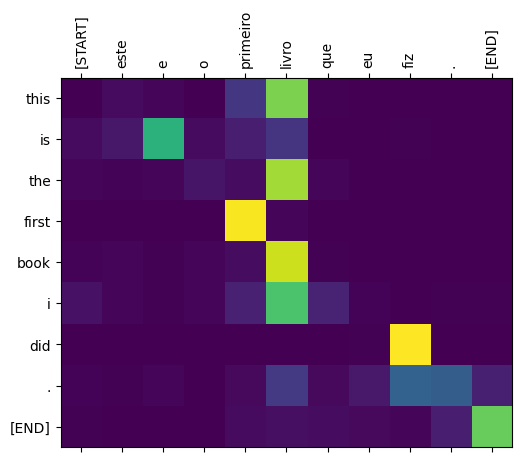

In [69]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [70]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

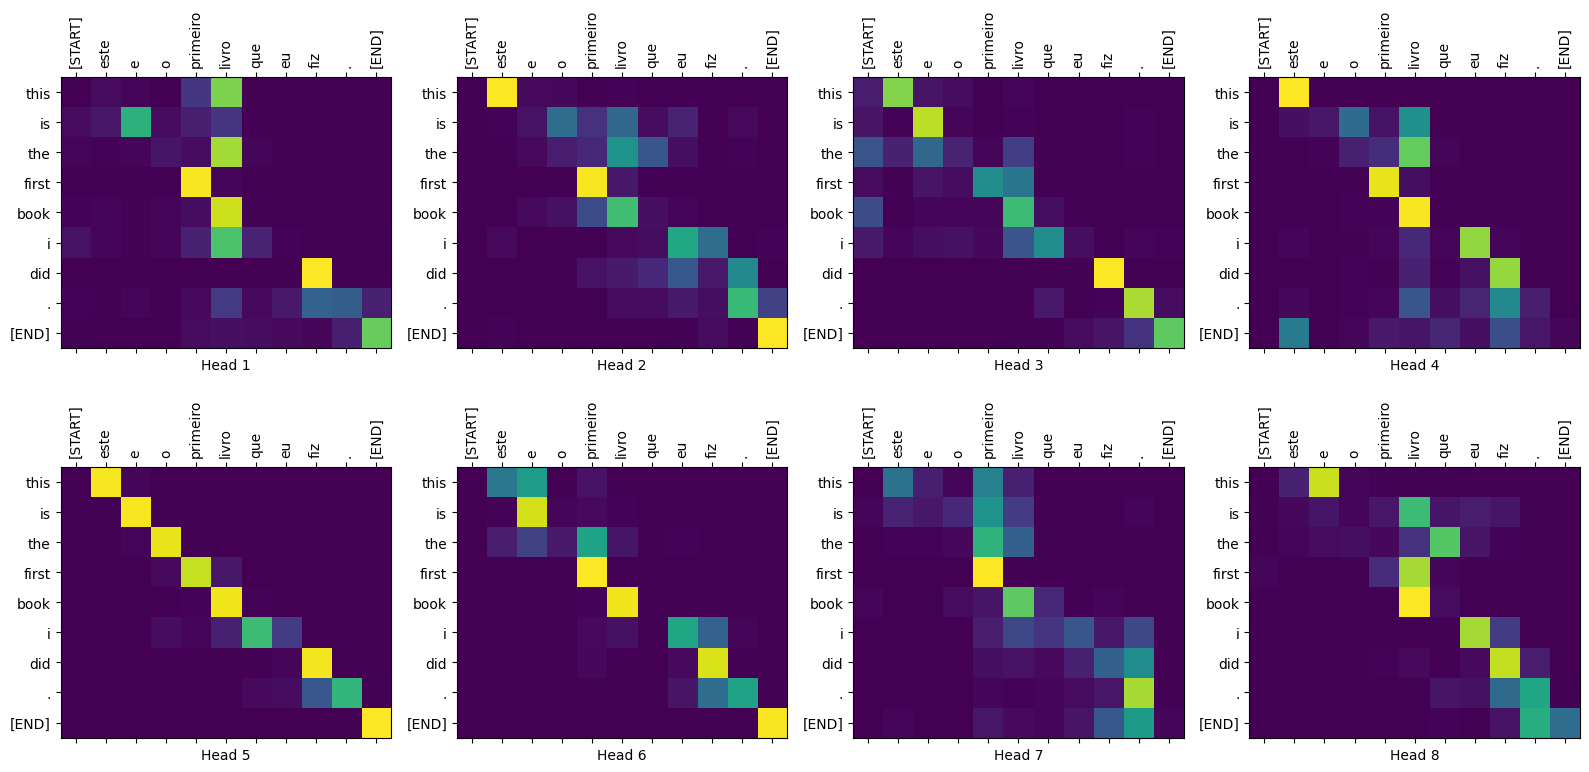

In [71]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about trivees on egypt .
Ground truth   : I read about triceratops in the encyclopedia.


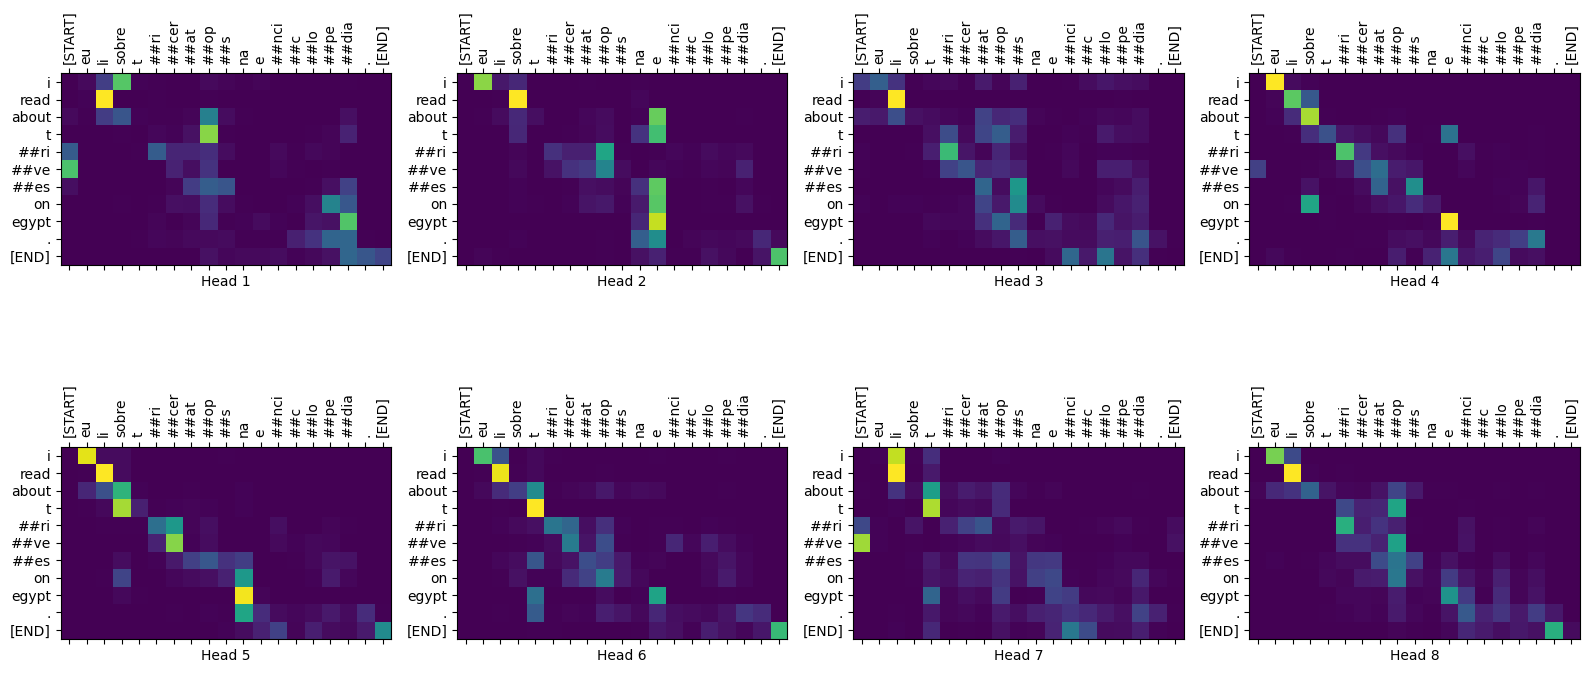

In [72]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [73]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [74]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [75]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [76]:
tf.saved_model.save(translator, export_dir='translator')

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [77]:
reloaded = tf.saved_model.load('translator')

In [78]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805)
* Use Beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
